In [1]:
%load_ext autoreload
%autoreload 2

from tqdm import tqdm
from segtok import tokenizer
from utils import *
import hickle

In [2]:
# Key Hyperparameters
enable_orig = "orig"
enable_aug = False
enable_aug3 = False
max_training_samples = 200000
max_tokenized_length = 64
num_sentences = 10
valid_percent = 0.01
sentence_pairs = False

batch_size_finetuning = 32
epochs_finetuning = 1
lr_finetuning = 1e-5

batch_size = 128
epochs = 20
main_model_lr = 1e-5

lstm_hidden_size = 1024
regressive_style_finetuning = False
lstm_bidi = False

experiment_id = f"test"

In [3]:
# Parameters
max_training_samples = 200000
enable_orig = "big"
enable_aug = False
enable_aug3 = True
sentence_pairs = False
regressive_style_finetuning = False
lstm_bidi = True
lstm_hidden_size = 1024
epochs = 20
experiment_id = "classification-sentence-embeddings-max_training_samples-200000-enable_orig-big-enable_aug-False-enable_aug3-True-sentence_pairs-False-regressive_style_finetuning-False-lstm_bidi-True-lstm_hidden_size-1024-epochs-20"


In [4]:
import os
experiment_dir = f"completed-experiments/{experiment_id}"
if not os.path.exists(experiment_dir):
    os.makedirs(experiment_dir)

In [5]:
from data_parsing import *
data = load_dataset("./yelp_review_training_dataset.jsonl")

In [6]:
from training_utils import split_train_validation
from text_preprocessing import preprocess
import random
from math import ceil

def get_train_valid():
    global data
    if enable_orig == "big" or enable_orig == "big-preprocess":
        data += load_gen_dataset("./yelp_dataset/more_yelp_234.json")
    orig_data_uniform = split_equally(data, ceil(max_training_samples / 0.99))
    orig_train_x, valid_x, orig_train_y, valid_y = split_train_validation(orig_data_uniform, 0.01)
    train_x = []
    train_y = []

    if enable_aug:
        aug_data = load_gen_dataset("./new_data.json") + load_gen_dataset("./new_data2.json")
        train_x += [i[0] for i in aug_data]
        train_y += [i[1] for i in aug_data]

    if enable_aug3:
        aug_data3 = load_gen_dataset("./new_data3.json")
        train_x += [i[0] for i in aug_data3]
        train_y += [i[1] for i in aug_data3]
        
    if enable_orig:
        train_x += orig_train_x
        train_y += orig_train_y
    
    train_x = train_x[:max_training_samples]
    train_y = train_y[:max_training_samples]

    if enable_orig == "preprocess" or enable_orig == "big-preprocess":
        train_x = preprocess(train_x)
        valid_x = preprocess(valid_x)    

    paired_train = list(zip(train_x, train_y))
    random.shuffle(paired_train)
    train_x = [i[0] for i in paired_train]
    train_y = [i[1] for i in paired_train]

    return [x.encode("utf-8") for x in train_x], [x.encode("utf-8") for x in valid_x], train_y, valid_y

split_key = f"cache-core/split-data-{valid_percent}-orig-{enable_orig}-aug12-{enable_aug}-aug3-{enable_aug3}-max-{max_training_samples}"
train_x, valid_x, train_y, valid_y = memo_load(
    get_train_valid,
    split_key
)
split_hash = hash_file(split_key + ".hkl")

train_x = [x.decode("utf-8") for x in train_x]
valid_x = [x.decode("utf-8") for x in valid_x]

print(len(train_x))

200000


In [7]:
print(len(train_x))
print(len(train_y))
print(len(valid_x))
print(len(valid_y))

200000
200000
2021
2021


In [8]:
import torch as th

device = th.device("cuda" if th.cuda.is_available() else "cpu")
print(device)

from spacy.lang.en import English
nlp = English()
nlp.add_pipe("sentencizer")

cuda


In [9]:
from transformers import BertTokenizerFast, BertForSequenceClassification
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [10]:
# fine tune the BERT
import numpy as np

def get_finetuning_data():
    train_x_numerized = []
    train_x_mask = []
    train_y_per_sentence = []
    for i, text in tqdm(list(enumerate(train_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            train_x_numerized.append(tokenized.ids)
            train_x_mask.append(tokenized.attention_mask)
            train_y_per_sentence.append(train_y[i])

    valid_x_numerized = []
    valid_x_mask = []
    valid_y_per_sentence = []
    for i, text in tqdm(list(enumerate(valid_x))):
        doc = nlp(text)
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            valid_x_numerized.append(tokenized.ids)
            valid_x_mask.append(tokenized.attention_mask)
            valid_y_per_sentence.append(valid_y[i])

    train_x_numerized = np.array(train_x_numerized)
    train_x_mask = np.array(train_x_mask)
    train_y_per_sentence = np.array(train_y_per_sentence)
    valid_x_numerized = np.array(valid_x_numerized)
    valid_x_mask = np.array(valid_x_mask)
    valid_y_per_sentence = np.array(valid_y_per_sentence)
    return train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence

from utils import memo_load
finetuning_data_key = f"cache-core/training-data-finetuning-max-tokens-{max_tokenized_length}-split-{split_hash}"
if sentence_pairs:
    finetuning_data_key += "-pairs"
(train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence) = memo_load(
    lambda: get_finetuning_data(),
    finetuning_data_key
)
finetuning_data_hash = hash_file(finetuning_data_key + ".hkl")

In [11]:
from model import ReviewPredictionModel
import torch.optim as optim

def train_finetuning():
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)

    model_to_train_finetuning = ReviewPredictionModel(0, max_tokenized_length, regressive_bert_style=regressive_style_finetuning)
    model_to_train_finetuning.transformer = embedding_bert
    model_to_train_finetuning.to(device)
    optimizer = optim.Adam(model_to_train_finetuning.parameters(), lr=lr_finetuning)
    
    training_accuracies_finetuning, validation_accuracies_finetuning = run_training_loop(
        model_to_train_finetuning, optimizer, device,
        batch_size_finetuning, epochs_finetuning,
        train_x_numerized, train_x_mask, train_y_per_sentence, valid_x_numerized, valid_x_mask, valid_y_per_sentence,
        max_validation_examples=256,
        model_id=experiment_id, tag="finetuning"
    )
    
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

def store_finetuning(tup, folder):
    embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = tup
    th.save(embedding_bert.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{folder}/accuracies.hkl", mode="w")

def load_finetuning(folder):
    if regressive_style_finetuning:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=1)
    else:
        embedding_bert = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=9)
    embedding_bert.load_state_dict(th.load(f"{folder}/model.pt"))
    embedding_bert.eval()
    embedding_bert.to(device)
    training_accuracies_finetuning, validation_accuracies_finetuning = hickle.load(f"{folder}/accuracies.hkl")
    return embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning

In [12]:
from training_utils import run_training_loop

from utils import memo_load
finetuning_model_key = f"cache-core/finetuning-batch-size-{batch_size_finetuning}-epochs-{epochs_finetuning}-lr-{lr_finetuning}-regressive-{regressive_style_finetuning}-data-{finetuning_data_hash}"
embedding_bert, training_accuracies_finetuning, validation_accuracies_finetuning = manual_memo(
    train_finetuning, store_finetuning, load_finetuning,
    finetuning_model_key
)

th.save(embedding_bert.state_dict(), f"{experiment_dir}/finetuned-bert.pt")
hickle.dump((training_accuracies_finetuning, validation_accuracies_finetuning), f"{experiment_dir}/finetuning-accuracies.hkl", mode="w")

finetuning_model_hash = hash_file(finetuning_model_key + "/model.pt")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


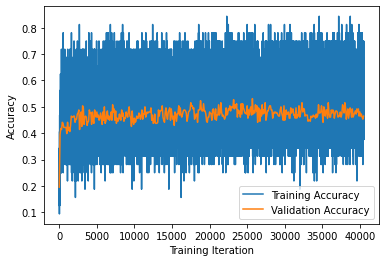

In [13]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies_finetuning)), training_accuracies_finetuning, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies_finetuning)))), validation_accuracies_finetuning, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()

In [14]:
import torch as th
import numpy as np

embedding_bert.to(device)

def get_embeds(x_data):
    concatted_shape = None
    pad_value = None
    embeds = []
    for text in tqdm(x_data):
        doc = nlp(text)
        embeddeds = []
        sents = [str(sent) for sent in doc.sents]
        if sentence_pairs and len(sents) > 1:
            sents = [a + b for a, b in zip(sents, sents[1:])]
        all_tokenized = []
        for sentence in sents[:num_sentences]:
            tokenized = tokenizer(sentence, truncation=True, padding="max_length", max_length=max_tokenized_length)[0]
            all_tokenized.append(tokenized.ids)
        
        with th.no_grad():
            sentence_tensor = th.tensor(all_tokenized).to(device)
            concatted = np.concatenate([
                # take output corresponding to CLS
                embedding_bert.bert(sentence_tensor, output_hidden_states=True, return_dict=True)[1].cpu().numpy(),
                np.zeros((len(all_tokenized), 1))
            ], axis=1)
            
            if not concatted_shape:
                concatted_shape = concatted.shape
                pad_value = np.zeros(concatted_shape[1])
                pad_value[-1] = 1
            
            embeddeds += list(concatted)

        if len(sents) < num_sentences:
            embeddeds += [pad_value] * (num_sentences - len(sents))

        embeds.append(embeddeds)
    return np.array(embeds)

main_data_key = f"cache-core/training-data-main-max-tokens-{max_tokenized_length}-split-{split_hash}-finetuned-{finetuning_model_hash}"
train_x_embeds, valid_x_embeds = memo_load(
    lambda: (
        get_embeds(train_x),
        get_embeds(valid_x)
    ),
    main_data_key
)
main_data_hash = hash_file(main_data_key + ".hkl")

In [15]:
from model_sentence_lstm import ReviewPredictionModel
import torch as th
import torch.optim as optim

def train_main():
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size, bidi_lstm=lstm_bidi)
    model_to_train.to(device)
    optimizer = optim.Adam(model_to_train.parameters(), lr=main_model_lr)
    
    training_accuracies, validation_accuracies = run_training_loop(
        model_to_train, optimizer, device,
        batch_size, epochs,
        train_x_embeds, None, np.array(train_y), valid_x_embeds, None, np.array(valid_y),
        model_id=experiment_id, max_validation_examples=512
    )
    
    return model_to_train, training_accuracies, validation_accuracies

def store_main(tup, folder):
    model_to_train, training_accuracies, validation_accuracies = tup
    th.save(model_to_train.state_dict(), f"{folder}/model.pt")
    hickle.dump((training_accuracies, validation_accuracies), f"{folder}/accuracies.hkl", mode="w")

def load_main(folder):
    model_to_train = ReviewPredictionModel(train_x_embeds.shape[2], lstm_hidden_size)
    model_to_train.load_state_dict(th.load(f"{folder}/model.pt"))
    model_to_train.eval()
    model_to_train.to(device)
    training_accuracies, validation_accuracies = hickle.load(f"{folder}/accuracies.hkl")
    return model_to_train, training_accuracies, validation_accuracies

In [16]:
from training_utils import run_training_loop

bidi_key = "-bidi" if lstm_bidi else ""
main_model_key = f"cache-core/main-model-lstm-{lstm_hidden_size}{bidi_key}-lr-{main_model_lr}-batch-size-{batch_size}-epochs-{epochs}-data-{main_data_hash}"
main_model, training_accuracies, validation_accuracies = manual_memo(
    train_main, store_main, load_main,
    main_model_key
)

th.save(main_model.state_dict(), f"{experiment_dir}/main-model.pt")
hickle.dump((training_accuracies, validation_accuracies), f"{experiment_dir}/main-accuracies.hkl", mode="w")

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 0 Loss: 2.222 Validation Loss: 2.209 Accuracy: 0.008 Validation Accuracy: 0.008:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 1 Loss: 2.217 Validation Loss: 2.209 Accuracy: 0.004 Validation Accuracy: 0.008:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 2 Loss: 2.211 Validation Loss: 2.209 Accuracy: 0.008 Validation Accuracy: 0.008:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 3 Loss: 2.207 Validation Loss: 2.209 Accuracy: 0.018 Validation Accuracy: 0.008:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.203 Validation Loss: 2.209 Accuracy: 0.030 Validation Accuracy: 0.008:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 0 Iteration: 4 Loss: 2.203 Validation Loss: 2.209 Accuracy: 0.030 Validation Accuracy: 0.008:   0%|          | 5/1563 [00:00<00:33, 46.48it/s]

Epoch: 0 Iteration: 5 Loss: 2.199 Validation Loss: 2.209 Accuracy: 0.056 Validation Accuracy: 0.008:   0%|          | 5/1563 [00:00<00:33, 46.48it/s]

Epoch: 0 Iteration: 6 Loss: 2.194 Validation Loss: 2.209 Accuracy: 0.094 Validation Accuracy: 0.008:   0%|          | 5/1563 [00:00<00:33, 46.48it/s]

Epoch: 0 Iteration: 7 Loss: 2.189 Validation Loss: 2.209 Accuracy: 0.128 Validation Accuracy: 0.008:   0%|          | 5/1563 [00:00<00:33, 46.48it/s]

Epoch: 0 Iteration: 8 Loss: 2.185 Validation Loss: 2.209 Accuracy: 0.162 Validation Accuracy: 0.008:   0%|          | 5/1563 [00:00<00:33, 46.48it/s]

Epoch: 0 Iteration: 9 Loss: 2.180 Validation Loss: 2.209 Accuracy: 0.200 Validation Accuracy: 0.008:   0%|          | 5/1563 [00:00<00:33, 46.48it/s]

Epoch: 0 Iteration: 10 Loss: 2.175 Validation Loss: 2.209 Accuracy: 0.258 Validation Accuracy: 0.008:   0%|          | 5/1563 [00:00<00:33, 46.48it/s]

Epoch: 0 Iteration: 11 Loss: 2.170 Validation Loss: 2.209 Accuracy: 0.316 Validation Accuracy: 0.008:   0%|          | 5/1563 [00:00<00:33, 46.48it/s]

Epoch: 0 Iteration: 12 Loss: 2.165 Validation Loss: 2.209 Accuracy: 0.375 Validation Accuracy: 0.008:   0%|          | 5/1563 [00:00<00:33, 46.48it/s]

Epoch: 0 Iteration: 12 Loss: 2.165 Validation Loss: 2.209 Accuracy: 0.375 Validation Accuracy: 0.008:   1%|          | 13/1563 [00:00<00:25, 61.17it/s]

Epoch: 0 Iteration: 13 Loss: 2.160 Validation Loss: 2.209 Accuracy: 0.425 Validation Accuracy: 0.008:   1%|          | 13/1563 [00:00<00:25, 61.17it/s]

Epoch: 0 Iteration: 14 Loss: 2.155 Validation Loss: 2.209 Accuracy: 0.480 Validation Accuracy: 0.008:   1%|          | 13/1563 [00:00<00:25, 61.17it/s]

Epoch: 0 Iteration: 15 Loss: 2.151 Validation Loss: 2.209 Accuracy: 0.525 Validation Accuracy: 0.008:   1%|          | 13/1563 [00:00<00:25, 61.17it/s]

Epoch: 0 Iteration: 16 Loss: 2.146 Validation Loss: 2.209 Accuracy: 0.551 Validation Accuracy: 0.008:   1%|          | 13/1563 [00:00<00:25, 61.17it/s]

Epoch: 0 Iteration: 17 Loss: 2.141 Validation Loss: 2.209 Accuracy: 0.577 Validation Accuracy: 0.008:   1%|          | 13/1563 [00:00<00:25, 61.17it/s]

Epoch: 0 Iteration: 18 Loss: 2.137 Validation Loss: 2.209 Accuracy: 0.600 Validation Accuracy: 0.008:   1%|          | 13/1563 [00:00<00:25, 61.17it/s]

Epoch: 0 Iteration: 19 Loss: 2.133 Validation Loss: 2.209 Accuracy: 0.611 Validation Accuracy: 0.008:   1%|          | 13/1563 [00:00<00:25, 61.17it/s]

Epoch: 0 Iteration: 20 Loss: 2.123 Validation Loss: 2.209 Accuracy: 0.613 Validation Accuracy: 0.008:   1%|          | 13/1563 [00:00<00:25, 61.17it/s]

Epoch: 0 Iteration: 20 Loss: 2.123 Validation Loss: 2.209 Accuracy: 0.613 Validation Accuracy: 0.008:   1%|▏         | 21/1563 [00:00<00:22, 68.08it/s]

Epoch: 0 Iteration: 21 Loss: 2.113 Validation Loss: 2.209 Accuracy: 0.620 Validation Accuracy: 0.008:   1%|▏         | 21/1563 [00:00<00:22, 68.08it/s]

Epoch: 0 Iteration: 22 Loss: 2.104 Validation Loss: 2.209 Accuracy: 0.625 Validation Accuracy: 0.008:   1%|▏         | 21/1563 [00:00<00:22, 68.08it/s]

Epoch: 0 Iteration: 23 Loss: 2.095 Validation Loss: 2.209 Accuracy: 0.637 Validation Accuracy: 0.008:   1%|▏         | 21/1563 [00:00<00:22, 68.08it/s]

Epoch: 0 Iteration: 24 Loss: 2.086 Validation Loss: 2.209 Accuracy: 0.633 Validation Accuracy: 0.008:   1%|▏         | 21/1563 [00:00<00:22, 68.08it/s]

Epoch: 0 Iteration: 25 Loss: 2.078 Validation Loss: 2.209 Accuracy: 0.634 Validation Accuracy: 0.008:   1%|▏         | 21/1563 [00:00<00:22, 68.08it/s]

Epoch: 0 Iteration: 26 Loss: 2.068 Validation Loss: 2.209 Accuracy: 0.647 Validation Accuracy: 0.008:   1%|▏         | 21/1563 [00:00<00:22, 68.08it/s]

Epoch: 0 Iteration: 27 Loss: 2.058 Validation Loss: 2.209 Accuracy: 0.648 Validation Accuracy: 0.008:   1%|▏         | 21/1563 [00:00<00:22, 68.08it/s]

Epoch: 0 Iteration: 28 Loss: 2.049 Validation Loss: 2.209 Accuracy: 0.646 Validation Accuracy: 0.008:   1%|▏         | 21/1563 [00:00<00:22, 68.08it/s]

Epoch: 0 Iteration: 28 Loss: 2.049 Validation Loss: 2.209 Accuracy: 0.646 Validation Accuracy: 0.008:   2%|▏         | 29/1563 [00:00<00:21, 71.48it/s]

Epoch: 0 Iteration: 29 Loss: 2.040 Validation Loss: 2.209 Accuracy: 0.648 Validation Accuracy: 0.008:   2%|▏         | 29/1563 [00:00<00:21, 71.48it/s]

Epoch: 0 Iteration: 30 Loss: 2.031 Validation Loss: 2.209 Accuracy: 0.655 Validation Accuracy: 0.008:   2%|▏         | 29/1563 [00:00<00:21, 71.48it/s]

Epoch: 0 Iteration: 31 Loss: 2.022 Validation Loss: 2.209 Accuracy: 0.660 Validation Accuracy: 0.008:   2%|▏         | 29/1563 [00:00<00:21, 71.48it/s]

Epoch: 0 Iteration: 32 Loss: 2.013 Validation Loss: 2.209 Accuracy: 0.659 Validation Accuracy: 0.008:   2%|▏         | 29/1563 [00:00<00:21, 71.48it/s]

Epoch: 0 Iteration: 33 Loss: 2.003 Validation Loss: 2.209 Accuracy: 0.666 Validation Accuracy: 0.008:   2%|▏         | 29/1563 [00:00<00:21, 71.48it/s]

Epoch: 0 Iteration: 34 Loss: 1.995 Validation Loss: 2.209 Accuracy: 0.673 Validation Accuracy: 0.008:   2%|▏         | 29/1563 [00:00<00:21, 71.48it/s]

Epoch: 0 Iteration: 35 Loss: 1.986 Validation Loss: 2.209 Accuracy: 0.677 Validation Accuracy: 0.008:   2%|▏         | 29/1563 [00:00<00:21, 71.48it/s]

Epoch: 0 Iteration: 36 Loss: 1.976 Validation Loss: 2.209 Accuracy: 0.674 Validation Accuracy: 0.008:   2%|▏         | 29/1563 [00:00<00:21, 71.48it/s]

Epoch: 0 Iteration: 36 Loss: 1.976 Validation Loss: 2.209 Accuracy: 0.674 Validation Accuracy: 0.008:   2%|▏         | 37/1563 [00:00<00:20, 73.50it/s]

Epoch: 0 Iteration: 37 Loss: 1.968 Validation Loss: 2.209 Accuracy: 0.677 Validation Accuracy: 0.008:   2%|▏         | 37/1563 [00:00<00:20, 73.50it/s]

Epoch: 0 Iteration: 38 Loss: 1.960 Validation Loss: 2.209 Accuracy: 0.674 Validation Accuracy: 0.008:   2%|▏         | 37/1563 [00:00<00:20, 73.50it/s]

Epoch: 0 Iteration: 39 Loss: 1.950 Validation Loss: 2.209 Accuracy: 0.677 Validation Accuracy: 0.008:   2%|▏         | 37/1563 [00:00<00:20, 73.50it/s]

Epoch: 0 Iteration: 40 Loss: 1.940 Validation Loss: 2.209 Accuracy: 0.676 Validation Accuracy: 0.008:   2%|▏         | 37/1563 [00:00<00:20, 73.50it/s]

Epoch: 0 Iteration: 41 Loss: 1.931 Validation Loss: 2.209 Accuracy: 0.669 Validation Accuracy: 0.008:   2%|▏         | 37/1563 [00:00<00:20, 73.50it/s]

Epoch: 0 Iteration: 42 Loss: 1.922 Validation Loss: 2.209 Accuracy: 0.670 Validation Accuracy: 0.008:   2%|▏         | 37/1563 [00:00<00:20, 73.50it/s]

Epoch: 0 Iteration: 43 Loss: 1.914 Validation Loss: 2.209 Accuracy: 0.654 Validation Accuracy: 0.008:   2%|▏         | 37/1563 [00:00<00:20, 73.50it/s]

Epoch: 0 Iteration: 44 Loss: 1.905 Validation Loss: 2.209 Accuracy: 0.656 Validation Accuracy: 0.008:   2%|▏         | 37/1563 [00:00<00:20, 73.50it/s]

Epoch: 0 Iteration: 44 Loss: 1.905 Validation Loss: 2.209 Accuracy: 0.656 Validation Accuracy: 0.008:   3%|▎         | 45/1563 [00:00<00:20, 74.87it/s]

Epoch: 0 Iteration: 45 Loss: 1.895 Validation Loss: 2.209 Accuracy: 0.656 Validation Accuracy: 0.008:   3%|▎         | 45/1563 [00:00<00:20, 74.87it/s]

Epoch: 0 Iteration: 46 Loss: 1.885 Validation Loss: 2.209 Accuracy: 0.659 Validation Accuracy: 0.008:   3%|▎         | 45/1563 [00:00<00:20, 74.87it/s]

Epoch: 0 Iteration: 47 Loss: 1.876 Validation Loss: 2.209 Accuracy: 0.664 Validation Accuracy: 0.008:   3%|▎         | 45/1563 [00:00<00:20, 74.87it/s]

Epoch: 0 Iteration: 48 Loss: 1.865 Validation Loss: 2.209 Accuracy: 0.669 Validation Accuracy: 0.008:   3%|▎         | 45/1563 [00:00<00:20, 74.87it/s]

Epoch: 0 Iteration: 49 Loss: 1.856 Validation Loss: 2.209 Accuracy: 0.663 Validation Accuracy: 0.008:   3%|▎         | 45/1563 [00:00<00:20, 74.87it/s]

Epoch: 0 Iteration: 50 Loss: 1.847 Validation Loss: 2.209 Accuracy: 0.666 Validation Accuracy: 0.008:   3%|▎         | 45/1563 [00:00<00:20, 74.87it/s]

Epoch: 0 Iteration: 51 Loss: 1.839 Validation Loss: 2.209 Accuracy: 0.667 Validation Accuracy: 0.008:   3%|▎         | 45/1563 [00:00<00:20, 74.87it/s]

Epoch: 0 Iteration: 52 Loss: 1.830 Validation Loss: 2.209 Accuracy: 0.672 Validation Accuracy: 0.008:   3%|▎         | 45/1563 [00:00<00:20, 74.87it/s]

Epoch: 0 Iteration: 52 Loss: 1.830 Validation Loss: 2.209 Accuracy: 0.672 Validation Accuracy: 0.008:   3%|▎         | 53/1563 [00:00<00:19, 75.83it/s]

Epoch: 0 Iteration: 53 Loss: 1.822 Validation Loss: 2.209 Accuracy: 0.677 Validation Accuracy: 0.008:   3%|▎         | 53/1563 [00:00<00:19, 75.83it/s]

Epoch: 0 Iteration: 54 Loss: 1.812 Validation Loss: 2.209 Accuracy: 0.669 Validation Accuracy: 0.008:   3%|▎         | 53/1563 [00:00<00:19, 75.83it/s]

Epoch: 0 Iteration: 55 Loss: 1.802 Validation Loss: 2.209 Accuracy: 0.669 Validation Accuracy: 0.008:   3%|▎         | 53/1563 [00:00<00:19, 75.83it/s]

Epoch: 0 Iteration: 56 Loss: 1.793 Validation Loss: 2.209 Accuracy: 0.660 Validation Accuracy: 0.008:   3%|▎         | 53/1563 [00:00<00:19, 75.83it/s]

Epoch: 0 Iteration: 57 Loss: 1.782 Validation Loss: 2.209 Accuracy: 0.652 Validation Accuracy: 0.008:   3%|▎         | 53/1563 [00:00<00:19, 75.83it/s]

Epoch: 0 Iteration: 58 Loss: 1.770 Validation Loss: 2.209 Accuracy: 0.652 Validation Accuracy: 0.008:   3%|▎         | 53/1563 [00:00<00:19, 75.83it/s]

Epoch: 0 Iteration: 59 Loss: 1.760 Validation Loss: 2.209 Accuracy: 0.662 Validation Accuracy: 0.008:   3%|▎         | 53/1563 [00:00<00:19, 75.83it/s]

Epoch: 0 Iteration: 60 Loss: 1.751 Validation Loss: 2.209 Accuracy: 0.661 Validation Accuracy: 0.008:   3%|▎         | 53/1563 [00:00<00:19, 75.83it/s]

Epoch: 0 Iteration: 60 Loss: 1.751 Validation Loss: 2.209 Accuracy: 0.661 Validation Accuracy: 0.008:   4%|▍         | 61/1563 [00:00<00:19, 76.34it/s]

Epoch: 0 Iteration: 61 Loss: 1.744 Validation Loss: 2.209 Accuracy: 0.667 Validation Accuracy: 0.008:   4%|▍         | 61/1563 [00:00<00:19, 76.34it/s]

Epoch: 0 Iteration: 62 Loss: 1.737 Validation Loss: 2.209 Accuracy: 0.658 Validation Accuracy: 0.008:   4%|▍         | 61/1563 [00:00<00:19, 76.34it/s]

Epoch: 0 Iteration: 63 Loss: 1.727 Validation Loss: 2.209 Accuracy: 0.662 Validation Accuracy: 0.008:   4%|▍         | 61/1563 [00:00<00:19, 76.34it/s]

Epoch: 0 Iteration: 64 Loss: 1.717 Validation Loss: 2.209 Accuracy: 0.670 Validation Accuracy: 0.008:   4%|▍         | 61/1563 [00:00<00:19, 76.34it/s]

Epoch: 0 Iteration: 65 Loss: 1.708 Validation Loss: 2.209 Accuracy: 0.672 Validation Accuracy: 0.008:   4%|▍         | 61/1563 [00:00<00:19, 76.34it/s]

Epoch: 0 Iteration: 66 Loss: 1.699 Validation Loss: 2.209 Accuracy: 0.679 Validation Accuracy: 0.008:   4%|▍         | 61/1563 [00:00<00:19, 76.34it/s]

Epoch: 0 Iteration: 67 Loss: 1.691 Validation Loss: 2.209 Accuracy: 0.679 Validation Accuracy: 0.008:   4%|▍         | 61/1563 [00:00<00:19, 76.34it/s]

Epoch: 0 Iteration: 68 Loss: 1.681 Validation Loss: 2.209 Accuracy: 0.680 Validation Accuracy: 0.008:   4%|▍         | 61/1563 [00:00<00:19, 76.34it/s]

Epoch: 0 Iteration: 68 Loss: 1.681 Validation Loss: 2.209 Accuracy: 0.680 Validation Accuracy: 0.008:   4%|▍         | 69/1563 [00:00<00:19, 76.72it/s]

Epoch: 0 Iteration: 69 Loss: 1.673 Validation Loss: 2.209 Accuracy: 0.679 Validation Accuracy: 0.008:   4%|▍         | 69/1563 [00:00<00:19, 76.72it/s]

Epoch: 0 Iteration: 70 Loss: 1.664 Validation Loss: 2.209 Accuracy: 0.684 Validation Accuracy: 0.008:   4%|▍         | 69/1563 [00:00<00:19, 76.72it/s]

Epoch: 0 Iteration: 71 Loss: 1.650 Validation Loss: 2.209 Accuracy: 0.678 Validation Accuracy: 0.008:   4%|▍         | 69/1563 [00:00<00:19, 76.72it/s]

Epoch: 0 Iteration: 72 Loss: 1.640 Validation Loss: 2.209 Accuracy: 0.684 Validation Accuracy: 0.008:   4%|▍         | 69/1563 [00:00<00:19, 76.72it/s]

Epoch: 0 Iteration: 73 Loss: 1.632 Validation Loss: 2.209 Accuracy: 0.681 Validation Accuracy: 0.008:   4%|▍         | 69/1563 [00:01<00:19, 76.72it/s]

Epoch: 0 Iteration: 74 Loss: 1.620 Validation Loss: 2.209 Accuracy: 0.681 Validation Accuracy: 0.008:   4%|▍         | 69/1563 [00:01<00:19, 76.72it/s]

Epoch: 0 Iteration: 75 Loss: 1.612 Validation Loss: 2.209 Accuracy: 0.677 Validation Accuracy: 0.008:   4%|▍         | 69/1563 [00:01<00:19, 76.72it/s]

Epoch: 0 Iteration: 76 Loss: 1.606 Validation Loss: 2.209 Accuracy: 0.673 Validation Accuracy: 0.008:   4%|▍         | 69/1563 [00:01<00:19, 76.72it/s]

Epoch: 0 Iteration: 76 Loss: 1.606 Validation Loss: 2.209 Accuracy: 0.673 Validation Accuracy: 0.008:   5%|▍         | 77/1563 [00:01<00:19, 76.97it/s]

Epoch: 0 Iteration: 77 Loss: 1.597 Validation Loss: 2.209 Accuracy: 0.679 Validation Accuracy: 0.008:   5%|▍         | 77/1563 [00:01<00:19, 76.97it/s]

Epoch: 0 Iteration: 78 Loss: 1.585 Validation Loss: 2.209 Accuracy: 0.677 Validation Accuracy: 0.008:   5%|▍         | 77/1563 [00:01<00:19, 76.97it/s]

Epoch: 0 Iteration: 79 Loss: 1.577 Validation Loss: 2.209 Accuracy: 0.675 Validation Accuracy: 0.008:   5%|▍         | 77/1563 [00:01<00:19, 76.97it/s]

Epoch: 0 Iteration: 80 Loss: 1.570 Validation Loss: 2.209 Accuracy: 0.664 Validation Accuracy: 0.008:   5%|▍         | 77/1563 [00:01<00:19, 76.97it/s]

Epoch: 0 Iteration: 81 Loss: 1.556 Validation Loss: 2.209 Accuracy: 0.670 Validation Accuracy: 0.008:   5%|▍         | 77/1563 [00:01<00:19, 76.97it/s]

Epoch: 0 Iteration: 82 Loss: 1.543 Validation Loss: 2.209 Accuracy: 0.672 Validation Accuracy: 0.008:   5%|▍         | 77/1563 [00:01<00:19, 76.97it/s]

Epoch: 0 Iteration: 83 Loss: 1.530 Validation Loss: 2.209 Accuracy: 0.675 Validation Accuracy: 0.008:   5%|▍         | 77/1563 [00:01<00:19, 76.97it/s]

Epoch: 0 Iteration: 84 Loss: 1.522 Validation Loss: 2.209 Accuracy: 0.667 Validation Accuracy: 0.008:   5%|▍         | 77/1563 [00:01<00:19, 76.97it/s]

Epoch: 0 Iteration: 84 Loss: 1.522 Validation Loss: 2.209 Accuracy: 0.667 Validation Accuracy: 0.008:   5%|▌         | 85/1563 [00:01<00:19, 77.14it/s]

Epoch: 0 Iteration: 85 Loss: 1.513 Validation Loss: 2.209 Accuracy: 0.672 Validation Accuracy: 0.008:   5%|▌         | 85/1563 [00:01<00:19, 77.14it/s]

Epoch: 0 Iteration: 86 Loss: 1.503 Validation Loss: 2.209 Accuracy: 0.678 Validation Accuracy: 0.008:   5%|▌         | 85/1563 [00:01<00:19, 77.14it/s]

Epoch: 0 Iteration: 87 Loss: 1.491 Validation Loss: 2.209 Accuracy: 0.682 Validation Accuracy: 0.008:   5%|▌         | 85/1563 [00:01<00:19, 77.14it/s]

Epoch: 0 Iteration: 88 Loss: 1.483 Validation Loss: 2.209 Accuracy: 0.680 Validation Accuracy: 0.008:   5%|▌         | 85/1563 [00:01<00:19, 77.14it/s]

Epoch: 0 Iteration: 89 Loss: 1.473 Validation Loss: 2.209 Accuracy: 0.678 Validation Accuracy: 0.008:   5%|▌         | 85/1563 [00:01<00:19, 77.14it/s]

Epoch: 0 Iteration: 90 Loss: 1.462 Validation Loss: 2.209 Accuracy: 0.686 Validation Accuracy: 0.008:   5%|▌         | 85/1563 [00:01<00:19, 77.14it/s]

Epoch: 0 Iteration: 91 Loss: 1.453 Validation Loss: 2.209 Accuracy: 0.686 Validation Accuracy: 0.008:   5%|▌         | 85/1563 [00:01<00:19, 77.14it/s]

Epoch: 0 Iteration: 92 Loss: 1.442 Validation Loss: 2.209 Accuracy: 0.683 Validation Accuracy: 0.008:   5%|▌         | 85/1563 [00:01<00:19, 77.14it/s]

Epoch: 0 Iteration: 92 Loss: 1.442 Validation Loss: 2.209 Accuracy: 0.683 Validation Accuracy: 0.008:   6%|▌         | 93/1563 [00:01<00:19, 77.24it/s]

Epoch: 0 Iteration: 93 Loss: 1.428 Validation Loss: 2.209 Accuracy: 0.680 Validation Accuracy: 0.008:   6%|▌         | 93/1563 [00:01<00:19, 77.24it/s]

Epoch: 0 Iteration: 94 Loss: 1.421 Validation Loss: 2.209 Accuracy: 0.684 Validation Accuracy: 0.008:   6%|▌         | 93/1563 [00:01<00:19, 77.24it/s]

Epoch: 0 Iteration: 95 Loss: 1.410 Validation Loss: 2.209 Accuracy: 0.680 Validation Accuracy: 0.008:   6%|▌         | 93/1563 [00:01<00:19, 77.24it/s]

Epoch: 0 Iteration: 96 Loss: 1.395 Validation Loss: 2.209 Accuracy: 0.681 Validation Accuracy: 0.008:   6%|▌         | 93/1563 [00:01<00:19, 77.24it/s]

Epoch: 0 Iteration: 97 Loss: 1.386 Validation Loss: 2.209 Accuracy: 0.673 Validation Accuracy: 0.008:   6%|▌         | 93/1563 [00:01<00:19, 77.24it/s]

Epoch: 0 Iteration: 98 Loss: 1.382 Validation Loss: 2.209 Accuracy: 0.668 Validation Accuracy: 0.008:   6%|▌         | 93/1563 [00:01<00:19, 77.24it/s]

Epoch: 0 Iteration: 99 Loss: 1.372 Validation Loss: 2.209 Accuracy: 0.662 Validation Accuracy: 0.008:   6%|▌         | 93/1563 [00:01<00:19, 77.24it/s]

Epoch: 0 Iteration: 100 Loss: 1.360 Validation Loss: 1.244 Accuracy: 0.664 Validation Accuracy: 0.345:   6%|▌         | 93/1563 [00:01<00:19, 77.24it/s]

Epoch: 0 Iteration: 100 Loss: 1.360 Validation Loss: 1.244 Accuracy: 0.664 Validation Accuracy: 0.345:   6%|▋         | 101/1563 [00:01<00:20, 71.42it/s]

Epoch: 0 Iteration: 101 Loss: 1.349 Validation Loss: 1.244 Accuracy: 0.661 Validation Accuracy: 0.345:   6%|▋         | 101/1563 [00:01<00:20, 71.42it/s]

Epoch: 0 Iteration: 102 Loss: 1.337 Validation Loss: 1.244 Accuracy: 0.666 Validation Accuracy: 0.345:   6%|▋         | 101/1563 [00:01<00:20, 71.42it/s]

Epoch: 0 Iteration: 103 Loss: 1.331 Validation Loss: 1.244 Accuracy: 0.665 Validation Accuracy: 0.345:   6%|▋         | 101/1563 [00:01<00:20, 71.42it/s]

Epoch: 0 Iteration: 104 Loss: 1.318 Validation Loss: 1.244 Accuracy: 0.678 Validation Accuracy: 0.345:   6%|▋         | 101/1563 [00:01<00:20, 71.42it/s]

Epoch: 0 Iteration: 105 Loss: 1.305 Validation Loss: 1.244 Accuracy: 0.678 Validation Accuracy: 0.345:   6%|▋         | 101/1563 [00:01<00:20, 71.42it/s]

Epoch: 0 Iteration: 106 Loss: 1.292 Validation Loss: 1.244 Accuracy: 0.679 Validation Accuracy: 0.345:   6%|▋         | 101/1563 [00:01<00:20, 71.42it/s]

Epoch: 0 Iteration: 107 Loss: 1.285 Validation Loss: 1.244 Accuracy: 0.684 Validation Accuracy: 0.345:   6%|▋         | 101/1563 [00:01<00:20, 71.42it/s]

Epoch: 0 Iteration: 108 Loss: 1.266 Validation Loss: 1.244 Accuracy: 0.698 Validation Accuracy: 0.345:   6%|▋         | 101/1563 [00:01<00:20, 71.42it/s]

Epoch: 0 Iteration: 108 Loss: 1.266 Validation Loss: 1.244 Accuracy: 0.698 Validation Accuracy: 0.345:   7%|▋         | 109/1563 [00:01<00:19, 73.78it/s]

Epoch: 0 Iteration: 109 Loss: 1.253 Validation Loss: 1.244 Accuracy: 0.700 Validation Accuracy: 0.345:   7%|▋         | 109/1563 [00:01<00:19, 73.78it/s]

Epoch: 0 Iteration: 110 Loss: 1.244 Validation Loss: 1.244 Accuracy: 0.699 Validation Accuracy: 0.345:   7%|▋         | 109/1563 [00:01<00:19, 73.78it/s]

Epoch: 0 Iteration: 111 Loss: 1.236 Validation Loss: 1.244 Accuracy: 0.709 Validation Accuracy: 0.345:   7%|▋         | 109/1563 [00:01<00:19, 73.78it/s]

Epoch: 0 Iteration: 112 Loss: 1.226 Validation Loss: 1.244 Accuracy: 0.706 Validation Accuracy: 0.345:   7%|▋         | 109/1563 [00:01<00:19, 73.78it/s]

Epoch: 0 Iteration: 113 Loss: 1.218 Validation Loss: 1.244 Accuracy: 0.706 Validation Accuracy: 0.345:   7%|▋         | 109/1563 [00:01<00:19, 73.78it/s]

Epoch: 0 Iteration: 114 Loss: 1.206 Validation Loss: 1.244 Accuracy: 0.698 Validation Accuracy: 0.345:   7%|▋         | 109/1563 [00:01<00:19, 73.78it/s]

Epoch: 0 Iteration: 115 Loss: 1.196 Validation Loss: 1.244 Accuracy: 0.701 Validation Accuracy: 0.345:   7%|▋         | 109/1563 [00:01<00:19, 73.78it/s]

Epoch: 0 Iteration: 116 Loss: 1.186 Validation Loss: 1.244 Accuracy: 0.701 Validation Accuracy: 0.345:   7%|▋         | 109/1563 [00:01<00:19, 73.78it/s]

Epoch: 0 Iteration: 116 Loss: 1.186 Validation Loss: 1.244 Accuracy: 0.701 Validation Accuracy: 0.345:   7%|▋         | 117/1563 [00:01<00:19, 74.55it/s]

Epoch: 0 Iteration: 117 Loss: 1.170 Validation Loss: 1.244 Accuracy: 0.707 Validation Accuracy: 0.345:   7%|▋         | 117/1563 [00:01<00:19, 74.55it/s]

Epoch: 0 Iteration: 118 Loss: 1.155 Validation Loss: 1.244 Accuracy: 0.700 Validation Accuracy: 0.345:   7%|▋         | 117/1563 [00:01<00:19, 74.55it/s]

Epoch: 0 Iteration: 119 Loss: 1.146 Validation Loss: 1.244 Accuracy: 0.704 Validation Accuracy: 0.345:   7%|▋         | 117/1563 [00:01<00:19, 74.55it/s]

Epoch: 0 Iteration: 120 Loss: 1.135 Validation Loss: 1.244 Accuracy: 0.709 Validation Accuracy: 0.345:   7%|▋         | 117/1563 [00:01<00:19, 74.55it/s]

Epoch: 0 Iteration: 121 Loss: 1.127 Validation Loss: 1.244 Accuracy: 0.695 Validation Accuracy: 0.345:   7%|▋         | 117/1563 [00:01<00:19, 74.55it/s]

Epoch: 0 Iteration: 122 Loss: 1.120 Validation Loss: 1.244 Accuracy: 0.696 Validation Accuracy: 0.345:   7%|▋         | 117/1563 [00:01<00:19, 74.55it/s]

Epoch: 0 Iteration: 123 Loss: 1.107 Validation Loss: 1.244 Accuracy: 0.699 Validation Accuracy: 0.345:   7%|▋         | 117/1563 [00:01<00:19, 74.55it/s]

Epoch: 0 Iteration: 124 Loss: 1.102 Validation Loss: 1.244 Accuracy: 0.694 Validation Accuracy: 0.345:   7%|▋         | 117/1563 [00:01<00:19, 74.55it/s]

Epoch: 0 Iteration: 124 Loss: 1.102 Validation Loss: 1.244 Accuracy: 0.694 Validation Accuracy: 0.345:   8%|▊         | 125/1563 [00:01<00:19, 75.28it/s]

Epoch: 0 Iteration: 125 Loss: 1.093 Validation Loss: 1.244 Accuracy: 0.695 Validation Accuracy: 0.345:   8%|▊         | 125/1563 [00:01<00:19, 75.28it/s]

Epoch: 0 Iteration: 126 Loss: 1.085 Validation Loss: 1.244 Accuracy: 0.690 Validation Accuracy: 0.345:   8%|▊         | 125/1563 [00:01<00:19, 75.28it/s]

Epoch: 0 Iteration: 127 Loss: 1.073 Validation Loss: 1.244 Accuracy: 0.680 Validation Accuracy: 0.345:   8%|▊         | 125/1563 [00:01<00:19, 75.28it/s]

Epoch: 0 Iteration: 128 Loss: 1.071 Validation Loss: 1.244 Accuracy: 0.682 Validation Accuracy: 0.345:   8%|▊         | 125/1563 [00:01<00:19, 75.28it/s]

Epoch: 0 Iteration: 129 Loss: 1.066 Validation Loss: 1.244 Accuracy: 0.685 Validation Accuracy: 0.345:   8%|▊         | 125/1563 [00:01<00:19, 75.28it/s]

Epoch: 0 Iteration: 130 Loss: 1.055 Validation Loss: 1.244 Accuracy: 0.678 Validation Accuracy: 0.345:   8%|▊         | 125/1563 [00:01<00:19, 75.28it/s]

Epoch: 0 Iteration: 131 Loss: 1.050 Validation Loss: 1.244 Accuracy: 0.680 Validation Accuracy: 0.345:   8%|▊         | 125/1563 [00:01<00:19, 75.28it/s]

Epoch: 0 Iteration: 132 Loss: 1.042 Validation Loss: 1.244 Accuracy: 0.685 Validation Accuracy: 0.345:   8%|▊         | 125/1563 [00:01<00:19, 75.28it/s]

Epoch: 0 Iteration: 132 Loss: 1.042 Validation Loss: 1.244 Accuracy: 0.685 Validation Accuracy: 0.345:   9%|▊         | 133/1563 [00:01<00:18, 75.65it/s]

Epoch: 0 Iteration: 133 Loss: 1.034 Validation Loss: 1.244 Accuracy: 0.682 Validation Accuracy: 0.345:   9%|▊         | 133/1563 [00:01<00:18, 75.65it/s]

Epoch: 0 Iteration: 134 Loss: 1.027 Validation Loss: 1.244 Accuracy: 0.695 Validation Accuracy: 0.345:   9%|▊         | 133/1563 [00:01<00:18, 75.65it/s]

Epoch: 0 Iteration: 135 Loss: 1.018 Validation Loss: 1.244 Accuracy: 0.691 Validation Accuracy: 0.345:   9%|▊         | 133/1563 [00:01<00:18, 75.65it/s]

Epoch: 0 Iteration: 136 Loss: 1.010 Validation Loss: 1.244 Accuracy: 0.695 Validation Accuracy: 0.345:   9%|▊         | 133/1563 [00:01<00:18, 75.65it/s]

Epoch: 0 Iteration: 137 Loss: 1.005 Validation Loss: 1.244 Accuracy: 0.700 Validation Accuracy: 0.345:   9%|▊         | 133/1563 [00:01<00:18, 75.65it/s]

Epoch: 0 Iteration: 138 Loss: 0.997 Validation Loss: 1.244 Accuracy: 0.702 Validation Accuracy: 0.345:   9%|▊         | 133/1563 [00:01<00:18, 75.65it/s]

Epoch: 0 Iteration: 139 Loss: 0.986 Validation Loss: 1.244 Accuracy: 0.701 Validation Accuracy: 0.345:   9%|▊         | 133/1563 [00:01<00:18, 75.65it/s]

Epoch: 0 Iteration: 140 Loss: 0.975 Validation Loss: 1.244 Accuracy: 0.709 Validation Accuracy: 0.345:   9%|▊         | 133/1563 [00:01<00:18, 75.65it/s]

Epoch: 0 Iteration: 140 Loss: 0.975 Validation Loss: 1.244 Accuracy: 0.709 Validation Accuracy: 0.345:   9%|▉         | 141/1563 [00:01<00:18, 75.97it/s]

Epoch: 0 Iteration: 141 Loss: 0.971 Validation Loss: 1.244 Accuracy: 0.713 Validation Accuracy: 0.345:   9%|▉         | 141/1563 [00:01<00:18, 75.97it/s]

Epoch: 0 Iteration: 142 Loss: 0.966 Validation Loss: 1.244 Accuracy: 0.712 Validation Accuracy: 0.345:   9%|▉         | 141/1563 [00:01<00:18, 75.97it/s]

Epoch: 0 Iteration: 143 Loss: 0.959 Validation Loss: 1.244 Accuracy: 0.723 Validation Accuracy: 0.345:   9%|▉         | 141/1563 [00:01<00:18, 75.97it/s]

Epoch: 0 Iteration: 144 Loss: 0.948 Validation Loss: 1.244 Accuracy: 0.722 Validation Accuracy: 0.345:   9%|▉         | 141/1563 [00:01<00:18, 75.97it/s]

Epoch: 0 Iteration: 145 Loss: 0.945 Validation Loss: 1.244 Accuracy: 0.721 Validation Accuracy: 0.345:   9%|▉         | 141/1563 [00:01<00:18, 75.97it/s]

Epoch: 0 Iteration: 146 Loss: 0.942 Validation Loss: 1.244 Accuracy: 0.715 Validation Accuracy: 0.345:   9%|▉         | 141/1563 [00:01<00:18, 75.97it/s]

Epoch: 0 Iteration: 147 Loss: 0.934 Validation Loss: 1.244 Accuracy: 0.719 Validation Accuracy: 0.345:   9%|▉         | 141/1563 [00:01<00:18, 75.97it/s]

Epoch: 0 Iteration: 148 Loss: 0.926 Validation Loss: 1.244 Accuracy: 0.723 Validation Accuracy: 0.345:   9%|▉         | 141/1563 [00:02<00:18, 75.97it/s]

Epoch: 0 Iteration: 148 Loss: 0.926 Validation Loss: 1.244 Accuracy: 0.723 Validation Accuracy: 0.345:  10%|▉         | 149/1563 [00:02<00:18, 76.17it/s]

Epoch: 0 Iteration: 149 Loss: 0.918 Validation Loss: 1.244 Accuracy: 0.729 Validation Accuracy: 0.345:  10%|▉         | 149/1563 [00:02<00:18, 76.17it/s]

Epoch: 0 Iteration: 150 Loss: 0.914 Validation Loss: 1.244 Accuracy: 0.723 Validation Accuracy: 0.345:  10%|▉         | 149/1563 [00:02<00:18, 76.17it/s]

Epoch: 0 Iteration: 151 Loss: 0.903 Validation Loss: 1.244 Accuracy: 0.724 Validation Accuracy: 0.345:  10%|▉         | 149/1563 [00:02<00:18, 76.17it/s]

Epoch: 0 Iteration: 152 Loss: 0.899 Validation Loss: 1.244 Accuracy: 0.726 Validation Accuracy: 0.345:  10%|▉         | 149/1563 [00:02<00:18, 76.17it/s]

Epoch: 0 Iteration: 153 Loss: 0.892 Validation Loss: 1.244 Accuracy: 0.721 Validation Accuracy: 0.345:  10%|▉         | 149/1563 [00:02<00:18, 76.17it/s]

Epoch: 0 Iteration: 154 Loss: 0.881 Validation Loss: 1.244 Accuracy: 0.733 Validation Accuracy: 0.345:  10%|▉         | 149/1563 [00:02<00:18, 76.17it/s]

Epoch: 0 Iteration: 155 Loss: 0.875 Validation Loss: 1.244 Accuracy: 0.737 Validation Accuracy: 0.345:  10%|▉         | 149/1563 [00:02<00:18, 76.17it/s]

Epoch: 0 Iteration: 156 Loss: 0.870 Validation Loss: 1.244 Accuracy: 0.742 Validation Accuracy: 0.345:  10%|▉         | 149/1563 [00:02<00:18, 76.17it/s]

Epoch: 0 Iteration: 156 Loss: 0.870 Validation Loss: 1.244 Accuracy: 0.742 Validation Accuracy: 0.345:  10%|█         | 157/1563 [00:02<00:18, 76.33it/s]

Epoch: 0 Iteration: 157 Loss: 0.872 Validation Loss: 1.244 Accuracy: 0.736 Validation Accuracy: 0.345:  10%|█         | 157/1563 [00:02<00:18, 76.33it/s]

Epoch: 0 Iteration: 158 Loss: 0.867 Validation Loss: 1.244 Accuracy: 0.735 Validation Accuracy: 0.345:  10%|█         | 157/1563 [00:02<00:18, 76.33it/s]

Epoch: 0 Iteration: 159 Loss: 0.864 Validation Loss: 1.244 Accuracy: 0.730 Validation Accuracy: 0.345:  10%|█         | 157/1563 [00:02<00:18, 76.33it/s]

Epoch: 0 Iteration: 160 Loss: 0.867 Validation Loss: 1.244 Accuracy: 0.731 Validation Accuracy: 0.345:  10%|█         | 157/1563 [00:02<00:18, 76.33it/s]

Epoch: 0 Iteration: 161 Loss: 0.860 Validation Loss: 1.244 Accuracy: 0.732 Validation Accuracy: 0.345:  10%|█         | 157/1563 [00:02<00:18, 76.33it/s]

Epoch: 0 Iteration: 162 Loss: 0.858 Validation Loss: 1.244 Accuracy: 0.724 Validation Accuracy: 0.345:  10%|█         | 157/1563 [00:02<00:18, 76.33it/s]

Epoch: 0 Iteration: 163 Loss: 0.856 Validation Loss: 1.244 Accuracy: 0.722 Validation Accuracy: 0.345:  10%|█         | 157/1563 [00:02<00:18, 76.33it/s]

Epoch: 0 Iteration: 164 Loss: 0.849 Validation Loss: 1.244 Accuracy: 0.713 Validation Accuracy: 0.345:  10%|█         | 157/1563 [00:02<00:18, 76.33it/s]

Epoch: 0 Iteration: 164 Loss: 0.849 Validation Loss: 1.244 Accuracy: 0.713 Validation Accuracy: 0.345:  11%|█         | 165/1563 [00:02<00:18, 76.43it/s]

Epoch: 0 Iteration: 165 Loss: 0.847 Validation Loss: 1.244 Accuracy: 0.709 Validation Accuracy: 0.345:  11%|█         | 165/1563 [00:02<00:18, 76.43it/s]

Epoch: 0 Iteration: 166 Loss: 0.837 Validation Loss: 1.244 Accuracy: 0.716 Validation Accuracy: 0.345:  11%|█         | 165/1563 [00:02<00:18, 76.43it/s]

Epoch: 0 Iteration: 167 Loss: 0.837 Validation Loss: 1.244 Accuracy: 0.723 Validation Accuracy: 0.345:  11%|█         | 165/1563 [00:02<00:18, 76.43it/s]

Epoch: 0 Iteration: 168 Loss: 0.834 Validation Loss: 1.244 Accuracy: 0.719 Validation Accuracy: 0.345:  11%|█         | 165/1563 [00:02<00:18, 76.43it/s]

Epoch: 0 Iteration: 169 Loss: 0.832 Validation Loss: 1.244 Accuracy: 0.719 Validation Accuracy: 0.345:  11%|█         | 165/1563 [00:02<00:18, 76.43it/s]

Epoch: 0 Iteration: 170 Loss: 0.824 Validation Loss: 1.244 Accuracy: 0.723 Validation Accuracy: 0.345:  11%|█         | 165/1563 [00:02<00:18, 76.43it/s]

Epoch: 0 Iteration: 171 Loss: 0.820 Validation Loss: 1.244 Accuracy: 0.723 Validation Accuracy: 0.345:  11%|█         | 165/1563 [00:02<00:18, 76.43it/s]

Epoch: 0 Iteration: 172 Loss: 0.814 Validation Loss: 1.244 Accuracy: 0.730 Validation Accuracy: 0.345:  11%|█         | 165/1563 [00:02<00:18, 76.43it/s]

Epoch: 0 Iteration: 172 Loss: 0.814 Validation Loss: 1.244 Accuracy: 0.730 Validation Accuracy: 0.345:  11%|█         | 173/1563 [00:02<00:18, 76.51it/s]

Epoch: 0 Iteration: 173 Loss: 0.809 Validation Loss: 1.244 Accuracy: 0.727 Validation Accuracy: 0.345:  11%|█         | 173/1563 [00:02<00:18, 76.51it/s]

Epoch: 0 Iteration: 174 Loss: 0.815 Validation Loss: 1.244 Accuracy: 0.722 Validation Accuracy: 0.345:  11%|█         | 173/1563 [00:02<00:18, 76.51it/s]

Epoch: 0 Iteration: 175 Loss: 0.811 Validation Loss: 1.244 Accuracy: 0.727 Validation Accuracy: 0.345:  11%|█         | 173/1563 [00:02<00:18, 76.51it/s]

Epoch: 0 Iteration: 176 Loss: 0.809 Validation Loss: 1.244 Accuracy: 0.722 Validation Accuracy: 0.345:  11%|█         | 173/1563 [00:02<00:18, 76.51it/s]

Epoch: 0 Iteration: 177 Loss: 0.803 Validation Loss: 1.244 Accuracy: 0.715 Validation Accuracy: 0.345:  11%|█         | 173/1563 [00:02<00:18, 76.51it/s]

Epoch: 0 Iteration: 178 Loss: 0.808 Validation Loss: 1.244 Accuracy: 0.711 Validation Accuracy: 0.345:  11%|█         | 173/1563 [00:02<00:18, 76.51it/s]

Epoch: 0 Iteration: 179 Loss: 0.805 Validation Loss: 1.244 Accuracy: 0.713 Validation Accuracy: 0.345:  11%|█         | 173/1563 [00:02<00:18, 76.51it/s]

Epoch: 0 Iteration: 180 Loss: 0.801 Validation Loss: 1.244 Accuracy: 0.705 Validation Accuracy: 0.345:  11%|█         | 173/1563 [00:02<00:18, 76.51it/s]

Epoch: 0 Iteration: 180 Loss: 0.801 Validation Loss: 1.244 Accuracy: 0.705 Validation Accuracy: 0.345:  12%|█▏        | 181/1563 [00:02<00:18, 76.78it/s]

Epoch: 0 Iteration: 181 Loss: 0.802 Validation Loss: 1.244 Accuracy: 0.703 Validation Accuracy: 0.345:  12%|█▏        | 181/1563 [00:02<00:18, 76.78it/s]

Epoch: 0 Iteration: 182 Loss: 0.798 Validation Loss: 1.244 Accuracy: 0.699 Validation Accuracy: 0.345:  12%|█▏        | 181/1563 [00:02<00:18, 76.78it/s]

Epoch: 0 Iteration: 183 Loss: 0.797 Validation Loss: 1.244 Accuracy: 0.703 Validation Accuracy: 0.345:  12%|█▏        | 181/1563 [00:02<00:18, 76.78it/s]

Epoch: 0 Iteration: 184 Loss: 0.798 Validation Loss: 1.244 Accuracy: 0.705 Validation Accuracy: 0.345:  12%|█▏        | 181/1563 [00:02<00:18, 76.78it/s]

Epoch: 0 Iteration: 185 Loss: 0.791 Validation Loss: 1.244 Accuracy: 0.702 Validation Accuracy: 0.345:  12%|█▏        | 181/1563 [00:02<00:18, 76.78it/s]

Epoch: 0 Iteration: 186 Loss: 0.791 Validation Loss: 1.244 Accuracy: 0.696 Validation Accuracy: 0.345:  12%|█▏        | 181/1563 [00:02<00:18, 76.78it/s]

Epoch: 0 Iteration: 187 Loss: 0.788 Validation Loss: 1.244 Accuracy: 0.695 Validation Accuracy: 0.345:  12%|█▏        | 181/1563 [00:02<00:18, 76.78it/s]

Epoch: 0 Iteration: 188 Loss: 0.794 Validation Loss: 1.244 Accuracy: 0.704 Validation Accuracy: 0.345:  12%|█▏        | 181/1563 [00:02<00:18, 76.78it/s]

Epoch: 0 Iteration: 188 Loss: 0.794 Validation Loss: 1.244 Accuracy: 0.704 Validation Accuracy: 0.345:  12%|█▏        | 189/1563 [00:02<00:17, 77.00it/s]

Epoch: 0 Iteration: 189 Loss: 0.793 Validation Loss: 1.244 Accuracy: 0.708 Validation Accuracy: 0.345:  12%|█▏        | 189/1563 [00:02<00:17, 77.00it/s]

Epoch: 0 Iteration: 190 Loss: 0.793 Validation Loss: 1.244 Accuracy: 0.717 Validation Accuracy: 0.345:  12%|█▏        | 189/1563 [00:02<00:17, 77.00it/s]

Epoch: 0 Iteration: 191 Loss: 0.796 Validation Loss: 1.244 Accuracy: 0.715 Validation Accuracy: 0.345:  12%|█▏        | 189/1563 [00:02<00:17, 77.00it/s]

Epoch: 0 Iteration: 192 Loss: 0.797 Validation Loss: 1.244 Accuracy: 0.713 Validation Accuracy: 0.345:  12%|█▏        | 189/1563 [00:02<00:17, 77.00it/s]

Epoch: 0 Iteration: 193 Loss: 0.804 Validation Loss: 1.244 Accuracy: 0.708 Validation Accuracy: 0.345:  12%|█▏        | 189/1563 [00:02<00:17, 77.00it/s]

Epoch: 0 Iteration: 194 Loss: 0.798 Validation Loss: 1.244 Accuracy: 0.712 Validation Accuracy: 0.345:  12%|█▏        | 189/1563 [00:02<00:17, 77.00it/s]

Epoch: 0 Iteration: 195 Loss: 0.796 Validation Loss: 1.244 Accuracy: 0.716 Validation Accuracy: 0.345:  12%|█▏        | 189/1563 [00:02<00:17, 77.00it/s]

Epoch: 0 Iteration: 196 Loss: 0.790 Validation Loss: 1.244 Accuracy: 0.720 Validation Accuracy: 0.345:  12%|█▏        | 189/1563 [00:02<00:17, 77.00it/s]

Epoch: 0 Iteration: 196 Loss: 0.790 Validation Loss: 1.244 Accuracy: 0.720 Validation Accuracy: 0.345:  13%|█▎        | 197/1563 [00:02<00:17, 76.93it/s]

Epoch: 0 Iteration: 197 Loss: 0.788 Validation Loss: 1.244 Accuracy: 0.722 Validation Accuracy: 0.345:  13%|█▎        | 197/1563 [00:02<00:17, 76.93it/s]

Epoch: 0 Iteration: 198 Loss: 0.783 Validation Loss: 1.244 Accuracy: 0.716 Validation Accuracy: 0.345:  13%|█▎        | 197/1563 [00:02<00:17, 76.93it/s]

Epoch: 0 Iteration: 199 Loss: 0.784 Validation Loss: 1.244 Accuracy: 0.706 Validation Accuracy: 0.345:  13%|█▎        | 197/1563 [00:02<00:17, 76.93it/s]

Epoch: 0 Iteration: 200 Loss: 0.785 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.465:  13%|█▎        | 197/1563 [00:02<00:17, 76.93it/s]

Epoch: 0 Iteration: 201 Loss: 0.784 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.465:  13%|█▎        | 197/1563 [00:02<00:17, 76.93it/s]

Epoch: 0 Iteration: 202 Loss: 0.781 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.465:  13%|█▎        | 197/1563 [00:02<00:17, 76.93it/s]

Epoch: 0 Iteration: 203 Loss: 0.779 Validation Loss: 0.763 Accuracy: 0.714 Validation Accuracy: 0.465:  13%|█▎        | 197/1563 [00:02<00:17, 76.93it/s]

Epoch: 0 Iteration: 204 Loss: 0.777 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.465:  13%|█▎        | 197/1563 [00:02<00:17, 76.93it/s]

Epoch: 0 Iteration: 204 Loss: 0.777 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.465:  13%|█▎        | 205/1563 [00:02<00:18, 71.92it/s]

Epoch: 0 Iteration: 205 Loss: 0.773 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.465:  13%|█▎        | 205/1563 [00:02<00:18, 71.92it/s]

Epoch: 0 Iteration: 206 Loss: 0.774 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.465:  13%|█▎        | 205/1563 [00:02<00:18, 71.92it/s]

Epoch: 0 Iteration: 207 Loss: 0.772 Validation Loss: 0.763 Accuracy: 0.707 Validation Accuracy: 0.465:  13%|█▎        | 205/1563 [00:02<00:18, 71.92it/s]

Epoch: 0 Iteration: 208 Loss: 0.775 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.465:  13%|█▎        | 205/1563 [00:02<00:18, 71.92it/s]

Epoch: 0 Iteration: 209 Loss: 0.766 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.465:  13%|█▎        | 205/1563 [00:02<00:18, 71.92it/s]

Epoch: 0 Iteration: 210 Loss: 0.773 Validation Loss: 0.763 Accuracy: 0.704 Validation Accuracy: 0.465:  13%|█▎        | 205/1563 [00:02<00:18, 71.92it/s]

Epoch: 0 Iteration: 211 Loss: 0.774 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.465:  13%|█▎        | 205/1563 [00:02<00:18, 71.92it/s]

Epoch: 0 Iteration: 212 Loss: 0.771 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.465:  13%|█▎        | 205/1563 [00:02<00:18, 71.92it/s]

Epoch: 0 Iteration: 212 Loss: 0.771 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:02<00:18, 73.36it/s]

Epoch: 0 Iteration: 213 Loss: 0.765 Validation Loss: 0.763 Accuracy: 0.696 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:02<00:18, 73.36it/s]

Epoch: 0 Iteration: 214 Loss: 0.766 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:02<00:18, 73.36it/s]

Epoch: 0 Iteration: 215 Loss: 0.767 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:02<00:18, 73.36it/s]

Epoch: 0 Iteration: 216 Loss: 0.771 Validation Loss: 0.763 Accuracy: 0.703 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:02<00:18, 73.36it/s]

Epoch: 0 Iteration: 217 Loss: 0.770 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:02<00:18, 73.36it/s]

Epoch: 0 Iteration: 218 Loss: 0.769 Validation Loss: 0.763 Accuracy: 0.704 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:02<00:18, 73.36it/s]

Epoch: 0 Iteration: 219 Loss: 0.767 Validation Loss: 0.763 Accuracy: 0.695 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:02<00:18, 73.36it/s]

Epoch: 0 Iteration: 220 Loss: 0.764 Validation Loss: 0.763 Accuracy: 0.696 Validation Accuracy: 0.465:  14%|█▎        | 213/1563 [00:02<00:18, 73.36it/s]

Epoch: 0 Iteration: 220 Loss: 0.764 Validation Loss: 0.763 Accuracy: 0.696 Validation Accuracy: 0.465:  14%|█▍        | 221/1563 [00:02<00:18, 74.47it/s]

Epoch: 0 Iteration: 221 Loss: 0.760 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.465:  14%|█▍        | 221/1563 [00:02<00:18, 74.47it/s]

Epoch: 0 Iteration: 222 Loss: 0.754 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.465:  14%|█▍        | 221/1563 [00:02<00:18, 74.47it/s]

Epoch: 0 Iteration: 223 Loss: 0.756 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.465:  14%|█▍        | 221/1563 [00:03<00:18, 74.47it/s]

Epoch: 0 Iteration: 224 Loss: 0.757 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.465:  14%|█▍        | 221/1563 [00:03<00:18, 74.47it/s]

Epoch: 0 Iteration: 225 Loss: 0.754 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.465:  14%|█▍        | 221/1563 [00:03<00:18, 74.47it/s]

Epoch: 0 Iteration: 226 Loss: 0.758 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.465:  14%|█▍        | 221/1563 [00:03<00:18, 74.47it/s]

Epoch: 0 Iteration: 227 Loss: 0.759 Validation Loss: 0.763 Accuracy: 0.698 Validation Accuracy: 0.465:  14%|█▍        | 221/1563 [00:03<00:18, 74.47it/s]

Epoch: 0 Iteration: 228 Loss: 0.757 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.465:  14%|█▍        | 221/1563 [00:03<00:18, 74.47it/s]

Epoch: 0 Iteration: 228 Loss: 0.757 Validation Loss: 0.763 Accuracy: 0.693 Validation Accuracy: 0.465:  15%|█▍        | 229/1563 [00:03<00:17, 75.30it/s]

Epoch: 0 Iteration: 229 Loss: 0.758 Validation Loss: 0.763 Accuracy: 0.701 Validation Accuracy: 0.465:  15%|█▍        | 229/1563 [00:03<00:17, 75.30it/s]

Epoch: 0 Iteration: 230 Loss: 0.747 Validation Loss: 0.763 Accuracy: 0.712 Validation Accuracy: 0.465:  15%|█▍        | 229/1563 [00:03<00:17, 75.30it/s]

Epoch: 0 Iteration: 231 Loss: 0.740 Validation Loss: 0.763 Accuracy: 0.720 Validation Accuracy: 0.465:  15%|█▍        | 229/1563 [00:03<00:17, 75.30it/s]

Epoch: 0 Iteration: 232 Loss: 0.740 Validation Loss: 0.763 Accuracy: 0.715 Validation Accuracy: 0.465:  15%|█▍        | 229/1563 [00:03<00:17, 75.30it/s]

Epoch: 0 Iteration: 233 Loss: 0.738 Validation Loss: 0.763 Accuracy: 0.720 Validation Accuracy: 0.465:  15%|█▍        | 229/1563 [00:03<00:17, 75.30it/s]

Epoch: 0 Iteration: 234 Loss: 0.740 Validation Loss: 0.763 Accuracy: 0.714 Validation Accuracy: 0.465:  15%|█▍        | 229/1563 [00:03<00:17, 75.30it/s]

Epoch: 0 Iteration: 235 Loss: 0.738 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.465:  15%|█▍        | 229/1563 [00:03<00:17, 75.30it/s]

Epoch: 0 Iteration: 236 Loss: 0.743 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.465:  15%|█▍        | 229/1563 [00:03<00:17, 75.30it/s]

Epoch: 0 Iteration: 236 Loss: 0.743 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.465:  15%|█▌        | 237/1563 [00:03<00:17, 75.79it/s]

Epoch: 0 Iteration: 237 Loss: 0.739 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.465:  15%|█▌        | 237/1563 [00:03<00:17, 75.79it/s]

Epoch: 0 Iteration: 238 Loss: 0.739 Validation Loss: 0.763 Accuracy: 0.719 Validation Accuracy: 0.465:  15%|█▌        | 237/1563 [00:03<00:17, 75.79it/s]

Epoch: 0 Iteration: 239 Loss: 0.738 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.465:  15%|█▌        | 237/1563 [00:03<00:17, 75.79it/s]

Epoch: 0 Iteration: 240 Loss: 0.739 Validation Loss: 0.763 Accuracy: 0.703 Validation Accuracy: 0.465:  15%|█▌        | 237/1563 [00:03<00:17, 75.79it/s]

Epoch: 0 Iteration: 241 Loss: 0.742 Validation Loss: 0.763 Accuracy: 0.700 Validation Accuracy: 0.465:  15%|█▌        | 237/1563 [00:03<00:17, 75.79it/s]

Epoch: 0 Iteration: 242 Loss: 0.745 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.465:  15%|█▌        | 237/1563 [00:03<00:17, 75.79it/s]

Epoch: 0 Iteration: 243 Loss: 0.737 Validation Loss: 0.763 Accuracy: 0.703 Validation Accuracy: 0.465:  15%|█▌        | 237/1563 [00:03<00:17, 75.79it/s]

Epoch: 0 Iteration: 244 Loss: 0.733 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.465:  15%|█▌        | 237/1563 [00:03<00:17, 75.79it/s]

Epoch: 0 Iteration: 244 Loss: 0.733 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.465:  16%|█▌        | 245/1563 [00:03<00:17, 76.20it/s]

Epoch: 0 Iteration: 245 Loss: 0.735 Validation Loss: 0.763 Accuracy: 0.719 Validation Accuracy: 0.465:  16%|█▌        | 245/1563 [00:03<00:17, 76.20it/s]

Epoch: 0 Iteration: 246 Loss: 0.731 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.465:  16%|█▌        | 245/1563 [00:03<00:17, 76.20it/s]

Epoch: 0 Iteration: 247 Loss: 0.728 Validation Loss: 0.763 Accuracy: 0.718 Validation Accuracy: 0.465:  16%|█▌        | 245/1563 [00:03<00:17, 76.20it/s]

Epoch: 0 Iteration: 248 Loss: 0.721 Validation Loss: 0.763 Accuracy: 0.720 Validation Accuracy: 0.465:  16%|█▌        | 245/1563 [00:03<00:17, 76.20it/s]

Epoch: 0 Iteration: 249 Loss: 0.724 Validation Loss: 0.763 Accuracy: 0.728 Validation Accuracy: 0.465:  16%|█▌        | 245/1563 [00:03<00:17, 76.20it/s]

Epoch: 0 Iteration: 250 Loss: 0.729 Validation Loss: 0.763 Accuracy: 0.732 Validation Accuracy: 0.465:  16%|█▌        | 245/1563 [00:03<00:17, 76.20it/s]

Epoch: 0 Iteration: 251 Loss: 0.729 Validation Loss: 0.763 Accuracy: 0.734 Validation Accuracy: 0.465:  16%|█▌        | 245/1563 [00:03<00:17, 76.20it/s]

Epoch: 0 Iteration: 252 Loss: 0.732 Validation Loss: 0.763 Accuracy: 0.730 Validation Accuracy: 0.465:  16%|█▌        | 245/1563 [00:03<00:17, 76.20it/s]

Epoch: 0 Iteration: 252 Loss: 0.732 Validation Loss: 0.763 Accuracy: 0.730 Validation Accuracy: 0.465:  16%|█▌        | 253/1563 [00:03<00:17, 76.52it/s]

Epoch: 0 Iteration: 253 Loss: 0.728 Validation Loss: 0.763 Accuracy: 0.727 Validation Accuracy: 0.465:  16%|█▌        | 253/1563 [00:03<00:17, 76.52it/s]

Epoch: 0 Iteration: 254 Loss: 0.725 Validation Loss: 0.763 Accuracy: 0.725 Validation Accuracy: 0.465:  16%|█▌        | 253/1563 [00:03<00:17, 76.52it/s]

Epoch: 0 Iteration: 255 Loss: 0.724 Validation Loss: 0.763 Accuracy: 0.722 Validation Accuracy: 0.465:  16%|█▌        | 253/1563 [00:03<00:17, 76.52it/s]

Epoch: 0 Iteration: 256 Loss: 0.719 Validation Loss: 0.763 Accuracy: 0.727 Validation Accuracy: 0.465:  16%|█▌        | 253/1563 [00:03<00:17, 76.52it/s]

Epoch: 0 Iteration: 257 Loss: 0.722 Validation Loss: 0.763 Accuracy: 0.727 Validation Accuracy: 0.465:  16%|█▌        | 253/1563 [00:03<00:17, 76.52it/s]

Epoch: 0 Iteration: 258 Loss: 0.724 Validation Loss: 0.763 Accuracy: 0.724 Validation Accuracy: 0.465:  16%|█▌        | 253/1563 [00:03<00:17, 76.52it/s]

Epoch: 0 Iteration: 259 Loss: 0.718 Validation Loss: 0.763 Accuracy: 0.718 Validation Accuracy: 0.465:  16%|█▌        | 253/1563 [00:03<00:17, 76.52it/s]

Epoch: 0 Iteration: 260 Loss: 0.719 Validation Loss: 0.763 Accuracy: 0.707 Validation Accuracy: 0.465:  16%|█▌        | 253/1563 [00:03<00:17, 76.52it/s]

Epoch: 0 Iteration: 260 Loss: 0.719 Validation Loss: 0.763 Accuracy: 0.707 Validation Accuracy: 0.465:  17%|█▋        | 261/1563 [00:03<00:16, 76.79it/s]

Epoch: 0 Iteration: 261 Loss: 0.718 Validation Loss: 0.763 Accuracy: 0.701 Validation Accuracy: 0.465:  17%|█▋        | 261/1563 [00:03<00:16, 76.79it/s]

Epoch: 0 Iteration: 262 Loss: 0.719 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.465:  17%|█▋        | 261/1563 [00:03<00:16, 76.79it/s]

Epoch: 0 Iteration: 263 Loss: 0.724 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.465:  17%|█▋        | 261/1563 [00:03<00:16, 76.79it/s]

Epoch: 0 Iteration: 264 Loss: 0.729 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.465:  17%|█▋        | 261/1563 [00:03<00:16, 76.79it/s]

Epoch: 0 Iteration: 265 Loss: 0.731 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.465:  17%|█▋        | 261/1563 [00:03<00:16, 76.79it/s]

Epoch: 0 Iteration: 266 Loss: 0.729 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.465:  17%|█▋        | 261/1563 [00:03<00:16, 76.79it/s]

Epoch: 0 Iteration: 267 Loss: 0.727 Validation Loss: 0.763 Accuracy: 0.695 Validation Accuracy: 0.465:  17%|█▋        | 261/1563 [00:03<00:16, 76.79it/s]

Epoch: 0 Iteration: 268 Loss: 0.726 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.465:  17%|█▋        | 261/1563 [00:03<00:16, 76.79it/s]

Epoch: 0 Iteration: 268 Loss: 0.726 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.465:  17%|█▋        | 269/1563 [00:03<00:16, 76.61it/s]

Epoch: 0 Iteration: 269 Loss: 0.726 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.465:  17%|█▋        | 269/1563 [00:03<00:16, 76.61it/s]

Epoch: 0 Iteration: 270 Loss: 0.723 Validation Loss: 0.763 Accuracy: 0.704 Validation Accuracy: 0.465:  17%|█▋        | 269/1563 [00:03<00:16, 76.61it/s]

Epoch: 0 Iteration: 271 Loss: 0.722 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.465:  17%|█▋        | 269/1563 [00:03<00:16, 76.61it/s]

Epoch: 0 Iteration: 272 Loss: 0.716 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.465:  17%|█▋        | 269/1563 [00:03<00:16, 76.61it/s]

Epoch: 0 Iteration: 273 Loss: 0.720 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.465:  17%|█▋        | 269/1563 [00:03<00:16, 76.61it/s]

Epoch: 0 Iteration: 274 Loss: 0.723 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.465:  17%|█▋        | 269/1563 [00:03<00:16, 76.61it/s]

Epoch: 0 Iteration: 275 Loss: 0.723 Validation Loss: 0.763 Accuracy: 0.715 Validation Accuracy: 0.465:  17%|█▋        | 269/1563 [00:03<00:16, 76.61it/s]

Epoch: 0 Iteration: 276 Loss: 0.718 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.465:  17%|█▋        | 269/1563 [00:03<00:16, 76.61it/s]

Epoch: 0 Iteration: 276 Loss: 0.718 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.465:  18%|█▊        | 277/1563 [00:03<00:16, 76.46it/s]

Epoch: 0 Iteration: 277 Loss: 0.721 Validation Loss: 0.763 Accuracy: 0.708 Validation Accuracy: 0.465:  18%|█▊        | 277/1563 [00:03<00:16, 76.46it/s]

Epoch: 0 Iteration: 278 Loss: 0.718 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.465:  18%|█▊        | 277/1563 [00:03<00:16, 76.46it/s]

Epoch: 0 Iteration: 279 Loss: 0.717 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.465:  18%|█▊        | 277/1563 [00:03<00:16, 76.46it/s]

Epoch: 0 Iteration: 280 Loss: 0.716 Validation Loss: 0.763 Accuracy: 0.713 Validation Accuracy: 0.465:  18%|█▊        | 277/1563 [00:03<00:16, 76.46it/s]

Epoch: 0 Iteration: 281 Loss: 0.715 Validation Loss: 0.763 Accuracy: 0.709 Validation Accuracy: 0.465:  18%|█▊        | 277/1563 [00:03<00:16, 76.46it/s]

Epoch: 0 Iteration: 282 Loss: 0.716 Validation Loss: 0.763 Accuracy: 0.705 Validation Accuracy: 0.465:  18%|█▊        | 277/1563 [00:03<00:16, 76.46it/s]

Epoch: 0 Iteration: 283 Loss: 0.714 Validation Loss: 0.763 Accuracy: 0.707 Validation Accuracy: 0.465:  18%|█▊        | 277/1563 [00:03<00:16, 76.46it/s]

Epoch: 0 Iteration: 284 Loss: 0.712 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.465:  18%|█▊        | 277/1563 [00:03<00:16, 76.46it/s]

Epoch: 0 Iteration: 284 Loss: 0.712 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.465:  18%|█▊        | 285/1563 [00:03<00:16, 76.39it/s]

Epoch: 0 Iteration: 285 Loss: 0.709 Validation Loss: 0.763 Accuracy: 0.702 Validation Accuracy: 0.465:  18%|█▊        | 285/1563 [00:03<00:16, 76.39it/s]

Epoch: 0 Iteration: 286 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.465:  18%|█▊        | 285/1563 [00:03<00:16, 76.39it/s]

Epoch: 0 Iteration: 287 Loss: 0.706 Validation Loss: 0.763 Accuracy: 0.715 Validation Accuracy: 0.465:  18%|█▊        | 285/1563 [00:03<00:16, 76.39it/s]

Epoch: 0 Iteration: 288 Loss: 0.703 Validation Loss: 0.763 Accuracy: 0.711 Validation Accuracy: 0.465:  18%|█▊        | 285/1563 [00:03<00:16, 76.39it/s]

Epoch: 0 Iteration: 289 Loss: 0.706 Validation Loss: 0.763 Accuracy: 0.706 Validation Accuracy: 0.465:  18%|█▊        | 285/1563 [00:03<00:16, 76.39it/s]

Epoch: 0 Iteration: 290 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.710 Validation Accuracy: 0.465:  18%|█▊        | 285/1563 [00:03<00:16, 76.39it/s]

Epoch: 0 Iteration: 291 Loss: 0.704 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.465:  18%|█▊        | 285/1563 [00:03<00:16, 76.39it/s]

Epoch: 0 Iteration: 292 Loss: 0.709 Validation Loss: 0.763 Accuracy: 0.718 Validation Accuracy: 0.465:  18%|█▊        | 285/1563 [00:03<00:16, 76.39it/s]

Epoch: 0 Iteration: 292 Loss: 0.709 Validation Loss: 0.763 Accuracy: 0.718 Validation Accuracy: 0.465:  19%|█▊        | 293/1563 [00:03<00:16, 76.35it/s]

Epoch: 0 Iteration: 293 Loss: 0.702 Validation Loss: 0.763 Accuracy: 0.720 Validation Accuracy: 0.465:  19%|█▊        | 293/1563 [00:03<00:16, 76.35it/s]

Epoch: 0 Iteration: 294 Loss: 0.700 Validation Loss: 0.763 Accuracy: 0.723 Validation Accuracy: 0.465:  19%|█▊        | 293/1563 [00:03<00:16, 76.35it/s]

Epoch: 0 Iteration: 295 Loss: 0.705 Validation Loss: 0.763 Accuracy: 0.716 Validation Accuracy: 0.465:  19%|█▊        | 293/1563 [00:03<00:16, 76.35it/s]

Epoch: 0 Iteration: 296 Loss: 0.716 Validation Loss: 0.763 Accuracy: 0.703 Validation Accuracy: 0.465:  19%|█▊        | 293/1563 [00:03<00:16, 76.35it/s]

Epoch: 0 Iteration: 297 Loss: 0.714 Validation Loss: 0.763 Accuracy: 0.696 Validation Accuracy: 0.465:  19%|█▊        | 293/1563 [00:03<00:16, 76.35it/s]

Epoch: 0 Iteration: 298 Loss: 0.714 Validation Loss: 0.763 Accuracy: 0.694 Validation Accuracy: 0.465:  19%|█▊        | 293/1563 [00:03<00:16, 76.35it/s]

Epoch: 0 Iteration: 299 Loss: 0.716 Validation Loss: 0.763 Accuracy: 0.699 Validation Accuracy: 0.465:  19%|█▊        | 293/1563 [00:03<00:16, 76.35it/s]

Epoch: 0 Iteration: 300 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  19%|█▊        | 293/1563 [00:04<00:16, 76.35it/s]

Epoch: 0 Iteration: 300 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  19%|█▉        | 301/1563 [00:04<00:17, 70.68it/s]

Epoch: 0 Iteration: 301 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.527:  19%|█▉        | 301/1563 [00:04<00:17, 70.68it/s]

Epoch: 0 Iteration: 302 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.527:  19%|█▉        | 301/1563 [00:04<00:17, 70.68it/s]

Epoch: 0 Iteration: 303 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.527:  19%|█▉        | 301/1563 [00:04<00:17, 70.68it/s]

Epoch: 0 Iteration: 304 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.685 Validation Accuracy: 0.527:  19%|█▉        | 301/1563 [00:04<00:17, 70.68it/s]

Epoch: 0 Iteration: 305 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.688 Validation Accuracy: 0.527:  19%|█▉        | 301/1563 [00:04<00:17, 70.68it/s]

Epoch: 0 Iteration: 306 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.527:  19%|█▉        | 301/1563 [00:04<00:17, 70.68it/s]

Epoch: 0 Iteration: 307 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.527:  19%|█▉        | 301/1563 [00:04<00:17, 70.68it/s]

Epoch: 0 Iteration: 308 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.527:  19%|█▉        | 301/1563 [00:04<00:17, 70.68it/s]

Epoch: 0 Iteration: 308 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.527:  20%|█▉        | 309/1563 [00:04<00:17, 72.95it/s]

Epoch: 0 Iteration: 309 Loss: 0.713 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.527:  20%|█▉        | 309/1563 [00:04<00:17, 72.95it/s]

Epoch: 0 Iteration: 310 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.527:  20%|█▉        | 309/1563 [00:04<00:17, 72.95it/s]

Epoch: 0 Iteration: 311 Loss: 0.720 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.527:  20%|█▉        | 309/1563 [00:04<00:17, 72.95it/s]

Epoch: 0 Iteration: 312 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.527:  20%|█▉        | 309/1563 [00:04<00:17, 72.95it/s]

Epoch: 0 Iteration: 313 Loss: 0.730 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.527:  20%|█▉        | 309/1563 [00:04<00:17, 72.95it/s]

Epoch: 0 Iteration: 314 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  20%|█▉        | 309/1563 [00:04<00:17, 72.95it/s]

Epoch: 0 Iteration: 315 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.527:  20%|█▉        | 309/1563 [00:04<00:17, 72.95it/s]

Epoch: 0 Iteration: 316 Loss: 0.719 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.527:  20%|█▉        | 309/1563 [00:04<00:17, 72.95it/s]

Epoch: 0 Iteration: 316 Loss: 0.719 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.527:  20%|██        | 317/1563 [00:04<00:16, 73.87it/s]

Epoch: 0 Iteration: 317 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.527:  20%|██        | 317/1563 [00:04<00:16, 73.87it/s]

Epoch: 0 Iteration: 318 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.527:  20%|██        | 317/1563 [00:04<00:16, 73.87it/s]

Epoch: 0 Iteration: 319 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.527:  20%|██        | 317/1563 [00:04<00:16, 73.87it/s]

Epoch: 0 Iteration: 320 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.527:  20%|██        | 317/1563 [00:04<00:16, 73.87it/s]

Epoch: 0 Iteration: 321 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.527:  20%|██        | 317/1563 [00:04<00:16, 73.87it/s]

Epoch: 0 Iteration: 322 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.527:  20%|██        | 317/1563 [00:04<00:16, 73.87it/s]

Epoch: 0 Iteration: 323 Loss: 0.719 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.527:  20%|██        | 317/1563 [00:04<00:16, 73.87it/s]

Epoch: 0 Iteration: 324 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  20%|██        | 317/1563 [00:04<00:16, 73.87it/s]

Epoch: 0 Iteration: 324 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  21%|██        | 325/1563 [00:04<00:16, 74.52it/s]

Epoch: 0 Iteration: 325 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.527:  21%|██        | 325/1563 [00:04<00:16, 74.52it/s]

Epoch: 0 Iteration: 326 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.527:  21%|██        | 325/1563 [00:04<00:16, 74.52it/s]

Epoch: 0 Iteration: 327 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.527:  21%|██        | 325/1563 [00:04<00:16, 74.52it/s]

Epoch: 0 Iteration: 328 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.698 Validation Accuracy: 0.527:  21%|██        | 325/1563 [00:04<00:16, 74.52it/s]

Epoch: 0 Iteration: 329 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.527:  21%|██        | 325/1563 [00:04<00:16, 74.52it/s]

Epoch: 0 Iteration: 330 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.527:  21%|██        | 325/1563 [00:04<00:16, 74.52it/s]

Epoch: 0 Iteration: 331 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.527:  21%|██        | 325/1563 [00:04<00:16, 74.52it/s]

Epoch: 0 Iteration: 332 Loss: 0.719 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.527:  21%|██        | 325/1563 [00:04<00:16, 74.52it/s]

Epoch: 0 Iteration: 332 Loss: 0.719 Validation Loss: 0.704 Accuracy: 0.708 Validation Accuracy: 0.527:  21%|██▏       | 333/1563 [00:04<00:16, 75.31it/s]

Epoch: 0 Iteration: 333 Loss: 0.721 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  21%|██▏       | 333/1563 [00:04<00:16, 75.31it/s]

Epoch: 0 Iteration: 334 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.527:  21%|██▏       | 333/1563 [00:04<00:16, 75.31it/s]

Epoch: 0 Iteration: 335 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.527:  21%|██▏       | 333/1563 [00:04<00:16, 75.31it/s]

Epoch: 0 Iteration: 336 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.694 Validation Accuracy: 0.527:  21%|██▏       | 333/1563 [00:04<00:16, 75.31it/s]

Epoch: 0 Iteration: 337 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.527:  21%|██▏       | 333/1563 [00:04<00:16, 75.31it/s]

Epoch: 0 Iteration: 338 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.527:  21%|██▏       | 333/1563 [00:04<00:16, 75.31it/s]

Epoch: 0 Iteration: 339 Loss: 0.728 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  21%|██▏       | 333/1563 [00:04<00:16, 75.31it/s]

Epoch: 0 Iteration: 340 Loss: 0.733 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.527:  21%|██▏       | 333/1563 [00:04<00:16, 75.31it/s]

Epoch: 0 Iteration: 340 Loss: 0.733 Validation Loss: 0.704 Accuracy: 0.696 Validation Accuracy: 0.527:  22%|██▏       | 341/1563 [00:04<00:16, 75.72it/s]

Epoch: 0 Iteration: 341 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.527:  22%|██▏       | 341/1563 [00:04<00:16, 75.72it/s]

Epoch: 0 Iteration: 342 Loss: 0.723 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.527:  22%|██▏       | 341/1563 [00:04<00:16, 75.72it/s]

Epoch: 0 Iteration: 343 Loss: 0.727 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.527:  22%|██▏       | 341/1563 [00:04<00:16, 75.72it/s]

Epoch: 0 Iteration: 344 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.527:  22%|██▏       | 341/1563 [00:04<00:16, 75.72it/s]

Epoch: 0 Iteration: 345 Loss: 0.724 Validation Loss: 0.704 Accuracy: 0.717 Validation Accuracy: 0.527:  22%|██▏       | 341/1563 [00:04<00:16, 75.72it/s]

Epoch: 0 Iteration: 346 Loss: 0.732 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.527:  22%|██▏       | 341/1563 [00:04<00:16, 75.72it/s]

Epoch: 0 Iteration: 347 Loss: 0.726 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.527:  22%|██▏       | 341/1563 [00:04<00:16, 75.72it/s]

Epoch: 0 Iteration: 348 Loss: 0.722 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.527:  22%|██▏       | 341/1563 [00:04<00:16, 75.72it/s]

Epoch: 0 Iteration: 348 Loss: 0.722 Validation Loss: 0.704 Accuracy: 0.710 Validation Accuracy: 0.527:  22%|██▏       | 349/1563 [00:04<00:15, 75.91it/s]

Epoch: 0 Iteration: 349 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.527:  22%|██▏       | 349/1563 [00:04<00:15, 75.91it/s]

Epoch: 0 Iteration: 350 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.527:  22%|██▏       | 349/1563 [00:04<00:15, 75.91it/s]

Epoch: 0 Iteration: 351 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.527:  22%|██▏       | 349/1563 [00:04<00:15, 75.91it/s]

Epoch: 0 Iteration: 352 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.527:  22%|██▏       | 349/1563 [00:04<00:15, 75.91it/s]

Epoch: 0 Iteration: 353 Loss: 0.703 Validation Loss: 0.704 Accuracy: 0.722 Validation Accuracy: 0.527:  22%|██▏       | 349/1563 [00:04<00:15, 75.91it/s]

Epoch: 0 Iteration: 354 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.527:  22%|██▏       | 349/1563 [00:04<00:15, 75.91it/s]

Epoch: 0 Iteration: 355 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.699 Validation Accuracy: 0.527:  22%|██▏       | 349/1563 [00:04<00:15, 75.91it/s]

Epoch: 0 Iteration: 356 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.527:  22%|██▏       | 349/1563 [00:04<00:15, 75.91it/s]

Epoch: 0 Iteration: 356 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.527:  23%|██▎       | 357/1563 [00:04<00:15, 76.15it/s]

Epoch: 0 Iteration: 357 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.527:  23%|██▎       | 357/1563 [00:04<00:15, 76.15it/s]

Epoch: 0 Iteration: 358 Loss: 0.711 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.527:  23%|██▎       | 357/1563 [00:04<00:15, 76.15it/s]

Epoch: 0 Iteration: 359 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.527:  23%|██▎       | 357/1563 [00:04<00:15, 76.15it/s]

Epoch: 0 Iteration: 360 Loss: 0.703 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.527:  23%|██▎       | 357/1563 [00:04<00:15, 76.15it/s]

Epoch: 0 Iteration: 361 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.701 Validation Accuracy: 0.527:  23%|██▎       | 357/1563 [00:04<00:15, 76.15it/s]

Epoch: 0 Iteration: 362 Loss: 0.706 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  23%|██▎       | 357/1563 [00:04<00:15, 76.15it/s]

Epoch: 0 Iteration: 363 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  23%|██▎       | 357/1563 [00:04<00:15, 76.15it/s]

Epoch: 0 Iteration: 364 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.527:  23%|██▎       | 357/1563 [00:04<00:15, 76.15it/s]

Epoch: 0 Iteration: 364 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.527:  23%|██▎       | 365/1563 [00:04<00:15, 76.36it/s]

Epoch: 0 Iteration: 365 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.714 Validation Accuracy: 0.527:  23%|██▎       | 365/1563 [00:04<00:15, 76.36it/s]

Epoch: 0 Iteration: 366 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  23%|██▎       | 365/1563 [00:04<00:15, 76.36it/s]

Epoch: 0 Iteration: 367 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.527:  23%|██▎       | 365/1563 [00:04<00:15, 76.36it/s]

Epoch: 0 Iteration: 368 Loss: 0.708 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  23%|██▎       | 365/1563 [00:04<00:15, 76.36it/s]

Epoch: 0 Iteration: 369 Loss: 0.716 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.527:  23%|██▎       | 365/1563 [00:04<00:15, 76.36it/s]

Epoch: 0 Iteration: 370 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.706 Validation Accuracy: 0.527:  23%|██▎       | 365/1563 [00:04<00:15, 76.36it/s]

Epoch: 0 Iteration: 371 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  23%|██▎       | 365/1563 [00:04<00:15, 76.36it/s]

Epoch: 0 Iteration: 372 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.527:  23%|██▎       | 365/1563 [00:04<00:15, 76.36it/s]

Epoch: 0 Iteration: 372 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.703 Validation Accuracy: 0.527:  24%|██▍       | 373/1563 [00:04<00:15, 76.50it/s]

Epoch: 0 Iteration: 373 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.704 Validation Accuracy: 0.527:  24%|██▍       | 373/1563 [00:04<00:15, 76.50it/s]

Epoch: 0 Iteration: 374 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.707 Validation Accuracy: 0.527:  24%|██▍       | 373/1563 [00:04<00:15, 76.50it/s]

Epoch: 0 Iteration: 375 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.709 Validation Accuracy: 0.527:  24%|██▍       | 373/1563 [00:05<00:15, 76.50it/s]

Epoch: 0 Iteration: 376 Loss: 0.714 Validation Loss: 0.704 Accuracy: 0.712 Validation Accuracy: 0.527:  24%|██▍       | 373/1563 [00:05<00:15, 76.50it/s]

Epoch: 0 Iteration: 377 Loss: 0.715 Validation Loss: 0.704 Accuracy: 0.719 Validation Accuracy: 0.527:  24%|██▍       | 373/1563 [00:05<00:15, 76.50it/s]

Epoch: 0 Iteration: 378 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.718 Validation Accuracy: 0.527:  24%|██▍       | 373/1563 [00:05<00:15, 76.50it/s]

Epoch: 0 Iteration: 379 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.713 Validation Accuracy: 0.527:  24%|██▍       | 373/1563 [00:05<00:15, 76.50it/s]

Epoch: 0 Iteration: 380 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.527:  24%|██▍       | 373/1563 [00:05<00:15, 76.50it/s]

Epoch: 0 Iteration: 380 Loss: 0.712 Validation Loss: 0.704 Accuracy: 0.700 Validation Accuracy: 0.527:  24%|██▍       | 381/1563 [00:05<00:15, 76.54it/s]

Epoch: 0 Iteration: 381 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.527:  24%|██▍       | 381/1563 [00:05<00:15, 76.54it/s]

Epoch: 0 Iteration: 382 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.527:  24%|██▍       | 381/1563 [00:05<00:15, 76.54it/s]

Epoch: 0 Iteration: 383 Loss: 0.718 Validation Loss: 0.704 Accuracy: 0.691 Validation Accuracy: 0.527:  24%|██▍       | 381/1563 [00:05<00:15, 76.54it/s]

Epoch: 0 Iteration: 384 Loss: 0.717 Validation Loss: 0.704 Accuracy: 0.684 Validation Accuracy: 0.527:  24%|██▍       | 381/1563 [00:05<00:15, 76.54it/s]

Epoch: 0 Iteration: 385 Loss: 0.710 Validation Loss: 0.704 Accuracy: 0.693 Validation Accuracy: 0.527:  24%|██▍       | 381/1563 [00:05<00:15, 76.54it/s]

Epoch: 0 Iteration: 386 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.702 Validation Accuracy: 0.527:  24%|██▍       | 381/1563 [00:05<00:15, 76.54it/s]

Epoch: 0 Iteration: 387 Loss: 0.705 Validation Loss: 0.704 Accuracy: 0.697 Validation Accuracy: 0.527:  24%|██▍       | 381/1563 [00:05<00:15, 76.54it/s]

Epoch: 0 Iteration: 388 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.527:  24%|██▍       | 381/1563 [00:05<00:15, 76.54it/s]

Epoch: 0 Iteration: 388 Loss: 0.709 Validation Loss: 0.704 Accuracy: 0.695 Validation Accuracy: 0.527:  25%|██▍       | 389/1563 [00:05<00:15, 76.58it/s]

Epoch: 0 Iteration: 389 Loss: 0.700 Validation Loss: 0.704 Accuracy: 0.705 Validation Accuracy: 0.527:  25%|██▍       | 389/1563 [00:05<00:15, 76.58it/s]

Epoch: 0 Iteration: 390 Loss: 0.701 Validation Loss: 0.704 Accuracy: 0.720 Validation Accuracy: 0.527:  25%|██▍       | 389/1563 [00:05<00:15, 76.58it/s]

Epoch: 0 Iteration: 391 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.527:  25%|██▍       | 389/1563 [00:05<00:15, 76.58it/s]

Epoch: 0 Iteration: 392 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.738 Validation Accuracy: 0.527:  25%|██▍       | 389/1563 [00:05<00:15, 76.58it/s]

Epoch: 0 Iteration: 393 Loss: 0.704 Validation Loss: 0.704 Accuracy: 0.731 Validation Accuracy: 0.527:  25%|██▍       | 389/1563 [00:05<00:15, 76.58it/s]

Epoch: 0 Iteration: 394 Loss: 0.707 Validation Loss: 0.704 Accuracy: 0.733 Validation Accuracy: 0.527:  25%|██▍       | 389/1563 [00:05<00:15, 76.58it/s]

Epoch: 0 Iteration: 395 Loss: 0.702 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.527:  25%|██▍       | 389/1563 [00:05<00:15, 76.58it/s]

Epoch: 0 Iteration: 396 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.527:  25%|██▍       | 389/1563 [00:05<00:15, 76.58it/s]

Epoch: 0 Iteration: 396 Loss: 0.691 Validation Loss: 0.704 Accuracy: 0.723 Validation Accuracy: 0.527:  25%|██▌       | 397/1563 [00:05<00:15, 76.61it/s]

Epoch: 0 Iteration: 397 Loss: 0.696 Validation Loss: 0.704 Accuracy: 0.728 Validation Accuracy: 0.527:  25%|██▌       | 397/1563 [00:05<00:15, 76.61it/s]

Epoch: 0 Iteration: 398 Loss: 0.700 Validation Loss: 0.704 Accuracy: 0.729 Validation Accuracy: 0.527:  25%|██▌       | 397/1563 [00:05<00:15, 76.61it/s]

Epoch: 0 Iteration: 399 Loss: 0.699 Validation Loss: 0.704 Accuracy: 0.730 Validation Accuracy: 0.527:  25%|██▌       | 397/1563 [00:05<00:15, 76.61it/s]

Epoch: 0 Iteration: 400 Loss: 0.691 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  25%|██▌       | 397/1563 [00:05<00:15, 76.61it/s]

Epoch: 0 Iteration: 401 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  25%|██▌       | 397/1563 [00:05<00:15, 76.61it/s]

Epoch: 0 Iteration: 402 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  25%|██▌       | 397/1563 [00:05<00:15, 76.61it/s]

Epoch: 0 Iteration: 403 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.565:  25%|██▌       | 397/1563 [00:05<00:15, 76.61it/s]

Epoch: 0 Iteration: 404 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  25%|██▌       | 397/1563 [00:05<00:15, 76.61it/s]

Epoch: 0 Iteration: 404 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  26%|██▌       | 405/1563 [00:05<00:16, 71.64it/s]

Epoch: 0 Iteration: 405 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.565:  26%|██▌       | 405/1563 [00:05<00:16, 71.64it/s]

Epoch: 0 Iteration: 406 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.565:  26%|██▌       | 405/1563 [00:05<00:16, 71.64it/s]

Epoch: 0 Iteration: 407 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.565:  26%|██▌       | 405/1563 [00:05<00:16, 71.64it/s]

Epoch: 0 Iteration: 408 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.565:  26%|██▌       | 405/1563 [00:05<00:16, 71.64it/s]

Epoch: 0 Iteration: 409 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  26%|██▌       | 405/1563 [00:05<00:16, 71.64it/s]

Epoch: 0 Iteration: 410 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.565:  26%|██▌       | 405/1563 [00:05<00:16, 71.64it/s]

Epoch: 0 Iteration: 411 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  26%|██▌       | 405/1563 [00:05<00:16, 71.64it/s]

Epoch: 0 Iteration: 412 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  26%|██▌       | 405/1563 [00:05<00:16, 71.64it/s]

Epoch: 0 Iteration: 412 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  26%|██▋       | 413/1563 [00:05<00:15, 73.02it/s]

Epoch: 0 Iteration: 413 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.565:  26%|██▋       | 413/1563 [00:05<00:15, 73.02it/s]

Epoch: 0 Iteration: 414 Loss: 0.702 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  26%|██▋       | 413/1563 [00:05<00:15, 73.02it/s]

Epoch: 0 Iteration: 415 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.565:  26%|██▋       | 413/1563 [00:05<00:15, 73.02it/s]

Epoch: 0 Iteration: 416 Loss: 0.700 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.565:  26%|██▋       | 413/1563 [00:05<00:15, 73.02it/s]

Epoch: 0 Iteration: 417 Loss: 0.694 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.565:  26%|██▋       | 413/1563 [00:05<00:15, 73.02it/s]

Epoch: 0 Iteration: 418 Loss: 0.695 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  26%|██▋       | 413/1563 [00:05<00:15, 73.02it/s]

Epoch: 0 Iteration: 419 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  26%|██▋       | 413/1563 [00:05<00:15, 73.02it/s]

Epoch: 0 Iteration: 420 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  26%|██▋       | 413/1563 [00:05<00:15, 73.02it/s]

Epoch: 0 Iteration: 420 Loss: 0.701 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  27%|██▋       | 421/1563 [00:05<00:15, 74.08it/s]

Epoch: 0 Iteration: 421 Loss: 0.696 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  27%|██▋       | 421/1563 [00:05<00:15, 74.08it/s]

Epoch: 0 Iteration: 422 Loss: 0.698 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  27%|██▋       | 421/1563 [00:05<00:15, 74.08it/s]

Epoch: 0 Iteration: 423 Loss: 0.693 Validation Loss: 0.683 Accuracy: 0.726 Validation Accuracy: 0.565:  27%|██▋       | 421/1563 [00:05<00:15, 74.08it/s]

Epoch: 0 Iteration: 424 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.733 Validation Accuracy: 0.565:  27%|██▋       | 421/1563 [00:05<00:15, 74.08it/s]

Epoch: 0 Iteration: 425 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.731 Validation Accuracy: 0.565:  27%|██▋       | 421/1563 [00:05<00:15, 74.08it/s]

Epoch: 0 Iteration: 426 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  27%|██▋       | 421/1563 [00:05<00:15, 74.08it/s]

Epoch: 0 Iteration: 427 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.565:  27%|██▋       | 421/1563 [00:05<00:15, 74.08it/s]

Epoch: 0 Iteration: 428 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.565:  27%|██▋       | 421/1563 [00:05<00:15, 74.08it/s]

Epoch: 0 Iteration: 428 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.728 Validation Accuracy: 0.565:  27%|██▋       | 429/1563 [00:05<00:15, 74.83it/s]

Epoch: 0 Iteration: 429 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.565:  27%|██▋       | 429/1563 [00:05<00:15, 74.83it/s]

Epoch: 0 Iteration: 430 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.740 Validation Accuracy: 0.565:  27%|██▋       | 429/1563 [00:05<00:15, 74.83it/s]

Epoch: 0 Iteration: 431 Loss: 0.674 Validation Loss: 0.683 Accuracy: 0.745 Validation Accuracy: 0.565:  27%|██▋       | 429/1563 [00:05<00:15, 74.83it/s]

Epoch: 0 Iteration: 432 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.742 Validation Accuracy: 0.565:  27%|██▋       | 429/1563 [00:05<00:15, 74.83it/s]

Epoch: 0 Iteration: 433 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.565:  27%|██▋       | 429/1563 [00:05<00:15, 74.83it/s]

Epoch: 0 Iteration: 434 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.737 Validation Accuracy: 0.565:  27%|██▋       | 429/1563 [00:05<00:15, 74.83it/s]

Epoch: 0 Iteration: 435 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.565:  27%|██▋       | 429/1563 [00:05<00:15, 74.83it/s]

Epoch: 0 Iteration: 436 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.565:  27%|██▋       | 429/1563 [00:05<00:15, 74.83it/s]

Epoch: 0 Iteration: 436 Loss: 0.660 Validation Loss: 0.683 Accuracy: 0.738 Validation Accuracy: 0.565:  28%|██▊       | 437/1563 [00:05<00:14, 75.50it/s]

Epoch: 0 Iteration: 437 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.565:  28%|██▊       | 437/1563 [00:05<00:14, 75.50it/s]

Epoch: 0 Iteration: 438 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.565:  28%|██▊       | 437/1563 [00:05<00:14, 75.50it/s]

Epoch: 0 Iteration: 439 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.565:  28%|██▊       | 437/1563 [00:05<00:14, 75.50it/s]

Epoch: 0 Iteration: 440 Loss: 0.662 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.565:  28%|██▊       | 437/1563 [00:05<00:14, 75.50it/s]

Epoch: 0 Iteration: 441 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.565:  28%|██▊       | 437/1563 [00:05<00:14, 75.50it/s]

Epoch: 0 Iteration: 442 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.565:  28%|██▊       | 437/1563 [00:05<00:14, 75.50it/s]

Epoch: 0 Iteration: 443 Loss: 0.667 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.565:  28%|██▊       | 437/1563 [00:05<00:14, 75.50it/s]

Epoch: 0 Iteration: 444 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  28%|██▊       | 437/1563 [00:05<00:14, 75.50it/s]

Epoch: 0 Iteration: 444 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  28%|██▊       | 445/1563 [00:05<00:14, 75.98it/s]

Epoch: 0 Iteration: 445 Loss: 0.663 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.565:  28%|██▊       | 445/1563 [00:05<00:14, 75.98it/s]

Epoch: 0 Iteration: 446 Loss: 0.658 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.565:  28%|██▊       | 445/1563 [00:05<00:14, 75.98it/s]

Epoch: 0 Iteration: 447 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.565:  28%|██▊       | 445/1563 [00:05<00:14, 75.98it/s]

Epoch: 0 Iteration: 448 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.565:  28%|██▊       | 445/1563 [00:05<00:14, 75.98it/s]

Epoch: 0 Iteration: 449 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  28%|██▊       | 445/1563 [00:06<00:14, 75.98it/s]

Epoch: 0 Iteration: 450 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  28%|██▊       | 445/1563 [00:06<00:14, 75.98it/s]

Epoch: 0 Iteration: 451 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  28%|██▊       | 445/1563 [00:06<00:14, 75.98it/s]

Epoch: 0 Iteration: 452 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  28%|██▊       | 445/1563 [00:06<00:14, 75.98it/s]

Epoch: 0 Iteration: 452 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  29%|██▉       | 453/1563 [00:06<00:14, 76.18it/s]

Epoch: 0 Iteration: 453 Loss: 0.690 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.565:  29%|██▉       | 453/1563 [00:06<00:14, 76.18it/s]

Epoch: 0 Iteration: 454 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.565:  29%|██▉       | 453/1563 [00:06<00:14, 76.18it/s]

Epoch: 0 Iteration: 455 Loss: 0.692 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.565:  29%|██▉       | 453/1563 [00:06<00:14, 76.18it/s]

Epoch: 0 Iteration: 456 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.565:  29%|██▉       | 453/1563 [00:06<00:14, 76.18it/s]

Epoch: 0 Iteration: 457 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.565:  29%|██▉       | 453/1563 [00:06<00:14, 76.18it/s]

Epoch: 0 Iteration: 458 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  29%|██▉       | 453/1563 [00:06<00:14, 76.18it/s]

Epoch: 0 Iteration: 459 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.713 Validation Accuracy: 0.565:  29%|██▉       | 453/1563 [00:06<00:14, 76.18it/s]

Epoch: 0 Iteration: 460 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.565:  29%|██▉       | 453/1563 [00:06<00:14, 76.18it/s]

Epoch: 0 Iteration: 460 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.711 Validation Accuracy: 0.565:  29%|██▉       | 461/1563 [00:06<00:14, 76.40it/s]

Epoch: 0 Iteration: 461 Loss: 0.689 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.565:  29%|██▉       | 461/1563 [00:06<00:14, 76.40it/s]

Epoch: 0 Iteration: 462 Loss: 0.687 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  29%|██▉       | 461/1563 [00:06<00:14, 76.40it/s]

Epoch: 0 Iteration: 463 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.565:  29%|██▉       | 461/1563 [00:06<00:14, 76.40it/s]

Epoch: 0 Iteration: 464 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  29%|██▉       | 461/1563 [00:06<00:14, 76.40it/s]

Epoch: 0 Iteration: 465 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.565:  29%|██▉       | 461/1563 [00:06<00:14, 76.40it/s]

Epoch: 0 Iteration: 466 Loss: 0.688 Validation Loss: 0.683 Accuracy: 0.717 Validation Accuracy: 0.565:  29%|██▉       | 461/1563 [00:06<00:14, 76.40it/s]

Epoch: 0 Iteration: 467 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.565:  29%|██▉       | 461/1563 [00:06<00:14, 76.40it/s]

Epoch: 0 Iteration: 468 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.565:  29%|██▉       | 461/1563 [00:06<00:14, 76.40it/s]

Epoch: 0 Iteration: 468 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.565:  30%|███       | 469/1563 [00:06<00:14, 76.47it/s]

Epoch: 0 Iteration: 469 Loss: 0.683 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.565:  30%|███       | 469/1563 [00:06<00:14, 76.47it/s]

Epoch: 0 Iteration: 470 Loss: 0.686 Validation Loss: 0.683 Accuracy: 0.718 Validation Accuracy: 0.565:  30%|███       | 469/1563 [00:06<00:14, 76.47it/s]

Epoch: 0 Iteration: 471 Loss: 0.685 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.565:  30%|███       | 469/1563 [00:06<00:14, 76.47it/s]

Epoch: 0 Iteration: 472 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.565:  30%|███       | 469/1563 [00:06<00:14, 76.47it/s]

Epoch: 0 Iteration: 473 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.721 Validation Accuracy: 0.565:  30%|███       | 469/1563 [00:06<00:14, 76.47it/s]

Epoch: 0 Iteration: 474 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  30%|███       | 469/1563 [00:06<00:14, 76.47it/s]

Epoch: 0 Iteration: 475 Loss: 0.680 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  30%|███       | 469/1563 [00:06<00:14, 76.47it/s]

Epoch: 0 Iteration: 476 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  30%|███       | 469/1563 [00:06<00:14, 76.47it/s]

Epoch: 0 Iteration: 476 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  31%|███       | 477/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 477 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.722 Validation Accuracy: 0.565:  31%|███       | 477/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 478 Loss: 0.668 Validation Loss: 0.683 Accuracy: 0.724 Validation Accuracy: 0.565:  31%|███       | 477/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 479 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  31%|███       | 477/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 480 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  31%|███       | 477/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 481 Loss: 0.665 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.565:  31%|███       | 477/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 482 Loss: 0.666 Validation Loss: 0.683 Accuracy: 0.719 Validation Accuracy: 0.565:  31%|███       | 477/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 483 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.715 Validation Accuracy: 0.565:  31%|███       | 477/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 484 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.565:  31%|███       | 477/1563 [00:06<00:14, 76.62it/s]

Epoch: 0 Iteration: 484 Loss: 0.681 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.565:  31%|███       | 485/1563 [00:06<00:14, 76.80it/s]

Epoch: 0 Iteration: 485 Loss: 0.682 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.565:  31%|███       | 485/1563 [00:06<00:14, 76.80it/s]

Epoch: 0 Iteration: 486 Loss: 0.676 Validation Loss: 0.683 Accuracy: 0.716 Validation Accuracy: 0.565:  31%|███       | 485/1563 [00:06<00:14, 76.80it/s]

Epoch: 0 Iteration: 487 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.706 Validation Accuracy: 0.565:  31%|███       | 485/1563 [00:06<00:14, 76.80it/s]

Epoch: 0 Iteration: 488 Loss: 0.684 Validation Loss: 0.683 Accuracy: 0.694 Validation Accuracy: 0.565:  31%|███       | 485/1563 [00:06<00:14, 76.80it/s]

Epoch: 0 Iteration: 489 Loss: 0.675 Validation Loss: 0.683 Accuracy: 0.705 Validation Accuracy: 0.565:  31%|███       | 485/1563 [00:06<00:14, 76.80it/s]

Epoch: 0 Iteration: 490 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.708 Validation Accuracy: 0.565:  31%|███       | 485/1563 [00:06<00:14, 76.80it/s]

Epoch: 0 Iteration: 491 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.565:  31%|███       | 485/1563 [00:06<00:14, 76.80it/s]

Epoch: 0 Iteration: 492 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.565:  31%|███       | 485/1563 [00:06<00:14, 76.80it/s]

Epoch: 0 Iteration: 492 Loss: 0.677 Validation Loss: 0.683 Accuracy: 0.707 Validation Accuracy: 0.565:  32%|███▏      | 493/1563 [00:06<00:13, 76.94it/s]

Epoch: 0 Iteration: 493 Loss: 0.679 Validation Loss: 0.683 Accuracy: 0.712 Validation Accuracy: 0.565:  32%|███▏      | 493/1563 [00:06<00:13, 76.94it/s]

Epoch: 0 Iteration: 494 Loss: 0.671 Validation Loss: 0.683 Accuracy: 0.723 Validation Accuracy: 0.565:  32%|███▏      | 493/1563 [00:06<00:13, 76.94it/s]

Epoch: 0 Iteration: 495 Loss: 0.669 Validation Loss: 0.683 Accuracy: 0.725 Validation Accuracy: 0.565:  32%|███▏      | 493/1563 [00:06<00:13, 76.94it/s]

Epoch: 0 Iteration: 496 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.720 Validation Accuracy: 0.565:  32%|███▏      | 493/1563 [00:06<00:13, 76.94it/s]

Epoch: 0 Iteration: 497 Loss: 0.672 Validation Loss: 0.683 Accuracy: 0.727 Validation Accuracy: 0.565:  32%|███▏      | 493/1563 [00:06<00:13, 76.94it/s]

Epoch: 0 Iteration: 498 Loss: 0.678 Validation Loss: 0.683 Accuracy: 0.732 Validation Accuracy: 0.565:  32%|███▏      | 493/1563 [00:06<00:13, 76.94it/s]

Epoch: 0 Iteration: 499 Loss: 0.670 Validation Loss: 0.683 Accuracy: 0.730 Validation Accuracy: 0.565:  32%|███▏      | 493/1563 [00:06<00:13, 76.94it/s]

Epoch: 0 Iteration: 500 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.591:  32%|███▏      | 493/1563 [00:06<00:13, 76.94it/s]

Epoch: 0 Iteration: 500 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.591:  32%|███▏      | 501/1563 [00:06<00:14, 71.06it/s]

Epoch: 0 Iteration: 501 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.591:  32%|███▏      | 501/1563 [00:06<00:14, 71.06it/s]

Epoch: 0 Iteration: 502 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.591:  32%|███▏      | 501/1563 [00:06<00:14, 71.06it/s]

Epoch: 0 Iteration: 503 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  32%|███▏      | 501/1563 [00:06<00:14, 71.06it/s]

Epoch: 0 Iteration: 504 Loss: 0.671 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.591:  32%|███▏      | 501/1563 [00:06<00:14, 71.06it/s]

Epoch: 0 Iteration: 505 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.591:  32%|███▏      | 501/1563 [00:06<00:14, 71.06it/s]

Epoch: 0 Iteration: 506 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.709 Validation Accuracy: 0.591:  32%|███▏      | 501/1563 [00:06<00:14, 71.06it/s]

Epoch: 0 Iteration: 507 Loss: 0.673 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.591:  32%|███▏      | 501/1563 [00:06<00:14, 71.06it/s]

Epoch: 0 Iteration: 508 Loss: 0.672 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  32%|███▏      | 501/1563 [00:06<00:14, 71.06it/s]

Epoch: 0 Iteration: 508 Loss: 0.672 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  33%|███▎      | 509/1563 [00:06<00:14, 73.49it/s]

Epoch: 0 Iteration: 509 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  33%|███▎      | 509/1563 [00:06<00:14, 73.49it/s]

Epoch: 0 Iteration: 510 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.591:  33%|███▎      | 509/1563 [00:06<00:14, 73.49it/s]

Epoch: 0 Iteration: 511 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.591:  33%|███▎      | 509/1563 [00:06<00:14, 73.49it/s]

Epoch: 0 Iteration: 512 Loss: 0.669 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.591:  33%|███▎      | 509/1563 [00:06<00:14, 73.49it/s]

Epoch: 0 Iteration: 513 Loss: 0.671 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.591:  33%|███▎      | 509/1563 [00:06<00:14, 73.49it/s]

Epoch: 0 Iteration: 514 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.734 Validation Accuracy: 0.591:  33%|███▎      | 509/1563 [00:06<00:14, 73.49it/s]

Epoch: 0 Iteration: 515 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.739 Validation Accuracy: 0.591:  33%|███▎      | 509/1563 [00:06<00:14, 73.49it/s]

Epoch: 0 Iteration: 516 Loss: 0.676 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.591:  33%|███▎      | 509/1563 [00:06<00:14, 73.49it/s]

Epoch: 0 Iteration: 516 Loss: 0.676 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.591:  33%|███▎      | 517/1563 [00:06<00:14, 74.49it/s]

Epoch: 0 Iteration: 517 Loss: 0.667 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.591:  33%|███▎      | 517/1563 [00:06<00:14, 74.49it/s]

Epoch: 0 Iteration: 518 Loss: 0.665 Validation Loss: 0.670 Accuracy: 0.743 Validation Accuracy: 0.591:  33%|███▎      | 517/1563 [00:06<00:14, 74.49it/s]

Epoch: 0 Iteration: 519 Loss: 0.668 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.591:  33%|███▎      | 517/1563 [00:06<00:14, 74.49it/s]

Epoch: 0 Iteration: 520 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.591:  33%|███▎      | 517/1563 [00:06<00:14, 74.49it/s]

Epoch: 0 Iteration: 521 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.591:  33%|███▎      | 517/1563 [00:06<00:14, 74.49it/s]

Epoch: 0 Iteration: 522 Loss: 0.656 Validation Loss: 0.670 Accuracy: 0.735 Validation Accuracy: 0.591:  33%|███▎      | 517/1563 [00:06<00:14, 74.49it/s]

Epoch: 0 Iteration: 523 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.591:  33%|███▎      | 517/1563 [00:06<00:14, 74.49it/s]

Epoch: 0 Iteration: 524 Loss: 0.667 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.591:  33%|███▎      | 517/1563 [00:07<00:14, 74.49it/s]

Epoch: 0 Iteration: 524 Loss: 0.667 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.591:  34%|███▎      | 525/1563 [00:07<00:13, 75.21it/s]

Epoch: 0 Iteration: 525 Loss: 0.663 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.591:  34%|███▎      | 525/1563 [00:07<00:13, 75.21it/s]

Epoch: 0 Iteration: 526 Loss: 0.662 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.591:  34%|███▎      | 525/1563 [00:07<00:13, 75.21it/s]

Epoch: 0 Iteration: 527 Loss: 0.663 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.591:  34%|███▎      | 525/1563 [00:07<00:13, 75.21it/s]

Epoch: 0 Iteration: 528 Loss: 0.660 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.591:  34%|███▎      | 525/1563 [00:07<00:13, 75.21it/s]

Epoch: 0 Iteration: 529 Loss: 0.659 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.591:  34%|███▎      | 525/1563 [00:07<00:13, 75.21it/s]

Epoch: 0 Iteration: 530 Loss: 0.652 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.591:  34%|███▎      | 525/1563 [00:07<00:13, 75.21it/s]

Epoch: 0 Iteration: 531 Loss: 0.659 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.591:  34%|███▎      | 525/1563 [00:07<00:13, 75.21it/s]

Epoch: 0 Iteration: 532 Loss: 0.659 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.591:  34%|███▎      | 525/1563 [00:07<00:13, 75.21it/s]

Epoch: 0 Iteration: 532 Loss: 0.659 Validation Loss: 0.670 Accuracy: 0.729 Validation Accuracy: 0.591:  34%|███▍      | 533/1563 [00:07<00:13, 75.66it/s]

Epoch: 0 Iteration: 533 Loss: 0.651 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.591:  34%|███▍      | 533/1563 [00:07<00:13, 75.66it/s]

Epoch: 0 Iteration: 534 Loss: 0.647 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.591:  34%|███▍      | 533/1563 [00:07<00:13, 75.66it/s]

Epoch: 0 Iteration: 535 Loss: 0.652 Validation Loss: 0.670 Accuracy: 0.741 Validation Accuracy: 0.591:  34%|███▍      | 533/1563 [00:07<00:13, 75.66it/s]

Epoch: 0 Iteration: 536 Loss: 0.653 Validation Loss: 0.670 Accuracy: 0.745 Validation Accuracy: 0.591:  34%|███▍      | 533/1563 [00:07<00:13, 75.66it/s]

Epoch: 0 Iteration: 537 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.738 Validation Accuracy: 0.591:  34%|███▍      | 533/1563 [00:07<00:13, 75.66it/s]

Epoch: 0 Iteration: 538 Loss: 0.671 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.591:  34%|███▍      | 533/1563 [00:07<00:13, 75.66it/s]

Epoch: 0 Iteration: 539 Loss: 0.671 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.591:  34%|███▍      | 533/1563 [00:07<00:13, 75.66it/s]

Epoch: 0 Iteration: 540 Loss: 0.674 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.591:  34%|███▍      | 533/1563 [00:07<00:13, 75.66it/s]

Epoch: 0 Iteration: 540 Loss: 0.674 Validation Loss: 0.670 Accuracy: 0.714 Validation Accuracy: 0.591:  35%|███▍      | 541/1563 [00:07<00:13, 76.04it/s]

Epoch: 0 Iteration: 541 Loss: 0.676 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.591:  35%|███▍      | 541/1563 [00:07<00:13, 76.04it/s]

Epoch: 0 Iteration: 542 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.708 Validation Accuracy: 0.591:  35%|███▍      | 541/1563 [00:07<00:13, 76.04it/s]

Epoch: 0 Iteration: 543 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.591:  35%|███▍      | 541/1563 [00:07<00:13, 76.04it/s]

Epoch: 0 Iteration: 544 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.698 Validation Accuracy: 0.591:  35%|███▍      | 541/1563 [00:07<00:13, 76.04it/s]

Epoch: 0 Iteration: 545 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.591:  35%|███▍      | 541/1563 [00:07<00:13, 76.04it/s]

Epoch: 0 Iteration: 546 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.591:  35%|███▍      | 541/1563 [00:07<00:13, 76.04it/s]

Epoch: 0 Iteration: 547 Loss: 0.666 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.591:  35%|███▍      | 541/1563 [00:07<00:13, 76.04it/s]

Epoch: 0 Iteration: 548 Loss: 0.667 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.591:  35%|███▍      | 541/1563 [00:07<00:13, 76.04it/s]

Epoch: 0 Iteration: 548 Loss: 0.667 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.591:  35%|███▌      | 549/1563 [00:07<00:13, 76.22it/s]

Epoch: 0 Iteration: 549 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.717 Validation Accuracy: 0.591:  35%|███▌      | 549/1563 [00:07<00:13, 76.22it/s]

Epoch: 0 Iteration: 550 Loss: 0.673 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.591:  35%|███▌      | 549/1563 [00:07<00:13, 76.22it/s]

Epoch: 0 Iteration: 551 Loss: 0.671 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.591:  35%|███▌      | 549/1563 [00:07<00:13, 76.22it/s]

Epoch: 0 Iteration: 552 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.591:  35%|███▌      | 549/1563 [00:07<00:13, 76.22it/s]

Epoch: 0 Iteration: 553 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.732 Validation Accuracy: 0.591:  35%|███▌      | 549/1563 [00:07<00:13, 76.22it/s]

Epoch: 0 Iteration: 554 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.591:  35%|███▌      | 549/1563 [00:07<00:13, 76.22it/s]

Epoch: 0 Iteration: 555 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.740 Validation Accuracy: 0.591:  35%|███▌      | 549/1563 [00:07<00:13, 76.22it/s]

Epoch: 0 Iteration: 556 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.591:  35%|███▌      | 549/1563 [00:07<00:13, 76.22it/s]

Epoch: 0 Iteration: 556 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.591:  36%|███▌      | 557/1563 [00:07<00:13, 76.44it/s]

Epoch: 0 Iteration: 557 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.591:  36%|███▌      | 557/1563 [00:07<00:13, 76.44it/s]

Epoch: 0 Iteration: 558 Loss: 0.676 Validation Loss: 0.670 Accuracy: 0.723 Validation Accuracy: 0.591:  36%|███▌      | 557/1563 [00:07<00:13, 76.44it/s]

Epoch: 0 Iteration: 559 Loss: 0.677 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.591:  36%|███▌      | 557/1563 [00:07<00:13, 76.44it/s]

Epoch: 0 Iteration: 560 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.722 Validation Accuracy: 0.591:  36%|███▌      | 557/1563 [00:07<00:13, 76.44it/s]

Epoch: 0 Iteration: 561 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.719 Validation Accuracy: 0.591:  36%|███▌      | 557/1563 [00:07<00:13, 76.44it/s]

Epoch: 0 Iteration: 562 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.591:  36%|███▌      | 557/1563 [00:07<00:13, 76.44it/s]

Epoch: 0 Iteration: 563 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  36%|███▌      | 557/1563 [00:07<00:13, 76.44it/s]

Epoch: 0 Iteration: 564 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  36%|███▌      | 557/1563 [00:07<00:13, 76.44it/s]

Epoch: 0 Iteration: 564 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  36%|███▌      | 565/1563 [00:07<00:13, 76.62it/s]

Epoch: 0 Iteration: 565 Loss: 0.680 Validation Loss: 0.670 Accuracy: 0.701 Validation Accuracy: 0.591:  36%|███▌      | 565/1563 [00:07<00:13, 76.62it/s]

Epoch: 0 Iteration: 566 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.591:  36%|███▌      | 565/1563 [00:07<00:13, 76.62it/s]

Epoch: 0 Iteration: 567 Loss: 0.699 Validation Loss: 0.670 Accuracy: 0.700 Validation Accuracy: 0.591:  36%|███▌      | 565/1563 [00:07<00:13, 76.62it/s]

Epoch: 0 Iteration: 568 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.591:  36%|███▌      | 565/1563 [00:07<00:13, 76.62it/s]

Epoch: 0 Iteration: 569 Loss: 0.695 Validation Loss: 0.670 Accuracy: 0.703 Validation Accuracy: 0.591:  36%|███▌      | 565/1563 [00:07<00:13, 76.62it/s]

Epoch: 0 Iteration: 570 Loss: 0.690 Validation Loss: 0.670 Accuracy: 0.707 Validation Accuracy: 0.591:  36%|███▌      | 565/1563 [00:07<00:13, 76.62it/s]

Epoch: 0 Iteration: 571 Loss: 0.682 Validation Loss: 0.670 Accuracy: 0.713 Validation Accuracy: 0.591:  36%|███▌      | 565/1563 [00:07<00:13, 76.62it/s]

Epoch: 0 Iteration: 572 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.591:  36%|███▌      | 565/1563 [00:07<00:13, 76.62it/s]

Epoch: 0 Iteration: 572 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.710 Validation Accuracy: 0.591:  37%|███▋      | 573/1563 [00:07<00:12, 76.77it/s]

Epoch: 0 Iteration: 573 Loss: 0.691 Validation Loss: 0.670 Accuracy: 0.705 Validation Accuracy: 0.591:  37%|███▋      | 573/1563 [00:07<00:12, 76.77it/s]

Epoch: 0 Iteration: 574 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.702 Validation Accuracy: 0.591:  37%|███▋      | 573/1563 [00:07<00:12, 76.77it/s]

Epoch: 0 Iteration: 575 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.591:  37%|███▋      | 573/1563 [00:07<00:12, 76.77it/s]

Epoch: 0 Iteration: 576 Loss: 0.681 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.591:  37%|███▋      | 573/1563 [00:07<00:12, 76.77it/s]

Epoch: 0 Iteration: 577 Loss: 0.673 Validation Loss: 0.670 Accuracy: 0.737 Validation Accuracy: 0.591:  37%|███▋      | 573/1563 [00:07<00:12, 76.77it/s]

Epoch: 0 Iteration: 578 Loss: 0.674 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.591:  37%|███▋      | 573/1563 [00:07<00:12, 76.77it/s]

Epoch: 0 Iteration: 579 Loss: 0.678 Validation Loss: 0.670 Accuracy: 0.724 Validation Accuracy: 0.591:  37%|███▋      | 573/1563 [00:07<00:12, 76.77it/s]

Epoch: 0 Iteration: 580 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.591:  37%|███▋      | 573/1563 [00:07<00:12, 76.77it/s]

Epoch: 0 Iteration: 580 Loss: 0.670 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.591:  37%|███▋      | 581/1563 [00:07<00:12, 76.51it/s]

Epoch: 0 Iteration: 581 Loss: 0.669 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.591:  37%|███▋      | 581/1563 [00:07<00:12, 76.51it/s]

Epoch: 0 Iteration: 582 Loss: 0.668 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.591:  37%|███▋      | 581/1563 [00:07<00:12, 76.51it/s]

Epoch: 0 Iteration: 583 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.728 Validation Accuracy: 0.591:  37%|███▋      | 581/1563 [00:07<00:12, 76.51it/s]

Epoch: 0 Iteration: 584 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.731 Validation Accuracy: 0.591:  37%|███▋      | 581/1563 [00:07<00:12, 76.51it/s]

Epoch: 0 Iteration: 585 Loss: 0.662 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.591:  37%|███▋      | 581/1563 [00:07<00:12, 76.51it/s]

Epoch: 0 Iteration: 586 Loss: 0.666 Validation Loss: 0.670 Accuracy: 0.720 Validation Accuracy: 0.591:  37%|███▋      | 581/1563 [00:07<00:12, 76.51it/s]

Epoch: 0 Iteration: 587 Loss: 0.663 Validation Loss: 0.670 Accuracy: 0.715 Validation Accuracy: 0.591:  37%|███▋      | 581/1563 [00:07<00:12, 76.51it/s]

Epoch: 0 Iteration: 588 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  37%|███▋      | 581/1563 [00:07<00:12, 76.51it/s]

Epoch: 0 Iteration: 588 Loss: 0.664 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  38%|███▊      | 589/1563 [00:07<00:12, 76.68it/s]

Epoch: 0 Iteration: 589 Loss: 0.666 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.591:  38%|███▊      | 589/1563 [00:07<00:12, 76.68it/s]

Epoch: 0 Iteration: 590 Loss: 0.669 Validation Loss: 0.670 Accuracy: 0.725 Validation Accuracy: 0.591:  38%|███▊      | 589/1563 [00:07<00:12, 76.68it/s]

Epoch: 0 Iteration: 591 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.591:  38%|███▊      | 589/1563 [00:07<00:12, 76.68it/s]

Epoch: 0 Iteration: 592 Loss: 0.675 Validation Loss: 0.670 Accuracy: 0.721 Validation Accuracy: 0.591:  38%|███▊      | 589/1563 [00:07<00:12, 76.68it/s]

Epoch: 0 Iteration: 593 Loss: 0.686 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  38%|███▊      | 589/1563 [00:07<00:12, 76.68it/s]

Epoch: 0 Iteration: 594 Loss: 0.684 Validation Loss: 0.670 Accuracy: 0.716 Validation Accuracy: 0.591:  38%|███▊      | 589/1563 [00:07<00:12, 76.68it/s]

Epoch: 0 Iteration: 595 Loss: 0.685 Validation Loss: 0.670 Accuracy: 0.718 Validation Accuracy: 0.591:  38%|███▊      | 589/1563 [00:07<00:12, 76.68it/s]

Epoch: 0 Iteration: 596 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.591:  38%|███▊      | 589/1563 [00:07<00:12, 76.68it/s]

Epoch: 0 Iteration: 596 Loss: 0.688 Validation Loss: 0.670 Accuracy: 0.727 Validation Accuracy: 0.591:  38%|███▊      | 597/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 597 Loss: 0.689 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.591:  38%|███▊      | 597/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 598 Loss: 0.687 Validation Loss: 0.670 Accuracy: 0.730 Validation Accuracy: 0.591:  38%|███▊      | 597/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 599 Loss: 0.679 Validation Loss: 0.670 Accuracy: 0.733 Validation Accuracy: 0.591:  38%|███▊      | 597/1563 [00:07<00:12, 76.72it/s]

Epoch: 0 Iteration: 600 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.610:  38%|███▊      | 597/1563 [00:08<00:12, 76.72it/s]

Epoch: 0 Iteration: 601 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.610:  38%|███▊      | 597/1563 [00:08<00:12, 76.72it/s]

Epoch: 0 Iteration: 602 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.729 Validation Accuracy: 0.610:  38%|███▊      | 597/1563 [00:08<00:12, 76.72it/s]

Epoch: 0 Iteration: 603 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.732 Validation Accuracy: 0.610:  38%|███▊      | 597/1563 [00:08<00:12, 76.72it/s]

Epoch: 0 Iteration: 604 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  38%|███▊      | 597/1563 [00:08<00:12, 76.72it/s]

Epoch: 0 Iteration: 604 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  39%|███▊      | 605/1563 [00:08<00:13, 71.70it/s]

Epoch: 0 Iteration: 605 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.610:  39%|███▊      | 605/1563 [00:08<00:13, 71.70it/s]

Epoch: 0 Iteration: 606 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  39%|███▊      | 605/1563 [00:08<00:13, 71.70it/s]

Epoch: 0 Iteration: 607 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  39%|███▊      | 605/1563 [00:08<00:13, 71.70it/s]

Epoch: 0 Iteration: 608 Loss: 0.695 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.610:  39%|███▊      | 605/1563 [00:08<00:13, 71.70it/s]

Epoch: 0 Iteration: 609 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.610:  39%|███▊      | 605/1563 [00:08<00:13, 71.70it/s]

Epoch: 0 Iteration: 610 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.610:  39%|███▊      | 605/1563 [00:08<00:13, 71.70it/s]

Epoch: 0 Iteration: 611 Loss: 0.689 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.610:  39%|███▊      | 605/1563 [00:08<00:13, 71.70it/s]

Epoch: 0 Iteration: 612 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.610:  39%|███▊      | 605/1563 [00:08<00:13, 71.70it/s]

Epoch: 0 Iteration: 612 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.610:  39%|███▉      | 613/1563 [00:08<00:12, 73.12it/s]

Epoch: 0 Iteration: 613 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  39%|███▉      | 613/1563 [00:08<00:12, 73.12it/s]

Epoch: 0 Iteration: 614 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.610:  39%|███▉      | 613/1563 [00:08<00:12, 73.12it/s]

Epoch: 0 Iteration: 615 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  39%|███▉      | 613/1563 [00:08<00:12, 73.12it/s]

Epoch: 0 Iteration: 616 Loss: 0.688 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.610:  39%|███▉      | 613/1563 [00:08<00:12, 73.12it/s]

Epoch: 0 Iteration: 617 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  39%|███▉      | 613/1563 [00:08<00:12, 73.12it/s]

Epoch: 0 Iteration: 618 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.610:  39%|███▉      | 613/1563 [00:08<00:12, 73.12it/s]

Epoch: 0 Iteration: 619 Loss: 0.685 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.610:  39%|███▉      | 613/1563 [00:08<00:12, 73.12it/s]

Epoch: 0 Iteration: 620 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.610:  39%|███▉      | 613/1563 [00:08<00:12, 73.12it/s]

Epoch: 0 Iteration: 620 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.610:  40%|███▉      | 621/1563 [00:08<00:12, 74.35it/s]

Epoch: 0 Iteration: 621 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  40%|███▉      | 621/1563 [00:08<00:12, 74.35it/s]

Epoch: 0 Iteration: 622 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.610:  40%|███▉      | 621/1563 [00:08<00:12, 74.35it/s]

Epoch: 0 Iteration: 623 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.610:  40%|███▉      | 621/1563 [00:08<00:12, 74.35it/s]

Epoch: 0 Iteration: 624 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  40%|███▉      | 621/1563 [00:08<00:12, 74.35it/s]

Epoch: 0 Iteration: 625 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.610:  40%|███▉      | 621/1563 [00:08<00:12, 74.35it/s]

Epoch: 0 Iteration: 626 Loss: 0.678 Validation Loss: 0.669 Accuracy: 0.730 Validation Accuracy: 0.610:  40%|███▉      | 621/1563 [00:08<00:12, 74.35it/s]

Epoch: 0 Iteration: 627 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.610:  40%|███▉      | 621/1563 [00:08<00:12, 74.35it/s]

Epoch: 0 Iteration: 628 Loss: 0.671 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  40%|███▉      | 621/1563 [00:08<00:12, 74.35it/s]

Epoch: 0 Iteration: 628 Loss: 0.671 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  40%|████      | 629/1563 [00:08<00:12, 75.28it/s]

Epoch: 0 Iteration: 629 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  40%|████      | 629/1563 [00:08<00:12, 75.28it/s]

Epoch: 0 Iteration: 630 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  40%|████      | 629/1563 [00:08<00:12, 75.28it/s]

Epoch: 0 Iteration: 631 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.610:  40%|████      | 629/1563 [00:08<00:12, 75.28it/s]

Epoch: 0 Iteration: 632 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.726 Validation Accuracy: 0.610:  40%|████      | 629/1563 [00:08<00:12, 75.28it/s]

Epoch: 0 Iteration: 633 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.610:  40%|████      | 629/1563 [00:08<00:12, 75.28it/s]

Epoch: 0 Iteration: 634 Loss: 0.673 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.610:  40%|████      | 629/1563 [00:08<00:12, 75.28it/s]

Epoch: 0 Iteration: 635 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.610:  40%|████      | 629/1563 [00:08<00:12, 75.28it/s]

Epoch: 0 Iteration: 636 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.610:  40%|████      | 629/1563 [00:08<00:12, 75.28it/s]

Epoch: 0 Iteration: 636 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.610:  41%|████      | 637/1563 [00:08<00:12, 75.78it/s]

Epoch: 0 Iteration: 637 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.610:  41%|████      | 637/1563 [00:08<00:12, 75.78it/s]

Epoch: 0 Iteration: 638 Loss: 0.670 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  41%|████      | 637/1563 [00:08<00:12, 75.78it/s]

Epoch: 0 Iteration: 639 Loss: 0.673 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.610:  41%|████      | 637/1563 [00:08<00:12, 75.78it/s]

Epoch: 0 Iteration: 640 Loss: 0.672 Validation Loss: 0.669 Accuracy: 0.728 Validation Accuracy: 0.610:  41%|████      | 637/1563 [00:08<00:12, 75.78it/s]

Epoch: 0 Iteration: 641 Loss: 0.673 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  41%|████      | 637/1563 [00:08<00:12, 75.78it/s]

Epoch: 0 Iteration: 642 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.610:  41%|████      | 637/1563 [00:08<00:12, 75.78it/s]

Epoch: 0 Iteration: 643 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.610:  41%|████      | 637/1563 [00:08<00:12, 75.78it/s]

Epoch: 0 Iteration: 644 Loss: 0.673 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.610:  41%|████      | 637/1563 [00:08<00:12, 75.78it/s]

Epoch: 0 Iteration: 644 Loss: 0.673 Validation Loss: 0.669 Accuracy: 0.722 Validation Accuracy: 0.610:  41%|████▏     | 645/1563 [00:08<00:12, 76.09it/s]

Epoch: 0 Iteration: 645 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.610:  41%|████▏     | 645/1563 [00:08<00:12, 76.09it/s]

Epoch: 0 Iteration: 646 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.610:  41%|████▏     | 645/1563 [00:08<00:12, 76.09it/s]

Epoch: 0 Iteration: 647 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.610:  41%|████▏     | 645/1563 [00:08<00:12, 76.09it/s]

Epoch: 0 Iteration: 648 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.610:  41%|████▏     | 645/1563 [00:08<00:12, 76.09it/s]

Epoch: 0 Iteration: 649 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.610:  41%|████▏     | 645/1563 [00:08<00:12, 76.09it/s]

Epoch: 0 Iteration: 650 Loss: 0.670 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  41%|████▏     | 645/1563 [00:08<00:12, 76.09it/s]

Epoch: 0 Iteration: 651 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.714 Validation Accuracy: 0.610:  41%|████▏     | 645/1563 [00:08<00:12, 76.09it/s]

Epoch: 0 Iteration: 652 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.610:  41%|████▏     | 645/1563 [00:08<00:12, 76.09it/s]

Epoch: 0 Iteration: 652 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.610:  42%|████▏     | 653/1563 [00:08<00:11, 76.47it/s]

Epoch: 0 Iteration: 653 Loss: 0.660 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.610:  42%|████▏     | 653/1563 [00:08<00:11, 76.47it/s]

Epoch: 0 Iteration: 654 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.727 Validation Accuracy: 0.610:  42%|████▏     | 653/1563 [00:08<00:11, 76.47it/s]

Epoch: 0 Iteration: 655 Loss: 0.662 Validation Loss: 0.669 Accuracy: 0.734 Validation Accuracy: 0.610:  42%|████▏     | 653/1563 [00:08<00:11, 76.47it/s]

Epoch: 0 Iteration: 656 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.728 Validation Accuracy: 0.610:  42%|████▏     | 653/1563 [00:08<00:11, 76.47it/s]

Epoch: 0 Iteration: 657 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.610:  42%|████▏     | 653/1563 [00:08<00:11, 76.47it/s]

Epoch: 0 Iteration: 658 Loss: 0.671 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  42%|████▏     | 653/1563 [00:08<00:11, 76.47it/s]

Epoch: 0 Iteration: 659 Loss: 0.667 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.610:  42%|████▏     | 653/1563 [00:08<00:11, 76.47it/s]

Epoch: 0 Iteration: 660 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.610:  42%|████▏     | 653/1563 [00:08<00:11, 76.47it/s]

Epoch: 0 Iteration: 660 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.610:  42%|████▏     | 661/1563 [00:08<00:11, 76.76it/s]

Epoch: 0 Iteration: 661 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.709 Validation Accuracy: 0.610:  42%|████▏     | 661/1563 [00:08<00:11, 76.76it/s]

Epoch: 0 Iteration: 662 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.702 Validation Accuracy: 0.610:  42%|████▏     | 661/1563 [00:08<00:11, 76.76it/s]

Epoch: 0 Iteration: 663 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.610:  42%|████▏     | 661/1563 [00:08<00:11, 76.76it/s]

Epoch: 0 Iteration: 664 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.706 Validation Accuracy: 0.610:  42%|████▏     | 661/1563 [00:08<00:11, 76.76it/s]

Epoch: 0 Iteration: 665 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.701 Validation Accuracy: 0.610:  42%|████▏     | 661/1563 [00:08<00:11, 76.76it/s]

Epoch: 0 Iteration: 666 Loss: 0.664 Validation Loss: 0.669 Accuracy: 0.717 Validation Accuracy: 0.610:  42%|████▏     | 661/1563 [00:08<00:11, 76.76it/s]

Epoch: 0 Iteration: 667 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.610:  42%|████▏     | 661/1563 [00:08<00:11, 76.76it/s]

Epoch: 0 Iteration: 668 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  42%|████▏     | 661/1563 [00:08<00:11, 76.76it/s]

Epoch: 0 Iteration: 668 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  43%|████▎     | 669/1563 [00:08<00:11, 76.99it/s]

Epoch: 0 Iteration: 669 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.719 Validation Accuracy: 0.610:  43%|████▎     | 669/1563 [00:08<00:11, 76.99it/s]

Epoch: 0 Iteration: 670 Loss: 0.675 Validation Loss: 0.669 Accuracy: 0.720 Validation Accuracy: 0.610:  43%|████▎     | 669/1563 [00:08<00:11, 76.99it/s]

Epoch: 0 Iteration: 671 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.610:  43%|████▎     | 669/1563 [00:08<00:11, 76.99it/s]

Epoch: 0 Iteration: 672 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.726 Validation Accuracy: 0.610:  43%|████▎     | 669/1563 [00:08<00:11, 76.99it/s]

Epoch: 0 Iteration: 673 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.724 Validation Accuracy: 0.610:  43%|████▎     | 669/1563 [00:08<00:11, 76.99it/s]

Epoch: 0 Iteration: 674 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  43%|████▎     | 669/1563 [00:08<00:11, 76.99it/s]

Epoch: 0 Iteration: 675 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.610:  43%|████▎     | 669/1563 [00:08<00:11, 76.99it/s]

Epoch: 0 Iteration: 676 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.610:  43%|████▎     | 669/1563 [00:08<00:11, 76.99it/s]

Epoch: 0 Iteration: 676 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.610:  43%|████▎     | 677/1563 [00:09<00:11, 77.11it/s]

Epoch: 0 Iteration: 677 Loss: 0.679 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  43%|████▎     | 677/1563 [00:09<00:11, 77.11it/s]

Epoch: 0 Iteration: 678 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.712 Validation Accuracy: 0.610:  43%|████▎     | 677/1563 [00:09<00:11, 77.11it/s]

Epoch: 0 Iteration: 679 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.610:  43%|████▎     | 677/1563 [00:09<00:11, 77.11it/s]

Epoch: 0 Iteration: 680 Loss: 0.676 Validation Loss: 0.669 Accuracy: 0.723 Validation Accuracy: 0.610:  43%|████▎     | 677/1563 [00:09<00:11, 77.11it/s]

Epoch: 0 Iteration: 681 Loss: 0.669 Validation Loss: 0.669 Accuracy: 0.726 Validation Accuracy: 0.610:  43%|████▎     | 677/1563 [00:09<00:11, 77.11it/s]

Epoch: 0 Iteration: 682 Loss: 0.664 Validation Loss: 0.669 Accuracy: 0.721 Validation Accuracy: 0.610:  43%|████▎     | 677/1563 [00:09<00:11, 77.11it/s]

Epoch: 0 Iteration: 683 Loss: 0.670 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.610:  43%|████▎     | 677/1563 [00:09<00:11, 77.11it/s]

Epoch: 0 Iteration: 684 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.610:  43%|████▎     | 677/1563 [00:09<00:11, 77.11it/s]

Epoch: 0 Iteration: 684 Loss: 0.674 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.610:  44%|████▍     | 685/1563 [00:09<00:11, 77.20it/s]

Epoch: 0 Iteration: 685 Loss: 0.681 Validation Loss: 0.669 Accuracy: 0.711 Validation Accuracy: 0.610:  44%|████▍     | 685/1563 [00:09<00:11, 77.20it/s]

Epoch: 0 Iteration: 686 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.715 Validation Accuracy: 0.610:  44%|████▍     | 685/1563 [00:09<00:11, 77.20it/s]

Epoch: 0 Iteration: 687 Loss: 0.682 Validation Loss: 0.669 Accuracy: 0.713 Validation Accuracy: 0.610:  44%|████▍     | 685/1563 [00:09<00:11, 77.20it/s]

Epoch: 0 Iteration: 688 Loss: 0.686 Validation Loss: 0.669 Accuracy: 0.704 Validation Accuracy: 0.610:  44%|████▍     | 685/1563 [00:09<00:11, 77.20it/s]

Epoch: 0 Iteration: 689 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.610:  44%|████▍     | 685/1563 [00:09<00:11, 77.20it/s]

Epoch: 0 Iteration: 690 Loss: 0.683 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.610:  44%|████▍     | 685/1563 [00:09<00:11, 77.20it/s]

Epoch: 0 Iteration: 691 Loss: 0.680 Validation Loss: 0.669 Accuracy: 0.697 Validation Accuracy: 0.610:  44%|████▍     | 685/1563 [00:09<00:11, 77.20it/s]

Epoch: 0 Iteration: 692 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.610:  44%|████▍     | 685/1563 [00:09<00:11, 77.20it/s]

Epoch: 0 Iteration: 692 Loss: 0.677 Validation Loss: 0.669 Accuracy: 0.705 Validation Accuracy: 0.610:  44%|████▍     | 693/1563 [00:09<00:11, 77.12it/s]

Epoch: 0 Iteration: 693 Loss: 0.687 Validation Loss: 0.669 Accuracy: 0.693 Validation Accuracy: 0.610:  44%|████▍     | 693/1563 [00:09<00:11, 77.12it/s]

Epoch: 0 Iteration: 694 Loss: 0.684 Validation Loss: 0.669 Accuracy: 0.694 Validation Accuracy: 0.610:  44%|████▍     | 693/1563 [00:09<00:11, 77.12it/s]

Epoch: 0 Iteration: 695 Loss: 0.693 Validation Loss: 0.669 Accuracy: 0.698 Validation Accuracy: 0.610:  44%|████▍     | 693/1563 [00:09<00:11, 77.12it/s]

Epoch: 0 Iteration: 696 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.707 Validation Accuracy: 0.610:  44%|████▍     | 693/1563 [00:09<00:11, 77.12it/s]

Epoch: 0 Iteration: 697 Loss: 0.691 Validation Loss: 0.669 Accuracy: 0.710 Validation Accuracy: 0.610:  44%|████▍     | 693/1563 [00:09<00:11, 77.12it/s]

Epoch: 0 Iteration: 698 Loss: 0.690 Validation Loss: 0.669 Accuracy: 0.718 Validation Accuracy: 0.610:  44%|████▍     | 693/1563 [00:09<00:11, 77.12it/s]

Epoch: 0 Iteration: 699 Loss: 0.696 Validation Loss: 0.669 Accuracy: 0.716 Validation Accuracy: 0.610:  44%|████▍     | 693/1563 [00:09<00:11, 77.12it/s]

Epoch: 0 Iteration: 700 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.624:  44%|████▍     | 693/1563 [00:09<00:11, 77.12it/s]

Epoch: 0 Iteration: 700 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.624:  45%|████▍     | 701/1563 [00:09<00:12, 71.10it/s]

Epoch: 0 Iteration: 701 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.624:  45%|████▍     | 701/1563 [00:09<00:12, 71.10it/s]

Epoch: 0 Iteration: 702 Loss: 0.702 Validation Loss: 0.661 Accuracy: 0.702 Validation Accuracy: 0.624:  45%|████▍     | 701/1563 [00:09<00:12, 71.10it/s]

Epoch: 0 Iteration: 703 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.709 Validation Accuracy: 0.624:  45%|████▍     | 701/1563 [00:09<00:12, 71.10it/s]

Epoch: 0 Iteration: 704 Loss: 0.701 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.624:  45%|████▍     | 701/1563 [00:09<00:12, 71.10it/s]

Epoch: 0 Iteration: 705 Loss: 0.695 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.624:  45%|████▍     | 701/1563 [00:09<00:12, 71.10it/s]

Epoch: 0 Iteration: 706 Loss: 0.692 Validation Loss: 0.661 Accuracy: 0.697 Validation Accuracy: 0.624:  45%|████▍     | 701/1563 [00:09<00:12, 71.10it/s]

Epoch: 0 Iteration: 707 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.699 Validation Accuracy: 0.624:  45%|████▍     | 701/1563 [00:09<00:12, 71.10it/s]

Epoch: 0 Iteration: 708 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.624:  45%|████▍     | 701/1563 [00:09<00:12, 71.10it/s]

Epoch: 0 Iteration: 708 Loss: 0.684 Validation Loss: 0.661 Accuracy: 0.701 Validation Accuracy: 0.624:  45%|████▌     | 709/1563 [00:09<00:11, 73.21it/s]

Epoch: 0 Iteration: 709 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.624:  45%|████▌     | 709/1563 [00:09<00:11, 73.21it/s]

Epoch: 0 Iteration: 710 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.706 Validation Accuracy: 0.624:  45%|████▌     | 709/1563 [00:09<00:11, 73.21it/s]

Epoch: 0 Iteration: 711 Loss: 0.681 Validation Loss: 0.661 Accuracy: 0.708 Validation Accuracy: 0.624:  45%|████▌     | 709/1563 [00:09<00:11, 73.21it/s]

Epoch: 0 Iteration: 712 Loss: 0.687 Validation Loss: 0.661 Accuracy: 0.704 Validation Accuracy: 0.624:  45%|████▌     | 709/1563 [00:09<00:11, 73.21it/s]

Epoch: 0 Iteration: 713 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.624:  45%|████▌     | 709/1563 [00:09<00:11, 73.21it/s]

Epoch: 0 Iteration: 714 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.624:  45%|████▌     | 709/1563 [00:09<00:11, 73.21it/s]

Epoch: 0 Iteration: 715 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.624:  45%|████▌     | 709/1563 [00:09<00:11, 73.21it/s]

Epoch: 0 Iteration: 716 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.624:  45%|████▌     | 709/1563 [00:09<00:11, 73.21it/s]

Epoch: 0 Iteration: 716 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.624:  46%|████▌     | 717/1563 [00:09<00:11, 74.28it/s]

Epoch: 0 Iteration: 717 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.624:  46%|████▌     | 717/1563 [00:09<00:11, 74.28it/s]

Epoch: 0 Iteration: 718 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.624:  46%|████▌     | 717/1563 [00:09<00:11, 74.28it/s]

Epoch: 0 Iteration: 719 Loss: 0.664 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  46%|████▌     | 717/1563 [00:09<00:11, 74.28it/s]

Epoch: 0 Iteration: 720 Loss: 0.656 Validation Loss: 0.661 Accuracy: 0.724 Validation Accuracy: 0.624:  46%|████▌     | 717/1563 [00:09<00:11, 74.28it/s]

Epoch: 0 Iteration: 721 Loss: 0.650 Validation Loss: 0.661 Accuracy: 0.735 Validation Accuracy: 0.624:  46%|████▌     | 717/1563 [00:09<00:11, 74.28it/s]

Epoch: 0 Iteration: 722 Loss: 0.644 Validation Loss: 0.661 Accuracy: 0.745 Validation Accuracy: 0.624:  46%|████▌     | 717/1563 [00:09<00:11, 74.28it/s]

Epoch: 0 Iteration: 723 Loss: 0.647 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.624:  46%|████▌     | 717/1563 [00:09<00:11, 74.28it/s]

Epoch: 0 Iteration: 724 Loss: 0.643 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.624:  46%|████▌     | 717/1563 [00:09<00:11, 74.28it/s]

Epoch: 0 Iteration: 724 Loss: 0.643 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.624:  46%|████▋     | 725/1563 [00:09<00:11, 75.05it/s]

Epoch: 0 Iteration: 725 Loss: 0.638 Validation Loss: 0.661 Accuracy: 0.738 Validation Accuracy: 0.624:  46%|████▋     | 725/1563 [00:09<00:11, 75.05it/s]

Epoch: 0 Iteration: 726 Loss: 0.640 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.624:  46%|████▋     | 725/1563 [00:09<00:11, 75.05it/s]

Epoch: 0 Iteration: 727 Loss: 0.645 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.624:  46%|████▋     | 725/1563 [00:09<00:11, 75.05it/s]

Epoch: 0 Iteration: 728 Loss: 0.643 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.624:  46%|████▋     | 725/1563 [00:09<00:11, 75.05it/s]

Epoch: 0 Iteration: 729 Loss: 0.645 Validation Loss: 0.661 Accuracy: 0.734 Validation Accuracy: 0.624:  46%|████▋     | 725/1563 [00:09<00:11, 75.05it/s]

Epoch: 0 Iteration: 730 Loss: 0.646 Validation Loss: 0.661 Accuracy: 0.731 Validation Accuracy: 0.624:  46%|████▋     | 725/1563 [00:09<00:11, 75.05it/s]

Epoch: 0 Iteration: 731 Loss: 0.644 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  46%|████▋     | 725/1563 [00:09<00:11, 75.05it/s]

Epoch: 0 Iteration: 732 Loss: 0.643 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.624:  46%|████▋     | 725/1563 [00:09<00:11, 75.05it/s]

Epoch: 0 Iteration: 732 Loss: 0.643 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.624:  47%|████▋     | 733/1563 [00:09<00:10, 75.64it/s]

Epoch: 0 Iteration: 733 Loss: 0.648 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.624:  47%|████▋     | 733/1563 [00:09<00:10, 75.64it/s]

Epoch: 0 Iteration: 734 Loss: 0.647 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.624:  47%|████▋     | 733/1563 [00:09<00:10, 75.64it/s]

Epoch: 0 Iteration: 735 Loss: 0.645 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.624:  47%|████▋     | 733/1563 [00:09<00:10, 75.64it/s]

Epoch: 0 Iteration: 736 Loss: 0.646 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.624:  47%|████▋     | 733/1563 [00:09<00:10, 75.64it/s]

Epoch: 0 Iteration: 737 Loss: 0.651 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.624:  47%|████▋     | 733/1563 [00:09<00:10, 75.64it/s]

Epoch: 0 Iteration: 738 Loss: 0.657 Validation Loss: 0.661 Accuracy: 0.710 Validation Accuracy: 0.624:  47%|████▋     | 733/1563 [00:09<00:10, 75.64it/s]

Epoch: 0 Iteration: 739 Loss: 0.653 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.624:  47%|████▋     | 733/1563 [00:09<00:10, 75.64it/s]

Epoch: 0 Iteration: 740 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.624:  47%|████▋     | 733/1563 [00:09<00:10, 75.64it/s]

Epoch: 0 Iteration: 740 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.624:  47%|████▋     | 741/1563 [00:09<00:10, 75.90it/s]

Epoch: 0 Iteration: 741 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.624:  47%|████▋     | 741/1563 [00:09<00:10, 75.90it/s]

Epoch: 0 Iteration: 742 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.624:  47%|████▋     | 741/1563 [00:09<00:10, 75.90it/s]

Epoch: 0 Iteration: 743 Loss: 0.670 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.624:  47%|████▋     | 741/1563 [00:09<00:10, 75.90it/s]

Epoch: 0 Iteration: 744 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.714 Validation Accuracy: 0.624:  47%|████▋     | 741/1563 [00:09<00:10, 75.90it/s]

Epoch: 0 Iteration: 745 Loss: 0.680 Validation Loss: 0.661 Accuracy: 0.712 Validation Accuracy: 0.624:  47%|████▋     | 741/1563 [00:09<00:10, 75.90it/s]

Epoch: 0 Iteration: 746 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.707 Validation Accuracy: 0.624:  47%|████▋     | 741/1563 [00:09<00:10, 75.90it/s]

Epoch: 0 Iteration: 747 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.713 Validation Accuracy: 0.624:  47%|████▋     | 741/1563 [00:09<00:10, 75.90it/s]

Epoch: 0 Iteration: 748 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.624:  47%|████▋     | 741/1563 [00:09<00:10, 75.90it/s]

Epoch: 0 Iteration: 748 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.624:  48%|████▊     | 749/1563 [00:09<00:10, 76.13it/s]

Epoch: 0 Iteration: 749 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  48%|████▊     | 749/1563 [00:09<00:10, 76.13it/s]

Epoch: 0 Iteration: 750 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.624:  48%|████▊     | 749/1563 [00:09<00:10, 76.13it/s]

Epoch: 0 Iteration: 751 Loss: 0.679 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.624:  48%|████▊     | 749/1563 [00:10<00:10, 76.13it/s]

Epoch: 0 Iteration: 752 Loss: 0.682 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.624:  48%|████▊     | 749/1563 [00:10<00:10, 76.13it/s]

Epoch: 0 Iteration: 753 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  48%|████▊     | 749/1563 [00:10<00:10, 76.13it/s]

Epoch: 0 Iteration: 754 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  48%|████▊     | 749/1563 [00:10<00:10, 76.13it/s]

Epoch: 0 Iteration: 755 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.624:  48%|████▊     | 749/1563 [00:10<00:10, 76.13it/s]

Epoch: 0 Iteration: 756 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.624:  48%|████▊     | 749/1563 [00:10<00:10, 76.13it/s]

Epoch: 0 Iteration: 756 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.624:  48%|████▊     | 757/1563 [00:10<00:10, 76.43it/s]

Epoch: 0 Iteration: 757 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.624:  48%|████▊     | 757/1563 [00:10<00:10, 76.43it/s]

Epoch: 0 Iteration: 758 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.624:  48%|████▊     | 757/1563 [00:10<00:10, 76.43it/s]

Epoch: 0 Iteration: 759 Loss: 0.674 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.624:  48%|████▊     | 757/1563 [00:10<00:10, 76.43it/s]

Epoch: 0 Iteration: 760 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.624:  48%|████▊     | 757/1563 [00:10<00:10, 76.43it/s]

Epoch: 0 Iteration: 761 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  48%|████▊     | 757/1563 [00:10<00:10, 76.43it/s]

Epoch: 0 Iteration: 762 Loss: 0.676 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  48%|████▊     | 757/1563 [00:10<00:10, 76.43it/s]

Epoch: 0 Iteration: 763 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.624:  48%|████▊     | 757/1563 [00:10<00:10, 76.43it/s]

Epoch: 0 Iteration: 764 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.624:  48%|████▊     | 757/1563 [00:10<00:10, 76.43it/s]

Epoch: 0 Iteration: 764 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.624:  49%|████▉     | 765/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 765 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.624:  49%|████▉     | 765/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 766 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.715 Validation Accuracy: 0.624:  49%|████▉     | 765/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 767 Loss: 0.666 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  49%|████▉     | 765/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 768 Loss: 0.669 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.624:  49%|████▉     | 765/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 769 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.624:  49%|████▉     | 765/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 770 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.624:  49%|████▉     | 765/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 771 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  49%|████▉     | 765/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 772 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.624:  49%|████▉     | 765/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 772 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.624:  49%|████▉     | 773/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 773 Loss: 0.653 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.624:  49%|████▉     | 773/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 774 Loss: 0.649 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.624:  49%|████▉     | 773/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 775 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.624:  49%|████▉     | 773/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 776 Loss: 0.654 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.624:  49%|████▉     | 773/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 777 Loss: 0.648 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.624:  49%|████▉     | 773/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 778 Loss: 0.651 Validation Loss: 0.661 Accuracy: 0.728 Validation Accuracy: 0.624:  49%|████▉     | 773/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 779 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.726 Validation Accuracy: 0.624:  49%|████▉     | 773/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 780 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.624:  49%|████▉     | 773/1563 [00:10<00:10, 76.61it/s]

Epoch: 0 Iteration: 780 Loss: 0.655 Validation Loss: 0.661 Accuracy: 0.725 Validation Accuracy: 0.624:  50%|████▉     | 781/1563 [00:10<00:10, 76.62it/s]

Epoch: 0 Iteration: 781 Loss: 0.653 Validation Loss: 0.661 Accuracy: 0.732 Validation Accuracy: 0.624:  50%|████▉     | 781/1563 [00:10<00:10, 76.62it/s]

Epoch: 0 Iteration: 782 Loss: 0.648 Validation Loss: 0.661 Accuracy: 0.736 Validation Accuracy: 0.624:  50%|████▉     | 781/1563 [00:10<00:10, 76.62it/s]

Epoch: 0 Iteration: 783 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.730 Validation Accuracy: 0.624:  50%|████▉     | 781/1563 [00:10<00:10, 76.62it/s]

Epoch: 0 Iteration: 784 Loss: 0.661 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.624:  50%|████▉     | 781/1563 [00:10<00:10, 76.62it/s]

Epoch: 0 Iteration: 785 Loss: 0.660 Validation Loss: 0.661 Accuracy: 0.729 Validation Accuracy: 0.624:  50%|████▉     | 781/1563 [00:10<00:10, 76.62it/s]

Epoch: 0 Iteration: 786 Loss: 0.657 Validation Loss: 0.661 Accuracy: 0.727 Validation Accuracy: 0.624:  50%|████▉     | 781/1563 [00:10<00:10, 76.62it/s]

Epoch: 0 Iteration: 787 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  50%|████▉     | 781/1563 [00:10<00:10, 76.62it/s]

Epoch: 0 Iteration: 788 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  50%|████▉     | 781/1563 [00:10<00:10, 76.62it/s]

Epoch: 0 Iteration: 788 Loss: 0.667 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  50%|█████     | 789/1563 [00:10<00:10, 76.67it/s]

Epoch: 0 Iteration: 789 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.721 Validation Accuracy: 0.624:  50%|█████     | 789/1563 [00:10<00:10, 76.67it/s]

Epoch: 0 Iteration: 790 Loss: 0.663 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.624:  50%|█████     | 789/1563 [00:10<00:10, 76.67it/s]

Epoch: 0 Iteration: 791 Loss: 0.662 Validation Loss: 0.661 Accuracy: 0.723 Validation Accuracy: 0.624:  50%|█████     | 789/1563 [00:10<00:10, 76.67it/s]

Epoch: 0 Iteration: 792 Loss: 0.658 Validation Loss: 0.661 Accuracy: 0.720 Validation Accuracy: 0.624:  50%|█████     | 789/1563 [00:10<00:10, 76.67it/s]

Epoch: 0 Iteration: 793 Loss: 0.668 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.624:  50%|█████     | 789/1563 [00:10<00:10, 76.67it/s]

Epoch: 0 Iteration: 794 Loss: 0.675 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.624:  50%|█████     | 789/1563 [00:10<00:10, 76.67it/s]

Epoch: 0 Iteration: 795 Loss: 0.671 Validation Loss: 0.661 Accuracy: 0.718 Validation Accuracy: 0.624:  50%|█████     | 789/1563 [00:10<00:10, 76.67it/s]

Epoch: 0 Iteration: 796 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.624:  50%|█████     | 789/1563 [00:10<00:10, 76.67it/s]

Epoch: 0 Iteration: 796 Loss: 0.677 Validation Loss: 0.661 Accuracy: 0.716 Validation Accuracy: 0.624:  51%|█████     | 797/1563 [00:10<00:09, 76.71it/s]

Epoch: 0 Iteration: 797 Loss: 0.678 Validation Loss: 0.661 Accuracy: 0.717 Validation Accuracy: 0.624:  51%|█████     | 797/1563 [00:10<00:09, 76.71it/s]

Epoch: 0 Iteration: 798 Loss: 0.673 Validation Loss: 0.661 Accuracy: 0.722 Validation Accuracy: 0.624:  51%|█████     | 797/1563 [00:10<00:09, 76.71it/s]

Epoch: 0 Iteration: 799 Loss: 0.672 Validation Loss: 0.661 Accuracy: 0.719 Validation Accuracy: 0.624:  51%|█████     | 797/1563 [00:10<00:09, 76.71it/s]

Epoch: 0 Iteration: 800 Loss: 0.666 Validation Loss: 0.662 Accuracy: 0.719 Validation Accuracy: 0.634:  51%|█████     | 797/1563 [00:10<00:09, 76.71it/s]

Epoch: 0 Iteration: 801 Loss: 0.672 Validation Loss: 0.662 Accuracy: 0.705 Validation Accuracy: 0.634:  51%|█████     | 797/1563 [00:10<00:09, 76.71it/s]

Epoch: 0 Iteration: 802 Loss: 0.675 Validation Loss: 0.662 Accuracy: 0.706 Validation Accuracy: 0.634:  51%|█████     | 797/1563 [00:10<00:09, 76.71it/s]

Epoch: 0 Iteration: 803 Loss: 0.674 Validation Loss: 0.662 Accuracy: 0.714 Validation Accuracy: 0.634:  51%|█████     | 797/1563 [00:10<00:09, 76.71it/s]

Epoch: 0 Iteration: 804 Loss: 0.671 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.634:  51%|█████     | 797/1563 [00:10<00:09, 76.71it/s]

Epoch: 0 Iteration: 804 Loss: 0.671 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.634:  52%|█████▏    | 805/1563 [00:10<00:10, 71.47it/s]

Epoch: 0 Iteration: 805 Loss: 0.673 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.634:  52%|█████▏    | 805/1563 [00:10<00:10, 71.47it/s]

Epoch: 0 Iteration: 806 Loss: 0.671 Validation Loss: 0.662 Accuracy: 0.715 Validation Accuracy: 0.634:  52%|█████▏    | 805/1563 [00:10<00:10, 71.47it/s]

Epoch: 0 Iteration: 807 Loss: 0.674 Validation Loss: 0.662 Accuracy: 0.710 Validation Accuracy: 0.634:  52%|█████▏    | 805/1563 [00:10<00:10, 71.47it/s]

Epoch: 0 Iteration: 808 Loss: 0.684 Validation Loss: 0.662 Accuracy: 0.699 Validation Accuracy: 0.634:  52%|█████▏    | 805/1563 [00:10<00:10, 71.47it/s]

Epoch: 0 Iteration: 809 Loss: 0.685 Validation Loss: 0.662 Accuracy: 0.704 Validation Accuracy: 0.634:  52%|█████▏    | 805/1563 [00:10<00:10, 71.47it/s]

Epoch: 0 Iteration: 810 Loss: 0.684 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.634:  52%|█████▏    | 805/1563 [00:10<00:10, 71.47it/s]

Epoch: 0 Iteration: 811 Loss: 0.682 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.634:  52%|█████▏    | 805/1563 [00:10<00:10, 71.47it/s]

Epoch: 0 Iteration: 812 Loss: 0.686 Validation Loss: 0.662 Accuracy: 0.712 Validation Accuracy: 0.634:  52%|█████▏    | 805/1563 [00:10<00:10, 71.47it/s]

Epoch: 0 Iteration: 812 Loss: 0.686 Validation Loss: 0.662 Accuracy: 0.712 Validation Accuracy: 0.634:  52%|█████▏    | 813/1563 [00:10<00:10, 72.87it/s]

Epoch: 0 Iteration: 813 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.712 Validation Accuracy: 0.634:  52%|█████▏    | 813/1563 [00:10<00:10, 72.87it/s]

Epoch: 0 Iteration: 814 Loss: 0.677 Validation Loss: 0.662 Accuracy: 0.712 Validation Accuracy: 0.634:  52%|█████▏    | 813/1563 [00:10<00:10, 72.87it/s]

Epoch: 0 Iteration: 815 Loss: 0.680 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.634:  52%|█████▏    | 813/1563 [00:10<00:10, 72.87it/s]

Epoch: 0 Iteration: 816 Loss: 0.679 Validation Loss: 0.662 Accuracy: 0.714 Validation Accuracy: 0.634:  52%|█████▏    | 813/1563 [00:10<00:10, 72.87it/s]

Epoch: 0 Iteration: 817 Loss: 0.680 Validation Loss: 0.662 Accuracy: 0.717 Validation Accuracy: 0.634:  52%|█████▏    | 813/1563 [00:10<00:10, 72.87it/s]

Epoch: 0 Iteration: 818 Loss: 0.689 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.634:  52%|█████▏    | 813/1563 [00:10<00:10, 72.87it/s]

Epoch: 0 Iteration: 819 Loss: 0.690 Validation Loss: 0.662 Accuracy: 0.714 Validation Accuracy: 0.634:  52%|█████▏    | 813/1563 [00:10<00:10, 72.87it/s]

Epoch: 0 Iteration: 820 Loss: 0.694 Validation Loss: 0.662 Accuracy: 0.714 Validation Accuracy: 0.634:  52%|█████▏    | 813/1563 [00:10<00:10, 72.87it/s]

Epoch: 0 Iteration: 820 Loss: 0.694 Validation Loss: 0.662 Accuracy: 0.714 Validation Accuracy: 0.634:  53%|█████▎    | 821/1563 [00:10<00:10, 73.99it/s]

Epoch: 0 Iteration: 821 Loss: 0.689 Validation Loss: 0.662 Accuracy: 0.708 Validation Accuracy: 0.634:  53%|█████▎    | 821/1563 [00:10<00:10, 73.99it/s]

Epoch: 0 Iteration: 822 Loss: 0.689 Validation Loss: 0.662 Accuracy: 0.711 Validation Accuracy: 0.634:  53%|█████▎    | 821/1563 [00:10<00:10, 73.99it/s]

Epoch: 0 Iteration: 823 Loss: 0.693 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.634:  53%|█████▎    | 821/1563 [00:10<00:10, 73.99it/s]

Epoch: 0 Iteration: 824 Loss: 0.694 Validation Loss: 0.662 Accuracy: 0.701 Validation Accuracy: 0.634:  53%|█████▎    | 821/1563 [00:10<00:10, 73.99it/s]

Epoch: 0 Iteration: 825 Loss: 0.681 Validation Loss: 0.662 Accuracy: 0.711 Validation Accuracy: 0.634:  53%|█████▎    | 821/1563 [00:10<00:10, 73.99it/s]

Epoch: 0 Iteration: 826 Loss: 0.685 Validation Loss: 0.662 Accuracy: 0.704 Validation Accuracy: 0.634:  53%|█████▎    | 821/1563 [00:11<00:10, 73.99it/s]

Epoch: 0 Iteration: 827 Loss: 0.669 Validation Loss: 0.662 Accuracy: 0.710 Validation Accuracy: 0.634:  53%|█████▎    | 821/1563 [00:11<00:10, 73.99it/s]

Epoch: 0 Iteration: 828 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.710 Validation Accuracy: 0.634:  53%|█████▎    | 821/1563 [00:11<00:10, 73.99it/s]

Epoch: 0 Iteration: 828 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.710 Validation Accuracy: 0.634:  53%|█████▎    | 829/1563 [00:11<00:09, 74.89it/s]

Epoch: 0 Iteration: 829 Loss: 0.669 Validation Loss: 0.662 Accuracy: 0.712 Validation Accuracy: 0.634:  53%|█████▎    | 829/1563 [00:11<00:09, 74.89it/s]

Epoch: 0 Iteration: 830 Loss: 0.679 Validation Loss: 0.662 Accuracy: 0.700 Validation Accuracy: 0.634:  53%|█████▎    | 829/1563 [00:11<00:09, 74.89it/s]

Epoch: 0 Iteration: 831 Loss: 0.677 Validation Loss: 0.662 Accuracy: 0.701 Validation Accuracy: 0.634:  53%|█████▎    | 829/1563 [00:11<00:09, 74.89it/s]

Epoch: 0 Iteration: 832 Loss: 0.674 Validation Loss: 0.662 Accuracy: 0.697 Validation Accuracy: 0.634:  53%|█████▎    | 829/1563 [00:11<00:09, 74.89it/s]

Epoch: 0 Iteration: 833 Loss: 0.677 Validation Loss: 0.662 Accuracy: 0.703 Validation Accuracy: 0.634:  53%|█████▎    | 829/1563 [00:11<00:09, 74.89it/s]

Epoch: 0 Iteration: 834 Loss: 0.674 Validation Loss: 0.662 Accuracy: 0.708 Validation Accuracy: 0.634:  53%|█████▎    | 829/1563 [00:11<00:09, 74.89it/s]

Epoch: 0 Iteration: 835 Loss: 0.669 Validation Loss: 0.662 Accuracy: 0.702 Validation Accuracy: 0.634:  53%|█████▎    | 829/1563 [00:11<00:09, 74.89it/s]

Epoch: 0 Iteration: 836 Loss: 0.661 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.634:  53%|█████▎    | 829/1563 [00:11<00:09, 74.89it/s]

Epoch: 0 Iteration: 836 Loss: 0.661 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.634:  54%|█████▎    | 837/1563 [00:11<00:09, 75.51it/s]

Epoch: 0 Iteration: 837 Loss: 0.659 Validation Loss: 0.662 Accuracy: 0.715 Validation Accuracy: 0.634:  54%|█████▎    | 837/1563 [00:11<00:09, 75.51it/s]

Epoch: 0 Iteration: 838 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  54%|█████▎    | 837/1563 [00:11<00:09, 75.51it/s]

Epoch: 0 Iteration: 839 Loss: 0.650 Validation Loss: 0.662 Accuracy: 0.720 Validation Accuracy: 0.634:  54%|█████▎    | 837/1563 [00:11<00:09, 75.51it/s]

Epoch: 0 Iteration: 840 Loss: 0.648 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.634:  54%|█████▎    | 837/1563 [00:11<00:09, 75.51it/s]

Epoch: 0 Iteration: 841 Loss: 0.649 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.634:  54%|█████▎    | 837/1563 [00:11<00:09, 75.51it/s]

Epoch: 0 Iteration: 842 Loss: 0.646 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.634:  54%|█████▎    | 837/1563 [00:11<00:09, 75.51it/s]

Epoch: 0 Iteration: 843 Loss: 0.645 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.634:  54%|█████▎    | 837/1563 [00:11<00:09, 75.51it/s]

Epoch: 0 Iteration: 844 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.634:  54%|█████▎    | 837/1563 [00:11<00:09, 75.51it/s]

Epoch: 0 Iteration: 844 Loss: 0.642 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.634:  54%|█████▍    | 845/1563 [00:11<00:09, 75.92it/s]

Epoch: 0 Iteration: 845 Loss: 0.651 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.634:  54%|█████▍    | 845/1563 [00:11<00:09, 75.92it/s]

Epoch: 0 Iteration: 846 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.719 Validation Accuracy: 0.634:  54%|█████▍    | 845/1563 [00:11<00:09, 75.92it/s]

Epoch: 0 Iteration: 847 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.634:  54%|█████▍    | 845/1563 [00:11<00:09, 75.92it/s]

Epoch: 0 Iteration: 848 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.716 Validation Accuracy: 0.634:  54%|█████▍    | 845/1563 [00:11<00:09, 75.92it/s]

Epoch: 0 Iteration: 849 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.712 Validation Accuracy: 0.634:  54%|█████▍    | 845/1563 [00:11<00:09, 75.92it/s]

Epoch: 0 Iteration: 850 Loss: 0.651 Validation Loss: 0.662 Accuracy: 0.714 Validation Accuracy: 0.634:  54%|█████▍    | 845/1563 [00:11<00:09, 75.92it/s]

Epoch: 0 Iteration: 851 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.708 Validation Accuracy: 0.634:  54%|█████▍    | 845/1563 [00:11<00:09, 75.92it/s]

Epoch: 0 Iteration: 852 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.634:  54%|█████▍    | 845/1563 [00:11<00:09, 75.92it/s]

Epoch: 0 Iteration: 852 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.634:  55%|█████▍    | 853/1563 [00:11<00:09, 76.32it/s]

Epoch: 0 Iteration: 853 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.711 Validation Accuracy: 0.634:  55%|█████▍    | 853/1563 [00:11<00:09, 76.32it/s]

Epoch: 0 Iteration: 854 Loss: 0.653 Validation Loss: 0.662 Accuracy: 0.713 Validation Accuracy: 0.634:  55%|█████▍    | 853/1563 [00:11<00:09, 76.32it/s]

Epoch: 0 Iteration: 855 Loss: 0.654 Validation Loss: 0.662 Accuracy: 0.710 Validation Accuracy: 0.634:  55%|█████▍    | 853/1563 [00:11<00:09, 76.32it/s]

Epoch: 0 Iteration: 856 Loss: 0.654 Validation Loss: 0.662 Accuracy: 0.727 Validation Accuracy: 0.634:  55%|█████▍    | 853/1563 [00:11<00:09, 76.32it/s]

Epoch: 0 Iteration: 857 Loss: 0.659 Validation Loss: 0.662 Accuracy: 0.722 Validation Accuracy: 0.634:  55%|█████▍    | 853/1563 [00:11<00:09, 76.32it/s]

Epoch: 0 Iteration: 858 Loss: 0.662 Validation Loss: 0.662 Accuracy: 0.712 Validation Accuracy: 0.634:  55%|█████▍    | 853/1563 [00:11<00:09, 76.32it/s]

Epoch: 0 Iteration: 859 Loss: 0.663 Validation Loss: 0.662 Accuracy: 0.721 Validation Accuracy: 0.634:  55%|█████▍    | 853/1563 [00:11<00:09, 76.32it/s]

Epoch: 0 Iteration: 860 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  55%|█████▍    | 853/1563 [00:11<00:09, 76.32it/s]

Epoch: 0 Iteration: 860 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  55%|█████▌    | 861/1563 [00:11<00:09, 76.54it/s]

Epoch: 0 Iteration: 861 Loss: 0.671 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  55%|█████▌    | 861/1563 [00:11<00:09, 76.54it/s]

Epoch: 0 Iteration: 862 Loss: 0.670 Validation Loss: 0.662 Accuracy: 0.724 Validation Accuracy: 0.634:  55%|█████▌    | 861/1563 [00:11<00:09, 76.54it/s]

Epoch: 0 Iteration: 863 Loss: 0.670 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  55%|█████▌    | 861/1563 [00:11<00:09, 76.54it/s]

Epoch: 0 Iteration: 864 Loss: 0.675 Validation Loss: 0.662 Accuracy: 0.720 Validation Accuracy: 0.634:  55%|█████▌    | 861/1563 [00:11<00:09, 76.54it/s]

Epoch: 0 Iteration: 865 Loss: 0.673 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  55%|█████▌    | 861/1563 [00:11<00:09, 76.54it/s]

Epoch: 0 Iteration: 866 Loss: 0.662 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  55%|█████▌    | 861/1563 [00:11<00:09, 76.54it/s]

Epoch: 0 Iteration: 867 Loss: 0.667 Validation Loss: 0.662 Accuracy: 0.725 Validation Accuracy: 0.634:  55%|█████▌    | 861/1563 [00:11<00:09, 76.54it/s]

Epoch: 0 Iteration: 868 Loss: 0.667 Validation Loss: 0.662 Accuracy: 0.733 Validation Accuracy: 0.634:  55%|█████▌    | 861/1563 [00:11<00:09, 76.54it/s]

Epoch: 0 Iteration: 868 Loss: 0.667 Validation Loss: 0.662 Accuracy: 0.733 Validation Accuracy: 0.634:  56%|█████▌    | 869/1563 [00:11<00:09, 76.66it/s]

Epoch: 0 Iteration: 869 Loss: 0.663 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.634:  56%|█████▌    | 869/1563 [00:11<00:09, 76.66it/s]

Epoch: 0 Iteration: 870 Loss: 0.664 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.634:  56%|█████▌    | 869/1563 [00:11<00:09, 76.66it/s]

Epoch: 0 Iteration: 871 Loss: 0.666 Validation Loss: 0.662 Accuracy: 0.736 Validation Accuracy: 0.634:  56%|█████▌    | 869/1563 [00:11<00:09, 76.66it/s]

Epoch: 0 Iteration: 872 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.634:  56%|█████▌    | 869/1563 [00:11<00:09, 76.66it/s]

Epoch: 0 Iteration: 873 Loss: 0.667 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.634:  56%|█████▌    | 869/1563 [00:11<00:09, 76.66it/s]

Epoch: 0 Iteration: 874 Loss: 0.670 Validation Loss: 0.662 Accuracy: 0.738 Validation Accuracy: 0.634:  56%|█████▌    | 869/1563 [00:11<00:09, 76.66it/s]

Epoch: 0 Iteration: 875 Loss: 0.668 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.634:  56%|█████▌    | 869/1563 [00:11<00:09, 76.66it/s]

Epoch: 0 Iteration: 876 Loss: 0.670 Validation Loss: 0.662 Accuracy: 0.733 Validation Accuracy: 0.634:  56%|█████▌    | 869/1563 [00:11<00:09, 76.66it/s]

Epoch: 0 Iteration: 876 Loss: 0.670 Validation Loss: 0.662 Accuracy: 0.733 Validation Accuracy: 0.634:  56%|█████▌    | 877/1563 [00:11<00:08, 76.72it/s]

Epoch: 0 Iteration: 877 Loss: 0.667 Validation Loss: 0.662 Accuracy: 0.735 Validation Accuracy: 0.634:  56%|█████▌    | 877/1563 [00:11<00:08, 76.72it/s]

Epoch: 0 Iteration: 878 Loss: 0.663 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.634:  56%|█████▌    | 877/1563 [00:11<00:08, 76.72it/s]

Epoch: 0 Iteration: 879 Loss: 0.661 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.634:  56%|█████▌    | 877/1563 [00:11<00:08, 76.72it/s]

Epoch: 0 Iteration: 880 Loss: 0.665 Validation Loss: 0.662 Accuracy: 0.729 Validation Accuracy: 0.634:  56%|█████▌    | 877/1563 [00:11<00:08, 76.72it/s]

Epoch: 0 Iteration: 881 Loss: 0.659 Validation Loss: 0.662 Accuracy: 0.730 Validation Accuracy: 0.634:  56%|█████▌    | 877/1563 [00:11<00:08, 76.72it/s]

Epoch: 0 Iteration: 882 Loss: 0.663 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  56%|█████▌    | 877/1563 [00:11<00:08, 76.72it/s]

Epoch: 0 Iteration: 883 Loss: 0.661 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  56%|█████▌    | 877/1563 [00:11<00:08, 76.72it/s]

Epoch: 0 Iteration: 884 Loss: 0.662 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  56%|█████▌    | 877/1563 [00:11<00:08, 76.72it/s]

Epoch: 0 Iteration: 884 Loss: 0.662 Validation Loss: 0.662 Accuracy: 0.723 Validation Accuracy: 0.634:  57%|█████▋    | 885/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 885 Loss: 0.664 Validation Loss: 0.662 Accuracy: 0.720 Validation Accuracy: 0.634:  57%|█████▋    | 885/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 886 Loss: 0.662 Validation Loss: 0.662 Accuracy: 0.721 Validation Accuracy: 0.634:  57%|█████▋    | 885/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 887 Loss: 0.658 Validation Loss: 0.662 Accuracy: 0.728 Validation Accuracy: 0.634:  57%|█████▋    | 885/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 888 Loss: 0.660 Validation Loss: 0.662 Accuracy: 0.734 Validation Accuracy: 0.634:  57%|█████▋    | 885/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 889 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.739 Validation Accuracy: 0.634:  57%|█████▋    | 885/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 890 Loss: 0.656 Validation Loss: 0.662 Accuracy: 0.737 Validation Accuracy: 0.634:  57%|█████▋    | 885/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 891 Loss: 0.661 Validation Loss: 0.662 Accuracy: 0.732 Validation Accuracy: 0.634:  57%|█████▋    | 885/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 892 Loss: 0.660 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.634:  57%|█████▋    | 885/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 892 Loss: 0.660 Validation Loss: 0.662 Accuracy: 0.742 Validation Accuracy: 0.634:  57%|█████▋    | 893/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 893 Loss: 0.651 Validation Loss: 0.662 Accuracy: 0.751 Validation Accuracy: 0.634:  57%|█████▋    | 893/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 894 Loss: 0.651 Validation Loss: 0.662 Accuracy: 0.752 Validation Accuracy: 0.634:  57%|█████▋    | 893/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 895 Loss: 0.655 Validation Loss: 0.662 Accuracy: 0.759 Validation Accuracy: 0.634:  57%|█████▋    | 893/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 896 Loss: 0.652 Validation Loss: 0.662 Accuracy: 0.760 Validation Accuracy: 0.634:  57%|█████▋    | 893/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 897 Loss: 0.645 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.634:  57%|█████▋    | 893/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 898 Loss: 0.643 Validation Loss: 0.662 Accuracy: 0.764 Validation Accuracy: 0.634:  57%|█████▋    | 893/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 899 Loss: 0.641 Validation Loss: 0.662 Accuracy: 0.762 Validation Accuracy: 0.634:  57%|█████▋    | 893/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 900 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.644:  57%|█████▋    | 893/1563 [00:11<00:08, 76.80it/s]

Epoch: 0 Iteration: 900 Loss: 0.632 Validation Loss: 0.657 Accuracy: 0.767 Validation Accuracy: 0.644:  58%|█████▊    | 901/1563 [00:11<00:09, 70.91it/s]

Epoch: 0 Iteration: 901 Loss: 0.635 Validation Loss: 0.657 Accuracy: 0.769 Validation Accuracy: 0.644:  58%|█████▊    | 901/1563 [00:12<00:09, 70.91it/s]

Epoch: 0 Iteration: 902 Loss: 0.634 Validation Loss: 0.657 Accuracy: 0.757 Validation Accuracy: 0.644:  58%|█████▊    | 901/1563 [00:12<00:09, 70.91it/s]

Epoch: 0 Iteration: 903 Loss: 0.636 Validation Loss: 0.657 Accuracy: 0.752 Validation Accuracy: 0.644:  58%|█████▊    | 901/1563 [00:12<00:09, 70.91it/s]

Epoch: 0 Iteration: 904 Loss: 0.641 Validation Loss: 0.657 Accuracy: 0.748 Validation Accuracy: 0.644:  58%|█████▊    | 901/1563 [00:12<00:09, 70.91it/s]

Epoch: 0 Iteration: 905 Loss: 0.642 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.644:  58%|█████▊    | 901/1563 [00:12<00:09, 70.91it/s]

Epoch: 0 Iteration: 906 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.644:  58%|█████▊    | 901/1563 [00:12<00:09, 70.91it/s]

Epoch: 0 Iteration: 907 Loss: 0.645 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.644:  58%|█████▊    | 901/1563 [00:12<00:09, 70.91it/s]

Epoch: 0 Iteration: 908 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.644:  58%|█████▊    | 901/1563 [00:12<00:09, 70.91it/s]

Epoch: 0 Iteration: 908 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.644:  58%|█████▊    | 909/1563 [00:12<00:08, 73.30it/s]

Epoch: 0 Iteration: 909 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.644:  58%|█████▊    | 909/1563 [00:12<00:08, 73.30it/s]

Epoch: 0 Iteration: 910 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.644:  58%|█████▊    | 909/1563 [00:12<00:08, 73.30it/s]

Epoch: 0 Iteration: 911 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.695 Validation Accuracy: 0.644:  58%|█████▊    | 909/1563 [00:12<00:08, 73.30it/s]

Epoch: 0 Iteration: 912 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.644:  58%|█████▊    | 909/1563 [00:12<00:08, 73.30it/s]

Epoch: 0 Iteration: 913 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.700 Validation Accuracy: 0.644:  58%|█████▊    | 909/1563 [00:12<00:08, 73.30it/s]

Epoch: 0 Iteration: 914 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.644:  58%|█████▊    | 909/1563 [00:12<00:08, 73.30it/s]

Epoch: 0 Iteration: 915 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.703 Validation Accuracy: 0.644:  58%|█████▊    | 909/1563 [00:12<00:08, 73.30it/s]

Epoch: 0 Iteration: 916 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.644:  58%|█████▊    | 909/1563 [00:12<00:08, 73.30it/s]

Epoch: 0 Iteration: 916 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.702 Validation Accuracy: 0.644:  59%|█████▊    | 917/1563 [00:12<00:08, 74.25it/s]

Epoch: 0 Iteration: 917 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.707 Validation Accuracy: 0.644:  59%|█████▊    | 917/1563 [00:12<00:08, 74.25it/s]

Epoch: 0 Iteration: 918 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.644:  59%|█████▊    | 917/1563 [00:12<00:08, 74.25it/s]

Epoch: 0 Iteration: 919 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.644:  59%|█████▊    | 917/1563 [00:12<00:08, 74.25it/s]

Epoch: 0 Iteration: 920 Loss: 0.686 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.644:  59%|█████▊    | 917/1563 [00:12<00:08, 74.25it/s]

Epoch: 0 Iteration: 921 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.644:  59%|█████▊    | 917/1563 [00:12<00:08, 74.25it/s]

Epoch: 0 Iteration: 922 Loss: 0.688 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.644:  59%|█████▊    | 917/1563 [00:12<00:08, 74.25it/s]

Epoch: 0 Iteration: 923 Loss: 0.689 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.644:  59%|█████▊    | 917/1563 [00:12<00:08, 74.25it/s]

Epoch: 0 Iteration: 924 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.644:  59%|█████▊    | 917/1563 [00:12<00:08, 74.25it/s]

Epoch: 0 Iteration: 924 Loss: 0.682 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.644:  59%|█████▉    | 925/1563 [00:12<00:08, 75.00it/s]

Epoch: 0 Iteration: 925 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.644:  59%|█████▉    | 925/1563 [00:12<00:08, 75.00it/s]

Epoch: 0 Iteration: 926 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.733 Validation Accuracy: 0.644:  59%|█████▉    | 925/1563 [00:12<00:08, 75.00it/s]

Epoch: 0 Iteration: 927 Loss: 0.678 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.644:  59%|█████▉    | 925/1563 [00:12<00:08, 75.00it/s]

Epoch: 0 Iteration: 928 Loss: 0.679 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.644:  59%|█████▉    | 925/1563 [00:12<00:08, 75.00it/s]

Epoch: 0 Iteration: 929 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.644:  59%|█████▉    | 925/1563 [00:12<00:08, 75.00it/s]

Epoch: 0 Iteration: 930 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.644:  59%|█████▉    | 925/1563 [00:12<00:08, 75.00it/s]

Epoch: 0 Iteration: 931 Loss: 0.674 Validation Loss: 0.657 Accuracy: 0.717 Validation Accuracy: 0.644:  59%|█████▉    | 925/1563 [00:12<00:08, 75.00it/s]

Epoch: 0 Iteration: 932 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.644:  59%|█████▉    | 925/1563 [00:12<00:08, 75.00it/s]

Epoch: 0 Iteration: 932 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.644:  60%|█████▉    | 933/1563 [00:12<00:08, 75.64it/s]

Epoch: 0 Iteration: 933 Loss: 0.677 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.644:  60%|█████▉    | 933/1563 [00:12<00:08, 75.64it/s]

Epoch: 0 Iteration: 934 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.644:  60%|█████▉    | 933/1563 [00:12<00:08, 75.64it/s]

Epoch: 0 Iteration: 935 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.644:  60%|█████▉    | 933/1563 [00:12<00:08, 75.64it/s]

Epoch: 0 Iteration: 936 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.644:  60%|█████▉    | 933/1563 [00:12<00:08, 75.64it/s]

Epoch: 0 Iteration: 937 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.644:  60%|█████▉    | 933/1563 [00:12<00:08, 75.64it/s]

Epoch: 0 Iteration: 938 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.644:  60%|█████▉    | 933/1563 [00:12<00:08, 75.64it/s]

Epoch: 0 Iteration: 939 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.644:  60%|█████▉    | 933/1563 [00:12<00:08, 75.64it/s]

Epoch: 0 Iteration: 940 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.644:  60%|█████▉    | 933/1563 [00:12<00:08, 75.64it/s]

Epoch: 0 Iteration: 940 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.644:  60%|██████    | 941/1563 [00:12<00:08, 76.05it/s]

Epoch: 0 Iteration: 941 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.719 Validation Accuracy: 0.644:  60%|██████    | 941/1563 [00:12<00:08, 76.05it/s]

Epoch: 0 Iteration: 942 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.644:  60%|██████    | 941/1563 [00:12<00:08, 76.05it/s]

Epoch: 0 Iteration: 943 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.644:  60%|██████    | 941/1563 [00:12<00:08, 76.05it/s]

Epoch: 0 Iteration: 944 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.644:  60%|██████    | 941/1563 [00:12<00:08, 76.05it/s]

Epoch: 0 Iteration: 945 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.711 Validation Accuracy: 0.644:  60%|██████    | 941/1563 [00:12<00:08, 76.05it/s]

Epoch: 0 Iteration: 946 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.644:  60%|██████    | 941/1563 [00:12<00:08, 76.05it/s]

Epoch: 0 Iteration: 947 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.644:  60%|██████    | 941/1563 [00:12<00:08, 76.05it/s]

Epoch: 0 Iteration: 948 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.644:  60%|██████    | 941/1563 [00:12<00:08, 76.05it/s]

Epoch: 0 Iteration: 948 Loss: 0.661 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.644:  61%|██████    | 949/1563 [00:12<00:08, 76.21it/s]

Epoch: 0 Iteration: 949 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.644:  61%|██████    | 949/1563 [00:12<00:08, 76.21it/s]

Epoch: 0 Iteration: 950 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.644:  61%|██████    | 949/1563 [00:12<00:08, 76.21it/s]

Epoch: 0 Iteration: 951 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.644:  61%|██████    | 949/1563 [00:12<00:08, 76.21it/s]

Epoch: 0 Iteration: 952 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.644:  61%|██████    | 949/1563 [00:12<00:08, 76.21it/s]

Epoch: 0 Iteration: 953 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.644:  61%|██████    | 949/1563 [00:12<00:08, 76.21it/s]

Epoch: 0 Iteration: 954 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.728 Validation Accuracy: 0.644:  61%|██████    | 949/1563 [00:12<00:08, 76.21it/s]

Epoch: 0 Iteration: 955 Loss: 0.669 Validation Loss: 0.657 Accuracy: 0.716 Validation Accuracy: 0.644:  61%|██████    | 949/1563 [00:12<00:08, 76.21it/s]

Epoch: 0 Iteration: 956 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.644:  61%|██████    | 949/1563 [00:12<00:08, 76.21it/s]

Epoch: 0 Iteration: 956 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.715 Validation Accuracy: 0.644:  61%|██████    | 957/1563 [00:12<00:07, 76.37it/s]

Epoch: 0 Iteration: 957 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.644:  61%|██████    | 957/1563 [00:12<00:07, 76.37it/s]

Epoch: 0 Iteration: 958 Loss: 0.672 Validation Loss: 0.657 Accuracy: 0.714 Validation Accuracy: 0.644:  61%|██████    | 957/1563 [00:12<00:07, 76.37it/s]

Epoch: 0 Iteration: 959 Loss: 0.670 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.644:  61%|██████    | 957/1563 [00:12<00:07, 76.37it/s]

Epoch: 0 Iteration: 960 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.698 Validation Accuracy: 0.644:  61%|██████    | 957/1563 [00:12<00:07, 76.37it/s]

Epoch: 0 Iteration: 961 Loss: 0.673 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.644:  61%|██████    | 957/1563 [00:12<00:07, 76.37it/s]

Epoch: 0 Iteration: 962 Loss: 0.676 Validation Loss: 0.657 Accuracy: 0.699 Validation Accuracy: 0.644:  61%|██████    | 957/1563 [00:12<00:07, 76.37it/s]

Epoch: 0 Iteration: 963 Loss: 0.671 Validation Loss: 0.657 Accuracy: 0.704 Validation Accuracy: 0.644:  61%|██████    | 957/1563 [00:12<00:07, 76.37it/s]

Epoch: 0 Iteration: 964 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.644:  61%|██████    | 957/1563 [00:12<00:07, 76.37it/s]

Epoch: 0 Iteration: 964 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.712 Validation Accuracy: 0.644:  62%|██████▏   | 965/1563 [00:12<00:07, 76.54it/s]

Epoch: 0 Iteration: 965 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.644:  62%|██████▏   | 965/1563 [00:12<00:07, 76.54it/s]

Epoch: 0 Iteration: 966 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.644:  62%|██████▏   | 965/1563 [00:12<00:07, 76.54it/s]

Epoch: 0 Iteration: 967 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.720 Validation Accuracy: 0.644:  62%|██████▏   | 965/1563 [00:12<00:07, 76.54it/s]

Epoch: 0 Iteration: 968 Loss: 0.663 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.644:  62%|██████▏   | 965/1563 [00:12<00:07, 76.54it/s]

Epoch: 0 Iteration: 969 Loss: 0.664 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.644:  62%|██████▏   | 965/1563 [00:12<00:07, 76.54it/s]

Epoch: 0 Iteration: 970 Loss: 0.666 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.644:  62%|██████▏   | 965/1563 [00:12<00:07, 76.54it/s]

Epoch: 0 Iteration: 971 Loss: 0.667 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.644:  62%|██████▏   | 965/1563 [00:12<00:07, 76.54it/s]

Epoch: 0 Iteration: 972 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.644:  62%|██████▏   | 965/1563 [00:12<00:07, 76.54it/s]

Epoch: 0 Iteration: 972 Loss: 0.668 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.644:  62%|██████▏   | 973/1563 [00:12<00:07, 76.63it/s]

Epoch: 0 Iteration: 973 Loss: 0.665 Validation Loss: 0.657 Accuracy: 0.724 Validation Accuracy: 0.644:  62%|██████▏   | 973/1563 [00:12<00:07, 76.63it/s]

Epoch: 0 Iteration: 974 Loss: 0.658 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.644:  62%|██████▏   | 973/1563 [00:12<00:07, 76.63it/s]

Epoch: 0 Iteration: 975 Loss: 0.654 Validation Loss: 0.657 Accuracy: 0.723 Validation Accuracy: 0.644:  62%|██████▏   | 973/1563 [00:12<00:07, 76.63it/s]

Epoch: 0 Iteration: 976 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.725 Validation Accuracy: 0.644:  62%|██████▏   | 973/1563 [00:12<00:07, 76.63it/s]

Epoch: 0 Iteration: 977 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.722 Validation Accuracy: 0.644:  62%|██████▏   | 973/1563 [00:12<00:07, 76.63it/s]

Epoch: 0 Iteration: 978 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.729 Validation Accuracy: 0.644:  62%|██████▏   | 973/1563 [00:13<00:07, 76.63it/s]

Epoch: 0 Iteration: 979 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.644:  62%|██████▏   | 973/1563 [00:13<00:07, 76.63it/s]

Epoch: 0 Iteration: 980 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.644:  62%|██████▏   | 973/1563 [00:13<00:07, 76.63it/s]

Epoch: 0 Iteration: 980 Loss: 0.647 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.644:  63%|██████▎   | 981/1563 [00:13<00:07, 76.53it/s]

Epoch: 0 Iteration: 981 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.644:  63%|██████▎   | 981/1563 [00:13<00:07, 76.53it/s]

Epoch: 0 Iteration: 982 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.644:  63%|██████▎   | 981/1563 [00:13<00:07, 76.53it/s]

Epoch: 0 Iteration: 983 Loss: 0.650 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.644:  63%|██████▎   | 981/1563 [00:13<00:07, 76.53it/s]

Epoch: 0 Iteration: 984 Loss: 0.649 Validation Loss: 0.657 Accuracy: 0.732 Validation Accuracy: 0.644:  63%|██████▎   | 981/1563 [00:13<00:07, 76.53it/s]

Epoch: 0 Iteration: 985 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.730 Validation Accuracy: 0.644:  63%|██████▎   | 981/1563 [00:13<00:07, 76.53it/s]

Epoch: 0 Iteration: 986 Loss: 0.648 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.644:  63%|██████▎   | 981/1563 [00:13<00:07, 76.53it/s]

Epoch: 0 Iteration: 987 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.741 Validation Accuracy: 0.644:  63%|██████▎   | 981/1563 [00:13<00:07, 76.53it/s]

Epoch: 0 Iteration: 988 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.644:  63%|██████▎   | 981/1563 [00:13<00:07, 76.53it/s]

Epoch: 0 Iteration: 988 Loss: 0.662 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.644:  63%|██████▎   | 989/1563 [00:13<00:07, 76.60it/s]

Epoch: 0 Iteration: 989 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.727 Validation Accuracy: 0.644:  63%|██████▎   | 989/1563 [00:13<00:07, 76.60it/s]

Epoch: 0 Iteration: 990 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.734 Validation Accuracy: 0.644:  63%|██████▎   | 989/1563 [00:13<00:07, 76.60it/s]

Epoch: 0 Iteration: 991 Loss: 0.653 Validation Loss: 0.657 Accuracy: 0.736 Validation Accuracy: 0.644:  63%|██████▎   | 989/1563 [00:13<00:07, 76.60it/s]

Epoch: 0 Iteration: 992 Loss: 0.655 Validation Loss: 0.657 Accuracy: 0.737 Validation Accuracy: 0.644:  63%|██████▎   | 989/1563 [00:13<00:07, 76.60it/s]

Epoch: 0 Iteration: 993 Loss: 0.660 Validation Loss: 0.657 Accuracy: 0.735 Validation Accuracy: 0.644:  63%|██████▎   | 989/1563 [00:13<00:07, 76.60it/s]

Epoch: 0 Iteration: 994 Loss: 0.656 Validation Loss: 0.657 Accuracy: 0.726 Validation Accuracy: 0.644:  63%|██████▎   | 989/1563 [00:13<00:07, 76.60it/s]

Epoch: 0 Iteration: 995 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.721 Validation Accuracy: 0.644:  63%|██████▎   | 989/1563 [00:13<00:07, 76.60it/s]

Epoch: 0 Iteration: 996 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.644:  63%|██████▎   | 989/1563 [00:13<00:07, 76.60it/s]

Epoch: 0 Iteration: 996 Loss: 0.659 Validation Loss: 0.657 Accuracy: 0.709 Validation Accuracy: 0.644:  64%|██████▍   | 997/1563 [00:13<00:07, 76.70it/s]

Epoch: 0 Iteration: 997 Loss: 0.652 Validation Loss: 0.657 Accuracy: 0.705 Validation Accuracy: 0.644:  64%|██████▍   | 997/1563 [00:13<00:07, 76.70it/s]

Epoch: 0 Iteration: 998 Loss: 0.651 Validation Loss: 0.657 Accuracy: 0.718 Validation Accuracy: 0.644:  64%|██████▍   | 997/1563 [00:13<00:07, 76.70it/s]

Epoch: 0 Iteration: 999 Loss: 0.657 Validation Loss: 0.657 Accuracy: 0.710 Validation Accuracy: 0.644:  64%|██████▍   | 997/1563 [00:13<00:07, 76.70it/s]

Epoch: 0 Iteration: 1000 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.714:  64%|██████▍   | 997/1563 [00:13<00:07, 76.70it/s]

Epoch: 0 Iteration: 1001 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.714:  64%|██████▍   | 997/1563 [00:13<00:07, 76.70it/s]

Epoch: 0 Iteration: 1002 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.714:  64%|██████▍   | 997/1563 [00:13<00:07, 76.70it/s]

Epoch: 0 Iteration: 1003 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.714:  64%|██████▍   | 997/1563 [00:13<00:07, 76.70it/s]

Epoch: 0 Iteration: 1004 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.714:  64%|██████▍   | 997/1563 [00:13<00:07, 76.70it/s]

Epoch: 0 Iteration: 1004 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.714:  64%|██████▍   | 1005/1563 [00:13<00:07, 71.56it/s]

Epoch: 0 Iteration: 1005 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.714:  64%|██████▍   | 1005/1563 [00:13<00:07, 71.56it/s]

Epoch: 0 Iteration: 1006 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.714:  64%|██████▍   | 1005/1563 [00:13<00:07, 71.56it/s]

Epoch: 0 Iteration: 1007 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.714:  64%|██████▍   | 1005/1563 [00:13<00:07, 71.56it/s]

Epoch: 0 Iteration: 1008 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.714:  64%|██████▍   | 1005/1563 [00:13<00:07, 71.56it/s]

Epoch: 0 Iteration: 1009 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.714:  64%|██████▍   | 1005/1563 [00:13<00:07, 71.56it/s]

Epoch: 0 Iteration: 1010 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.695 Validation Accuracy: 0.714:  64%|██████▍   | 1005/1563 [00:13<00:07, 71.56it/s]

Epoch: 0 Iteration: 1011 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.699 Validation Accuracy: 0.714:  64%|██████▍   | 1005/1563 [00:13<00:07, 71.56it/s]

Epoch: 0 Iteration: 1012 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.714:  64%|██████▍   | 1005/1563 [00:13<00:07, 71.56it/s]

Epoch: 0 Iteration: 1012 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.714:  65%|██████▍   | 1013/1563 [00:13<00:07, 72.92it/s]

Epoch: 0 Iteration: 1013 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.714:  65%|██████▍   | 1013/1563 [00:13<00:07, 72.92it/s]

Epoch: 0 Iteration: 1014 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.714:  65%|██████▍   | 1013/1563 [00:13<00:07, 72.92it/s]

Epoch: 0 Iteration: 1015 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.703 Validation Accuracy: 0.714:  65%|██████▍   | 1013/1563 [00:13<00:07, 72.92it/s]

Epoch: 0 Iteration: 1016 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.714:  65%|██████▍   | 1013/1563 [00:13<00:07, 72.92it/s]

Epoch: 0 Iteration: 1017 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.714:  65%|██████▍   | 1013/1563 [00:13<00:07, 72.92it/s]

Epoch: 0 Iteration: 1018 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.714:  65%|██████▍   | 1013/1563 [00:13<00:07, 72.92it/s]

Epoch: 0 Iteration: 1019 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.714:  65%|██████▍   | 1013/1563 [00:13<00:07, 72.92it/s]

Epoch: 0 Iteration: 1020 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.714:  65%|██████▍   | 1013/1563 [00:13<00:07, 72.92it/s]

Epoch: 0 Iteration: 1020 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.714:  65%|██████▌   | 1021/1563 [00:13<00:07, 74.08it/s]

Epoch: 0 Iteration: 1021 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.714:  65%|██████▌   | 1021/1563 [00:13<00:07, 74.08it/s]

Epoch: 0 Iteration: 1022 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.714:  65%|██████▌   | 1021/1563 [00:13<00:07, 74.08it/s]

Epoch: 0 Iteration: 1023 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.714:  65%|██████▌   | 1021/1563 [00:13<00:07, 74.08it/s]

Epoch: 0 Iteration: 1024 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.714:  65%|██████▌   | 1021/1563 [00:13<00:07, 74.08it/s]

Epoch: 0 Iteration: 1025 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.714:  65%|██████▌   | 1021/1563 [00:13<00:07, 74.08it/s]

Epoch: 0 Iteration: 1026 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.714:  65%|██████▌   | 1021/1563 [00:13<00:07, 74.08it/s]

Epoch: 0 Iteration: 1027 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.714:  65%|██████▌   | 1021/1563 [00:13<00:07, 74.08it/s]

Epoch: 0 Iteration: 1028 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.714:  65%|██████▌   | 1021/1563 [00:13<00:07, 74.08it/s]

Epoch: 0 Iteration: 1028 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.714:  66%|██████▌   | 1029/1563 [00:13<00:07, 74.98it/s]

Epoch: 0 Iteration: 1029 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.714:  66%|██████▌   | 1029/1563 [00:13<00:07, 74.98it/s]

Epoch: 0 Iteration: 1030 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.714:  66%|██████▌   | 1029/1563 [00:13<00:07, 74.98it/s]

Epoch: 0 Iteration: 1031 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.714:  66%|██████▌   | 1029/1563 [00:13<00:07, 74.98it/s]

Epoch: 0 Iteration: 1032 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.714:  66%|██████▌   | 1029/1563 [00:13<00:07, 74.98it/s]

Epoch: 0 Iteration: 1033 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.714:  66%|██████▌   | 1029/1563 [00:13<00:07, 74.98it/s]

Epoch: 0 Iteration: 1034 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.714:  66%|██████▌   | 1029/1563 [00:13<00:07, 74.98it/s]

Epoch: 0 Iteration: 1035 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.714:  66%|██████▌   | 1029/1563 [00:13<00:07, 74.98it/s]

Epoch: 0 Iteration: 1036 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.714:  66%|██████▌   | 1029/1563 [00:13<00:07, 74.98it/s]

Epoch: 0 Iteration: 1036 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.714:  66%|██████▋   | 1037/1563 [00:13<00:06, 75.62it/s]

Epoch: 0 Iteration: 1037 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.714:  66%|██████▋   | 1037/1563 [00:13<00:06, 75.62it/s]

Epoch: 0 Iteration: 1038 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.714:  66%|██████▋   | 1037/1563 [00:13<00:06, 75.62it/s]

Epoch: 0 Iteration: 1039 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.714:  66%|██████▋   | 1037/1563 [00:13<00:06, 75.62it/s]

Epoch: 0 Iteration: 1040 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.714:  66%|██████▋   | 1037/1563 [00:13<00:06, 75.62it/s]

Epoch: 0 Iteration: 1041 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.714:  66%|██████▋   | 1037/1563 [00:13<00:06, 75.62it/s]

Epoch: 0 Iteration: 1042 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.714:  66%|██████▋   | 1037/1563 [00:13<00:06, 75.62it/s]

Epoch: 0 Iteration: 1043 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.714:  66%|██████▋   | 1037/1563 [00:13<00:06, 75.62it/s]

Epoch: 0 Iteration: 1044 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.714:  66%|██████▋   | 1037/1563 [00:13<00:06, 75.62it/s]

Epoch: 0 Iteration: 1044 Loss: 0.672 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.714:  67%|██████▋   | 1045/1563 [00:13<00:06, 75.99it/s]

Epoch: 0 Iteration: 1045 Loss: 0.671 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.714:  67%|██████▋   | 1045/1563 [00:13<00:06, 75.99it/s]

Epoch: 0 Iteration: 1046 Loss: 0.673 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.714:  67%|██████▋   | 1045/1563 [00:13<00:06, 75.99it/s]

Epoch: 0 Iteration: 1047 Loss: 0.666 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.714:  67%|██████▋   | 1045/1563 [00:13<00:06, 75.99it/s]

Epoch: 0 Iteration: 1048 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.714:  67%|██████▋   | 1045/1563 [00:13<00:06, 75.99it/s]

Epoch: 0 Iteration: 1049 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.714:  67%|██████▋   | 1045/1563 [00:13<00:06, 75.99it/s]

Epoch: 0 Iteration: 1050 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.714:  67%|██████▋   | 1045/1563 [00:13<00:06, 75.99it/s]

Epoch: 0 Iteration: 1051 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.714:  67%|██████▋   | 1045/1563 [00:13<00:06, 75.99it/s]

Epoch: 0 Iteration: 1052 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.714:  67%|██████▋   | 1045/1563 [00:13<00:06, 75.99it/s]

Epoch: 0 Iteration: 1052 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.714:  67%|██████▋   | 1053/1563 [00:13<00:06, 76.27it/s]

Epoch: 0 Iteration: 1053 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.714:  67%|██████▋   | 1053/1563 [00:14<00:06, 76.27it/s]

Epoch: 0 Iteration: 1054 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.714:  67%|██████▋   | 1053/1563 [00:14<00:06, 76.27it/s]

Epoch: 0 Iteration: 1055 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.714:  67%|██████▋   | 1053/1563 [00:14<00:06, 76.27it/s]

Epoch: 0 Iteration: 1056 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.714:  67%|██████▋   | 1053/1563 [00:14<00:06, 76.27it/s]

Epoch: 0 Iteration: 1057 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.714:  67%|██████▋   | 1053/1563 [00:14<00:06, 76.27it/s]

Epoch: 0 Iteration: 1058 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.714:  67%|██████▋   | 1053/1563 [00:14<00:06, 76.27it/s]

Epoch: 0 Iteration: 1059 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.714:  67%|██████▋   | 1053/1563 [00:14<00:06, 76.27it/s]

Epoch: 0 Iteration: 1060 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.714:  67%|██████▋   | 1053/1563 [00:14<00:06, 76.27it/s]

Epoch: 0 Iteration: 1060 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.714:  68%|██████▊   | 1061/1563 [00:14<00:06, 76.51it/s]

Epoch: 0 Iteration: 1061 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.714:  68%|██████▊   | 1061/1563 [00:14<00:06, 76.51it/s]

Epoch: 0 Iteration: 1062 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.714:  68%|██████▊   | 1061/1563 [00:14<00:06, 76.51it/s]

Epoch: 0 Iteration: 1063 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.714:  68%|██████▊   | 1061/1563 [00:14<00:06, 76.51it/s]

Epoch: 0 Iteration: 1064 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.714:  68%|██████▊   | 1061/1563 [00:14<00:06, 76.51it/s]

Epoch: 0 Iteration: 1065 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.714:  68%|██████▊   | 1061/1563 [00:14<00:06, 76.51it/s]

Epoch: 0 Iteration: 1066 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.714:  68%|██████▊   | 1061/1563 [00:14<00:06, 76.51it/s]

Epoch: 0 Iteration: 1067 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.714:  68%|██████▊   | 1061/1563 [00:14<00:06, 76.51it/s]

Epoch: 0 Iteration: 1068 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.714:  68%|██████▊   | 1061/1563 [00:14<00:06, 76.51it/s]

Epoch: 0 Iteration: 1068 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.714:  68%|██████▊   | 1069/1563 [00:14<00:06, 76.73it/s]

Epoch: 0 Iteration: 1069 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.714:  68%|██████▊   | 1069/1563 [00:14<00:06, 76.73it/s]

Epoch: 0 Iteration: 1070 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.714:  68%|██████▊   | 1069/1563 [00:14<00:06, 76.73it/s]

Epoch: 0 Iteration: 1071 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.714:  68%|██████▊   | 1069/1563 [00:14<00:06, 76.73it/s]

Epoch: 0 Iteration: 1072 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.714:  68%|██████▊   | 1069/1563 [00:14<00:06, 76.73it/s]

Epoch: 0 Iteration: 1073 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.714:  68%|██████▊   | 1069/1563 [00:14<00:06, 76.73it/s]

Epoch: 0 Iteration: 1074 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.714:  68%|██████▊   | 1069/1563 [00:14<00:06, 76.73it/s]

Epoch: 0 Iteration: 1075 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.714:  68%|██████▊   | 1069/1563 [00:14<00:06, 76.73it/s]

Epoch: 0 Iteration: 1076 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.714:  68%|██████▊   | 1069/1563 [00:14<00:06, 76.73it/s]

Epoch: 0 Iteration: 1076 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.714:  69%|██████▉   | 1077/1563 [00:14<00:06, 76.84it/s]

Epoch: 0 Iteration: 1077 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.714:  69%|██████▉   | 1077/1563 [00:14<00:06, 76.84it/s]

Epoch: 0 Iteration: 1078 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.714:  69%|██████▉   | 1077/1563 [00:14<00:06, 76.84it/s]

Epoch: 0 Iteration: 1079 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.714:  69%|██████▉   | 1077/1563 [00:14<00:06, 76.84it/s]

Epoch: 0 Iteration: 1080 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.714:  69%|██████▉   | 1077/1563 [00:14<00:06, 76.84it/s]

Epoch: 0 Iteration: 1081 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.714:  69%|██████▉   | 1077/1563 [00:14<00:06, 76.84it/s]

Epoch: 0 Iteration: 1082 Loss: 0.636 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.714:  69%|██████▉   | 1077/1563 [00:14<00:06, 76.84it/s]

Epoch: 0 Iteration: 1083 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.714:  69%|██████▉   | 1077/1563 [00:14<00:06, 76.84it/s]

Epoch: 0 Iteration: 1084 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.714:  69%|██████▉   | 1077/1563 [00:14<00:06, 76.84it/s]

Epoch: 0 Iteration: 1084 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.714:  69%|██████▉   | 1085/1563 [00:14<00:06, 76.82it/s]

Epoch: 0 Iteration: 1085 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.714:  69%|██████▉   | 1085/1563 [00:14<00:06, 76.82it/s]

Epoch: 0 Iteration: 1086 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.714:  69%|██████▉   | 1085/1563 [00:14<00:06, 76.82it/s]

Epoch: 0 Iteration: 1087 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.714:  69%|██████▉   | 1085/1563 [00:14<00:06, 76.82it/s]

Epoch: 0 Iteration: 1088 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.714:  69%|██████▉   | 1085/1563 [00:14<00:06, 76.82it/s]

Epoch: 0 Iteration: 1089 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.714:  69%|██████▉   | 1085/1563 [00:14<00:06, 76.82it/s]

Epoch: 0 Iteration: 1090 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.714:  69%|██████▉   | 1085/1563 [00:14<00:06, 76.82it/s]

Epoch: 0 Iteration: 1091 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.714:  69%|██████▉   | 1085/1563 [00:14<00:06, 76.82it/s]

Epoch: 0 Iteration: 1092 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.714:  69%|██████▉   | 1085/1563 [00:14<00:06, 76.82it/s]

Epoch: 0 Iteration: 1092 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.714:  70%|██████▉   | 1093/1563 [00:14<00:06, 76.87it/s]

Epoch: 0 Iteration: 1093 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.714:  70%|██████▉   | 1093/1563 [00:14<00:06, 76.87it/s]

Epoch: 0 Iteration: 1094 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.714:  70%|██████▉   | 1093/1563 [00:14<00:06, 76.87it/s]

Epoch: 0 Iteration: 1095 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.714:  70%|██████▉   | 1093/1563 [00:14<00:06, 76.87it/s]

Epoch: 0 Iteration: 1096 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.714:  70%|██████▉   | 1093/1563 [00:14<00:06, 76.87it/s]

Epoch: 0 Iteration: 1097 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.714:  70%|██████▉   | 1093/1563 [00:14<00:06, 76.87it/s]

Epoch: 0 Iteration: 1098 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.714:  70%|██████▉   | 1093/1563 [00:14<00:06, 76.87it/s]

Epoch: 0 Iteration: 1099 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.714:  70%|██████▉   | 1093/1563 [00:14<00:06, 76.87it/s]

Epoch: 0 Iteration: 1100 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.719:  70%|██████▉   | 1093/1563 [00:14<00:06, 76.87it/s]

Epoch: 0 Iteration: 1100 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.719:  70%|███████   | 1101/1563 [00:14<00:06, 71.05it/s]

Epoch: 0 Iteration: 1101 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.719:  70%|███████   | 1101/1563 [00:14<00:06, 71.05it/s]

Epoch: 0 Iteration: 1102 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.719:  70%|███████   | 1101/1563 [00:14<00:06, 71.05it/s]

Epoch: 0 Iteration: 1103 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.719:  70%|███████   | 1101/1563 [00:14<00:06, 71.05it/s]

Epoch: 0 Iteration: 1104 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.719:  70%|███████   | 1101/1563 [00:14<00:06, 71.05it/s]

Epoch: 0 Iteration: 1105 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.719:  70%|███████   | 1101/1563 [00:14<00:06, 71.05it/s]

Epoch: 0 Iteration: 1106 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.719:  70%|███████   | 1101/1563 [00:14<00:06, 71.05it/s]

Epoch: 0 Iteration: 1107 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.719:  70%|███████   | 1101/1563 [00:14<00:06, 71.05it/s]

Epoch: 0 Iteration: 1108 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.719:  70%|███████   | 1101/1563 [00:14<00:06, 71.05it/s]

Epoch: 0 Iteration: 1108 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.719:  71%|███████   | 1109/1563 [00:14<00:06, 73.45it/s]

Epoch: 0 Iteration: 1109 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.719:  71%|███████   | 1109/1563 [00:14<00:06, 73.45it/s]

Epoch: 0 Iteration: 1110 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.719:  71%|███████   | 1109/1563 [00:14<00:06, 73.45it/s]

Epoch: 0 Iteration: 1111 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.719:  71%|███████   | 1109/1563 [00:14<00:06, 73.45it/s]

Epoch: 0 Iteration: 1112 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.719:  71%|███████   | 1109/1563 [00:14<00:06, 73.45it/s]

Epoch: 0 Iteration: 1113 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.719:  71%|███████   | 1109/1563 [00:14<00:06, 73.45it/s]

Epoch: 0 Iteration: 1114 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.719:  71%|███████   | 1109/1563 [00:14<00:06, 73.45it/s]

Epoch: 0 Iteration: 1115 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.719:  71%|███████   | 1109/1563 [00:14<00:06, 73.45it/s]

Epoch: 0 Iteration: 1116 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.719:  71%|███████   | 1109/1563 [00:14<00:06, 73.45it/s]

Epoch: 0 Iteration: 1116 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.719:  71%|███████▏  | 1117/1563 [00:14<00:06, 74.32it/s]

Epoch: 0 Iteration: 1117 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.719:  71%|███████▏  | 1117/1563 [00:14<00:06, 74.32it/s]

Epoch: 0 Iteration: 1118 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.719:  71%|███████▏  | 1117/1563 [00:14<00:06, 74.32it/s]

Epoch: 0 Iteration: 1119 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.719:  71%|███████▏  | 1117/1563 [00:14<00:06, 74.32it/s]

Epoch: 0 Iteration: 1120 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.719:  71%|███████▏  | 1117/1563 [00:14<00:06, 74.32it/s]

Epoch: 0 Iteration: 1121 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.719:  71%|███████▏  | 1117/1563 [00:14<00:06, 74.32it/s]

Epoch: 0 Iteration: 1122 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.714 Validation Accuracy: 0.719:  71%|███████▏  | 1117/1563 [00:14<00:06, 74.32it/s]

Epoch: 0 Iteration: 1123 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.719:  71%|███████▏  | 1117/1563 [00:14<00:06, 74.32it/s]

Epoch: 0 Iteration: 1124 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.719:  71%|███████▏  | 1117/1563 [00:14<00:06, 74.32it/s]

Epoch: 0 Iteration: 1124 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.702 Validation Accuracy: 0.719:  72%|███████▏  | 1125/1563 [00:14<00:05, 75.07it/s]

Epoch: 0 Iteration: 1125 Loss: 0.664 Validation Loss: 0.652 Accuracy: 0.712 Validation Accuracy: 0.719:  72%|███████▏  | 1125/1563 [00:14<00:05, 75.07it/s]

Epoch: 0 Iteration: 1126 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.719:  72%|███████▏  | 1125/1563 [00:14<00:05, 75.07it/s]

Epoch: 0 Iteration: 1127 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.705 Validation Accuracy: 0.719:  72%|███████▏  | 1125/1563 [00:14<00:05, 75.07it/s]

Epoch: 0 Iteration: 1128 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.707 Validation Accuracy: 0.719:  72%|███████▏  | 1125/1563 [00:15<00:05, 75.07it/s]

Epoch: 0 Iteration: 1129 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.709 Validation Accuracy: 0.719:  72%|███████▏  | 1125/1563 [00:15<00:05, 75.07it/s]

Epoch: 0 Iteration: 1130 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.719:  72%|███████▏  | 1125/1563 [00:15<00:05, 75.07it/s]

Epoch: 0 Iteration: 1131 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.719:  72%|███████▏  | 1125/1563 [00:15<00:05, 75.07it/s]

Epoch: 0 Iteration: 1132 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.719:  72%|███████▏  | 1125/1563 [00:15<00:05, 75.07it/s]

Epoch: 0 Iteration: 1132 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.719:  72%|███████▏  | 1133/1563 [00:15<00:05, 75.70it/s]

Epoch: 0 Iteration: 1133 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.719:  72%|███████▏  | 1133/1563 [00:15<00:05, 75.70it/s]

Epoch: 0 Iteration: 1134 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.719:  72%|███████▏  | 1133/1563 [00:15<00:05, 75.70it/s]

Epoch: 0 Iteration: 1135 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.719:  72%|███████▏  | 1133/1563 [00:15<00:05, 75.70it/s]

Epoch: 0 Iteration: 1136 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.719:  72%|███████▏  | 1133/1563 [00:15<00:05, 75.70it/s]

Epoch: 0 Iteration: 1137 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.719:  72%|███████▏  | 1133/1563 [00:15<00:05, 75.70it/s]

Epoch: 0 Iteration: 1138 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.719:  72%|███████▏  | 1133/1563 [00:15<00:05, 75.70it/s]

Epoch: 0 Iteration: 1139 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.719:  72%|███████▏  | 1133/1563 [00:15<00:05, 75.70it/s]

Epoch: 0 Iteration: 1140 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.719:  72%|███████▏  | 1133/1563 [00:15<00:05, 75.70it/s]

Epoch: 0 Iteration: 1140 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.719:  73%|███████▎  | 1141/1563 [00:15<00:05, 76.03it/s]

Epoch: 0 Iteration: 1141 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.719:  73%|███████▎  | 1141/1563 [00:15<00:05, 76.03it/s]

Epoch: 0 Iteration: 1142 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.719:  73%|███████▎  | 1141/1563 [00:15<00:05, 76.03it/s]

Epoch: 0 Iteration: 1143 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.719:  73%|███████▎  | 1141/1563 [00:15<00:05, 76.03it/s]

Epoch: 0 Iteration: 1144 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.719:  73%|███████▎  | 1141/1563 [00:15<00:05, 76.03it/s]

Epoch: 0 Iteration: 1145 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.719:  73%|███████▎  | 1141/1563 [00:15<00:05, 76.03it/s]

Epoch: 0 Iteration: 1146 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.719:  73%|███████▎  | 1141/1563 [00:15<00:05, 76.03it/s]

Epoch: 0 Iteration: 1147 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.719:  73%|███████▎  | 1141/1563 [00:15<00:05, 76.03it/s]

Epoch: 0 Iteration: 1148 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.719:  73%|███████▎  | 1141/1563 [00:15<00:05, 76.03it/s]

Epoch: 0 Iteration: 1148 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.719:  74%|███████▎  | 1149/1563 [00:15<00:05, 76.33it/s]

Epoch: 0 Iteration: 1149 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.719:  74%|███████▎  | 1149/1563 [00:15<00:05, 76.33it/s]

Epoch: 0 Iteration: 1150 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.719:  74%|███████▎  | 1149/1563 [00:15<00:05, 76.33it/s]

Epoch: 0 Iteration: 1151 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.719:  74%|███████▎  | 1149/1563 [00:15<00:05, 76.33it/s]

Epoch: 0 Iteration: 1152 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.719:  74%|███████▎  | 1149/1563 [00:15<00:05, 76.33it/s]

Epoch: 0 Iteration: 1153 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.719:  74%|███████▎  | 1149/1563 [00:15<00:05, 76.33it/s]

Epoch: 0 Iteration: 1154 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.719:  74%|███████▎  | 1149/1563 [00:15<00:05, 76.33it/s]

Epoch: 0 Iteration: 1155 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.719:  74%|███████▎  | 1149/1563 [00:15<00:05, 76.33it/s]

Epoch: 0 Iteration: 1156 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.719:  74%|███████▎  | 1149/1563 [00:15<00:05, 76.33it/s]

Epoch: 0 Iteration: 1156 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.725 Validation Accuracy: 0.719:  74%|███████▍  | 1157/1563 [00:15<00:05, 76.53it/s]

Epoch: 0 Iteration: 1157 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.719:  74%|███████▍  | 1157/1563 [00:15<00:05, 76.53it/s]

Epoch: 0 Iteration: 1158 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.719:  74%|███████▍  | 1157/1563 [00:15<00:05, 76.53it/s]

Epoch: 0 Iteration: 1159 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.719:  74%|███████▍  | 1157/1563 [00:15<00:05, 76.53it/s]

Epoch: 0 Iteration: 1160 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.719:  74%|███████▍  | 1157/1563 [00:15<00:05, 76.53it/s]

Epoch: 0 Iteration: 1161 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.719:  74%|███████▍  | 1157/1563 [00:15<00:05, 76.53it/s]

Epoch: 0 Iteration: 1162 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.719:  74%|███████▍  | 1157/1563 [00:15<00:05, 76.53it/s]

Epoch: 0 Iteration: 1163 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.719:  74%|███████▍  | 1157/1563 [00:15<00:05, 76.53it/s]

Epoch: 0 Iteration: 1164 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.719:  74%|███████▍  | 1157/1563 [00:15<00:05, 76.53it/s]

Epoch: 0 Iteration: 1164 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.719:  75%|███████▍  | 1165/1563 [00:15<00:05, 76.81it/s]

Epoch: 0 Iteration: 1165 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.719:  75%|███████▍  | 1165/1563 [00:15<00:05, 76.81it/s]

Epoch: 0 Iteration: 1166 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.719:  75%|███████▍  | 1165/1563 [00:15<00:05, 76.81it/s]

Epoch: 0 Iteration: 1167 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.719:  75%|███████▍  | 1165/1563 [00:15<00:05, 76.81it/s]

Epoch: 0 Iteration: 1168 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.719:  75%|███████▍  | 1165/1563 [00:15<00:05, 76.81it/s]

Epoch: 0 Iteration: 1169 Loss: 0.647 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.719:  75%|███████▍  | 1165/1563 [00:15<00:05, 76.81it/s]

Epoch: 0 Iteration: 1170 Loss: 0.658 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.719:  75%|███████▍  | 1165/1563 [00:15<00:05, 76.81it/s]

Epoch: 0 Iteration: 1171 Loss: 0.661 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.719:  75%|███████▍  | 1165/1563 [00:15<00:05, 76.81it/s]

Epoch: 0 Iteration: 1172 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.719:  75%|███████▍  | 1165/1563 [00:15<00:05, 76.81it/s]

Epoch: 0 Iteration: 1172 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.719:  75%|███████▌  | 1173/1563 [00:15<00:05, 76.79it/s]

Epoch: 0 Iteration: 1173 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.719:  75%|███████▌  | 1173/1563 [00:15<00:05, 76.79it/s]

Epoch: 0 Iteration: 1174 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.719:  75%|███████▌  | 1173/1563 [00:15<00:05, 76.79it/s]

Epoch: 0 Iteration: 1175 Loss: 0.652 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.719:  75%|███████▌  | 1173/1563 [00:15<00:05, 76.79it/s]

Epoch: 0 Iteration: 1176 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.719:  75%|███████▌  | 1173/1563 [00:15<00:05, 76.79it/s]

Epoch: 0 Iteration: 1177 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.719:  75%|███████▌  | 1173/1563 [00:15<00:05, 76.79it/s]

Epoch: 0 Iteration: 1178 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.719:  75%|███████▌  | 1173/1563 [00:15<00:05, 76.79it/s]

Epoch: 0 Iteration: 1179 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.719:  75%|███████▌  | 1173/1563 [00:15<00:05, 76.79it/s]

Epoch: 0 Iteration: 1180 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.719:  75%|███████▌  | 1173/1563 [00:15<00:05, 76.79it/s]

Epoch: 0 Iteration: 1180 Loss: 0.654 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.719:  76%|███████▌  | 1181/1563 [00:15<00:04, 76.87it/s]

Epoch: 0 Iteration: 1181 Loss: 0.655 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.719:  76%|███████▌  | 1181/1563 [00:15<00:04, 76.87it/s]

Epoch: 0 Iteration: 1182 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.719:  76%|███████▌  | 1181/1563 [00:15<00:04, 76.87it/s]

Epoch: 0 Iteration: 1183 Loss: 0.657 Validation Loss: 0.652 Accuracy: 0.721 Validation Accuracy: 0.719:  76%|███████▌  | 1181/1563 [00:15<00:04, 76.87it/s]

Epoch: 0 Iteration: 1184 Loss: 0.660 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.719:  76%|███████▌  | 1181/1563 [00:15<00:04, 76.87it/s]

Epoch: 0 Iteration: 1185 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.715 Validation Accuracy: 0.719:  76%|███████▌  | 1181/1563 [00:15<00:04, 76.87it/s]

Epoch: 0 Iteration: 1186 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.711 Validation Accuracy: 0.719:  76%|███████▌  | 1181/1563 [00:15<00:04, 76.87it/s]

Epoch: 0 Iteration: 1187 Loss: 0.656 Validation Loss: 0.652 Accuracy: 0.717 Validation Accuracy: 0.719:  76%|███████▌  | 1181/1563 [00:15<00:04, 76.87it/s]

Epoch: 0 Iteration: 1188 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.719:  76%|███████▌  | 1181/1563 [00:15<00:04, 76.87it/s]

Epoch: 0 Iteration: 1188 Loss: 0.650 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.719:  76%|███████▌  | 1189/1563 [00:15<00:04, 76.96it/s]

Epoch: 0 Iteration: 1189 Loss: 0.648 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.719:  76%|███████▌  | 1189/1563 [00:15<00:04, 76.96it/s]

Epoch: 0 Iteration: 1190 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.719:  76%|███████▌  | 1189/1563 [00:15<00:04, 76.96it/s]

Epoch: 0 Iteration: 1191 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.719:  76%|███████▌  | 1189/1563 [00:15<00:04, 76.96it/s]

Epoch: 0 Iteration: 1192 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.719:  76%|███████▌  | 1189/1563 [00:15<00:04, 76.96it/s]

Epoch: 0 Iteration: 1193 Loss: 0.651 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.719:  76%|███████▌  | 1189/1563 [00:15<00:04, 76.96it/s]

Epoch: 0 Iteration: 1194 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.719 Validation Accuracy: 0.719:  76%|███████▌  | 1189/1563 [00:15<00:04, 76.96it/s]

Epoch: 0 Iteration: 1195 Loss: 0.659 Validation Loss: 0.652 Accuracy: 0.718 Validation Accuracy: 0.719:  76%|███████▌  | 1189/1563 [00:15<00:04, 76.96it/s]

Epoch: 0 Iteration: 1196 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.719:  76%|███████▌  | 1189/1563 [00:15<00:04, 76.96it/s]

Epoch: 0 Iteration: 1196 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.719:  77%|███████▋  | 1197/1563 [00:15<00:04, 77.06it/s]

Epoch: 0 Iteration: 1197 Loss: 0.662 Validation Loss: 0.652 Accuracy: 0.716 Validation Accuracy: 0.719:  77%|███████▋  | 1197/1563 [00:15<00:04, 77.06it/s]

Epoch: 0 Iteration: 1198 Loss: 0.665 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.719:  77%|███████▋  | 1197/1563 [00:15<00:04, 77.06it/s]

Epoch: 0 Iteration: 1199 Loss: 0.663 Validation Loss: 0.652 Accuracy: 0.713 Validation Accuracy: 0.719:  77%|███████▋  | 1197/1563 [00:15<00:04, 77.06it/s]

Epoch: 0 Iteration: 1200 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.721:  77%|███████▋  | 1197/1563 [00:15<00:04, 77.06it/s]

Epoch: 0 Iteration: 1201 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.721:  77%|███████▋  | 1197/1563 [00:15<00:04, 77.06it/s]

Epoch: 0 Iteration: 1202 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.721:  77%|███████▋  | 1197/1563 [00:15<00:04, 77.06it/s]

Epoch: 0 Iteration: 1203 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.721:  77%|███████▋  | 1197/1563 [00:16<00:04, 77.06it/s]

Epoch: 0 Iteration: 1204 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.721:  77%|███████▋  | 1197/1563 [00:16<00:04, 77.06it/s]

Epoch: 0 Iteration: 1204 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:16<00:04, 71.81it/s]

Epoch: 0 Iteration: 1205 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:16<00:04, 71.81it/s]

Epoch: 0 Iteration: 1206 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:16<00:04, 71.81it/s]

Epoch: 0 Iteration: 1207 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:16<00:04, 71.81it/s]

Epoch: 0 Iteration: 1208 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:16<00:04, 71.81it/s]

Epoch: 0 Iteration: 1209 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:16<00:04, 71.81it/s]

Epoch: 0 Iteration: 1210 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:16<00:04, 71.81it/s]

Epoch: 0 Iteration: 1211 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:16<00:04, 71.81it/s]

Epoch: 0 Iteration: 1212 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.721:  77%|███████▋  | 1205/1563 [00:16<00:04, 71.81it/s]

Epoch: 0 Iteration: 1212 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.721:  78%|███████▊  | 1213/1563 [00:16<00:04, 73.21it/s]

Epoch: 0 Iteration: 1213 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.721:  78%|███████▊  | 1213/1563 [00:16<00:04, 73.21it/s]

Epoch: 0 Iteration: 1214 Loss: 0.666 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.721:  78%|███████▊  | 1213/1563 [00:16<00:04, 73.21it/s]

Epoch: 0 Iteration: 1215 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.721:  78%|███████▊  | 1213/1563 [00:16<00:04, 73.21it/s]

Epoch: 0 Iteration: 1216 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.721:  78%|███████▊  | 1213/1563 [00:16<00:04, 73.21it/s]

Epoch: 0 Iteration: 1217 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.721:  78%|███████▊  | 1213/1563 [00:16<00:04, 73.21it/s]

Epoch: 0 Iteration: 1218 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.721:  78%|███████▊  | 1213/1563 [00:16<00:04, 73.21it/s]

Epoch: 0 Iteration: 1219 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.721:  78%|███████▊  | 1213/1563 [00:16<00:04, 73.21it/s]

Epoch: 0 Iteration: 1220 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.721:  78%|███████▊  | 1213/1563 [00:16<00:04, 73.21it/s]

Epoch: 0 Iteration: 1220 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.721:  78%|███████▊  | 1221/1563 [00:16<00:04, 74.29it/s]

Epoch: 0 Iteration: 1221 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.721:  78%|███████▊  | 1221/1563 [00:16<00:04, 74.29it/s]

Epoch: 0 Iteration: 1222 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.721:  78%|███████▊  | 1221/1563 [00:16<00:04, 74.29it/s]

Epoch: 0 Iteration: 1223 Loss: 0.637 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.721:  78%|███████▊  | 1221/1563 [00:16<00:04, 74.29it/s]

Epoch: 0 Iteration: 1224 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.721:  78%|███████▊  | 1221/1563 [00:16<00:04, 74.29it/s]

Epoch: 0 Iteration: 1225 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.721:  78%|███████▊  | 1221/1563 [00:16<00:04, 74.29it/s]

Epoch: 0 Iteration: 1226 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.721:  78%|███████▊  | 1221/1563 [00:16<00:04, 74.29it/s]

Epoch: 0 Iteration: 1227 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.721:  78%|███████▊  | 1221/1563 [00:16<00:04, 74.29it/s]

Epoch: 0 Iteration: 1228 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.721:  78%|███████▊  | 1221/1563 [00:16<00:04, 74.29it/s]

Epoch: 0 Iteration: 1228 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.721:  79%|███████▊  | 1229/1563 [00:16<00:04, 75.04it/s]

Epoch: 0 Iteration: 1229 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.721:  79%|███████▊  | 1229/1563 [00:16<00:04, 75.04it/s]

Epoch: 0 Iteration: 1230 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.721:  79%|███████▊  | 1229/1563 [00:16<00:04, 75.04it/s]

Epoch: 0 Iteration: 1231 Loss: 0.633 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.721:  79%|███████▊  | 1229/1563 [00:16<00:04, 75.04it/s]

Epoch: 0 Iteration: 1232 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.721:  79%|███████▊  | 1229/1563 [00:16<00:04, 75.04it/s]

Epoch: 0 Iteration: 1233 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.721:  79%|███████▊  | 1229/1563 [00:16<00:04, 75.04it/s]

Epoch: 0 Iteration: 1234 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.721:  79%|███████▊  | 1229/1563 [00:16<00:04, 75.04it/s]

Epoch: 0 Iteration: 1235 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.721:  79%|███████▊  | 1229/1563 [00:16<00:04, 75.04it/s]

Epoch: 0 Iteration: 1236 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.721:  79%|███████▊  | 1229/1563 [00:16<00:04, 75.04it/s]

Epoch: 0 Iteration: 1236 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.721:  79%|███████▉  | 1237/1563 [00:16<00:04, 75.57it/s]

Epoch: 0 Iteration: 1237 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.721:  79%|███████▉  | 1237/1563 [00:16<00:04, 75.57it/s]

Epoch: 0 Iteration: 1238 Loss: 0.637 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.721:  79%|███████▉  | 1237/1563 [00:16<00:04, 75.57it/s]

Epoch: 0 Iteration: 1239 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.721:  79%|███████▉  | 1237/1563 [00:16<00:04, 75.57it/s]

Epoch: 0 Iteration: 1240 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.721:  79%|███████▉  | 1237/1563 [00:16<00:04, 75.57it/s]

Epoch: 0 Iteration: 1241 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.721:  79%|███████▉  | 1237/1563 [00:16<00:04, 75.57it/s]

Epoch: 0 Iteration: 1242 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.721:  79%|███████▉  | 1237/1563 [00:16<00:04, 75.57it/s]

Epoch: 0 Iteration: 1243 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.721:  79%|███████▉  | 1237/1563 [00:16<00:04, 75.57it/s]

Epoch: 0 Iteration: 1244 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.721:  79%|███████▉  | 1237/1563 [00:16<00:04, 75.57it/s]

Epoch: 0 Iteration: 1244 Loss: 0.653 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.721:  80%|███████▉  | 1245/1563 [00:16<00:04, 75.90it/s]

Epoch: 0 Iteration: 1245 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.721:  80%|███████▉  | 1245/1563 [00:16<00:04, 75.90it/s]

Epoch: 0 Iteration: 1246 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.721:  80%|███████▉  | 1245/1563 [00:16<00:04, 75.90it/s]

Epoch: 0 Iteration: 1247 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.721:  80%|███████▉  | 1245/1563 [00:16<00:04, 75.90it/s]

Epoch: 0 Iteration: 1248 Loss: 0.658 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.721:  80%|███████▉  | 1245/1563 [00:16<00:04, 75.90it/s]

Epoch: 0 Iteration: 1249 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.721:  80%|███████▉  | 1245/1563 [00:16<00:04, 75.90it/s]

Epoch: 0 Iteration: 1250 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.721:  80%|███████▉  | 1245/1563 [00:16<00:04, 75.90it/s]

Epoch: 0 Iteration: 1251 Loss: 0.645 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.721:  80%|███████▉  | 1245/1563 [00:16<00:04, 75.90it/s]

Epoch: 0 Iteration: 1252 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.721:  80%|███████▉  | 1245/1563 [00:16<00:04, 75.90it/s]

Epoch: 0 Iteration: 1252 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.721:  80%|████████  | 1253/1563 [00:16<00:04, 76.24it/s]

Epoch: 0 Iteration: 1253 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.721:  80%|████████  | 1253/1563 [00:16<00:04, 76.24it/s]

Epoch: 0 Iteration: 1254 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.721:  80%|████████  | 1253/1563 [00:16<00:04, 76.24it/s]

Epoch: 0 Iteration: 1255 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.721:  80%|████████  | 1253/1563 [00:16<00:04, 76.24it/s]

Epoch: 0 Iteration: 1256 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.721:  80%|████████  | 1253/1563 [00:16<00:04, 76.24it/s]

Epoch: 0 Iteration: 1257 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.721:  80%|████████  | 1253/1563 [00:16<00:04, 76.24it/s]

Epoch: 0 Iteration: 1258 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.721:  80%|████████  | 1253/1563 [00:16<00:04, 76.24it/s]

Epoch: 0 Iteration: 1259 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.721:  80%|████████  | 1253/1563 [00:16<00:04, 76.24it/s]

Epoch: 0 Iteration: 1260 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.721:  80%|████████  | 1253/1563 [00:16<00:04, 76.24it/s]

Epoch: 0 Iteration: 1260 Loss: 0.650 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:16<00:03, 76.45it/s]

Epoch: 0 Iteration: 1261 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:16<00:03, 76.45it/s]

Epoch: 0 Iteration: 1262 Loss: 0.651 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:16<00:03, 76.45it/s]

Epoch: 0 Iteration: 1263 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:16<00:03, 76.45it/s]

Epoch: 0 Iteration: 1264 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:16<00:03, 76.45it/s]

Epoch: 0 Iteration: 1265 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:16<00:03, 76.45it/s]

Epoch: 0 Iteration: 1266 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:16<00:03, 76.45it/s]

Epoch: 0 Iteration: 1267 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:16<00:03, 76.45it/s]

Epoch: 0 Iteration: 1268 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.721:  81%|████████  | 1261/1563 [00:16<00:03, 76.45it/s]

Epoch: 0 Iteration: 1268 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.721:  81%|████████  | 1269/1563 [00:16<00:03, 76.46it/s]

Epoch: 0 Iteration: 1269 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.721:  81%|████████  | 1269/1563 [00:16<00:03, 76.46it/s]

Epoch: 0 Iteration: 1270 Loss: 0.667 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.721:  81%|████████  | 1269/1563 [00:16<00:03, 76.46it/s]

Epoch: 0 Iteration: 1271 Loss: 0.678 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.721:  81%|████████  | 1269/1563 [00:16<00:03, 76.46it/s]

Epoch: 0 Iteration: 1272 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.721:  81%|████████  | 1269/1563 [00:16<00:03, 76.46it/s]

Epoch: 0 Iteration: 1273 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.721:  81%|████████  | 1269/1563 [00:16<00:03, 76.46it/s]

Epoch: 0 Iteration: 1274 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.714 Validation Accuracy: 0.721:  81%|████████  | 1269/1563 [00:16<00:03, 76.46it/s]

Epoch: 0 Iteration: 1275 Loss: 0.679 Validation Loss: 0.653 Accuracy: 0.711 Validation Accuracy: 0.721:  81%|████████  | 1269/1563 [00:16<00:03, 76.46it/s]

Epoch: 0 Iteration: 1276 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.721:  81%|████████  | 1269/1563 [00:16<00:03, 76.46it/s]

Epoch: 0 Iteration: 1276 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.721:  82%|████████▏ | 1277/1563 [00:16<00:03, 76.51it/s]

Epoch: 0 Iteration: 1277 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.721:  82%|████████▏ | 1277/1563 [00:16<00:03, 76.51it/s]

Epoch: 0 Iteration: 1278 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.709 Validation Accuracy: 0.721:  82%|████████▏ | 1277/1563 [00:16<00:03, 76.51it/s]

Epoch: 0 Iteration: 1279 Loss: 0.672 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.721:  82%|████████▏ | 1277/1563 [00:16<00:03, 76.51it/s]

Epoch: 0 Iteration: 1280 Loss: 0.670 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.721:  82%|████████▏ | 1277/1563 [00:17<00:03, 76.51it/s]

Epoch: 0 Iteration: 1281 Loss: 0.671 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.721:  82%|████████▏ | 1277/1563 [00:17<00:03, 76.51it/s]

Epoch: 0 Iteration: 1282 Loss: 0.664 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.721:  82%|████████▏ | 1277/1563 [00:17<00:03, 76.51it/s]

Epoch: 0 Iteration: 1283 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.721:  82%|████████▏ | 1277/1563 [00:17<00:03, 76.51it/s]

Epoch: 0 Iteration: 1284 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.721:  82%|████████▏ | 1277/1563 [00:17<00:03, 76.51it/s]

Epoch: 0 Iteration: 1284 Loss: 0.652 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.721:  82%|████████▏ | 1285/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1285 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.721:  82%|████████▏ | 1285/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1286 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.721:  82%|████████▏ | 1285/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1287 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.721:  82%|████████▏ | 1285/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1288 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.721:  82%|████████▏ | 1285/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1289 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.721:  82%|████████▏ | 1285/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1290 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.721:  82%|████████▏ | 1285/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1291 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.721:  82%|████████▏ | 1285/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1292 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.721:  82%|████████▏ | 1285/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1292 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.721:  83%|████████▎ | 1293/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1293 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.721:  83%|████████▎ | 1293/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1294 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.721:  83%|████████▎ | 1293/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1295 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.721:  83%|████████▎ | 1293/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1296 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.721:  83%|████████▎ | 1293/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1297 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.721:  83%|████████▎ | 1293/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1298 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.721:  83%|████████▎ | 1293/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1299 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.721:  83%|████████▎ | 1293/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1300 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.720:  83%|████████▎ | 1293/1563 [00:17<00:03, 76.56it/s]

Epoch: 0 Iteration: 1300 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.720:  83%|████████▎ | 1301/1563 [00:17<00:03, 70.76it/s]

Epoch: 0 Iteration: 1301 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.720:  83%|████████▎ | 1301/1563 [00:17<00:03, 70.76it/s]

Epoch: 0 Iteration: 1302 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.720:  83%|████████▎ | 1301/1563 [00:17<00:03, 70.76it/s]

Epoch: 0 Iteration: 1303 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.720:  83%|████████▎ | 1301/1563 [00:17<00:03, 70.76it/s]

Epoch: 0 Iteration: 1304 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.720:  83%|████████▎ | 1301/1563 [00:17<00:03, 70.76it/s]

Epoch: 0 Iteration: 1305 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.720:  83%|████████▎ | 1301/1563 [00:17<00:03, 70.76it/s]

Epoch: 0 Iteration: 1306 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.720:  83%|████████▎ | 1301/1563 [00:17<00:03, 70.76it/s]

Epoch: 0 Iteration: 1307 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.720:  83%|████████▎ | 1301/1563 [00:17<00:03, 70.76it/s]

Epoch: 0 Iteration: 1308 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.720:  83%|████████▎ | 1301/1563 [00:17<00:03, 70.76it/s]

Epoch: 0 Iteration: 1308 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.720:  84%|████████▎ | 1309/1563 [00:17<00:03, 73.06it/s]

Epoch: 0 Iteration: 1309 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.720:  84%|████████▎ | 1309/1563 [00:17<00:03, 73.06it/s]

Epoch: 0 Iteration: 1310 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.720:  84%|████████▎ | 1309/1563 [00:17<00:03, 73.06it/s]

Epoch: 0 Iteration: 1311 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.720:  84%|████████▎ | 1309/1563 [00:17<00:03, 73.06it/s]

Epoch: 0 Iteration: 1312 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.720:  84%|████████▎ | 1309/1563 [00:17<00:03, 73.06it/s]

Epoch: 0 Iteration: 1313 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.720:  84%|████████▎ | 1309/1563 [00:17<00:03, 73.06it/s]

Epoch: 0 Iteration: 1314 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.720:  84%|████████▎ | 1309/1563 [00:17<00:03, 73.06it/s]

Epoch: 0 Iteration: 1315 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.720:  84%|████████▎ | 1309/1563 [00:17<00:03, 73.06it/s]

Epoch: 0 Iteration: 1316 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.720:  84%|████████▎ | 1309/1563 [00:17<00:03, 73.06it/s]

Epoch: 0 Iteration: 1316 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.720:  84%|████████▍ | 1317/1563 [00:17<00:03, 74.07it/s]

Epoch: 0 Iteration: 1317 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.720:  84%|████████▍ | 1317/1563 [00:17<00:03, 74.07it/s]

Epoch: 0 Iteration: 1318 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.720:  84%|████████▍ | 1317/1563 [00:17<00:03, 74.07it/s]

Epoch: 0 Iteration: 1319 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.715 Validation Accuracy: 0.720:  84%|████████▍ | 1317/1563 [00:17<00:03, 74.07it/s]

Epoch: 0 Iteration: 1320 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.720:  84%|████████▍ | 1317/1563 [00:17<00:03, 74.07it/s]

Epoch: 0 Iteration: 1321 Loss: 0.657 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.720:  84%|████████▍ | 1317/1563 [00:17<00:03, 74.07it/s]

Epoch: 0 Iteration: 1322 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.720:  84%|████████▍ | 1317/1563 [00:17<00:03, 74.07it/s]

Epoch: 0 Iteration: 1323 Loss: 0.658 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.720:  84%|████████▍ | 1317/1563 [00:17<00:03, 74.07it/s]

Epoch: 0 Iteration: 1324 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.720:  84%|████████▍ | 1317/1563 [00:17<00:03, 74.07it/s]

Epoch: 0 Iteration: 1324 Loss: 0.656 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.720:  85%|████████▍ | 1325/1563 [00:17<00:03, 74.90it/s]

Epoch: 0 Iteration: 1325 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.720:  85%|████████▍ | 1325/1563 [00:17<00:03, 74.90it/s]

Epoch: 0 Iteration: 1326 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.720:  85%|████████▍ | 1325/1563 [00:17<00:03, 74.90it/s]

Epoch: 0 Iteration: 1327 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.720:  85%|████████▍ | 1325/1563 [00:17<00:03, 74.90it/s]

Epoch: 0 Iteration: 1328 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.720:  85%|████████▍ | 1325/1563 [00:17<00:03, 74.90it/s]

Epoch: 0 Iteration: 1329 Loss: 0.652 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.720:  85%|████████▍ | 1325/1563 [00:17<00:03, 74.90it/s]

Epoch: 0 Iteration: 1330 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.720:  85%|████████▍ | 1325/1563 [00:17<00:03, 74.90it/s]

Epoch: 0 Iteration: 1331 Loss: 0.655 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.720:  85%|████████▍ | 1325/1563 [00:17<00:03, 74.90it/s]

Epoch: 0 Iteration: 1332 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.720:  85%|████████▍ | 1325/1563 [00:17<00:03, 74.90it/s]

Epoch: 0 Iteration: 1332 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.720:  85%|████████▌ | 1333/1563 [00:17<00:03, 75.44it/s]

Epoch: 0 Iteration: 1333 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.720:  85%|████████▌ | 1333/1563 [00:17<00:03, 75.44it/s]

Epoch: 0 Iteration: 1334 Loss: 0.648 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.720:  85%|████████▌ | 1333/1563 [00:17<00:03, 75.44it/s]

Epoch: 0 Iteration: 1335 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.720:  85%|████████▌ | 1333/1563 [00:17<00:03, 75.44it/s]

Epoch: 0 Iteration: 1336 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.720:  85%|████████▌ | 1333/1563 [00:17<00:03, 75.44it/s]

Epoch: 0 Iteration: 1337 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.720:  85%|████████▌ | 1333/1563 [00:17<00:03, 75.44it/s]

Epoch: 0 Iteration: 1338 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.720:  85%|████████▌ | 1333/1563 [00:17<00:03, 75.44it/s]

Epoch: 0 Iteration: 1339 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.720:  85%|████████▌ | 1333/1563 [00:17<00:03, 75.44it/s]

Epoch: 0 Iteration: 1340 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.720:  85%|████████▌ | 1333/1563 [00:17<00:03, 75.44it/s]

Epoch: 0 Iteration: 1340 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.720:  86%|████████▌ | 1341/1563 [00:17<00:02, 75.80it/s]

Epoch: 0 Iteration: 1341 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.720:  86%|████████▌ | 1341/1563 [00:17<00:02, 75.80it/s]

Epoch: 0 Iteration: 1342 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.720:  86%|████████▌ | 1341/1563 [00:17<00:02, 75.80it/s]

Epoch: 0 Iteration: 1343 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.720:  86%|████████▌ | 1341/1563 [00:17<00:02, 75.80it/s]

Epoch: 0 Iteration: 1344 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.720:  86%|████████▌ | 1341/1563 [00:17<00:02, 75.80it/s]

Epoch: 0 Iteration: 1345 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.720:  86%|████████▌ | 1341/1563 [00:17<00:02, 75.80it/s]

Epoch: 0 Iteration: 1346 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.720:  86%|████████▌ | 1341/1563 [00:17<00:02, 75.80it/s]

Epoch: 0 Iteration: 1347 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.720:  86%|████████▌ | 1341/1563 [00:17<00:02, 75.80it/s]

Epoch: 0 Iteration: 1348 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.720:  86%|████████▌ | 1341/1563 [00:17<00:02, 75.80it/s]

Epoch: 0 Iteration: 1348 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.720:  86%|████████▋ | 1349/1563 [00:17<00:02, 76.18it/s]

Epoch: 0 Iteration: 1349 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.720:  86%|████████▋ | 1349/1563 [00:17<00:02, 76.18it/s]

Epoch: 0 Iteration: 1350 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.720:  86%|████████▋ | 1349/1563 [00:17<00:02, 76.18it/s]

Epoch: 0 Iteration: 1351 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.720:  86%|████████▋ | 1349/1563 [00:17<00:02, 76.18it/s]

Epoch: 0 Iteration: 1352 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.720:  86%|████████▋ | 1349/1563 [00:17<00:02, 76.18it/s]

Epoch: 0 Iteration: 1353 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.720:  86%|████████▋ | 1349/1563 [00:17<00:02, 76.18it/s]

Epoch: 0 Iteration: 1354 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.720:  86%|████████▋ | 1349/1563 [00:17<00:02, 76.18it/s]

Epoch: 0 Iteration: 1355 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.720:  86%|████████▋ | 1349/1563 [00:18<00:02, 76.18it/s]

Epoch: 0 Iteration: 1356 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.720:  86%|████████▋ | 1349/1563 [00:18<00:02, 76.18it/s]

Epoch: 0 Iteration: 1356 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.720:  87%|████████▋ | 1357/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1357 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.720:  87%|████████▋ | 1357/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1358 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.720:  87%|████████▋ | 1357/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1359 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.720:  87%|████████▋ | 1357/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1360 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.720:  87%|████████▋ | 1357/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1361 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.720:  87%|████████▋ | 1357/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1362 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.720:  87%|████████▋ | 1357/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1363 Loss: 0.646 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.720:  87%|████████▋ | 1357/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1364 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.720:  87%|████████▋ | 1357/1563 [00:18<00:02, 76.25it/s]

Epoch: 0 Iteration: 1364 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.720:  87%|████████▋ | 1365/1563 [00:18<00:02, 76.61it/s]

Epoch: 0 Iteration: 1365 Loss: 0.650 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.720:  87%|████████▋ | 1365/1563 [00:18<00:02, 76.61it/s]

Epoch: 0 Iteration: 1366 Loss: 0.644 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.720:  87%|████████▋ | 1365/1563 [00:18<00:02, 76.61it/s]

Epoch: 0 Iteration: 1367 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.720:  87%|████████▋ | 1365/1563 [00:18<00:02, 76.61it/s]

Epoch: 0 Iteration: 1368 Loss: 0.651 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.720:  87%|████████▋ | 1365/1563 [00:18<00:02, 76.61it/s]

Epoch: 0 Iteration: 1369 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.720:  87%|████████▋ | 1365/1563 [00:18<00:02, 76.61it/s]

Epoch: 0 Iteration: 1370 Loss: 0.649 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.720:  87%|████████▋ | 1365/1563 [00:18<00:02, 76.61it/s]

Epoch: 0 Iteration: 1371 Loss: 0.647 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.720:  87%|████████▋ | 1365/1563 [00:18<00:02, 76.61it/s]

Epoch: 0 Iteration: 1372 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.720:  87%|████████▋ | 1365/1563 [00:18<00:02, 76.61it/s]

Epoch: 0 Iteration: 1372 Loss: 0.642 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.720:  88%|████████▊ | 1373/1563 [00:18<00:02, 76.49it/s]

Epoch: 0 Iteration: 1373 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.720:  88%|████████▊ | 1373/1563 [00:18<00:02, 76.49it/s]

Epoch: 0 Iteration: 1374 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.720:  88%|████████▊ | 1373/1563 [00:18<00:02, 76.49it/s]

Epoch: 0 Iteration: 1375 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.720:  88%|████████▊ | 1373/1563 [00:18<00:02, 76.49it/s]

Epoch: 0 Iteration: 1376 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.720:  88%|████████▊ | 1373/1563 [00:18<00:02, 76.49it/s]

Epoch: 0 Iteration: 1377 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.720:  88%|████████▊ | 1373/1563 [00:18<00:02, 76.49it/s]

Epoch: 0 Iteration: 1378 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.720:  88%|████████▊ | 1373/1563 [00:18<00:02, 76.49it/s]

Epoch: 0 Iteration: 1379 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.720:  88%|████████▊ | 1373/1563 [00:18<00:02, 76.49it/s]

Epoch: 0 Iteration: 1380 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.720:  88%|████████▊ | 1373/1563 [00:18<00:02, 76.49it/s]

Epoch: 0 Iteration: 1380 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.720:  88%|████████▊ | 1381/1563 [00:18<00:02, 76.52it/s]

Epoch: 0 Iteration: 1381 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.720:  88%|████████▊ | 1381/1563 [00:18<00:02, 76.52it/s]

Epoch: 0 Iteration: 1382 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.720:  88%|████████▊ | 1381/1563 [00:18<00:02, 76.52it/s]

Epoch: 0 Iteration: 1383 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.720:  88%|████████▊ | 1381/1563 [00:18<00:02, 76.52it/s]

Epoch: 0 Iteration: 1384 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.720:  88%|████████▊ | 1381/1563 [00:18<00:02, 76.52it/s]

Epoch: 0 Iteration: 1385 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.720:  88%|████████▊ | 1381/1563 [00:18<00:02, 76.52it/s]

Epoch: 0 Iteration: 1386 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.720:  88%|████████▊ | 1381/1563 [00:18<00:02, 76.52it/s]

Epoch: 0 Iteration: 1387 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.720:  88%|████████▊ | 1381/1563 [00:18<00:02, 76.52it/s]

Epoch: 0 Iteration: 1388 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.720:  88%|████████▊ | 1381/1563 [00:18<00:02, 76.52it/s]

Epoch: 0 Iteration: 1388 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.720:  89%|████████▉ | 1389/1563 [00:18<00:02, 76.70it/s]

Epoch: 0 Iteration: 1389 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.720:  89%|████████▉ | 1389/1563 [00:18<00:02, 76.70it/s]

Epoch: 0 Iteration: 1390 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.720:  89%|████████▉ | 1389/1563 [00:18<00:02, 76.70it/s]

Epoch: 0 Iteration: 1391 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.720:  89%|████████▉ | 1389/1563 [00:18<00:02, 76.70it/s]

Epoch: 0 Iteration: 1392 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.720:  89%|████████▉ | 1389/1563 [00:18<00:02, 76.70it/s]

Epoch: 0 Iteration: 1393 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.720:  89%|████████▉ | 1389/1563 [00:18<00:02, 76.70it/s]

Epoch: 0 Iteration: 1394 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.720:  89%|████████▉ | 1389/1563 [00:18<00:02, 76.70it/s]

Epoch: 0 Iteration: 1395 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.720:  89%|████████▉ | 1389/1563 [00:18<00:02, 76.70it/s]

Epoch: 0 Iteration: 1396 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.720:  89%|████████▉ | 1389/1563 [00:18<00:02, 76.70it/s]

Epoch: 0 Iteration: 1396 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.720:  89%|████████▉ | 1397/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1397 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.720:  89%|████████▉ | 1397/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1398 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.720:  89%|████████▉ | 1397/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1399 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.720:  89%|████████▉ | 1397/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1400 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.720:  89%|████████▉ | 1397/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1401 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.720:  89%|████████▉ | 1397/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1402 Loss: 0.637 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.720:  89%|████████▉ | 1397/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1403 Loss: 0.636 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  89%|████████▉ | 1397/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1404 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  89%|████████▉ | 1397/1563 [00:18<00:02, 76.55it/s]

Epoch: 0 Iteration: 1404 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  90%|████████▉ | 1405/1563 [00:18<00:02, 71.44it/s]

Epoch: 0 Iteration: 1405 Loss: 0.634 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  90%|████████▉ | 1405/1563 [00:18<00:02, 71.44it/s]

Epoch: 0 Iteration: 1406 Loss: 0.626 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.720:  90%|████████▉ | 1405/1563 [00:18<00:02, 71.44it/s]

Epoch: 0 Iteration: 1407 Loss: 0.629 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  90%|████████▉ | 1405/1563 [00:18<00:02, 71.44it/s]

Epoch: 0 Iteration: 1408 Loss: 0.630 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.720:  90%|████████▉ | 1405/1563 [00:18<00:02, 71.44it/s]

Epoch: 0 Iteration: 1409 Loss: 0.636 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.720:  90%|████████▉ | 1405/1563 [00:18<00:02, 71.44it/s]

Epoch: 0 Iteration: 1410 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.720:  90%|████████▉ | 1405/1563 [00:18<00:02, 71.44it/s]

Epoch: 0 Iteration: 1411 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.720:  90%|████████▉ | 1405/1563 [00:18<00:02, 71.44it/s]

Epoch: 0 Iteration: 1412 Loss: 0.637 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.720:  90%|████████▉ | 1405/1563 [00:18<00:02, 71.44it/s]

Epoch: 0 Iteration: 1412 Loss: 0.637 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.720:  90%|█████████ | 1413/1563 [00:18<00:02, 72.65it/s]

Epoch: 0 Iteration: 1413 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.720:  90%|█████████ | 1413/1563 [00:18<00:02, 72.65it/s]

Epoch: 0 Iteration: 1414 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.720:  90%|█████████ | 1413/1563 [00:18<00:02, 72.65it/s]

Epoch: 0 Iteration: 1415 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.748 Validation Accuracy: 0.720:  90%|█████████ | 1413/1563 [00:18<00:02, 72.65it/s]

Epoch: 0 Iteration: 1416 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.743 Validation Accuracy: 0.720:  90%|█████████ | 1413/1563 [00:18<00:02, 72.65it/s]

Epoch: 0 Iteration: 1417 Loss: 0.631 Validation Loss: 0.651 Accuracy: 0.749 Validation Accuracy: 0.720:  90%|█████████ | 1413/1563 [00:18<00:02, 72.65it/s]

Epoch: 0 Iteration: 1418 Loss: 0.632 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.720:  90%|█████████ | 1413/1563 [00:18<00:02, 72.65it/s]

Epoch: 0 Iteration: 1419 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.720:  90%|█████████ | 1413/1563 [00:18<00:02, 72.65it/s]

Epoch: 0 Iteration: 1420 Loss: 0.641 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.720:  90%|█████████ | 1413/1563 [00:18<00:02, 72.65it/s]

Epoch: 0 Iteration: 1420 Loss: 0.641 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.720:  91%|█████████ | 1421/1563 [00:18<00:01, 73.60it/s]

Epoch: 0 Iteration: 1421 Loss: 0.641 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.720:  91%|█████████ | 1421/1563 [00:18<00:01, 73.60it/s]

Epoch: 0 Iteration: 1422 Loss: 0.637 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  91%|█████████ | 1421/1563 [00:18<00:01, 73.60it/s]

Epoch: 0 Iteration: 1423 Loss: 0.636 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  91%|█████████ | 1421/1563 [00:18<00:01, 73.60it/s]

Epoch: 0 Iteration: 1424 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.724 Validation Accuracy: 0.720:  91%|█████████ | 1421/1563 [00:18<00:01, 73.60it/s]

Epoch: 0 Iteration: 1425 Loss: 0.636 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.720:  91%|█████████ | 1421/1563 [00:18<00:01, 73.60it/s]

Epoch: 0 Iteration: 1426 Loss: 0.642 Validation Loss: 0.651 Accuracy: 0.717 Validation Accuracy: 0.720:  91%|█████████ | 1421/1563 [00:18<00:01, 73.60it/s]

Epoch: 0 Iteration: 1427 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.720:  91%|█████████ | 1421/1563 [00:18<00:01, 73.60it/s]

Epoch: 0 Iteration: 1428 Loss: 0.631 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.720:  91%|█████████ | 1421/1563 [00:18<00:01, 73.60it/s]

Epoch: 0 Iteration: 1428 Loss: 0.631 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.720:  91%|█████████▏| 1429/1563 [00:18<00:01, 74.62it/s]

Epoch: 0 Iteration: 1429 Loss: 0.631 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  91%|█████████▏| 1429/1563 [00:19<00:01, 74.62it/s]

Epoch: 0 Iteration: 1430 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.720:  91%|█████████▏| 1429/1563 [00:19<00:01, 74.62it/s]

Epoch: 0 Iteration: 1431 Loss: 0.632 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.720:  91%|█████████▏| 1429/1563 [00:19<00:01, 74.62it/s]

Epoch: 0 Iteration: 1432 Loss: 0.633 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.720:  91%|█████████▏| 1429/1563 [00:19<00:01, 74.62it/s]

Epoch: 0 Iteration: 1433 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.720:  91%|█████████▏| 1429/1563 [00:19<00:01, 74.62it/s]

Epoch: 0 Iteration: 1434 Loss: 0.643 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.720:  91%|█████████▏| 1429/1563 [00:19<00:01, 74.62it/s]

Epoch: 0 Iteration: 1435 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.720:  91%|█████████▏| 1429/1563 [00:19<00:01, 74.62it/s]

Epoch: 0 Iteration: 1436 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.720:  91%|█████████▏| 1429/1563 [00:19<00:01, 74.62it/s]

Epoch: 0 Iteration: 1436 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.725 Validation Accuracy: 0.720:  92%|█████████▏| 1437/1563 [00:19<00:01, 75.35it/s]

Epoch: 0 Iteration: 1437 Loss: 0.642 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.720:  92%|█████████▏| 1437/1563 [00:19<00:01, 75.35it/s]

Epoch: 0 Iteration: 1438 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.720:  92%|█████████▏| 1437/1563 [00:19<00:01, 75.35it/s]

Epoch: 0 Iteration: 1439 Loss: 0.640 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  92%|█████████▏| 1437/1563 [00:19<00:01, 75.35it/s]

Epoch: 0 Iteration: 1440 Loss: 0.630 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.720:  92%|█████████▏| 1437/1563 [00:19<00:01, 75.35it/s]

Epoch: 0 Iteration: 1441 Loss: 0.632 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.720:  92%|█████████▏| 1437/1563 [00:19<00:01, 75.35it/s]

Epoch: 0 Iteration: 1442 Loss: 0.637 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.720:  92%|█████████▏| 1437/1563 [00:19<00:01, 75.35it/s]

Epoch: 0 Iteration: 1443 Loss: 0.637 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.720:  92%|█████████▏| 1437/1563 [00:19<00:01, 75.35it/s]

Epoch: 0 Iteration: 1444 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.720:  92%|█████████▏| 1437/1563 [00:19<00:01, 75.35it/s]

Epoch: 0 Iteration: 1444 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.740 Validation Accuracy: 0.720:  92%|█████████▏| 1445/1563 [00:19<00:01, 75.68it/s]

Epoch: 0 Iteration: 1445 Loss: 0.630 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.720:  92%|█████████▏| 1445/1563 [00:19<00:01, 75.68it/s]

Epoch: 0 Iteration: 1446 Loss: 0.638 Validation Loss: 0.651 Accuracy: 0.746 Validation Accuracy: 0.720:  92%|█████████▏| 1445/1563 [00:19<00:01, 75.68it/s]

Epoch: 0 Iteration: 1447 Loss: 0.641 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.720:  92%|█████████▏| 1445/1563 [00:19<00:01, 75.68it/s]

Epoch: 0 Iteration: 1448 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.720:  92%|█████████▏| 1445/1563 [00:19<00:01, 75.68it/s]

Epoch: 0 Iteration: 1449 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.720:  92%|█████████▏| 1445/1563 [00:19<00:01, 75.68it/s]

Epoch: 0 Iteration: 1450 Loss: 0.642 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.720:  92%|█████████▏| 1445/1563 [00:19<00:01, 75.68it/s]

Epoch: 0 Iteration: 1451 Loss: 0.639 Validation Loss: 0.651 Accuracy: 0.736 Validation Accuracy: 0.720:  92%|█████████▏| 1445/1563 [00:19<00:01, 75.68it/s]

Epoch: 0 Iteration: 1452 Loss: 0.631 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.720:  92%|█████████▏| 1445/1563 [00:19<00:01, 75.68it/s]

Epoch: 0 Iteration: 1452 Loss: 0.631 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.720:  93%|█████████▎| 1453/1563 [00:19<00:01, 75.94it/s]

Epoch: 0 Iteration: 1453 Loss: 0.629 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.720:  93%|█████████▎| 1453/1563 [00:19<00:01, 75.94it/s]

Epoch: 0 Iteration: 1454 Loss: 0.635 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.720:  93%|█████████▎| 1453/1563 [00:19<00:01, 75.94it/s]

Epoch: 0 Iteration: 1455 Loss: 0.637 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.720:  93%|█████████▎| 1453/1563 [00:19<00:01, 75.94it/s]

Epoch: 0 Iteration: 1456 Loss: 0.642 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  93%|█████████▎| 1453/1563 [00:19<00:01, 75.94it/s]

Epoch: 0 Iteration: 1457 Loss: 0.642 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.720:  93%|█████████▎| 1453/1563 [00:19<00:01, 75.94it/s]

Epoch: 0 Iteration: 1458 Loss: 0.639 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.720:  93%|█████████▎| 1453/1563 [00:19<00:01, 75.94it/s]

Epoch: 0 Iteration: 1459 Loss: 0.642 Validation Loss: 0.651 Accuracy: 0.742 Validation Accuracy: 0.720:  93%|█████████▎| 1453/1563 [00:19<00:01, 75.94it/s]

Epoch: 0 Iteration: 1460 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.720:  93%|█████████▎| 1453/1563 [00:19<00:01, 75.94it/s]

Epoch: 0 Iteration: 1460 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.720:  93%|█████████▎| 1461/1563 [00:19<00:01, 76.20it/s]

Epoch: 0 Iteration: 1461 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.720:  93%|█████████▎| 1461/1563 [00:19<00:01, 76.20it/s]

Epoch: 0 Iteration: 1462 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.720:  93%|█████████▎| 1461/1563 [00:19<00:01, 76.20it/s]

Epoch: 0 Iteration: 1463 Loss: 0.649 Validation Loss: 0.651 Accuracy: 0.729 Validation Accuracy: 0.720:  93%|█████████▎| 1461/1563 [00:19<00:01, 76.20it/s]

Epoch: 0 Iteration: 1464 Loss: 0.654 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.720:  93%|█████████▎| 1461/1563 [00:19<00:01, 76.20it/s]

Epoch: 0 Iteration: 1465 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.720:  93%|█████████▎| 1461/1563 [00:19<00:01, 76.20it/s]

Epoch: 0 Iteration: 1466 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.752 Validation Accuracy: 0.720:  93%|█████████▎| 1461/1563 [00:19<00:01, 76.20it/s]

Epoch: 0 Iteration: 1467 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.741 Validation Accuracy: 0.720:  93%|█████████▎| 1461/1563 [00:19<00:01, 76.20it/s]

Epoch: 0 Iteration: 1468 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.720:  93%|█████████▎| 1461/1563 [00:19<00:01, 76.20it/s]

Epoch: 0 Iteration: 1468 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.744 Validation Accuracy: 0.720:  94%|█████████▍| 1469/1563 [00:19<00:01, 76.28it/s]

Epoch: 0 Iteration: 1469 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.738 Validation Accuracy: 0.720:  94%|█████████▍| 1469/1563 [00:19<00:01, 76.28it/s]

Epoch: 0 Iteration: 1470 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.720:  94%|█████████▍| 1469/1563 [00:19<00:01, 76.28it/s]

Epoch: 0 Iteration: 1471 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.739 Validation Accuracy: 0.720:  94%|█████████▍| 1469/1563 [00:19<00:01, 76.28it/s]

Epoch: 0 Iteration: 1472 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.737 Validation Accuracy: 0.720:  94%|█████████▍| 1469/1563 [00:19<00:01, 76.28it/s]

Epoch: 0 Iteration: 1473 Loss: 0.663 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  94%|█████████▍| 1469/1563 [00:19<00:01, 76.28it/s]

Epoch: 0 Iteration: 1474 Loss: 0.658 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  94%|█████████▍| 1469/1563 [00:19<00:01, 76.28it/s]

Epoch: 0 Iteration: 1475 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  94%|█████████▍| 1469/1563 [00:19<00:01, 76.28it/s]

Epoch: 0 Iteration: 1476 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.720:  94%|█████████▍| 1469/1563 [00:19<00:01, 76.28it/s]

Epoch: 0 Iteration: 1476 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.720 Validation Accuracy: 0.720:  94%|█████████▍| 1477/1563 [00:19<00:01, 76.46it/s]

Epoch: 0 Iteration: 1477 Loss: 0.651 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  94%|█████████▍| 1477/1563 [00:19<00:01, 76.46it/s]

Epoch: 0 Iteration: 1478 Loss: 0.656 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.720:  94%|█████████▍| 1477/1563 [00:19<00:01, 76.46it/s]

Epoch: 0 Iteration: 1479 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  94%|█████████▍| 1477/1563 [00:19<00:01, 76.46it/s]

Epoch: 0 Iteration: 1480 Loss: 0.652 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  94%|█████████▍| 1477/1563 [00:19<00:01, 76.46it/s]

Epoch: 0 Iteration: 1481 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.722 Validation Accuracy: 0.720:  94%|█████████▍| 1477/1563 [00:19<00:01, 76.46it/s]

Epoch: 0 Iteration: 1482 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.720:  94%|█████████▍| 1477/1563 [00:19<00:01, 76.46it/s]

Epoch: 0 Iteration: 1483 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.720:  94%|█████████▍| 1477/1563 [00:19<00:01, 76.46it/s]

Epoch: 0 Iteration: 1484 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  94%|█████████▍| 1477/1563 [00:19<00:01, 76.46it/s]

Epoch: 0 Iteration: 1484 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  95%|█████████▌| 1485/1563 [00:19<00:01, 76.49it/s]

Epoch: 0 Iteration: 1485 Loss: 0.655 Validation Loss: 0.651 Accuracy: 0.728 Validation Accuracy: 0.720:  95%|█████████▌| 1485/1563 [00:19<00:01, 76.49it/s]

Epoch: 0 Iteration: 1486 Loss: 0.657 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  95%|█████████▌| 1485/1563 [00:19<00:01, 76.49it/s]

Epoch: 0 Iteration: 1487 Loss: 0.650 Validation Loss: 0.651 Accuracy: 0.726 Validation Accuracy: 0.720:  95%|█████████▌| 1485/1563 [00:19<00:01, 76.49it/s]

Epoch: 0 Iteration: 1488 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.735 Validation Accuracy: 0.720:  95%|█████████▌| 1485/1563 [00:19<00:01, 76.49it/s]

Epoch: 0 Iteration: 1489 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.734 Validation Accuracy: 0.720:  95%|█████████▌| 1485/1563 [00:19<00:01, 76.49it/s]

Epoch: 0 Iteration: 1490 Loss: 0.647 Validation Loss: 0.651 Accuracy: 0.732 Validation Accuracy: 0.720:  95%|█████████▌| 1485/1563 [00:19<00:01, 76.49it/s]

Epoch: 0 Iteration: 1491 Loss: 0.653 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  95%|█████████▌| 1485/1563 [00:19<00:01, 76.49it/s]

Epoch: 0 Iteration: 1492 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  95%|█████████▌| 1485/1563 [00:19<00:01, 76.49it/s]

Epoch: 0 Iteration: 1492 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  96%|█████████▌| 1493/1563 [00:19<00:00, 76.18it/s]

Epoch: 0 Iteration: 1493 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  96%|█████████▌| 1493/1563 [00:19<00:00, 76.18it/s]

Epoch: 0 Iteration: 1494 Loss: 0.646 Validation Loss: 0.651 Accuracy: 0.733 Validation Accuracy: 0.720:  96%|█████████▌| 1493/1563 [00:19<00:00, 76.18it/s]

Epoch: 0 Iteration: 1495 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.730 Validation Accuracy: 0.720:  96%|█████████▌| 1493/1563 [00:19<00:00, 76.18it/s]

Epoch: 0 Iteration: 1496 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  96%|█████████▌| 1493/1563 [00:19<00:00, 76.18it/s]

Epoch: 0 Iteration: 1497 Loss: 0.648 Validation Loss: 0.651 Accuracy: 0.727 Validation Accuracy: 0.720:  96%|█████████▌| 1493/1563 [00:19<00:00, 76.18it/s]

Epoch: 0 Iteration: 1498 Loss: 0.645 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.720:  96%|█████████▌| 1493/1563 [00:19<00:00, 76.18it/s]

Epoch: 0 Iteration: 1499 Loss: 0.644 Validation Loss: 0.651 Accuracy: 0.723 Validation Accuracy: 0.720:  96%|█████████▌| 1493/1563 [00:19<00:00, 76.18it/s]

Epoch: 0 Iteration: 1500 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.719:  96%|█████████▌| 1493/1563 [00:19<00:00, 76.18it/s]

Epoch: 0 Iteration: 1500 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.719:  96%|█████████▌| 1501/1563 [00:19<00:00, 70.46it/s]

Epoch: 0 Iteration: 1501 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.719:  96%|█████████▌| 1501/1563 [00:19<00:00, 70.46it/s]

Epoch: 0 Iteration: 1502 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.719:  96%|█████████▌| 1501/1563 [00:19<00:00, 70.46it/s]

Epoch: 0 Iteration: 1503 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.719:  96%|█████████▌| 1501/1563 [00:19<00:00, 70.46it/s]

Epoch: 0 Iteration: 1504 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.719:  96%|█████████▌| 1501/1563 [00:20<00:00, 70.46it/s]

Epoch: 0 Iteration: 1505 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.719:  96%|█████████▌| 1501/1563 [00:20<00:00, 70.46it/s]

Epoch: 0 Iteration: 1506 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.719:  96%|█████████▌| 1501/1563 [00:20<00:00, 70.46it/s]

Epoch: 0 Iteration: 1507 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.719:  96%|█████████▌| 1501/1563 [00:20<00:00, 70.46it/s]

Epoch: 0 Iteration: 1508 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.719:  96%|█████████▌| 1501/1563 [00:20<00:00, 70.46it/s]

Epoch: 0 Iteration: 1508 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.719:  97%|█████████▋| 1509/1563 [00:20<00:00, 72.56it/s]

Epoch: 0 Iteration: 1509 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.719:  97%|█████████▋| 1509/1563 [00:20<00:00, 72.56it/s]

Epoch: 0 Iteration: 1510 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.719:  97%|█████████▋| 1509/1563 [00:20<00:00, 72.56it/s]

Epoch: 0 Iteration: 1511 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.719:  97%|█████████▋| 1509/1563 [00:20<00:00, 72.56it/s]

Epoch: 0 Iteration: 1512 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.719:  97%|█████████▋| 1509/1563 [00:20<00:00, 72.56it/s]

Epoch: 0 Iteration: 1513 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.719:  97%|█████████▋| 1509/1563 [00:20<00:00, 72.56it/s]

Epoch: 0 Iteration: 1514 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.719:  97%|█████████▋| 1509/1563 [00:20<00:00, 72.56it/s]

Epoch: 0 Iteration: 1515 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.719:  97%|█████████▋| 1509/1563 [00:20<00:00, 72.56it/s]

Epoch: 0 Iteration: 1516 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.719:  97%|█████████▋| 1509/1563 [00:20<00:00, 72.56it/s]

Epoch: 0 Iteration: 1516 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.719:  97%|█████████▋| 1517/1563 [00:20<00:00, 73.51it/s]

Epoch: 0 Iteration: 1517 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.719:  97%|█████████▋| 1517/1563 [00:20<00:00, 73.51it/s]

Epoch: 0 Iteration: 1518 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.719:  97%|█████████▋| 1517/1563 [00:20<00:00, 73.51it/s]

Epoch: 0 Iteration: 1519 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.719:  97%|█████████▋| 1517/1563 [00:20<00:00, 73.51it/s]

Epoch: 0 Iteration: 1520 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.719:  97%|█████████▋| 1517/1563 [00:20<00:00, 73.51it/s]

Epoch: 0 Iteration: 1521 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.719:  97%|█████████▋| 1517/1563 [00:20<00:00, 73.51it/s]

Epoch: 0 Iteration: 1522 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.753 Validation Accuracy: 0.719:  97%|█████████▋| 1517/1563 [00:20<00:00, 73.51it/s]

Epoch: 0 Iteration: 1523 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.719:  97%|█████████▋| 1517/1563 [00:20<00:00, 73.51it/s]

Epoch: 0 Iteration: 1524 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.719:  97%|█████████▋| 1517/1563 [00:20<00:00, 73.51it/s]

Epoch: 0 Iteration: 1524 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.719:  98%|█████████▊| 1525/1563 [00:20<00:00, 74.24it/s]

Epoch: 0 Iteration: 1525 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.719:  98%|█████████▊| 1525/1563 [00:20<00:00, 74.24it/s]

Epoch: 0 Iteration: 1526 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.719:  98%|█████████▊| 1525/1563 [00:20<00:00, 74.24it/s]

Epoch: 0 Iteration: 1527 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.719:  98%|█████████▊| 1525/1563 [00:20<00:00, 74.24it/s]

Epoch: 0 Iteration: 1528 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.719:  98%|█████████▊| 1525/1563 [00:20<00:00, 74.24it/s]

Epoch: 0 Iteration: 1529 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.719:  98%|█████████▊| 1525/1563 [00:20<00:00, 74.24it/s]

Epoch: 0 Iteration: 1530 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.719:  98%|█████████▊| 1525/1563 [00:20<00:00, 74.24it/s]

Epoch: 0 Iteration: 1531 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.719:  98%|█████████▊| 1525/1563 [00:20<00:00, 74.24it/s]

Epoch: 0 Iteration: 1532 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.719:  98%|█████████▊| 1525/1563 [00:20<00:00, 74.24it/s]

Epoch: 0 Iteration: 1532 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.719:  98%|█████████▊| 1533/1563 [00:20<00:00, 74.82it/s]

Epoch: 0 Iteration: 1533 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.719:  98%|█████████▊| 1533/1563 [00:20<00:00, 74.82it/s]

Epoch: 0 Iteration: 1534 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.719:  98%|█████████▊| 1533/1563 [00:20<00:00, 74.82it/s]

Epoch: 0 Iteration: 1535 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.719:  98%|█████████▊| 1533/1563 [00:20<00:00, 74.82it/s]

Epoch: 0 Iteration: 1536 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.719:  98%|█████████▊| 1533/1563 [00:20<00:00, 74.82it/s]

Epoch: 0 Iteration: 1537 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.719:  98%|█████████▊| 1533/1563 [00:20<00:00, 74.82it/s]

Epoch: 0 Iteration: 1538 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.719:  98%|█████████▊| 1533/1563 [00:20<00:00, 74.82it/s]

Epoch: 0 Iteration: 1539 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.719:  98%|█████████▊| 1533/1563 [00:20<00:00, 74.82it/s]

Epoch: 0 Iteration: 1540 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.719:  98%|█████████▊| 1533/1563 [00:20<00:00, 74.82it/s]

Epoch: 0 Iteration: 1540 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.719:  99%|█████████▊| 1541/1563 [00:20<00:00, 75.53it/s]

Epoch: 0 Iteration: 1541 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.719:  99%|█████████▊| 1541/1563 [00:20<00:00, 75.53it/s]

Epoch: 0 Iteration: 1542 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.719:  99%|█████████▊| 1541/1563 [00:20<00:00, 75.53it/s]

Epoch: 0 Iteration: 1543 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.719:  99%|█████████▊| 1541/1563 [00:20<00:00, 75.53it/s]

Epoch: 0 Iteration: 1544 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.719:  99%|█████████▊| 1541/1563 [00:20<00:00, 75.53it/s]

Epoch: 0 Iteration: 1545 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.719:  99%|█████████▊| 1541/1563 [00:20<00:00, 75.53it/s]

Epoch: 0 Iteration: 1546 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.719:  99%|█████████▊| 1541/1563 [00:20<00:00, 75.53it/s]

Epoch: 0 Iteration: 1547 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.719:  99%|█████████▊| 1541/1563 [00:20<00:00, 75.53it/s]

Epoch: 0 Iteration: 1548 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.719:  99%|█████████▊| 1541/1563 [00:20<00:00, 75.53it/s]

Epoch: 0 Iteration: 1548 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.719:  99%|█████████▉| 1549/1563 [00:20<00:00, 75.93it/s]

Epoch: 0 Iteration: 1549 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.719:  99%|█████████▉| 1549/1563 [00:20<00:00, 75.93it/s]

Epoch: 0 Iteration: 1550 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.719:  99%|█████████▉| 1549/1563 [00:20<00:00, 75.93it/s]

Epoch: 0 Iteration: 1551 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.719:  99%|█████████▉| 1549/1563 [00:20<00:00, 75.93it/s]

Epoch: 0 Iteration: 1552 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.719:  99%|█████████▉| 1549/1563 [00:20<00:00, 75.93it/s]

Epoch: 0 Iteration: 1553 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.719:  99%|█████████▉| 1549/1563 [00:20<00:00, 75.93it/s]

Epoch: 0 Iteration: 1554 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.719:  99%|█████████▉| 1549/1563 [00:20<00:00, 75.93it/s]

Epoch: 0 Iteration: 1555 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.719:  99%|█████████▉| 1549/1563 [00:20<00:00, 75.93it/s]

Epoch: 0 Iteration: 1556 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.719:  99%|█████████▉| 1549/1563 [00:20<00:00, 75.93it/s]

Epoch: 0 Iteration: 1556 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.719: 100%|█████████▉| 1557/1563 [00:20<00:00, 76.04it/s]

Epoch: 0 Iteration: 1557 Loss: 0.648 Validation Loss: 0.645 Accuracy: 0.726 Validation Accuracy: 0.719: 100%|█████████▉| 1557/1563 [00:20<00:00, 76.04it/s]

Epoch: 0 Iteration: 1558 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.719: 100%|█████████▉| 1557/1563 [00:20<00:00, 76.04it/s]

Epoch: 0 Iteration: 1559 Loss: 0.645 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.719: 100%|█████████▉| 1557/1563 [00:20<00:00, 76.04it/s]

Epoch: 0 Iteration: 1560 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.719: 100%|█████████▉| 1557/1563 [00:20<00:00, 76.04it/s]

Epoch: 0 Iteration: 1561 Loss: 0.655 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.719: 100%|█████████▉| 1557/1563 [00:20<00:00, 76.04it/s]

Epoch: 0 Iteration: 1562 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.719: 100%|█████████▉| 1557/1563 [00:20<00:00, 76.04it/s]

Epoch: 0 Iteration: 1562 Loss: 0.657 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.719: 100%|██████████| 1563/1563 [00:20<00:00, 75.26it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 0 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.718:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 1 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 2 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.718:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 3 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.718:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 4 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 5 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.718:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.718:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 1 Iteration: 6 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.718:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 1 Iteration: 7 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.718:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 1 Iteration: 8 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.718:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 1 Iteration: 9 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.718:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 1 Iteration: 10 Loss: 0.670 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.718:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 1 Iteration: 11 Loss: 0.665 Validation Loss: 0.641 Accuracy: 0.709 Validation Accuracy: 0.718:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 1 Iteration: 12 Loss: 0.663 Validation Loss: 0.641 Accuracy: 0.713 Validation Accuracy: 0.718:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 1 Iteration: 13 Loss: 0.664 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.718:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 1 Iteration: 14 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.718:   0%|          | 7/1563 [00:00<00:25, 62.22it/s]

Epoch: 1 Iteration: 14 Loss: 0.661 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.718:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 1 Iteration: 15 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.718:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 1 Iteration: 16 Loss: 0.657 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.718:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 1 Iteration: 17 Loss: 0.655 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.718:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 1 Iteration: 18 Loss: 0.660 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.718:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 1 Iteration: 19 Loss: 0.658 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.718:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 1 Iteration: 20 Loss: 0.666 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.718:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 1 Iteration: 21 Loss: 0.654 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 1 Iteration: 22 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 1 Iteration: 22 Loss: 0.650 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   1%|▏         | 23/1563 [00:00<00:21, 73.02it/s]

Epoch: 1 Iteration: 23 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.718:   1%|▏         | 23/1563 [00:00<00:21, 73.02it/s]

Epoch: 1 Iteration: 24 Loss: 0.651 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.718:   1%|▏         | 23/1563 [00:00<00:21, 73.02it/s]

Epoch: 1 Iteration: 25 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.718:   1%|▏         | 23/1563 [00:00<00:21, 73.02it/s]

Epoch: 1 Iteration: 26 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.717 Validation Accuracy: 0.718:   1%|▏         | 23/1563 [00:00<00:21, 73.02it/s]

Epoch: 1 Iteration: 27 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.718:   1%|▏         | 23/1563 [00:00<00:21, 73.02it/s]

Epoch: 1 Iteration: 28 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.718:   1%|▏         | 23/1563 [00:00<00:21, 73.02it/s]

Epoch: 1 Iteration: 29 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.718:   1%|▏         | 23/1563 [00:00<00:21, 73.02it/s]

Epoch: 1 Iteration: 30 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.718:   1%|▏         | 23/1563 [00:00<00:21, 73.02it/s]

Epoch: 1 Iteration: 30 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.718:   2%|▏         | 31/1563 [00:00<00:20, 74.44it/s]

Epoch: 1 Iteration: 31 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.718:   2%|▏         | 31/1563 [00:00<00:20, 74.44it/s]

Epoch: 1 Iteration: 32 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.718:   2%|▏         | 31/1563 [00:00<00:20, 74.44it/s]

Epoch: 1 Iteration: 33 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.718:   2%|▏         | 31/1563 [00:00<00:20, 74.44it/s]

Epoch: 1 Iteration: 34 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   2%|▏         | 31/1563 [00:00<00:20, 74.44it/s]

Epoch: 1 Iteration: 35 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.718:   2%|▏         | 31/1563 [00:00<00:20, 74.44it/s]

Epoch: 1 Iteration: 36 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.718:   2%|▏         | 31/1563 [00:00<00:20, 74.44it/s]

Epoch: 1 Iteration: 37 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.718:   2%|▏         | 31/1563 [00:00<00:20, 74.44it/s]

Epoch: 1 Iteration: 38 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.718:   2%|▏         | 31/1563 [00:00<00:20, 74.44it/s]

Epoch: 1 Iteration: 38 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.718:   2%|▏         | 39/1563 [00:00<00:20, 75.12it/s]

Epoch: 1 Iteration: 39 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.718:   2%|▏         | 39/1563 [00:00<00:20, 75.12it/s]

Epoch: 1 Iteration: 40 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.718:   2%|▏         | 39/1563 [00:00<00:20, 75.12it/s]

Epoch: 1 Iteration: 41 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.718:   2%|▏         | 39/1563 [00:00<00:20, 75.12it/s]

Epoch: 1 Iteration: 42 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.718:   2%|▏         | 39/1563 [00:00<00:20, 75.12it/s]

Epoch: 1 Iteration: 43 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.718:   2%|▏         | 39/1563 [00:00<00:20, 75.12it/s]

Epoch: 1 Iteration: 44 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.718:   2%|▏         | 39/1563 [00:00<00:20, 75.12it/s]

Epoch: 1 Iteration: 45 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.718:   2%|▏         | 39/1563 [00:00<00:20, 75.12it/s]

Epoch: 1 Iteration: 46 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.718:   2%|▏         | 39/1563 [00:00<00:20, 75.12it/s]

Epoch: 1 Iteration: 46 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.718:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 1 Iteration: 47 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.718:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 1 Iteration: 48 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.718:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 1 Iteration: 49 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.718:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 1 Iteration: 50 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.718:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 1 Iteration: 51 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.718:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 1 Iteration: 52 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.718:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 1 Iteration: 53 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 1 Iteration: 54 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.718:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 1 Iteration: 54 Loss: 0.644 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.718:   4%|▎         | 55/1563 [00:00<00:19, 75.91it/s]

Epoch: 1 Iteration: 55 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   4%|▎         | 55/1563 [00:00<00:19, 75.91it/s]

Epoch: 1 Iteration: 56 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.718:   4%|▎         | 55/1563 [00:00<00:19, 75.91it/s]

Epoch: 1 Iteration: 57 Loss: 0.647 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.718:   4%|▎         | 55/1563 [00:00<00:19, 75.91it/s]

Epoch: 1 Iteration: 58 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   4%|▎         | 55/1563 [00:00<00:19, 75.91it/s]

Epoch: 1 Iteration: 59 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.718:   4%|▎         | 55/1563 [00:00<00:19, 75.91it/s]

Epoch: 1 Iteration: 60 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.718:   4%|▎         | 55/1563 [00:00<00:19, 75.91it/s]

Epoch: 1 Iteration: 61 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.718:   4%|▎         | 55/1563 [00:00<00:19, 75.91it/s]

Epoch: 1 Iteration: 62 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.718:   4%|▎         | 55/1563 [00:00<00:19, 75.91it/s]

Epoch: 1 Iteration: 62 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.718:   4%|▍         | 63/1563 [00:00<00:19, 76.02it/s]

Epoch: 1 Iteration: 63 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.718:   4%|▍         | 63/1563 [00:00<00:19, 76.02it/s]

Epoch: 1 Iteration: 64 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   4%|▍         | 63/1563 [00:00<00:19, 76.02it/s]

Epoch: 1 Iteration: 65 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.718:   4%|▍         | 63/1563 [00:00<00:19, 76.02it/s]

Epoch: 1 Iteration: 66 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.718:   4%|▍         | 63/1563 [00:00<00:19, 76.02it/s]

Epoch: 1 Iteration: 67 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   4%|▍         | 63/1563 [00:00<00:19, 76.02it/s]

Epoch: 1 Iteration: 68 Loss: 0.649 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.718:   4%|▍         | 63/1563 [00:00<00:19, 76.02it/s]

Epoch: 1 Iteration: 69 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.718:   4%|▍         | 63/1563 [00:00<00:19, 76.02it/s]

Epoch: 1 Iteration: 70 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.718:   4%|▍         | 63/1563 [00:00<00:19, 76.02it/s]

Epoch: 1 Iteration: 70 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.718:   5%|▍         | 71/1563 [00:00<00:19, 76.16it/s]

Epoch: 1 Iteration: 71 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.718:   5%|▍         | 71/1563 [00:00<00:19, 76.16it/s]

Epoch: 1 Iteration: 72 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   5%|▍         | 71/1563 [00:00<00:19, 76.16it/s]

Epoch: 1 Iteration: 73 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.718:   5%|▍         | 71/1563 [00:00<00:19, 76.16it/s]

Epoch: 1 Iteration: 74 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   5%|▍         | 71/1563 [00:01<00:19, 76.16it/s]

Epoch: 1 Iteration: 75 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.718:   5%|▍         | 71/1563 [00:01<00:19, 76.16it/s]

Epoch: 1 Iteration: 76 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.718:   5%|▍         | 71/1563 [00:01<00:19, 76.16it/s]

Epoch: 1 Iteration: 77 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.718:   5%|▍         | 71/1563 [00:01<00:19, 76.16it/s]

Epoch: 1 Iteration: 78 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.718:   5%|▍         | 71/1563 [00:01<00:19, 76.16it/s]

Epoch: 1 Iteration: 78 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.718:   5%|▌         | 79/1563 [00:01<00:19, 76.34it/s]

Epoch: 1 Iteration: 79 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   5%|▌         | 79/1563 [00:01<00:19, 76.34it/s]

Epoch: 1 Iteration: 80 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.718:   5%|▌         | 79/1563 [00:01<00:19, 76.34it/s]

Epoch: 1 Iteration: 81 Loss: 0.645 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.718:   5%|▌         | 79/1563 [00:01<00:19, 76.34it/s]

Epoch: 1 Iteration: 82 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.718:   5%|▌         | 79/1563 [00:01<00:19, 76.34it/s]

Epoch: 1 Iteration: 83 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.718:   5%|▌         | 79/1563 [00:01<00:19, 76.34it/s]

Epoch: 1 Iteration: 84 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.718:   5%|▌         | 79/1563 [00:01<00:19, 76.34it/s]

Epoch: 1 Iteration: 85 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.718:   5%|▌         | 79/1563 [00:01<00:19, 76.34it/s]

Epoch: 1 Iteration: 86 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.718:   5%|▌         | 79/1563 [00:01<00:19, 76.34it/s]

Epoch: 1 Iteration: 86 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.718:   6%|▌         | 87/1563 [00:01<00:19, 76.64it/s]

Epoch: 1 Iteration: 87 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.718:   6%|▌         | 87/1563 [00:01<00:19, 76.64it/s]

Epoch: 1 Iteration: 88 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.718:   6%|▌         | 87/1563 [00:01<00:19, 76.64it/s]

Epoch: 1 Iteration: 89 Loss: 0.643 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.718:   6%|▌         | 87/1563 [00:01<00:19, 76.64it/s]

Epoch: 1 Iteration: 90 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.718:   6%|▌         | 87/1563 [00:01<00:19, 76.64it/s]

Epoch: 1 Iteration: 91 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.718:   6%|▌         | 87/1563 [00:01<00:19, 76.64it/s]

Epoch: 1 Iteration: 92 Loss: 0.652 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.718:   6%|▌         | 87/1563 [00:01<00:19, 76.64it/s]

Epoch: 1 Iteration: 93 Loss: 0.646 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.718:   6%|▌         | 87/1563 [00:01<00:19, 76.64it/s]

Epoch: 1 Iteration: 94 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.718:   6%|▌         | 87/1563 [00:01<00:19, 76.64it/s]

Epoch: 1 Iteration: 94 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.718:   6%|▌         | 95/1563 [00:01<00:19, 76.51it/s]

Epoch: 1 Iteration: 95 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.718:   6%|▌         | 95/1563 [00:01<00:19, 76.51it/s]

Epoch: 1 Iteration: 96 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.718:   6%|▌         | 95/1563 [00:01<00:19, 76.51it/s]

Epoch: 1 Iteration: 97 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.718:   6%|▌         | 95/1563 [00:01<00:19, 76.51it/s]

Epoch: 1 Iteration: 98 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.718:   6%|▌         | 95/1563 [00:01<00:19, 76.51it/s]

Epoch: 1 Iteration: 99 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.718:   6%|▌         | 95/1563 [00:01<00:19, 76.51it/s]

Epoch: 1 Iteration: 100 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.718:   6%|▌         | 95/1563 [00:01<00:19, 76.51it/s]

Epoch: 1 Iteration: 101 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.718:   6%|▌         | 95/1563 [00:01<00:19, 76.51it/s]

Epoch: 1 Iteration: 102 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.718:   6%|▌         | 95/1563 [00:01<00:19, 76.51it/s]

Epoch: 1 Iteration: 102 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.718:   7%|▋         | 103/1563 [00:01<00:20, 71.54it/s]

Epoch: 1 Iteration: 103 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.718:   7%|▋         | 103/1563 [00:01<00:20, 71.54it/s]

Epoch: 1 Iteration: 104 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.718:   7%|▋         | 103/1563 [00:01<00:20, 71.54it/s]

Epoch: 1 Iteration: 105 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.718:   7%|▋         | 103/1563 [00:01<00:20, 71.54it/s]

Epoch: 1 Iteration: 106 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.718:   7%|▋         | 103/1563 [00:01<00:20, 71.54it/s]

Epoch: 1 Iteration: 107 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.718:   7%|▋         | 103/1563 [00:01<00:20, 71.54it/s]

Epoch: 1 Iteration: 108 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.718:   7%|▋         | 103/1563 [00:01<00:20, 71.54it/s]

Epoch: 1 Iteration: 109 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.718:   7%|▋         | 103/1563 [00:01<00:20, 71.54it/s]

Epoch: 1 Iteration: 110 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.718:   7%|▋         | 103/1563 [00:01<00:20, 71.54it/s]

Epoch: 1 Iteration: 110 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.718:   7%|▋         | 111/1563 [00:01<00:19, 72.88it/s]

Epoch: 1 Iteration: 111 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.705 Validation Accuracy: 0.718:   7%|▋         | 111/1563 [00:01<00:19, 72.88it/s]

Epoch: 1 Iteration: 112 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.694 Validation Accuracy: 0.718:   7%|▋         | 111/1563 [00:01<00:19, 72.88it/s]

Epoch: 1 Iteration: 113 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.691 Validation Accuracy: 0.718:   7%|▋         | 111/1563 [00:01<00:19, 72.88it/s]

Epoch: 1 Iteration: 114 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.697 Validation Accuracy: 0.718:   7%|▋         | 111/1563 [00:01<00:19, 72.88it/s]

Epoch: 1 Iteration: 115 Loss: 0.657 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.718:   7%|▋         | 111/1563 [00:01<00:19, 72.88it/s]

Epoch: 1 Iteration: 116 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.718:   7%|▋         | 111/1563 [00:01<00:19, 72.88it/s]

Epoch: 1 Iteration: 117 Loss: 0.664 Validation Loss: 0.644 Accuracy: 0.702 Validation Accuracy: 0.718:   7%|▋         | 111/1563 [00:01<00:19, 72.88it/s]

Epoch: 1 Iteration: 118 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.718:   7%|▋         | 111/1563 [00:01<00:19, 72.88it/s]

Epoch: 1 Iteration: 118 Loss: 0.667 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.718:   8%|▊         | 119/1563 [00:01<00:19, 73.97it/s]

Epoch: 1 Iteration: 119 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.718 Validation Accuracy: 0.718:   8%|▊         | 119/1563 [00:01<00:19, 73.97it/s]

Epoch: 1 Iteration: 120 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.718:   8%|▊         | 119/1563 [00:01<00:19, 73.97it/s]

Epoch: 1 Iteration: 121 Loss: 0.659 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.718:   8%|▊         | 119/1563 [00:01<00:19, 73.97it/s]

Epoch: 1 Iteration: 122 Loss: 0.652 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.718:   8%|▊         | 119/1563 [00:01<00:19, 73.97it/s]

Epoch: 1 Iteration: 123 Loss: 0.654 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.718:   8%|▊         | 119/1563 [00:01<00:19, 73.97it/s]

Epoch: 1 Iteration: 124 Loss: 0.648 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.718:   8%|▊         | 119/1563 [00:01<00:19, 73.97it/s]

Epoch: 1 Iteration: 125 Loss: 0.647 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.718:   8%|▊         | 119/1563 [00:01<00:19, 73.97it/s]

Epoch: 1 Iteration: 126 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.718:   8%|▊         | 119/1563 [00:01<00:19, 73.97it/s]

Epoch: 1 Iteration: 126 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.718:   8%|▊         | 127/1563 [00:01<00:19, 74.83it/s]

Epoch: 1 Iteration: 127 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.718:   8%|▊         | 127/1563 [00:01<00:19, 74.83it/s]

Epoch: 1 Iteration: 128 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.718:   8%|▊         | 127/1563 [00:01<00:19, 74.83it/s]

Epoch: 1 Iteration: 129 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.718:   8%|▊         | 127/1563 [00:01<00:19, 74.83it/s]

Epoch: 1 Iteration: 130 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.718:   8%|▊         | 127/1563 [00:01<00:19, 74.83it/s]

Epoch: 1 Iteration: 131 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.718:   8%|▊         | 127/1563 [00:01<00:19, 74.83it/s]

Epoch: 1 Iteration: 132 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.718:   8%|▊         | 127/1563 [00:01<00:19, 74.83it/s]

Epoch: 1 Iteration: 133 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.717 Validation Accuracy: 0.718:   8%|▊         | 127/1563 [00:01<00:19, 74.83it/s]

Epoch: 1 Iteration: 134 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.718:   8%|▊         | 127/1563 [00:01<00:19, 74.83it/s]

Epoch: 1 Iteration: 134 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.718:   9%|▊         | 135/1563 [00:01<00:18, 75.47it/s]

Epoch: 1 Iteration: 135 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.709 Validation Accuracy: 0.718:   9%|▊         | 135/1563 [00:01<00:18, 75.47it/s]

Epoch: 1 Iteration: 136 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.707 Validation Accuracy: 0.718:   9%|▊         | 135/1563 [00:01<00:18, 75.47it/s]

Epoch: 1 Iteration: 137 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.711 Validation Accuracy: 0.718:   9%|▊         | 135/1563 [00:01<00:18, 75.47it/s]

Epoch: 1 Iteration: 138 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.718:   9%|▊         | 135/1563 [00:01<00:18, 75.47it/s]

Epoch: 1 Iteration: 139 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.718:   9%|▊         | 135/1563 [00:01<00:18, 75.47it/s]

Epoch: 1 Iteration: 140 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.718:   9%|▊         | 135/1563 [00:01<00:18, 75.47it/s]

Epoch: 1 Iteration: 141 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.718:   9%|▊         | 135/1563 [00:01<00:18, 75.47it/s]

Epoch: 1 Iteration: 142 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.718:   9%|▊         | 135/1563 [00:01<00:18, 75.47it/s]

Epoch: 1 Iteration: 142 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.718:   9%|▉         | 143/1563 [00:01<00:18, 75.72it/s]

Epoch: 1 Iteration: 143 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.718:   9%|▉         | 143/1563 [00:01<00:18, 75.72it/s]

Epoch: 1 Iteration: 144 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.718:   9%|▉         | 143/1563 [00:01<00:18, 75.72it/s]

Epoch: 1 Iteration: 145 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.718:   9%|▉         | 143/1563 [00:01<00:18, 75.72it/s]

Epoch: 1 Iteration: 146 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.718:   9%|▉         | 143/1563 [00:01<00:18, 75.72it/s]

Epoch: 1 Iteration: 147 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.718:   9%|▉         | 143/1563 [00:01<00:18, 75.72it/s]

Epoch: 1 Iteration: 148 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.718:   9%|▉         | 143/1563 [00:01<00:18, 75.72it/s]

Epoch: 1 Iteration: 149 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.718:   9%|▉         | 143/1563 [00:02<00:18, 75.72it/s]

Epoch: 1 Iteration: 150 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.718:   9%|▉         | 143/1563 [00:02<00:18, 75.72it/s]

Epoch: 1 Iteration: 150 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.718:  10%|▉         | 151/1563 [00:02<00:18, 76.07it/s]

Epoch: 1 Iteration: 151 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.718:  10%|▉         | 151/1563 [00:02<00:18, 76.07it/s]

Epoch: 1 Iteration: 152 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.718:  10%|▉         | 151/1563 [00:02<00:18, 76.07it/s]

Epoch: 1 Iteration: 153 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.718:  10%|▉         | 151/1563 [00:02<00:18, 76.07it/s]

Epoch: 1 Iteration: 154 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.718:  10%|▉         | 151/1563 [00:02<00:18, 76.07it/s]

Epoch: 1 Iteration: 155 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.718:  10%|▉         | 151/1563 [00:02<00:18, 76.07it/s]

Epoch: 1 Iteration: 156 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.718:  10%|▉         | 151/1563 [00:02<00:18, 76.07it/s]

Epoch: 1 Iteration: 157 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.718:  10%|▉         | 151/1563 [00:02<00:18, 76.07it/s]

Epoch: 1 Iteration: 158 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.718:  10%|▉         | 151/1563 [00:02<00:18, 76.07it/s]

Epoch: 1 Iteration: 158 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.718:  10%|█         | 159/1563 [00:02<00:18, 76.27it/s]

Epoch: 1 Iteration: 159 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.718:  10%|█         | 159/1563 [00:02<00:18, 76.27it/s]

Epoch: 1 Iteration: 160 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.718:  10%|█         | 159/1563 [00:02<00:18, 76.27it/s]

Epoch: 1 Iteration: 161 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.718:  10%|█         | 159/1563 [00:02<00:18, 76.27it/s]

Epoch: 1 Iteration: 162 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.718:  10%|█         | 159/1563 [00:02<00:18, 76.27it/s]

Epoch: 1 Iteration: 163 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.718:  10%|█         | 159/1563 [00:02<00:18, 76.27it/s]

Epoch: 1 Iteration: 164 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.718:  10%|█         | 159/1563 [00:02<00:18, 76.27it/s]

Epoch: 1 Iteration: 165 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.718:  10%|█         | 159/1563 [00:02<00:18, 76.27it/s]

Epoch: 1 Iteration: 166 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.718:  10%|█         | 159/1563 [00:02<00:18, 76.27it/s]

Epoch: 1 Iteration: 166 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.718:  11%|█         | 167/1563 [00:02<00:18, 76.34it/s]

Epoch: 1 Iteration: 167 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.718:  11%|█         | 167/1563 [00:02<00:18, 76.34it/s]

Epoch: 1 Iteration: 168 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.718:  11%|█         | 167/1563 [00:02<00:18, 76.34it/s]

Epoch: 1 Iteration: 169 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.718:  11%|█         | 167/1563 [00:02<00:18, 76.34it/s]

Epoch: 1 Iteration: 170 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.718:  11%|█         | 167/1563 [00:02<00:18, 76.34it/s]

Epoch: 1 Iteration: 171 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.718:  11%|█         | 167/1563 [00:02<00:18, 76.34it/s]

Epoch: 1 Iteration: 172 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.714 Validation Accuracy: 0.718:  11%|█         | 167/1563 [00:02<00:18, 76.34it/s]

Epoch: 1 Iteration: 173 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.718:  11%|█         | 167/1563 [00:02<00:18, 76.34it/s]

Epoch: 1 Iteration: 174 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.718:  11%|█         | 167/1563 [00:02<00:18, 76.34it/s]

Epoch: 1 Iteration: 174 Loss: 0.653 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.718:  11%|█         | 175/1563 [00:02<00:18, 76.46it/s]

Epoch: 1 Iteration: 175 Loss: 0.649 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.718:  11%|█         | 175/1563 [00:02<00:18, 76.46it/s]

Epoch: 1 Iteration: 176 Loss: 0.645 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.718:  11%|█         | 175/1563 [00:02<00:18, 76.46it/s]

Epoch: 1 Iteration: 177 Loss: 0.642 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.718:  11%|█         | 175/1563 [00:02<00:18, 76.46it/s]

Epoch: 1 Iteration: 178 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.718:  11%|█         | 175/1563 [00:02<00:18, 76.46it/s]

Epoch: 1 Iteration: 179 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.718:  11%|█         | 175/1563 [00:02<00:18, 76.46it/s]

Epoch: 1 Iteration: 180 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.718:  11%|█         | 175/1563 [00:02<00:18, 76.46it/s]

Epoch: 1 Iteration: 181 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.718:  11%|█         | 175/1563 [00:02<00:18, 76.46it/s]

Epoch: 1 Iteration: 182 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.718:  11%|█         | 175/1563 [00:02<00:18, 76.46it/s]

Epoch: 1 Iteration: 182 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.718:  12%|█▏        | 183/1563 [00:02<00:18, 76.49it/s]

Epoch: 1 Iteration: 183 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.718:  12%|█▏        | 183/1563 [00:02<00:18, 76.49it/s]

Epoch: 1 Iteration: 184 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.718:  12%|█▏        | 183/1563 [00:02<00:18, 76.49it/s]

Epoch: 1 Iteration: 185 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.718:  12%|█▏        | 183/1563 [00:02<00:18, 76.49it/s]

Epoch: 1 Iteration: 186 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.718:  12%|█▏        | 183/1563 [00:02<00:18, 76.49it/s]

Epoch: 1 Iteration: 187 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.718:  12%|█▏        | 183/1563 [00:02<00:18, 76.49it/s]

Epoch: 1 Iteration: 188 Loss: 0.641 Validation Loss: 0.644 Accuracy: 0.712 Validation Accuracy: 0.718:  12%|█▏        | 183/1563 [00:02<00:18, 76.49it/s]

Epoch: 1 Iteration: 189 Loss: 0.638 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.718:  12%|█▏        | 183/1563 [00:02<00:18, 76.49it/s]

Epoch: 1 Iteration: 190 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.718:  12%|█▏        | 183/1563 [00:02<00:18, 76.49it/s]

Epoch: 1 Iteration: 190 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.718:  12%|█▏        | 191/1563 [00:02<00:17, 76.58it/s]

Epoch: 1 Iteration: 191 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.718:  12%|█▏        | 191/1563 [00:02<00:17, 76.58it/s]

Epoch: 1 Iteration: 192 Loss: 0.631 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.718:  12%|█▏        | 191/1563 [00:02<00:17, 76.58it/s]

Epoch: 1 Iteration: 193 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.718:  12%|█▏        | 191/1563 [00:02<00:17, 76.58it/s]

Epoch: 1 Iteration: 194 Loss: 0.637 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.718:  12%|█▏        | 191/1563 [00:02<00:17, 76.58it/s]

Epoch: 1 Iteration: 195 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.718:  12%|█▏        | 191/1563 [00:02<00:17, 76.58it/s]

Epoch: 1 Iteration: 196 Loss: 0.655 Validation Loss: 0.644 Accuracy: 0.722 Validation Accuracy: 0.718:  12%|█▏        | 191/1563 [00:02<00:17, 76.58it/s]

Epoch: 1 Iteration: 197 Loss: 0.656 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.718:  12%|█▏        | 191/1563 [00:02<00:17, 76.58it/s]

Epoch: 1 Iteration: 198 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.718:  12%|█▏        | 191/1563 [00:02<00:17, 76.58it/s]

Epoch: 1 Iteration: 198 Loss: 0.662 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.718:  13%|█▎        | 199/1563 [00:02<00:17, 76.74it/s]

Epoch: 1 Iteration: 199 Loss: 0.666 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.718:  13%|█▎        | 199/1563 [00:02<00:17, 76.74it/s]

Epoch: 1 Iteration: 200 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.718:  13%|█▎        | 199/1563 [00:02<00:17, 76.74it/s]

Epoch: 1 Iteration: 201 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.718:  13%|█▎        | 199/1563 [00:02<00:17, 76.74it/s]

Epoch: 1 Iteration: 202 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.718:  13%|█▎        | 199/1563 [00:02<00:17, 76.74it/s]

Epoch: 1 Iteration: 203 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.718:  13%|█▎        | 199/1563 [00:02<00:17, 76.74it/s]

Epoch: 1 Iteration: 204 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.718:  13%|█▎        | 199/1563 [00:02<00:17, 76.74it/s]

Epoch: 1 Iteration: 205 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.718:  13%|█▎        | 199/1563 [00:02<00:17, 76.74it/s]

Epoch: 1 Iteration: 206 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.718:  13%|█▎        | 199/1563 [00:02<00:17, 76.74it/s]

Epoch: 1 Iteration: 206 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.718:  13%|█▎        | 207/1563 [00:02<00:18, 71.60it/s]

Epoch: 1 Iteration: 207 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.718:  13%|█▎        | 207/1563 [00:02<00:18, 71.60it/s]

Epoch: 1 Iteration: 208 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.718:  13%|█▎        | 207/1563 [00:02<00:18, 71.60it/s]

Epoch: 1 Iteration: 209 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.718:  13%|█▎        | 207/1563 [00:02<00:18, 71.60it/s]

Epoch: 1 Iteration: 210 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.718:  13%|█▎        | 207/1563 [00:02<00:18, 71.60it/s]

Epoch: 1 Iteration: 211 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  13%|█▎        | 207/1563 [00:02<00:18, 71.60it/s]

Epoch: 1 Iteration: 212 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  13%|█▎        | 207/1563 [00:02<00:18, 71.60it/s]

Epoch: 1 Iteration: 213 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.718:  13%|█▎        | 207/1563 [00:02<00:18, 71.60it/s]

Epoch: 1 Iteration: 214 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.718:  13%|█▎        | 207/1563 [00:02<00:18, 71.60it/s]

Epoch: 1 Iteration: 214 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.718:  14%|█▍        | 215/1563 [00:02<00:18, 72.94it/s]

Epoch: 1 Iteration: 215 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.718:  14%|█▍        | 215/1563 [00:02<00:18, 72.94it/s]

Epoch: 1 Iteration: 216 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.718:  14%|█▍        | 215/1563 [00:02<00:18, 72.94it/s]

Epoch: 1 Iteration: 217 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.718:  14%|█▍        | 215/1563 [00:02<00:18, 72.94it/s]

Epoch: 1 Iteration: 218 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.707 Validation Accuracy: 0.718:  14%|█▍        | 215/1563 [00:02<00:18, 72.94it/s]

Epoch: 1 Iteration: 219 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.704 Validation Accuracy: 0.718:  14%|█▍        | 215/1563 [00:02<00:18, 72.94it/s]

Epoch: 1 Iteration: 220 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.718:  14%|█▍        | 215/1563 [00:02<00:18, 72.94it/s]

Epoch: 1 Iteration: 221 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.718:  14%|█▍        | 215/1563 [00:02<00:18, 72.94it/s]

Epoch: 1 Iteration: 222 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.718:  14%|█▍        | 215/1563 [00:02<00:18, 72.94it/s]

Epoch: 1 Iteration: 222 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.718:  14%|█▍        | 223/1563 [00:02<00:18, 73.98it/s]

Epoch: 1 Iteration: 223 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.718:  14%|█▍        | 223/1563 [00:02<00:18, 73.98it/s]

Epoch: 1 Iteration: 224 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.718:  14%|█▍        | 223/1563 [00:03<00:18, 73.98it/s]

Epoch: 1 Iteration: 225 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.718:  14%|█▍        | 223/1563 [00:03<00:18, 73.98it/s]

Epoch: 1 Iteration: 226 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.718:  14%|█▍        | 223/1563 [00:03<00:18, 73.98it/s]

Epoch: 1 Iteration: 227 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.718:  14%|█▍        | 223/1563 [00:03<00:18, 73.98it/s]

Epoch: 1 Iteration: 228 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.718:  14%|█▍        | 223/1563 [00:03<00:18, 73.98it/s]

Epoch: 1 Iteration: 229 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  14%|█▍        | 223/1563 [00:03<00:18, 73.98it/s]

Epoch: 1 Iteration: 230 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.718:  14%|█▍        | 223/1563 [00:03<00:18, 73.98it/s]

Epoch: 1 Iteration: 230 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.718:  15%|█▍        | 231/1563 [00:03<00:17, 74.77it/s]

Epoch: 1 Iteration: 231 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.718:  15%|█▍        | 231/1563 [00:03<00:17, 74.77it/s]

Epoch: 1 Iteration: 232 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.718:  15%|█▍        | 231/1563 [00:03<00:17, 74.77it/s]

Epoch: 1 Iteration: 233 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.718:  15%|█▍        | 231/1563 [00:03<00:17, 74.77it/s]

Epoch: 1 Iteration: 234 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.718:  15%|█▍        | 231/1563 [00:03<00:17, 74.77it/s]

Epoch: 1 Iteration: 235 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.718:  15%|█▍        | 231/1563 [00:03<00:17, 74.77it/s]

Epoch: 1 Iteration: 236 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.718:  15%|█▍        | 231/1563 [00:03<00:17, 74.77it/s]

Epoch: 1 Iteration: 237 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.718:  15%|█▍        | 231/1563 [00:03<00:17, 74.77it/s]

Epoch: 1 Iteration: 238 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.718:  15%|█▍        | 231/1563 [00:03<00:17, 74.77it/s]

Epoch: 1 Iteration: 238 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.718:  15%|█▌        | 239/1563 [00:03<00:17, 75.30it/s]

Epoch: 1 Iteration: 239 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.718:  15%|█▌        | 239/1563 [00:03<00:17, 75.30it/s]

Epoch: 1 Iteration: 240 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.718:  15%|█▌        | 239/1563 [00:03<00:17, 75.30it/s]

Epoch: 1 Iteration: 241 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  15%|█▌        | 239/1563 [00:03<00:17, 75.30it/s]

Epoch: 1 Iteration: 242 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.718:  15%|█▌        | 239/1563 [00:03<00:17, 75.30it/s]

Epoch: 1 Iteration: 243 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.718:  15%|█▌        | 239/1563 [00:03<00:17, 75.30it/s]

Epoch: 1 Iteration: 244 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.718:  15%|█▌        | 239/1563 [00:03<00:17, 75.30it/s]

Epoch: 1 Iteration: 245 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.718:  15%|█▌        | 239/1563 [00:03<00:17, 75.30it/s]

Epoch: 1 Iteration: 246 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.718:  15%|█▌        | 239/1563 [00:03<00:17, 75.30it/s]

Epoch: 1 Iteration: 246 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.718:  16%|█▌        | 247/1563 [00:03<00:17, 75.55it/s]

Epoch: 1 Iteration: 247 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  16%|█▌        | 247/1563 [00:03<00:17, 75.55it/s]

Epoch: 1 Iteration: 248 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  16%|█▌        | 247/1563 [00:03<00:17, 75.55it/s]

Epoch: 1 Iteration: 249 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.718:  16%|█▌        | 247/1563 [00:03<00:17, 75.55it/s]

Epoch: 1 Iteration: 250 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.718:  16%|█▌        | 247/1563 [00:03<00:17, 75.55it/s]

Epoch: 1 Iteration: 251 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.718:  16%|█▌        | 247/1563 [00:03<00:17, 75.55it/s]

Epoch: 1 Iteration: 252 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  16%|█▌        | 247/1563 [00:03<00:17, 75.55it/s]

Epoch: 1 Iteration: 253 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.718:  16%|█▌        | 247/1563 [00:03<00:17, 75.55it/s]

Epoch: 1 Iteration: 254 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.718:  16%|█▌        | 247/1563 [00:03<00:17, 75.55it/s]

Epoch: 1 Iteration: 254 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.718:  16%|█▋        | 255/1563 [00:03<00:17, 75.78it/s]

Epoch: 1 Iteration: 255 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  16%|█▋        | 255/1563 [00:03<00:17, 75.78it/s]

Epoch: 1 Iteration: 256 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.718:  16%|█▋        | 255/1563 [00:03<00:17, 75.78it/s]

Epoch: 1 Iteration: 257 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.718:  16%|█▋        | 255/1563 [00:03<00:17, 75.78it/s]

Epoch: 1 Iteration: 258 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.718:  16%|█▋        | 255/1563 [00:03<00:17, 75.78it/s]

Epoch: 1 Iteration: 259 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.718:  16%|█▋        | 255/1563 [00:03<00:17, 75.78it/s]

Epoch: 1 Iteration: 260 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.718:  16%|█▋        | 255/1563 [00:03<00:17, 75.78it/s]

Epoch: 1 Iteration: 261 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.718:  16%|█▋        | 255/1563 [00:03<00:17, 75.78it/s]

Epoch: 1 Iteration: 262 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.718:  16%|█▋        | 255/1563 [00:03<00:17, 75.78it/s]

Epoch: 1 Iteration: 262 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.718:  17%|█▋        | 263/1563 [00:03<00:17, 76.02it/s]

Epoch: 1 Iteration: 263 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.718:  17%|█▋        | 263/1563 [00:03<00:17, 76.02it/s]

Epoch: 1 Iteration: 264 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.718:  17%|█▋        | 263/1563 [00:03<00:17, 76.02it/s]

Epoch: 1 Iteration: 265 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.718:  17%|█▋        | 263/1563 [00:03<00:17, 76.02it/s]

Epoch: 1 Iteration: 266 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.718:  17%|█▋        | 263/1563 [00:03<00:17, 76.02it/s]

Epoch: 1 Iteration: 267 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  17%|█▋        | 263/1563 [00:03<00:17, 76.02it/s]

Epoch: 1 Iteration: 268 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.718:  17%|█▋        | 263/1563 [00:03<00:17, 76.02it/s]

Epoch: 1 Iteration: 269 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.718:  17%|█▋        | 263/1563 [00:03<00:17, 76.02it/s]

Epoch: 1 Iteration: 270 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.718:  17%|█▋        | 263/1563 [00:03<00:17, 76.02it/s]

Epoch: 1 Iteration: 270 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.718:  17%|█▋        | 271/1563 [00:03<00:16, 76.04it/s]

Epoch: 1 Iteration: 271 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.718:  17%|█▋        | 271/1563 [00:03<00:16, 76.04it/s]

Epoch: 1 Iteration: 272 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.718:  17%|█▋        | 271/1563 [00:03<00:16, 76.04it/s]

Epoch: 1 Iteration: 273 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.718:  17%|█▋        | 271/1563 [00:03<00:16, 76.04it/s]

Epoch: 1 Iteration: 274 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.718:  17%|█▋        | 271/1563 [00:03<00:16, 76.04it/s]

Epoch: 1 Iteration: 275 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.718:  17%|█▋        | 271/1563 [00:03<00:16, 76.04it/s]

Epoch: 1 Iteration: 276 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.718:  17%|█▋        | 271/1563 [00:03<00:16, 76.04it/s]

Epoch: 1 Iteration: 277 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.718:  17%|█▋        | 271/1563 [00:03<00:16, 76.04it/s]

Epoch: 1 Iteration: 278 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.718:  17%|█▋        | 271/1563 [00:03<00:16, 76.04it/s]

Epoch: 1 Iteration: 278 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:03<00:16, 76.25it/s]

Epoch: 1 Iteration: 279 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:03<00:16, 76.25it/s]

Epoch: 1 Iteration: 280 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:03<00:16, 76.25it/s]

Epoch: 1 Iteration: 281 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:03<00:16, 76.25it/s]

Epoch: 1 Iteration: 282 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:03<00:16, 76.25it/s]

Epoch: 1 Iteration: 283 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:03<00:16, 76.25it/s]

Epoch: 1 Iteration: 284 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:03<00:16, 76.25it/s]

Epoch: 1 Iteration: 285 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:03<00:16, 76.25it/s]

Epoch: 1 Iteration: 286 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.718:  18%|█▊        | 279/1563 [00:03<00:16, 76.25it/s]

Epoch: 1 Iteration: 286 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.718:  18%|█▊        | 287/1563 [00:03<00:16, 76.53it/s]

Epoch: 1 Iteration: 287 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.718:  18%|█▊        | 287/1563 [00:03<00:16, 76.53it/s]

Epoch: 1 Iteration: 288 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.718:  18%|█▊        | 287/1563 [00:03<00:16, 76.53it/s]

Epoch: 1 Iteration: 289 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.710 Validation Accuracy: 0.718:  18%|█▊        | 287/1563 [00:03<00:16, 76.53it/s]

Epoch: 1 Iteration: 290 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.718:  18%|█▊        | 287/1563 [00:03<00:16, 76.53it/s]

Epoch: 1 Iteration: 291 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.718:  18%|█▊        | 287/1563 [00:03<00:16, 76.53it/s]

Epoch: 1 Iteration: 292 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.718:  18%|█▊        | 287/1563 [00:03<00:16, 76.53it/s]

Epoch: 1 Iteration: 293 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.718:  18%|█▊        | 287/1563 [00:03<00:16, 76.53it/s]

Epoch: 1 Iteration: 294 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  18%|█▊        | 287/1563 [00:03<00:16, 76.53it/s]

Epoch: 1 Iteration: 294 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.718:  19%|█▉        | 295/1563 [00:03<00:16, 76.60it/s]

Epoch: 1 Iteration: 295 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.718:  19%|█▉        | 295/1563 [00:03<00:16, 76.60it/s]

Epoch: 1 Iteration: 296 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.718:  19%|█▉        | 295/1563 [00:03<00:16, 76.60it/s]

Epoch: 1 Iteration: 297 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.718:  19%|█▉        | 295/1563 [00:03<00:16, 76.60it/s]

Epoch: 1 Iteration: 298 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.718:  19%|█▉        | 295/1563 [00:03<00:16, 76.60it/s]

Epoch: 1 Iteration: 299 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.718:  19%|█▉        | 295/1563 [00:04<00:16, 76.60it/s]

Epoch: 1 Iteration: 300 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.715:  19%|█▉        | 295/1563 [00:04<00:16, 76.60it/s]

Epoch: 1 Iteration: 301 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.715:  19%|█▉        | 295/1563 [00:04<00:16, 76.60it/s]

Epoch: 1 Iteration: 302 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.715:  19%|█▉        | 295/1563 [00:04<00:16, 76.60it/s]

Epoch: 1 Iteration: 302 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.715:  19%|█▉        | 303/1563 [00:04<00:18, 67.48it/s]

Epoch: 1 Iteration: 303 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.715:  19%|█▉        | 303/1563 [00:04<00:18, 67.48it/s]

Epoch: 1 Iteration: 304 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.715:  19%|█▉        | 303/1563 [00:04<00:18, 67.48it/s]

Epoch: 1 Iteration: 305 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.715:  19%|█▉        | 303/1563 [00:04<00:18, 67.48it/s]

Epoch: 1 Iteration: 306 Loss: 0.637 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.715:  19%|█▉        | 303/1563 [00:04<00:18, 67.48it/s]

Epoch: 1 Iteration: 307 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.715:  19%|█▉        | 303/1563 [00:04<00:18, 67.48it/s]

Epoch: 1 Iteration: 308 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.715:  19%|█▉        | 303/1563 [00:04<00:18, 67.48it/s]

Epoch: 1 Iteration: 309 Loss: 0.633 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.715:  19%|█▉        | 303/1563 [00:04<00:18, 67.48it/s]

Epoch: 1 Iteration: 310 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.715:  19%|█▉        | 303/1563 [00:04<00:18, 67.48it/s]

Epoch: 1 Iteration: 310 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.715:  20%|█▉        | 311/1563 [00:04<00:17, 70.02it/s]

Epoch: 1 Iteration: 311 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.715:  20%|█▉        | 311/1563 [00:04<00:17, 70.02it/s]

Epoch: 1 Iteration: 312 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.715:  20%|█▉        | 311/1563 [00:04<00:17, 70.02it/s]

Epoch: 1 Iteration: 313 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.715:  20%|█▉        | 311/1563 [00:04<00:17, 70.02it/s]

Epoch: 1 Iteration: 314 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.715:  20%|█▉        | 311/1563 [00:04<00:17, 70.02it/s]

Epoch: 1 Iteration: 315 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.715:  20%|█▉        | 311/1563 [00:04<00:17, 70.02it/s]

Epoch: 1 Iteration: 316 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.715:  20%|█▉        | 311/1563 [00:04<00:17, 70.02it/s]

Epoch: 1 Iteration: 317 Loss: 0.663 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.715:  20%|█▉        | 311/1563 [00:04<00:17, 70.02it/s]

Epoch: 1 Iteration: 318 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.715:  20%|█▉        | 311/1563 [00:04<00:17, 70.02it/s]

Epoch: 1 Iteration: 318 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.715:  20%|██        | 319/1563 [00:04<00:17, 71.96it/s]

Epoch: 1 Iteration: 319 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.715:  20%|██        | 319/1563 [00:04<00:17, 71.96it/s]

Epoch: 1 Iteration: 320 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.715:  20%|██        | 319/1563 [00:04<00:17, 71.96it/s]

Epoch: 1 Iteration: 321 Loss: 0.662 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.715:  20%|██        | 319/1563 [00:04<00:17, 71.96it/s]

Epoch: 1 Iteration: 322 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.715:  20%|██        | 319/1563 [00:04<00:17, 71.96it/s]

Epoch: 1 Iteration: 323 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.715:  20%|██        | 319/1563 [00:04<00:17, 71.96it/s]

Epoch: 1 Iteration: 324 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.715:  20%|██        | 319/1563 [00:04<00:17, 71.96it/s]

Epoch: 1 Iteration: 325 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.715:  20%|██        | 319/1563 [00:04<00:17, 71.96it/s]

Epoch: 1 Iteration: 326 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.715:  20%|██        | 319/1563 [00:04<00:17, 71.96it/s]

Epoch: 1 Iteration: 326 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.715:  21%|██        | 327/1563 [00:04<00:16, 73.10it/s]

Epoch: 1 Iteration: 327 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.715:  21%|██        | 327/1563 [00:04<00:16, 73.10it/s]

Epoch: 1 Iteration: 328 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.715:  21%|██        | 327/1563 [00:04<00:16, 73.10it/s]

Epoch: 1 Iteration: 329 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.715:  21%|██        | 327/1563 [00:04<00:16, 73.10it/s]

Epoch: 1 Iteration: 330 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.715:  21%|██        | 327/1563 [00:04<00:16, 73.10it/s]

Epoch: 1 Iteration: 331 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.715:  21%|██        | 327/1563 [00:04<00:16, 73.10it/s]

Epoch: 1 Iteration: 332 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.715:  21%|██        | 327/1563 [00:04<00:16, 73.10it/s]

Epoch: 1 Iteration: 333 Loss: 0.636 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.715:  21%|██        | 327/1563 [00:04<00:16, 73.10it/s]

Epoch: 1 Iteration: 334 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.715:  21%|██        | 327/1563 [00:04<00:16, 73.10it/s]

Epoch: 1 Iteration: 334 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.715:  21%|██▏       | 335/1563 [00:04<00:16, 74.12it/s]

Epoch: 1 Iteration: 335 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.715:  21%|██▏       | 335/1563 [00:04<00:16, 74.12it/s]

Epoch: 1 Iteration: 336 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.715:  21%|██▏       | 335/1563 [00:04<00:16, 74.12it/s]

Epoch: 1 Iteration: 337 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.715:  21%|██▏       | 335/1563 [00:04<00:16, 74.12it/s]

Epoch: 1 Iteration: 338 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.715:  21%|██▏       | 335/1563 [00:04<00:16, 74.12it/s]

Epoch: 1 Iteration: 339 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.715:  21%|██▏       | 335/1563 [00:04<00:16, 74.12it/s]

Epoch: 1 Iteration: 340 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.715:  21%|██▏       | 335/1563 [00:04<00:16, 74.12it/s]

Epoch: 1 Iteration: 341 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.715:  21%|██▏       | 335/1563 [00:04<00:16, 74.12it/s]

Epoch: 1 Iteration: 342 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.715:  21%|██▏       | 335/1563 [00:04<00:16, 74.12it/s]

Epoch: 1 Iteration: 342 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.715:  22%|██▏       | 343/1563 [00:04<00:16, 74.99it/s]

Epoch: 1 Iteration: 343 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.715:  22%|██▏       | 343/1563 [00:04<00:16, 74.99it/s]

Epoch: 1 Iteration: 344 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.715:  22%|██▏       | 343/1563 [00:04<00:16, 74.99it/s]

Epoch: 1 Iteration: 345 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.715:  22%|██▏       | 343/1563 [00:04<00:16, 74.99it/s]

Epoch: 1 Iteration: 346 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.715:  22%|██▏       | 343/1563 [00:04<00:16, 74.99it/s]

Epoch: 1 Iteration: 347 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.715:  22%|██▏       | 343/1563 [00:04<00:16, 74.99it/s]

Epoch: 1 Iteration: 348 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.715:  22%|██▏       | 343/1563 [00:04<00:16, 74.99it/s]

Epoch: 1 Iteration: 349 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.715:  22%|██▏       | 343/1563 [00:04<00:16, 74.99it/s]

Epoch: 1 Iteration: 350 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.715:  22%|██▏       | 343/1563 [00:04<00:16, 74.99it/s]

Epoch: 1 Iteration: 350 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.715:  22%|██▏       | 351/1563 [00:04<00:16, 75.33it/s]

Epoch: 1 Iteration: 351 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.715:  22%|██▏       | 351/1563 [00:04<00:16, 75.33it/s]

Epoch: 1 Iteration: 352 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.715:  22%|██▏       | 351/1563 [00:04<00:16, 75.33it/s]

Epoch: 1 Iteration: 353 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.715:  22%|██▏       | 351/1563 [00:04<00:16, 75.33it/s]

Epoch: 1 Iteration: 354 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.715:  22%|██▏       | 351/1563 [00:04<00:16, 75.33it/s]

Epoch: 1 Iteration: 355 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.715:  22%|██▏       | 351/1563 [00:04<00:16, 75.33it/s]

Epoch: 1 Iteration: 356 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.715:  22%|██▏       | 351/1563 [00:04<00:16, 75.33it/s]

Epoch: 1 Iteration: 357 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.715:  22%|██▏       | 351/1563 [00:04<00:16, 75.33it/s]

Epoch: 1 Iteration: 358 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.715:  22%|██▏       | 351/1563 [00:04<00:16, 75.33it/s]

Epoch: 1 Iteration: 358 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.715:  23%|██▎       | 359/1563 [00:04<00:15, 75.91it/s]

Epoch: 1 Iteration: 359 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.715:  23%|██▎       | 359/1563 [00:04<00:15, 75.91it/s]

Epoch: 1 Iteration: 360 Loss: 0.629 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.715:  23%|██▎       | 359/1563 [00:04<00:15, 75.91it/s]

Epoch: 1 Iteration: 361 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.715:  23%|██▎       | 359/1563 [00:04<00:15, 75.91it/s]

Epoch: 1 Iteration: 362 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.715:  23%|██▎       | 359/1563 [00:04<00:15, 75.91it/s]

Epoch: 1 Iteration: 363 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.715:  23%|██▎       | 359/1563 [00:04<00:15, 75.91it/s]

Epoch: 1 Iteration: 364 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.715:  23%|██▎       | 359/1563 [00:04<00:15, 75.91it/s]

Epoch: 1 Iteration: 365 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.715:  23%|██▎       | 359/1563 [00:04<00:15, 75.91it/s]

Epoch: 1 Iteration: 366 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.715:  23%|██▎       | 359/1563 [00:04<00:15, 75.91it/s]

Epoch: 1 Iteration: 366 Loss: 0.648 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.715:  23%|██▎       | 367/1563 [00:04<00:15, 76.11it/s]

Epoch: 1 Iteration: 367 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.715:  23%|██▎       | 367/1563 [00:04<00:15, 76.11it/s]

Epoch: 1 Iteration: 368 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.715:  23%|██▎       | 367/1563 [00:04<00:15, 76.11it/s]

Epoch: 1 Iteration: 369 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.724 Validation Accuracy: 0.715:  23%|██▎       | 367/1563 [00:04<00:15, 76.11it/s]

Epoch: 1 Iteration: 370 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.715:  23%|██▎       | 367/1563 [00:04<00:15, 76.11it/s]

Epoch: 1 Iteration: 371 Loss: 0.661 Validation Loss: 0.648 Accuracy: 0.711 Validation Accuracy: 0.715:  23%|██▎       | 367/1563 [00:04<00:15, 76.11it/s]

Epoch: 1 Iteration: 372 Loss: 0.660 Validation Loss: 0.648 Accuracy: 0.708 Validation Accuracy: 0.715:  23%|██▎       | 367/1563 [00:04<00:15, 76.11it/s]

Epoch: 1 Iteration: 373 Loss: 0.658 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.715:  23%|██▎       | 367/1563 [00:04<00:15, 76.11it/s]

Epoch: 1 Iteration: 374 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.715:  23%|██▎       | 367/1563 [00:05<00:15, 76.11it/s]

Epoch: 1 Iteration: 374 Loss: 0.665 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.715:  24%|██▍       | 375/1563 [00:05<00:15, 76.39it/s]

Epoch: 1 Iteration: 375 Loss: 0.664 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.715:  24%|██▍       | 375/1563 [00:05<00:15, 76.39it/s]

Epoch: 1 Iteration: 376 Loss: 0.657 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.715:  24%|██▍       | 375/1563 [00:05<00:15, 76.39it/s]

Epoch: 1 Iteration: 377 Loss: 0.654 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.715:  24%|██▍       | 375/1563 [00:05<00:15, 76.39it/s]

Epoch: 1 Iteration: 378 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.715:  24%|██▍       | 375/1563 [00:05<00:15, 76.39it/s]

Epoch: 1 Iteration: 379 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.715:  24%|██▍       | 375/1563 [00:05<00:15, 76.39it/s]

Epoch: 1 Iteration: 380 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.715:  24%|██▍       | 375/1563 [00:05<00:15, 76.39it/s]

Epoch: 1 Iteration: 381 Loss: 0.649 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.715:  24%|██▍       | 375/1563 [00:05<00:15, 76.39it/s]

Epoch: 1 Iteration: 382 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.715:  24%|██▍       | 375/1563 [00:05<00:15, 76.39it/s]

Epoch: 1 Iteration: 382 Loss: 0.651 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:05<00:15, 76.50it/s]

Epoch: 1 Iteration: 383 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:05<00:15, 76.50it/s]

Epoch: 1 Iteration: 384 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:05<00:15, 76.50it/s]

Epoch: 1 Iteration: 385 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:05<00:15, 76.50it/s]

Epoch: 1 Iteration: 386 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:05<00:15, 76.50it/s]

Epoch: 1 Iteration: 387 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.723 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:05<00:15, 76.50it/s]

Epoch: 1 Iteration: 388 Loss: 0.633 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:05<00:15, 76.50it/s]

Epoch: 1 Iteration: 389 Loss: 0.636 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:05<00:15, 76.50it/s]

Epoch: 1 Iteration: 390 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.715:  25%|██▍       | 383/1563 [00:05<00:15, 76.50it/s]

Epoch: 1 Iteration: 390 Loss: 0.632 Validation Loss: 0.648 Accuracy: 0.721 Validation Accuracy: 0.715:  25%|██▌       | 391/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 391 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.715:  25%|██▌       | 391/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 392 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.715:  25%|██▌       | 391/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 393 Loss: 0.636 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.715:  25%|██▌       | 391/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 394 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.715:  25%|██▌       | 391/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 395 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.715:  25%|██▌       | 391/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 396 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.715:  25%|██▌       | 391/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 397 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.715:  25%|██▌       | 391/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 398 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.715:  25%|██▌       | 391/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 398 Loss: 0.653 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.715:  26%|██▌       | 399/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 399 Loss: 0.647 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.715:  26%|██▌       | 399/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 400 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.715:  26%|██▌       | 399/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 401 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.715:  26%|██▌       | 399/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 402 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.715:  26%|██▌       | 399/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 403 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.715:  26%|██▌       | 399/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 404 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.715:  26%|██▌       | 399/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 405 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.715:  26%|██▌       | 399/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 406 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.715:  26%|██▌       | 399/1563 [00:05<00:15, 76.69it/s]

Epoch: 1 Iteration: 406 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.715:  26%|██▌       | 407/1563 [00:05<00:16, 71.74it/s]

Epoch: 1 Iteration: 407 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.715:  26%|██▌       | 407/1563 [00:05<00:16, 71.74it/s]

Epoch: 1 Iteration: 408 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.715:  26%|██▌       | 407/1563 [00:05<00:16, 71.74it/s]

Epoch: 1 Iteration: 409 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.715:  26%|██▌       | 407/1563 [00:05<00:16, 71.74it/s]

Epoch: 1 Iteration: 410 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.715:  26%|██▌       | 407/1563 [00:05<00:16, 71.74it/s]

Epoch: 1 Iteration: 411 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.715:  26%|██▌       | 407/1563 [00:05<00:16, 71.74it/s]

Epoch: 1 Iteration: 412 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.715:  26%|██▌       | 407/1563 [00:05<00:16, 71.74it/s]

Epoch: 1 Iteration: 413 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.715:  26%|██▌       | 407/1563 [00:05<00:16, 71.74it/s]

Epoch: 1 Iteration: 414 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.715:  26%|██▌       | 407/1563 [00:05<00:16, 71.74it/s]

Epoch: 1 Iteration: 414 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.715:  27%|██▋       | 415/1563 [00:05<00:15, 73.19it/s]

Epoch: 1 Iteration: 415 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.715:  27%|██▋       | 415/1563 [00:05<00:15, 73.19it/s]

Epoch: 1 Iteration: 416 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.715:  27%|██▋       | 415/1563 [00:05<00:15, 73.19it/s]

Epoch: 1 Iteration: 417 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.715:  27%|██▋       | 415/1563 [00:05<00:15, 73.19it/s]

Epoch: 1 Iteration: 418 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.715:  27%|██▋       | 415/1563 [00:05<00:15, 73.19it/s]

Epoch: 1 Iteration: 419 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.715:  27%|██▋       | 415/1563 [00:05<00:15, 73.19it/s]

Epoch: 1 Iteration: 420 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.715:  27%|██▋       | 415/1563 [00:05<00:15, 73.19it/s]

Epoch: 1 Iteration: 421 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.715:  27%|██▋       | 415/1563 [00:05<00:15, 73.19it/s]

Epoch: 1 Iteration: 422 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.715:  27%|██▋       | 415/1563 [00:05<00:15, 73.19it/s]

Epoch: 1 Iteration: 422 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.715:  27%|██▋       | 423/1563 [00:05<00:15, 74.33it/s]

Epoch: 1 Iteration: 423 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.715:  27%|██▋       | 423/1563 [00:05<00:15, 74.33it/s]

Epoch: 1 Iteration: 424 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.715:  27%|██▋       | 423/1563 [00:05<00:15, 74.33it/s]

Epoch: 1 Iteration: 425 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.715:  27%|██▋       | 423/1563 [00:05<00:15, 74.33it/s]

Epoch: 1 Iteration: 426 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.715:  27%|██▋       | 423/1563 [00:05<00:15, 74.33it/s]

Epoch: 1 Iteration: 427 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.715:  27%|██▋       | 423/1563 [00:05<00:15, 74.33it/s]

Epoch: 1 Iteration: 428 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.715:  27%|██▋       | 423/1563 [00:05<00:15, 74.33it/s]

Epoch: 1 Iteration: 429 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.715:  27%|██▋       | 423/1563 [00:05<00:15, 74.33it/s]

Epoch: 1 Iteration: 430 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.715:  27%|██▋       | 423/1563 [00:05<00:15, 74.33it/s]

Epoch: 1 Iteration: 430 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.715:  28%|██▊       | 431/1563 [00:05<00:15, 75.22it/s]

Epoch: 1 Iteration: 431 Loss: 0.652 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.715:  28%|██▊       | 431/1563 [00:05<00:15, 75.22it/s]

Epoch: 1 Iteration: 432 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.715:  28%|██▊       | 431/1563 [00:05<00:15, 75.22it/s]

Epoch: 1 Iteration: 433 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.715:  28%|██▊       | 431/1563 [00:05<00:15, 75.22it/s]

Epoch: 1 Iteration: 434 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.715:  28%|██▊       | 431/1563 [00:05<00:15, 75.22it/s]

Epoch: 1 Iteration: 435 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.715:  28%|██▊       | 431/1563 [00:05<00:15, 75.22it/s]

Epoch: 1 Iteration: 436 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.715:  28%|██▊       | 431/1563 [00:05<00:15, 75.22it/s]

Epoch: 1 Iteration: 437 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.715:  28%|██▊       | 431/1563 [00:05<00:15, 75.22it/s]

Epoch: 1 Iteration: 438 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.715:  28%|██▊       | 431/1563 [00:05<00:15, 75.22it/s]

Epoch: 1 Iteration: 438 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.715:  28%|██▊       | 439/1563 [00:05<00:14, 75.61it/s]

Epoch: 1 Iteration: 439 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.715:  28%|██▊       | 439/1563 [00:05<00:14, 75.61it/s]

Epoch: 1 Iteration: 440 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.715:  28%|██▊       | 439/1563 [00:05<00:14, 75.61it/s]

Epoch: 1 Iteration: 441 Loss: 0.661 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.715:  28%|██▊       | 439/1563 [00:05<00:14, 75.61it/s]

Epoch: 1 Iteration: 442 Loss: 0.670 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.715:  28%|██▊       | 439/1563 [00:05<00:14, 75.61it/s]

Epoch: 1 Iteration: 443 Loss: 0.677 Validation Loss: 0.643 Accuracy: 0.708 Validation Accuracy: 0.715:  28%|██▊       | 439/1563 [00:05<00:14, 75.61it/s]

Epoch: 1 Iteration: 444 Loss: 0.674 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.715:  28%|██▊       | 439/1563 [00:05<00:14, 75.61it/s]

Epoch: 1 Iteration: 445 Loss: 0.678 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.715:  28%|██▊       | 439/1563 [00:05<00:14, 75.61it/s]

Epoch: 1 Iteration: 446 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.715:  28%|██▊       | 439/1563 [00:05<00:14, 75.61it/s]

Epoch: 1 Iteration: 446 Loss: 0.676 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.715:  29%|██▊       | 447/1563 [00:05<00:14, 76.03it/s]

Epoch: 1 Iteration: 447 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.715:  29%|██▊       | 447/1563 [00:05<00:14, 76.03it/s]

Epoch: 1 Iteration: 448 Loss: 0.664 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.715:  29%|██▊       | 447/1563 [00:05<00:14, 76.03it/s]

Epoch: 1 Iteration: 449 Loss: 0.659 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.715:  29%|██▊       | 447/1563 [00:06<00:14, 76.03it/s]

Epoch: 1 Iteration: 450 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.715:  29%|██▊       | 447/1563 [00:06<00:14, 76.03it/s]

Epoch: 1 Iteration: 451 Loss: 0.658 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.715:  29%|██▊       | 447/1563 [00:06<00:14, 76.03it/s]

Epoch: 1 Iteration: 452 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.715:  29%|██▊       | 447/1563 [00:06<00:14, 76.03it/s]

Epoch: 1 Iteration: 453 Loss: 0.665 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.715:  29%|██▊       | 447/1563 [00:06<00:14, 76.03it/s]

Epoch: 1 Iteration: 454 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.715:  29%|██▊       | 447/1563 [00:06<00:14, 76.03it/s]

Epoch: 1 Iteration: 454 Loss: 0.662 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.715:  29%|██▉       | 455/1563 [00:06<00:14, 76.22it/s]

Epoch: 1 Iteration: 455 Loss: 0.668 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.715:  29%|██▉       | 455/1563 [00:06<00:14, 76.22it/s]

Epoch: 1 Iteration: 456 Loss: 0.672 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.715:  29%|██▉       | 455/1563 [00:06<00:14, 76.22it/s]

Epoch: 1 Iteration: 457 Loss: 0.666 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.715:  29%|██▉       | 455/1563 [00:06<00:14, 76.22it/s]

Epoch: 1 Iteration: 458 Loss: 0.660 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.715:  29%|██▉       | 455/1563 [00:06<00:14, 76.22it/s]

Epoch: 1 Iteration: 459 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.715:  29%|██▉       | 455/1563 [00:06<00:14, 76.22it/s]

Epoch: 1 Iteration: 460 Loss: 0.656 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.715:  29%|██▉       | 455/1563 [00:06<00:14, 76.22it/s]

Epoch: 1 Iteration: 461 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.715:  29%|██▉       | 455/1563 [00:06<00:14, 76.22it/s]

Epoch: 1 Iteration: 462 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.715:  29%|██▉       | 455/1563 [00:06<00:14, 76.22it/s]

Epoch: 1 Iteration: 462 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.715:  30%|██▉       | 463/1563 [00:06<00:14, 76.41it/s]

Epoch: 1 Iteration: 463 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.715:  30%|██▉       | 463/1563 [00:06<00:14, 76.41it/s]

Epoch: 1 Iteration: 464 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.715:  30%|██▉       | 463/1563 [00:06<00:14, 76.41it/s]

Epoch: 1 Iteration: 465 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.715:  30%|██▉       | 463/1563 [00:06<00:14, 76.41it/s]

Epoch: 1 Iteration: 466 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.715:  30%|██▉       | 463/1563 [00:06<00:14, 76.41it/s]

Epoch: 1 Iteration: 467 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.715:  30%|██▉       | 463/1563 [00:06<00:14, 76.41it/s]

Epoch: 1 Iteration: 468 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.715:  30%|██▉       | 463/1563 [00:06<00:14, 76.41it/s]

Epoch: 1 Iteration: 469 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.715:  30%|██▉       | 463/1563 [00:06<00:14, 76.41it/s]

Epoch: 1 Iteration: 470 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.715:  30%|██▉       | 463/1563 [00:06<00:14, 76.41it/s]

Epoch: 1 Iteration: 470 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:06<00:14, 76.53it/s]

Epoch: 1 Iteration: 471 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:06<00:14, 76.53it/s]

Epoch: 1 Iteration: 472 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:06<00:14, 76.53it/s]

Epoch: 1 Iteration: 473 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:06<00:14, 76.53it/s]

Epoch: 1 Iteration: 474 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:06<00:14, 76.53it/s]

Epoch: 1 Iteration: 475 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:06<00:14, 76.53it/s]

Epoch: 1 Iteration: 476 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:06<00:14, 76.53it/s]

Epoch: 1 Iteration: 477 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:06<00:14, 76.53it/s]

Epoch: 1 Iteration: 478 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.715:  30%|███       | 471/1563 [00:06<00:14, 76.53it/s]

Epoch: 1 Iteration: 478 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.715:  31%|███       | 479/1563 [00:06<00:14, 76.64it/s]

Epoch: 1 Iteration: 479 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.715:  31%|███       | 479/1563 [00:06<00:14, 76.64it/s]

Epoch: 1 Iteration: 480 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.715:  31%|███       | 479/1563 [00:06<00:14, 76.64it/s]

Epoch: 1 Iteration: 481 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.715:  31%|███       | 479/1563 [00:06<00:14, 76.64it/s]

Epoch: 1 Iteration: 482 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.715:  31%|███       | 479/1563 [00:06<00:14, 76.64it/s]

Epoch: 1 Iteration: 483 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.715:  31%|███       | 479/1563 [00:06<00:14, 76.64it/s]

Epoch: 1 Iteration: 484 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.715:  31%|███       | 479/1563 [00:06<00:14, 76.64it/s]

Epoch: 1 Iteration: 485 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.715:  31%|███       | 479/1563 [00:06<00:14, 76.64it/s]

Epoch: 1 Iteration: 486 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.715:  31%|███       | 479/1563 [00:06<00:14, 76.64it/s]

Epoch: 1 Iteration: 486 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.715:  31%|███       | 487/1563 [00:06<00:14, 76.68it/s]

Epoch: 1 Iteration: 487 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.715:  31%|███       | 487/1563 [00:06<00:14, 76.68it/s]

Epoch: 1 Iteration: 488 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.715:  31%|███       | 487/1563 [00:06<00:14, 76.68it/s]

Epoch: 1 Iteration: 489 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.715:  31%|███       | 487/1563 [00:06<00:14, 76.68it/s]

Epoch: 1 Iteration: 490 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.715:  31%|███       | 487/1563 [00:06<00:14, 76.68it/s]

Epoch: 1 Iteration: 491 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.715:  31%|███       | 487/1563 [00:06<00:14, 76.68it/s]

Epoch: 1 Iteration: 492 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.715:  31%|███       | 487/1563 [00:06<00:14, 76.68it/s]

Epoch: 1 Iteration: 493 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.715:  31%|███       | 487/1563 [00:06<00:14, 76.68it/s]

Epoch: 1 Iteration: 494 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.715:  31%|███       | 487/1563 [00:06<00:14, 76.68it/s]

Epoch: 1 Iteration: 494 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.715:  32%|███▏      | 495/1563 [00:06<00:13, 76.69it/s]

Epoch: 1 Iteration: 495 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.715:  32%|███▏      | 495/1563 [00:06<00:13, 76.69it/s]

Epoch: 1 Iteration: 496 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.715:  32%|███▏      | 495/1563 [00:06<00:13, 76.69it/s]

Epoch: 1 Iteration: 497 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.715:  32%|███▏      | 495/1563 [00:06<00:13, 76.69it/s]

Epoch: 1 Iteration: 498 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.715:  32%|███▏      | 495/1563 [00:06<00:13, 76.69it/s]

Epoch: 1 Iteration: 499 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.715:  32%|███▏      | 495/1563 [00:06<00:13, 76.69it/s]

Epoch: 1 Iteration: 500 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.713:  32%|███▏      | 495/1563 [00:06<00:13, 76.69it/s]

Epoch: 1 Iteration: 501 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.713:  32%|███▏      | 495/1563 [00:06<00:13, 76.69it/s]

Epoch: 1 Iteration: 502 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.713:  32%|███▏      | 495/1563 [00:06<00:13, 76.69it/s]

Epoch: 1 Iteration: 502 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.713:  32%|███▏      | 503/1563 [00:06<00:14, 71.71it/s]

Epoch: 1 Iteration: 503 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.713:  32%|███▏      | 503/1563 [00:06<00:14, 71.71it/s]

Epoch: 1 Iteration: 504 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.713:  32%|███▏      | 503/1563 [00:06<00:14, 71.71it/s]

Epoch: 1 Iteration: 505 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.713:  32%|███▏      | 503/1563 [00:06<00:14, 71.71it/s]

Epoch: 1 Iteration: 506 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.713:  32%|███▏      | 503/1563 [00:06<00:14, 71.71it/s]

Epoch: 1 Iteration: 507 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.713:  32%|███▏      | 503/1563 [00:06<00:14, 71.71it/s]

Epoch: 1 Iteration: 508 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.713:  32%|███▏      | 503/1563 [00:06<00:14, 71.71it/s]

Epoch: 1 Iteration: 509 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.713:  32%|███▏      | 503/1563 [00:06<00:14, 71.71it/s]

Epoch: 1 Iteration: 510 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.713:  32%|███▏      | 503/1563 [00:06<00:14, 71.71it/s]

Epoch: 1 Iteration: 510 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.713:  33%|███▎      | 511/1563 [00:06<00:14, 73.22it/s]

Epoch: 1 Iteration: 511 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.713:  33%|███▎      | 511/1563 [00:06<00:14, 73.22it/s]

Epoch: 1 Iteration: 512 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.713:  33%|███▎      | 511/1563 [00:06<00:14, 73.22it/s]

Epoch: 1 Iteration: 513 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.713:  33%|███▎      | 511/1563 [00:06<00:14, 73.22it/s]

Epoch: 1 Iteration: 514 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.713:  33%|███▎      | 511/1563 [00:06<00:14, 73.22it/s]

Epoch: 1 Iteration: 515 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.713:  33%|███▎      | 511/1563 [00:06<00:14, 73.22it/s]

Epoch: 1 Iteration: 516 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.713:  33%|███▎      | 511/1563 [00:06<00:14, 73.22it/s]

Epoch: 1 Iteration: 517 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.713:  33%|███▎      | 511/1563 [00:06<00:14, 73.22it/s]

Epoch: 1 Iteration: 518 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.713:  33%|███▎      | 511/1563 [00:06<00:14, 73.22it/s]

Epoch: 1 Iteration: 518 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.713:  33%|███▎      | 519/1563 [00:06<00:14, 74.26it/s]

Epoch: 1 Iteration: 519 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.713:  33%|███▎      | 519/1563 [00:06<00:14, 74.26it/s]

Epoch: 1 Iteration: 520 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.713:  33%|███▎      | 519/1563 [00:06<00:14, 74.26it/s]

Epoch: 1 Iteration: 521 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.713:  33%|███▎      | 519/1563 [00:06<00:14, 74.26it/s]

Epoch: 1 Iteration: 522 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.713:  33%|███▎      | 519/1563 [00:06<00:14, 74.26it/s]

Epoch: 1 Iteration: 523 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.713:  33%|███▎      | 519/1563 [00:06<00:14, 74.26it/s]

Epoch: 1 Iteration: 524 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.713:  33%|███▎      | 519/1563 [00:07<00:14, 74.26it/s]

Epoch: 1 Iteration: 525 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.713:  33%|███▎      | 519/1563 [00:07<00:14, 74.26it/s]

Epoch: 1 Iteration: 526 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.713:  33%|███▎      | 519/1563 [00:07<00:14, 74.26it/s]

Epoch: 1 Iteration: 526 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.713:  34%|███▎      | 527/1563 [00:07<00:13, 75.08it/s]

Epoch: 1 Iteration: 527 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.713:  34%|███▎      | 527/1563 [00:07<00:13, 75.08it/s]

Epoch: 1 Iteration: 528 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.713:  34%|███▎      | 527/1563 [00:07<00:13, 75.08it/s]

Epoch: 1 Iteration: 529 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.713:  34%|███▎      | 527/1563 [00:07<00:13, 75.08it/s]

Epoch: 1 Iteration: 530 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.713:  34%|███▎      | 527/1563 [00:07<00:13, 75.08it/s]

Epoch: 1 Iteration: 531 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.713:  34%|███▎      | 527/1563 [00:07<00:13, 75.08it/s]

Epoch: 1 Iteration: 532 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.713:  34%|███▎      | 527/1563 [00:07<00:13, 75.08it/s]

Epoch: 1 Iteration: 533 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.713:  34%|███▎      | 527/1563 [00:07<00:13, 75.08it/s]

Epoch: 1 Iteration: 534 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.713:  34%|███▎      | 527/1563 [00:07<00:13, 75.08it/s]

Epoch: 1 Iteration: 534 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.713:  34%|███▍      | 535/1563 [00:07<00:13, 75.58it/s]

Epoch: 1 Iteration: 535 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.713:  34%|███▍      | 535/1563 [00:07<00:13, 75.58it/s]

Epoch: 1 Iteration: 536 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.713:  34%|███▍      | 535/1563 [00:07<00:13, 75.58it/s]

Epoch: 1 Iteration: 537 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.713:  34%|███▍      | 535/1563 [00:07<00:13, 75.58it/s]

Epoch: 1 Iteration: 538 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.713:  34%|███▍      | 535/1563 [00:07<00:13, 75.58it/s]

Epoch: 1 Iteration: 539 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.713:  34%|███▍      | 535/1563 [00:07<00:13, 75.58it/s]

Epoch: 1 Iteration: 540 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.713:  34%|███▍      | 535/1563 [00:07<00:13, 75.58it/s]

Epoch: 1 Iteration: 541 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.713 Validation Accuracy: 0.713:  34%|███▍      | 535/1563 [00:07<00:13, 75.58it/s]

Epoch: 1 Iteration: 542 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.713:  34%|███▍      | 535/1563 [00:07<00:13, 75.58it/s]

Epoch: 1 Iteration: 542 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.713:  35%|███▍      | 543/1563 [00:07<00:13, 75.85it/s]

Epoch: 1 Iteration: 543 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.713:  35%|███▍      | 543/1563 [00:07<00:13, 75.85it/s]

Epoch: 1 Iteration: 544 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.713:  35%|███▍      | 543/1563 [00:07<00:13, 75.85it/s]

Epoch: 1 Iteration: 545 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.713:  35%|███▍      | 543/1563 [00:07<00:13, 75.85it/s]

Epoch: 1 Iteration: 546 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.713:  35%|███▍      | 543/1563 [00:07<00:13, 75.85it/s]

Epoch: 1 Iteration: 547 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.713:  35%|███▍      | 543/1563 [00:07<00:13, 75.85it/s]

Epoch: 1 Iteration: 548 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.713:  35%|███▍      | 543/1563 [00:07<00:13, 75.85it/s]

Epoch: 1 Iteration: 549 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.713:  35%|███▍      | 543/1563 [00:07<00:13, 75.85it/s]

Epoch: 1 Iteration: 550 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.713:  35%|███▍      | 543/1563 [00:07<00:13, 75.85it/s]

Epoch: 1 Iteration: 550 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.713:  35%|███▌      | 551/1563 [00:07<00:13, 76.12it/s]

Epoch: 1 Iteration: 551 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.713:  35%|███▌      | 551/1563 [00:07<00:13, 76.12it/s]

Epoch: 1 Iteration: 552 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.713:  35%|███▌      | 551/1563 [00:07<00:13, 76.12it/s]

Epoch: 1 Iteration: 553 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.713:  35%|███▌      | 551/1563 [00:07<00:13, 76.12it/s]

Epoch: 1 Iteration: 554 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.713:  35%|███▌      | 551/1563 [00:07<00:13, 76.12it/s]

Epoch: 1 Iteration: 555 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.713:  35%|███▌      | 551/1563 [00:07<00:13, 76.12it/s]

Epoch: 1 Iteration: 556 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.713:  35%|███▌      | 551/1563 [00:07<00:13, 76.12it/s]

Epoch: 1 Iteration: 557 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.713:  35%|███▌      | 551/1563 [00:07<00:13, 76.12it/s]

Epoch: 1 Iteration: 558 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.713:  35%|███▌      | 551/1563 [00:07<00:13, 76.12it/s]

Epoch: 1 Iteration: 558 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.713:  36%|███▌      | 559/1563 [00:07<00:13, 76.28it/s]

Epoch: 1 Iteration: 559 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.713:  36%|███▌      | 559/1563 [00:07<00:13, 76.28it/s]

Epoch: 1 Iteration: 560 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.713:  36%|███▌      | 559/1563 [00:07<00:13, 76.28it/s]

Epoch: 1 Iteration: 561 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.713:  36%|███▌      | 559/1563 [00:07<00:13, 76.28it/s]

Epoch: 1 Iteration: 562 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.713:  36%|███▌      | 559/1563 [00:07<00:13, 76.28it/s]

Epoch: 1 Iteration: 563 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.713:  36%|███▌      | 559/1563 [00:07<00:13, 76.28it/s]

Epoch: 1 Iteration: 564 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.713:  36%|███▌      | 559/1563 [00:07<00:13, 76.28it/s]

Epoch: 1 Iteration: 565 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.713:  36%|███▌      | 559/1563 [00:07<00:13, 76.28it/s]

Epoch: 1 Iteration: 566 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.713:  36%|███▌      | 559/1563 [00:07<00:13, 76.28it/s]

Epoch: 1 Iteration: 566 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.713:  36%|███▋      | 567/1563 [00:07<00:13, 76.44it/s]

Epoch: 1 Iteration: 567 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.713:  36%|███▋      | 567/1563 [00:07<00:13, 76.44it/s]

Epoch: 1 Iteration: 568 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.713:  36%|███▋      | 567/1563 [00:07<00:13, 76.44it/s]

Epoch: 1 Iteration: 569 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.713:  36%|███▋      | 567/1563 [00:07<00:13, 76.44it/s]

Epoch: 1 Iteration: 570 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.713:  36%|███▋      | 567/1563 [00:07<00:13, 76.44it/s]

Epoch: 1 Iteration: 571 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.713:  36%|███▋      | 567/1563 [00:07<00:13, 76.44it/s]

Epoch: 1 Iteration: 572 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.713:  36%|███▋      | 567/1563 [00:07<00:13, 76.44it/s]

Epoch: 1 Iteration: 573 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.713:  36%|███▋      | 567/1563 [00:07<00:13, 76.44it/s]

Epoch: 1 Iteration: 574 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.713:  36%|███▋      | 567/1563 [00:07<00:13, 76.44it/s]

Epoch: 1 Iteration: 574 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.713:  37%|███▋      | 575/1563 [00:07<00:12, 76.52it/s]

Epoch: 1 Iteration: 575 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.713:  37%|███▋      | 575/1563 [00:07<00:12, 76.52it/s]

Epoch: 1 Iteration: 576 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.713:  37%|███▋      | 575/1563 [00:07<00:12, 76.52it/s]

Epoch: 1 Iteration: 577 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.713:  37%|███▋      | 575/1563 [00:07<00:12, 76.52it/s]

Epoch: 1 Iteration: 578 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.713:  37%|███▋      | 575/1563 [00:07<00:12, 76.52it/s]

Epoch: 1 Iteration: 579 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.713:  37%|███▋      | 575/1563 [00:07<00:12, 76.52it/s]

Epoch: 1 Iteration: 580 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.713:  37%|███▋      | 575/1563 [00:07<00:12, 76.52it/s]

Epoch: 1 Iteration: 581 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.713:  37%|███▋      | 575/1563 [00:07<00:12, 76.52it/s]

Epoch: 1 Iteration: 582 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.713:  37%|███▋      | 575/1563 [00:07<00:12, 76.52it/s]

Epoch: 1 Iteration: 582 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.713:  37%|███▋      | 583/1563 [00:07<00:12, 76.60it/s]

Epoch: 1 Iteration: 583 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.713:  37%|███▋      | 583/1563 [00:07<00:12, 76.60it/s]

Epoch: 1 Iteration: 584 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.713:  37%|███▋      | 583/1563 [00:07<00:12, 76.60it/s]

Epoch: 1 Iteration: 585 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.713:  37%|███▋      | 583/1563 [00:07<00:12, 76.60it/s]

Epoch: 1 Iteration: 586 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.713:  37%|███▋      | 583/1563 [00:07<00:12, 76.60it/s]

Epoch: 1 Iteration: 587 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.713:  37%|███▋      | 583/1563 [00:07<00:12, 76.60it/s]

Epoch: 1 Iteration: 588 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.713:  37%|███▋      | 583/1563 [00:07<00:12, 76.60it/s]

Epoch: 1 Iteration: 589 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.713:  37%|███▋      | 583/1563 [00:07<00:12, 76.60it/s]

Epoch: 1 Iteration: 590 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.713:  37%|███▋      | 583/1563 [00:07<00:12, 76.60it/s]

Epoch: 1 Iteration: 590 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.713:  38%|███▊      | 591/1563 [00:07<00:12, 76.67it/s]

Epoch: 1 Iteration: 591 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.713:  38%|███▊      | 591/1563 [00:07<00:12, 76.67it/s]

Epoch: 1 Iteration: 592 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.713:  38%|███▊      | 591/1563 [00:07<00:12, 76.67it/s]

Epoch: 1 Iteration: 593 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.713:  38%|███▊      | 591/1563 [00:07<00:12, 76.67it/s]

Epoch: 1 Iteration: 594 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.713:  38%|███▊      | 591/1563 [00:07<00:12, 76.67it/s]

Epoch: 1 Iteration: 595 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.713:  38%|███▊      | 591/1563 [00:07<00:12, 76.67it/s]

Epoch: 1 Iteration: 596 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.713:  38%|███▊      | 591/1563 [00:07<00:12, 76.67it/s]

Epoch: 1 Iteration: 597 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.713:  38%|███▊      | 591/1563 [00:07<00:12, 76.67it/s]

Epoch: 1 Iteration: 598 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.713:  38%|███▊      | 591/1563 [00:07<00:12, 76.67it/s]

Epoch: 1 Iteration: 598 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.713:  38%|███▊      | 599/1563 [00:07<00:12, 76.63it/s]

Epoch: 1 Iteration: 599 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.713:  38%|███▊      | 599/1563 [00:07<00:12, 76.63it/s]

Epoch: 1 Iteration: 600 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  38%|███▊      | 599/1563 [00:08<00:12, 76.63it/s]

Epoch: 1 Iteration: 601 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  38%|███▊      | 599/1563 [00:08<00:12, 76.63it/s]

Epoch: 1 Iteration: 602 Loss: 0.634 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.712:  38%|███▊      | 599/1563 [00:08<00:12, 76.63it/s]

Epoch: 1 Iteration: 603 Loss: 0.630 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.712:  38%|███▊      | 599/1563 [00:08<00:12, 76.63it/s]

Epoch: 1 Iteration: 604 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.712:  38%|███▊      | 599/1563 [00:08<00:12, 76.63it/s]

Epoch: 1 Iteration: 605 Loss: 0.645 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.712:  38%|███▊      | 599/1563 [00:08<00:12, 76.63it/s]

Epoch: 1 Iteration: 606 Loss: 0.656 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  38%|███▊      | 599/1563 [00:08<00:12, 76.63it/s]

Epoch: 1 Iteration: 606 Loss: 0.656 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  39%|███▉      | 607/1563 [00:08<00:13, 71.60it/s]

Epoch: 1 Iteration: 607 Loss: 0.649 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.712:  39%|███▉      | 607/1563 [00:08<00:13, 71.60it/s]

Epoch: 1 Iteration: 608 Loss: 0.642 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  39%|███▉      | 607/1563 [00:08<00:13, 71.60it/s]

Epoch: 1 Iteration: 609 Loss: 0.637 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  39%|███▉      | 607/1563 [00:08<00:13, 71.60it/s]

Epoch: 1 Iteration: 610 Loss: 0.642 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  39%|███▉      | 607/1563 [00:08<00:13, 71.60it/s]

Epoch: 1 Iteration: 611 Loss: 0.637 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.712:  39%|███▉      | 607/1563 [00:08<00:13, 71.60it/s]

Epoch: 1 Iteration: 612 Loss: 0.645 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.712:  39%|███▉      | 607/1563 [00:08<00:13, 71.60it/s]

Epoch: 1 Iteration: 613 Loss: 0.642 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  39%|███▉      | 607/1563 [00:08<00:13, 71.60it/s]

Epoch: 1 Iteration: 614 Loss: 0.647 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.712:  39%|███▉      | 607/1563 [00:08<00:13, 71.60it/s]

Epoch: 1 Iteration: 614 Loss: 0.647 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.712:  39%|███▉      | 615/1563 [00:08<00:12, 73.01it/s]

Epoch: 1 Iteration: 615 Loss: 0.645 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  39%|███▉      | 615/1563 [00:08<00:12, 73.01it/s]

Epoch: 1 Iteration: 616 Loss: 0.651 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  39%|███▉      | 615/1563 [00:08<00:12, 73.01it/s]

Epoch: 1 Iteration: 617 Loss: 0.660 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.712:  39%|███▉      | 615/1563 [00:08<00:12, 73.01it/s]

Epoch: 1 Iteration: 618 Loss: 0.658 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.712:  39%|███▉      | 615/1563 [00:08<00:12, 73.01it/s]

Epoch: 1 Iteration: 619 Loss: 0.663 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.712:  39%|███▉      | 615/1563 [00:08<00:12, 73.01it/s]

Epoch: 1 Iteration: 620 Loss: 0.657 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  39%|███▉      | 615/1563 [00:08<00:12, 73.01it/s]

Epoch: 1 Iteration: 621 Loss: 0.649 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.712:  39%|███▉      | 615/1563 [00:08<00:12, 73.01it/s]

Epoch: 1 Iteration: 622 Loss: 0.645 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.712:  39%|███▉      | 615/1563 [00:08<00:12, 73.01it/s]

Epoch: 1 Iteration: 622 Loss: 0.645 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.712:  40%|███▉      | 623/1563 [00:08<00:12, 74.14it/s]

Epoch: 1 Iteration: 623 Loss: 0.641 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  40%|███▉      | 623/1563 [00:08<00:12, 74.14it/s]

Epoch: 1 Iteration: 624 Loss: 0.634 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.712:  40%|███▉      | 623/1563 [00:08<00:12, 74.14it/s]

Epoch: 1 Iteration: 625 Loss: 0.630 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  40%|███▉      | 623/1563 [00:08<00:12, 74.14it/s]

Epoch: 1 Iteration: 626 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  40%|███▉      | 623/1563 [00:08<00:12, 74.14it/s]

Epoch: 1 Iteration: 627 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.712:  40%|███▉      | 623/1563 [00:08<00:12, 74.14it/s]

Epoch: 1 Iteration: 628 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.712:  40%|███▉      | 623/1563 [00:08<00:12, 74.14it/s]

Epoch: 1 Iteration: 629 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.712:  40%|███▉      | 623/1563 [00:08<00:12, 74.14it/s]

Epoch: 1 Iteration: 630 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.712:  40%|███▉      | 623/1563 [00:08<00:12, 74.14it/s]

Epoch: 1 Iteration: 630 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.712:  40%|████      | 631/1563 [00:08<00:12, 74.97it/s]

Epoch: 1 Iteration: 631 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.712:  40%|████      | 631/1563 [00:08<00:12, 74.97it/s]

Epoch: 1 Iteration: 632 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.712:  40%|████      | 631/1563 [00:08<00:12, 74.97it/s]

Epoch: 1 Iteration: 633 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.712:  40%|████      | 631/1563 [00:08<00:12, 74.97it/s]

Epoch: 1 Iteration: 634 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.712:  40%|████      | 631/1563 [00:08<00:12, 74.97it/s]

Epoch: 1 Iteration: 635 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.712:  40%|████      | 631/1563 [00:08<00:12, 74.97it/s]

Epoch: 1 Iteration: 636 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.712:  40%|████      | 631/1563 [00:08<00:12, 74.97it/s]

Epoch: 1 Iteration: 637 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.712:  40%|████      | 631/1563 [00:08<00:12, 74.97it/s]

Epoch: 1 Iteration: 638 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  40%|████      | 631/1563 [00:08<00:12, 74.97it/s]

Epoch: 1 Iteration: 638 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  41%|████      | 639/1563 [00:08<00:12, 75.51it/s]

Epoch: 1 Iteration: 639 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  41%|████      | 639/1563 [00:08<00:12, 75.51it/s]

Epoch: 1 Iteration: 640 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  41%|████      | 639/1563 [00:08<00:12, 75.51it/s]

Epoch: 1 Iteration: 641 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  41%|████      | 639/1563 [00:08<00:12, 75.51it/s]

Epoch: 1 Iteration: 642 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.712:  41%|████      | 639/1563 [00:08<00:12, 75.51it/s]

Epoch: 1 Iteration: 643 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.712:  41%|████      | 639/1563 [00:08<00:12, 75.51it/s]

Epoch: 1 Iteration: 644 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.712:  41%|████      | 639/1563 [00:08<00:12, 75.51it/s]

Epoch: 1 Iteration: 645 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.712:  41%|████      | 639/1563 [00:08<00:12, 75.51it/s]

Epoch: 1 Iteration: 646 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.712:  41%|████      | 639/1563 [00:08<00:12, 75.51it/s]

Epoch: 1 Iteration: 646 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.712:  41%|████▏     | 647/1563 [00:08<00:12, 75.76it/s]

Epoch: 1 Iteration: 647 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.712:  41%|████▏     | 647/1563 [00:08<00:12, 75.76it/s]

Epoch: 1 Iteration: 648 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.712:  41%|████▏     | 647/1563 [00:08<00:12, 75.76it/s]

Epoch: 1 Iteration: 649 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.712:  41%|████▏     | 647/1563 [00:08<00:12, 75.76it/s]

Epoch: 1 Iteration: 650 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.712:  41%|████▏     | 647/1563 [00:08<00:12, 75.76it/s]

Epoch: 1 Iteration: 651 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.712:  41%|████▏     | 647/1563 [00:08<00:12, 75.76it/s]

Epoch: 1 Iteration: 652 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.712:  41%|████▏     | 647/1563 [00:08<00:12, 75.76it/s]

Epoch: 1 Iteration: 653 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.712:  41%|████▏     | 647/1563 [00:08<00:12, 75.76it/s]

Epoch: 1 Iteration: 654 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.712:  41%|████▏     | 647/1563 [00:08<00:12, 75.76it/s]

Epoch: 1 Iteration: 654 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.712:  42%|████▏     | 655/1563 [00:08<00:11, 76.11it/s]

Epoch: 1 Iteration: 655 Loss: 0.634 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.712:  42%|████▏     | 655/1563 [00:08<00:11, 76.11it/s]

Epoch: 1 Iteration: 656 Loss: 0.637 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.712:  42%|████▏     | 655/1563 [00:08<00:11, 76.11it/s]

Epoch: 1 Iteration: 657 Loss: 0.642 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.712:  42%|████▏     | 655/1563 [00:08<00:11, 76.11it/s]

Epoch: 1 Iteration: 658 Loss: 0.650 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.712:  42%|████▏     | 655/1563 [00:08<00:11, 76.11it/s]

Epoch: 1 Iteration: 659 Loss: 0.642 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  42%|████▏     | 655/1563 [00:08<00:11, 76.11it/s]

Epoch: 1 Iteration: 660 Loss: 0.649 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.712:  42%|████▏     | 655/1563 [00:08<00:11, 76.11it/s]

Epoch: 1 Iteration: 661 Loss: 0.650 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.712:  42%|████▏     | 655/1563 [00:08<00:11, 76.11it/s]

Epoch: 1 Iteration: 662 Loss: 0.646 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.712:  42%|████▏     | 655/1563 [00:08<00:11, 76.11it/s]

Epoch: 1 Iteration: 662 Loss: 0.646 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.712:  42%|████▏     | 663/1563 [00:08<00:11, 76.34it/s]

Epoch: 1 Iteration: 663 Loss: 0.638 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.712:  42%|████▏     | 663/1563 [00:08<00:11, 76.34it/s]

Epoch: 1 Iteration: 664 Loss: 0.645 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.712:  42%|████▏     | 663/1563 [00:08<00:11, 76.34it/s]

Epoch: 1 Iteration: 665 Loss: 0.647 Validation Loss: 0.635 Accuracy: 0.711 Validation Accuracy: 0.712:  42%|████▏     | 663/1563 [00:08<00:11, 76.34it/s]

Epoch: 1 Iteration: 666 Loss: 0.649 Validation Loss: 0.635 Accuracy: 0.709 Validation Accuracy: 0.712:  42%|████▏     | 663/1563 [00:08<00:11, 76.34it/s]

Epoch: 1 Iteration: 667 Loss: 0.645 Validation Loss: 0.635 Accuracy: 0.714 Validation Accuracy: 0.712:  42%|████▏     | 663/1563 [00:08<00:11, 76.34it/s]

Epoch: 1 Iteration: 668 Loss: 0.655 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.712:  42%|████▏     | 663/1563 [00:08<00:11, 76.34it/s]

Epoch: 1 Iteration: 669 Loss: 0.649 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.712:  42%|████▏     | 663/1563 [00:08<00:11, 76.34it/s]

Epoch: 1 Iteration: 670 Loss: 0.654 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  42%|████▏     | 663/1563 [00:08<00:11, 76.34it/s]

Epoch: 1 Iteration: 670 Loss: 0.654 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  43%|████▎     | 671/1563 [00:08<00:11, 76.50it/s]

Epoch: 1 Iteration: 671 Loss: 0.652 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.712:  43%|████▎     | 671/1563 [00:08<00:11, 76.50it/s]

Epoch: 1 Iteration: 672 Loss: 0.648 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  43%|████▎     | 671/1563 [00:08<00:11, 76.50it/s]

Epoch: 1 Iteration: 673 Loss: 0.651 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.712:  43%|████▎     | 671/1563 [00:08<00:11, 76.50it/s]

Epoch: 1 Iteration: 674 Loss: 0.643 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.712:  43%|████▎     | 671/1563 [00:08<00:11, 76.50it/s]

Epoch: 1 Iteration: 675 Loss: 0.644 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.712:  43%|████▎     | 671/1563 [00:09<00:11, 76.50it/s]

Epoch: 1 Iteration: 676 Loss: 0.645 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.712:  43%|████▎     | 671/1563 [00:09<00:11, 76.50it/s]

Epoch: 1 Iteration: 677 Loss: 0.640 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.712:  43%|████▎     | 671/1563 [00:09<00:11, 76.50it/s]

Epoch: 1 Iteration: 678 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.712:  43%|████▎     | 671/1563 [00:09<00:11, 76.50it/s]

Epoch: 1 Iteration: 678 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.712:  43%|████▎     | 679/1563 [00:09<00:11, 76.42it/s]

Epoch: 1 Iteration: 679 Loss: 0.639 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.712:  43%|████▎     | 679/1563 [00:09<00:11, 76.42it/s]

Epoch: 1 Iteration: 680 Loss: 0.632 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.712:  43%|████▎     | 679/1563 [00:09<00:11, 76.42it/s]

Epoch: 1 Iteration: 681 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  43%|████▎     | 679/1563 [00:09<00:11, 76.42it/s]

Epoch: 1 Iteration: 682 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  43%|████▎     | 679/1563 [00:09<00:11, 76.42it/s]

Epoch: 1 Iteration: 683 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.712:  43%|████▎     | 679/1563 [00:09<00:11, 76.42it/s]

Epoch: 1 Iteration: 684 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.712:  43%|████▎     | 679/1563 [00:09<00:11, 76.42it/s]

Epoch: 1 Iteration: 685 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  43%|████▎     | 679/1563 [00:09<00:11, 76.42it/s]

Epoch: 1 Iteration: 686 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.712:  43%|████▎     | 679/1563 [00:09<00:11, 76.42it/s]

Epoch: 1 Iteration: 686 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.712:  44%|████▍     | 687/1563 [00:09<00:11, 76.44it/s]

Epoch: 1 Iteration: 687 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  44%|████▍     | 687/1563 [00:09<00:11, 76.44it/s]

Epoch: 1 Iteration: 688 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.712:  44%|████▍     | 687/1563 [00:09<00:11, 76.44it/s]

Epoch: 1 Iteration: 689 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.712:  44%|████▍     | 687/1563 [00:09<00:11, 76.44it/s]

Epoch: 1 Iteration: 690 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  44%|████▍     | 687/1563 [00:09<00:11, 76.44it/s]

Epoch: 1 Iteration: 691 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  44%|████▍     | 687/1563 [00:09<00:11, 76.44it/s]

Epoch: 1 Iteration: 692 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.712:  44%|████▍     | 687/1563 [00:09<00:11, 76.44it/s]

Epoch: 1 Iteration: 693 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.712:  44%|████▍     | 687/1563 [00:09<00:11, 76.44it/s]

Epoch: 1 Iteration: 694 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  44%|████▍     | 687/1563 [00:09<00:11, 76.44it/s]

Epoch: 1 Iteration: 694 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  44%|████▍     | 695/1563 [00:09<00:11, 76.59it/s]

Epoch: 1 Iteration: 695 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  44%|████▍     | 695/1563 [00:09<00:11, 76.59it/s]

Epoch: 1 Iteration: 696 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  44%|████▍     | 695/1563 [00:09<00:11, 76.59it/s]

Epoch: 1 Iteration: 697 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.712:  44%|████▍     | 695/1563 [00:09<00:11, 76.59it/s]

Epoch: 1 Iteration: 698 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.712:  44%|████▍     | 695/1563 [00:09<00:11, 76.59it/s]

Epoch: 1 Iteration: 699 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.712:  44%|████▍     | 695/1563 [00:09<00:11, 76.59it/s]

Epoch: 1 Iteration: 700 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.713:  44%|████▍     | 695/1563 [00:09<00:11, 76.59it/s]

Epoch: 1 Iteration: 701 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.713:  44%|████▍     | 695/1563 [00:09<00:11, 76.59it/s]

Epoch: 1 Iteration: 702 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.713:  44%|████▍     | 695/1563 [00:09<00:11, 76.59it/s]

Epoch: 1 Iteration: 702 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.713:  45%|████▍     | 703/1563 [00:09<00:12, 71.31it/s]

Epoch: 1 Iteration: 703 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.713:  45%|████▍     | 703/1563 [00:09<00:12, 71.31it/s]

Epoch: 1 Iteration: 704 Loss: 0.630 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.713:  45%|████▍     | 703/1563 [00:09<00:12, 71.31it/s]

Epoch: 1 Iteration: 705 Loss: 0.635 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.713:  45%|████▍     | 703/1563 [00:09<00:12, 71.31it/s]

Epoch: 1 Iteration: 706 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.713:  45%|████▍     | 703/1563 [00:09<00:12, 71.31it/s]

Epoch: 1 Iteration: 707 Loss: 0.638 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.713:  45%|████▍     | 703/1563 [00:09<00:12, 71.31it/s]

Epoch: 1 Iteration: 708 Loss: 0.638 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.713:  45%|████▍     | 703/1563 [00:09<00:12, 71.31it/s]

Epoch: 1 Iteration: 709 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.713:  45%|████▍     | 703/1563 [00:09<00:12, 71.31it/s]

Epoch: 1 Iteration: 710 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.713:  45%|████▍     | 703/1563 [00:09<00:12, 71.31it/s]

Epoch: 1 Iteration: 710 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.713:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 711 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.713:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 712 Loss: 0.635 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.713:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 713 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.713:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 714 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.713:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 715 Loss: 0.636 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.713:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 716 Loss: 0.640 Validation Loss: 0.634 Accuracy: 0.726 Validation Accuracy: 0.713:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 717 Loss: 0.638 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.713:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 718 Loss: 0.640 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.713:  45%|████▌     | 711/1563 [00:09<00:11, 72.48it/s]

Epoch: 1 Iteration: 718 Loss: 0.640 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.713:  46%|████▌     | 719/1563 [00:09<00:11, 73.26it/s]

Epoch: 1 Iteration: 719 Loss: 0.639 Validation Loss: 0.634 Accuracy: 0.728 Validation Accuracy: 0.713:  46%|████▌     | 719/1563 [00:09<00:11, 73.26it/s]

Epoch: 1 Iteration: 720 Loss: 0.641 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.713:  46%|████▌     | 719/1563 [00:09<00:11, 73.26it/s]

Epoch: 1 Iteration: 721 Loss: 0.642 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.713:  46%|████▌     | 719/1563 [00:09<00:11, 73.26it/s]

Epoch: 1 Iteration: 722 Loss: 0.638 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.713:  46%|████▌     | 719/1563 [00:09<00:11, 73.26it/s]

Epoch: 1 Iteration: 723 Loss: 0.636 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.713:  46%|████▌     | 719/1563 [00:09<00:11, 73.26it/s]

Epoch: 1 Iteration: 724 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.713:  46%|████▌     | 719/1563 [00:09<00:11, 73.26it/s]

Epoch: 1 Iteration: 725 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.713:  46%|████▌     | 719/1563 [00:09<00:11, 73.26it/s]

Epoch: 1 Iteration: 726 Loss: 0.628 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.713:  46%|████▌     | 719/1563 [00:09<00:11, 73.26it/s]

Epoch: 1 Iteration: 726 Loss: 0.628 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.713:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 1 Iteration: 727 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.713:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 1 Iteration: 728 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.713:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 1 Iteration: 729 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.713:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 1 Iteration: 730 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.713:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 1 Iteration: 731 Loss: 0.630 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.713:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 1 Iteration: 732 Loss: 0.630 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.713:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 1 Iteration: 733 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.713:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 1 Iteration: 734 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.713:  47%|████▋     | 727/1563 [00:09<00:11, 73.98it/s]

Epoch: 1 Iteration: 734 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.713:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 1 Iteration: 735 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.713:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 1 Iteration: 736 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.713:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 1 Iteration: 737 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.713:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 1 Iteration: 738 Loss: 0.630 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.713:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 1 Iteration: 739 Loss: 0.634 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.713:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 1 Iteration: 740 Loss: 0.637 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.713:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 1 Iteration: 741 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.713:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 1 Iteration: 742 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.713:  47%|████▋     | 735/1563 [00:09<00:11, 74.50it/s]

Epoch: 1 Iteration: 742 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.713:  48%|████▊     | 743/1563 [00:09<00:10, 74.90it/s]

Epoch: 1 Iteration: 743 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.713:  48%|████▊     | 743/1563 [00:09<00:10, 74.90it/s]

Epoch: 1 Iteration: 744 Loss: 0.635 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.713:  48%|████▊     | 743/1563 [00:09<00:10, 74.90it/s]

Epoch: 1 Iteration: 745 Loss: 0.636 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.713:  48%|████▊     | 743/1563 [00:09<00:10, 74.90it/s]

Epoch: 1 Iteration: 746 Loss: 0.634 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.713:  48%|████▊     | 743/1563 [00:09<00:10, 74.90it/s]

Epoch: 1 Iteration: 747 Loss: 0.639 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.713:  48%|████▊     | 743/1563 [00:09<00:10, 74.90it/s]

Epoch: 1 Iteration: 748 Loss: 0.642 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.713:  48%|████▊     | 743/1563 [00:09<00:10, 74.90it/s]

Epoch: 1 Iteration: 749 Loss: 0.646 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.713:  48%|████▊     | 743/1563 [00:10<00:10, 74.90it/s]

Epoch: 1 Iteration: 750 Loss: 0.646 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.713:  48%|████▊     | 743/1563 [00:10<00:10, 74.90it/s]

Epoch: 1 Iteration: 750 Loss: 0.646 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.713:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 1 Iteration: 751 Loss: 0.633 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.713:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 1 Iteration: 752 Loss: 0.633 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.713:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 1 Iteration: 753 Loss: 0.636 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.713:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 1 Iteration: 754 Loss: 0.639 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.713:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 1 Iteration: 755 Loss: 0.636 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.713:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 1 Iteration: 756 Loss: 0.633 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.713:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 1 Iteration: 757 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.713:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 1 Iteration: 758 Loss: 0.625 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.713:  48%|████▊     | 751/1563 [00:10<00:10, 75.20it/s]

Epoch: 1 Iteration: 758 Loss: 0.625 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.713:  49%|████▊     | 759/1563 [00:10<00:10, 75.35it/s]

Epoch: 1 Iteration: 759 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.713:  49%|████▊     | 759/1563 [00:10<00:10, 75.35it/s]

Epoch: 1 Iteration: 760 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.713:  49%|████▊     | 759/1563 [00:10<00:10, 75.35it/s]

Epoch: 1 Iteration: 761 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.713:  49%|████▊     | 759/1563 [00:10<00:10, 75.35it/s]

Epoch: 1 Iteration: 762 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.713:  49%|████▊     | 759/1563 [00:10<00:10, 75.35it/s]

Epoch: 1 Iteration: 763 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.713:  49%|████▊     | 759/1563 [00:10<00:10, 75.35it/s]

Epoch: 1 Iteration: 764 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.713:  49%|████▊     | 759/1563 [00:10<00:10, 75.35it/s]

Epoch: 1 Iteration: 765 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.713:  49%|████▊     | 759/1563 [00:10<00:10, 75.35it/s]

Epoch: 1 Iteration: 766 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.713:  49%|████▊     | 759/1563 [00:10<00:10, 75.35it/s]

Epoch: 1 Iteration: 766 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.713:  49%|████▉     | 767/1563 [00:10<00:10, 75.40it/s]

Epoch: 1 Iteration: 767 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.713:  49%|████▉     | 767/1563 [00:10<00:10, 75.40it/s]

Epoch: 1 Iteration: 768 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.713:  49%|████▉     | 767/1563 [00:10<00:10, 75.40it/s]

Epoch: 1 Iteration: 769 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.713:  49%|████▉     | 767/1563 [00:10<00:10, 75.40it/s]

Epoch: 1 Iteration: 770 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.713:  49%|████▉     | 767/1563 [00:10<00:10, 75.40it/s]

Epoch: 1 Iteration: 771 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.713:  49%|████▉     | 767/1563 [00:10<00:10, 75.40it/s]

Epoch: 1 Iteration: 772 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.713:  49%|████▉     | 767/1563 [00:10<00:10, 75.40it/s]

Epoch: 1 Iteration: 773 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.713:  49%|████▉     | 767/1563 [00:10<00:10, 75.40it/s]

Epoch: 1 Iteration: 774 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.713:  49%|████▉     | 767/1563 [00:10<00:10, 75.40it/s]

Epoch: 1 Iteration: 774 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.713:  50%|████▉     | 775/1563 [00:10<00:10, 75.55it/s]

Epoch: 1 Iteration: 775 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.713:  50%|████▉     | 775/1563 [00:10<00:10, 75.55it/s]

Epoch: 1 Iteration: 776 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.713:  50%|████▉     | 775/1563 [00:10<00:10, 75.55it/s]

Epoch: 1 Iteration: 777 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.713:  50%|████▉     | 775/1563 [00:10<00:10, 75.55it/s]

Epoch: 1 Iteration: 778 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.713:  50%|████▉     | 775/1563 [00:10<00:10, 75.55it/s]

Epoch: 1 Iteration: 779 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.718 Validation Accuracy: 0.713:  50%|████▉     | 775/1563 [00:10<00:10, 75.55it/s]

Epoch: 1 Iteration: 780 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.715 Validation Accuracy: 0.713:  50%|████▉     | 775/1563 [00:10<00:10, 75.55it/s]

Epoch: 1 Iteration: 781 Loss: 0.626 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.713:  50%|████▉     | 775/1563 [00:10<00:10, 75.55it/s]

Epoch: 1 Iteration: 782 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.713:  50%|████▉     | 775/1563 [00:10<00:10, 75.55it/s]

Epoch: 1 Iteration: 782 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.713:  50%|█████     | 783/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 783 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.713:  50%|█████     | 783/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 784 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.713:  50%|█████     | 783/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 785 Loss: 0.644 Validation Loss: 0.634 Accuracy: 0.707 Validation Accuracy: 0.713:  50%|█████     | 783/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 786 Loss: 0.645 Validation Loss: 0.634 Accuracy: 0.711 Validation Accuracy: 0.713:  50%|█████     | 783/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 787 Loss: 0.650 Validation Loss: 0.634 Accuracy: 0.704 Validation Accuracy: 0.713:  50%|█████     | 783/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 788 Loss: 0.650 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.713:  50%|█████     | 783/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 789 Loss: 0.655 Validation Loss: 0.634 Accuracy: 0.723 Validation Accuracy: 0.713:  50%|█████     | 783/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 790 Loss: 0.662 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.713:  50%|█████     | 783/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 790 Loss: 0.662 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.713:  51%|█████     | 791/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 791 Loss: 0.658 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.713:  51%|█████     | 791/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 792 Loss: 0.663 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.713:  51%|█████     | 791/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 793 Loss: 0.658 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.713:  51%|█████     | 791/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 794 Loss: 0.658 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.713:  51%|█████     | 791/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 795 Loss: 0.661 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.713:  51%|█████     | 791/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 796 Loss: 0.653 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.713:  51%|█████     | 791/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 797 Loss: 0.655 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.713:  51%|█████     | 791/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 798 Loss: 0.651 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.713:  51%|█████     | 791/1563 [00:10<00:10, 75.60it/s]

Epoch: 1 Iteration: 798 Loss: 0.651 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.713:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 1 Iteration: 799 Loss: 0.650 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.713:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 1 Iteration: 800 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.713:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 1 Iteration: 801 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.713:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 1 Iteration: 802 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.713:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 1 Iteration: 803 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.713:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 1 Iteration: 804 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.713:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 1 Iteration: 805 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.713:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 1 Iteration: 806 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.713:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 1 Iteration: 806 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.713:  52%|█████▏    | 807/1563 [00:10<00:10, 70.83it/s]

Epoch: 1 Iteration: 807 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.713:  52%|█████▏    | 807/1563 [00:10<00:10, 70.83it/s]

Epoch: 1 Iteration: 808 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.713:  52%|█████▏    | 807/1563 [00:10<00:10, 70.83it/s]

Epoch: 1 Iteration: 809 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.713:  52%|█████▏    | 807/1563 [00:10<00:10, 70.83it/s]

Epoch: 1 Iteration: 810 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.713:  52%|█████▏    | 807/1563 [00:10<00:10, 70.83it/s]

Epoch: 1 Iteration: 811 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.713:  52%|█████▏    | 807/1563 [00:10<00:10, 70.83it/s]

Epoch: 1 Iteration: 812 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.713:  52%|█████▏    | 807/1563 [00:10<00:10, 70.83it/s]

Epoch: 1 Iteration: 813 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.713:  52%|█████▏    | 807/1563 [00:10<00:10, 70.83it/s]

Epoch: 1 Iteration: 814 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.713:  52%|█████▏    | 807/1563 [00:10<00:10, 70.83it/s]

Epoch: 1 Iteration: 814 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.713:  52%|█████▏    | 815/1563 [00:10<00:10, 71.96it/s]

Epoch: 1 Iteration: 815 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.713:  52%|█████▏    | 815/1563 [00:10<00:10, 71.96it/s]

Epoch: 1 Iteration: 816 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.713:  52%|█████▏    | 815/1563 [00:10<00:10, 71.96it/s]

Epoch: 1 Iteration: 817 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.713:  52%|█████▏    | 815/1563 [00:10<00:10, 71.96it/s]

Epoch: 1 Iteration: 818 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.713:  52%|█████▏    | 815/1563 [00:10<00:10, 71.96it/s]

Epoch: 1 Iteration: 819 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.713:  52%|█████▏    | 815/1563 [00:10<00:10, 71.96it/s]

Epoch: 1 Iteration: 820 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.713:  52%|█████▏    | 815/1563 [00:10<00:10, 71.96it/s]

Epoch: 1 Iteration: 821 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.713:  52%|█████▏    | 815/1563 [00:10<00:10, 71.96it/s]

Epoch: 1 Iteration: 822 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.713:  52%|█████▏    | 815/1563 [00:10<00:10, 71.96it/s]

Epoch: 1 Iteration: 822 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.713:  53%|█████▎    | 823/1563 [00:10<00:10, 73.06it/s]

Epoch: 1 Iteration: 823 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.713:  53%|█████▎    | 823/1563 [00:11<00:10, 73.06it/s]

Epoch: 1 Iteration: 824 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.713:  53%|█████▎    | 823/1563 [00:11<00:10, 73.06it/s]

Epoch: 1 Iteration: 825 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.713:  53%|█████▎    | 823/1563 [00:11<00:10, 73.06it/s]

Epoch: 1 Iteration: 826 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.713:  53%|█████▎    | 823/1563 [00:11<00:10, 73.06it/s]

Epoch: 1 Iteration: 827 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.713:  53%|█████▎    | 823/1563 [00:11<00:10, 73.06it/s]

Epoch: 1 Iteration: 828 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.713:  53%|█████▎    | 823/1563 [00:11<00:10, 73.06it/s]

Epoch: 1 Iteration: 829 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.713:  53%|█████▎    | 823/1563 [00:11<00:10, 73.06it/s]

Epoch: 1 Iteration: 830 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.713:  53%|█████▎    | 823/1563 [00:11<00:10, 73.06it/s]

Epoch: 1 Iteration: 830 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.713:  53%|█████▎    | 831/1563 [00:11<00:09, 73.84it/s]

Epoch: 1 Iteration: 831 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.713:  53%|█████▎    | 831/1563 [00:11<00:09, 73.84it/s]

Epoch: 1 Iteration: 832 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.713:  53%|█████▎    | 831/1563 [00:11<00:09, 73.84it/s]

Epoch: 1 Iteration: 833 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.713:  53%|█████▎    | 831/1563 [00:11<00:09, 73.84it/s]

Epoch: 1 Iteration: 834 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.713:  53%|█████▎    | 831/1563 [00:11<00:09, 73.84it/s]

Epoch: 1 Iteration: 835 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.713:  53%|█████▎    | 831/1563 [00:11<00:09, 73.84it/s]

Epoch: 1 Iteration: 836 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.713:  53%|█████▎    | 831/1563 [00:11<00:09, 73.84it/s]

Epoch: 1 Iteration: 837 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.713:  53%|█████▎    | 831/1563 [00:11<00:09, 73.84it/s]

Epoch: 1 Iteration: 838 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.713:  53%|█████▎    | 831/1563 [00:11<00:09, 73.84it/s]

Epoch: 1 Iteration: 838 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.713:  54%|█████▎    | 839/1563 [00:11<00:09, 74.36it/s]

Epoch: 1 Iteration: 839 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.713:  54%|█████▎    | 839/1563 [00:11<00:09, 74.36it/s]

Epoch: 1 Iteration: 840 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.713:  54%|█████▎    | 839/1563 [00:11<00:09, 74.36it/s]

Epoch: 1 Iteration: 841 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.713:  54%|█████▎    | 839/1563 [00:11<00:09, 74.36it/s]

Epoch: 1 Iteration: 842 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.713:  54%|█████▎    | 839/1563 [00:11<00:09, 74.36it/s]

Epoch: 1 Iteration: 843 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.713:  54%|█████▎    | 839/1563 [00:11<00:09, 74.36it/s]

Epoch: 1 Iteration: 844 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.713:  54%|█████▎    | 839/1563 [00:11<00:09, 74.36it/s]

Epoch: 1 Iteration: 845 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.713:  54%|█████▎    | 839/1563 [00:11<00:09, 74.36it/s]

Epoch: 1 Iteration: 846 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.713:  54%|█████▎    | 839/1563 [00:11<00:09, 74.36it/s]

Epoch: 1 Iteration: 846 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.713:  54%|█████▍    | 847/1563 [00:11<00:09, 74.74it/s]

Epoch: 1 Iteration: 847 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.713:  54%|█████▍    | 847/1563 [00:11<00:09, 74.74it/s]

Epoch: 1 Iteration: 848 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.713:  54%|█████▍    | 847/1563 [00:11<00:09, 74.74it/s]

Epoch: 1 Iteration: 849 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.713:  54%|█████▍    | 847/1563 [00:11<00:09, 74.74it/s]

Epoch: 1 Iteration: 850 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.713:  54%|█████▍    | 847/1563 [00:11<00:09, 74.74it/s]

Epoch: 1 Iteration: 851 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.713:  54%|█████▍    | 847/1563 [00:11<00:09, 74.74it/s]

Epoch: 1 Iteration: 852 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.713:  54%|█████▍    | 847/1563 [00:11<00:09, 74.74it/s]

Epoch: 1 Iteration: 853 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.713:  54%|█████▍    | 847/1563 [00:11<00:09, 74.74it/s]

Epoch: 1 Iteration: 854 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.713:  54%|█████▍    | 847/1563 [00:11<00:09, 74.74it/s]

Epoch: 1 Iteration: 854 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.713:  55%|█████▍    | 855/1563 [00:11<00:09, 74.97it/s]

Epoch: 1 Iteration: 855 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.713:  55%|█████▍    | 855/1563 [00:11<00:09, 74.97it/s]

Epoch: 1 Iteration: 856 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.713:  55%|█████▍    | 855/1563 [00:11<00:09, 74.97it/s]

Epoch: 1 Iteration: 857 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.713:  55%|█████▍    | 855/1563 [00:11<00:09, 74.97it/s]

Epoch: 1 Iteration: 858 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.713:  55%|█████▍    | 855/1563 [00:11<00:09, 74.97it/s]

Epoch: 1 Iteration: 859 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.713:  55%|█████▍    | 855/1563 [00:11<00:09, 74.97it/s]

Epoch: 1 Iteration: 860 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.713:  55%|█████▍    | 855/1563 [00:11<00:09, 74.97it/s]

Epoch: 1 Iteration: 861 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.713:  55%|█████▍    | 855/1563 [00:11<00:09, 74.97it/s]

Epoch: 1 Iteration: 862 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.713:  55%|█████▍    | 855/1563 [00:11<00:09, 74.97it/s]

Epoch: 1 Iteration: 862 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.713:  55%|█████▌    | 863/1563 [00:11<00:09, 75.16it/s]

Epoch: 1 Iteration: 863 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.713:  55%|█████▌    | 863/1563 [00:11<00:09, 75.16it/s]

Epoch: 1 Iteration: 864 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.713:  55%|█████▌    | 863/1563 [00:11<00:09, 75.16it/s]

Epoch: 1 Iteration: 865 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.713:  55%|█████▌    | 863/1563 [00:11<00:09, 75.16it/s]

Epoch: 1 Iteration: 866 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.713:  55%|█████▌    | 863/1563 [00:11<00:09, 75.16it/s]

Epoch: 1 Iteration: 867 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.713:  55%|█████▌    | 863/1563 [00:11<00:09, 75.16it/s]

Epoch: 1 Iteration: 868 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.713:  55%|█████▌    | 863/1563 [00:11<00:09, 75.16it/s]

Epoch: 1 Iteration: 869 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.713:  55%|█████▌    | 863/1563 [00:11<00:09, 75.16it/s]

Epoch: 1 Iteration: 870 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.713:  55%|█████▌    | 863/1563 [00:11<00:09, 75.16it/s]

Epoch: 1 Iteration: 870 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.713:  56%|█████▌    | 871/1563 [00:11<00:09, 75.34it/s]

Epoch: 1 Iteration: 871 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.713:  56%|█████▌    | 871/1563 [00:11<00:09, 75.34it/s]

Epoch: 1 Iteration: 872 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.713:  56%|█████▌    | 871/1563 [00:11<00:09, 75.34it/s]

Epoch: 1 Iteration: 873 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.713:  56%|█████▌    | 871/1563 [00:11<00:09, 75.34it/s]

Epoch: 1 Iteration: 874 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.713:  56%|█████▌    | 871/1563 [00:11<00:09, 75.34it/s]

Epoch: 1 Iteration: 875 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.713:  56%|█████▌    | 871/1563 [00:11<00:09, 75.34it/s]

Epoch: 1 Iteration: 876 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.713:  56%|█████▌    | 871/1563 [00:11<00:09, 75.34it/s]

Epoch: 1 Iteration: 877 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.713:  56%|█████▌    | 871/1563 [00:11<00:09, 75.34it/s]

Epoch: 1 Iteration: 878 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.713:  56%|█████▌    | 871/1563 [00:11<00:09, 75.34it/s]

Epoch: 1 Iteration: 878 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.713:  56%|█████▌    | 879/1563 [00:11<00:09, 75.46it/s]

Epoch: 1 Iteration: 879 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.713:  56%|█████▌    | 879/1563 [00:11<00:09, 75.46it/s]

Epoch: 1 Iteration: 880 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.713:  56%|█████▌    | 879/1563 [00:11<00:09, 75.46it/s]

Epoch: 1 Iteration: 881 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.713:  56%|█████▌    | 879/1563 [00:11<00:09, 75.46it/s]

Epoch: 1 Iteration: 882 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.713:  56%|█████▌    | 879/1563 [00:11<00:09, 75.46it/s]

Epoch: 1 Iteration: 883 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.713:  56%|█████▌    | 879/1563 [00:11<00:09, 75.46it/s]

Epoch: 1 Iteration: 884 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.713:  56%|█████▌    | 879/1563 [00:11<00:09, 75.46it/s]

Epoch: 1 Iteration: 885 Loss: 0.653 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.713:  56%|█████▌    | 879/1563 [00:11<00:09, 75.46it/s]

Epoch: 1 Iteration: 886 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.713:  56%|█████▌    | 879/1563 [00:11<00:09, 75.46it/s]

Epoch: 1 Iteration: 886 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.713:  57%|█████▋    | 887/1563 [00:11<00:08, 75.53it/s]

Epoch: 1 Iteration: 887 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.713:  57%|█████▋    | 887/1563 [00:11<00:08, 75.53it/s]

Epoch: 1 Iteration: 888 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.713:  57%|█████▋    | 887/1563 [00:11<00:08, 75.53it/s]

Epoch: 1 Iteration: 889 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.713:  57%|█████▋    | 887/1563 [00:11<00:08, 75.53it/s]

Epoch: 1 Iteration: 890 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.713:  57%|█████▋    | 887/1563 [00:11<00:08, 75.53it/s]

Epoch: 1 Iteration: 891 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.713:  57%|█████▋    | 887/1563 [00:11<00:08, 75.53it/s]

Epoch: 1 Iteration: 892 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.713:  57%|█████▋    | 887/1563 [00:11<00:08, 75.53it/s]

Epoch: 1 Iteration: 893 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.713:  57%|█████▋    | 887/1563 [00:11<00:08, 75.53it/s]

Epoch: 1 Iteration: 894 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.713:  57%|█████▋    | 887/1563 [00:11<00:08, 75.53it/s]

Epoch: 1 Iteration: 894 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.713:  57%|█████▋    | 895/1563 [00:11<00:08, 75.60it/s]

Epoch: 1 Iteration: 895 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.713:  57%|█████▋    | 895/1563 [00:11<00:08, 75.60it/s]

Epoch: 1 Iteration: 896 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.713:  57%|█████▋    | 895/1563 [00:11<00:08, 75.60it/s]

Epoch: 1 Iteration: 897 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.713:  57%|█████▋    | 895/1563 [00:11<00:08, 75.60it/s]

Epoch: 1 Iteration: 898 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.713:  57%|█████▋    | 895/1563 [00:11<00:08, 75.60it/s]

Epoch: 1 Iteration: 899 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.713:  57%|█████▋    | 895/1563 [00:12<00:08, 75.60it/s]

Epoch: 1 Iteration: 900 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.711:  57%|█████▋    | 895/1563 [00:12<00:08, 75.60it/s]

Epoch: 1 Iteration: 901 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.711:  57%|█████▋    | 895/1563 [00:12<00:08, 75.60it/s]

Epoch: 1 Iteration: 902 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.711:  57%|█████▋    | 895/1563 [00:12<00:08, 75.60it/s]

Epoch: 1 Iteration: 902 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.711:  58%|█████▊    | 903/1563 [00:12<00:09, 70.96it/s]

Epoch: 1 Iteration: 903 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.711:  58%|█████▊    | 903/1563 [00:12<00:09, 70.96it/s]

Epoch: 1 Iteration: 904 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.711:  58%|█████▊    | 903/1563 [00:12<00:09, 70.96it/s]

Epoch: 1 Iteration: 905 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.711:  58%|█████▊    | 903/1563 [00:12<00:09, 70.96it/s]

Epoch: 1 Iteration: 906 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.711:  58%|█████▊    | 903/1563 [00:12<00:09, 70.96it/s]

Epoch: 1 Iteration: 907 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.711:  58%|█████▊    | 903/1563 [00:12<00:09, 70.96it/s]

Epoch: 1 Iteration: 908 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.711:  58%|█████▊    | 903/1563 [00:12<00:09, 70.96it/s]

Epoch: 1 Iteration: 909 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.711:  58%|█████▊    | 903/1563 [00:12<00:09, 70.96it/s]

Epoch: 1 Iteration: 910 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.711:  58%|█████▊    | 903/1563 [00:12<00:09, 70.96it/s]

Epoch: 1 Iteration: 910 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.711:  58%|█████▊    | 911/1563 [00:12<00:09, 72.01it/s]

Epoch: 1 Iteration: 911 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.711:  58%|█████▊    | 911/1563 [00:12<00:09, 72.01it/s]

Epoch: 1 Iteration: 912 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.711:  58%|█████▊    | 911/1563 [00:12<00:09, 72.01it/s]

Epoch: 1 Iteration: 913 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.711:  58%|█████▊    | 911/1563 [00:12<00:09, 72.01it/s]

Epoch: 1 Iteration: 914 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.711:  58%|█████▊    | 911/1563 [00:12<00:09, 72.01it/s]

Epoch: 1 Iteration: 915 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.711:  58%|█████▊    | 911/1563 [00:12<00:09, 72.01it/s]

Epoch: 1 Iteration: 916 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.711:  58%|█████▊    | 911/1563 [00:12<00:09, 72.01it/s]

Epoch: 1 Iteration: 917 Loss: 0.648 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.711:  58%|█████▊    | 911/1563 [00:12<00:09, 72.01it/s]

Epoch: 1 Iteration: 918 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.711:  58%|█████▊    | 911/1563 [00:12<00:09, 72.01it/s]

Epoch: 1 Iteration: 918 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.711:  59%|█████▉    | 919/1563 [00:12<00:08, 73.43it/s]

Epoch: 1 Iteration: 919 Loss: 0.652 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.711:  59%|█████▉    | 919/1563 [00:12<00:08, 73.43it/s]

Epoch: 1 Iteration: 920 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.711:  59%|█████▉    | 919/1563 [00:12<00:08, 73.43it/s]

Epoch: 1 Iteration: 921 Loss: 0.653 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.711:  59%|█████▉    | 919/1563 [00:12<00:08, 73.43it/s]

Epoch: 1 Iteration: 922 Loss: 0.647 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.711:  59%|█████▉    | 919/1563 [00:12<00:08, 73.43it/s]

Epoch: 1 Iteration: 923 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.711:  59%|█████▉    | 919/1563 [00:12<00:08, 73.43it/s]

Epoch: 1 Iteration: 924 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.711:  59%|█████▉    | 919/1563 [00:12<00:08, 73.43it/s]

Epoch: 1 Iteration: 925 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.711:  59%|█████▉    | 919/1563 [00:12<00:08, 73.43it/s]

Epoch: 1 Iteration: 926 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.711:  59%|█████▉    | 919/1563 [00:12<00:08, 73.43it/s]

Epoch: 1 Iteration: 926 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.711:  59%|█████▉    | 927/1563 [00:12<00:08, 73.83it/s]

Epoch: 1 Iteration: 927 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.711:  59%|█████▉    | 927/1563 [00:12<00:08, 73.83it/s]

Epoch: 1 Iteration: 928 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.711:  59%|█████▉    | 927/1563 [00:12<00:08, 73.83it/s]

Epoch: 1 Iteration: 929 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.711:  59%|█████▉    | 927/1563 [00:12<00:08, 73.83it/s]

Epoch: 1 Iteration: 930 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.711:  59%|█████▉    | 927/1563 [00:12<00:08, 73.83it/s]

Epoch: 1 Iteration: 931 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.711:  59%|█████▉    | 927/1563 [00:12<00:08, 73.83it/s]

Epoch: 1 Iteration: 932 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.711:  59%|█████▉    | 927/1563 [00:12<00:08, 73.83it/s]

Epoch: 1 Iteration: 933 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.711:  59%|█████▉    | 927/1563 [00:12<00:08, 73.83it/s]

Epoch: 1 Iteration: 934 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.711:  59%|█████▉    | 927/1563 [00:12<00:08, 73.83it/s]

Epoch: 1 Iteration: 934 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.711:  60%|█████▉    | 935/1563 [00:12<00:08, 74.37it/s]

Epoch: 1 Iteration: 935 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.711:  60%|█████▉    | 935/1563 [00:12<00:08, 74.37it/s]

Epoch: 1 Iteration: 936 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.711:  60%|█████▉    | 935/1563 [00:12<00:08, 74.37it/s]

Epoch: 1 Iteration: 937 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.711:  60%|█████▉    | 935/1563 [00:12<00:08, 74.37it/s]

Epoch: 1 Iteration: 938 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.711:  60%|█████▉    | 935/1563 [00:12<00:08, 74.37it/s]

Epoch: 1 Iteration: 939 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.711:  60%|█████▉    | 935/1563 [00:12<00:08, 74.37it/s]

Epoch: 1 Iteration: 940 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.711:  60%|█████▉    | 935/1563 [00:12<00:08, 74.37it/s]

Epoch: 1 Iteration: 941 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.711:  60%|█████▉    | 935/1563 [00:12<00:08, 74.37it/s]

Epoch: 1 Iteration: 942 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.711:  60%|█████▉    | 935/1563 [00:12<00:08, 74.37it/s]

Epoch: 1 Iteration: 942 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.711:  60%|██████    | 943/1563 [00:12<00:08, 74.76it/s]

Epoch: 1 Iteration: 943 Loss: 0.649 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.711:  60%|██████    | 943/1563 [00:12<00:08, 74.76it/s]

Epoch: 1 Iteration: 944 Loss: 0.656 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.711:  60%|██████    | 943/1563 [00:12<00:08, 74.76it/s]

Epoch: 1 Iteration: 945 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.711:  60%|██████    | 943/1563 [00:12<00:08, 74.76it/s]

Epoch: 1 Iteration: 946 Loss: 0.645 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.711:  60%|██████    | 943/1563 [00:12<00:08, 74.76it/s]

Epoch: 1 Iteration: 947 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.711:  60%|██████    | 943/1563 [00:12<00:08, 74.76it/s]

Epoch: 1 Iteration: 948 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.711:  60%|██████    | 943/1563 [00:12<00:08, 74.76it/s]

Epoch: 1 Iteration: 949 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.711:  60%|██████    | 943/1563 [00:12<00:08, 74.76it/s]

Epoch: 1 Iteration: 950 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.711:  60%|██████    | 943/1563 [00:12<00:08, 74.76it/s]

Epoch: 1 Iteration: 950 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.711:  61%|██████    | 951/1563 [00:12<00:08, 75.05it/s]

Epoch: 1 Iteration: 951 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.711:  61%|██████    | 951/1563 [00:12<00:08, 75.05it/s]

Epoch: 1 Iteration: 952 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.711:  61%|██████    | 951/1563 [00:12<00:08, 75.05it/s]

Epoch: 1 Iteration: 953 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.711:  61%|██████    | 951/1563 [00:12<00:08, 75.05it/s]

Epoch: 1 Iteration: 954 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.711:  61%|██████    | 951/1563 [00:12<00:08, 75.05it/s]

Epoch: 1 Iteration: 955 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.711:  61%|██████    | 951/1563 [00:12<00:08, 75.05it/s]

Epoch: 1 Iteration: 956 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.711:  61%|██████    | 951/1563 [00:12<00:08, 75.05it/s]

Epoch: 1 Iteration: 957 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.711:  61%|██████    | 951/1563 [00:12<00:08, 75.05it/s]

Epoch: 1 Iteration: 958 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.711:  61%|██████    | 951/1563 [00:12<00:08, 75.05it/s]

Epoch: 1 Iteration: 958 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.711:  61%|██████▏   | 959/1563 [00:12<00:08, 75.24it/s]

Epoch: 1 Iteration: 959 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.711:  61%|██████▏   | 959/1563 [00:12<00:08, 75.24it/s]

Epoch: 1 Iteration: 960 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.711:  61%|██████▏   | 959/1563 [00:12<00:08, 75.24it/s]

Epoch: 1 Iteration: 961 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.711:  61%|██████▏   | 959/1563 [00:12<00:08, 75.24it/s]

Epoch: 1 Iteration: 962 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.711:  61%|██████▏   | 959/1563 [00:12<00:08, 75.24it/s]

Epoch: 1 Iteration: 963 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.711:  61%|██████▏   | 959/1563 [00:12<00:08, 75.24it/s]

Epoch: 1 Iteration: 964 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.711:  61%|██████▏   | 959/1563 [00:12<00:08, 75.24it/s]

Epoch: 1 Iteration: 965 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.711:  61%|██████▏   | 959/1563 [00:12<00:08, 75.24it/s]

Epoch: 1 Iteration: 966 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.711:  61%|██████▏   | 959/1563 [00:12<00:08, 75.24it/s]

Epoch: 1 Iteration: 966 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.711:  62%|██████▏   | 967/1563 [00:12<00:07, 75.35it/s]

Epoch: 1 Iteration: 967 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.711:  62%|██████▏   | 967/1563 [00:12<00:07, 75.35it/s]

Epoch: 1 Iteration: 968 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.711:  62%|██████▏   | 967/1563 [00:12<00:07, 75.35it/s]

Epoch: 1 Iteration: 969 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.711:  62%|██████▏   | 967/1563 [00:12<00:07, 75.35it/s]

Epoch: 1 Iteration: 970 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.711:  62%|██████▏   | 967/1563 [00:12<00:07, 75.35it/s]

Epoch: 1 Iteration: 971 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.711:  62%|██████▏   | 967/1563 [00:12<00:07, 75.35it/s]

Epoch: 1 Iteration: 972 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.711:  62%|██████▏   | 967/1563 [00:12<00:07, 75.35it/s]

Epoch: 1 Iteration: 973 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.719 Validation Accuracy: 0.711:  62%|██████▏   | 967/1563 [00:13<00:07, 75.35it/s]

Epoch: 1 Iteration: 974 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.711:  62%|██████▏   | 967/1563 [00:13<00:07, 75.35it/s]

Epoch: 1 Iteration: 974 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.711:  62%|██████▏   | 975/1563 [00:13<00:07, 75.42it/s]

Epoch: 1 Iteration: 975 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.711:  62%|██████▏   | 975/1563 [00:13<00:07, 75.42it/s]

Epoch: 1 Iteration: 976 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.711:  62%|██████▏   | 975/1563 [00:13<00:07, 75.42it/s]

Epoch: 1 Iteration: 977 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.711:  62%|██████▏   | 975/1563 [00:13<00:07, 75.42it/s]

Epoch: 1 Iteration: 978 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.711:  62%|██████▏   | 975/1563 [00:13<00:07, 75.42it/s]

Epoch: 1 Iteration: 979 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.711:  62%|██████▏   | 975/1563 [00:13<00:07, 75.42it/s]

Epoch: 1 Iteration: 980 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.711:  62%|██████▏   | 975/1563 [00:13<00:07, 75.42it/s]

Epoch: 1 Iteration: 981 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.711:  62%|██████▏   | 975/1563 [00:13<00:07, 75.42it/s]

Epoch: 1 Iteration: 982 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.711:  62%|██████▏   | 975/1563 [00:13<00:07, 75.42it/s]

Epoch: 1 Iteration: 982 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.711:  63%|██████▎   | 983/1563 [00:13<00:07, 75.83it/s]

Epoch: 1 Iteration: 983 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.711:  63%|██████▎   | 983/1563 [00:13<00:07, 75.83it/s]

Epoch: 1 Iteration: 984 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.711:  63%|██████▎   | 983/1563 [00:13<00:07, 75.83it/s]

Epoch: 1 Iteration: 985 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.711:  63%|██████▎   | 983/1563 [00:13<00:07, 75.83it/s]

Epoch: 1 Iteration: 986 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.711:  63%|██████▎   | 983/1563 [00:13<00:07, 75.83it/s]

Epoch: 1 Iteration: 987 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.711:  63%|██████▎   | 983/1563 [00:13<00:07, 75.83it/s]

Epoch: 1 Iteration: 988 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.711:  63%|██████▎   | 983/1563 [00:13<00:07, 75.83it/s]

Epoch: 1 Iteration: 989 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.711:  63%|██████▎   | 983/1563 [00:13<00:07, 75.83it/s]

Epoch: 1 Iteration: 990 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.711:  63%|██████▎   | 983/1563 [00:13<00:07, 75.83it/s]

Epoch: 1 Iteration: 990 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.711:  63%|██████▎   | 991/1563 [00:13<00:07, 76.04it/s]

Epoch: 1 Iteration: 991 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.711:  63%|██████▎   | 991/1563 [00:13<00:07, 76.04it/s]

Epoch: 1 Iteration: 992 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.711:  63%|██████▎   | 991/1563 [00:13<00:07, 76.04it/s]

Epoch: 1 Iteration: 993 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.711:  63%|██████▎   | 991/1563 [00:13<00:07, 76.04it/s]

Epoch: 1 Iteration: 994 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.711:  63%|██████▎   | 991/1563 [00:13<00:07, 76.04it/s]

Epoch: 1 Iteration: 995 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.711:  63%|██████▎   | 991/1563 [00:13<00:07, 76.04it/s]

Epoch: 1 Iteration: 996 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.711:  63%|██████▎   | 991/1563 [00:13<00:07, 76.04it/s]

Epoch: 1 Iteration: 997 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.711:  63%|██████▎   | 991/1563 [00:13<00:07, 76.04it/s]

Epoch: 1 Iteration: 998 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.711:  63%|██████▎   | 991/1563 [00:13<00:07, 76.04it/s]

Epoch: 1 Iteration: 998 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.711:  64%|██████▍   | 999/1563 [00:13<00:07, 76.09it/s]

Epoch: 1 Iteration: 999 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.711:  64%|██████▍   | 999/1563 [00:13<00:07, 76.09it/s]

Epoch: 1 Iteration: 1000 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.09it/s]

Epoch: 1 Iteration: 1001 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.09it/s]

Epoch: 1 Iteration: 1002 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.09it/s]

Epoch: 1 Iteration: 1003 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.09it/s]

Epoch: 1 Iteration: 1004 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.09it/s]

Epoch: 1 Iteration: 1005 Loss: 0.631 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.09it/s]

Epoch: 1 Iteration: 1006 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.09it/s]

Epoch: 1 Iteration: 1006 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.16it/s]

Epoch: 1 Iteration: 1007 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.16it/s]

Epoch: 1 Iteration: 1008 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.16it/s]

Epoch: 1 Iteration: 1009 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.16it/s]

Epoch: 1 Iteration: 1010 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.16it/s]

Epoch: 1 Iteration: 1011 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.16it/s]

Epoch: 1 Iteration: 1012 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.16it/s]

Epoch: 1 Iteration: 1013 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.16it/s]

Epoch: 1 Iteration: 1014 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.16it/s]

Epoch: 1 Iteration: 1014 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.64it/s]

Epoch: 1 Iteration: 1015 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.64it/s]

Epoch: 1 Iteration: 1016 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.64it/s]

Epoch: 1 Iteration: 1017 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.64it/s]

Epoch: 1 Iteration: 1018 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.64it/s]

Epoch: 1 Iteration: 1019 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.64it/s]

Epoch: 1 Iteration: 1020 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.64it/s]

Epoch: 1 Iteration: 1021 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.64it/s]

Epoch: 1 Iteration: 1022 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.64it/s]

Epoch: 1 Iteration: 1022 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 1 Iteration: 1023 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 1 Iteration: 1024 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 1 Iteration: 1025 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.724 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 1 Iteration: 1026 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.723 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 1 Iteration: 1027 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 1 Iteration: 1028 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 1 Iteration: 1029 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 1 Iteration: 1030 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 1 Iteration: 1030 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.74it/s]

Epoch: 1 Iteration: 1031 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.726 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.74it/s]

Epoch: 1 Iteration: 1032 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.74it/s]

Epoch: 1 Iteration: 1033 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.74it/s]

Epoch: 1 Iteration: 1034 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.74it/s]

Epoch: 1 Iteration: 1035 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.74it/s]

Epoch: 1 Iteration: 1036 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.74it/s]

Epoch: 1 Iteration: 1037 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.74it/s]

Epoch: 1 Iteration: 1038 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.74it/s]

Epoch: 1 Iteration: 1038 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.36it/s]

Epoch: 1 Iteration: 1039 Loss: 0.641 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.36it/s]

Epoch: 1 Iteration: 1040 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.36it/s]

Epoch: 1 Iteration: 1041 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.36it/s]

Epoch: 1 Iteration: 1042 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.36it/s]

Epoch: 1 Iteration: 1043 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.36it/s]

Epoch: 1 Iteration: 1044 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.36it/s]

Epoch: 1 Iteration: 1045 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.36it/s]

Epoch: 1 Iteration: 1046 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.36it/s]

Epoch: 1 Iteration: 1046 Loss: 0.629 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:13<00:06, 75.76it/s]

Epoch: 1 Iteration: 1047 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.76it/s]

Epoch: 1 Iteration: 1048 Loss: 0.642 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.76it/s]

Epoch: 1 Iteration: 1049 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.76it/s]

Epoch: 1 Iteration: 1050 Loss: 0.646 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.76it/s]

Epoch: 1 Iteration: 1051 Loss: 0.653 Validation Loss: 0.652 Accuracy: 0.736 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.76it/s]

Epoch: 1 Iteration: 1052 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.76it/s]

Epoch: 1 Iteration: 1053 Loss: 0.645 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.76it/s]

Epoch: 1 Iteration: 1054 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.76it/s]

Epoch: 1 Iteration: 1054 Loss: 0.649 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1055 Loss: 0.637 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1056 Loss: 0.643 Validation Loss: 0.652 Accuracy: 0.720 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1057 Loss: 0.639 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1058 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1059 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1060 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1061 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1062 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.96it/s]

Epoch: 1 Iteration: 1062 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 76.17it/s]

Epoch: 1 Iteration: 1063 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 76.17it/s]

Epoch: 1 Iteration: 1064 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 76.17it/s]

Epoch: 1 Iteration: 1065 Loss: 0.632 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 76.17it/s]

Epoch: 1 Iteration: 1066 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 76.17it/s]

Epoch: 1 Iteration: 1067 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 76.17it/s]

Epoch: 1 Iteration: 1068 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 76.17it/s]

Epoch: 1 Iteration: 1069 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 76.17it/s]

Epoch: 1 Iteration: 1070 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 76.17it/s]

Epoch: 1 Iteration: 1070 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1071 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1072 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1073 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1074 Loss: 0.620 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1075 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1076 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1077 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1078 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1078 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.51it/s]

Epoch: 1 Iteration: 1079 Loss: 0.623 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.51it/s]

Epoch: 1 Iteration: 1080 Loss: 0.630 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.51it/s]

Epoch: 1 Iteration: 1081 Loss: 0.634 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.51it/s]

Epoch: 1 Iteration: 1082 Loss: 0.633 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.51it/s]

Epoch: 1 Iteration: 1083 Loss: 0.640 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.51it/s]

Epoch: 1 Iteration: 1084 Loss: 0.644 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.51it/s]

Epoch: 1 Iteration: 1085 Loss: 0.635 Validation Loss: 0.652 Accuracy: 0.730 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.51it/s]

Epoch: 1 Iteration: 1086 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.51it/s]

Epoch: 1 Iteration: 1086 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.48it/s]

Epoch: 1 Iteration: 1087 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.48it/s]

Epoch: 1 Iteration: 1088 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.48it/s]

Epoch: 1 Iteration: 1089 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.759 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.48it/s]

Epoch: 1 Iteration: 1090 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.48it/s]

Epoch: 1 Iteration: 1091 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.48it/s]

Epoch: 1 Iteration: 1092 Loss: 0.617 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.48it/s]

Epoch: 1 Iteration: 1093 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.48it/s]

Epoch: 1 Iteration: 1094 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.48it/s]

Epoch: 1 Iteration: 1094 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.758 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1095 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1096 Loss: 0.621 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1097 Loss: 0.625 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1098 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1099 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.722 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1100 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1101 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1102 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.39it/s]

Epoch: 1 Iteration: 1102 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.49it/s]

Epoch: 1 Iteration: 1103 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.49it/s]

Epoch: 1 Iteration: 1104 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.49it/s]

Epoch: 1 Iteration: 1105 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.49it/s]

Epoch: 1 Iteration: 1106 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.49it/s]

Epoch: 1 Iteration: 1107 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.49it/s]

Epoch: 1 Iteration: 1108 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.49it/s]

Epoch: 1 Iteration: 1109 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.49it/s]

Epoch: 1 Iteration: 1110 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.49it/s]

Epoch: 1 Iteration: 1110 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.80it/s]

Epoch: 1 Iteration: 1111 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.80it/s]

Epoch: 1 Iteration: 1112 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.80it/s]

Epoch: 1 Iteration: 1113 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.80it/s]

Epoch: 1 Iteration: 1114 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.80it/s]

Epoch: 1 Iteration: 1115 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.80it/s]

Epoch: 1 Iteration: 1116 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.80it/s]

Epoch: 1 Iteration: 1117 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.80it/s]

Epoch: 1 Iteration: 1118 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.80it/s]

Epoch: 1 Iteration: 1118 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:14<00:06, 73.73it/s]

Epoch: 1 Iteration: 1119 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:14<00:06, 73.73it/s]

Epoch: 1 Iteration: 1120 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:14<00:06, 73.73it/s]

Epoch: 1 Iteration: 1121 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:14<00:06, 73.73it/s]

Epoch: 1 Iteration: 1122 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.73it/s]

Epoch: 1 Iteration: 1123 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.73it/s]

Epoch: 1 Iteration: 1124 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.73it/s]

Epoch: 1 Iteration: 1125 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.73it/s]

Epoch: 1 Iteration: 1126 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.73it/s]

Epoch: 1 Iteration: 1126 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.52it/s]

Epoch: 1 Iteration: 1127 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.52it/s]

Epoch: 1 Iteration: 1128 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.52it/s]

Epoch: 1 Iteration: 1129 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.52it/s]

Epoch: 1 Iteration: 1130 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.52it/s]

Epoch: 1 Iteration: 1131 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.52it/s]

Epoch: 1 Iteration: 1132 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.52it/s]

Epoch: 1 Iteration: 1133 Loss: 0.640 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.52it/s]

Epoch: 1 Iteration: 1134 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.52it/s]

Epoch: 1 Iteration: 1134 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.11it/s]

Epoch: 1 Iteration: 1135 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.11it/s]

Epoch: 1 Iteration: 1136 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.11it/s]

Epoch: 1 Iteration: 1137 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.11it/s]

Epoch: 1 Iteration: 1138 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.11it/s]

Epoch: 1 Iteration: 1139 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.11it/s]

Epoch: 1 Iteration: 1140 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.11it/s]

Epoch: 1 Iteration: 1141 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.11it/s]

Epoch: 1 Iteration: 1142 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.11it/s]

Epoch: 1 Iteration: 1142 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.38it/s]

Epoch: 1 Iteration: 1143 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.38it/s]

Epoch: 1 Iteration: 1144 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.38it/s]

Epoch: 1 Iteration: 1145 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.38it/s]

Epoch: 1 Iteration: 1146 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.38it/s]

Epoch: 1 Iteration: 1147 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.38it/s]

Epoch: 1 Iteration: 1148 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.38it/s]

Epoch: 1 Iteration: 1149 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.706 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.38it/s]

Epoch: 1 Iteration: 1150 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.38it/s]

Epoch: 1 Iteration: 1150 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 1 Iteration: 1151 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 1 Iteration: 1152 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 1 Iteration: 1153 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 1 Iteration: 1154 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 1 Iteration: 1155 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 1 Iteration: 1156 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 1 Iteration: 1157 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 1 Iteration: 1158 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 1 Iteration: 1158 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.87it/s]

Epoch: 1 Iteration: 1159 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.87it/s]

Epoch: 1 Iteration: 1160 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.87it/s]

Epoch: 1 Iteration: 1161 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.87it/s]

Epoch: 1 Iteration: 1162 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.87it/s]

Epoch: 1 Iteration: 1163 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.87it/s]

Epoch: 1 Iteration: 1164 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.87it/s]

Epoch: 1 Iteration: 1165 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.87it/s]

Epoch: 1 Iteration: 1166 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.87it/s]

Epoch: 1 Iteration: 1166 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.07it/s]

Epoch: 1 Iteration: 1167 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.07it/s]

Epoch: 1 Iteration: 1168 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.07it/s]

Epoch: 1 Iteration: 1169 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.07it/s]

Epoch: 1 Iteration: 1170 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.07it/s]

Epoch: 1 Iteration: 1171 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.07it/s]

Epoch: 1 Iteration: 1172 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.07it/s]

Epoch: 1 Iteration: 1173 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.07it/s]

Epoch: 1 Iteration: 1174 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.07it/s]

Epoch: 1 Iteration: 1174 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.18it/s]

Epoch: 1 Iteration: 1175 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.18it/s]

Epoch: 1 Iteration: 1176 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.18it/s]

Epoch: 1 Iteration: 1177 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.18it/s]

Epoch: 1 Iteration: 1178 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.18it/s]

Epoch: 1 Iteration: 1179 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.18it/s]

Epoch: 1 Iteration: 1180 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.18it/s]

Epoch: 1 Iteration: 1181 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.18it/s]

Epoch: 1 Iteration: 1182 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.18it/s]

Epoch: 1 Iteration: 1182 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1183 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1184 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1185 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1186 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.711 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1187 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1188 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.713 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1189 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1190 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1190 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1191 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1192 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1193 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1194 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1195 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1196 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1197 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.41it/s]

Epoch: 1 Iteration: 1198 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.41it/s]

Epoch: 1 Iteration: 1198 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.53it/s]

Epoch: 1 Iteration: 1199 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.53it/s]

Epoch: 1 Iteration: 1200 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.53it/s]

Epoch: 1 Iteration: 1201 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.53it/s]

Epoch: 1 Iteration: 1202 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.53it/s]

Epoch: 1 Iteration: 1203 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.53it/s]

Epoch: 1 Iteration: 1204 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.53it/s]

Epoch: 1 Iteration: 1205 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.53it/s]

Epoch: 1 Iteration: 1206 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.53it/s]

Epoch: 1 Iteration: 1206 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.40it/s]

Epoch: 1 Iteration: 1207 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.40it/s]

Epoch: 1 Iteration: 1208 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.40it/s]

Epoch: 1 Iteration: 1209 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.40it/s]

Epoch: 1 Iteration: 1210 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.40it/s]

Epoch: 1 Iteration: 1211 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.40it/s]

Epoch: 1 Iteration: 1212 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.40it/s]

Epoch: 1 Iteration: 1213 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.40it/s]

Epoch: 1 Iteration: 1214 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.40it/s]

Epoch: 1 Iteration: 1214 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.81it/s]

Epoch: 1 Iteration: 1215 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.81it/s]

Epoch: 1 Iteration: 1216 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.81it/s]

Epoch: 1 Iteration: 1217 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.81it/s]

Epoch: 1 Iteration: 1218 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.81it/s]

Epoch: 1 Iteration: 1219 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.81it/s]

Epoch: 1 Iteration: 1220 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.81it/s]

Epoch: 1 Iteration: 1221 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.81it/s]

Epoch: 1 Iteration: 1222 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.81it/s]

Epoch: 1 Iteration: 1222 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.88it/s]

Epoch: 1 Iteration: 1223 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.88it/s]

Epoch: 1 Iteration: 1224 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.88it/s]

Epoch: 1 Iteration: 1225 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.88it/s]

Epoch: 1 Iteration: 1226 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.88it/s]

Epoch: 1 Iteration: 1227 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.88it/s]

Epoch: 1 Iteration: 1228 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.88it/s]

Epoch: 1 Iteration: 1229 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.88it/s]

Epoch: 1 Iteration: 1230 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.88it/s]

Epoch: 1 Iteration: 1230 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.67it/s]

Epoch: 1 Iteration: 1231 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.67it/s]

Epoch: 1 Iteration: 1232 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.67it/s]

Epoch: 1 Iteration: 1233 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.67it/s]

Epoch: 1 Iteration: 1234 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.67it/s]

Epoch: 1 Iteration: 1235 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.67it/s]

Epoch: 1 Iteration: 1236 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.67it/s]

Epoch: 1 Iteration: 1237 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.67it/s]

Epoch: 1 Iteration: 1238 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.67it/s]

Epoch: 1 Iteration: 1238 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.03it/s]

Epoch: 1 Iteration: 1239 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.03it/s]

Epoch: 1 Iteration: 1240 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.03it/s]

Epoch: 1 Iteration: 1241 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.03it/s]

Epoch: 1 Iteration: 1242 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.03it/s]

Epoch: 1 Iteration: 1243 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.03it/s]

Epoch: 1 Iteration: 1244 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.03it/s]

Epoch: 1 Iteration: 1245 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.03it/s]

Epoch: 1 Iteration: 1246 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.03it/s]

Epoch: 1 Iteration: 1246 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.40it/s]

Epoch: 1 Iteration: 1247 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.40it/s]

Epoch: 1 Iteration: 1248 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.40it/s]

Epoch: 1 Iteration: 1249 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.40it/s]

Epoch: 1 Iteration: 1250 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.40it/s]

Epoch: 1 Iteration: 1251 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.40it/s]

Epoch: 1 Iteration: 1252 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.40it/s]

Epoch: 1 Iteration: 1253 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.40it/s]

Epoch: 1 Iteration: 1254 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.40it/s]

Epoch: 1 Iteration: 1254 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.66it/s]

Epoch: 1 Iteration: 1255 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.66it/s]

Epoch: 1 Iteration: 1256 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.66it/s]

Epoch: 1 Iteration: 1257 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.66it/s]

Epoch: 1 Iteration: 1258 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.66it/s]

Epoch: 1 Iteration: 1259 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.66it/s]

Epoch: 1 Iteration: 1260 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.66it/s]

Epoch: 1 Iteration: 1261 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.66it/s]

Epoch: 1 Iteration: 1262 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.66it/s]

Epoch: 1 Iteration: 1262 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.85it/s]

Epoch: 1 Iteration: 1263 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.85it/s]

Epoch: 1 Iteration: 1264 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.85it/s]

Epoch: 1 Iteration: 1265 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.85it/s]

Epoch: 1 Iteration: 1266 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.85it/s]

Epoch: 1 Iteration: 1267 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.85it/s]

Epoch: 1 Iteration: 1268 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.85it/s]

Epoch: 1 Iteration: 1269 Loss: 0.649 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.85it/s]

Epoch: 1 Iteration: 1270 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.85it/s]

Epoch: 1 Iteration: 1270 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:16<00:03, 76.03it/s]

Epoch: 1 Iteration: 1271 Loss: 0.651 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:16<00:03, 76.03it/s]

Epoch: 1 Iteration: 1272 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:16<00:03, 76.03it/s]

Epoch: 1 Iteration: 1273 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.03it/s]

Epoch: 1 Iteration: 1274 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.03it/s]

Epoch: 1 Iteration: 1275 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.03it/s]

Epoch: 1 Iteration: 1276 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.03it/s]

Epoch: 1 Iteration: 1277 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.03it/s]

Epoch: 1 Iteration: 1278 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.03it/s]

Epoch: 1 Iteration: 1278 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1279 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1280 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1281 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1282 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1283 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1284 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1285 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1286 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.08it/s]

Epoch: 1 Iteration: 1286 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.02it/s]

Epoch: 1 Iteration: 1287 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.02it/s]

Epoch: 1 Iteration: 1288 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.02it/s]

Epoch: 1 Iteration: 1289 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.02it/s]

Epoch: 1 Iteration: 1290 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.02it/s]

Epoch: 1 Iteration: 1291 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.02it/s]

Epoch: 1 Iteration: 1292 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.02it/s]

Epoch: 1 Iteration: 1293 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.02it/s]

Epoch: 1 Iteration: 1294 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.02it/s]

Epoch: 1 Iteration: 1294 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 1 Iteration: 1295 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 1 Iteration: 1296 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 1 Iteration: 1297 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 1 Iteration: 1298 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 1 Iteration: 1299 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 1 Iteration: 1300 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 1 Iteration: 1301 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 1 Iteration: 1302 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 1 Iteration: 1302 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.43it/s]

Epoch: 1 Iteration: 1303 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.708:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.43it/s]

Epoch: 1 Iteration: 1304 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.708:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.43it/s]

Epoch: 1 Iteration: 1305 Loss: 0.646 Validation Loss: 0.645 Accuracy: 0.721 Validation Accuracy: 0.708:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.43it/s]

Epoch: 1 Iteration: 1306 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.708:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.43it/s]

Epoch: 1 Iteration: 1307 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.708:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.43it/s]

Epoch: 1 Iteration: 1308 Loss: 0.651 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.708:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.43it/s]

Epoch: 1 Iteration: 1309 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.708:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.43it/s]

Epoch: 1 Iteration: 1310 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.708:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.43it/s]

Epoch: 1 Iteration: 1310 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.720 Validation Accuracy: 0.708:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.59it/s]

Epoch: 1 Iteration: 1311 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.708:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.59it/s]

Epoch: 1 Iteration: 1312 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.708:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.59it/s]

Epoch: 1 Iteration: 1313 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.708:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.59it/s]

Epoch: 1 Iteration: 1314 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.708:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.59it/s]

Epoch: 1 Iteration: 1315 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.708:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.59it/s]

Epoch: 1 Iteration: 1316 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.708:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.59it/s]

Epoch: 1 Iteration: 1317 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.59it/s]

Epoch: 1 Iteration: 1318 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.708:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.59it/s]

Epoch: 1 Iteration: 1318 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.708:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.82it/s]

Epoch: 1 Iteration: 1319 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.82it/s]

Epoch: 1 Iteration: 1320 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.82it/s]

Epoch: 1 Iteration: 1321 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.708:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.82it/s]

Epoch: 1 Iteration: 1322 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.82it/s]

Epoch: 1 Iteration: 1323 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.708:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.82it/s]

Epoch: 1 Iteration: 1324 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.708:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.82it/s]

Epoch: 1 Iteration: 1325 Loss: 0.621 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.708:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.82it/s]

Epoch: 1 Iteration: 1326 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.82it/s]

Epoch: 1 Iteration: 1326 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.67it/s]

Epoch: 1 Iteration: 1327 Loss: 0.619 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.708:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.67it/s]

Epoch: 1 Iteration: 1328 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.708:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.67it/s]

Epoch: 1 Iteration: 1329 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.67it/s]

Epoch: 1 Iteration: 1330 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.708:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.67it/s]

Epoch: 1 Iteration: 1331 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.708:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.67it/s]

Epoch: 1 Iteration: 1332 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.708:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.67it/s]

Epoch: 1 Iteration: 1333 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.708:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.67it/s]

Epoch: 1 Iteration: 1334 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.708:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.67it/s]

Epoch: 1 Iteration: 1334 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.708:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.28it/s]

Epoch: 1 Iteration: 1335 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.708:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.28it/s]

Epoch: 1 Iteration: 1336 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.708:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.28it/s]

Epoch: 1 Iteration: 1337 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.708:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.28it/s]

Epoch: 1 Iteration: 1338 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.708:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.28it/s]

Epoch: 1 Iteration: 1339 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.708:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.28it/s]

Epoch: 1 Iteration: 1340 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.708:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.28it/s]

Epoch: 1 Iteration: 1341 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.708:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.28it/s]

Epoch: 1 Iteration: 1342 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.28it/s]

Epoch: 1 Iteration: 1342 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.58it/s]

Epoch: 1 Iteration: 1343 Loss: 0.644 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.58it/s]

Epoch: 1 Iteration: 1344 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.58it/s]

Epoch: 1 Iteration: 1345 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.708:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.58it/s]

Epoch: 1 Iteration: 1346 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.708:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.58it/s]

Epoch: 1 Iteration: 1347 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.58it/s]

Epoch: 1 Iteration: 1348 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.58it/s]

Epoch: 1 Iteration: 1349 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.708:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.58it/s]

Epoch: 1 Iteration: 1350 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.58it/s]

Epoch: 1 Iteration: 1350 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.89it/s]

Epoch: 1 Iteration: 1351 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.89it/s]

Epoch: 1 Iteration: 1352 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.708:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.89it/s]

Epoch: 1 Iteration: 1353 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.708:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.89it/s]

Epoch: 1 Iteration: 1354 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.737 Validation Accuracy: 0.708:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.89it/s]

Epoch: 1 Iteration: 1355 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.708:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.89it/s]

Epoch: 1 Iteration: 1356 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.708:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.89it/s]

Epoch: 1 Iteration: 1357 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.708:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.89it/s]

Epoch: 1 Iteration: 1358 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.708:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.89it/s]

Epoch: 1 Iteration: 1358 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.708:  87%|████████▋ | 1359/1563 [00:18<00:02, 76.15it/s]

Epoch: 1 Iteration: 1359 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.708:  87%|████████▋ | 1359/1563 [00:18<00:02, 76.15it/s]

Epoch: 1 Iteration: 1360 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  87%|████████▋ | 1359/1563 [00:18<00:02, 76.15it/s]

Epoch: 1 Iteration: 1361 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.708:  87%|████████▋ | 1359/1563 [00:18<00:02, 76.15it/s]

Epoch: 1 Iteration: 1362 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.708:  87%|████████▋ | 1359/1563 [00:18<00:02, 76.15it/s]

Epoch: 1 Iteration: 1363 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  87%|████████▋ | 1359/1563 [00:18<00:02, 76.15it/s]

Epoch: 1 Iteration: 1364 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.708:  87%|████████▋ | 1359/1563 [00:18<00:02, 76.15it/s]

Epoch: 1 Iteration: 1365 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  87%|████████▋ | 1359/1563 [00:18<00:02, 76.15it/s]

Epoch: 1 Iteration: 1366 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  87%|████████▋ | 1359/1563 [00:18<00:02, 76.15it/s]

Epoch: 1 Iteration: 1366 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.37it/s]

Epoch: 1 Iteration: 1367 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.708:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.37it/s]

Epoch: 1 Iteration: 1368 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.37it/s]

Epoch: 1 Iteration: 1369 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.708:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.37it/s]

Epoch: 1 Iteration: 1370 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.708:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.37it/s]

Epoch: 1 Iteration: 1371 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.708:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.37it/s]

Epoch: 1 Iteration: 1372 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.708:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.37it/s]

Epoch: 1 Iteration: 1373 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.708:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.37it/s]

Epoch: 1 Iteration: 1374 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.708:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.37it/s]

Epoch: 1 Iteration: 1374 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.708:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.48it/s]

Epoch: 1 Iteration: 1375 Loss: 0.634 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.708:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.48it/s]

Epoch: 1 Iteration: 1376 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.708:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.48it/s]

Epoch: 1 Iteration: 1377 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.708:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.48it/s]

Epoch: 1 Iteration: 1378 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.708:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.48it/s]

Epoch: 1 Iteration: 1379 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.708:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.48it/s]

Epoch: 1 Iteration: 1380 Loss: 0.630 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.708:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.48it/s]

Epoch: 1 Iteration: 1381 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.708:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.48it/s]

Epoch: 1 Iteration: 1382 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.708:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.48it/s]

Epoch: 1 Iteration: 1382 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.708:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.43it/s]

Epoch: 1 Iteration: 1383 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.708:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.43it/s]

Epoch: 1 Iteration: 1384 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.708:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.43it/s]

Epoch: 1 Iteration: 1385 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.708:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.43it/s]

Epoch: 1 Iteration: 1386 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.708:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.43it/s]

Epoch: 1 Iteration: 1387 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.708:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.43it/s]

Epoch: 1 Iteration: 1388 Loss: 0.643 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.708:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.43it/s]

Epoch: 1 Iteration: 1389 Loss: 0.640 Validation Loss: 0.645 Accuracy: 0.727 Validation Accuracy: 0.708:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.43it/s]

Epoch: 1 Iteration: 1390 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.708:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.43it/s]

Epoch: 1 Iteration: 1390 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.724 Validation Accuracy: 0.708:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.47it/s]

Epoch: 1 Iteration: 1391 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.728 Validation Accuracy: 0.708:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.47it/s]

Epoch: 1 Iteration: 1392 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.708:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.47it/s]

Epoch: 1 Iteration: 1393 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.708:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.47it/s]

Epoch: 1 Iteration: 1394 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.708:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.47it/s]

Epoch: 1 Iteration: 1395 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.708:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.47it/s]

Epoch: 1 Iteration: 1396 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.708:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.47it/s]

Epoch: 1 Iteration: 1397 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.708:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.47it/s]

Epoch: 1 Iteration: 1398 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.708:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.47it/s]

Epoch: 1 Iteration: 1398 Loss: 0.633 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.57it/s]

Epoch: 1 Iteration: 1399 Loss: 0.641 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.57it/s]

Epoch: 1 Iteration: 1400 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.57it/s]

Epoch: 1 Iteration: 1401 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.57it/s]

Epoch: 1 Iteration: 1402 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.57it/s]

Epoch: 1 Iteration: 1403 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.57it/s]

Epoch: 1 Iteration: 1404 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.57it/s]

Epoch: 1 Iteration: 1405 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.57it/s]

Epoch: 1 Iteration: 1406 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.57it/s]

Epoch: 1 Iteration: 1406 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 71.26it/s]

Epoch: 1 Iteration: 1407 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 71.26it/s]

Epoch: 1 Iteration: 1408 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 71.26it/s]

Epoch: 1 Iteration: 1409 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 71.26it/s]

Epoch: 1 Iteration: 1410 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 71.26it/s]

Epoch: 1 Iteration: 1411 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 71.26it/s]

Epoch: 1 Iteration: 1412 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 71.26it/s]

Epoch: 1 Iteration: 1413 Loss: 0.646 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 71.26it/s]

Epoch: 1 Iteration: 1414 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 71.26it/s]

Epoch: 1 Iteration: 1414 Loss: 0.644 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:18<00:02, 72.48it/s]

Epoch: 1 Iteration: 1415 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:18<00:02, 72.48it/s]

Epoch: 1 Iteration: 1416 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:18<00:02, 72.48it/s]

Epoch: 1 Iteration: 1417 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:18<00:02, 72.48it/s]

Epoch: 1 Iteration: 1418 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:18<00:02, 72.48it/s]

Epoch: 1 Iteration: 1419 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:18<00:02, 72.48it/s]

Epoch: 1 Iteration: 1420 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:18<00:02, 72.48it/s]

Epoch: 1 Iteration: 1421 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:18<00:02, 72.48it/s]

Epoch: 1 Iteration: 1422 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:19<00:02, 72.48it/s]

Epoch: 1 Iteration: 1422 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.43it/s]

Epoch: 1 Iteration: 1423 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.43it/s]

Epoch: 1 Iteration: 1424 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.43it/s]

Epoch: 1 Iteration: 1425 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.43it/s]

Epoch: 1 Iteration: 1426 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.43it/s]

Epoch: 1 Iteration: 1427 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.43it/s]

Epoch: 1 Iteration: 1428 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.43it/s]

Epoch: 1 Iteration: 1429 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.43it/s]

Epoch: 1 Iteration: 1430 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.43it/s]

Epoch: 1 Iteration: 1430 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.17it/s]

Epoch: 1 Iteration: 1431 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.17it/s]

Epoch: 1 Iteration: 1432 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.17it/s]

Epoch: 1 Iteration: 1433 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.17it/s]

Epoch: 1 Iteration: 1434 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.17it/s]

Epoch: 1 Iteration: 1435 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.17it/s]

Epoch: 1 Iteration: 1436 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.17it/s]

Epoch: 1 Iteration: 1437 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.17it/s]

Epoch: 1 Iteration: 1438 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.17it/s]

Epoch: 1 Iteration: 1438 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 1 Iteration: 1439 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 1 Iteration: 1440 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 1 Iteration: 1441 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 1 Iteration: 1442 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 1 Iteration: 1443 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 1 Iteration: 1444 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 1 Iteration: 1445 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 1 Iteration: 1446 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 1 Iteration: 1446 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.21it/s]

Epoch: 1 Iteration: 1447 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.21it/s]

Epoch: 1 Iteration: 1448 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.21it/s]

Epoch: 1 Iteration: 1449 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.21it/s]

Epoch: 1 Iteration: 1450 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.21it/s]

Epoch: 1 Iteration: 1451 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.21it/s]

Epoch: 1 Iteration: 1452 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.21it/s]

Epoch: 1 Iteration: 1453 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.21it/s]

Epoch: 1 Iteration: 1454 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.21it/s]

Epoch: 1 Iteration: 1454 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.65it/s]

Epoch: 1 Iteration: 1455 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.65it/s]

Epoch: 1 Iteration: 1456 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.65it/s]

Epoch: 1 Iteration: 1457 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.65it/s]

Epoch: 1 Iteration: 1458 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.65it/s]

Epoch: 1 Iteration: 1459 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.65it/s]

Epoch: 1 Iteration: 1460 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.65it/s]

Epoch: 1 Iteration: 1461 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.717 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.65it/s]

Epoch: 1 Iteration: 1462 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.65it/s]

Epoch: 1 Iteration: 1462 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.95it/s]

Epoch: 1 Iteration: 1463 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.95it/s]

Epoch: 1 Iteration: 1464 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.95it/s]

Epoch: 1 Iteration: 1465 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.95it/s]

Epoch: 1 Iteration: 1466 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.95it/s]

Epoch: 1 Iteration: 1467 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.95it/s]

Epoch: 1 Iteration: 1468 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.95it/s]

Epoch: 1 Iteration: 1469 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.95it/s]

Epoch: 1 Iteration: 1470 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.95it/s]

Epoch: 1 Iteration: 1470 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.97it/s]

Epoch: 1 Iteration: 1471 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.97it/s]

Epoch: 1 Iteration: 1472 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.97it/s]

Epoch: 1 Iteration: 1473 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.97it/s]

Epoch: 1 Iteration: 1474 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.97it/s]

Epoch: 1 Iteration: 1475 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.97it/s]

Epoch: 1 Iteration: 1476 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.97it/s]

Epoch: 1 Iteration: 1477 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.97it/s]

Epoch: 1 Iteration: 1478 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.97it/s]

Epoch: 1 Iteration: 1478 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.15it/s]

Epoch: 1 Iteration: 1479 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.15it/s]

Epoch: 1 Iteration: 1480 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.15it/s]

Epoch: 1 Iteration: 1481 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.15it/s]

Epoch: 1 Iteration: 1482 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.15it/s]

Epoch: 1 Iteration: 1483 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.15it/s]

Epoch: 1 Iteration: 1484 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.15it/s]

Epoch: 1 Iteration: 1485 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.15it/s]

Epoch: 1 Iteration: 1486 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.15it/s]

Epoch: 1 Iteration: 1486 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.31it/s]

Epoch: 1 Iteration: 1487 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.31it/s]

Epoch: 1 Iteration: 1488 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.31it/s]

Epoch: 1 Iteration: 1489 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.31it/s]

Epoch: 1 Iteration: 1490 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.31it/s]

Epoch: 1 Iteration: 1491 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.31it/s]

Epoch: 1 Iteration: 1492 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.31it/s]

Epoch: 1 Iteration: 1493 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.31it/s]

Epoch: 1 Iteration: 1494 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.31it/s]

Epoch: 1 Iteration: 1494 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:19<00:00, 76.40it/s]

Epoch: 1 Iteration: 1495 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:19<00:00, 76.40it/s]

Epoch: 1 Iteration: 1496 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:19<00:00, 76.40it/s]

Epoch: 1 Iteration: 1497 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:19<00:00, 76.40it/s]

Epoch: 1 Iteration: 1498 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.40it/s]

Epoch: 1 Iteration: 1499 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.40it/s]

Epoch: 1 Iteration: 1500 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.40it/s]

Epoch: 1 Iteration: 1501 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.40it/s]

Epoch: 1 Iteration: 1502 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.40it/s]

Epoch: 1 Iteration: 1502 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.13it/s]

Epoch: 1 Iteration: 1503 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.13it/s]

Epoch: 1 Iteration: 1504 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.13it/s]

Epoch: 1 Iteration: 1505 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.13it/s]

Epoch: 1 Iteration: 1506 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.13it/s]

Epoch: 1 Iteration: 1507 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.13it/s]

Epoch: 1 Iteration: 1508 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.13it/s]

Epoch: 1 Iteration: 1509 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.13it/s]

Epoch: 1 Iteration: 1510 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.13it/s]

Epoch: 1 Iteration: 1510 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.43it/s]

Epoch: 1 Iteration: 1511 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.43it/s]

Epoch: 1 Iteration: 1512 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.43it/s]

Epoch: 1 Iteration: 1513 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.43it/s]

Epoch: 1 Iteration: 1514 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.43it/s]

Epoch: 1 Iteration: 1515 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.43it/s]

Epoch: 1 Iteration: 1516 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.43it/s]

Epoch: 1 Iteration: 1517 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.43it/s]

Epoch: 1 Iteration: 1518 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.43it/s]

Epoch: 1 Iteration: 1518 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.44it/s]

Epoch: 1 Iteration: 1519 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.44it/s]

Epoch: 1 Iteration: 1520 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.44it/s]

Epoch: 1 Iteration: 1521 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.44it/s]

Epoch: 1 Iteration: 1522 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.44it/s]

Epoch: 1 Iteration: 1523 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.44it/s]

Epoch: 1 Iteration: 1524 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.44it/s]

Epoch: 1 Iteration: 1525 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.44it/s]

Epoch: 1 Iteration: 1526 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.44it/s]

Epoch: 1 Iteration: 1526 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.768 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.09it/s]

Epoch: 1 Iteration: 1527 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.09it/s]

Epoch: 1 Iteration: 1528 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.09it/s]

Epoch: 1 Iteration: 1529 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.09it/s]

Epoch: 1 Iteration: 1530 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.09it/s]

Epoch: 1 Iteration: 1531 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.09it/s]

Epoch: 1 Iteration: 1532 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.09it/s]

Epoch: 1 Iteration: 1533 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.09it/s]

Epoch: 1 Iteration: 1534 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.09it/s]

Epoch: 1 Iteration: 1534 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.55it/s]

Epoch: 1 Iteration: 1535 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.55it/s]

Epoch: 1 Iteration: 1536 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.55it/s]

Epoch: 1 Iteration: 1537 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.55it/s]

Epoch: 1 Iteration: 1538 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.55it/s]

Epoch: 1 Iteration: 1539 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.55it/s]

Epoch: 1 Iteration: 1540 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.55it/s]

Epoch: 1 Iteration: 1541 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.55it/s]

Epoch: 1 Iteration: 1542 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.55it/s]

Epoch: 1 Iteration: 1542 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.96it/s]

Epoch: 1 Iteration: 1543 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.96it/s]

Epoch: 1 Iteration: 1544 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.96it/s]

Epoch: 1 Iteration: 1545 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.96it/s]

Epoch: 1 Iteration: 1546 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.96it/s]

Epoch: 1 Iteration: 1547 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.96it/s]

Epoch: 1 Iteration: 1548 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.96it/s]

Epoch: 1 Iteration: 1549 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.96it/s]

Epoch: 1 Iteration: 1550 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.96it/s]

Epoch: 1 Iteration: 1550 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.26it/s]

Epoch: 1 Iteration: 1551 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.26it/s]

Epoch: 1 Iteration: 1552 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.26it/s]

Epoch: 1 Iteration: 1553 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.26it/s]

Epoch: 1 Iteration: 1554 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.26it/s]

Epoch: 1 Iteration: 1555 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.26it/s]

Epoch: 1 Iteration: 1556 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.26it/s]

Epoch: 1 Iteration: 1557 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.26it/s]

Epoch: 1 Iteration: 1558 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.26it/s]

Epoch: 1 Iteration: 1558 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.41it/s]

Epoch: 1 Iteration: 1559 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.705: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.41it/s]

Epoch: 1 Iteration: 1560 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.41it/s]

Epoch: 1 Iteration: 1561 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.41it/s]

Epoch: 1 Iteration: 1562 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.41it/s]

Epoch: 1 Iteration: 1562 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705: 100%|██████████| 1563/1563 [00:20<00:00, 74.88it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 0 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 1 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 2 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 3 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 4 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 5 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 2 Iteration: 6 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.706:   0%|          | 7/1563 [00:00<00:25, 61.92it/s]

Epoch: 2 Iteration: 7 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:   0%|          | 7/1563 [00:00<00:25, 61.92it/s]

Epoch: 2 Iteration: 8 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.706:   0%|          | 7/1563 [00:00<00:25, 61.92it/s]

Epoch: 2 Iteration: 9 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:   0%|          | 7/1563 [00:00<00:25, 61.92it/s]

Epoch: 2 Iteration: 10 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.706:   0%|          | 7/1563 [00:00<00:25, 61.92it/s]

Epoch: 2 Iteration: 11 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.706:   0%|          | 7/1563 [00:00<00:25, 61.92it/s]

Epoch: 2 Iteration: 12 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:   0%|          | 7/1563 [00:00<00:25, 61.92it/s]

Epoch: 2 Iteration: 13 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:   0%|          | 7/1563 [00:00<00:25, 61.92it/s]

Epoch: 2 Iteration: 14 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.706:   0%|          | 7/1563 [00:00<00:25, 61.92it/s]

Epoch: 2 Iteration: 14 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.706:   1%|          | 15/1563 [00:00<00:22, 70.21it/s]

Epoch: 2 Iteration: 15 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.706:   1%|          | 15/1563 [00:00<00:22, 70.21it/s]

Epoch: 2 Iteration: 16 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:   1%|          | 15/1563 [00:00<00:22, 70.21it/s]

Epoch: 2 Iteration: 17 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.706:   1%|          | 15/1563 [00:00<00:22, 70.21it/s]

Epoch: 2 Iteration: 18 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:   1%|          | 15/1563 [00:00<00:22, 70.21it/s]

Epoch: 2 Iteration: 19 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:   1%|          | 15/1563 [00:00<00:22, 70.21it/s]

Epoch: 2 Iteration: 20 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:   1%|          | 15/1563 [00:00<00:22, 70.21it/s]

Epoch: 2 Iteration: 21 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:   1%|          | 15/1563 [00:00<00:22, 70.21it/s]

Epoch: 2 Iteration: 22 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.706:   1%|          | 15/1563 [00:00<00:22, 70.21it/s]

Epoch: 2 Iteration: 22 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.706:   1%|▏         | 23/1563 [00:00<00:21, 73.06it/s]

Epoch: 2 Iteration: 23 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.706:   1%|▏         | 23/1563 [00:00<00:21, 73.06it/s]

Epoch: 2 Iteration: 24 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.706:   1%|▏         | 23/1563 [00:00<00:21, 73.06it/s]

Epoch: 2 Iteration: 25 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.706:   1%|▏         | 23/1563 [00:00<00:21, 73.06it/s]

Epoch: 2 Iteration: 26 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.706:   1%|▏         | 23/1563 [00:00<00:21, 73.06it/s]

Epoch: 2 Iteration: 27 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:   1%|▏         | 23/1563 [00:00<00:21, 73.06it/s]

Epoch: 2 Iteration: 28 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   1%|▏         | 23/1563 [00:00<00:21, 73.06it/s]

Epoch: 2 Iteration: 29 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   1%|▏         | 23/1563 [00:00<00:21, 73.06it/s]

Epoch: 2 Iteration: 30 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:   1%|▏         | 23/1563 [00:00<00:21, 73.06it/s]

Epoch: 2 Iteration: 30 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:   2%|▏         | 31/1563 [00:00<00:20, 74.46it/s]

Epoch: 2 Iteration: 31 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.706:   2%|▏         | 31/1563 [00:00<00:20, 74.46it/s]

Epoch: 2 Iteration: 32 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:   2%|▏         | 31/1563 [00:00<00:20, 74.46it/s]

Epoch: 2 Iteration: 33 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.706:   2%|▏         | 31/1563 [00:00<00:20, 74.46it/s]

Epoch: 2 Iteration: 34 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.706:   2%|▏         | 31/1563 [00:00<00:20, 74.46it/s]

Epoch: 2 Iteration: 35 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.706:   2%|▏         | 31/1563 [00:00<00:20, 74.46it/s]

Epoch: 2 Iteration: 36 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.706:   2%|▏         | 31/1563 [00:00<00:20, 74.46it/s]

Epoch: 2 Iteration: 37 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:   2%|▏         | 31/1563 [00:00<00:20, 74.46it/s]

Epoch: 2 Iteration: 38 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:   2%|▏         | 31/1563 [00:00<00:20, 74.46it/s]

Epoch: 2 Iteration: 38 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:   2%|▏         | 39/1563 [00:00<00:20, 75.08it/s]

Epoch: 2 Iteration: 39 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:   2%|▏         | 39/1563 [00:00<00:20, 75.08it/s]

Epoch: 2 Iteration: 40 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   2%|▏         | 39/1563 [00:00<00:20, 75.08it/s]

Epoch: 2 Iteration: 41 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.706:   2%|▏         | 39/1563 [00:00<00:20, 75.08it/s]

Epoch: 2 Iteration: 42 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.706:   2%|▏         | 39/1563 [00:00<00:20, 75.08it/s]

Epoch: 2 Iteration: 43 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   2%|▏         | 39/1563 [00:00<00:20, 75.08it/s]

Epoch: 2 Iteration: 44 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.706:   2%|▏         | 39/1563 [00:00<00:20, 75.08it/s]

Epoch: 2 Iteration: 45 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.706:   2%|▏         | 39/1563 [00:00<00:20, 75.08it/s]

Epoch: 2 Iteration: 46 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   2%|▏         | 39/1563 [00:00<00:20, 75.08it/s]

Epoch: 2 Iteration: 46 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 2 Iteration: 47 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.706:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 2 Iteration: 48 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 2 Iteration: 49 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 2 Iteration: 50 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.706:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 2 Iteration: 51 Loss: 0.657 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 2 Iteration: 52 Loss: 0.655 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.706:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 2 Iteration: 53 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 2 Iteration: 54 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.706:   3%|▎         | 47/1563 [00:00<00:20, 75.61it/s]

Epoch: 2 Iteration: 54 Loss: 0.654 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.706:   4%|▎         | 55/1563 [00:00<00:19, 75.97it/s]

Epoch: 2 Iteration: 55 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.706:   4%|▎         | 55/1563 [00:00<00:19, 75.97it/s]

Epoch: 2 Iteration: 56 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.706:   4%|▎         | 55/1563 [00:00<00:19, 75.97it/s]

Epoch: 2 Iteration: 57 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:   4%|▎         | 55/1563 [00:00<00:19, 75.97it/s]

Epoch: 2 Iteration: 58 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:   4%|▎         | 55/1563 [00:00<00:19, 75.97it/s]

Epoch: 2 Iteration: 59 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:   4%|▎         | 55/1563 [00:00<00:19, 75.97it/s]

Epoch: 2 Iteration: 60 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.706:   4%|▎         | 55/1563 [00:00<00:19, 75.97it/s]

Epoch: 2 Iteration: 61 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:   4%|▎         | 55/1563 [00:00<00:19, 75.97it/s]

Epoch: 2 Iteration: 62 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.706:   4%|▎         | 55/1563 [00:00<00:19, 75.97it/s]

Epoch: 2 Iteration: 62 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.706:   4%|▍         | 63/1563 [00:00<00:19, 75.98it/s]

Epoch: 2 Iteration: 63 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.706:   4%|▍         | 63/1563 [00:00<00:19, 75.98it/s]

Epoch: 2 Iteration: 64 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:   4%|▍         | 63/1563 [00:00<00:19, 75.98it/s]

Epoch: 2 Iteration: 65 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.706:   4%|▍         | 63/1563 [00:00<00:19, 75.98it/s]

Epoch: 2 Iteration: 66 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.706:   4%|▍         | 63/1563 [00:00<00:19, 75.98it/s]

Epoch: 2 Iteration: 67 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.706:   4%|▍         | 63/1563 [00:00<00:19, 75.98it/s]

Epoch: 2 Iteration: 68 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   4%|▍         | 63/1563 [00:00<00:19, 75.98it/s]

Epoch: 2 Iteration: 69 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.706:   4%|▍         | 63/1563 [00:00<00:19, 75.98it/s]

Epoch: 2 Iteration: 70 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.706:   4%|▍         | 63/1563 [00:00<00:19, 75.98it/s]

Epoch: 2 Iteration: 70 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.706:   5%|▍         | 71/1563 [00:00<00:19, 75.93it/s]

Epoch: 2 Iteration: 71 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.706:   5%|▍         | 71/1563 [00:00<00:19, 75.93it/s]

Epoch: 2 Iteration: 72 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.706:   5%|▍         | 71/1563 [00:00<00:19, 75.93it/s]

Epoch: 2 Iteration: 73 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.706:   5%|▍         | 71/1563 [00:00<00:19, 75.93it/s]

Epoch: 2 Iteration: 74 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.706:   5%|▍         | 71/1563 [00:01<00:19, 75.93it/s]

Epoch: 2 Iteration: 75 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   5%|▍         | 71/1563 [00:01<00:19, 75.93it/s]

Epoch: 2 Iteration: 76 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.706:   5%|▍         | 71/1563 [00:01<00:19, 75.93it/s]

Epoch: 2 Iteration: 77 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.706:   5%|▍         | 71/1563 [00:01<00:19, 75.93it/s]

Epoch: 2 Iteration: 78 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   5%|▍         | 71/1563 [00:01<00:19, 75.93it/s]

Epoch: 2 Iteration: 78 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   5%|▌         | 79/1563 [00:01<00:19, 76.25it/s]

Epoch: 2 Iteration: 79 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.706:   5%|▌         | 79/1563 [00:01<00:19, 76.25it/s]

Epoch: 2 Iteration: 80 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.706:   5%|▌         | 79/1563 [00:01<00:19, 76.25it/s]

Epoch: 2 Iteration: 81 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:   5%|▌         | 79/1563 [00:01<00:19, 76.25it/s]

Epoch: 2 Iteration: 82 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:   5%|▌         | 79/1563 [00:01<00:19, 76.25it/s]

Epoch: 2 Iteration: 83 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.706:   5%|▌         | 79/1563 [00:01<00:19, 76.25it/s]

Epoch: 2 Iteration: 84 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.706:   5%|▌         | 79/1563 [00:01<00:19, 76.25it/s]

Epoch: 2 Iteration: 85 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.706:   5%|▌         | 79/1563 [00:01<00:19, 76.25it/s]

Epoch: 2 Iteration: 86 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.706:   5%|▌         | 79/1563 [00:01<00:19, 76.25it/s]

Epoch: 2 Iteration: 86 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.706:   6%|▌         | 87/1563 [00:01<00:19, 76.27it/s]

Epoch: 2 Iteration: 87 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.706:   6%|▌         | 87/1563 [00:01<00:19, 76.27it/s]

Epoch: 2 Iteration: 88 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.706:   6%|▌         | 87/1563 [00:01<00:19, 76.27it/s]

Epoch: 2 Iteration: 89 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.706:   6%|▌         | 87/1563 [00:01<00:19, 76.27it/s]

Epoch: 2 Iteration: 90 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.706:   6%|▌         | 87/1563 [00:01<00:19, 76.27it/s]

Epoch: 2 Iteration: 91 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:   6%|▌         | 87/1563 [00:01<00:19, 76.27it/s]

Epoch: 2 Iteration: 92 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.706:   6%|▌         | 87/1563 [00:01<00:19, 76.27it/s]

Epoch: 2 Iteration: 93 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:   6%|▌         | 87/1563 [00:01<00:19, 76.27it/s]

Epoch: 2 Iteration: 94 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.706:   6%|▌         | 87/1563 [00:01<00:19, 76.27it/s]

Epoch: 2 Iteration: 94 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 95 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 96 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 97 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 98 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 99 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 100 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 101 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 102 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:19, 76.18it/s]

Epoch: 2 Iteration: 102 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:20, 71.22it/s]

Epoch: 2 Iteration: 103 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:20, 71.22it/s]

Epoch: 2 Iteration: 104 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:20, 71.22it/s]

Epoch: 2 Iteration: 105 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:20, 71.22it/s]

Epoch: 2 Iteration: 106 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:20, 71.22it/s]

Epoch: 2 Iteration: 107 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:20, 71.22it/s]

Epoch: 2 Iteration: 108 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:20, 71.22it/s]

Epoch: 2 Iteration: 109 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:20, 71.22it/s]

Epoch: 2 Iteration: 110 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:20, 71.22it/s]

Epoch: 2 Iteration: 110 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 72.49it/s]

Epoch: 2 Iteration: 111 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 72.49it/s]

Epoch: 2 Iteration: 112 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 72.49it/s]

Epoch: 2 Iteration: 113 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 72.49it/s]

Epoch: 2 Iteration: 114 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 72.49it/s]

Epoch: 2 Iteration: 115 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 72.49it/s]

Epoch: 2 Iteration: 116 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 72.49it/s]

Epoch: 2 Iteration: 117 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 72.49it/s]

Epoch: 2 Iteration: 118 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 72.49it/s]

Epoch: 2 Iteration: 118 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:19, 73.53it/s]

Epoch: 2 Iteration: 119 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:19, 73.53it/s]

Epoch: 2 Iteration: 120 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:19, 73.53it/s]

Epoch: 2 Iteration: 121 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:19, 73.53it/s]

Epoch: 2 Iteration: 122 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:19, 73.53it/s]

Epoch: 2 Iteration: 123 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:19, 73.53it/s]

Epoch: 2 Iteration: 124 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:19, 73.53it/s]

Epoch: 2 Iteration: 125 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:19, 73.53it/s]

Epoch: 2 Iteration: 126 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:19, 73.53it/s]

Epoch: 2 Iteration: 126 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 127 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 128 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 129 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 130 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 131 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 132 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 133 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 134 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 74.38it/s]

Epoch: 2 Iteration: 134 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 75.03it/s]

Epoch: 2 Iteration: 135 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 75.03it/s]

Epoch: 2 Iteration: 136 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 75.03it/s]

Epoch: 2 Iteration: 137 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 75.03it/s]

Epoch: 2 Iteration: 138 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 75.03it/s]

Epoch: 2 Iteration: 139 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.715 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 75.03it/s]

Epoch: 2 Iteration: 140 Loss: 0.648 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 75.03it/s]

Epoch: 2 Iteration: 141 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 75.03it/s]

Epoch: 2 Iteration: 142 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 75.03it/s]

Epoch: 2 Iteration: 142 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:18, 75.25it/s]

Epoch: 2 Iteration: 143 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:18, 75.25it/s]

Epoch: 2 Iteration: 144 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:18, 75.25it/s]

Epoch: 2 Iteration: 145 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:18, 75.25it/s]

Epoch: 2 Iteration: 146 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:18, 75.25it/s]

Epoch: 2 Iteration: 147 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:18, 75.25it/s]

Epoch: 2 Iteration: 148 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:18, 75.25it/s]

Epoch: 2 Iteration: 149 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:02<00:18, 75.25it/s]

Epoch: 2 Iteration: 150 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:02<00:18, 75.25it/s]

Epoch: 2 Iteration: 150 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 75.61it/s]

Epoch: 2 Iteration: 151 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 75.61it/s]

Epoch: 2 Iteration: 152 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 75.61it/s]

Epoch: 2 Iteration: 153 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 75.61it/s]

Epoch: 2 Iteration: 154 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 75.61it/s]

Epoch: 2 Iteration: 155 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 75.61it/s]

Epoch: 2 Iteration: 156 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 75.61it/s]

Epoch: 2 Iteration: 157 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 75.61it/s]

Epoch: 2 Iteration: 158 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 75.61it/s]

Epoch: 2 Iteration: 158 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.55it/s]

Epoch: 2 Iteration: 159 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.55it/s]

Epoch: 2 Iteration: 160 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.55it/s]

Epoch: 2 Iteration: 161 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.55it/s]

Epoch: 2 Iteration: 162 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.55it/s]

Epoch: 2 Iteration: 163 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.55it/s]

Epoch: 2 Iteration: 164 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.55it/s]

Epoch: 2 Iteration: 165 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.55it/s]

Epoch: 2 Iteration: 166 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.55it/s]

Epoch: 2 Iteration: 166 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 2 Iteration: 167 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 2 Iteration: 168 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 2 Iteration: 169 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 2 Iteration: 170 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 2 Iteration: 171 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 2 Iteration: 172 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 2 Iteration: 173 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 2 Iteration: 174 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.60it/s]

Epoch: 2 Iteration: 174 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.57it/s]

Epoch: 2 Iteration: 175 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.57it/s]

Epoch: 2 Iteration: 176 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.57it/s]

Epoch: 2 Iteration: 177 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.57it/s]

Epoch: 2 Iteration: 178 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.57it/s]

Epoch: 2 Iteration: 179 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.57it/s]

Epoch: 2 Iteration: 180 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.57it/s]

Epoch: 2 Iteration: 181 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.57it/s]

Epoch: 2 Iteration: 182 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.57it/s]

Epoch: 2 Iteration: 182 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 183 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 184 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 185 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 186 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 187 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 188 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 189 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 190 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.56it/s]

Epoch: 2 Iteration: 190 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 2 Iteration: 191 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 2 Iteration: 192 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 2 Iteration: 193 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 2 Iteration: 194 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 2 Iteration: 195 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 2 Iteration: 196 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 2 Iteration: 197 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 2 Iteration: 198 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 2 Iteration: 198 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 75.81it/s]

Epoch: 2 Iteration: 199 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 75.81it/s]

Epoch: 2 Iteration: 200 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.81it/s]

Epoch: 2 Iteration: 201 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.81it/s]

Epoch: 2 Iteration: 202 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.81it/s]

Epoch: 2 Iteration: 203 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.81it/s]

Epoch: 2 Iteration: 204 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.81it/s]

Epoch: 2 Iteration: 205 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.81it/s]

Epoch: 2 Iteration: 206 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.81it/s]

Epoch: 2 Iteration: 206 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.74it/s]

Epoch: 2 Iteration: 207 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.74it/s]

Epoch: 2 Iteration: 208 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.74it/s]

Epoch: 2 Iteration: 209 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.74it/s]

Epoch: 2 Iteration: 210 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.74it/s]

Epoch: 2 Iteration: 211 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.74it/s]

Epoch: 2 Iteration: 212 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.74it/s]

Epoch: 2 Iteration: 213 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.74it/s]

Epoch: 2 Iteration: 214 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.74it/s]

Epoch: 2 Iteration: 214 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 72.11it/s]

Epoch: 2 Iteration: 215 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 72.11it/s]

Epoch: 2 Iteration: 216 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 72.11it/s]

Epoch: 2 Iteration: 217 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 72.11it/s]

Epoch: 2 Iteration: 218 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 72.11it/s]

Epoch: 2 Iteration: 219 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 72.11it/s]

Epoch: 2 Iteration: 220 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 72.11it/s]

Epoch: 2 Iteration: 221 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 72.11it/s]

Epoch: 2 Iteration: 222 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:03<00:18, 72.11it/s]

Epoch: 2 Iteration: 222 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.14it/s]

Epoch: 2 Iteration: 223 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.14it/s]

Epoch: 2 Iteration: 224 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.14it/s]

Epoch: 2 Iteration: 225 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.14it/s]

Epoch: 2 Iteration: 226 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.14it/s]

Epoch: 2 Iteration: 227 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.14it/s]

Epoch: 2 Iteration: 228 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.14it/s]

Epoch: 2 Iteration: 229 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.14it/s]

Epoch: 2 Iteration: 230 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.14it/s]

Epoch: 2 Iteration: 230 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:18, 73.92it/s]

Epoch: 2 Iteration: 231 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:18, 73.92it/s]

Epoch: 2 Iteration: 232 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:18, 73.92it/s]

Epoch: 2 Iteration: 233 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:18, 73.92it/s]

Epoch: 2 Iteration: 234 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:18, 73.92it/s]

Epoch: 2 Iteration: 235 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:18, 73.92it/s]

Epoch: 2 Iteration: 236 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:18, 73.92it/s]

Epoch: 2 Iteration: 237 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:18, 73.92it/s]

Epoch: 2 Iteration: 238 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:18, 73.92it/s]

Epoch: 2 Iteration: 238 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.35it/s]

Epoch: 2 Iteration: 239 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.35it/s]

Epoch: 2 Iteration: 240 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.35it/s]

Epoch: 2 Iteration: 241 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.35it/s]

Epoch: 2 Iteration: 242 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.35it/s]

Epoch: 2 Iteration: 243 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.35it/s]

Epoch: 2 Iteration: 244 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.35it/s]

Epoch: 2 Iteration: 245 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.35it/s]

Epoch: 2 Iteration: 246 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.35it/s]

Epoch: 2 Iteration: 246 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 74.75it/s]

Epoch: 2 Iteration: 247 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 74.75it/s]

Epoch: 2 Iteration: 248 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 74.75it/s]

Epoch: 2 Iteration: 249 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 74.75it/s]

Epoch: 2 Iteration: 250 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 74.75it/s]

Epoch: 2 Iteration: 251 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 74.75it/s]

Epoch: 2 Iteration: 252 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 74.75it/s]

Epoch: 2 Iteration: 253 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 74.75it/s]

Epoch: 2 Iteration: 254 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 74.75it/s]

Epoch: 2 Iteration: 254 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.06it/s]

Epoch: 2 Iteration: 255 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.06it/s]

Epoch: 2 Iteration: 256 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.06it/s]

Epoch: 2 Iteration: 257 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.06it/s]

Epoch: 2 Iteration: 258 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.06it/s]

Epoch: 2 Iteration: 259 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.06it/s]

Epoch: 2 Iteration: 260 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.06it/s]

Epoch: 2 Iteration: 261 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.06it/s]

Epoch: 2 Iteration: 262 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.06it/s]

Epoch: 2 Iteration: 262 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:18, 71.30it/s]

Epoch: 2 Iteration: 263 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:18, 71.30it/s]

Epoch: 2 Iteration: 264 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:18, 71.30it/s]

Epoch: 2 Iteration: 265 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:18, 71.30it/s]

Epoch: 2 Iteration: 266 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:18, 71.30it/s]

Epoch: 2 Iteration: 267 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:18, 71.30it/s]

Epoch: 2 Iteration: 268 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:18, 71.30it/s]

Epoch: 2 Iteration: 269 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:18, 71.30it/s]

Epoch: 2 Iteration: 270 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:18, 71.30it/s]

Epoch: 2 Iteration: 270 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 72.43it/s]

Epoch: 2 Iteration: 271 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 72.43it/s]

Epoch: 2 Iteration: 272 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 72.43it/s]

Epoch: 2 Iteration: 273 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 72.43it/s]

Epoch: 2 Iteration: 274 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 72.43it/s]

Epoch: 2 Iteration: 275 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 72.43it/s]

Epoch: 2 Iteration: 276 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 72.43it/s]

Epoch: 2 Iteration: 277 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 72.43it/s]

Epoch: 2 Iteration: 278 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 72.43it/s]

Epoch: 2 Iteration: 278 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:17, 73.30it/s]

Epoch: 2 Iteration: 279 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:17, 73.30it/s]

Epoch: 2 Iteration: 280 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:17, 73.30it/s]

Epoch: 2 Iteration: 281 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:17, 73.30it/s]

Epoch: 2 Iteration: 282 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:17, 73.30it/s]

Epoch: 2 Iteration: 283 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:17, 73.30it/s]

Epoch: 2 Iteration: 284 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:17, 73.30it/s]

Epoch: 2 Iteration: 285 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:17, 73.30it/s]

Epoch: 2 Iteration: 286 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:17, 73.30it/s]

Epoch: 2 Iteration: 286 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:17, 73.86it/s]

Epoch: 2 Iteration: 287 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:17, 73.86it/s]

Epoch: 2 Iteration: 288 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:17, 73.86it/s]

Epoch: 2 Iteration: 289 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:17, 73.86it/s]

Epoch: 2 Iteration: 290 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:17, 73.86it/s]

Epoch: 2 Iteration: 291 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:17, 73.86it/s]

Epoch: 2 Iteration: 292 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:17, 73.86it/s]

Epoch: 2 Iteration: 293 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:17, 73.86it/s]

Epoch: 2 Iteration: 294 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:17, 73.86it/s]

Epoch: 2 Iteration: 294 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:03<00:17, 74.55it/s]

Epoch: 2 Iteration: 295 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:03<00:17, 74.55it/s]

Epoch: 2 Iteration: 296 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:03<00:17, 74.55it/s]

Epoch: 2 Iteration: 297 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:04<00:17, 74.55it/s]

Epoch: 2 Iteration: 298 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:04<00:17, 74.55it/s]

Epoch: 2 Iteration: 299 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:04<00:17, 74.55it/s]

Epoch: 2 Iteration: 300 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:04<00:17, 74.55it/s]

Epoch: 2 Iteration: 301 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:04<00:17, 74.55it/s]

Epoch: 2 Iteration: 302 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:04<00:17, 74.55it/s]

Epoch: 2 Iteration: 302 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.704:  19%|█▉        | 303/1563 [00:04<00:17, 70.21it/s]

Epoch: 2 Iteration: 303 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.704:  19%|█▉        | 303/1563 [00:04<00:17, 70.21it/s]

Epoch: 2 Iteration: 304 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.704:  19%|█▉        | 303/1563 [00:04<00:17, 70.21it/s]

Epoch: 2 Iteration: 305 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.704:  19%|█▉        | 303/1563 [00:04<00:17, 70.21it/s]

Epoch: 2 Iteration: 306 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  19%|█▉        | 303/1563 [00:04<00:17, 70.21it/s]

Epoch: 2 Iteration: 307 Loss: 0.633 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  19%|█▉        | 303/1563 [00:04<00:17, 70.21it/s]

Epoch: 2 Iteration: 308 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.704:  19%|█▉        | 303/1563 [00:04<00:17, 70.21it/s]

Epoch: 2 Iteration: 309 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.704:  19%|█▉        | 303/1563 [00:04<00:17, 70.21it/s]

Epoch: 2 Iteration: 310 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  19%|█▉        | 303/1563 [00:04<00:17, 70.21it/s]

Epoch: 2 Iteration: 310 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  20%|█▉        | 311/1563 [00:04<00:17, 71.71it/s]

Epoch: 2 Iteration: 311 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.704:  20%|█▉        | 311/1563 [00:04<00:17, 71.71it/s]

Epoch: 2 Iteration: 312 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.704:  20%|█▉        | 311/1563 [00:04<00:17, 71.71it/s]

Epoch: 2 Iteration: 313 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.704:  20%|█▉        | 311/1563 [00:04<00:17, 71.71it/s]

Epoch: 2 Iteration: 314 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.704:  20%|█▉        | 311/1563 [00:04<00:17, 71.71it/s]

Epoch: 2 Iteration: 315 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.704:  20%|█▉        | 311/1563 [00:04<00:17, 71.71it/s]

Epoch: 2 Iteration: 316 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.704:  20%|█▉        | 311/1563 [00:04<00:17, 71.71it/s]

Epoch: 2 Iteration: 317 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.704:  20%|█▉        | 311/1563 [00:04<00:17, 71.71it/s]

Epoch: 2 Iteration: 318 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.704:  20%|█▉        | 311/1563 [00:04<00:17, 71.71it/s]

Epoch: 2 Iteration: 318 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.704:  20%|██        | 319/1563 [00:04<00:17, 72.89it/s]

Epoch: 2 Iteration: 319 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.717 Validation Accuracy: 0.704:  20%|██        | 319/1563 [00:04<00:17, 72.89it/s]

Epoch: 2 Iteration: 320 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.704:  20%|██        | 319/1563 [00:04<00:17, 72.89it/s]

Epoch: 2 Iteration: 321 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.704:  20%|██        | 319/1563 [00:04<00:17, 72.89it/s]

Epoch: 2 Iteration: 322 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.704:  20%|██        | 319/1563 [00:04<00:17, 72.89it/s]

Epoch: 2 Iteration: 323 Loss: 0.622 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.704:  20%|██        | 319/1563 [00:04<00:17, 72.89it/s]

Epoch: 2 Iteration: 324 Loss: 0.615 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.704:  20%|██        | 319/1563 [00:04<00:17, 72.89it/s]

Epoch: 2 Iteration: 325 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.704:  20%|██        | 319/1563 [00:04<00:17, 72.89it/s]

Epoch: 2 Iteration: 326 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.704:  20%|██        | 319/1563 [00:04<00:17, 72.89it/s]

Epoch: 2 Iteration: 326 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.704:  21%|██        | 327/1563 [00:04<00:16, 73.76it/s]

Epoch: 2 Iteration: 327 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.704:  21%|██        | 327/1563 [00:04<00:16, 73.76it/s]

Epoch: 2 Iteration: 328 Loss: 0.624 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.704:  21%|██        | 327/1563 [00:04<00:16, 73.76it/s]

Epoch: 2 Iteration: 329 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.704:  21%|██        | 327/1563 [00:04<00:16, 73.76it/s]

Epoch: 2 Iteration: 330 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.704:  21%|██        | 327/1563 [00:04<00:16, 73.76it/s]

Epoch: 2 Iteration: 331 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.704:  21%|██        | 327/1563 [00:04<00:16, 73.76it/s]

Epoch: 2 Iteration: 332 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.704:  21%|██        | 327/1563 [00:04<00:16, 73.76it/s]

Epoch: 2 Iteration: 333 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.704:  21%|██        | 327/1563 [00:04<00:16, 73.76it/s]

Epoch: 2 Iteration: 334 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.704:  21%|██        | 327/1563 [00:04<00:16, 73.76it/s]

Epoch: 2 Iteration: 334 Loss: 0.603 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.704:  21%|██▏       | 335/1563 [00:04<00:16, 74.46it/s]

Epoch: 2 Iteration: 335 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  21%|██▏       | 335/1563 [00:04<00:16, 74.46it/s]

Epoch: 2 Iteration: 336 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.704:  21%|██▏       | 335/1563 [00:04<00:16, 74.46it/s]

Epoch: 2 Iteration: 337 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.704:  21%|██▏       | 335/1563 [00:04<00:16, 74.46it/s]

Epoch: 2 Iteration: 338 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.747 Validation Accuracy: 0.704:  21%|██▏       | 335/1563 [00:04<00:16, 74.46it/s]

Epoch: 2 Iteration: 339 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.704:  21%|██▏       | 335/1563 [00:04<00:16, 74.46it/s]

Epoch: 2 Iteration: 340 Loss: 0.621 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.704:  21%|██▏       | 335/1563 [00:04<00:16, 74.46it/s]

Epoch: 2 Iteration: 341 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  21%|██▏       | 335/1563 [00:04<00:16, 74.46it/s]

Epoch: 2 Iteration: 342 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.704:  21%|██▏       | 335/1563 [00:04<00:16, 74.46it/s]

Epoch: 2 Iteration: 342 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.704:  22%|██▏       | 343/1563 [00:04<00:16, 74.95it/s]

Epoch: 2 Iteration: 343 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.704:  22%|██▏       | 343/1563 [00:04<00:16, 74.95it/s]

Epoch: 2 Iteration: 344 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.704:  22%|██▏       | 343/1563 [00:04<00:16, 74.95it/s]

Epoch: 2 Iteration: 345 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  22%|██▏       | 343/1563 [00:04<00:16, 74.95it/s]

Epoch: 2 Iteration: 346 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.718 Validation Accuracy: 0.704:  22%|██▏       | 343/1563 [00:04<00:16, 74.95it/s]

Epoch: 2 Iteration: 347 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.704:  22%|██▏       | 343/1563 [00:04<00:16, 74.95it/s]

Epoch: 2 Iteration: 348 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.704:  22%|██▏       | 343/1563 [00:04<00:16, 74.95it/s]

Epoch: 2 Iteration: 349 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.704:  22%|██▏       | 343/1563 [00:04<00:16, 74.95it/s]

Epoch: 2 Iteration: 350 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.704:  22%|██▏       | 343/1563 [00:04<00:16, 74.95it/s]

Epoch: 2 Iteration: 350 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.704:  22%|██▏       | 351/1563 [00:04<00:16, 75.29it/s]

Epoch: 2 Iteration: 351 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.704:  22%|██▏       | 351/1563 [00:04<00:16, 75.29it/s]

Epoch: 2 Iteration: 352 Loss: 0.644 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  22%|██▏       | 351/1563 [00:04<00:16, 75.29it/s]

Epoch: 2 Iteration: 353 Loss: 0.643 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.704:  22%|██▏       | 351/1563 [00:04<00:16, 75.29it/s]

Epoch: 2 Iteration: 354 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.704:  22%|██▏       | 351/1563 [00:04<00:16, 75.29it/s]

Epoch: 2 Iteration: 355 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.731 Validation Accuracy: 0.704:  22%|██▏       | 351/1563 [00:04<00:16, 75.29it/s]

Epoch: 2 Iteration: 356 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  22%|██▏       | 351/1563 [00:04<00:16, 75.29it/s]

Epoch: 2 Iteration: 357 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  22%|██▏       | 351/1563 [00:04<00:16, 75.29it/s]

Epoch: 2 Iteration: 358 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.704:  22%|██▏       | 351/1563 [00:04<00:16, 75.29it/s]

Epoch: 2 Iteration: 358 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.704:  23%|██▎       | 359/1563 [00:04<00:15, 75.34it/s]

Epoch: 2 Iteration: 359 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.704:  23%|██▎       | 359/1563 [00:04<00:15, 75.34it/s]

Epoch: 2 Iteration: 360 Loss: 0.618 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.704:  23%|██▎       | 359/1563 [00:04<00:15, 75.34it/s]

Epoch: 2 Iteration: 361 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  23%|██▎       | 359/1563 [00:04<00:15, 75.34it/s]

Epoch: 2 Iteration: 362 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.704:  23%|██▎       | 359/1563 [00:04<00:15, 75.34it/s]

Epoch: 2 Iteration: 363 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  23%|██▎       | 359/1563 [00:04<00:15, 75.34it/s]

Epoch: 2 Iteration: 364 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  23%|██▎       | 359/1563 [00:04<00:15, 75.34it/s]

Epoch: 2 Iteration: 365 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.704:  23%|██▎       | 359/1563 [00:04<00:15, 75.34it/s]

Epoch: 2 Iteration: 366 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  23%|██▎       | 359/1563 [00:04<00:15, 75.34it/s]

Epoch: 2 Iteration: 366 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  23%|██▎       | 367/1563 [00:04<00:15, 75.48it/s]

Epoch: 2 Iteration: 367 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.739 Validation Accuracy: 0.704:  23%|██▎       | 367/1563 [00:04<00:15, 75.48it/s]

Epoch: 2 Iteration: 368 Loss: 0.606 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.704:  23%|██▎       | 367/1563 [00:04<00:15, 75.48it/s]

Epoch: 2 Iteration: 369 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.704:  23%|██▎       | 367/1563 [00:04<00:15, 75.48it/s]

Epoch: 2 Iteration: 370 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.735 Validation Accuracy: 0.704:  23%|██▎       | 367/1563 [00:04<00:15, 75.48it/s]

Epoch: 2 Iteration: 371 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.704:  23%|██▎       | 367/1563 [00:05<00:15, 75.48it/s]

Epoch: 2 Iteration: 372 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  23%|██▎       | 367/1563 [00:05<00:15, 75.48it/s]

Epoch: 2 Iteration: 373 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.704:  23%|██▎       | 367/1563 [00:05<00:15, 75.48it/s]

Epoch: 2 Iteration: 374 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.704:  23%|██▎       | 367/1563 [00:05<00:15, 75.48it/s]

Epoch: 2 Iteration: 374 Loss: 0.616 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.704:  24%|██▍       | 375/1563 [00:05<00:15, 75.65it/s]

Epoch: 2 Iteration: 375 Loss: 0.623 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  24%|██▍       | 375/1563 [00:05<00:15, 75.65it/s]

Epoch: 2 Iteration: 376 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.704:  24%|██▍       | 375/1563 [00:05<00:15, 75.65it/s]

Epoch: 2 Iteration: 377 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  24%|██▍       | 375/1563 [00:05<00:15, 75.65it/s]

Epoch: 2 Iteration: 378 Loss: 0.637 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.704:  24%|██▍       | 375/1563 [00:05<00:15, 75.65it/s]

Epoch: 2 Iteration: 379 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.704:  24%|██▍       | 375/1563 [00:05<00:15, 75.65it/s]

Epoch: 2 Iteration: 380 Loss: 0.636 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  24%|██▍       | 375/1563 [00:05<00:15, 75.65it/s]

Epoch: 2 Iteration: 381 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.704:  24%|██▍       | 375/1563 [00:05<00:15, 75.65it/s]

Epoch: 2 Iteration: 382 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.704:  24%|██▍       | 375/1563 [00:05<00:15, 75.65it/s]

Epoch: 2 Iteration: 382 Loss: 0.641 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.704:  25%|██▍       | 383/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 383 Loss: 0.645 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.704:  25%|██▍       | 383/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 384 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.715 Validation Accuracy: 0.704:  25%|██▍       | 383/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 385 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.704:  25%|██▍       | 383/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 386 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.704:  25%|██▍       | 383/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 387 Loss: 0.655 Validation Loss: 0.653 Accuracy: 0.710 Validation Accuracy: 0.704:  25%|██▍       | 383/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 388 Loss: 0.660 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.704:  25%|██▍       | 383/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 389 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.704:  25%|██▍       | 383/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 390 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.704:  25%|██▍       | 383/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 390 Loss: 0.656 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.704:  25%|██▌       | 391/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 391 Loss: 0.657 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.704:  25%|██▌       | 391/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 392 Loss: 0.663 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.704:  25%|██▌       | 391/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 393 Loss: 0.661 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  25%|██▌       | 391/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 394 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.704:  25%|██▌       | 391/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 395 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  25%|██▌       | 391/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 396 Loss: 0.665 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.704:  25%|██▌       | 391/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 397 Loss: 0.669 Validation Loss: 0.653 Accuracy: 0.729 Validation Accuracy: 0.704:  25%|██▌       | 391/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 398 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  25%|██▌       | 391/1563 [00:05<00:15, 75.78it/s]

Epoch: 2 Iteration: 398 Loss: 0.659 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  26%|██▌       | 399/1563 [00:05<00:15, 75.84it/s]

Epoch: 2 Iteration: 399 Loss: 0.668 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.704:  26%|██▌       | 399/1563 [00:05<00:15, 75.84it/s]

Epoch: 2 Iteration: 400 Loss: 0.671 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.84it/s]

Epoch: 2 Iteration: 401 Loss: 0.681 Validation Loss: 0.642 Accuracy: 0.710 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.84it/s]

Epoch: 2 Iteration: 402 Loss: 0.677 Validation Loss: 0.642 Accuracy: 0.714 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.84it/s]

Epoch: 2 Iteration: 403 Loss: 0.665 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.84it/s]

Epoch: 2 Iteration: 404 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.84it/s]

Epoch: 2 Iteration: 405 Loss: 0.657 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.84it/s]

Epoch: 2 Iteration: 406 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.84it/s]

Epoch: 2 Iteration: 406 Loss: 0.651 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.00it/s]

Epoch: 2 Iteration: 407 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.00it/s]

Epoch: 2 Iteration: 408 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.00it/s]

Epoch: 2 Iteration: 409 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.00it/s]

Epoch: 2 Iteration: 410 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.00it/s]

Epoch: 2 Iteration: 411 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.00it/s]

Epoch: 2 Iteration: 412 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.00it/s]

Epoch: 2 Iteration: 413 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.00it/s]

Epoch: 2 Iteration: 414 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.00it/s]

Epoch: 2 Iteration: 414 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.36it/s]

Epoch: 2 Iteration: 415 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.36it/s]

Epoch: 2 Iteration: 416 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.36it/s]

Epoch: 2 Iteration: 417 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.36it/s]

Epoch: 2 Iteration: 418 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.36it/s]

Epoch: 2 Iteration: 419 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.36it/s]

Epoch: 2 Iteration: 420 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.36it/s]

Epoch: 2 Iteration: 421 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.36it/s]

Epoch: 2 Iteration: 422 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.36it/s]

Epoch: 2 Iteration: 422 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.38it/s]

Epoch: 2 Iteration: 423 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.38it/s]

Epoch: 2 Iteration: 424 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.38it/s]

Epoch: 2 Iteration: 425 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.38it/s]

Epoch: 2 Iteration: 426 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.38it/s]

Epoch: 2 Iteration: 427 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.38it/s]

Epoch: 2 Iteration: 428 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.38it/s]

Epoch: 2 Iteration: 429 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.38it/s]

Epoch: 2 Iteration: 430 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.38it/s]

Epoch: 2 Iteration: 430 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.03it/s]

Epoch: 2 Iteration: 431 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.03it/s]

Epoch: 2 Iteration: 432 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.03it/s]

Epoch: 2 Iteration: 433 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.03it/s]

Epoch: 2 Iteration: 434 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.03it/s]

Epoch: 2 Iteration: 435 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.03it/s]

Epoch: 2 Iteration: 436 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.03it/s]

Epoch: 2 Iteration: 437 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.03it/s]

Epoch: 2 Iteration: 438 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.03it/s]

Epoch: 2 Iteration: 438 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.49it/s]

Epoch: 2 Iteration: 439 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.49it/s]

Epoch: 2 Iteration: 440 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.49it/s]

Epoch: 2 Iteration: 441 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.49it/s]

Epoch: 2 Iteration: 442 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.49it/s]

Epoch: 2 Iteration: 443 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.49it/s]

Epoch: 2 Iteration: 444 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.49it/s]

Epoch: 2 Iteration: 445 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:06<00:15, 74.49it/s]

Epoch: 2 Iteration: 446 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:06<00:15, 74.49it/s]

Epoch: 2 Iteration: 446 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 74.86it/s]

Epoch: 2 Iteration: 447 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 74.86it/s]

Epoch: 2 Iteration: 448 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 74.86it/s]

Epoch: 2 Iteration: 449 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 74.86it/s]

Epoch: 2 Iteration: 450 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 74.86it/s]

Epoch: 2 Iteration: 451 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 74.86it/s]

Epoch: 2 Iteration: 452 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 74.86it/s]

Epoch: 2 Iteration: 453 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 74.86it/s]

Epoch: 2 Iteration: 454 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 74.86it/s]

Epoch: 2 Iteration: 454 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.03it/s]

Epoch: 2 Iteration: 455 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.03it/s]

Epoch: 2 Iteration: 456 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.03it/s]

Epoch: 2 Iteration: 457 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.03it/s]

Epoch: 2 Iteration: 458 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.03it/s]

Epoch: 2 Iteration: 459 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.03it/s]

Epoch: 2 Iteration: 460 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.03it/s]

Epoch: 2 Iteration: 461 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.03it/s]

Epoch: 2 Iteration: 462 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.03it/s]

Epoch: 2 Iteration: 462 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.11it/s]

Epoch: 2 Iteration: 463 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.11it/s]

Epoch: 2 Iteration: 464 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.11it/s]

Epoch: 2 Iteration: 465 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.11it/s]

Epoch: 2 Iteration: 466 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.11it/s]

Epoch: 2 Iteration: 467 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.11it/s]

Epoch: 2 Iteration: 468 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.11it/s]

Epoch: 2 Iteration: 469 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.11it/s]

Epoch: 2 Iteration: 470 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.11it/s]

Epoch: 2 Iteration: 470 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 471 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 472 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 473 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 474 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 475 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 476 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 477 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 478 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.26it/s]

Epoch: 2 Iteration: 478 Loss: 0.644 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.38it/s]

Epoch: 2 Iteration: 479 Loss: 0.641 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.38it/s]

Epoch: 2 Iteration: 480 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.38it/s]

Epoch: 2 Iteration: 481 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.38it/s]

Epoch: 2 Iteration: 482 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.38it/s]

Epoch: 2 Iteration: 483 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.38it/s]

Epoch: 2 Iteration: 484 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.38it/s]

Epoch: 2 Iteration: 485 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.38it/s]

Epoch: 2 Iteration: 486 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.38it/s]

Epoch: 2 Iteration: 486 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 487 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 488 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 489 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 490 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 491 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 492 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 493 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 494 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.47it/s]

Epoch: 2 Iteration: 494 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.75it/s]

Epoch: 2 Iteration: 495 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.75it/s]

Epoch: 2 Iteration: 496 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.75it/s]

Epoch: 2 Iteration: 497 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.75it/s]

Epoch: 2 Iteration: 498 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.75it/s]

Epoch: 2 Iteration: 499 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.75it/s]

Epoch: 2 Iteration: 500 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 75.75it/s]

Epoch: 2 Iteration: 501 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 75.75it/s]

Epoch: 2 Iteration: 502 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 75.75it/s]

Epoch: 2 Iteration: 502 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.04it/s]

Epoch: 2 Iteration: 503 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.04it/s]

Epoch: 2 Iteration: 504 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.04it/s]

Epoch: 2 Iteration: 505 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.04it/s]

Epoch: 2 Iteration: 506 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.04it/s]

Epoch: 2 Iteration: 507 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.04it/s]

Epoch: 2 Iteration: 508 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.04it/s]

Epoch: 2 Iteration: 509 Loss: 0.593 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.04it/s]

Epoch: 2 Iteration: 510 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.04it/s]

Epoch: 2 Iteration: 510 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.35it/s]

Epoch: 2 Iteration: 511 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.35it/s]

Epoch: 2 Iteration: 512 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.35it/s]

Epoch: 2 Iteration: 513 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.35it/s]

Epoch: 2 Iteration: 514 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.732 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.35it/s]

Epoch: 2 Iteration: 515 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.720 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.35it/s]

Epoch: 2 Iteration: 516 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.714 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.35it/s]

Epoch: 2 Iteration: 517 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.719 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.35it/s]

Epoch: 2 Iteration: 518 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.35it/s]

Epoch: 2 Iteration: 518 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.712 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:06<00:14, 73.54it/s]

Epoch: 2 Iteration: 519 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.710 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.54it/s]

Epoch: 2 Iteration: 520 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.715 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.54it/s]

Epoch: 2 Iteration: 521 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.716 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.54it/s]

Epoch: 2 Iteration: 522 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.54it/s]

Epoch: 2 Iteration: 523 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.54it/s]

Epoch: 2 Iteration: 524 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.54it/s]

Epoch: 2 Iteration: 525 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.54it/s]

Epoch: 2 Iteration: 526 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.54it/s]

Epoch: 2 Iteration: 526 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.46it/s]

Epoch: 2 Iteration: 527 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.46it/s]

Epoch: 2 Iteration: 528 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.46it/s]

Epoch: 2 Iteration: 529 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.46it/s]

Epoch: 2 Iteration: 530 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.46it/s]

Epoch: 2 Iteration: 531 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.46it/s]

Epoch: 2 Iteration: 532 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.46it/s]

Epoch: 2 Iteration: 533 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.46it/s]

Epoch: 2 Iteration: 534 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.46it/s]

Epoch: 2 Iteration: 534 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 75.04it/s]

Epoch: 2 Iteration: 535 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 75.04it/s]

Epoch: 2 Iteration: 536 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 75.04it/s]

Epoch: 2 Iteration: 537 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 75.04it/s]

Epoch: 2 Iteration: 538 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 75.04it/s]

Epoch: 2 Iteration: 539 Loss: 0.596 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 75.04it/s]

Epoch: 2 Iteration: 540 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 75.04it/s]

Epoch: 2 Iteration: 541 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 75.04it/s]

Epoch: 2 Iteration: 542 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 75.04it/s]

Epoch: 2 Iteration: 542 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.48it/s]

Epoch: 2 Iteration: 543 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.48it/s]

Epoch: 2 Iteration: 544 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.48it/s]

Epoch: 2 Iteration: 545 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.48it/s]

Epoch: 2 Iteration: 546 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.48it/s]

Epoch: 2 Iteration: 547 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.48it/s]

Epoch: 2 Iteration: 548 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.48it/s]

Epoch: 2 Iteration: 549 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.48it/s]

Epoch: 2 Iteration: 550 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.48it/s]

Epoch: 2 Iteration: 550 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.64it/s]

Epoch: 2 Iteration: 551 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.64it/s]

Epoch: 2 Iteration: 552 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.769 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.64it/s]

Epoch: 2 Iteration: 553 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.767 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.64it/s]

Epoch: 2 Iteration: 554 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.764 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.64it/s]

Epoch: 2 Iteration: 555 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.770 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.64it/s]

Epoch: 2 Iteration: 556 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.64it/s]

Epoch: 2 Iteration: 557 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.768 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.64it/s]

Epoch: 2 Iteration: 558 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.64it/s]

Epoch: 2 Iteration: 558 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.86it/s]

Epoch: 2 Iteration: 559 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.86it/s]

Epoch: 2 Iteration: 560 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.86it/s]

Epoch: 2 Iteration: 561 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.86it/s]

Epoch: 2 Iteration: 562 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.86it/s]

Epoch: 2 Iteration: 563 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.86it/s]

Epoch: 2 Iteration: 564 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.86it/s]

Epoch: 2 Iteration: 565 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.86it/s]

Epoch: 2 Iteration: 566 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.86it/s]

Epoch: 2 Iteration: 566 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 76.03it/s]

Epoch: 2 Iteration: 567 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 76.03it/s]

Epoch: 2 Iteration: 568 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 76.03it/s]

Epoch: 2 Iteration: 569 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 76.03it/s]

Epoch: 2 Iteration: 570 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 76.03it/s]

Epoch: 2 Iteration: 571 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 76.03it/s]

Epoch: 2 Iteration: 572 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 76.03it/s]

Epoch: 2 Iteration: 573 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 76.03it/s]

Epoch: 2 Iteration: 574 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 76.03it/s]

Epoch: 2 Iteration: 574 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.06it/s]

Epoch: 2 Iteration: 575 Loss: 0.633 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.06it/s]

Epoch: 2 Iteration: 576 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.06it/s]

Epoch: 2 Iteration: 577 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.06it/s]

Epoch: 2 Iteration: 578 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.06it/s]

Epoch: 2 Iteration: 579 Loss: 0.645 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.06it/s]

Epoch: 2 Iteration: 580 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.06it/s]

Epoch: 2 Iteration: 581 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.06it/s]

Epoch: 2 Iteration: 582 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.06it/s]

Epoch: 2 Iteration: 582 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.18it/s]

Epoch: 2 Iteration: 583 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.18it/s]

Epoch: 2 Iteration: 584 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.18it/s]

Epoch: 2 Iteration: 585 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.18it/s]

Epoch: 2 Iteration: 586 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.18it/s]

Epoch: 2 Iteration: 587 Loss: 0.650 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.18it/s]

Epoch: 2 Iteration: 588 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.18it/s]

Epoch: 2 Iteration: 589 Loss: 0.640 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.18it/s]

Epoch: 2 Iteration: 590 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.18it/s]

Epoch: 2 Iteration: 590 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 591 Loss: 0.631 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 592 Loss: 0.630 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 593 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 594 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.26it/s]

Epoch: 2 Iteration: 595 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:08<00:12, 76.26it/s]

Epoch: 2 Iteration: 596 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:08<00:12, 76.26it/s]

Epoch: 2 Iteration: 597 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:08<00:12, 76.26it/s]

Epoch: 2 Iteration: 598 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:08<00:12, 76.26it/s]

Epoch: 2 Iteration: 598 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.705:  38%|███▊      | 599/1563 [00:08<00:12, 76.23it/s]

Epoch: 2 Iteration: 599 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.705:  38%|███▊      | 599/1563 [00:08<00:12, 76.23it/s]

Epoch: 2 Iteration: 600 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.704:  38%|███▊      | 599/1563 [00:08<00:12, 76.23it/s]

Epoch: 2 Iteration: 601 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.704:  38%|███▊      | 599/1563 [00:08<00:12, 76.23it/s]

Epoch: 2 Iteration: 602 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.704:  38%|███▊      | 599/1563 [00:08<00:12, 76.23it/s]

Epoch: 2 Iteration: 603 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.704:  38%|███▊      | 599/1563 [00:08<00:12, 76.23it/s]

Epoch: 2 Iteration: 604 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.704:  38%|███▊      | 599/1563 [00:08<00:12, 76.23it/s]

Epoch: 2 Iteration: 605 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.704:  38%|███▊      | 599/1563 [00:08<00:12, 76.23it/s]

Epoch: 2 Iteration: 606 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.704:  38%|███▊      | 599/1563 [00:08<00:12, 76.23it/s]

Epoch: 2 Iteration: 606 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.704:  39%|███▉      | 607/1563 [00:08<00:13, 71.26it/s]

Epoch: 2 Iteration: 607 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.704:  39%|███▉      | 607/1563 [00:08<00:13, 71.26it/s]

Epoch: 2 Iteration: 608 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  39%|███▉      | 607/1563 [00:08<00:13, 71.26it/s]

Epoch: 2 Iteration: 609 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.704:  39%|███▉      | 607/1563 [00:08<00:13, 71.26it/s]

Epoch: 2 Iteration: 610 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.704:  39%|███▉      | 607/1563 [00:08<00:13, 71.26it/s]

Epoch: 2 Iteration: 611 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.704:  39%|███▉      | 607/1563 [00:08<00:13, 71.26it/s]

Epoch: 2 Iteration: 612 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.704:  39%|███▉      | 607/1563 [00:08<00:13, 71.26it/s]

Epoch: 2 Iteration: 613 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.704:  39%|███▉      | 607/1563 [00:08<00:13, 71.26it/s]

Epoch: 2 Iteration: 614 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.704:  39%|███▉      | 607/1563 [00:08<00:13, 71.26it/s]

Epoch: 2 Iteration: 614 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.704:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 2 Iteration: 615 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.704:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 2 Iteration: 616 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.704:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 2 Iteration: 617 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.704:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 2 Iteration: 618 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.704:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 2 Iteration: 619 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.704:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 2 Iteration: 620 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.704:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 2 Iteration: 621 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.704:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 2 Iteration: 622 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.704:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 2 Iteration: 622 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.704:  40%|███▉      | 623/1563 [00:08<00:12, 73.74it/s]

Epoch: 2 Iteration: 623 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.704:  40%|███▉      | 623/1563 [00:08<00:12, 73.74it/s]

Epoch: 2 Iteration: 624 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.704:  40%|███▉      | 623/1563 [00:08<00:12, 73.74it/s]

Epoch: 2 Iteration: 625 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.704:  40%|███▉      | 623/1563 [00:08<00:12, 73.74it/s]

Epoch: 2 Iteration: 626 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.704:  40%|███▉      | 623/1563 [00:08<00:12, 73.74it/s]

Epoch: 2 Iteration: 627 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.704:  40%|███▉      | 623/1563 [00:08<00:12, 73.74it/s]

Epoch: 2 Iteration: 628 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.704:  40%|███▉      | 623/1563 [00:08<00:12, 73.74it/s]

Epoch: 2 Iteration: 629 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.704:  40%|███▉      | 623/1563 [00:08<00:12, 73.74it/s]

Epoch: 2 Iteration: 630 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.704:  40%|███▉      | 623/1563 [00:08<00:12, 73.74it/s]

Epoch: 2 Iteration: 630 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.704:  40%|████      | 631/1563 [00:08<00:12, 74.59it/s]

Epoch: 2 Iteration: 631 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.704:  40%|████      | 631/1563 [00:08<00:12, 74.59it/s]

Epoch: 2 Iteration: 632 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.704:  40%|████      | 631/1563 [00:08<00:12, 74.59it/s]

Epoch: 2 Iteration: 633 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.704:  40%|████      | 631/1563 [00:08<00:12, 74.59it/s]

Epoch: 2 Iteration: 634 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.704:  40%|████      | 631/1563 [00:08<00:12, 74.59it/s]

Epoch: 2 Iteration: 635 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.704:  40%|████      | 631/1563 [00:08<00:12, 74.59it/s]

Epoch: 2 Iteration: 636 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.704:  40%|████      | 631/1563 [00:08<00:12, 74.59it/s]

Epoch: 2 Iteration: 637 Loss: 0.635 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.704:  40%|████      | 631/1563 [00:08<00:12, 74.59it/s]

Epoch: 2 Iteration: 638 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.704:  40%|████      | 631/1563 [00:08<00:12, 74.59it/s]

Epoch: 2 Iteration: 638 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.704:  41%|████      | 639/1563 [00:08<00:12, 75.22it/s]

Epoch: 2 Iteration: 639 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.704:  41%|████      | 639/1563 [00:08<00:12, 75.22it/s]

Epoch: 2 Iteration: 640 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.704:  41%|████      | 639/1563 [00:08<00:12, 75.22it/s]

Epoch: 2 Iteration: 641 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.704:  41%|████      | 639/1563 [00:08<00:12, 75.22it/s]

Epoch: 2 Iteration: 642 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.704:  41%|████      | 639/1563 [00:08<00:12, 75.22it/s]

Epoch: 2 Iteration: 643 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.704:  41%|████      | 639/1563 [00:08<00:12, 75.22it/s]

Epoch: 2 Iteration: 644 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.704:  41%|████      | 639/1563 [00:08<00:12, 75.22it/s]

Epoch: 2 Iteration: 645 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.704:  41%|████      | 639/1563 [00:08<00:12, 75.22it/s]

Epoch: 2 Iteration: 646 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.704:  41%|████      | 639/1563 [00:08<00:12, 75.22it/s]

Epoch: 2 Iteration: 646 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.704:  41%|████▏     | 647/1563 [00:08<00:12, 75.49it/s]

Epoch: 2 Iteration: 647 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  41%|████▏     | 647/1563 [00:08<00:12, 75.49it/s]

Epoch: 2 Iteration: 648 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.704:  41%|████▏     | 647/1563 [00:08<00:12, 75.49it/s]

Epoch: 2 Iteration: 649 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.704:  41%|████▏     | 647/1563 [00:08<00:12, 75.49it/s]

Epoch: 2 Iteration: 650 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.704:  41%|████▏     | 647/1563 [00:08<00:12, 75.49it/s]

Epoch: 2 Iteration: 651 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.704:  41%|████▏     | 647/1563 [00:08<00:12, 75.49it/s]

Epoch: 2 Iteration: 652 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.704:  41%|████▏     | 647/1563 [00:08<00:12, 75.49it/s]

Epoch: 2 Iteration: 653 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.704:  41%|████▏     | 647/1563 [00:08<00:12, 75.49it/s]

Epoch: 2 Iteration: 654 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.704:  41%|████▏     | 647/1563 [00:08<00:12, 75.49it/s]

Epoch: 2 Iteration: 654 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.704:  42%|████▏     | 655/1563 [00:08<00:11, 75.72it/s]

Epoch: 2 Iteration: 655 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.704:  42%|████▏     | 655/1563 [00:08<00:11, 75.72it/s]

Epoch: 2 Iteration: 656 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.704:  42%|████▏     | 655/1563 [00:08<00:11, 75.72it/s]

Epoch: 2 Iteration: 657 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  42%|████▏     | 655/1563 [00:08<00:11, 75.72it/s]

Epoch: 2 Iteration: 658 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.704:  42%|████▏     | 655/1563 [00:08<00:11, 75.72it/s]

Epoch: 2 Iteration: 659 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  42%|████▏     | 655/1563 [00:08<00:11, 75.72it/s]

Epoch: 2 Iteration: 660 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.704:  42%|████▏     | 655/1563 [00:08<00:11, 75.72it/s]

Epoch: 2 Iteration: 661 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.704:  42%|████▏     | 655/1563 [00:08<00:11, 75.72it/s]

Epoch: 2 Iteration: 662 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.704:  42%|████▏     | 655/1563 [00:08<00:11, 75.72it/s]

Epoch: 2 Iteration: 662 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.704:  42%|████▏     | 663/1563 [00:08<00:11, 75.98it/s]

Epoch: 2 Iteration: 663 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.704:  42%|████▏     | 663/1563 [00:08<00:11, 75.98it/s]

Epoch: 2 Iteration: 664 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.704:  42%|████▏     | 663/1563 [00:08<00:11, 75.98it/s]

Epoch: 2 Iteration: 665 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.704:  42%|████▏     | 663/1563 [00:08<00:11, 75.98it/s]

Epoch: 2 Iteration: 666 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.704:  42%|████▏     | 663/1563 [00:08<00:11, 75.98it/s]

Epoch: 2 Iteration: 667 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.704:  42%|████▏     | 663/1563 [00:08<00:11, 75.98it/s]

Epoch: 2 Iteration: 668 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.704:  42%|████▏     | 663/1563 [00:08<00:11, 75.98it/s]

Epoch: 2 Iteration: 669 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.704:  42%|████▏     | 663/1563 [00:09<00:11, 75.98it/s]

Epoch: 2 Iteration: 670 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  42%|████▏     | 663/1563 [00:09<00:11, 75.98it/s]

Epoch: 2 Iteration: 670 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  43%|████▎     | 671/1563 [00:09<00:11, 76.04it/s]

Epoch: 2 Iteration: 671 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  43%|████▎     | 671/1563 [00:09<00:11, 76.04it/s]

Epoch: 2 Iteration: 672 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.704:  43%|████▎     | 671/1563 [00:09<00:11, 76.04it/s]

Epoch: 2 Iteration: 673 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  43%|████▎     | 671/1563 [00:09<00:11, 76.04it/s]

Epoch: 2 Iteration: 674 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  43%|████▎     | 671/1563 [00:09<00:11, 76.04it/s]

Epoch: 2 Iteration: 675 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.704:  43%|████▎     | 671/1563 [00:09<00:11, 76.04it/s]

Epoch: 2 Iteration: 676 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.704:  43%|████▎     | 671/1563 [00:09<00:11, 76.04it/s]

Epoch: 2 Iteration: 677 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.704:  43%|████▎     | 671/1563 [00:09<00:11, 76.04it/s]

Epoch: 2 Iteration: 678 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  43%|████▎     | 671/1563 [00:09<00:11, 76.04it/s]

Epoch: 2 Iteration: 678 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 2 Iteration: 679 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.704:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 2 Iteration: 680 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.704:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 2 Iteration: 681 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 2 Iteration: 682 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.704:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 2 Iteration: 683 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 2 Iteration: 684 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 2 Iteration: 685 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.704:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 2 Iteration: 686 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 2 Iteration: 686 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 2 Iteration: 687 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 2 Iteration: 688 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.704:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 2 Iteration: 689 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.704:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 2 Iteration: 690 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.704:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 2 Iteration: 691 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.704:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 2 Iteration: 692 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 2 Iteration: 693 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.704:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 2 Iteration: 694 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 2 Iteration: 694 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  44%|████▍     | 695/1563 [00:09<00:11, 76.25it/s]

Epoch: 2 Iteration: 695 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.704:  44%|████▍     | 695/1563 [00:09<00:11, 76.25it/s]

Epoch: 2 Iteration: 696 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.704:  44%|████▍     | 695/1563 [00:09<00:11, 76.25it/s]

Epoch: 2 Iteration: 697 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  44%|████▍     | 695/1563 [00:09<00:11, 76.25it/s]

Epoch: 2 Iteration: 698 Loss: 0.635 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.704:  44%|████▍     | 695/1563 [00:09<00:11, 76.25it/s]

Epoch: 2 Iteration: 699 Loss: 0.635 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.704:  44%|████▍     | 695/1563 [00:09<00:11, 76.25it/s]

Epoch: 2 Iteration: 700 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.704:  44%|████▍     | 695/1563 [00:09<00:11, 76.25it/s]

Epoch: 2 Iteration: 701 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.704:  44%|████▍     | 695/1563 [00:09<00:11, 76.25it/s]

Epoch: 2 Iteration: 702 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.704:  44%|████▍     | 695/1563 [00:09<00:11, 76.25it/s]

Epoch: 2 Iteration: 702 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.704:  45%|████▍     | 703/1563 [00:09<00:12, 71.25it/s]

Epoch: 2 Iteration: 703 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.704:  45%|████▍     | 703/1563 [00:09<00:12, 71.25it/s]

Epoch: 2 Iteration: 704 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.704:  45%|████▍     | 703/1563 [00:09<00:12, 71.25it/s]

Epoch: 2 Iteration: 705 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.704:  45%|████▍     | 703/1563 [00:09<00:12, 71.25it/s]

Epoch: 2 Iteration: 706 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.704:  45%|████▍     | 703/1563 [00:09<00:12, 71.25it/s]

Epoch: 2 Iteration: 707 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.704:  45%|████▍     | 703/1563 [00:09<00:12, 71.25it/s]

Epoch: 2 Iteration: 708 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.704:  45%|████▍     | 703/1563 [00:09<00:12, 71.25it/s]

Epoch: 2 Iteration: 709 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.704:  45%|████▍     | 703/1563 [00:09<00:12, 71.25it/s]

Epoch: 2 Iteration: 710 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.704:  45%|████▍     | 703/1563 [00:09<00:12, 71.25it/s]

Epoch: 2 Iteration: 710 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.704:  45%|████▌     | 711/1563 [00:09<00:11, 72.49it/s]

Epoch: 2 Iteration: 711 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.704:  45%|████▌     | 711/1563 [00:09<00:11, 72.49it/s]

Epoch: 2 Iteration: 712 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.704:  45%|████▌     | 711/1563 [00:09<00:11, 72.49it/s]

Epoch: 2 Iteration: 713 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.704:  45%|████▌     | 711/1563 [00:09<00:11, 72.49it/s]

Epoch: 2 Iteration: 714 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.704:  45%|████▌     | 711/1563 [00:09<00:11, 72.49it/s]

Epoch: 2 Iteration: 715 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.704:  45%|████▌     | 711/1563 [00:09<00:11, 72.49it/s]

Epoch: 2 Iteration: 716 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.704:  45%|████▌     | 711/1563 [00:09<00:11, 72.49it/s]

Epoch: 2 Iteration: 717 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.704:  45%|████▌     | 711/1563 [00:09<00:11, 72.49it/s]

Epoch: 2 Iteration: 718 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.704:  45%|████▌     | 711/1563 [00:09<00:11, 72.49it/s]

Epoch: 2 Iteration: 718 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.704:  46%|████▌     | 719/1563 [00:09<00:11, 73.74it/s]

Epoch: 2 Iteration: 719 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.704:  46%|████▌     | 719/1563 [00:09<00:11, 73.74it/s]

Epoch: 2 Iteration: 720 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.704:  46%|████▌     | 719/1563 [00:09<00:11, 73.74it/s]

Epoch: 2 Iteration: 721 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.704:  46%|████▌     | 719/1563 [00:09<00:11, 73.74it/s]

Epoch: 2 Iteration: 722 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.704:  46%|████▌     | 719/1563 [00:09<00:11, 73.74it/s]

Epoch: 2 Iteration: 723 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.704:  46%|████▌     | 719/1563 [00:09<00:11, 73.74it/s]

Epoch: 2 Iteration: 724 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.704:  46%|████▌     | 719/1563 [00:09<00:11, 73.74it/s]

Epoch: 2 Iteration: 725 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.704:  46%|████▌     | 719/1563 [00:09<00:11, 73.74it/s]

Epoch: 2 Iteration: 726 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.704:  46%|████▌     | 719/1563 [00:09<00:11, 73.74it/s]

Epoch: 2 Iteration: 726 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.704:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 2 Iteration: 727 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.711 Validation Accuracy: 0.704:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 2 Iteration: 728 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.704:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 2 Iteration: 729 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.704:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 2 Iteration: 730 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.704:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 2 Iteration: 731 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.704:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 2 Iteration: 732 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.704:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 2 Iteration: 733 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.704:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 2 Iteration: 734 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.704:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 2 Iteration: 734 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.704:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 2 Iteration: 735 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.704:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 2 Iteration: 736 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.704:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 2 Iteration: 737 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.704:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 2 Iteration: 738 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.704:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 2 Iteration: 739 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.704:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 2 Iteration: 740 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.704:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 2 Iteration: 741 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.704:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 2 Iteration: 742 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.704:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 2 Iteration: 742 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.704:  48%|████▊     | 743/1563 [00:09<00:10, 75.49it/s]

Epoch: 2 Iteration: 743 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.704:  48%|████▊     | 743/1563 [00:09<00:10, 75.49it/s]

Epoch: 2 Iteration: 744 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.704:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 2 Iteration: 745 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.704:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 2 Iteration: 746 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.704:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 2 Iteration: 747 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.704:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 2 Iteration: 748 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.704:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 2 Iteration: 749 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.704:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 2 Iteration: 750 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.704:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 2 Iteration: 750 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.704:  48%|████▊     | 751/1563 [00:10<00:10, 75.87it/s]

Epoch: 2 Iteration: 751 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.704:  48%|████▊     | 751/1563 [00:10<00:10, 75.87it/s]

Epoch: 2 Iteration: 752 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.704:  48%|████▊     | 751/1563 [00:10<00:10, 75.87it/s]

Epoch: 2 Iteration: 753 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.704:  48%|████▊     | 751/1563 [00:10<00:10, 75.87it/s]

Epoch: 2 Iteration: 754 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.704:  48%|████▊     | 751/1563 [00:10<00:10, 75.87it/s]

Epoch: 2 Iteration: 755 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.704:  48%|████▊     | 751/1563 [00:10<00:10, 75.87it/s]

Epoch: 2 Iteration: 756 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.704:  48%|████▊     | 751/1563 [00:10<00:10, 75.87it/s]

Epoch: 2 Iteration: 757 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.704:  48%|████▊     | 751/1563 [00:10<00:10, 75.87it/s]

Epoch: 2 Iteration: 758 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.704:  48%|████▊     | 751/1563 [00:10<00:10, 75.87it/s]

Epoch: 2 Iteration: 758 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.704:  49%|████▊     | 759/1563 [00:10<00:10, 76.20it/s]

Epoch: 2 Iteration: 759 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.704:  49%|████▊     | 759/1563 [00:10<00:10, 76.20it/s]

Epoch: 2 Iteration: 760 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.704:  49%|████▊     | 759/1563 [00:10<00:10, 76.20it/s]

Epoch: 2 Iteration: 761 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.704:  49%|████▊     | 759/1563 [00:10<00:10, 76.20it/s]

Epoch: 2 Iteration: 762 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.704:  49%|████▊     | 759/1563 [00:10<00:10, 76.20it/s]

Epoch: 2 Iteration: 763 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.704:  49%|████▊     | 759/1563 [00:10<00:10, 76.20it/s]

Epoch: 2 Iteration: 764 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.704:  49%|████▊     | 759/1563 [00:10<00:10, 76.20it/s]

Epoch: 2 Iteration: 765 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.704:  49%|████▊     | 759/1563 [00:10<00:10, 76.20it/s]

Epoch: 2 Iteration: 766 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.704:  49%|████▊     | 759/1563 [00:10<00:10, 76.20it/s]

Epoch: 2 Iteration: 766 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.704:  49%|████▉     | 767/1563 [00:10<00:10, 76.27it/s]

Epoch: 2 Iteration: 767 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.704:  49%|████▉     | 767/1563 [00:10<00:10, 76.27it/s]

Epoch: 2 Iteration: 768 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.704:  49%|████▉     | 767/1563 [00:10<00:10, 76.27it/s]

Epoch: 2 Iteration: 769 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.704:  49%|████▉     | 767/1563 [00:10<00:10, 76.27it/s]

Epoch: 2 Iteration: 770 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.704:  49%|████▉     | 767/1563 [00:10<00:10, 76.27it/s]

Epoch: 2 Iteration: 771 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.704:  49%|████▉     | 767/1563 [00:10<00:10, 76.27it/s]

Epoch: 2 Iteration: 772 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.704:  49%|████▉     | 767/1563 [00:10<00:10, 76.27it/s]

Epoch: 2 Iteration: 773 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.704:  49%|████▉     | 767/1563 [00:10<00:10, 76.27it/s]

Epoch: 2 Iteration: 774 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.704:  49%|████▉     | 767/1563 [00:10<00:10, 76.27it/s]

Epoch: 2 Iteration: 774 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.704:  50%|████▉     | 775/1563 [00:10<00:10, 76.42it/s]

Epoch: 2 Iteration: 775 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.704:  50%|████▉     | 775/1563 [00:10<00:10, 76.42it/s]

Epoch: 2 Iteration: 776 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.704:  50%|████▉     | 775/1563 [00:10<00:10, 76.42it/s]

Epoch: 2 Iteration: 777 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.704:  50%|████▉     | 775/1563 [00:10<00:10, 76.42it/s]

Epoch: 2 Iteration: 778 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.704:  50%|████▉     | 775/1563 [00:10<00:10, 76.42it/s]

Epoch: 2 Iteration: 779 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.704:  50%|████▉     | 775/1563 [00:10<00:10, 76.42it/s]

Epoch: 2 Iteration: 780 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.704:  50%|████▉     | 775/1563 [00:10<00:10, 76.42it/s]

Epoch: 2 Iteration: 781 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.704:  50%|████▉     | 775/1563 [00:10<00:10, 76.42it/s]

Epoch: 2 Iteration: 782 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.704:  50%|████▉     | 775/1563 [00:10<00:10, 76.42it/s]

Epoch: 2 Iteration: 782 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.704:  50%|█████     | 783/1563 [00:10<00:10, 76.46it/s]

Epoch: 2 Iteration: 783 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.704:  50%|█████     | 783/1563 [00:10<00:10, 76.46it/s]

Epoch: 2 Iteration: 784 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.704:  50%|█████     | 783/1563 [00:10<00:10, 76.46it/s]

Epoch: 2 Iteration: 785 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.704:  50%|█████     | 783/1563 [00:10<00:10, 76.46it/s]

Epoch: 2 Iteration: 786 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.704:  50%|█████     | 783/1563 [00:10<00:10, 76.46it/s]

Epoch: 2 Iteration: 787 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.704:  50%|█████     | 783/1563 [00:10<00:10, 76.46it/s]

Epoch: 2 Iteration: 788 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.704:  50%|█████     | 783/1563 [00:10<00:10, 76.46it/s]

Epoch: 2 Iteration: 789 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.704:  50%|█████     | 783/1563 [00:10<00:10, 76.46it/s]

Epoch: 2 Iteration: 790 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.704:  50%|█████     | 783/1563 [00:10<00:10, 76.46it/s]

Epoch: 2 Iteration: 790 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.704:  51%|█████     | 791/1563 [00:10<00:10, 76.49it/s]

Epoch: 2 Iteration: 791 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.704:  51%|█████     | 791/1563 [00:10<00:10, 76.49it/s]

Epoch: 2 Iteration: 792 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.704:  51%|█████     | 791/1563 [00:10<00:10, 76.49it/s]

Epoch: 2 Iteration: 793 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.704:  51%|█████     | 791/1563 [00:10<00:10, 76.49it/s]

Epoch: 2 Iteration: 794 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.704:  51%|█████     | 791/1563 [00:10<00:10, 76.49it/s]

Epoch: 2 Iteration: 795 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.704:  51%|█████     | 791/1563 [00:10<00:10, 76.49it/s]

Epoch: 2 Iteration: 796 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.704:  51%|█████     | 791/1563 [00:10<00:10, 76.49it/s]

Epoch: 2 Iteration: 797 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.704:  51%|█████     | 791/1563 [00:10<00:10, 76.49it/s]

Epoch: 2 Iteration: 798 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.704:  51%|█████     | 791/1563 [00:10<00:10, 76.49it/s]

Epoch: 2 Iteration: 798 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.704:  51%|█████     | 799/1563 [00:10<00:09, 76.53it/s]

Epoch: 2 Iteration: 799 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.704:  51%|█████     | 799/1563 [00:10<00:09, 76.53it/s]

Epoch: 2 Iteration: 800 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.704:  51%|█████     | 799/1563 [00:10<00:09, 76.53it/s]

Epoch: 2 Iteration: 801 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.704:  51%|█████     | 799/1563 [00:10<00:09, 76.53it/s]

Epoch: 2 Iteration: 802 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.704:  51%|█████     | 799/1563 [00:10<00:09, 76.53it/s]

Epoch: 2 Iteration: 803 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  51%|█████     | 799/1563 [00:10<00:09, 76.53it/s]

Epoch: 2 Iteration: 804 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.704:  51%|█████     | 799/1563 [00:10<00:09, 76.53it/s]

Epoch: 2 Iteration: 805 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  51%|█████     | 799/1563 [00:10<00:09, 76.53it/s]

Epoch: 2 Iteration: 806 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  51%|█████     | 799/1563 [00:10<00:09, 76.53it/s]

Epoch: 2 Iteration: 806 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  52%|█████▏    | 807/1563 [00:10<00:10, 71.45it/s]

Epoch: 2 Iteration: 807 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.704:  52%|█████▏    | 807/1563 [00:10<00:10, 71.45it/s]

Epoch: 2 Iteration: 808 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.704:  52%|█████▏    | 807/1563 [00:10<00:10, 71.45it/s]

Epoch: 2 Iteration: 809 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.704:  52%|█████▏    | 807/1563 [00:10<00:10, 71.45it/s]

Epoch: 2 Iteration: 810 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.704:  52%|█████▏    | 807/1563 [00:10<00:10, 71.45it/s]

Epoch: 2 Iteration: 811 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.704:  52%|█████▏    | 807/1563 [00:10<00:10, 71.45it/s]

Epoch: 2 Iteration: 812 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.704:  52%|█████▏    | 807/1563 [00:10<00:10, 71.45it/s]

Epoch: 2 Iteration: 813 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.704:  52%|█████▏    | 807/1563 [00:10<00:10, 71.45it/s]

Epoch: 2 Iteration: 814 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.704:  52%|█████▏    | 807/1563 [00:10<00:10, 71.45it/s]

Epoch: 2 Iteration: 814 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.704:  52%|█████▏    | 815/1563 [00:10<00:10, 72.88it/s]

Epoch: 2 Iteration: 815 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  52%|█████▏    | 815/1563 [00:10<00:10, 72.88it/s]

Epoch: 2 Iteration: 816 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  52%|█████▏    | 815/1563 [00:10<00:10, 72.88it/s]

Epoch: 2 Iteration: 817 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.704:  52%|█████▏    | 815/1563 [00:10<00:10, 72.88it/s]

Epoch: 2 Iteration: 818 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.704:  52%|█████▏    | 815/1563 [00:10<00:10, 72.88it/s]

Epoch: 2 Iteration: 819 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.704:  52%|█████▏    | 815/1563 [00:11<00:10, 72.88it/s]

Epoch: 2 Iteration: 820 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.704:  52%|█████▏    | 815/1563 [00:11<00:10, 72.88it/s]

Epoch: 2 Iteration: 821 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.704:  52%|█████▏    | 815/1563 [00:11<00:10, 72.88it/s]

Epoch: 2 Iteration: 822 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  52%|█████▏    | 815/1563 [00:11<00:10, 72.88it/s]

Epoch: 2 Iteration: 822 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  53%|█████▎    | 823/1563 [00:11<00:10, 73.96it/s]

Epoch: 2 Iteration: 823 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.704:  53%|█████▎    | 823/1563 [00:11<00:10, 73.96it/s]

Epoch: 2 Iteration: 824 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  53%|█████▎    | 823/1563 [00:11<00:10, 73.96it/s]

Epoch: 2 Iteration: 825 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.704:  53%|█████▎    | 823/1563 [00:11<00:10, 73.96it/s]

Epoch: 2 Iteration: 826 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.704:  53%|█████▎    | 823/1563 [00:11<00:10, 73.96it/s]

Epoch: 2 Iteration: 827 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.704:  53%|█████▎    | 823/1563 [00:11<00:10, 73.96it/s]

Epoch: 2 Iteration: 828 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.704:  53%|█████▎    | 823/1563 [00:11<00:10, 73.96it/s]

Epoch: 2 Iteration: 829 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.704:  53%|█████▎    | 823/1563 [00:11<00:10, 73.96it/s]

Epoch: 2 Iteration: 830 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  53%|█████▎    | 823/1563 [00:11<00:10, 73.96it/s]

Epoch: 2 Iteration: 830 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  53%|█████▎    | 831/1563 [00:11<00:09, 74.69it/s]

Epoch: 2 Iteration: 831 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.704:  53%|█████▎    | 831/1563 [00:11<00:09, 74.69it/s]

Epoch: 2 Iteration: 832 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  53%|█████▎    | 831/1563 [00:11<00:09, 74.69it/s]

Epoch: 2 Iteration: 833 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.704:  53%|█████▎    | 831/1563 [00:11<00:09, 74.69it/s]

Epoch: 2 Iteration: 834 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.704:  53%|█████▎    | 831/1563 [00:11<00:09, 74.69it/s]

Epoch: 2 Iteration: 835 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.704:  53%|█████▎    | 831/1563 [00:11<00:09, 74.69it/s]

Epoch: 2 Iteration: 836 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.704:  53%|█████▎    | 831/1563 [00:11<00:09, 74.69it/s]

Epoch: 2 Iteration: 837 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.704:  53%|█████▎    | 831/1563 [00:11<00:09, 74.69it/s]

Epoch: 2 Iteration: 838 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.704:  53%|█████▎    | 831/1563 [00:11<00:09, 74.69it/s]

Epoch: 2 Iteration: 838 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.704:  54%|█████▎    | 839/1563 [00:11<00:09, 75.18it/s]

Epoch: 2 Iteration: 839 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.704:  54%|█████▎    | 839/1563 [00:11<00:09, 75.18it/s]

Epoch: 2 Iteration: 840 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  54%|█████▎    | 839/1563 [00:11<00:09, 75.18it/s]

Epoch: 2 Iteration: 841 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.704:  54%|█████▎    | 839/1563 [00:11<00:09, 75.18it/s]

Epoch: 2 Iteration: 842 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.704:  54%|█████▎    | 839/1563 [00:11<00:09, 75.18it/s]

Epoch: 2 Iteration: 843 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.704:  54%|█████▎    | 839/1563 [00:11<00:09, 75.18it/s]

Epoch: 2 Iteration: 844 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.704:  54%|█████▎    | 839/1563 [00:11<00:09, 75.18it/s]

Epoch: 2 Iteration: 845 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  54%|█████▎    | 839/1563 [00:11<00:09, 75.18it/s]

Epoch: 2 Iteration: 846 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.704:  54%|█████▎    | 839/1563 [00:11<00:09, 75.18it/s]

Epoch: 2 Iteration: 846 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.704:  54%|█████▍    | 847/1563 [00:11<00:09, 75.63it/s]

Epoch: 2 Iteration: 847 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.704:  54%|█████▍    | 847/1563 [00:11<00:09, 75.63it/s]

Epoch: 2 Iteration: 848 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.704:  54%|█████▍    | 847/1563 [00:11<00:09, 75.63it/s]

Epoch: 2 Iteration: 849 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.704:  54%|█████▍    | 847/1563 [00:11<00:09, 75.63it/s]

Epoch: 2 Iteration: 850 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.704:  54%|█████▍    | 847/1563 [00:11<00:09, 75.63it/s]

Epoch: 2 Iteration: 851 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.704:  54%|█████▍    | 847/1563 [00:11<00:09, 75.63it/s]

Epoch: 2 Iteration: 852 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.704:  54%|█████▍    | 847/1563 [00:11<00:09, 75.63it/s]

Epoch: 2 Iteration: 853 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.704:  54%|█████▍    | 847/1563 [00:11<00:09, 75.63it/s]

Epoch: 2 Iteration: 854 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.704:  54%|█████▍    | 847/1563 [00:11<00:09, 75.63it/s]

Epoch: 2 Iteration: 854 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.704:  55%|█████▍    | 855/1563 [00:11<00:09, 75.94it/s]

Epoch: 2 Iteration: 855 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.704:  55%|█████▍    | 855/1563 [00:11<00:09, 75.94it/s]

Epoch: 2 Iteration: 856 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.704:  55%|█████▍    | 855/1563 [00:11<00:09, 75.94it/s]

Epoch: 2 Iteration: 857 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.704:  55%|█████▍    | 855/1563 [00:11<00:09, 75.94it/s]

Epoch: 2 Iteration: 858 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.704:  55%|█████▍    | 855/1563 [00:11<00:09, 75.94it/s]

Epoch: 2 Iteration: 859 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.704:  55%|█████▍    | 855/1563 [00:11<00:09, 75.94it/s]

Epoch: 2 Iteration: 860 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.704:  55%|█████▍    | 855/1563 [00:11<00:09, 75.94it/s]

Epoch: 2 Iteration: 861 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.704:  55%|█████▍    | 855/1563 [00:11<00:09, 75.94it/s]

Epoch: 2 Iteration: 862 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.704:  55%|█████▍    | 855/1563 [00:11<00:09, 75.94it/s]

Epoch: 2 Iteration: 862 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.704:  55%|█████▌    | 863/1563 [00:11<00:09, 76.18it/s]

Epoch: 2 Iteration: 863 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.704:  55%|█████▌    | 863/1563 [00:11<00:09, 76.18it/s]

Epoch: 2 Iteration: 864 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.704:  55%|█████▌    | 863/1563 [00:11<00:09, 76.18it/s]

Epoch: 2 Iteration: 865 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.721 Validation Accuracy: 0.704:  55%|█████▌    | 863/1563 [00:11<00:09, 76.18it/s]

Epoch: 2 Iteration: 866 Loss: 0.643 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.704:  55%|█████▌    | 863/1563 [00:11<00:09, 76.18it/s]

Epoch: 2 Iteration: 867 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.704:  55%|█████▌    | 863/1563 [00:11<00:09, 76.18it/s]

Epoch: 2 Iteration: 868 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.704:  55%|█████▌    | 863/1563 [00:11<00:09, 76.18it/s]

Epoch: 2 Iteration: 869 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.704:  55%|█████▌    | 863/1563 [00:11<00:09, 76.18it/s]

Epoch: 2 Iteration: 870 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.704:  55%|█████▌    | 863/1563 [00:11<00:09, 76.18it/s]

Epoch: 2 Iteration: 870 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.704:  56%|█████▌    | 871/1563 [00:11<00:09, 76.21it/s]

Epoch: 2 Iteration: 871 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.704:  56%|█████▌    | 871/1563 [00:11<00:09, 76.21it/s]

Epoch: 2 Iteration: 872 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.704:  56%|█████▌    | 871/1563 [00:11<00:09, 76.21it/s]

Epoch: 2 Iteration: 873 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.704:  56%|█████▌    | 871/1563 [00:11<00:09, 76.21it/s]

Epoch: 2 Iteration: 874 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.704:  56%|█████▌    | 871/1563 [00:11<00:09, 76.21it/s]

Epoch: 2 Iteration: 875 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.704:  56%|█████▌    | 871/1563 [00:11<00:09, 76.21it/s]

Epoch: 2 Iteration: 876 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.704:  56%|█████▌    | 871/1563 [00:11<00:09, 76.21it/s]

Epoch: 2 Iteration: 877 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.704:  56%|█████▌    | 871/1563 [00:11<00:09, 76.21it/s]

Epoch: 2 Iteration: 878 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.704:  56%|█████▌    | 871/1563 [00:11<00:09, 76.21it/s]

Epoch: 2 Iteration: 878 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.704:  56%|█████▌    | 879/1563 [00:11<00:08, 76.27it/s]

Epoch: 2 Iteration: 879 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.704:  56%|█████▌    | 879/1563 [00:11<00:08, 76.27it/s]

Epoch: 2 Iteration: 880 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.704:  56%|█████▌    | 879/1563 [00:11<00:08, 76.27it/s]

Epoch: 2 Iteration: 881 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.704:  56%|█████▌    | 879/1563 [00:11<00:08, 76.27it/s]

Epoch: 2 Iteration: 882 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.704:  56%|█████▌    | 879/1563 [00:11<00:08, 76.27it/s]

Epoch: 2 Iteration: 883 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.704:  56%|█████▌    | 879/1563 [00:11<00:08, 76.27it/s]

Epoch: 2 Iteration: 884 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.704:  56%|█████▌    | 879/1563 [00:11<00:08, 76.27it/s]

Epoch: 2 Iteration: 885 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.704:  56%|█████▌    | 879/1563 [00:11<00:08, 76.27it/s]

Epoch: 2 Iteration: 886 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.704:  56%|█████▌    | 879/1563 [00:11<00:08, 76.27it/s]

Epoch: 2 Iteration: 886 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.704:  57%|█████▋    | 887/1563 [00:11<00:08, 76.39it/s]

Epoch: 2 Iteration: 887 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.704:  57%|█████▋    | 887/1563 [00:11<00:08, 76.39it/s]

Epoch: 2 Iteration: 888 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.704:  57%|█████▋    | 887/1563 [00:11<00:08, 76.39it/s]

Epoch: 2 Iteration: 889 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.704:  57%|█████▋    | 887/1563 [00:11<00:08, 76.39it/s]

Epoch: 2 Iteration: 890 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.704:  57%|█████▋    | 887/1563 [00:11<00:08, 76.39it/s]

Epoch: 2 Iteration: 891 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.704:  57%|█████▋    | 887/1563 [00:11<00:08, 76.39it/s]

Epoch: 2 Iteration: 892 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.704:  57%|█████▋    | 887/1563 [00:11<00:08, 76.39it/s]

Epoch: 2 Iteration: 893 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.704:  57%|█████▋    | 887/1563 [00:11<00:08, 76.39it/s]

Epoch: 2 Iteration: 894 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.704:  57%|█████▋    | 887/1563 [00:11<00:08, 76.39it/s]

Epoch: 2 Iteration: 894 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.704:  57%|█████▋    | 895/1563 [00:11<00:08, 76.37it/s]

Epoch: 2 Iteration: 895 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.704:  57%|█████▋    | 895/1563 [00:12<00:08, 76.37it/s]

Epoch: 2 Iteration: 896 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.704:  57%|█████▋    | 895/1563 [00:12<00:08, 76.37it/s]

Epoch: 2 Iteration: 897 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.704:  57%|█████▋    | 895/1563 [00:12<00:08, 76.37it/s]

Epoch: 2 Iteration: 898 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.704:  57%|█████▋    | 895/1563 [00:12<00:08, 76.37it/s]

Epoch: 2 Iteration: 899 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.704:  57%|█████▋    | 895/1563 [00:12<00:08, 76.37it/s]

Epoch: 2 Iteration: 900 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.705:  57%|█████▋    | 895/1563 [00:12<00:08, 76.37it/s]

Epoch: 2 Iteration: 901 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:  57%|█████▋    | 895/1563 [00:12<00:08, 76.37it/s]

Epoch: 2 Iteration: 902 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:  57%|█████▋    | 895/1563 [00:12<00:08, 76.37it/s]

Epoch: 2 Iteration: 902 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:  58%|█████▊    | 903/1563 [00:12<00:09, 71.44it/s]

Epoch: 2 Iteration: 903 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  58%|█████▊    | 903/1563 [00:12<00:09, 71.44it/s]

Epoch: 2 Iteration: 904 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  58%|█████▊    | 903/1563 [00:12<00:09, 71.44it/s]

Epoch: 2 Iteration: 905 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.705:  58%|█████▊    | 903/1563 [00:12<00:09, 71.44it/s]

Epoch: 2 Iteration: 906 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.705:  58%|█████▊    | 903/1563 [00:12<00:09, 71.44it/s]

Epoch: 2 Iteration: 907 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.705:  58%|█████▊    | 903/1563 [00:12<00:09, 71.44it/s]

Epoch: 2 Iteration: 908 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.705:  58%|█████▊    | 903/1563 [00:12<00:09, 71.44it/s]

Epoch: 2 Iteration: 909 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  58%|█████▊    | 903/1563 [00:12<00:09, 71.44it/s]

Epoch: 2 Iteration: 910 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.705:  58%|█████▊    | 903/1563 [00:12<00:09, 71.44it/s]

Epoch: 2 Iteration: 910 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.705:  58%|█████▊    | 911/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 911 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.705:  58%|█████▊    | 911/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 912 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  58%|█████▊    | 911/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 913 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.705:  58%|█████▊    | 911/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 914 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  58%|█████▊    | 911/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 915 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:  58%|█████▊    | 911/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 916 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.705:  58%|█████▊    | 911/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 917 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.705:  58%|█████▊    | 911/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 918 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:  58%|█████▊    | 911/1563 [00:12<00:08, 72.71it/s]

Epoch: 2 Iteration: 918 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:  59%|█████▉    | 919/1563 [00:12<00:08, 73.66it/s]

Epoch: 2 Iteration: 919 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:  59%|█████▉    | 919/1563 [00:12<00:08, 73.66it/s]

Epoch: 2 Iteration: 920 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.705:  59%|█████▉    | 919/1563 [00:12<00:08, 73.66it/s]

Epoch: 2 Iteration: 921 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  59%|█████▉    | 919/1563 [00:12<00:08, 73.66it/s]

Epoch: 2 Iteration: 922 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  59%|█████▉    | 919/1563 [00:12<00:08, 73.66it/s]

Epoch: 2 Iteration: 923 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  59%|█████▉    | 919/1563 [00:12<00:08, 73.66it/s]

Epoch: 2 Iteration: 924 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.705:  59%|█████▉    | 919/1563 [00:12<00:08, 73.66it/s]

Epoch: 2 Iteration: 925 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  59%|█████▉    | 919/1563 [00:12<00:08, 73.66it/s]

Epoch: 2 Iteration: 926 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.705:  59%|█████▉    | 919/1563 [00:12<00:08, 73.66it/s]

Epoch: 2 Iteration: 926 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.705:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 2 Iteration: 927 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 2 Iteration: 928 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 2 Iteration: 929 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 2 Iteration: 930 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 2 Iteration: 931 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 2 Iteration: 932 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 2 Iteration: 933 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 2 Iteration: 934 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:  59%|█████▉    | 927/1563 [00:12<00:08, 74.40it/s]

Epoch: 2 Iteration: 934 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:  60%|█████▉    | 935/1563 [00:12<00:08, 75.00it/s]

Epoch: 2 Iteration: 935 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  60%|█████▉    | 935/1563 [00:12<00:08, 75.00it/s]

Epoch: 2 Iteration: 936 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  60%|█████▉    | 935/1563 [00:12<00:08, 75.00it/s]

Epoch: 2 Iteration: 937 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:  60%|█████▉    | 935/1563 [00:12<00:08, 75.00it/s]

Epoch: 2 Iteration: 938 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:  60%|█████▉    | 935/1563 [00:12<00:08, 75.00it/s]

Epoch: 2 Iteration: 939 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:  60%|█████▉    | 935/1563 [00:12<00:08, 75.00it/s]

Epoch: 2 Iteration: 940 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.705:  60%|█████▉    | 935/1563 [00:12<00:08, 75.00it/s]

Epoch: 2 Iteration: 941 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.705:  60%|█████▉    | 935/1563 [00:12<00:08, 75.00it/s]

Epoch: 2 Iteration: 942 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:  60%|█████▉    | 935/1563 [00:12<00:08, 75.00it/s]

Epoch: 2 Iteration: 942 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:  60%|██████    | 943/1563 [00:12<00:08, 75.48it/s]

Epoch: 2 Iteration: 943 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.705:  60%|██████    | 943/1563 [00:12<00:08, 75.48it/s]

Epoch: 2 Iteration: 944 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:  60%|██████    | 943/1563 [00:12<00:08, 75.48it/s]

Epoch: 2 Iteration: 945 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.705:  60%|██████    | 943/1563 [00:12<00:08, 75.48it/s]

Epoch: 2 Iteration: 946 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:  60%|██████    | 943/1563 [00:12<00:08, 75.48it/s]

Epoch: 2 Iteration: 947 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:  60%|██████    | 943/1563 [00:12<00:08, 75.48it/s]

Epoch: 2 Iteration: 948 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  60%|██████    | 943/1563 [00:12<00:08, 75.48it/s]

Epoch: 2 Iteration: 949 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.705:  60%|██████    | 943/1563 [00:12<00:08, 75.48it/s]

Epoch: 2 Iteration: 950 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.705:  60%|██████    | 943/1563 [00:12<00:08, 75.48it/s]

Epoch: 2 Iteration: 950 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.705:  61%|██████    | 951/1563 [00:12<00:08, 75.74it/s]

Epoch: 2 Iteration: 951 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  61%|██████    | 951/1563 [00:12<00:08, 75.74it/s]

Epoch: 2 Iteration: 952 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  61%|██████    | 951/1563 [00:12<00:08, 75.74it/s]

Epoch: 2 Iteration: 953 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.705:  61%|██████    | 951/1563 [00:12<00:08, 75.74it/s]

Epoch: 2 Iteration: 954 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.705:  61%|██████    | 951/1563 [00:12<00:08, 75.74it/s]

Epoch: 2 Iteration: 955 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.705:  61%|██████    | 951/1563 [00:12<00:08, 75.74it/s]

Epoch: 2 Iteration: 956 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.705:  61%|██████    | 951/1563 [00:12<00:08, 75.74it/s]

Epoch: 2 Iteration: 957 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.705:  61%|██████    | 951/1563 [00:12<00:08, 75.74it/s]

Epoch: 2 Iteration: 958 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.705:  61%|██████    | 951/1563 [00:12<00:08, 75.74it/s]

Epoch: 2 Iteration: 958 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.705:  61%|██████▏   | 959/1563 [00:12<00:07, 75.94it/s]

Epoch: 2 Iteration: 959 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.705:  61%|██████▏   | 959/1563 [00:12<00:07, 75.94it/s]

Epoch: 2 Iteration: 960 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.705:  61%|██████▏   | 959/1563 [00:12<00:07, 75.94it/s]

Epoch: 2 Iteration: 961 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.705:  61%|██████▏   | 959/1563 [00:12<00:07, 75.94it/s]

Epoch: 2 Iteration: 962 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.705:  61%|██████▏   | 959/1563 [00:12<00:07, 75.94it/s]

Epoch: 2 Iteration: 963 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:  61%|██████▏   | 959/1563 [00:12<00:07, 75.94it/s]

Epoch: 2 Iteration: 964 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.705:  61%|██████▏   | 959/1563 [00:12<00:07, 75.94it/s]

Epoch: 2 Iteration: 965 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.705:  61%|██████▏   | 959/1563 [00:12<00:07, 75.94it/s]

Epoch: 2 Iteration: 966 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  61%|██████▏   | 959/1563 [00:12<00:07, 75.94it/s]

Epoch: 2 Iteration: 966 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  62%|██████▏   | 967/1563 [00:12<00:07, 76.12it/s]

Epoch: 2 Iteration: 967 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  62%|██████▏   | 967/1563 [00:12<00:07, 76.12it/s]

Epoch: 2 Iteration: 968 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.705:  62%|██████▏   | 967/1563 [00:12<00:07, 76.12it/s]

Epoch: 2 Iteration: 969 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  62%|██████▏   | 967/1563 [00:12<00:07, 76.12it/s]

Epoch: 2 Iteration: 970 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  62%|██████▏   | 967/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 971 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  62%|██████▏   | 967/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 972 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:  62%|██████▏   | 967/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 973 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:  62%|██████▏   | 967/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 974 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  62%|██████▏   | 967/1563 [00:13<00:07, 76.12it/s]

Epoch: 2 Iteration: 974 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  62%|██████▏   | 975/1563 [00:13<00:07, 76.17it/s]

Epoch: 2 Iteration: 975 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  62%|██████▏   | 975/1563 [00:13<00:07, 76.17it/s]

Epoch: 2 Iteration: 976 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:  62%|██████▏   | 975/1563 [00:13<00:07, 76.17it/s]

Epoch: 2 Iteration: 977 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  62%|██████▏   | 975/1563 [00:13<00:07, 76.17it/s]

Epoch: 2 Iteration: 978 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  62%|██████▏   | 975/1563 [00:13<00:07, 76.17it/s]

Epoch: 2 Iteration: 979 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:  62%|██████▏   | 975/1563 [00:13<00:07, 76.17it/s]

Epoch: 2 Iteration: 980 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  62%|██████▏   | 975/1563 [00:13<00:07, 76.17it/s]

Epoch: 2 Iteration: 981 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.705:  62%|██████▏   | 975/1563 [00:13<00:07, 76.17it/s]

Epoch: 2 Iteration: 982 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.705:  62%|██████▏   | 975/1563 [00:13<00:07, 76.17it/s]

Epoch: 2 Iteration: 982 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.705:  63%|██████▎   | 983/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 983 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.705:  63%|██████▎   | 983/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 984 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.705:  63%|██████▎   | 983/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 985 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:  63%|██████▎   | 983/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 986 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  63%|██████▎   | 983/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 987 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.705:  63%|██████▎   | 983/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 988 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  63%|██████▎   | 983/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 989 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:  63%|██████▎   | 983/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 990 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:  63%|██████▎   | 983/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 990 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:  63%|██████▎   | 991/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 991 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:  63%|██████▎   | 991/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 992 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  63%|██████▎   | 991/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 993 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  63%|██████▎   | 991/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 994 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  63%|██████▎   | 991/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 995 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  63%|██████▎   | 991/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 996 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:  63%|██████▎   | 991/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 997 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:  63%|██████▎   | 991/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 998 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:  63%|██████▎   | 991/1563 [00:13<00:07, 76.26it/s]

Epoch: 2 Iteration: 998 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:  64%|██████▍   | 999/1563 [00:13<00:07, 76.32it/s]

Epoch: 2 Iteration: 999 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:  64%|██████▍   | 999/1563 [00:13<00:07, 76.32it/s]

Epoch: 2 Iteration: 1000 Loss: 0.625 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.703:  64%|██████▍   | 999/1563 [00:13<00:07, 76.32it/s]

Epoch: 2 Iteration: 1001 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.703:  64%|██████▍   | 999/1563 [00:13<00:07, 76.32it/s]

Epoch: 2 Iteration: 1002 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.703:  64%|██████▍   | 999/1563 [00:13<00:07, 76.32it/s]

Epoch: 2 Iteration: 1003 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.703:  64%|██████▍   | 999/1563 [00:13<00:07, 76.32it/s]

Epoch: 2 Iteration: 1004 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.703:  64%|██████▍   | 999/1563 [00:13<00:07, 76.32it/s]

Epoch: 2 Iteration: 1005 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.703:  64%|██████▍   | 999/1563 [00:13<00:07, 76.32it/s]

Epoch: 2 Iteration: 1006 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.703:  64%|██████▍   | 999/1563 [00:13<00:07, 76.32it/s]

Epoch: 2 Iteration: 1006 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.703:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.32it/s]

Epoch: 2 Iteration: 1007 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.703:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.32it/s]

Epoch: 2 Iteration: 1008 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.703:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.32it/s]

Epoch: 2 Iteration: 1009 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.703:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.32it/s]

Epoch: 2 Iteration: 1010 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.703:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.32it/s]

Epoch: 2 Iteration: 1011 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.703:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.32it/s]

Epoch: 2 Iteration: 1012 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.703:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.32it/s]

Epoch: 2 Iteration: 1013 Loss: 0.582 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.703:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.32it/s]

Epoch: 2 Iteration: 1014 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.703:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.32it/s]

Epoch: 2 Iteration: 1014 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.703:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.73it/s]

Epoch: 2 Iteration: 1015 Loss: 0.576 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.703:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.73it/s]

Epoch: 2 Iteration: 1016 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.703:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.73it/s]

Epoch: 2 Iteration: 1017 Loss: 0.581 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.703:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.73it/s]

Epoch: 2 Iteration: 1018 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.703:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.73it/s]

Epoch: 2 Iteration: 1019 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.703:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.73it/s]

Epoch: 2 Iteration: 1020 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.703:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.73it/s]

Epoch: 2 Iteration: 1021 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.762 Validation Accuracy: 0.703:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.73it/s]

Epoch: 2 Iteration: 1022 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.703:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.73it/s]

Epoch: 2 Iteration: 1022 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.703:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 2 Iteration: 1023 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.703:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 2 Iteration: 1024 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.703:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 2 Iteration: 1025 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.703:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 2 Iteration: 1026 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.703:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 2 Iteration: 1027 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.703:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 2 Iteration: 1028 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.703:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 2 Iteration: 1029 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.703:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 2 Iteration: 1030 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.703:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.84it/s]

Epoch: 2 Iteration: 1030 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.703:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.65it/s]

Epoch: 2 Iteration: 1031 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.703:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.65it/s]

Epoch: 2 Iteration: 1032 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.703:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.65it/s]

Epoch: 2 Iteration: 1033 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.703:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.65it/s]

Epoch: 2 Iteration: 1034 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.703:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.65it/s]

Epoch: 2 Iteration: 1035 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.703:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.65it/s]

Epoch: 2 Iteration: 1036 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.703:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.65it/s]

Epoch: 2 Iteration: 1037 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.703:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.65it/s]

Epoch: 2 Iteration: 1038 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.703:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.65it/s]

Epoch: 2 Iteration: 1038 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.703:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.25it/s]

Epoch: 2 Iteration: 1039 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.703:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.25it/s]

Epoch: 2 Iteration: 1040 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.703:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.25it/s]

Epoch: 2 Iteration: 1041 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.703:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.25it/s]

Epoch: 2 Iteration: 1042 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.703:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.25it/s]

Epoch: 2 Iteration: 1043 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.703:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.25it/s]

Epoch: 2 Iteration: 1044 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.703:  66%|██████▋   | 1039/1563 [00:14<00:06, 75.25it/s]

Epoch: 2 Iteration: 1045 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.703:  66%|██████▋   | 1039/1563 [00:14<00:06, 75.25it/s]

Epoch: 2 Iteration: 1046 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.703:  66%|██████▋   | 1039/1563 [00:14<00:06, 75.25it/s]

Epoch: 2 Iteration: 1046 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.703:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.57it/s]

Epoch: 2 Iteration: 1047 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.703:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.57it/s]

Epoch: 2 Iteration: 1048 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.703:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.57it/s]

Epoch: 2 Iteration: 1049 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.703:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.57it/s]

Epoch: 2 Iteration: 1050 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.703:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.57it/s]

Epoch: 2 Iteration: 1051 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.703:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.57it/s]

Epoch: 2 Iteration: 1052 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.703:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.57it/s]

Epoch: 2 Iteration: 1053 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.703:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.57it/s]

Epoch: 2 Iteration: 1054 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.703:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.57it/s]

Epoch: 2 Iteration: 1054 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.703:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.87it/s]

Epoch: 2 Iteration: 1055 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.703:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.87it/s]

Epoch: 2 Iteration: 1056 Loss: 0.635 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.703:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.87it/s]

Epoch: 2 Iteration: 1057 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.703:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.87it/s]

Epoch: 2 Iteration: 1058 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.703:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.87it/s]

Epoch: 2 Iteration: 1059 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.703:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.87it/s]

Epoch: 2 Iteration: 1060 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.703:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.87it/s]

Epoch: 2 Iteration: 1061 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.703:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.87it/s]

Epoch: 2 Iteration: 1062 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.703:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.87it/s]

Epoch: 2 Iteration: 1062 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.703:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.96it/s]

Epoch: 2 Iteration: 1063 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.703:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.96it/s]

Epoch: 2 Iteration: 1064 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.703:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.96it/s]

Epoch: 2 Iteration: 1065 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.703:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.96it/s]

Epoch: 2 Iteration: 1066 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.703:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.96it/s]

Epoch: 2 Iteration: 1067 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.703:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.96it/s]

Epoch: 2 Iteration: 1068 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.703:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.96it/s]

Epoch: 2 Iteration: 1069 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.703:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.96it/s]

Epoch: 2 Iteration: 1070 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.703:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.96it/s]

Epoch: 2 Iteration: 1070 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.703:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.19it/s]

Epoch: 2 Iteration: 1071 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.703:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.19it/s]

Epoch: 2 Iteration: 1072 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.703:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.19it/s]

Epoch: 2 Iteration: 1073 Loss: 0.594 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.703:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.19it/s]

Epoch: 2 Iteration: 1074 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.703:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.19it/s]

Epoch: 2 Iteration: 1075 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.703:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.19it/s]

Epoch: 2 Iteration: 1076 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.703:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.19it/s]

Epoch: 2 Iteration: 1077 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.703:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.19it/s]

Epoch: 2 Iteration: 1078 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.703:  69%|██████▊   | 1071/1563 [00:14<00:06, 76.19it/s]

Epoch: 2 Iteration: 1078 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.703:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.37it/s]

Epoch: 2 Iteration: 1079 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.703:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.37it/s]

Epoch: 2 Iteration: 1080 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.703:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.37it/s]

Epoch: 2 Iteration: 1081 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.703:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.37it/s]

Epoch: 2 Iteration: 1082 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.703:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.37it/s]

Epoch: 2 Iteration: 1083 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.703:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.37it/s]

Epoch: 2 Iteration: 1084 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.703:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.37it/s]

Epoch: 2 Iteration: 1085 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.703:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.37it/s]

Epoch: 2 Iteration: 1086 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.703:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.37it/s]

Epoch: 2 Iteration: 1086 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.703:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.28it/s]

Epoch: 2 Iteration: 1087 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.703:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.28it/s]

Epoch: 2 Iteration: 1088 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.703:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.28it/s]

Epoch: 2 Iteration: 1089 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.703:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.28it/s]

Epoch: 2 Iteration: 1090 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.703:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.28it/s]

Epoch: 2 Iteration: 1091 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.703:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.28it/s]

Epoch: 2 Iteration: 1092 Loss: 0.647 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.703:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.28it/s]

Epoch: 2 Iteration: 1093 Loss: 0.643 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.703:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.28it/s]

Epoch: 2 Iteration: 1094 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.703:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.28it/s]

Epoch: 2 Iteration: 1094 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.703:  70%|███████   | 1095/1563 [00:14<00:06, 76.48it/s]

Epoch: 2 Iteration: 1095 Loss: 0.636 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.703:  70%|███████   | 1095/1563 [00:14<00:06, 76.48it/s]

Epoch: 2 Iteration: 1096 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.703:  70%|███████   | 1095/1563 [00:14<00:06, 76.48it/s]

Epoch: 2 Iteration: 1097 Loss: 0.625 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.703:  70%|███████   | 1095/1563 [00:14<00:06, 76.48it/s]

Epoch: 2 Iteration: 1098 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.703:  70%|███████   | 1095/1563 [00:14<00:06, 76.48it/s]

Epoch: 2 Iteration: 1099 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.703:  70%|███████   | 1095/1563 [00:14<00:06, 76.48it/s]

Epoch: 2 Iteration: 1100 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.701:  70%|███████   | 1095/1563 [00:14<00:06, 76.48it/s]

Epoch: 2 Iteration: 1101 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.727 Validation Accuracy: 0.701:  70%|███████   | 1095/1563 [00:14<00:06, 76.48it/s]

Epoch: 2 Iteration: 1102 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.701:  70%|███████   | 1095/1563 [00:14<00:06, 76.48it/s]

Epoch: 2 Iteration: 1102 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.701:  71%|███████   | 1103/1563 [00:14<00:06, 71.37it/s]

Epoch: 2 Iteration: 1103 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.701:  71%|███████   | 1103/1563 [00:14<00:06, 71.37it/s]

Epoch: 2 Iteration: 1104 Loss: 0.621 Validation Loss: 0.648 Accuracy: 0.725 Validation Accuracy: 0.701:  71%|███████   | 1103/1563 [00:14<00:06, 71.37it/s]

Epoch: 2 Iteration: 1105 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.701:  71%|███████   | 1103/1563 [00:14<00:06, 71.37it/s]

Epoch: 2 Iteration: 1106 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.701:  71%|███████   | 1103/1563 [00:14<00:06, 71.37it/s]

Epoch: 2 Iteration: 1107 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.701:  71%|███████   | 1103/1563 [00:14<00:06, 71.37it/s]

Epoch: 2 Iteration: 1108 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.701:  71%|███████   | 1103/1563 [00:14<00:06, 71.37it/s]

Epoch: 2 Iteration: 1109 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.701:  71%|███████   | 1103/1563 [00:14<00:06, 71.37it/s]

Epoch: 2 Iteration: 1110 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.701:  71%|███████   | 1103/1563 [00:14<00:06, 71.37it/s]

Epoch: 2 Iteration: 1110 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.701:  71%|███████   | 1111/1563 [00:14<00:06, 72.63it/s]

Epoch: 2 Iteration: 1111 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.701:  71%|███████   | 1111/1563 [00:14<00:06, 72.63it/s]

Epoch: 2 Iteration: 1112 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.701:  71%|███████   | 1111/1563 [00:14<00:06, 72.63it/s]

Epoch: 2 Iteration: 1113 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.701:  71%|███████   | 1111/1563 [00:14<00:06, 72.63it/s]

Epoch: 2 Iteration: 1114 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.701:  71%|███████   | 1111/1563 [00:14<00:06, 72.63it/s]

Epoch: 2 Iteration: 1115 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.701:  71%|███████   | 1111/1563 [00:14<00:06, 72.63it/s]

Epoch: 2 Iteration: 1116 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.701:  71%|███████   | 1111/1563 [00:14<00:06, 72.63it/s]

Epoch: 2 Iteration: 1117 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.701:  71%|███████   | 1111/1563 [00:14<00:06, 72.63it/s]

Epoch: 2 Iteration: 1118 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.701:  71%|███████   | 1111/1563 [00:14<00:06, 72.63it/s]

Epoch: 2 Iteration: 1118 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.701:  72%|███████▏  | 1119/1563 [00:14<00:06, 73.76it/s]

Epoch: 2 Iteration: 1119 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.701:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.76it/s]

Epoch: 2 Iteration: 1120 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.701:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.76it/s]

Epoch: 2 Iteration: 1121 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.701:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.76it/s]

Epoch: 2 Iteration: 1122 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.701:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.76it/s]

Epoch: 2 Iteration: 1123 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.701:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.76it/s]

Epoch: 2 Iteration: 1124 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.701:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.76it/s]

Epoch: 2 Iteration: 1125 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.701:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.76it/s]

Epoch: 2 Iteration: 1126 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.701:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.76it/s]

Epoch: 2 Iteration: 1126 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.701:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1127 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.701:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1128 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.701:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1129 Loss: 0.591 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.701:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1130 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.701:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1131 Loss: 0.582 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.701:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1132 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.701:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1133 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.701:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1134 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.701:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.57it/s]

Epoch: 2 Iteration: 1134 Loss: 0.597 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.701:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.06it/s]

Epoch: 2 Iteration: 1135 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.701:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.06it/s]

Epoch: 2 Iteration: 1136 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.701:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.06it/s]

Epoch: 2 Iteration: 1137 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.701:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.06it/s]

Epoch: 2 Iteration: 1138 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.701:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.06it/s]

Epoch: 2 Iteration: 1139 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.701:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.06it/s]

Epoch: 2 Iteration: 1140 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.701:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.06it/s]

Epoch: 2 Iteration: 1141 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.701:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.06it/s]

Epoch: 2 Iteration: 1142 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.701:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.06it/s]

Epoch: 2 Iteration: 1142 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.701:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1143 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.743 Validation Accuracy: 0.701:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1144 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.701:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1145 Loss: 0.601 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.701:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1146 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.701:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1147 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.701:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1148 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.701:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1149 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.701:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1150 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.701:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.49it/s]

Epoch: 2 Iteration: 1150 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.701:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.81it/s]

Epoch: 2 Iteration: 1151 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.701:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.81it/s]

Epoch: 2 Iteration: 1152 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.701:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.81it/s]

Epoch: 2 Iteration: 1153 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.701:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.81it/s]

Epoch: 2 Iteration: 1154 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.701:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.81it/s]

Epoch: 2 Iteration: 1155 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.701:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.81it/s]

Epoch: 2 Iteration: 1156 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.701:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.81it/s]

Epoch: 2 Iteration: 1157 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.701:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.81it/s]

Epoch: 2 Iteration: 1158 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.701:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.81it/s]

Epoch: 2 Iteration: 1158 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.701:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.97it/s]

Epoch: 2 Iteration: 1159 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.701:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.97it/s]

Epoch: 2 Iteration: 1160 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.701:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.97it/s]

Epoch: 2 Iteration: 1161 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.701:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.97it/s]

Epoch: 2 Iteration: 1162 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.701:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.97it/s]

Epoch: 2 Iteration: 1163 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.701:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.97it/s]

Epoch: 2 Iteration: 1164 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.701:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.97it/s]

Epoch: 2 Iteration: 1165 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.701:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.97it/s]

Epoch: 2 Iteration: 1166 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.701:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.97it/s]

Epoch: 2 Iteration: 1166 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.701:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.14it/s]

Epoch: 2 Iteration: 1167 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.701:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.14it/s]

Epoch: 2 Iteration: 1168 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.701:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.14it/s]

Epoch: 2 Iteration: 1169 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.701:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.14it/s]

Epoch: 2 Iteration: 1170 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.701:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.14it/s]

Epoch: 2 Iteration: 1171 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.701:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.14it/s]

Epoch: 2 Iteration: 1172 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.701:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.14it/s]

Epoch: 2 Iteration: 1173 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.701:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.14it/s]

Epoch: 2 Iteration: 1174 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.701:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.14it/s]

Epoch: 2 Iteration: 1174 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.701:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.26it/s]

Epoch: 2 Iteration: 1175 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.701:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.26it/s]

Epoch: 2 Iteration: 1176 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.701:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.26it/s]

Epoch: 2 Iteration: 1177 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.701:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.26it/s]

Epoch: 2 Iteration: 1178 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.701:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.26it/s]

Epoch: 2 Iteration: 1179 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.701:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.26it/s]

Epoch: 2 Iteration: 1180 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.701:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.26it/s]

Epoch: 2 Iteration: 1181 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.701:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.26it/s]

Epoch: 2 Iteration: 1182 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.701:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.26it/s]

Epoch: 2 Iteration: 1182 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.701:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.26it/s]

Epoch: 2 Iteration: 1183 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.701:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.26it/s]

Epoch: 2 Iteration: 1184 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.701:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.26it/s]

Epoch: 2 Iteration: 1185 Loss: 0.633 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.701:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.26it/s]

Epoch: 2 Iteration: 1186 Loss: 0.637 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.701:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.26it/s]

Epoch: 2 Iteration: 1187 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.735 Validation Accuracy: 0.701:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.26it/s]

Epoch: 2 Iteration: 1188 Loss: 0.634 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.701:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.26it/s]

Epoch: 2 Iteration: 1189 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.730 Validation Accuracy: 0.701:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.26it/s]

Epoch: 2 Iteration: 1190 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.701:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.26it/s]

Epoch: 2 Iteration: 1190 Loss: 0.644 Validation Loss: 0.648 Accuracy: 0.726 Validation Accuracy: 0.701:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1191 Loss: 0.642 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.701:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1192 Loss: 0.641 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.701:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1193 Loss: 0.639 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.701:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1194 Loss: 0.636 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.701:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.24it/s]

Epoch: 2 Iteration: 1195 Loss: 0.637 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.701:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.24it/s]

Epoch: 2 Iteration: 1196 Loss: 0.635 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.701:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.24it/s]

Epoch: 2 Iteration: 1197 Loss: 0.638 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.701:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.24it/s]

Epoch: 2 Iteration: 1198 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.701:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.24it/s]

Epoch: 2 Iteration: 1198 Loss: 0.646 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.701:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.25it/s]

Epoch: 2 Iteration: 1199 Loss: 0.637 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.701:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.25it/s]

Epoch: 2 Iteration: 1200 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.25it/s]

Epoch: 2 Iteration: 1201 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.25it/s]

Epoch: 2 Iteration: 1202 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.701:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.25it/s]

Epoch: 2 Iteration: 1203 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.25it/s]

Epoch: 2 Iteration: 1204 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.25it/s]

Epoch: 2 Iteration: 1205 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.25it/s]

Epoch: 2 Iteration: 1206 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.701:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.25it/s]

Epoch: 2 Iteration: 1206 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.701:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1207 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.701:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1208 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.701:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1209 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.701:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1210 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1211 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.701:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1212 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.701:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1213 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.701:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1214 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.701:  77%|███████▋  | 1207/1563 [00:16<00:04, 71.21it/s]

Epoch: 2 Iteration: 1214 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.701:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.58it/s]

Epoch: 2 Iteration: 1215 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.701:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.58it/s]

Epoch: 2 Iteration: 1216 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.701:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.58it/s]

Epoch: 2 Iteration: 1217 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.701:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.58it/s]

Epoch: 2 Iteration: 1218 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.701:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.58it/s]

Epoch: 2 Iteration: 1219 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.58it/s]

Epoch: 2 Iteration: 1220 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.701:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.58it/s]

Epoch: 2 Iteration: 1221 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.58it/s]

Epoch: 2 Iteration: 1222 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.701:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.58it/s]

Epoch: 2 Iteration: 1222 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.701:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.76it/s]

Epoch: 2 Iteration: 1223 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.76it/s]

Epoch: 2 Iteration: 1224 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.701:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.76it/s]

Epoch: 2 Iteration: 1225 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.701:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.76it/s]

Epoch: 2 Iteration: 1226 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.701:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.76it/s]

Epoch: 2 Iteration: 1227 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.701:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.76it/s]

Epoch: 2 Iteration: 1228 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.701:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.76it/s]

Epoch: 2 Iteration: 1229 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.701:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.76it/s]

Epoch: 2 Iteration: 1230 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.701:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.76it/s]

Epoch: 2 Iteration: 1230 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.701:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.52it/s]

Epoch: 2 Iteration: 1231 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.52it/s]

Epoch: 2 Iteration: 1232 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.52it/s]

Epoch: 2 Iteration: 1233 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.701:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.52it/s]

Epoch: 2 Iteration: 1234 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.701:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.52it/s]

Epoch: 2 Iteration: 1235 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.701:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.52it/s]

Epoch: 2 Iteration: 1236 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.701:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.52it/s]

Epoch: 2 Iteration: 1237 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.701:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.52it/s]

Epoch: 2 Iteration: 1238 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.701:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.52it/s]

Epoch: 2 Iteration: 1238 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.701:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.04it/s]

Epoch: 2 Iteration: 1239 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.701:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.04it/s]

Epoch: 2 Iteration: 1240 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.701:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.04it/s]

Epoch: 2 Iteration: 1241 Loss: 0.657 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.701:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.04it/s]

Epoch: 2 Iteration: 1242 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.701:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.04it/s]

Epoch: 2 Iteration: 1243 Loss: 0.649 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.701:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.04it/s]

Epoch: 2 Iteration: 1244 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.701:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.04it/s]

Epoch: 2 Iteration: 1245 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.701:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.04it/s]

Epoch: 2 Iteration: 1246 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.701:  79%|███████▉  | 1239/1563 [00:16<00:04, 75.04it/s]

Epoch: 2 Iteration: 1246 Loss: 0.658 Validation Loss: 0.638 Accuracy: 0.716 Validation Accuracy: 0.701:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.41it/s]

Epoch: 2 Iteration: 1247 Loss: 0.656 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.701:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.41it/s]

Epoch: 2 Iteration: 1248 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.701:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.41it/s]

Epoch: 2 Iteration: 1249 Loss: 0.659 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.701:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.41it/s]

Epoch: 2 Iteration: 1250 Loss: 0.672 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.701:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.41it/s]

Epoch: 2 Iteration: 1251 Loss: 0.674 Validation Loss: 0.638 Accuracy: 0.719 Validation Accuracy: 0.701:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.41it/s]

Epoch: 2 Iteration: 1252 Loss: 0.665 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.701:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.41it/s]

Epoch: 2 Iteration: 1253 Loss: 0.666 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.701:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.41it/s]

Epoch: 2 Iteration: 1254 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.701:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.41it/s]

Epoch: 2 Iteration: 1254 Loss: 0.662 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.701:  80%|████████  | 1255/1563 [00:16<00:04, 75.63it/s]

Epoch: 2 Iteration: 1255 Loss: 0.652 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:  80%|████████  | 1255/1563 [00:16<00:04, 75.63it/s]

Epoch: 2 Iteration: 1256 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:  80%|████████  | 1255/1563 [00:16<00:04, 75.63it/s]

Epoch: 2 Iteration: 1257 Loss: 0.654 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  80%|████████  | 1255/1563 [00:16<00:04, 75.63it/s]

Epoch: 2 Iteration: 1258 Loss: 0.653 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.701:  80%|████████  | 1255/1563 [00:16<00:04, 75.63it/s]

Epoch: 2 Iteration: 1259 Loss: 0.645 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.701:  80%|████████  | 1255/1563 [00:16<00:04, 75.63it/s]

Epoch: 2 Iteration: 1260 Loss: 0.642 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:  80%|████████  | 1255/1563 [00:16<00:04, 75.63it/s]

Epoch: 2 Iteration: 1261 Loss: 0.643 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.701:  80%|████████  | 1255/1563 [00:16<00:04, 75.63it/s]

Epoch: 2 Iteration: 1262 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:  80%|████████  | 1255/1563 [00:16<00:04, 75.63it/s]

Epoch: 2 Iteration: 1262 Loss: 0.651 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:  81%|████████  | 1263/1563 [00:16<00:03, 75.81it/s]

Epoch: 2 Iteration: 1263 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:  81%|████████  | 1263/1563 [00:16<00:03, 75.81it/s]

Epoch: 2 Iteration: 1264 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.701:  81%|████████  | 1263/1563 [00:16<00:03, 75.81it/s]

Epoch: 2 Iteration: 1265 Loss: 0.639 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  81%|████████  | 1263/1563 [00:16<00:03, 75.81it/s]

Epoch: 2 Iteration: 1266 Loss: 0.646 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.701:  81%|████████  | 1263/1563 [00:16<00:03, 75.81it/s]

Epoch: 2 Iteration: 1267 Loss: 0.644 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  81%|████████  | 1263/1563 [00:16<00:03, 75.81it/s]

Epoch: 2 Iteration: 1268 Loss: 0.643 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.701:  81%|████████  | 1263/1563 [00:16<00:03, 75.81it/s]

Epoch: 2 Iteration: 1269 Loss: 0.635 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  81%|████████  | 1263/1563 [00:16<00:03, 75.81it/s]

Epoch: 2 Iteration: 1270 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  81%|████████  | 1263/1563 [00:17<00:03, 75.81it/s]

Epoch: 2 Iteration: 1270 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.98it/s]

Epoch: 2 Iteration: 1271 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.98it/s]

Epoch: 2 Iteration: 1272 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.701:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.98it/s]

Epoch: 2 Iteration: 1273 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.98it/s]

Epoch: 2 Iteration: 1274 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.701:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.98it/s]

Epoch: 2 Iteration: 1275 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.98it/s]

Epoch: 2 Iteration: 1276 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.701:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.98it/s]

Epoch: 2 Iteration: 1277 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.701:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.98it/s]

Epoch: 2 Iteration: 1278 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.98it/s]

Epoch: 2 Iteration: 1278 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.03it/s]

Epoch: 2 Iteration: 1279 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.03it/s]

Epoch: 2 Iteration: 1280 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.701:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.03it/s]

Epoch: 2 Iteration: 1281 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.03it/s]

Epoch: 2 Iteration: 1282 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.701:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.03it/s]

Epoch: 2 Iteration: 1283 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.03it/s]

Epoch: 2 Iteration: 1284 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.03it/s]

Epoch: 2 Iteration: 1285 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.701:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.03it/s]

Epoch: 2 Iteration: 1286 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.701:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.03it/s]

Epoch: 2 Iteration: 1286 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.701:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.10it/s]

Epoch: 2 Iteration: 1287 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.701:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.10it/s]

Epoch: 2 Iteration: 1288 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.701:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.10it/s]

Epoch: 2 Iteration: 1289 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.10it/s]

Epoch: 2 Iteration: 1290 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.10it/s]

Epoch: 2 Iteration: 1291 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.10it/s]

Epoch: 2 Iteration: 1292 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.701:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.10it/s]

Epoch: 2 Iteration: 1293 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.701:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.10it/s]

Epoch: 2 Iteration: 1294 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.10it/s]

Epoch: 2 Iteration: 1294 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 2 Iteration: 1295 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 2 Iteration: 1296 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.701:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 2 Iteration: 1297 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.701:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 2 Iteration: 1298 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.701:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 2 Iteration: 1299 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.701:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 2 Iteration: 1300 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.701:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 2 Iteration: 1301 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.701:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 2 Iteration: 1302 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.701:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.24it/s]

Epoch: 2 Iteration: 1302 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.701:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.15it/s]

Epoch: 2 Iteration: 1303 Loss: 0.643 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.701:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.15it/s]

Epoch: 2 Iteration: 1304 Loss: 0.641 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.701:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.15it/s]

Epoch: 2 Iteration: 1305 Loss: 0.648 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.701:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.15it/s]

Epoch: 2 Iteration: 1306 Loss: 0.638 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.15it/s]

Epoch: 2 Iteration: 1307 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.701:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.15it/s]

Epoch: 2 Iteration: 1308 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.701:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.15it/s]

Epoch: 2 Iteration: 1309 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.701:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.15it/s]

Epoch: 2 Iteration: 1310 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.701:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.15it/s]

Epoch: 2 Iteration: 1310 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.701:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.54it/s]

Epoch: 2 Iteration: 1311 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.701:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.54it/s]

Epoch: 2 Iteration: 1312 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.54it/s]

Epoch: 2 Iteration: 1313 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.701:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.54it/s]

Epoch: 2 Iteration: 1314 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.701:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.54it/s]

Epoch: 2 Iteration: 1315 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.701:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.54it/s]

Epoch: 2 Iteration: 1316 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.54it/s]

Epoch: 2 Iteration: 1317 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.701:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.54it/s]

Epoch: 2 Iteration: 1318 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.701:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.54it/s]

Epoch: 2 Iteration: 1318 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.701:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.60it/s]

Epoch: 2 Iteration: 1319 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.60it/s]

Epoch: 2 Iteration: 1320 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.701:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.60it/s]

Epoch: 2 Iteration: 1321 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.60it/s]

Epoch: 2 Iteration: 1322 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.60it/s]

Epoch: 2 Iteration: 1323 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.701:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.60it/s]

Epoch: 2 Iteration: 1324 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.60it/s]

Epoch: 2 Iteration: 1325 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.701:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.60it/s]

Epoch: 2 Iteration: 1326 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.701:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.60it/s]

Epoch: 2 Iteration: 1326 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.701:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 2 Iteration: 1327 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 2 Iteration: 1328 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 2 Iteration: 1329 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.701:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 2 Iteration: 1330 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.701:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 2 Iteration: 1331 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 2 Iteration: 1332 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 2 Iteration: 1333 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.701:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 2 Iteration: 1334 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.701:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.45it/s]

Epoch: 2 Iteration: 1334 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.701:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 2 Iteration: 1335 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 2 Iteration: 1336 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.701:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 2 Iteration: 1337 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 2 Iteration: 1338 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.701:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 2 Iteration: 1339 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.701:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 2 Iteration: 1340 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.701:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 2 Iteration: 1341 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 2 Iteration: 1342 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.701:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 2 Iteration: 1342 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.701:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.32it/s]

Epoch: 2 Iteration: 1343 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.32it/s]

Epoch: 2 Iteration: 1344 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.32it/s]

Epoch: 2 Iteration: 1345 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.32it/s]

Epoch: 2 Iteration: 1346 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.701:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.32it/s]

Epoch: 2 Iteration: 1347 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.32it/s]

Epoch: 2 Iteration: 1348 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.32it/s]

Epoch: 2 Iteration: 1349 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.701:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.32it/s]

Epoch: 2 Iteration: 1350 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.32it/s]

Epoch: 2 Iteration: 1350 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.63it/s]

Epoch: 2 Iteration: 1351 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.701:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.63it/s]

Epoch: 2 Iteration: 1352 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.701:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.63it/s]

Epoch: 2 Iteration: 1353 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.63it/s]

Epoch: 2 Iteration: 1354 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.63it/s]

Epoch: 2 Iteration: 1355 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.701:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.63it/s]

Epoch: 2 Iteration: 1356 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.63it/s]

Epoch: 2 Iteration: 1357 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.701:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.63it/s]

Epoch: 2 Iteration: 1358 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.63it/s]

Epoch: 2 Iteration: 1358 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1359 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.701:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1360 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1361 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.701:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1362 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.701:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1363 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.701:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1364 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1365 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1366 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1366 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1367 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1368 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.701:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1369 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1370 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1371 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1372 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.701:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1373 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1374 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.701:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1374 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.701:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1375 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.701:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1376 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.701:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1377 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.701:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1378 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.701:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1379 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.701:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1380 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.701:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1381 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1382 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.701:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.83it/s]

Epoch: 2 Iteration: 1382 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.701:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1383 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1384 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.701:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1385 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1386 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.701:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1387 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1388 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.701:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1389 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.701:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1390 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1390 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.701:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1391 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.701:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1392 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.701:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1393 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.701:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1394 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.701:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1395 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1396 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1397 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.701:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1398 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.09it/s]

Epoch: 2 Iteration: 1398 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.16it/s]

Epoch: 2 Iteration: 1399 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.701:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.16it/s]

Epoch: 2 Iteration: 1400 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.701:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.16it/s]

Epoch: 2 Iteration: 1401 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.701:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.16it/s]

Epoch: 2 Iteration: 1402 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.16it/s]

Epoch: 2 Iteration: 1403 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.701:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.16it/s]

Epoch: 2 Iteration: 1404 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.758 Validation Accuracy: 0.701:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.16it/s]

Epoch: 2 Iteration: 1405 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.701:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.16it/s]

Epoch: 2 Iteration: 1406 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.701:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.16it/s]

Epoch: 2 Iteration: 1406 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.701:  90%|█████████ | 1407/1563 [00:18<00:02, 70.94it/s]

Epoch: 2 Iteration: 1407 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.701:  90%|█████████ | 1407/1563 [00:18<00:02, 70.94it/s]

Epoch: 2 Iteration: 1408 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.701:  90%|█████████ | 1407/1563 [00:18<00:02, 70.94it/s]

Epoch: 2 Iteration: 1409 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.701:  90%|█████████ | 1407/1563 [00:18<00:02, 70.94it/s]

Epoch: 2 Iteration: 1410 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.701:  90%|█████████ | 1407/1563 [00:18<00:02, 70.94it/s]

Epoch: 2 Iteration: 1411 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.749 Validation Accuracy: 0.701:  90%|█████████ | 1407/1563 [00:18<00:02, 70.94it/s]

Epoch: 2 Iteration: 1412 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.701:  90%|█████████ | 1407/1563 [00:18<00:02, 70.94it/s]

Epoch: 2 Iteration: 1413 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.701:  90%|█████████ | 1407/1563 [00:18<00:02, 70.94it/s]

Epoch: 2 Iteration: 1414 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.701:  90%|█████████ | 1407/1563 [00:18<00:02, 70.94it/s]

Epoch: 2 Iteration: 1414 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.701:  91%|█████████ | 1415/1563 [00:18<00:02, 72.34it/s]

Epoch: 2 Iteration: 1415 Loss: 0.627 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.701:  91%|█████████ | 1415/1563 [00:18<00:02, 72.34it/s]

Epoch: 2 Iteration: 1416 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.701:  91%|█████████ | 1415/1563 [00:18<00:02, 72.34it/s]

Epoch: 2 Iteration: 1417 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.701:  91%|█████████ | 1415/1563 [00:18<00:02, 72.34it/s]

Epoch: 2 Iteration: 1418 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.701:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 2 Iteration: 1419 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.701:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 2 Iteration: 1420 Loss: 0.637 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.701:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 2 Iteration: 1421 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.701:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 2 Iteration: 1422 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.701:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 2 Iteration: 1422 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.701:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 2 Iteration: 1423 Loss: 0.631 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.701:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 2 Iteration: 1424 Loss: 0.635 Validation Loss: 0.645 Accuracy: 0.756 Validation Accuracy: 0.701:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 2 Iteration: 1425 Loss: 0.639 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 2 Iteration: 1426 Loss: 0.636 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.701:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 2 Iteration: 1427 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.701:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 2 Iteration: 1428 Loss: 0.642 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.701:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 2 Iteration: 1429 Loss: 0.638 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.701:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 2 Iteration: 1430 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.701:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 2 Iteration: 1430 Loss: 0.632 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.701:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.26it/s]

Epoch: 2 Iteration: 1431 Loss: 0.629 Validation Loss: 0.645 Accuracy: 0.746 Validation Accuracy: 0.701:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.26it/s]

Epoch: 2 Iteration: 1432 Loss: 0.625 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.701:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.26it/s]

Epoch: 2 Iteration: 1433 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.701:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.26it/s]

Epoch: 2 Iteration: 1434 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.701:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.26it/s]

Epoch: 2 Iteration: 1435 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.26it/s]

Epoch: 2 Iteration: 1436 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.26it/s]

Epoch: 2 Iteration: 1437 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.701:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.26it/s]

Epoch: 2 Iteration: 1438 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.701:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.26it/s]

Epoch: 2 Iteration: 1438 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.701:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.80it/s]

Epoch: 2 Iteration: 1439 Loss: 0.603 Validation Loss: 0.645 Accuracy: 0.752 Validation Accuracy: 0.701:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.80it/s]

Epoch: 2 Iteration: 1440 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.701:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.80it/s]

Epoch: 2 Iteration: 1441 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.743 Validation Accuracy: 0.701:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.80it/s]

Epoch: 2 Iteration: 1442 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.701:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.80it/s]

Epoch: 2 Iteration: 1443 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.701:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.80it/s]

Epoch: 2 Iteration: 1444 Loss: 0.617 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.701:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.80it/s]

Epoch: 2 Iteration: 1445 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.735 Validation Accuracy: 0.701:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.80it/s]

Epoch: 2 Iteration: 1446 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.701:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.80it/s]

Epoch: 2 Iteration: 1446 Loss: 0.609 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.701:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.36it/s]

Epoch: 2 Iteration: 1447 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.701:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.36it/s]

Epoch: 2 Iteration: 1448 Loss: 0.608 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.701:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.36it/s]

Epoch: 2 Iteration: 1449 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.733 Validation Accuracy: 0.701:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.36it/s]

Epoch: 2 Iteration: 1450 Loss: 0.610 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.701:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.36it/s]

Epoch: 2 Iteration: 1451 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.747 Validation Accuracy: 0.701:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.36it/s]

Epoch: 2 Iteration: 1452 Loss: 0.606 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.36it/s]

Epoch: 2 Iteration: 1453 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.701:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.36it/s]

Epoch: 2 Iteration: 1454 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.701:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.36it/s]

Epoch: 2 Iteration: 1454 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.701:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.62it/s]

Epoch: 2 Iteration: 1455 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.766 Validation Accuracy: 0.701:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.62it/s]

Epoch: 2 Iteration: 1456 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.701:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.62it/s]

Epoch: 2 Iteration: 1457 Loss: 0.600 Validation Loss: 0.645 Accuracy: 0.755 Validation Accuracy: 0.701:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.62it/s]

Epoch: 2 Iteration: 1458 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.701:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.62it/s]

Epoch: 2 Iteration: 1459 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.701:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.62it/s]

Epoch: 2 Iteration: 1460 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.701:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.62it/s]

Epoch: 2 Iteration: 1461 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.701:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.62it/s]

Epoch: 2 Iteration: 1462 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.62it/s]

Epoch: 2 Iteration: 1462 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.79it/s]

Epoch: 2 Iteration: 1463 Loss: 0.589 Validation Loss: 0.645 Accuracy: 0.742 Validation Accuracy: 0.701:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.79it/s]

Epoch: 2 Iteration: 1464 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.701:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.79it/s]

Epoch: 2 Iteration: 1465 Loss: 0.593 Validation Loss: 0.645 Accuracy: 0.731 Validation Accuracy: 0.701:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.79it/s]

Epoch: 2 Iteration: 1466 Loss: 0.597 Validation Loss: 0.645 Accuracy: 0.732 Validation Accuracy: 0.701:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.79it/s]

Epoch: 2 Iteration: 1467 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.79it/s]

Epoch: 2 Iteration: 1468 Loss: 0.584 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.701:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.79it/s]

Epoch: 2 Iteration: 1469 Loss: 0.585 Validation Loss: 0.645 Accuracy: 0.754 Validation Accuracy: 0.701:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.79it/s]

Epoch: 2 Iteration: 1470 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.701:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.79it/s]

Epoch: 2 Iteration: 1470 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.745 Validation Accuracy: 0.701:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.94it/s]

Epoch: 2 Iteration: 1471 Loss: 0.590 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.94it/s]

Epoch: 2 Iteration: 1472 Loss: 0.596 Validation Loss: 0.645 Accuracy: 0.741 Validation Accuracy: 0.701:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.94it/s]

Epoch: 2 Iteration: 1473 Loss: 0.604 Validation Loss: 0.645 Accuracy: 0.736 Validation Accuracy: 0.701:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.94it/s]

Epoch: 2 Iteration: 1474 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.701:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.94it/s]

Epoch: 2 Iteration: 1475 Loss: 0.626 Validation Loss: 0.645 Accuracy: 0.725 Validation Accuracy: 0.701:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.94it/s]

Epoch: 2 Iteration: 1476 Loss: 0.623 Validation Loss: 0.645 Accuracy: 0.729 Validation Accuracy: 0.701:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.94it/s]

Epoch: 2 Iteration: 1477 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.710 Validation Accuracy: 0.701:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.94it/s]

Epoch: 2 Iteration: 1478 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.701:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.94it/s]

Epoch: 2 Iteration: 1478 Loss: 0.628 Validation Loss: 0.645 Accuracy: 0.701 Validation Accuracy: 0.701:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 2 Iteration: 1479 Loss: 0.624 Validation Loss: 0.645 Accuracy: 0.704 Validation Accuracy: 0.701:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 2 Iteration: 1480 Loss: 0.622 Validation Loss: 0.645 Accuracy: 0.718 Validation Accuracy: 0.701:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 2 Iteration: 1481 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.701:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 2 Iteration: 1482 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.723 Validation Accuracy: 0.701:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 2 Iteration: 1483 Loss: 0.616 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.701:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 2 Iteration: 1484 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.730 Validation Accuracy: 0.701:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 2 Iteration: 1485 Loss: 0.618 Validation Loss: 0.645 Accuracy: 0.744 Validation Accuracy: 0.701:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 2 Iteration: 1486 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.92it/s]

Epoch: 2 Iteration: 1486 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.748 Validation Accuracy: 0.701:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.99it/s]

Epoch: 2 Iteration: 1487 Loss: 0.615 Validation Loss: 0.645 Accuracy: 0.759 Validation Accuracy: 0.701:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.99it/s]

Epoch: 2 Iteration: 1488 Loss: 0.620 Validation Loss: 0.645 Accuracy: 0.763 Validation Accuracy: 0.701:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.99it/s]

Epoch: 2 Iteration: 1489 Loss: 0.613 Validation Loss: 0.645 Accuracy: 0.770 Validation Accuracy: 0.701:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.99it/s]

Epoch: 2 Iteration: 1490 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.757 Validation Accuracy: 0.701:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.99it/s]

Epoch: 2 Iteration: 1491 Loss: 0.614 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.701:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.99it/s]

Epoch: 2 Iteration: 1492 Loss: 0.611 Validation Loss: 0.645 Accuracy: 0.751 Validation Accuracy: 0.701:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.99it/s]

Epoch: 2 Iteration: 1493 Loss: 0.605 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.701:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.99it/s]

Epoch: 2 Iteration: 1494 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.701:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.99it/s]

Epoch: 2 Iteration: 1494 Loss: 0.598 Validation Loss: 0.645 Accuracy: 0.760 Validation Accuracy: 0.701:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.09it/s]

Epoch: 2 Iteration: 1495 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.750 Validation Accuracy: 0.701:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.09it/s]

Epoch: 2 Iteration: 1496 Loss: 0.601 Validation Loss: 0.645 Accuracy: 0.740 Validation Accuracy: 0.701:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.09it/s]

Epoch: 2 Iteration: 1497 Loss: 0.592 Validation Loss: 0.645 Accuracy: 0.739 Validation Accuracy: 0.701:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.09it/s]

Epoch: 2 Iteration: 1498 Loss: 0.591 Validation Loss: 0.645 Accuracy: 0.738 Validation Accuracy: 0.701:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.09it/s]

Epoch: 2 Iteration: 1499 Loss: 0.594 Validation Loss: 0.645 Accuracy: 0.734 Validation Accuracy: 0.701:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.09it/s]

Epoch: 2 Iteration: 1500 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.702:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.09it/s]

Epoch: 2 Iteration: 1501 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.702:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.09it/s]

Epoch: 2 Iteration: 1502 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.702:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.09it/s]

Epoch: 2 Iteration: 1502 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.702:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.11it/s]

Epoch: 2 Iteration: 1503 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.702:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.11it/s]

Epoch: 2 Iteration: 1504 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.702:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.11it/s]

Epoch: 2 Iteration: 1505 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.702:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.11it/s]

Epoch: 2 Iteration: 1506 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.702:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.11it/s]

Epoch: 2 Iteration: 1507 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.702:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.11it/s]

Epoch: 2 Iteration: 1508 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.702:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.11it/s]

Epoch: 2 Iteration: 1509 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.702:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.11it/s]

Epoch: 2 Iteration: 1510 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.702:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.11it/s]

Epoch: 2 Iteration: 1510 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.702:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.42it/s]

Epoch: 2 Iteration: 1511 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.702:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.42it/s]

Epoch: 2 Iteration: 1512 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.702:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.42it/s]

Epoch: 2 Iteration: 1513 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.702:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.42it/s]

Epoch: 2 Iteration: 1514 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.702:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.42it/s]

Epoch: 2 Iteration: 1515 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.702:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.42it/s]

Epoch: 2 Iteration: 1516 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.702:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.42it/s]

Epoch: 2 Iteration: 1517 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.702:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.42it/s]

Epoch: 2 Iteration: 1518 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.702:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.42it/s]

Epoch: 2 Iteration: 1518 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.702:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.51it/s]

Epoch: 2 Iteration: 1519 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.702:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.51it/s]

Epoch: 2 Iteration: 1520 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.702:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.51it/s]

Epoch: 2 Iteration: 1521 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.702:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.51it/s]

Epoch: 2 Iteration: 1522 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.702:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.51it/s]

Epoch: 2 Iteration: 1523 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.702:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.51it/s]

Epoch: 2 Iteration: 1524 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.715 Validation Accuracy: 0.702:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.51it/s]

Epoch: 2 Iteration: 1525 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.702:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.51it/s]

Epoch: 2 Iteration: 1526 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.702:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.51it/s]

Epoch: 2 Iteration: 1526 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.702:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.28it/s]

Epoch: 2 Iteration: 1527 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.702:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.28it/s]

Epoch: 2 Iteration: 1528 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.702:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.28it/s]

Epoch: 2 Iteration: 1529 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.702:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.28it/s]

Epoch: 2 Iteration: 1530 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.702:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.28it/s]

Epoch: 2 Iteration: 1531 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.702:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.28it/s]

Epoch: 2 Iteration: 1532 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.702:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.28it/s]

Epoch: 2 Iteration: 1533 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.702:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.28it/s]

Epoch: 2 Iteration: 1534 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.702:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.28it/s]

Epoch: 2 Iteration: 1534 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.702:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.93it/s]

Epoch: 2 Iteration: 1535 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.702:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.93it/s]

Epoch: 2 Iteration: 1536 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.702:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.93it/s]

Epoch: 2 Iteration: 1537 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.702:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.93it/s]

Epoch: 2 Iteration: 1538 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.702:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.93it/s]

Epoch: 2 Iteration: 1539 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.702:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.93it/s]

Epoch: 2 Iteration: 1540 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.702:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.93it/s]

Epoch: 2 Iteration: 1541 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.702:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.93it/s]

Epoch: 2 Iteration: 1542 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.702:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.93it/s]

Epoch: 2 Iteration: 1542 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.702:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.21it/s]

Epoch: 2 Iteration: 1543 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.702:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.21it/s]

Epoch: 2 Iteration: 1544 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.702:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.21it/s]

Epoch: 2 Iteration: 1545 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.702:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.21it/s]

Epoch: 2 Iteration: 1546 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.702:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.21it/s]

Epoch: 2 Iteration: 1547 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.702:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.21it/s]

Epoch: 2 Iteration: 1548 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.702:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.21it/s]

Epoch: 2 Iteration: 1549 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.702:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.21it/s]

Epoch: 2 Iteration: 1550 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.702:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.21it/s]

Epoch: 2 Iteration: 1550 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.702:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.42it/s]

Epoch: 2 Iteration: 1551 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.702:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.42it/s]

Epoch: 2 Iteration: 1552 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.702:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.42it/s]

Epoch: 2 Iteration: 1553 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.702:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.42it/s]

Epoch: 2 Iteration: 1554 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.702:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.42it/s]

Epoch: 2 Iteration: 1555 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.702:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.42it/s]

Epoch: 2 Iteration: 1556 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.702:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.42it/s]

Epoch: 2 Iteration: 1557 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.702:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.42it/s]

Epoch: 2 Iteration: 1558 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.702:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.42it/s]

Epoch: 2 Iteration: 1558 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.702: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.63it/s]

Epoch: 2 Iteration: 1559 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.702: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.63it/s]

Epoch: 2 Iteration: 1560 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.702: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.63it/s]

Epoch: 2 Iteration: 1561 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.702: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.63it/s]

Epoch: 2 Iteration: 1562 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.702: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.63it/s]

Epoch: 2 Iteration: 1562 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.702: 100%|██████████| 1563/1563 [00:20<00:00, 74.72it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 0 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 1 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 2 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 3 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 4 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 5 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 3 Iteration: 6 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 3 Iteration: 7 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 3 Iteration: 8 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 3 Iteration: 9 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 3 Iteration: 10 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 3 Iteration: 11 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 3 Iteration: 12 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 3 Iteration: 13 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 3 Iteration: 14 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.90it/s]

Epoch: 3 Iteration: 14 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.85it/s]

Epoch: 3 Iteration: 15 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.85it/s]

Epoch: 3 Iteration: 16 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.85it/s]

Epoch: 3 Iteration: 17 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.85it/s]

Epoch: 3 Iteration: 18 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.85it/s]

Epoch: 3 Iteration: 19 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.85it/s]

Epoch: 3 Iteration: 20 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.85it/s]

Epoch: 3 Iteration: 21 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.85it/s]

Epoch: 3 Iteration: 22 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.85it/s]

Epoch: 3 Iteration: 22 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 72.72it/s]

Epoch: 3 Iteration: 23 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 72.72it/s]

Epoch: 3 Iteration: 24 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 72.72it/s]

Epoch: 3 Iteration: 25 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 72.72it/s]

Epoch: 3 Iteration: 26 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 72.72it/s]

Epoch: 3 Iteration: 27 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 72.72it/s]

Epoch: 3 Iteration: 28 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 72.72it/s]

Epoch: 3 Iteration: 29 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 72.72it/s]

Epoch: 3 Iteration: 30 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 72.72it/s]

Epoch: 3 Iteration: 30 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 3 Iteration: 31 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 3 Iteration: 32 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 3 Iteration: 33 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 3 Iteration: 34 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 3 Iteration: 35 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 3 Iteration: 36 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 3 Iteration: 37 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 3 Iteration: 38 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.97it/s]

Epoch: 3 Iteration: 38 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.73it/s]

Epoch: 3 Iteration: 39 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.73it/s]

Epoch: 3 Iteration: 40 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.73it/s]

Epoch: 3 Iteration: 41 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.73it/s]

Epoch: 3 Iteration: 42 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.73it/s]

Epoch: 3 Iteration: 43 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.73it/s]

Epoch: 3 Iteration: 44 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.73it/s]

Epoch: 3 Iteration: 45 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.73it/s]

Epoch: 3 Iteration: 46 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.73it/s]

Epoch: 3 Iteration: 46 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.29it/s]

Epoch: 3 Iteration: 47 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.29it/s]

Epoch: 3 Iteration: 48 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.29it/s]

Epoch: 3 Iteration: 49 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.29it/s]

Epoch: 3 Iteration: 50 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.29it/s]

Epoch: 3 Iteration: 51 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.29it/s]

Epoch: 3 Iteration: 52 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.29it/s]

Epoch: 3 Iteration: 53 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.29it/s]

Epoch: 3 Iteration: 54 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.29it/s]

Epoch: 3 Iteration: 54 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 3 Iteration: 55 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 3 Iteration: 56 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 3 Iteration: 57 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 3 Iteration: 58 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 3 Iteration: 59 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 3 Iteration: 60 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 3 Iteration: 61 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 3 Iteration: 62 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 3 Iteration: 62 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.72it/s]

Epoch: 3 Iteration: 63 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.72it/s]

Epoch: 3 Iteration: 64 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.72it/s]

Epoch: 3 Iteration: 65 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.72it/s]

Epoch: 3 Iteration: 66 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.72it/s]

Epoch: 3 Iteration: 67 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.72it/s]

Epoch: 3 Iteration: 68 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.72it/s]

Epoch: 3 Iteration: 69 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.72it/s]

Epoch: 3 Iteration: 70 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.72it/s]

Epoch: 3 Iteration: 70 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:00<00:19, 75.95it/s]

Epoch: 3 Iteration: 71 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:00<00:19, 75.95it/s]

Epoch: 3 Iteration: 72 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:00<00:19, 75.95it/s]

Epoch: 3 Iteration: 73 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:00<00:19, 75.95it/s]

Epoch: 3 Iteration: 74 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:01<00:19, 75.95it/s]

Epoch: 3 Iteration: 75 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:01<00:19, 75.95it/s]

Epoch: 3 Iteration: 76 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:01<00:19, 75.95it/s]

Epoch: 3 Iteration: 77 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:01<00:19, 75.95it/s]

Epoch: 3 Iteration: 78 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:01<00:19, 75.95it/s]

Epoch: 3 Iteration: 78 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.99it/s]

Epoch: 3 Iteration: 79 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.99it/s]

Epoch: 3 Iteration: 80 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.99it/s]

Epoch: 3 Iteration: 81 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.99it/s]

Epoch: 3 Iteration: 82 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.99it/s]

Epoch: 3 Iteration: 83 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.99it/s]

Epoch: 3 Iteration: 84 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.99it/s]

Epoch: 3 Iteration: 85 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.99it/s]

Epoch: 3 Iteration: 86 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.99it/s]

Epoch: 3 Iteration: 86 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 87 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 88 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 89 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 90 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 91 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 92 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 93 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 94 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 94 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 95 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 96 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 97 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 98 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 99 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 100 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 101 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 102 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 76.02it/s]

Epoch: 3 Iteration: 102 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.701:   7%|▋         | 103/1563 [00:01<00:20, 70.88it/s]

Epoch: 3 Iteration: 103 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.701:   7%|▋         | 103/1563 [00:01<00:20, 70.88it/s]

Epoch: 3 Iteration: 104 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.701:   7%|▋         | 103/1563 [00:01<00:20, 70.88it/s]

Epoch: 3 Iteration: 105 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.701:   7%|▋         | 103/1563 [00:01<00:20, 70.88it/s]

Epoch: 3 Iteration: 106 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.701:   7%|▋         | 103/1563 [00:01<00:20, 70.88it/s]

Epoch: 3 Iteration: 107 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.701:   7%|▋         | 103/1563 [00:01<00:20, 70.88it/s]

Epoch: 3 Iteration: 108 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.701:   7%|▋         | 103/1563 [00:01<00:20, 70.88it/s]

Epoch: 3 Iteration: 109 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.701:   7%|▋         | 103/1563 [00:01<00:20, 70.88it/s]

Epoch: 3 Iteration: 110 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.701:   7%|▋         | 103/1563 [00:01<00:20, 70.88it/s]

Epoch: 3 Iteration: 110 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.701:   7%|▋         | 111/1563 [00:01<00:20, 72.33it/s]

Epoch: 3 Iteration: 111 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.701:   7%|▋         | 111/1563 [00:01<00:20, 72.33it/s]

Epoch: 3 Iteration: 112 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.701:   7%|▋         | 111/1563 [00:01<00:20, 72.33it/s]

Epoch: 3 Iteration: 113 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.701:   7%|▋         | 111/1563 [00:01<00:20, 72.33it/s]

Epoch: 3 Iteration: 114 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.701:   7%|▋         | 111/1563 [00:01<00:20, 72.33it/s]

Epoch: 3 Iteration: 115 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.701:   7%|▋         | 111/1563 [00:01<00:20, 72.33it/s]

Epoch: 3 Iteration: 116 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.701:   7%|▋         | 111/1563 [00:01<00:20, 72.33it/s]

Epoch: 3 Iteration: 117 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.701:   7%|▋         | 111/1563 [00:01<00:20, 72.33it/s]

Epoch: 3 Iteration: 118 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.701:   7%|▋         | 111/1563 [00:01<00:20, 72.33it/s]

Epoch: 3 Iteration: 118 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.701:   8%|▊         | 119/1563 [00:01<00:19, 73.39it/s]

Epoch: 3 Iteration: 119 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.701:   8%|▊         | 119/1563 [00:01<00:19, 73.39it/s]

Epoch: 3 Iteration: 120 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.701:   8%|▊         | 119/1563 [00:01<00:19, 73.39it/s]

Epoch: 3 Iteration: 121 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.701:   8%|▊         | 119/1563 [00:01<00:19, 73.39it/s]

Epoch: 3 Iteration: 122 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.701:   8%|▊         | 119/1563 [00:01<00:19, 73.39it/s]

Epoch: 3 Iteration: 123 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.701:   8%|▊         | 119/1563 [00:01<00:19, 73.39it/s]

Epoch: 3 Iteration: 124 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.701:   8%|▊         | 119/1563 [00:01<00:19, 73.39it/s]

Epoch: 3 Iteration: 125 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.701:   8%|▊         | 119/1563 [00:01<00:19, 73.39it/s]

Epoch: 3 Iteration: 126 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.701:   8%|▊         | 119/1563 [00:01<00:19, 73.39it/s]

Epoch: 3 Iteration: 126 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.701:   8%|▊         | 127/1563 [00:01<00:19, 74.04it/s]

Epoch: 3 Iteration: 127 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.701:   8%|▊         | 127/1563 [00:01<00:19, 74.04it/s]

Epoch: 3 Iteration: 128 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.701:   8%|▊         | 127/1563 [00:01<00:19, 74.04it/s]

Epoch: 3 Iteration: 129 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.701:   8%|▊         | 127/1563 [00:01<00:19, 74.04it/s]

Epoch: 3 Iteration: 130 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.701:   8%|▊         | 127/1563 [00:01<00:19, 74.04it/s]

Epoch: 3 Iteration: 131 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.701:   8%|▊         | 127/1563 [00:01<00:19, 74.04it/s]

Epoch: 3 Iteration: 132 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.701:   8%|▊         | 127/1563 [00:01<00:19, 74.04it/s]

Epoch: 3 Iteration: 133 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.701:   8%|▊         | 127/1563 [00:01<00:19, 74.04it/s]

Epoch: 3 Iteration: 134 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.701:   8%|▊         | 127/1563 [00:01<00:19, 74.04it/s]

Epoch: 3 Iteration: 134 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.701:   9%|▊         | 135/1563 [00:01<00:19, 74.58it/s]

Epoch: 3 Iteration: 135 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.701:   9%|▊         | 135/1563 [00:01<00:19, 74.58it/s]

Epoch: 3 Iteration: 136 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.701:   9%|▊         | 135/1563 [00:01<00:19, 74.58it/s]

Epoch: 3 Iteration: 137 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.701:   9%|▊         | 135/1563 [00:01<00:19, 74.58it/s]

Epoch: 3 Iteration: 138 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.701:   9%|▊         | 135/1563 [00:01<00:19, 74.58it/s]

Epoch: 3 Iteration: 139 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.701:   9%|▊         | 135/1563 [00:01<00:19, 74.58it/s]

Epoch: 3 Iteration: 140 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.701:   9%|▊         | 135/1563 [00:01<00:19, 74.58it/s]

Epoch: 3 Iteration: 141 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.701:   9%|▊         | 135/1563 [00:01<00:19, 74.58it/s]

Epoch: 3 Iteration: 142 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.701:   9%|▊         | 135/1563 [00:01<00:19, 74.58it/s]

Epoch: 3 Iteration: 142 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:01<00:18, 75.05it/s]

Epoch: 3 Iteration: 143 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:01<00:18, 75.05it/s]

Epoch: 3 Iteration: 144 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:01<00:18, 75.05it/s]

Epoch: 3 Iteration: 145 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:01<00:18, 75.05it/s]

Epoch: 3 Iteration: 146 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:01<00:18, 75.05it/s]

Epoch: 3 Iteration: 147 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:01<00:18, 75.05it/s]

Epoch: 3 Iteration: 148 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:02<00:18, 75.05it/s]

Epoch: 3 Iteration: 149 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:02<00:18, 75.05it/s]

Epoch: 3 Iteration: 150 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.701:   9%|▉         | 143/1563 [00:02<00:18, 75.05it/s]

Epoch: 3 Iteration: 150 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.701:  10%|▉         | 151/1563 [00:02<00:18, 75.34it/s]

Epoch: 3 Iteration: 151 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.701:  10%|▉         | 151/1563 [00:02<00:18, 75.34it/s]

Epoch: 3 Iteration: 152 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.701:  10%|▉         | 151/1563 [00:02<00:18, 75.34it/s]

Epoch: 3 Iteration: 153 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.701:  10%|▉         | 151/1563 [00:02<00:18, 75.34it/s]

Epoch: 3 Iteration: 154 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.701:  10%|▉         | 151/1563 [00:02<00:18, 75.34it/s]

Epoch: 3 Iteration: 155 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.701:  10%|▉         | 151/1563 [00:02<00:18, 75.34it/s]

Epoch: 3 Iteration: 156 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.701:  10%|▉         | 151/1563 [00:02<00:18, 75.34it/s]

Epoch: 3 Iteration: 157 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.701:  10%|▉         | 151/1563 [00:02<00:18, 75.34it/s]

Epoch: 3 Iteration: 158 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.701:  10%|▉         | 151/1563 [00:02<00:18, 75.34it/s]

Epoch: 3 Iteration: 158 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.701:  10%|█         | 159/1563 [00:02<00:18, 75.45it/s]

Epoch: 3 Iteration: 159 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.701:  10%|█         | 159/1563 [00:02<00:18, 75.45it/s]

Epoch: 3 Iteration: 160 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.701:  10%|█         | 159/1563 [00:02<00:18, 75.45it/s]

Epoch: 3 Iteration: 161 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.701:  10%|█         | 159/1563 [00:02<00:18, 75.45it/s]

Epoch: 3 Iteration: 162 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.701:  10%|█         | 159/1563 [00:02<00:18, 75.45it/s]

Epoch: 3 Iteration: 163 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.701:  10%|█         | 159/1563 [00:02<00:18, 75.45it/s]

Epoch: 3 Iteration: 164 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.701:  10%|█         | 159/1563 [00:02<00:18, 75.45it/s]

Epoch: 3 Iteration: 165 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.701:  10%|█         | 159/1563 [00:02<00:18, 75.45it/s]

Epoch: 3 Iteration: 166 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.701:  10%|█         | 159/1563 [00:02<00:18, 75.45it/s]

Epoch: 3 Iteration: 166 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.701:  11%|█         | 167/1563 [00:02<00:18, 75.58it/s]

Epoch: 3 Iteration: 167 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.701:  11%|█         | 167/1563 [00:02<00:18, 75.58it/s]

Epoch: 3 Iteration: 168 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.701:  11%|█         | 167/1563 [00:02<00:18, 75.58it/s]

Epoch: 3 Iteration: 169 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.701:  11%|█         | 167/1563 [00:02<00:18, 75.58it/s]

Epoch: 3 Iteration: 170 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.701:  11%|█         | 167/1563 [00:02<00:18, 75.58it/s]

Epoch: 3 Iteration: 171 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.701:  11%|█         | 167/1563 [00:02<00:18, 75.58it/s]

Epoch: 3 Iteration: 172 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.701:  11%|█         | 167/1563 [00:02<00:18, 75.58it/s]

Epoch: 3 Iteration: 173 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.701:  11%|█         | 167/1563 [00:02<00:18, 75.58it/s]

Epoch: 3 Iteration: 174 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.701:  11%|█         | 167/1563 [00:02<00:18, 75.58it/s]

Epoch: 3 Iteration: 174 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.701:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 3 Iteration: 175 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.701:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 3 Iteration: 176 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.701:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 3 Iteration: 177 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.701:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 3 Iteration: 178 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.701:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 3 Iteration: 179 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.701:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 3 Iteration: 180 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.701:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 3 Iteration: 181 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.701:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 3 Iteration: 182 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.701:  11%|█         | 175/1563 [00:02<00:18, 75.75it/s]

Epoch: 3 Iteration: 182 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.701:  12%|█▏        | 183/1563 [00:02<00:18, 75.79it/s]

Epoch: 3 Iteration: 183 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.701:  12%|█▏        | 183/1563 [00:02<00:18, 75.79it/s]

Epoch: 3 Iteration: 184 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.701:  12%|█▏        | 183/1563 [00:02<00:18, 75.79it/s]

Epoch: 3 Iteration: 185 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.701:  12%|█▏        | 183/1563 [00:02<00:18, 75.79it/s]

Epoch: 3 Iteration: 186 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.701:  12%|█▏        | 183/1563 [00:02<00:18, 75.79it/s]

Epoch: 3 Iteration: 187 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.701:  12%|█▏        | 183/1563 [00:02<00:18, 75.79it/s]

Epoch: 3 Iteration: 188 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.701:  12%|█▏        | 183/1563 [00:02<00:18, 75.79it/s]

Epoch: 3 Iteration: 189 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.701:  12%|█▏        | 183/1563 [00:02<00:18, 75.79it/s]

Epoch: 3 Iteration: 190 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.701:  12%|█▏        | 183/1563 [00:02<00:18, 75.79it/s]

Epoch: 3 Iteration: 190 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.701:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 3 Iteration: 191 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.701:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 3 Iteration: 192 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.701:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 3 Iteration: 193 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.701:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 3 Iteration: 194 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.701:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 3 Iteration: 195 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.701:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 3 Iteration: 196 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.701:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 3 Iteration: 197 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.701:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 3 Iteration: 198 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.701:  12%|█▏        | 191/1563 [00:02<00:18, 75.74it/s]

Epoch: 3 Iteration: 198 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.701:  13%|█▎        | 199/1563 [00:02<00:17, 75.80it/s]

Epoch: 3 Iteration: 199 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.701:  13%|█▎        | 199/1563 [00:02<00:17, 75.80it/s]

Epoch: 3 Iteration: 200 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.700:  13%|█▎        | 199/1563 [00:02<00:17, 75.80it/s]

Epoch: 3 Iteration: 201 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.700:  13%|█▎        | 199/1563 [00:02<00:17, 75.80it/s]

Epoch: 3 Iteration: 202 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.700:  13%|█▎        | 199/1563 [00:02<00:17, 75.80it/s]

Epoch: 3 Iteration: 203 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.700:  13%|█▎        | 199/1563 [00:02<00:17, 75.80it/s]

Epoch: 3 Iteration: 204 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.700:  13%|█▎        | 199/1563 [00:02<00:17, 75.80it/s]

Epoch: 3 Iteration: 205 Loss: 0.634 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.700:  13%|█▎        | 199/1563 [00:02<00:17, 75.80it/s]

Epoch: 3 Iteration: 206 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.700:  13%|█▎        | 199/1563 [00:02<00:17, 75.80it/s]

Epoch: 3 Iteration: 206 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.700:  13%|█▎        | 207/1563 [00:02<00:19, 70.88it/s]

Epoch: 3 Iteration: 207 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.700:  13%|█▎        | 207/1563 [00:02<00:19, 70.88it/s]

Epoch: 3 Iteration: 208 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.700:  13%|█▎        | 207/1563 [00:02<00:19, 70.88it/s]

Epoch: 3 Iteration: 209 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.700:  13%|█▎        | 207/1563 [00:02<00:19, 70.88it/s]

Epoch: 3 Iteration: 210 Loss: 0.638 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.700:  13%|█▎        | 207/1563 [00:02<00:19, 70.88it/s]

Epoch: 3 Iteration: 211 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.700:  13%|█▎        | 207/1563 [00:02<00:19, 70.88it/s]

Epoch: 3 Iteration: 212 Loss: 0.640 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.700:  13%|█▎        | 207/1563 [00:02<00:19, 70.88it/s]

Epoch: 3 Iteration: 213 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.700:  13%|█▎        | 207/1563 [00:02<00:19, 70.88it/s]

Epoch: 3 Iteration: 214 Loss: 0.638 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.700:  13%|█▎        | 207/1563 [00:02<00:19, 70.88it/s]

Epoch: 3 Iteration: 214 Loss: 0.638 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.700:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 215 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.700:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 216 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.700:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 217 Loss: 0.628 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.700:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 218 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.700:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 219 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.700:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 220 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.700:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 221 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.700:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 3 Iteration: 222 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.700:  14%|█▍        | 215/1563 [00:03<00:18, 72.35it/s]

Epoch: 3 Iteration: 222 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.700:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 3 Iteration: 223 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.700:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 3 Iteration: 224 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.700:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 3 Iteration: 225 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.700:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 3 Iteration: 226 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.700:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 3 Iteration: 227 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.700:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 3 Iteration: 228 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.700:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 3 Iteration: 229 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.700:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 3 Iteration: 230 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.700:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 3 Iteration: 230 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.700:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 3 Iteration: 231 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.700:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 3 Iteration: 232 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.700:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 3 Iteration: 233 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.700:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 3 Iteration: 234 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.700:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 3 Iteration: 235 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.700:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 3 Iteration: 236 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.700:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 3 Iteration: 237 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.700:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 3 Iteration: 238 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.700:  15%|█▍        | 231/1563 [00:03<00:17, 74.24it/s]

Epoch: 3 Iteration: 238 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.700:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 3 Iteration: 239 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.700:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 3 Iteration: 240 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.700:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 3 Iteration: 241 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.700:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 3 Iteration: 242 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.700:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 3 Iteration: 243 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.700:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 3 Iteration: 244 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.700:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 3 Iteration: 245 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.700:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 3 Iteration: 246 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.700:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 3 Iteration: 246 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.700:  16%|█▌        | 247/1563 [00:03<00:17, 75.21it/s]

Epoch: 3 Iteration: 247 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.700:  16%|█▌        | 247/1563 [00:03<00:17, 75.21it/s]

Epoch: 3 Iteration: 248 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.700:  16%|█▌        | 247/1563 [00:03<00:17, 75.21it/s]

Epoch: 3 Iteration: 249 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.700:  16%|█▌        | 247/1563 [00:03<00:17, 75.21it/s]

Epoch: 3 Iteration: 250 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.700:  16%|█▌        | 247/1563 [00:03<00:17, 75.21it/s]

Epoch: 3 Iteration: 251 Loss: 0.580 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.700:  16%|█▌        | 247/1563 [00:03<00:17, 75.21it/s]

Epoch: 3 Iteration: 252 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.700:  16%|█▌        | 247/1563 [00:03<00:17, 75.21it/s]

Epoch: 3 Iteration: 253 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.700:  16%|█▌        | 247/1563 [00:03<00:17, 75.21it/s]

Epoch: 3 Iteration: 254 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.700:  16%|█▌        | 247/1563 [00:03<00:17, 75.21it/s]

Epoch: 3 Iteration: 254 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.700:  16%|█▋        | 255/1563 [00:03<00:17, 75.44it/s]

Epoch: 3 Iteration: 255 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.700:  16%|█▋        | 255/1563 [00:03<00:17, 75.44it/s]

Epoch: 3 Iteration: 256 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.700:  16%|█▋        | 255/1563 [00:03<00:17, 75.44it/s]

Epoch: 3 Iteration: 257 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.700:  16%|█▋        | 255/1563 [00:03<00:17, 75.44it/s]

Epoch: 3 Iteration: 258 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.700:  16%|█▋        | 255/1563 [00:03<00:17, 75.44it/s]

Epoch: 3 Iteration: 259 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.700:  16%|█▋        | 255/1563 [00:03<00:17, 75.44it/s]

Epoch: 3 Iteration: 260 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.700:  16%|█▋        | 255/1563 [00:03<00:17, 75.44it/s]

Epoch: 3 Iteration: 261 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.700:  16%|█▋        | 255/1563 [00:03<00:17, 75.44it/s]

Epoch: 3 Iteration: 262 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.700:  16%|█▋        | 255/1563 [00:03<00:17, 75.44it/s]

Epoch: 3 Iteration: 262 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.700:  17%|█▋        | 263/1563 [00:03<00:18, 70.08it/s]

Epoch: 3 Iteration: 263 Loss: 0.586 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.700:  17%|█▋        | 263/1563 [00:03<00:18, 70.08it/s]

Epoch: 3 Iteration: 264 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.700:  17%|█▋        | 263/1563 [00:03<00:18, 70.08it/s]

Epoch: 3 Iteration: 265 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.700:  17%|█▋        | 263/1563 [00:03<00:18, 70.08it/s]

Epoch: 3 Iteration: 266 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.700:  17%|█▋        | 263/1563 [00:03<00:18, 70.08it/s]

Epoch: 3 Iteration: 267 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.774 Validation Accuracy: 0.700:  17%|█▋        | 263/1563 [00:03<00:18, 70.08it/s]

Epoch: 3 Iteration: 268 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.700:  17%|█▋        | 263/1563 [00:03<00:18, 70.08it/s]

Epoch: 3 Iteration: 269 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.700:  17%|█▋        | 263/1563 [00:03<00:18, 70.08it/s]

Epoch: 3 Iteration: 270 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.700:  17%|█▋        | 263/1563 [00:03<00:18, 70.08it/s]

Epoch: 3 Iteration: 270 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.700:  17%|█▋        | 271/1563 [00:03<00:17, 71.82it/s]

Epoch: 3 Iteration: 271 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.771 Validation Accuracy: 0.700:  17%|█▋        | 271/1563 [00:03<00:17, 71.82it/s]

Epoch: 3 Iteration: 272 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.773 Validation Accuracy: 0.700:  17%|█▋        | 271/1563 [00:03<00:17, 71.82it/s]

Epoch: 3 Iteration: 273 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.700:  17%|█▋        | 271/1563 [00:03<00:17, 71.82it/s]

Epoch: 3 Iteration: 274 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.700:  17%|█▋        | 271/1563 [00:03<00:17, 71.82it/s]

Epoch: 3 Iteration: 275 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.700:  17%|█▋        | 271/1563 [00:03<00:17, 71.82it/s]

Epoch: 3 Iteration: 276 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.700:  17%|█▋        | 271/1563 [00:03<00:17, 71.82it/s]

Epoch: 3 Iteration: 277 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.700:  17%|█▋        | 271/1563 [00:03<00:17, 71.82it/s]

Epoch: 3 Iteration: 278 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.700:  17%|█▋        | 271/1563 [00:03<00:17, 71.82it/s]

Epoch: 3 Iteration: 278 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.758 Validation Accuracy: 0.700:  18%|█▊        | 279/1563 [00:03<00:17, 73.20it/s]

Epoch: 3 Iteration: 279 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.700:  18%|█▊        | 279/1563 [00:03<00:17, 73.20it/s]

Epoch: 3 Iteration: 280 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.700:  18%|█▊        | 279/1563 [00:03<00:17, 73.20it/s]

Epoch: 3 Iteration: 281 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.700:  18%|█▊        | 279/1563 [00:03<00:17, 73.20it/s]

Epoch: 3 Iteration: 282 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.700:  18%|█▊        | 279/1563 [00:03<00:17, 73.20it/s]

Epoch: 3 Iteration: 283 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.700:  18%|█▊        | 279/1563 [00:03<00:17, 73.20it/s]

Epoch: 3 Iteration: 284 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.700:  18%|█▊        | 279/1563 [00:03<00:17, 73.20it/s]

Epoch: 3 Iteration: 285 Loss: 0.581 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.700:  18%|█▊        | 279/1563 [00:03<00:17, 73.20it/s]

Epoch: 3 Iteration: 286 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.700:  18%|█▊        | 279/1563 [00:03<00:17, 73.20it/s]

Epoch: 3 Iteration: 286 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.700:  18%|█▊        | 287/1563 [00:03<00:17, 74.09it/s]

Epoch: 3 Iteration: 287 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.700:  18%|█▊        | 287/1563 [00:03<00:17, 74.09it/s]

Epoch: 3 Iteration: 288 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.764 Validation Accuracy: 0.700:  18%|█▊        | 287/1563 [00:03<00:17, 74.09it/s]

Epoch: 3 Iteration: 289 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.700:  18%|█▊        | 287/1563 [00:03<00:17, 74.09it/s]

Epoch: 3 Iteration: 290 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.700:  18%|█▊        | 287/1563 [00:03<00:17, 74.09it/s]

Epoch: 3 Iteration: 291 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.700:  18%|█▊        | 287/1563 [00:03<00:17, 74.09it/s]

Epoch: 3 Iteration: 292 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.700:  18%|█▊        | 287/1563 [00:03<00:17, 74.09it/s]

Epoch: 3 Iteration: 293 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.765 Validation Accuracy: 0.700:  18%|█▊        | 287/1563 [00:03<00:17, 74.09it/s]

Epoch: 3 Iteration: 294 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.700:  18%|█▊        | 287/1563 [00:03<00:17, 74.09it/s]

Epoch: 3 Iteration: 294 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.700:  19%|█▉        | 295/1563 [00:03<00:16, 74.74it/s]

Epoch: 3 Iteration: 295 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.700:  19%|█▉        | 295/1563 [00:03<00:16, 74.74it/s]

Epoch: 3 Iteration: 296 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.700:  19%|█▉        | 295/1563 [00:04<00:16, 74.74it/s]

Epoch: 3 Iteration: 297 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.700:  19%|█▉        | 295/1563 [00:04<00:16, 74.74it/s]

Epoch: 3 Iteration: 298 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.700:  19%|█▉        | 295/1563 [00:04<00:16, 74.74it/s]

Epoch: 3 Iteration: 299 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.700:  19%|█▉        | 295/1563 [00:04<00:16, 74.74it/s]

Epoch: 3 Iteration: 300 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.698:  19%|█▉        | 295/1563 [00:04<00:16, 74.74it/s]

Epoch: 3 Iteration: 301 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.698:  19%|█▉        | 295/1563 [00:04<00:16, 74.74it/s]

Epoch: 3 Iteration: 302 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.698:  19%|█▉        | 295/1563 [00:04<00:16, 74.74it/s]

Epoch: 3 Iteration: 302 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.773 Validation Accuracy: 0.698:  19%|█▉        | 303/1563 [00:04<00:17, 70.30it/s]

Epoch: 3 Iteration: 303 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.698:  19%|█▉        | 303/1563 [00:04<00:17, 70.30it/s]

Epoch: 3 Iteration: 304 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.774 Validation Accuracy: 0.698:  19%|█▉        | 303/1563 [00:04<00:17, 70.30it/s]

Epoch: 3 Iteration: 305 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.698:  19%|█▉        | 303/1563 [00:04<00:17, 70.30it/s]

Epoch: 3 Iteration: 306 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.698:  19%|█▉        | 303/1563 [00:04<00:17, 70.30it/s]

Epoch: 3 Iteration: 307 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.698:  19%|█▉        | 303/1563 [00:04<00:17, 70.30it/s]

Epoch: 3 Iteration: 308 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.698:  19%|█▉        | 303/1563 [00:04<00:17, 70.30it/s]

Epoch: 3 Iteration: 309 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.698:  19%|█▉        | 303/1563 [00:04<00:17, 70.30it/s]

Epoch: 3 Iteration: 310 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.698:  19%|█▉        | 303/1563 [00:04<00:17, 70.30it/s]

Epoch: 3 Iteration: 310 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.698:  20%|█▉        | 311/1563 [00:04<00:17, 71.83it/s]

Epoch: 3 Iteration: 311 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  20%|█▉        | 311/1563 [00:04<00:17, 71.83it/s]

Epoch: 3 Iteration: 312 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.698:  20%|█▉        | 311/1563 [00:04<00:17, 71.83it/s]

Epoch: 3 Iteration: 313 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.698:  20%|█▉        | 311/1563 [00:04<00:17, 71.83it/s]

Epoch: 3 Iteration: 314 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.698:  20%|█▉        | 311/1563 [00:04<00:17, 71.83it/s]

Epoch: 3 Iteration: 315 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.698:  20%|█▉        | 311/1563 [00:04<00:17, 71.83it/s]

Epoch: 3 Iteration: 316 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.698:  20%|█▉        | 311/1563 [00:04<00:17, 71.83it/s]

Epoch: 3 Iteration: 317 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.698:  20%|█▉        | 311/1563 [00:04<00:17, 71.83it/s]

Epoch: 3 Iteration: 318 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.698:  20%|█▉        | 311/1563 [00:04<00:17, 71.83it/s]

Epoch: 3 Iteration: 318 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.698:  20%|██        | 319/1563 [00:04<00:17, 73.11it/s]

Epoch: 3 Iteration: 319 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  20%|██        | 319/1563 [00:04<00:17, 73.11it/s]

Epoch: 3 Iteration: 320 Loss: 0.629 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.698:  20%|██        | 319/1563 [00:04<00:17, 73.11it/s]

Epoch: 3 Iteration: 321 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.698:  20%|██        | 319/1563 [00:04<00:17, 73.11it/s]

Epoch: 3 Iteration: 322 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.698:  20%|██        | 319/1563 [00:04<00:17, 73.11it/s]

Epoch: 3 Iteration: 323 Loss: 0.645 Validation Loss: 0.647 Accuracy: 0.725 Validation Accuracy: 0.698:  20%|██        | 319/1563 [00:04<00:17, 73.11it/s]

Epoch: 3 Iteration: 324 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.698:  20%|██        | 319/1563 [00:04<00:17, 73.11it/s]

Epoch: 3 Iteration: 325 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.698:  20%|██        | 319/1563 [00:04<00:17, 73.11it/s]

Epoch: 3 Iteration: 326 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  20%|██        | 319/1563 [00:04<00:17, 73.11it/s]

Epoch: 3 Iteration: 326 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  21%|██        | 327/1563 [00:04<00:16, 74.09it/s]

Epoch: 3 Iteration: 327 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  21%|██        | 327/1563 [00:04<00:16, 74.09it/s]

Epoch: 3 Iteration: 328 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  21%|██        | 327/1563 [00:04<00:16, 74.09it/s]

Epoch: 3 Iteration: 329 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.698:  21%|██        | 327/1563 [00:04<00:16, 74.09it/s]

Epoch: 3 Iteration: 330 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.698:  21%|██        | 327/1563 [00:04<00:16, 74.09it/s]

Epoch: 3 Iteration: 331 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.698:  21%|██        | 327/1563 [00:04<00:16, 74.09it/s]

Epoch: 3 Iteration: 332 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.698:  21%|██        | 327/1563 [00:04<00:16, 74.09it/s]

Epoch: 3 Iteration: 333 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.698:  21%|██        | 327/1563 [00:04<00:16, 74.09it/s]

Epoch: 3 Iteration: 334 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.698:  21%|██        | 327/1563 [00:04<00:16, 74.09it/s]

Epoch: 3 Iteration: 334 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.698:  21%|██▏       | 335/1563 [00:04<00:16, 74.85it/s]

Epoch: 3 Iteration: 335 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.698:  21%|██▏       | 335/1563 [00:04<00:16, 74.85it/s]

Epoch: 3 Iteration: 336 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.698:  21%|██▏       | 335/1563 [00:04<00:16, 74.85it/s]

Epoch: 3 Iteration: 337 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.698:  21%|██▏       | 335/1563 [00:04<00:16, 74.85it/s]

Epoch: 3 Iteration: 338 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.698:  21%|██▏       | 335/1563 [00:04<00:16, 74.85it/s]

Epoch: 3 Iteration: 339 Loss: 0.617 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.698:  21%|██▏       | 335/1563 [00:04<00:16, 74.85it/s]

Epoch: 3 Iteration: 340 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.698:  21%|██▏       | 335/1563 [00:04<00:16, 74.85it/s]

Epoch: 3 Iteration: 341 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  21%|██▏       | 335/1563 [00:04<00:16, 74.85it/s]

Epoch: 3 Iteration: 342 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.698:  21%|██▏       | 335/1563 [00:04<00:16, 74.85it/s]

Epoch: 3 Iteration: 342 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.698:  22%|██▏       | 343/1563 [00:04<00:16, 75.26it/s]

Epoch: 3 Iteration: 343 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.698:  22%|██▏       | 343/1563 [00:04<00:16, 75.26it/s]

Epoch: 3 Iteration: 344 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.698:  22%|██▏       | 343/1563 [00:04<00:16, 75.26it/s]

Epoch: 3 Iteration: 345 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.698:  22%|██▏       | 343/1563 [00:04<00:16, 75.26it/s]

Epoch: 3 Iteration: 346 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.698:  22%|██▏       | 343/1563 [00:04<00:16, 75.26it/s]

Epoch: 3 Iteration: 347 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.698:  22%|██▏       | 343/1563 [00:04<00:16, 75.26it/s]

Epoch: 3 Iteration: 348 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.698:  22%|██▏       | 343/1563 [00:04<00:16, 75.26it/s]

Epoch: 3 Iteration: 349 Loss: 0.643 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  22%|██▏       | 343/1563 [00:04<00:16, 75.26it/s]

Epoch: 3 Iteration: 350 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  22%|██▏       | 343/1563 [00:04<00:16, 75.26it/s]

Epoch: 3 Iteration: 350 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  22%|██▏       | 351/1563 [00:04<00:16, 75.62it/s]

Epoch: 3 Iteration: 351 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.698:  22%|██▏       | 351/1563 [00:04<00:16, 75.62it/s]

Epoch: 3 Iteration: 352 Loss: 0.638 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  22%|██▏       | 351/1563 [00:04<00:16, 75.62it/s]

Epoch: 3 Iteration: 353 Loss: 0.640 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.698:  22%|██▏       | 351/1563 [00:04<00:16, 75.62it/s]

Epoch: 3 Iteration: 354 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.698:  22%|██▏       | 351/1563 [00:04<00:16, 75.62it/s]

Epoch: 3 Iteration: 355 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.698:  22%|██▏       | 351/1563 [00:04<00:16, 75.62it/s]

Epoch: 3 Iteration: 356 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.698:  22%|██▏       | 351/1563 [00:04<00:16, 75.62it/s]

Epoch: 3 Iteration: 357 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.698:  22%|██▏       | 351/1563 [00:04<00:16, 75.62it/s]

Epoch: 3 Iteration: 358 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.698:  22%|██▏       | 351/1563 [00:04<00:16, 75.62it/s]

Epoch: 3 Iteration: 358 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.698:  23%|██▎       | 359/1563 [00:04<00:15, 75.88it/s]

Epoch: 3 Iteration: 359 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.698:  23%|██▎       | 359/1563 [00:04<00:15, 75.88it/s]

Epoch: 3 Iteration: 360 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.698:  23%|██▎       | 359/1563 [00:04<00:15, 75.88it/s]

Epoch: 3 Iteration: 361 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.698:  23%|██▎       | 359/1563 [00:04<00:15, 75.88it/s]

Epoch: 3 Iteration: 362 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.698:  23%|██▎       | 359/1563 [00:04<00:15, 75.88it/s]

Epoch: 3 Iteration: 363 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  23%|██▎       | 359/1563 [00:04<00:15, 75.88it/s]

Epoch: 3 Iteration: 364 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  23%|██▎       | 359/1563 [00:04<00:15, 75.88it/s]

Epoch: 3 Iteration: 365 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  23%|██▎       | 359/1563 [00:04<00:15, 75.88it/s]

Epoch: 3 Iteration: 366 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  23%|██▎       | 359/1563 [00:04<00:15, 75.88it/s]

Epoch: 3 Iteration: 366 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  23%|██▎       | 367/1563 [00:04<00:15, 76.00it/s]

Epoch: 3 Iteration: 367 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  23%|██▎       | 367/1563 [00:04<00:15, 76.00it/s]

Epoch: 3 Iteration: 368 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.698:  23%|██▎       | 367/1563 [00:04<00:15, 76.00it/s]

Epoch: 3 Iteration: 369 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  23%|██▎       | 367/1563 [00:04<00:15, 76.00it/s]

Epoch: 3 Iteration: 370 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.698:  23%|██▎       | 367/1563 [00:04<00:15, 76.00it/s]

Epoch: 3 Iteration: 371 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  23%|██▎       | 367/1563 [00:05<00:15, 76.00it/s]

Epoch: 3 Iteration: 372 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.698:  23%|██▎       | 367/1563 [00:05<00:15, 76.00it/s]

Epoch: 3 Iteration: 373 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  23%|██▎       | 367/1563 [00:05<00:15, 76.00it/s]

Epoch: 3 Iteration: 374 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.698:  23%|██▎       | 367/1563 [00:05<00:15, 76.00it/s]

Epoch: 3 Iteration: 374 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.698:  24%|██▍       | 375/1563 [00:05<00:15, 76.11it/s]

Epoch: 3 Iteration: 375 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.698:  24%|██▍       | 375/1563 [00:05<00:15, 76.11it/s]

Epoch: 3 Iteration: 376 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.698:  24%|██▍       | 375/1563 [00:05<00:15, 76.11it/s]

Epoch: 3 Iteration: 377 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.698:  24%|██▍       | 375/1563 [00:05<00:15, 76.11it/s]

Epoch: 3 Iteration: 378 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.698:  24%|██▍       | 375/1563 [00:05<00:15, 76.11it/s]

Epoch: 3 Iteration: 379 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.698:  24%|██▍       | 375/1563 [00:05<00:15, 76.11it/s]

Epoch: 3 Iteration: 380 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.698:  24%|██▍       | 375/1563 [00:05<00:15, 76.11it/s]

Epoch: 3 Iteration: 381 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.698:  24%|██▍       | 375/1563 [00:05<00:15, 76.11it/s]

Epoch: 3 Iteration: 382 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.698:  24%|██▍       | 375/1563 [00:05<00:15, 76.11it/s]

Epoch: 3 Iteration: 382 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.698:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 3 Iteration: 383 Loss: 0.631 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.698:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 3 Iteration: 384 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.698:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 3 Iteration: 385 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.698:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 3 Iteration: 386 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.698:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 3 Iteration: 387 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.698:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 3 Iteration: 388 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.698:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 3 Iteration: 389 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.698:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 3 Iteration: 390 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.698:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 3 Iteration: 390 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.698:  25%|██▌       | 391/1563 [00:05<00:15, 76.19it/s]

Epoch: 3 Iteration: 391 Loss: 0.641 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.698:  25%|██▌       | 391/1563 [00:05<00:15, 76.19it/s]

Epoch: 3 Iteration: 392 Loss: 0.633 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.698:  25%|██▌       | 391/1563 [00:05<00:15, 76.19it/s]

Epoch: 3 Iteration: 393 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.698:  25%|██▌       | 391/1563 [00:05<00:15, 76.19it/s]

Epoch: 3 Iteration: 394 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.698:  25%|██▌       | 391/1563 [00:05<00:15, 76.19it/s]

Epoch: 3 Iteration: 395 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.698:  25%|██▌       | 391/1563 [00:05<00:15, 76.19it/s]

Epoch: 3 Iteration: 396 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.698:  25%|██▌       | 391/1563 [00:05<00:15, 76.19it/s]

Epoch: 3 Iteration: 397 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.698:  25%|██▌       | 391/1563 [00:05<00:15, 76.19it/s]

Epoch: 3 Iteration: 398 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.698:  25%|██▌       | 391/1563 [00:05<00:15, 76.19it/s]

Epoch: 3 Iteration: 398 Loss: 0.632 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.698:  26%|██▌       | 399/1563 [00:05<00:15, 76.33it/s]

Epoch: 3 Iteration: 399 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.698:  26%|██▌       | 399/1563 [00:05<00:15, 76.33it/s]

Epoch: 3 Iteration: 400 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.699:  26%|██▌       | 399/1563 [00:05<00:15, 76.33it/s]

Epoch: 3 Iteration: 401 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.757 Validation Accuracy: 0.699:  26%|██▌       | 399/1563 [00:05<00:15, 76.33it/s]

Epoch: 3 Iteration: 402 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.699:  26%|██▌       | 399/1563 [00:05<00:15, 76.33it/s]

Epoch: 3 Iteration: 403 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.699:  26%|██▌       | 399/1563 [00:05<00:15, 76.33it/s]

Epoch: 3 Iteration: 404 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.699:  26%|██▌       | 399/1563 [00:05<00:15, 76.33it/s]

Epoch: 3 Iteration: 405 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.699:  26%|██▌       | 399/1563 [00:05<00:15, 76.33it/s]

Epoch: 3 Iteration: 406 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.699:  26%|██▌       | 399/1563 [00:05<00:15, 76.33it/s]

Epoch: 3 Iteration: 406 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.699:  26%|██▌       | 407/1563 [00:05<00:16, 71.33it/s]

Epoch: 3 Iteration: 407 Loss: 0.633 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.699:  26%|██▌       | 407/1563 [00:05<00:16, 71.33it/s]

Epoch: 3 Iteration: 408 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.699:  26%|██▌       | 407/1563 [00:05<00:16, 71.33it/s]

Epoch: 3 Iteration: 409 Loss: 0.631 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.699:  26%|██▌       | 407/1563 [00:05<00:16, 71.33it/s]

Epoch: 3 Iteration: 410 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.699:  26%|██▌       | 407/1563 [00:05<00:16, 71.33it/s]

Epoch: 3 Iteration: 411 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.699:  26%|██▌       | 407/1563 [00:05<00:16, 71.33it/s]

Epoch: 3 Iteration: 412 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.699:  26%|██▌       | 407/1563 [00:05<00:16, 71.33it/s]

Epoch: 3 Iteration: 413 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.699:  26%|██▌       | 407/1563 [00:05<00:16, 71.33it/s]

Epoch: 3 Iteration: 414 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.699:  26%|██▌       | 407/1563 [00:05<00:16, 71.33it/s]

Epoch: 3 Iteration: 414 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.699:  27%|██▋       | 415/1563 [00:05<00:15, 72.80it/s]

Epoch: 3 Iteration: 415 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.699:  27%|██▋       | 415/1563 [00:05<00:15, 72.80it/s]

Epoch: 3 Iteration: 416 Loss: 0.629 Validation Loss: 0.650 Accuracy: 0.735 Validation Accuracy: 0.699:  27%|██▋       | 415/1563 [00:05<00:15, 72.80it/s]

Epoch: 3 Iteration: 417 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.739 Validation Accuracy: 0.699:  27%|██▋       | 415/1563 [00:05<00:15, 72.80it/s]

Epoch: 3 Iteration: 418 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.699:  27%|██▋       | 415/1563 [00:05<00:15, 72.80it/s]

Epoch: 3 Iteration: 419 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.699:  27%|██▋       | 415/1563 [00:05<00:15, 72.80it/s]

Epoch: 3 Iteration: 420 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.699:  27%|██▋       | 415/1563 [00:05<00:15, 72.80it/s]

Epoch: 3 Iteration: 421 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.737 Validation Accuracy: 0.699:  27%|██▋       | 415/1563 [00:05<00:15, 72.80it/s]

Epoch: 3 Iteration: 422 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.699:  27%|██▋       | 415/1563 [00:05<00:15, 72.80it/s]

Epoch: 3 Iteration: 422 Loss: 0.634 Validation Loss: 0.650 Accuracy: 0.732 Validation Accuracy: 0.699:  27%|██▋       | 423/1563 [00:05<00:15, 73.78it/s]

Epoch: 3 Iteration: 423 Loss: 0.633 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.699:  27%|██▋       | 423/1563 [00:05<00:15, 73.78it/s]

Epoch: 3 Iteration: 424 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.729 Validation Accuracy: 0.699:  27%|██▋       | 423/1563 [00:05<00:15, 73.78it/s]

Epoch: 3 Iteration: 425 Loss: 0.636 Validation Loss: 0.650 Accuracy: 0.733 Validation Accuracy: 0.699:  27%|██▋       | 423/1563 [00:05<00:15, 73.78it/s]

Epoch: 3 Iteration: 426 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.699:  27%|██▋       | 423/1563 [00:05<00:15, 73.78it/s]

Epoch: 3 Iteration: 427 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.699:  27%|██▋       | 423/1563 [00:05<00:15, 73.78it/s]

Epoch: 3 Iteration: 428 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.699:  27%|██▋       | 423/1563 [00:05<00:15, 73.78it/s]

Epoch: 3 Iteration: 429 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.699:  27%|██▋       | 423/1563 [00:05<00:15, 73.78it/s]

Epoch: 3 Iteration: 430 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.699:  27%|██▋       | 423/1563 [00:05<00:15, 73.78it/s]

Epoch: 3 Iteration: 430 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.699:  28%|██▊       | 431/1563 [00:05<00:15, 74.55it/s]

Epoch: 3 Iteration: 431 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.699:  28%|██▊       | 431/1563 [00:05<00:15, 74.55it/s]

Epoch: 3 Iteration: 432 Loss: 0.621 Validation Loss: 0.650 Accuracy: 0.755 Validation Accuracy: 0.699:  28%|██▊       | 431/1563 [00:05<00:15, 74.55it/s]

Epoch: 3 Iteration: 433 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.756 Validation Accuracy: 0.699:  28%|██▊       | 431/1563 [00:05<00:15, 74.55it/s]

Epoch: 3 Iteration: 434 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.750 Validation Accuracy: 0.699:  28%|██▊       | 431/1563 [00:05<00:15, 74.55it/s]

Epoch: 3 Iteration: 435 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.699:  28%|██▊       | 431/1563 [00:05<00:15, 74.55it/s]

Epoch: 3 Iteration: 436 Loss: 0.624 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.699:  28%|██▊       | 431/1563 [00:05<00:15, 74.55it/s]

Epoch: 3 Iteration: 437 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.699:  28%|██▊       | 431/1563 [00:05<00:15, 74.55it/s]

Epoch: 3 Iteration: 438 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.699:  28%|██▊       | 431/1563 [00:05<00:15, 74.55it/s]

Epoch: 3 Iteration: 438 Loss: 0.609 Validation Loss: 0.650 Accuracy: 0.747 Validation Accuracy: 0.699:  28%|██▊       | 439/1563 [00:05<00:14, 75.16it/s]

Epoch: 3 Iteration: 439 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.699:  28%|██▊       | 439/1563 [00:05<00:14, 75.16it/s]

Epoch: 3 Iteration: 440 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.742 Validation Accuracy: 0.699:  28%|██▊       | 439/1563 [00:05<00:14, 75.16it/s]

Epoch: 3 Iteration: 441 Loss: 0.616 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.699:  28%|██▊       | 439/1563 [00:05<00:14, 75.16it/s]

Epoch: 3 Iteration: 442 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.699:  28%|██▊       | 439/1563 [00:05<00:14, 75.16it/s]

Epoch: 3 Iteration: 443 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.699:  28%|██▊       | 439/1563 [00:05<00:14, 75.16it/s]

Epoch: 3 Iteration: 444 Loss: 0.618 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.699:  28%|██▊       | 439/1563 [00:05<00:14, 75.16it/s]

Epoch: 3 Iteration: 445 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.699:  28%|██▊       | 439/1563 [00:06<00:14, 75.16it/s]

Epoch: 3 Iteration: 446 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.699:  28%|██▊       | 439/1563 [00:06<00:14, 75.16it/s]

Epoch: 3 Iteration: 446 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.699:  29%|██▊       | 447/1563 [00:06<00:14, 75.46it/s]

Epoch: 3 Iteration: 447 Loss: 0.632 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.699:  29%|██▊       | 447/1563 [00:06<00:14, 75.46it/s]

Epoch: 3 Iteration: 448 Loss: 0.631 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.699:  29%|██▊       | 447/1563 [00:06<00:14, 75.46it/s]

Epoch: 3 Iteration: 449 Loss: 0.635 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.699:  29%|██▊       | 447/1563 [00:06<00:14, 75.46it/s]

Epoch: 3 Iteration: 450 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.736 Validation Accuracy: 0.699:  29%|██▊       | 447/1563 [00:06<00:14, 75.46it/s]

Epoch: 3 Iteration: 451 Loss: 0.631 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.699:  29%|██▊       | 447/1563 [00:06<00:14, 75.46it/s]

Epoch: 3 Iteration: 452 Loss: 0.628 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.699:  29%|██▊       | 447/1563 [00:06<00:14, 75.46it/s]

Epoch: 3 Iteration: 453 Loss: 0.629 Validation Loss: 0.650 Accuracy: 0.740 Validation Accuracy: 0.699:  29%|██▊       | 447/1563 [00:06<00:14, 75.46it/s]

Epoch: 3 Iteration: 454 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.699:  29%|██▊       | 447/1563 [00:06<00:14, 75.46it/s]

Epoch: 3 Iteration: 454 Loss: 0.623 Validation Loss: 0.650 Accuracy: 0.743 Validation Accuracy: 0.699:  29%|██▉       | 455/1563 [00:06<00:14, 75.63it/s]

Epoch: 3 Iteration: 455 Loss: 0.620 Validation Loss: 0.650 Accuracy: 0.741 Validation Accuracy: 0.699:  29%|██▉       | 455/1563 [00:06<00:14, 75.63it/s]

Epoch: 3 Iteration: 456 Loss: 0.611 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.699:  29%|██▉       | 455/1563 [00:06<00:14, 75.63it/s]

Epoch: 3 Iteration: 457 Loss: 0.615 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.699:  29%|██▉       | 455/1563 [00:06<00:14, 75.63it/s]

Epoch: 3 Iteration: 458 Loss: 0.622 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.699:  29%|██▉       | 455/1563 [00:06<00:14, 75.63it/s]

Epoch: 3 Iteration: 459 Loss: 0.617 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.699:  29%|██▉       | 455/1563 [00:06<00:14, 75.63it/s]

Epoch: 3 Iteration: 460 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.699:  29%|██▉       | 455/1563 [00:06<00:14, 75.63it/s]

Epoch: 3 Iteration: 461 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.699:  29%|██▉       | 455/1563 [00:06<00:14, 75.63it/s]

Epoch: 3 Iteration: 462 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.699:  29%|██▉       | 455/1563 [00:06<00:14, 75.63it/s]

Epoch: 3 Iteration: 462 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.699:  30%|██▉       | 463/1563 [00:06<00:14, 75.92it/s]

Epoch: 3 Iteration: 463 Loss: 0.607 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.699:  30%|██▉       | 463/1563 [00:06<00:14, 75.92it/s]

Epoch: 3 Iteration: 464 Loss: 0.605 Validation Loss: 0.650 Accuracy: 0.753 Validation Accuracy: 0.699:  30%|██▉       | 463/1563 [00:06<00:14, 75.92it/s]

Epoch: 3 Iteration: 465 Loss: 0.608 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.699:  30%|██▉       | 463/1563 [00:06<00:14, 75.92it/s]

Epoch: 3 Iteration: 466 Loss: 0.600 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.699:  30%|██▉       | 463/1563 [00:06<00:14, 75.92it/s]

Epoch: 3 Iteration: 467 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.744 Validation Accuracy: 0.699:  30%|██▉       | 463/1563 [00:06<00:14, 75.92it/s]

Epoch: 3 Iteration: 468 Loss: 0.595 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.699:  30%|██▉       | 463/1563 [00:06<00:14, 75.92it/s]

Epoch: 3 Iteration: 469 Loss: 0.585 Validation Loss: 0.650 Accuracy: 0.754 Validation Accuracy: 0.699:  30%|██▉       | 463/1563 [00:06<00:14, 75.92it/s]

Epoch: 3 Iteration: 470 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.699:  30%|██▉       | 463/1563 [00:06<00:14, 75.92it/s]

Epoch: 3 Iteration: 470 Loss: 0.587 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.699:  30%|███       | 471/1563 [00:06<00:14, 76.12it/s]

Epoch: 3 Iteration: 471 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.764 Validation Accuracy: 0.699:  30%|███       | 471/1563 [00:06<00:14, 76.12it/s]

Epoch: 3 Iteration: 472 Loss: 0.581 Validation Loss: 0.650 Accuracy: 0.778 Validation Accuracy: 0.699:  30%|███       | 471/1563 [00:06<00:14, 76.12it/s]

Epoch: 3 Iteration: 473 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.699:  30%|███       | 471/1563 [00:06<00:14, 76.12it/s]

Epoch: 3 Iteration: 474 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.699:  30%|███       | 471/1563 [00:06<00:14, 76.12it/s]

Epoch: 3 Iteration: 475 Loss: 0.576 Validation Loss: 0.650 Accuracy: 0.777 Validation Accuracy: 0.699:  30%|███       | 471/1563 [00:06<00:14, 76.12it/s]

Epoch: 3 Iteration: 476 Loss: 0.588 Validation Loss: 0.650 Accuracy: 0.773 Validation Accuracy: 0.699:  30%|███       | 471/1563 [00:06<00:14, 76.12it/s]

Epoch: 3 Iteration: 477 Loss: 0.583 Validation Loss: 0.650 Accuracy: 0.780 Validation Accuracy: 0.699:  30%|███       | 471/1563 [00:06<00:14, 76.12it/s]

Epoch: 3 Iteration: 478 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.699:  30%|███       | 471/1563 [00:06<00:14, 76.12it/s]

Epoch: 3 Iteration: 478 Loss: 0.580 Validation Loss: 0.650 Accuracy: 0.772 Validation Accuracy: 0.699:  31%|███       | 479/1563 [00:06<00:14, 76.29it/s]

Epoch: 3 Iteration: 479 Loss: 0.586 Validation Loss: 0.650 Accuracy: 0.770 Validation Accuracy: 0.699:  31%|███       | 479/1563 [00:06<00:14, 76.29it/s]

Epoch: 3 Iteration: 480 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.769 Validation Accuracy: 0.699:  31%|███       | 479/1563 [00:06<00:14, 76.29it/s]

Epoch: 3 Iteration: 481 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.759 Validation Accuracy: 0.699:  31%|███       | 479/1563 [00:06<00:14, 76.29it/s]

Epoch: 3 Iteration: 482 Loss: 0.591 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.699:  31%|███       | 479/1563 [00:06<00:14, 76.29it/s]

Epoch: 3 Iteration: 483 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.699:  31%|███       | 479/1563 [00:06<00:14, 76.29it/s]

Epoch: 3 Iteration: 484 Loss: 0.595 Validation Loss: 0.650 Accuracy: 0.748 Validation Accuracy: 0.699:  31%|███       | 479/1563 [00:06<00:14, 76.29it/s]

Epoch: 3 Iteration: 485 Loss: 0.597 Validation Loss: 0.650 Accuracy: 0.745 Validation Accuracy: 0.699:  31%|███       | 479/1563 [00:06<00:14, 76.29it/s]

Epoch: 3 Iteration: 486 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.699:  31%|███       | 479/1563 [00:06<00:14, 76.29it/s]

Epoch: 3 Iteration: 486 Loss: 0.594 Validation Loss: 0.650 Accuracy: 0.749 Validation Accuracy: 0.699:  31%|███       | 487/1563 [00:06<00:14, 76.32it/s]

Epoch: 3 Iteration: 487 Loss: 0.589 Validation Loss: 0.650 Accuracy: 0.751 Validation Accuracy: 0.699:  31%|███       | 487/1563 [00:06<00:14, 76.32it/s]

Epoch: 3 Iteration: 488 Loss: 0.596 Validation Loss: 0.650 Accuracy: 0.752 Validation Accuracy: 0.699:  31%|███       | 487/1563 [00:06<00:14, 76.32it/s]

Epoch: 3 Iteration: 489 Loss: 0.602 Validation Loss: 0.650 Accuracy: 0.738 Validation Accuracy: 0.699:  31%|███       | 487/1563 [00:06<00:14, 76.32it/s]

Epoch: 3 Iteration: 490 Loss: 0.610 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.699:  31%|███       | 487/1563 [00:06<00:14, 76.32it/s]

Epoch: 3 Iteration: 491 Loss: 0.612 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.699:  31%|███       | 487/1563 [00:06<00:14, 76.32it/s]

Epoch: 3 Iteration: 492 Loss: 0.631 Validation Loss: 0.650 Accuracy: 0.727 Validation Accuracy: 0.699:  31%|███       | 487/1563 [00:06<00:14, 76.32it/s]

Epoch: 3 Iteration: 493 Loss: 0.630 Validation Loss: 0.650 Accuracy: 0.734 Validation Accuracy: 0.699:  31%|███       | 487/1563 [00:06<00:14, 76.32it/s]

Epoch: 3 Iteration: 494 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.699:  31%|███       | 487/1563 [00:06<00:14, 76.32it/s]

Epoch: 3 Iteration: 494 Loss: 0.639 Validation Loss: 0.650 Accuracy: 0.726 Validation Accuracy: 0.699:  32%|███▏      | 495/1563 [00:06<00:13, 76.43it/s]

Epoch: 3 Iteration: 495 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.723 Validation Accuracy: 0.699:  32%|███▏      | 495/1563 [00:06<00:13, 76.43it/s]

Epoch: 3 Iteration: 496 Loss: 0.637 Validation Loss: 0.650 Accuracy: 0.716 Validation Accuracy: 0.699:  32%|███▏      | 495/1563 [00:06<00:13, 76.43it/s]

Epoch: 3 Iteration: 497 Loss: 0.644 Validation Loss: 0.650 Accuracy: 0.713 Validation Accuracy: 0.699:  32%|███▏      | 495/1563 [00:06<00:13, 76.43it/s]

Epoch: 3 Iteration: 498 Loss: 0.643 Validation Loss: 0.650 Accuracy: 0.715 Validation Accuracy: 0.699:  32%|███▏      | 495/1563 [00:06<00:13, 76.43it/s]

Epoch: 3 Iteration: 499 Loss: 0.640 Validation Loss: 0.650 Accuracy: 0.730 Validation Accuracy: 0.699:  32%|███▏      | 495/1563 [00:06<00:13, 76.43it/s]

Epoch: 3 Iteration: 500 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.699:  32%|███▏      | 495/1563 [00:06<00:13, 76.43it/s]

Epoch: 3 Iteration: 501 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.699:  32%|███▏      | 495/1563 [00:06<00:13, 76.43it/s]

Epoch: 3 Iteration: 502 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.699:  32%|███▏      | 495/1563 [00:06<00:13, 76.43it/s]

Epoch: 3 Iteration: 502 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.699:  32%|███▏      | 503/1563 [00:06<00:14, 71.42it/s]

Epoch: 3 Iteration: 503 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.699:  32%|███▏      | 503/1563 [00:06<00:14, 71.42it/s]

Epoch: 3 Iteration: 504 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.699:  32%|███▏      | 503/1563 [00:06<00:14, 71.42it/s]

Epoch: 3 Iteration: 505 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  32%|███▏      | 503/1563 [00:06<00:14, 71.42it/s]

Epoch: 3 Iteration: 506 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.699:  32%|███▏      | 503/1563 [00:06<00:14, 71.42it/s]

Epoch: 3 Iteration: 507 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.699:  32%|███▏      | 503/1563 [00:06<00:14, 71.42it/s]

Epoch: 3 Iteration: 508 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.699:  32%|███▏      | 503/1563 [00:06<00:14, 71.42it/s]

Epoch: 3 Iteration: 509 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.699:  32%|███▏      | 503/1563 [00:06<00:14, 71.42it/s]

Epoch: 3 Iteration: 510 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.699:  32%|███▏      | 503/1563 [00:06<00:14, 71.42it/s]

Epoch: 3 Iteration: 510 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.699:  33%|███▎      | 511/1563 [00:06<00:14, 72.82it/s]

Epoch: 3 Iteration: 511 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.699:  33%|███▎      | 511/1563 [00:06<00:14, 72.82it/s]

Epoch: 3 Iteration: 512 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.699:  33%|███▎      | 511/1563 [00:06<00:14, 72.82it/s]

Epoch: 3 Iteration: 513 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.699:  33%|███▎      | 511/1563 [00:06<00:14, 72.82it/s]

Epoch: 3 Iteration: 514 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.699:  33%|███▎      | 511/1563 [00:06<00:14, 72.82it/s]

Epoch: 3 Iteration: 515 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.699:  33%|███▎      | 511/1563 [00:06<00:14, 72.82it/s]

Epoch: 3 Iteration: 516 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.699:  33%|███▎      | 511/1563 [00:06<00:14, 72.82it/s]

Epoch: 3 Iteration: 517 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.699:  33%|███▎      | 511/1563 [00:06<00:14, 72.82it/s]

Epoch: 3 Iteration: 518 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.699:  33%|███▎      | 511/1563 [00:06<00:14, 72.82it/s]

Epoch: 3 Iteration: 518 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.699:  33%|███▎      | 519/1563 [00:06<00:14, 73.91it/s]

Epoch: 3 Iteration: 519 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.699:  33%|███▎      | 519/1563 [00:06<00:14, 73.91it/s]

Epoch: 3 Iteration: 520 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.699:  33%|███▎      | 519/1563 [00:07<00:14, 73.91it/s]

Epoch: 3 Iteration: 521 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.699:  33%|███▎      | 519/1563 [00:07<00:14, 73.91it/s]

Epoch: 3 Iteration: 522 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.699:  33%|███▎      | 519/1563 [00:07<00:14, 73.91it/s]

Epoch: 3 Iteration: 523 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.699:  33%|███▎      | 519/1563 [00:07<00:14, 73.91it/s]

Epoch: 3 Iteration: 524 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.699:  33%|███▎      | 519/1563 [00:07<00:14, 73.91it/s]

Epoch: 3 Iteration: 525 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.699:  33%|███▎      | 519/1563 [00:07<00:14, 73.91it/s]

Epoch: 3 Iteration: 526 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.699:  33%|███▎      | 519/1563 [00:07<00:14, 73.91it/s]

Epoch: 3 Iteration: 526 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.699:  34%|███▎      | 527/1563 [00:07<00:13, 74.86it/s]

Epoch: 3 Iteration: 527 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.699:  34%|███▎      | 527/1563 [00:07<00:13, 74.86it/s]

Epoch: 3 Iteration: 528 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.699:  34%|███▎      | 527/1563 [00:07<00:13, 74.86it/s]

Epoch: 3 Iteration: 529 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  34%|███▎      | 527/1563 [00:07<00:13, 74.86it/s]

Epoch: 3 Iteration: 530 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.699:  34%|███▎      | 527/1563 [00:07<00:13, 74.86it/s]

Epoch: 3 Iteration: 531 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.699:  34%|███▎      | 527/1563 [00:07<00:13, 74.86it/s]

Epoch: 3 Iteration: 532 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.699:  34%|███▎      | 527/1563 [00:07<00:13, 74.86it/s]

Epoch: 3 Iteration: 533 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.699:  34%|███▎      | 527/1563 [00:07<00:13, 74.86it/s]

Epoch: 3 Iteration: 534 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.699:  34%|███▎      | 527/1563 [00:07<00:13, 74.86it/s]

Epoch: 3 Iteration: 534 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.699:  34%|███▍      | 535/1563 [00:07<00:13, 75.19it/s]

Epoch: 3 Iteration: 535 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.699:  34%|███▍      | 535/1563 [00:07<00:13, 75.19it/s]

Epoch: 3 Iteration: 536 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  34%|███▍      | 535/1563 [00:07<00:13, 75.19it/s]

Epoch: 3 Iteration: 537 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.699:  34%|███▍      | 535/1563 [00:07<00:13, 75.19it/s]

Epoch: 3 Iteration: 538 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.699:  34%|███▍      | 535/1563 [00:07<00:13, 75.19it/s]

Epoch: 3 Iteration: 539 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.699:  34%|███▍      | 535/1563 [00:07<00:13, 75.19it/s]

Epoch: 3 Iteration: 540 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  34%|███▍      | 535/1563 [00:07<00:13, 75.19it/s]

Epoch: 3 Iteration: 541 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.699:  34%|███▍      | 535/1563 [00:07<00:13, 75.19it/s]

Epoch: 3 Iteration: 542 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  34%|███▍      | 535/1563 [00:07<00:13, 75.19it/s]

Epoch: 3 Iteration: 542 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  35%|███▍      | 543/1563 [00:07<00:13, 75.58it/s]

Epoch: 3 Iteration: 543 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  35%|███▍      | 543/1563 [00:07<00:13, 75.58it/s]

Epoch: 3 Iteration: 544 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.699:  35%|███▍      | 543/1563 [00:07<00:13, 75.58it/s]

Epoch: 3 Iteration: 545 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.699:  35%|███▍      | 543/1563 [00:07<00:13, 75.58it/s]

Epoch: 3 Iteration: 546 Loss: 0.643 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  35%|███▍      | 543/1563 [00:07<00:13, 75.58it/s]

Epoch: 3 Iteration: 547 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.699:  35%|███▍      | 543/1563 [00:07<00:13, 75.58it/s]

Epoch: 3 Iteration: 548 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.699:  35%|███▍      | 543/1563 [00:07<00:13, 75.58it/s]

Epoch: 3 Iteration: 549 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.699:  35%|███▍      | 543/1563 [00:07<00:13, 75.58it/s]

Epoch: 3 Iteration: 550 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  35%|███▍      | 543/1563 [00:07<00:13, 75.58it/s]

Epoch: 3 Iteration: 550 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  35%|███▌      | 551/1563 [00:07<00:13, 75.89it/s]

Epoch: 3 Iteration: 551 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.699:  35%|███▌      | 551/1563 [00:07<00:13, 75.89it/s]

Epoch: 3 Iteration: 552 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.699:  35%|███▌      | 551/1563 [00:07<00:13, 75.89it/s]

Epoch: 3 Iteration: 553 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.699:  35%|███▌      | 551/1563 [00:07<00:13, 75.89it/s]

Epoch: 3 Iteration: 554 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.699:  35%|███▌      | 551/1563 [00:07<00:13, 75.89it/s]

Epoch: 3 Iteration: 555 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.699:  35%|███▌      | 551/1563 [00:07<00:13, 75.89it/s]

Epoch: 3 Iteration: 556 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.699:  35%|███▌      | 551/1563 [00:07<00:13, 75.89it/s]

Epoch: 3 Iteration: 557 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.699:  35%|███▌      | 551/1563 [00:07<00:13, 75.89it/s]

Epoch: 3 Iteration: 558 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.699:  35%|███▌      | 551/1563 [00:07<00:13, 75.89it/s]

Epoch: 3 Iteration: 558 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.699:  36%|███▌      | 559/1563 [00:07<00:13, 76.06it/s]

Epoch: 3 Iteration: 559 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.699:  36%|███▌      | 559/1563 [00:07<00:13, 76.06it/s]

Epoch: 3 Iteration: 560 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.699:  36%|███▌      | 559/1563 [00:07<00:13, 76.06it/s]

Epoch: 3 Iteration: 561 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.699:  36%|███▌      | 559/1563 [00:07<00:13, 76.06it/s]

Epoch: 3 Iteration: 562 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.699:  36%|███▌      | 559/1563 [00:07<00:13, 76.06it/s]

Epoch: 3 Iteration: 563 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.699:  36%|███▌      | 559/1563 [00:07<00:13, 76.06it/s]

Epoch: 3 Iteration: 564 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.699:  36%|███▌      | 559/1563 [00:07<00:13, 76.06it/s]

Epoch: 3 Iteration: 565 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.699:  36%|███▌      | 559/1563 [00:07<00:13, 76.06it/s]

Epoch: 3 Iteration: 566 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.699:  36%|███▌      | 559/1563 [00:07<00:13, 76.06it/s]

Epoch: 3 Iteration: 566 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.699:  36%|███▋      | 567/1563 [00:07<00:13, 76.30it/s]

Epoch: 3 Iteration: 567 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.699:  36%|███▋      | 567/1563 [00:07<00:13, 76.30it/s]

Epoch: 3 Iteration: 568 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.699:  36%|███▋      | 567/1563 [00:07<00:13, 76.30it/s]

Epoch: 3 Iteration: 569 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.699:  36%|███▋      | 567/1563 [00:07<00:13, 76.30it/s]

Epoch: 3 Iteration: 570 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.699:  36%|███▋      | 567/1563 [00:07<00:13, 76.30it/s]

Epoch: 3 Iteration: 571 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.699:  36%|███▋      | 567/1563 [00:07<00:13, 76.30it/s]

Epoch: 3 Iteration: 572 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.699:  36%|███▋      | 567/1563 [00:07<00:13, 76.30it/s]

Epoch: 3 Iteration: 573 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  36%|███▋      | 567/1563 [00:07<00:13, 76.30it/s]

Epoch: 3 Iteration: 574 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.699:  36%|███▋      | 567/1563 [00:07<00:13, 76.30it/s]

Epoch: 3 Iteration: 574 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.699:  37%|███▋      | 575/1563 [00:07<00:12, 76.20it/s]

Epoch: 3 Iteration: 575 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.699:  37%|███▋      | 575/1563 [00:07<00:12, 76.20it/s]

Epoch: 3 Iteration: 576 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.699:  37%|███▋      | 575/1563 [00:07<00:12, 76.20it/s]

Epoch: 3 Iteration: 577 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.699:  37%|███▋      | 575/1563 [00:07<00:12, 76.20it/s]

Epoch: 3 Iteration: 578 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.699:  37%|███▋      | 575/1563 [00:07<00:12, 76.20it/s]

Epoch: 3 Iteration: 579 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.699:  37%|███▋      | 575/1563 [00:07<00:12, 76.20it/s]

Epoch: 3 Iteration: 580 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.699:  37%|███▋      | 575/1563 [00:07<00:12, 76.20it/s]

Epoch: 3 Iteration: 581 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.699:  37%|███▋      | 575/1563 [00:07<00:12, 76.20it/s]

Epoch: 3 Iteration: 582 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.699:  37%|███▋      | 575/1563 [00:07<00:12, 76.20it/s]

Epoch: 3 Iteration: 582 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.699:  37%|███▋      | 583/1563 [00:07<00:12, 76.30it/s]

Epoch: 3 Iteration: 583 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.699:  37%|███▋      | 583/1563 [00:07<00:12, 76.30it/s]

Epoch: 3 Iteration: 584 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.699:  37%|███▋      | 583/1563 [00:07<00:12, 76.30it/s]

Epoch: 3 Iteration: 585 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.699:  37%|███▋      | 583/1563 [00:07<00:12, 76.30it/s]

Epoch: 3 Iteration: 586 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.699:  37%|███▋      | 583/1563 [00:07<00:12, 76.30it/s]

Epoch: 3 Iteration: 587 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.699:  37%|███▋      | 583/1563 [00:07<00:12, 76.30it/s]

Epoch: 3 Iteration: 588 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.699:  37%|███▋      | 583/1563 [00:07<00:12, 76.30it/s]

Epoch: 3 Iteration: 589 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.699:  37%|███▋      | 583/1563 [00:07<00:12, 76.30it/s]

Epoch: 3 Iteration: 590 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.699:  37%|███▋      | 583/1563 [00:07<00:12, 76.30it/s]

Epoch: 3 Iteration: 590 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.699:  38%|███▊      | 591/1563 [00:07<00:12, 76.42it/s]

Epoch: 3 Iteration: 591 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.699:  38%|███▊      | 591/1563 [00:07<00:12, 76.42it/s]

Epoch: 3 Iteration: 592 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.699:  38%|███▊      | 591/1563 [00:07<00:12, 76.42it/s]

Epoch: 3 Iteration: 593 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.699:  38%|███▊      | 591/1563 [00:07<00:12, 76.42it/s]

Epoch: 3 Iteration: 594 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.699:  38%|███▊      | 591/1563 [00:07<00:12, 76.42it/s]

Epoch: 3 Iteration: 595 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.699:  38%|███▊      | 591/1563 [00:07<00:12, 76.42it/s]

Epoch: 3 Iteration: 596 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.699:  38%|███▊      | 591/1563 [00:08<00:12, 76.42it/s]

Epoch: 3 Iteration: 597 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.699:  38%|███▊      | 591/1563 [00:08<00:12, 76.42it/s]

Epoch: 3 Iteration: 598 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.699:  38%|███▊      | 591/1563 [00:08<00:12, 76.42it/s]

Epoch: 3 Iteration: 598 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.699:  38%|███▊      | 599/1563 [00:08<00:12, 76.41it/s]

Epoch: 3 Iteration: 599 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.699:  38%|███▊      | 599/1563 [00:08<00:12, 76.41it/s]

Epoch: 3 Iteration: 600 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:  38%|███▊      | 599/1563 [00:08<00:12, 76.41it/s]

Epoch: 3 Iteration: 601 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.701:  38%|███▊      | 599/1563 [00:08<00:12, 76.41it/s]

Epoch: 3 Iteration: 602 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.701:  38%|███▊      | 599/1563 [00:08<00:12, 76.41it/s]

Epoch: 3 Iteration: 603 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.701:  38%|███▊      | 599/1563 [00:08<00:12, 76.41it/s]

Epoch: 3 Iteration: 604 Loss: 0.650 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.701:  38%|███▊      | 599/1563 [00:08<00:12, 76.41it/s]

Epoch: 3 Iteration: 605 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:  38%|███▊      | 599/1563 [00:08<00:12, 76.41it/s]

Epoch: 3 Iteration: 606 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:  38%|███▊      | 599/1563 [00:08<00:12, 76.41it/s]

Epoch: 3 Iteration: 606 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:  39%|███▉      | 607/1563 [00:08<00:13, 71.33it/s]

Epoch: 3 Iteration: 607 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.701:  39%|███▉      | 607/1563 [00:08<00:13, 71.33it/s]

Epoch: 3 Iteration: 608 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.701:  39%|███▉      | 607/1563 [00:08<00:13, 71.33it/s]

Epoch: 3 Iteration: 609 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:  39%|███▉      | 607/1563 [00:08<00:13, 71.33it/s]

Epoch: 3 Iteration: 610 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:  39%|███▉      | 607/1563 [00:08<00:13, 71.33it/s]

Epoch: 3 Iteration: 611 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:  39%|███▉      | 607/1563 [00:08<00:13, 71.33it/s]

Epoch: 3 Iteration: 612 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:  39%|███▉      | 607/1563 [00:08<00:13, 71.33it/s]

Epoch: 3 Iteration: 613 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.701:  39%|███▉      | 607/1563 [00:08<00:13, 71.33it/s]

Epoch: 3 Iteration: 614 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.701:  39%|███▉      | 607/1563 [00:08<00:13, 71.33it/s]

Epoch: 3 Iteration: 614 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.701:  39%|███▉      | 615/1563 [00:08<00:13, 72.81it/s]

Epoch: 3 Iteration: 615 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.701:  39%|███▉      | 615/1563 [00:08<00:13, 72.81it/s]

Epoch: 3 Iteration: 616 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.701:  39%|███▉      | 615/1563 [00:08<00:13, 72.81it/s]

Epoch: 3 Iteration: 617 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.701:  39%|███▉      | 615/1563 [00:08<00:13, 72.81it/s]

Epoch: 3 Iteration: 618 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.701:  39%|███▉      | 615/1563 [00:08<00:13, 72.81it/s]

Epoch: 3 Iteration: 619 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.701:  39%|███▉      | 615/1563 [00:08<00:13, 72.81it/s]

Epoch: 3 Iteration: 620 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.701:  39%|███▉      | 615/1563 [00:08<00:13, 72.81it/s]

Epoch: 3 Iteration: 621 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:  39%|███▉      | 615/1563 [00:08<00:13, 72.81it/s]

Epoch: 3 Iteration: 622 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.701:  39%|███▉      | 615/1563 [00:08<00:13, 72.81it/s]

Epoch: 3 Iteration: 622 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.701:  40%|███▉      | 623/1563 [00:08<00:12, 73.92it/s]

Epoch: 3 Iteration: 623 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.701:  40%|███▉      | 623/1563 [00:08<00:12, 73.92it/s]

Epoch: 3 Iteration: 624 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.701:  40%|███▉      | 623/1563 [00:08<00:12, 73.92it/s]

Epoch: 3 Iteration: 625 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:  40%|███▉      | 623/1563 [00:08<00:12, 73.92it/s]

Epoch: 3 Iteration: 626 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:  40%|███▉      | 623/1563 [00:08<00:12, 73.92it/s]

Epoch: 3 Iteration: 627 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:  40%|███▉      | 623/1563 [00:08<00:12, 73.92it/s]

Epoch: 3 Iteration: 628 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:  40%|███▉      | 623/1563 [00:08<00:12, 73.92it/s]

Epoch: 3 Iteration: 629 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:  40%|███▉      | 623/1563 [00:08<00:12, 73.92it/s]

Epoch: 3 Iteration: 630 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.701:  40%|███▉      | 623/1563 [00:08<00:12, 73.92it/s]

Epoch: 3 Iteration: 630 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.701:  40%|████      | 631/1563 [00:08<00:12, 74.67it/s]

Epoch: 3 Iteration: 631 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.701:  40%|████      | 631/1563 [00:08<00:12, 74.67it/s]

Epoch: 3 Iteration: 632 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.701:  40%|████      | 631/1563 [00:08<00:12, 74.67it/s]

Epoch: 3 Iteration: 633 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.701:  40%|████      | 631/1563 [00:08<00:12, 74.67it/s]

Epoch: 3 Iteration: 634 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.701:  40%|████      | 631/1563 [00:08<00:12, 74.67it/s]

Epoch: 3 Iteration: 635 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.701:  40%|████      | 631/1563 [00:08<00:12, 74.67it/s]

Epoch: 3 Iteration: 636 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.701:  40%|████      | 631/1563 [00:08<00:12, 74.67it/s]

Epoch: 3 Iteration: 637 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.701:  40%|████      | 631/1563 [00:08<00:12, 74.67it/s]

Epoch: 3 Iteration: 638 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:  40%|████      | 631/1563 [00:08<00:12, 74.67it/s]

Epoch: 3 Iteration: 638 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:  41%|████      | 639/1563 [00:08<00:12, 75.21it/s]

Epoch: 3 Iteration: 639 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:  41%|████      | 639/1563 [00:08<00:12, 75.21it/s]

Epoch: 3 Iteration: 640 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.701:  41%|████      | 639/1563 [00:08<00:12, 75.21it/s]

Epoch: 3 Iteration: 641 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.701:  41%|████      | 639/1563 [00:08<00:12, 75.21it/s]

Epoch: 3 Iteration: 642 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.701:  41%|████      | 639/1563 [00:08<00:12, 75.21it/s]

Epoch: 3 Iteration: 643 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.701:  41%|████      | 639/1563 [00:08<00:12, 75.21it/s]

Epoch: 3 Iteration: 644 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:  41%|████      | 639/1563 [00:08<00:12, 75.21it/s]

Epoch: 3 Iteration: 645 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:  41%|████      | 639/1563 [00:08<00:12, 75.21it/s]

Epoch: 3 Iteration: 646 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:  41%|████      | 639/1563 [00:08<00:12, 75.21it/s]

Epoch: 3 Iteration: 646 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:  41%|████▏     | 647/1563 [00:08<00:12, 75.66it/s]

Epoch: 3 Iteration: 647 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.701:  41%|████▏     | 647/1563 [00:08<00:12, 75.66it/s]

Epoch: 3 Iteration: 648 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.701:  41%|████▏     | 647/1563 [00:08<00:12, 75.66it/s]

Epoch: 3 Iteration: 649 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.701:  41%|████▏     | 647/1563 [00:08<00:12, 75.66it/s]

Epoch: 3 Iteration: 650 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.701:  41%|████▏     | 647/1563 [00:08<00:12, 75.66it/s]

Epoch: 3 Iteration: 651 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:  41%|████▏     | 647/1563 [00:08<00:12, 75.66it/s]

Epoch: 3 Iteration: 652 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:  41%|████▏     | 647/1563 [00:08<00:12, 75.66it/s]

Epoch: 3 Iteration: 653 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.701:  41%|████▏     | 647/1563 [00:08<00:12, 75.66it/s]

Epoch: 3 Iteration: 654 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:  41%|████▏     | 647/1563 [00:08<00:12, 75.66it/s]

Epoch: 3 Iteration: 654 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 3 Iteration: 655 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.701:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 3 Iteration: 656 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.701:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 3 Iteration: 657 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.701:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 3 Iteration: 658 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.701:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 3 Iteration: 659 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.701:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 3 Iteration: 660 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.701:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 3 Iteration: 661 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.701:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 3 Iteration: 662 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.701:  42%|████▏     | 655/1563 [00:08<00:11, 75.92it/s]

Epoch: 3 Iteration: 662 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.701:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 3 Iteration: 663 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.701:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 3 Iteration: 664 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.701:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 3 Iteration: 665 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.701:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 3 Iteration: 666 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.701:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 3 Iteration: 667 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.701:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 3 Iteration: 668 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.701:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 3 Iteration: 669 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.701:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 3 Iteration: 670 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.701:  42%|████▏     | 663/1563 [00:08<00:11, 76.15it/s]

Epoch: 3 Iteration: 670 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.701:  43%|████▎     | 671/1563 [00:08<00:11, 76.29it/s]

Epoch: 3 Iteration: 671 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.701:  43%|████▎     | 671/1563 [00:09<00:11, 76.29it/s]

Epoch: 3 Iteration: 672 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.701:  43%|████▎     | 671/1563 [00:09<00:11, 76.29it/s]

Epoch: 3 Iteration: 673 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.701:  43%|████▎     | 671/1563 [00:09<00:11, 76.29it/s]

Epoch: 3 Iteration: 674 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.701:  43%|████▎     | 671/1563 [00:09<00:11, 76.29it/s]

Epoch: 3 Iteration: 675 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.701:  43%|████▎     | 671/1563 [00:09<00:11, 76.29it/s]

Epoch: 3 Iteration: 676 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.701:  43%|████▎     | 671/1563 [00:09<00:11, 76.29it/s]

Epoch: 3 Iteration: 677 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.701:  43%|████▎     | 671/1563 [00:09<00:11, 76.29it/s]

Epoch: 3 Iteration: 678 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.701:  43%|████▎     | 671/1563 [00:09<00:11, 76.29it/s]

Epoch: 3 Iteration: 678 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.701:  43%|████▎     | 679/1563 [00:09<00:11, 76.30it/s]

Epoch: 3 Iteration: 679 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.701:  43%|████▎     | 679/1563 [00:09<00:11, 76.30it/s]

Epoch: 3 Iteration: 680 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.701:  43%|████▎     | 679/1563 [00:09<00:11, 76.30it/s]

Epoch: 3 Iteration: 681 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.701:  43%|████▎     | 679/1563 [00:09<00:11, 76.30it/s]

Epoch: 3 Iteration: 682 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.701:  43%|████▎     | 679/1563 [00:09<00:11, 76.30it/s]

Epoch: 3 Iteration: 683 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.701:  43%|████▎     | 679/1563 [00:09<00:11, 76.30it/s]

Epoch: 3 Iteration: 684 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.701:  43%|████▎     | 679/1563 [00:09<00:11, 76.30it/s]

Epoch: 3 Iteration: 685 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.701:  43%|████▎     | 679/1563 [00:09<00:11, 76.30it/s]

Epoch: 3 Iteration: 686 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.701:  43%|████▎     | 679/1563 [00:09<00:11, 76.30it/s]

Epoch: 3 Iteration: 686 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.701:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 3 Iteration: 687 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.701:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 3 Iteration: 688 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.701:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 3 Iteration: 689 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.701:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 3 Iteration: 690 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.701:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 3 Iteration: 691 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.701:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 3 Iteration: 692 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.701:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 3 Iteration: 693 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.701:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 3 Iteration: 694 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:  44%|████▍     | 687/1563 [00:09<00:11, 76.27it/s]

Epoch: 3 Iteration: 694 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:  44%|████▍     | 695/1563 [00:09<00:11, 76.31it/s]

Epoch: 3 Iteration: 695 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:  44%|████▍     | 695/1563 [00:09<00:11, 76.31it/s]

Epoch: 3 Iteration: 696 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:  44%|████▍     | 695/1563 [00:09<00:11, 76.31it/s]

Epoch: 3 Iteration: 697 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:  44%|████▍     | 695/1563 [00:09<00:11, 76.31it/s]

Epoch: 3 Iteration: 698 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:  44%|████▍     | 695/1563 [00:09<00:11, 76.31it/s]

Epoch: 3 Iteration: 699 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.701:  44%|████▍     | 695/1563 [00:09<00:11, 76.31it/s]

Epoch: 3 Iteration: 700 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.700:  44%|████▍     | 695/1563 [00:09<00:11, 76.31it/s]

Epoch: 3 Iteration: 701 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.700:  44%|████▍     | 695/1563 [00:09<00:11, 76.31it/s]

Epoch: 3 Iteration: 702 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.700:  44%|████▍     | 695/1563 [00:09<00:11, 76.31it/s]

Epoch: 3 Iteration: 702 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.700:  45%|████▍     | 703/1563 [00:09<00:12, 71.35it/s]

Epoch: 3 Iteration: 703 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.700:  45%|████▍     | 703/1563 [00:09<00:12, 71.35it/s]

Epoch: 3 Iteration: 704 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.700:  45%|████▍     | 703/1563 [00:09<00:12, 71.35it/s]

Epoch: 3 Iteration: 705 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.700:  45%|████▍     | 703/1563 [00:09<00:12, 71.35it/s]

Epoch: 3 Iteration: 706 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.700:  45%|████▍     | 703/1563 [00:09<00:12, 71.35it/s]

Epoch: 3 Iteration: 707 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.700:  45%|████▍     | 703/1563 [00:09<00:12, 71.35it/s]

Epoch: 3 Iteration: 708 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.700:  45%|████▍     | 703/1563 [00:09<00:12, 71.35it/s]

Epoch: 3 Iteration: 709 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.700:  45%|████▍     | 703/1563 [00:09<00:12, 71.35it/s]

Epoch: 3 Iteration: 710 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.700:  45%|████▍     | 703/1563 [00:09<00:12, 71.35it/s]

Epoch: 3 Iteration: 710 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.700:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 3 Iteration: 711 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.700:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 3 Iteration: 712 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.700:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 3 Iteration: 713 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.700:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 3 Iteration: 714 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.700:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 3 Iteration: 715 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.700:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 3 Iteration: 716 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.700:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 3 Iteration: 717 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.700:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 3 Iteration: 718 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.700:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 3 Iteration: 718 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.700:  46%|████▌     | 719/1563 [00:09<00:11, 73.64it/s]

Epoch: 3 Iteration: 719 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.700:  46%|████▌     | 719/1563 [00:09<00:11, 73.64it/s]

Epoch: 3 Iteration: 720 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.700:  46%|████▌     | 719/1563 [00:09<00:11, 73.64it/s]

Epoch: 3 Iteration: 721 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.700:  46%|████▌     | 719/1563 [00:09<00:11, 73.64it/s]

Epoch: 3 Iteration: 722 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.700:  46%|████▌     | 719/1563 [00:09<00:11, 73.64it/s]

Epoch: 3 Iteration: 723 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.700:  46%|████▌     | 719/1563 [00:09<00:11, 73.64it/s]

Epoch: 3 Iteration: 724 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.700:  46%|████▌     | 719/1563 [00:09<00:11, 73.64it/s]

Epoch: 3 Iteration: 725 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.700:  46%|████▌     | 719/1563 [00:09<00:11, 73.64it/s]

Epoch: 3 Iteration: 726 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.700:  46%|████▌     | 719/1563 [00:09<00:11, 73.64it/s]

Epoch: 3 Iteration: 726 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.700:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 3 Iteration: 727 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.700:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 3 Iteration: 728 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.700:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 3 Iteration: 729 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.700:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 3 Iteration: 730 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.700:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 3 Iteration: 731 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.700:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 3 Iteration: 732 Loss: 0.634 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.700:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 3 Iteration: 733 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.700:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 3 Iteration: 734 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.700:  47%|████▋     | 727/1563 [00:09<00:11, 74.53it/s]

Epoch: 3 Iteration: 734 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.700:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 3 Iteration: 735 Loss: 0.623 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.700:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 3 Iteration: 736 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.700:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 3 Iteration: 737 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.700:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 3 Iteration: 738 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.700:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 3 Iteration: 739 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.700:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 3 Iteration: 740 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.700:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 3 Iteration: 741 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.700:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 3 Iteration: 742 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.700:  47%|████▋     | 735/1563 [00:09<00:11, 75.15it/s]

Epoch: 3 Iteration: 742 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.700:  48%|████▊     | 743/1563 [00:09<00:10, 75.49it/s]

Epoch: 3 Iteration: 743 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.700:  48%|████▊     | 743/1563 [00:09<00:10, 75.49it/s]

Epoch: 3 Iteration: 744 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.700:  48%|████▊     | 743/1563 [00:09<00:10, 75.49it/s]

Epoch: 3 Iteration: 745 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.700:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 3 Iteration: 746 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.700:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 3 Iteration: 747 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.700:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 3 Iteration: 748 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.700:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 3 Iteration: 749 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.700:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 3 Iteration: 750 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.700:  48%|████▊     | 743/1563 [00:10<00:10, 75.49it/s]

Epoch: 3 Iteration: 750 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.700:  48%|████▊     | 751/1563 [00:10<00:10, 75.83it/s]

Epoch: 3 Iteration: 751 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.700:  48%|████▊     | 751/1563 [00:10<00:10, 75.83it/s]

Epoch: 3 Iteration: 752 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.700:  48%|████▊     | 751/1563 [00:10<00:10, 75.83it/s]

Epoch: 3 Iteration: 753 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.700:  48%|████▊     | 751/1563 [00:10<00:10, 75.83it/s]

Epoch: 3 Iteration: 754 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.700:  48%|████▊     | 751/1563 [00:10<00:10, 75.83it/s]

Epoch: 3 Iteration: 755 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.700:  48%|████▊     | 751/1563 [00:10<00:10, 75.83it/s]

Epoch: 3 Iteration: 756 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.700:  48%|████▊     | 751/1563 [00:10<00:10, 75.83it/s]

Epoch: 3 Iteration: 757 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.700:  48%|████▊     | 751/1563 [00:10<00:10, 75.83it/s]

Epoch: 3 Iteration: 758 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.700:  48%|████▊     | 751/1563 [00:10<00:10, 75.83it/s]

Epoch: 3 Iteration: 758 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.700:  49%|████▊     | 759/1563 [00:10<00:10, 76.05it/s]

Epoch: 3 Iteration: 759 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.700:  49%|████▊     | 759/1563 [00:10<00:10, 76.05it/s]

Epoch: 3 Iteration: 760 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.700:  49%|████▊     | 759/1563 [00:10<00:10, 76.05it/s]

Epoch: 3 Iteration: 761 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.700:  49%|████▊     | 759/1563 [00:10<00:10, 76.05it/s]

Epoch: 3 Iteration: 762 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.700:  49%|████▊     | 759/1563 [00:10<00:10, 76.05it/s]

Epoch: 3 Iteration: 763 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.700:  49%|████▊     | 759/1563 [00:10<00:10, 76.05it/s]

Epoch: 3 Iteration: 764 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.700:  49%|████▊     | 759/1563 [00:10<00:10, 76.05it/s]

Epoch: 3 Iteration: 765 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.700:  49%|████▊     | 759/1563 [00:10<00:10, 76.05it/s]

Epoch: 3 Iteration: 766 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.700:  49%|████▊     | 759/1563 [00:10<00:10, 76.05it/s]

Epoch: 3 Iteration: 766 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.700:  49%|████▉     | 767/1563 [00:10<00:10, 76.11it/s]

Epoch: 3 Iteration: 767 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.700:  49%|████▉     | 767/1563 [00:10<00:10, 76.11it/s]

Epoch: 3 Iteration: 768 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.700:  49%|████▉     | 767/1563 [00:10<00:10, 76.11it/s]

Epoch: 3 Iteration: 769 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.700:  49%|████▉     | 767/1563 [00:10<00:10, 76.11it/s]

Epoch: 3 Iteration: 770 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.700:  49%|████▉     | 767/1563 [00:10<00:10, 76.11it/s]

Epoch: 3 Iteration: 771 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.728 Validation Accuracy: 0.700:  49%|████▉     | 767/1563 [00:10<00:10, 76.11it/s]

Epoch: 3 Iteration: 772 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.700:  49%|████▉     | 767/1563 [00:10<00:10, 76.11it/s]

Epoch: 3 Iteration: 773 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.729 Validation Accuracy: 0.700:  49%|████▉     | 767/1563 [00:10<00:10, 76.11it/s]

Epoch: 3 Iteration: 774 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.700:  49%|████▉     | 767/1563 [00:10<00:10, 76.11it/s]

Epoch: 3 Iteration: 774 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.700:  50%|████▉     | 775/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 775 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.723 Validation Accuracy: 0.700:  50%|████▉     | 775/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 776 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.722 Validation Accuracy: 0.700:  50%|████▉     | 775/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 777 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.700:  50%|████▉     | 775/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 778 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.700:  50%|████▉     | 775/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 779 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.700:  50%|████▉     | 775/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 780 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.700:  50%|████▉     | 775/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 781 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.700:  50%|████▉     | 775/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 782 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.700:  50%|████▉     | 775/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 782 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.700:  50%|█████     | 783/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 783 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.700:  50%|█████     | 783/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 784 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.700:  50%|█████     | 783/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 785 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.700:  50%|█████     | 783/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 786 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.700:  50%|█████     | 783/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 787 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.700:  50%|█████     | 783/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 788 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.700:  50%|█████     | 783/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 789 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.700:  50%|█████     | 783/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 790 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.700:  50%|█████     | 783/1563 [00:10<00:10, 76.27it/s]

Epoch: 3 Iteration: 790 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.700:  51%|█████     | 791/1563 [00:10<00:10, 76.36it/s]

Epoch: 3 Iteration: 791 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.700:  51%|█████     | 791/1563 [00:10<00:10, 76.36it/s]

Epoch: 3 Iteration: 792 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.700:  51%|█████     | 791/1563 [00:10<00:10, 76.36it/s]

Epoch: 3 Iteration: 793 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.700:  51%|█████     | 791/1563 [00:10<00:10, 76.36it/s]

Epoch: 3 Iteration: 794 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.700:  51%|█████     | 791/1563 [00:10<00:10, 76.36it/s]

Epoch: 3 Iteration: 795 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.700:  51%|█████     | 791/1563 [00:10<00:10, 76.36it/s]

Epoch: 3 Iteration: 796 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.700:  51%|█████     | 791/1563 [00:10<00:10, 76.36it/s]

Epoch: 3 Iteration: 797 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.700:  51%|█████     | 791/1563 [00:10<00:10, 76.36it/s]

Epoch: 3 Iteration: 798 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.700:  51%|█████     | 791/1563 [00:10<00:10, 76.36it/s]

Epoch: 3 Iteration: 798 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.700:  51%|█████     | 799/1563 [00:10<00:10, 76.38it/s]

Epoch: 3 Iteration: 799 Loss: 0.628 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.700:  51%|█████     | 799/1563 [00:10<00:10, 76.38it/s]

Epoch: 3 Iteration: 800 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  51%|█████     | 799/1563 [00:10<00:10, 76.38it/s]

Epoch: 3 Iteration: 801 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  51%|█████     | 799/1563 [00:10<00:10, 76.38it/s]

Epoch: 3 Iteration: 802 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.701:  51%|█████     | 799/1563 [00:10<00:10, 76.38it/s]

Epoch: 3 Iteration: 803 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.701:  51%|█████     | 799/1563 [00:10<00:10, 76.38it/s]

Epoch: 3 Iteration: 804 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.701:  51%|█████     | 799/1563 [00:10<00:10, 76.38it/s]

Epoch: 3 Iteration: 805 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  51%|█████     | 799/1563 [00:10<00:10, 76.38it/s]

Epoch: 3 Iteration: 806 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.701:  51%|█████     | 799/1563 [00:10<00:10, 76.38it/s]

Epoch: 3 Iteration: 806 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.701:  52%|█████▏    | 807/1563 [00:10<00:10, 71.06it/s]

Epoch: 3 Iteration: 807 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.701:  52%|█████▏    | 807/1563 [00:10<00:10, 71.06it/s]

Epoch: 3 Iteration: 808 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.701:  52%|█████▏    | 807/1563 [00:10<00:10, 71.06it/s]

Epoch: 3 Iteration: 809 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.701:  52%|█████▏    | 807/1563 [00:10<00:10, 71.06it/s]

Epoch: 3 Iteration: 810 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▏    | 807/1563 [00:10<00:10, 71.06it/s]

Epoch: 3 Iteration: 811 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.701:  52%|█████▏    | 807/1563 [00:10<00:10, 71.06it/s]

Epoch: 3 Iteration: 812 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▏    | 807/1563 [00:10<00:10, 71.06it/s]

Epoch: 3 Iteration: 813 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.701:  52%|█████▏    | 807/1563 [00:10<00:10, 71.06it/s]

Epoch: 3 Iteration: 814 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▏    | 807/1563 [00:10<00:10, 71.06it/s]

Epoch: 3 Iteration: 814 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▏    | 815/1563 [00:10<00:10, 72.55it/s]

Epoch: 3 Iteration: 815 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  52%|█████▏    | 815/1563 [00:10<00:10, 72.55it/s]

Epoch: 3 Iteration: 816 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.701:  52%|█████▏    | 815/1563 [00:10<00:10, 72.55it/s]

Epoch: 3 Iteration: 817 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.701:  52%|█████▏    | 815/1563 [00:10<00:10, 72.55it/s]

Epoch: 3 Iteration: 818 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  52%|█████▏    | 815/1563 [00:10<00:10, 72.55it/s]

Epoch: 3 Iteration: 819 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.701:  52%|█████▏    | 815/1563 [00:10<00:10, 72.55it/s]

Epoch: 3 Iteration: 820 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  52%|█████▏    | 815/1563 [00:11<00:10, 72.55it/s]

Epoch: 3 Iteration: 821 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.701:  52%|█████▏    | 815/1563 [00:11<00:10, 72.55it/s]

Epoch: 3 Iteration: 822 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▏    | 815/1563 [00:11<00:10, 72.55it/s]

Epoch: 3 Iteration: 822 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  53%|█████▎    | 823/1563 [00:11<00:10, 73.70it/s]

Epoch: 3 Iteration: 823 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.701:  53%|█████▎    | 823/1563 [00:11<00:10, 73.70it/s]

Epoch: 3 Iteration: 824 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.701:  53%|█████▎    | 823/1563 [00:11<00:10, 73.70it/s]

Epoch: 3 Iteration: 825 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.701:  53%|█████▎    | 823/1563 [00:11<00:10, 73.70it/s]

Epoch: 3 Iteration: 826 Loss: 0.634 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.701:  53%|█████▎    | 823/1563 [00:11<00:10, 73.70it/s]

Epoch: 3 Iteration: 827 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  53%|█████▎    | 823/1563 [00:11<00:10, 73.70it/s]

Epoch: 3 Iteration: 828 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.701:  53%|█████▎    | 823/1563 [00:11<00:10, 73.70it/s]

Epoch: 3 Iteration: 829 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.701:  53%|█████▎    | 823/1563 [00:11<00:10, 73.70it/s]

Epoch: 3 Iteration: 830 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.701:  53%|█████▎    | 823/1563 [00:11<00:10, 73.70it/s]

Epoch: 3 Iteration: 830 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.701:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 3 Iteration: 831 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.701:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 3 Iteration: 832 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.701:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 3 Iteration: 833 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.701:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 3 Iteration: 834 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.701:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 3 Iteration: 835 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.701:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 3 Iteration: 836 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.701:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 3 Iteration: 837 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 3 Iteration: 838 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 3 Iteration: 838 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 3 Iteration: 839 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.701:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 3 Iteration: 840 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.701:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 3 Iteration: 841 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.701:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 3 Iteration: 842 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.701:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 3 Iteration: 843 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.701:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 3 Iteration: 844 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.701:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 3 Iteration: 845 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.701:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 3 Iteration: 846 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.701:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 3 Iteration: 846 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.701:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 3 Iteration: 847 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.701:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 3 Iteration: 848 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 3 Iteration: 849 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 3 Iteration: 850 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.701:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 3 Iteration: 851 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 3 Iteration: 852 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.701:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 3 Iteration: 853 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.701:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 3 Iteration: 854 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.701:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 3 Iteration: 854 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.701:  55%|█████▍    | 855/1563 [00:11<00:09, 75.62it/s]

Epoch: 3 Iteration: 855 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  55%|█████▍    | 855/1563 [00:11<00:09, 75.62it/s]

Epoch: 3 Iteration: 856 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  55%|█████▍    | 855/1563 [00:11<00:09, 75.62it/s]

Epoch: 3 Iteration: 857 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.701:  55%|█████▍    | 855/1563 [00:11<00:09, 75.62it/s]

Epoch: 3 Iteration: 858 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.701:  55%|█████▍    | 855/1563 [00:11<00:09, 75.62it/s]

Epoch: 3 Iteration: 859 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.701:  55%|█████▍    | 855/1563 [00:11<00:09, 75.62it/s]

Epoch: 3 Iteration: 860 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.701:  55%|█████▍    | 855/1563 [00:11<00:09, 75.62it/s]

Epoch: 3 Iteration: 861 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.701:  55%|█████▍    | 855/1563 [00:11<00:09, 75.62it/s]

Epoch: 3 Iteration: 862 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.701:  55%|█████▍    | 855/1563 [00:11<00:09, 75.62it/s]

Epoch: 3 Iteration: 862 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.701:  55%|█████▌    | 863/1563 [00:11<00:09, 75.86it/s]

Epoch: 3 Iteration: 863 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.701:  55%|█████▌    | 863/1563 [00:11<00:09, 75.86it/s]

Epoch: 3 Iteration: 864 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.701:  55%|█████▌    | 863/1563 [00:11<00:09, 75.86it/s]

Epoch: 3 Iteration: 865 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  55%|█████▌    | 863/1563 [00:11<00:09, 75.86it/s]

Epoch: 3 Iteration: 866 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.701:  55%|█████▌    | 863/1563 [00:11<00:09, 75.86it/s]

Epoch: 3 Iteration: 867 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.701:  55%|█████▌    | 863/1563 [00:11<00:09, 75.86it/s]

Epoch: 3 Iteration: 868 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  55%|█████▌    | 863/1563 [00:11<00:09, 75.86it/s]

Epoch: 3 Iteration: 869 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  55%|█████▌    | 863/1563 [00:11<00:09, 75.86it/s]

Epoch: 3 Iteration: 870 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.701:  55%|█████▌    | 863/1563 [00:11<00:09, 75.86it/s]

Epoch: 3 Iteration: 870 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.701:  56%|█████▌    | 871/1563 [00:11<00:09, 75.95it/s]

Epoch: 3 Iteration: 871 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.701:  56%|█████▌    | 871/1563 [00:11<00:09, 75.95it/s]

Epoch: 3 Iteration: 872 Loss: 0.636 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.701:  56%|█████▌    | 871/1563 [00:11<00:09, 75.95it/s]

Epoch: 3 Iteration: 873 Loss: 0.639 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.701:  56%|█████▌    | 871/1563 [00:11<00:09, 75.95it/s]

Epoch: 3 Iteration: 874 Loss: 0.641 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.701:  56%|█████▌    | 871/1563 [00:11<00:09, 75.95it/s]

Epoch: 3 Iteration: 875 Loss: 0.643 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.701:  56%|█████▌    | 871/1563 [00:11<00:09, 75.95it/s]

Epoch: 3 Iteration: 876 Loss: 0.649 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.701:  56%|█████▌    | 871/1563 [00:11<00:09, 75.95it/s]

Epoch: 3 Iteration: 877 Loss: 0.644 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.701:  56%|█████▌    | 871/1563 [00:11<00:09, 75.95it/s]

Epoch: 3 Iteration: 878 Loss: 0.651 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.701:  56%|█████▌    | 871/1563 [00:11<00:09, 75.95it/s]

Epoch: 3 Iteration: 878 Loss: 0.651 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.701:  56%|█████▌    | 879/1563 [00:11<00:09, 75.90it/s]

Epoch: 3 Iteration: 879 Loss: 0.647 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.701:  56%|█████▌    | 879/1563 [00:11<00:09, 75.90it/s]

Epoch: 3 Iteration: 880 Loss: 0.654 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.701:  56%|█████▌    | 879/1563 [00:11<00:09, 75.90it/s]

Epoch: 3 Iteration: 881 Loss: 0.649 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.701:  56%|█████▌    | 879/1563 [00:11<00:09, 75.90it/s]

Epoch: 3 Iteration: 882 Loss: 0.650 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.701:  56%|█████▌    | 879/1563 [00:11<00:09, 75.90it/s]

Epoch: 3 Iteration: 883 Loss: 0.638 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.701:  56%|█████▌    | 879/1563 [00:11<00:09, 75.90it/s]

Epoch: 3 Iteration: 884 Loss: 0.638 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  56%|█████▌    | 879/1563 [00:11<00:09, 75.90it/s]

Epoch: 3 Iteration: 885 Loss: 0.637 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.701:  56%|█████▌    | 879/1563 [00:11<00:09, 75.90it/s]

Epoch: 3 Iteration: 886 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.701:  56%|█████▌    | 879/1563 [00:11<00:09, 75.90it/s]

Epoch: 3 Iteration: 886 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.701:  57%|█████▋    | 887/1563 [00:11<00:08, 75.93it/s]

Epoch: 3 Iteration: 887 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.701:  57%|█████▋    | 887/1563 [00:11<00:08, 75.93it/s]

Epoch: 3 Iteration: 888 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.701:  57%|█████▋    | 887/1563 [00:11<00:08, 75.93it/s]

Epoch: 3 Iteration: 889 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.701:  57%|█████▋    | 887/1563 [00:11<00:08, 75.93it/s]

Epoch: 3 Iteration: 890 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.701:  57%|█████▋    | 887/1563 [00:11<00:08, 75.93it/s]

Epoch: 3 Iteration: 891 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  57%|█████▋    | 887/1563 [00:11<00:08, 75.93it/s]

Epoch: 3 Iteration: 892 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.701:  57%|█████▋    | 887/1563 [00:11<00:08, 75.93it/s]

Epoch: 3 Iteration: 893 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.701:  57%|█████▋    | 887/1563 [00:11<00:08, 75.93it/s]

Epoch: 3 Iteration: 894 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.701:  57%|█████▋    | 887/1563 [00:11<00:08, 75.93it/s]

Epoch: 3 Iteration: 894 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.701:  57%|█████▋    | 895/1563 [00:11<00:08, 75.86it/s]

Epoch: 3 Iteration: 895 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.701:  57%|█████▋    | 895/1563 [00:11<00:08, 75.86it/s]

Epoch: 3 Iteration: 896 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.701:  57%|█████▋    | 895/1563 [00:12<00:08, 75.86it/s]

Epoch: 3 Iteration: 897 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.701:  57%|█████▋    | 895/1563 [00:12<00:08, 75.86it/s]

Epoch: 3 Iteration: 898 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.701:  57%|█████▋    | 895/1563 [00:12<00:08, 75.86it/s]

Epoch: 3 Iteration: 899 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.701:  57%|█████▋    | 895/1563 [00:12<00:08, 75.86it/s]

Epoch: 3 Iteration: 900 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  57%|█████▋    | 895/1563 [00:12<00:08, 75.86it/s]

Epoch: 3 Iteration: 901 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.701:  57%|█████▋    | 895/1563 [00:12<00:08, 75.86it/s]

Epoch: 3 Iteration: 902 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.701:  57%|█████▋    | 895/1563 [00:12<00:08, 75.86it/s]

Epoch: 3 Iteration: 902 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.701:  58%|█████▊    | 903/1563 [00:12<00:09, 70.87it/s]

Epoch: 3 Iteration: 903 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.701:  58%|█████▊    | 903/1563 [00:12<00:09, 70.87it/s]

Epoch: 3 Iteration: 904 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.701:  58%|█████▊    | 903/1563 [00:12<00:09, 70.87it/s]

Epoch: 3 Iteration: 905 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.701:  58%|█████▊    | 903/1563 [00:12<00:09, 70.87it/s]

Epoch: 3 Iteration: 906 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.701:  58%|█████▊    | 903/1563 [00:12<00:09, 70.87it/s]

Epoch: 3 Iteration: 907 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.701:  58%|█████▊    | 903/1563 [00:12<00:09, 70.87it/s]

Epoch: 3 Iteration: 908 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.701:  58%|█████▊    | 903/1563 [00:12<00:09, 70.87it/s]

Epoch: 3 Iteration: 909 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.701:  58%|█████▊    | 903/1563 [00:12<00:09, 70.87it/s]

Epoch: 3 Iteration: 910 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  58%|█████▊    | 903/1563 [00:12<00:09, 70.87it/s]

Epoch: 3 Iteration: 910 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  58%|█████▊    | 911/1563 [00:12<00:09, 72.10it/s]

Epoch: 3 Iteration: 911 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  58%|█████▊    | 911/1563 [00:12<00:09, 72.10it/s]

Epoch: 3 Iteration: 912 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.701:  58%|█████▊    | 911/1563 [00:12<00:09, 72.10it/s]

Epoch: 3 Iteration: 913 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.701:  58%|█████▊    | 911/1563 [00:12<00:09, 72.10it/s]

Epoch: 3 Iteration: 914 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  58%|█████▊    | 911/1563 [00:12<00:09, 72.10it/s]

Epoch: 3 Iteration: 915 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.701:  58%|█████▊    | 911/1563 [00:12<00:09, 72.10it/s]

Epoch: 3 Iteration: 916 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  58%|█████▊    | 911/1563 [00:12<00:09, 72.10it/s]

Epoch: 3 Iteration: 917 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.701:  58%|█████▊    | 911/1563 [00:12<00:09, 72.10it/s]

Epoch: 3 Iteration: 918 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.701:  58%|█████▊    | 911/1563 [00:12<00:09, 72.10it/s]

Epoch: 3 Iteration: 918 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.701:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 3 Iteration: 919 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.701:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 3 Iteration: 920 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.701:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 3 Iteration: 921 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.701:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 3 Iteration: 922 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 3 Iteration: 923 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.701:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 3 Iteration: 924 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.701:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 3 Iteration: 925 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.701:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 3 Iteration: 926 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.701:  59%|█████▉    | 919/1563 [00:12<00:08, 73.22it/s]

Epoch: 3 Iteration: 926 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.701:  59%|█████▉    | 927/1563 [00:12<00:08, 73.99it/s]

Epoch: 3 Iteration: 927 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.701:  59%|█████▉    | 927/1563 [00:12<00:08, 73.99it/s]

Epoch: 3 Iteration: 928 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.701:  59%|█████▉    | 927/1563 [00:12<00:08, 73.99it/s]

Epoch: 3 Iteration: 929 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.701:  59%|█████▉    | 927/1563 [00:12<00:08, 73.99it/s]

Epoch: 3 Iteration: 930 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  59%|█████▉    | 927/1563 [00:12<00:08, 73.99it/s]

Epoch: 3 Iteration: 931 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.701:  59%|█████▉    | 927/1563 [00:12<00:08, 73.99it/s]

Epoch: 3 Iteration: 932 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.701:  59%|█████▉    | 927/1563 [00:12<00:08, 73.99it/s]

Epoch: 3 Iteration: 933 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.701:  59%|█████▉    | 927/1563 [00:12<00:08, 73.99it/s]

Epoch: 3 Iteration: 934 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.701:  59%|█████▉    | 927/1563 [00:12<00:08, 73.99it/s]

Epoch: 3 Iteration: 934 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.701:  60%|█████▉    | 935/1563 [00:12<00:08, 74.50it/s]

Epoch: 3 Iteration: 935 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.701:  60%|█████▉    | 935/1563 [00:12<00:08, 74.50it/s]

Epoch: 3 Iteration: 936 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.701:  60%|█████▉    | 935/1563 [00:12<00:08, 74.50it/s]

Epoch: 3 Iteration: 937 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.701:  60%|█████▉    | 935/1563 [00:12<00:08, 74.50it/s]

Epoch: 3 Iteration: 938 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.701:  60%|█████▉    | 935/1563 [00:12<00:08, 74.50it/s]

Epoch: 3 Iteration: 939 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.701:  60%|█████▉    | 935/1563 [00:12<00:08, 74.50it/s]

Epoch: 3 Iteration: 940 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  60%|█████▉    | 935/1563 [00:12<00:08, 74.50it/s]

Epoch: 3 Iteration: 941 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.701:  60%|█████▉    | 935/1563 [00:12<00:08, 74.50it/s]

Epoch: 3 Iteration: 942 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.701:  60%|█████▉    | 935/1563 [00:12<00:08, 74.50it/s]

Epoch: 3 Iteration: 942 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.701:  60%|██████    | 943/1563 [00:12<00:08, 74.94it/s]

Epoch: 3 Iteration: 943 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  60%|██████    | 943/1563 [00:12<00:08, 74.94it/s]

Epoch: 3 Iteration: 944 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  60%|██████    | 943/1563 [00:12<00:08, 74.94it/s]

Epoch: 3 Iteration: 945 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.701:  60%|██████    | 943/1563 [00:12<00:08, 74.94it/s]

Epoch: 3 Iteration: 946 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.701:  60%|██████    | 943/1563 [00:12<00:08, 74.94it/s]

Epoch: 3 Iteration: 947 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.701:  60%|██████    | 943/1563 [00:12<00:08, 74.94it/s]

Epoch: 3 Iteration: 948 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.701:  60%|██████    | 943/1563 [00:12<00:08, 74.94it/s]

Epoch: 3 Iteration: 949 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.701:  60%|██████    | 943/1563 [00:12<00:08, 74.94it/s]

Epoch: 3 Iteration: 950 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.701:  60%|██████    | 943/1563 [00:12<00:08, 74.94it/s]

Epoch: 3 Iteration: 950 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.701:  61%|██████    | 951/1563 [00:12<00:08, 75.25it/s]

Epoch: 3 Iteration: 951 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.701:  61%|██████    | 951/1563 [00:12<00:08, 75.25it/s]

Epoch: 3 Iteration: 952 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.701:  61%|██████    | 951/1563 [00:12<00:08, 75.25it/s]

Epoch: 3 Iteration: 953 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.701:  61%|██████    | 951/1563 [00:12<00:08, 75.25it/s]

Epoch: 3 Iteration: 954 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.701:  61%|██████    | 951/1563 [00:12<00:08, 75.25it/s]

Epoch: 3 Iteration: 955 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.701:  61%|██████    | 951/1563 [00:12<00:08, 75.25it/s]

Epoch: 3 Iteration: 956 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.701:  61%|██████    | 951/1563 [00:12<00:08, 75.25it/s]

Epoch: 3 Iteration: 957 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.721 Validation Accuracy: 0.701:  61%|██████    | 951/1563 [00:12<00:08, 75.25it/s]

Epoch: 3 Iteration: 958 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.701:  61%|██████    | 951/1563 [00:12<00:08, 75.25it/s]

Epoch: 3 Iteration: 958 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.701:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 3 Iteration: 959 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.701:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 3 Iteration: 960 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.701:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 3 Iteration: 961 Loss: 0.633 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.701:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 3 Iteration: 962 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.701:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 3 Iteration: 963 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.728 Validation Accuracy: 0.701:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 3 Iteration: 964 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.701:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 3 Iteration: 965 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.701:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 3 Iteration: 966 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 3 Iteration: 966 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  62%|██████▏   | 967/1563 [00:12<00:07, 75.45it/s]

Epoch: 3 Iteration: 967 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  62%|██████▏   | 967/1563 [00:12<00:07, 75.45it/s]

Epoch: 3 Iteration: 968 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.701:  62%|██████▏   | 967/1563 [00:12<00:07, 75.45it/s]

Epoch: 3 Iteration: 969 Loss: 0.644 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.701:  62%|██████▏   | 967/1563 [00:12<00:07, 75.45it/s]

Epoch: 3 Iteration: 970 Loss: 0.639 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.701:  62%|██████▏   | 967/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 971 Loss: 0.640 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.701:  62%|██████▏   | 967/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 972 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.701:  62%|██████▏   | 967/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 973 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.701:  62%|██████▏   | 967/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 974 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.701:  62%|██████▏   | 967/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 974 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.701:  62%|██████▏   | 975/1563 [00:13<00:07, 75.46it/s]

Epoch: 3 Iteration: 975 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.701:  62%|██████▏   | 975/1563 [00:13<00:07, 75.46it/s]

Epoch: 3 Iteration: 976 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.701:  62%|██████▏   | 975/1563 [00:13<00:07, 75.46it/s]

Epoch: 3 Iteration: 977 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.701:  62%|██████▏   | 975/1563 [00:13<00:07, 75.46it/s]

Epoch: 3 Iteration: 978 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.701:  62%|██████▏   | 975/1563 [00:13<00:07, 75.46it/s]

Epoch: 3 Iteration: 979 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.701:  62%|██████▏   | 975/1563 [00:13<00:07, 75.46it/s]

Epoch: 3 Iteration: 980 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.701:  62%|██████▏   | 975/1563 [00:13<00:07, 75.46it/s]

Epoch: 3 Iteration: 981 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.701:  62%|██████▏   | 975/1563 [00:13<00:07, 75.46it/s]

Epoch: 3 Iteration: 982 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  62%|██████▏   | 975/1563 [00:13<00:07, 75.46it/s]

Epoch: 3 Iteration: 982 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  63%|██████▎   | 983/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 983 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  63%|██████▎   | 983/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 984 Loss: 0.629 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.701:  63%|██████▎   | 983/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 985 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.701:  63%|██████▎   | 983/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 986 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  63%|██████▎   | 983/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 987 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.701:  63%|██████▎   | 983/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 988 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.701:  63%|██████▎   | 983/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 989 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.701:  63%|██████▎   | 983/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 990 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.701:  63%|██████▎   | 983/1563 [00:13<00:07, 75.45it/s]

Epoch: 3 Iteration: 990 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.701:  63%|██████▎   | 991/1563 [00:13<00:07, 75.42it/s]

Epoch: 3 Iteration: 991 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  63%|██████▎   | 991/1563 [00:13<00:07, 75.42it/s]

Epoch: 3 Iteration: 992 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  63%|██████▎   | 991/1563 [00:13<00:07, 75.42it/s]

Epoch: 3 Iteration: 993 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.701:  63%|██████▎   | 991/1563 [00:13<00:07, 75.42it/s]

Epoch: 3 Iteration: 994 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.701:  63%|██████▎   | 991/1563 [00:13<00:07, 75.42it/s]

Epoch: 3 Iteration: 995 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.701:  63%|██████▎   | 991/1563 [00:13<00:07, 75.42it/s]

Epoch: 3 Iteration: 996 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  63%|██████▎   | 991/1563 [00:13<00:07, 75.42it/s]

Epoch: 3 Iteration: 997 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.701:  63%|██████▎   | 991/1563 [00:13<00:07, 75.42it/s]

Epoch: 3 Iteration: 998 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.701:  63%|██████▎   | 991/1563 [00:13<00:07, 75.42it/s]

Epoch: 3 Iteration: 998 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.701:  64%|██████▍   | 999/1563 [00:13<00:07, 75.49it/s]

Epoch: 3 Iteration: 999 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.701:  64%|██████▍   | 999/1563 [00:13<00:07, 75.49it/s]

Epoch: 3 Iteration: 1000 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.702:  64%|██████▍   | 999/1563 [00:13<00:07, 75.49it/s]

Epoch: 3 Iteration: 1001 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.702:  64%|██████▍   | 999/1563 [00:13<00:07, 75.49it/s]

Epoch: 3 Iteration: 1002 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.702:  64%|██████▍   | 999/1563 [00:13<00:07, 75.49it/s]

Epoch: 3 Iteration: 1003 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.702:  64%|██████▍   | 999/1563 [00:13<00:07, 75.49it/s]

Epoch: 3 Iteration: 1004 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.702:  64%|██████▍   | 999/1563 [00:13<00:07, 75.49it/s]

Epoch: 3 Iteration: 1005 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.702:  64%|██████▍   | 999/1563 [00:13<00:07, 75.49it/s]

Epoch: 3 Iteration: 1006 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.702:  64%|██████▍   | 999/1563 [00:13<00:07, 75.49it/s]

Epoch: 3 Iteration: 1006 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.702:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.53it/s]

Epoch: 3 Iteration: 1007 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.702:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.53it/s]

Epoch: 3 Iteration: 1008 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.702:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.53it/s]

Epoch: 3 Iteration: 1009 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.702:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.53it/s]

Epoch: 3 Iteration: 1010 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.702:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.53it/s]

Epoch: 3 Iteration: 1011 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.702:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.53it/s]

Epoch: 3 Iteration: 1012 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.702:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.53it/s]

Epoch: 3 Iteration: 1013 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.702:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.53it/s]

Epoch: 3 Iteration: 1014 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.702:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.53it/s]

Epoch: 3 Iteration: 1014 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.702:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.04it/s]

Epoch: 3 Iteration: 1015 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.702:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.04it/s]

Epoch: 3 Iteration: 1016 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.702:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.04it/s]

Epoch: 3 Iteration: 1017 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.702:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.04it/s]

Epoch: 3 Iteration: 1018 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.702:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.04it/s]

Epoch: 3 Iteration: 1019 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.702:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.04it/s]

Epoch: 3 Iteration: 1020 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.702:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.04it/s]

Epoch: 3 Iteration: 1021 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.702:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.04it/s]

Epoch: 3 Iteration: 1022 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.702:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.04it/s]

Epoch: 3 Iteration: 1022 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.702:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.29it/s]

Epoch: 3 Iteration: 1023 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.702:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.29it/s]

Epoch: 3 Iteration: 1024 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.702:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.29it/s]

Epoch: 3 Iteration: 1025 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.702:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.29it/s]

Epoch: 3 Iteration: 1026 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.702:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.29it/s]

Epoch: 3 Iteration: 1027 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.702:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.29it/s]

Epoch: 3 Iteration: 1028 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.702:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.29it/s]

Epoch: 3 Iteration: 1029 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.702:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.29it/s]

Epoch: 3 Iteration: 1030 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.702:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.29it/s]

Epoch: 3 Iteration: 1030 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.702:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.07it/s]

Epoch: 3 Iteration: 1031 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.702:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.07it/s]

Epoch: 3 Iteration: 1032 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.702:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.07it/s]

Epoch: 3 Iteration: 1033 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.702:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.07it/s]

Epoch: 3 Iteration: 1034 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.702:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.07it/s]

Epoch: 3 Iteration: 1035 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.702:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.07it/s]

Epoch: 3 Iteration: 1036 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.702:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.07it/s]

Epoch: 3 Iteration: 1037 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.702:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.07it/s]

Epoch: 3 Iteration: 1038 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.702:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.07it/s]

Epoch: 3 Iteration: 1038 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.702:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.67it/s]

Epoch: 3 Iteration: 1039 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.702:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.67it/s]

Epoch: 3 Iteration: 1040 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.702:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.67it/s]

Epoch: 3 Iteration: 1041 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.702:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.67it/s]

Epoch: 3 Iteration: 1042 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.702:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.67it/s]

Epoch: 3 Iteration: 1043 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.702:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.67it/s]

Epoch: 3 Iteration: 1044 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.702:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.67it/s]

Epoch: 3 Iteration: 1045 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.702:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.67it/s]

Epoch: 3 Iteration: 1046 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.702:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.67it/s]

Epoch: 3 Iteration: 1046 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.702:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.12it/s]

Epoch: 3 Iteration: 1047 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.702:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.12it/s]

Epoch: 3 Iteration: 1048 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.702:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.12it/s]

Epoch: 3 Iteration: 1049 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.702:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.12it/s]

Epoch: 3 Iteration: 1050 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.702:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.12it/s]

Epoch: 3 Iteration: 1051 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.702:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.12it/s]

Epoch: 3 Iteration: 1052 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.702:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.12it/s]

Epoch: 3 Iteration: 1053 Loss: 0.624 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.702:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.12it/s]

Epoch: 3 Iteration: 1054 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.702:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.12it/s]

Epoch: 3 Iteration: 1054 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.702:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 3 Iteration: 1055 Loss: 0.628 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.702:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 3 Iteration: 1056 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.702:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 3 Iteration: 1057 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.702:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 3 Iteration: 1058 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.702:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 3 Iteration: 1059 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.702:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 3 Iteration: 1060 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.702:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 3 Iteration: 1061 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.702:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 3 Iteration: 1062 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.702:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.37it/s]

Epoch: 3 Iteration: 1062 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.702:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.61it/s]

Epoch: 3 Iteration: 1063 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.702:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.61it/s]

Epoch: 3 Iteration: 1064 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.702:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.61it/s]

Epoch: 3 Iteration: 1065 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.702:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.61it/s]

Epoch: 3 Iteration: 1066 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.702:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.61it/s]

Epoch: 3 Iteration: 1067 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.702:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.61it/s]

Epoch: 3 Iteration: 1068 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.702:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.61it/s]

Epoch: 3 Iteration: 1069 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.702:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.61it/s]

Epoch: 3 Iteration: 1070 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.702:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.61it/s]

Epoch: 3 Iteration: 1070 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.702:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.84it/s]

Epoch: 3 Iteration: 1071 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.702:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.84it/s]

Epoch: 3 Iteration: 1072 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.702:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.84it/s]

Epoch: 3 Iteration: 1073 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.702:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.84it/s]

Epoch: 3 Iteration: 1074 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.702:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.84it/s]

Epoch: 3 Iteration: 1075 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.702:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.84it/s]

Epoch: 3 Iteration: 1076 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.702:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.84it/s]

Epoch: 3 Iteration: 1077 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.702:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.84it/s]

Epoch: 3 Iteration: 1078 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.702:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.84it/s]

Epoch: 3 Iteration: 1078 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.702:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.90it/s]

Epoch: 3 Iteration: 1079 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.702:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.90it/s]

Epoch: 3 Iteration: 1080 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.702:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.90it/s]

Epoch: 3 Iteration: 1081 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.702:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.90it/s]

Epoch: 3 Iteration: 1082 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.702:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.90it/s]

Epoch: 3 Iteration: 1083 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.702:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.90it/s]

Epoch: 3 Iteration: 1084 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.702:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.90it/s]

Epoch: 3 Iteration: 1085 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.702:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.90it/s]

Epoch: 3 Iteration: 1086 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.702:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.90it/s]

Epoch: 3 Iteration: 1086 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.702:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 3 Iteration: 1087 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.702:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 3 Iteration: 1088 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.702:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 3 Iteration: 1089 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.702:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 3 Iteration: 1090 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.702:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 3 Iteration: 1091 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.702:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 3 Iteration: 1092 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.702:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 3 Iteration: 1093 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.702:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 3 Iteration: 1094 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.702:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 3 Iteration: 1094 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.702:  70%|███████   | 1095/1563 [00:14<00:06, 76.08it/s]

Epoch: 3 Iteration: 1095 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.702:  70%|███████   | 1095/1563 [00:14<00:06, 76.08it/s]

Epoch: 3 Iteration: 1096 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.702:  70%|███████   | 1095/1563 [00:14<00:06, 76.08it/s]

Epoch: 3 Iteration: 1097 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.702:  70%|███████   | 1095/1563 [00:14<00:06, 76.08it/s]

Epoch: 3 Iteration: 1098 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.702:  70%|███████   | 1095/1563 [00:14<00:06, 76.08it/s]

Epoch: 3 Iteration: 1099 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.702:  70%|███████   | 1095/1563 [00:14<00:06, 76.08it/s]

Epoch: 3 Iteration: 1100 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.702:  70%|███████   | 1095/1563 [00:14<00:06, 76.08it/s]

Epoch: 3 Iteration: 1101 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.702:  70%|███████   | 1095/1563 [00:14<00:06, 76.08it/s]

Epoch: 3 Iteration: 1102 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.702:  70%|███████   | 1095/1563 [00:14<00:06, 76.08it/s]

Epoch: 3 Iteration: 1102 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.702:  71%|███████   | 1103/1563 [00:14<00:06, 71.05it/s]

Epoch: 3 Iteration: 1103 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.702:  71%|███████   | 1103/1563 [00:14<00:06, 71.05it/s]

Epoch: 3 Iteration: 1104 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.702:  71%|███████   | 1103/1563 [00:14<00:06, 71.05it/s]

Epoch: 3 Iteration: 1105 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.702:  71%|███████   | 1103/1563 [00:14<00:06, 71.05it/s]

Epoch: 3 Iteration: 1106 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.702:  71%|███████   | 1103/1563 [00:14<00:06, 71.05it/s]

Epoch: 3 Iteration: 1107 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.702:  71%|███████   | 1103/1563 [00:14<00:06, 71.05it/s]

Epoch: 3 Iteration: 1108 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.702:  71%|███████   | 1103/1563 [00:14<00:06, 71.05it/s]

Epoch: 3 Iteration: 1109 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.702:  71%|███████   | 1103/1563 [00:14<00:06, 71.05it/s]

Epoch: 3 Iteration: 1110 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.702:  71%|███████   | 1103/1563 [00:14<00:06, 71.05it/s]

Epoch: 3 Iteration: 1110 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.702:  71%|███████   | 1111/1563 [00:14<00:06, 72.24it/s]

Epoch: 3 Iteration: 1111 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.702:  71%|███████   | 1111/1563 [00:14<00:06, 72.24it/s]

Epoch: 3 Iteration: 1112 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.702:  71%|███████   | 1111/1563 [00:14<00:06, 72.24it/s]

Epoch: 3 Iteration: 1113 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.702:  71%|███████   | 1111/1563 [00:14<00:06, 72.24it/s]

Epoch: 3 Iteration: 1114 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.702:  71%|███████   | 1111/1563 [00:14<00:06, 72.24it/s]

Epoch: 3 Iteration: 1115 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.702:  71%|███████   | 1111/1563 [00:14<00:06, 72.24it/s]

Epoch: 3 Iteration: 1116 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.702:  71%|███████   | 1111/1563 [00:14<00:06, 72.24it/s]

Epoch: 3 Iteration: 1117 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.702:  71%|███████   | 1111/1563 [00:14<00:06, 72.24it/s]

Epoch: 3 Iteration: 1118 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.702:  71%|███████   | 1111/1563 [00:15<00:06, 72.24it/s]

Epoch: 3 Iteration: 1118 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.702:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.36it/s]

Epoch: 3 Iteration: 1119 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.702:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.36it/s]

Epoch: 3 Iteration: 1120 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.702:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.36it/s]

Epoch: 3 Iteration: 1121 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.702:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.36it/s]

Epoch: 3 Iteration: 1122 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.702:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.36it/s]

Epoch: 3 Iteration: 1123 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.702:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.36it/s]

Epoch: 3 Iteration: 1124 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.702:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.36it/s]

Epoch: 3 Iteration: 1125 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.702:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.36it/s]

Epoch: 3 Iteration: 1126 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.702:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.36it/s]

Epoch: 3 Iteration: 1126 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.702:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.21it/s]

Epoch: 3 Iteration: 1127 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.702:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.21it/s]

Epoch: 3 Iteration: 1128 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.702:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.21it/s]

Epoch: 3 Iteration: 1129 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.702:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.21it/s]

Epoch: 3 Iteration: 1130 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.702:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.21it/s]

Epoch: 3 Iteration: 1131 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.702:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.21it/s]

Epoch: 3 Iteration: 1132 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.702:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.21it/s]

Epoch: 3 Iteration: 1133 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.702:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.21it/s]

Epoch: 3 Iteration: 1134 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.702:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.21it/s]

Epoch: 3 Iteration: 1134 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.702:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 3 Iteration: 1135 Loss: 0.619 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.702:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 3 Iteration: 1136 Loss: 0.626 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.702:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 3 Iteration: 1137 Loss: 0.628 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.702:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 3 Iteration: 1138 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.702:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 3 Iteration: 1139 Loss: 0.629 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.702:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 3 Iteration: 1140 Loss: 0.625 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.702:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 3 Iteration: 1141 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.702:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 3 Iteration: 1142 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.702:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.69it/s]

Epoch: 3 Iteration: 1142 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.702:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.08it/s]

Epoch: 3 Iteration: 1143 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.702:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.08it/s]

Epoch: 3 Iteration: 1144 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.702:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.08it/s]

Epoch: 3 Iteration: 1145 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.702:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.08it/s]

Epoch: 3 Iteration: 1146 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.702:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.08it/s]

Epoch: 3 Iteration: 1147 Loss: 0.628 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.702:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.08it/s]

Epoch: 3 Iteration: 1148 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.702:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.08it/s]

Epoch: 3 Iteration: 1149 Loss: 0.628 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.702:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.08it/s]

Epoch: 3 Iteration: 1150 Loss: 0.636 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.702:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.08it/s]

Epoch: 3 Iteration: 1150 Loss: 0.636 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.702:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.46it/s]

Epoch: 3 Iteration: 1151 Loss: 0.637 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.702:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.46it/s]

Epoch: 3 Iteration: 1152 Loss: 0.629 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.702:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.46it/s]

Epoch: 3 Iteration: 1153 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.702:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.46it/s]

Epoch: 3 Iteration: 1154 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.702:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.46it/s]

Epoch: 3 Iteration: 1155 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.702:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.46it/s]

Epoch: 3 Iteration: 1156 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.702:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.46it/s]

Epoch: 3 Iteration: 1157 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.702:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.46it/s]

Epoch: 3 Iteration: 1158 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.702:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.46it/s]

Epoch: 3 Iteration: 1158 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.702:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.71it/s]

Epoch: 3 Iteration: 1159 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.702:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.71it/s]

Epoch: 3 Iteration: 1160 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.702:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.71it/s]

Epoch: 3 Iteration: 1161 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.702:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.71it/s]

Epoch: 3 Iteration: 1162 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.702:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.71it/s]

Epoch: 3 Iteration: 1163 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.714 Validation Accuracy: 0.702:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.71it/s]

Epoch: 3 Iteration: 1164 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.713 Validation Accuracy: 0.702:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.71it/s]

Epoch: 3 Iteration: 1165 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.717 Validation Accuracy: 0.702:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.71it/s]

Epoch: 3 Iteration: 1166 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.702:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.71it/s]

Epoch: 3 Iteration: 1166 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.716 Validation Accuracy: 0.702:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.80it/s]

Epoch: 3 Iteration: 1167 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.720 Validation Accuracy: 0.702:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.80it/s]

Epoch: 3 Iteration: 1168 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.702:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.80it/s]

Epoch: 3 Iteration: 1169 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.702:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.80it/s]

Epoch: 3 Iteration: 1170 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.724 Validation Accuracy: 0.702:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.80it/s]

Epoch: 3 Iteration: 1171 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.702:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.80it/s]

Epoch: 3 Iteration: 1172 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.702:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.80it/s]

Epoch: 3 Iteration: 1173 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.702:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.80it/s]

Epoch: 3 Iteration: 1174 Loss: 0.619 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.702:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.80it/s]

Epoch: 3 Iteration: 1174 Loss: 0.619 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.702:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.96it/s]

Epoch: 3 Iteration: 1175 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.702:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.96it/s]

Epoch: 3 Iteration: 1176 Loss: 0.619 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.702:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.96it/s]

Epoch: 3 Iteration: 1177 Loss: 0.626 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.702:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.96it/s]

Epoch: 3 Iteration: 1178 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.702:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.96it/s]

Epoch: 3 Iteration: 1179 Loss: 0.628 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.702:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.96it/s]

Epoch: 3 Iteration: 1180 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.702:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.96it/s]

Epoch: 3 Iteration: 1181 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.722 Validation Accuracy: 0.702:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.96it/s]

Epoch: 3 Iteration: 1182 Loss: 0.633 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.702:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.96it/s]

Epoch: 3 Iteration: 1182 Loss: 0.633 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.702:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.99it/s]

Epoch: 3 Iteration: 1183 Loss: 0.629 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.702:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.99it/s]

Epoch: 3 Iteration: 1184 Loss: 0.631 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.702:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.99it/s]

Epoch: 3 Iteration: 1185 Loss: 0.626 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.702:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.99it/s]

Epoch: 3 Iteration: 1186 Loss: 0.627 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.702:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.99it/s]

Epoch: 3 Iteration: 1187 Loss: 0.634 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.702:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.99it/s]

Epoch: 3 Iteration: 1188 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.702:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.99it/s]

Epoch: 3 Iteration: 1189 Loss: 0.641 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.702:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.99it/s]

Epoch: 3 Iteration: 1190 Loss: 0.637 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.702:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.99it/s]

Epoch: 3 Iteration: 1190 Loss: 0.637 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.702:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.02it/s]

Epoch: 3 Iteration: 1191 Loss: 0.648 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.702:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.02it/s]

Epoch: 3 Iteration: 1192 Loss: 0.649 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.702:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.02it/s]

Epoch: 3 Iteration: 1193 Loss: 0.644 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.702:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.02it/s]

Epoch: 3 Iteration: 1194 Loss: 0.634 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.702:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.02it/s]

Epoch: 3 Iteration: 1195 Loss: 0.638 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.702:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.02it/s]

Epoch: 3 Iteration: 1196 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.702:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.02it/s]

Epoch: 3 Iteration: 1197 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.702:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.02it/s]

Epoch: 3 Iteration: 1198 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.702:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.02it/s]

Epoch: 3 Iteration: 1198 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.702:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1199 Loss: 0.632 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.702:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1200 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.704:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1201 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.704:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1202 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.704:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1203 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.704:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1204 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.704:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1205 Loss: 0.648 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.704:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1206 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.704:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 3 Iteration: 1206 Loss: 0.647 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.704:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.10it/s]

Epoch: 3 Iteration: 1207 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.704:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.10it/s]

Epoch: 3 Iteration: 1208 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.704:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.10it/s]

Epoch: 3 Iteration: 1209 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.704:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.10it/s]

Epoch: 3 Iteration: 1210 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.704:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.10it/s]

Epoch: 3 Iteration: 1211 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.704:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.10it/s]

Epoch: 3 Iteration: 1212 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.704:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.10it/s]

Epoch: 3 Iteration: 1213 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.704:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.10it/s]

Epoch: 3 Iteration: 1214 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.704:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.10it/s]

Epoch: 3 Iteration: 1214 Loss: 0.645 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.704:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.52it/s]

Epoch: 3 Iteration: 1215 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.704:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.52it/s]

Epoch: 3 Iteration: 1216 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.704:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.52it/s]

Epoch: 3 Iteration: 1217 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.704:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.52it/s]

Epoch: 3 Iteration: 1218 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.704:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.52it/s]

Epoch: 3 Iteration: 1219 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.704:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.52it/s]

Epoch: 3 Iteration: 1220 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.704:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.52it/s]

Epoch: 3 Iteration: 1221 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.704:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.52it/s]

Epoch: 3 Iteration: 1222 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.704:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.52it/s]

Epoch: 3 Iteration: 1222 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.704:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.48it/s]

Epoch: 3 Iteration: 1223 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.704:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.48it/s]

Epoch: 3 Iteration: 1224 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.704:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.48it/s]

Epoch: 3 Iteration: 1225 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.704:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.48it/s]

Epoch: 3 Iteration: 1226 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.704:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.48it/s]

Epoch: 3 Iteration: 1227 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.704:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.48it/s]

Epoch: 3 Iteration: 1228 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.704:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.48it/s]

Epoch: 3 Iteration: 1229 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.704:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.48it/s]

Epoch: 3 Iteration: 1230 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.704:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.48it/s]

Epoch: 3 Iteration: 1230 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.704:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.24it/s]

Epoch: 3 Iteration: 1231 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.704:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.24it/s]

Epoch: 3 Iteration: 1232 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.704:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.24it/s]

Epoch: 3 Iteration: 1233 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.704:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.24it/s]

Epoch: 3 Iteration: 1234 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.704:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.24it/s]

Epoch: 3 Iteration: 1235 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.704:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.24it/s]

Epoch: 3 Iteration: 1236 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.704:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.24it/s]

Epoch: 3 Iteration: 1237 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.704:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.24it/s]

Epoch: 3 Iteration: 1238 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.704:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.24it/s]

Epoch: 3 Iteration: 1238 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.704:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.81it/s]

Epoch: 3 Iteration: 1239 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.704:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.81it/s]

Epoch: 3 Iteration: 1240 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.704:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.81it/s]

Epoch: 3 Iteration: 1241 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.704:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.81it/s]

Epoch: 3 Iteration: 1242 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.704:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.81it/s]

Epoch: 3 Iteration: 1243 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.704:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.81it/s]

Epoch: 3 Iteration: 1244 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.704:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.81it/s]

Epoch: 3 Iteration: 1245 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.704:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.81it/s]

Epoch: 3 Iteration: 1246 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.704:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.81it/s]

Epoch: 3 Iteration: 1246 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.704:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.13it/s]

Epoch: 3 Iteration: 1247 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.704:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.13it/s]

Epoch: 3 Iteration: 1248 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.775 Validation Accuracy: 0.704:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.13it/s]

Epoch: 3 Iteration: 1249 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.704:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.13it/s]

Epoch: 3 Iteration: 1250 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.704:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.13it/s]

Epoch: 3 Iteration: 1251 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.704:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.13it/s]

Epoch: 3 Iteration: 1252 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.704:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.13it/s]

Epoch: 3 Iteration: 1253 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.704:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.13it/s]

Epoch: 3 Iteration: 1254 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.704:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.13it/s]

Epoch: 3 Iteration: 1254 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.704:  80%|████████  | 1255/1563 [00:16<00:04, 75.45it/s]

Epoch: 3 Iteration: 1255 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.704:  80%|████████  | 1255/1563 [00:16<00:04, 75.45it/s]

Epoch: 3 Iteration: 1256 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.704:  80%|████████  | 1255/1563 [00:16<00:04, 75.45it/s]

Epoch: 3 Iteration: 1257 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.704:  80%|████████  | 1255/1563 [00:16<00:04, 75.45it/s]

Epoch: 3 Iteration: 1258 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.704:  80%|████████  | 1255/1563 [00:16<00:04, 75.45it/s]

Epoch: 3 Iteration: 1259 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.704:  80%|████████  | 1255/1563 [00:16<00:04, 75.45it/s]

Epoch: 3 Iteration: 1260 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.704:  80%|████████  | 1255/1563 [00:16<00:04, 75.45it/s]

Epoch: 3 Iteration: 1261 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.704:  80%|████████  | 1255/1563 [00:16<00:04, 75.45it/s]

Epoch: 3 Iteration: 1262 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.704:  80%|████████  | 1255/1563 [00:16<00:04, 75.45it/s]

Epoch: 3 Iteration: 1262 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.704:  81%|████████  | 1263/1563 [00:16<00:03, 75.56it/s]

Epoch: 3 Iteration: 1263 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.704:  81%|████████  | 1263/1563 [00:16<00:03, 75.56it/s]

Epoch: 3 Iteration: 1264 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.704:  81%|████████  | 1263/1563 [00:16<00:03, 75.56it/s]

Epoch: 3 Iteration: 1265 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.704:  81%|████████  | 1263/1563 [00:16<00:03, 75.56it/s]

Epoch: 3 Iteration: 1266 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.704:  81%|████████  | 1263/1563 [00:16<00:03, 75.56it/s]

Epoch: 3 Iteration: 1267 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.704:  81%|████████  | 1263/1563 [00:16<00:03, 75.56it/s]

Epoch: 3 Iteration: 1268 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.704:  81%|████████  | 1263/1563 [00:17<00:03, 75.56it/s]

Epoch: 3 Iteration: 1269 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.704:  81%|████████  | 1263/1563 [00:17<00:03, 75.56it/s]

Epoch: 3 Iteration: 1270 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.704:  81%|████████  | 1263/1563 [00:17<00:03, 75.56it/s]

Epoch: 3 Iteration: 1270 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.704:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.45it/s]

Epoch: 3 Iteration: 1271 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.704:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.45it/s]

Epoch: 3 Iteration: 1272 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.704:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.45it/s]

Epoch: 3 Iteration: 1273 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.704:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.45it/s]

Epoch: 3 Iteration: 1274 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.704:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.45it/s]

Epoch: 3 Iteration: 1275 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.704:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.45it/s]

Epoch: 3 Iteration: 1276 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.704:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.45it/s]

Epoch: 3 Iteration: 1277 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.704:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.45it/s]

Epoch: 3 Iteration: 1278 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.704:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.45it/s]

Epoch: 3 Iteration: 1278 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.704:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.41it/s]

Epoch: 3 Iteration: 1279 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.704:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.41it/s]

Epoch: 3 Iteration: 1280 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.704:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.41it/s]

Epoch: 3 Iteration: 1281 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.704:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.41it/s]

Epoch: 3 Iteration: 1282 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.704:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.41it/s]

Epoch: 3 Iteration: 1283 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.704:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.41it/s]

Epoch: 3 Iteration: 1284 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.704:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.41it/s]

Epoch: 3 Iteration: 1285 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.704:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.41it/s]

Epoch: 3 Iteration: 1286 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.704:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.41it/s]

Epoch: 3 Iteration: 1286 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.704:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1287 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.704:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1288 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.704:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1289 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.704:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1290 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.704:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1291 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.704:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1292 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.704:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1293 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.704:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1294 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.704:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.69it/s]

Epoch: 3 Iteration: 1294 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.704:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.84it/s]

Epoch: 3 Iteration: 1295 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.704:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.84it/s]

Epoch: 3 Iteration: 1296 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.704:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.84it/s]

Epoch: 3 Iteration: 1297 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.704:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.84it/s]

Epoch: 3 Iteration: 1298 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.704:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.84it/s]

Epoch: 3 Iteration: 1299 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.704:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.84it/s]

Epoch: 3 Iteration: 1300 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.84it/s]

Epoch: 3 Iteration: 1301 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.84it/s]

Epoch: 3 Iteration: 1302 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.84it/s]

Epoch: 3 Iteration: 1302 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 3 Iteration: 1303 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 3 Iteration: 1304 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 3 Iteration: 1305 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 3 Iteration: 1306 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 3 Iteration: 1307 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 3 Iteration: 1308 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.713 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 3 Iteration: 1309 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 3 Iteration: 1310 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 3 Iteration: 1310 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.27it/s]

Epoch: 3 Iteration: 1311 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.27it/s]

Epoch: 3 Iteration: 1312 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.27it/s]

Epoch: 3 Iteration: 1313 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.27it/s]

Epoch: 3 Iteration: 1314 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.27it/s]

Epoch: 3 Iteration: 1315 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.27it/s]

Epoch: 3 Iteration: 1316 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.27it/s]

Epoch: 3 Iteration: 1317 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.27it/s]

Epoch: 3 Iteration: 1318 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.27it/s]

Epoch: 3 Iteration: 1318 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.38it/s]

Epoch: 3 Iteration: 1319 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.38it/s]

Epoch: 3 Iteration: 1320 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.38it/s]

Epoch: 3 Iteration: 1321 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.38it/s]

Epoch: 3 Iteration: 1322 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.38it/s]

Epoch: 3 Iteration: 1323 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.38it/s]

Epoch: 3 Iteration: 1324 Loss: 0.642 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.38it/s]

Epoch: 3 Iteration: 1325 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.38it/s]

Epoch: 3 Iteration: 1326 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.38it/s]

Epoch: 3 Iteration: 1326 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.16it/s]

Epoch: 3 Iteration: 1327 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.16it/s]

Epoch: 3 Iteration: 1328 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.16it/s]

Epoch: 3 Iteration: 1329 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.16it/s]

Epoch: 3 Iteration: 1330 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.16it/s]

Epoch: 3 Iteration: 1331 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.16it/s]

Epoch: 3 Iteration: 1332 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.16it/s]

Epoch: 3 Iteration: 1333 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.16it/s]

Epoch: 3 Iteration: 1334 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.16it/s]

Epoch: 3 Iteration: 1334 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 3 Iteration: 1335 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 3 Iteration: 1336 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 3 Iteration: 1337 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 3 Iteration: 1338 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 3 Iteration: 1339 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 3 Iteration: 1340 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 3 Iteration: 1341 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 3 Iteration: 1342 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.70it/s]

Epoch: 3 Iteration: 1342 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.13it/s]

Epoch: 3 Iteration: 1343 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.13it/s]

Epoch: 3 Iteration: 1344 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.13it/s]

Epoch: 3 Iteration: 1345 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.13it/s]

Epoch: 3 Iteration: 1346 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.13it/s]

Epoch: 3 Iteration: 1347 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.13it/s]

Epoch: 3 Iteration: 1348 Loss: 0.648 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.13it/s]

Epoch: 3 Iteration: 1349 Loss: 0.643 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.13it/s]

Epoch: 3 Iteration: 1350 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.13it/s]

Epoch: 3 Iteration: 1350 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.45it/s]

Epoch: 3 Iteration: 1351 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.45it/s]

Epoch: 3 Iteration: 1352 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.45it/s]

Epoch: 3 Iteration: 1353 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.45it/s]

Epoch: 3 Iteration: 1354 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.45it/s]

Epoch: 3 Iteration: 1355 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.45it/s]

Epoch: 3 Iteration: 1356 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.45it/s]

Epoch: 3 Iteration: 1357 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.45it/s]

Epoch: 3 Iteration: 1358 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.45it/s]

Epoch: 3 Iteration: 1358 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.59it/s]

Epoch: 3 Iteration: 1359 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.59it/s]

Epoch: 3 Iteration: 1360 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.59it/s]

Epoch: 3 Iteration: 1361 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.59it/s]

Epoch: 3 Iteration: 1362 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.59it/s]

Epoch: 3 Iteration: 1363 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.59it/s]

Epoch: 3 Iteration: 1364 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.59it/s]

Epoch: 3 Iteration: 1365 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.59it/s]

Epoch: 3 Iteration: 1366 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.59it/s]

Epoch: 3 Iteration: 1366 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.68it/s]

Epoch: 3 Iteration: 1367 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.68it/s]

Epoch: 3 Iteration: 1368 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.719 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.68it/s]

Epoch: 3 Iteration: 1369 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.68it/s]

Epoch: 3 Iteration: 1370 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.68it/s]

Epoch: 3 Iteration: 1371 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.68it/s]

Epoch: 3 Iteration: 1372 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.68it/s]

Epoch: 3 Iteration: 1373 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.68it/s]

Epoch: 3 Iteration: 1374 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.68it/s]

Epoch: 3 Iteration: 1374 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1375 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1376 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1377 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1378 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1379 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1380 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1381 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1382 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1382 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1383 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1384 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1385 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1386 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1387 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1388 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1389 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1390 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.81it/s]

Epoch: 3 Iteration: 1390 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.83it/s]

Epoch: 3 Iteration: 1391 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.83it/s]

Epoch: 3 Iteration: 1392 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.83it/s]

Epoch: 3 Iteration: 1393 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.83it/s]

Epoch: 3 Iteration: 1394 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.83it/s]

Epoch: 3 Iteration: 1395 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.83it/s]

Epoch: 3 Iteration: 1396 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.83it/s]

Epoch: 3 Iteration: 1397 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.83it/s]

Epoch: 3 Iteration: 1398 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.83it/s]

Epoch: 3 Iteration: 1398 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.87it/s]

Epoch: 3 Iteration: 1399 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.87it/s]

Epoch: 3 Iteration: 1400 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.87it/s]

Epoch: 3 Iteration: 1401 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.87it/s]

Epoch: 3 Iteration: 1402 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.87it/s]

Epoch: 3 Iteration: 1403 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.87it/s]

Epoch: 3 Iteration: 1404 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.87it/s]

Epoch: 3 Iteration: 1405 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.87it/s]

Epoch: 3 Iteration: 1406 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.87it/s]

Epoch: 3 Iteration: 1406 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.96it/s]

Epoch: 3 Iteration: 1407 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.96it/s]

Epoch: 3 Iteration: 1408 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.96it/s]

Epoch: 3 Iteration: 1409 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.96it/s]

Epoch: 3 Iteration: 1410 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.96it/s]

Epoch: 3 Iteration: 1411 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.96it/s]

Epoch: 3 Iteration: 1412 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.96it/s]

Epoch: 3 Iteration: 1413 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.96it/s]

Epoch: 3 Iteration: 1414 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.96it/s]

Epoch: 3 Iteration: 1414 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:18<00:02, 72.36it/s]

Epoch: 3 Iteration: 1415 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:18<00:02, 72.36it/s]

Epoch: 3 Iteration: 1416 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.36it/s]

Epoch: 3 Iteration: 1417 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.36it/s]

Epoch: 3 Iteration: 1418 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.36it/s]

Epoch: 3 Iteration: 1419 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.36it/s]

Epoch: 3 Iteration: 1420 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.36it/s]

Epoch: 3 Iteration: 1421 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.36it/s]

Epoch: 3 Iteration: 1422 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.36it/s]

Epoch: 3 Iteration: 1422 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.33it/s]

Epoch: 3 Iteration: 1423 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.33it/s]

Epoch: 3 Iteration: 1424 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.33it/s]

Epoch: 3 Iteration: 1425 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.33it/s]

Epoch: 3 Iteration: 1426 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.33it/s]

Epoch: 3 Iteration: 1427 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.33it/s]

Epoch: 3 Iteration: 1428 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.33it/s]

Epoch: 3 Iteration: 1429 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.33it/s]

Epoch: 3 Iteration: 1430 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.33it/s]

Epoch: 3 Iteration: 1430 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.12it/s]

Epoch: 3 Iteration: 1431 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.12it/s]

Epoch: 3 Iteration: 1432 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.12it/s]

Epoch: 3 Iteration: 1433 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.12it/s]

Epoch: 3 Iteration: 1434 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.12it/s]

Epoch: 3 Iteration: 1435 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.12it/s]

Epoch: 3 Iteration: 1436 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.12it/s]

Epoch: 3 Iteration: 1437 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.12it/s]

Epoch: 3 Iteration: 1438 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.12it/s]

Epoch: 3 Iteration: 1438 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 3 Iteration: 1439 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 3 Iteration: 1440 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 3 Iteration: 1441 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 3 Iteration: 1442 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 3 Iteration: 1443 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 3 Iteration: 1444 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 3 Iteration: 1445 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 3 Iteration: 1446 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.70it/s]

Epoch: 3 Iteration: 1446 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.07it/s]

Epoch: 3 Iteration: 1447 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.07it/s]

Epoch: 3 Iteration: 1448 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.07it/s]

Epoch: 3 Iteration: 1449 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.07it/s]

Epoch: 3 Iteration: 1450 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.07it/s]

Epoch: 3 Iteration: 1451 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.07it/s]

Epoch: 3 Iteration: 1452 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.07it/s]

Epoch: 3 Iteration: 1453 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.07it/s]

Epoch: 3 Iteration: 1454 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.07it/s]

Epoch: 3 Iteration: 1454 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.34it/s]

Epoch: 3 Iteration: 1455 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.34it/s]

Epoch: 3 Iteration: 1456 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.34it/s]

Epoch: 3 Iteration: 1457 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.34it/s]

Epoch: 3 Iteration: 1458 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.34it/s]

Epoch: 3 Iteration: 1459 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.34it/s]

Epoch: 3 Iteration: 1460 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.34it/s]

Epoch: 3 Iteration: 1461 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.34it/s]

Epoch: 3 Iteration: 1462 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.34it/s]

Epoch: 3 Iteration: 1462 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1463 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1464 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1465 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1466 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1467 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1468 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1469 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1470 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.40it/s]

Epoch: 3 Iteration: 1470 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.47it/s]

Epoch: 3 Iteration: 1471 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.47it/s]

Epoch: 3 Iteration: 1472 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.47it/s]

Epoch: 3 Iteration: 1473 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.47it/s]

Epoch: 3 Iteration: 1474 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.47it/s]

Epoch: 3 Iteration: 1475 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.47it/s]

Epoch: 3 Iteration: 1476 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.47it/s]

Epoch: 3 Iteration: 1477 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.47it/s]

Epoch: 3 Iteration: 1478 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.47it/s]

Epoch: 3 Iteration: 1478 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 3 Iteration: 1479 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 3 Iteration: 1480 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 3 Iteration: 1481 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 3 Iteration: 1482 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 3 Iteration: 1483 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 3 Iteration: 1484 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 3 Iteration: 1485 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 3 Iteration: 1486 Loss: 0.638 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 3 Iteration: 1486 Loss: 0.638 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.53it/s]

Epoch: 3 Iteration: 1487 Loss: 0.643 Validation Loss: 0.636 Accuracy: 0.706 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.53it/s]

Epoch: 3 Iteration: 1488 Loss: 0.640 Validation Loss: 0.636 Accuracy: 0.712 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.53it/s]

Epoch: 3 Iteration: 1489 Loss: 0.646 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.53it/s]

Epoch: 3 Iteration: 1490 Loss: 0.654 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.53it/s]

Epoch: 3 Iteration: 1491 Loss: 0.650 Validation Loss: 0.636 Accuracy: 0.702 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.53it/s]

Epoch: 3 Iteration: 1492 Loss: 0.650 Validation Loss: 0.636 Accuracy: 0.701 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.53it/s]

Epoch: 3 Iteration: 1493 Loss: 0.649 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.53it/s]

Epoch: 3 Iteration: 1494 Loss: 0.648 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.53it/s]

Epoch: 3 Iteration: 1494 Loss: 0.648 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 3 Iteration: 1495 Loss: 0.657 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 3 Iteration: 1496 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 3 Iteration: 1497 Loss: 0.652 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 3 Iteration: 1498 Loss: 0.645 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 3 Iteration: 1499 Loss: 0.637 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 3 Iteration: 1500 Loss: 0.641 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 3 Iteration: 1501 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 3 Iteration: 1502 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 3 Iteration: 1502 Loss: 0.642 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.78it/s]

Epoch: 3 Iteration: 1503 Loss: 0.640 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.78it/s]

Epoch: 3 Iteration: 1504 Loss: 0.637 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.78it/s]

Epoch: 3 Iteration: 1505 Loss: 0.634 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.78it/s]

Epoch: 3 Iteration: 1506 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.78it/s]

Epoch: 3 Iteration: 1507 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.78it/s]

Epoch: 3 Iteration: 1508 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.78it/s]

Epoch: 3 Iteration: 1509 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.78it/s]

Epoch: 3 Iteration: 1510 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.78it/s]

Epoch: 3 Iteration: 1510 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.05it/s]

Epoch: 3 Iteration: 1511 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.05it/s]

Epoch: 3 Iteration: 1512 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.05it/s]

Epoch: 3 Iteration: 1513 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.05it/s]

Epoch: 3 Iteration: 1514 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.05it/s]

Epoch: 3 Iteration: 1515 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.05it/s]

Epoch: 3 Iteration: 1516 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.05it/s]

Epoch: 3 Iteration: 1517 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.05it/s]

Epoch: 3 Iteration: 1518 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.05it/s]

Epoch: 3 Iteration: 1518 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.28it/s]

Epoch: 3 Iteration: 1519 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.28it/s]

Epoch: 3 Iteration: 1520 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.28it/s]

Epoch: 3 Iteration: 1521 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.28it/s]

Epoch: 3 Iteration: 1522 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.28it/s]

Epoch: 3 Iteration: 1523 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.28it/s]

Epoch: 3 Iteration: 1524 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.28it/s]

Epoch: 3 Iteration: 1525 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.28it/s]

Epoch: 3 Iteration: 1526 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.28it/s]

Epoch: 3 Iteration: 1526 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 3 Iteration: 1527 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 3 Iteration: 1528 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 3 Iteration: 1529 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.727 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 3 Iteration: 1530 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 3 Iteration: 1531 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 3 Iteration: 1532 Loss: 0.611 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 3 Iteration: 1533 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 3 Iteration: 1534 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.15it/s]

Epoch: 3 Iteration: 1534 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 3 Iteration: 1535 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 3 Iteration: 1536 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 3 Iteration: 1537 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 3 Iteration: 1538 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 3 Iteration: 1539 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 3 Iteration: 1540 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 3 Iteration: 1541 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 3 Iteration: 1542 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 3 Iteration: 1542 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.04it/s]

Epoch: 3 Iteration: 1543 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.04it/s]

Epoch: 3 Iteration: 1544 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.04it/s]

Epoch: 3 Iteration: 1545 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.04it/s]

Epoch: 3 Iteration: 1546 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.04it/s]

Epoch: 3 Iteration: 1547 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.04it/s]

Epoch: 3 Iteration: 1548 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.746 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.04it/s]

Epoch: 3 Iteration: 1549 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.04it/s]

Epoch: 3 Iteration: 1550 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.04it/s]

Epoch: 3 Iteration: 1550 Loss: 0.603 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 3 Iteration: 1551 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 3 Iteration: 1552 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 3 Iteration: 1553 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 3 Iteration: 1554 Loss: 0.613 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 3 Iteration: 1555 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 3 Iteration: 1556 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 3 Iteration: 1557 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 3 Iteration: 1558 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 3 Iteration: 1558 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.21it/s]

Epoch: 3 Iteration: 1559 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.720 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.21it/s]

Epoch: 3 Iteration: 1560 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.21it/s]

Epoch: 3 Iteration: 1561 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.721 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.21it/s]

Epoch: 3 Iteration: 1562 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.21it/s]

Epoch: 3 Iteration: 1562 Loss: 0.621 Validation Loss: 0.646 Accuracy: 0.725 Validation Accuracy: 0.708: 100%|██████████| 1563/1563 [00:20<00:00, 74.61it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 0 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.708:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 1 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.708:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 2 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.708:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 3 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.708:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 4 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.708:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.708:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 4 Iteration: 5 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.708:   0%|          | 6/1563 [00:00<00:26, 59.72it/s]

Epoch: 4 Iteration: 6 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.708:   0%|          | 6/1563 [00:00<00:26, 59.72it/s]

Epoch: 4 Iteration: 7 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.708:   0%|          | 6/1563 [00:00<00:26, 59.72it/s]

Epoch: 4 Iteration: 8 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.708:   0%|          | 6/1563 [00:00<00:26, 59.72it/s]

Epoch: 4 Iteration: 9 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.708:   0%|          | 6/1563 [00:00<00:26, 59.72it/s]

Epoch: 4 Iteration: 10 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.708:   0%|          | 6/1563 [00:00<00:26, 59.72it/s]

Epoch: 4 Iteration: 11 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.708:   0%|          | 6/1563 [00:00<00:26, 59.72it/s]

Epoch: 4 Iteration: 12 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.708:   0%|          | 6/1563 [00:00<00:26, 59.72it/s]

Epoch: 4 Iteration: 13 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.708:   0%|          | 6/1563 [00:00<00:26, 59.72it/s]

Epoch: 4 Iteration: 13 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.708:   1%|          | 14/1563 [00:00<00:22, 69.11it/s]

Epoch: 4 Iteration: 14 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.708:   1%|          | 14/1563 [00:00<00:22, 69.11it/s]

Epoch: 4 Iteration: 15 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.708:   1%|          | 14/1563 [00:00<00:22, 69.11it/s]

Epoch: 4 Iteration: 16 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.708:   1%|          | 14/1563 [00:00<00:22, 69.11it/s]

Epoch: 4 Iteration: 17 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.708:   1%|          | 14/1563 [00:00<00:22, 69.11it/s]

Epoch: 4 Iteration: 18 Loss: 0.639 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.708:   1%|          | 14/1563 [00:00<00:22, 69.11it/s]

Epoch: 4 Iteration: 19 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.708:   1%|          | 14/1563 [00:00<00:22, 69.11it/s]

Epoch: 4 Iteration: 20 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.708:   1%|          | 14/1563 [00:00<00:22, 69.11it/s]

Epoch: 4 Iteration: 21 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.708:   1%|          | 14/1563 [00:00<00:22, 69.11it/s]

Epoch: 4 Iteration: 21 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.708:   1%|▏         | 22/1563 [00:00<00:21, 72.40it/s]

Epoch: 4 Iteration: 22 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.708:   1%|▏         | 22/1563 [00:00<00:21, 72.40it/s]

Epoch: 4 Iteration: 23 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.708:   1%|▏         | 22/1563 [00:00<00:21, 72.40it/s]

Epoch: 4 Iteration: 24 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.708:   1%|▏         | 22/1563 [00:00<00:21, 72.40it/s]

Epoch: 4 Iteration: 25 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.708:   1%|▏         | 22/1563 [00:00<00:21, 72.40it/s]

Epoch: 4 Iteration: 26 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.708:   1%|▏         | 22/1563 [00:00<00:21, 72.40it/s]

Epoch: 4 Iteration: 27 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.708:   1%|▏         | 22/1563 [00:00<00:21, 72.40it/s]

Epoch: 4 Iteration: 28 Loss: 0.638 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.708:   1%|▏         | 22/1563 [00:00<00:21, 72.40it/s]

Epoch: 4 Iteration: 29 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.708:   1%|▏         | 22/1563 [00:00<00:21, 72.40it/s]

Epoch: 4 Iteration: 29 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.708:   2%|▏         | 30/1563 [00:00<00:20, 73.85it/s]

Epoch: 4 Iteration: 30 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.708:   2%|▏         | 30/1563 [00:00<00:20, 73.85it/s]

Epoch: 4 Iteration: 31 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.708:   2%|▏         | 30/1563 [00:00<00:20, 73.85it/s]

Epoch: 4 Iteration: 32 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.708:   2%|▏         | 30/1563 [00:00<00:20, 73.85it/s]

Epoch: 4 Iteration: 33 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.708:   2%|▏         | 30/1563 [00:00<00:20, 73.85it/s]

Epoch: 4 Iteration: 34 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.708:   2%|▏         | 30/1563 [00:00<00:20, 73.85it/s]

Epoch: 4 Iteration: 35 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.708:   2%|▏         | 30/1563 [00:00<00:20, 73.85it/s]

Epoch: 4 Iteration: 36 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.708:   2%|▏         | 30/1563 [00:00<00:20, 73.85it/s]

Epoch: 4 Iteration: 37 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.708:   2%|▏         | 30/1563 [00:00<00:20, 73.85it/s]

Epoch: 4 Iteration: 37 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.708:   2%|▏         | 38/1563 [00:00<00:20, 74.66it/s]

Epoch: 4 Iteration: 38 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.708:   2%|▏         | 38/1563 [00:00<00:20, 74.66it/s]

Epoch: 4 Iteration: 39 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.708:   2%|▏         | 38/1563 [00:00<00:20, 74.66it/s]

Epoch: 4 Iteration: 40 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.708:   2%|▏         | 38/1563 [00:00<00:20, 74.66it/s]

Epoch: 4 Iteration: 41 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.708:   2%|▏         | 38/1563 [00:00<00:20, 74.66it/s]

Epoch: 4 Iteration: 42 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.708:   2%|▏         | 38/1563 [00:00<00:20, 74.66it/s]

Epoch: 4 Iteration: 43 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.708:   2%|▏         | 38/1563 [00:00<00:20, 74.66it/s]

Epoch: 4 Iteration: 44 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.708:   2%|▏         | 38/1563 [00:00<00:20, 74.66it/s]

Epoch: 4 Iteration: 45 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.708:   2%|▏         | 38/1563 [00:00<00:20, 74.66it/s]

Epoch: 4 Iteration: 45 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.708:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 4 Iteration: 46 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.708:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 4 Iteration: 47 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.708:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 4 Iteration: 48 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.708:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 4 Iteration: 49 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.708:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 4 Iteration: 50 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.708:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 4 Iteration: 51 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.708:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 4 Iteration: 52 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.708:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 4 Iteration: 53 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.708:   3%|▎         | 46/1563 [00:00<00:20, 75.24it/s]

Epoch: 4 Iteration: 53 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.708:   3%|▎         | 54/1563 [00:00<00:19, 75.47it/s]

Epoch: 4 Iteration: 54 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.708:   3%|▎         | 54/1563 [00:00<00:19, 75.47it/s]

Epoch: 4 Iteration: 55 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.708:   3%|▎         | 54/1563 [00:00<00:19, 75.47it/s]

Epoch: 4 Iteration: 56 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.708:   3%|▎         | 54/1563 [00:00<00:19, 75.47it/s]

Epoch: 4 Iteration: 57 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.708:   3%|▎         | 54/1563 [00:00<00:19, 75.47it/s]

Epoch: 4 Iteration: 58 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.708:   3%|▎         | 54/1563 [00:00<00:19, 75.47it/s]

Epoch: 4 Iteration: 59 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.708:   3%|▎         | 54/1563 [00:00<00:19, 75.47it/s]

Epoch: 4 Iteration: 60 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.708:   3%|▎         | 54/1563 [00:00<00:19, 75.47it/s]

Epoch: 4 Iteration: 61 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.708:   3%|▎         | 54/1563 [00:00<00:19, 75.47it/s]

Epoch: 4 Iteration: 61 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.708:   4%|▍         | 62/1563 [00:00<00:19, 75.70it/s]

Epoch: 4 Iteration: 62 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.708:   4%|▍         | 62/1563 [00:00<00:19, 75.70it/s]

Epoch: 4 Iteration: 63 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.708:   4%|▍         | 62/1563 [00:00<00:19, 75.70it/s]

Epoch: 4 Iteration: 64 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.708:   4%|▍         | 62/1563 [00:00<00:19, 75.70it/s]

Epoch: 4 Iteration: 65 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.708:   4%|▍         | 62/1563 [00:00<00:19, 75.70it/s]

Epoch: 4 Iteration: 66 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.708:   4%|▍         | 62/1563 [00:00<00:19, 75.70it/s]

Epoch: 4 Iteration: 67 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.708:   4%|▍         | 62/1563 [00:00<00:19, 75.70it/s]

Epoch: 4 Iteration: 68 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.708:   4%|▍         | 62/1563 [00:00<00:19, 75.70it/s]

Epoch: 4 Iteration: 69 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.708:   4%|▍         | 62/1563 [00:00<00:19, 75.70it/s]

Epoch: 4 Iteration: 69 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.708:   4%|▍         | 70/1563 [00:00<00:19, 75.83it/s]

Epoch: 4 Iteration: 70 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.708:   4%|▍         | 70/1563 [00:00<00:19, 75.83it/s]

Epoch: 4 Iteration: 71 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.708:   4%|▍         | 70/1563 [00:00<00:19, 75.83it/s]

Epoch: 4 Iteration: 72 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.708:   4%|▍         | 70/1563 [00:00<00:19, 75.83it/s]

Epoch: 4 Iteration: 73 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.708:   4%|▍         | 70/1563 [00:00<00:19, 75.83it/s]

Epoch: 4 Iteration: 74 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.708:   4%|▍         | 70/1563 [00:01<00:19, 75.83it/s]

Epoch: 4 Iteration: 75 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.708:   4%|▍         | 70/1563 [00:01<00:19, 75.83it/s]

Epoch: 4 Iteration: 76 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.708:   4%|▍         | 70/1563 [00:01<00:19, 75.83it/s]

Epoch: 4 Iteration: 77 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.708:   4%|▍         | 70/1563 [00:01<00:19, 75.83it/s]

Epoch: 4 Iteration: 77 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.708:   5%|▍         | 78/1563 [00:01<00:19, 75.86it/s]

Epoch: 4 Iteration: 78 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.708:   5%|▍         | 78/1563 [00:01<00:19, 75.86it/s]

Epoch: 4 Iteration: 79 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.708:   5%|▍         | 78/1563 [00:01<00:19, 75.86it/s]

Epoch: 4 Iteration: 80 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.708:   5%|▍         | 78/1563 [00:01<00:19, 75.86it/s]

Epoch: 4 Iteration: 81 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.708:   5%|▍         | 78/1563 [00:01<00:19, 75.86it/s]

Epoch: 4 Iteration: 82 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.708:   5%|▍         | 78/1563 [00:01<00:19, 75.86it/s]

Epoch: 4 Iteration: 83 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.708:   5%|▍         | 78/1563 [00:01<00:19, 75.86it/s]

Epoch: 4 Iteration: 84 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.708:   5%|▍         | 78/1563 [00:01<00:19, 75.86it/s]

Epoch: 4 Iteration: 85 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.708:   5%|▍         | 78/1563 [00:01<00:19, 75.86it/s]

Epoch: 4 Iteration: 85 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.708:   6%|▌         | 86/1563 [00:01<00:19, 75.95it/s]

Epoch: 4 Iteration: 86 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.708:   6%|▌         | 86/1563 [00:01<00:19, 75.95it/s]

Epoch: 4 Iteration: 87 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.708:   6%|▌         | 86/1563 [00:01<00:19, 75.95it/s]

Epoch: 4 Iteration: 88 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.708:   6%|▌         | 86/1563 [00:01<00:19, 75.95it/s]

Epoch: 4 Iteration: 89 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.708:   6%|▌         | 86/1563 [00:01<00:19, 75.95it/s]

Epoch: 4 Iteration: 90 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.708:   6%|▌         | 86/1563 [00:01<00:19, 75.95it/s]

Epoch: 4 Iteration: 91 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.708:   6%|▌         | 86/1563 [00:01<00:19, 75.95it/s]

Epoch: 4 Iteration: 92 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.708:   6%|▌         | 86/1563 [00:01<00:19, 75.95it/s]

Epoch: 4 Iteration: 93 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.708:   6%|▌         | 86/1563 [00:01<00:19, 75.95it/s]

Epoch: 4 Iteration: 93 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.00it/s]

Epoch: 4 Iteration: 94 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.00it/s]

Epoch: 4 Iteration: 95 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.00it/s]

Epoch: 4 Iteration: 96 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.729 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.00it/s]

Epoch: 4 Iteration: 97 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.00it/s]

Epoch: 4 Iteration: 98 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.00it/s]

Epoch: 4 Iteration: 99 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.00it/s]

Epoch: 4 Iteration: 100 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.00it/s]

Epoch: 4 Iteration: 101 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.00it/s]

Epoch: 4 Iteration: 101 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 70.99it/s]

Epoch: 4 Iteration: 102 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 70.99it/s]

Epoch: 4 Iteration: 103 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 70.99it/s]

Epoch: 4 Iteration: 104 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 70.99it/s]

Epoch: 4 Iteration: 105 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 70.99it/s]

Epoch: 4 Iteration: 106 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 70.99it/s]

Epoch: 4 Iteration: 107 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 70.99it/s]

Epoch: 4 Iteration: 108 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 70.99it/s]

Epoch: 4 Iteration: 109 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 70.99it/s]

Epoch: 4 Iteration: 109 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 4 Iteration: 110 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 4 Iteration: 111 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 4 Iteration: 112 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 4 Iteration: 113 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 4 Iteration: 114 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 4 Iteration: 115 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 4 Iteration: 116 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 4 Iteration: 117 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.13it/s]

Epoch: 4 Iteration: 117 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.06it/s]

Epoch: 4 Iteration: 118 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.06it/s]

Epoch: 4 Iteration: 119 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.06it/s]

Epoch: 4 Iteration: 120 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.06it/s]

Epoch: 4 Iteration: 121 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.06it/s]

Epoch: 4 Iteration: 122 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.06it/s]

Epoch: 4 Iteration: 123 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.06it/s]

Epoch: 4 Iteration: 124 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.06it/s]

Epoch: 4 Iteration: 125 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.06it/s]

Epoch: 4 Iteration: 125 Loss: 0.587 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 4 Iteration: 126 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 4 Iteration: 127 Loss: 0.589 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 4 Iteration: 128 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 4 Iteration: 129 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.767 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 4 Iteration: 130 Loss: 0.577 Validation Loss: 0.644 Accuracy: 0.768 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 4 Iteration: 131 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 4 Iteration: 132 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 4 Iteration: 133 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 73.74it/s]

Epoch: 4 Iteration: 133 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.770 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.29it/s]

Epoch: 4 Iteration: 134 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.29it/s]

Epoch: 4 Iteration: 135 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.29it/s]

Epoch: 4 Iteration: 136 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.29it/s]

Epoch: 4 Iteration: 137 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.29it/s]

Epoch: 4 Iteration: 138 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.29it/s]

Epoch: 4 Iteration: 139 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.29it/s]

Epoch: 4 Iteration: 140 Loss: 0.578 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.29it/s]

Epoch: 4 Iteration: 141 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.29it/s]

Epoch: 4 Iteration: 141 Loss: 0.572 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:19, 74.68it/s]

Epoch: 4 Iteration: 142 Loss: 0.563 Validation Loss: 0.644 Accuracy: 0.778 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:19, 74.68it/s]

Epoch: 4 Iteration: 143 Loss: 0.565 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:19, 74.68it/s]

Epoch: 4 Iteration: 144 Loss: 0.566 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:19, 74.68it/s]

Epoch: 4 Iteration: 145 Loss: 0.574 Validation Loss: 0.644 Accuracy: 0.780 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:19, 74.68it/s]

Epoch: 4 Iteration: 146 Loss: 0.573 Validation Loss: 0.644 Accuracy: 0.776 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:19, 74.68it/s]

Epoch: 4 Iteration: 147 Loss: 0.575 Validation Loss: 0.644 Accuracy: 0.773 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:19, 74.68it/s]

Epoch: 4 Iteration: 148 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.772 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:02<00:19, 74.68it/s]

Epoch: 4 Iteration: 149 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:02<00:19, 74.68it/s]

Epoch: 4 Iteration: 149 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.23it/s]

Epoch: 4 Iteration: 150 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.765 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.23it/s]

Epoch: 4 Iteration: 151 Loss: 0.581 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.23it/s]

Epoch: 4 Iteration: 152 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.23it/s]

Epoch: 4 Iteration: 153 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.23it/s]

Epoch: 4 Iteration: 154 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.23it/s]

Epoch: 4 Iteration: 155 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.23it/s]

Epoch: 4 Iteration: 156 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.23it/s]

Epoch: 4 Iteration: 157 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.23it/s]

Epoch: 4 Iteration: 157 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 4 Iteration: 158 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 4 Iteration: 159 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 4 Iteration: 160 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 4 Iteration: 161 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 4 Iteration: 162 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 4 Iteration: 163 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 4 Iteration: 164 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 4 Iteration: 165 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.39it/s]

Epoch: 4 Iteration: 165 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.61it/s]

Epoch: 4 Iteration: 166 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.61it/s]

Epoch: 4 Iteration: 167 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.61it/s]

Epoch: 4 Iteration: 168 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.61it/s]

Epoch: 4 Iteration: 169 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.61it/s]

Epoch: 4 Iteration: 170 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.61it/s]

Epoch: 4 Iteration: 171 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.61it/s]

Epoch: 4 Iteration: 172 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.61it/s]

Epoch: 4 Iteration: 173 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.61it/s]

Epoch: 4 Iteration: 173 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 75.73it/s]

Epoch: 4 Iteration: 174 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 75.73it/s]

Epoch: 4 Iteration: 175 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 75.73it/s]

Epoch: 4 Iteration: 176 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 75.73it/s]

Epoch: 4 Iteration: 177 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 75.73it/s]

Epoch: 4 Iteration: 178 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 75.73it/s]

Epoch: 4 Iteration: 179 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 75.73it/s]

Epoch: 4 Iteration: 180 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 75.73it/s]

Epoch: 4 Iteration: 181 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 75.73it/s]

Epoch: 4 Iteration: 181 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:18, 75.79it/s]

Epoch: 4 Iteration: 182 Loss: 0.590 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:18, 75.79it/s]

Epoch: 4 Iteration: 183 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:18, 75.79it/s]

Epoch: 4 Iteration: 184 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:18, 75.79it/s]

Epoch: 4 Iteration: 185 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:18, 75.79it/s]

Epoch: 4 Iteration: 186 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:18, 75.79it/s]

Epoch: 4 Iteration: 187 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:18, 75.79it/s]

Epoch: 4 Iteration: 188 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:18, 75.79it/s]

Epoch: 4 Iteration: 189 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:18, 75.79it/s]

Epoch: 4 Iteration: 189 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 75.93it/s]

Epoch: 4 Iteration: 190 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 75.93it/s]

Epoch: 4 Iteration: 191 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 75.93it/s]

Epoch: 4 Iteration: 192 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 75.93it/s]

Epoch: 4 Iteration: 193 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 75.93it/s]

Epoch: 4 Iteration: 194 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 75.93it/s]

Epoch: 4 Iteration: 195 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 75.93it/s]

Epoch: 4 Iteration: 196 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 75.93it/s]

Epoch: 4 Iteration: 197 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 75.93it/s]

Epoch: 4 Iteration: 197 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:17, 76.04it/s]

Epoch: 4 Iteration: 198 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:17, 76.04it/s]

Epoch: 4 Iteration: 199 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:17, 76.04it/s]

Epoch: 4 Iteration: 200 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.707:  13%|█▎        | 198/1563 [00:02<00:17, 76.04it/s]

Epoch: 4 Iteration: 201 Loss: 0.605 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.707:  13%|█▎        | 198/1563 [00:02<00:17, 76.04it/s]

Epoch: 4 Iteration: 202 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.707:  13%|█▎        | 198/1563 [00:02<00:17, 76.04it/s]

Epoch: 4 Iteration: 203 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.707:  13%|█▎        | 198/1563 [00:02<00:17, 76.04it/s]

Epoch: 4 Iteration: 204 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.707:  13%|█▎        | 198/1563 [00:02<00:17, 76.04it/s]

Epoch: 4 Iteration: 205 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  13%|█▎        | 198/1563 [00:02<00:17, 76.04it/s]

Epoch: 4 Iteration: 205 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  13%|█▎        | 206/1563 [00:02<00:19, 70.97it/s]

Epoch: 4 Iteration: 206 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.707:  13%|█▎        | 206/1563 [00:02<00:19, 70.97it/s]

Epoch: 4 Iteration: 207 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.760 Validation Accuracy: 0.707:  13%|█▎        | 206/1563 [00:02<00:19, 70.97it/s]

Epoch: 4 Iteration: 208 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.707:  13%|█▎        | 206/1563 [00:02<00:19, 70.97it/s]

Epoch: 4 Iteration: 209 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.707:  13%|█▎        | 206/1563 [00:02<00:19, 70.97it/s]

Epoch: 4 Iteration: 210 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.707:  13%|█▎        | 206/1563 [00:02<00:19, 70.97it/s]

Epoch: 4 Iteration: 211 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.707:  13%|█▎        | 206/1563 [00:02<00:19, 70.97it/s]

Epoch: 4 Iteration: 212 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.707:  13%|█▎        | 206/1563 [00:02<00:19, 70.97it/s]

Epoch: 4 Iteration: 213 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.707:  13%|█▎        | 206/1563 [00:02<00:19, 70.97it/s]

Epoch: 4 Iteration: 213 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.737 Validation Accuracy: 0.707:  14%|█▎        | 214/1563 [00:02<00:19, 67.65it/s]

Epoch: 4 Iteration: 214 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.707:  14%|█▎        | 214/1563 [00:02<00:19, 67.65it/s]

Epoch: 4 Iteration: 215 Loss: 0.586 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.707:  14%|█▎        | 214/1563 [00:02<00:19, 67.65it/s]

Epoch: 4 Iteration: 216 Loss: 0.584 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.707:  14%|█▎        | 214/1563 [00:02<00:19, 67.65it/s]

Epoch: 4 Iteration: 217 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.707:  14%|█▎        | 214/1563 [00:02<00:19, 67.65it/s]

Epoch: 4 Iteration: 218 Loss: 0.583 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.707:  14%|█▎        | 214/1563 [00:02<00:19, 67.65it/s]

Epoch: 4 Iteration: 219 Loss: 0.589 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.707:  14%|█▎        | 214/1563 [00:02<00:19, 67.65it/s]

Epoch: 4 Iteration: 220 Loss: 0.588 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  14%|█▎        | 214/1563 [00:03<00:19, 67.65it/s]

Epoch: 4 Iteration: 221 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.707:  14%|█▎        | 214/1563 [00:03<00:19, 67.65it/s]

Epoch: 4 Iteration: 221 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.761 Validation Accuracy: 0.707:  14%|█▍        | 222/1563 [00:03<00:19, 69.96it/s]

Epoch: 4 Iteration: 222 Loss: 0.602 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  14%|█▍        | 222/1563 [00:03<00:19, 69.96it/s]

Epoch: 4 Iteration: 223 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  14%|█▍        | 222/1563 [00:03<00:19, 69.96it/s]

Epoch: 4 Iteration: 224 Loss: 0.599 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.707:  14%|█▍        | 222/1563 [00:03<00:19, 69.96it/s]

Epoch: 4 Iteration: 225 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.707:  14%|█▍        | 222/1563 [00:03<00:19, 69.96it/s]

Epoch: 4 Iteration: 226 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.707:  14%|█▍        | 222/1563 [00:03<00:19, 69.96it/s]

Epoch: 4 Iteration: 227 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.707:  14%|█▍        | 222/1563 [00:03<00:19, 69.96it/s]

Epoch: 4 Iteration: 228 Loss: 0.595 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  14%|█▍        | 222/1563 [00:03<00:19, 69.96it/s]

Epoch: 4 Iteration: 229 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  14%|█▍        | 222/1563 [00:03<00:19, 69.96it/s]

Epoch: 4 Iteration: 229 Loss: 0.598 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  15%|█▍        | 230/1563 [00:03<00:18, 71.70it/s]

Epoch: 4 Iteration: 230 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.756 Validation Accuracy: 0.707:  15%|█▍        | 230/1563 [00:03<00:18, 71.70it/s]

Epoch: 4 Iteration: 231 Loss: 0.594 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  15%|█▍        | 230/1563 [00:03<00:18, 71.70it/s]

Epoch: 4 Iteration: 232 Loss: 0.590 Validation Loss: 0.648 Accuracy: 0.766 Validation Accuracy: 0.707:  15%|█▍        | 230/1563 [00:03<00:18, 71.70it/s]

Epoch: 4 Iteration: 233 Loss: 0.592 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.707:  15%|█▍        | 230/1563 [00:03<00:18, 71.70it/s]

Epoch: 4 Iteration: 234 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  15%|█▍        | 230/1563 [00:03<00:18, 71.70it/s]

Epoch: 4 Iteration: 235 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.759 Validation Accuracy: 0.707:  15%|█▍        | 230/1563 [00:03<00:18, 71.70it/s]

Epoch: 4 Iteration: 236 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  15%|█▍        | 230/1563 [00:03<00:18, 71.70it/s]

Epoch: 4 Iteration: 237 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.707:  15%|█▍        | 230/1563 [00:03<00:18, 71.70it/s]

Epoch: 4 Iteration: 237 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.707:  15%|█▌        | 238/1563 [00:03<00:18, 72.96it/s]

Epoch: 4 Iteration: 238 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.747 Validation Accuracy: 0.707:  15%|█▌        | 238/1563 [00:03<00:18, 72.96it/s]

Epoch: 4 Iteration: 239 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.707:  15%|█▌        | 238/1563 [00:03<00:18, 72.96it/s]

Epoch: 4 Iteration: 240 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.707:  15%|█▌        | 238/1563 [00:03<00:18, 72.96it/s]

Epoch: 4 Iteration: 241 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.707:  15%|█▌        | 238/1563 [00:03<00:18, 72.96it/s]

Epoch: 4 Iteration: 242 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.707:  15%|█▌        | 238/1563 [00:03<00:18, 72.96it/s]

Epoch: 4 Iteration: 243 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.707:  15%|█▌        | 238/1563 [00:03<00:18, 72.96it/s]

Epoch: 4 Iteration: 244 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.749 Validation Accuracy: 0.707:  15%|█▌        | 238/1563 [00:03<00:18, 72.96it/s]

Epoch: 4 Iteration: 245 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.707:  15%|█▌        | 238/1563 [00:03<00:18, 72.96it/s]

Epoch: 4 Iteration: 245 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.707:  16%|█▌        | 246/1563 [00:03<00:17, 73.85it/s]

Epoch: 4 Iteration: 246 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.763 Validation Accuracy: 0.707:  16%|█▌        | 246/1563 [00:03<00:17, 73.85it/s]

Epoch: 4 Iteration: 247 Loss: 0.614 Validation Loss: 0.648 Accuracy: 0.765 Validation Accuracy: 0.707:  16%|█▌        | 246/1563 [00:03<00:17, 73.85it/s]

Epoch: 4 Iteration: 248 Loss: 0.628 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.707:  16%|█▌        | 246/1563 [00:03<00:17, 73.85it/s]

Epoch: 4 Iteration: 249 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.707:  16%|█▌        | 246/1563 [00:03<00:17, 73.85it/s]

Epoch: 4 Iteration: 250 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.707:  16%|█▌        | 246/1563 [00:03<00:17, 73.85it/s]

Epoch: 4 Iteration: 251 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.762 Validation Accuracy: 0.707:  16%|█▌        | 246/1563 [00:03<00:17, 73.85it/s]

Epoch: 4 Iteration: 252 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.707:  16%|█▌        | 246/1563 [00:03<00:17, 73.85it/s]

Epoch: 4 Iteration: 253 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.707:  16%|█▌        | 246/1563 [00:03<00:17, 73.85it/s]

Epoch: 4 Iteration: 253 Loss: 0.624 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.707:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 4 Iteration: 254 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.707:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 4 Iteration: 255 Loss: 0.619 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.707:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 4 Iteration: 256 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.707:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 4 Iteration: 257 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.707:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 4 Iteration: 258 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.707:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 4 Iteration: 259 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.707:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 4 Iteration: 260 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.740 Validation Accuracy: 0.707:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 4 Iteration: 261 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.707:  16%|█▋        | 254/1563 [00:03<00:17, 74.64it/s]

Epoch: 4 Iteration: 261 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.741 Validation Accuracy: 0.707:  17%|█▋        | 262/1563 [00:03<00:17, 75.12it/s]

Epoch: 4 Iteration: 262 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.739 Validation Accuracy: 0.707:  17%|█▋        | 262/1563 [00:03<00:17, 75.12it/s]

Epoch: 4 Iteration: 263 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.707:  17%|█▋        | 262/1563 [00:03<00:17, 75.12it/s]

Epoch: 4 Iteration: 264 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.707:  17%|█▋        | 262/1563 [00:03<00:17, 75.12it/s]

Epoch: 4 Iteration: 265 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.707:  17%|█▋        | 262/1563 [00:03<00:17, 75.12it/s]

Epoch: 4 Iteration: 266 Loss: 0.622 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.707:  17%|█▋        | 262/1563 [00:03<00:17, 75.12it/s]

Epoch: 4 Iteration: 267 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.707:  17%|█▋        | 262/1563 [00:03<00:17, 75.12it/s]

Epoch: 4 Iteration: 268 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.738 Validation Accuracy: 0.707:  17%|█▋        | 262/1563 [00:03<00:17, 75.12it/s]

Epoch: 4 Iteration: 269 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.707:  17%|█▋        | 262/1563 [00:03<00:17, 75.12it/s]

Epoch: 4 Iteration: 269 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.707:  17%|█▋        | 270/1563 [00:03<00:17, 75.50it/s]

Epoch: 4 Iteration: 270 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.707:  17%|█▋        | 270/1563 [00:03<00:17, 75.50it/s]

Epoch: 4 Iteration: 271 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.750 Validation Accuracy: 0.707:  17%|█▋        | 270/1563 [00:03<00:17, 75.50it/s]

Epoch: 4 Iteration: 272 Loss: 0.607 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.707:  17%|█▋        | 270/1563 [00:03<00:17, 75.50it/s]

Epoch: 4 Iteration: 273 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.707:  17%|█▋        | 270/1563 [00:03<00:17, 75.50it/s]

Epoch: 4 Iteration: 274 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.707:  17%|█▋        | 270/1563 [00:03<00:17, 75.50it/s]

Epoch: 4 Iteration: 275 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.707:  17%|█▋        | 270/1563 [00:03<00:17, 75.50it/s]

Epoch: 4 Iteration: 276 Loss: 0.618 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.707:  17%|█▋        | 270/1563 [00:03<00:17, 75.50it/s]

Epoch: 4 Iteration: 277 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.707:  17%|█▋        | 270/1563 [00:03<00:17, 75.50it/s]

Epoch: 4 Iteration: 277 Loss: 0.617 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.707:  18%|█▊        | 278/1563 [00:03<00:16, 75.61it/s]

Epoch: 4 Iteration: 278 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.746 Validation Accuracy: 0.707:  18%|█▊        | 278/1563 [00:03<00:16, 75.61it/s]

Epoch: 4 Iteration: 279 Loss: 0.610 Validation Loss: 0.648 Accuracy: 0.748 Validation Accuracy: 0.707:  18%|█▊        | 278/1563 [00:03<00:16, 75.61it/s]

Epoch: 4 Iteration: 280 Loss: 0.613 Validation Loss: 0.648 Accuracy: 0.742 Validation Accuracy: 0.707:  18%|█▊        | 278/1563 [00:03<00:16, 75.61it/s]

Epoch: 4 Iteration: 281 Loss: 0.612 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.707:  18%|█▊        | 278/1563 [00:03<00:16, 75.61it/s]

Epoch: 4 Iteration: 282 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.733 Validation Accuracy: 0.707:  18%|█▊        | 278/1563 [00:03<00:16, 75.61it/s]

Epoch: 4 Iteration: 283 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.736 Validation Accuracy: 0.707:  18%|█▊        | 278/1563 [00:03<00:16, 75.61it/s]

Epoch: 4 Iteration: 284 Loss: 0.608 Validation Loss: 0.648 Accuracy: 0.744 Validation Accuracy: 0.707:  18%|█▊        | 278/1563 [00:03<00:16, 75.61it/s]

Epoch: 4 Iteration: 285 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.707:  18%|█▊        | 278/1563 [00:03<00:16, 75.61it/s]

Epoch: 4 Iteration: 285 Loss: 0.606 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.707:  18%|█▊        | 286/1563 [00:03<00:16, 75.82it/s]

Epoch: 4 Iteration: 286 Loss: 0.600 Validation Loss: 0.648 Accuracy: 0.752 Validation Accuracy: 0.707:  18%|█▊        | 286/1563 [00:03<00:16, 75.82it/s]

Epoch: 4 Iteration: 287 Loss: 0.603 Validation Loss: 0.648 Accuracy: 0.754 Validation Accuracy: 0.707:  18%|█▊        | 286/1563 [00:03<00:16, 75.82it/s]

Epoch: 4 Iteration: 288 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.707:  18%|█▊        | 286/1563 [00:03<00:16, 75.82it/s]

Epoch: 4 Iteration: 289 Loss: 0.604 Validation Loss: 0.648 Accuracy: 0.753 Validation Accuracy: 0.707:  18%|█▊        | 286/1563 [00:03<00:16, 75.82it/s]

Epoch: 4 Iteration: 290 Loss: 0.609 Validation Loss: 0.648 Accuracy: 0.758 Validation Accuracy: 0.707:  18%|█▊        | 286/1563 [00:03<00:16, 75.82it/s]

Epoch: 4 Iteration: 291 Loss: 0.611 Validation Loss: 0.648 Accuracy: 0.755 Validation Accuracy: 0.707:  18%|█▊        | 286/1563 [00:03<00:16, 75.82it/s]

Epoch: 4 Iteration: 292 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.757 Validation Accuracy: 0.707:  18%|█▊        | 286/1563 [00:03<00:16, 75.82it/s]

Epoch: 4 Iteration: 293 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.707:  18%|█▊        | 286/1563 [00:03<00:16, 75.82it/s]

Epoch: 4 Iteration: 293 Loss: 0.620 Validation Loss: 0.648 Accuracy: 0.751 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:03<00:16, 76.03it/s]

Epoch: 4 Iteration: 294 Loss: 0.616 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:03<00:16, 76.03it/s]

Epoch: 4 Iteration: 295 Loss: 0.615 Validation Loss: 0.648 Accuracy: 0.745 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:03<00:16, 76.03it/s]

Epoch: 4 Iteration: 296 Loss: 0.623 Validation Loss: 0.648 Accuracy: 0.734 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:04<00:16, 76.03it/s]

Epoch: 4 Iteration: 297 Loss: 0.626 Validation Loss: 0.648 Accuracy: 0.731 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:04<00:16, 76.03it/s]

Epoch: 4 Iteration: 298 Loss: 0.627 Validation Loss: 0.648 Accuracy: 0.728 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:04<00:16, 76.03it/s]

Epoch: 4 Iteration: 299 Loss: 0.625 Validation Loss: 0.648 Accuracy: 0.729 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:04<00:16, 76.03it/s]

Epoch: 4 Iteration: 300 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:04<00:16, 76.03it/s]

Epoch: 4 Iteration: 301 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:04<00:16, 76.03it/s]

Epoch: 4 Iteration: 301 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 302 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 303 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 304 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 305 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 306 Loss: 0.623 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 307 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 308 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 309 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 71.08it/s]

Epoch: 4 Iteration: 309 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 4 Iteration: 310 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 4 Iteration: 311 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 4 Iteration: 312 Loss: 0.618 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 4 Iteration: 313 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 4 Iteration: 314 Loss: 0.614 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 4 Iteration: 315 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 4 Iteration: 316 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 4 Iteration: 317 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 4 Iteration: 317 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 4 Iteration: 318 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 4 Iteration: 319 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 4 Iteration: 320 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 4 Iteration: 321 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 4 Iteration: 322 Loss: 0.615 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 4 Iteration: 323 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.728 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 4 Iteration: 324 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 4 Iteration: 325 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 4 Iteration: 325 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 74.42it/s]

Epoch: 4 Iteration: 326 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 74.42it/s]

Epoch: 4 Iteration: 327 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 74.42it/s]

Epoch: 4 Iteration: 328 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 74.42it/s]

Epoch: 4 Iteration: 329 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 74.42it/s]

Epoch: 4 Iteration: 330 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 74.42it/s]

Epoch: 4 Iteration: 331 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 74.42it/s]

Epoch: 4 Iteration: 332 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 74.42it/s]

Epoch: 4 Iteration: 333 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 74.42it/s]

Epoch: 4 Iteration: 333 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.95it/s]

Epoch: 4 Iteration: 334 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.95it/s]

Epoch: 4 Iteration: 335 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.95it/s]

Epoch: 4 Iteration: 336 Loss: 0.619 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.95it/s]

Epoch: 4 Iteration: 337 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.95it/s]

Epoch: 4 Iteration: 338 Loss: 0.611 Validation Loss: 0.649 Accuracy: 0.732 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.95it/s]

Epoch: 4 Iteration: 339 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.95it/s]

Epoch: 4 Iteration: 340 Loss: 0.624 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.95it/s]

Epoch: 4 Iteration: 341 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.95it/s]

Epoch: 4 Iteration: 341 Loss: 0.622 Validation Loss: 0.649 Accuracy: 0.731 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 75.40it/s]

Epoch: 4 Iteration: 342 Loss: 0.627 Validation Loss: 0.649 Accuracy: 0.707 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 75.40it/s]

Epoch: 4 Iteration: 343 Loss: 0.629 Validation Loss: 0.649 Accuracy: 0.703 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 75.40it/s]

Epoch: 4 Iteration: 344 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.712 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 75.40it/s]

Epoch: 4 Iteration: 345 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 75.40it/s]

Epoch: 4 Iteration: 346 Loss: 0.631 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 75.40it/s]

Epoch: 4 Iteration: 347 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.724 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 75.40it/s]

Epoch: 4 Iteration: 348 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.718 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 75.40it/s]

Epoch: 4 Iteration: 349 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 75.40it/s]

Epoch: 4 Iteration: 349 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.717 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.75it/s]

Epoch: 4 Iteration: 350 Loss: 0.630 Validation Loss: 0.649 Accuracy: 0.719 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.75it/s]

Epoch: 4 Iteration: 351 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.715 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.75it/s]

Epoch: 4 Iteration: 352 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.75it/s]

Epoch: 4 Iteration: 353 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.75it/s]

Epoch: 4 Iteration: 354 Loss: 0.641 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.75it/s]

Epoch: 4 Iteration: 355 Loss: 0.639 Validation Loss: 0.649 Accuracy: 0.733 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.75it/s]

Epoch: 4 Iteration: 356 Loss: 0.632 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.75it/s]

Epoch: 4 Iteration: 357 Loss: 0.633 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.75it/s]

Epoch: 4 Iteration: 357 Loss: 0.633 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.91it/s]

Epoch: 4 Iteration: 358 Loss: 0.644 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.91it/s]

Epoch: 4 Iteration: 359 Loss: 0.645 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.91it/s]

Epoch: 4 Iteration: 360 Loss: 0.637 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.91it/s]

Epoch: 4 Iteration: 361 Loss: 0.635 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.91it/s]

Epoch: 4 Iteration: 362 Loss: 0.625 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.91it/s]

Epoch: 4 Iteration: 363 Loss: 0.620 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.91it/s]

Epoch: 4 Iteration: 364 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.91it/s]

Epoch: 4 Iteration: 365 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.91it/s]

Epoch: 4 Iteration: 365 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 76.11it/s]

Epoch: 4 Iteration: 366 Loss: 0.626 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 76.11it/s]

Epoch: 4 Iteration: 367 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 76.11it/s]

Epoch: 4 Iteration: 368 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 76.11it/s]

Epoch: 4 Iteration: 369 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 76.11it/s]

Epoch: 4 Iteration: 370 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.754 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 76.11it/s]

Epoch: 4 Iteration: 371 Loss: 0.601 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:05<00:15, 76.11it/s]

Epoch: 4 Iteration: 372 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:05<00:15, 76.11it/s]

Epoch: 4 Iteration: 373 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:05<00:15, 76.11it/s]

Epoch: 4 Iteration: 373 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.757 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:15, 76.14it/s]

Epoch: 4 Iteration: 374 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:15, 76.14it/s]

Epoch: 4 Iteration: 375 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:15, 76.14it/s]

Epoch: 4 Iteration: 376 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.756 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:15, 76.14it/s]

Epoch: 4 Iteration: 377 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:15, 76.14it/s]

Epoch: 4 Iteration: 378 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:15, 76.14it/s]

Epoch: 4 Iteration: 379 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:15, 76.14it/s]

Epoch: 4 Iteration: 380 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:15, 76.14it/s]

Epoch: 4 Iteration: 381 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:15, 76.14it/s]

Epoch: 4 Iteration: 381 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:15, 76.24it/s]

Epoch: 4 Iteration: 382 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:15, 76.24it/s]

Epoch: 4 Iteration: 383 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:15, 76.24it/s]

Epoch: 4 Iteration: 384 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:15, 76.24it/s]

Epoch: 4 Iteration: 385 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:15, 76.24it/s]

Epoch: 4 Iteration: 386 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:15, 76.24it/s]

Epoch: 4 Iteration: 387 Loss: 0.590 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:15, 76.24it/s]

Epoch: 4 Iteration: 388 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:15, 76.24it/s]

Epoch: 4 Iteration: 389 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:15, 76.24it/s]

Epoch: 4 Iteration: 389 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:15, 76.23it/s]

Epoch: 4 Iteration: 390 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:15, 76.23it/s]

Epoch: 4 Iteration: 391 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:15, 76.23it/s]

Epoch: 4 Iteration: 392 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.750 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:15, 76.23it/s]

Epoch: 4 Iteration: 393 Loss: 0.617 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:15, 76.23it/s]

Epoch: 4 Iteration: 394 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.739 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:15, 76.23it/s]

Epoch: 4 Iteration: 395 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:15, 76.23it/s]

Epoch: 4 Iteration: 396 Loss: 0.621 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:15, 76.23it/s]

Epoch: 4 Iteration: 397 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:15, 76.23it/s]

Epoch: 4 Iteration: 397 Loss: 0.616 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.707:  25%|██▌       | 398/1563 [00:05<00:15, 76.26it/s]

Epoch: 4 Iteration: 398 Loss: 0.612 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.707:  25%|██▌       | 398/1563 [00:05<00:15, 76.26it/s]

Epoch: 4 Iteration: 399 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  25%|██▌       | 398/1563 [00:05<00:15, 76.26it/s]

Epoch: 4 Iteration: 400 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.705:  25%|██▌       | 398/1563 [00:05<00:15, 76.26it/s]

Epoch: 4 Iteration: 401 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.705:  25%|██▌       | 398/1563 [00:05<00:15, 76.26it/s]

Epoch: 4 Iteration: 402 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.705:  25%|██▌       | 398/1563 [00:05<00:15, 76.26it/s]

Epoch: 4 Iteration: 403 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.705:  25%|██▌       | 398/1563 [00:05<00:15, 76.26it/s]

Epoch: 4 Iteration: 404 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.705:  25%|██▌       | 398/1563 [00:05<00:15, 76.26it/s]

Epoch: 4 Iteration: 405 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.705:  25%|██▌       | 398/1563 [00:05<00:15, 76.26it/s]

Epoch: 4 Iteration: 405 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.705:  26%|██▌       | 406/1563 [00:05<00:16, 71.20it/s]

Epoch: 4 Iteration: 406 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.705:  26%|██▌       | 406/1563 [00:05<00:16, 71.20it/s]

Epoch: 4 Iteration: 407 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.705:  26%|██▌       | 406/1563 [00:05<00:16, 71.20it/s]

Epoch: 4 Iteration: 408 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.705:  26%|██▌       | 406/1563 [00:05<00:16, 71.20it/s]

Epoch: 4 Iteration: 409 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.705:  26%|██▌       | 406/1563 [00:05<00:16, 71.20it/s]

Epoch: 4 Iteration: 410 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.705:  26%|██▌       | 406/1563 [00:05<00:16, 71.20it/s]

Epoch: 4 Iteration: 411 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.705:  26%|██▌       | 406/1563 [00:05<00:16, 71.20it/s]

Epoch: 4 Iteration: 412 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.705:  26%|██▌       | 406/1563 [00:05<00:16, 71.20it/s]

Epoch: 4 Iteration: 413 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.705:  26%|██▌       | 406/1563 [00:05<00:16, 71.20it/s]

Epoch: 4 Iteration: 413 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.705:  26%|██▋       | 414/1563 [00:05<00:15, 72.64it/s]

Epoch: 4 Iteration: 414 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.705:  26%|██▋       | 414/1563 [00:05<00:15, 72.64it/s]

Epoch: 4 Iteration: 415 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.705:  26%|██▋       | 414/1563 [00:05<00:15, 72.64it/s]

Epoch: 4 Iteration: 416 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.705:  26%|██▋       | 414/1563 [00:05<00:15, 72.64it/s]

Epoch: 4 Iteration: 417 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.705:  26%|██▋       | 414/1563 [00:05<00:15, 72.64it/s]

Epoch: 4 Iteration: 418 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.705:  26%|██▋       | 414/1563 [00:05<00:15, 72.64it/s]

Epoch: 4 Iteration: 419 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.705:  26%|██▋       | 414/1563 [00:05<00:15, 72.64it/s]

Epoch: 4 Iteration: 420 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.705:  26%|██▋       | 414/1563 [00:05<00:15, 72.64it/s]

Epoch: 4 Iteration: 421 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.705:  26%|██▋       | 414/1563 [00:05<00:15, 72.64it/s]

Epoch: 4 Iteration: 421 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.705:  27%|██▋       | 422/1563 [00:05<00:15, 73.69it/s]

Epoch: 4 Iteration: 422 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.705:  27%|██▋       | 422/1563 [00:05<00:15, 73.69it/s]

Epoch: 4 Iteration: 423 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.705:  27%|██▋       | 422/1563 [00:05<00:15, 73.69it/s]

Epoch: 4 Iteration: 424 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.705:  27%|██▋       | 422/1563 [00:05<00:15, 73.69it/s]

Epoch: 4 Iteration: 425 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.705:  27%|██▋       | 422/1563 [00:05<00:15, 73.69it/s]

Epoch: 4 Iteration: 426 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.705:  27%|██▋       | 422/1563 [00:05<00:15, 73.69it/s]

Epoch: 4 Iteration: 427 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.705:  27%|██▋       | 422/1563 [00:05<00:15, 73.69it/s]

Epoch: 4 Iteration: 428 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.705:  27%|██▋       | 422/1563 [00:05<00:15, 73.69it/s]

Epoch: 4 Iteration: 429 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.705:  27%|██▋       | 422/1563 [00:05<00:15, 73.69it/s]

Epoch: 4 Iteration: 429 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.705:  28%|██▊       | 430/1563 [00:05<00:15, 74.44it/s]

Epoch: 4 Iteration: 430 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.705:  28%|██▊       | 430/1563 [00:05<00:15, 74.44it/s]

Epoch: 4 Iteration: 431 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.705:  28%|██▊       | 430/1563 [00:05<00:15, 74.44it/s]

Epoch: 4 Iteration: 432 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.705:  28%|██▊       | 430/1563 [00:05<00:15, 74.44it/s]

Epoch: 4 Iteration: 433 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.705:  28%|██▊       | 430/1563 [00:05<00:15, 74.44it/s]

Epoch: 4 Iteration: 434 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.705:  28%|██▊       | 430/1563 [00:05<00:15, 74.44it/s]

Epoch: 4 Iteration: 435 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.705:  28%|██▊       | 430/1563 [00:05<00:15, 74.44it/s]

Epoch: 4 Iteration: 436 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.705:  28%|██▊       | 430/1563 [00:05<00:15, 74.44it/s]

Epoch: 4 Iteration: 437 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.705:  28%|██▊       | 430/1563 [00:05<00:15, 74.44it/s]

Epoch: 4 Iteration: 437 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.705:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 4 Iteration: 438 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.705:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 4 Iteration: 439 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.705:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 4 Iteration: 440 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.705:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 4 Iteration: 441 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.705:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 4 Iteration: 442 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.705:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 4 Iteration: 443 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.705:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 4 Iteration: 444 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.705:  28%|██▊       | 438/1563 [00:05<00:14, 75.05it/s]

Epoch: 4 Iteration: 445 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.705:  28%|██▊       | 438/1563 [00:06<00:14, 75.05it/s]

Epoch: 4 Iteration: 445 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.705:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 4 Iteration: 446 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.705:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 4 Iteration: 447 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.705:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 4 Iteration: 448 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.705:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 4 Iteration: 449 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.705:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 4 Iteration: 450 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.705:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 4 Iteration: 451 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.705:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 4 Iteration: 452 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.705:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 4 Iteration: 453 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.705:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 4 Iteration: 453 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.705:  29%|██▉       | 454/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 454 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.705:  29%|██▉       | 454/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 455 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.705:  29%|██▉       | 454/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 456 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.705:  29%|██▉       | 454/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 457 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.705:  29%|██▉       | 454/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 458 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.705:  29%|██▉       | 454/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 459 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.705:  29%|██▉       | 454/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 460 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.705:  29%|██▉       | 454/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 461 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.705:  29%|██▉       | 454/1563 [00:06<00:14, 75.71it/s]

Epoch: 4 Iteration: 461 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.705:  30%|██▉       | 462/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 462 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.705:  30%|██▉       | 462/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 463 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.705:  30%|██▉       | 462/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 464 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.705:  30%|██▉       | 462/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 465 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.705:  30%|██▉       | 462/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 466 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.705:  30%|██▉       | 462/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 467 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.705:  30%|██▉       | 462/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 468 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.705:  30%|██▉       | 462/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 469 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.705:  30%|██▉       | 462/1563 [00:06<00:14, 75.85it/s]

Epoch: 4 Iteration: 469 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.705:  30%|███       | 470/1563 [00:06<00:14, 76.03it/s]

Epoch: 4 Iteration: 470 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.705:  30%|███       | 470/1563 [00:06<00:14, 76.03it/s]

Epoch: 4 Iteration: 471 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.705:  30%|███       | 470/1563 [00:06<00:14, 76.03it/s]

Epoch: 4 Iteration: 472 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.705:  30%|███       | 470/1563 [00:06<00:14, 76.03it/s]

Epoch: 4 Iteration: 473 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.705:  30%|███       | 470/1563 [00:06<00:14, 76.03it/s]

Epoch: 4 Iteration: 474 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.705:  30%|███       | 470/1563 [00:06<00:14, 76.03it/s]

Epoch: 4 Iteration: 475 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.705:  30%|███       | 470/1563 [00:06<00:14, 76.03it/s]

Epoch: 4 Iteration: 476 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.705:  30%|███       | 470/1563 [00:06<00:14, 76.03it/s]

Epoch: 4 Iteration: 477 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.705:  30%|███       | 470/1563 [00:06<00:14, 76.03it/s]

Epoch: 4 Iteration: 477 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.705:  31%|███       | 478/1563 [00:06<00:14, 76.16it/s]

Epoch: 4 Iteration: 478 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.705:  31%|███       | 478/1563 [00:06<00:14, 76.16it/s]

Epoch: 4 Iteration: 479 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.705:  31%|███       | 478/1563 [00:06<00:14, 76.16it/s]

Epoch: 4 Iteration: 480 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.705:  31%|███       | 478/1563 [00:06<00:14, 76.16it/s]

Epoch: 4 Iteration: 481 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.705:  31%|███       | 478/1563 [00:06<00:14, 76.16it/s]

Epoch: 4 Iteration: 482 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.705:  31%|███       | 478/1563 [00:06<00:14, 76.16it/s]

Epoch: 4 Iteration: 483 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.705:  31%|███       | 478/1563 [00:06<00:14, 76.16it/s]

Epoch: 4 Iteration: 484 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.705:  31%|███       | 478/1563 [00:06<00:14, 76.16it/s]

Epoch: 4 Iteration: 485 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.705:  31%|███       | 478/1563 [00:06<00:14, 76.16it/s]

Epoch: 4 Iteration: 485 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.705:  31%|███       | 486/1563 [00:06<00:14, 76.14it/s]

Epoch: 4 Iteration: 486 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.705:  31%|███       | 486/1563 [00:06<00:14, 76.14it/s]

Epoch: 4 Iteration: 487 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.705:  31%|███       | 486/1563 [00:06<00:14, 76.14it/s]

Epoch: 4 Iteration: 488 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.705:  31%|███       | 486/1563 [00:06<00:14, 76.14it/s]

Epoch: 4 Iteration: 489 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.705:  31%|███       | 486/1563 [00:06<00:14, 76.14it/s]

Epoch: 4 Iteration: 490 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.705:  31%|███       | 486/1563 [00:06<00:14, 76.14it/s]

Epoch: 4 Iteration: 491 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.705:  31%|███       | 486/1563 [00:06<00:14, 76.14it/s]

Epoch: 4 Iteration: 492 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.705:  31%|███       | 486/1563 [00:06<00:14, 76.14it/s]

Epoch: 4 Iteration: 493 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.705:  31%|███       | 486/1563 [00:06<00:14, 76.14it/s]

Epoch: 4 Iteration: 493 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.705:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 4 Iteration: 494 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.705:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 4 Iteration: 495 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.705:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 4 Iteration: 496 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.705:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 4 Iteration: 497 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.705:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 4 Iteration: 498 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.705:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 4 Iteration: 499 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.705:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 4 Iteration: 500 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.704:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 4 Iteration: 501 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.704:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 4 Iteration: 501 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.726 Validation Accuracy: 0.704:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 4 Iteration: 502 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.704:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 4 Iteration: 503 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 4 Iteration: 504 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 4 Iteration: 505 Loss: 0.630 Validation Loss: 0.653 Accuracy: 0.716 Validation Accuracy: 0.704:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 4 Iteration: 506 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.704:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 4 Iteration: 507 Loss: 0.633 Validation Loss: 0.653 Accuracy: 0.713 Validation Accuracy: 0.704:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 4 Iteration: 508 Loss: 0.640 Validation Loss: 0.653 Accuracy: 0.720 Validation Accuracy: 0.704:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 4 Iteration: 509 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.704:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 4 Iteration: 509 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.704:  33%|███▎      | 510/1563 [00:06<00:14, 72.64it/s]

Epoch: 4 Iteration: 510 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  33%|███▎      | 510/1563 [00:06<00:14, 72.64it/s]

Epoch: 4 Iteration: 511 Loss: 0.646 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.704:  33%|███▎      | 510/1563 [00:06<00:14, 72.64it/s]

Epoch: 4 Iteration: 512 Loss: 0.649 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  33%|███▎      | 510/1563 [00:06<00:14, 72.64it/s]

Epoch: 4 Iteration: 513 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.721 Validation Accuracy: 0.704:  33%|███▎      | 510/1563 [00:06<00:14, 72.64it/s]

Epoch: 4 Iteration: 514 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.722 Validation Accuracy: 0.704:  33%|███▎      | 510/1563 [00:06<00:14, 72.64it/s]

Epoch: 4 Iteration: 515 Loss: 0.654 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  33%|███▎      | 510/1563 [00:06<00:14, 72.64it/s]

Epoch: 4 Iteration: 516 Loss: 0.648 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.704:  33%|███▎      | 510/1563 [00:06<00:14, 72.64it/s]

Epoch: 4 Iteration: 517 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.704:  33%|███▎      | 510/1563 [00:06<00:14, 72.64it/s]

Epoch: 4 Iteration: 517 Loss: 0.647 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.704:  33%|███▎      | 518/1563 [00:06<00:14, 73.71it/s]

Epoch: 4 Iteration: 518 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.704:  33%|███▎      | 518/1563 [00:06<00:14, 73.71it/s]

Epoch: 4 Iteration: 519 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.704:  33%|███▎      | 518/1563 [00:07<00:14, 73.71it/s]

Epoch: 4 Iteration: 520 Loss: 0.627 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.704:  33%|███▎      | 518/1563 [00:07<00:14, 73.71it/s]

Epoch: 4 Iteration: 521 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  33%|███▎      | 518/1563 [00:07<00:14, 73.71it/s]

Epoch: 4 Iteration: 522 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  33%|███▎      | 518/1563 [00:07<00:14, 73.71it/s]

Epoch: 4 Iteration: 523 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.740 Validation Accuracy: 0.704:  33%|███▎      | 518/1563 [00:07<00:14, 73.71it/s]

Epoch: 4 Iteration: 524 Loss: 0.639 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.704:  33%|███▎      | 518/1563 [00:07<00:14, 73.71it/s]

Epoch: 4 Iteration: 525 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.704:  33%|███▎      | 518/1563 [00:07<00:14, 73.71it/s]

Epoch: 4 Iteration: 525 Loss: 0.638 Validation Loss: 0.653 Accuracy: 0.737 Validation Accuracy: 0.704:  34%|███▎      | 526/1563 [00:07<00:13, 74.46it/s]

Epoch: 4 Iteration: 526 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.732 Validation Accuracy: 0.704:  34%|███▎      | 526/1563 [00:07<00:13, 74.46it/s]

Epoch: 4 Iteration: 527 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.704:  34%|███▎      | 526/1563 [00:07<00:13, 74.46it/s]

Epoch: 4 Iteration: 528 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  34%|███▎      | 526/1563 [00:07<00:13, 74.46it/s]

Epoch: 4 Iteration: 529 Loss: 0.632 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  34%|███▎      | 526/1563 [00:07<00:13, 74.46it/s]

Epoch: 4 Iteration: 530 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.704:  34%|███▎      | 526/1563 [00:07<00:13, 74.46it/s]

Epoch: 4 Iteration: 531 Loss: 0.628 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.704:  34%|███▎      | 526/1563 [00:07<00:13, 74.46it/s]

Epoch: 4 Iteration: 532 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.746 Validation Accuracy: 0.704:  34%|███▎      | 526/1563 [00:07<00:13, 74.46it/s]

Epoch: 4 Iteration: 533 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.704:  34%|███▎      | 526/1563 [00:07<00:13, 74.46it/s]

Epoch: 4 Iteration: 533 Loss: 0.629 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.704:  34%|███▍      | 534/1563 [00:07<00:13, 75.00it/s]

Epoch: 4 Iteration: 534 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.704:  34%|███▍      | 534/1563 [00:07<00:13, 75.00it/s]

Epoch: 4 Iteration: 535 Loss: 0.625 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.704:  34%|███▍      | 534/1563 [00:07<00:13, 75.00it/s]

Epoch: 4 Iteration: 536 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.704:  34%|███▍      | 534/1563 [00:07<00:13, 75.00it/s]

Epoch: 4 Iteration: 537 Loss: 0.634 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.704:  34%|███▍      | 534/1563 [00:07<00:13, 75.00it/s]

Epoch: 4 Iteration: 538 Loss: 0.633 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.704:  34%|███▍      | 534/1563 [00:07<00:13, 75.00it/s]

Epoch: 4 Iteration: 539 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.704:  34%|███▍      | 534/1563 [00:07<00:13, 75.00it/s]

Epoch: 4 Iteration: 540 Loss: 0.635 Validation Loss: 0.653 Accuracy: 0.758 Validation Accuracy: 0.704:  34%|███▍      | 534/1563 [00:07<00:13, 75.00it/s]

Epoch: 4 Iteration: 541 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.704:  34%|███▍      | 534/1563 [00:07<00:13, 75.00it/s]

Epoch: 4 Iteration: 541 Loss: 0.631 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.704:  35%|███▍      | 542/1563 [00:07<00:13, 75.30it/s]

Epoch: 4 Iteration: 542 Loss: 0.626 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.704:  35%|███▍      | 542/1563 [00:07<00:13, 75.30it/s]

Epoch: 4 Iteration: 543 Loss: 0.620 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.704:  35%|███▍      | 542/1563 [00:07<00:13, 75.30it/s]

Epoch: 4 Iteration: 544 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.704:  35%|███▍      | 542/1563 [00:07<00:13, 75.30it/s]

Epoch: 4 Iteration: 545 Loss: 0.614 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.704:  35%|███▍      | 542/1563 [00:07<00:13, 75.30it/s]

Epoch: 4 Iteration: 546 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.704:  35%|███▍      | 542/1563 [00:07<00:13, 75.30it/s]

Epoch: 4 Iteration: 547 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.704:  35%|███▍      | 542/1563 [00:07<00:13, 75.30it/s]

Epoch: 4 Iteration: 548 Loss: 0.619 Validation Loss: 0.653 Accuracy: 0.736 Validation Accuracy: 0.704:  35%|███▍      | 542/1563 [00:07<00:13, 75.30it/s]

Epoch: 4 Iteration: 549 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  35%|███▍      | 542/1563 [00:07<00:13, 75.30it/s]

Epoch: 4 Iteration: 549 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 4 Iteration: 550 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.704:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 4 Iteration: 551 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.745 Validation Accuracy: 0.704:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 4 Iteration: 552 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.744 Validation Accuracy: 0.704:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 4 Iteration: 553 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.704:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 4 Iteration: 554 Loss: 0.611 Validation Loss: 0.653 Accuracy: 0.738 Validation Accuracy: 0.704:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 4 Iteration: 555 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.704:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 4 Iteration: 556 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.733 Validation Accuracy: 0.704:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 4 Iteration: 557 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 4 Iteration: 557 Loss: 0.610 Validation Loss: 0.653 Accuracy: 0.730 Validation Accuracy: 0.704:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 4 Iteration: 558 Loss: 0.617 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 4 Iteration: 559 Loss: 0.613 Validation Loss: 0.653 Accuracy: 0.723 Validation Accuracy: 0.704:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 4 Iteration: 560 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.719 Validation Accuracy: 0.704:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 4 Iteration: 561 Loss: 0.605 Validation Loss: 0.653 Accuracy: 0.728 Validation Accuracy: 0.704:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 4 Iteration: 562 Loss: 0.609 Validation Loss: 0.653 Accuracy: 0.725 Validation Accuracy: 0.704:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 4 Iteration: 563 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.727 Validation Accuracy: 0.704:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 4 Iteration: 564 Loss: 0.612 Validation Loss: 0.653 Accuracy: 0.724 Validation Accuracy: 0.704:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 4 Iteration: 565 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.704:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 4 Iteration: 565 Loss: 0.608 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.704:  36%|███▌      | 566/1563 [00:07<00:13, 75.90it/s]

Epoch: 4 Iteration: 566 Loss: 0.607 Validation Loss: 0.653 Accuracy: 0.734 Validation Accuracy: 0.704:  36%|███▌      | 566/1563 [00:07<00:13, 75.90it/s]

Epoch: 4 Iteration: 567 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.742 Validation Accuracy: 0.704:  36%|███▌      | 566/1563 [00:07<00:13, 75.90it/s]

Epoch: 4 Iteration: 568 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.704:  36%|███▌      | 566/1563 [00:07<00:13, 75.90it/s]

Epoch: 4 Iteration: 569 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.704:  36%|███▌      | 566/1563 [00:07<00:13, 75.90it/s]

Epoch: 4 Iteration: 570 Loss: 0.604 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.704:  36%|███▌      | 566/1563 [00:07<00:13, 75.90it/s]

Epoch: 4 Iteration: 571 Loss: 0.595 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.704:  36%|███▌      | 566/1563 [00:07<00:13, 75.90it/s]

Epoch: 4 Iteration: 572 Loss: 0.602 Validation Loss: 0.653 Accuracy: 0.748 Validation Accuracy: 0.704:  36%|███▌      | 566/1563 [00:07<00:13, 75.90it/s]

Epoch: 4 Iteration: 573 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.704:  36%|███▌      | 566/1563 [00:07<00:13, 75.90it/s]

Epoch: 4 Iteration: 573 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.704:  37%|███▋      | 574/1563 [00:07<00:13, 76.07it/s]

Epoch: 4 Iteration: 574 Loss: 0.601 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.704:  37%|███▋      | 574/1563 [00:07<00:13, 76.07it/s]

Epoch: 4 Iteration: 575 Loss: 0.600 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.704:  37%|███▋      | 574/1563 [00:07<00:13, 76.07it/s]

Epoch: 4 Iteration: 576 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.704:  37%|███▋      | 574/1563 [00:07<00:13, 76.07it/s]

Epoch: 4 Iteration: 577 Loss: 0.585 Validation Loss: 0.653 Accuracy: 0.755 Validation Accuracy: 0.704:  37%|███▋      | 574/1563 [00:07<00:13, 76.07it/s]

Epoch: 4 Iteration: 578 Loss: 0.579 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.704:  37%|███▋      | 574/1563 [00:07<00:13, 76.07it/s]

Epoch: 4 Iteration: 579 Loss: 0.584 Validation Loss: 0.653 Accuracy: 0.752 Validation Accuracy: 0.704:  37%|███▋      | 574/1563 [00:07<00:13, 76.07it/s]

Epoch: 4 Iteration: 580 Loss: 0.582 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.704:  37%|███▋      | 574/1563 [00:07<00:13, 76.07it/s]

Epoch: 4 Iteration: 581 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.704:  37%|███▋      | 574/1563 [00:07<00:13, 76.07it/s]

Epoch: 4 Iteration: 581 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.760 Validation Accuracy: 0.704:  37%|███▋      | 582/1563 [00:07<00:12, 76.08it/s]

Epoch: 4 Iteration: 582 Loss: 0.583 Validation Loss: 0.653 Accuracy: 0.761 Validation Accuracy: 0.704:  37%|███▋      | 582/1563 [00:07<00:12, 76.08it/s]

Epoch: 4 Iteration: 583 Loss: 0.588 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.704:  37%|███▋      | 582/1563 [00:07<00:12, 76.08it/s]

Epoch: 4 Iteration: 584 Loss: 0.587 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.704:  37%|███▋      | 582/1563 [00:07<00:12, 76.08it/s]

Epoch: 4 Iteration: 585 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.704:  37%|███▋      | 582/1563 [00:07<00:12, 76.08it/s]

Epoch: 4 Iteration: 586 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.704:  37%|███▋      | 582/1563 [00:07<00:12, 76.08it/s]

Epoch: 4 Iteration: 587 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.704:  37%|███▋      | 582/1563 [00:07<00:12, 76.08it/s]

Epoch: 4 Iteration: 588 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.751 Validation Accuracy: 0.704:  37%|███▋      | 582/1563 [00:07<00:12, 76.08it/s]

Epoch: 4 Iteration: 589 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.704:  37%|███▋      | 582/1563 [00:07<00:12, 76.08it/s]

Epoch: 4 Iteration: 589 Loss: 0.593 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.704:  38%|███▊      | 590/1563 [00:07<00:12, 76.16it/s]

Epoch: 4 Iteration: 590 Loss: 0.591 Validation Loss: 0.653 Accuracy: 0.743 Validation Accuracy: 0.704:  38%|███▊      | 590/1563 [00:07<00:12, 76.16it/s]

Epoch: 4 Iteration: 591 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.741 Validation Accuracy: 0.704:  38%|███▊      | 590/1563 [00:07<00:12, 76.16it/s]

Epoch: 4 Iteration: 592 Loss: 0.590 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.704:  38%|███▊      | 590/1563 [00:07<00:12, 76.16it/s]

Epoch: 4 Iteration: 593 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.704:  38%|███▊      | 590/1563 [00:07<00:12, 76.16it/s]

Epoch: 4 Iteration: 594 Loss: 0.586 Validation Loss: 0.653 Accuracy: 0.754 Validation Accuracy: 0.704:  38%|███▊      | 590/1563 [00:07<00:12, 76.16it/s]

Epoch: 4 Iteration: 595 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.757 Validation Accuracy: 0.704:  38%|███▊      | 590/1563 [00:07<00:12, 76.16it/s]

Epoch: 4 Iteration: 596 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.749 Validation Accuracy: 0.704:  38%|███▊      | 590/1563 [00:08<00:12, 76.16it/s]

Epoch: 4 Iteration: 597 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.704:  38%|███▊      | 590/1563 [00:08<00:12, 76.16it/s]

Epoch: 4 Iteration: 597 Loss: 0.596 Validation Loss: 0.653 Accuracy: 0.753 Validation Accuracy: 0.704:  38%|███▊      | 598/1563 [00:08<00:12, 76.28it/s]

Epoch: 4 Iteration: 598 Loss: 0.598 Validation Loss: 0.653 Accuracy: 0.750 Validation Accuracy: 0.704:  38%|███▊      | 598/1563 [00:08<00:12, 76.28it/s]

Epoch: 4 Iteration: 599 Loss: 0.589 Validation Loss: 0.653 Accuracy: 0.759 Validation Accuracy: 0.704:  38%|███▊      | 598/1563 [00:08<00:12, 76.28it/s]

Epoch: 4 Iteration: 600 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.703:  38%|███▊      | 598/1563 [00:08<00:12, 76.28it/s]

Epoch: 4 Iteration: 601 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.703:  38%|███▊      | 598/1563 [00:08<00:12, 76.28it/s]

Epoch: 4 Iteration: 602 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.703:  38%|███▊      | 598/1563 [00:08<00:12, 76.28it/s]

Epoch: 4 Iteration: 603 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.703:  38%|███▊      | 598/1563 [00:08<00:12, 76.28it/s]

Epoch: 4 Iteration: 604 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.703:  38%|███▊      | 598/1563 [00:08<00:12, 76.28it/s]

Epoch: 4 Iteration: 605 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.703:  38%|███▊      | 598/1563 [00:08<00:12, 76.28it/s]

Epoch: 4 Iteration: 605 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.703:  39%|███▉      | 606/1563 [00:08<00:13, 71.32it/s]

Epoch: 4 Iteration: 606 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.703:  39%|███▉      | 606/1563 [00:08<00:13, 71.32it/s]

Epoch: 4 Iteration: 607 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.703:  39%|███▉      | 606/1563 [00:08<00:13, 71.32it/s]

Epoch: 4 Iteration: 608 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.703:  39%|███▉      | 606/1563 [00:08<00:13, 71.32it/s]

Epoch: 4 Iteration: 609 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.703:  39%|███▉      | 606/1563 [00:08<00:13, 71.32it/s]

Epoch: 4 Iteration: 610 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.703:  39%|███▉      | 606/1563 [00:08<00:13, 71.32it/s]

Epoch: 4 Iteration: 611 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.703:  39%|███▉      | 606/1563 [00:08<00:13, 71.32it/s]

Epoch: 4 Iteration: 612 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.703:  39%|███▉      | 606/1563 [00:08<00:13, 71.32it/s]

Epoch: 4 Iteration: 613 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.703:  39%|███▉      | 606/1563 [00:08<00:13, 71.32it/s]

Epoch: 4 Iteration: 613 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.703:  39%|███▉      | 614/1563 [00:08<00:13, 72.77it/s]

Epoch: 4 Iteration: 614 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.703:  39%|███▉      | 614/1563 [00:08<00:13, 72.77it/s]

Epoch: 4 Iteration: 615 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.703:  39%|███▉      | 614/1563 [00:08<00:13, 72.77it/s]

Epoch: 4 Iteration: 616 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.703:  39%|███▉      | 614/1563 [00:08<00:13, 72.77it/s]

Epoch: 4 Iteration: 617 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.703:  39%|███▉      | 614/1563 [00:08<00:13, 72.77it/s]

Epoch: 4 Iteration: 618 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.703:  39%|███▉      | 614/1563 [00:08<00:13, 72.77it/s]

Epoch: 4 Iteration: 619 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.703:  39%|███▉      | 614/1563 [00:08<00:13, 72.77it/s]

Epoch: 4 Iteration: 620 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.703:  39%|███▉      | 614/1563 [00:08<00:13, 72.77it/s]

Epoch: 4 Iteration: 621 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.703:  39%|███▉      | 614/1563 [00:08<00:13, 72.77it/s]

Epoch: 4 Iteration: 621 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.703:  40%|███▉      | 622/1563 [00:08<00:12, 73.85it/s]

Epoch: 4 Iteration: 622 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.703:  40%|███▉      | 622/1563 [00:08<00:12, 73.85it/s]

Epoch: 4 Iteration: 623 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.703:  40%|███▉      | 622/1563 [00:08<00:12, 73.85it/s]

Epoch: 4 Iteration: 624 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.703:  40%|███▉      | 622/1563 [00:08<00:12, 73.85it/s]

Epoch: 4 Iteration: 625 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.703:  40%|███▉      | 622/1563 [00:08<00:12, 73.85it/s]

Epoch: 4 Iteration: 626 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.703:  40%|███▉      | 622/1563 [00:08<00:12, 73.85it/s]

Epoch: 4 Iteration: 627 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.703:  40%|███▉      | 622/1563 [00:08<00:12, 73.85it/s]

Epoch: 4 Iteration: 628 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.703:  40%|███▉      | 622/1563 [00:08<00:12, 73.85it/s]

Epoch: 4 Iteration: 629 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.703:  40%|███▉      | 622/1563 [00:08<00:12, 73.85it/s]

Epoch: 4 Iteration: 629 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.703:  40%|████      | 630/1563 [00:08<00:12, 74.63it/s]

Epoch: 4 Iteration: 630 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.703:  40%|████      | 630/1563 [00:08<00:12, 74.63it/s]

Epoch: 4 Iteration: 631 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.703:  40%|████      | 630/1563 [00:08<00:12, 74.63it/s]

Epoch: 4 Iteration: 632 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.703:  40%|████      | 630/1563 [00:08<00:12, 74.63it/s]

Epoch: 4 Iteration: 633 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.703:  40%|████      | 630/1563 [00:08<00:12, 74.63it/s]

Epoch: 4 Iteration: 634 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.703:  40%|████      | 630/1563 [00:08<00:12, 74.63it/s]

Epoch: 4 Iteration: 635 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.703:  40%|████      | 630/1563 [00:08<00:12, 74.63it/s]

Epoch: 4 Iteration: 636 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.703:  40%|████      | 630/1563 [00:08<00:12, 74.63it/s]

Epoch: 4 Iteration: 637 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.703:  40%|████      | 630/1563 [00:08<00:12, 74.63it/s]

Epoch: 4 Iteration: 637 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.703:  41%|████      | 638/1563 [00:08<00:12, 75.13it/s]

Epoch: 4 Iteration: 638 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.703:  41%|████      | 638/1563 [00:08<00:12, 75.13it/s]

Epoch: 4 Iteration: 639 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.703:  41%|████      | 638/1563 [00:08<00:12, 75.13it/s]

Epoch: 4 Iteration: 640 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.703:  41%|████      | 638/1563 [00:08<00:12, 75.13it/s]

Epoch: 4 Iteration: 641 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.703:  41%|████      | 638/1563 [00:08<00:12, 75.13it/s]

Epoch: 4 Iteration: 642 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.703:  41%|████      | 638/1563 [00:08<00:12, 75.13it/s]

Epoch: 4 Iteration: 643 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.703:  41%|████      | 638/1563 [00:08<00:12, 75.13it/s]

Epoch: 4 Iteration: 644 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.703:  41%|████      | 638/1563 [00:08<00:12, 75.13it/s]

Epoch: 4 Iteration: 645 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.703:  41%|████      | 638/1563 [00:08<00:12, 75.13it/s]

Epoch: 4 Iteration: 645 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.703:  41%|████▏     | 646/1563 [00:08<00:12, 75.55it/s]

Epoch: 4 Iteration: 646 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.703:  41%|████▏     | 646/1563 [00:08<00:12, 75.55it/s]

Epoch: 4 Iteration: 647 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.703:  41%|████▏     | 646/1563 [00:08<00:12, 75.55it/s]

Epoch: 4 Iteration: 648 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.703:  41%|████▏     | 646/1563 [00:08<00:12, 75.55it/s]

Epoch: 4 Iteration: 649 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.703:  41%|████▏     | 646/1563 [00:08<00:12, 75.55it/s]

Epoch: 4 Iteration: 650 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.703:  41%|████▏     | 646/1563 [00:08<00:12, 75.55it/s]

Epoch: 4 Iteration: 651 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.703:  41%|████▏     | 646/1563 [00:08<00:12, 75.55it/s]

Epoch: 4 Iteration: 652 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.703:  41%|████▏     | 646/1563 [00:08<00:12, 75.55it/s]

Epoch: 4 Iteration: 653 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.703:  41%|████▏     | 646/1563 [00:08<00:12, 75.55it/s]

Epoch: 4 Iteration: 653 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.703:  42%|████▏     | 654/1563 [00:08<00:12, 75.75it/s]

Epoch: 4 Iteration: 654 Loss: 0.632 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.703:  42%|████▏     | 654/1563 [00:08<00:12, 75.75it/s]

Epoch: 4 Iteration: 655 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.703:  42%|████▏     | 654/1563 [00:08<00:12, 75.75it/s]

Epoch: 4 Iteration: 656 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.703:  42%|████▏     | 654/1563 [00:08<00:12, 75.75it/s]

Epoch: 4 Iteration: 657 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.703:  42%|████▏     | 654/1563 [00:08<00:12, 75.75it/s]

Epoch: 4 Iteration: 658 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.703:  42%|████▏     | 654/1563 [00:08<00:12, 75.75it/s]

Epoch: 4 Iteration: 659 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.703:  42%|████▏     | 654/1563 [00:08<00:12, 75.75it/s]

Epoch: 4 Iteration: 660 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.703:  42%|████▏     | 654/1563 [00:08<00:12, 75.75it/s]

Epoch: 4 Iteration: 661 Loss: 0.630 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.703:  42%|████▏     | 654/1563 [00:08<00:12, 75.75it/s]

Epoch: 4 Iteration: 661 Loss: 0.630 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.703:  42%|████▏     | 662/1563 [00:08<00:11, 75.96it/s]

Epoch: 4 Iteration: 662 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.703:  42%|████▏     | 662/1563 [00:08<00:11, 75.96it/s]

Epoch: 4 Iteration: 663 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.703:  42%|████▏     | 662/1563 [00:08<00:11, 75.96it/s]

Epoch: 4 Iteration: 664 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.703:  42%|████▏     | 662/1563 [00:08<00:11, 75.96it/s]

Epoch: 4 Iteration: 665 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.703:  42%|████▏     | 662/1563 [00:08<00:11, 75.96it/s]

Epoch: 4 Iteration: 666 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.703:  42%|████▏     | 662/1563 [00:08<00:11, 75.96it/s]

Epoch: 4 Iteration: 667 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.703:  42%|████▏     | 662/1563 [00:08<00:11, 75.96it/s]

Epoch: 4 Iteration: 668 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.703:  42%|████▏     | 662/1563 [00:08<00:11, 75.96it/s]

Epoch: 4 Iteration: 669 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.703:  42%|████▏     | 662/1563 [00:08<00:11, 75.96it/s]

Epoch: 4 Iteration: 669 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.703:  43%|████▎     | 670/1563 [00:08<00:11, 76.08it/s]

Epoch: 4 Iteration: 670 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.703:  43%|████▎     | 670/1563 [00:09<00:11, 76.08it/s]

Epoch: 4 Iteration: 671 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.703:  43%|████▎     | 670/1563 [00:09<00:11, 76.08it/s]

Epoch: 4 Iteration: 672 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.703:  43%|████▎     | 670/1563 [00:09<00:11, 76.08it/s]

Epoch: 4 Iteration: 673 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.703:  43%|████▎     | 670/1563 [00:09<00:11, 76.08it/s]

Epoch: 4 Iteration: 674 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.703:  43%|████▎     | 670/1563 [00:09<00:11, 76.08it/s]

Epoch: 4 Iteration: 675 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.703:  43%|████▎     | 670/1563 [00:09<00:11, 76.08it/s]

Epoch: 4 Iteration: 676 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.703:  43%|████▎     | 670/1563 [00:09<00:11, 76.08it/s]

Epoch: 4 Iteration: 677 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.703:  43%|████▎     | 670/1563 [00:09<00:11, 76.08it/s]

Epoch: 4 Iteration: 677 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.703:  43%|████▎     | 678/1563 [00:09<00:11, 76.05it/s]

Epoch: 4 Iteration: 678 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.703:  43%|████▎     | 678/1563 [00:09<00:11, 76.05it/s]

Epoch: 4 Iteration: 679 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.703:  43%|████▎     | 678/1563 [00:09<00:11, 76.05it/s]

Epoch: 4 Iteration: 680 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.703:  43%|████▎     | 678/1563 [00:09<00:11, 76.05it/s]

Epoch: 4 Iteration: 681 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.703:  43%|████▎     | 678/1563 [00:09<00:11, 76.05it/s]

Epoch: 4 Iteration: 682 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.703:  43%|████▎     | 678/1563 [00:09<00:11, 76.05it/s]

Epoch: 4 Iteration: 683 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.703:  43%|████▎     | 678/1563 [00:09<00:11, 76.05it/s]

Epoch: 4 Iteration: 684 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.703:  43%|████▎     | 678/1563 [00:09<00:11, 76.05it/s]

Epoch: 4 Iteration: 685 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.703:  43%|████▎     | 678/1563 [00:09<00:11, 76.05it/s]

Epoch: 4 Iteration: 685 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.703:  44%|████▍     | 686/1563 [00:09<00:11, 76.23it/s]

Epoch: 4 Iteration: 686 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.703:  44%|████▍     | 686/1563 [00:09<00:11, 76.23it/s]

Epoch: 4 Iteration: 687 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.703:  44%|████▍     | 686/1563 [00:09<00:11, 76.23it/s]

Epoch: 4 Iteration: 688 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.703:  44%|████▍     | 686/1563 [00:09<00:11, 76.23it/s]

Epoch: 4 Iteration: 689 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.703:  44%|████▍     | 686/1563 [00:09<00:11, 76.23it/s]

Epoch: 4 Iteration: 690 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.703:  44%|████▍     | 686/1563 [00:09<00:11, 76.23it/s]

Epoch: 4 Iteration: 691 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.703:  44%|████▍     | 686/1563 [00:09<00:11, 76.23it/s]

Epoch: 4 Iteration: 692 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.703:  44%|████▍     | 686/1563 [00:09<00:11, 76.23it/s]

Epoch: 4 Iteration: 693 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.703:  44%|████▍     | 686/1563 [00:09<00:11, 76.23it/s]

Epoch: 4 Iteration: 693 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.703:  44%|████▍     | 694/1563 [00:09<00:11, 76.24it/s]

Epoch: 4 Iteration: 694 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.703:  44%|████▍     | 694/1563 [00:09<00:11, 76.24it/s]

Epoch: 4 Iteration: 695 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.703:  44%|████▍     | 694/1563 [00:09<00:11, 76.24it/s]

Epoch: 4 Iteration: 696 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.703:  44%|████▍     | 694/1563 [00:09<00:11, 76.24it/s]

Epoch: 4 Iteration: 697 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.703:  44%|████▍     | 694/1563 [00:09<00:11, 76.24it/s]

Epoch: 4 Iteration: 698 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.703:  44%|████▍     | 694/1563 [00:09<00:11, 76.24it/s]

Epoch: 4 Iteration: 699 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.703:  44%|████▍     | 694/1563 [00:09<00:11, 76.24it/s]

Epoch: 4 Iteration: 700 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.701:  44%|████▍     | 694/1563 [00:09<00:11, 76.24it/s]

Epoch: 4 Iteration: 701 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  44%|████▍     | 694/1563 [00:09<00:11, 76.24it/s]

Epoch: 4 Iteration: 701 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  45%|████▍     | 702/1563 [00:09<00:12, 71.43it/s]

Epoch: 4 Iteration: 702 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.701:  45%|████▍     | 702/1563 [00:09<00:12, 71.43it/s]

Epoch: 4 Iteration: 703 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.701:  45%|████▍     | 702/1563 [00:09<00:12, 71.43it/s]

Epoch: 4 Iteration: 704 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.701:  45%|████▍     | 702/1563 [00:09<00:12, 71.43it/s]

Epoch: 4 Iteration: 705 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.701:  45%|████▍     | 702/1563 [00:09<00:12, 71.43it/s]

Epoch: 4 Iteration: 706 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  45%|████▍     | 702/1563 [00:09<00:12, 71.43it/s]

Epoch: 4 Iteration: 707 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.701:  45%|████▍     | 702/1563 [00:09<00:12, 71.43it/s]

Epoch: 4 Iteration: 708 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.701:  45%|████▍     | 702/1563 [00:09<00:12, 71.43it/s]

Epoch: 4 Iteration: 709 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.701:  45%|████▍     | 702/1563 [00:09<00:12, 71.43it/s]

Epoch: 4 Iteration: 709 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.701:  45%|████▌     | 710/1563 [00:09<00:11, 72.74it/s]

Epoch: 4 Iteration: 710 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.701:  45%|████▌     | 710/1563 [00:09<00:11, 72.74it/s]

Epoch: 4 Iteration: 711 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.701:  45%|████▌     | 710/1563 [00:09<00:11, 72.74it/s]

Epoch: 4 Iteration: 712 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  45%|████▌     | 710/1563 [00:09<00:11, 72.74it/s]

Epoch: 4 Iteration: 713 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  45%|████▌     | 710/1563 [00:09<00:11, 72.74it/s]

Epoch: 4 Iteration: 714 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.701:  45%|████▌     | 710/1563 [00:09<00:11, 72.74it/s]

Epoch: 4 Iteration: 715 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.701:  45%|████▌     | 710/1563 [00:09<00:11, 72.74it/s]

Epoch: 4 Iteration: 716 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.701:  45%|████▌     | 710/1563 [00:09<00:11, 72.74it/s]

Epoch: 4 Iteration: 717 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.701:  45%|████▌     | 710/1563 [00:09<00:11, 72.74it/s]

Epoch: 4 Iteration: 717 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.701:  46%|████▌     | 718/1563 [00:09<00:11, 73.80it/s]

Epoch: 4 Iteration: 718 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.701:  46%|████▌     | 718/1563 [00:09<00:11, 73.80it/s]

Epoch: 4 Iteration: 719 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.701:  46%|████▌     | 718/1563 [00:09<00:11, 73.80it/s]

Epoch: 4 Iteration: 720 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.701:  46%|████▌     | 718/1563 [00:09<00:11, 73.80it/s]

Epoch: 4 Iteration: 721 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.701:  46%|████▌     | 718/1563 [00:09<00:11, 73.80it/s]

Epoch: 4 Iteration: 722 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.701:  46%|████▌     | 718/1563 [00:09<00:11, 73.80it/s]

Epoch: 4 Iteration: 723 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  46%|████▌     | 718/1563 [00:09<00:11, 73.80it/s]

Epoch: 4 Iteration: 724 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  46%|████▌     | 718/1563 [00:09<00:11, 73.80it/s]

Epoch: 4 Iteration: 725 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.701:  46%|████▌     | 718/1563 [00:09<00:11, 73.80it/s]

Epoch: 4 Iteration: 725 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.701:  46%|████▋     | 726/1563 [00:09<00:11, 74.50it/s]

Epoch: 4 Iteration: 726 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.701:  46%|████▋     | 726/1563 [00:09<00:11, 74.50it/s]

Epoch: 4 Iteration: 727 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.701:  46%|████▋     | 726/1563 [00:09<00:11, 74.50it/s]

Epoch: 4 Iteration: 728 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.701:  46%|████▋     | 726/1563 [00:09<00:11, 74.50it/s]

Epoch: 4 Iteration: 729 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.701:  46%|████▋     | 726/1563 [00:09<00:11, 74.50it/s]

Epoch: 4 Iteration: 730 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.701:  46%|████▋     | 726/1563 [00:09<00:11, 74.50it/s]

Epoch: 4 Iteration: 731 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  46%|████▋     | 726/1563 [00:09<00:11, 74.50it/s]

Epoch: 4 Iteration: 732 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  46%|████▋     | 726/1563 [00:09<00:11, 74.50it/s]

Epoch: 4 Iteration: 733 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.701:  46%|████▋     | 726/1563 [00:09<00:11, 74.50it/s]

Epoch: 4 Iteration: 733 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.701:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 4 Iteration: 734 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 4 Iteration: 735 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.701:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 4 Iteration: 736 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.701:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 4 Iteration: 737 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.726 Validation Accuracy: 0.701:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 4 Iteration: 738 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.727 Validation Accuracy: 0.701:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 4 Iteration: 739 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.701:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 4 Iteration: 740 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.719 Validation Accuracy: 0.701:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 4 Iteration: 741 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.701:  47%|████▋     | 734/1563 [00:09<00:11, 74.98it/s]

Epoch: 4 Iteration: 741 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.716 Validation Accuracy: 0.701:  47%|████▋     | 742/1563 [00:09<00:10, 75.32it/s]

Epoch: 4 Iteration: 742 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.720 Validation Accuracy: 0.701:  47%|████▋     | 742/1563 [00:09<00:10, 75.32it/s]

Epoch: 4 Iteration: 743 Loss: 0.627 Validation Loss: 0.644 Accuracy: 0.713 Validation Accuracy: 0.701:  47%|████▋     | 742/1563 [00:09<00:10, 75.32it/s]

Epoch: 4 Iteration: 744 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.701:  47%|████▋     | 742/1563 [00:09<00:10, 75.32it/s]

Epoch: 4 Iteration: 745 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.701:  47%|████▋     | 742/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 746 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.723 Validation Accuracy: 0.701:  47%|████▋     | 742/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 747 Loss: 0.628 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.701:  47%|████▋     | 742/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 748 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.701:  47%|████▋     | 742/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 749 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  47%|████▋     | 742/1563 [00:10<00:10, 75.32it/s]

Epoch: 4 Iteration: 749 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  48%|████▊     | 750/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 750 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.701:  48%|████▊     | 750/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 751 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.701:  48%|████▊     | 750/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 752 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.701:  48%|████▊     | 750/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 753 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.701:  48%|████▊     | 750/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 754 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.701:  48%|████▊     | 750/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 755 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  48%|████▊     | 750/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 756 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.701:  48%|████▊     | 750/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 757 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.701:  48%|████▊     | 750/1563 [00:10<00:10, 75.62it/s]

Epoch: 4 Iteration: 757 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.701:  48%|████▊     | 758/1563 [00:10<00:10, 75.85it/s]

Epoch: 4 Iteration: 758 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.701:  48%|████▊     | 758/1563 [00:10<00:10, 75.85it/s]

Epoch: 4 Iteration: 759 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.701:  48%|████▊     | 758/1563 [00:10<00:10, 75.85it/s]

Epoch: 4 Iteration: 760 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.701:  48%|████▊     | 758/1563 [00:10<00:10, 75.85it/s]

Epoch: 4 Iteration: 761 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.701:  48%|████▊     | 758/1563 [00:10<00:10, 75.85it/s]

Epoch: 4 Iteration: 762 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.701:  48%|████▊     | 758/1563 [00:10<00:10, 75.85it/s]

Epoch: 4 Iteration: 763 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  48%|████▊     | 758/1563 [00:10<00:10, 75.85it/s]

Epoch: 4 Iteration: 764 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.701:  48%|████▊     | 758/1563 [00:10<00:10, 75.85it/s]

Epoch: 4 Iteration: 765 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.701:  48%|████▊     | 758/1563 [00:10<00:10, 75.85it/s]

Epoch: 4 Iteration: 765 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.701:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 4 Iteration: 766 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.701:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 4 Iteration: 767 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.701:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 4 Iteration: 768 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.701:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 4 Iteration: 769 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.701:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 4 Iteration: 770 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 4 Iteration: 771 Loss: 0.607 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.701:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 4 Iteration: 772 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.701:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 4 Iteration: 773 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.701:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 4 Iteration: 773 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.701:  50%|████▉     | 774/1563 [00:10<00:10, 76.06it/s]

Epoch: 4 Iteration: 774 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.701:  50%|████▉     | 774/1563 [00:10<00:10, 76.06it/s]

Epoch: 4 Iteration: 775 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.701:  50%|████▉     | 774/1563 [00:10<00:10, 76.06it/s]

Epoch: 4 Iteration: 776 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.744 Validation Accuracy: 0.701:  50%|████▉     | 774/1563 [00:10<00:10, 76.06it/s]

Epoch: 4 Iteration: 777 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.701:  50%|████▉     | 774/1563 [00:10<00:10, 76.06it/s]

Epoch: 4 Iteration: 778 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.701:  50%|████▉     | 774/1563 [00:10<00:10, 76.06it/s]

Epoch: 4 Iteration: 779 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.701:  50%|████▉     | 774/1563 [00:10<00:10, 76.06it/s]

Epoch: 4 Iteration: 780 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.701:  50%|████▉     | 774/1563 [00:10<00:10, 76.06it/s]

Epoch: 4 Iteration: 781 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.701:  50%|████▉     | 774/1563 [00:10<00:10, 76.06it/s]

Epoch: 4 Iteration: 781 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.701:  50%|█████     | 782/1563 [00:10<00:10, 76.07it/s]

Epoch: 4 Iteration: 782 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.701:  50%|█████     | 782/1563 [00:10<00:10, 76.07it/s]

Epoch: 4 Iteration: 783 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.701:  50%|█████     | 782/1563 [00:10<00:10, 76.07it/s]

Epoch: 4 Iteration: 784 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.701:  50%|█████     | 782/1563 [00:10<00:10, 76.07it/s]

Epoch: 4 Iteration: 785 Loss: 0.595 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.701:  50%|█████     | 782/1563 [00:10<00:10, 76.07it/s]

Epoch: 4 Iteration: 786 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.701:  50%|█████     | 782/1563 [00:10<00:10, 76.07it/s]

Epoch: 4 Iteration: 787 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.701:  50%|█████     | 782/1563 [00:10<00:10, 76.07it/s]

Epoch: 4 Iteration: 788 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.758 Validation Accuracy: 0.701:  50%|█████     | 782/1563 [00:10<00:10, 76.07it/s]

Epoch: 4 Iteration: 789 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.701:  50%|█████     | 782/1563 [00:10<00:10, 76.07it/s]

Epoch: 4 Iteration: 789 Loss: 0.598 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.701:  51%|█████     | 790/1563 [00:10<00:10, 76.14it/s]

Epoch: 4 Iteration: 790 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  51%|█████     | 790/1563 [00:10<00:10, 76.14it/s]

Epoch: 4 Iteration: 791 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  51%|█████     | 790/1563 [00:10<00:10, 76.14it/s]

Epoch: 4 Iteration: 792 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.701:  51%|█████     | 790/1563 [00:10<00:10, 76.14it/s]

Epoch: 4 Iteration: 793 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.701:  51%|█████     | 790/1563 [00:10<00:10, 76.14it/s]

Epoch: 4 Iteration: 794 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.701:  51%|█████     | 790/1563 [00:10<00:10, 76.14it/s]

Epoch: 4 Iteration: 795 Loss: 0.591 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.701:  51%|█████     | 790/1563 [00:10<00:10, 76.14it/s]

Epoch: 4 Iteration: 796 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.701:  51%|█████     | 790/1563 [00:10<00:10, 76.14it/s]

Epoch: 4 Iteration: 797 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  51%|█████     | 790/1563 [00:10<00:10, 76.14it/s]

Epoch: 4 Iteration: 797 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.701:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 4 Iteration: 798 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.701:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 4 Iteration: 799 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.701:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 4 Iteration: 800 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 4 Iteration: 801 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.701:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 4 Iteration: 802 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 4 Iteration: 803 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 4 Iteration: 804 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.701:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 4 Iteration: 805 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.701:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 4 Iteration: 805 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.701:  52%|█████▏    | 806/1563 [00:10<00:10, 71.16it/s]

Epoch: 4 Iteration: 806 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.701:  52%|█████▏    | 806/1563 [00:10<00:10, 71.16it/s]

Epoch: 4 Iteration: 807 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.701:  52%|█████▏    | 806/1563 [00:10<00:10, 71.16it/s]

Epoch: 4 Iteration: 808 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  52%|█████▏    | 806/1563 [00:10<00:10, 71.16it/s]

Epoch: 4 Iteration: 809 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  52%|█████▏    | 806/1563 [00:10<00:10, 71.16it/s]

Epoch: 4 Iteration: 810 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.701:  52%|█████▏    | 806/1563 [00:10<00:10, 71.16it/s]

Epoch: 4 Iteration: 811 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  52%|█████▏    | 806/1563 [00:10<00:10, 71.16it/s]

Epoch: 4 Iteration: 812 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  52%|█████▏    | 806/1563 [00:10<00:10, 71.16it/s]

Epoch: 4 Iteration: 813 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.701:  52%|█████▏    | 806/1563 [00:10<00:10, 71.16it/s]

Epoch: 4 Iteration: 813 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.701:  52%|█████▏    | 814/1563 [00:10<00:10, 72.58it/s]

Epoch: 4 Iteration: 814 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  52%|█████▏    | 814/1563 [00:10<00:10, 72.58it/s]

Epoch: 4 Iteration: 815 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.701:  52%|█████▏    | 814/1563 [00:10<00:10, 72.58it/s]

Epoch: 4 Iteration: 816 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  52%|█████▏    | 814/1563 [00:10<00:10, 72.58it/s]

Epoch: 4 Iteration: 817 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▏    | 814/1563 [00:10<00:10, 72.58it/s]

Epoch: 4 Iteration: 818 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▏    | 814/1563 [00:10<00:10, 72.58it/s]

Epoch: 4 Iteration: 819 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.701:  52%|█████▏    | 814/1563 [00:11<00:10, 72.58it/s]

Epoch: 4 Iteration: 820 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  52%|█████▏    | 814/1563 [00:11<00:10, 72.58it/s]

Epoch: 4 Iteration: 821 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.701:  52%|█████▏    | 814/1563 [00:11<00:10, 72.58it/s]

Epoch: 4 Iteration: 821 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.701:  53%|█████▎    | 822/1563 [00:11<00:10, 73.67it/s]

Epoch: 4 Iteration: 822 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.701:  53%|█████▎    | 822/1563 [00:11<00:10, 73.67it/s]

Epoch: 4 Iteration: 823 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.701:  53%|█████▎    | 822/1563 [00:11<00:10, 73.67it/s]

Epoch: 4 Iteration: 824 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.701:  53%|█████▎    | 822/1563 [00:11<00:10, 73.67it/s]

Epoch: 4 Iteration: 825 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.701:  53%|█████▎    | 822/1563 [00:11<00:10, 73.67it/s]

Epoch: 4 Iteration: 826 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.701:  53%|█████▎    | 822/1563 [00:11<00:10, 73.67it/s]

Epoch: 4 Iteration: 827 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.701:  53%|█████▎    | 822/1563 [00:11<00:10, 73.67it/s]

Epoch: 4 Iteration: 828 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  53%|█████▎    | 822/1563 [00:11<00:10, 73.67it/s]

Epoch: 4 Iteration: 829 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  53%|█████▎    | 822/1563 [00:11<00:10, 73.67it/s]

Epoch: 4 Iteration: 829 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  53%|█████▎    | 830/1563 [00:11<00:09, 74.49it/s]

Epoch: 4 Iteration: 830 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  53%|█████▎    | 830/1563 [00:11<00:09, 74.49it/s]

Epoch: 4 Iteration: 831 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  53%|█████▎    | 830/1563 [00:11<00:09, 74.49it/s]

Epoch: 4 Iteration: 832 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  53%|█████▎    | 830/1563 [00:11<00:09, 74.49it/s]

Epoch: 4 Iteration: 833 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.701:  53%|█████▎    | 830/1563 [00:11<00:09, 74.49it/s]

Epoch: 4 Iteration: 834 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.701:  53%|█████▎    | 830/1563 [00:11<00:09, 74.49it/s]

Epoch: 4 Iteration: 835 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.701:  53%|█████▎    | 830/1563 [00:11<00:09, 74.49it/s]

Epoch: 4 Iteration: 836 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.701:  53%|█████▎    | 830/1563 [00:11<00:09, 74.49it/s]

Epoch: 4 Iteration: 837 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.701:  53%|█████▎    | 830/1563 [00:11<00:09, 74.49it/s]

Epoch: 4 Iteration: 837 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.701:  54%|█████▎    | 838/1563 [00:11<00:09, 74.97it/s]

Epoch: 4 Iteration: 838 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.701:  54%|█████▎    | 838/1563 [00:11<00:09, 74.97it/s]

Epoch: 4 Iteration: 839 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.701:  54%|█████▎    | 838/1563 [00:11<00:09, 74.97it/s]

Epoch: 4 Iteration: 840 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.701:  54%|█████▎    | 838/1563 [00:11<00:09, 74.97it/s]

Epoch: 4 Iteration: 841 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.701:  54%|█████▎    | 838/1563 [00:11<00:09, 74.97it/s]

Epoch: 4 Iteration: 842 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.701:  54%|█████▎    | 838/1563 [00:11<00:09, 74.97it/s]

Epoch: 4 Iteration: 843 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.701:  54%|█████▎    | 838/1563 [00:11<00:09, 74.97it/s]

Epoch: 4 Iteration: 844 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.701:  54%|█████▎    | 838/1563 [00:11<00:09, 74.97it/s]

Epoch: 4 Iteration: 845 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.701:  54%|█████▎    | 838/1563 [00:11<00:09, 74.97it/s]

Epoch: 4 Iteration: 845 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.701:  54%|█████▍    | 846/1563 [00:11<00:09, 75.44it/s]

Epoch: 4 Iteration: 846 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  54%|█████▍    | 846/1563 [00:11<00:09, 75.44it/s]

Epoch: 4 Iteration: 847 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.701:  54%|█████▍    | 846/1563 [00:11<00:09, 75.44it/s]

Epoch: 4 Iteration: 848 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  54%|█████▍    | 846/1563 [00:11<00:09, 75.44it/s]

Epoch: 4 Iteration: 849 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.701:  54%|█████▍    | 846/1563 [00:11<00:09, 75.44it/s]

Epoch: 4 Iteration: 850 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.701:  54%|█████▍    | 846/1563 [00:11<00:09, 75.44it/s]

Epoch: 4 Iteration: 851 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.701:  54%|█████▍    | 846/1563 [00:11<00:09, 75.44it/s]

Epoch: 4 Iteration: 852 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.701:  54%|█████▍    | 846/1563 [00:11<00:09, 75.44it/s]

Epoch: 4 Iteration: 853 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  54%|█████▍    | 846/1563 [00:11<00:09, 75.44it/s]

Epoch: 4 Iteration: 853 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  55%|█████▍    | 854/1563 [00:11<00:09, 75.71it/s]

Epoch: 4 Iteration: 854 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.701:  55%|█████▍    | 854/1563 [00:11<00:09, 75.71it/s]

Epoch: 4 Iteration: 855 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  55%|█████▍    | 854/1563 [00:11<00:09, 75.71it/s]

Epoch: 4 Iteration: 856 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  55%|█████▍    | 854/1563 [00:11<00:09, 75.71it/s]

Epoch: 4 Iteration: 857 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  55%|█████▍    | 854/1563 [00:11<00:09, 75.71it/s]

Epoch: 4 Iteration: 858 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.701:  55%|█████▍    | 854/1563 [00:11<00:09, 75.71it/s]

Epoch: 4 Iteration: 859 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.701:  55%|█████▍    | 854/1563 [00:11<00:09, 75.71it/s]

Epoch: 4 Iteration: 860 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.701:  55%|█████▍    | 854/1563 [00:11<00:09, 75.71it/s]

Epoch: 4 Iteration: 861 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.701:  55%|█████▍    | 854/1563 [00:11<00:09, 75.71it/s]

Epoch: 4 Iteration: 861 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.701:  55%|█████▌    | 862/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 862 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.701:  55%|█████▌    | 862/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 863 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.701:  55%|█████▌    | 862/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 864 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.701:  55%|█████▌    | 862/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 865 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.701:  55%|█████▌    | 862/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 866 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.701:  55%|█████▌    | 862/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 867 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  55%|█████▌    | 862/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 868 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.701:  55%|█████▌    | 862/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 869 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.701:  55%|█████▌    | 862/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 869 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.701:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 870 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.701:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 871 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 872 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.701:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 873 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.701:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 874 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.701:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 875 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 876 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.701:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 877 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.701:  56%|█████▌    | 870/1563 [00:11<00:09, 75.88it/s]

Epoch: 4 Iteration: 877 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.701:  56%|█████▌    | 878/1563 [00:11<00:09, 75.92it/s]

Epoch: 4 Iteration: 878 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  56%|█████▌    | 878/1563 [00:11<00:09, 75.92it/s]

Epoch: 4 Iteration: 879 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  56%|█████▌    | 878/1563 [00:11<00:09, 75.92it/s]

Epoch: 4 Iteration: 880 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.701:  56%|█████▌    | 878/1563 [00:11<00:09, 75.92it/s]

Epoch: 4 Iteration: 881 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.701:  56%|█████▌    | 878/1563 [00:11<00:09, 75.92it/s]

Epoch: 4 Iteration: 882 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.701:  56%|█████▌    | 878/1563 [00:11<00:09, 75.92it/s]

Epoch: 4 Iteration: 883 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.701:  56%|█████▌    | 878/1563 [00:11<00:09, 75.92it/s]

Epoch: 4 Iteration: 884 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.701:  56%|█████▌    | 878/1563 [00:11<00:09, 75.92it/s]

Epoch: 4 Iteration: 885 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.701:  56%|█████▌    | 878/1563 [00:11<00:09, 75.92it/s]

Epoch: 4 Iteration: 885 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.701:  57%|█████▋    | 886/1563 [00:11<00:08, 75.95it/s]

Epoch: 4 Iteration: 886 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.701:  57%|█████▋    | 886/1563 [00:11<00:08, 75.95it/s]

Epoch: 4 Iteration: 887 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  57%|█████▋    | 886/1563 [00:11<00:08, 75.95it/s]

Epoch: 4 Iteration: 888 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.701:  57%|█████▋    | 886/1563 [00:11<00:08, 75.95it/s]

Epoch: 4 Iteration: 889 Loss: 0.627 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  57%|█████▋    | 886/1563 [00:11<00:08, 75.95it/s]

Epoch: 4 Iteration: 890 Loss: 0.631 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.701:  57%|█████▋    | 886/1563 [00:11<00:08, 75.95it/s]

Epoch: 4 Iteration: 891 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.701:  57%|█████▋    | 886/1563 [00:11<00:08, 75.95it/s]

Epoch: 4 Iteration: 892 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  57%|█████▋    | 886/1563 [00:11<00:08, 75.95it/s]

Epoch: 4 Iteration: 893 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  57%|█████▋    | 886/1563 [00:11<00:08, 75.95it/s]

Epoch: 4 Iteration: 893 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.701:  57%|█████▋    | 894/1563 [00:11<00:08, 76.05it/s]

Epoch: 4 Iteration: 894 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.701:  57%|█████▋    | 894/1563 [00:11<00:08, 76.05it/s]

Epoch: 4 Iteration: 895 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.701:  57%|█████▋    | 894/1563 [00:12<00:08, 76.05it/s]

Epoch: 4 Iteration: 896 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.701:  57%|█████▋    | 894/1563 [00:12<00:08, 76.05it/s]

Epoch: 4 Iteration: 897 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.701:  57%|█████▋    | 894/1563 [00:12<00:08, 76.05it/s]

Epoch: 4 Iteration: 898 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.701:  57%|█████▋    | 894/1563 [00:12<00:08, 76.05it/s]

Epoch: 4 Iteration: 899 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.701:  57%|█████▋    | 894/1563 [00:12<00:08, 76.05it/s]

Epoch: 4 Iteration: 900 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.700:  57%|█████▋    | 894/1563 [00:12<00:08, 76.05it/s]

Epoch: 4 Iteration: 901 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.700:  57%|█████▋    | 894/1563 [00:12<00:08, 76.05it/s]

Epoch: 4 Iteration: 901 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.700:  58%|█████▊    | 902/1563 [00:12<00:09, 71.03it/s]

Epoch: 4 Iteration: 902 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.700:  58%|█████▊    | 902/1563 [00:12<00:09, 71.03it/s]

Epoch: 4 Iteration: 903 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.700:  58%|█████▊    | 902/1563 [00:12<00:09, 71.03it/s]

Epoch: 4 Iteration: 904 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.700:  58%|█████▊    | 902/1563 [00:12<00:09, 71.03it/s]

Epoch: 4 Iteration: 905 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.700:  58%|█████▊    | 902/1563 [00:12<00:09, 71.03it/s]

Epoch: 4 Iteration: 906 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.700:  58%|█████▊    | 902/1563 [00:12<00:09, 71.03it/s]

Epoch: 4 Iteration: 907 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.700:  58%|█████▊    | 902/1563 [00:12<00:09, 71.03it/s]

Epoch: 4 Iteration: 908 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.700:  58%|█████▊    | 902/1563 [00:12<00:09, 71.03it/s]

Epoch: 4 Iteration: 909 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.700:  58%|█████▊    | 902/1563 [00:12<00:09, 71.03it/s]

Epoch: 4 Iteration: 909 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.700:  58%|█████▊    | 910/1563 [00:12<00:09, 72.37it/s]

Epoch: 4 Iteration: 910 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.700:  58%|█████▊    | 910/1563 [00:12<00:09, 72.37it/s]

Epoch: 4 Iteration: 911 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.700:  58%|█████▊    | 910/1563 [00:12<00:09, 72.37it/s]

Epoch: 4 Iteration: 912 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.700:  58%|█████▊    | 910/1563 [00:12<00:09, 72.37it/s]

Epoch: 4 Iteration: 913 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.700:  58%|█████▊    | 910/1563 [00:12<00:09, 72.37it/s]

Epoch: 4 Iteration: 914 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.700:  58%|█████▊    | 910/1563 [00:12<00:09, 72.37it/s]

Epoch: 4 Iteration: 915 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.700:  58%|█████▊    | 910/1563 [00:12<00:09, 72.37it/s]

Epoch: 4 Iteration: 916 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.700:  58%|█████▊    | 910/1563 [00:12<00:09, 72.37it/s]

Epoch: 4 Iteration: 917 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.700:  58%|█████▊    | 910/1563 [00:12<00:09, 72.37it/s]

Epoch: 4 Iteration: 917 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.700:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 4 Iteration: 918 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.700:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 4 Iteration: 919 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.700:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 4 Iteration: 920 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.700:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 4 Iteration: 921 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.700:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 4 Iteration: 922 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.700:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 4 Iteration: 923 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.700:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 4 Iteration: 924 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.700:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 4 Iteration: 925 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.700:  59%|█████▊    | 918/1563 [00:12<00:08, 73.45it/s]

Epoch: 4 Iteration: 925 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.700:  59%|█████▉    | 926/1563 [00:12<00:08, 74.30it/s]

Epoch: 4 Iteration: 926 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.700:  59%|█████▉    | 926/1563 [00:12<00:08, 74.30it/s]

Epoch: 4 Iteration: 927 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.700:  59%|█████▉    | 926/1563 [00:12<00:08, 74.30it/s]

Epoch: 4 Iteration: 928 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.700:  59%|█████▉    | 926/1563 [00:12<00:08, 74.30it/s]

Epoch: 4 Iteration: 929 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.700:  59%|█████▉    | 926/1563 [00:12<00:08, 74.30it/s]

Epoch: 4 Iteration: 930 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.700:  59%|█████▉    | 926/1563 [00:12<00:08, 74.30it/s]

Epoch: 4 Iteration: 931 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.700:  59%|█████▉    | 926/1563 [00:12<00:08, 74.30it/s]

Epoch: 4 Iteration: 932 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.700:  59%|█████▉    | 926/1563 [00:12<00:08, 74.30it/s]

Epoch: 4 Iteration: 933 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.700:  59%|█████▉    | 926/1563 [00:12<00:08, 74.30it/s]

Epoch: 4 Iteration: 933 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.700:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 4 Iteration: 934 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.700:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 4 Iteration: 935 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.700:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 4 Iteration: 936 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.700:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 4 Iteration: 937 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.700:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 4 Iteration: 938 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.700:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 4 Iteration: 939 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.700:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 4 Iteration: 940 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.700:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 4 Iteration: 941 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.700:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 4 Iteration: 941 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.700:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 4 Iteration: 942 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.700:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 4 Iteration: 943 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.700:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 4 Iteration: 944 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.700:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 4 Iteration: 945 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.700:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 4 Iteration: 946 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.700:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 4 Iteration: 947 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.700:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 4 Iteration: 948 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.700:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 4 Iteration: 949 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.700:  60%|██████    | 942/1563 [00:12<00:08, 75.32it/s]

Epoch: 4 Iteration: 949 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.700:  61%|██████    | 950/1563 [00:12<00:08, 75.56it/s]

Epoch: 4 Iteration: 950 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.700:  61%|██████    | 950/1563 [00:12<00:08, 75.56it/s]

Epoch: 4 Iteration: 951 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.700:  61%|██████    | 950/1563 [00:12<00:08, 75.56it/s]

Epoch: 4 Iteration: 952 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.700:  61%|██████    | 950/1563 [00:12<00:08, 75.56it/s]

Epoch: 4 Iteration: 953 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.700:  61%|██████    | 950/1563 [00:12<00:08, 75.56it/s]

Epoch: 4 Iteration: 954 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.700:  61%|██████    | 950/1563 [00:12<00:08, 75.56it/s]

Epoch: 4 Iteration: 955 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.700:  61%|██████    | 950/1563 [00:12<00:08, 75.56it/s]

Epoch: 4 Iteration: 956 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.700:  61%|██████    | 950/1563 [00:12<00:08, 75.56it/s]

Epoch: 4 Iteration: 957 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.700:  61%|██████    | 950/1563 [00:12<00:08, 75.56it/s]

Epoch: 4 Iteration: 957 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.700:  61%|██████▏   | 958/1563 [00:12<00:07, 75.76it/s]

Epoch: 4 Iteration: 958 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.700:  61%|██████▏   | 958/1563 [00:12<00:07, 75.76it/s]

Epoch: 4 Iteration: 959 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.700:  61%|██████▏   | 958/1563 [00:12<00:07, 75.76it/s]

Epoch: 4 Iteration: 960 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.700:  61%|██████▏   | 958/1563 [00:12<00:07, 75.76it/s]

Epoch: 4 Iteration: 961 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.700:  61%|██████▏   | 958/1563 [00:12<00:07, 75.76it/s]

Epoch: 4 Iteration: 962 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.700:  61%|██████▏   | 958/1563 [00:12<00:07, 75.76it/s]

Epoch: 4 Iteration: 963 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.700:  61%|██████▏   | 958/1563 [00:12<00:07, 75.76it/s]

Epoch: 4 Iteration: 964 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.700:  61%|██████▏   | 958/1563 [00:12<00:07, 75.76it/s]

Epoch: 4 Iteration: 965 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.700:  61%|██████▏   | 958/1563 [00:12<00:07, 75.76it/s]

Epoch: 4 Iteration: 965 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.700:  62%|██████▏   | 966/1563 [00:12<00:07, 75.97it/s]

Epoch: 4 Iteration: 966 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.700:  62%|██████▏   | 966/1563 [00:12<00:07, 75.97it/s]

Epoch: 4 Iteration: 967 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.700:  62%|██████▏   | 966/1563 [00:12<00:07, 75.97it/s]

Epoch: 4 Iteration: 968 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.700:  62%|██████▏   | 966/1563 [00:12<00:07, 75.97it/s]

Epoch: 4 Iteration: 969 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.700:  62%|██████▏   | 966/1563 [00:12<00:07, 75.97it/s]

Epoch: 4 Iteration: 970 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.700:  62%|██████▏   | 966/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 971 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.700:  62%|██████▏   | 966/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 972 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.700:  62%|██████▏   | 966/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 973 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.700:  62%|██████▏   | 966/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 973 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.700:  62%|██████▏   | 974/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 974 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.700:  62%|██████▏   | 974/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 975 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.700:  62%|██████▏   | 974/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 976 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.700:  62%|██████▏   | 974/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 977 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.700:  62%|██████▏   | 974/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 978 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.700:  62%|██████▏   | 974/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 979 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.700:  62%|██████▏   | 974/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 980 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.700:  62%|██████▏   | 974/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 981 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.700:  62%|██████▏   | 974/1563 [00:13<00:07, 75.97it/s]

Epoch: 4 Iteration: 981 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.700:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 4 Iteration: 982 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.700:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 4 Iteration: 983 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.700:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 4 Iteration: 984 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.700:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 4 Iteration: 985 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.700:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 4 Iteration: 986 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.700:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 4 Iteration: 987 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.700:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 4 Iteration: 988 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.700:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 4 Iteration: 989 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.700:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 4 Iteration: 989 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.700:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 4 Iteration: 990 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.700:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 4 Iteration: 991 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.700:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 4 Iteration: 992 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.700:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 4 Iteration: 993 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.700:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 4 Iteration: 994 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.700:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 4 Iteration: 995 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.700:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 4 Iteration: 996 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.700:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 4 Iteration: 997 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.700:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 4 Iteration: 997 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.700:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 4 Iteration: 998 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.700:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 4 Iteration: 999 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.700:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 4 Iteration: 1000 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.699:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 4 Iteration: 1001 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.699:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 4 Iteration: 1002 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.699:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 4 Iteration: 1003 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 4 Iteration: 1004 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.699:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 4 Iteration: 1005 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.699:  64%|██████▍   | 998/1563 [00:13<00:07, 76.11it/s]

Epoch: 4 Iteration: 1005 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.699:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 4 Iteration: 1006 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.699:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 4 Iteration: 1007 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.699:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 4 Iteration: 1008 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.699:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 4 Iteration: 1009 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.699:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 4 Iteration: 1010 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.699:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 4 Iteration: 1011 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.699:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 4 Iteration: 1012 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.699:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 4 Iteration: 1013 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.699:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.12it/s]

Epoch: 4 Iteration: 1013 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.699:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.49it/s]

Epoch: 4 Iteration: 1014 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.699:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.49it/s]

Epoch: 4 Iteration: 1015 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.699:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.49it/s]

Epoch: 4 Iteration: 1016 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.699:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.49it/s]

Epoch: 4 Iteration: 1017 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.699:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.49it/s]

Epoch: 4 Iteration: 1018 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.699:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.49it/s]

Epoch: 4 Iteration: 1019 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.49it/s]

Epoch: 4 Iteration: 1020 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.49it/s]

Epoch: 4 Iteration: 1021 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.699:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.49it/s]

Epoch: 4 Iteration: 1021 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.699:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.49it/s]

Epoch: 4 Iteration: 1022 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.49it/s]

Epoch: 4 Iteration: 1023 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.49it/s]

Epoch: 4 Iteration: 1024 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.699:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.49it/s]

Epoch: 4 Iteration: 1025 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.699:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.49it/s]

Epoch: 4 Iteration: 1026 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.49it/s]

Epoch: 4 Iteration: 1027 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.699:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.49it/s]

Epoch: 4 Iteration: 1028 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.49it/s]

Epoch: 4 Iteration: 1029 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.49it/s]

Epoch: 4 Iteration: 1029 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.31it/s]

Epoch: 4 Iteration: 1030 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.699:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.31it/s]

Epoch: 4 Iteration: 1031 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.31it/s]

Epoch: 4 Iteration: 1032 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.31it/s]

Epoch: 4 Iteration: 1033 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.699:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.31it/s]

Epoch: 4 Iteration: 1034 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.699:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.31it/s]

Epoch: 4 Iteration: 1035 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.31it/s]

Epoch: 4 Iteration: 1036 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.699:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.31it/s]

Epoch: 4 Iteration: 1037 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.699:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.31it/s]

Epoch: 4 Iteration: 1037 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.699:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.81it/s]

Epoch: 4 Iteration: 1038 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.699:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.81it/s]

Epoch: 4 Iteration: 1039 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.81it/s]

Epoch: 4 Iteration: 1040 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.81it/s]

Epoch: 4 Iteration: 1041 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.81it/s]

Epoch: 4 Iteration: 1042 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.81it/s]

Epoch: 4 Iteration: 1043 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.699:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.81it/s]

Epoch: 4 Iteration: 1044 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.699:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.81it/s]

Epoch: 4 Iteration: 1045 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.81it/s]

Epoch: 4 Iteration: 1045 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.21it/s]

Epoch: 4 Iteration: 1046 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.699:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.21it/s]

Epoch: 4 Iteration: 1047 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.699:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.21it/s]

Epoch: 4 Iteration: 1048 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.699:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.21it/s]

Epoch: 4 Iteration: 1049 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.699:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.21it/s]

Epoch: 4 Iteration: 1050 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.699:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.21it/s]

Epoch: 4 Iteration: 1051 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.699:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.21it/s]

Epoch: 4 Iteration: 1052 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.699:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.21it/s]

Epoch: 4 Iteration: 1053 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.21it/s]

Epoch: 4 Iteration: 1053 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.54it/s]

Epoch: 4 Iteration: 1054 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.699:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.54it/s]

Epoch: 4 Iteration: 1055 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.699:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.54it/s]

Epoch: 4 Iteration: 1056 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.699:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.54it/s]

Epoch: 4 Iteration: 1057 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.699:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.54it/s]

Epoch: 4 Iteration: 1058 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.699:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.54it/s]

Epoch: 4 Iteration: 1059 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.699:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.54it/s]

Epoch: 4 Iteration: 1060 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.699:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.54it/s]

Epoch: 4 Iteration: 1061 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.54it/s]

Epoch: 4 Iteration: 1061 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.84it/s]

Epoch: 4 Iteration: 1062 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.84it/s]

Epoch: 4 Iteration: 1063 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.699:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.84it/s]

Epoch: 4 Iteration: 1064 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.699:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.84it/s]

Epoch: 4 Iteration: 1065 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.84it/s]

Epoch: 4 Iteration: 1066 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.699:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.84it/s]

Epoch: 4 Iteration: 1067 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.699:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.84it/s]

Epoch: 4 Iteration: 1068 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.84it/s]

Epoch: 4 Iteration: 1069 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.84it/s]

Epoch: 4 Iteration: 1069 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.97it/s]

Epoch: 4 Iteration: 1070 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.97it/s]

Epoch: 4 Iteration: 1071 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.699:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.97it/s]

Epoch: 4 Iteration: 1072 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.97it/s]

Epoch: 4 Iteration: 1073 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.699:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.97it/s]

Epoch: 4 Iteration: 1074 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.699:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.97it/s]

Epoch: 4 Iteration: 1075 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.699:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.97it/s]

Epoch: 4 Iteration: 1076 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.699:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.97it/s]

Epoch: 4 Iteration: 1077 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.699:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.97it/s]

Epoch: 4 Iteration: 1077 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.699:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.03it/s]

Epoch: 4 Iteration: 1078 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.699:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.03it/s]

Epoch: 4 Iteration: 1079 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.03it/s]

Epoch: 4 Iteration: 1080 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.699:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.03it/s]

Epoch: 4 Iteration: 1081 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.699:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.03it/s]

Epoch: 4 Iteration: 1082 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.699:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.03it/s]

Epoch: 4 Iteration: 1083 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.699:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.03it/s]

Epoch: 4 Iteration: 1084 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.699:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.03it/s]

Epoch: 4 Iteration: 1085 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.699:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.03it/s]

Epoch: 4 Iteration: 1085 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.699:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.02it/s]

Epoch: 4 Iteration: 1086 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.699:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.02it/s]

Epoch: 4 Iteration: 1087 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.699:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.02it/s]

Epoch: 4 Iteration: 1088 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.699:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.02it/s]

Epoch: 4 Iteration: 1089 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.699:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.02it/s]

Epoch: 4 Iteration: 1090 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.699:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.02it/s]

Epoch: 4 Iteration: 1091 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.699:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.02it/s]

Epoch: 4 Iteration: 1092 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.699:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.02it/s]

Epoch: 4 Iteration: 1093 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.02it/s]

Epoch: 4 Iteration: 1093 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.09it/s]

Epoch: 4 Iteration: 1094 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.09it/s]

Epoch: 4 Iteration: 1095 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.699:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.09it/s]

Epoch: 4 Iteration: 1096 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.699:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.09it/s]

Epoch: 4 Iteration: 1097 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.699:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.09it/s]

Epoch: 4 Iteration: 1098 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.699:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.09it/s]

Epoch: 4 Iteration: 1099 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.699:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.09it/s]

Epoch: 4 Iteration: 1100 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.698:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.09it/s]

Epoch: 4 Iteration: 1101 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.698:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.09it/s]

Epoch: 4 Iteration: 1101 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.698:  71%|███████   | 1102/1563 [00:14<00:06, 71.10it/s]

Epoch: 4 Iteration: 1102 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.698:  71%|███████   | 1102/1563 [00:14<00:06, 71.10it/s]

Epoch: 4 Iteration: 1103 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.698:  71%|███████   | 1102/1563 [00:14<00:06, 71.10it/s]

Epoch: 4 Iteration: 1104 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.698:  71%|███████   | 1102/1563 [00:14<00:06, 71.10it/s]

Epoch: 4 Iteration: 1105 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.698:  71%|███████   | 1102/1563 [00:14<00:06, 71.10it/s]

Epoch: 4 Iteration: 1106 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.698:  71%|███████   | 1102/1563 [00:14<00:06, 71.10it/s]

Epoch: 4 Iteration: 1107 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.698:  71%|███████   | 1102/1563 [00:14<00:06, 71.10it/s]

Epoch: 4 Iteration: 1108 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.698:  71%|███████   | 1102/1563 [00:14<00:06, 71.10it/s]

Epoch: 4 Iteration: 1109 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.698:  71%|███████   | 1102/1563 [00:14<00:06, 71.10it/s]

Epoch: 4 Iteration: 1109 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.698:  71%|███████   | 1110/1563 [00:14<00:06, 72.34it/s]

Epoch: 4 Iteration: 1110 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.698:  71%|███████   | 1110/1563 [00:14<00:06, 72.34it/s]

Epoch: 4 Iteration: 1111 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.698:  71%|███████   | 1110/1563 [00:14<00:06, 72.34it/s]

Epoch: 4 Iteration: 1112 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.698:  71%|███████   | 1110/1563 [00:14<00:06, 72.34it/s]

Epoch: 4 Iteration: 1113 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.698:  71%|███████   | 1110/1563 [00:14<00:06, 72.34it/s]

Epoch: 4 Iteration: 1114 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.698:  71%|███████   | 1110/1563 [00:14<00:06, 72.34it/s]

Epoch: 4 Iteration: 1115 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.698:  71%|███████   | 1110/1563 [00:14<00:06, 72.34it/s]

Epoch: 4 Iteration: 1116 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.698:  71%|███████   | 1110/1563 [00:14<00:06, 72.34it/s]

Epoch: 4 Iteration: 1117 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.698:  71%|███████   | 1110/1563 [00:14<00:06, 72.34it/s]

Epoch: 4 Iteration: 1117 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.698:  72%|███████▏  | 1118/1563 [00:14<00:06, 73.44it/s]

Epoch: 4 Iteration: 1118 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.698:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.44it/s]

Epoch: 4 Iteration: 1119 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.698:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.44it/s]

Epoch: 4 Iteration: 1120 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.698:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.44it/s]

Epoch: 4 Iteration: 1121 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.770 Validation Accuracy: 0.698:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.44it/s]

Epoch: 4 Iteration: 1122 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.698:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.44it/s]

Epoch: 4 Iteration: 1123 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.698:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.44it/s]

Epoch: 4 Iteration: 1124 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.698:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.44it/s]

Epoch: 4 Iteration: 1125 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.698:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.44it/s]

Epoch: 4 Iteration: 1125 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.698:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.31it/s]

Epoch: 4 Iteration: 1126 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.698:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.31it/s]

Epoch: 4 Iteration: 1127 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.698:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.31it/s]

Epoch: 4 Iteration: 1128 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.698:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.31it/s]

Epoch: 4 Iteration: 1129 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.698:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.31it/s]

Epoch: 4 Iteration: 1130 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.698:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.31it/s]

Epoch: 4 Iteration: 1131 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.698:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.31it/s]

Epoch: 4 Iteration: 1132 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.698:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.31it/s]

Epoch: 4 Iteration: 1133 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.698:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.31it/s]

Epoch: 4 Iteration: 1133 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.698:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.85it/s]

Epoch: 4 Iteration: 1134 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.698:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.85it/s]

Epoch: 4 Iteration: 1135 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.698:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.85it/s]

Epoch: 4 Iteration: 1136 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.698:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.85it/s]

Epoch: 4 Iteration: 1137 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.698:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.85it/s]

Epoch: 4 Iteration: 1138 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.698:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.85it/s]

Epoch: 4 Iteration: 1139 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.698:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.85it/s]

Epoch: 4 Iteration: 1140 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.698:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.85it/s]

Epoch: 4 Iteration: 1141 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.698:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.85it/s]

Epoch: 4 Iteration: 1141 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.698:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 4 Iteration: 1142 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.698:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 4 Iteration: 1143 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.698:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 4 Iteration: 1144 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.698:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 4 Iteration: 1145 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.698:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 4 Iteration: 1146 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.698:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 4 Iteration: 1147 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.698:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 4 Iteration: 1148 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.698:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 4 Iteration: 1149 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.698:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 4 Iteration: 1149 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.698:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.46it/s]

Epoch: 4 Iteration: 1150 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.698:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.46it/s]

Epoch: 4 Iteration: 1151 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.698:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.46it/s]

Epoch: 4 Iteration: 1152 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.698:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.46it/s]

Epoch: 4 Iteration: 1153 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.698:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.46it/s]

Epoch: 4 Iteration: 1154 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.698:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.46it/s]

Epoch: 4 Iteration: 1155 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.698:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.46it/s]

Epoch: 4 Iteration: 1156 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.698:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.46it/s]

Epoch: 4 Iteration: 1157 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.698:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.46it/s]

Epoch: 4 Iteration: 1157 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.698:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.65it/s]

Epoch: 4 Iteration: 1158 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.722 Validation Accuracy: 0.698:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.65it/s]

Epoch: 4 Iteration: 1159 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.698:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.65it/s]

Epoch: 4 Iteration: 1160 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.698:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.65it/s]

Epoch: 4 Iteration: 1161 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.698:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.65it/s]

Epoch: 4 Iteration: 1162 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.698:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.65it/s]

Epoch: 4 Iteration: 1163 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.698:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.65it/s]

Epoch: 4 Iteration: 1164 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.698:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.65it/s]

Epoch: 4 Iteration: 1165 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.698:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.65it/s]

Epoch: 4 Iteration: 1165 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.698:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.87it/s]

Epoch: 4 Iteration: 1166 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.698:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.87it/s]

Epoch: 4 Iteration: 1167 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.698:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.87it/s]

Epoch: 4 Iteration: 1168 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.698:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.87it/s]

Epoch: 4 Iteration: 1169 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.698:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.87it/s]

Epoch: 4 Iteration: 1170 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.698:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.87it/s]

Epoch: 4 Iteration: 1171 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.698:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.87it/s]

Epoch: 4 Iteration: 1172 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.698:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.87it/s]

Epoch: 4 Iteration: 1173 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.698:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.87it/s]

Epoch: 4 Iteration: 1173 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.698:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 4 Iteration: 1174 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.698:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 4 Iteration: 1175 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.698:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 4 Iteration: 1176 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.698:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 4 Iteration: 1177 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.698:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 4 Iteration: 1178 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.698:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 4 Iteration: 1179 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.698:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 4 Iteration: 1180 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.698:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 4 Iteration: 1181 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.698:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 4 Iteration: 1181 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.698:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 4 Iteration: 1182 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.726 Validation Accuracy: 0.698:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 4 Iteration: 1183 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.698:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 4 Iteration: 1184 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.698:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 4 Iteration: 1185 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.698:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 4 Iteration: 1186 Loss: 0.638 Validation Loss: 0.643 Accuracy: 0.716 Validation Accuracy: 0.698:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 4 Iteration: 1187 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.698:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 4 Iteration: 1188 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.698:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 4 Iteration: 1189 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.698:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 4 Iteration: 1189 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.698:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.06it/s]

Epoch: 4 Iteration: 1190 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.698:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.06it/s]

Epoch: 4 Iteration: 1191 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.698:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.06it/s]

Epoch: 4 Iteration: 1192 Loss: 0.642 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.698:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.06it/s]

Epoch: 4 Iteration: 1193 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.698:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.06it/s]

Epoch: 4 Iteration: 1194 Loss: 0.645 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.698:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.06it/s]

Epoch: 4 Iteration: 1195 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.698:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.06it/s]

Epoch: 4 Iteration: 1196 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.698:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.06it/s]

Epoch: 4 Iteration: 1197 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.698:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.06it/s]

Epoch: 4 Iteration: 1197 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.698:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.10it/s]

Epoch: 4 Iteration: 1198 Loss: 0.646 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.698:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.10it/s]

Epoch: 4 Iteration: 1199 Loss: 0.644 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.698:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.10it/s]

Epoch: 4 Iteration: 1200 Loss: 0.639 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.698:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.10it/s]

Epoch: 4 Iteration: 1201 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.698:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.10it/s]

Epoch: 4 Iteration: 1202 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.698:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.10it/s]

Epoch: 4 Iteration: 1203 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.698:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.10it/s]

Epoch: 4 Iteration: 1204 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.698:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.10it/s]

Epoch: 4 Iteration: 1205 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.698:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.10it/s]

Epoch: 4 Iteration: 1205 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.698:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.99it/s]

Epoch: 4 Iteration: 1206 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.698:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.99it/s]

Epoch: 4 Iteration: 1207 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.698:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.99it/s]

Epoch: 4 Iteration: 1208 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.698:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.99it/s]

Epoch: 4 Iteration: 1209 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.698:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.99it/s]

Epoch: 4 Iteration: 1210 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.698:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.99it/s]

Epoch: 4 Iteration: 1211 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.698:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.99it/s]

Epoch: 4 Iteration: 1212 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.698:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.99it/s]

Epoch: 4 Iteration: 1213 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.698:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.99it/s]

Epoch: 4 Iteration: 1213 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.698:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 4 Iteration: 1214 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.698:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 4 Iteration: 1215 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.698:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 4 Iteration: 1216 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.698:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 4 Iteration: 1217 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.698:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 4 Iteration: 1218 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.698:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 4 Iteration: 1219 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.698:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 4 Iteration: 1220 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.698:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 4 Iteration: 1221 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.698:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.44it/s]

Epoch: 4 Iteration: 1221 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.698:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.51it/s]

Epoch: 4 Iteration: 1222 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.698:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.51it/s]

Epoch: 4 Iteration: 1223 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.698:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.51it/s]

Epoch: 4 Iteration: 1224 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.698:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.51it/s]

Epoch: 4 Iteration: 1225 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.698:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.51it/s]

Epoch: 4 Iteration: 1226 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.698:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.51it/s]

Epoch: 4 Iteration: 1227 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.698:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.51it/s]

Epoch: 4 Iteration: 1228 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.698:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.51it/s]

Epoch: 4 Iteration: 1229 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.698:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.51it/s]

Epoch: 4 Iteration: 1229 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.698:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.34it/s]

Epoch: 4 Iteration: 1230 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.698:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.34it/s]

Epoch: 4 Iteration: 1231 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.698:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.34it/s]

Epoch: 4 Iteration: 1232 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.698:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.34it/s]

Epoch: 4 Iteration: 1233 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.698:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.34it/s]

Epoch: 4 Iteration: 1234 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.698:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.34it/s]

Epoch: 4 Iteration: 1235 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.698:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.34it/s]

Epoch: 4 Iteration: 1236 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.698:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.34it/s]

Epoch: 4 Iteration: 1237 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.698:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.34it/s]

Epoch: 4 Iteration: 1237 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.698:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.83it/s]

Epoch: 4 Iteration: 1238 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.698:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.83it/s]

Epoch: 4 Iteration: 1239 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.698:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.83it/s]

Epoch: 4 Iteration: 1240 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.698:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.83it/s]

Epoch: 4 Iteration: 1241 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.698:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.83it/s]

Epoch: 4 Iteration: 1242 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.698:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.83it/s]

Epoch: 4 Iteration: 1243 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.698:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.83it/s]

Epoch: 4 Iteration: 1244 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.698:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.83it/s]

Epoch: 4 Iteration: 1245 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.698:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.83it/s]

Epoch: 4 Iteration: 1245 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.698:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.28it/s]

Epoch: 4 Iteration: 1246 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.698:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.28it/s]

Epoch: 4 Iteration: 1247 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.698:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.28it/s]

Epoch: 4 Iteration: 1248 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.724 Validation Accuracy: 0.698:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.28it/s]

Epoch: 4 Iteration: 1249 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.717 Validation Accuracy: 0.698:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.28it/s]

Epoch: 4 Iteration: 1250 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.698:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.28it/s]

Epoch: 4 Iteration: 1251 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.698:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.28it/s]

Epoch: 4 Iteration: 1252 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.698:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.28it/s]

Epoch: 4 Iteration: 1253 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.698:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.28it/s]

Epoch: 4 Iteration: 1253 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.698:  80%|████████  | 1254/1563 [00:16<00:04, 75.57it/s]

Epoch: 4 Iteration: 1254 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.698:  80%|████████  | 1254/1563 [00:16<00:04, 75.57it/s]

Epoch: 4 Iteration: 1255 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.698:  80%|████████  | 1254/1563 [00:16<00:04, 75.57it/s]

Epoch: 4 Iteration: 1256 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.698:  80%|████████  | 1254/1563 [00:16<00:04, 75.57it/s]

Epoch: 4 Iteration: 1257 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.698:  80%|████████  | 1254/1563 [00:16<00:04, 75.57it/s]

Epoch: 4 Iteration: 1258 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.698:  80%|████████  | 1254/1563 [00:16<00:04, 75.57it/s]

Epoch: 4 Iteration: 1259 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.698:  80%|████████  | 1254/1563 [00:16<00:04, 75.57it/s]

Epoch: 4 Iteration: 1260 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.698:  80%|████████  | 1254/1563 [00:16<00:04, 75.57it/s]

Epoch: 4 Iteration: 1261 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.698:  80%|████████  | 1254/1563 [00:16<00:04, 75.57it/s]

Epoch: 4 Iteration: 1261 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.698:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 4 Iteration: 1262 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.698:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 4 Iteration: 1263 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.698:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 4 Iteration: 1264 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.698:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 4 Iteration: 1265 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.698:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 4 Iteration: 1266 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.698:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 4 Iteration: 1267 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.698:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 4 Iteration: 1268 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.698:  81%|████████  | 1262/1563 [00:17<00:03, 75.69it/s]

Epoch: 4 Iteration: 1269 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.698:  81%|████████  | 1262/1563 [00:17<00:03, 75.69it/s]

Epoch: 4 Iteration: 1269 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.698:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.83it/s]

Epoch: 4 Iteration: 1270 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.698:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.83it/s]

Epoch: 4 Iteration: 1271 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.698:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.83it/s]

Epoch: 4 Iteration: 1272 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.698:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.83it/s]

Epoch: 4 Iteration: 1273 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.698:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.83it/s]

Epoch: 4 Iteration: 1274 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.698:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.83it/s]

Epoch: 4 Iteration: 1275 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.698:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.83it/s]

Epoch: 4 Iteration: 1276 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.698:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.83it/s]

Epoch: 4 Iteration: 1277 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.698:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.83it/s]

Epoch: 4 Iteration: 1277 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.698:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.93it/s]

Epoch: 4 Iteration: 1278 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.698:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.93it/s]

Epoch: 4 Iteration: 1279 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.698:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.93it/s]

Epoch: 4 Iteration: 1280 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.698:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.93it/s]

Epoch: 4 Iteration: 1281 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.698:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.93it/s]

Epoch: 4 Iteration: 1282 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.698:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.93it/s]

Epoch: 4 Iteration: 1283 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.698:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.93it/s]

Epoch: 4 Iteration: 1284 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.698:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.93it/s]

Epoch: 4 Iteration: 1285 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.698:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.93it/s]

Epoch: 4 Iteration: 1285 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.698:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.04it/s]

Epoch: 4 Iteration: 1286 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.698:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.04it/s]

Epoch: 4 Iteration: 1287 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.698:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.04it/s]

Epoch: 4 Iteration: 1288 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.698:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.04it/s]

Epoch: 4 Iteration: 1289 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.698:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.04it/s]

Epoch: 4 Iteration: 1290 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.698:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.04it/s]

Epoch: 4 Iteration: 1291 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.698:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.04it/s]

Epoch: 4 Iteration: 1292 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.698:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.04it/s]

Epoch: 4 Iteration: 1293 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.698:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.04it/s]

Epoch: 4 Iteration: 1293 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.698:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.14it/s]

Epoch: 4 Iteration: 1294 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.698:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.14it/s]

Epoch: 4 Iteration: 1295 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.698:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.14it/s]

Epoch: 4 Iteration: 1296 Loss: 0.636 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.698:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.14it/s]

Epoch: 4 Iteration: 1297 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.698:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.14it/s]

Epoch: 4 Iteration: 1298 Loss: 0.635 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.698:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.14it/s]

Epoch: 4 Iteration: 1299 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.698:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.14it/s]

Epoch: 4 Iteration: 1300 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.699:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.14it/s]

Epoch: 4 Iteration: 1301 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.699:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.14it/s]

Epoch: 4 Iteration: 1301 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.699:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.07it/s]

Epoch: 4 Iteration: 1302 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.699:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.07it/s]

Epoch: 4 Iteration: 1303 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.699:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.07it/s]

Epoch: 4 Iteration: 1304 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.699:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.07it/s]

Epoch: 4 Iteration: 1305 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.699:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.07it/s]

Epoch: 4 Iteration: 1306 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.699:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.07it/s]

Epoch: 4 Iteration: 1307 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.699:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.07it/s]

Epoch: 4 Iteration: 1308 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.699:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.07it/s]

Epoch: 4 Iteration: 1309 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.699:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.07it/s]

Epoch: 4 Iteration: 1309 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.699:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 4 Iteration: 1310 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.699:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 4 Iteration: 1311 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.699:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 4 Iteration: 1312 Loss: 0.635 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.699:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 4 Iteration: 1313 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.699:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 4 Iteration: 1314 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.699:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 4 Iteration: 1315 Loss: 0.635 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.699:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 4 Iteration: 1316 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.699:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 4 Iteration: 1317 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.699:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.48it/s]

Epoch: 4 Iteration: 1317 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.699:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.58it/s]

Epoch: 4 Iteration: 1318 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.699:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.58it/s]

Epoch: 4 Iteration: 1319 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.699:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.58it/s]

Epoch: 4 Iteration: 1320 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.699:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.58it/s]

Epoch: 4 Iteration: 1321 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.699:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.58it/s]

Epoch: 4 Iteration: 1322 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.699:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.58it/s]

Epoch: 4 Iteration: 1323 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.699:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.58it/s]

Epoch: 4 Iteration: 1324 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.699:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.58it/s]

Epoch: 4 Iteration: 1325 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.699:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.58it/s]

Epoch: 4 Iteration: 1325 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.699:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.32it/s]

Epoch: 4 Iteration: 1326 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.699:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.32it/s]

Epoch: 4 Iteration: 1327 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.699:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.32it/s]

Epoch: 4 Iteration: 1328 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.699:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.32it/s]

Epoch: 4 Iteration: 1329 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.699:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.32it/s]

Epoch: 4 Iteration: 1330 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.699:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.32it/s]

Epoch: 4 Iteration: 1331 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.699:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.32it/s]

Epoch: 4 Iteration: 1332 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.699:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.32it/s]

Epoch: 4 Iteration: 1333 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.699:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.32it/s]

Epoch: 4 Iteration: 1333 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.699:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.94it/s]

Epoch: 4 Iteration: 1334 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.699:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.94it/s]

Epoch: 4 Iteration: 1335 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.699:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.94it/s]

Epoch: 4 Iteration: 1336 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.699:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.94it/s]

Epoch: 4 Iteration: 1337 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.699:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.94it/s]

Epoch: 4 Iteration: 1338 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.699:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.94it/s]

Epoch: 4 Iteration: 1339 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.699:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.94it/s]

Epoch: 4 Iteration: 1340 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.699:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.94it/s]

Epoch: 4 Iteration: 1341 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.699:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.94it/s]

Epoch: 4 Iteration: 1341 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.699:  86%|████████▌ | 1342/1563 [00:17<00:02, 75.26it/s]

Epoch: 4 Iteration: 1342 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.699:  86%|████████▌ | 1342/1563 [00:17<00:02, 75.26it/s]

Epoch: 4 Iteration: 1343 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.699:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.26it/s]

Epoch: 4 Iteration: 1344 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.699:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.26it/s]

Epoch: 4 Iteration: 1345 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.699:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.26it/s]

Epoch: 4 Iteration: 1346 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.699:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.26it/s]

Epoch: 4 Iteration: 1347 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.699:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.26it/s]

Epoch: 4 Iteration: 1348 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.699:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.26it/s]

Epoch: 4 Iteration: 1349 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.699:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.26it/s]

Epoch: 4 Iteration: 1349 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.699:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 4 Iteration: 1350 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.699:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 4 Iteration: 1351 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.699:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 4 Iteration: 1352 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.699:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 4 Iteration: 1353 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.699:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 4 Iteration: 1354 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.699:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 4 Iteration: 1355 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.699:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 4 Iteration: 1356 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.699:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 4 Iteration: 1357 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.699:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 4 Iteration: 1357 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.699:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 4 Iteration: 1358 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.699:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 4 Iteration: 1359 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.699:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 4 Iteration: 1360 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.699:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 4 Iteration: 1361 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.699:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 4 Iteration: 1362 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.699:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 4 Iteration: 1363 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.699:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 4 Iteration: 1364 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.699:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 4 Iteration: 1365 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.699:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 4 Iteration: 1365 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.699:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.91it/s]

Epoch: 4 Iteration: 1366 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.699:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.91it/s]

Epoch: 4 Iteration: 1367 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.699:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.91it/s]

Epoch: 4 Iteration: 1368 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.699:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.91it/s]

Epoch: 4 Iteration: 1369 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.718 Validation Accuracy: 0.699:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.91it/s]

Epoch: 4 Iteration: 1370 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.713 Validation Accuracy: 0.699:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.91it/s]

Epoch: 4 Iteration: 1371 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.699:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.91it/s]

Epoch: 4 Iteration: 1372 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.699:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.91it/s]

Epoch: 4 Iteration: 1373 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.699:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.91it/s]

Epoch: 4 Iteration: 1373 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.699:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.03it/s]

Epoch: 4 Iteration: 1374 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.699:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.03it/s]

Epoch: 4 Iteration: 1375 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.717 Validation Accuracy: 0.699:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.03it/s]

Epoch: 4 Iteration: 1376 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.699:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.03it/s]

Epoch: 4 Iteration: 1377 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.699:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.03it/s]

Epoch: 4 Iteration: 1378 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.699:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.03it/s]

Epoch: 4 Iteration: 1379 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.699:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.03it/s]

Epoch: 4 Iteration: 1380 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.699:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.03it/s]

Epoch: 4 Iteration: 1381 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.699:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.03it/s]

Epoch: 4 Iteration: 1381 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.699:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 4 Iteration: 1382 Loss: 0.632 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.699:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 4 Iteration: 1383 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.699:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 4 Iteration: 1384 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.699:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 4 Iteration: 1385 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.699:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 4 Iteration: 1386 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.699:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 4 Iteration: 1387 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.699:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 4 Iteration: 1388 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.699:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 4 Iteration: 1389 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.699:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.08it/s]

Epoch: 4 Iteration: 1389 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.699:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.16it/s]

Epoch: 4 Iteration: 1390 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.699:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.16it/s]

Epoch: 4 Iteration: 1391 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.699:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.16it/s]

Epoch: 4 Iteration: 1392 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.699:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.16it/s]

Epoch: 4 Iteration: 1393 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.699:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.16it/s]

Epoch: 4 Iteration: 1394 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.699:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.16it/s]

Epoch: 4 Iteration: 1395 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.699:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.16it/s]

Epoch: 4 Iteration: 1396 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.699:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.16it/s]

Epoch: 4 Iteration: 1397 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.699:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.16it/s]

Epoch: 4 Iteration: 1397 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.699:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 4 Iteration: 1398 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.699:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 4 Iteration: 1399 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.699:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 4 Iteration: 1400 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.699:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 4 Iteration: 1401 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.699:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 4 Iteration: 1402 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.699:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 4 Iteration: 1403 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.699:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 4 Iteration: 1404 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.699:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 4 Iteration: 1405 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.699:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 4 Iteration: 1405 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.699:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.08it/s]

Epoch: 4 Iteration: 1406 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.699:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.08it/s]

Epoch: 4 Iteration: 1407 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.08it/s]

Epoch: 4 Iteration: 1408 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.699:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.08it/s]

Epoch: 4 Iteration: 1409 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.699:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.08it/s]

Epoch: 4 Iteration: 1410 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.699:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.08it/s]

Epoch: 4 Iteration: 1411 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.699:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.08it/s]

Epoch: 4 Iteration: 1412 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.699:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.08it/s]

Epoch: 4 Iteration: 1413 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.699:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.08it/s]

Epoch: 4 Iteration: 1413 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.699:  90%|█████████ | 1414/1563 [00:18<00:02, 72.52it/s]

Epoch: 4 Iteration: 1414 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.699:  90%|█████████ | 1414/1563 [00:18<00:02, 72.52it/s]

Epoch: 4 Iteration: 1415 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.699:  90%|█████████ | 1414/1563 [00:18<00:02, 72.52it/s]

Epoch: 4 Iteration: 1416 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.699:  90%|█████████ | 1414/1563 [00:18<00:02, 72.52it/s]

Epoch: 4 Iteration: 1417 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.699:  90%|█████████ | 1414/1563 [00:19<00:02, 72.52it/s]

Epoch: 4 Iteration: 1418 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.699:  90%|█████████ | 1414/1563 [00:19<00:02, 72.52it/s]

Epoch: 4 Iteration: 1419 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  90%|█████████ | 1414/1563 [00:19<00:02, 72.52it/s]

Epoch: 4 Iteration: 1420 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.699:  90%|█████████ | 1414/1563 [00:19<00:02, 72.52it/s]

Epoch: 4 Iteration: 1421 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.699:  90%|█████████ | 1414/1563 [00:19<00:02, 72.52it/s]

Epoch: 4 Iteration: 1421 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.699:  91%|█████████ | 1422/1563 [00:19<00:01, 73.62it/s]

Epoch: 4 Iteration: 1422 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.699:  91%|█████████ | 1422/1563 [00:19<00:01, 73.62it/s]

Epoch: 4 Iteration: 1423 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.699:  91%|█████████ | 1422/1563 [00:19<00:01, 73.62it/s]

Epoch: 4 Iteration: 1424 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.699:  91%|█████████ | 1422/1563 [00:19<00:01, 73.62it/s]

Epoch: 4 Iteration: 1425 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.699:  91%|█████████ | 1422/1563 [00:19<00:01, 73.62it/s]

Epoch: 4 Iteration: 1426 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.699:  91%|█████████ | 1422/1563 [00:19<00:01, 73.62it/s]

Epoch: 4 Iteration: 1427 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  91%|█████████ | 1422/1563 [00:19<00:01, 73.62it/s]

Epoch: 4 Iteration: 1428 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  91%|█████████ | 1422/1563 [00:19<00:01, 73.62it/s]

Epoch: 4 Iteration: 1429 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  91%|█████████ | 1422/1563 [00:19<00:01, 73.62it/s]

Epoch: 4 Iteration: 1429 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.37it/s]

Epoch: 4 Iteration: 1430 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.699:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.37it/s]

Epoch: 4 Iteration: 1431 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.699:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.37it/s]

Epoch: 4 Iteration: 1432 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.37it/s]

Epoch: 4 Iteration: 1433 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.37it/s]

Epoch: 4 Iteration: 1434 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.37it/s]

Epoch: 4 Iteration: 1435 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.699:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.37it/s]

Epoch: 4 Iteration: 1436 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.699:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.37it/s]

Epoch: 4 Iteration: 1437 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.37it/s]

Epoch: 4 Iteration: 1437 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.93it/s]

Epoch: 4 Iteration: 1438 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.93it/s]

Epoch: 4 Iteration: 1439 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.699:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.93it/s]

Epoch: 4 Iteration: 1440 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.93it/s]

Epoch: 4 Iteration: 1441 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.699:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.93it/s]

Epoch: 4 Iteration: 1442 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.699:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.93it/s]

Epoch: 4 Iteration: 1443 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.699:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.93it/s]

Epoch: 4 Iteration: 1444 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.699:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.93it/s]

Epoch: 4 Iteration: 1445 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.699:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.93it/s]

Epoch: 4 Iteration: 1445 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.699:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.36it/s]

Epoch: 4 Iteration: 1446 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.699:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.36it/s]

Epoch: 4 Iteration: 1447 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.36it/s]

Epoch: 4 Iteration: 1448 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.699:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.36it/s]

Epoch: 4 Iteration: 1449 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.699:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.36it/s]

Epoch: 4 Iteration: 1450 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.36it/s]

Epoch: 4 Iteration: 1451 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.699:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.36it/s]

Epoch: 4 Iteration: 1452 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.699:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.36it/s]

Epoch: 4 Iteration: 1453 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.36it/s]

Epoch: 4 Iteration: 1453 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.59it/s]

Epoch: 4 Iteration: 1454 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.699:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.59it/s]

Epoch: 4 Iteration: 1455 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.699:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.59it/s]

Epoch: 4 Iteration: 1456 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.59it/s]

Epoch: 4 Iteration: 1457 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.59it/s]

Epoch: 4 Iteration: 1458 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.59it/s]

Epoch: 4 Iteration: 1459 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.699:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.59it/s]

Epoch: 4 Iteration: 1460 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.699:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.59it/s]

Epoch: 4 Iteration: 1461 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.699:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.59it/s]

Epoch: 4 Iteration: 1461 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.699:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.80it/s]

Epoch: 4 Iteration: 1462 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.699:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.80it/s]

Epoch: 4 Iteration: 1463 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.80it/s]

Epoch: 4 Iteration: 1464 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.699:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.80it/s]

Epoch: 4 Iteration: 1465 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.699:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.80it/s]

Epoch: 4 Iteration: 1466 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.699:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.80it/s]

Epoch: 4 Iteration: 1467 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.699:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.80it/s]

Epoch: 4 Iteration: 1468 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.699:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.80it/s]

Epoch: 4 Iteration: 1469 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.699:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.80it/s]

Epoch: 4 Iteration: 1469 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.699:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.94it/s]

Epoch: 4 Iteration: 1470 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.699:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.94it/s]

Epoch: 4 Iteration: 1471 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.699:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.94it/s]

Epoch: 4 Iteration: 1472 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.699:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.94it/s]

Epoch: 4 Iteration: 1473 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.699:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.94it/s]

Epoch: 4 Iteration: 1474 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.699:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.94it/s]

Epoch: 4 Iteration: 1475 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.699:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.94it/s]

Epoch: 4 Iteration: 1476 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.699:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.94it/s]

Epoch: 4 Iteration: 1477 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.94it/s]

Epoch: 4 Iteration: 1477 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.01it/s]

Epoch: 4 Iteration: 1478 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.699:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.01it/s]

Epoch: 4 Iteration: 1479 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.699:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.01it/s]

Epoch: 4 Iteration: 1480 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.01it/s]

Epoch: 4 Iteration: 1481 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.699:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.01it/s]

Epoch: 4 Iteration: 1482 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.699:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.01it/s]

Epoch: 4 Iteration: 1483 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.699:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.01it/s]

Epoch: 4 Iteration: 1484 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.699:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.01it/s]

Epoch: 4 Iteration: 1485 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.699:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.01it/s]

Epoch: 4 Iteration: 1485 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.699:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.14it/s]

Epoch: 4 Iteration: 1486 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.699:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.14it/s]

Epoch: 4 Iteration: 1487 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.699:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.14it/s]

Epoch: 4 Iteration: 1488 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.699:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.14it/s]

Epoch: 4 Iteration: 1489 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.699:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.14it/s]

Epoch: 4 Iteration: 1490 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.699:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.14it/s]

Epoch: 4 Iteration: 1491 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.699:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.14it/s]

Epoch: 4 Iteration: 1492 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.699:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.14it/s]

Epoch: 4 Iteration: 1493 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.699:  95%|█████████▌| 1486/1563 [00:20<00:01, 76.14it/s]

Epoch: 4 Iteration: 1493 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.699:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.08it/s]

Epoch: 4 Iteration: 1494 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.699:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.08it/s]

Epoch: 4 Iteration: 1495 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.699:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.08it/s]

Epoch: 4 Iteration: 1496 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.699:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.08it/s]

Epoch: 4 Iteration: 1497 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.699:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.08it/s]

Epoch: 4 Iteration: 1498 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.699:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.08it/s]

Epoch: 4 Iteration: 1499 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.699:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.08it/s]

Epoch: 4 Iteration: 1500 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.700:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.08it/s]

Epoch: 4 Iteration: 1501 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.700:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.08it/s]

Epoch: 4 Iteration: 1501 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.700:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.03it/s]

Epoch: 4 Iteration: 1502 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.700:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.03it/s]

Epoch: 4 Iteration: 1503 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.700:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.03it/s]

Epoch: 4 Iteration: 1504 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.700:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.03it/s]

Epoch: 4 Iteration: 1505 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.700:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.03it/s]

Epoch: 4 Iteration: 1506 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.700:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.03it/s]

Epoch: 4 Iteration: 1507 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.700:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.03it/s]

Epoch: 4 Iteration: 1508 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.700:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.03it/s]

Epoch: 4 Iteration: 1509 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.700:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.03it/s]

Epoch: 4 Iteration: 1509 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.700:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.46it/s]

Epoch: 4 Iteration: 1510 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.700:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.46it/s]

Epoch: 4 Iteration: 1511 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.700:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.46it/s]

Epoch: 4 Iteration: 1512 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.700:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.46it/s]

Epoch: 4 Iteration: 1513 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.700:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.46it/s]

Epoch: 4 Iteration: 1514 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.700:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.46it/s]

Epoch: 4 Iteration: 1515 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.700:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.46it/s]

Epoch: 4 Iteration: 1516 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.700:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.46it/s]

Epoch: 4 Iteration: 1517 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.700:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.46it/s]

Epoch: 4 Iteration: 1517 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.700:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.55it/s]

Epoch: 4 Iteration: 1518 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.700:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.55it/s]

Epoch: 4 Iteration: 1519 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.700:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.55it/s]

Epoch: 4 Iteration: 1520 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.700:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.55it/s]

Epoch: 4 Iteration: 1521 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.700:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.55it/s]

Epoch: 4 Iteration: 1522 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.700:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.55it/s]

Epoch: 4 Iteration: 1523 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.700:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.55it/s]

Epoch: 4 Iteration: 1524 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.700:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.55it/s]

Epoch: 4 Iteration: 1525 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.700:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.55it/s]

Epoch: 4 Iteration: 1525 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.700:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 4 Iteration: 1526 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.700:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 4 Iteration: 1527 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.700:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 4 Iteration: 1528 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.700:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 4 Iteration: 1529 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.700:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 4 Iteration: 1530 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.700:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 4 Iteration: 1531 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.700:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 4 Iteration: 1532 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.700:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 4 Iteration: 1533 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.700:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 4 Iteration: 1533 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.700:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.79it/s]

Epoch: 4 Iteration: 1534 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.700:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.79it/s]

Epoch: 4 Iteration: 1535 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.700:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.79it/s]

Epoch: 4 Iteration: 1536 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.700:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.79it/s]

Epoch: 4 Iteration: 1537 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.700:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.79it/s]

Epoch: 4 Iteration: 1538 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.700:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.79it/s]

Epoch: 4 Iteration: 1539 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.700:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.79it/s]

Epoch: 4 Iteration: 1540 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.700:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.79it/s]

Epoch: 4 Iteration: 1541 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.700:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.79it/s]

Epoch: 4 Iteration: 1541 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.718 Validation Accuracy: 0.700:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.21it/s]

Epoch: 4 Iteration: 1542 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.728 Validation Accuracy: 0.700:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.21it/s]

Epoch: 4 Iteration: 1543 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.700:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.21it/s]

Epoch: 4 Iteration: 1544 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.700:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.21it/s]

Epoch: 4 Iteration: 1545 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.700:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.21it/s]

Epoch: 4 Iteration: 1546 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.700:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.21it/s]

Epoch: 4 Iteration: 1547 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.700:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.21it/s]

Epoch: 4 Iteration: 1548 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.700:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.21it/s]

Epoch: 4 Iteration: 1549 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.700:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.21it/s]

Epoch: 4 Iteration: 1549 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.700:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 4 Iteration: 1550 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.700:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 4 Iteration: 1551 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.700:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 4 Iteration: 1552 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.700:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 4 Iteration: 1553 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.700:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 4 Iteration: 1554 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.700:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 4 Iteration: 1555 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.700:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 4 Iteration: 1556 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.700:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 4 Iteration: 1557 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.700:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 4 Iteration: 1557 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.700: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.68it/s]

Epoch: 4 Iteration: 1558 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.700: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.68it/s]

Epoch: 4 Iteration: 1559 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.700: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.68it/s]

Epoch: 4 Iteration: 1560 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.700: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.68it/s]

Epoch: 4 Iteration: 1561 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.700: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.68it/s]

Epoch: 4 Iteration: 1562 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.700: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.68it/s]

Epoch: 4 Iteration: 1562 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.700: 100%|██████████| 1563/1563 [00:20<00:00, 74.67it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 0 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 1 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 2 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 3 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 4 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 5 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.701:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 5 Iteration: 6 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.78it/s]

Epoch: 5 Iteration: 7 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.78it/s]

Epoch: 5 Iteration: 8 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.78it/s]

Epoch: 5 Iteration: 9 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.78it/s]

Epoch: 5 Iteration: 10 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.78it/s]

Epoch: 5 Iteration: 11 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.78it/s]

Epoch: 5 Iteration: 12 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.78it/s]

Epoch: 5 Iteration: 13 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.78it/s]

Epoch: 5 Iteration: 14 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.701:   0%|          | 7/1563 [00:00<00:25, 61.78it/s]

Epoch: 5 Iteration: 14 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.30it/s]

Epoch: 5 Iteration: 15 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.30it/s]

Epoch: 5 Iteration: 16 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.30it/s]

Epoch: 5 Iteration: 17 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.30it/s]

Epoch: 5 Iteration: 18 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.30it/s]

Epoch: 5 Iteration: 19 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.30it/s]

Epoch: 5 Iteration: 20 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.30it/s]

Epoch: 5 Iteration: 21 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.30it/s]

Epoch: 5 Iteration: 22 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.701:   1%|          | 15/1563 [00:00<00:22, 69.30it/s]

Epoch: 5 Iteration: 22 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 71.77it/s]

Epoch: 5 Iteration: 23 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 71.77it/s]

Epoch: 5 Iteration: 24 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 71.77it/s]

Epoch: 5 Iteration: 25 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 71.77it/s]

Epoch: 5 Iteration: 26 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 71.77it/s]

Epoch: 5 Iteration: 27 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 71.77it/s]

Epoch: 5 Iteration: 28 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 71.77it/s]

Epoch: 5 Iteration: 29 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 71.77it/s]

Epoch: 5 Iteration: 30 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.701:   1%|▏         | 23/1563 [00:00<00:21, 71.77it/s]

Epoch: 5 Iteration: 30 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.24it/s]

Epoch: 5 Iteration: 31 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.24it/s]

Epoch: 5 Iteration: 32 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.24it/s]

Epoch: 5 Iteration: 33 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.24it/s]

Epoch: 5 Iteration: 34 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.24it/s]

Epoch: 5 Iteration: 35 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.24it/s]

Epoch: 5 Iteration: 36 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.24it/s]

Epoch: 5 Iteration: 37 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.24it/s]

Epoch: 5 Iteration: 38 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.701:   2%|▏         | 31/1563 [00:00<00:20, 73.24it/s]

Epoch: 5 Iteration: 38 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.40it/s]

Epoch: 5 Iteration: 39 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.40it/s]

Epoch: 5 Iteration: 40 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.40it/s]

Epoch: 5 Iteration: 41 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.40it/s]

Epoch: 5 Iteration: 42 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.40it/s]

Epoch: 5 Iteration: 43 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.40it/s]

Epoch: 5 Iteration: 44 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.40it/s]

Epoch: 5 Iteration: 45 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.40it/s]

Epoch: 5 Iteration: 46 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.701:   2%|▏         | 39/1563 [00:00<00:20, 74.40it/s]

Epoch: 5 Iteration: 46 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 5 Iteration: 47 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 5 Iteration: 48 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 5 Iteration: 49 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 5 Iteration: 50 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 5 Iteration: 51 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 5 Iteration: 52 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 5 Iteration: 53 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 5 Iteration: 54 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.701:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 5 Iteration: 54 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:20, 74.94it/s]

Epoch: 5 Iteration: 55 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:20, 74.94it/s]

Epoch: 5 Iteration: 56 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:20, 74.94it/s]

Epoch: 5 Iteration: 57 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:20, 74.94it/s]

Epoch: 5 Iteration: 58 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:20, 74.94it/s]

Epoch: 5 Iteration: 59 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:20, 74.94it/s]

Epoch: 5 Iteration: 60 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:20, 74.94it/s]

Epoch: 5 Iteration: 61 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:20, 74.94it/s]

Epoch: 5 Iteration: 62 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.701:   4%|▎         | 55/1563 [00:00<00:20, 74.94it/s]

Epoch: 5 Iteration: 62 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.42it/s]

Epoch: 5 Iteration: 63 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.42it/s]

Epoch: 5 Iteration: 64 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.42it/s]

Epoch: 5 Iteration: 65 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.42it/s]

Epoch: 5 Iteration: 66 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.42it/s]

Epoch: 5 Iteration: 67 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.42it/s]

Epoch: 5 Iteration: 68 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.42it/s]

Epoch: 5 Iteration: 69 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.42it/s]

Epoch: 5 Iteration: 70 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:   4%|▍         | 63/1563 [00:00<00:19, 75.42it/s]

Epoch: 5 Iteration: 70 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:00<00:19, 75.73it/s]

Epoch: 5 Iteration: 71 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:00<00:19, 75.73it/s]

Epoch: 5 Iteration: 72 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:00<00:19, 75.73it/s]

Epoch: 5 Iteration: 73 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:00<00:19, 75.73it/s]

Epoch: 5 Iteration: 74 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:01<00:19, 75.73it/s]

Epoch: 5 Iteration: 75 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:01<00:19, 75.73it/s]

Epoch: 5 Iteration: 76 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:01<00:19, 75.73it/s]

Epoch: 5 Iteration: 77 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:01<00:19, 75.73it/s]

Epoch: 5 Iteration: 78 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   5%|▍         | 71/1563 [00:01<00:19, 75.73it/s]

Epoch: 5 Iteration: 78 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.83it/s]

Epoch: 5 Iteration: 79 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.83it/s]

Epoch: 5 Iteration: 80 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.83it/s]

Epoch: 5 Iteration: 81 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.83it/s]

Epoch: 5 Iteration: 82 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.83it/s]

Epoch: 5 Iteration: 83 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.83it/s]

Epoch: 5 Iteration: 84 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.83it/s]

Epoch: 5 Iteration: 85 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.83it/s]

Epoch: 5 Iteration: 86 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.701:   5%|▌         | 79/1563 [00:01<00:19, 75.83it/s]

Epoch: 5 Iteration: 86 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 75.94it/s]

Epoch: 5 Iteration: 87 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 75.94it/s]

Epoch: 5 Iteration: 88 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 75.94it/s]

Epoch: 5 Iteration: 89 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 75.94it/s]

Epoch: 5 Iteration: 90 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 75.94it/s]

Epoch: 5 Iteration: 91 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 75.94it/s]

Epoch: 5 Iteration: 92 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 75.94it/s]

Epoch: 5 Iteration: 93 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 75.94it/s]

Epoch: 5 Iteration: 94 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.701:   6%|▌         | 87/1563 [00:01<00:19, 75.94it/s]

Epoch: 5 Iteration: 94 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 75.99it/s]

Epoch: 5 Iteration: 95 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 75.99it/s]

Epoch: 5 Iteration: 96 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 75.99it/s]

Epoch: 5 Iteration: 97 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 75.99it/s]

Epoch: 5 Iteration: 98 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 75.99it/s]

Epoch: 5 Iteration: 99 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.701:   6%|▌         | 95/1563 [00:01<00:19, 75.99it/s]

Epoch: 5 Iteration: 100 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.703:   6%|▌         | 95/1563 [00:01<00:19, 75.99it/s]

Epoch: 5 Iteration: 101 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.703:   6%|▌         | 95/1563 [00:01<00:19, 75.99it/s]

Epoch: 5 Iteration: 102 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.703:   6%|▌         | 95/1563 [00:01<00:19, 75.99it/s]

Epoch: 5 Iteration: 102 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.703:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 5 Iteration: 103 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.703:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 5 Iteration: 104 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.703:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 5 Iteration: 105 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.703:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 5 Iteration: 106 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.703:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 5 Iteration: 107 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.703:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 5 Iteration: 108 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.703:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 5 Iteration: 109 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.703:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 5 Iteration: 110 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.703:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 5 Iteration: 110 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.787 Validation Accuracy: 0.703:   7%|▋         | 111/1563 [00:01<00:20, 72.35it/s]

Epoch: 5 Iteration: 111 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.703:   7%|▋         | 111/1563 [00:01<00:20, 72.35it/s]

Epoch: 5 Iteration: 112 Loss: 0.572 Validation Loss: 0.642 Accuracy: 0.780 Validation Accuracy: 0.703:   7%|▋         | 111/1563 [00:01<00:20, 72.35it/s]

Epoch: 5 Iteration: 113 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.769 Validation Accuracy: 0.703:   7%|▋         | 111/1563 [00:01<00:20, 72.35it/s]

Epoch: 5 Iteration: 114 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.703:   7%|▋         | 111/1563 [00:01<00:20, 72.35it/s]

Epoch: 5 Iteration: 115 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.703:   7%|▋         | 111/1563 [00:01<00:20, 72.35it/s]

Epoch: 5 Iteration: 116 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.703:   7%|▋         | 111/1563 [00:01<00:20, 72.35it/s]

Epoch: 5 Iteration: 117 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.703:   7%|▋         | 111/1563 [00:01<00:20, 72.35it/s]

Epoch: 5 Iteration: 118 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.703:   7%|▋         | 111/1563 [00:01<00:20, 72.35it/s]

Epoch: 5 Iteration: 118 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.703:   8%|▊         | 119/1563 [00:01<00:19, 73.41it/s]

Epoch: 5 Iteration: 119 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.703:   8%|▊         | 119/1563 [00:01<00:19, 73.41it/s]

Epoch: 5 Iteration: 120 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.703:   8%|▊         | 119/1563 [00:01<00:19, 73.41it/s]

Epoch: 5 Iteration: 121 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.703:   8%|▊         | 119/1563 [00:01<00:19, 73.41it/s]

Epoch: 5 Iteration: 122 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.703:   8%|▊         | 119/1563 [00:01<00:19, 73.41it/s]

Epoch: 5 Iteration: 123 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.703:   8%|▊         | 119/1563 [00:01<00:19, 73.41it/s]

Epoch: 5 Iteration: 124 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.703:   8%|▊         | 119/1563 [00:01<00:19, 73.41it/s]

Epoch: 5 Iteration: 125 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.703:   8%|▊         | 119/1563 [00:01<00:19, 73.41it/s]

Epoch: 5 Iteration: 126 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.703:   8%|▊         | 119/1563 [00:01<00:19, 73.41it/s]

Epoch: 5 Iteration: 126 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.703:   8%|▊         | 127/1563 [00:01<00:19, 74.17it/s]

Epoch: 5 Iteration: 127 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.703:   8%|▊         | 127/1563 [00:01<00:19, 74.17it/s]

Epoch: 5 Iteration: 128 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.703:   8%|▊         | 127/1563 [00:01<00:19, 74.17it/s]

Epoch: 5 Iteration: 129 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.703:   8%|▊         | 127/1563 [00:01<00:19, 74.17it/s]

Epoch: 5 Iteration: 130 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.703:   8%|▊         | 127/1563 [00:01<00:19, 74.17it/s]

Epoch: 5 Iteration: 131 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.703:   8%|▊         | 127/1563 [00:01<00:19, 74.17it/s]

Epoch: 5 Iteration: 132 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.703:   8%|▊         | 127/1563 [00:01<00:19, 74.17it/s]

Epoch: 5 Iteration: 133 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.703:   8%|▊         | 127/1563 [00:01<00:19, 74.17it/s]

Epoch: 5 Iteration: 134 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.703:   8%|▊         | 127/1563 [00:01<00:19, 74.17it/s]

Epoch: 5 Iteration: 134 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.703:   9%|▊         | 135/1563 [00:01<00:19, 74.97it/s]

Epoch: 5 Iteration: 135 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.703:   9%|▊         | 135/1563 [00:01<00:19, 74.97it/s]

Epoch: 5 Iteration: 136 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.703:   9%|▊         | 135/1563 [00:01<00:19, 74.97it/s]

Epoch: 5 Iteration: 137 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.703:   9%|▊         | 135/1563 [00:01<00:19, 74.97it/s]

Epoch: 5 Iteration: 138 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.703:   9%|▊         | 135/1563 [00:01<00:19, 74.97it/s]

Epoch: 5 Iteration: 139 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.703:   9%|▊         | 135/1563 [00:01<00:19, 74.97it/s]

Epoch: 5 Iteration: 140 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.703:   9%|▊         | 135/1563 [00:01<00:19, 74.97it/s]

Epoch: 5 Iteration: 141 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.703:   9%|▊         | 135/1563 [00:01<00:19, 74.97it/s]

Epoch: 5 Iteration: 142 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.703:   9%|▊         | 135/1563 [00:01<00:19, 74.97it/s]

Epoch: 5 Iteration: 142 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.703:   9%|▉         | 143/1563 [00:01<00:18, 75.31it/s]

Epoch: 5 Iteration: 143 Loss: 0.629 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.703:   9%|▉         | 143/1563 [00:01<00:18, 75.31it/s]

Epoch: 5 Iteration: 144 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.703:   9%|▉         | 143/1563 [00:01<00:18, 75.31it/s]

Epoch: 5 Iteration: 145 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.703:   9%|▉         | 143/1563 [00:01<00:18, 75.31it/s]

Epoch: 5 Iteration: 146 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.703:   9%|▉         | 143/1563 [00:01<00:18, 75.31it/s]

Epoch: 5 Iteration: 147 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.703:   9%|▉         | 143/1563 [00:01<00:18, 75.31it/s]

Epoch: 5 Iteration: 148 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.703:   9%|▉         | 143/1563 [00:02<00:18, 75.31it/s]

Epoch: 5 Iteration: 149 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.703:   9%|▉         | 143/1563 [00:02<00:18, 75.31it/s]

Epoch: 5 Iteration: 150 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.703:   9%|▉         | 143/1563 [00:02<00:18, 75.31it/s]

Epoch: 5 Iteration: 150 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.703:  10%|▉         | 151/1563 [00:02<00:18, 75.58it/s]

Epoch: 5 Iteration: 151 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.703:  10%|▉         | 151/1563 [00:02<00:18, 75.58it/s]

Epoch: 5 Iteration: 152 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.703:  10%|▉         | 151/1563 [00:02<00:18, 75.58it/s]

Epoch: 5 Iteration: 153 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.703:  10%|▉         | 151/1563 [00:02<00:18, 75.58it/s]

Epoch: 5 Iteration: 154 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.703:  10%|▉         | 151/1563 [00:02<00:18, 75.58it/s]

Epoch: 5 Iteration: 155 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.703:  10%|▉         | 151/1563 [00:02<00:18, 75.58it/s]

Epoch: 5 Iteration: 156 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.703:  10%|▉         | 151/1563 [00:02<00:18, 75.58it/s]

Epoch: 5 Iteration: 157 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.703:  10%|▉         | 151/1563 [00:02<00:18, 75.58it/s]

Epoch: 5 Iteration: 158 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.703:  10%|▉         | 151/1563 [00:02<00:18, 75.58it/s]

Epoch: 5 Iteration: 158 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.703:  10%|█         | 159/1563 [00:02<00:18, 75.83it/s]

Epoch: 5 Iteration: 159 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.703:  10%|█         | 159/1563 [00:02<00:18, 75.83it/s]

Epoch: 5 Iteration: 160 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.703:  10%|█         | 159/1563 [00:02<00:18, 75.83it/s]

Epoch: 5 Iteration: 161 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.703:  10%|█         | 159/1563 [00:02<00:18, 75.83it/s]

Epoch: 5 Iteration: 162 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.703:  10%|█         | 159/1563 [00:02<00:18, 75.83it/s]

Epoch: 5 Iteration: 163 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.703:  10%|█         | 159/1563 [00:02<00:18, 75.83it/s]

Epoch: 5 Iteration: 164 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.703:  10%|█         | 159/1563 [00:02<00:18, 75.83it/s]

Epoch: 5 Iteration: 165 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.703:  10%|█         | 159/1563 [00:02<00:18, 75.83it/s]

Epoch: 5 Iteration: 166 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.703:  10%|█         | 159/1563 [00:02<00:18, 75.83it/s]

Epoch: 5 Iteration: 166 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.703:  11%|█         | 167/1563 [00:02<00:18, 75.90it/s]

Epoch: 5 Iteration: 167 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.703:  11%|█         | 167/1563 [00:02<00:18, 75.90it/s]

Epoch: 5 Iteration: 168 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.703:  11%|█         | 167/1563 [00:02<00:18, 75.90it/s]

Epoch: 5 Iteration: 169 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.703:  11%|█         | 167/1563 [00:02<00:18, 75.90it/s]

Epoch: 5 Iteration: 170 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.703:  11%|█         | 167/1563 [00:02<00:18, 75.90it/s]

Epoch: 5 Iteration: 171 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.703:  11%|█         | 167/1563 [00:02<00:18, 75.90it/s]

Epoch: 5 Iteration: 172 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.703:  11%|█         | 167/1563 [00:02<00:18, 75.90it/s]

Epoch: 5 Iteration: 173 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.703:  11%|█         | 167/1563 [00:02<00:18, 75.90it/s]

Epoch: 5 Iteration: 174 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.703:  11%|█         | 167/1563 [00:02<00:18, 75.90it/s]

Epoch: 5 Iteration: 174 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.703:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 5 Iteration: 175 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.703:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 5 Iteration: 176 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.703:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 5 Iteration: 177 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.703:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 5 Iteration: 178 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.703:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 5 Iteration: 179 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.703:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 5 Iteration: 180 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.703:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 5 Iteration: 181 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.703:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 5 Iteration: 182 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.703:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 5 Iteration: 182 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.703:  12%|█▏        | 183/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 183 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.703:  12%|█▏        | 183/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 184 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.703:  12%|█▏        | 183/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 185 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.703:  12%|█▏        | 183/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 186 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.703:  12%|█▏        | 183/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 187 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.703:  12%|█▏        | 183/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 188 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.703:  12%|█▏        | 183/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 189 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.703:  12%|█▏        | 183/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 190 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.703:  12%|█▏        | 183/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 190 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.703:  12%|█▏        | 191/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 191 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.703:  12%|█▏        | 191/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 192 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.703:  12%|█▏        | 191/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 193 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.703:  12%|█▏        | 191/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 194 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.703:  12%|█▏        | 191/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 195 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.703:  12%|█▏        | 191/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 196 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.703:  12%|█▏        | 191/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 197 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.703:  12%|█▏        | 191/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 198 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.703:  12%|█▏        | 191/1563 [00:02<00:18, 76.14it/s]

Epoch: 5 Iteration: 198 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.703:  13%|█▎        | 199/1563 [00:02<00:17, 76.23it/s]

Epoch: 5 Iteration: 199 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.703:  13%|█▎        | 199/1563 [00:02<00:17, 76.23it/s]

Epoch: 5 Iteration: 200 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.23it/s]

Epoch: 5 Iteration: 201 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.23it/s]

Epoch: 5 Iteration: 202 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.23it/s]

Epoch: 5 Iteration: 203 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.23it/s]

Epoch: 5 Iteration: 204 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.23it/s]

Epoch: 5 Iteration: 205 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.23it/s]

Epoch: 5 Iteration: 206 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.23it/s]

Epoch: 5 Iteration: 206 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 5 Iteration: 207 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 5 Iteration: 208 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 5 Iteration: 209 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 5 Iteration: 210 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 5 Iteration: 211 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 5 Iteration: 212 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 5 Iteration: 213 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 5 Iteration: 214 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 71.04it/s]

Epoch: 5 Iteration: 214 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:19, 67.88it/s]

Epoch: 5 Iteration: 215 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:19, 67.88it/s]

Epoch: 5 Iteration: 216 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:19, 67.88it/s]

Epoch: 5 Iteration: 217 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:19, 67.88it/s]

Epoch: 5 Iteration: 218 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:19, 67.88it/s]

Epoch: 5 Iteration: 219 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:19, 67.88it/s]

Epoch: 5 Iteration: 220 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:03<00:19, 67.88it/s]

Epoch: 5 Iteration: 221 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:03<00:19, 67.88it/s]

Epoch: 5 Iteration: 222 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:03<00:19, 67.88it/s]

Epoch: 5 Iteration: 222 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:19, 70.14it/s]

Epoch: 5 Iteration: 223 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:19, 70.14it/s]

Epoch: 5 Iteration: 224 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:19, 70.14it/s]

Epoch: 5 Iteration: 225 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:19, 70.14it/s]

Epoch: 5 Iteration: 226 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:19, 70.14it/s]

Epoch: 5 Iteration: 227 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:19, 70.14it/s]

Epoch: 5 Iteration: 228 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:19, 70.14it/s]

Epoch: 5 Iteration: 229 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:19, 70.14it/s]

Epoch: 5 Iteration: 230 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:19, 70.14it/s]

Epoch: 5 Iteration: 230 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:18, 71.86it/s]

Epoch: 5 Iteration: 231 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:18, 71.86it/s]

Epoch: 5 Iteration: 232 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:18, 71.86it/s]

Epoch: 5 Iteration: 233 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:18, 71.86it/s]

Epoch: 5 Iteration: 234 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:18, 71.86it/s]

Epoch: 5 Iteration: 235 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:18, 71.86it/s]

Epoch: 5 Iteration: 236 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:18, 71.86it/s]

Epoch: 5 Iteration: 237 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:18, 71.86it/s]

Epoch: 5 Iteration: 238 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:18, 71.86it/s]

Epoch: 5 Iteration: 238 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:18, 73.15it/s]

Epoch: 5 Iteration: 239 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:18, 73.15it/s]

Epoch: 5 Iteration: 240 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:18, 73.15it/s]

Epoch: 5 Iteration: 241 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:18, 73.15it/s]

Epoch: 5 Iteration: 242 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:18, 73.15it/s]

Epoch: 5 Iteration: 243 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:18, 73.15it/s]

Epoch: 5 Iteration: 244 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:18, 73.15it/s]

Epoch: 5 Iteration: 245 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:18, 73.15it/s]

Epoch: 5 Iteration: 246 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:18, 73.15it/s]

Epoch: 5 Iteration: 246 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 74.13it/s]

Epoch: 5 Iteration: 247 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 74.13it/s]

Epoch: 5 Iteration: 248 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 74.13it/s]

Epoch: 5 Iteration: 249 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 74.13it/s]

Epoch: 5 Iteration: 250 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 74.13it/s]

Epoch: 5 Iteration: 251 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 74.13it/s]

Epoch: 5 Iteration: 252 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 74.13it/s]

Epoch: 5 Iteration: 253 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 74.13it/s]

Epoch: 5 Iteration: 254 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 74.13it/s]

Epoch: 5 Iteration: 254 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 74.78it/s]

Epoch: 5 Iteration: 255 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 74.78it/s]

Epoch: 5 Iteration: 256 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 74.78it/s]

Epoch: 5 Iteration: 257 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 74.78it/s]

Epoch: 5 Iteration: 258 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 74.78it/s]

Epoch: 5 Iteration: 259 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 74.78it/s]

Epoch: 5 Iteration: 260 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 74.78it/s]

Epoch: 5 Iteration: 261 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 74.78it/s]

Epoch: 5 Iteration: 262 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 74.78it/s]

Epoch: 5 Iteration: 262 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 74.96it/s]

Epoch: 5 Iteration: 263 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 74.96it/s]

Epoch: 5 Iteration: 264 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 74.96it/s]

Epoch: 5 Iteration: 265 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 74.96it/s]

Epoch: 5 Iteration: 266 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 74.96it/s]

Epoch: 5 Iteration: 267 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 74.96it/s]

Epoch: 5 Iteration: 268 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 74.96it/s]

Epoch: 5 Iteration: 269 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 74.96it/s]

Epoch: 5 Iteration: 270 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 74.96it/s]

Epoch: 5 Iteration: 270 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.13it/s]

Epoch: 5 Iteration: 271 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.13it/s]

Epoch: 5 Iteration: 272 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.13it/s]

Epoch: 5 Iteration: 273 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.13it/s]

Epoch: 5 Iteration: 274 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.13it/s]

Epoch: 5 Iteration: 275 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.13it/s]

Epoch: 5 Iteration: 276 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.13it/s]

Epoch: 5 Iteration: 277 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.13it/s]

Epoch: 5 Iteration: 278 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.13it/s]

Epoch: 5 Iteration: 278 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 279 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 280 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 281 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 282 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 283 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 284 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 285 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 286 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:17, 75.42it/s]

Epoch: 5 Iteration: 286 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.59it/s]

Epoch: 5 Iteration: 287 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.59it/s]

Epoch: 5 Iteration: 288 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.59it/s]

Epoch: 5 Iteration: 289 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.59it/s]

Epoch: 5 Iteration: 290 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.59it/s]

Epoch: 5 Iteration: 291 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.59it/s]

Epoch: 5 Iteration: 292 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.59it/s]

Epoch: 5 Iteration: 293 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.59it/s]

Epoch: 5 Iteration: 294 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.59it/s]

Epoch: 5 Iteration: 294 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:03<00:16, 75.77it/s]

Epoch: 5 Iteration: 295 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:03<00:16, 75.77it/s]

Epoch: 5 Iteration: 296 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 75.77it/s]

Epoch: 5 Iteration: 297 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 75.77it/s]

Epoch: 5 Iteration: 298 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 75.77it/s]

Epoch: 5 Iteration: 299 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 75.77it/s]

Epoch: 5 Iteration: 300 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 75.77it/s]

Epoch: 5 Iteration: 301 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 75.77it/s]

Epoch: 5 Iteration: 302 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 75.77it/s]

Epoch: 5 Iteration: 302 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 70.95it/s]

Epoch: 5 Iteration: 303 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 70.95it/s]

Epoch: 5 Iteration: 304 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 70.95it/s]

Epoch: 5 Iteration: 305 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 70.95it/s]

Epoch: 5 Iteration: 306 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 70.95it/s]

Epoch: 5 Iteration: 307 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 70.95it/s]

Epoch: 5 Iteration: 308 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 70.95it/s]

Epoch: 5 Iteration: 309 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 70.95it/s]

Epoch: 5 Iteration: 310 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 70.95it/s]

Epoch: 5 Iteration: 310 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 5 Iteration: 311 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 5 Iteration: 312 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 5 Iteration: 313 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 5 Iteration: 314 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 5 Iteration: 315 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 5 Iteration: 316 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 5 Iteration: 317 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 5 Iteration: 318 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.21it/s]

Epoch: 5 Iteration: 318 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 5 Iteration: 319 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 5 Iteration: 320 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 5 Iteration: 321 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 5 Iteration: 322 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 5 Iteration: 323 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 5 Iteration: 324 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 5 Iteration: 325 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 5 Iteration: 326 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.32it/s]

Epoch: 5 Iteration: 326 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.07it/s]

Epoch: 5 Iteration: 327 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.07it/s]

Epoch: 5 Iteration: 328 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.07it/s]

Epoch: 5 Iteration: 329 Loss: 0.642 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.07it/s]

Epoch: 5 Iteration: 330 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.07it/s]

Epoch: 5 Iteration: 331 Loss: 0.644 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.07it/s]

Epoch: 5 Iteration: 332 Loss: 0.641 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.07it/s]

Epoch: 5 Iteration: 333 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.07it/s]

Epoch: 5 Iteration: 334 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.07it/s]

Epoch: 5 Iteration: 334 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 74.66it/s]

Epoch: 5 Iteration: 335 Loss: 0.635 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 74.66it/s]

Epoch: 5 Iteration: 336 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 74.66it/s]

Epoch: 5 Iteration: 337 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 74.66it/s]

Epoch: 5 Iteration: 338 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 74.66it/s]

Epoch: 5 Iteration: 339 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 74.66it/s]

Epoch: 5 Iteration: 340 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 74.66it/s]

Epoch: 5 Iteration: 341 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 74.66it/s]

Epoch: 5 Iteration: 342 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 74.66it/s]

Epoch: 5 Iteration: 342 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.10it/s]

Epoch: 5 Iteration: 343 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.10it/s]

Epoch: 5 Iteration: 344 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.10it/s]

Epoch: 5 Iteration: 345 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.10it/s]

Epoch: 5 Iteration: 346 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.10it/s]

Epoch: 5 Iteration: 347 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.10it/s]

Epoch: 5 Iteration: 348 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.10it/s]

Epoch: 5 Iteration: 349 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.10it/s]

Epoch: 5 Iteration: 350 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.10it/s]

Epoch: 5 Iteration: 350 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.28it/s]

Epoch: 5 Iteration: 351 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.28it/s]

Epoch: 5 Iteration: 352 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.28it/s]

Epoch: 5 Iteration: 353 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.28it/s]

Epoch: 5 Iteration: 354 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.28it/s]

Epoch: 5 Iteration: 355 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.28it/s]

Epoch: 5 Iteration: 356 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.28it/s]

Epoch: 5 Iteration: 357 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.28it/s]

Epoch: 5 Iteration: 358 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.28it/s]

Epoch: 5 Iteration: 358 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.48it/s]

Epoch: 5 Iteration: 359 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.48it/s]

Epoch: 5 Iteration: 360 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.48it/s]

Epoch: 5 Iteration: 361 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.48it/s]

Epoch: 5 Iteration: 362 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.48it/s]

Epoch: 5 Iteration: 363 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.48it/s]

Epoch: 5 Iteration: 364 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.48it/s]

Epoch: 5 Iteration: 365 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.48it/s]

Epoch: 5 Iteration: 366 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.48it/s]

Epoch: 5 Iteration: 366 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:04<00:15, 75.73it/s]

Epoch: 5 Iteration: 367 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:04<00:15, 75.73it/s]

Epoch: 5 Iteration: 368 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:04<00:15, 75.73it/s]

Epoch: 5 Iteration: 369 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:04<00:15, 75.73it/s]

Epoch: 5 Iteration: 370 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:05<00:15, 75.73it/s]

Epoch: 5 Iteration: 371 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:05<00:15, 75.73it/s]

Epoch: 5 Iteration: 372 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:05<00:15, 75.73it/s]

Epoch: 5 Iteration: 373 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:05<00:15, 75.73it/s]

Epoch: 5 Iteration: 374 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:05<00:15, 75.73it/s]

Epoch: 5 Iteration: 374 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.79it/s]

Epoch: 5 Iteration: 375 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.79it/s]

Epoch: 5 Iteration: 376 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.79it/s]

Epoch: 5 Iteration: 377 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.79it/s]

Epoch: 5 Iteration: 378 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.79it/s]

Epoch: 5 Iteration: 379 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.79it/s]

Epoch: 5 Iteration: 380 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.79it/s]

Epoch: 5 Iteration: 381 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.79it/s]

Epoch: 5 Iteration: 382 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.79it/s]

Epoch: 5 Iteration: 382 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 75.83it/s]

Epoch: 5 Iteration: 383 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 75.83it/s]

Epoch: 5 Iteration: 384 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 75.83it/s]

Epoch: 5 Iteration: 385 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 75.83it/s]

Epoch: 5 Iteration: 386 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 75.83it/s]

Epoch: 5 Iteration: 387 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 75.83it/s]

Epoch: 5 Iteration: 388 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 75.83it/s]

Epoch: 5 Iteration: 389 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 75.83it/s]

Epoch: 5 Iteration: 390 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 75.83it/s]

Epoch: 5 Iteration: 390 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 75.90it/s]

Epoch: 5 Iteration: 391 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 75.90it/s]

Epoch: 5 Iteration: 392 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 75.90it/s]

Epoch: 5 Iteration: 393 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 75.90it/s]

Epoch: 5 Iteration: 394 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 75.90it/s]

Epoch: 5 Iteration: 395 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 75.90it/s]

Epoch: 5 Iteration: 396 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 75.90it/s]

Epoch: 5 Iteration: 397 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 75.90it/s]

Epoch: 5 Iteration: 398 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 75.90it/s]

Epoch: 5 Iteration: 398 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 75.86it/s]

Epoch: 5 Iteration: 399 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 75.86it/s]

Epoch: 5 Iteration: 400 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 75.86it/s]

Epoch: 5 Iteration: 401 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 75.86it/s]

Epoch: 5 Iteration: 402 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 75.86it/s]

Epoch: 5 Iteration: 403 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.746 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 75.86it/s]

Epoch: 5 Iteration: 404 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 75.86it/s]

Epoch: 5 Iteration: 405 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 75.86it/s]

Epoch: 5 Iteration: 406 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 75.86it/s]

Epoch: 5 Iteration: 406 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.705:  26%|██▌       | 407/1563 [00:05<00:16, 70.89it/s]

Epoch: 5 Iteration: 407 Loss: 0.619 Validation Loss: 0.652 Accuracy: 0.728 Validation Accuracy: 0.705:  26%|██▌       | 407/1563 [00:05<00:16, 70.89it/s]

Epoch: 5 Iteration: 408 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.727 Validation Accuracy: 0.705:  26%|██▌       | 407/1563 [00:05<00:16, 70.89it/s]

Epoch: 5 Iteration: 409 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.729 Validation Accuracy: 0.705:  26%|██▌       | 407/1563 [00:05<00:16, 70.89it/s]

Epoch: 5 Iteration: 410 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.705:  26%|██▌       | 407/1563 [00:05<00:16, 70.89it/s]

Epoch: 5 Iteration: 411 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.705:  26%|██▌       | 407/1563 [00:05<00:16, 70.89it/s]

Epoch: 5 Iteration: 412 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.705:  26%|██▌       | 407/1563 [00:05<00:16, 70.89it/s]

Epoch: 5 Iteration: 413 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.705:  26%|██▌       | 407/1563 [00:05<00:16, 70.89it/s]

Epoch: 5 Iteration: 414 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.705:  26%|██▌       | 407/1563 [00:05<00:16, 70.89it/s]

Epoch: 5 Iteration: 414 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.705:  27%|██▋       | 415/1563 [00:05<00:15, 72.38it/s]

Epoch: 5 Iteration: 415 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.733 Validation Accuracy: 0.705:  27%|██▋       | 415/1563 [00:05<00:15, 72.38it/s]

Epoch: 5 Iteration: 416 Loss: 0.626 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.705:  27%|██▋       | 415/1563 [00:05<00:15, 72.38it/s]

Epoch: 5 Iteration: 417 Loss: 0.627 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.705:  27%|██▋       | 415/1563 [00:05<00:15, 72.38it/s]

Epoch: 5 Iteration: 418 Loss: 0.624 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.705:  27%|██▋       | 415/1563 [00:05<00:15, 72.38it/s]

Epoch: 5 Iteration: 419 Loss: 0.622 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.705:  27%|██▋       | 415/1563 [00:05<00:15, 72.38it/s]

Epoch: 5 Iteration: 420 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.705:  27%|██▋       | 415/1563 [00:05<00:15, 72.38it/s]

Epoch: 5 Iteration: 421 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.705:  27%|██▋       | 415/1563 [00:05<00:15, 72.38it/s]

Epoch: 5 Iteration: 422 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.705:  27%|██▋       | 415/1563 [00:05<00:15, 72.38it/s]

Epoch: 5 Iteration: 422 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.705:  27%|██▋       | 423/1563 [00:05<00:15, 73.51it/s]

Epoch: 5 Iteration: 423 Loss: 0.618 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.705:  27%|██▋       | 423/1563 [00:05<00:15, 73.51it/s]

Epoch: 5 Iteration: 424 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.705:  27%|██▋       | 423/1563 [00:05<00:15, 73.51it/s]

Epoch: 5 Iteration: 425 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.705:  27%|██▋       | 423/1563 [00:05<00:15, 73.51it/s]

Epoch: 5 Iteration: 426 Loss: 0.615 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.705:  27%|██▋       | 423/1563 [00:05<00:15, 73.51it/s]

Epoch: 5 Iteration: 427 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.761 Validation Accuracy: 0.705:  27%|██▋       | 423/1563 [00:05<00:15, 73.51it/s]

Epoch: 5 Iteration: 428 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.705:  27%|██▋       | 423/1563 [00:05<00:15, 73.51it/s]

Epoch: 5 Iteration: 429 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.705:  27%|██▋       | 423/1563 [00:05<00:15, 73.51it/s]

Epoch: 5 Iteration: 430 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.705:  27%|██▋       | 423/1563 [00:05<00:15, 73.51it/s]

Epoch: 5 Iteration: 430 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.705:  28%|██▊       | 431/1563 [00:05<00:15, 74.25it/s]

Epoch: 5 Iteration: 431 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.766 Validation Accuracy: 0.705:  28%|██▊       | 431/1563 [00:05<00:15, 74.25it/s]

Epoch: 5 Iteration: 432 Loss: 0.614 Validation Loss: 0.652 Accuracy: 0.763 Validation Accuracy: 0.705:  28%|██▊       | 431/1563 [00:05<00:15, 74.25it/s]

Epoch: 5 Iteration: 433 Loss: 0.616 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.705:  28%|██▊       | 431/1563 [00:05<00:15, 74.25it/s]

Epoch: 5 Iteration: 434 Loss: 0.613 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.705:  28%|██▊       | 431/1563 [00:05<00:15, 74.25it/s]

Epoch: 5 Iteration: 435 Loss: 0.612 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.705:  28%|██▊       | 431/1563 [00:05<00:15, 74.25it/s]

Epoch: 5 Iteration: 436 Loss: 0.611 Validation Loss: 0.652 Accuracy: 0.741 Validation Accuracy: 0.705:  28%|██▊       | 431/1563 [00:05<00:15, 74.25it/s]

Epoch: 5 Iteration: 437 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.705:  28%|██▊       | 431/1563 [00:05<00:15, 74.25it/s]

Epoch: 5 Iteration: 438 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.705:  28%|██▊       | 431/1563 [00:05<00:15, 74.25it/s]

Epoch: 5 Iteration: 438 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.705:  28%|██▊       | 439/1563 [00:05<00:15, 74.69it/s]

Epoch: 5 Iteration: 439 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.735 Validation Accuracy: 0.705:  28%|██▊       | 439/1563 [00:05<00:15, 74.69it/s]

Epoch: 5 Iteration: 440 Loss: 0.608 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.705:  28%|██▊       | 439/1563 [00:05<00:15, 74.69it/s]

Epoch: 5 Iteration: 441 Loss: 0.605 Validation Loss: 0.652 Accuracy: 0.731 Validation Accuracy: 0.705:  28%|██▊       | 439/1563 [00:05<00:15, 74.69it/s]

Epoch: 5 Iteration: 442 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.705:  28%|██▊       | 439/1563 [00:05<00:15, 74.69it/s]

Epoch: 5 Iteration: 443 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.705:  28%|██▊       | 439/1563 [00:05<00:15, 74.69it/s]

Epoch: 5 Iteration: 444 Loss: 0.606 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.705:  28%|██▊       | 439/1563 [00:05<00:15, 74.69it/s]

Epoch: 5 Iteration: 445 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.738 Validation Accuracy: 0.705:  28%|██▊       | 439/1563 [00:06<00:15, 74.69it/s]

Epoch: 5 Iteration: 446 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.705:  28%|██▊       | 439/1563 [00:06<00:15, 74.69it/s]

Epoch: 5 Iteration: 446 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.705:  29%|██▊       | 447/1563 [00:06<00:14, 75.18it/s]

Epoch: 5 Iteration: 447 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.705:  29%|██▊       | 447/1563 [00:06<00:14, 75.18it/s]

Epoch: 5 Iteration: 448 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.705:  29%|██▊       | 447/1563 [00:06<00:14, 75.18it/s]

Epoch: 5 Iteration: 449 Loss: 0.600 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.705:  29%|██▊       | 447/1563 [00:06<00:14, 75.18it/s]

Epoch: 5 Iteration: 450 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.705:  29%|██▊       | 447/1563 [00:06<00:14, 75.18it/s]

Epoch: 5 Iteration: 451 Loss: 0.599 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.705:  29%|██▊       | 447/1563 [00:06<00:14, 75.18it/s]

Epoch: 5 Iteration: 452 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.705:  29%|██▊       | 447/1563 [00:06<00:14, 75.18it/s]

Epoch: 5 Iteration: 453 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.705:  29%|██▊       | 447/1563 [00:06<00:14, 75.18it/s]

Epoch: 5 Iteration: 454 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.705:  29%|██▊       | 447/1563 [00:06<00:14, 75.18it/s]

Epoch: 5 Iteration: 454 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.757 Validation Accuracy: 0.705:  29%|██▉       | 455/1563 [00:06<00:14, 75.48it/s]

Epoch: 5 Iteration: 455 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.749 Validation Accuracy: 0.705:  29%|██▉       | 455/1563 [00:06<00:14, 75.48it/s]

Epoch: 5 Iteration: 456 Loss: 0.589 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.705:  29%|██▉       | 455/1563 [00:06<00:14, 75.48it/s]

Epoch: 5 Iteration: 457 Loss: 0.590 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.705:  29%|██▉       | 455/1563 [00:06<00:14, 75.48it/s]

Epoch: 5 Iteration: 458 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.740 Validation Accuracy: 0.705:  29%|██▉       | 455/1563 [00:06<00:14, 75.48it/s]

Epoch: 5 Iteration: 459 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.734 Validation Accuracy: 0.705:  29%|██▉       | 455/1563 [00:06<00:14, 75.48it/s]

Epoch: 5 Iteration: 460 Loss: 0.594 Validation Loss: 0.652 Accuracy: 0.732 Validation Accuracy: 0.705:  29%|██▉       | 455/1563 [00:06<00:14, 75.48it/s]

Epoch: 5 Iteration: 461 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.705:  29%|██▉       | 455/1563 [00:06<00:14, 75.48it/s]

Epoch: 5 Iteration: 462 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.705:  29%|██▉       | 455/1563 [00:06<00:14, 75.48it/s]

Epoch: 5 Iteration: 462 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.737 Validation Accuracy: 0.705:  30%|██▉       | 463/1563 [00:06<00:14, 75.72it/s]

Epoch: 5 Iteration: 463 Loss: 0.591 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.705:  30%|██▉       | 463/1563 [00:06<00:14, 75.72it/s]

Epoch: 5 Iteration: 464 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.739 Validation Accuracy: 0.705:  30%|██▉       | 463/1563 [00:06<00:14, 75.72it/s]

Epoch: 5 Iteration: 465 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.745 Validation Accuracy: 0.705:  30%|██▉       | 463/1563 [00:06<00:14, 75.72it/s]

Epoch: 5 Iteration: 466 Loss: 0.596 Validation Loss: 0.652 Accuracy: 0.743 Validation Accuracy: 0.705:  30%|██▉       | 463/1563 [00:06<00:14, 75.72it/s]

Epoch: 5 Iteration: 467 Loss: 0.598 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.705:  30%|██▉       | 463/1563 [00:06<00:14, 75.72it/s]

Epoch: 5 Iteration: 468 Loss: 0.597 Validation Loss: 0.652 Accuracy: 0.755 Validation Accuracy: 0.705:  30%|██▉       | 463/1563 [00:06<00:14, 75.72it/s]

Epoch: 5 Iteration: 469 Loss: 0.593 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.705:  30%|██▉       | 463/1563 [00:06<00:14, 75.72it/s]

Epoch: 5 Iteration: 470 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.705:  30%|██▉       | 463/1563 [00:06<00:14, 75.72it/s]

Epoch: 5 Iteration: 470 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.781 Validation Accuracy: 0.705:  30%|███       | 471/1563 [00:06<00:14, 75.79it/s]

Epoch: 5 Iteration: 471 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.705:  30%|███       | 471/1563 [00:06<00:14, 75.79it/s]

Epoch: 5 Iteration: 472 Loss: 0.595 Validation Loss: 0.652 Accuracy: 0.769 Validation Accuracy: 0.705:  30%|███       | 471/1563 [00:06<00:14, 75.79it/s]

Epoch: 5 Iteration: 473 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.705:  30%|███       | 471/1563 [00:06<00:14, 75.79it/s]

Epoch: 5 Iteration: 474 Loss: 0.588 Validation Loss: 0.652 Accuracy: 0.775 Validation Accuracy: 0.705:  30%|███       | 471/1563 [00:06<00:14, 75.79it/s]

Epoch: 5 Iteration: 475 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.705:  30%|███       | 471/1563 [00:06<00:14, 75.79it/s]

Epoch: 5 Iteration: 476 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.705:  30%|███       | 471/1563 [00:06<00:14, 75.79it/s]

Epoch: 5 Iteration: 477 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.786 Validation Accuracy: 0.705:  30%|███       | 471/1563 [00:06<00:14, 75.79it/s]

Epoch: 5 Iteration: 478 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.705:  30%|███       | 471/1563 [00:06<00:14, 75.79it/s]

Epoch: 5 Iteration: 478 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.780 Validation Accuracy: 0.705:  31%|███       | 479/1563 [00:06<00:14, 76.03it/s]

Epoch: 5 Iteration: 479 Loss: 0.581 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.705:  31%|███       | 479/1563 [00:06<00:14, 76.03it/s]

Epoch: 5 Iteration: 480 Loss: 0.580 Validation Loss: 0.652 Accuracy: 0.762 Validation Accuracy: 0.705:  31%|███       | 479/1563 [00:06<00:14, 76.03it/s]

Epoch: 5 Iteration: 481 Loss: 0.586 Validation Loss: 0.652 Accuracy: 0.767 Validation Accuracy: 0.705:  31%|███       | 479/1563 [00:06<00:14, 76.03it/s]

Epoch: 5 Iteration: 482 Loss: 0.579 Validation Loss: 0.652 Accuracy: 0.777 Validation Accuracy: 0.705:  31%|███       | 479/1563 [00:06<00:14, 76.03it/s]

Epoch: 5 Iteration: 483 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.771 Validation Accuracy: 0.705:  31%|███       | 479/1563 [00:06<00:14, 76.03it/s]

Epoch: 5 Iteration: 484 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.770 Validation Accuracy: 0.705:  31%|███       | 479/1563 [00:06<00:14, 76.03it/s]

Epoch: 5 Iteration: 485 Loss: 0.571 Validation Loss: 0.652 Accuracy: 0.768 Validation Accuracy: 0.705:  31%|███       | 479/1563 [00:06<00:14, 76.03it/s]

Epoch: 5 Iteration: 486 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.705:  31%|███       | 479/1563 [00:06<00:14, 76.03it/s]

Epoch: 5 Iteration: 486 Loss: 0.574 Validation Loss: 0.652 Accuracy: 0.760 Validation Accuracy: 0.705:  31%|███       | 487/1563 [00:06<00:14, 76.06it/s]

Epoch: 5 Iteration: 487 Loss: 0.570 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.705:  31%|███       | 487/1563 [00:06<00:14, 76.06it/s]

Epoch: 5 Iteration: 488 Loss: 0.573 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.705:  31%|███       | 487/1563 [00:06<00:14, 76.06it/s]

Epoch: 5 Iteration: 489 Loss: 0.577 Validation Loss: 0.652 Accuracy: 0.753 Validation Accuracy: 0.705:  31%|███       | 487/1563 [00:06<00:14, 76.06it/s]

Epoch: 5 Iteration: 490 Loss: 0.582 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.705:  31%|███       | 487/1563 [00:06<00:14, 76.06it/s]

Epoch: 5 Iteration: 491 Loss: 0.576 Validation Loss: 0.652 Accuracy: 0.756 Validation Accuracy: 0.705:  31%|███       | 487/1563 [00:06<00:14, 76.06it/s]

Epoch: 5 Iteration: 492 Loss: 0.578 Validation Loss: 0.652 Accuracy: 0.751 Validation Accuracy: 0.705:  31%|███       | 487/1563 [00:06<00:14, 76.06it/s]

Epoch: 5 Iteration: 493 Loss: 0.583 Validation Loss: 0.652 Accuracy: 0.754 Validation Accuracy: 0.705:  31%|███       | 487/1563 [00:06<00:14, 76.06it/s]

Epoch: 5 Iteration: 494 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.705:  31%|███       | 487/1563 [00:06<00:14, 76.06it/s]

Epoch: 5 Iteration: 494 Loss: 0.592 Validation Loss: 0.652 Accuracy: 0.748 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 76.25it/s]

Epoch: 5 Iteration: 495 Loss: 0.602 Validation Loss: 0.652 Accuracy: 0.742 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 76.25it/s]

Epoch: 5 Iteration: 496 Loss: 0.609 Validation Loss: 0.652 Accuracy: 0.747 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 76.25it/s]

Epoch: 5 Iteration: 497 Loss: 0.610 Validation Loss: 0.652 Accuracy: 0.744 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 76.25it/s]

Epoch: 5 Iteration: 498 Loss: 0.601 Validation Loss: 0.652 Accuracy: 0.750 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 76.25it/s]

Epoch: 5 Iteration: 499 Loss: 0.604 Validation Loss: 0.652 Accuracy: 0.752 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 76.25it/s]

Epoch: 5 Iteration: 500 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.25it/s]

Epoch: 5 Iteration: 501 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.25it/s]

Epoch: 5 Iteration: 502 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.25it/s]

Epoch: 5 Iteration: 502 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 71.16it/s]

Epoch: 5 Iteration: 503 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 71.16it/s]

Epoch: 5 Iteration: 504 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 71.16it/s]

Epoch: 5 Iteration: 505 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 71.16it/s]

Epoch: 5 Iteration: 506 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 71.16it/s]

Epoch: 5 Iteration: 507 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 71.16it/s]

Epoch: 5 Iteration: 508 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 71.16it/s]

Epoch: 5 Iteration: 509 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 71.16it/s]

Epoch: 5 Iteration: 510 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 71.16it/s]

Epoch: 5 Iteration: 510 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.50it/s]

Epoch: 5 Iteration: 511 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.50it/s]

Epoch: 5 Iteration: 512 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.50it/s]

Epoch: 5 Iteration: 513 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.50it/s]

Epoch: 5 Iteration: 514 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.50it/s]

Epoch: 5 Iteration: 515 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.50it/s]

Epoch: 5 Iteration: 516 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.50it/s]

Epoch: 5 Iteration: 517 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.50it/s]

Epoch: 5 Iteration: 518 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.50it/s]

Epoch: 5 Iteration: 518 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:06<00:14, 73.55it/s]

Epoch: 5 Iteration: 519 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.55it/s]

Epoch: 5 Iteration: 520 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.55it/s]

Epoch: 5 Iteration: 521 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.55it/s]

Epoch: 5 Iteration: 522 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.55it/s]

Epoch: 5 Iteration: 523 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.55it/s]

Epoch: 5 Iteration: 524 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.55it/s]

Epoch: 5 Iteration: 525 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.55it/s]

Epoch: 5 Iteration: 526 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.55it/s]

Epoch: 5 Iteration: 526 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.26it/s]

Epoch: 5 Iteration: 527 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.26it/s]

Epoch: 5 Iteration: 528 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.26it/s]

Epoch: 5 Iteration: 529 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.26it/s]

Epoch: 5 Iteration: 530 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.26it/s]

Epoch: 5 Iteration: 531 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.26it/s]

Epoch: 5 Iteration: 532 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.26it/s]

Epoch: 5 Iteration: 533 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.26it/s]

Epoch: 5 Iteration: 534 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.26it/s]

Epoch: 5 Iteration: 534 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.80it/s]

Epoch: 5 Iteration: 535 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.80it/s]

Epoch: 5 Iteration: 536 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.80it/s]

Epoch: 5 Iteration: 537 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.80it/s]

Epoch: 5 Iteration: 538 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.80it/s]

Epoch: 5 Iteration: 539 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.80it/s]

Epoch: 5 Iteration: 540 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.80it/s]

Epoch: 5 Iteration: 541 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.80it/s]

Epoch: 5 Iteration: 542 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.80it/s]

Epoch: 5 Iteration: 542 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.12it/s]

Epoch: 5 Iteration: 543 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.12it/s]

Epoch: 5 Iteration: 544 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.12it/s]

Epoch: 5 Iteration: 545 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.12it/s]

Epoch: 5 Iteration: 546 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.12it/s]

Epoch: 5 Iteration: 547 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.12it/s]

Epoch: 5 Iteration: 548 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.12it/s]

Epoch: 5 Iteration: 549 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.12it/s]

Epoch: 5 Iteration: 550 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.12it/s]

Epoch: 5 Iteration: 550 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.47it/s]

Epoch: 5 Iteration: 551 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.47it/s]

Epoch: 5 Iteration: 552 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.47it/s]

Epoch: 5 Iteration: 553 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.47it/s]

Epoch: 5 Iteration: 554 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.47it/s]

Epoch: 5 Iteration: 555 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.47it/s]

Epoch: 5 Iteration: 556 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.47it/s]

Epoch: 5 Iteration: 557 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.47it/s]

Epoch: 5 Iteration: 558 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.47it/s]

Epoch: 5 Iteration: 558 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.77it/s]

Epoch: 5 Iteration: 559 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.77it/s]

Epoch: 5 Iteration: 560 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.77it/s]

Epoch: 5 Iteration: 561 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.77it/s]

Epoch: 5 Iteration: 562 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.77it/s]

Epoch: 5 Iteration: 563 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.77it/s]

Epoch: 5 Iteration: 564 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.77it/s]

Epoch: 5 Iteration: 565 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.77it/s]

Epoch: 5 Iteration: 566 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.77it/s]

Epoch: 5 Iteration: 566 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.92it/s]

Epoch: 5 Iteration: 567 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.92it/s]

Epoch: 5 Iteration: 568 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.92it/s]

Epoch: 5 Iteration: 569 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.92it/s]

Epoch: 5 Iteration: 570 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.92it/s]

Epoch: 5 Iteration: 571 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.92it/s]

Epoch: 5 Iteration: 572 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.92it/s]

Epoch: 5 Iteration: 573 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.92it/s]

Epoch: 5 Iteration: 574 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.92it/s]

Epoch: 5 Iteration: 574 Loss: 0.639 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 575 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 576 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 577 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 578 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 579 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 580 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 581 Loss: 0.648 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 582 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 582 Loss: 0.642 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 583 Loss: 0.641 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 584 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 585 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 586 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 587 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 588 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 589 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 590 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 76.09it/s]

Epoch: 5 Iteration: 590 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 76.07it/s]

Epoch: 5 Iteration: 591 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 76.07it/s]

Epoch: 5 Iteration: 592 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 76.07it/s]

Epoch: 5 Iteration: 593 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 76.07it/s]

Epoch: 5 Iteration: 594 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 76.07it/s]

Epoch: 5 Iteration: 595 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 76.07it/s]

Epoch: 5 Iteration: 596 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 76.07it/s]

Epoch: 5 Iteration: 597 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 76.07it/s]

Epoch: 5 Iteration: 598 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 76.07it/s]

Epoch: 5 Iteration: 598 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.24it/s]

Epoch: 5 Iteration: 599 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.24it/s]

Epoch: 5 Iteration: 600 Loss: 0.624 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.24it/s]

Epoch: 5 Iteration: 601 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.24it/s]

Epoch: 5 Iteration: 602 Loss: 0.623 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.24it/s]

Epoch: 5 Iteration: 603 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.24it/s]

Epoch: 5 Iteration: 604 Loss: 0.631 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.24it/s]

Epoch: 5 Iteration: 605 Loss: 0.628 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.24it/s]

Epoch: 5 Iteration: 606 Loss: 0.634 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.24it/s]

Epoch: 5 Iteration: 606 Loss: 0.634 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.01it/s]

Epoch: 5 Iteration: 607 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.01it/s]

Epoch: 5 Iteration: 608 Loss: 0.624 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.01it/s]

Epoch: 5 Iteration: 609 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.01it/s]

Epoch: 5 Iteration: 610 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.01it/s]

Epoch: 5 Iteration: 611 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.01it/s]

Epoch: 5 Iteration: 612 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.01it/s]

Epoch: 5 Iteration: 613 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.01it/s]

Epoch: 5 Iteration: 614 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.01it/s]

Epoch: 5 Iteration: 614 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.53it/s]

Epoch: 5 Iteration: 615 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.53it/s]

Epoch: 5 Iteration: 616 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.53it/s]

Epoch: 5 Iteration: 617 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.53it/s]

Epoch: 5 Iteration: 618 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.53it/s]

Epoch: 5 Iteration: 619 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.53it/s]

Epoch: 5 Iteration: 620 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.53it/s]

Epoch: 5 Iteration: 621 Loss: 0.624 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.53it/s]

Epoch: 5 Iteration: 622 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.53it/s]

Epoch: 5 Iteration: 622 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 623 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 624 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 625 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 626 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 627 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 628 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 629 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 630 Loss: 0.626 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.60it/s]

Epoch: 5 Iteration: 630 Loss: 0.626 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.52it/s]

Epoch: 5 Iteration: 631 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.52it/s]

Epoch: 5 Iteration: 632 Loss: 0.642 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.52it/s]

Epoch: 5 Iteration: 633 Loss: 0.641 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.52it/s]

Epoch: 5 Iteration: 634 Loss: 0.643 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.52it/s]

Epoch: 5 Iteration: 635 Loss: 0.638 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.52it/s]

Epoch: 5 Iteration: 636 Loss: 0.636 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.52it/s]

Epoch: 5 Iteration: 637 Loss: 0.642 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.52it/s]

Epoch: 5 Iteration: 638 Loss: 0.640 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.52it/s]

Epoch: 5 Iteration: 638 Loss: 0.640 Validation Loss: 0.632 Accuracy: 0.717 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 5 Iteration: 639 Loss: 0.637 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 5 Iteration: 640 Loss: 0.628 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 5 Iteration: 641 Loss: 0.631 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 5 Iteration: 642 Loss: 0.634 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 5 Iteration: 643 Loss: 0.636 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 5 Iteration: 644 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 5 Iteration: 645 Loss: 0.646 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 5 Iteration: 646 Loss: 0.640 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 5 Iteration: 646 Loss: 0.640 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 5 Iteration: 647 Loss: 0.640 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 5 Iteration: 648 Loss: 0.645 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 5 Iteration: 649 Loss: 0.641 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 5 Iteration: 650 Loss: 0.638 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 5 Iteration: 651 Loss: 0.629 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 5 Iteration: 652 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 5 Iteration: 653 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 5 Iteration: 654 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 5 Iteration: 654 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.65it/s]

Epoch: 5 Iteration: 655 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.65it/s]

Epoch: 5 Iteration: 656 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.65it/s]

Epoch: 5 Iteration: 657 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.65it/s]

Epoch: 5 Iteration: 658 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.65it/s]

Epoch: 5 Iteration: 659 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.65it/s]

Epoch: 5 Iteration: 660 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.65it/s]

Epoch: 5 Iteration: 661 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.65it/s]

Epoch: 5 Iteration: 662 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.65it/s]

Epoch: 5 Iteration: 662 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.80it/s]

Epoch: 5 Iteration: 663 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.80it/s]

Epoch: 5 Iteration: 664 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.80it/s]

Epoch: 5 Iteration: 665 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.80it/s]

Epoch: 5 Iteration: 666 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.80it/s]

Epoch: 5 Iteration: 667 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.80it/s]

Epoch: 5 Iteration: 668 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.80it/s]

Epoch: 5 Iteration: 669 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.80it/s]

Epoch: 5 Iteration: 670 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:09<00:11, 75.80it/s]

Epoch: 5 Iteration: 670 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 75.99it/s]

Epoch: 5 Iteration: 671 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 75.99it/s]

Epoch: 5 Iteration: 672 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.715 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 75.99it/s]

Epoch: 5 Iteration: 673 Loss: 0.626 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 75.99it/s]

Epoch: 5 Iteration: 674 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.713 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 75.99it/s]

Epoch: 5 Iteration: 675 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 75.99it/s]

Epoch: 5 Iteration: 676 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 75.99it/s]

Epoch: 5 Iteration: 677 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 75.99it/s]

Epoch: 5 Iteration: 678 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 75.99it/s]

Epoch: 5 Iteration: 678 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 5 Iteration: 679 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 5 Iteration: 680 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 5 Iteration: 681 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 5 Iteration: 682 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 5 Iteration: 683 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 5 Iteration: 684 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 5 Iteration: 685 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 5 Iteration: 686 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.11it/s]

Epoch: 5 Iteration: 686 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.10it/s]

Epoch: 5 Iteration: 687 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.10it/s]

Epoch: 5 Iteration: 688 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.10it/s]

Epoch: 5 Iteration: 689 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.10it/s]

Epoch: 5 Iteration: 690 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.10it/s]

Epoch: 5 Iteration: 691 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.10it/s]

Epoch: 5 Iteration: 692 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.10it/s]

Epoch: 5 Iteration: 693 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.10it/s]

Epoch: 5 Iteration: 694 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.10it/s]

Epoch: 5 Iteration: 694 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.17it/s]

Epoch: 5 Iteration: 695 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.17it/s]

Epoch: 5 Iteration: 696 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.17it/s]

Epoch: 5 Iteration: 697 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.17it/s]

Epoch: 5 Iteration: 698 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.17it/s]

Epoch: 5 Iteration: 699 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.17it/s]

Epoch: 5 Iteration: 700 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.17it/s]

Epoch: 5 Iteration: 701 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.17it/s]

Epoch: 5 Iteration: 702 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.17it/s]

Epoch: 5 Iteration: 702 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.14it/s]

Epoch: 5 Iteration: 703 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.718 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.14it/s]

Epoch: 5 Iteration: 704 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.722 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.14it/s]

Epoch: 5 Iteration: 705 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.14it/s]

Epoch: 5 Iteration: 706 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.14it/s]

Epoch: 5 Iteration: 707 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.14it/s]

Epoch: 5 Iteration: 708 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.14it/s]

Epoch: 5 Iteration: 709 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.14it/s]

Epoch: 5 Iteration: 710 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.14it/s]

Epoch: 5 Iteration: 710 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.51it/s]

Epoch: 5 Iteration: 711 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.51it/s]

Epoch: 5 Iteration: 712 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.51it/s]

Epoch: 5 Iteration: 713 Loss: 0.638 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.51it/s]

Epoch: 5 Iteration: 714 Loss: 0.640 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.51it/s]

Epoch: 5 Iteration: 715 Loss: 0.639 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.51it/s]

Epoch: 5 Iteration: 716 Loss: 0.637 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.51it/s]

Epoch: 5 Iteration: 717 Loss: 0.637 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.51it/s]

Epoch: 5 Iteration: 718 Loss: 0.638 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.51it/s]

Epoch: 5 Iteration: 718 Loss: 0.638 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.56it/s]

Epoch: 5 Iteration: 719 Loss: 0.640 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.56it/s]

Epoch: 5 Iteration: 720 Loss: 0.639 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.56it/s]

Epoch: 5 Iteration: 721 Loss: 0.640 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.56it/s]

Epoch: 5 Iteration: 722 Loss: 0.645 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.56it/s]

Epoch: 5 Iteration: 723 Loss: 0.648 Validation Loss: 0.637 Accuracy: 0.724 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.56it/s]

Epoch: 5 Iteration: 724 Loss: 0.651 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.56it/s]

Epoch: 5 Iteration: 725 Loss: 0.653 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.56it/s]

Epoch: 5 Iteration: 726 Loss: 0.647 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.56it/s]

Epoch: 5 Iteration: 726 Loss: 0.647 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.36it/s]

Epoch: 5 Iteration: 727 Loss: 0.644 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.36it/s]

Epoch: 5 Iteration: 728 Loss: 0.649 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.36it/s]

Epoch: 5 Iteration: 729 Loss: 0.660 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.36it/s]

Epoch: 5 Iteration: 730 Loss: 0.654 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.36it/s]

Epoch: 5 Iteration: 731 Loss: 0.648 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.36it/s]

Epoch: 5 Iteration: 732 Loss: 0.643 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.36it/s]

Epoch: 5 Iteration: 733 Loss: 0.635 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.36it/s]

Epoch: 5 Iteration: 734 Loss: 0.637 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.36it/s]

Epoch: 5 Iteration: 734 Loss: 0.637 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.95it/s]

Epoch: 5 Iteration: 735 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.95it/s]

Epoch: 5 Iteration: 736 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.95it/s]

Epoch: 5 Iteration: 737 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.95it/s]

Epoch: 5 Iteration: 738 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.95it/s]

Epoch: 5 Iteration: 739 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.95it/s]

Epoch: 5 Iteration: 740 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.95it/s]

Epoch: 5 Iteration: 741 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.95it/s]

Epoch: 5 Iteration: 742 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.95it/s]

Epoch: 5 Iteration: 742 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:09<00:10, 75.32it/s]

Epoch: 5 Iteration: 743 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:09<00:10, 75.32it/s]

Epoch: 5 Iteration: 744 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.32it/s]

Epoch: 5 Iteration: 745 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.32it/s]

Epoch: 5 Iteration: 746 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.32it/s]

Epoch: 5 Iteration: 747 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.32it/s]

Epoch: 5 Iteration: 748 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.32it/s]

Epoch: 5 Iteration: 749 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.32it/s]

Epoch: 5 Iteration: 750 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.32it/s]

Epoch: 5 Iteration: 750 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.61it/s]

Epoch: 5 Iteration: 751 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.61it/s]

Epoch: 5 Iteration: 752 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.61it/s]

Epoch: 5 Iteration: 753 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.61it/s]

Epoch: 5 Iteration: 754 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.61it/s]

Epoch: 5 Iteration: 755 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.61it/s]

Epoch: 5 Iteration: 756 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.61it/s]

Epoch: 5 Iteration: 757 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.61it/s]

Epoch: 5 Iteration: 758 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.61it/s]

Epoch: 5 Iteration: 758 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.85it/s]

Epoch: 5 Iteration: 759 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.85it/s]

Epoch: 5 Iteration: 760 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.85it/s]

Epoch: 5 Iteration: 761 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.85it/s]

Epoch: 5 Iteration: 762 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.85it/s]

Epoch: 5 Iteration: 763 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.85it/s]

Epoch: 5 Iteration: 764 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.728 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.85it/s]

Epoch: 5 Iteration: 765 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.85it/s]

Epoch: 5 Iteration: 766 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.85it/s]

Epoch: 5 Iteration: 766 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.92it/s]

Epoch: 5 Iteration: 767 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.92it/s]

Epoch: 5 Iteration: 768 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.92it/s]

Epoch: 5 Iteration: 769 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.92it/s]

Epoch: 5 Iteration: 770 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.92it/s]

Epoch: 5 Iteration: 771 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.92it/s]

Epoch: 5 Iteration: 772 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.92it/s]

Epoch: 5 Iteration: 773 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.92it/s]

Epoch: 5 Iteration: 774 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.92it/s]

Epoch: 5 Iteration: 774 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.05it/s]

Epoch: 5 Iteration: 775 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.05it/s]

Epoch: 5 Iteration: 776 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.05it/s]

Epoch: 5 Iteration: 777 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.05it/s]

Epoch: 5 Iteration: 778 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.05it/s]

Epoch: 5 Iteration: 779 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.05it/s]

Epoch: 5 Iteration: 780 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.05it/s]

Epoch: 5 Iteration: 781 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.05it/s]

Epoch: 5 Iteration: 782 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.05it/s]

Epoch: 5 Iteration: 782 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 5 Iteration: 783 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 5 Iteration: 784 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 5 Iteration: 785 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 5 Iteration: 786 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 5 Iteration: 787 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 5 Iteration: 788 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 5 Iteration: 789 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 5 Iteration: 790 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 5 Iteration: 790 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.18it/s]

Epoch: 5 Iteration: 791 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.18it/s]

Epoch: 5 Iteration: 792 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.18it/s]

Epoch: 5 Iteration: 793 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.18it/s]

Epoch: 5 Iteration: 794 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.18it/s]

Epoch: 5 Iteration: 795 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.18it/s]

Epoch: 5 Iteration: 796 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.18it/s]

Epoch: 5 Iteration: 797 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.18it/s]

Epoch: 5 Iteration: 798 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.18it/s]

Epoch: 5 Iteration: 798 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.25it/s]

Epoch: 5 Iteration: 799 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.25it/s]

Epoch: 5 Iteration: 800 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.25it/s]

Epoch: 5 Iteration: 801 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.25it/s]

Epoch: 5 Iteration: 802 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.25it/s]

Epoch: 5 Iteration: 803 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.25it/s]

Epoch: 5 Iteration: 804 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.25it/s]

Epoch: 5 Iteration: 805 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.25it/s]

Epoch: 5 Iteration: 806 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.25it/s]

Epoch: 5 Iteration: 806 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.22it/s]

Epoch: 5 Iteration: 807 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.22it/s]

Epoch: 5 Iteration: 808 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.22it/s]

Epoch: 5 Iteration: 809 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.782 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.22it/s]

Epoch: 5 Iteration: 810 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.22it/s]

Epoch: 5 Iteration: 811 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.22it/s]

Epoch: 5 Iteration: 812 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.22it/s]

Epoch: 5 Iteration: 813 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.22it/s]

Epoch: 5 Iteration: 814 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.22it/s]

Epoch: 5 Iteration: 814 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 72.61it/s]

Epoch: 5 Iteration: 815 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 72.61it/s]

Epoch: 5 Iteration: 816 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 72.61it/s]

Epoch: 5 Iteration: 817 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 72.61it/s]

Epoch: 5 Iteration: 818 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 72.61it/s]

Epoch: 5 Iteration: 819 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 72.61it/s]

Epoch: 5 Iteration: 820 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 72.61it/s]

Epoch: 5 Iteration: 821 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 72.61it/s]

Epoch: 5 Iteration: 822 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 72.61it/s]

Epoch: 5 Iteration: 822 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.75it/s]

Epoch: 5 Iteration: 823 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.75it/s]

Epoch: 5 Iteration: 824 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.75it/s]

Epoch: 5 Iteration: 825 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.75it/s]

Epoch: 5 Iteration: 826 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.75it/s]

Epoch: 5 Iteration: 827 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.75it/s]

Epoch: 5 Iteration: 828 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.75it/s]

Epoch: 5 Iteration: 829 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.75it/s]

Epoch: 5 Iteration: 830 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.75it/s]

Epoch: 5 Iteration: 830 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 5 Iteration: 831 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 5 Iteration: 832 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 5 Iteration: 833 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 5 Iteration: 834 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 5 Iteration: 835 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 5 Iteration: 836 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 5 Iteration: 837 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 5 Iteration: 838 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.56it/s]

Epoch: 5 Iteration: 838 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 5 Iteration: 839 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 5 Iteration: 840 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 5 Iteration: 841 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 5 Iteration: 842 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 5 Iteration: 843 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 5 Iteration: 844 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 5 Iteration: 845 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 5 Iteration: 846 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 75.02it/s]

Epoch: 5 Iteration: 846 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.42it/s]

Epoch: 5 Iteration: 847 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.42it/s]

Epoch: 5 Iteration: 848 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.42it/s]

Epoch: 5 Iteration: 849 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.42it/s]

Epoch: 5 Iteration: 850 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.42it/s]

Epoch: 5 Iteration: 851 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.42it/s]

Epoch: 5 Iteration: 852 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.42it/s]

Epoch: 5 Iteration: 853 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.42it/s]

Epoch: 5 Iteration: 854 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.42it/s]

Epoch: 5 Iteration: 854 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.67it/s]

Epoch: 5 Iteration: 855 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.67it/s]

Epoch: 5 Iteration: 856 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.67it/s]

Epoch: 5 Iteration: 857 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.67it/s]

Epoch: 5 Iteration: 858 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.67it/s]

Epoch: 5 Iteration: 859 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.67it/s]

Epoch: 5 Iteration: 860 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.67it/s]

Epoch: 5 Iteration: 861 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.67it/s]

Epoch: 5 Iteration: 862 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.67it/s]

Epoch: 5 Iteration: 862 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.79it/s]

Epoch: 5 Iteration: 863 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.79it/s]

Epoch: 5 Iteration: 864 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.79it/s]

Epoch: 5 Iteration: 865 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.79it/s]

Epoch: 5 Iteration: 866 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.79it/s]

Epoch: 5 Iteration: 867 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.79it/s]

Epoch: 5 Iteration: 868 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.79it/s]

Epoch: 5 Iteration: 869 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.79it/s]

Epoch: 5 Iteration: 870 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.79it/s]

Epoch: 5 Iteration: 870 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.05it/s]

Epoch: 5 Iteration: 871 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.05it/s]

Epoch: 5 Iteration: 872 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.05it/s]

Epoch: 5 Iteration: 873 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.05it/s]

Epoch: 5 Iteration: 874 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.05it/s]

Epoch: 5 Iteration: 875 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.05it/s]

Epoch: 5 Iteration: 876 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.05it/s]

Epoch: 5 Iteration: 877 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.05it/s]

Epoch: 5 Iteration: 878 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.05it/s]

Epoch: 5 Iteration: 878 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.04it/s]

Epoch: 5 Iteration: 879 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.04it/s]

Epoch: 5 Iteration: 880 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.04it/s]

Epoch: 5 Iteration: 881 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.04it/s]

Epoch: 5 Iteration: 882 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.04it/s]

Epoch: 5 Iteration: 883 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.04it/s]

Epoch: 5 Iteration: 884 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.04it/s]

Epoch: 5 Iteration: 885 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.04it/s]

Epoch: 5 Iteration: 886 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.04it/s]

Epoch: 5 Iteration: 886 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.19it/s]

Epoch: 5 Iteration: 887 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.19it/s]

Epoch: 5 Iteration: 888 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.19it/s]

Epoch: 5 Iteration: 889 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.19it/s]

Epoch: 5 Iteration: 890 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.19it/s]

Epoch: 5 Iteration: 891 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.19it/s]

Epoch: 5 Iteration: 892 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.19it/s]

Epoch: 5 Iteration: 893 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.19it/s]

Epoch: 5 Iteration: 894 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.19it/s]

Epoch: 5 Iteration: 894 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.19it/s]

Epoch: 5 Iteration: 895 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.19it/s]

Epoch: 5 Iteration: 896 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.19it/s]

Epoch: 5 Iteration: 897 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.19it/s]

Epoch: 5 Iteration: 898 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.19it/s]

Epoch: 5 Iteration: 899 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.19it/s]

Epoch: 5 Iteration: 900 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.19it/s]

Epoch: 5 Iteration: 901 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.19it/s]

Epoch: 5 Iteration: 902 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.19it/s]

Epoch: 5 Iteration: 902 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 71.29it/s]

Epoch: 5 Iteration: 903 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 71.29it/s]

Epoch: 5 Iteration: 904 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 71.29it/s]

Epoch: 5 Iteration: 905 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 71.29it/s]

Epoch: 5 Iteration: 906 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 71.29it/s]

Epoch: 5 Iteration: 907 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 71.29it/s]

Epoch: 5 Iteration: 908 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 71.29it/s]

Epoch: 5 Iteration: 909 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 71.29it/s]

Epoch: 5 Iteration: 910 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 71.29it/s]

Epoch: 5 Iteration: 910 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:08, 72.57it/s]

Epoch: 5 Iteration: 911 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:08, 72.57it/s]

Epoch: 5 Iteration: 912 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:08, 72.57it/s]

Epoch: 5 Iteration: 913 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:08, 72.57it/s]

Epoch: 5 Iteration: 914 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:08, 72.57it/s]

Epoch: 5 Iteration: 915 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:08, 72.57it/s]

Epoch: 5 Iteration: 916 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:08, 72.57it/s]

Epoch: 5 Iteration: 917 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:08, 72.57it/s]

Epoch: 5 Iteration: 918 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:08, 72.57it/s]

Epoch: 5 Iteration: 918 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.59it/s]

Epoch: 5 Iteration: 919 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.59it/s]

Epoch: 5 Iteration: 920 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.59it/s]

Epoch: 5 Iteration: 921 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.59it/s]

Epoch: 5 Iteration: 922 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.59it/s]

Epoch: 5 Iteration: 923 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.59it/s]

Epoch: 5 Iteration: 924 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.59it/s]

Epoch: 5 Iteration: 925 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.59it/s]

Epoch: 5 Iteration: 926 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.59it/s]

Epoch: 5 Iteration: 926 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.49it/s]

Epoch: 5 Iteration: 927 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.49it/s]

Epoch: 5 Iteration: 928 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.49it/s]

Epoch: 5 Iteration: 929 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.49it/s]

Epoch: 5 Iteration: 930 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.49it/s]

Epoch: 5 Iteration: 931 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.49it/s]

Epoch: 5 Iteration: 932 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.49it/s]

Epoch: 5 Iteration: 933 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.49it/s]

Epoch: 5 Iteration: 934 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.49it/s]

Epoch: 5 Iteration: 934 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 75.02it/s]

Epoch: 5 Iteration: 935 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 75.02it/s]

Epoch: 5 Iteration: 936 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 75.02it/s]

Epoch: 5 Iteration: 937 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 75.02it/s]

Epoch: 5 Iteration: 938 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 75.02it/s]

Epoch: 5 Iteration: 939 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 75.02it/s]

Epoch: 5 Iteration: 940 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.728 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 75.02it/s]

Epoch: 5 Iteration: 941 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 75.02it/s]

Epoch: 5 Iteration: 942 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 75.02it/s]

Epoch: 5 Iteration: 942 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 75.40it/s]

Epoch: 5 Iteration: 943 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 75.40it/s]

Epoch: 5 Iteration: 944 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 75.40it/s]

Epoch: 5 Iteration: 945 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 75.40it/s]

Epoch: 5 Iteration: 946 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 75.40it/s]

Epoch: 5 Iteration: 947 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 75.40it/s]

Epoch: 5 Iteration: 948 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 75.40it/s]

Epoch: 5 Iteration: 949 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 75.40it/s]

Epoch: 5 Iteration: 950 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 75.40it/s]

Epoch: 5 Iteration: 950 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.60it/s]

Epoch: 5 Iteration: 951 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.60it/s]

Epoch: 5 Iteration: 952 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.60it/s]

Epoch: 5 Iteration: 953 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.60it/s]

Epoch: 5 Iteration: 954 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.60it/s]

Epoch: 5 Iteration: 955 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.60it/s]

Epoch: 5 Iteration: 956 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.60it/s]

Epoch: 5 Iteration: 957 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.60it/s]

Epoch: 5 Iteration: 958 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.60it/s]

Epoch: 5 Iteration: 958 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:07, 75.80it/s]

Epoch: 5 Iteration: 959 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:07, 75.80it/s]

Epoch: 5 Iteration: 960 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:07, 75.80it/s]

Epoch: 5 Iteration: 961 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:07, 75.80it/s]

Epoch: 5 Iteration: 962 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:07, 75.80it/s]

Epoch: 5 Iteration: 963 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:07, 75.80it/s]

Epoch: 5 Iteration: 964 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:07, 75.80it/s]

Epoch: 5 Iteration: 965 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.774 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:07, 75.80it/s]

Epoch: 5 Iteration: 966 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:07, 75.80it/s]

Epoch: 5 Iteration: 966 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:12<00:07, 75.85it/s]

Epoch: 5 Iteration: 967 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:12<00:07, 75.85it/s]

Epoch: 5 Iteration: 968 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:12<00:07, 75.85it/s]

Epoch: 5 Iteration: 969 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.85it/s]

Epoch: 5 Iteration: 970 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.85it/s]

Epoch: 5 Iteration: 971 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.85it/s]

Epoch: 5 Iteration: 972 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.85it/s]

Epoch: 5 Iteration: 973 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.85it/s]

Epoch: 5 Iteration: 974 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.85it/s]

Epoch: 5 Iteration: 974 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 5 Iteration: 975 Loss: 0.573 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 5 Iteration: 976 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 5 Iteration: 977 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 5 Iteration: 978 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 5 Iteration: 979 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 5 Iteration: 980 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 5 Iteration: 981 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 5 Iteration: 982 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 5 Iteration: 982 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 76.02it/s]

Epoch: 5 Iteration: 983 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 76.02it/s]

Epoch: 5 Iteration: 984 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 76.02it/s]

Epoch: 5 Iteration: 985 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 76.02it/s]

Epoch: 5 Iteration: 986 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 76.02it/s]

Epoch: 5 Iteration: 987 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 76.02it/s]

Epoch: 5 Iteration: 988 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 76.02it/s]

Epoch: 5 Iteration: 989 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 76.02it/s]

Epoch: 5 Iteration: 990 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 76.02it/s]

Epoch: 5 Iteration: 990 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 5 Iteration: 991 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 5 Iteration: 992 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 5 Iteration: 993 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 5 Iteration: 994 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 5 Iteration: 995 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 5 Iteration: 996 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 5 Iteration: 997 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 5 Iteration: 998 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 5 Iteration: 998 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.709:  64%|██████▍   | 999/1563 [00:13<00:07, 76.04it/s]

Epoch: 5 Iteration: 999 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.709:  64%|██████▍   | 999/1563 [00:13<00:07, 76.04it/s]

Epoch: 5 Iteration: 1000 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.04it/s]

Epoch: 5 Iteration: 1001 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.04it/s]

Epoch: 5 Iteration: 1002 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.04it/s]

Epoch: 5 Iteration: 1003 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.04it/s]

Epoch: 5 Iteration: 1004 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.04it/s]

Epoch: 5 Iteration: 1005 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.04it/s]

Epoch: 5 Iteration: 1006 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 76.04it/s]

Epoch: 5 Iteration: 1006 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.97it/s]

Epoch: 5 Iteration: 1007 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.97it/s]

Epoch: 5 Iteration: 1008 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.97it/s]

Epoch: 5 Iteration: 1009 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.97it/s]

Epoch: 5 Iteration: 1010 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.97it/s]

Epoch: 5 Iteration: 1011 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.97it/s]

Epoch: 5 Iteration: 1012 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.97it/s]

Epoch: 5 Iteration: 1013 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.97it/s]

Epoch: 5 Iteration: 1014 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.708:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.97it/s]

Epoch: 5 Iteration: 1014 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.49it/s]

Epoch: 5 Iteration: 1015 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.49it/s]

Epoch: 5 Iteration: 1016 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.49it/s]

Epoch: 5 Iteration: 1017 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.49it/s]

Epoch: 5 Iteration: 1018 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.49it/s]

Epoch: 5 Iteration: 1019 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.49it/s]

Epoch: 5 Iteration: 1020 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.49it/s]

Epoch: 5 Iteration: 1021 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.49it/s]

Epoch: 5 Iteration: 1022 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.708:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.49it/s]

Epoch: 5 Iteration: 1022 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.63it/s]

Epoch: 5 Iteration: 1023 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.63it/s]

Epoch: 5 Iteration: 1024 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.63it/s]

Epoch: 5 Iteration: 1025 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.63it/s]

Epoch: 5 Iteration: 1026 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.63it/s]

Epoch: 5 Iteration: 1027 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.63it/s]

Epoch: 5 Iteration: 1028 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.63it/s]

Epoch: 5 Iteration: 1029 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.63it/s]

Epoch: 5 Iteration: 1030 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.708:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.63it/s]

Epoch: 5 Iteration: 1030 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.39it/s]

Epoch: 5 Iteration: 1031 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.39it/s]

Epoch: 5 Iteration: 1032 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.39it/s]

Epoch: 5 Iteration: 1033 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.39it/s]

Epoch: 5 Iteration: 1034 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.39it/s]

Epoch: 5 Iteration: 1035 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.39it/s]

Epoch: 5 Iteration: 1036 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.39it/s]

Epoch: 5 Iteration: 1037 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.39it/s]

Epoch: 5 Iteration: 1038 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.708:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.39it/s]

Epoch: 5 Iteration: 1038 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 74.88it/s]

Epoch: 5 Iteration: 1039 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 74.88it/s]

Epoch: 5 Iteration: 1040 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 74.88it/s]

Epoch: 5 Iteration: 1041 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 74.88it/s]

Epoch: 5 Iteration: 1042 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:13<00:06, 74.88it/s]

Epoch: 5 Iteration: 1043 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:14<00:06, 74.88it/s]

Epoch: 5 Iteration: 1044 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:14<00:06, 74.88it/s]

Epoch: 5 Iteration: 1045 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:14<00:06, 74.88it/s]

Epoch: 5 Iteration: 1046 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  66%|██████▋   | 1039/1563 [00:14<00:06, 74.88it/s]

Epoch: 5 Iteration: 1046 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.32it/s]

Epoch: 5 Iteration: 1047 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.32it/s]

Epoch: 5 Iteration: 1048 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.32it/s]

Epoch: 5 Iteration: 1049 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.32it/s]

Epoch: 5 Iteration: 1050 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.32it/s]

Epoch: 5 Iteration: 1051 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.32it/s]

Epoch: 5 Iteration: 1052 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.32it/s]

Epoch: 5 Iteration: 1053 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.32it/s]

Epoch: 5 Iteration: 1054 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.708:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.32it/s]

Epoch: 5 Iteration: 1054 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.55it/s]

Epoch: 5 Iteration: 1055 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.55it/s]

Epoch: 5 Iteration: 1056 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.55it/s]

Epoch: 5 Iteration: 1057 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.55it/s]

Epoch: 5 Iteration: 1058 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.55it/s]

Epoch: 5 Iteration: 1059 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.55it/s]

Epoch: 5 Iteration: 1060 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.55it/s]

Epoch: 5 Iteration: 1061 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.55it/s]

Epoch: 5 Iteration: 1062 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.708:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.55it/s]

Epoch: 5 Iteration: 1062 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.82it/s]

Epoch: 5 Iteration: 1063 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.82it/s]

Epoch: 5 Iteration: 1064 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.82it/s]

Epoch: 5 Iteration: 1065 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.82it/s]

Epoch: 5 Iteration: 1066 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.82it/s]

Epoch: 5 Iteration: 1067 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.82it/s]

Epoch: 5 Iteration: 1068 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.82it/s]

Epoch: 5 Iteration: 1069 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.82it/s]

Epoch: 5 Iteration: 1070 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.82it/s]

Epoch: 5 Iteration: 1070 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.88it/s]

Epoch: 5 Iteration: 1071 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.88it/s]

Epoch: 5 Iteration: 1072 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.88it/s]

Epoch: 5 Iteration: 1073 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.88it/s]

Epoch: 5 Iteration: 1074 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.88it/s]

Epoch: 5 Iteration: 1075 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.88it/s]

Epoch: 5 Iteration: 1076 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.88it/s]

Epoch: 5 Iteration: 1077 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.88it/s]

Epoch: 5 Iteration: 1078 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.708:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.88it/s]

Epoch: 5 Iteration: 1078 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 5 Iteration: 1079 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 5 Iteration: 1080 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.711 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 5 Iteration: 1081 Loss: 0.634 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 5 Iteration: 1082 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 5 Iteration: 1083 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 5 Iteration: 1084 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 5 Iteration: 1085 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 5 Iteration: 1086 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 5 Iteration: 1086 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.18it/s]

Epoch: 5 Iteration: 1087 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.18it/s]

Epoch: 5 Iteration: 1088 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.18it/s]

Epoch: 5 Iteration: 1089 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.18it/s]

Epoch: 5 Iteration: 1090 Loss: 0.639 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.18it/s]

Epoch: 5 Iteration: 1091 Loss: 0.640 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.18it/s]

Epoch: 5 Iteration: 1092 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.18it/s]

Epoch: 5 Iteration: 1093 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.18it/s]

Epoch: 5 Iteration: 1094 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.18it/s]

Epoch: 5 Iteration: 1094 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.16it/s]

Epoch: 5 Iteration: 1095 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.16it/s]

Epoch: 5 Iteration: 1096 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.16it/s]

Epoch: 5 Iteration: 1097 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.16it/s]

Epoch: 5 Iteration: 1098 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.16it/s]

Epoch: 5 Iteration: 1099 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 76.16it/s]

Epoch: 5 Iteration: 1100 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.706:  70%|███████   | 1095/1563 [00:14<00:06, 76.16it/s]

Epoch: 5 Iteration: 1101 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  70%|███████   | 1095/1563 [00:14<00:06, 76.16it/s]

Epoch: 5 Iteration: 1102 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  70%|███████   | 1095/1563 [00:14<00:06, 76.16it/s]

Epoch: 5 Iteration: 1102 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.24it/s]

Epoch: 5 Iteration: 1103 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.24it/s]

Epoch: 5 Iteration: 1104 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.24it/s]

Epoch: 5 Iteration: 1105 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.24it/s]

Epoch: 5 Iteration: 1106 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.24it/s]

Epoch: 5 Iteration: 1107 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.24it/s]

Epoch: 5 Iteration: 1108 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.24it/s]

Epoch: 5 Iteration: 1109 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.24it/s]

Epoch: 5 Iteration: 1110 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.24it/s]

Epoch: 5 Iteration: 1110 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.62it/s]

Epoch: 5 Iteration: 1111 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.62it/s]

Epoch: 5 Iteration: 1112 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.62it/s]

Epoch: 5 Iteration: 1113 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.62it/s]

Epoch: 5 Iteration: 1114 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.62it/s]

Epoch: 5 Iteration: 1115 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.62it/s]

Epoch: 5 Iteration: 1116 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.62it/s]

Epoch: 5 Iteration: 1117 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.62it/s]

Epoch: 5 Iteration: 1118 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:15<00:06, 72.62it/s]

Epoch: 5 Iteration: 1118 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.70it/s]

Epoch: 5 Iteration: 1119 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.70it/s]

Epoch: 5 Iteration: 1120 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.70it/s]

Epoch: 5 Iteration: 1121 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.70it/s]

Epoch: 5 Iteration: 1122 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.70it/s]

Epoch: 5 Iteration: 1123 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.70it/s]

Epoch: 5 Iteration: 1124 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.70it/s]

Epoch: 5 Iteration: 1125 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.70it/s]

Epoch: 5 Iteration: 1126 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.70it/s]

Epoch: 5 Iteration: 1126 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.40it/s]

Epoch: 5 Iteration: 1127 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.40it/s]

Epoch: 5 Iteration: 1128 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.40it/s]

Epoch: 5 Iteration: 1129 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.40it/s]

Epoch: 5 Iteration: 1130 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.40it/s]

Epoch: 5 Iteration: 1131 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.40it/s]

Epoch: 5 Iteration: 1132 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.40it/s]

Epoch: 5 Iteration: 1133 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.40it/s]

Epoch: 5 Iteration: 1134 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.40it/s]

Epoch: 5 Iteration: 1134 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 5 Iteration: 1135 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 5 Iteration: 1136 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 5 Iteration: 1137 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 5 Iteration: 1138 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 5 Iteration: 1139 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 5 Iteration: 1140 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 5 Iteration: 1141 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 5 Iteration: 1142 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 5 Iteration: 1142 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.36it/s]

Epoch: 5 Iteration: 1143 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.36it/s]

Epoch: 5 Iteration: 1144 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.36it/s]

Epoch: 5 Iteration: 1145 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.36it/s]

Epoch: 5 Iteration: 1146 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.36it/s]

Epoch: 5 Iteration: 1147 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.36it/s]

Epoch: 5 Iteration: 1148 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.36it/s]

Epoch: 5 Iteration: 1149 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.36it/s]

Epoch: 5 Iteration: 1150 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.36it/s]

Epoch: 5 Iteration: 1150 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.59it/s]

Epoch: 5 Iteration: 1151 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.59it/s]

Epoch: 5 Iteration: 1152 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.59it/s]

Epoch: 5 Iteration: 1153 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.59it/s]

Epoch: 5 Iteration: 1154 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.59it/s]

Epoch: 5 Iteration: 1155 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.59it/s]

Epoch: 5 Iteration: 1156 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.59it/s]

Epoch: 5 Iteration: 1157 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.59it/s]

Epoch: 5 Iteration: 1158 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.59it/s]

Epoch: 5 Iteration: 1158 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.81it/s]

Epoch: 5 Iteration: 1159 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.81it/s]

Epoch: 5 Iteration: 1160 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.81it/s]

Epoch: 5 Iteration: 1161 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.81it/s]

Epoch: 5 Iteration: 1162 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.81it/s]

Epoch: 5 Iteration: 1163 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.81it/s]

Epoch: 5 Iteration: 1164 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.81it/s]

Epoch: 5 Iteration: 1165 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.81it/s]

Epoch: 5 Iteration: 1166 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.81it/s]

Epoch: 5 Iteration: 1166 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.95it/s]

Epoch: 5 Iteration: 1167 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.95it/s]

Epoch: 5 Iteration: 1168 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.784 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.95it/s]

Epoch: 5 Iteration: 1169 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.781 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.95it/s]

Epoch: 5 Iteration: 1170 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.95it/s]

Epoch: 5 Iteration: 1171 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.95it/s]

Epoch: 5 Iteration: 1172 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.95it/s]

Epoch: 5 Iteration: 1173 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.95it/s]

Epoch: 5 Iteration: 1174 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.95it/s]

Epoch: 5 Iteration: 1174 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.97it/s]

Epoch: 5 Iteration: 1175 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.97it/s]

Epoch: 5 Iteration: 1176 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.97it/s]

Epoch: 5 Iteration: 1177 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.97it/s]

Epoch: 5 Iteration: 1178 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.97it/s]

Epoch: 5 Iteration: 1179 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.97it/s]

Epoch: 5 Iteration: 1180 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.97it/s]

Epoch: 5 Iteration: 1181 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.97it/s]

Epoch: 5 Iteration: 1182 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.97it/s]

Epoch: 5 Iteration: 1182 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.06it/s]

Epoch: 5 Iteration: 1183 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.06it/s]

Epoch: 5 Iteration: 1184 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.06it/s]

Epoch: 5 Iteration: 1185 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.06it/s]

Epoch: 5 Iteration: 1186 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.06it/s]

Epoch: 5 Iteration: 1187 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.06it/s]

Epoch: 5 Iteration: 1188 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.06it/s]

Epoch: 5 Iteration: 1189 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.06it/s]

Epoch: 5 Iteration: 1190 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.06it/s]

Epoch: 5 Iteration: 1190 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.08it/s]

Epoch: 5 Iteration: 1191 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.08it/s]

Epoch: 5 Iteration: 1192 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.08it/s]

Epoch: 5 Iteration: 1193 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.08it/s]

Epoch: 5 Iteration: 1194 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.08it/s]

Epoch: 5 Iteration: 1195 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.08it/s]

Epoch: 5 Iteration: 1196 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.08it/s]

Epoch: 5 Iteration: 1197 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.08it/s]

Epoch: 5 Iteration: 1198 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.08it/s]

Epoch: 5 Iteration: 1198 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.17it/s]

Epoch: 5 Iteration: 1199 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.17it/s]

Epoch: 5 Iteration: 1200 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.17it/s]

Epoch: 5 Iteration: 1201 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.17it/s]

Epoch: 5 Iteration: 1202 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.17it/s]

Epoch: 5 Iteration: 1203 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.17it/s]

Epoch: 5 Iteration: 1204 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.17it/s]

Epoch: 5 Iteration: 1205 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.17it/s]

Epoch: 5 Iteration: 1206 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.17it/s]

Epoch: 5 Iteration: 1206 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.06it/s]

Epoch: 5 Iteration: 1207 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.06it/s]

Epoch: 5 Iteration: 1208 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.06it/s]

Epoch: 5 Iteration: 1209 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.06it/s]

Epoch: 5 Iteration: 1210 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.06it/s]

Epoch: 5 Iteration: 1211 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.06it/s]

Epoch: 5 Iteration: 1212 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.06it/s]

Epoch: 5 Iteration: 1213 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.06it/s]

Epoch: 5 Iteration: 1214 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.06it/s]

Epoch: 5 Iteration: 1214 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.47it/s]

Epoch: 5 Iteration: 1215 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.47it/s]

Epoch: 5 Iteration: 1216 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.47it/s]

Epoch: 5 Iteration: 1217 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.47it/s]

Epoch: 5 Iteration: 1218 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.47it/s]

Epoch: 5 Iteration: 1219 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.47it/s]

Epoch: 5 Iteration: 1220 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.47it/s]

Epoch: 5 Iteration: 1221 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.47it/s]

Epoch: 5 Iteration: 1222 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.47it/s]

Epoch: 5 Iteration: 1222 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.61it/s]

Epoch: 5 Iteration: 1223 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.61it/s]

Epoch: 5 Iteration: 1224 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.61it/s]

Epoch: 5 Iteration: 1225 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.61it/s]

Epoch: 5 Iteration: 1226 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.61it/s]

Epoch: 5 Iteration: 1227 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.61it/s]

Epoch: 5 Iteration: 1228 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.61it/s]

Epoch: 5 Iteration: 1229 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.61it/s]

Epoch: 5 Iteration: 1230 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.61it/s]

Epoch: 5 Iteration: 1230 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 5 Iteration: 1231 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 5 Iteration: 1232 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 5 Iteration: 1233 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 5 Iteration: 1234 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 5 Iteration: 1235 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 5 Iteration: 1236 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 5 Iteration: 1237 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.722 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 5 Iteration: 1238 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 5 Iteration: 1238 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.711 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.83it/s]

Epoch: 5 Iteration: 1239 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.83it/s]

Epoch: 5 Iteration: 1240 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.83it/s]

Epoch: 5 Iteration: 1241 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.83it/s]

Epoch: 5 Iteration: 1242 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.83it/s]

Epoch: 5 Iteration: 1243 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.83it/s]

Epoch: 5 Iteration: 1244 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.83it/s]

Epoch: 5 Iteration: 1245 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.83it/s]

Epoch: 5 Iteration: 1246 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.83it/s]

Epoch: 5 Iteration: 1246 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 5 Iteration: 1247 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 5 Iteration: 1248 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.789 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 5 Iteration: 1249 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 5 Iteration: 1250 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.791 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 5 Iteration: 1251 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.785 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 5 Iteration: 1252 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 5 Iteration: 1253 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 5 Iteration: 1254 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 5 Iteration: 1254 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.54it/s]

Epoch: 5 Iteration: 1255 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.54it/s]

Epoch: 5 Iteration: 1256 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.54it/s]

Epoch: 5 Iteration: 1257 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.54it/s]

Epoch: 5 Iteration: 1258 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.54it/s]

Epoch: 5 Iteration: 1259 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.54it/s]

Epoch: 5 Iteration: 1260 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.54it/s]

Epoch: 5 Iteration: 1261 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.54it/s]

Epoch: 5 Iteration: 1262 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.54it/s]

Epoch: 5 Iteration: 1262 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 5 Iteration: 1263 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 5 Iteration: 1264 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 5 Iteration: 1265 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 5 Iteration: 1266 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 5 Iteration: 1267 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.76it/s]

Epoch: 5 Iteration: 1268 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:17<00:03, 75.76it/s]

Epoch: 5 Iteration: 1269 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:17<00:03, 75.76it/s]

Epoch: 5 Iteration: 1270 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:17<00:03, 75.76it/s]

Epoch: 5 Iteration: 1270 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.85it/s]

Epoch: 5 Iteration: 1271 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.85it/s]

Epoch: 5 Iteration: 1272 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.85it/s]

Epoch: 5 Iteration: 1273 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.85it/s]

Epoch: 5 Iteration: 1274 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.85it/s]

Epoch: 5 Iteration: 1275 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.85it/s]

Epoch: 5 Iteration: 1276 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.85it/s]

Epoch: 5 Iteration: 1277 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.85it/s]

Epoch: 5 Iteration: 1278 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.85it/s]

Epoch: 5 Iteration: 1278 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.97it/s]

Epoch: 5 Iteration: 1279 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.97it/s]

Epoch: 5 Iteration: 1280 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.97it/s]

Epoch: 5 Iteration: 1281 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.97it/s]

Epoch: 5 Iteration: 1282 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.97it/s]

Epoch: 5 Iteration: 1283 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.97it/s]

Epoch: 5 Iteration: 1284 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.97it/s]

Epoch: 5 Iteration: 1285 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.97it/s]

Epoch: 5 Iteration: 1286 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.97it/s]

Epoch: 5 Iteration: 1286 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1287 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1288 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1289 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1290 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1291 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1292 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1293 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1294 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1294 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1295 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1296 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1297 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1298 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1299 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1300 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1301 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1302 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.08it/s]

Epoch: 5 Iteration: 1302 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.705:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.08it/s]

Epoch: 5 Iteration: 1303 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.705:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.08it/s]

Epoch: 5 Iteration: 1304 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.705:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.08it/s]

Epoch: 5 Iteration: 1305 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.705:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.08it/s]

Epoch: 5 Iteration: 1306 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.705:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.08it/s]

Epoch: 5 Iteration: 1307 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.705:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.08it/s]

Epoch: 5 Iteration: 1308 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.705:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.08it/s]

Epoch: 5 Iteration: 1309 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.705:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.08it/s]

Epoch: 5 Iteration: 1310 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.705:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.08it/s]

Epoch: 5 Iteration: 1310 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.705:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.45it/s]

Epoch: 5 Iteration: 1311 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.705:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.45it/s]

Epoch: 5 Iteration: 1312 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.705:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.45it/s]

Epoch: 5 Iteration: 1313 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.705:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.45it/s]

Epoch: 5 Iteration: 1314 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.705:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.45it/s]

Epoch: 5 Iteration: 1315 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.705:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.45it/s]

Epoch: 5 Iteration: 1316 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.705:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.45it/s]

Epoch: 5 Iteration: 1317 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.705:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.45it/s]

Epoch: 5 Iteration: 1318 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.705:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.45it/s]

Epoch: 5 Iteration: 1318 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.705:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.57it/s]

Epoch: 5 Iteration: 1319 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.705:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.57it/s]

Epoch: 5 Iteration: 1320 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.705:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.57it/s]

Epoch: 5 Iteration: 1321 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.705:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.57it/s]

Epoch: 5 Iteration: 1322 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.705:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.57it/s]

Epoch: 5 Iteration: 1323 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.705:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.57it/s]

Epoch: 5 Iteration: 1324 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.705:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.57it/s]

Epoch: 5 Iteration: 1325 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.705:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.57it/s]

Epoch: 5 Iteration: 1326 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.705:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.57it/s]

Epoch: 5 Iteration: 1326 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.705:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.30it/s]

Epoch: 5 Iteration: 1327 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.705:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.30it/s]

Epoch: 5 Iteration: 1328 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.705:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.30it/s]

Epoch: 5 Iteration: 1329 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.705:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.30it/s]

Epoch: 5 Iteration: 1330 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.705:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.30it/s]

Epoch: 5 Iteration: 1331 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.705:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.30it/s]

Epoch: 5 Iteration: 1332 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.705:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.30it/s]

Epoch: 5 Iteration: 1333 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.705:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.30it/s]

Epoch: 5 Iteration: 1334 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.705:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.30it/s]

Epoch: 5 Iteration: 1334 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.705:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.88it/s]

Epoch: 5 Iteration: 1335 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.705:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.88it/s]

Epoch: 5 Iteration: 1336 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.705:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.88it/s]

Epoch: 5 Iteration: 1337 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.705:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.88it/s]

Epoch: 5 Iteration: 1338 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.705:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.88it/s]

Epoch: 5 Iteration: 1339 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.705:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.88it/s]

Epoch: 5 Iteration: 1340 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.705:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.88it/s]

Epoch: 5 Iteration: 1341 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.705:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.88it/s]

Epoch: 5 Iteration: 1342 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.705:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.88it/s]

Epoch: 5 Iteration: 1342 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.705:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.34it/s]

Epoch: 5 Iteration: 1343 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.705:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.34it/s]

Epoch: 5 Iteration: 1344 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.705:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.34it/s]

Epoch: 5 Iteration: 1345 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.705:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.34it/s]

Epoch: 5 Iteration: 1346 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.705:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.34it/s]

Epoch: 5 Iteration: 1347 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.705:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.34it/s]

Epoch: 5 Iteration: 1348 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.705:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.34it/s]

Epoch: 5 Iteration: 1349 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.705:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.34it/s]

Epoch: 5 Iteration: 1350 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.705:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.34it/s]

Epoch: 5 Iteration: 1350 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.705:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.56it/s]

Epoch: 5 Iteration: 1351 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.705:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.56it/s]

Epoch: 5 Iteration: 1352 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.705:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.56it/s]

Epoch: 5 Iteration: 1353 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.705:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.56it/s]

Epoch: 5 Iteration: 1354 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.705:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.56it/s]

Epoch: 5 Iteration: 1355 Loss: 0.628 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.705:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.56it/s]

Epoch: 5 Iteration: 1356 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.705:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.56it/s]

Epoch: 5 Iteration: 1357 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.705:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.56it/s]

Epoch: 5 Iteration: 1358 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.705:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.56it/s]

Epoch: 5 Iteration: 1358 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.705:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1359 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.705:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1360 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.705:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1361 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.705:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1362 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.705:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1363 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.705:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1364 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.705:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1365 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.705:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1366 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.705:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1366 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.705:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1367 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.705:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1368 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.705:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1369 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.705:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1370 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.705:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1371 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.705:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1372 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.726 Validation Accuracy: 0.705:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1373 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.705:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1374 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.705:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.83it/s]

Epoch: 5 Iteration: 1374 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.705:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.88it/s]

Epoch: 5 Iteration: 1375 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.705:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.88it/s]

Epoch: 5 Iteration: 1376 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.705:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.88it/s]

Epoch: 5 Iteration: 1377 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.705:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.88it/s]

Epoch: 5 Iteration: 1378 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.705:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.88it/s]

Epoch: 5 Iteration: 1379 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.705:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.88it/s]

Epoch: 5 Iteration: 1380 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.705:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.88it/s]

Epoch: 5 Iteration: 1381 Loss: 0.624 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.705:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.88it/s]

Epoch: 5 Iteration: 1382 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.705:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.88it/s]

Epoch: 5 Iteration: 1382 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.705:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.07it/s]

Epoch: 5 Iteration: 1383 Loss: 0.630 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.705:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.07it/s]

Epoch: 5 Iteration: 1384 Loss: 0.626 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.705:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.07it/s]

Epoch: 5 Iteration: 1385 Loss: 0.632 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.705:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.07it/s]

Epoch: 5 Iteration: 1386 Loss: 0.636 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.705:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.07it/s]

Epoch: 5 Iteration: 1387 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.705:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.07it/s]

Epoch: 5 Iteration: 1388 Loss: 0.629 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.705:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.07it/s]

Epoch: 5 Iteration: 1389 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.705:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.07it/s]

Epoch: 5 Iteration: 1390 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.705:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.07it/s]

Epoch: 5 Iteration: 1390 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.705:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1391 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.705:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1392 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.705:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1393 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.705:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1394 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.705:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1395 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.705:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1396 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.705:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1397 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.705:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1398 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.705:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1398 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.705:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1399 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.705:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1400 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1401 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1402 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.705:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1403 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.705:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1404 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1405 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1406 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.12it/s]

Epoch: 5 Iteration: 1406 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  90%|█████████ | 1407/1563 [00:18<00:02, 71.07it/s]

Epoch: 5 Iteration: 1407 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.705:  90%|█████████ | 1407/1563 [00:18<00:02, 71.07it/s]

Epoch: 5 Iteration: 1408 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:  90%|█████████ | 1407/1563 [00:18<00:02, 71.07it/s]

Epoch: 5 Iteration: 1409 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.705:  90%|█████████ | 1407/1563 [00:18<00:02, 71.07it/s]

Epoch: 5 Iteration: 1410 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.705:  90%|█████████ | 1407/1563 [00:18<00:02, 71.07it/s]

Epoch: 5 Iteration: 1411 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.705:  90%|█████████ | 1407/1563 [00:18<00:02, 71.07it/s]

Epoch: 5 Iteration: 1412 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  90%|█████████ | 1407/1563 [00:18<00:02, 71.07it/s]

Epoch: 5 Iteration: 1413 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.705:  90%|█████████ | 1407/1563 [00:18<00:02, 71.07it/s]

Epoch: 5 Iteration: 1414 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.705:  90%|█████████ | 1407/1563 [00:18<00:02, 71.07it/s]

Epoch: 5 Iteration: 1414 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.705:  91%|█████████ | 1415/1563 [00:18<00:02, 72.41it/s]

Epoch: 5 Iteration: 1415 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:  91%|█████████ | 1415/1563 [00:18<00:02, 72.41it/s]

Epoch: 5 Iteration: 1416 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.705:  91%|█████████ | 1415/1563 [00:18<00:02, 72.41it/s]

Epoch: 5 Iteration: 1417 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.705:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 5 Iteration: 1418 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 5 Iteration: 1419 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 5 Iteration: 1420 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.705:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 5 Iteration: 1421 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.705:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 5 Iteration: 1422 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.705:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 5 Iteration: 1422 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.705:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 5 Iteration: 1423 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.705:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 5 Iteration: 1424 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.705:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 5 Iteration: 1425 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 5 Iteration: 1426 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 5 Iteration: 1427 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.705:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 5 Iteration: 1428 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 5 Iteration: 1429 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 5 Iteration: 1430 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:  91%|█████████ | 1423/1563 [00:19<00:01, 73.48it/s]

Epoch: 5 Iteration: 1430 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1431 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1432 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.705:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1433 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.705:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1434 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1435 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1436 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1437 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.705:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1438 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.15it/s]

Epoch: 5 Iteration: 1438 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.71it/s]

Epoch: 5 Iteration: 1439 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.705:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.71it/s]

Epoch: 5 Iteration: 1440 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.71it/s]

Epoch: 5 Iteration: 1441 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.705:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.71it/s]

Epoch: 5 Iteration: 1442 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.705:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.71it/s]

Epoch: 5 Iteration: 1443 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.705:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.71it/s]

Epoch: 5 Iteration: 1444 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.716 Validation Accuracy: 0.705:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.71it/s]

Epoch: 5 Iteration: 1445 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.705:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.71it/s]

Epoch: 5 Iteration: 1446 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.705:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.71it/s]

Epoch: 5 Iteration: 1446 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.705:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.10it/s]

Epoch: 5 Iteration: 1447 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.705:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.10it/s]

Epoch: 5 Iteration: 1448 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.705:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.10it/s]

Epoch: 5 Iteration: 1449 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.705:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.10it/s]

Epoch: 5 Iteration: 1450 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.705:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.10it/s]

Epoch: 5 Iteration: 1451 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.10it/s]

Epoch: 5 Iteration: 1452 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.705:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.10it/s]

Epoch: 5 Iteration: 1453 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.10it/s]

Epoch: 5 Iteration: 1454 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.10it/s]

Epoch: 5 Iteration: 1454 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 5 Iteration: 1455 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.705:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 5 Iteration: 1456 Loss: 0.637 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 5 Iteration: 1457 Loss: 0.638 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 5 Iteration: 1458 Loss: 0.636 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 5 Iteration: 1459 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 5 Iteration: 1460 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 5 Iteration: 1461 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 5 Iteration: 1462 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.705:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.32it/s]

Epoch: 5 Iteration: 1462 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.705:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.34it/s]

Epoch: 5 Iteration: 1463 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.34it/s]

Epoch: 5 Iteration: 1464 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.34it/s]

Epoch: 5 Iteration: 1465 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.705:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.34it/s]

Epoch: 5 Iteration: 1466 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.705:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.34it/s]

Epoch: 5 Iteration: 1467 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.34it/s]

Epoch: 5 Iteration: 1468 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.34it/s]

Epoch: 5 Iteration: 1469 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.34it/s]

Epoch: 5 Iteration: 1470 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.34it/s]

Epoch: 5 Iteration: 1470 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.66it/s]

Epoch: 5 Iteration: 1471 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.705:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.66it/s]

Epoch: 5 Iteration: 1472 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.705:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.66it/s]

Epoch: 5 Iteration: 1473 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.66it/s]

Epoch: 5 Iteration: 1474 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.66it/s]

Epoch: 5 Iteration: 1475 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.66it/s]

Epoch: 5 Iteration: 1476 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.66it/s]

Epoch: 5 Iteration: 1477 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.66it/s]

Epoch: 5 Iteration: 1478 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.66it/s]

Epoch: 5 Iteration: 1478 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.78it/s]

Epoch: 5 Iteration: 1479 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.78it/s]

Epoch: 5 Iteration: 1480 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.78it/s]

Epoch: 5 Iteration: 1481 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.78it/s]

Epoch: 5 Iteration: 1482 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.78it/s]

Epoch: 5 Iteration: 1483 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.78it/s]

Epoch: 5 Iteration: 1484 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.78it/s]

Epoch: 5 Iteration: 1485 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.78it/s]

Epoch: 5 Iteration: 1486 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.705:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.78it/s]

Epoch: 5 Iteration: 1486 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.705:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.80it/s]

Epoch: 5 Iteration: 1487 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.705:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.80it/s]

Epoch: 5 Iteration: 1488 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.705:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.80it/s]

Epoch: 5 Iteration: 1489 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.705:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.80it/s]

Epoch: 5 Iteration: 1490 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.705:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.80it/s]

Epoch: 5 Iteration: 1491 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.80it/s]

Epoch: 5 Iteration: 1492 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.80it/s]

Epoch: 5 Iteration: 1493 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.80it/s]

Epoch: 5 Iteration: 1494 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.80it/s]

Epoch: 5 Iteration: 1494 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.91it/s]

Epoch: 5 Iteration: 1495 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.91it/s]

Epoch: 5 Iteration: 1496 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.91it/s]

Epoch: 5 Iteration: 1497 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.91it/s]

Epoch: 5 Iteration: 1498 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.91it/s]

Epoch: 5 Iteration: 1499 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.91it/s]

Epoch: 5 Iteration: 1500 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.91it/s]

Epoch: 5 Iteration: 1501 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.91it/s]

Epoch: 5 Iteration: 1502 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.91it/s]

Epoch: 5 Iteration: 1502 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 5 Iteration: 1503 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 5 Iteration: 1504 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 5 Iteration: 1505 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 5 Iteration: 1506 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 5 Iteration: 1507 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 5 Iteration: 1508 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 5 Iteration: 1509 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 5 Iteration: 1510 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.83it/s]

Epoch: 5 Iteration: 1510 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 5 Iteration: 1511 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 5 Iteration: 1512 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 5 Iteration: 1513 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 5 Iteration: 1514 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 5 Iteration: 1515 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 5 Iteration: 1516 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 5 Iteration: 1517 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 5 Iteration: 1518 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.17it/s]

Epoch: 5 Iteration: 1518 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 5 Iteration: 1519 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 5 Iteration: 1520 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 5 Iteration: 1521 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 5 Iteration: 1522 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 5 Iteration: 1523 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 5 Iteration: 1524 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 5 Iteration: 1525 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 5 Iteration: 1526 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.38it/s]

Epoch: 5 Iteration: 1526 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 5 Iteration: 1527 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 5 Iteration: 1528 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 5 Iteration: 1529 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 5 Iteration: 1530 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 5 Iteration: 1531 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 5 Iteration: 1532 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 5 Iteration: 1533 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 5 Iteration: 1534 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.16it/s]

Epoch: 5 Iteration: 1534 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.76it/s]

Epoch: 5 Iteration: 1535 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.76it/s]

Epoch: 5 Iteration: 1536 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.76it/s]

Epoch: 5 Iteration: 1537 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.76it/s]

Epoch: 5 Iteration: 1538 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.76it/s]

Epoch: 5 Iteration: 1539 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.76it/s]

Epoch: 5 Iteration: 1540 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.76it/s]

Epoch: 5 Iteration: 1541 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.76it/s]

Epoch: 5 Iteration: 1542 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.76it/s]

Epoch: 5 Iteration: 1542 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.22it/s]

Epoch: 5 Iteration: 1543 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.22it/s]

Epoch: 5 Iteration: 1544 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.22it/s]

Epoch: 5 Iteration: 1545 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.22it/s]

Epoch: 5 Iteration: 1546 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.22it/s]

Epoch: 5 Iteration: 1547 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.22it/s]

Epoch: 5 Iteration: 1548 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.22it/s]

Epoch: 5 Iteration: 1549 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.22it/s]

Epoch: 5 Iteration: 1550 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.22it/s]

Epoch: 5 Iteration: 1550 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 5 Iteration: 1551 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 5 Iteration: 1552 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 5 Iteration: 1553 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 5 Iteration: 1554 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 5 Iteration: 1555 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 5 Iteration: 1556 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 5 Iteration: 1557 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 5 Iteration: 1558 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.46it/s]

Epoch: 5 Iteration: 1558 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.707: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 5 Iteration: 1559 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.707: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 5 Iteration: 1560 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.707: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 5 Iteration: 1561 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.707: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 5 Iteration: 1562 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.707: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 5 Iteration: 1562 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.707: 100%|██████████| 1563/1563 [00:20<00:00, 74.63it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 0 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 1 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 2 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 3 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 4 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 6 Iteration: 5 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.99it/s]

Epoch: 6 Iteration: 6 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.99it/s]

Epoch: 6 Iteration: 7 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.99it/s]

Epoch: 6 Iteration: 8 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.99it/s]

Epoch: 6 Iteration: 9 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.99it/s]

Epoch: 6 Iteration: 10 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.99it/s]

Epoch: 6 Iteration: 11 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.99it/s]

Epoch: 6 Iteration: 12 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.99it/s]

Epoch: 6 Iteration: 13 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.99it/s]

Epoch: 6 Iteration: 13 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.00it/s]

Epoch: 6 Iteration: 14 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.00it/s]

Epoch: 6 Iteration: 15 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.00it/s]

Epoch: 6 Iteration: 16 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.00it/s]

Epoch: 6 Iteration: 17 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.00it/s]

Epoch: 6 Iteration: 18 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.00it/s]

Epoch: 6 Iteration: 19 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.00it/s]

Epoch: 6 Iteration: 20 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.00it/s]

Epoch: 6 Iteration: 21 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.00it/s]

Epoch: 6 Iteration: 21 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 71.71it/s]

Epoch: 6 Iteration: 22 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 71.71it/s]

Epoch: 6 Iteration: 23 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 71.71it/s]

Epoch: 6 Iteration: 24 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 71.71it/s]

Epoch: 6 Iteration: 25 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 71.71it/s]

Epoch: 6 Iteration: 26 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 71.71it/s]

Epoch: 6 Iteration: 27 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 71.71it/s]

Epoch: 6 Iteration: 28 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 71.71it/s]

Epoch: 6 Iteration: 29 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 71.71it/s]

Epoch: 6 Iteration: 29 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.02it/s]

Epoch: 6 Iteration: 30 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.02it/s]

Epoch: 6 Iteration: 31 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.02it/s]

Epoch: 6 Iteration: 32 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.02it/s]

Epoch: 6 Iteration: 33 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.02it/s]

Epoch: 6 Iteration: 34 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.02it/s]

Epoch: 6 Iteration: 35 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.02it/s]

Epoch: 6 Iteration: 36 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.02it/s]

Epoch: 6 Iteration: 37 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.02it/s]

Epoch: 6 Iteration: 37 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 73.73it/s]

Epoch: 6 Iteration: 38 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 73.73it/s]

Epoch: 6 Iteration: 39 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 73.73it/s]

Epoch: 6 Iteration: 40 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 73.73it/s]

Epoch: 6 Iteration: 41 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 73.73it/s]

Epoch: 6 Iteration: 42 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 73.73it/s]

Epoch: 6 Iteration: 43 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 73.73it/s]

Epoch: 6 Iteration: 44 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 73.73it/s]

Epoch: 6 Iteration: 45 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 73.73it/s]

Epoch: 6 Iteration: 45 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 74.14it/s]

Epoch: 6 Iteration: 46 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 74.14it/s]

Epoch: 6 Iteration: 47 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 74.14it/s]

Epoch: 6 Iteration: 48 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 74.14it/s]

Epoch: 6 Iteration: 49 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 74.14it/s]

Epoch: 6 Iteration: 50 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 74.14it/s]

Epoch: 6 Iteration: 51 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 74.14it/s]

Epoch: 6 Iteration: 52 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 74.14it/s]

Epoch: 6 Iteration: 53 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 74.14it/s]

Epoch: 6 Iteration: 53 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:20, 74.55it/s]

Epoch: 6 Iteration: 54 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:20, 74.55it/s]

Epoch: 6 Iteration: 55 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:20, 74.55it/s]

Epoch: 6 Iteration: 56 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:20, 74.55it/s]

Epoch: 6 Iteration: 57 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:20, 74.55it/s]

Epoch: 6 Iteration: 58 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:20, 74.55it/s]

Epoch: 6 Iteration: 59 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:20, 74.55it/s]

Epoch: 6 Iteration: 60 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:20, 74.55it/s]

Epoch: 6 Iteration: 61 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:20, 74.55it/s]

Epoch: 6 Iteration: 61 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.30it/s]

Epoch: 6 Iteration: 62 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.30it/s]

Epoch: 6 Iteration: 63 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.30it/s]

Epoch: 6 Iteration: 64 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.30it/s]

Epoch: 6 Iteration: 65 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.30it/s]

Epoch: 6 Iteration: 66 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.30it/s]

Epoch: 6 Iteration: 67 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.30it/s]

Epoch: 6 Iteration: 68 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.30it/s]

Epoch: 6 Iteration: 69 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.30it/s]

Epoch: 6 Iteration: 69 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:00<00:19, 75.45it/s]

Epoch: 6 Iteration: 70 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:00<00:19, 75.45it/s]

Epoch: 6 Iteration: 71 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:00<00:19, 75.45it/s]

Epoch: 6 Iteration: 72 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:00<00:19, 75.45it/s]

Epoch: 6 Iteration: 73 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:01<00:19, 75.45it/s]

Epoch: 6 Iteration: 74 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:01<00:19, 75.45it/s]

Epoch: 6 Iteration: 75 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:01<00:19, 75.45it/s]

Epoch: 6 Iteration: 76 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:01<00:19, 75.45it/s]

Epoch: 6 Iteration: 77 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:01<00:19, 75.45it/s]

Epoch: 6 Iteration: 77 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.66it/s]

Epoch: 6 Iteration: 78 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.66it/s]

Epoch: 6 Iteration: 79 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.66it/s]

Epoch: 6 Iteration: 80 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.66it/s]

Epoch: 6 Iteration: 81 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.66it/s]

Epoch: 6 Iteration: 82 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.66it/s]

Epoch: 6 Iteration: 83 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.66it/s]

Epoch: 6 Iteration: 84 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.66it/s]

Epoch: 6 Iteration: 85 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.66it/s]

Epoch: 6 Iteration: 85 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.85it/s]

Epoch: 6 Iteration: 86 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.85it/s]

Epoch: 6 Iteration: 87 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.85it/s]

Epoch: 6 Iteration: 88 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.85it/s]

Epoch: 6 Iteration: 89 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.85it/s]

Epoch: 6 Iteration: 90 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.85it/s]

Epoch: 6 Iteration: 91 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.85it/s]

Epoch: 6 Iteration: 92 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.85it/s]

Epoch: 6 Iteration: 93 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.85it/s]

Epoch: 6 Iteration: 93 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.91it/s]

Epoch: 6 Iteration: 94 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.91it/s]

Epoch: 6 Iteration: 95 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.91it/s]

Epoch: 6 Iteration: 96 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.91it/s]

Epoch: 6 Iteration: 97 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.91it/s]

Epoch: 6 Iteration: 98 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.91it/s]

Epoch: 6 Iteration: 99 Loss: 0.630 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.91it/s]

Epoch: 6 Iteration: 100 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.91it/s]

Epoch: 6 Iteration: 101 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.91it/s]

Epoch: 6 Iteration: 101 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.706:   7%|▋         | 102/1563 [00:01<00:20, 71.12it/s]

Epoch: 6 Iteration: 102 Loss: 0.628 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:   7%|▋         | 102/1563 [00:01<00:20, 71.12it/s]

Epoch: 6 Iteration: 103 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.706:   7%|▋         | 102/1563 [00:01<00:20, 71.12it/s]

Epoch: 6 Iteration: 104 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.706:   7%|▋         | 102/1563 [00:01<00:20, 71.12it/s]

Epoch: 6 Iteration: 105 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.706:   7%|▋         | 102/1563 [00:01<00:20, 71.12it/s]

Epoch: 6 Iteration: 106 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.706:   7%|▋         | 102/1563 [00:01<00:20, 71.12it/s]

Epoch: 6 Iteration: 107 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.706:   7%|▋         | 102/1563 [00:01<00:20, 71.12it/s]

Epoch: 6 Iteration: 108 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.706:   7%|▋         | 102/1563 [00:01<00:20, 71.12it/s]

Epoch: 6 Iteration: 109 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.706:   7%|▋         | 102/1563 [00:01<00:20, 71.12it/s]

Epoch: 6 Iteration: 109 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.706:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 6 Iteration: 110 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 6 Iteration: 111 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.706:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 6 Iteration: 112 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 6 Iteration: 113 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.706:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 6 Iteration: 114 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.706:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 6 Iteration: 115 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.706:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 6 Iteration: 116 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.706:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 6 Iteration: 117 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.706:   7%|▋         | 110/1563 [00:01<00:20, 72.30it/s]

Epoch: 6 Iteration: 117 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.706:   8%|▊         | 118/1563 [00:01<00:19, 73.33it/s]

Epoch: 6 Iteration: 118 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.706:   8%|▊         | 118/1563 [00:01<00:19, 73.33it/s]

Epoch: 6 Iteration: 119 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.706:   8%|▊         | 118/1563 [00:01<00:19, 73.33it/s]

Epoch: 6 Iteration: 120 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.706:   8%|▊         | 118/1563 [00:01<00:19, 73.33it/s]

Epoch: 6 Iteration: 121 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:   8%|▊         | 118/1563 [00:01<00:19, 73.33it/s]

Epoch: 6 Iteration: 122 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:   8%|▊         | 118/1563 [00:01<00:19, 73.33it/s]

Epoch: 6 Iteration: 123 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.706:   8%|▊         | 118/1563 [00:01<00:19, 73.33it/s]

Epoch: 6 Iteration: 124 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:   8%|▊         | 118/1563 [00:01<00:19, 73.33it/s]

Epoch: 6 Iteration: 125 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:   8%|▊         | 118/1563 [00:01<00:19, 73.33it/s]

Epoch: 6 Iteration: 125 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:   8%|▊         | 126/1563 [00:01<00:19, 73.97it/s]

Epoch: 6 Iteration: 126 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:   8%|▊         | 126/1563 [00:01<00:19, 73.97it/s]

Epoch: 6 Iteration: 127 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:   8%|▊         | 126/1563 [00:01<00:19, 73.97it/s]

Epoch: 6 Iteration: 128 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:   8%|▊         | 126/1563 [00:01<00:19, 73.97it/s]

Epoch: 6 Iteration: 129 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:   8%|▊         | 126/1563 [00:01<00:19, 73.97it/s]

Epoch: 6 Iteration: 130 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.706:   8%|▊         | 126/1563 [00:01<00:19, 73.97it/s]

Epoch: 6 Iteration: 131 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:   8%|▊         | 126/1563 [00:01<00:19, 73.97it/s]

Epoch: 6 Iteration: 132 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:   8%|▊         | 126/1563 [00:01<00:19, 73.97it/s]

Epoch: 6 Iteration: 133 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:   8%|▊         | 126/1563 [00:01<00:19, 73.97it/s]

Epoch: 6 Iteration: 133 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:   9%|▊         | 134/1563 [00:01<00:19, 74.66it/s]

Epoch: 6 Iteration: 134 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.706:   9%|▊         | 134/1563 [00:01<00:19, 74.66it/s]

Epoch: 6 Iteration: 135 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.706:   9%|▊         | 134/1563 [00:01<00:19, 74.66it/s]

Epoch: 6 Iteration: 136 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:   9%|▊         | 134/1563 [00:01<00:19, 74.66it/s]

Epoch: 6 Iteration: 137 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:   9%|▊         | 134/1563 [00:01<00:19, 74.66it/s]

Epoch: 6 Iteration: 138 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:   9%|▊         | 134/1563 [00:01<00:19, 74.66it/s]

Epoch: 6 Iteration: 139 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:   9%|▊         | 134/1563 [00:01<00:19, 74.66it/s]

Epoch: 6 Iteration: 140 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:   9%|▊         | 134/1563 [00:01<00:19, 74.66it/s]

Epoch: 6 Iteration: 141 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:   9%|▊         | 134/1563 [00:01<00:19, 74.66it/s]

Epoch: 6 Iteration: 141 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:   9%|▉         | 142/1563 [00:01<00:18, 74.95it/s]

Epoch: 6 Iteration: 142 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   9%|▉         | 142/1563 [00:01<00:18, 74.95it/s]

Epoch: 6 Iteration: 143 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   9%|▉         | 142/1563 [00:01<00:18, 74.95it/s]

Epoch: 6 Iteration: 144 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   9%|▉         | 142/1563 [00:01<00:18, 74.95it/s]

Epoch: 6 Iteration: 145 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.706:   9%|▉         | 142/1563 [00:01<00:18, 74.95it/s]

Epoch: 6 Iteration: 146 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:   9%|▉         | 142/1563 [00:01<00:18, 74.95it/s]

Epoch: 6 Iteration: 147 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:   9%|▉         | 142/1563 [00:02<00:18, 74.95it/s]

Epoch: 6 Iteration: 148 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   9%|▉         | 142/1563 [00:02<00:18, 74.95it/s]

Epoch: 6 Iteration: 149 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:   9%|▉         | 142/1563 [00:02<00:18, 74.95it/s]

Epoch: 6 Iteration: 149 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  10%|▉         | 150/1563 [00:02<00:18, 75.02it/s]

Epoch: 6 Iteration: 150 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:  10%|▉         | 150/1563 [00:02<00:18, 75.02it/s]

Epoch: 6 Iteration: 151 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  10%|▉         | 150/1563 [00:02<00:18, 75.02it/s]

Epoch: 6 Iteration: 152 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  10%|▉         | 150/1563 [00:02<00:18, 75.02it/s]

Epoch: 6 Iteration: 153 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.706:  10%|▉         | 150/1563 [00:02<00:18, 75.02it/s]

Epoch: 6 Iteration: 154 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.706:  10%|▉         | 150/1563 [00:02<00:18, 75.02it/s]

Epoch: 6 Iteration: 155 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  10%|▉         | 150/1563 [00:02<00:18, 75.02it/s]

Epoch: 6 Iteration: 156 Loss: 0.620 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  10%|▉         | 150/1563 [00:02<00:18, 75.02it/s]

Epoch: 6 Iteration: 157 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.706:  10%|▉         | 150/1563 [00:02<00:18, 75.02it/s]

Epoch: 6 Iteration: 157 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.706:  10%|█         | 158/1563 [00:02<00:18, 75.41it/s]

Epoch: 6 Iteration: 158 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  10%|█         | 158/1563 [00:02<00:18, 75.41it/s]

Epoch: 6 Iteration: 159 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.706:  10%|█         | 158/1563 [00:02<00:18, 75.41it/s]

Epoch: 6 Iteration: 160 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  10%|█         | 158/1563 [00:02<00:18, 75.41it/s]

Epoch: 6 Iteration: 161 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:  10%|█         | 158/1563 [00:02<00:18, 75.41it/s]

Epoch: 6 Iteration: 162 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:  10%|█         | 158/1563 [00:02<00:18, 75.41it/s]

Epoch: 6 Iteration: 163 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.706:  10%|█         | 158/1563 [00:02<00:18, 75.41it/s]

Epoch: 6 Iteration: 164 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.706:  10%|█         | 158/1563 [00:02<00:18, 75.41it/s]

Epoch: 6 Iteration: 165 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:  10%|█         | 158/1563 [00:02<00:18, 75.41it/s]

Epoch: 6 Iteration: 165 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 6 Iteration: 166 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 6 Iteration: 167 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.706:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 6 Iteration: 168 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.706:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 6 Iteration: 169 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 6 Iteration: 170 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.706:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 6 Iteration: 171 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.706:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 6 Iteration: 172 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 6 Iteration: 173 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 6 Iteration: 173 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:  11%|█         | 174/1563 [00:02<00:19, 70.03it/s]

Epoch: 6 Iteration: 174 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.706:  11%|█         | 174/1563 [00:02<00:19, 70.03it/s]

Epoch: 6 Iteration: 175 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.706:  11%|█         | 174/1563 [00:02<00:19, 70.03it/s]

Epoch: 6 Iteration: 176 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.706:  11%|█         | 174/1563 [00:02<00:19, 70.03it/s]

Epoch: 6 Iteration: 177 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:  11%|█         | 174/1563 [00:02<00:19, 70.03it/s]

Epoch: 6 Iteration: 178 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  11%|█         | 174/1563 [00:02<00:19, 70.03it/s]

Epoch: 6 Iteration: 179 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.706:  11%|█         | 174/1563 [00:02<00:19, 70.03it/s]

Epoch: 6 Iteration: 180 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.706:  11%|█         | 174/1563 [00:02<00:19, 70.03it/s]

Epoch: 6 Iteration: 181 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:  11%|█         | 174/1563 [00:02<00:19, 70.03it/s]

Epoch: 6 Iteration: 181 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:  12%|█▏        | 182/1563 [00:02<00:19, 71.70it/s]

Epoch: 6 Iteration: 182 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:  12%|█▏        | 182/1563 [00:02<00:19, 71.70it/s]

Epoch: 6 Iteration: 183 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  12%|█▏        | 182/1563 [00:02<00:19, 71.70it/s]

Epoch: 6 Iteration: 184 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.706:  12%|█▏        | 182/1563 [00:02<00:19, 71.70it/s]

Epoch: 6 Iteration: 185 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  12%|█▏        | 182/1563 [00:02<00:19, 71.70it/s]

Epoch: 6 Iteration: 186 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:  12%|█▏        | 182/1563 [00:02<00:19, 71.70it/s]

Epoch: 6 Iteration: 187 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  12%|█▏        | 182/1563 [00:02<00:19, 71.70it/s]

Epoch: 6 Iteration: 188 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  12%|█▏        | 182/1563 [00:02<00:19, 71.70it/s]

Epoch: 6 Iteration: 189 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  12%|█▏        | 182/1563 [00:02<00:19, 71.70it/s]

Epoch: 6 Iteration: 189 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  12%|█▏        | 190/1563 [00:02<00:18, 72.68it/s]

Epoch: 6 Iteration: 190 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:  12%|█▏        | 190/1563 [00:02<00:18, 72.68it/s]

Epoch: 6 Iteration: 191 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.706:  12%|█▏        | 190/1563 [00:02<00:18, 72.68it/s]

Epoch: 6 Iteration: 192 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.706:  12%|█▏        | 190/1563 [00:02<00:18, 72.68it/s]

Epoch: 6 Iteration: 193 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.706:  12%|█▏        | 190/1563 [00:02<00:18, 72.68it/s]

Epoch: 6 Iteration: 194 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.706:  12%|█▏        | 190/1563 [00:02<00:18, 72.68it/s]

Epoch: 6 Iteration: 195 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.706:  12%|█▏        | 190/1563 [00:02<00:18, 72.68it/s]

Epoch: 6 Iteration: 196 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.706:  12%|█▏        | 190/1563 [00:02<00:18, 72.68it/s]

Epoch: 6 Iteration: 197 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:  12%|█▏        | 190/1563 [00:02<00:18, 72.68it/s]

Epoch: 6 Iteration: 197 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:18, 73.57it/s]

Epoch: 6 Iteration: 198 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:18, 73.57it/s]

Epoch: 6 Iteration: 199 Loss: 0.620 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:18, 73.57it/s]

Epoch: 6 Iteration: 200 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:18, 73.57it/s]

Epoch: 6 Iteration: 201 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:18, 73.57it/s]

Epoch: 6 Iteration: 202 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:18, 73.57it/s]

Epoch: 6 Iteration: 203 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:18, 73.57it/s]

Epoch: 6 Iteration: 204 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:18, 73.57it/s]

Epoch: 6 Iteration: 205 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:18, 73.57it/s]

Epoch: 6 Iteration: 205 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 69.24it/s]

Epoch: 6 Iteration: 206 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 69.24it/s]

Epoch: 6 Iteration: 207 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 69.24it/s]

Epoch: 6 Iteration: 208 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 69.24it/s]

Epoch: 6 Iteration: 209 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 69.24it/s]

Epoch: 6 Iteration: 210 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 69.24it/s]

Epoch: 6 Iteration: 211 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 69.24it/s]

Epoch: 6 Iteration: 212 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 69.24it/s]

Epoch: 6 Iteration: 213 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 69.24it/s]

Epoch: 6 Iteration: 213 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:19, 70.95it/s]

Epoch: 6 Iteration: 214 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:19, 70.95it/s]

Epoch: 6 Iteration: 215 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:19, 70.95it/s]

Epoch: 6 Iteration: 216 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:19, 70.95it/s]

Epoch: 6 Iteration: 217 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:19, 70.95it/s]

Epoch: 6 Iteration: 218 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:19, 70.95it/s]

Epoch: 6 Iteration: 219 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:03<00:19, 70.95it/s]

Epoch: 6 Iteration: 220 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:03<00:19, 70.95it/s]

Epoch: 6 Iteration: 221 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:03<00:19, 70.95it/s]

Epoch: 6 Iteration: 221 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 72.23it/s]

Epoch: 6 Iteration: 222 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 72.23it/s]

Epoch: 6 Iteration: 223 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 72.23it/s]

Epoch: 6 Iteration: 224 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 72.23it/s]

Epoch: 6 Iteration: 225 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 72.23it/s]

Epoch: 6 Iteration: 226 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 72.23it/s]

Epoch: 6 Iteration: 227 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 72.23it/s]

Epoch: 6 Iteration: 228 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 72.23it/s]

Epoch: 6 Iteration: 229 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 72.23it/s]

Epoch: 6 Iteration: 229 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:18, 73.24it/s]

Epoch: 6 Iteration: 230 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:18, 73.24it/s]

Epoch: 6 Iteration: 231 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:18, 73.24it/s]

Epoch: 6 Iteration: 232 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:18, 73.24it/s]

Epoch: 6 Iteration: 233 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:18, 73.24it/s]

Epoch: 6 Iteration: 234 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:18, 73.24it/s]

Epoch: 6 Iteration: 235 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:18, 73.24it/s]

Epoch: 6 Iteration: 236 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:18, 73.24it/s]

Epoch: 6 Iteration: 237 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:18, 73.24it/s]

Epoch: 6 Iteration: 237 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.00it/s]

Epoch: 6 Iteration: 238 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.00it/s]

Epoch: 6 Iteration: 239 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.00it/s]

Epoch: 6 Iteration: 240 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.00it/s]

Epoch: 6 Iteration: 241 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.00it/s]

Epoch: 6 Iteration: 242 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.00it/s]

Epoch: 6 Iteration: 243 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.00it/s]

Epoch: 6 Iteration: 244 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.00it/s]

Epoch: 6 Iteration: 245 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.00it/s]

Epoch: 6 Iteration: 245 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.50it/s]

Epoch: 6 Iteration: 246 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.50it/s]

Epoch: 6 Iteration: 247 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.50it/s]

Epoch: 6 Iteration: 248 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.50it/s]

Epoch: 6 Iteration: 249 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.50it/s]

Epoch: 6 Iteration: 250 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.50it/s]

Epoch: 6 Iteration: 251 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.50it/s]

Epoch: 6 Iteration: 252 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.50it/s]

Epoch: 6 Iteration: 253 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.50it/s]

Epoch: 6 Iteration: 253 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.81it/s]

Epoch: 6 Iteration: 254 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.81it/s]

Epoch: 6 Iteration: 255 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.81it/s]

Epoch: 6 Iteration: 256 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.81it/s]

Epoch: 6 Iteration: 257 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.81it/s]

Epoch: 6 Iteration: 258 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.81it/s]

Epoch: 6 Iteration: 259 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.81it/s]

Epoch: 6 Iteration: 260 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.81it/s]

Epoch: 6 Iteration: 261 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.81it/s]

Epoch: 6 Iteration: 261 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 74.89it/s]

Epoch: 6 Iteration: 262 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 74.89it/s]

Epoch: 6 Iteration: 263 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 74.89it/s]

Epoch: 6 Iteration: 264 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 74.89it/s]

Epoch: 6 Iteration: 265 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 74.89it/s]

Epoch: 6 Iteration: 266 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 74.89it/s]

Epoch: 6 Iteration: 267 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 74.89it/s]

Epoch: 6 Iteration: 268 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 74.89it/s]

Epoch: 6 Iteration: 269 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 74.89it/s]

Epoch: 6 Iteration: 269 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.17it/s]

Epoch: 6 Iteration: 270 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.17it/s]

Epoch: 6 Iteration: 271 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.17it/s]

Epoch: 6 Iteration: 272 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.17it/s]

Epoch: 6 Iteration: 273 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.17it/s]

Epoch: 6 Iteration: 274 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.17it/s]

Epoch: 6 Iteration: 275 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.17it/s]

Epoch: 6 Iteration: 276 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.17it/s]

Epoch: 6 Iteration: 277 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.17it/s]

Epoch: 6 Iteration: 277 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:16, 75.66it/s]

Epoch: 6 Iteration: 278 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:16, 75.66it/s]

Epoch: 6 Iteration: 279 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:16, 75.66it/s]

Epoch: 6 Iteration: 280 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:16, 75.66it/s]

Epoch: 6 Iteration: 281 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:16, 75.66it/s]

Epoch: 6 Iteration: 282 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:16, 75.66it/s]

Epoch: 6 Iteration: 283 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:16, 75.66it/s]

Epoch: 6 Iteration: 284 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:16, 75.66it/s]

Epoch: 6 Iteration: 285 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:16, 75.66it/s]

Epoch: 6 Iteration: 285 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.70it/s]

Epoch: 6 Iteration: 286 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.70it/s]

Epoch: 6 Iteration: 287 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.70it/s]

Epoch: 6 Iteration: 288 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.70it/s]

Epoch: 6 Iteration: 289 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.70it/s]

Epoch: 6 Iteration: 290 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.70it/s]

Epoch: 6 Iteration: 291 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.70it/s]

Epoch: 6 Iteration: 292 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.70it/s]

Epoch: 6 Iteration: 293 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.70it/s]

Epoch: 6 Iteration: 293 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:03<00:16, 75.84it/s]

Epoch: 6 Iteration: 294 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:03<00:16, 75.84it/s]

Epoch: 6 Iteration: 295 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:04<00:16, 75.84it/s]

Epoch: 6 Iteration: 296 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:04<00:16, 75.84it/s]

Epoch: 6 Iteration: 297 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:04<00:16, 75.84it/s]

Epoch: 6 Iteration: 298 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:04<00:16, 75.84it/s]

Epoch: 6 Iteration: 299 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:04<00:16, 75.84it/s]

Epoch: 6 Iteration: 300 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:04<00:16, 75.84it/s]

Epoch: 6 Iteration: 301 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:04<00:16, 75.84it/s]

Epoch: 6 Iteration: 301 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  19%|█▉        | 302/1563 [00:04<00:17, 71.05it/s]

Epoch: 6 Iteration: 302 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  19%|█▉        | 302/1563 [00:04<00:17, 71.05it/s]

Epoch: 6 Iteration: 303 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  19%|█▉        | 302/1563 [00:04<00:17, 71.05it/s]

Epoch: 6 Iteration: 304 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  19%|█▉        | 302/1563 [00:04<00:17, 71.05it/s]

Epoch: 6 Iteration: 305 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  19%|█▉        | 302/1563 [00:04<00:17, 71.05it/s]

Epoch: 6 Iteration: 306 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  19%|█▉        | 302/1563 [00:04<00:17, 71.05it/s]

Epoch: 6 Iteration: 307 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  19%|█▉        | 302/1563 [00:04<00:17, 71.05it/s]

Epoch: 6 Iteration: 308 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  19%|█▉        | 302/1563 [00:04<00:17, 71.05it/s]

Epoch: 6 Iteration: 309 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  19%|█▉        | 302/1563 [00:04<00:17, 71.05it/s]

Epoch: 6 Iteration: 309 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  20%|█▉        | 310/1563 [00:04<00:17, 72.38it/s]

Epoch: 6 Iteration: 310 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  20%|█▉        | 310/1563 [00:04<00:17, 72.38it/s]

Epoch: 6 Iteration: 311 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  20%|█▉        | 310/1563 [00:04<00:17, 72.38it/s]

Epoch: 6 Iteration: 312 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  20%|█▉        | 310/1563 [00:04<00:17, 72.38it/s]

Epoch: 6 Iteration: 313 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  20%|█▉        | 310/1563 [00:04<00:17, 72.38it/s]

Epoch: 6 Iteration: 314 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  20%|█▉        | 310/1563 [00:04<00:17, 72.38it/s]

Epoch: 6 Iteration: 315 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  20%|█▉        | 310/1563 [00:04<00:17, 72.38it/s]

Epoch: 6 Iteration: 316 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  20%|█▉        | 310/1563 [00:04<00:17, 72.38it/s]

Epoch: 6 Iteration: 317 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  20%|█▉        | 310/1563 [00:04<00:17, 72.38it/s]

Epoch: 6 Iteration: 317 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 6 Iteration: 318 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 6 Iteration: 319 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 6 Iteration: 320 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 6 Iteration: 321 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 6 Iteration: 322 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.706:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 6 Iteration: 323 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 6 Iteration: 324 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 6 Iteration: 325 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.706:  20%|██        | 318/1563 [00:04<00:16, 73.56it/s]

Epoch: 6 Iteration: 325 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.706:  21%|██        | 326/1563 [00:04<00:16, 74.37it/s]

Epoch: 6 Iteration: 326 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  21%|██        | 326/1563 [00:04<00:16, 74.37it/s]

Epoch: 6 Iteration: 327 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  21%|██        | 326/1563 [00:04<00:16, 74.37it/s]

Epoch: 6 Iteration: 328 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  21%|██        | 326/1563 [00:04<00:16, 74.37it/s]

Epoch: 6 Iteration: 329 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  21%|██        | 326/1563 [00:04<00:16, 74.37it/s]

Epoch: 6 Iteration: 330 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  21%|██        | 326/1563 [00:04<00:16, 74.37it/s]

Epoch: 6 Iteration: 331 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  21%|██        | 326/1563 [00:04<00:16, 74.37it/s]

Epoch: 6 Iteration: 332 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  21%|██        | 326/1563 [00:04<00:16, 74.37it/s]

Epoch: 6 Iteration: 333 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  21%|██        | 326/1563 [00:04<00:16, 74.37it/s]

Epoch: 6 Iteration: 333 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  21%|██▏       | 334/1563 [00:04<00:16, 75.04it/s]

Epoch: 6 Iteration: 334 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██▏       | 334/1563 [00:04<00:16, 75.04it/s]

Epoch: 6 Iteration: 335 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  21%|██▏       | 334/1563 [00:04<00:16, 75.04it/s]

Epoch: 6 Iteration: 336 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.706:  21%|██▏       | 334/1563 [00:04<00:16, 75.04it/s]

Epoch: 6 Iteration: 337 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.706:  21%|██▏       | 334/1563 [00:04<00:16, 75.04it/s]

Epoch: 6 Iteration: 338 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  21%|██▏       | 334/1563 [00:04<00:16, 75.04it/s]

Epoch: 6 Iteration: 339 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  21%|██▏       | 334/1563 [00:04<00:16, 75.04it/s]

Epoch: 6 Iteration: 340 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  21%|██▏       | 334/1563 [00:04<00:16, 75.04it/s]

Epoch: 6 Iteration: 341 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  21%|██▏       | 334/1563 [00:04<00:16, 75.04it/s]

Epoch: 6 Iteration: 341 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  22%|██▏       | 342/1563 [00:04<00:16, 75.31it/s]

Epoch: 6 Iteration: 342 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  22%|██▏       | 342/1563 [00:04<00:16, 75.31it/s]

Epoch: 6 Iteration: 343 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  22%|██▏       | 342/1563 [00:04<00:16, 75.31it/s]

Epoch: 6 Iteration: 344 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.706:  22%|██▏       | 342/1563 [00:04<00:16, 75.31it/s]

Epoch: 6 Iteration: 345 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  22%|██▏       | 342/1563 [00:04<00:16, 75.31it/s]

Epoch: 6 Iteration: 346 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  22%|██▏       | 342/1563 [00:04<00:16, 75.31it/s]

Epoch: 6 Iteration: 347 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  22%|██▏       | 342/1563 [00:04<00:16, 75.31it/s]

Epoch: 6 Iteration: 348 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  22%|██▏       | 342/1563 [00:04<00:16, 75.31it/s]

Epoch: 6 Iteration: 349 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.706:  22%|██▏       | 342/1563 [00:04<00:16, 75.31it/s]

Epoch: 6 Iteration: 349 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.706:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 6 Iteration: 350 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 6 Iteration: 351 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 6 Iteration: 352 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 6 Iteration: 353 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 6 Iteration: 354 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 6 Iteration: 355 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 6 Iteration: 356 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 6 Iteration: 357 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 6 Iteration: 357 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  23%|██▎       | 358/1563 [00:04<00:15, 75.68it/s]

Epoch: 6 Iteration: 358 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  23%|██▎       | 358/1563 [00:04<00:15, 75.68it/s]

Epoch: 6 Iteration: 359 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  23%|██▎       | 358/1563 [00:04<00:15, 75.68it/s]

Epoch: 6 Iteration: 360 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  23%|██▎       | 358/1563 [00:04<00:15, 75.68it/s]

Epoch: 6 Iteration: 361 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.706:  23%|██▎       | 358/1563 [00:04<00:15, 75.68it/s]

Epoch: 6 Iteration: 362 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  23%|██▎       | 358/1563 [00:04<00:15, 75.68it/s]

Epoch: 6 Iteration: 363 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  23%|██▎       | 358/1563 [00:04<00:15, 75.68it/s]

Epoch: 6 Iteration: 364 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.706:  23%|██▎       | 358/1563 [00:04<00:15, 75.68it/s]

Epoch: 6 Iteration: 365 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  23%|██▎       | 358/1563 [00:04<00:15, 75.68it/s]

Epoch: 6 Iteration: 365 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  23%|██▎       | 366/1563 [00:04<00:15, 75.78it/s]

Epoch: 6 Iteration: 366 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  23%|██▎       | 366/1563 [00:04<00:15, 75.78it/s]

Epoch: 6 Iteration: 367 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.706:  23%|██▎       | 366/1563 [00:04<00:15, 75.78it/s]

Epoch: 6 Iteration: 368 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.706:  23%|██▎       | 366/1563 [00:04<00:15, 75.78it/s]

Epoch: 6 Iteration: 369 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.706:  23%|██▎       | 366/1563 [00:05<00:15, 75.78it/s]

Epoch: 6 Iteration: 370 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  23%|██▎       | 366/1563 [00:05<00:15, 75.78it/s]

Epoch: 6 Iteration: 371 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  23%|██▎       | 366/1563 [00:05<00:15, 75.78it/s]

Epoch: 6 Iteration: 372 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  23%|██▎       | 366/1563 [00:05<00:15, 75.78it/s]

Epoch: 6 Iteration: 373 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.706:  23%|██▎       | 366/1563 [00:05<00:15, 75.78it/s]

Epoch: 6 Iteration: 373 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.706:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 6 Iteration: 374 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.706:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 6 Iteration: 375 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 6 Iteration: 376 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 6 Iteration: 377 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 6 Iteration: 378 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 6 Iteration: 379 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 6 Iteration: 380 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 6 Iteration: 381 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 6 Iteration: 381 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  24%|██▍       | 382/1563 [00:05<00:15, 75.95it/s]

Epoch: 6 Iteration: 382 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  24%|██▍       | 382/1563 [00:05<00:15, 75.95it/s]

Epoch: 6 Iteration: 383 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.706:  24%|██▍       | 382/1563 [00:05<00:15, 75.95it/s]

Epoch: 6 Iteration: 384 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.706:  24%|██▍       | 382/1563 [00:05<00:15, 75.95it/s]

Epoch: 6 Iteration: 385 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.706:  24%|██▍       | 382/1563 [00:05<00:15, 75.95it/s]

Epoch: 6 Iteration: 386 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.706:  24%|██▍       | 382/1563 [00:05<00:15, 75.95it/s]

Epoch: 6 Iteration: 387 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.706:  24%|██▍       | 382/1563 [00:05<00:15, 75.95it/s]

Epoch: 6 Iteration: 388 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.706:  24%|██▍       | 382/1563 [00:05<00:15, 75.95it/s]

Epoch: 6 Iteration: 389 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  24%|██▍       | 382/1563 [00:05<00:15, 75.95it/s]

Epoch: 6 Iteration: 389 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  25%|██▍       | 390/1563 [00:05<00:15, 76.02it/s]

Epoch: 6 Iteration: 390 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  25%|██▍       | 390/1563 [00:05<00:15, 76.02it/s]

Epoch: 6 Iteration: 391 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  25%|██▍       | 390/1563 [00:05<00:15, 76.02it/s]

Epoch: 6 Iteration: 392 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  25%|██▍       | 390/1563 [00:05<00:15, 76.02it/s]

Epoch: 6 Iteration: 393 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  25%|██▍       | 390/1563 [00:05<00:15, 76.02it/s]

Epoch: 6 Iteration: 394 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  25%|██▍       | 390/1563 [00:05<00:15, 76.02it/s]

Epoch: 6 Iteration: 395 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  25%|██▍       | 390/1563 [00:05<00:15, 76.02it/s]

Epoch: 6 Iteration: 396 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  25%|██▍       | 390/1563 [00:05<00:15, 76.02it/s]

Epoch: 6 Iteration: 397 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  25%|██▍       | 390/1563 [00:05<00:15, 76.02it/s]

Epoch: 6 Iteration: 397 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  25%|██▌       | 398/1563 [00:05<00:15, 76.07it/s]

Epoch: 6 Iteration: 398 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  25%|██▌       | 398/1563 [00:05<00:15, 76.07it/s]

Epoch: 6 Iteration: 399 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  25%|██▌       | 398/1563 [00:05<00:15, 76.07it/s]

Epoch: 6 Iteration: 400 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  25%|██▌       | 398/1563 [00:05<00:15, 76.07it/s]

Epoch: 6 Iteration: 401 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  25%|██▌       | 398/1563 [00:05<00:15, 76.07it/s]

Epoch: 6 Iteration: 402 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  25%|██▌       | 398/1563 [00:05<00:15, 76.07it/s]

Epoch: 6 Iteration: 403 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  25%|██▌       | 398/1563 [00:05<00:15, 76.07it/s]

Epoch: 6 Iteration: 404 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  25%|██▌       | 398/1563 [00:05<00:15, 76.07it/s]

Epoch: 6 Iteration: 405 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  25%|██▌       | 398/1563 [00:05<00:15, 76.07it/s]

Epoch: 6 Iteration: 405 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  26%|██▌       | 406/1563 [00:05<00:16, 71.01it/s]

Epoch: 6 Iteration: 406 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  26%|██▌       | 406/1563 [00:05<00:16, 71.01it/s]

Epoch: 6 Iteration: 407 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  26%|██▌       | 406/1563 [00:05<00:16, 71.01it/s]

Epoch: 6 Iteration: 408 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  26%|██▌       | 406/1563 [00:05<00:16, 71.01it/s]

Epoch: 6 Iteration: 409 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  26%|██▌       | 406/1563 [00:05<00:16, 71.01it/s]

Epoch: 6 Iteration: 410 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  26%|██▌       | 406/1563 [00:05<00:16, 71.01it/s]

Epoch: 6 Iteration: 411 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  26%|██▌       | 406/1563 [00:05<00:16, 71.01it/s]

Epoch: 6 Iteration: 412 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.706:  26%|██▌       | 406/1563 [00:05<00:16, 71.01it/s]

Epoch: 6 Iteration: 413 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  26%|██▌       | 406/1563 [00:05<00:16, 71.01it/s]

Epoch: 6 Iteration: 413 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  26%|██▋       | 414/1563 [00:05<00:15, 72.45it/s]

Epoch: 6 Iteration: 414 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  26%|██▋       | 414/1563 [00:05<00:15, 72.45it/s]

Epoch: 6 Iteration: 415 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.706:  26%|██▋       | 414/1563 [00:05<00:15, 72.45it/s]

Epoch: 6 Iteration: 416 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  26%|██▋       | 414/1563 [00:05<00:15, 72.45it/s]

Epoch: 6 Iteration: 417 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.706:  26%|██▋       | 414/1563 [00:05<00:15, 72.45it/s]

Epoch: 6 Iteration: 418 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  26%|██▋       | 414/1563 [00:05<00:15, 72.45it/s]

Epoch: 6 Iteration: 419 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  26%|██▋       | 414/1563 [00:05<00:15, 72.45it/s]

Epoch: 6 Iteration: 420 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  26%|██▋       | 414/1563 [00:05<00:15, 72.45it/s]

Epoch: 6 Iteration: 421 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  26%|██▋       | 414/1563 [00:05<00:15, 72.45it/s]

Epoch: 6 Iteration: 421 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  27%|██▋       | 422/1563 [00:05<00:15, 73.50it/s]

Epoch: 6 Iteration: 422 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  27%|██▋       | 422/1563 [00:05<00:15, 73.50it/s]

Epoch: 6 Iteration: 423 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.706:  27%|██▋       | 422/1563 [00:05<00:15, 73.50it/s]

Epoch: 6 Iteration: 424 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.706:  27%|██▋       | 422/1563 [00:05<00:15, 73.50it/s]

Epoch: 6 Iteration: 425 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  27%|██▋       | 422/1563 [00:05<00:15, 73.50it/s]

Epoch: 6 Iteration: 426 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  27%|██▋       | 422/1563 [00:05<00:15, 73.50it/s]

Epoch: 6 Iteration: 427 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  27%|██▋       | 422/1563 [00:05<00:15, 73.50it/s]

Epoch: 6 Iteration: 428 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  27%|██▋       | 422/1563 [00:05<00:15, 73.50it/s]

Epoch: 6 Iteration: 429 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  27%|██▋       | 422/1563 [00:05<00:15, 73.50it/s]

Epoch: 6 Iteration: 429 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  28%|██▊       | 430/1563 [00:05<00:15, 74.31it/s]

Epoch: 6 Iteration: 430 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  28%|██▊       | 430/1563 [00:05<00:15, 74.31it/s]

Epoch: 6 Iteration: 431 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  28%|██▊       | 430/1563 [00:05<00:15, 74.31it/s]

Epoch: 6 Iteration: 432 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  28%|██▊       | 430/1563 [00:05<00:15, 74.31it/s]

Epoch: 6 Iteration: 433 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  28%|██▊       | 430/1563 [00:05<00:15, 74.31it/s]

Epoch: 6 Iteration: 434 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  28%|██▊       | 430/1563 [00:05<00:15, 74.31it/s]

Epoch: 6 Iteration: 435 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  28%|██▊       | 430/1563 [00:05<00:15, 74.31it/s]

Epoch: 6 Iteration: 436 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  28%|██▊       | 430/1563 [00:05<00:15, 74.31it/s]

Epoch: 6 Iteration: 437 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  28%|██▊       | 430/1563 [00:05<00:15, 74.31it/s]

Epoch: 6 Iteration: 437 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  28%|██▊       | 438/1563 [00:05<00:15, 74.87it/s]

Epoch: 6 Iteration: 438 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  28%|██▊       | 438/1563 [00:05<00:15, 74.87it/s]

Epoch: 6 Iteration: 439 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.706:  28%|██▊       | 438/1563 [00:05<00:15, 74.87it/s]

Epoch: 6 Iteration: 440 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  28%|██▊       | 438/1563 [00:05<00:15, 74.87it/s]

Epoch: 6 Iteration: 441 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  28%|██▊       | 438/1563 [00:05<00:15, 74.87it/s]

Epoch: 6 Iteration: 442 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  28%|██▊       | 438/1563 [00:05<00:15, 74.87it/s]

Epoch: 6 Iteration: 443 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.706:  28%|██▊       | 438/1563 [00:06<00:15, 74.87it/s]

Epoch: 6 Iteration: 444 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  28%|██▊       | 438/1563 [00:06<00:15, 74.87it/s]

Epoch: 6 Iteration: 445 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.706:  28%|██▊       | 438/1563 [00:06<00:15, 74.87it/s]

Epoch: 6 Iteration: 445 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.706:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 6 Iteration: 446 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.706:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 6 Iteration: 447 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.706:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 6 Iteration: 448 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 6 Iteration: 449 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 6 Iteration: 450 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 6 Iteration: 451 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.706:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 6 Iteration: 452 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 6 Iteration: 453 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 6 Iteration: 453 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 6 Iteration: 454 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 6 Iteration: 455 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 6 Iteration: 456 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 6 Iteration: 457 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 6 Iteration: 458 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 6 Iteration: 459 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 6 Iteration: 460 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 6 Iteration: 461 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  29%|██▉       | 454/1563 [00:06<00:14, 75.49it/s]

Epoch: 6 Iteration: 461 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  30%|██▉       | 462/1563 [00:06<00:14, 75.77it/s]

Epoch: 6 Iteration: 462 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  30%|██▉       | 462/1563 [00:06<00:14, 75.77it/s]

Epoch: 6 Iteration: 463 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  30%|██▉       | 462/1563 [00:06<00:14, 75.77it/s]

Epoch: 6 Iteration: 464 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.706:  30%|██▉       | 462/1563 [00:06<00:14, 75.77it/s]

Epoch: 6 Iteration: 465 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  30%|██▉       | 462/1563 [00:06<00:14, 75.77it/s]

Epoch: 6 Iteration: 466 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  30%|██▉       | 462/1563 [00:06<00:14, 75.77it/s]

Epoch: 6 Iteration: 467 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  30%|██▉       | 462/1563 [00:06<00:14, 75.77it/s]

Epoch: 6 Iteration: 468 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  30%|██▉       | 462/1563 [00:06<00:14, 75.77it/s]

Epoch: 6 Iteration: 469 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  30%|██▉       | 462/1563 [00:06<00:14, 75.77it/s]

Epoch: 6 Iteration: 469 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  30%|███       | 470/1563 [00:06<00:14, 75.84it/s]

Epoch: 6 Iteration: 470 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  30%|███       | 470/1563 [00:06<00:14, 75.84it/s]

Epoch: 6 Iteration: 471 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  30%|███       | 470/1563 [00:06<00:14, 75.84it/s]

Epoch: 6 Iteration: 472 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  30%|███       | 470/1563 [00:06<00:14, 75.84it/s]

Epoch: 6 Iteration: 473 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.706:  30%|███       | 470/1563 [00:06<00:14, 75.84it/s]

Epoch: 6 Iteration: 474 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.706:  30%|███       | 470/1563 [00:06<00:14, 75.84it/s]

Epoch: 6 Iteration: 475 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.706:  30%|███       | 470/1563 [00:06<00:14, 75.84it/s]

Epoch: 6 Iteration: 476 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.706:  30%|███       | 470/1563 [00:06<00:14, 75.84it/s]

Epoch: 6 Iteration: 477 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  30%|███       | 470/1563 [00:06<00:14, 75.84it/s]

Epoch: 6 Iteration: 477 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  31%|███       | 478/1563 [00:06<00:14, 75.96it/s]

Epoch: 6 Iteration: 478 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  31%|███       | 478/1563 [00:06<00:14, 75.96it/s]

Epoch: 6 Iteration: 479 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  31%|███       | 478/1563 [00:06<00:14, 75.96it/s]

Epoch: 6 Iteration: 480 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.706:  31%|███       | 478/1563 [00:06<00:14, 75.96it/s]

Epoch: 6 Iteration: 481 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.706:  31%|███       | 478/1563 [00:06<00:14, 75.96it/s]

Epoch: 6 Iteration: 482 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  31%|███       | 478/1563 [00:06<00:14, 75.96it/s]

Epoch: 6 Iteration: 483 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.706:  31%|███       | 478/1563 [00:06<00:14, 75.96it/s]

Epoch: 6 Iteration: 484 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  31%|███       | 478/1563 [00:06<00:14, 75.96it/s]

Epoch: 6 Iteration: 485 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  31%|███       | 478/1563 [00:06<00:14, 75.96it/s]

Epoch: 6 Iteration: 485 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  31%|███       | 486/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 486 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  31%|███       | 486/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 487 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  31%|███       | 486/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 488 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  31%|███       | 486/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 489 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  31%|███       | 486/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 490 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  31%|███       | 486/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 491 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.706:  31%|███       | 486/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 492 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  31%|███       | 486/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 493 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  31%|███       | 486/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 493 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  32%|███▏      | 494/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 494 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  32%|███▏      | 494/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 495 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  32%|███▏      | 494/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 496 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 494/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 497 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  32%|███▏      | 494/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 498 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  32%|███▏      | 494/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 499 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 494/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 500 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.705:  32%|███▏      | 494/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 501 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  32%|███▏      | 494/1563 [00:06<00:14, 76.04it/s]

Epoch: 6 Iteration: 501 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 6 Iteration: 502 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.705:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 6 Iteration: 503 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 6 Iteration: 504 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.705:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 6 Iteration: 505 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.705:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 6 Iteration: 506 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.705:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 6 Iteration: 507 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.721 Validation Accuracy: 0.705:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 6 Iteration: 508 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.720 Validation Accuracy: 0.705:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 6 Iteration: 509 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.705:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 6 Iteration: 509 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.717 Validation Accuracy: 0.705:  33%|███▎      | 510/1563 [00:06<00:14, 72.49it/s]

Epoch: 6 Iteration: 510 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.714 Validation Accuracy: 0.705:  33%|███▎      | 510/1563 [00:06<00:14, 72.49it/s]

Epoch: 6 Iteration: 511 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.709 Validation Accuracy: 0.705:  33%|███▎      | 510/1563 [00:06<00:14, 72.49it/s]

Epoch: 6 Iteration: 512 Loss: 0.651 Validation Loss: 0.643 Accuracy: 0.698 Validation Accuracy: 0.705:  33%|███▎      | 510/1563 [00:06<00:14, 72.49it/s]

Epoch: 6 Iteration: 513 Loss: 0.650 Validation Loss: 0.643 Accuracy: 0.706 Validation Accuracy: 0.705:  33%|███▎      | 510/1563 [00:06<00:14, 72.49it/s]

Epoch: 6 Iteration: 514 Loss: 0.649 Validation Loss: 0.643 Accuracy: 0.713 Validation Accuracy: 0.705:  33%|███▎      | 510/1563 [00:06<00:14, 72.49it/s]

Epoch: 6 Iteration: 515 Loss: 0.643 Validation Loss: 0.643 Accuracy: 0.718 Validation Accuracy: 0.705:  33%|███▎      | 510/1563 [00:06<00:14, 72.49it/s]

Epoch: 6 Iteration: 516 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.705:  33%|███▎      | 510/1563 [00:06<00:14, 72.49it/s]

Epoch: 6 Iteration: 517 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  33%|███▎      | 510/1563 [00:06<00:14, 72.49it/s]

Epoch: 6 Iteration: 517 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  33%|███▎      | 518/1563 [00:06<00:14, 73.55it/s]

Epoch: 6 Iteration: 518 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.705:  33%|███▎      | 518/1563 [00:07<00:14, 73.55it/s]

Epoch: 6 Iteration: 519 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.705:  33%|███▎      | 518/1563 [00:07<00:14, 73.55it/s]

Epoch: 6 Iteration: 520 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  33%|███▎      | 518/1563 [00:07<00:14, 73.55it/s]

Epoch: 6 Iteration: 521 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.705:  33%|███▎      | 518/1563 [00:07<00:14, 73.55it/s]

Epoch: 6 Iteration: 522 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  33%|███▎      | 518/1563 [00:07<00:14, 73.55it/s]

Epoch: 6 Iteration: 523 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.705:  33%|███▎      | 518/1563 [00:07<00:14, 73.55it/s]

Epoch: 6 Iteration: 524 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  33%|███▎      | 518/1563 [00:07<00:14, 73.55it/s]

Epoch: 6 Iteration: 525 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  33%|███▎      | 518/1563 [00:07<00:14, 73.55it/s]

Epoch: 6 Iteration: 525 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  34%|███▎      | 526/1563 [00:07<00:13, 74.24it/s]

Epoch: 6 Iteration: 526 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.705:  34%|███▎      | 526/1563 [00:07<00:13, 74.24it/s]

Epoch: 6 Iteration: 527 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  34%|███▎      | 526/1563 [00:07<00:13, 74.24it/s]

Epoch: 6 Iteration: 528 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.705:  34%|███▎      | 526/1563 [00:07<00:13, 74.24it/s]

Epoch: 6 Iteration: 529 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:  34%|███▎      | 526/1563 [00:07<00:13, 74.24it/s]

Epoch: 6 Iteration: 530 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.705:  34%|███▎      | 526/1563 [00:07<00:13, 74.24it/s]

Epoch: 6 Iteration: 531 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:  34%|███▎      | 526/1563 [00:07<00:13, 74.24it/s]

Epoch: 6 Iteration: 532 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  34%|███▎      | 526/1563 [00:07<00:13, 74.24it/s]

Epoch: 6 Iteration: 533 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  34%|███▎      | 526/1563 [00:07<00:13, 74.24it/s]

Epoch: 6 Iteration: 533 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  34%|███▍      | 534/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 534 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  34%|███▍      | 534/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 535 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:  34%|███▍      | 534/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 536 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.705:  34%|███▍      | 534/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 537 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.705:  34%|███▍      | 534/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 538 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.705:  34%|███▍      | 534/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 539 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:  34%|███▍      | 534/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 540 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  34%|███▍      | 534/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 541 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  34%|███▍      | 534/1563 [00:07<00:13, 74.79it/s]

Epoch: 6 Iteration: 541 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.705:  35%|███▍      | 542/1563 [00:07<00:13, 75.19it/s]

Epoch: 6 Iteration: 542 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.705:  35%|███▍      | 542/1563 [00:07<00:13, 75.19it/s]

Epoch: 6 Iteration: 543 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  35%|███▍      | 542/1563 [00:07<00:13, 75.19it/s]

Epoch: 6 Iteration: 544 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.705:  35%|███▍      | 542/1563 [00:07<00:13, 75.19it/s]

Epoch: 6 Iteration: 545 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.705:  35%|███▍      | 542/1563 [00:07<00:13, 75.19it/s]

Epoch: 6 Iteration: 546 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.705:  35%|███▍      | 542/1563 [00:07<00:13, 75.19it/s]

Epoch: 6 Iteration: 547 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  35%|███▍      | 542/1563 [00:07<00:13, 75.19it/s]

Epoch: 6 Iteration: 548 Loss: 0.640 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.705:  35%|███▍      | 542/1563 [00:07<00:13, 75.19it/s]

Epoch: 6 Iteration: 549 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:  35%|███▍      | 542/1563 [00:07<00:13, 75.19it/s]

Epoch: 6 Iteration: 549 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:  35%|███▌      | 550/1563 [00:07<00:13, 75.38it/s]

Epoch: 6 Iteration: 550 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  35%|███▌      | 550/1563 [00:07<00:13, 75.38it/s]

Epoch: 6 Iteration: 551 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  35%|███▌      | 550/1563 [00:07<00:13, 75.38it/s]

Epoch: 6 Iteration: 552 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.705:  35%|███▌      | 550/1563 [00:07<00:13, 75.38it/s]

Epoch: 6 Iteration: 553 Loss: 0.639 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.705:  35%|███▌      | 550/1563 [00:07<00:13, 75.38it/s]

Epoch: 6 Iteration: 554 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.705:  35%|███▌      | 550/1563 [00:07<00:13, 75.38it/s]

Epoch: 6 Iteration: 555 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.705:  35%|███▌      | 550/1563 [00:07<00:13, 75.38it/s]

Epoch: 6 Iteration: 556 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.705:  35%|███▌      | 550/1563 [00:07<00:13, 75.38it/s]

Epoch: 6 Iteration: 557 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:  35%|███▌      | 550/1563 [00:07<00:13, 75.38it/s]

Epoch: 6 Iteration: 557 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:  36%|███▌      | 558/1563 [00:07<00:13, 75.44it/s]

Epoch: 6 Iteration: 558 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.705:  36%|███▌      | 558/1563 [00:07<00:13, 75.44it/s]

Epoch: 6 Iteration: 559 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.705:  36%|███▌      | 558/1563 [00:07<00:13, 75.44it/s]

Epoch: 6 Iteration: 560 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.705:  36%|███▌      | 558/1563 [00:07<00:13, 75.44it/s]

Epoch: 6 Iteration: 561 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.705:  36%|███▌      | 558/1563 [00:07<00:13, 75.44it/s]

Epoch: 6 Iteration: 562 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.705:  36%|███▌      | 558/1563 [00:07<00:13, 75.44it/s]

Epoch: 6 Iteration: 563 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  36%|███▌      | 558/1563 [00:07<00:13, 75.44it/s]

Epoch: 6 Iteration: 564 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.705:  36%|███▌      | 558/1563 [00:07<00:13, 75.44it/s]

Epoch: 6 Iteration: 565 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.705:  36%|███▌      | 558/1563 [00:07<00:13, 75.44it/s]

Epoch: 6 Iteration: 565 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.705:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 6 Iteration: 566 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.705:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 6 Iteration: 567 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.705:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 6 Iteration: 568 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.705:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 6 Iteration: 569 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 6 Iteration: 570 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.705:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 6 Iteration: 571 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.705:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 6 Iteration: 572 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.705:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 6 Iteration: 573 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:  36%|███▌      | 566/1563 [00:07<00:13, 75.60it/s]

Epoch: 6 Iteration: 573 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:  37%|███▋      | 574/1563 [00:07<00:13, 75.80it/s]

Epoch: 6 Iteration: 574 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  37%|███▋      | 574/1563 [00:07<00:13, 75.80it/s]

Epoch: 6 Iteration: 575 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  37%|███▋      | 574/1563 [00:07<00:13, 75.80it/s]

Epoch: 6 Iteration: 576 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:  37%|███▋      | 574/1563 [00:07<00:13, 75.80it/s]

Epoch: 6 Iteration: 577 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.705:  37%|███▋      | 574/1563 [00:07<00:13, 75.80it/s]

Epoch: 6 Iteration: 578 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.705:  37%|███▋      | 574/1563 [00:07<00:13, 75.80it/s]

Epoch: 6 Iteration: 579 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.705:  37%|███▋      | 574/1563 [00:07<00:13, 75.80it/s]

Epoch: 6 Iteration: 580 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.705:  37%|███▋      | 574/1563 [00:07<00:13, 75.80it/s]

Epoch: 6 Iteration: 581 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.705:  37%|███▋      | 574/1563 [00:07<00:13, 75.80it/s]

Epoch: 6 Iteration: 581 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.705:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 6 Iteration: 582 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.705:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 6 Iteration: 583 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 6 Iteration: 584 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 6 Iteration: 585 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.705:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 6 Iteration: 586 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.705:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 6 Iteration: 587 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.705:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 6 Iteration: 588 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.705:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 6 Iteration: 589 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.705:  37%|███▋      | 582/1563 [00:07<00:12, 75.82it/s]

Epoch: 6 Iteration: 589 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.705:  38%|███▊      | 590/1563 [00:07<00:12, 75.90it/s]

Epoch: 6 Iteration: 590 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.719 Validation Accuracy: 0.705:  38%|███▊      | 590/1563 [00:07<00:12, 75.90it/s]

Epoch: 6 Iteration: 591 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.727 Validation Accuracy: 0.705:  38%|███▊      | 590/1563 [00:07<00:12, 75.90it/s]

Epoch: 6 Iteration: 592 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.705:  38%|███▊      | 590/1563 [00:07<00:12, 75.90it/s]

Epoch: 6 Iteration: 593 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:  38%|███▊      | 590/1563 [00:07<00:12, 75.90it/s]

Epoch: 6 Iteration: 594 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.705:  38%|███▊      | 590/1563 [00:08<00:12, 75.90it/s]

Epoch: 6 Iteration: 595 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.705:  38%|███▊      | 590/1563 [00:08<00:12, 75.90it/s]

Epoch: 6 Iteration: 596 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.705:  38%|███▊      | 590/1563 [00:08<00:12, 75.90it/s]

Epoch: 6 Iteration: 597 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.705:  38%|███▊      | 590/1563 [00:08<00:12, 75.90it/s]

Epoch: 6 Iteration: 597 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.705:  38%|███▊      | 598/1563 [00:08<00:12, 75.98it/s]

Epoch: 6 Iteration: 598 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.705:  38%|███▊      | 598/1563 [00:08<00:12, 75.98it/s]

Epoch: 6 Iteration: 599 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.705:  38%|███▊      | 598/1563 [00:08<00:12, 75.98it/s]

Epoch: 6 Iteration: 600 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.764 Validation Accuracy: 0.704:  38%|███▊      | 598/1563 [00:08<00:12, 75.98it/s]

Epoch: 6 Iteration: 601 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.761 Validation Accuracy: 0.704:  38%|███▊      | 598/1563 [00:08<00:12, 75.98it/s]

Epoch: 6 Iteration: 602 Loss: 0.609 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.704:  38%|███▊      | 598/1563 [00:08<00:12, 75.98it/s]

Epoch: 6 Iteration: 603 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  38%|███▊      | 598/1563 [00:08<00:12, 75.98it/s]

Epoch: 6 Iteration: 604 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.763 Validation Accuracy: 0.704:  38%|███▊      | 598/1563 [00:08<00:12, 75.98it/s]

Epoch: 6 Iteration: 605 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  38%|███▊      | 598/1563 [00:08<00:12, 75.98it/s]

Epoch: 6 Iteration: 605 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  39%|███▉      | 606/1563 [00:08<00:13, 70.74it/s]

Epoch: 6 Iteration: 606 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.704:  39%|███▉      | 606/1563 [00:08<00:13, 70.74it/s]

Epoch: 6 Iteration: 607 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.704:  39%|███▉      | 606/1563 [00:08<00:13, 70.74it/s]

Epoch: 6 Iteration: 608 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.704:  39%|███▉      | 606/1563 [00:08<00:13, 70.74it/s]

Epoch: 6 Iteration: 609 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.704:  39%|███▉      | 606/1563 [00:08<00:13, 70.74it/s]

Epoch: 6 Iteration: 610 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.704:  39%|███▉      | 606/1563 [00:08<00:13, 70.74it/s]

Epoch: 6 Iteration: 611 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.704:  39%|███▉      | 606/1563 [00:08<00:13, 70.74it/s]

Epoch: 6 Iteration: 612 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.704:  39%|███▉      | 606/1563 [00:08<00:13, 70.74it/s]

Epoch: 6 Iteration: 613 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.704:  39%|███▉      | 606/1563 [00:08<00:13, 70.74it/s]

Epoch: 6 Iteration: 613 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.704:  39%|███▉      | 614/1563 [00:08<00:13, 72.24it/s]

Epoch: 6 Iteration: 614 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.731 Validation Accuracy: 0.704:  39%|███▉      | 614/1563 [00:08<00:13, 72.24it/s]

Epoch: 6 Iteration: 615 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.735 Validation Accuracy: 0.704:  39%|███▉      | 614/1563 [00:08<00:13, 72.24it/s]

Epoch: 6 Iteration: 616 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.704:  39%|███▉      | 614/1563 [00:08<00:13, 72.24it/s]

Epoch: 6 Iteration: 617 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.704:  39%|███▉      | 614/1563 [00:08<00:13, 72.24it/s]

Epoch: 6 Iteration: 618 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.739 Validation Accuracy: 0.704:  39%|███▉      | 614/1563 [00:08<00:13, 72.24it/s]

Epoch: 6 Iteration: 619 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.704:  39%|███▉      | 614/1563 [00:08<00:13, 72.24it/s]

Epoch: 6 Iteration: 620 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.704:  39%|███▉      | 614/1563 [00:08<00:13, 72.24it/s]

Epoch: 6 Iteration: 621 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.704:  39%|███▉      | 614/1563 [00:08<00:13, 72.24it/s]

Epoch: 6 Iteration: 621 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.704:  40%|███▉      | 622/1563 [00:08<00:12, 73.33it/s]

Epoch: 6 Iteration: 622 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.704:  40%|███▉      | 622/1563 [00:08<00:12, 73.33it/s]

Epoch: 6 Iteration: 623 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  40%|███▉      | 622/1563 [00:08<00:12, 73.33it/s]

Epoch: 6 Iteration: 624 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  40%|███▉      | 622/1563 [00:08<00:12, 73.33it/s]

Epoch: 6 Iteration: 625 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  40%|███▉      | 622/1563 [00:08<00:12, 73.33it/s]

Epoch: 6 Iteration: 626 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  40%|███▉      | 622/1563 [00:08<00:12, 73.33it/s]

Epoch: 6 Iteration: 627 Loss: 0.587 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.704:  40%|███▉      | 622/1563 [00:08<00:12, 73.33it/s]

Epoch: 6 Iteration: 628 Loss: 0.589 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.704:  40%|███▉      | 622/1563 [00:08<00:12, 73.33it/s]

Epoch: 6 Iteration: 629 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.704:  40%|███▉      | 622/1563 [00:08<00:12, 73.33it/s]

Epoch: 6 Iteration: 629 Loss: 0.593 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.704:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 6 Iteration: 630 Loss: 0.586 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.704:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 6 Iteration: 631 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.704:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 6 Iteration: 632 Loss: 0.591 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.704:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 6 Iteration: 633 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.704:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 6 Iteration: 634 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.704:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 6 Iteration: 635 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 6 Iteration: 636 Loss: 0.598 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.704:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 6 Iteration: 637 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  40%|████      | 630/1563 [00:08<00:12, 74.13it/s]

Epoch: 6 Iteration: 637 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  41%|████      | 638/1563 [00:08<00:12, 74.75it/s]

Epoch: 6 Iteration: 638 Loss: 0.595 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.704:  41%|████      | 638/1563 [00:08<00:12, 74.75it/s]

Epoch: 6 Iteration: 639 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  41%|████      | 638/1563 [00:08<00:12, 74.75it/s]

Epoch: 6 Iteration: 640 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.704:  41%|████      | 638/1563 [00:08<00:12, 74.75it/s]

Epoch: 6 Iteration: 641 Loss: 0.612 Validation Loss: 0.646 Accuracy: 0.750 Validation Accuracy: 0.704:  41%|████      | 638/1563 [00:08<00:12, 74.75it/s]

Epoch: 6 Iteration: 642 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.704:  41%|████      | 638/1563 [00:08<00:12, 74.75it/s]

Epoch: 6 Iteration: 643 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  41%|████      | 638/1563 [00:08<00:12, 74.75it/s]

Epoch: 6 Iteration: 644 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.704:  41%|████      | 638/1563 [00:08<00:12, 74.75it/s]

Epoch: 6 Iteration: 645 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.704:  41%|████      | 638/1563 [00:08<00:12, 74.75it/s]

Epoch: 6 Iteration: 645 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.704:  41%|████▏     | 646/1563 [00:08<00:12, 75.13it/s]

Epoch: 6 Iteration: 646 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.704:  41%|████▏     | 646/1563 [00:08<00:12, 75.13it/s]

Epoch: 6 Iteration: 647 Loss: 0.631 Validation Loss: 0.646 Accuracy: 0.728 Validation Accuracy: 0.704:  41%|████▏     | 646/1563 [00:08<00:12, 75.13it/s]

Epoch: 6 Iteration: 648 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.730 Validation Accuracy: 0.704:  41%|████▏     | 646/1563 [00:08<00:12, 75.13it/s]

Epoch: 6 Iteration: 649 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.704:  41%|████▏     | 646/1563 [00:08<00:12, 75.13it/s]

Epoch: 6 Iteration: 650 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.745 Validation Accuracy: 0.704:  41%|████▏     | 646/1563 [00:08<00:12, 75.13it/s]

Epoch: 6 Iteration: 651 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.704:  41%|████▏     | 646/1563 [00:08<00:12, 75.13it/s]

Epoch: 6 Iteration: 652 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.704:  41%|████▏     | 646/1563 [00:08<00:12, 75.13it/s]

Epoch: 6 Iteration: 653 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.704:  41%|████▏     | 646/1563 [00:08<00:12, 75.13it/s]

Epoch: 6 Iteration: 653 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.751 Validation Accuracy: 0.704:  42%|████▏     | 654/1563 [00:08<00:12, 75.40it/s]

Epoch: 6 Iteration: 654 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  42%|████▏     | 654/1563 [00:08<00:12, 75.40it/s]

Epoch: 6 Iteration: 655 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  42%|████▏     | 654/1563 [00:08<00:12, 75.40it/s]

Epoch: 6 Iteration: 656 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  42%|████▏     | 654/1563 [00:08<00:12, 75.40it/s]

Epoch: 6 Iteration: 657 Loss: 0.625 Validation Loss: 0.646 Accuracy: 0.766 Validation Accuracy: 0.704:  42%|████▏     | 654/1563 [00:08<00:12, 75.40it/s]

Epoch: 6 Iteration: 658 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.765 Validation Accuracy: 0.704:  42%|████▏     | 654/1563 [00:08<00:12, 75.40it/s]

Epoch: 6 Iteration: 659 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.704:  42%|████▏     | 654/1563 [00:08<00:12, 75.40it/s]

Epoch: 6 Iteration: 660 Loss: 0.616 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  42%|████▏     | 654/1563 [00:08<00:12, 75.40it/s]

Epoch: 6 Iteration: 661 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  42%|████▏     | 654/1563 [00:08<00:12, 75.40it/s]

Epoch: 6 Iteration: 661 Loss: 0.615 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  42%|████▏     | 662/1563 [00:08<00:11, 75.65it/s]

Epoch: 6 Iteration: 662 Loss: 0.610 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  42%|████▏     | 662/1563 [00:08<00:11, 75.65it/s]

Epoch: 6 Iteration: 663 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.754 Validation Accuracy: 0.704:  42%|████▏     | 662/1563 [00:08<00:11, 75.65it/s]

Epoch: 6 Iteration: 664 Loss: 0.624 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.704:  42%|████▏     | 662/1563 [00:08<00:11, 75.65it/s]

Epoch: 6 Iteration: 665 Loss: 0.629 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.704:  42%|████▏     | 662/1563 [00:08<00:11, 75.65it/s]

Epoch: 6 Iteration: 666 Loss: 0.625 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.704:  42%|████▏     | 662/1563 [00:08<00:11, 75.65it/s]

Epoch: 6 Iteration: 667 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.704:  42%|████▏     | 662/1563 [00:08<00:11, 75.65it/s]

Epoch: 6 Iteration: 668 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.736 Validation Accuracy: 0.704:  42%|████▏     | 662/1563 [00:09<00:11, 75.65it/s]

Epoch: 6 Iteration: 669 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.704:  42%|████▏     | 662/1563 [00:09<00:11, 75.65it/s]

Epoch: 6 Iteration: 669 Loss: 0.632 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.704:  43%|████▎     | 670/1563 [00:09<00:11, 75.87it/s]

Epoch: 6 Iteration: 670 Loss: 0.627 Validation Loss: 0.646 Accuracy: 0.732 Validation Accuracy: 0.704:  43%|████▎     | 670/1563 [00:09<00:11, 75.87it/s]

Epoch: 6 Iteration: 671 Loss: 0.633 Validation Loss: 0.646 Accuracy: 0.724 Validation Accuracy: 0.704:  43%|████▎     | 670/1563 [00:09<00:11, 75.87it/s]

Epoch: 6 Iteration: 672 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.729 Validation Accuracy: 0.704:  43%|████▎     | 670/1563 [00:09<00:11, 75.87it/s]

Epoch: 6 Iteration: 673 Loss: 0.622 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.704:  43%|████▎     | 670/1563 [00:09<00:11, 75.87it/s]

Epoch: 6 Iteration: 674 Loss: 0.618 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.704:  43%|████▎     | 670/1563 [00:09<00:11, 75.87it/s]

Epoch: 6 Iteration: 675 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.758 Validation Accuracy: 0.704:  43%|████▎     | 670/1563 [00:09<00:11, 75.87it/s]

Epoch: 6 Iteration: 676 Loss: 0.614 Validation Loss: 0.646 Accuracy: 0.757 Validation Accuracy: 0.704:  43%|████▎     | 670/1563 [00:09<00:11, 75.87it/s]

Epoch: 6 Iteration: 677 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  43%|████▎     | 670/1563 [00:09<00:11, 75.87it/s]

Epoch: 6 Iteration: 677 Loss: 0.620 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  43%|████▎     | 678/1563 [00:09<00:11, 76.03it/s]

Epoch: 6 Iteration: 678 Loss: 0.619 Validation Loss: 0.646 Accuracy: 0.756 Validation Accuracy: 0.704:  43%|████▎     | 678/1563 [00:09<00:11, 76.03it/s]

Epoch: 6 Iteration: 679 Loss: 0.623 Validation Loss: 0.646 Accuracy: 0.752 Validation Accuracy: 0.704:  43%|████▎     | 678/1563 [00:09<00:11, 76.03it/s]

Epoch: 6 Iteration: 680 Loss: 0.626 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.704:  43%|████▎     | 678/1563 [00:09<00:11, 76.03it/s]

Epoch: 6 Iteration: 681 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.704:  43%|████▎     | 678/1563 [00:09<00:11, 76.03it/s]

Epoch: 6 Iteration: 682 Loss: 0.628 Validation Loss: 0.646 Accuracy: 0.749 Validation Accuracy: 0.704:  43%|████▎     | 678/1563 [00:09<00:11, 76.03it/s]

Epoch: 6 Iteration: 683 Loss: 0.617 Validation Loss: 0.646 Accuracy: 0.753 Validation Accuracy: 0.704:  43%|████▎     | 678/1563 [00:09<00:11, 76.03it/s]

Epoch: 6 Iteration: 684 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.747 Validation Accuracy: 0.704:  43%|████▎     | 678/1563 [00:09<00:11, 76.03it/s]

Epoch: 6 Iteration: 685 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.704:  43%|████▎     | 678/1563 [00:09<00:11, 76.03it/s]

Epoch: 6 Iteration: 685 Loss: 0.602 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.704:  44%|████▍     | 686/1563 [00:09<00:11, 76.17it/s]

Epoch: 6 Iteration: 686 Loss: 0.604 Validation Loss: 0.646 Accuracy: 0.738 Validation Accuracy: 0.704:  44%|████▍     | 686/1563 [00:09<00:11, 76.17it/s]

Epoch: 6 Iteration: 687 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.741 Validation Accuracy: 0.704:  44%|████▍     | 686/1563 [00:09<00:11, 76.17it/s]

Epoch: 6 Iteration: 688 Loss: 0.600 Validation Loss: 0.646 Accuracy: 0.734 Validation Accuracy: 0.704:  44%|████▍     | 686/1563 [00:09<00:11, 76.17it/s]

Epoch: 6 Iteration: 689 Loss: 0.596 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.704:  44%|████▍     | 686/1563 [00:09<00:11, 76.17it/s]

Epoch: 6 Iteration: 690 Loss: 0.599 Validation Loss: 0.646 Accuracy: 0.743 Validation Accuracy: 0.704:  44%|████▍     | 686/1563 [00:09<00:11, 76.17it/s]

Epoch: 6 Iteration: 691 Loss: 0.597 Validation Loss: 0.646 Accuracy: 0.742 Validation Accuracy: 0.704:  44%|████▍     | 686/1563 [00:09<00:11, 76.17it/s]

Epoch: 6 Iteration: 692 Loss: 0.606 Validation Loss: 0.646 Accuracy: 0.737 Validation Accuracy: 0.704:  44%|████▍     | 686/1563 [00:09<00:11, 76.17it/s]

Epoch: 6 Iteration: 693 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.704:  44%|████▍     | 686/1563 [00:09<00:11, 76.17it/s]

Epoch: 6 Iteration: 693 Loss: 0.608 Validation Loss: 0.646 Accuracy: 0.733 Validation Accuracy: 0.704:  44%|████▍     | 694/1563 [00:09<00:11, 76.23it/s]

Epoch: 6 Iteration: 694 Loss: 0.605 Validation Loss: 0.646 Accuracy: 0.740 Validation Accuracy: 0.704:  44%|████▍     | 694/1563 [00:09<00:11, 76.23it/s]

Epoch: 6 Iteration: 695 Loss: 0.607 Validation Loss: 0.646 Accuracy: 0.744 Validation Accuracy: 0.704:  44%|████▍     | 694/1563 [00:09<00:11, 76.23it/s]

Epoch: 6 Iteration: 696 Loss: 0.601 Validation Loss: 0.646 Accuracy: 0.748 Validation Accuracy: 0.704:  44%|████▍     | 694/1563 [00:09<00:11, 76.23it/s]

Epoch: 6 Iteration: 697 Loss: 0.592 Validation Loss: 0.646 Accuracy: 0.755 Validation Accuracy: 0.704:  44%|████▍     | 694/1563 [00:09<00:11, 76.23it/s]

Epoch: 6 Iteration: 698 Loss: 0.588 Validation Loss: 0.646 Accuracy: 0.760 Validation Accuracy: 0.704:  44%|████▍     | 694/1563 [00:09<00:11, 76.23it/s]

Epoch: 6 Iteration: 699 Loss: 0.579 Validation Loss: 0.646 Accuracy: 0.759 Validation Accuracy: 0.704:  44%|████▍     | 694/1563 [00:09<00:11, 76.23it/s]

Epoch: 6 Iteration: 700 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.704:  44%|████▍     | 694/1563 [00:09<00:11, 76.23it/s]

Epoch: 6 Iteration: 701 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.704:  44%|████▍     | 694/1563 [00:09<00:11, 76.23it/s]

Epoch: 6 Iteration: 701 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.704:  45%|████▍     | 702/1563 [00:09<00:12, 70.98it/s]

Epoch: 6 Iteration: 702 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.704:  45%|████▍     | 702/1563 [00:09<00:12, 70.98it/s]

Epoch: 6 Iteration: 703 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.704:  45%|████▍     | 702/1563 [00:09<00:12, 70.98it/s]

Epoch: 6 Iteration: 704 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.704:  45%|████▍     | 702/1563 [00:09<00:12, 70.98it/s]

Epoch: 6 Iteration: 705 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.704:  45%|████▍     | 702/1563 [00:09<00:12, 70.98it/s]

Epoch: 6 Iteration: 706 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.704:  45%|████▍     | 702/1563 [00:09<00:12, 70.98it/s]

Epoch: 6 Iteration: 707 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.704:  45%|████▍     | 702/1563 [00:09<00:12, 70.98it/s]

Epoch: 6 Iteration: 708 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.704:  45%|████▍     | 702/1563 [00:09<00:12, 70.98it/s]

Epoch: 6 Iteration: 709 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.704:  45%|████▍     | 702/1563 [00:09<00:12, 70.98it/s]

Epoch: 6 Iteration: 709 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.704:  45%|████▌     | 710/1563 [00:09<00:11, 72.16it/s]

Epoch: 6 Iteration: 710 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.704:  45%|████▌     | 710/1563 [00:09<00:11, 72.16it/s]

Epoch: 6 Iteration: 711 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.704:  45%|████▌     | 710/1563 [00:09<00:11, 72.16it/s]

Epoch: 6 Iteration: 712 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.704:  45%|████▌     | 710/1563 [00:09<00:11, 72.16it/s]

Epoch: 6 Iteration: 713 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.704:  45%|████▌     | 710/1563 [00:09<00:11, 72.16it/s]

Epoch: 6 Iteration: 714 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.704:  45%|████▌     | 710/1563 [00:09<00:11, 72.16it/s]

Epoch: 6 Iteration: 715 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.704:  45%|████▌     | 710/1563 [00:09<00:11, 72.16it/s]

Epoch: 6 Iteration: 716 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.704:  45%|████▌     | 710/1563 [00:09<00:11, 72.16it/s]

Epoch: 6 Iteration: 717 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.704:  45%|████▌     | 710/1563 [00:09<00:11, 72.16it/s]

Epoch: 6 Iteration: 717 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.704:  46%|████▌     | 718/1563 [00:09<00:11, 73.12it/s]

Epoch: 6 Iteration: 718 Loss: 0.629 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.704:  46%|████▌     | 718/1563 [00:09<00:11, 73.12it/s]

Epoch: 6 Iteration: 719 Loss: 0.633 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.704:  46%|████▌     | 718/1563 [00:09<00:11, 73.12it/s]

Epoch: 6 Iteration: 720 Loss: 0.629 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.704:  46%|████▌     | 718/1563 [00:09<00:11, 73.12it/s]

Epoch: 6 Iteration: 721 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.704:  46%|████▌     | 718/1563 [00:09<00:11, 73.12it/s]

Epoch: 6 Iteration: 722 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.704:  46%|████▌     | 718/1563 [00:09<00:11, 73.12it/s]

Epoch: 6 Iteration: 723 Loss: 0.630 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.704:  46%|████▌     | 718/1563 [00:09<00:11, 73.12it/s]

Epoch: 6 Iteration: 724 Loss: 0.632 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.704:  46%|████▌     | 718/1563 [00:09<00:11, 73.12it/s]

Epoch: 6 Iteration: 725 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.704:  46%|████▌     | 718/1563 [00:09<00:11, 73.12it/s]

Epoch: 6 Iteration: 725 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.704:  46%|████▋     | 726/1563 [00:09<00:11, 73.85it/s]

Epoch: 6 Iteration: 726 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.704:  46%|████▋     | 726/1563 [00:09<00:11, 73.85it/s]

Epoch: 6 Iteration: 727 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.704:  46%|████▋     | 726/1563 [00:09<00:11, 73.85it/s]

Epoch: 6 Iteration: 728 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.704:  46%|████▋     | 726/1563 [00:09<00:11, 73.85it/s]

Epoch: 6 Iteration: 729 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.704:  46%|████▋     | 726/1563 [00:09<00:11, 73.85it/s]

Epoch: 6 Iteration: 730 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.704:  46%|████▋     | 726/1563 [00:09<00:11, 73.85it/s]

Epoch: 6 Iteration: 731 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.704:  46%|████▋     | 726/1563 [00:09<00:11, 73.85it/s]

Epoch: 6 Iteration: 732 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.704:  46%|████▋     | 726/1563 [00:09<00:11, 73.85it/s]

Epoch: 6 Iteration: 733 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.704:  46%|████▋     | 726/1563 [00:09<00:11, 73.85it/s]

Epoch: 6 Iteration: 733 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.704:  47%|████▋     | 734/1563 [00:09<00:11, 74.67it/s]

Epoch: 6 Iteration: 734 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.704:  47%|████▋     | 734/1563 [00:09<00:11, 74.67it/s]

Epoch: 6 Iteration: 735 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.704:  47%|████▋     | 734/1563 [00:09<00:11, 74.67it/s]

Epoch: 6 Iteration: 736 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.704:  47%|████▋     | 734/1563 [00:09<00:11, 74.67it/s]

Epoch: 6 Iteration: 737 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.704:  47%|████▋     | 734/1563 [00:09<00:11, 74.67it/s]

Epoch: 6 Iteration: 738 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.704:  47%|████▋     | 734/1563 [00:09<00:11, 74.67it/s]

Epoch: 6 Iteration: 739 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.704:  47%|████▋     | 734/1563 [00:09<00:11, 74.67it/s]

Epoch: 6 Iteration: 740 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.704:  47%|████▋     | 734/1563 [00:09<00:11, 74.67it/s]

Epoch: 6 Iteration: 741 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.704:  47%|████▋     | 734/1563 [00:09<00:11, 74.67it/s]

Epoch: 6 Iteration: 741 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.704:  47%|████▋     | 742/1563 [00:09<00:10, 75.20it/s]

Epoch: 6 Iteration: 742 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.704:  47%|████▋     | 742/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 743 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.704:  47%|████▋     | 742/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 744 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.704:  47%|████▋     | 742/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 745 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.704:  47%|████▋     | 742/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 746 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.704:  47%|████▋     | 742/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 747 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.704:  47%|████▋     | 742/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 748 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.704:  47%|████▋     | 742/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 749 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.704:  47%|████▋     | 742/1563 [00:10<00:10, 75.20it/s]

Epoch: 6 Iteration: 749 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.704:  48%|████▊     | 750/1563 [00:10<00:10, 75.55it/s]

Epoch: 6 Iteration: 750 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.704:  48%|████▊     | 750/1563 [00:10<00:10, 75.55it/s]

Epoch: 6 Iteration: 751 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.704:  48%|████▊     | 750/1563 [00:10<00:10, 75.55it/s]

Epoch: 6 Iteration: 752 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.704:  48%|████▊     | 750/1563 [00:10<00:10, 75.55it/s]

Epoch: 6 Iteration: 753 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.704:  48%|████▊     | 750/1563 [00:10<00:10, 75.55it/s]

Epoch: 6 Iteration: 754 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.704:  48%|████▊     | 750/1563 [00:10<00:10, 75.55it/s]

Epoch: 6 Iteration: 755 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.704:  48%|████▊     | 750/1563 [00:10<00:10, 75.55it/s]

Epoch: 6 Iteration: 756 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.704:  48%|████▊     | 750/1563 [00:10<00:10, 75.55it/s]

Epoch: 6 Iteration: 757 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.704:  48%|████▊     | 750/1563 [00:10<00:10, 75.55it/s]

Epoch: 6 Iteration: 757 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.704:  48%|████▊     | 758/1563 [00:10<00:10, 75.71it/s]

Epoch: 6 Iteration: 758 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.704:  48%|████▊     | 758/1563 [00:10<00:10, 75.71it/s]

Epoch: 6 Iteration: 759 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.704:  48%|████▊     | 758/1563 [00:10<00:10, 75.71it/s]

Epoch: 6 Iteration: 760 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.704:  48%|████▊     | 758/1563 [00:10<00:10, 75.71it/s]

Epoch: 6 Iteration: 761 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.704:  48%|████▊     | 758/1563 [00:10<00:10, 75.71it/s]

Epoch: 6 Iteration: 762 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.704:  48%|████▊     | 758/1563 [00:10<00:10, 75.71it/s]

Epoch: 6 Iteration: 763 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.704:  48%|████▊     | 758/1563 [00:10<00:10, 75.71it/s]

Epoch: 6 Iteration: 764 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.704:  48%|████▊     | 758/1563 [00:10<00:10, 75.71it/s]

Epoch: 6 Iteration: 765 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.704:  48%|████▊     | 758/1563 [00:10<00:10, 75.71it/s]

Epoch: 6 Iteration: 765 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.704:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 6 Iteration: 766 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.784 Validation Accuracy: 0.704:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 6 Iteration: 767 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.704:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 6 Iteration: 768 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.704:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 6 Iteration: 769 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.704:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 6 Iteration: 770 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.704:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 6 Iteration: 771 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.704:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 6 Iteration: 772 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.704:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 6 Iteration: 773 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.704:  49%|████▉     | 766/1563 [00:10<00:10, 75.91it/s]

Epoch: 6 Iteration: 773 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.704:  50%|████▉     | 774/1563 [00:10<00:10, 76.01it/s]

Epoch: 6 Iteration: 774 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.704:  50%|████▉     | 774/1563 [00:10<00:10, 76.01it/s]

Epoch: 6 Iteration: 775 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.704:  50%|████▉     | 774/1563 [00:10<00:10, 76.01it/s]

Epoch: 6 Iteration: 776 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.704:  50%|████▉     | 774/1563 [00:10<00:10, 76.01it/s]

Epoch: 6 Iteration: 777 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.704:  50%|████▉     | 774/1563 [00:10<00:10, 76.01it/s]

Epoch: 6 Iteration: 778 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.704:  50%|████▉     | 774/1563 [00:10<00:10, 76.01it/s]

Epoch: 6 Iteration: 779 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.704:  50%|████▉     | 774/1563 [00:10<00:10, 76.01it/s]

Epoch: 6 Iteration: 780 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.704:  50%|████▉     | 774/1563 [00:10<00:10, 76.01it/s]

Epoch: 6 Iteration: 781 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.704:  50%|████▉     | 774/1563 [00:10<00:10, 76.01it/s]

Epoch: 6 Iteration: 781 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.704:  50%|█████     | 782/1563 [00:10<00:10, 76.02it/s]

Epoch: 6 Iteration: 782 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.704:  50%|█████     | 782/1563 [00:10<00:10, 76.02it/s]

Epoch: 6 Iteration: 783 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.704:  50%|█████     | 782/1563 [00:10<00:10, 76.02it/s]

Epoch: 6 Iteration: 784 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.704:  50%|█████     | 782/1563 [00:10<00:10, 76.02it/s]

Epoch: 6 Iteration: 785 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.704:  50%|█████     | 782/1563 [00:10<00:10, 76.02it/s]

Epoch: 6 Iteration: 786 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.704:  50%|█████     | 782/1563 [00:10<00:10, 76.02it/s]

Epoch: 6 Iteration: 787 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.704:  50%|█████     | 782/1563 [00:10<00:10, 76.02it/s]

Epoch: 6 Iteration: 788 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.704:  50%|█████     | 782/1563 [00:10<00:10, 76.02it/s]

Epoch: 6 Iteration: 789 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.704:  50%|█████     | 782/1563 [00:10<00:10, 76.02it/s]

Epoch: 6 Iteration: 789 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.704:  51%|█████     | 790/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 790 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.704:  51%|█████     | 790/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 791 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.704:  51%|█████     | 790/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 792 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.704:  51%|█████     | 790/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 793 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.704:  51%|█████     | 790/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 794 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.704:  51%|█████     | 790/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 795 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.704:  51%|█████     | 790/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 796 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.704:  51%|█████     | 790/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 797 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.704:  51%|█████     | 790/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 797 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.704:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 798 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.704:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 799 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.704:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 800 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.704:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 801 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.704:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 802 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.704:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 803 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.704:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 804 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.704:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 805 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.704:  51%|█████     | 798/1563 [00:10<00:10, 76.17it/s]

Epoch: 6 Iteration: 805 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.704:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 6 Iteration: 806 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.704:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 6 Iteration: 807 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.704:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 6 Iteration: 808 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.704:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 6 Iteration: 809 Loss: 0.624 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 6 Iteration: 810 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 6 Iteration: 811 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 6 Iteration: 812 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.704:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 6 Iteration: 813 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 6 Iteration: 813 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  52%|█████▏    | 814/1563 [00:10<00:10, 72.51it/s]

Epoch: 6 Iteration: 814 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  52%|█████▏    | 814/1563 [00:10<00:10, 72.51it/s]

Epoch: 6 Iteration: 815 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.704:  52%|█████▏    | 814/1563 [00:10<00:10, 72.51it/s]

Epoch: 6 Iteration: 816 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.704:  52%|█████▏    | 814/1563 [00:11<00:10, 72.51it/s]

Epoch: 6 Iteration: 817 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  52%|█████▏    | 814/1563 [00:11<00:10, 72.51it/s]

Epoch: 6 Iteration: 818 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  52%|█████▏    | 814/1563 [00:11<00:10, 72.51it/s]

Epoch: 6 Iteration: 819 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.704:  52%|█████▏    | 814/1563 [00:11<00:10, 72.51it/s]

Epoch: 6 Iteration: 820 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.704:  52%|█████▏    | 814/1563 [00:11<00:10, 72.51it/s]

Epoch: 6 Iteration: 821 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.704:  52%|█████▏    | 814/1563 [00:11<00:10, 72.51it/s]

Epoch: 6 Iteration: 821 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.704:  53%|█████▎    | 822/1563 [00:11<00:10, 73.63it/s]

Epoch: 6 Iteration: 822 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.704:  53%|█████▎    | 822/1563 [00:11<00:10, 73.63it/s]

Epoch: 6 Iteration: 823 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  53%|█████▎    | 822/1563 [00:11<00:10, 73.63it/s]

Epoch: 6 Iteration: 824 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.704:  53%|█████▎    | 822/1563 [00:11<00:10, 73.63it/s]

Epoch: 6 Iteration: 825 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  53%|█████▎    | 822/1563 [00:11<00:10, 73.63it/s]

Epoch: 6 Iteration: 826 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  53%|█████▎    | 822/1563 [00:11<00:10, 73.63it/s]

Epoch: 6 Iteration: 827 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.704:  53%|█████▎    | 822/1563 [00:11<00:10, 73.63it/s]

Epoch: 6 Iteration: 828 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.704:  53%|█████▎    | 822/1563 [00:11<00:10, 73.63it/s]

Epoch: 6 Iteration: 829 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.704:  53%|█████▎    | 822/1563 [00:11<00:10, 73.63it/s]

Epoch: 6 Iteration: 829 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.704:  53%|█████▎    | 830/1563 [00:11<00:09, 74.45it/s]

Epoch: 6 Iteration: 830 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.704:  53%|█████▎    | 830/1563 [00:11<00:09, 74.45it/s]

Epoch: 6 Iteration: 831 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.704:  53%|█████▎    | 830/1563 [00:11<00:09, 74.45it/s]

Epoch: 6 Iteration: 832 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.704:  53%|█████▎    | 830/1563 [00:11<00:09, 74.45it/s]

Epoch: 6 Iteration: 833 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.704:  53%|█████▎    | 830/1563 [00:11<00:09, 74.45it/s]

Epoch: 6 Iteration: 834 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.704:  53%|█████▎    | 830/1563 [00:11<00:09, 74.45it/s]

Epoch: 6 Iteration: 835 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  53%|█████▎    | 830/1563 [00:11<00:09, 74.45it/s]

Epoch: 6 Iteration: 836 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  53%|█████▎    | 830/1563 [00:11<00:09, 74.45it/s]

Epoch: 6 Iteration: 837 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:  53%|█████▎    | 830/1563 [00:11<00:09, 74.45it/s]

Epoch: 6 Iteration: 837 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 6 Iteration: 838 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 6 Iteration: 839 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 6 Iteration: 840 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.704:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 6 Iteration: 841 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 6 Iteration: 842 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.704:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 6 Iteration: 843 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 6 Iteration: 844 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 6 Iteration: 845 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.704:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 6 Iteration: 845 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.704:  54%|█████▍    | 846/1563 [00:11<00:09, 75.49it/s]

Epoch: 6 Iteration: 846 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.704:  54%|█████▍    | 846/1563 [00:11<00:09, 75.49it/s]

Epoch: 6 Iteration: 847 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  54%|█████▍    | 846/1563 [00:11<00:09, 75.49it/s]

Epoch: 6 Iteration: 848 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.704:  54%|█████▍    | 846/1563 [00:11<00:09, 75.49it/s]

Epoch: 6 Iteration: 849 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  54%|█████▍    | 846/1563 [00:11<00:09, 75.49it/s]

Epoch: 6 Iteration: 850 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.704:  54%|█████▍    | 846/1563 [00:11<00:09, 75.49it/s]

Epoch: 6 Iteration: 851 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  54%|█████▍    | 846/1563 [00:11<00:09, 75.49it/s]

Epoch: 6 Iteration: 852 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  54%|█████▍    | 846/1563 [00:11<00:09, 75.49it/s]

Epoch: 6 Iteration: 853 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.704:  54%|█████▍    | 846/1563 [00:11<00:09, 75.49it/s]

Epoch: 6 Iteration: 853 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.704:  55%|█████▍    | 854/1563 [00:11<00:09, 75.74it/s]

Epoch: 6 Iteration: 854 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  55%|█████▍    | 854/1563 [00:11<00:09, 75.74it/s]

Epoch: 6 Iteration: 855 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.704:  55%|█████▍    | 854/1563 [00:11<00:09, 75.74it/s]

Epoch: 6 Iteration: 856 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.704:  55%|█████▍    | 854/1563 [00:11<00:09, 75.74it/s]

Epoch: 6 Iteration: 857 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  55%|█████▍    | 854/1563 [00:11<00:09, 75.74it/s]

Epoch: 6 Iteration: 858 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  55%|█████▍    | 854/1563 [00:11<00:09, 75.74it/s]

Epoch: 6 Iteration: 859 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  55%|█████▍    | 854/1563 [00:11<00:09, 75.74it/s]

Epoch: 6 Iteration: 860 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.704:  55%|█████▍    | 854/1563 [00:11<00:09, 75.74it/s]

Epoch: 6 Iteration: 861 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.704:  55%|█████▍    | 854/1563 [00:11<00:09, 75.74it/s]

Epoch: 6 Iteration: 861 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.704:  55%|█████▌    | 862/1563 [00:11<00:09, 75.96it/s]

Epoch: 6 Iteration: 862 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.704:  55%|█████▌    | 862/1563 [00:11<00:09, 75.96it/s]

Epoch: 6 Iteration: 863 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.704:  55%|█████▌    | 862/1563 [00:11<00:09, 75.96it/s]

Epoch: 6 Iteration: 864 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.704:  55%|█████▌    | 862/1563 [00:11<00:09, 75.96it/s]

Epoch: 6 Iteration: 865 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.704:  55%|█████▌    | 862/1563 [00:11<00:09, 75.96it/s]

Epoch: 6 Iteration: 866 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.704:  55%|█████▌    | 862/1563 [00:11<00:09, 75.96it/s]

Epoch: 6 Iteration: 867 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.704:  55%|█████▌    | 862/1563 [00:11<00:09, 75.96it/s]

Epoch: 6 Iteration: 868 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.704:  55%|█████▌    | 862/1563 [00:11<00:09, 75.96it/s]

Epoch: 6 Iteration: 869 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.704:  55%|█████▌    | 862/1563 [00:11<00:09, 75.96it/s]

Epoch: 6 Iteration: 869 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.704:  56%|█████▌    | 870/1563 [00:11<00:09, 76.08it/s]

Epoch: 6 Iteration: 870 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:  56%|█████▌    | 870/1563 [00:11<00:09, 76.08it/s]

Epoch: 6 Iteration: 871 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.704:  56%|█████▌    | 870/1563 [00:11<00:09, 76.08it/s]

Epoch: 6 Iteration: 872 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.704:  56%|█████▌    | 870/1563 [00:11<00:09, 76.08it/s]

Epoch: 6 Iteration: 873 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.704:  56%|█████▌    | 870/1563 [00:11<00:09, 76.08it/s]

Epoch: 6 Iteration: 874 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.704:  56%|█████▌    | 870/1563 [00:11<00:09, 76.08it/s]

Epoch: 6 Iteration: 875 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.704:  56%|█████▌    | 870/1563 [00:11<00:09, 76.08it/s]

Epoch: 6 Iteration: 876 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.704:  56%|█████▌    | 870/1563 [00:11<00:09, 76.08it/s]

Epoch: 6 Iteration: 877 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  56%|█████▌    | 870/1563 [00:11<00:09, 76.08it/s]

Epoch: 6 Iteration: 877 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  56%|█████▌    | 878/1563 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 878 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:  56%|█████▌    | 878/1563 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 879 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  56%|█████▌    | 878/1563 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 880 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.704:  56%|█████▌    | 878/1563 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 881 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.704:  56%|█████▌    | 878/1563 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 882 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.704:  56%|█████▌    | 878/1563 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 883 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.704:  56%|█████▌    | 878/1563 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 884 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.704:  56%|█████▌    | 878/1563 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 885 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.704:  56%|█████▌    | 878/1563 [00:11<00:08, 76.15it/s]

Epoch: 6 Iteration: 885 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.704:  57%|█████▋    | 886/1563 [00:11<00:08, 76.27it/s]

Epoch: 6 Iteration: 886 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  57%|█████▋    | 886/1563 [00:11<00:08, 76.27it/s]

Epoch: 6 Iteration: 887 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  57%|█████▋    | 886/1563 [00:11<00:08, 76.27it/s]

Epoch: 6 Iteration: 888 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  57%|█████▋    | 886/1563 [00:11<00:08, 76.27it/s]

Epoch: 6 Iteration: 889 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.704:  57%|█████▋    | 886/1563 [00:11<00:08, 76.27it/s]

Epoch: 6 Iteration: 890 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  57%|█████▋    | 886/1563 [00:11<00:08, 76.27it/s]

Epoch: 6 Iteration: 891 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.704:  57%|█████▋    | 886/1563 [00:11<00:08, 76.27it/s]

Epoch: 6 Iteration: 892 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  57%|█████▋    | 886/1563 [00:11<00:08, 76.27it/s]

Epoch: 6 Iteration: 893 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  57%|█████▋    | 886/1563 [00:12<00:08, 76.27it/s]

Epoch: 6 Iteration: 893 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  57%|█████▋    | 894/1563 [00:12<00:08, 76.20it/s]

Epoch: 6 Iteration: 894 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.704:  57%|█████▋    | 894/1563 [00:12<00:08, 76.20it/s]

Epoch: 6 Iteration: 895 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  57%|█████▋    | 894/1563 [00:12<00:08, 76.20it/s]

Epoch: 6 Iteration: 896 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  57%|█████▋    | 894/1563 [00:12<00:08, 76.20it/s]

Epoch: 6 Iteration: 897 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  57%|█████▋    | 894/1563 [00:12<00:08, 76.20it/s]

Epoch: 6 Iteration: 898 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  57%|█████▋    | 894/1563 [00:12<00:08, 76.20it/s]

Epoch: 6 Iteration: 899 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  57%|█████▋    | 894/1563 [00:12<00:08, 76.20it/s]

Epoch: 6 Iteration: 900 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.702:  57%|█████▋    | 894/1563 [00:12<00:08, 76.20it/s]

Epoch: 6 Iteration: 901 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.702:  57%|█████▋    | 894/1563 [00:12<00:08, 76.20it/s]

Epoch: 6 Iteration: 901 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.702:  58%|█████▊    | 902/1563 [00:12<00:09, 71.13it/s]

Epoch: 6 Iteration: 902 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.702:  58%|█████▊    | 902/1563 [00:12<00:09, 71.13it/s]

Epoch: 6 Iteration: 903 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.702:  58%|█████▊    | 902/1563 [00:12<00:09, 71.13it/s]

Epoch: 6 Iteration: 904 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.702:  58%|█████▊    | 902/1563 [00:12<00:09, 71.13it/s]

Epoch: 6 Iteration: 905 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.725 Validation Accuracy: 0.702:  58%|█████▊    | 902/1563 [00:12<00:09, 71.13it/s]

Epoch: 6 Iteration: 906 Loss: 0.622 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.702:  58%|█████▊    | 902/1563 [00:12<00:09, 71.13it/s]

Epoch: 6 Iteration: 907 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.702:  58%|█████▊    | 902/1563 [00:12<00:09, 71.13it/s]

Epoch: 6 Iteration: 908 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.702:  58%|█████▊    | 902/1563 [00:12<00:09, 71.13it/s]

Epoch: 6 Iteration: 909 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.702:  58%|█████▊    | 902/1563 [00:12<00:09, 71.13it/s]

Epoch: 6 Iteration: 909 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.702:  58%|█████▊    | 910/1563 [00:12<00:09, 72.49it/s]

Epoch: 6 Iteration: 910 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.702:  58%|█████▊    | 910/1563 [00:12<00:09, 72.49it/s]

Epoch: 6 Iteration: 911 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.702:  58%|█████▊    | 910/1563 [00:12<00:09, 72.49it/s]

Epoch: 6 Iteration: 912 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.702:  58%|█████▊    | 910/1563 [00:12<00:09, 72.49it/s]

Epoch: 6 Iteration: 913 Loss: 0.625 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.702:  58%|█████▊    | 910/1563 [00:12<00:09, 72.49it/s]

Epoch: 6 Iteration: 914 Loss: 0.623 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.702:  58%|█████▊    | 910/1563 [00:12<00:09, 72.49it/s]

Epoch: 6 Iteration: 915 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.702:  58%|█████▊    | 910/1563 [00:12<00:09, 72.49it/s]

Epoch: 6 Iteration: 916 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.702:  58%|█████▊    | 910/1563 [00:12<00:09, 72.49it/s]

Epoch: 6 Iteration: 917 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.702:  58%|█████▊    | 910/1563 [00:12<00:09, 72.49it/s]

Epoch: 6 Iteration: 917 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.702:  59%|█████▊    | 918/1563 [00:12<00:08, 73.66it/s]

Epoch: 6 Iteration: 918 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.702:  59%|█████▊    | 918/1563 [00:12<00:08, 73.66it/s]

Epoch: 6 Iteration: 919 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.702:  59%|█████▊    | 918/1563 [00:12<00:08, 73.66it/s]

Epoch: 6 Iteration: 920 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.702:  59%|█████▊    | 918/1563 [00:12<00:08, 73.66it/s]

Epoch: 6 Iteration: 921 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.702:  59%|█████▊    | 918/1563 [00:12<00:08, 73.66it/s]

Epoch: 6 Iteration: 922 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.702:  59%|█████▊    | 918/1563 [00:12<00:08, 73.66it/s]

Epoch: 6 Iteration: 923 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.702:  59%|█████▊    | 918/1563 [00:12<00:08, 73.66it/s]

Epoch: 6 Iteration: 924 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.702:  59%|█████▊    | 918/1563 [00:12<00:08, 73.66it/s]

Epoch: 6 Iteration: 925 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.702:  59%|█████▊    | 918/1563 [00:12<00:08, 73.66it/s]

Epoch: 6 Iteration: 925 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.702:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 6 Iteration: 926 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.702:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 6 Iteration: 927 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.702:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 6 Iteration: 928 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.702:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 6 Iteration: 929 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.702:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 6 Iteration: 930 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.702:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 6 Iteration: 931 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.702:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 6 Iteration: 932 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.702:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 6 Iteration: 933 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.702:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 6 Iteration: 933 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.702:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 6 Iteration: 934 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.702:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 6 Iteration: 935 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.702:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 6 Iteration: 936 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.702:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 6 Iteration: 937 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.702:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 6 Iteration: 938 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.702:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 6 Iteration: 939 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.702:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 6 Iteration: 940 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.761 Validation Accuracy: 0.702:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 6 Iteration: 941 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.702:  60%|█████▉    | 934/1563 [00:12<00:08, 74.92it/s]

Epoch: 6 Iteration: 941 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.702:  60%|██████    | 942/1563 [00:12<00:08, 75.43it/s]

Epoch: 6 Iteration: 942 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.702:  60%|██████    | 942/1563 [00:12<00:08, 75.43it/s]

Epoch: 6 Iteration: 943 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.702:  60%|██████    | 942/1563 [00:12<00:08, 75.43it/s]

Epoch: 6 Iteration: 944 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.702:  60%|██████    | 942/1563 [00:12<00:08, 75.43it/s]

Epoch: 6 Iteration: 945 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.702:  60%|██████    | 942/1563 [00:12<00:08, 75.43it/s]

Epoch: 6 Iteration: 946 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.702:  60%|██████    | 942/1563 [00:12<00:08, 75.43it/s]

Epoch: 6 Iteration: 947 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.702:  60%|██████    | 942/1563 [00:12<00:08, 75.43it/s]

Epoch: 6 Iteration: 948 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.702:  60%|██████    | 942/1563 [00:12<00:08, 75.43it/s]

Epoch: 6 Iteration: 949 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.702:  60%|██████    | 942/1563 [00:12<00:08, 75.43it/s]

Epoch: 6 Iteration: 949 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.702:  61%|██████    | 950/1563 [00:12<00:08, 75.61it/s]

Epoch: 6 Iteration: 950 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.702:  61%|██████    | 950/1563 [00:12<00:08, 75.61it/s]

Epoch: 6 Iteration: 951 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.702:  61%|██████    | 950/1563 [00:12<00:08, 75.61it/s]

Epoch: 6 Iteration: 952 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.702:  61%|██████    | 950/1563 [00:12<00:08, 75.61it/s]

Epoch: 6 Iteration: 953 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.702:  61%|██████    | 950/1563 [00:12<00:08, 75.61it/s]

Epoch: 6 Iteration: 954 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.702:  61%|██████    | 950/1563 [00:12<00:08, 75.61it/s]

Epoch: 6 Iteration: 955 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.702:  61%|██████    | 950/1563 [00:12<00:08, 75.61it/s]

Epoch: 6 Iteration: 956 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.702:  61%|██████    | 950/1563 [00:12<00:08, 75.61it/s]

Epoch: 6 Iteration: 957 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.702:  61%|██████    | 950/1563 [00:12<00:08, 75.61it/s]

Epoch: 6 Iteration: 957 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.702:  61%|██████▏   | 958/1563 [00:12<00:07, 75.89it/s]

Epoch: 6 Iteration: 958 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.702:  61%|██████▏   | 958/1563 [00:12<00:07, 75.89it/s]

Epoch: 6 Iteration: 959 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.702:  61%|██████▏   | 958/1563 [00:12<00:07, 75.89it/s]

Epoch: 6 Iteration: 960 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.702:  61%|██████▏   | 958/1563 [00:12<00:07, 75.89it/s]

Epoch: 6 Iteration: 961 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.702:  61%|██████▏   | 958/1563 [00:12<00:07, 75.89it/s]

Epoch: 6 Iteration: 962 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.702:  61%|██████▏   | 958/1563 [00:12<00:07, 75.89it/s]

Epoch: 6 Iteration: 963 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.702:  61%|██████▏   | 958/1563 [00:12<00:07, 75.89it/s]

Epoch: 6 Iteration: 964 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.702:  61%|██████▏   | 958/1563 [00:12<00:07, 75.89it/s]

Epoch: 6 Iteration: 965 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.702:  61%|██████▏   | 958/1563 [00:12<00:07, 75.89it/s]

Epoch: 6 Iteration: 965 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.702:  62%|██████▏   | 966/1563 [00:12<00:07, 75.98it/s]

Epoch: 6 Iteration: 966 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.702:  62%|██████▏   | 966/1563 [00:12<00:07, 75.98it/s]

Epoch: 6 Iteration: 967 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.702:  62%|██████▏   | 966/1563 [00:13<00:07, 75.98it/s]

Epoch: 6 Iteration: 968 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.702:  62%|██████▏   | 966/1563 [00:13<00:07, 75.98it/s]

Epoch: 6 Iteration: 969 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.702:  62%|██████▏   | 966/1563 [00:13<00:07, 75.98it/s]

Epoch: 6 Iteration: 970 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.702:  62%|██████▏   | 966/1563 [00:13<00:07, 75.98it/s]

Epoch: 6 Iteration: 971 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.702:  62%|██████▏   | 966/1563 [00:13<00:07, 75.98it/s]

Epoch: 6 Iteration: 972 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.702:  62%|██████▏   | 966/1563 [00:13<00:07, 75.98it/s]

Epoch: 6 Iteration: 973 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.702:  62%|██████▏   | 966/1563 [00:13<00:07, 75.98it/s]

Epoch: 6 Iteration: 973 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.702:  62%|██████▏   | 974/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 974 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.702:  62%|██████▏   | 974/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 975 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.702:  62%|██████▏   | 974/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 976 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.702:  62%|██████▏   | 974/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 977 Loss: 0.618 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.702:  62%|██████▏   | 974/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 978 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.702:  62%|██████▏   | 974/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 979 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.702:  62%|██████▏   | 974/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 980 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.702:  62%|██████▏   | 974/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 981 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.702:  62%|██████▏   | 974/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 981 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.702:  63%|██████▎   | 982/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 982 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.702:  63%|██████▎   | 982/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 983 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.702:  63%|██████▎   | 982/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 984 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.702:  63%|██████▎   | 982/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 985 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.702:  63%|██████▎   | 982/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 986 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.702:  63%|██████▎   | 982/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 987 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.702:  63%|██████▎   | 982/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 988 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.702:  63%|██████▎   | 982/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 989 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.702:  63%|██████▎   | 982/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 989 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.702:  63%|██████▎   | 990/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 990 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.702:  63%|██████▎   | 990/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 991 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.702:  63%|██████▎   | 990/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 992 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.702:  63%|██████▎   | 990/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 993 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.702:  63%|██████▎   | 990/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 994 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.702:  63%|██████▎   | 990/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 995 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.702:  63%|██████▎   | 990/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 996 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.702:  63%|██████▎   | 990/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 997 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.702:  63%|██████▎   | 990/1563 [00:13<00:07, 76.05it/s]

Epoch: 6 Iteration: 997 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.702:  64%|██████▍   | 998/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 998 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.702:  64%|██████▍   | 998/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 999 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.702:  64%|██████▍   | 998/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 1000 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  64%|██████▍   | 998/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 1001 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  64%|██████▍   | 998/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 1002 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  64%|██████▍   | 998/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 1003 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  64%|██████▍   | 998/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 1004 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.702:  64%|██████▍   | 998/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 1005 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  64%|██████▍   | 998/1563 [00:13<00:07, 76.04it/s]

Epoch: 6 Iteration: 1005 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.13it/s]

Epoch: 6 Iteration: 1006 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.702:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.13it/s]

Epoch: 6 Iteration: 1007 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.13it/s]

Epoch: 6 Iteration: 1008 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.13it/s]

Epoch: 6 Iteration: 1009 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.702:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.13it/s]

Epoch: 6 Iteration: 1010 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.13it/s]

Epoch: 6 Iteration: 1011 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.13it/s]

Epoch: 6 Iteration: 1012 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.702:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.13it/s]

Epoch: 6 Iteration: 1013 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.702:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.13it/s]

Epoch: 6 Iteration: 1013 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.702:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.54it/s]

Epoch: 6 Iteration: 1014 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.54it/s]

Epoch: 6 Iteration: 1015 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.54it/s]

Epoch: 6 Iteration: 1016 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.54it/s]

Epoch: 6 Iteration: 1017 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.54it/s]

Epoch: 6 Iteration: 1018 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.54it/s]

Epoch: 6 Iteration: 1019 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.54it/s]

Epoch: 6 Iteration: 1020 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.54it/s]

Epoch: 6 Iteration: 1021 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.702:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.54it/s]

Epoch: 6 Iteration: 1021 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.702:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 6 Iteration: 1022 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 6 Iteration: 1023 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 6 Iteration: 1024 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 6 Iteration: 1025 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 6 Iteration: 1026 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.702:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 6 Iteration: 1027 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 6 Iteration: 1028 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 6 Iteration: 1029 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.60it/s]

Epoch: 6 Iteration: 1029 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.39it/s]

Epoch: 6 Iteration: 1030 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.702:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.39it/s]

Epoch: 6 Iteration: 1031 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.702:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.39it/s]

Epoch: 6 Iteration: 1032 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.702:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.39it/s]

Epoch: 6 Iteration: 1033 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.702:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.39it/s]

Epoch: 6 Iteration: 1034 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.702:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.39it/s]

Epoch: 6 Iteration: 1035 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.702:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.39it/s]

Epoch: 6 Iteration: 1036 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.39it/s]

Epoch: 6 Iteration: 1037 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.702:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.39it/s]

Epoch: 6 Iteration: 1037 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.702:  66%|██████▋   | 1038/1563 [00:13<00:06, 75.03it/s]

Epoch: 6 Iteration: 1038 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.702:  66%|██████▋   | 1038/1563 [00:13<00:06, 75.03it/s]

Epoch: 6 Iteration: 1039 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.702:  66%|██████▋   | 1038/1563 [00:13<00:06, 75.03it/s]

Epoch: 6 Iteration: 1040 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  66%|██████▋   | 1038/1563 [00:13<00:06, 75.03it/s]

Epoch: 6 Iteration: 1041 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  66%|██████▋   | 1038/1563 [00:14<00:06, 75.03it/s]

Epoch: 6 Iteration: 1042 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.702:  66%|██████▋   | 1038/1563 [00:14<00:06, 75.03it/s]

Epoch: 6 Iteration: 1043 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.702:  66%|██████▋   | 1038/1563 [00:14<00:06, 75.03it/s]

Epoch: 6 Iteration: 1044 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.702:  66%|██████▋   | 1038/1563 [00:14<00:06, 75.03it/s]

Epoch: 6 Iteration: 1045 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  66%|██████▋   | 1038/1563 [00:14<00:06, 75.03it/s]

Epoch: 6 Iteration: 1045 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.37it/s]

Epoch: 6 Iteration: 1046 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.702:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.37it/s]

Epoch: 6 Iteration: 1047 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.37it/s]

Epoch: 6 Iteration: 1048 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.37it/s]

Epoch: 6 Iteration: 1049 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.37it/s]

Epoch: 6 Iteration: 1050 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.37it/s]

Epoch: 6 Iteration: 1051 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.37it/s]

Epoch: 6 Iteration: 1052 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.702:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.37it/s]

Epoch: 6 Iteration: 1053 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.37it/s]

Epoch: 6 Iteration: 1053 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.65it/s]

Epoch: 6 Iteration: 1054 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.702:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.65it/s]

Epoch: 6 Iteration: 1055 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.65it/s]

Epoch: 6 Iteration: 1056 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.65it/s]

Epoch: 6 Iteration: 1057 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.702:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.65it/s]

Epoch: 6 Iteration: 1058 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.65it/s]

Epoch: 6 Iteration: 1059 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.65it/s]

Epoch: 6 Iteration: 1060 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.65it/s]

Epoch: 6 Iteration: 1061 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.65it/s]

Epoch: 6 Iteration: 1061 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.96it/s]

Epoch: 6 Iteration: 1062 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.702:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.96it/s]

Epoch: 6 Iteration: 1063 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.702:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.96it/s]

Epoch: 6 Iteration: 1064 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.702:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.96it/s]

Epoch: 6 Iteration: 1065 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.96it/s]

Epoch: 6 Iteration: 1066 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.702:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.96it/s]

Epoch: 6 Iteration: 1067 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.96it/s]

Epoch: 6 Iteration: 1068 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.702:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.96it/s]

Epoch: 6 Iteration: 1069 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.702:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.96it/s]

Epoch: 6 Iteration: 1069 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.702:  68%|██████▊   | 1070/1563 [00:14<00:06, 76.01it/s]

Epoch: 6 Iteration: 1070 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  68%|██████▊   | 1070/1563 [00:14<00:06, 76.01it/s]

Epoch: 6 Iteration: 1071 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  68%|██████▊   | 1070/1563 [00:14<00:06, 76.01it/s]

Epoch: 6 Iteration: 1072 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  68%|██████▊   | 1070/1563 [00:14<00:06, 76.01it/s]

Epoch: 6 Iteration: 1073 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  68%|██████▊   | 1070/1563 [00:14<00:06, 76.01it/s]

Epoch: 6 Iteration: 1074 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.702:  68%|██████▊   | 1070/1563 [00:14<00:06, 76.01it/s]

Epoch: 6 Iteration: 1075 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.702:  68%|██████▊   | 1070/1563 [00:14<00:06, 76.01it/s]

Epoch: 6 Iteration: 1076 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  68%|██████▊   | 1070/1563 [00:14<00:06, 76.01it/s]

Epoch: 6 Iteration: 1077 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  68%|██████▊   | 1070/1563 [00:14<00:06, 76.01it/s]

Epoch: 6 Iteration: 1077 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.15it/s]

Epoch: 6 Iteration: 1078 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.702:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.15it/s]

Epoch: 6 Iteration: 1079 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.15it/s]

Epoch: 6 Iteration: 1080 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.15it/s]

Epoch: 6 Iteration: 1081 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.15it/s]

Epoch: 6 Iteration: 1082 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.15it/s]

Epoch: 6 Iteration: 1083 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.15it/s]

Epoch: 6 Iteration: 1084 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.15it/s]

Epoch: 6 Iteration: 1085 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  69%|██████▉   | 1078/1563 [00:14<00:06, 76.15it/s]

Epoch: 6 Iteration: 1085 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.18it/s]

Epoch: 6 Iteration: 1086 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.18it/s]

Epoch: 6 Iteration: 1087 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.18it/s]

Epoch: 6 Iteration: 1088 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.18it/s]

Epoch: 6 Iteration: 1089 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.18it/s]

Epoch: 6 Iteration: 1090 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.18it/s]

Epoch: 6 Iteration: 1091 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.18it/s]

Epoch: 6 Iteration: 1092 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.18it/s]

Epoch: 6 Iteration: 1093 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.18it/s]

Epoch: 6 Iteration: 1093 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.25it/s]

Epoch: 6 Iteration: 1094 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.25it/s]

Epoch: 6 Iteration: 1095 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.25it/s]

Epoch: 6 Iteration: 1096 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.25it/s]

Epoch: 6 Iteration: 1097 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.702:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.25it/s]

Epoch: 6 Iteration: 1098 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.702:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.25it/s]

Epoch: 6 Iteration: 1099 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.702:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.25it/s]

Epoch: 6 Iteration: 1100 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.702:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.25it/s]

Epoch: 6 Iteration: 1101 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.702:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.25it/s]

Epoch: 6 Iteration: 1101 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.702:  71%|███████   | 1102/1563 [00:14<00:06, 71.24it/s]

Epoch: 6 Iteration: 1102 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.702:  71%|███████   | 1102/1563 [00:14<00:06, 71.24it/s]

Epoch: 6 Iteration: 1103 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.702:  71%|███████   | 1102/1563 [00:14<00:06, 71.24it/s]

Epoch: 6 Iteration: 1104 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.702:  71%|███████   | 1102/1563 [00:14<00:06, 71.24it/s]

Epoch: 6 Iteration: 1105 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.702:  71%|███████   | 1102/1563 [00:14<00:06, 71.24it/s]

Epoch: 6 Iteration: 1106 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.702:  71%|███████   | 1102/1563 [00:14<00:06, 71.24it/s]

Epoch: 6 Iteration: 1107 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.702:  71%|███████   | 1102/1563 [00:14<00:06, 71.24it/s]

Epoch: 6 Iteration: 1108 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.702:  71%|███████   | 1102/1563 [00:14<00:06, 71.24it/s]

Epoch: 6 Iteration: 1109 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.702:  71%|███████   | 1102/1563 [00:14<00:06, 71.24it/s]

Epoch: 6 Iteration: 1109 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.702:  71%|███████   | 1110/1563 [00:14<00:06, 72.54it/s]

Epoch: 6 Iteration: 1110 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.702:  71%|███████   | 1110/1563 [00:14<00:06, 72.54it/s]

Epoch: 6 Iteration: 1111 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.702:  71%|███████   | 1110/1563 [00:14<00:06, 72.54it/s]

Epoch: 6 Iteration: 1112 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.702:  71%|███████   | 1110/1563 [00:14<00:06, 72.54it/s]

Epoch: 6 Iteration: 1113 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.702:  71%|███████   | 1110/1563 [00:14<00:06, 72.54it/s]

Epoch: 6 Iteration: 1114 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.702:  71%|███████   | 1110/1563 [00:14<00:06, 72.54it/s]

Epoch: 6 Iteration: 1115 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.702:  71%|███████   | 1110/1563 [00:14<00:06, 72.54it/s]

Epoch: 6 Iteration: 1116 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.702:  71%|███████   | 1110/1563 [00:15<00:06, 72.54it/s]

Epoch: 6 Iteration: 1117 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.702:  71%|███████   | 1110/1563 [00:15<00:06, 72.54it/s]

Epoch: 6 Iteration: 1117 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.702:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.73it/s]

Epoch: 6 Iteration: 1118 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.702:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.73it/s]

Epoch: 6 Iteration: 1119 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.702:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.73it/s]

Epoch: 6 Iteration: 1120 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.702:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.73it/s]

Epoch: 6 Iteration: 1121 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.702:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.73it/s]

Epoch: 6 Iteration: 1122 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.725 Validation Accuracy: 0.702:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.73it/s]

Epoch: 6 Iteration: 1123 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.702:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.73it/s]

Epoch: 6 Iteration: 1124 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.722 Validation Accuracy: 0.702:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.73it/s]

Epoch: 6 Iteration: 1125 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.702:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.73it/s]

Epoch: 6 Iteration: 1125 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.702:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.48it/s]

Epoch: 6 Iteration: 1126 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.702:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.48it/s]

Epoch: 6 Iteration: 1127 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.702:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.48it/s]

Epoch: 6 Iteration: 1128 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.702:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.48it/s]

Epoch: 6 Iteration: 1129 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.702:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.48it/s]

Epoch: 6 Iteration: 1130 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.702:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.48it/s]

Epoch: 6 Iteration: 1131 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.702:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.48it/s]

Epoch: 6 Iteration: 1132 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.702:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.48it/s]

Epoch: 6 Iteration: 1133 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.702:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.48it/s]

Epoch: 6 Iteration: 1133 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.702:  73%|███████▎  | 1134/1563 [00:15<00:05, 75.12it/s]

Epoch: 6 Iteration: 1134 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.702:  73%|███████▎  | 1134/1563 [00:15<00:05, 75.12it/s]

Epoch: 6 Iteration: 1135 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.702:  73%|███████▎  | 1134/1563 [00:15<00:05, 75.12it/s]

Epoch: 6 Iteration: 1136 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.702:  73%|███████▎  | 1134/1563 [00:15<00:05, 75.12it/s]

Epoch: 6 Iteration: 1137 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.702:  73%|███████▎  | 1134/1563 [00:15<00:05, 75.12it/s]

Epoch: 6 Iteration: 1138 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.702:  73%|███████▎  | 1134/1563 [00:15<00:05, 75.12it/s]

Epoch: 6 Iteration: 1139 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.702:  73%|███████▎  | 1134/1563 [00:15<00:05, 75.12it/s]

Epoch: 6 Iteration: 1140 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.702:  73%|███████▎  | 1134/1563 [00:15<00:05, 75.12it/s]

Epoch: 6 Iteration: 1141 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.702:  73%|███████▎  | 1134/1563 [00:15<00:05, 75.12it/s]

Epoch: 6 Iteration: 1141 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.702:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.41it/s]

Epoch: 6 Iteration: 1142 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.702:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.41it/s]

Epoch: 6 Iteration: 1143 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.702:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.41it/s]

Epoch: 6 Iteration: 1144 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.702:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.41it/s]

Epoch: 6 Iteration: 1145 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.702:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.41it/s]

Epoch: 6 Iteration: 1146 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.702:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.41it/s]

Epoch: 6 Iteration: 1147 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.702:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.41it/s]

Epoch: 6 Iteration: 1148 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.702:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.41it/s]

Epoch: 6 Iteration: 1149 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.702:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.41it/s]

Epoch: 6 Iteration: 1149 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.702:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.77it/s]

Epoch: 6 Iteration: 1150 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.702:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.77it/s]

Epoch: 6 Iteration: 1151 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.702:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.77it/s]

Epoch: 6 Iteration: 1152 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.702:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.77it/s]

Epoch: 6 Iteration: 1153 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.702:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.77it/s]

Epoch: 6 Iteration: 1154 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.702:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.77it/s]

Epoch: 6 Iteration: 1155 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.702:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.77it/s]

Epoch: 6 Iteration: 1156 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.702:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.77it/s]

Epoch: 6 Iteration: 1157 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.702:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.77it/s]

Epoch: 6 Iteration: 1157 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.702:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.92it/s]

Epoch: 6 Iteration: 1158 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.702:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.92it/s]

Epoch: 6 Iteration: 1159 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.702:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.92it/s]

Epoch: 6 Iteration: 1160 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.702:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.92it/s]

Epoch: 6 Iteration: 1161 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.702:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.92it/s]

Epoch: 6 Iteration: 1162 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.702:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.92it/s]

Epoch: 6 Iteration: 1163 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.702:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.92it/s]

Epoch: 6 Iteration: 1164 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.702:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.92it/s]

Epoch: 6 Iteration: 1165 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.702:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.92it/s]

Epoch: 6 Iteration: 1165 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.702:  75%|███████▍  | 1166/1563 [00:15<00:05, 76.02it/s]

Epoch: 6 Iteration: 1166 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.702:  75%|███████▍  | 1166/1563 [00:15<00:05, 76.02it/s]

Epoch: 6 Iteration: 1167 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.702:  75%|███████▍  | 1166/1563 [00:15<00:05, 76.02it/s]

Epoch: 6 Iteration: 1168 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.702:  75%|███████▍  | 1166/1563 [00:15<00:05, 76.02it/s]

Epoch: 6 Iteration: 1169 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.702:  75%|███████▍  | 1166/1563 [00:15<00:05, 76.02it/s]

Epoch: 6 Iteration: 1170 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.702:  75%|███████▍  | 1166/1563 [00:15<00:05, 76.02it/s]

Epoch: 6 Iteration: 1171 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.702:  75%|███████▍  | 1166/1563 [00:15<00:05, 76.02it/s]

Epoch: 6 Iteration: 1172 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.702:  75%|███████▍  | 1166/1563 [00:15<00:05, 76.02it/s]

Epoch: 6 Iteration: 1173 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.702:  75%|███████▍  | 1166/1563 [00:15<00:05, 76.02it/s]

Epoch: 6 Iteration: 1173 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.702:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.15it/s]

Epoch: 6 Iteration: 1174 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.702:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.15it/s]

Epoch: 6 Iteration: 1175 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.702:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.15it/s]

Epoch: 6 Iteration: 1176 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.702:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.15it/s]

Epoch: 6 Iteration: 1177 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.702:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.15it/s]

Epoch: 6 Iteration: 1178 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.702:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.15it/s]

Epoch: 6 Iteration: 1179 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.702:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.15it/s]

Epoch: 6 Iteration: 1180 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.702:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.15it/s]

Epoch: 6 Iteration: 1181 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.702:  75%|███████▌  | 1174/1563 [00:15<00:05, 76.15it/s]

Epoch: 6 Iteration: 1181 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.702:  76%|███████▌  | 1182/1563 [00:15<00:04, 76.25it/s]

Epoch: 6 Iteration: 1182 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.702:  76%|███████▌  | 1182/1563 [00:15<00:04, 76.25it/s]

Epoch: 6 Iteration: 1183 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.702:  76%|███████▌  | 1182/1563 [00:15<00:04, 76.25it/s]

Epoch: 6 Iteration: 1184 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.702:  76%|███████▌  | 1182/1563 [00:15<00:04, 76.25it/s]

Epoch: 6 Iteration: 1185 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.702:  76%|███████▌  | 1182/1563 [00:15<00:04, 76.25it/s]

Epoch: 6 Iteration: 1186 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.702:  76%|███████▌  | 1182/1563 [00:15<00:04, 76.25it/s]

Epoch: 6 Iteration: 1187 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.702:  76%|███████▌  | 1182/1563 [00:15<00:04, 76.25it/s]

Epoch: 6 Iteration: 1188 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.702:  76%|███████▌  | 1182/1563 [00:15<00:04, 76.25it/s]

Epoch: 6 Iteration: 1189 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.702:  76%|███████▌  | 1182/1563 [00:15<00:04, 76.25it/s]

Epoch: 6 Iteration: 1189 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.702:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.30it/s]

Epoch: 6 Iteration: 1190 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.702:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.30it/s]

Epoch: 6 Iteration: 1191 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.702:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.30it/s]

Epoch: 6 Iteration: 1192 Loss: 0.634 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.702:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.30it/s]

Epoch: 6 Iteration: 1193 Loss: 0.643 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.702:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.30it/s]

Epoch: 6 Iteration: 1194 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.702:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.30it/s]

Epoch: 6 Iteration: 1195 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.702:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.30it/s]

Epoch: 6 Iteration: 1196 Loss: 0.637 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.702:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.30it/s]

Epoch: 6 Iteration: 1197 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.702:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.30it/s]

Epoch: 6 Iteration: 1197 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.702:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.32it/s]

Epoch: 6 Iteration: 1198 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.702:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.32it/s]

Epoch: 6 Iteration: 1199 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.702:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.32it/s]

Epoch: 6 Iteration: 1200 Loss: 0.627 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.32it/s]

Epoch: 6 Iteration: 1201 Loss: 0.633 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.32it/s]

Epoch: 6 Iteration: 1202 Loss: 0.634 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.32it/s]

Epoch: 6 Iteration: 1203 Loss: 0.636 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.702:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.32it/s]

Epoch: 6 Iteration: 1204 Loss: 0.632 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.702:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.32it/s]

Epoch: 6 Iteration: 1205 Loss: 0.627 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.32it/s]

Epoch: 6 Iteration: 1205 Loss: 0.627 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.00it/s]

Epoch: 6 Iteration: 1206 Loss: 0.630 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.702:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.00it/s]

Epoch: 6 Iteration: 1207 Loss: 0.626 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.702:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.00it/s]

Epoch: 6 Iteration: 1208 Loss: 0.628 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.702:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.00it/s]

Epoch: 6 Iteration: 1209 Loss: 0.635 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.702:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.00it/s]

Epoch: 6 Iteration: 1210 Loss: 0.629 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.702:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.00it/s]

Epoch: 6 Iteration: 1211 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.00it/s]

Epoch: 6 Iteration: 1212 Loss: 0.626 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.00it/s]

Epoch: 6 Iteration: 1213 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.00it/s]

Epoch: 6 Iteration: 1213 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 6 Iteration: 1214 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.702:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 6 Iteration: 1215 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.702:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 6 Iteration: 1216 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 6 Iteration: 1217 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 6 Iteration: 1218 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 6 Iteration: 1219 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.702:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 6 Iteration: 1220 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 6 Iteration: 1221 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.702:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 6 Iteration: 1221 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.702:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.56it/s]

Epoch: 6 Iteration: 1222 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.56it/s]

Epoch: 6 Iteration: 1223 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.56it/s]

Epoch: 6 Iteration: 1224 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.56it/s]

Epoch: 6 Iteration: 1225 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.702:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.56it/s]

Epoch: 6 Iteration: 1226 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.56it/s]

Epoch: 6 Iteration: 1227 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.56it/s]

Epoch: 6 Iteration: 1228 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.56it/s]

Epoch: 6 Iteration: 1229 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.702:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.56it/s]

Epoch: 6 Iteration: 1229 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.702:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.38it/s]

Epoch: 6 Iteration: 1230 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.38it/s]

Epoch: 6 Iteration: 1231 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.38it/s]

Epoch: 6 Iteration: 1232 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.702:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.38it/s]

Epoch: 6 Iteration: 1233 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.38it/s]

Epoch: 6 Iteration: 1234 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.702:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.38it/s]

Epoch: 6 Iteration: 1235 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.38it/s]

Epoch: 6 Iteration: 1236 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.38it/s]

Epoch: 6 Iteration: 1237 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.702:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.38it/s]

Epoch: 6 Iteration: 1237 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.702:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.90it/s]

Epoch: 6 Iteration: 1238 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.702:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.90it/s]

Epoch: 6 Iteration: 1239 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.90it/s]

Epoch: 6 Iteration: 1240 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.90it/s]

Epoch: 6 Iteration: 1241 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.90it/s]

Epoch: 6 Iteration: 1242 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.90it/s]

Epoch: 6 Iteration: 1243 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.90it/s]

Epoch: 6 Iteration: 1244 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.90it/s]

Epoch: 6 Iteration: 1245 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.90it/s]

Epoch: 6 Iteration: 1245 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.25it/s]

Epoch: 6 Iteration: 1246 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.702:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.25it/s]

Epoch: 6 Iteration: 1247 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.25it/s]

Epoch: 6 Iteration: 1248 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.25it/s]

Epoch: 6 Iteration: 1249 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.25it/s]

Epoch: 6 Iteration: 1250 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.25it/s]

Epoch: 6 Iteration: 1251 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.25it/s]

Epoch: 6 Iteration: 1252 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.702:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.25it/s]

Epoch: 6 Iteration: 1253 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.25it/s]

Epoch: 6 Iteration: 1253 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  80%|████████  | 1254/1563 [00:16<00:04, 75.56it/s]

Epoch: 6 Iteration: 1254 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.702:  80%|████████  | 1254/1563 [00:16<00:04, 75.56it/s]

Epoch: 6 Iteration: 1255 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.702:  80%|████████  | 1254/1563 [00:16<00:04, 75.56it/s]

Epoch: 6 Iteration: 1256 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.702:  80%|████████  | 1254/1563 [00:16<00:04, 75.56it/s]

Epoch: 6 Iteration: 1257 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.702:  80%|████████  | 1254/1563 [00:16<00:04, 75.56it/s]

Epoch: 6 Iteration: 1258 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.702:  80%|████████  | 1254/1563 [00:16<00:04, 75.56it/s]

Epoch: 6 Iteration: 1259 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.702:  80%|████████  | 1254/1563 [00:16<00:04, 75.56it/s]

Epoch: 6 Iteration: 1260 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.702:  80%|████████  | 1254/1563 [00:16<00:04, 75.56it/s]

Epoch: 6 Iteration: 1261 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  80%|████████  | 1254/1563 [00:16<00:04, 75.56it/s]

Epoch: 6 Iteration: 1261 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  81%|████████  | 1262/1563 [00:16<00:03, 75.74it/s]

Epoch: 6 Iteration: 1262 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  81%|████████  | 1262/1563 [00:16<00:03, 75.74it/s]

Epoch: 6 Iteration: 1263 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.702:  81%|████████  | 1262/1563 [00:16<00:03, 75.74it/s]

Epoch: 6 Iteration: 1264 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  81%|████████  | 1262/1563 [00:16<00:03, 75.74it/s]

Epoch: 6 Iteration: 1265 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  81%|████████  | 1262/1563 [00:16<00:03, 75.74it/s]

Epoch: 6 Iteration: 1266 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  81%|████████  | 1262/1563 [00:17<00:03, 75.74it/s]

Epoch: 6 Iteration: 1267 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  81%|████████  | 1262/1563 [00:17<00:03, 75.74it/s]

Epoch: 6 Iteration: 1268 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  81%|████████  | 1262/1563 [00:17<00:03, 75.74it/s]

Epoch: 6 Iteration: 1269 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  81%|████████  | 1262/1563 [00:17<00:03, 75.74it/s]

Epoch: 6 Iteration: 1269 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.88it/s]

Epoch: 6 Iteration: 1270 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.88it/s]

Epoch: 6 Iteration: 1271 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.88it/s]

Epoch: 6 Iteration: 1272 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.88it/s]

Epoch: 6 Iteration: 1273 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.88it/s]

Epoch: 6 Iteration: 1274 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.702:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.88it/s]

Epoch: 6 Iteration: 1275 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.88it/s]

Epoch: 6 Iteration: 1276 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.702:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.88it/s]

Epoch: 6 Iteration: 1277 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.702:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.88it/s]

Epoch: 6 Iteration: 1277 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.702:  82%|████████▏ | 1278/1563 [00:17<00:03, 76.00it/s]

Epoch: 6 Iteration: 1278 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  82%|████████▏ | 1278/1563 [00:17<00:03, 76.00it/s]

Epoch: 6 Iteration: 1279 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  82%|████████▏ | 1278/1563 [00:17<00:03, 76.00it/s]

Epoch: 6 Iteration: 1280 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  82%|████████▏ | 1278/1563 [00:17<00:03, 76.00it/s]

Epoch: 6 Iteration: 1281 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  82%|████████▏ | 1278/1563 [00:17<00:03, 76.00it/s]

Epoch: 6 Iteration: 1282 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  82%|████████▏ | 1278/1563 [00:17<00:03, 76.00it/s]

Epoch: 6 Iteration: 1283 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.702:  82%|████████▏ | 1278/1563 [00:17<00:03, 76.00it/s]

Epoch: 6 Iteration: 1284 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.702:  82%|████████▏ | 1278/1563 [00:17<00:03, 76.00it/s]

Epoch: 6 Iteration: 1285 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.702:  82%|████████▏ | 1278/1563 [00:17<00:03, 76.00it/s]

Epoch: 6 Iteration: 1285 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.702:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.07it/s]

Epoch: 6 Iteration: 1286 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.702:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.07it/s]

Epoch: 6 Iteration: 1287 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.07it/s]

Epoch: 6 Iteration: 1288 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.702:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.07it/s]

Epoch: 6 Iteration: 1289 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.07it/s]

Epoch: 6 Iteration: 1290 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.07it/s]

Epoch: 6 Iteration: 1291 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.07it/s]

Epoch: 6 Iteration: 1292 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.07it/s]

Epoch: 6 Iteration: 1293 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.702:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.07it/s]

Epoch: 6 Iteration: 1293 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.702:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.20it/s]

Epoch: 6 Iteration: 1294 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.20it/s]

Epoch: 6 Iteration: 1295 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.20it/s]

Epoch: 6 Iteration: 1296 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.20it/s]

Epoch: 6 Iteration: 1297 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.20it/s]

Epoch: 6 Iteration: 1298 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.20it/s]

Epoch: 6 Iteration: 1299 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.702:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.20it/s]

Epoch: 6 Iteration: 1300 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.702:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.20it/s]

Epoch: 6 Iteration: 1301 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.20it/s]

Epoch: 6 Iteration: 1301 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.18it/s]

Epoch: 6 Iteration: 1302 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.702:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.18it/s]

Epoch: 6 Iteration: 1303 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.702:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.18it/s]

Epoch: 6 Iteration: 1304 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.702:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.18it/s]

Epoch: 6 Iteration: 1305 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.18it/s]

Epoch: 6 Iteration: 1306 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.702:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.18it/s]

Epoch: 6 Iteration: 1307 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.702:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.18it/s]

Epoch: 6 Iteration: 1308 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.702:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.18it/s]

Epoch: 6 Iteration: 1309 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.702:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.18it/s]

Epoch: 6 Iteration: 1309 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.702:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.59it/s]

Epoch: 6 Iteration: 1310 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.702:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.59it/s]

Epoch: 6 Iteration: 1311 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.702:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.59it/s]

Epoch: 6 Iteration: 1312 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.59it/s]

Epoch: 6 Iteration: 1313 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.59it/s]

Epoch: 6 Iteration: 1314 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.702:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.59it/s]

Epoch: 6 Iteration: 1315 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.59it/s]

Epoch: 6 Iteration: 1316 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.702:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.59it/s]

Epoch: 6 Iteration: 1317 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.59it/s]

Epoch: 6 Iteration: 1317 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.57it/s]

Epoch: 6 Iteration: 1318 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.57it/s]

Epoch: 6 Iteration: 1319 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.702:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.57it/s]

Epoch: 6 Iteration: 1320 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.702:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.57it/s]

Epoch: 6 Iteration: 1321 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.57it/s]

Epoch: 6 Iteration: 1322 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.57it/s]

Epoch: 6 Iteration: 1323 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.57it/s]

Epoch: 6 Iteration: 1324 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.702:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.57it/s]

Epoch: 6 Iteration: 1325 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.57it/s]

Epoch: 6 Iteration: 1325 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.40it/s]

Epoch: 6 Iteration: 1326 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.702:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.40it/s]

Epoch: 6 Iteration: 1327 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.702:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.40it/s]

Epoch: 6 Iteration: 1328 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.40it/s]

Epoch: 6 Iteration: 1329 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.40it/s]

Epoch: 6 Iteration: 1330 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.40it/s]

Epoch: 6 Iteration: 1331 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.40it/s]

Epoch: 6 Iteration: 1332 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.40it/s]

Epoch: 6 Iteration: 1333 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.40it/s]

Epoch: 6 Iteration: 1333 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.93it/s]

Epoch: 6 Iteration: 1334 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.702:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.93it/s]

Epoch: 6 Iteration: 1335 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.93it/s]

Epoch: 6 Iteration: 1336 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.93it/s]

Epoch: 6 Iteration: 1337 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.93it/s]

Epoch: 6 Iteration: 1338 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.93it/s]

Epoch: 6 Iteration: 1339 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.702:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.93it/s]

Epoch: 6 Iteration: 1340 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.93it/s]

Epoch: 6 Iteration: 1341 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.93it/s]

Epoch: 6 Iteration: 1341 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1342 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1343 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1344 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1345 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.702:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1346 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1347 Loss: 0.635 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1348 Loss: 0.639 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.702:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1349 Loss: 0.639 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.702:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.34it/s]

Epoch: 6 Iteration: 1349 Loss: 0.639 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.702:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.66it/s]

Epoch: 6 Iteration: 1350 Loss: 0.636 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.66it/s]

Epoch: 6 Iteration: 1351 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.66it/s]

Epoch: 6 Iteration: 1352 Loss: 0.627 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.66it/s]

Epoch: 6 Iteration: 1353 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.702:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.66it/s]

Epoch: 6 Iteration: 1354 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.66it/s]

Epoch: 6 Iteration: 1355 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.66it/s]

Epoch: 6 Iteration: 1356 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.66it/s]

Epoch: 6 Iteration: 1357 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.66it/s]

Epoch: 6 Iteration: 1357 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1358 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1359 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1360 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1361 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1362 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1363 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1364 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1365 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.79it/s]

Epoch: 6 Iteration: 1365 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.97it/s]

Epoch: 6 Iteration: 1366 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.97it/s]

Epoch: 6 Iteration: 1367 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.97it/s]

Epoch: 6 Iteration: 1368 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.702:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.97it/s]

Epoch: 6 Iteration: 1369 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.97it/s]

Epoch: 6 Iteration: 1370 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.97it/s]

Epoch: 6 Iteration: 1371 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.702:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.97it/s]

Epoch: 6 Iteration: 1372 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.702:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.97it/s]

Epoch: 6 Iteration: 1373 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.702:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.97it/s]

Epoch: 6 Iteration: 1373 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.702:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.07it/s]

Epoch: 6 Iteration: 1374 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.702:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.07it/s]

Epoch: 6 Iteration: 1375 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.702:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.07it/s]

Epoch: 6 Iteration: 1376 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.702:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.07it/s]

Epoch: 6 Iteration: 1377 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.702:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.07it/s]

Epoch: 6 Iteration: 1378 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.702:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.07it/s]

Epoch: 6 Iteration: 1379 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.702:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.07it/s]

Epoch: 6 Iteration: 1380 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.702:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.07it/s]

Epoch: 6 Iteration: 1381 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.07it/s]

Epoch: 6 Iteration: 1381 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.13it/s]

Epoch: 6 Iteration: 1382 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.13it/s]

Epoch: 6 Iteration: 1383 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.13it/s]

Epoch: 6 Iteration: 1384 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.702:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.13it/s]

Epoch: 6 Iteration: 1385 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.13it/s]

Epoch: 6 Iteration: 1386 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.702:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.13it/s]

Epoch: 6 Iteration: 1387 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.13it/s]

Epoch: 6 Iteration: 1388 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.702:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.13it/s]

Epoch: 6 Iteration: 1389 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.13it/s]

Epoch: 6 Iteration: 1389 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.26it/s]

Epoch: 6 Iteration: 1390 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.26it/s]

Epoch: 6 Iteration: 1391 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.702:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.26it/s]

Epoch: 6 Iteration: 1392 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.702:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.26it/s]

Epoch: 6 Iteration: 1393 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.26it/s]

Epoch: 6 Iteration: 1394 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.26it/s]

Epoch: 6 Iteration: 1395 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.26it/s]

Epoch: 6 Iteration: 1396 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.26it/s]

Epoch: 6 Iteration: 1397 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.26it/s]

Epoch: 6 Iteration: 1397 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 6 Iteration: 1398 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.702:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 6 Iteration: 1399 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 6 Iteration: 1400 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.702:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 6 Iteration: 1401 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 6 Iteration: 1402 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 6 Iteration: 1403 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.702:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 6 Iteration: 1404 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.702:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 6 Iteration: 1405 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.702:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.19it/s]

Epoch: 6 Iteration: 1405 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.702:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.23it/s]

Epoch: 6 Iteration: 1406 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.702:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.23it/s]

Epoch: 6 Iteration: 1407 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.702:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.23it/s]

Epoch: 6 Iteration: 1408 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.702:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.23it/s]

Epoch: 6 Iteration: 1409 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.702:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.23it/s]

Epoch: 6 Iteration: 1410 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.702:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.23it/s]

Epoch: 6 Iteration: 1411 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.702:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.23it/s]

Epoch: 6 Iteration: 1412 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.702:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.23it/s]

Epoch: 6 Iteration: 1413 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.702:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.23it/s]

Epoch: 6 Iteration: 1413 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.702:  90%|█████████ | 1414/1563 [00:18<00:02, 72.61it/s]

Epoch: 6 Iteration: 1414 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.702:  90%|█████████ | 1414/1563 [00:18<00:02, 72.61it/s]

Epoch: 6 Iteration: 1415 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.702:  90%|█████████ | 1414/1563 [00:19<00:02, 72.61it/s]

Epoch: 6 Iteration: 1416 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.702:  90%|█████████ | 1414/1563 [00:19<00:02, 72.61it/s]

Epoch: 6 Iteration: 1417 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.702:  90%|█████████ | 1414/1563 [00:19<00:02, 72.61it/s]

Epoch: 6 Iteration: 1418 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.702:  90%|█████████ | 1414/1563 [00:19<00:02, 72.61it/s]

Epoch: 6 Iteration: 1419 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.702:  90%|█████████ | 1414/1563 [00:19<00:02, 72.61it/s]

Epoch: 6 Iteration: 1420 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  90%|█████████ | 1414/1563 [00:19<00:02, 72.61it/s]

Epoch: 6 Iteration: 1421 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  90%|█████████ | 1414/1563 [00:19<00:02, 72.61it/s]

Epoch: 6 Iteration: 1421 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  91%|█████████ | 1422/1563 [00:19<00:01, 73.72it/s]

Epoch: 6 Iteration: 1422 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  91%|█████████ | 1422/1563 [00:19<00:01, 73.72it/s]

Epoch: 6 Iteration: 1423 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  91%|█████████ | 1422/1563 [00:19<00:01, 73.72it/s]

Epoch: 6 Iteration: 1424 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.702:  91%|█████████ | 1422/1563 [00:19<00:01, 73.72it/s]

Epoch: 6 Iteration: 1425 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  91%|█████████ | 1422/1563 [00:19<00:01, 73.72it/s]

Epoch: 6 Iteration: 1426 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.702:  91%|█████████ | 1422/1563 [00:19<00:01, 73.72it/s]

Epoch: 6 Iteration: 1427 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.702:  91%|█████████ | 1422/1563 [00:19<00:01, 73.72it/s]

Epoch: 6 Iteration: 1428 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  91%|█████████ | 1422/1563 [00:19<00:01, 73.72it/s]

Epoch: 6 Iteration: 1429 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  91%|█████████ | 1422/1563 [00:19<00:01, 73.72it/s]

Epoch: 6 Iteration: 1429 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.44it/s]

Epoch: 6 Iteration: 1430 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.44it/s]

Epoch: 6 Iteration: 1431 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.44it/s]

Epoch: 6 Iteration: 1432 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.702:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.44it/s]

Epoch: 6 Iteration: 1433 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.44it/s]

Epoch: 6 Iteration: 1434 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.44it/s]

Epoch: 6 Iteration: 1435 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.44it/s]

Epoch: 6 Iteration: 1436 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.44it/s]

Epoch: 6 Iteration: 1437 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.44it/s]

Epoch: 6 Iteration: 1437 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  92%|█████████▏| 1438/1563 [00:19<00:01, 75.01it/s]

Epoch: 6 Iteration: 1438 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  92%|█████████▏| 1438/1563 [00:19<00:01, 75.01it/s]

Epoch: 6 Iteration: 1439 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  92%|█████████▏| 1438/1563 [00:19<00:01, 75.01it/s]

Epoch: 6 Iteration: 1440 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  92%|█████████▏| 1438/1563 [00:19<00:01, 75.01it/s]

Epoch: 6 Iteration: 1441 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.702:  92%|█████████▏| 1438/1563 [00:19<00:01, 75.01it/s]

Epoch: 6 Iteration: 1442 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  92%|█████████▏| 1438/1563 [00:19<00:01, 75.01it/s]

Epoch: 6 Iteration: 1443 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  92%|█████████▏| 1438/1563 [00:19<00:01, 75.01it/s]

Epoch: 6 Iteration: 1444 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  92%|█████████▏| 1438/1563 [00:19<00:01, 75.01it/s]

Epoch: 6 Iteration: 1445 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  92%|█████████▏| 1438/1563 [00:19<00:01, 75.01it/s]

Epoch: 6 Iteration: 1445 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.38it/s]

Epoch: 6 Iteration: 1446 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.702:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.38it/s]

Epoch: 6 Iteration: 1447 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.702:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.38it/s]

Epoch: 6 Iteration: 1448 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.38it/s]

Epoch: 6 Iteration: 1449 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.38it/s]

Epoch: 6 Iteration: 1450 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.38it/s]

Epoch: 6 Iteration: 1451 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.38it/s]

Epoch: 6 Iteration: 1452 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.702:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.38it/s]

Epoch: 6 Iteration: 1453 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.38it/s]

Epoch: 6 Iteration: 1453 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.64it/s]

Epoch: 6 Iteration: 1454 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.64it/s]

Epoch: 6 Iteration: 1455 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.702:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.64it/s]

Epoch: 6 Iteration: 1456 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.702:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.64it/s]

Epoch: 6 Iteration: 1457 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.64it/s]

Epoch: 6 Iteration: 1458 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.702:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.64it/s]

Epoch: 6 Iteration: 1459 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.702:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.64it/s]

Epoch: 6 Iteration: 1460 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.64it/s]

Epoch: 6 Iteration: 1461 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.64it/s]

Epoch: 6 Iteration: 1461 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.702:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.87it/s]

Epoch: 6 Iteration: 1462 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.87it/s]

Epoch: 6 Iteration: 1463 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.87it/s]

Epoch: 6 Iteration: 1464 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.702:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.87it/s]

Epoch: 6 Iteration: 1465 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.702:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.87it/s]

Epoch: 6 Iteration: 1466 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.702:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.87it/s]

Epoch: 6 Iteration: 1467 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.702:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.87it/s]

Epoch: 6 Iteration: 1468 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.87it/s]

Epoch: 6 Iteration: 1469 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.87it/s]

Epoch: 6 Iteration: 1469 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.702:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.93it/s]

Epoch: 6 Iteration: 1470 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.93it/s]

Epoch: 6 Iteration: 1471 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.702:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.93it/s]

Epoch: 6 Iteration: 1472 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.702:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.93it/s]

Epoch: 6 Iteration: 1473 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.702:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.93it/s]

Epoch: 6 Iteration: 1474 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.93it/s]

Epoch: 6 Iteration: 1475 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.93it/s]

Epoch: 6 Iteration: 1476 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.702:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.93it/s]

Epoch: 6 Iteration: 1477 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.93it/s]

Epoch: 6 Iteration: 1477 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.02it/s]

Epoch: 6 Iteration: 1478 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.02it/s]

Epoch: 6 Iteration: 1479 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.02it/s]

Epoch: 6 Iteration: 1480 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.702:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.02it/s]

Epoch: 6 Iteration: 1481 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.702:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.02it/s]

Epoch: 6 Iteration: 1482 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.702:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.02it/s]

Epoch: 6 Iteration: 1483 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.702:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.02it/s]

Epoch: 6 Iteration: 1484 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.702:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.02it/s]

Epoch: 6 Iteration: 1485 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  95%|█████████▍| 1478/1563 [00:19<00:01, 76.02it/s]

Epoch: 6 Iteration: 1485 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.702:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.13it/s]

Epoch: 6 Iteration: 1486 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.702:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.13it/s]

Epoch: 6 Iteration: 1487 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.702:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.13it/s]

Epoch: 6 Iteration: 1488 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.702:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.13it/s]

Epoch: 6 Iteration: 1489 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.702:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.13it/s]

Epoch: 6 Iteration: 1490 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.13it/s]

Epoch: 6 Iteration: 1491 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.702:  95%|█████████▌| 1486/1563 [00:20<00:01, 76.13it/s]

Epoch: 6 Iteration: 1492 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  95%|█████████▌| 1486/1563 [00:20<00:01, 76.13it/s]

Epoch: 6 Iteration: 1493 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.702:  95%|█████████▌| 1486/1563 [00:20<00:01, 76.13it/s]

Epoch: 6 Iteration: 1493 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.702:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.13it/s]

Epoch: 6 Iteration: 1494 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.13it/s]

Epoch: 6 Iteration: 1495 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.702:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.13it/s]

Epoch: 6 Iteration: 1496 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.702:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.13it/s]

Epoch: 6 Iteration: 1497 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.702:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.13it/s]

Epoch: 6 Iteration: 1498 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.702:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.13it/s]

Epoch: 6 Iteration: 1499 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.702:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.13it/s]

Epoch: 6 Iteration: 1500 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.703:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.13it/s]

Epoch: 6 Iteration: 1501 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.703:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.13it/s]

Epoch: 6 Iteration: 1501 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.703:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.22it/s]

Epoch: 6 Iteration: 1502 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.703:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.22it/s]

Epoch: 6 Iteration: 1503 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.703:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.22it/s]

Epoch: 6 Iteration: 1504 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.703:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.22it/s]

Epoch: 6 Iteration: 1505 Loss: 0.631 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.703:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.22it/s]

Epoch: 6 Iteration: 1506 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.703:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.22it/s]

Epoch: 6 Iteration: 1507 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.703:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.22it/s]

Epoch: 6 Iteration: 1508 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.703:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.22it/s]

Epoch: 6 Iteration: 1509 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.703:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.22it/s]

Epoch: 6 Iteration: 1509 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.703:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.53it/s]

Epoch: 6 Iteration: 1510 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.703:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.53it/s]

Epoch: 6 Iteration: 1511 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.703:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.53it/s]

Epoch: 6 Iteration: 1512 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.703:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.53it/s]

Epoch: 6 Iteration: 1513 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.703:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.53it/s]

Epoch: 6 Iteration: 1514 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.703:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.53it/s]

Epoch: 6 Iteration: 1515 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.703:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.53it/s]

Epoch: 6 Iteration: 1516 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.703:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.53it/s]

Epoch: 6 Iteration: 1517 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.703:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.53it/s]

Epoch: 6 Iteration: 1517 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.703:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.60it/s]

Epoch: 6 Iteration: 1518 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.703:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.60it/s]

Epoch: 6 Iteration: 1519 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.703:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.60it/s]

Epoch: 6 Iteration: 1520 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.703:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.60it/s]

Epoch: 6 Iteration: 1521 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.703:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.60it/s]

Epoch: 6 Iteration: 1522 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.703:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.60it/s]

Epoch: 6 Iteration: 1523 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.703:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.60it/s]

Epoch: 6 Iteration: 1524 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.703:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.60it/s]

Epoch: 6 Iteration: 1525 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.703:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.60it/s]

Epoch: 6 Iteration: 1525 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.703:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 6 Iteration: 1526 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.703:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 6 Iteration: 1527 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.703:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 6 Iteration: 1528 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.703:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 6 Iteration: 1529 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.703:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 6 Iteration: 1530 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.703:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 6 Iteration: 1531 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.703:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 6 Iteration: 1532 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.703:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 6 Iteration: 1533 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.703:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.35it/s]

Epoch: 6 Iteration: 1533 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.703:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.92it/s]

Epoch: 6 Iteration: 1534 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.703:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.92it/s]

Epoch: 6 Iteration: 1535 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.703:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.92it/s]

Epoch: 6 Iteration: 1536 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.703:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.92it/s]

Epoch: 6 Iteration: 1537 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.703:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.92it/s]

Epoch: 6 Iteration: 1538 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.703:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.92it/s]

Epoch: 6 Iteration: 1539 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.703:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.92it/s]

Epoch: 6 Iteration: 1540 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.703:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.92it/s]

Epoch: 6 Iteration: 1541 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.703:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.92it/s]

Epoch: 6 Iteration: 1541 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.703:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.38it/s]

Epoch: 6 Iteration: 1542 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.703:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.38it/s]

Epoch: 6 Iteration: 1543 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.703:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.38it/s]

Epoch: 6 Iteration: 1544 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.703:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.38it/s]

Epoch: 6 Iteration: 1545 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.703:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.38it/s]

Epoch: 6 Iteration: 1546 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.703:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.38it/s]

Epoch: 6 Iteration: 1547 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.703:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.38it/s]

Epoch: 6 Iteration: 1548 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.703:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.38it/s]

Epoch: 6 Iteration: 1549 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.703:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.38it/s]

Epoch: 6 Iteration: 1549 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.703:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.59it/s]

Epoch: 6 Iteration: 1550 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.703:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.59it/s]

Epoch: 6 Iteration: 1551 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.703:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.59it/s]

Epoch: 6 Iteration: 1552 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.703:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.59it/s]

Epoch: 6 Iteration: 1553 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.703:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.59it/s]

Epoch: 6 Iteration: 1554 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.703:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.59it/s]

Epoch: 6 Iteration: 1555 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.703:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.59it/s]

Epoch: 6 Iteration: 1556 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.703:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.59it/s]

Epoch: 6 Iteration: 1557 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.703:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.59it/s]

Epoch: 6 Iteration: 1557 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.703: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.78it/s]

Epoch: 6 Iteration: 1558 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.703: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.78it/s]

Epoch: 6 Iteration: 1559 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.703: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.78it/s]

Epoch: 6 Iteration: 1560 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.703: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.78it/s]

Epoch: 6 Iteration: 1561 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.703: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.78it/s]

Epoch: 6 Iteration: 1562 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.703: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.78it/s]

Epoch: 6 Iteration: 1562 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.703: 100%|██████████| 1563/1563 [00:20<00:00, 74.58it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 0 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 1 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 2 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 3 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 4 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 5 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 7 Iteration: 6 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 62.23it/s]

Epoch: 7 Iteration: 7 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 62.23it/s]

Epoch: 7 Iteration: 8 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 62.23it/s]

Epoch: 7 Iteration: 9 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 62.23it/s]

Epoch: 7 Iteration: 10 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 62.23it/s]

Epoch: 7 Iteration: 11 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 62.23it/s]

Epoch: 7 Iteration: 12 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 62.23it/s]

Epoch: 7 Iteration: 13 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 62.23it/s]

Epoch: 7 Iteration: 14 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 62.23it/s]

Epoch: 7 Iteration: 14 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 7 Iteration: 15 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 7 Iteration: 16 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 7 Iteration: 17 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 7 Iteration: 18 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 7 Iteration: 19 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 7 Iteration: 20 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 7 Iteration: 21 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 7 Iteration: 22 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.24it/s]

Epoch: 7 Iteration: 22 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.80it/s]

Epoch: 7 Iteration: 23 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.80it/s]

Epoch: 7 Iteration: 24 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.80it/s]

Epoch: 7 Iteration: 25 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.80it/s]

Epoch: 7 Iteration: 26 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.80it/s]

Epoch: 7 Iteration: 27 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.80it/s]

Epoch: 7 Iteration: 28 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.80it/s]

Epoch: 7 Iteration: 29 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.80it/s]

Epoch: 7 Iteration: 30 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.80it/s]

Epoch: 7 Iteration: 30 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.16it/s]

Epoch: 7 Iteration: 31 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.16it/s]

Epoch: 7 Iteration: 32 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.16it/s]

Epoch: 7 Iteration: 33 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.16it/s]

Epoch: 7 Iteration: 34 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.16it/s]

Epoch: 7 Iteration: 35 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.16it/s]

Epoch: 7 Iteration: 36 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.16it/s]

Epoch: 7 Iteration: 37 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.16it/s]

Epoch: 7 Iteration: 38 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.16it/s]

Epoch: 7 Iteration: 38 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.83it/s]

Epoch: 7 Iteration: 39 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.83it/s]

Epoch: 7 Iteration: 40 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.83it/s]

Epoch: 7 Iteration: 41 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.83it/s]

Epoch: 7 Iteration: 42 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.83it/s]

Epoch: 7 Iteration: 43 Loss: 0.629 Validation Loss: 0.633 Accuracy: 0.720 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.83it/s]

Epoch: 7 Iteration: 44 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.83it/s]

Epoch: 7 Iteration: 45 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.83it/s]

Epoch: 7 Iteration: 46 Loss: 0.627 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.83it/s]

Epoch: 7 Iteration: 46 Loss: 0.627 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.24it/s]

Epoch: 7 Iteration: 47 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.24it/s]

Epoch: 7 Iteration: 48 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.24it/s]

Epoch: 7 Iteration: 49 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.24it/s]

Epoch: 7 Iteration: 50 Loss: 0.626 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.24it/s]

Epoch: 7 Iteration: 51 Loss: 0.627 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.24it/s]

Epoch: 7 Iteration: 52 Loss: 0.632 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.24it/s]

Epoch: 7 Iteration: 53 Loss: 0.639 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.24it/s]

Epoch: 7 Iteration: 54 Loss: 0.634 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.24it/s]

Epoch: 7 Iteration: 54 Loss: 0.634 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 7 Iteration: 55 Loss: 0.636 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 7 Iteration: 56 Loss: 0.640 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 7 Iteration: 57 Loss: 0.636 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 7 Iteration: 58 Loss: 0.638 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 7 Iteration: 59 Loss: 0.633 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 7 Iteration: 60 Loss: 0.632 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 7 Iteration: 61 Loss: 0.632 Validation Loss: 0.633 Accuracy: 0.725 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 7 Iteration: 62 Loss: 0.635 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 7 Iteration: 62 Loss: 0.635 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 7 Iteration: 63 Loss: 0.635 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 7 Iteration: 64 Loss: 0.639 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 7 Iteration: 65 Loss: 0.627 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 7 Iteration: 66 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 7 Iteration: 67 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 7 Iteration: 68 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 7 Iteration: 69 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 7 Iteration: 70 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.75it/s]

Epoch: 7 Iteration: 70 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:00<00:19, 75.97it/s]

Epoch: 7 Iteration: 71 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:00<00:19, 75.97it/s]

Epoch: 7 Iteration: 72 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:00<00:19, 75.97it/s]

Epoch: 7 Iteration: 73 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:00<00:19, 75.97it/s]

Epoch: 7 Iteration: 74 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:01<00:19, 75.97it/s]

Epoch: 7 Iteration: 75 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:01<00:19, 75.97it/s]

Epoch: 7 Iteration: 76 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:01<00:19, 75.97it/s]

Epoch: 7 Iteration: 77 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:01<00:19, 75.97it/s]

Epoch: 7 Iteration: 78 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:01<00:19, 75.97it/s]

Epoch: 7 Iteration: 78 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 76.04it/s]

Epoch: 7 Iteration: 79 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 76.04it/s]

Epoch: 7 Iteration: 80 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 76.04it/s]

Epoch: 7 Iteration: 81 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 76.04it/s]

Epoch: 7 Iteration: 82 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 76.04it/s]

Epoch: 7 Iteration: 83 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 76.04it/s]

Epoch: 7 Iteration: 84 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 76.04it/s]

Epoch: 7 Iteration: 85 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 76.04it/s]

Epoch: 7 Iteration: 86 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 76.04it/s]

Epoch: 7 Iteration: 86 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:19, 76.11it/s]

Epoch: 7 Iteration: 87 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:19, 76.11it/s]

Epoch: 7 Iteration: 88 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:19, 76.11it/s]

Epoch: 7 Iteration: 89 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:19, 76.11it/s]

Epoch: 7 Iteration: 90 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:19, 76.11it/s]

Epoch: 7 Iteration: 91 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:19, 76.11it/s]

Epoch: 7 Iteration: 92 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:19, 76.11it/s]

Epoch: 7 Iteration: 93 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:19, 76.11it/s]

Epoch: 7 Iteration: 94 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:19, 76.11it/s]

Epoch: 7 Iteration: 94 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:19, 76.25it/s]

Epoch: 7 Iteration: 95 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:19, 76.25it/s]

Epoch: 7 Iteration: 96 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:19, 76.25it/s]

Epoch: 7 Iteration: 97 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:19, 76.25it/s]

Epoch: 7 Iteration: 98 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:19, 76.25it/s]

Epoch: 7 Iteration: 99 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:19, 76.25it/s]

Epoch: 7 Iteration: 100 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.704:   6%|▌         | 95/1563 [00:01<00:19, 76.25it/s]

Epoch: 7 Iteration: 101 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.704:   6%|▌         | 95/1563 [00:01<00:19, 76.25it/s]

Epoch: 7 Iteration: 102 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.704:   6%|▌         | 95/1563 [00:01<00:19, 76.25it/s]

Epoch: 7 Iteration: 102 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.704:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 7 Iteration: 103 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.704:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 7 Iteration: 104 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.704:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 7 Iteration: 105 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.704:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 7 Iteration: 106 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.704:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 7 Iteration: 107 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.704:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 7 Iteration: 108 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.704:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 7 Iteration: 109 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.704:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 7 Iteration: 110 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 7 Iteration: 110 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:   7%|▋         | 111/1563 [00:01<00:20, 72.50it/s]

Epoch: 7 Iteration: 111 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.704:   7%|▋         | 111/1563 [00:01<00:20, 72.50it/s]

Epoch: 7 Iteration: 112 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.704:   7%|▋         | 111/1563 [00:01<00:20, 72.50it/s]

Epoch: 7 Iteration: 113 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:   7%|▋         | 111/1563 [00:01<00:20, 72.50it/s]

Epoch: 7 Iteration: 114 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.704:   7%|▋         | 111/1563 [00:01<00:20, 72.50it/s]

Epoch: 7 Iteration: 115 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:   7%|▋         | 111/1563 [00:01<00:20, 72.50it/s]

Epoch: 7 Iteration: 116 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:   7%|▋         | 111/1563 [00:01<00:20, 72.50it/s]

Epoch: 7 Iteration: 117 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:   7%|▋         | 111/1563 [00:01<00:20, 72.50it/s]

Epoch: 7 Iteration: 118 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.704:   7%|▋         | 111/1563 [00:01<00:20, 72.50it/s]

Epoch: 7 Iteration: 118 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.704:   8%|▊         | 119/1563 [00:01<00:19, 73.64it/s]

Epoch: 7 Iteration: 119 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.704:   8%|▊         | 119/1563 [00:01<00:19, 73.64it/s]

Epoch: 7 Iteration: 120 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.704:   8%|▊         | 119/1563 [00:01<00:19, 73.64it/s]

Epoch: 7 Iteration: 121 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.704:   8%|▊         | 119/1563 [00:01<00:19, 73.64it/s]

Epoch: 7 Iteration: 122 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:   8%|▊         | 119/1563 [00:01<00:19, 73.64it/s]

Epoch: 7 Iteration: 123 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:   8%|▊         | 119/1563 [00:01<00:19, 73.64it/s]

Epoch: 7 Iteration: 124 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:   8%|▊         | 119/1563 [00:01<00:19, 73.64it/s]

Epoch: 7 Iteration: 125 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:   8%|▊         | 119/1563 [00:01<00:19, 73.64it/s]

Epoch: 7 Iteration: 126 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.704:   8%|▊         | 119/1563 [00:01<00:19, 73.64it/s]

Epoch: 7 Iteration: 126 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.704:   8%|▊         | 127/1563 [00:01<00:20, 68.48it/s]

Epoch: 7 Iteration: 127 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:   8%|▊         | 127/1563 [00:01<00:20, 68.48it/s]

Epoch: 7 Iteration: 128 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.704:   8%|▊         | 127/1563 [00:01<00:20, 68.48it/s]

Epoch: 7 Iteration: 129 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.704:   8%|▊         | 127/1563 [00:01<00:20, 68.48it/s]

Epoch: 7 Iteration: 130 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.704:   8%|▊         | 127/1563 [00:01<00:20, 68.48it/s]

Epoch: 7 Iteration: 131 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.704:   8%|▊         | 127/1563 [00:01<00:20, 68.48it/s]

Epoch: 7 Iteration: 132 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.704:   8%|▊         | 127/1563 [00:01<00:20, 68.48it/s]

Epoch: 7 Iteration: 133 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.704:   8%|▊         | 127/1563 [00:01<00:20, 68.48it/s]

Epoch: 7 Iteration: 134 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.704:   8%|▊         | 127/1563 [00:01<00:20, 68.48it/s]

Epoch: 7 Iteration: 134 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.704:   9%|▊         | 135/1563 [00:01<00:20, 70.61it/s]

Epoch: 7 Iteration: 135 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:   9%|▊         | 135/1563 [00:01<00:20, 70.61it/s]

Epoch: 7 Iteration: 136 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.704:   9%|▊         | 135/1563 [00:01<00:20, 70.61it/s]

Epoch: 7 Iteration: 137 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:   9%|▊         | 135/1563 [00:01<00:20, 70.61it/s]

Epoch: 7 Iteration: 138 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.704:   9%|▊         | 135/1563 [00:01<00:20, 70.61it/s]

Epoch: 7 Iteration: 139 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:   9%|▊         | 135/1563 [00:01<00:20, 70.61it/s]

Epoch: 7 Iteration: 140 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:   9%|▊         | 135/1563 [00:01<00:20, 70.61it/s]

Epoch: 7 Iteration: 141 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.704:   9%|▊         | 135/1563 [00:01<00:20, 70.61it/s]

Epoch: 7 Iteration: 142 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:   9%|▊         | 135/1563 [00:01<00:20, 70.61it/s]

Epoch: 7 Iteration: 142 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:   9%|▉         | 143/1563 [00:01<00:19, 72.19it/s]

Epoch: 7 Iteration: 143 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:   9%|▉         | 143/1563 [00:01<00:19, 72.19it/s]

Epoch: 7 Iteration: 144 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.704:   9%|▉         | 143/1563 [00:01<00:19, 72.19it/s]

Epoch: 7 Iteration: 145 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.704:   9%|▉         | 143/1563 [00:01<00:19, 72.19it/s]

Epoch: 7 Iteration: 146 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:   9%|▉         | 143/1563 [00:02<00:19, 72.19it/s]

Epoch: 7 Iteration: 147 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:   9%|▉         | 143/1563 [00:02<00:19, 72.19it/s]

Epoch: 7 Iteration: 148 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.704:   9%|▉         | 143/1563 [00:02<00:19, 72.19it/s]

Epoch: 7 Iteration: 149 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.704:   9%|▉         | 143/1563 [00:02<00:19, 72.19it/s]

Epoch: 7 Iteration: 150 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.704:   9%|▉         | 143/1563 [00:02<00:19, 72.19it/s]

Epoch: 7 Iteration: 150 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.704:  10%|▉         | 151/1563 [00:02<00:19, 73.49it/s]

Epoch: 7 Iteration: 151 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.704:  10%|▉         | 151/1563 [00:02<00:19, 73.49it/s]

Epoch: 7 Iteration: 152 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.704:  10%|▉         | 151/1563 [00:02<00:19, 73.49it/s]

Epoch: 7 Iteration: 153 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  10%|▉         | 151/1563 [00:02<00:19, 73.49it/s]

Epoch: 7 Iteration: 154 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  10%|▉         | 151/1563 [00:02<00:19, 73.49it/s]

Epoch: 7 Iteration: 155 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.704:  10%|▉         | 151/1563 [00:02<00:19, 73.49it/s]

Epoch: 7 Iteration: 156 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  10%|▉         | 151/1563 [00:02<00:19, 73.49it/s]

Epoch: 7 Iteration: 157 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  10%|▉         | 151/1563 [00:02<00:19, 73.49it/s]

Epoch: 7 Iteration: 158 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  10%|▉         | 151/1563 [00:02<00:19, 73.49it/s]

Epoch: 7 Iteration: 158 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  10%|█         | 159/1563 [00:02<00:18, 74.31it/s]

Epoch: 7 Iteration: 159 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.704:  10%|█         | 159/1563 [00:02<00:18, 74.31it/s]

Epoch: 7 Iteration: 160 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  10%|█         | 159/1563 [00:02<00:18, 74.31it/s]

Epoch: 7 Iteration: 161 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  10%|█         | 159/1563 [00:02<00:18, 74.31it/s]

Epoch: 7 Iteration: 162 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  10%|█         | 159/1563 [00:02<00:18, 74.31it/s]

Epoch: 7 Iteration: 163 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.704:  10%|█         | 159/1563 [00:02<00:18, 74.31it/s]

Epoch: 7 Iteration: 164 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:  10%|█         | 159/1563 [00:02<00:18, 74.31it/s]

Epoch: 7 Iteration: 165 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.704:  10%|█         | 159/1563 [00:02<00:18, 74.31it/s]

Epoch: 7 Iteration: 166 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  10%|█         | 159/1563 [00:02<00:18, 74.31it/s]

Epoch: 7 Iteration: 166 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  11%|█         | 167/1563 [00:02<00:18, 74.79it/s]

Epoch: 7 Iteration: 167 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.704:  11%|█         | 167/1563 [00:02<00:18, 74.79it/s]

Epoch: 7 Iteration: 168 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  11%|█         | 167/1563 [00:02<00:18, 74.79it/s]

Epoch: 7 Iteration: 169 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  11%|█         | 167/1563 [00:02<00:18, 74.79it/s]

Epoch: 7 Iteration: 170 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.704:  11%|█         | 167/1563 [00:02<00:18, 74.79it/s]

Epoch: 7 Iteration: 171 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.704:  11%|█         | 167/1563 [00:02<00:18, 74.79it/s]

Epoch: 7 Iteration: 172 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  11%|█         | 167/1563 [00:02<00:18, 74.79it/s]

Epoch: 7 Iteration: 173 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  11%|█         | 167/1563 [00:02<00:18, 74.79it/s]

Epoch: 7 Iteration: 174 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  11%|█         | 167/1563 [00:02<00:18, 74.79it/s]

Epoch: 7 Iteration: 174 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  11%|█         | 175/1563 [00:02<00:18, 75.21it/s]

Epoch: 7 Iteration: 175 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.704:  11%|█         | 175/1563 [00:02<00:18, 75.21it/s]

Epoch: 7 Iteration: 176 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:  11%|█         | 175/1563 [00:02<00:18, 75.21it/s]

Epoch: 7 Iteration: 177 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  11%|█         | 175/1563 [00:02<00:18, 75.21it/s]

Epoch: 7 Iteration: 178 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  11%|█         | 175/1563 [00:02<00:18, 75.21it/s]

Epoch: 7 Iteration: 179 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  11%|█         | 175/1563 [00:02<00:18, 75.21it/s]

Epoch: 7 Iteration: 180 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  11%|█         | 175/1563 [00:02<00:18, 75.21it/s]

Epoch: 7 Iteration: 181 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  11%|█         | 175/1563 [00:02<00:18, 75.21it/s]

Epoch: 7 Iteration: 182 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.704:  11%|█         | 175/1563 [00:02<00:18, 75.21it/s]

Epoch: 7 Iteration: 182 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.704:  12%|█▏        | 183/1563 [00:02<00:18, 75.51it/s]

Epoch: 7 Iteration: 183 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.704:  12%|█▏        | 183/1563 [00:02<00:18, 75.51it/s]

Epoch: 7 Iteration: 184 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.704:  12%|█▏        | 183/1563 [00:02<00:18, 75.51it/s]

Epoch: 7 Iteration: 185 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.704:  12%|█▏        | 183/1563 [00:02<00:18, 75.51it/s]

Epoch: 7 Iteration: 186 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.704:  12%|█▏        | 183/1563 [00:02<00:18, 75.51it/s]

Epoch: 7 Iteration: 187 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  12%|█▏        | 183/1563 [00:02<00:18, 75.51it/s]

Epoch: 7 Iteration: 188 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:  12%|█▏        | 183/1563 [00:02<00:18, 75.51it/s]

Epoch: 7 Iteration: 189 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  12%|█▏        | 183/1563 [00:02<00:18, 75.51it/s]

Epoch: 7 Iteration: 190 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  12%|█▏        | 183/1563 [00:02<00:18, 75.51it/s]

Epoch: 7 Iteration: 190 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 7 Iteration: 191 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.704:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 7 Iteration: 192 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.704:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 7 Iteration: 193 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 7 Iteration: 194 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.704:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 7 Iteration: 195 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.704:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 7 Iteration: 196 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 7 Iteration: 197 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.704:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 7 Iteration: 198 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  12%|█▏        | 191/1563 [00:02<00:18, 75.73it/s]

Epoch: 7 Iteration: 198 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.83it/s]

Epoch: 7 Iteration: 199 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.83it/s]

Epoch: 7 Iteration: 200 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.83it/s]

Epoch: 7 Iteration: 201 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.83it/s]

Epoch: 7 Iteration: 202 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.83it/s]

Epoch: 7 Iteration: 203 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.83it/s]

Epoch: 7 Iteration: 204 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.83it/s]

Epoch: 7 Iteration: 205 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.83it/s]

Epoch: 7 Iteration: 206 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  13%|█▎        | 199/1563 [00:02<00:17, 75.83it/s]

Epoch: 7 Iteration: 206 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.52it/s]

Epoch: 7 Iteration: 207 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.52it/s]

Epoch: 7 Iteration: 208 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.52it/s]

Epoch: 7 Iteration: 209 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.52it/s]

Epoch: 7 Iteration: 210 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.52it/s]

Epoch: 7 Iteration: 211 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.52it/s]

Epoch: 7 Iteration: 212 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.52it/s]

Epoch: 7 Iteration: 213 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.52it/s]

Epoch: 7 Iteration: 214 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.704:  13%|█▎        | 207/1563 [00:02<00:19, 70.52it/s]

Epoch: 7 Iteration: 214 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 215 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.729 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 216 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 217 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 218 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 219 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:02<00:18, 71.97it/s]

Epoch: 7 Iteration: 220 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:03<00:18, 71.97it/s]

Epoch: 7 Iteration: 221 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:03<00:18, 71.97it/s]

Epoch: 7 Iteration: 222 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.704:  14%|█▍        | 215/1563 [00:03<00:18, 71.97it/s]

Epoch: 7 Iteration: 222 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.20it/s]

Epoch: 7 Iteration: 223 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.20it/s]

Epoch: 7 Iteration: 224 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.20it/s]

Epoch: 7 Iteration: 225 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.20it/s]

Epoch: 7 Iteration: 226 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.20it/s]

Epoch: 7 Iteration: 227 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.20it/s]

Epoch: 7 Iteration: 228 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.20it/s]

Epoch: 7 Iteration: 229 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.20it/s]

Epoch: 7 Iteration: 230 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.704:  14%|█▍        | 223/1563 [00:03<00:18, 73.20it/s]

Epoch: 7 Iteration: 230 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:17, 74.13it/s]

Epoch: 7 Iteration: 231 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:17, 74.13it/s]

Epoch: 7 Iteration: 232 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:17, 74.13it/s]

Epoch: 7 Iteration: 233 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:17, 74.13it/s]

Epoch: 7 Iteration: 234 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:17, 74.13it/s]

Epoch: 7 Iteration: 235 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:17, 74.13it/s]

Epoch: 7 Iteration: 236 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:17, 74.13it/s]

Epoch: 7 Iteration: 237 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:17, 74.13it/s]

Epoch: 7 Iteration: 238 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  15%|█▍        | 231/1563 [00:03<00:17, 74.13it/s]

Epoch: 7 Iteration: 238 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 7 Iteration: 239 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 7 Iteration: 240 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 7 Iteration: 241 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 7 Iteration: 242 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 7 Iteration: 243 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 7 Iteration: 244 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 7 Iteration: 245 Loss: 0.588 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 7 Iteration: 246 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.704:  15%|█▌        | 239/1563 [00:03<00:17, 74.74it/s]

Epoch: 7 Iteration: 246 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 75.20it/s]

Epoch: 7 Iteration: 247 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 75.20it/s]

Epoch: 7 Iteration: 248 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 75.20it/s]

Epoch: 7 Iteration: 249 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 75.20it/s]

Epoch: 7 Iteration: 250 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 75.20it/s]

Epoch: 7 Iteration: 251 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 75.20it/s]

Epoch: 7 Iteration: 252 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 75.20it/s]

Epoch: 7 Iteration: 253 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 75.20it/s]

Epoch: 7 Iteration: 254 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  16%|█▌        | 247/1563 [00:03<00:17, 75.20it/s]

Epoch: 7 Iteration: 254 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.46it/s]

Epoch: 7 Iteration: 255 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.46it/s]

Epoch: 7 Iteration: 256 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.46it/s]

Epoch: 7 Iteration: 257 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.46it/s]

Epoch: 7 Iteration: 258 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.46it/s]

Epoch: 7 Iteration: 259 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.46it/s]

Epoch: 7 Iteration: 260 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.46it/s]

Epoch: 7 Iteration: 261 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.46it/s]

Epoch: 7 Iteration: 262 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.704:  16%|█▋        | 255/1563 [00:03<00:17, 75.46it/s]

Epoch: 7 Iteration: 262 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:17, 75.71it/s]

Epoch: 7 Iteration: 263 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:17, 75.71it/s]

Epoch: 7 Iteration: 264 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:17, 75.71it/s]

Epoch: 7 Iteration: 265 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:17, 75.71it/s]

Epoch: 7 Iteration: 266 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:17, 75.71it/s]

Epoch: 7 Iteration: 267 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:17, 75.71it/s]

Epoch: 7 Iteration: 268 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:17, 75.71it/s]

Epoch: 7 Iteration: 269 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:17, 75.71it/s]

Epoch: 7 Iteration: 270 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.704:  17%|█▋        | 263/1563 [00:03<00:17, 75.71it/s]

Epoch: 7 Iteration: 270 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 75.77it/s]

Epoch: 7 Iteration: 271 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 75.77it/s]

Epoch: 7 Iteration: 272 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 75.77it/s]

Epoch: 7 Iteration: 273 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 75.77it/s]

Epoch: 7 Iteration: 274 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 75.77it/s]

Epoch: 7 Iteration: 275 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 75.77it/s]

Epoch: 7 Iteration: 276 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 75.77it/s]

Epoch: 7 Iteration: 277 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 75.77it/s]

Epoch: 7 Iteration: 278 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.704:  17%|█▋        | 271/1563 [00:03<00:17, 75.77it/s]

Epoch: 7 Iteration: 278 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:16, 75.98it/s]

Epoch: 7 Iteration: 279 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:16, 75.98it/s]

Epoch: 7 Iteration: 280 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:16, 75.98it/s]

Epoch: 7 Iteration: 281 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:16, 75.98it/s]

Epoch: 7 Iteration: 282 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:16, 75.98it/s]

Epoch: 7 Iteration: 283 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:16, 75.98it/s]

Epoch: 7 Iteration: 284 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:16, 75.98it/s]

Epoch: 7 Iteration: 285 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:16, 75.98it/s]

Epoch: 7 Iteration: 286 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  18%|█▊        | 279/1563 [00:03<00:16, 75.98it/s]

Epoch: 7 Iteration: 286 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 287 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 288 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 289 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 290 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 291 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 292 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 293 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 294 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  18%|█▊        | 287/1563 [00:03<00:16, 76.14it/s]

Epoch: 7 Iteration: 294 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:03<00:16, 76.26it/s]

Epoch: 7 Iteration: 295 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:03<00:16, 76.26it/s]

Epoch: 7 Iteration: 296 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:03<00:16, 76.26it/s]

Epoch: 7 Iteration: 297 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:04<00:16, 76.26it/s]

Epoch: 7 Iteration: 298 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:04<00:16, 76.26it/s]

Epoch: 7 Iteration: 299 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.704:  19%|█▉        | 295/1563 [00:04<00:16, 76.26it/s]

Epoch: 7 Iteration: 300 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 76.26it/s]

Epoch: 7 Iteration: 301 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 76.26it/s]

Epoch: 7 Iteration: 302 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 76.26it/s]

Epoch: 7 Iteration: 302 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 71.40it/s]

Epoch: 7 Iteration: 303 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 71.40it/s]

Epoch: 7 Iteration: 304 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 71.40it/s]

Epoch: 7 Iteration: 305 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 71.40it/s]

Epoch: 7 Iteration: 306 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 71.40it/s]

Epoch: 7 Iteration: 307 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 71.40it/s]

Epoch: 7 Iteration: 308 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 71.40it/s]

Epoch: 7 Iteration: 309 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 71.40it/s]

Epoch: 7 Iteration: 310 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.705:  19%|█▉        | 303/1563 [00:04<00:17, 71.40it/s]

Epoch: 7 Iteration: 310 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.63it/s]

Epoch: 7 Iteration: 311 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.63it/s]

Epoch: 7 Iteration: 312 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.63it/s]

Epoch: 7 Iteration: 313 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.63it/s]

Epoch: 7 Iteration: 314 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.63it/s]

Epoch: 7 Iteration: 315 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.63it/s]

Epoch: 7 Iteration: 316 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.63it/s]

Epoch: 7 Iteration: 317 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.63it/s]

Epoch: 7 Iteration: 318 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  20%|█▉        | 311/1563 [00:04<00:17, 72.63it/s]

Epoch: 7 Iteration: 318 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.63it/s]

Epoch: 7 Iteration: 319 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.63it/s]

Epoch: 7 Iteration: 320 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.63it/s]

Epoch: 7 Iteration: 321 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.63it/s]

Epoch: 7 Iteration: 322 Loss: 0.625 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.63it/s]

Epoch: 7 Iteration: 323 Loss: 0.624 Validation Loss: 0.628 Accuracy: 0.728 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.63it/s]

Epoch: 7 Iteration: 324 Loss: 0.627 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.63it/s]

Epoch: 7 Iteration: 325 Loss: 0.621 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.63it/s]

Epoch: 7 Iteration: 326 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.705:  20%|██        | 319/1563 [00:04<00:16, 73.63it/s]

Epoch: 7 Iteration: 326 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.61it/s]

Epoch: 7 Iteration: 327 Loss: 0.622 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.61it/s]

Epoch: 7 Iteration: 328 Loss: 0.626 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.61it/s]

Epoch: 7 Iteration: 329 Loss: 0.623 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.61it/s]

Epoch: 7 Iteration: 330 Loss: 0.625 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.61it/s]

Epoch: 7 Iteration: 331 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.61it/s]

Epoch: 7 Iteration: 332 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.61it/s]

Epoch: 7 Iteration: 333 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.61it/s]

Epoch: 7 Iteration: 334 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.705:  21%|██        | 327/1563 [00:04<00:16, 74.61it/s]

Epoch: 7 Iteration: 334 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 75.19it/s]

Epoch: 7 Iteration: 335 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 75.19it/s]

Epoch: 7 Iteration: 336 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.724 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 75.19it/s]

Epoch: 7 Iteration: 337 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.727 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 75.19it/s]

Epoch: 7 Iteration: 338 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 75.19it/s]

Epoch: 7 Iteration: 339 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 75.19it/s]

Epoch: 7 Iteration: 340 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 75.19it/s]

Epoch: 7 Iteration: 341 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 75.19it/s]

Epoch: 7 Iteration: 342 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.705:  21%|██▏       | 335/1563 [00:04<00:16, 75.19it/s]

Epoch: 7 Iteration: 342 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.30it/s]

Epoch: 7 Iteration: 343 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.30it/s]

Epoch: 7 Iteration: 344 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.30it/s]

Epoch: 7 Iteration: 345 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.30it/s]

Epoch: 7 Iteration: 346 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.30it/s]

Epoch: 7 Iteration: 347 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.30it/s]

Epoch: 7 Iteration: 348 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.30it/s]

Epoch: 7 Iteration: 349 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.30it/s]

Epoch: 7 Iteration: 350 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.705:  22%|██▏       | 343/1563 [00:04<00:16, 75.30it/s]

Epoch: 7 Iteration: 350 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.54it/s]

Epoch: 7 Iteration: 351 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.54it/s]

Epoch: 7 Iteration: 352 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.54it/s]

Epoch: 7 Iteration: 353 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.54it/s]

Epoch: 7 Iteration: 354 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.54it/s]

Epoch: 7 Iteration: 355 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.54it/s]

Epoch: 7 Iteration: 356 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.54it/s]

Epoch: 7 Iteration: 357 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.54it/s]

Epoch: 7 Iteration: 358 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.705:  22%|██▏       | 351/1563 [00:04<00:16, 75.54it/s]

Epoch: 7 Iteration: 358 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.76it/s]

Epoch: 7 Iteration: 359 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.76it/s]

Epoch: 7 Iteration: 360 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.76it/s]

Epoch: 7 Iteration: 361 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.76it/s]

Epoch: 7 Iteration: 362 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.76it/s]

Epoch: 7 Iteration: 363 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.76it/s]

Epoch: 7 Iteration: 364 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.76it/s]

Epoch: 7 Iteration: 365 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.76it/s]

Epoch: 7 Iteration: 366 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.705:  23%|██▎       | 359/1563 [00:04<00:15, 75.76it/s]

Epoch: 7 Iteration: 366 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:04<00:15, 75.82it/s]

Epoch: 7 Iteration: 367 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:04<00:15, 75.82it/s]

Epoch: 7 Iteration: 368 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:04<00:15, 75.82it/s]

Epoch: 7 Iteration: 369 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:04<00:15, 75.82it/s]

Epoch: 7 Iteration: 370 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:04<00:15, 75.82it/s]

Epoch: 7 Iteration: 371 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:05<00:15, 75.82it/s]

Epoch: 7 Iteration: 372 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:05<00:15, 75.82it/s]

Epoch: 7 Iteration: 373 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:05<00:15, 75.82it/s]

Epoch: 7 Iteration: 374 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.705:  23%|██▎       | 367/1563 [00:05<00:15, 75.82it/s]

Epoch: 7 Iteration: 374 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 375 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 376 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 377 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 378 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 379 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 380 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 381 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 382 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.705:  24%|██▍       | 375/1563 [00:05<00:15, 75.92it/s]

Epoch: 7 Iteration: 382 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 76.00it/s]

Epoch: 7 Iteration: 383 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 76.00it/s]

Epoch: 7 Iteration: 384 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 76.00it/s]

Epoch: 7 Iteration: 385 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 76.00it/s]

Epoch: 7 Iteration: 386 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 76.00it/s]

Epoch: 7 Iteration: 387 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 76.00it/s]

Epoch: 7 Iteration: 388 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 76.00it/s]

Epoch: 7 Iteration: 389 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 76.00it/s]

Epoch: 7 Iteration: 390 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.705:  25%|██▍       | 383/1563 [00:05<00:15, 76.00it/s]

Epoch: 7 Iteration: 390 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 76.10it/s]

Epoch: 7 Iteration: 391 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 76.10it/s]

Epoch: 7 Iteration: 392 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 76.10it/s]

Epoch: 7 Iteration: 393 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 76.10it/s]

Epoch: 7 Iteration: 394 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 76.10it/s]

Epoch: 7 Iteration: 395 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 76.10it/s]

Epoch: 7 Iteration: 396 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 76.10it/s]

Epoch: 7 Iteration: 397 Loss: 0.620 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 76.10it/s]

Epoch: 7 Iteration: 398 Loss: 0.626 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.705:  25%|██▌       | 391/1563 [00:05<00:15, 76.10it/s]

Epoch: 7 Iteration: 398 Loss: 0.626 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 76.26it/s]

Epoch: 7 Iteration: 399 Loss: 0.628 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.705:  26%|██▌       | 399/1563 [00:05<00:15, 76.26it/s]

Epoch: 7 Iteration: 400 Loss: 0.624 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.26it/s]

Epoch: 7 Iteration: 401 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.26it/s]

Epoch: 7 Iteration: 402 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.26it/s]

Epoch: 7 Iteration: 403 Loss: 0.623 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.26it/s]

Epoch: 7 Iteration: 404 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.26it/s]

Epoch: 7 Iteration: 405 Loss: 0.626 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.26it/s]

Epoch: 7 Iteration: 406 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.26it/s]

Epoch: 7 Iteration: 406 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.10it/s]

Epoch: 7 Iteration: 407 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.10it/s]

Epoch: 7 Iteration: 408 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.10it/s]

Epoch: 7 Iteration: 409 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.10it/s]

Epoch: 7 Iteration: 410 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.10it/s]

Epoch: 7 Iteration: 411 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.10it/s]

Epoch: 7 Iteration: 412 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.783 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.10it/s]

Epoch: 7 Iteration: 413 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.791 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.10it/s]

Epoch: 7 Iteration: 414 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.790 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 71.10it/s]

Epoch: 7 Iteration: 414 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.790 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.65it/s]

Epoch: 7 Iteration: 415 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.65it/s]

Epoch: 7 Iteration: 416 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.65it/s]

Epoch: 7 Iteration: 417 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.65it/s]

Epoch: 7 Iteration: 418 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.65it/s]

Epoch: 7 Iteration: 419 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.65it/s]

Epoch: 7 Iteration: 420 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.65it/s]

Epoch: 7 Iteration: 421 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.65it/s]

Epoch: 7 Iteration: 422 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.65it/s]

Epoch: 7 Iteration: 422 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.69it/s]

Epoch: 7 Iteration: 423 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.69it/s]

Epoch: 7 Iteration: 424 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.69it/s]

Epoch: 7 Iteration: 425 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.69it/s]

Epoch: 7 Iteration: 426 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.69it/s]

Epoch: 7 Iteration: 427 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.69it/s]

Epoch: 7 Iteration: 428 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.69it/s]

Epoch: 7 Iteration: 429 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.69it/s]

Epoch: 7 Iteration: 430 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.69it/s]

Epoch: 7 Iteration: 430 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.50it/s]

Epoch: 7 Iteration: 431 Loss: 0.629 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.50it/s]

Epoch: 7 Iteration: 432 Loss: 0.644 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.50it/s]

Epoch: 7 Iteration: 433 Loss: 0.649 Validation Loss: 0.632 Accuracy: 0.724 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.50it/s]

Epoch: 7 Iteration: 434 Loss: 0.650 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.50it/s]

Epoch: 7 Iteration: 435 Loss: 0.641 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.50it/s]

Epoch: 7 Iteration: 436 Loss: 0.641 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.50it/s]

Epoch: 7 Iteration: 437 Loss: 0.641 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.50it/s]

Epoch: 7 Iteration: 438 Loss: 0.639 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.50it/s]

Epoch: 7 Iteration: 438 Loss: 0.639 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:14, 74.99it/s]

Epoch: 7 Iteration: 439 Loss: 0.641 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:14, 74.99it/s]

Epoch: 7 Iteration: 440 Loss: 0.638 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:14, 74.99it/s]

Epoch: 7 Iteration: 441 Loss: 0.634 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:14, 74.99it/s]

Epoch: 7 Iteration: 442 Loss: 0.635 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:14, 74.99it/s]

Epoch: 7 Iteration: 443 Loss: 0.623 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:14, 74.99it/s]

Epoch: 7 Iteration: 444 Loss: 0.629 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:14, 74.99it/s]

Epoch: 7 Iteration: 445 Loss: 0.619 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:06<00:14, 74.99it/s]

Epoch: 7 Iteration: 446 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:06<00:14, 74.99it/s]

Epoch: 7 Iteration: 446 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.36it/s]

Epoch: 7 Iteration: 447 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.36it/s]

Epoch: 7 Iteration: 448 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.36it/s]

Epoch: 7 Iteration: 449 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.36it/s]

Epoch: 7 Iteration: 450 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.36it/s]

Epoch: 7 Iteration: 451 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.36it/s]

Epoch: 7 Iteration: 452 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.36it/s]

Epoch: 7 Iteration: 453 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.36it/s]

Epoch: 7 Iteration: 454 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.36it/s]

Epoch: 7 Iteration: 454 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.69it/s]

Epoch: 7 Iteration: 455 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.69it/s]

Epoch: 7 Iteration: 456 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.69it/s]

Epoch: 7 Iteration: 457 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.69it/s]

Epoch: 7 Iteration: 458 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.69it/s]

Epoch: 7 Iteration: 459 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.69it/s]

Epoch: 7 Iteration: 460 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.69it/s]

Epoch: 7 Iteration: 461 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.69it/s]

Epoch: 7 Iteration: 462 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.69it/s]

Epoch: 7 Iteration: 462 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.85it/s]

Epoch: 7 Iteration: 463 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.85it/s]

Epoch: 7 Iteration: 464 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.85it/s]

Epoch: 7 Iteration: 465 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.85it/s]

Epoch: 7 Iteration: 466 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.85it/s]

Epoch: 7 Iteration: 467 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.85it/s]

Epoch: 7 Iteration: 468 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.85it/s]

Epoch: 7 Iteration: 469 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.85it/s]

Epoch: 7 Iteration: 470 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.85it/s]

Epoch: 7 Iteration: 470 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.97it/s]

Epoch: 7 Iteration: 471 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.97it/s]

Epoch: 7 Iteration: 472 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.97it/s]

Epoch: 7 Iteration: 473 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.97it/s]

Epoch: 7 Iteration: 474 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.97it/s]

Epoch: 7 Iteration: 475 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.97it/s]

Epoch: 7 Iteration: 476 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.97it/s]

Epoch: 7 Iteration: 477 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.97it/s]

Epoch: 7 Iteration: 478 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.97it/s]

Epoch: 7 Iteration: 478 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 76.00it/s]

Epoch: 7 Iteration: 479 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 76.00it/s]

Epoch: 7 Iteration: 480 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 76.00it/s]

Epoch: 7 Iteration: 481 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 76.00it/s]

Epoch: 7 Iteration: 482 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 76.00it/s]

Epoch: 7 Iteration: 483 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 76.00it/s]

Epoch: 7 Iteration: 484 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 76.00it/s]

Epoch: 7 Iteration: 485 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 76.00it/s]

Epoch: 7 Iteration: 486 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 76.00it/s]

Epoch: 7 Iteration: 486 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 76.09it/s]

Epoch: 7 Iteration: 487 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 76.09it/s]

Epoch: 7 Iteration: 488 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 76.09it/s]

Epoch: 7 Iteration: 489 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 76.09it/s]

Epoch: 7 Iteration: 490 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 76.09it/s]

Epoch: 7 Iteration: 491 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 76.09it/s]

Epoch: 7 Iteration: 492 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 76.09it/s]

Epoch: 7 Iteration: 493 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 76.09it/s]

Epoch: 7 Iteration: 494 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 76.09it/s]

Epoch: 7 Iteration: 494 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.26it/s]

Epoch: 7 Iteration: 495 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.26it/s]

Epoch: 7 Iteration: 496 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.26it/s]

Epoch: 7 Iteration: 497 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.26it/s]

Epoch: 7 Iteration: 498 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.26it/s]

Epoch: 7 Iteration: 499 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.26it/s]

Epoch: 7 Iteration: 500 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 76.26it/s]

Epoch: 7 Iteration: 501 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 76.26it/s]

Epoch: 7 Iteration: 502 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.705:  32%|███▏      | 495/1563 [00:06<00:14, 76.26it/s]

Epoch: 7 Iteration: 502 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.766 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.24it/s]

Epoch: 7 Iteration: 503 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.24it/s]

Epoch: 7 Iteration: 504 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.24it/s]

Epoch: 7 Iteration: 505 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.24it/s]

Epoch: 7 Iteration: 506 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.24it/s]

Epoch: 7 Iteration: 507 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.24it/s]

Epoch: 7 Iteration: 508 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.24it/s]

Epoch: 7 Iteration: 509 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.24it/s]

Epoch: 7 Iteration: 510 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.705:  32%|███▏      | 503/1563 [00:06<00:14, 71.24it/s]

Epoch: 7 Iteration: 510 Loss: 0.579 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 7 Iteration: 511 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 7 Iteration: 512 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 7 Iteration: 513 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 7 Iteration: 514 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 7 Iteration: 515 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 7 Iteration: 516 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 7 Iteration: 517 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.725 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 7 Iteration: 518 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.705:  33%|███▎      | 511/1563 [00:06<00:14, 72.20it/s]

Epoch: 7 Iteration: 518 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:06<00:14, 73.30it/s]

Epoch: 7 Iteration: 519 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.30it/s]

Epoch: 7 Iteration: 520 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.30it/s]

Epoch: 7 Iteration: 521 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.30it/s]

Epoch: 7 Iteration: 522 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.30it/s]

Epoch: 7 Iteration: 523 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.30it/s]

Epoch: 7 Iteration: 524 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.30it/s]

Epoch: 7 Iteration: 525 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.30it/s]

Epoch: 7 Iteration: 526 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.705:  33%|███▎      | 519/1563 [00:07<00:14, 73.30it/s]

Epoch: 7 Iteration: 526 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.11it/s]

Epoch: 7 Iteration: 527 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.11it/s]

Epoch: 7 Iteration: 528 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.11it/s]

Epoch: 7 Iteration: 529 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.11it/s]

Epoch: 7 Iteration: 530 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.11it/s]

Epoch: 7 Iteration: 531 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.11it/s]

Epoch: 7 Iteration: 532 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.11it/s]

Epoch: 7 Iteration: 533 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.764 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.11it/s]

Epoch: 7 Iteration: 534 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.705:  34%|███▎      | 527/1563 [00:07<00:13, 74.11it/s]

Epoch: 7 Iteration: 534 Loss: 0.626 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 74.76it/s]

Epoch: 7 Iteration: 535 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 74.76it/s]

Epoch: 7 Iteration: 536 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 74.76it/s]

Epoch: 7 Iteration: 537 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 74.76it/s]

Epoch: 7 Iteration: 538 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 74.76it/s]

Epoch: 7 Iteration: 539 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 74.76it/s]

Epoch: 7 Iteration: 540 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 74.76it/s]

Epoch: 7 Iteration: 541 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 74.76it/s]

Epoch: 7 Iteration: 542 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.705:  34%|███▍      | 535/1563 [00:07<00:13, 74.76it/s]

Epoch: 7 Iteration: 542 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.13it/s]

Epoch: 7 Iteration: 543 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.13it/s]

Epoch: 7 Iteration: 544 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.13it/s]

Epoch: 7 Iteration: 545 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.13it/s]

Epoch: 7 Iteration: 546 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.776 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.13it/s]

Epoch: 7 Iteration: 547 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.13it/s]

Epoch: 7 Iteration: 548 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.13it/s]

Epoch: 7 Iteration: 549 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.13it/s]

Epoch: 7 Iteration: 550 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.705:  35%|███▍      | 543/1563 [00:07<00:13, 75.13it/s]

Epoch: 7 Iteration: 550 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 7 Iteration: 551 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.771 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 7 Iteration: 552 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 7 Iteration: 553 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 7 Iteration: 554 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 7 Iteration: 555 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 7 Iteration: 556 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 7 Iteration: 557 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 7 Iteration: 558 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.705:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 7 Iteration: 558 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.70it/s]

Epoch: 7 Iteration: 559 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.70it/s]

Epoch: 7 Iteration: 560 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.70it/s]

Epoch: 7 Iteration: 561 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.70it/s]

Epoch: 7 Iteration: 562 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.70it/s]

Epoch: 7 Iteration: 563 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.70it/s]

Epoch: 7 Iteration: 564 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.70it/s]

Epoch: 7 Iteration: 565 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.70it/s]

Epoch: 7 Iteration: 566 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.705:  36%|███▌      | 559/1563 [00:07<00:13, 75.70it/s]

Epoch: 7 Iteration: 566 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 75.85it/s]

Epoch: 7 Iteration: 567 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 75.85it/s]

Epoch: 7 Iteration: 568 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 75.85it/s]

Epoch: 7 Iteration: 569 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 75.85it/s]

Epoch: 7 Iteration: 570 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 75.85it/s]

Epoch: 7 Iteration: 571 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 75.85it/s]

Epoch: 7 Iteration: 572 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 75.85it/s]

Epoch: 7 Iteration: 573 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 75.85it/s]

Epoch: 7 Iteration: 574 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.705:  36%|███▋      | 567/1563 [00:07<00:13, 75.85it/s]

Epoch: 7 Iteration: 574 Loss: 0.617 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.02it/s]

Epoch: 7 Iteration: 575 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.02it/s]

Epoch: 7 Iteration: 576 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.02it/s]

Epoch: 7 Iteration: 577 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.02it/s]

Epoch: 7 Iteration: 578 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.02it/s]

Epoch: 7 Iteration: 579 Loss: 0.637 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.02it/s]

Epoch: 7 Iteration: 580 Loss: 0.646 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.02it/s]

Epoch: 7 Iteration: 581 Loss: 0.654 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.02it/s]

Epoch: 7 Iteration: 582 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.705:  37%|███▋      | 575/1563 [00:07<00:12, 76.02it/s]

Epoch: 7 Iteration: 582 Loss: 0.650 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.06it/s]

Epoch: 7 Iteration: 583 Loss: 0.642 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.06it/s]

Epoch: 7 Iteration: 584 Loss: 0.638 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.06it/s]

Epoch: 7 Iteration: 585 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.06it/s]

Epoch: 7 Iteration: 586 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.06it/s]

Epoch: 7 Iteration: 587 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.06it/s]

Epoch: 7 Iteration: 588 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.06it/s]

Epoch: 7 Iteration: 589 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.06it/s]

Epoch: 7 Iteration: 590 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.705:  37%|███▋      | 583/1563 [00:07<00:12, 76.06it/s]

Epoch: 7 Iteration: 590 Loss: 0.620 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.11it/s]

Epoch: 7 Iteration: 591 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.11it/s]

Epoch: 7 Iteration: 592 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.11it/s]

Epoch: 7 Iteration: 593 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.11it/s]

Epoch: 7 Iteration: 594 Loss: 0.632 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.11it/s]

Epoch: 7 Iteration: 595 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:07<00:12, 76.11it/s]

Epoch: 7 Iteration: 596 Loss: 0.634 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:08<00:12, 76.11it/s]

Epoch: 7 Iteration: 597 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:08<00:12, 76.11it/s]

Epoch: 7 Iteration: 598 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.705:  38%|███▊      | 591/1563 [00:08<00:12, 76.11it/s]

Epoch: 7 Iteration: 598 Loss: 0.616 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.705:  38%|███▊      | 599/1563 [00:08<00:12, 76.16it/s]

Epoch: 7 Iteration: 599 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.705:  38%|███▊      | 599/1563 [00:08<00:12, 76.16it/s]

Epoch: 7 Iteration: 600 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.707:  38%|███▊      | 599/1563 [00:08<00:12, 76.16it/s]

Epoch: 7 Iteration: 601 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.707:  38%|███▊      | 599/1563 [00:08<00:12, 76.16it/s]

Epoch: 7 Iteration: 602 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.707:  38%|███▊      | 599/1563 [00:08<00:12, 76.16it/s]

Epoch: 7 Iteration: 603 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.707:  38%|███▊      | 599/1563 [00:08<00:12, 76.16it/s]

Epoch: 7 Iteration: 604 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.707:  38%|███▊      | 599/1563 [00:08<00:12, 76.16it/s]

Epoch: 7 Iteration: 605 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.707:  38%|███▊      | 599/1563 [00:08<00:12, 76.16it/s]

Epoch: 7 Iteration: 606 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  38%|███▊      | 599/1563 [00:08<00:12, 76.16it/s]

Epoch: 7 Iteration: 606 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  39%|███▉      | 607/1563 [00:08<00:13, 71.16it/s]

Epoch: 7 Iteration: 607 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.707:  39%|███▉      | 607/1563 [00:08<00:13, 71.16it/s]

Epoch: 7 Iteration: 608 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.707:  39%|███▉      | 607/1563 [00:08<00:13, 71.16it/s]

Epoch: 7 Iteration: 609 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.707:  39%|███▉      | 607/1563 [00:08<00:13, 71.16it/s]

Epoch: 7 Iteration: 610 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.707:  39%|███▉      | 607/1563 [00:08<00:13, 71.16it/s]

Epoch: 7 Iteration: 611 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.707:  39%|███▉      | 607/1563 [00:08<00:13, 71.16it/s]

Epoch: 7 Iteration: 612 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.707:  39%|███▉      | 607/1563 [00:08<00:13, 71.16it/s]

Epoch: 7 Iteration: 613 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.707:  39%|███▉      | 607/1563 [00:08<00:13, 71.16it/s]

Epoch: 7 Iteration: 614 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.707:  39%|███▉      | 607/1563 [00:08<00:13, 71.16it/s]

Epoch: 7 Iteration: 614 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.707:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 7 Iteration: 615 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.707:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 7 Iteration: 616 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.707:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 7 Iteration: 617 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.707:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 7 Iteration: 618 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.707:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 7 Iteration: 619 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.707:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 7 Iteration: 620 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.707:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 7 Iteration: 621 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.707:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 7 Iteration: 622 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  39%|███▉      | 615/1563 [00:08<00:13, 72.65it/s]

Epoch: 7 Iteration: 622 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  40%|███▉      | 623/1563 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 623 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.707:  40%|███▉      | 623/1563 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 624 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.707:  40%|███▉      | 623/1563 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 625 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.707:  40%|███▉      | 623/1563 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 626 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.707:  40%|███▉      | 623/1563 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 627 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.707:  40%|███▉      | 623/1563 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 628 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.707:  40%|███▉      | 623/1563 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 629 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.707:  40%|███▉      | 623/1563 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 630 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.707:  40%|███▉      | 623/1563 [00:08<00:12, 73.81it/s]

Epoch: 7 Iteration: 630 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.707:  40%|████      | 631/1563 [00:08<00:12, 74.62it/s]

Epoch: 7 Iteration: 631 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.707:  40%|████      | 631/1563 [00:08<00:12, 74.62it/s]

Epoch: 7 Iteration: 632 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.707:  40%|████      | 631/1563 [00:08<00:12, 74.62it/s]

Epoch: 7 Iteration: 633 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.707:  40%|████      | 631/1563 [00:08<00:12, 74.62it/s]

Epoch: 7 Iteration: 634 Loss: 0.626 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.707:  40%|████      | 631/1563 [00:08<00:12, 74.62it/s]

Epoch: 7 Iteration: 635 Loss: 0.623 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.707:  40%|████      | 631/1563 [00:08<00:12, 74.62it/s]

Epoch: 7 Iteration: 636 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.707:  40%|████      | 631/1563 [00:08<00:12, 74.62it/s]

Epoch: 7 Iteration: 637 Loss: 0.628 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.707:  40%|████      | 631/1563 [00:08<00:12, 74.62it/s]

Epoch: 7 Iteration: 638 Loss: 0.623 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.707:  40%|████      | 631/1563 [00:08<00:12, 74.62it/s]

Epoch: 7 Iteration: 638 Loss: 0.623 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.707:  41%|████      | 639/1563 [00:08<00:12, 75.11it/s]

Epoch: 7 Iteration: 639 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.707:  41%|████      | 639/1563 [00:08<00:12, 75.11it/s]

Epoch: 7 Iteration: 640 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.707:  41%|████      | 639/1563 [00:08<00:12, 75.11it/s]

Epoch: 7 Iteration: 641 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.707:  41%|████      | 639/1563 [00:08<00:12, 75.11it/s]

Epoch: 7 Iteration: 642 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.707:  41%|████      | 639/1563 [00:08<00:12, 75.11it/s]

Epoch: 7 Iteration: 643 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.707:  41%|████      | 639/1563 [00:08<00:12, 75.11it/s]

Epoch: 7 Iteration: 644 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.707:  41%|████      | 639/1563 [00:08<00:12, 75.11it/s]

Epoch: 7 Iteration: 645 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.707:  41%|████      | 639/1563 [00:08<00:12, 75.11it/s]

Epoch: 7 Iteration: 646 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.707:  41%|████      | 639/1563 [00:08<00:12, 75.11it/s]

Epoch: 7 Iteration: 646 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.707:  41%|████▏     | 647/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 647 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.707:  41%|████▏     | 647/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 648 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.707:  41%|████▏     | 647/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 649 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.707:  41%|████▏     | 647/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 650 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.707:  41%|████▏     | 647/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 651 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.707:  41%|████▏     | 647/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 652 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.707:  41%|████▏     | 647/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 653 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.707:  41%|████▏     | 647/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 654 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.707:  41%|████▏     | 647/1563 [00:08<00:12, 75.55it/s]

Epoch: 7 Iteration: 654 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.707:  42%|████▏     | 655/1563 [00:08<00:11, 75.79it/s]

Epoch: 7 Iteration: 655 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.707:  42%|████▏     | 655/1563 [00:08<00:11, 75.79it/s]

Epoch: 7 Iteration: 656 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.707:  42%|████▏     | 655/1563 [00:08<00:11, 75.79it/s]

Epoch: 7 Iteration: 657 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.707:  42%|████▏     | 655/1563 [00:08<00:11, 75.79it/s]

Epoch: 7 Iteration: 658 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  42%|████▏     | 655/1563 [00:08<00:11, 75.79it/s]

Epoch: 7 Iteration: 659 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.707:  42%|████▏     | 655/1563 [00:08<00:11, 75.79it/s]

Epoch: 7 Iteration: 660 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.707:  42%|████▏     | 655/1563 [00:08<00:11, 75.79it/s]

Epoch: 7 Iteration: 661 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.707:  42%|████▏     | 655/1563 [00:08<00:11, 75.79it/s]

Epoch: 7 Iteration: 662 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.707:  42%|████▏     | 655/1563 [00:08<00:11, 75.79it/s]

Epoch: 7 Iteration: 662 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.723 Validation Accuracy: 0.707:  42%|████▏     | 663/1563 [00:08<00:11, 76.06it/s]

Epoch: 7 Iteration: 663 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.707:  42%|████▏     | 663/1563 [00:08<00:11, 76.06it/s]

Epoch: 7 Iteration: 664 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.707:  42%|████▏     | 663/1563 [00:08<00:11, 76.06it/s]

Epoch: 7 Iteration: 665 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.707:  42%|████▏     | 663/1563 [00:08<00:11, 76.06it/s]

Epoch: 7 Iteration: 666 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.707:  42%|████▏     | 663/1563 [00:08<00:11, 76.06it/s]

Epoch: 7 Iteration: 667 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.707:  42%|████▏     | 663/1563 [00:08<00:11, 76.06it/s]

Epoch: 7 Iteration: 668 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.707:  42%|████▏     | 663/1563 [00:08<00:11, 76.06it/s]

Epoch: 7 Iteration: 669 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.707:  42%|████▏     | 663/1563 [00:08<00:11, 76.06it/s]

Epoch: 7 Iteration: 670 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.707:  42%|████▏     | 663/1563 [00:09<00:11, 76.06it/s]

Epoch: 7 Iteration: 670 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.707:  43%|████▎     | 671/1563 [00:09<00:11, 76.19it/s]

Epoch: 7 Iteration: 671 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.707:  43%|████▎     | 671/1563 [00:09<00:11, 76.19it/s]

Epoch: 7 Iteration: 672 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.707:  43%|████▎     | 671/1563 [00:09<00:11, 76.19it/s]

Epoch: 7 Iteration: 673 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.707:  43%|████▎     | 671/1563 [00:09<00:11, 76.19it/s]

Epoch: 7 Iteration: 674 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.707:  43%|████▎     | 671/1563 [00:09<00:11, 76.19it/s]

Epoch: 7 Iteration: 675 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  43%|████▎     | 671/1563 [00:09<00:11, 76.19it/s]

Epoch: 7 Iteration: 676 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.707:  43%|████▎     | 671/1563 [00:09<00:11, 76.19it/s]

Epoch: 7 Iteration: 677 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.707:  43%|████▎     | 671/1563 [00:09<00:11, 76.19it/s]

Epoch: 7 Iteration: 678 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  43%|████▎     | 671/1563 [00:09<00:11, 76.19it/s]

Epoch: 7 Iteration: 678 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  43%|████▎     | 679/1563 [00:09<00:11, 76.29it/s]

Epoch: 7 Iteration: 679 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.707:  43%|████▎     | 679/1563 [00:09<00:11, 76.29it/s]

Epoch: 7 Iteration: 680 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.707:  43%|████▎     | 679/1563 [00:09<00:11, 76.29it/s]

Epoch: 7 Iteration: 681 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.707:  43%|████▎     | 679/1563 [00:09<00:11, 76.29it/s]

Epoch: 7 Iteration: 682 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.707:  43%|████▎     | 679/1563 [00:09<00:11, 76.29it/s]

Epoch: 7 Iteration: 683 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.707:  43%|████▎     | 679/1563 [00:09<00:11, 76.29it/s]

Epoch: 7 Iteration: 684 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.707:  43%|████▎     | 679/1563 [00:09<00:11, 76.29it/s]

Epoch: 7 Iteration: 685 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.707:  43%|████▎     | 679/1563 [00:09<00:11, 76.29it/s]

Epoch: 7 Iteration: 686 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.707:  43%|████▎     | 679/1563 [00:09<00:11, 76.29it/s]

Epoch: 7 Iteration: 686 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.707:  44%|████▍     | 687/1563 [00:09<00:11, 76.33it/s]

Epoch: 7 Iteration: 687 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.707:  44%|████▍     | 687/1563 [00:09<00:11, 76.33it/s]

Epoch: 7 Iteration: 688 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.707:  44%|████▍     | 687/1563 [00:09<00:11, 76.33it/s]

Epoch: 7 Iteration: 689 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.707:  44%|████▍     | 687/1563 [00:09<00:11, 76.33it/s]

Epoch: 7 Iteration: 690 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.707:  44%|████▍     | 687/1563 [00:09<00:11, 76.33it/s]

Epoch: 7 Iteration: 691 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.707:  44%|████▍     | 687/1563 [00:09<00:11, 76.33it/s]

Epoch: 7 Iteration: 692 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.707:  44%|████▍     | 687/1563 [00:09<00:11, 76.33it/s]

Epoch: 7 Iteration: 693 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.707:  44%|████▍     | 687/1563 [00:09<00:11, 76.33it/s]

Epoch: 7 Iteration: 694 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.707:  44%|████▍     | 687/1563 [00:09<00:11, 76.33it/s]

Epoch: 7 Iteration: 694 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 76.30it/s]

Epoch: 7 Iteration: 695 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 76.30it/s]

Epoch: 7 Iteration: 696 Loss: 0.628 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 76.30it/s]

Epoch: 7 Iteration: 697 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 76.30it/s]

Epoch: 7 Iteration: 698 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 76.30it/s]

Epoch: 7 Iteration: 699 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 76.30it/s]

Epoch: 7 Iteration: 700 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.30it/s]

Epoch: 7 Iteration: 701 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.30it/s]

Epoch: 7 Iteration: 702 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.30it/s]

Epoch: 7 Iteration: 702 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.34it/s]

Epoch: 7 Iteration: 703 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.34it/s]

Epoch: 7 Iteration: 704 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.34it/s]

Epoch: 7 Iteration: 705 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.34it/s]

Epoch: 7 Iteration: 706 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.34it/s]

Epoch: 7 Iteration: 707 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.34it/s]

Epoch: 7 Iteration: 708 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.34it/s]

Epoch: 7 Iteration: 709 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.34it/s]

Epoch: 7 Iteration: 710 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.34it/s]

Epoch: 7 Iteration: 710 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.75it/s]

Epoch: 7 Iteration: 711 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.75it/s]

Epoch: 7 Iteration: 712 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.75it/s]

Epoch: 7 Iteration: 713 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.75it/s]

Epoch: 7 Iteration: 714 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.75it/s]

Epoch: 7 Iteration: 715 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.75it/s]

Epoch: 7 Iteration: 716 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.75it/s]

Epoch: 7 Iteration: 717 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.75it/s]

Epoch: 7 Iteration: 718 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.75it/s]

Epoch: 7 Iteration: 718 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.83it/s]

Epoch: 7 Iteration: 719 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.83it/s]

Epoch: 7 Iteration: 720 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.83it/s]

Epoch: 7 Iteration: 721 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.83it/s]

Epoch: 7 Iteration: 722 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.83it/s]

Epoch: 7 Iteration: 723 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.83it/s]

Epoch: 7 Iteration: 724 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.83it/s]

Epoch: 7 Iteration: 725 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.83it/s]

Epoch: 7 Iteration: 726 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.83it/s]

Epoch: 7 Iteration: 726 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.56it/s]

Epoch: 7 Iteration: 727 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.56it/s]

Epoch: 7 Iteration: 728 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.56it/s]

Epoch: 7 Iteration: 729 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.56it/s]

Epoch: 7 Iteration: 730 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.56it/s]

Epoch: 7 Iteration: 731 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.56it/s]

Epoch: 7 Iteration: 732 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.56it/s]

Epoch: 7 Iteration: 733 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.56it/s]

Epoch: 7 Iteration: 734 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.56it/s]

Epoch: 7 Iteration: 734 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 75.16it/s]

Epoch: 7 Iteration: 735 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 75.16it/s]

Epoch: 7 Iteration: 736 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 75.16it/s]

Epoch: 7 Iteration: 737 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 75.16it/s]

Epoch: 7 Iteration: 738 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 75.16it/s]

Epoch: 7 Iteration: 739 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 75.16it/s]

Epoch: 7 Iteration: 740 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 75.16it/s]

Epoch: 7 Iteration: 741 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 75.16it/s]

Epoch: 7 Iteration: 742 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 75.16it/s]

Epoch: 7 Iteration: 742 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:09<00:10, 75.46it/s]

Epoch: 7 Iteration: 743 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:09<00:10, 75.46it/s]

Epoch: 7 Iteration: 744 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:09<00:10, 75.46it/s]

Epoch: 7 Iteration: 745 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.46it/s]

Epoch: 7 Iteration: 746 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.46it/s]

Epoch: 7 Iteration: 747 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.46it/s]

Epoch: 7 Iteration: 748 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.46it/s]

Epoch: 7 Iteration: 749 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.46it/s]

Epoch: 7 Iteration: 750 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.46it/s]

Epoch: 7 Iteration: 750 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.77it/s]

Epoch: 7 Iteration: 751 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.77it/s]

Epoch: 7 Iteration: 752 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.77it/s]

Epoch: 7 Iteration: 753 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.77it/s]

Epoch: 7 Iteration: 754 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.77it/s]

Epoch: 7 Iteration: 755 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.77it/s]

Epoch: 7 Iteration: 756 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.77it/s]

Epoch: 7 Iteration: 757 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.77it/s]

Epoch: 7 Iteration: 758 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.77it/s]

Epoch: 7 Iteration: 758 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.97it/s]

Epoch: 7 Iteration: 759 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.97it/s]

Epoch: 7 Iteration: 760 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.97it/s]

Epoch: 7 Iteration: 761 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.97it/s]

Epoch: 7 Iteration: 762 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.97it/s]

Epoch: 7 Iteration: 763 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.97it/s]

Epoch: 7 Iteration: 764 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.97it/s]

Epoch: 7 Iteration: 765 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.97it/s]

Epoch: 7 Iteration: 766 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.97it/s]

Epoch: 7 Iteration: 766 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 76.00it/s]

Epoch: 7 Iteration: 767 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 76.00it/s]

Epoch: 7 Iteration: 768 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 76.00it/s]

Epoch: 7 Iteration: 769 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 76.00it/s]

Epoch: 7 Iteration: 770 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 76.00it/s]

Epoch: 7 Iteration: 771 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 76.00it/s]

Epoch: 7 Iteration: 772 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 76.00it/s]

Epoch: 7 Iteration: 773 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 76.00it/s]

Epoch: 7 Iteration: 774 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 76.00it/s]

Epoch: 7 Iteration: 774 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.14it/s]

Epoch: 7 Iteration: 775 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.14it/s]

Epoch: 7 Iteration: 776 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.14it/s]

Epoch: 7 Iteration: 777 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.14it/s]

Epoch: 7 Iteration: 778 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.14it/s]

Epoch: 7 Iteration: 779 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.14it/s]

Epoch: 7 Iteration: 780 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.14it/s]

Epoch: 7 Iteration: 781 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.14it/s]

Epoch: 7 Iteration: 782 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 76.14it/s]

Epoch: 7 Iteration: 782 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.16it/s]

Epoch: 7 Iteration: 783 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.16it/s]

Epoch: 7 Iteration: 784 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.16it/s]

Epoch: 7 Iteration: 785 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.16it/s]

Epoch: 7 Iteration: 786 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.16it/s]

Epoch: 7 Iteration: 787 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.16it/s]

Epoch: 7 Iteration: 788 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.16it/s]

Epoch: 7 Iteration: 789 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.16it/s]

Epoch: 7 Iteration: 790 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 76.16it/s]

Epoch: 7 Iteration: 790 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.20it/s]

Epoch: 7 Iteration: 791 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.20it/s]

Epoch: 7 Iteration: 792 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.20it/s]

Epoch: 7 Iteration: 793 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.20it/s]

Epoch: 7 Iteration: 794 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.20it/s]

Epoch: 7 Iteration: 795 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.20it/s]

Epoch: 7 Iteration: 796 Loss: 0.638 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.20it/s]

Epoch: 7 Iteration: 797 Loss: 0.642 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.20it/s]

Epoch: 7 Iteration: 798 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 76.20it/s]

Epoch: 7 Iteration: 798 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 7 Iteration: 799 Loss: 0.629 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 7 Iteration: 800 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 7 Iteration: 801 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 7 Iteration: 802 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 7 Iteration: 803 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 7 Iteration: 804 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 7 Iteration: 805 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 7 Iteration: 806 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 7 Iteration: 806 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 71.20it/s]

Epoch: 7 Iteration: 807 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.786 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 71.20it/s]

Epoch: 7 Iteration: 808 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 71.20it/s]

Epoch: 7 Iteration: 809 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 71.20it/s]

Epoch: 7 Iteration: 810 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 71.20it/s]

Epoch: 7 Iteration: 811 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 71.20it/s]

Epoch: 7 Iteration: 812 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 71.20it/s]

Epoch: 7 Iteration: 813 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 71.20it/s]

Epoch: 7 Iteration: 814 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 71.20it/s]

Epoch: 7 Iteration: 814 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.59it/s]

Epoch: 7 Iteration: 815 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.59it/s]

Epoch: 7 Iteration: 816 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.59it/s]

Epoch: 7 Iteration: 817 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.59it/s]

Epoch: 7 Iteration: 818 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.59it/s]

Epoch: 7 Iteration: 819 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.59it/s]

Epoch: 7 Iteration: 820 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.59it/s]

Epoch: 7 Iteration: 821 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.59it/s]

Epoch: 7 Iteration: 822 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.59it/s]

Epoch: 7 Iteration: 822 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.67it/s]

Epoch: 7 Iteration: 823 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.67it/s]

Epoch: 7 Iteration: 824 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.67it/s]

Epoch: 7 Iteration: 825 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.67it/s]

Epoch: 7 Iteration: 826 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.67it/s]

Epoch: 7 Iteration: 827 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.67it/s]

Epoch: 7 Iteration: 828 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.67it/s]

Epoch: 7 Iteration: 829 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.67it/s]

Epoch: 7 Iteration: 830 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.67it/s]

Epoch: 7 Iteration: 830 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 831 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 832 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 833 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 834 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 835 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 836 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 837 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 838 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.47it/s]

Epoch: 7 Iteration: 838 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.98it/s]

Epoch: 7 Iteration: 839 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.98it/s]

Epoch: 7 Iteration: 840 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.98it/s]

Epoch: 7 Iteration: 841 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.98it/s]

Epoch: 7 Iteration: 842 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.98it/s]

Epoch: 7 Iteration: 843 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.98it/s]

Epoch: 7 Iteration: 844 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.98it/s]

Epoch: 7 Iteration: 845 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.98it/s]

Epoch: 7 Iteration: 846 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.98it/s]

Epoch: 7 Iteration: 846 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.41it/s]

Epoch: 7 Iteration: 847 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.41it/s]

Epoch: 7 Iteration: 848 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.41it/s]

Epoch: 7 Iteration: 849 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.41it/s]

Epoch: 7 Iteration: 850 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.41it/s]

Epoch: 7 Iteration: 851 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.41it/s]

Epoch: 7 Iteration: 852 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.41it/s]

Epoch: 7 Iteration: 853 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.41it/s]

Epoch: 7 Iteration: 854 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.41it/s]

Epoch: 7 Iteration: 854 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.58it/s]

Epoch: 7 Iteration: 855 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.58it/s]

Epoch: 7 Iteration: 856 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.58it/s]

Epoch: 7 Iteration: 857 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.58it/s]

Epoch: 7 Iteration: 858 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.58it/s]

Epoch: 7 Iteration: 859 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.708 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.58it/s]

Epoch: 7 Iteration: 860 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.58it/s]

Epoch: 7 Iteration: 861 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.58it/s]

Epoch: 7 Iteration: 862 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.58it/s]

Epoch: 7 Iteration: 862 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 7 Iteration: 863 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 7 Iteration: 864 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 7 Iteration: 865 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 7 Iteration: 866 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 7 Iteration: 867 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 7 Iteration: 868 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 7 Iteration: 869 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 7 Iteration: 870 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 7 Iteration: 870 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.97it/s]

Epoch: 7 Iteration: 871 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.97it/s]

Epoch: 7 Iteration: 872 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.97it/s]

Epoch: 7 Iteration: 873 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.97it/s]

Epoch: 7 Iteration: 874 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.97it/s]

Epoch: 7 Iteration: 875 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.97it/s]

Epoch: 7 Iteration: 876 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.97it/s]

Epoch: 7 Iteration: 877 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.97it/s]

Epoch: 7 Iteration: 878 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.97it/s]

Epoch: 7 Iteration: 878 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:08, 76.01it/s]

Epoch: 7 Iteration: 879 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:08, 76.01it/s]

Epoch: 7 Iteration: 880 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:08, 76.01it/s]

Epoch: 7 Iteration: 881 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:08, 76.01it/s]

Epoch: 7 Iteration: 882 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:08, 76.01it/s]

Epoch: 7 Iteration: 883 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:08, 76.01it/s]

Epoch: 7 Iteration: 884 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:08, 76.01it/s]

Epoch: 7 Iteration: 885 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:08, 76.01it/s]

Epoch: 7 Iteration: 886 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:08, 76.01it/s]

Epoch: 7 Iteration: 886 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.12it/s]

Epoch: 7 Iteration: 887 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.12it/s]

Epoch: 7 Iteration: 888 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.12it/s]

Epoch: 7 Iteration: 889 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.12it/s]

Epoch: 7 Iteration: 890 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.12it/s]

Epoch: 7 Iteration: 891 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.12it/s]

Epoch: 7 Iteration: 892 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.12it/s]

Epoch: 7 Iteration: 893 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.12it/s]

Epoch: 7 Iteration: 894 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.12it/s]

Epoch: 7 Iteration: 894 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:11<00:08, 75.96it/s]

Epoch: 7 Iteration: 895 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 896 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 897 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 898 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 899 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 900 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 901 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 902 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.96it/s]

Epoch: 7 Iteration: 902 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 71.01it/s]

Epoch: 7 Iteration: 903 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 71.01it/s]

Epoch: 7 Iteration: 904 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 71.01it/s]

Epoch: 7 Iteration: 905 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 71.01it/s]

Epoch: 7 Iteration: 906 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 71.01it/s]

Epoch: 7 Iteration: 907 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 71.01it/s]

Epoch: 7 Iteration: 908 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 71.01it/s]

Epoch: 7 Iteration: 909 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 71.01it/s]

Epoch: 7 Iteration: 910 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 71.01it/s]

Epoch: 7 Iteration: 910 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 72.26it/s]

Epoch: 7 Iteration: 911 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 72.26it/s]

Epoch: 7 Iteration: 912 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 72.26it/s]

Epoch: 7 Iteration: 913 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 72.26it/s]

Epoch: 7 Iteration: 914 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 72.26it/s]

Epoch: 7 Iteration: 915 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 72.26it/s]

Epoch: 7 Iteration: 916 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 72.26it/s]

Epoch: 7 Iteration: 917 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 72.26it/s]

Epoch: 7 Iteration: 918 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 72.26it/s]

Epoch: 7 Iteration: 918 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 7 Iteration: 919 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 7 Iteration: 920 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 7 Iteration: 921 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 7 Iteration: 922 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 7 Iteration: 923 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 7 Iteration: 924 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 7 Iteration: 925 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 7 Iteration: 926 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.27it/s]

Epoch: 7 Iteration: 926 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.06it/s]

Epoch: 7 Iteration: 927 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.06it/s]

Epoch: 7 Iteration: 928 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.06it/s]

Epoch: 7 Iteration: 929 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.06it/s]

Epoch: 7 Iteration: 930 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.06it/s]

Epoch: 7 Iteration: 931 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.06it/s]

Epoch: 7 Iteration: 932 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.06it/s]

Epoch: 7 Iteration: 933 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.06it/s]

Epoch: 7 Iteration: 934 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.06it/s]

Epoch: 7 Iteration: 934 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.63it/s]

Epoch: 7 Iteration: 935 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.63it/s]

Epoch: 7 Iteration: 936 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.63it/s]

Epoch: 7 Iteration: 937 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.63it/s]

Epoch: 7 Iteration: 938 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.63it/s]

Epoch: 7 Iteration: 939 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.63it/s]

Epoch: 7 Iteration: 940 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.63it/s]

Epoch: 7 Iteration: 941 Loss: 0.634 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.63it/s]

Epoch: 7 Iteration: 942 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.63it/s]

Epoch: 7 Iteration: 942 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 74.88it/s]

Epoch: 7 Iteration: 943 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 74.88it/s]

Epoch: 7 Iteration: 944 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 74.88it/s]

Epoch: 7 Iteration: 945 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 74.88it/s]

Epoch: 7 Iteration: 946 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 74.88it/s]

Epoch: 7 Iteration: 947 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 74.88it/s]

Epoch: 7 Iteration: 948 Loss: 0.617 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 74.88it/s]

Epoch: 7 Iteration: 949 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 74.88it/s]

Epoch: 7 Iteration: 950 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 74.88it/s]

Epoch: 7 Iteration: 950 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.18it/s]

Epoch: 7 Iteration: 951 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.18it/s]

Epoch: 7 Iteration: 952 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.18it/s]

Epoch: 7 Iteration: 953 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.18it/s]

Epoch: 7 Iteration: 954 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.18it/s]

Epoch: 7 Iteration: 955 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.18it/s]

Epoch: 7 Iteration: 956 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.18it/s]

Epoch: 7 Iteration: 957 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.18it/s]

Epoch: 7 Iteration: 958 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.18it/s]

Epoch: 7 Iteration: 958 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 7 Iteration: 959 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 7 Iteration: 960 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 7 Iteration: 961 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 7 Iteration: 962 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 7 Iteration: 963 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 7 Iteration: 964 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 7 Iteration: 965 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 7 Iteration: 966 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:08, 75.44it/s]

Epoch: 7 Iteration: 966 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:12<00:07, 75.58it/s]

Epoch: 7 Iteration: 967 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:12<00:07, 75.58it/s]

Epoch: 7 Iteration: 968 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:12<00:07, 75.58it/s]

Epoch: 7 Iteration: 969 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 7 Iteration: 970 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 7 Iteration: 971 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 7 Iteration: 972 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 7 Iteration: 973 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 7 Iteration: 974 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.58it/s]

Epoch: 7 Iteration: 974 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.61it/s]

Epoch: 7 Iteration: 975 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.61it/s]

Epoch: 7 Iteration: 976 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.61it/s]

Epoch: 7 Iteration: 977 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.61it/s]

Epoch: 7 Iteration: 978 Loss: 0.614 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.61it/s]

Epoch: 7 Iteration: 979 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.61it/s]

Epoch: 7 Iteration: 980 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.61it/s]

Epoch: 7 Iteration: 981 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.61it/s]

Epoch: 7 Iteration: 982 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.61it/s]

Epoch: 7 Iteration: 982 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 983 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 984 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 985 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 986 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 987 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 988 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 989 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 990 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.81it/s]

Epoch: 7 Iteration: 990 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 75.98it/s]

Epoch: 7 Iteration: 991 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 75.98it/s]

Epoch: 7 Iteration: 992 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 75.98it/s]

Epoch: 7 Iteration: 993 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 75.98it/s]

Epoch: 7 Iteration: 994 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 75.98it/s]

Epoch: 7 Iteration: 995 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 75.98it/s]

Epoch: 7 Iteration: 996 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 75.98it/s]

Epoch: 7 Iteration: 997 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.721 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 75.98it/s]

Epoch: 7 Iteration: 998 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 75.98it/s]

Epoch: 7 Iteration: 998 Loss: 0.619 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.03it/s]

Epoch: 7 Iteration: 999 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.03it/s]

Epoch: 7 Iteration: 1000 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.03it/s]

Epoch: 7 Iteration: 1001 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.03it/s]

Epoch: 7 Iteration: 1002 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.03it/s]

Epoch: 7 Iteration: 1003 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.03it/s]

Epoch: 7 Iteration: 1004 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.03it/s]

Epoch: 7 Iteration: 1005 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.03it/s]

Epoch: 7 Iteration: 1006 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.03it/s]

Epoch: 7 Iteration: 1006 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.11it/s]

Epoch: 7 Iteration: 1007 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.11it/s]

Epoch: 7 Iteration: 1008 Loss: 0.596 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.11it/s]

Epoch: 7 Iteration: 1009 Loss: 0.592 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.11it/s]

Epoch: 7 Iteration: 1010 Loss: 0.585 Validation Loss: 0.644 Accuracy: 0.755 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.11it/s]

Epoch: 7 Iteration: 1011 Loss: 0.586 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.11it/s]

Epoch: 7 Iteration: 1012 Loss: 0.580 Validation Loss: 0.644 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.11it/s]

Epoch: 7 Iteration: 1013 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.751 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.11it/s]

Epoch: 7 Iteration: 1014 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.11it/s]

Epoch: 7 Iteration: 1014 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.757 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.52it/s]

Epoch: 7 Iteration: 1015 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.760 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.52it/s]

Epoch: 7 Iteration: 1016 Loss: 0.583 Validation Loss: 0.644 Accuracy: 0.766 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.52it/s]

Epoch: 7 Iteration: 1017 Loss: 0.582 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.52it/s]

Epoch: 7 Iteration: 1018 Loss: 0.584 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.52it/s]

Epoch: 7 Iteration: 1019 Loss: 0.588 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.52it/s]

Epoch: 7 Iteration: 1020 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.52it/s]

Epoch: 7 Iteration: 1021 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.739 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.52it/s]

Epoch: 7 Iteration: 1022 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.52it/s]

Epoch: 7 Iteration: 1022 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 7 Iteration: 1023 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 7 Iteration: 1024 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 7 Iteration: 1025 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 7 Iteration: 1026 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 7 Iteration: 1027 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 7 Iteration: 1028 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 7 Iteration: 1029 Loss: 0.615 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 7 Iteration: 1030 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 7 Iteration: 1030 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.754 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.29it/s]

Epoch: 7 Iteration: 1031 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.29it/s]

Epoch: 7 Iteration: 1032 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.761 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.29it/s]

Epoch: 7 Iteration: 1033 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.759 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.29it/s]

Epoch: 7 Iteration: 1034 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.753 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.29it/s]

Epoch: 7 Iteration: 1035 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.29it/s]

Epoch: 7 Iteration: 1036 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.29it/s]

Epoch: 7 Iteration: 1037 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.29it/s]

Epoch: 7 Iteration: 1038 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.29it/s]

Epoch: 7 Iteration: 1038 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.01it/s]

Epoch: 7 Iteration: 1039 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.01it/s]

Epoch: 7 Iteration: 1040 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.01it/s]

Epoch: 7 Iteration: 1041 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.01it/s]

Epoch: 7 Iteration: 1042 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.01it/s]

Epoch: 7 Iteration: 1043 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.01it/s]

Epoch: 7 Iteration: 1044 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.743 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:06, 75.01it/s]

Epoch: 7 Iteration: 1045 Loss: 0.597 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:06, 75.01it/s]

Epoch: 7 Iteration: 1046 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:06, 75.01it/s]

Epoch: 7 Iteration: 1046 Loss: 0.600 Validation Loss: 0.644 Accuracy: 0.747 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.44it/s]

Epoch: 7 Iteration: 1047 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.740 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.44it/s]

Epoch: 7 Iteration: 1048 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.44it/s]

Epoch: 7 Iteration: 1049 Loss: 0.614 Validation Loss: 0.644 Accuracy: 0.731 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.44it/s]

Epoch: 7 Iteration: 1050 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.732 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.44it/s]

Epoch: 7 Iteration: 1051 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.44it/s]

Epoch: 7 Iteration: 1052 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.44it/s]

Epoch: 7 Iteration: 1053 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.44it/s]

Epoch: 7 Iteration: 1054 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.44it/s]

Epoch: 7 Iteration: 1054 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.71it/s]

Epoch: 7 Iteration: 1055 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.735 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.71it/s]

Epoch: 7 Iteration: 1056 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.71it/s]

Epoch: 7 Iteration: 1057 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.71it/s]

Epoch: 7 Iteration: 1058 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.71it/s]

Epoch: 7 Iteration: 1059 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.71it/s]

Epoch: 7 Iteration: 1060 Loss: 0.626 Validation Loss: 0.644 Accuracy: 0.724 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.71it/s]

Epoch: 7 Iteration: 1061 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.725 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.71it/s]

Epoch: 7 Iteration: 1062 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.71it/s]

Epoch: 7 Iteration: 1062 Loss: 0.617 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 7 Iteration: 1063 Loss: 0.609 Validation Loss: 0.644 Accuracy: 0.742 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 7 Iteration: 1064 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 7 Iteration: 1065 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 7 Iteration: 1066 Loss: 0.613 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 7 Iteration: 1067 Loss: 0.611 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 7 Iteration: 1068 Loss: 0.608 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 7 Iteration: 1069 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.764 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 7 Iteration: 1070 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 7 Iteration: 1070 Loss: 0.603 Validation Loss: 0.644 Accuracy: 0.775 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1071 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.771 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1072 Loss: 0.606 Validation Loss: 0.644 Accuracy: 0.762 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1073 Loss: 0.593 Validation Loss: 0.644 Accuracy: 0.756 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1074 Loss: 0.594 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1075 Loss: 0.599 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1076 Loss: 0.604 Validation Loss: 0.644 Accuracy: 0.736 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1077 Loss: 0.602 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1078 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.82it/s]

Epoch: 7 Iteration: 1078 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.94it/s]

Epoch: 7 Iteration: 1079 Loss: 0.601 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.94it/s]

Epoch: 7 Iteration: 1080 Loss: 0.605 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.94it/s]

Epoch: 7 Iteration: 1081 Loss: 0.610 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.94it/s]

Epoch: 7 Iteration: 1082 Loss: 0.616 Validation Loss: 0.644 Accuracy: 0.737 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.94it/s]

Epoch: 7 Iteration: 1083 Loss: 0.620 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.94it/s]

Epoch: 7 Iteration: 1084 Loss: 0.619 Validation Loss: 0.644 Accuracy: 0.745 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.94it/s]

Epoch: 7 Iteration: 1085 Loss: 0.612 Validation Loss: 0.644 Accuracy: 0.750 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.94it/s]

Epoch: 7 Iteration: 1086 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.94it/s]

Epoch: 7 Iteration: 1086 Loss: 0.618 Validation Loss: 0.644 Accuracy: 0.748 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 7 Iteration: 1087 Loss: 0.621 Validation Loss: 0.644 Accuracy: 0.749 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 7 Iteration: 1088 Loss: 0.623 Validation Loss: 0.644 Accuracy: 0.746 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 7 Iteration: 1089 Loss: 0.625 Validation Loss: 0.644 Accuracy: 0.741 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 7 Iteration: 1090 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 7 Iteration: 1091 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 7 Iteration: 1092 Loss: 0.636 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 7 Iteration: 1093 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 7 Iteration: 1094 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.02it/s]

Epoch: 7 Iteration: 1094 Loss: 0.632 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.03it/s]

Epoch: 7 Iteration: 1095 Loss: 0.630 Validation Loss: 0.644 Accuracy: 0.729 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.03it/s]

Epoch: 7 Iteration: 1096 Loss: 0.622 Validation Loss: 0.644 Accuracy: 0.738 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.03it/s]

Epoch: 7 Iteration: 1097 Loss: 0.624 Validation Loss: 0.644 Accuracy: 0.733 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.03it/s]

Epoch: 7 Iteration: 1098 Loss: 0.634 Validation Loss: 0.644 Accuracy: 0.730 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.03it/s]

Epoch: 7 Iteration: 1099 Loss: 0.635 Validation Loss: 0.644 Accuracy: 0.734 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.03it/s]

Epoch: 7 Iteration: 1100 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.706:  70%|███████   | 1095/1563 [00:14<00:06, 76.03it/s]

Epoch: 7 Iteration: 1101 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.706:  70%|███████   | 1095/1563 [00:14<00:06, 76.03it/s]

Epoch: 7 Iteration: 1102 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.706:  70%|███████   | 1095/1563 [00:14<00:06, 76.03it/s]

Epoch: 7 Iteration: 1102 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.10it/s]

Epoch: 7 Iteration: 1103 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.10it/s]

Epoch: 7 Iteration: 1104 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.10it/s]

Epoch: 7 Iteration: 1105 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.10it/s]

Epoch: 7 Iteration: 1106 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.10it/s]

Epoch: 7 Iteration: 1107 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.10it/s]

Epoch: 7 Iteration: 1108 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.10it/s]

Epoch: 7 Iteration: 1109 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.10it/s]

Epoch: 7 Iteration: 1110 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 71.10it/s]

Epoch: 7 Iteration: 1110 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 7 Iteration: 1111 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 7 Iteration: 1112 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 7 Iteration: 1113 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 7 Iteration: 1114 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 7 Iteration: 1115 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 7 Iteration: 1116 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 7 Iteration: 1117 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 7 Iteration: 1118 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:15<00:06, 72.47it/s]

Epoch: 7 Iteration: 1118 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.63it/s]

Epoch: 7 Iteration: 1119 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.63it/s]

Epoch: 7 Iteration: 1120 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.63it/s]

Epoch: 7 Iteration: 1121 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.63it/s]

Epoch: 7 Iteration: 1122 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.63it/s]

Epoch: 7 Iteration: 1123 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.63it/s]

Epoch: 7 Iteration: 1124 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.63it/s]

Epoch: 7 Iteration: 1125 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.63it/s]

Epoch: 7 Iteration: 1126 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.63it/s]

Epoch: 7 Iteration: 1126 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 7 Iteration: 1127 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 7 Iteration: 1128 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 7 Iteration: 1129 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 7 Iteration: 1130 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 7 Iteration: 1131 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 7 Iteration: 1132 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 7 Iteration: 1133 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 7 Iteration: 1134 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.38it/s]

Epoch: 7 Iteration: 1134 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.02it/s]

Epoch: 7 Iteration: 1135 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.02it/s]

Epoch: 7 Iteration: 1136 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.02it/s]

Epoch: 7 Iteration: 1137 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.02it/s]

Epoch: 7 Iteration: 1138 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.02it/s]

Epoch: 7 Iteration: 1139 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.02it/s]

Epoch: 7 Iteration: 1140 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.02it/s]

Epoch: 7 Iteration: 1141 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.02it/s]

Epoch: 7 Iteration: 1142 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 75.02it/s]

Epoch: 7 Iteration: 1142 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.39it/s]

Epoch: 7 Iteration: 1143 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.39it/s]

Epoch: 7 Iteration: 1144 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.39it/s]

Epoch: 7 Iteration: 1145 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.39it/s]

Epoch: 7 Iteration: 1146 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.39it/s]

Epoch: 7 Iteration: 1147 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.39it/s]

Epoch: 7 Iteration: 1148 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.39it/s]

Epoch: 7 Iteration: 1149 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.39it/s]

Epoch: 7 Iteration: 1150 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.39it/s]

Epoch: 7 Iteration: 1150 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.70it/s]

Epoch: 7 Iteration: 1151 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.70it/s]

Epoch: 7 Iteration: 1152 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.70it/s]

Epoch: 7 Iteration: 1153 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.70it/s]

Epoch: 7 Iteration: 1154 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.70it/s]

Epoch: 7 Iteration: 1155 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.70it/s]

Epoch: 7 Iteration: 1156 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.70it/s]

Epoch: 7 Iteration: 1157 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.70it/s]

Epoch: 7 Iteration: 1158 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.70it/s]

Epoch: 7 Iteration: 1158 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.93it/s]

Epoch: 7 Iteration: 1159 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.93it/s]

Epoch: 7 Iteration: 1160 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.93it/s]

Epoch: 7 Iteration: 1161 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.93it/s]

Epoch: 7 Iteration: 1162 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.93it/s]

Epoch: 7 Iteration: 1163 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.93it/s]

Epoch: 7 Iteration: 1164 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.93it/s]

Epoch: 7 Iteration: 1165 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.93it/s]

Epoch: 7 Iteration: 1166 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.93it/s]

Epoch: 7 Iteration: 1166 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.01it/s]

Epoch: 7 Iteration: 1167 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.01it/s]

Epoch: 7 Iteration: 1168 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.01it/s]

Epoch: 7 Iteration: 1169 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.01it/s]

Epoch: 7 Iteration: 1170 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.01it/s]

Epoch: 7 Iteration: 1171 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.01it/s]

Epoch: 7 Iteration: 1172 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.01it/s]

Epoch: 7 Iteration: 1173 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.01it/s]

Epoch: 7 Iteration: 1174 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 76.01it/s]

Epoch: 7 Iteration: 1174 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.11it/s]

Epoch: 7 Iteration: 1175 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.11it/s]

Epoch: 7 Iteration: 1176 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.11it/s]

Epoch: 7 Iteration: 1177 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.11it/s]

Epoch: 7 Iteration: 1178 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.11it/s]

Epoch: 7 Iteration: 1179 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.11it/s]

Epoch: 7 Iteration: 1180 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.11it/s]

Epoch: 7 Iteration: 1181 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.11it/s]

Epoch: 7 Iteration: 1182 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 76.11it/s]

Epoch: 7 Iteration: 1182 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.18it/s]

Epoch: 7 Iteration: 1183 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.18it/s]

Epoch: 7 Iteration: 1184 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.18it/s]

Epoch: 7 Iteration: 1185 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.18it/s]

Epoch: 7 Iteration: 1186 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.18it/s]

Epoch: 7 Iteration: 1187 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.18it/s]

Epoch: 7 Iteration: 1188 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.18it/s]

Epoch: 7 Iteration: 1189 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.18it/s]

Epoch: 7 Iteration: 1190 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.18it/s]

Epoch: 7 Iteration: 1190 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.29it/s]

Epoch: 7 Iteration: 1191 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.29it/s]

Epoch: 7 Iteration: 1192 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.29it/s]

Epoch: 7 Iteration: 1193 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.29it/s]

Epoch: 7 Iteration: 1194 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.29it/s]

Epoch: 7 Iteration: 1195 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.29it/s]

Epoch: 7 Iteration: 1196 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.29it/s]

Epoch: 7 Iteration: 1197 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.29it/s]

Epoch: 7 Iteration: 1198 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.29it/s]

Epoch: 7 Iteration: 1198 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.31it/s]

Epoch: 7 Iteration: 1199 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.31it/s]

Epoch: 7 Iteration: 1200 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.31it/s]

Epoch: 7 Iteration: 1201 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.31it/s]

Epoch: 7 Iteration: 1202 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.31it/s]

Epoch: 7 Iteration: 1203 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.31it/s]

Epoch: 7 Iteration: 1204 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.31it/s]

Epoch: 7 Iteration: 1205 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.31it/s]

Epoch: 7 Iteration: 1206 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.31it/s]

Epoch: 7 Iteration: 1206 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 7 Iteration: 1207 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 7 Iteration: 1208 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 7 Iteration: 1209 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 7 Iteration: 1210 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 7 Iteration: 1211 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 7 Iteration: 1212 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 7 Iteration: 1213 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 7 Iteration: 1214 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.12it/s]

Epoch: 7 Iteration: 1214 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.50it/s]

Epoch: 7 Iteration: 1215 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.50it/s]

Epoch: 7 Iteration: 1216 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.50it/s]

Epoch: 7 Iteration: 1217 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.50it/s]

Epoch: 7 Iteration: 1218 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.50it/s]

Epoch: 7 Iteration: 1219 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.50it/s]

Epoch: 7 Iteration: 1220 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.50it/s]

Epoch: 7 Iteration: 1221 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.50it/s]

Epoch: 7 Iteration: 1222 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.50it/s]

Epoch: 7 Iteration: 1222 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.59it/s]

Epoch: 7 Iteration: 1223 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.59it/s]

Epoch: 7 Iteration: 1224 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.59it/s]

Epoch: 7 Iteration: 1225 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.59it/s]

Epoch: 7 Iteration: 1226 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.59it/s]

Epoch: 7 Iteration: 1227 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.59it/s]

Epoch: 7 Iteration: 1228 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.59it/s]

Epoch: 7 Iteration: 1229 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.59it/s]

Epoch: 7 Iteration: 1230 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.59it/s]

Epoch: 7 Iteration: 1230 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 7 Iteration: 1231 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 7 Iteration: 1232 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 7 Iteration: 1233 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 7 Iteration: 1234 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 7 Iteration: 1235 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 7 Iteration: 1236 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 7 Iteration: 1237 Loss: 0.627 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 7 Iteration: 1238 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.38it/s]

Epoch: 7 Iteration: 1238 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 7 Iteration: 1239 Loss: 0.629 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 7 Iteration: 1240 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 7 Iteration: 1241 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 7 Iteration: 1242 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 7 Iteration: 1243 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 7 Iteration: 1244 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 7 Iteration: 1245 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 7 Iteration: 1246 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 7 Iteration: 1246 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 7 Iteration: 1247 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 7 Iteration: 1248 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 7 Iteration: 1249 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 7 Iteration: 1250 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 7 Iteration: 1251 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 7 Iteration: 1252 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 7 Iteration: 1253 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 7 Iteration: 1254 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.27it/s]

Epoch: 7 Iteration: 1254 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 7 Iteration: 1255 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 7 Iteration: 1256 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 7 Iteration: 1257 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 7 Iteration: 1258 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 7 Iteration: 1259 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 7 Iteration: 1260 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 7 Iteration: 1261 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 7 Iteration: 1262 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 7 Iteration: 1262 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:16<00:03, 75.77it/s]

Epoch: 7 Iteration: 1263 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:16<00:03, 75.77it/s]

Epoch: 7 Iteration: 1264 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:16<00:03, 75.77it/s]

Epoch: 7 Iteration: 1265 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:16<00:03, 75.77it/s]

Epoch: 7 Iteration: 1266 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:16<00:03, 75.77it/s]

Epoch: 7 Iteration: 1267 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:16<00:03, 75.77it/s]

Epoch: 7 Iteration: 1268 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:16<00:03, 75.77it/s]

Epoch: 7 Iteration: 1269 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:17<00:03, 75.77it/s]

Epoch: 7 Iteration: 1270 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:17<00:03, 75.77it/s]

Epoch: 7 Iteration: 1270 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.96it/s]

Epoch: 7 Iteration: 1271 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.96it/s]

Epoch: 7 Iteration: 1272 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.96it/s]

Epoch: 7 Iteration: 1273 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.96it/s]

Epoch: 7 Iteration: 1274 Loss: 0.632 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.96it/s]

Epoch: 7 Iteration: 1275 Loss: 0.633 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.96it/s]

Epoch: 7 Iteration: 1276 Loss: 0.626 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.96it/s]

Epoch: 7 Iteration: 1277 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.96it/s]

Epoch: 7 Iteration: 1278 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.96it/s]

Epoch: 7 Iteration: 1278 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.06it/s]

Epoch: 7 Iteration: 1279 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.06it/s]

Epoch: 7 Iteration: 1280 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.06it/s]

Epoch: 7 Iteration: 1281 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.06it/s]

Epoch: 7 Iteration: 1282 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.06it/s]

Epoch: 7 Iteration: 1283 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.06it/s]

Epoch: 7 Iteration: 1284 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.06it/s]

Epoch: 7 Iteration: 1285 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.06it/s]

Epoch: 7 Iteration: 1286 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.06it/s]

Epoch: 7 Iteration: 1286 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.09it/s]

Epoch: 7 Iteration: 1287 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.09it/s]

Epoch: 7 Iteration: 1288 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.09it/s]

Epoch: 7 Iteration: 1289 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.09it/s]

Epoch: 7 Iteration: 1290 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.09it/s]

Epoch: 7 Iteration: 1291 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.09it/s]

Epoch: 7 Iteration: 1292 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.09it/s]

Epoch: 7 Iteration: 1293 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.09it/s]

Epoch: 7 Iteration: 1294 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.09it/s]

Epoch: 7 Iteration: 1294 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.13it/s]

Epoch: 7 Iteration: 1295 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.13it/s]

Epoch: 7 Iteration: 1296 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.13it/s]

Epoch: 7 Iteration: 1297 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.13it/s]

Epoch: 7 Iteration: 1298 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.13it/s]

Epoch: 7 Iteration: 1299 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.13it/s]

Epoch: 7 Iteration: 1300 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.13it/s]

Epoch: 7 Iteration: 1301 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.13it/s]

Epoch: 7 Iteration: 1302 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.13it/s]

Epoch: 7 Iteration: 1302 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.706:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.07it/s]

Epoch: 7 Iteration: 1303 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.706:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.07it/s]

Epoch: 7 Iteration: 1304 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.706:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.07it/s]

Epoch: 7 Iteration: 1305 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.706:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.07it/s]

Epoch: 7 Iteration: 1306 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.706:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.07it/s]

Epoch: 7 Iteration: 1307 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.706:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.07it/s]

Epoch: 7 Iteration: 1308 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.706:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.07it/s]

Epoch: 7 Iteration: 1309 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.706:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.07it/s]

Epoch: 7 Iteration: 1310 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.706:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.07it/s]

Epoch: 7 Iteration: 1310 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.706:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.48it/s]

Epoch: 7 Iteration: 1311 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.706:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.48it/s]

Epoch: 7 Iteration: 1312 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.706:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.48it/s]

Epoch: 7 Iteration: 1313 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.706:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.48it/s]

Epoch: 7 Iteration: 1314 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.706:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.48it/s]

Epoch: 7 Iteration: 1315 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.706:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.48it/s]

Epoch: 7 Iteration: 1316 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.706:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.48it/s]

Epoch: 7 Iteration: 1317 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.706:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.48it/s]

Epoch: 7 Iteration: 1318 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.706:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.48it/s]

Epoch: 7 Iteration: 1318 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.706:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.56it/s]

Epoch: 7 Iteration: 1319 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.706:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.56it/s]

Epoch: 7 Iteration: 1320 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.706:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.56it/s]

Epoch: 7 Iteration: 1321 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.706:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.56it/s]

Epoch: 7 Iteration: 1322 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.706:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.56it/s]

Epoch: 7 Iteration: 1323 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.706:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.56it/s]

Epoch: 7 Iteration: 1324 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.706:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.56it/s]

Epoch: 7 Iteration: 1325 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.706:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.56it/s]

Epoch: 7 Iteration: 1326 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.706:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.56it/s]

Epoch: 7 Iteration: 1326 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.706:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.35it/s]

Epoch: 7 Iteration: 1327 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.706:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.35it/s]

Epoch: 7 Iteration: 1328 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.706:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.35it/s]

Epoch: 7 Iteration: 1329 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.706:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.35it/s]

Epoch: 7 Iteration: 1330 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.706:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.35it/s]

Epoch: 7 Iteration: 1331 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.706:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.35it/s]

Epoch: 7 Iteration: 1332 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.706:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.35it/s]

Epoch: 7 Iteration: 1333 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.706:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.35it/s]

Epoch: 7 Iteration: 1334 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.706:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.35it/s]

Epoch: 7 Iteration: 1334 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.706:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.85it/s]

Epoch: 7 Iteration: 1335 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.706:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.85it/s]

Epoch: 7 Iteration: 1336 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.706:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.85it/s]

Epoch: 7 Iteration: 1337 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.706:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.85it/s]

Epoch: 7 Iteration: 1338 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.706:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.85it/s]

Epoch: 7 Iteration: 1339 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.706:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.85it/s]

Epoch: 7 Iteration: 1340 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.706:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.85it/s]

Epoch: 7 Iteration: 1341 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.706:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.85it/s]

Epoch: 7 Iteration: 1342 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.706:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.85it/s]

Epoch: 7 Iteration: 1342 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.706:  86%|████████▌ | 1343/1563 [00:17<00:02, 75.21it/s]

Epoch: 7 Iteration: 1343 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.706:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.21it/s]

Epoch: 7 Iteration: 1344 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.706:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.21it/s]

Epoch: 7 Iteration: 1345 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.706:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.21it/s]

Epoch: 7 Iteration: 1346 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.706:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.21it/s]

Epoch: 7 Iteration: 1347 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.706:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.21it/s]

Epoch: 7 Iteration: 1348 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.706:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.21it/s]

Epoch: 7 Iteration: 1349 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.706:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.21it/s]

Epoch: 7 Iteration: 1350 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.706:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.21it/s]

Epoch: 7 Iteration: 1350 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.706:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.43it/s]

Epoch: 7 Iteration: 1351 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.706:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.43it/s]

Epoch: 7 Iteration: 1352 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.706:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.43it/s]

Epoch: 7 Iteration: 1353 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.706:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.43it/s]

Epoch: 7 Iteration: 1354 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.706:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.43it/s]

Epoch: 7 Iteration: 1355 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.706:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.43it/s]

Epoch: 7 Iteration: 1356 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.706:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.43it/s]

Epoch: 7 Iteration: 1357 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.706:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.43it/s]

Epoch: 7 Iteration: 1358 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.706:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.43it/s]

Epoch: 7 Iteration: 1358 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.706:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.55it/s]

Epoch: 7 Iteration: 1359 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.706:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.55it/s]

Epoch: 7 Iteration: 1360 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.706:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.55it/s]

Epoch: 7 Iteration: 1361 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.706:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.55it/s]

Epoch: 7 Iteration: 1362 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.706:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.55it/s]

Epoch: 7 Iteration: 1363 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.706:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.55it/s]

Epoch: 7 Iteration: 1364 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.706:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.55it/s]

Epoch: 7 Iteration: 1365 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.706:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.55it/s]

Epoch: 7 Iteration: 1366 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.706:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.55it/s]

Epoch: 7 Iteration: 1366 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.706:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1367 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.706:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1368 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.706:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1369 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.706:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1370 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.706:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1371 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.706:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1372 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.706:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1373 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.706:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1374 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.706:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.74it/s]

Epoch: 7 Iteration: 1374 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.706:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.92it/s]

Epoch: 7 Iteration: 1375 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.706:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.92it/s]

Epoch: 7 Iteration: 1376 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.706:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.92it/s]

Epoch: 7 Iteration: 1377 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.706:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.92it/s]

Epoch: 7 Iteration: 1378 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.706:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.92it/s]

Epoch: 7 Iteration: 1379 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.706:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.92it/s]

Epoch: 7 Iteration: 1380 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.706:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.92it/s]

Epoch: 7 Iteration: 1381 Loss: 0.622 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.706:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.92it/s]

Epoch: 7 Iteration: 1382 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.706:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.92it/s]

Epoch: 7 Iteration: 1382 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.706:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.95it/s]

Epoch: 7 Iteration: 1383 Loss: 0.638 Validation Loss: 0.638 Accuracy: 0.723 Validation Accuracy: 0.706:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.95it/s]

Epoch: 7 Iteration: 1384 Loss: 0.631 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.706:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.95it/s]

Epoch: 7 Iteration: 1385 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.706:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.95it/s]

Epoch: 7 Iteration: 1386 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.706:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.95it/s]

Epoch: 7 Iteration: 1387 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.706:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.95it/s]

Epoch: 7 Iteration: 1388 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.706:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.95it/s]

Epoch: 7 Iteration: 1389 Loss: 0.636 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.706:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.95it/s]

Epoch: 7 Iteration: 1390 Loss: 0.638 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.706:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.95it/s]

Epoch: 7 Iteration: 1390 Loss: 0.638 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.706:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.05it/s]

Epoch: 7 Iteration: 1391 Loss: 0.639 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.706:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.05it/s]

Epoch: 7 Iteration: 1392 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.706:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.05it/s]

Epoch: 7 Iteration: 1393 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.706:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.05it/s]

Epoch: 7 Iteration: 1394 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.706:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.05it/s]

Epoch: 7 Iteration: 1395 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.706:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.05it/s]

Epoch: 7 Iteration: 1396 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.706:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.05it/s]

Epoch: 7 Iteration: 1397 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.706:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.05it/s]

Epoch: 7 Iteration: 1398 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.706:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.05it/s]

Epoch: 7 Iteration: 1398 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.13it/s]

Epoch: 7 Iteration: 1399 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.13it/s]

Epoch: 7 Iteration: 1400 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.13it/s]

Epoch: 7 Iteration: 1401 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.13it/s]

Epoch: 7 Iteration: 1402 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.13it/s]

Epoch: 7 Iteration: 1403 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.13it/s]

Epoch: 7 Iteration: 1404 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.13it/s]

Epoch: 7 Iteration: 1405 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.13it/s]

Epoch: 7 Iteration: 1406 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.13it/s]

Epoch: 7 Iteration: 1406 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 71.05it/s]

Epoch: 7 Iteration: 1407 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 71.05it/s]

Epoch: 7 Iteration: 1408 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 71.05it/s]

Epoch: 7 Iteration: 1409 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 71.05it/s]

Epoch: 7 Iteration: 1410 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 71.05it/s]

Epoch: 7 Iteration: 1411 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 71.05it/s]

Epoch: 7 Iteration: 1412 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 71.05it/s]

Epoch: 7 Iteration: 1413 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 71.05it/s]

Epoch: 7 Iteration: 1414 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 71.05it/s]

Epoch: 7 Iteration: 1414 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:18<00:02, 72.39it/s]

Epoch: 7 Iteration: 1415 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:18<00:02, 72.39it/s]

Epoch: 7 Iteration: 1416 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:18<00:02, 72.39it/s]

Epoch: 7 Iteration: 1417 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.39it/s]

Epoch: 7 Iteration: 1418 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.39it/s]

Epoch: 7 Iteration: 1419 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.39it/s]

Epoch: 7 Iteration: 1420 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.39it/s]

Epoch: 7 Iteration: 1421 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.39it/s]

Epoch: 7 Iteration: 1422 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.39it/s]

Epoch: 7 Iteration: 1422 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.19it/s]

Epoch: 7 Iteration: 1423 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.19it/s]

Epoch: 7 Iteration: 1424 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.19it/s]

Epoch: 7 Iteration: 1425 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.19it/s]

Epoch: 7 Iteration: 1426 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.19it/s]

Epoch: 7 Iteration: 1427 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.19it/s]

Epoch: 7 Iteration: 1428 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.19it/s]

Epoch: 7 Iteration: 1429 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.19it/s]

Epoch: 7 Iteration: 1430 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.19it/s]

Epoch: 7 Iteration: 1430 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.90it/s]

Epoch: 7 Iteration: 1431 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.90it/s]

Epoch: 7 Iteration: 1432 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.90it/s]

Epoch: 7 Iteration: 1433 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.90it/s]

Epoch: 7 Iteration: 1434 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.90it/s]

Epoch: 7 Iteration: 1435 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.90it/s]

Epoch: 7 Iteration: 1436 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.720 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.90it/s]

Epoch: 7 Iteration: 1437 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.90it/s]

Epoch: 7 Iteration: 1438 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.719 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.90it/s]

Epoch: 7 Iteration: 1438 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.719 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.44it/s]

Epoch: 7 Iteration: 1439 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.722 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.44it/s]

Epoch: 7 Iteration: 1440 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.725 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.44it/s]

Epoch: 7 Iteration: 1441 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.725 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.44it/s]

Epoch: 7 Iteration: 1442 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.44it/s]

Epoch: 7 Iteration: 1443 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.725 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.44it/s]

Epoch: 7 Iteration: 1444 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.44it/s]

Epoch: 7 Iteration: 1445 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.44it/s]

Epoch: 7 Iteration: 1446 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.44it/s]

Epoch: 7 Iteration: 1446 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.88it/s]

Epoch: 7 Iteration: 1447 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.88it/s]

Epoch: 7 Iteration: 1448 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.88it/s]

Epoch: 7 Iteration: 1449 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.88it/s]

Epoch: 7 Iteration: 1450 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.88it/s]

Epoch: 7 Iteration: 1451 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.88it/s]

Epoch: 7 Iteration: 1452 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.88it/s]

Epoch: 7 Iteration: 1453 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.88it/s]

Epoch: 7 Iteration: 1454 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.88it/s]

Epoch: 7 Iteration: 1454 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1455 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1456 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1457 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1458 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1459 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1460 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1461 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1462 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.08it/s]

Epoch: 7 Iteration: 1462 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 7 Iteration: 1463 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 7 Iteration: 1464 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 7 Iteration: 1465 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 7 Iteration: 1466 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 7 Iteration: 1467 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 7 Iteration: 1468 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 7 Iteration: 1469 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 7 Iteration: 1470 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.37it/s]

Epoch: 7 Iteration: 1470 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.53it/s]

Epoch: 7 Iteration: 1471 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.53it/s]

Epoch: 7 Iteration: 1472 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.53it/s]

Epoch: 7 Iteration: 1473 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.53it/s]

Epoch: 7 Iteration: 1474 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.53it/s]

Epoch: 7 Iteration: 1475 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.53it/s]

Epoch: 7 Iteration: 1476 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.53it/s]

Epoch: 7 Iteration: 1477 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.53it/s]

Epoch: 7 Iteration: 1478 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.53it/s]

Epoch: 7 Iteration: 1478 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.60it/s]

Epoch: 7 Iteration: 1479 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.60it/s]

Epoch: 7 Iteration: 1480 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.60it/s]

Epoch: 7 Iteration: 1481 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.60it/s]

Epoch: 7 Iteration: 1482 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.60it/s]

Epoch: 7 Iteration: 1483 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.60it/s]

Epoch: 7 Iteration: 1484 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.60it/s]

Epoch: 7 Iteration: 1485 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.60it/s]

Epoch: 7 Iteration: 1486 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.60it/s]

Epoch: 7 Iteration: 1486 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.67it/s]

Epoch: 7 Iteration: 1487 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.67it/s]

Epoch: 7 Iteration: 1488 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.67it/s]

Epoch: 7 Iteration: 1489 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.67it/s]

Epoch: 7 Iteration: 1490 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.67it/s]

Epoch: 7 Iteration: 1491 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.67it/s]

Epoch: 7 Iteration: 1492 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.67it/s]

Epoch: 7 Iteration: 1493 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.67it/s]

Epoch: 7 Iteration: 1494 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.67it/s]

Epoch: 7 Iteration: 1494 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 7 Iteration: 1495 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 7 Iteration: 1496 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 7 Iteration: 1497 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 7 Iteration: 1498 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 7 Iteration: 1499 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 7 Iteration: 1500 Loss: 0.563 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 7 Iteration: 1501 Loss: 0.559 Validation Loss: 0.649 Accuracy: 0.778 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 7 Iteration: 1502 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.76it/s]

Epoch: 7 Iteration: 1502 Loss: 0.562 Validation Loss: 0.649 Accuracy: 0.777 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.88it/s]

Epoch: 7 Iteration: 1503 Loss: 0.570 Validation Loss: 0.649 Accuracy: 0.770 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.88it/s]

Epoch: 7 Iteration: 1504 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.775 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.88it/s]

Epoch: 7 Iteration: 1505 Loss: 0.571 Validation Loss: 0.649 Accuracy: 0.772 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.88it/s]

Epoch: 7 Iteration: 1506 Loss: 0.564 Validation Loss: 0.649 Accuracy: 0.766 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.88it/s]

Epoch: 7 Iteration: 1507 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.767 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.88it/s]

Epoch: 7 Iteration: 1508 Loss: 0.557 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.88it/s]

Epoch: 7 Iteration: 1509 Loss: 0.560 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.88it/s]

Epoch: 7 Iteration: 1510 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.707:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.88it/s]

Epoch: 7 Iteration: 1510 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.761 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 7 Iteration: 1511 Loss: 0.566 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 7 Iteration: 1512 Loss: 0.568 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 7 Iteration: 1513 Loss: 0.572 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 7 Iteration: 1514 Loss: 0.576 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 7 Iteration: 1515 Loss: 0.578 Validation Loss: 0.649 Accuracy: 0.753 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 7 Iteration: 1516 Loss: 0.588 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 7 Iteration: 1517 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 7 Iteration: 1518 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.29it/s]

Epoch: 7 Iteration: 1518 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.29it/s]

Epoch: 7 Iteration: 1519 Loss: 0.585 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.29it/s]

Epoch: 7 Iteration: 1520 Loss: 0.582 Validation Loss: 0.649 Accuracy: 0.755 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.29it/s]

Epoch: 7 Iteration: 1521 Loss: 0.587 Validation Loss: 0.649 Accuracy: 0.760 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.29it/s]

Epoch: 7 Iteration: 1522 Loss: 0.584 Validation Loss: 0.649 Accuracy: 0.768 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.29it/s]

Epoch: 7 Iteration: 1523 Loss: 0.583 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.29it/s]

Epoch: 7 Iteration: 1524 Loss: 0.589 Validation Loss: 0.649 Accuracy: 0.763 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.29it/s]

Epoch: 7 Iteration: 1525 Loss: 0.592 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.29it/s]

Epoch: 7 Iteration: 1526 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.707:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.29it/s]

Epoch: 7 Iteration: 1526 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.762 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.05it/s]

Epoch: 7 Iteration: 1527 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.759 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.05it/s]

Epoch: 7 Iteration: 1528 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.752 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.05it/s]

Epoch: 7 Iteration: 1529 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.751 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.05it/s]

Epoch: 7 Iteration: 1530 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.05it/s]

Epoch: 7 Iteration: 1531 Loss: 0.608 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.05it/s]

Epoch: 7 Iteration: 1532 Loss: 0.607 Validation Loss: 0.649 Accuracy: 0.736 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.05it/s]

Epoch: 7 Iteration: 1533 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.05it/s]

Epoch: 7 Iteration: 1534 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.05it/s]

Epoch: 7 Iteration: 1534 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.63it/s]

Epoch: 7 Iteration: 1535 Loss: 0.604 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.63it/s]

Epoch: 7 Iteration: 1536 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.742 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.63it/s]

Epoch: 7 Iteration: 1537 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.63it/s]

Epoch: 7 Iteration: 1538 Loss: 0.603 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.63it/s]

Epoch: 7 Iteration: 1539 Loss: 0.610 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.63it/s]

Epoch: 7 Iteration: 1540 Loss: 0.606 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.63it/s]

Epoch: 7 Iteration: 1541 Loss: 0.605 Validation Loss: 0.649 Accuracy: 0.746 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.63it/s]

Epoch: 7 Iteration: 1542 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.63it/s]

Epoch: 7 Iteration: 1542 Loss: 0.613 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.98it/s]

Epoch: 7 Iteration: 1543 Loss: 0.609 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.98it/s]

Epoch: 7 Iteration: 1544 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.745 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.98it/s]

Epoch: 7 Iteration: 1545 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.98it/s]

Epoch: 7 Iteration: 1546 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.741 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.98it/s]

Epoch: 7 Iteration: 1547 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.743 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.98it/s]

Epoch: 7 Iteration: 1548 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.98it/s]

Epoch: 7 Iteration: 1549 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.740 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.98it/s]

Epoch: 7 Iteration: 1550 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.707:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.98it/s]

Epoch: 7 Iteration: 1550 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.17it/s]

Epoch: 7 Iteration: 1551 Loss: 0.598 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.17it/s]

Epoch: 7 Iteration: 1552 Loss: 0.600 Validation Loss: 0.649 Accuracy: 0.734 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.17it/s]

Epoch: 7 Iteration: 1553 Loss: 0.602 Validation Loss: 0.649 Accuracy: 0.730 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.17it/s]

Epoch: 7 Iteration: 1554 Loss: 0.591 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.17it/s]

Epoch: 7 Iteration: 1555 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.17it/s]

Epoch: 7 Iteration: 1556 Loss: 0.597 Validation Loss: 0.649 Accuracy: 0.737 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.17it/s]

Epoch: 7 Iteration: 1557 Loss: 0.594 Validation Loss: 0.649 Accuracy: 0.735 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.17it/s]

Epoch: 7 Iteration: 1558 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.707:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.17it/s]

Epoch: 7 Iteration: 1558 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.738 Validation Accuracy: 0.707: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.42it/s]

Epoch: 7 Iteration: 1559 Loss: 0.593 Validation Loss: 0.649 Accuracy: 0.744 Validation Accuracy: 0.707: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.42it/s]

Epoch: 7 Iteration: 1560 Loss: 0.595 Validation Loss: 0.649 Accuracy: 0.748 Validation Accuracy: 0.707: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.42it/s]

Epoch: 7 Iteration: 1561 Loss: 0.599 Validation Loss: 0.649 Accuracy: 0.747 Validation Accuracy: 0.707: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.42it/s]

Epoch: 7 Iteration: 1562 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.707: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.42it/s]

Epoch: 7 Iteration: 1562 Loss: 0.596 Validation Loss: 0.649 Accuracy: 0.749 Validation Accuracy: 0.707: 100%|██████████| 1563/1563 [00:20<00:00, 74.63it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 0 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 1 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 2 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 3 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 4 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 5 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 8 Iteration: 6 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 62.02it/s]

Epoch: 8 Iteration: 7 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 62.02it/s]

Epoch: 8 Iteration: 8 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 62.02it/s]

Epoch: 8 Iteration: 9 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 62.02it/s]

Epoch: 8 Iteration: 10 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 62.02it/s]

Epoch: 8 Iteration: 11 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 62.02it/s]

Epoch: 8 Iteration: 12 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 62.02it/s]

Epoch: 8 Iteration: 13 Loss: 0.627 Validation Loss: 0.640 Accuracy: 0.726 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 62.02it/s]

Epoch: 8 Iteration: 14 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 62.02it/s]

Epoch: 8 Iteration: 14 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 8 Iteration: 15 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 8 Iteration: 16 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 8 Iteration: 17 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 8 Iteration: 18 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.732 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 8 Iteration: 19 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 8 Iteration: 20 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 8 Iteration: 21 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 8 Iteration: 22 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 70.15it/s]

Epoch: 8 Iteration: 22 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 8 Iteration: 23 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 8 Iteration: 24 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 8 Iteration: 25 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 8 Iteration: 26 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 8 Iteration: 27 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 8 Iteration: 28 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 8 Iteration: 29 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 8 Iteration: 30 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 8 Iteration: 30 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.08it/s]

Epoch: 8 Iteration: 31 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.08it/s]

Epoch: 8 Iteration: 32 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.08it/s]

Epoch: 8 Iteration: 33 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.08it/s]

Epoch: 8 Iteration: 34 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.08it/s]

Epoch: 8 Iteration: 35 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.08it/s]

Epoch: 8 Iteration: 36 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.08it/s]

Epoch: 8 Iteration: 37 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.08it/s]

Epoch: 8 Iteration: 38 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.08it/s]

Epoch: 8 Iteration: 38 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.86it/s]

Epoch: 8 Iteration: 39 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.86it/s]

Epoch: 8 Iteration: 40 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.86it/s]

Epoch: 8 Iteration: 41 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.86it/s]

Epoch: 8 Iteration: 42 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.86it/s]

Epoch: 8 Iteration: 43 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.86it/s]

Epoch: 8 Iteration: 44 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.86it/s]

Epoch: 8 Iteration: 45 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.86it/s]

Epoch: 8 Iteration: 46 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.86it/s]

Epoch: 8 Iteration: 46 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 75.28it/s]

Epoch: 8 Iteration: 47 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 75.28it/s]

Epoch: 8 Iteration: 48 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 75.28it/s]

Epoch: 8 Iteration: 49 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 75.28it/s]

Epoch: 8 Iteration: 50 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 75.28it/s]

Epoch: 8 Iteration: 51 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 75.28it/s]

Epoch: 8 Iteration: 52 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 75.28it/s]

Epoch: 8 Iteration: 53 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 75.28it/s]

Epoch: 8 Iteration: 54 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 75.28it/s]

Epoch: 8 Iteration: 54 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:19, 75.63it/s]

Epoch: 8 Iteration: 55 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:19, 75.63it/s]

Epoch: 8 Iteration: 56 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:19, 75.63it/s]

Epoch: 8 Iteration: 57 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:19, 75.63it/s]

Epoch: 8 Iteration: 58 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:19, 75.63it/s]

Epoch: 8 Iteration: 59 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:19, 75.63it/s]

Epoch: 8 Iteration: 60 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:19, 75.63it/s]

Epoch: 8 Iteration: 61 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:19, 75.63it/s]

Epoch: 8 Iteration: 62 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:19, 75.63it/s]

Epoch: 8 Iteration: 62 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.77it/s]

Epoch: 8 Iteration: 63 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.77it/s]

Epoch: 8 Iteration: 64 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.77it/s]

Epoch: 8 Iteration: 65 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.77it/s]

Epoch: 8 Iteration: 66 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.77it/s]

Epoch: 8 Iteration: 67 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.77it/s]

Epoch: 8 Iteration: 68 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.77it/s]

Epoch: 8 Iteration: 69 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.77it/s]

Epoch: 8 Iteration: 70 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.77it/s]

Epoch: 8 Iteration: 70 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:00<00:19, 75.92it/s]

Epoch: 8 Iteration: 71 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:00<00:19, 75.92it/s]

Epoch: 8 Iteration: 72 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:00<00:19, 75.92it/s]

Epoch: 8 Iteration: 73 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:00<00:19, 75.92it/s]

Epoch: 8 Iteration: 74 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 75.92it/s]

Epoch: 8 Iteration: 75 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 75.92it/s]

Epoch: 8 Iteration: 76 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 75.92it/s]

Epoch: 8 Iteration: 77 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 75.92it/s]

Epoch: 8 Iteration: 78 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 75.92it/s]

Epoch: 8 Iteration: 78 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 76.02it/s]

Epoch: 8 Iteration: 79 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 76.02it/s]

Epoch: 8 Iteration: 80 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 76.02it/s]

Epoch: 8 Iteration: 81 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 76.02it/s]

Epoch: 8 Iteration: 82 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 76.02it/s]

Epoch: 8 Iteration: 83 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 76.02it/s]

Epoch: 8 Iteration: 84 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 76.02it/s]

Epoch: 8 Iteration: 85 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 76.02it/s]

Epoch: 8 Iteration: 86 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 76.02it/s]

Epoch: 8 Iteration: 86 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:20, 71.76it/s]

Epoch: 8 Iteration: 87 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:20, 71.76it/s]

Epoch: 8 Iteration: 88 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:20, 71.76it/s]

Epoch: 8 Iteration: 89 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:20, 71.76it/s]

Epoch: 8 Iteration: 90 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:20, 71.76it/s]

Epoch: 8 Iteration: 91 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:20, 71.76it/s]

Epoch: 8 Iteration: 92 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:20, 71.76it/s]

Epoch: 8 Iteration: 93 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:20, 71.76it/s]

Epoch: 8 Iteration: 94 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:20, 71.76it/s]

Epoch: 8 Iteration: 94 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:20, 73.10it/s]

Epoch: 8 Iteration: 95 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:20, 73.10it/s]

Epoch: 8 Iteration: 96 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:20, 73.10it/s]

Epoch: 8 Iteration: 97 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:20, 73.10it/s]

Epoch: 8 Iteration: 98 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:20, 73.10it/s]

Epoch: 8 Iteration: 99 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:20, 73.10it/s]

Epoch: 8 Iteration: 100 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:20, 73.10it/s]

Epoch: 8 Iteration: 101 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:20, 73.10it/s]

Epoch: 8 Iteration: 102 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:20, 73.10it/s]

Epoch: 8 Iteration: 102 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.707:   7%|▋         | 103/1563 [00:01<00:21, 69.15it/s]

Epoch: 8 Iteration: 103 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.707:   7%|▋         | 103/1563 [00:01<00:21, 69.15it/s]

Epoch: 8 Iteration: 104 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.707:   7%|▋         | 103/1563 [00:01<00:21, 69.15it/s]

Epoch: 8 Iteration: 105 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.707:   7%|▋         | 103/1563 [00:01<00:21, 69.15it/s]

Epoch: 8 Iteration: 106 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:   7%|▋         | 103/1563 [00:01<00:21, 69.15it/s]

Epoch: 8 Iteration: 107 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:   7%|▋         | 103/1563 [00:01<00:21, 69.15it/s]

Epoch: 8 Iteration: 108 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:   7%|▋         | 103/1563 [00:01<00:21, 69.15it/s]

Epoch: 8 Iteration: 109 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:   7%|▋         | 103/1563 [00:01<00:21, 69.15it/s]

Epoch: 8 Iteration: 110 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:   7%|▋         | 103/1563 [00:01<00:21, 69.15it/s]

Epoch: 8 Iteration: 110 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:   7%|▋         | 111/1563 [00:01<00:20, 71.06it/s]

Epoch: 8 Iteration: 111 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:   7%|▋         | 111/1563 [00:01<00:20, 71.06it/s]

Epoch: 8 Iteration: 112 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.707:   7%|▋         | 111/1563 [00:01<00:20, 71.06it/s]

Epoch: 8 Iteration: 113 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:   7%|▋         | 111/1563 [00:01<00:20, 71.06it/s]

Epoch: 8 Iteration: 114 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:   7%|▋         | 111/1563 [00:01<00:20, 71.06it/s]

Epoch: 8 Iteration: 115 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.707:   7%|▋         | 111/1563 [00:01<00:20, 71.06it/s]

Epoch: 8 Iteration: 116 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.707:   7%|▋         | 111/1563 [00:01<00:20, 71.06it/s]

Epoch: 8 Iteration: 117 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.707:   7%|▋         | 111/1563 [00:01<00:20, 71.06it/s]

Epoch: 8 Iteration: 118 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.707:   7%|▋         | 111/1563 [00:01<00:20, 71.06it/s]

Epoch: 8 Iteration: 118 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.707:   8%|▊         | 119/1563 [00:01<00:19, 72.47it/s]

Epoch: 8 Iteration: 119 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.707:   8%|▊         | 119/1563 [00:01<00:19, 72.47it/s]

Epoch: 8 Iteration: 120 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.707:   8%|▊         | 119/1563 [00:01<00:19, 72.47it/s]

Epoch: 8 Iteration: 121 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.707:   8%|▊         | 119/1563 [00:01<00:19, 72.47it/s]

Epoch: 8 Iteration: 122 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.707:   8%|▊         | 119/1563 [00:01<00:19, 72.47it/s]

Epoch: 8 Iteration: 123 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.707:   8%|▊         | 119/1563 [00:01<00:19, 72.47it/s]

Epoch: 8 Iteration: 124 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:   8%|▊         | 119/1563 [00:01<00:19, 72.47it/s]

Epoch: 8 Iteration: 125 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:   8%|▊         | 119/1563 [00:01<00:19, 72.47it/s]

Epoch: 8 Iteration: 126 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:   8%|▊         | 119/1563 [00:01<00:19, 72.47it/s]

Epoch: 8 Iteration: 126 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:   8%|▊         | 127/1563 [00:01<00:19, 73.48it/s]

Epoch: 8 Iteration: 127 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:   8%|▊         | 127/1563 [00:01<00:19, 73.48it/s]

Epoch: 8 Iteration: 128 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:   8%|▊         | 127/1563 [00:01<00:19, 73.48it/s]

Epoch: 8 Iteration: 129 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:   8%|▊         | 127/1563 [00:01<00:19, 73.48it/s]

Epoch: 8 Iteration: 130 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:   8%|▊         | 127/1563 [00:01<00:19, 73.48it/s]

Epoch: 8 Iteration: 131 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:   8%|▊         | 127/1563 [00:01<00:19, 73.48it/s]

Epoch: 8 Iteration: 132 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:   8%|▊         | 127/1563 [00:01<00:19, 73.48it/s]

Epoch: 8 Iteration: 133 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:   8%|▊         | 127/1563 [00:01<00:19, 73.48it/s]

Epoch: 8 Iteration: 134 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:   8%|▊         | 127/1563 [00:01<00:19, 73.48it/s]

Epoch: 8 Iteration: 134 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:   9%|▊         | 135/1563 [00:01<00:19, 74.24it/s]

Epoch: 8 Iteration: 135 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:   9%|▊         | 135/1563 [00:01<00:19, 74.24it/s]

Epoch: 8 Iteration: 136 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:   9%|▊         | 135/1563 [00:01<00:19, 74.24it/s]

Epoch: 8 Iteration: 137 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.707:   9%|▊         | 135/1563 [00:01<00:19, 74.24it/s]

Epoch: 8 Iteration: 138 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:   9%|▊         | 135/1563 [00:01<00:19, 74.24it/s]

Epoch: 8 Iteration: 139 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:   9%|▊         | 135/1563 [00:01<00:19, 74.24it/s]

Epoch: 8 Iteration: 140 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:   9%|▊         | 135/1563 [00:01<00:19, 74.24it/s]

Epoch: 8 Iteration: 141 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.707:   9%|▊         | 135/1563 [00:01<00:19, 74.24it/s]

Epoch: 8 Iteration: 142 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:   9%|▊         | 135/1563 [00:01<00:19, 74.24it/s]

Epoch: 8 Iteration: 142 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:   9%|▉         | 143/1563 [00:01<00:18, 74.78it/s]

Epoch: 8 Iteration: 143 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.707:   9%|▉         | 143/1563 [00:01<00:18, 74.78it/s]

Epoch: 8 Iteration: 144 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.707:   9%|▉         | 143/1563 [00:01<00:18, 74.78it/s]

Epoch: 8 Iteration: 145 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:   9%|▉         | 143/1563 [00:01<00:18, 74.78it/s]

Epoch: 8 Iteration: 146 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:   9%|▉         | 143/1563 [00:01<00:18, 74.78it/s]

Epoch: 8 Iteration: 147 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.707:   9%|▉         | 143/1563 [00:02<00:18, 74.78it/s]

Epoch: 8 Iteration: 148 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:   9%|▉         | 143/1563 [00:02<00:18, 74.78it/s]

Epoch: 8 Iteration: 149 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:   9%|▉         | 143/1563 [00:02<00:18, 74.78it/s]

Epoch: 8 Iteration: 150 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.707:   9%|▉         | 143/1563 [00:02<00:18, 74.78it/s]

Epoch: 8 Iteration: 150 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.707:  10%|▉         | 151/1563 [00:02<00:18, 75.22it/s]

Epoch: 8 Iteration: 151 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:  10%|▉         | 151/1563 [00:02<00:18, 75.22it/s]

Epoch: 8 Iteration: 152 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  10%|▉         | 151/1563 [00:02<00:18, 75.22it/s]

Epoch: 8 Iteration: 153 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.707:  10%|▉         | 151/1563 [00:02<00:18, 75.22it/s]

Epoch: 8 Iteration: 154 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.707:  10%|▉         | 151/1563 [00:02<00:18, 75.22it/s]

Epoch: 8 Iteration: 155 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.707:  10%|▉         | 151/1563 [00:02<00:18, 75.22it/s]

Epoch: 8 Iteration: 156 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.707:  10%|▉         | 151/1563 [00:02<00:18, 75.22it/s]

Epoch: 8 Iteration: 157 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.707:  10%|▉         | 151/1563 [00:02<00:18, 75.22it/s]

Epoch: 8 Iteration: 158 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  10%|▉         | 151/1563 [00:02<00:18, 75.22it/s]

Epoch: 8 Iteration: 158 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  10%|█         | 159/1563 [00:02<00:18, 75.60it/s]

Epoch: 8 Iteration: 159 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  10%|█         | 159/1563 [00:02<00:18, 75.60it/s]

Epoch: 8 Iteration: 160 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  10%|█         | 159/1563 [00:02<00:18, 75.60it/s]

Epoch: 8 Iteration: 161 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  10%|█         | 159/1563 [00:02<00:18, 75.60it/s]

Epoch: 8 Iteration: 162 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  10%|█         | 159/1563 [00:02<00:18, 75.60it/s]

Epoch: 8 Iteration: 163 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.707:  10%|█         | 159/1563 [00:02<00:18, 75.60it/s]

Epoch: 8 Iteration: 164 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.707:  10%|█         | 159/1563 [00:02<00:18, 75.60it/s]

Epoch: 8 Iteration: 165 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.707:  10%|█         | 159/1563 [00:02<00:18, 75.60it/s]

Epoch: 8 Iteration: 166 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  10%|█         | 159/1563 [00:02<00:18, 75.60it/s]

Epoch: 8 Iteration: 166 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  11%|█         | 167/1563 [00:02<00:18, 75.76it/s]

Epoch: 8 Iteration: 167 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  11%|█         | 167/1563 [00:02<00:18, 75.76it/s]

Epoch: 8 Iteration: 168 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:  11%|█         | 167/1563 [00:02<00:18, 75.76it/s]

Epoch: 8 Iteration: 169 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  11%|█         | 167/1563 [00:02<00:18, 75.76it/s]

Epoch: 8 Iteration: 170 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.707:  11%|█         | 167/1563 [00:02<00:18, 75.76it/s]

Epoch: 8 Iteration: 171 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.707:  11%|█         | 167/1563 [00:02<00:18, 75.76it/s]

Epoch: 8 Iteration: 172 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.707:  11%|█         | 167/1563 [00:02<00:18, 75.76it/s]

Epoch: 8 Iteration: 173 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.707:  11%|█         | 167/1563 [00:02<00:18, 75.76it/s]

Epoch: 8 Iteration: 174 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.707:  11%|█         | 167/1563 [00:02<00:18, 75.76it/s]

Epoch: 8 Iteration: 174 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.707:  11%|█         | 175/1563 [00:02<00:18, 75.99it/s]

Epoch: 8 Iteration: 175 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.707:  11%|█         | 175/1563 [00:02<00:18, 75.99it/s]

Epoch: 8 Iteration: 176 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  11%|█         | 175/1563 [00:02<00:18, 75.99it/s]

Epoch: 8 Iteration: 177 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.707:  11%|█         | 175/1563 [00:02<00:18, 75.99it/s]

Epoch: 8 Iteration: 178 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:  11%|█         | 175/1563 [00:02<00:18, 75.99it/s]

Epoch: 8 Iteration: 179 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.707:  11%|█         | 175/1563 [00:02<00:18, 75.99it/s]

Epoch: 8 Iteration: 180 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.707:  11%|█         | 175/1563 [00:02<00:18, 75.99it/s]

Epoch: 8 Iteration: 181 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.707:  11%|█         | 175/1563 [00:02<00:18, 75.99it/s]

Epoch: 8 Iteration: 182 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.707:  11%|█         | 175/1563 [00:02<00:18, 75.99it/s]

Epoch: 8 Iteration: 182 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.707:  12%|█▏        | 183/1563 [00:02<00:18, 76.09it/s]

Epoch: 8 Iteration: 183 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.707:  12%|█▏        | 183/1563 [00:02<00:18, 76.09it/s]

Epoch: 8 Iteration: 184 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.707:  12%|█▏        | 183/1563 [00:02<00:18, 76.09it/s]

Epoch: 8 Iteration: 185 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.707:  12%|█▏        | 183/1563 [00:02<00:18, 76.09it/s]

Epoch: 8 Iteration: 186 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.707:  12%|█▏        | 183/1563 [00:02<00:18, 76.09it/s]

Epoch: 8 Iteration: 187 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.782 Validation Accuracy: 0.707:  12%|█▏        | 183/1563 [00:02<00:18, 76.09it/s]

Epoch: 8 Iteration: 188 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.783 Validation Accuracy: 0.707:  12%|█▏        | 183/1563 [00:02<00:18, 76.09it/s]

Epoch: 8 Iteration: 189 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.707:  12%|█▏        | 183/1563 [00:02<00:18, 76.09it/s]

Epoch: 8 Iteration: 190 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.707:  12%|█▏        | 183/1563 [00:02<00:18, 76.09it/s]

Epoch: 8 Iteration: 190 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.707:  12%|█▏        | 191/1563 [00:02<00:18, 76.10it/s]

Epoch: 8 Iteration: 191 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.707:  12%|█▏        | 191/1563 [00:02<00:18, 76.10it/s]

Epoch: 8 Iteration: 192 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.707:  12%|█▏        | 191/1563 [00:02<00:18, 76.10it/s]

Epoch: 8 Iteration: 193 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.707:  12%|█▏        | 191/1563 [00:02<00:18, 76.10it/s]

Epoch: 8 Iteration: 194 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.707:  12%|█▏        | 191/1563 [00:02<00:18, 76.10it/s]

Epoch: 8 Iteration: 195 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.707:  12%|█▏        | 191/1563 [00:02<00:18, 76.10it/s]

Epoch: 8 Iteration: 196 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  12%|█▏        | 191/1563 [00:02<00:18, 76.10it/s]

Epoch: 8 Iteration: 197 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  12%|█▏        | 191/1563 [00:02<00:18, 76.10it/s]

Epoch: 8 Iteration: 198 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  12%|█▏        | 191/1563 [00:02<00:18, 76.10it/s]

Epoch: 8 Iteration: 198 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  13%|█▎        | 199/1563 [00:02<00:17, 76.27it/s]

Epoch: 8 Iteration: 199 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  13%|█▎        | 199/1563 [00:02<00:17, 76.27it/s]

Epoch: 8 Iteration: 200 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.27it/s]

Epoch: 8 Iteration: 201 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.27it/s]

Epoch: 8 Iteration: 202 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.27it/s]

Epoch: 8 Iteration: 203 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.27it/s]

Epoch: 8 Iteration: 204 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.27it/s]

Epoch: 8 Iteration: 205 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.27it/s]

Epoch: 8 Iteration: 206 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.27it/s]

Epoch: 8 Iteration: 206 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 71.07it/s]

Epoch: 8 Iteration: 207 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 71.07it/s]

Epoch: 8 Iteration: 208 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 71.07it/s]

Epoch: 8 Iteration: 209 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 71.07it/s]

Epoch: 8 Iteration: 210 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 71.07it/s]

Epoch: 8 Iteration: 211 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 71.07it/s]

Epoch: 8 Iteration: 212 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 71.07it/s]

Epoch: 8 Iteration: 213 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 71.07it/s]

Epoch: 8 Iteration: 214 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 71.07it/s]

Epoch: 8 Iteration: 214 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.59it/s]

Epoch: 8 Iteration: 215 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.59it/s]

Epoch: 8 Iteration: 216 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.59it/s]

Epoch: 8 Iteration: 217 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.59it/s]

Epoch: 8 Iteration: 218 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.59it/s]

Epoch: 8 Iteration: 219 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.59it/s]

Epoch: 8 Iteration: 220 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.59it/s]

Epoch: 8 Iteration: 221 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:03<00:18, 72.59it/s]

Epoch: 8 Iteration: 222 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:03<00:18, 72.59it/s]

Epoch: 8 Iteration: 222 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.59it/s]

Epoch: 8 Iteration: 223 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.59it/s]

Epoch: 8 Iteration: 224 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.59it/s]

Epoch: 8 Iteration: 225 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.59it/s]

Epoch: 8 Iteration: 226 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.59it/s]

Epoch: 8 Iteration: 227 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.59it/s]

Epoch: 8 Iteration: 228 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.59it/s]

Epoch: 8 Iteration: 229 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.59it/s]

Epoch: 8 Iteration: 230 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.59it/s]

Epoch: 8 Iteration: 230 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.43it/s]

Epoch: 8 Iteration: 231 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.43it/s]

Epoch: 8 Iteration: 232 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.43it/s]

Epoch: 8 Iteration: 233 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.43it/s]

Epoch: 8 Iteration: 234 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.43it/s]

Epoch: 8 Iteration: 235 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.43it/s]

Epoch: 8 Iteration: 236 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.43it/s]

Epoch: 8 Iteration: 237 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.43it/s]

Epoch: 8 Iteration: 238 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.43it/s]

Epoch: 8 Iteration: 238 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 8 Iteration: 239 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 8 Iteration: 240 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 8 Iteration: 241 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 8 Iteration: 242 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 8 Iteration: 243 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 8 Iteration: 244 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 8 Iteration: 245 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 8 Iteration: 246 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.96it/s]

Epoch: 8 Iteration: 246 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.33it/s]

Epoch: 8 Iteration: 247 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.33it/s]

Epoch: 8 Iteration: 248 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.33it/s]

Epoch: 8 Iteration: 249 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.33it/s]

Epoch: 8 Iteration: 250 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.33it/s]

Epoch: 8 Iteration: 251 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.33it/s]

Epoch: 8 Iteration: 252 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.33it/s]

Epoch: 8 Iteration: 253 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.33it/s]

Epoch: 8 Iteration: 254 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.33it/s]

Epoch: 8 Iteration: 254 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 255 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 256 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 257 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 258 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 259 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 260 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 261 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 262 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.62it/s]

Epoch: 8 Iteration: 262 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.81it/s]

Epoch: 8 Iteration: 263 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.81it/s]

Epoch: 8 Iteration: 264 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.81it/s]

Epoch: 8 Iteration: 265 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.81it/s]

Epoch: 8 Iteration: 266 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.81it/s]

Epoch: 8 Iteration: 267 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.81it/s]

Epoch: 8 Iteration: 268 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.81it/s]

Epoch: 8 Iteration: 269 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.81it/s]

Epoch: 8 Iteration: 270 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.81it/s]

Epoch: 8 Iteration: 270 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.97it/s]

Epoch: 8 Iteration: 271 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.97it/s]

Epoch: 8 Iteration: 272 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.97it/s]

Epoch: 8 Iteration: 273 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.97it/s]

Epoch: 8 Iteration: 274 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.97it/s]

Epoch: 8 Iteration: 275 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.97it/s]

Epoch: 8 Iteration: 276 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.97it/s]

Epoch: 8 Iteration: 277 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.97it/s]

Epoch: 8 Iteration: 278 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.97it/s]

Epoch: 8 Iteration: 278 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 76.10it/s]

Epoch: 8 Iteration: 279 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 76.10it/s]

Epoch: 8 Iteration: 280 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 76.10it/s]

Epoch: 8 Iteration: 281 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 76.10it/s]

Epoch: 8 Iteration: 282 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 76.10it/s]

Epoch: 8 Iteration: 283 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 76.10it/s]

Epoch: 8 Iteration: 284 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 76.10it/s]

Epoch: 8 Iteration: 285 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 76.10it/s]

Epoch: 8 Iteration: 286 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 76.10it/s]

Epoch: 8 Iteration: 286 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:16, 76.20it/s]

Epoch: 8 Iteration: 287 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:16, 76.20it/s]

Epoch: 8 Iteration: 288 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:16, 76.20it/s]

Epoch: 8 Iteration: 289 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:16, 76.20it/s]

Epoch: 8 Iteration: 290 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:16, 76.20it/s]

Epoch: 8 Iteration: 291 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:16, 76.20it/s]

Epoch: 8 Iteration: 292 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:16, 76.20it/s]

Epoch: 8 Iteration: 293 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:16, 76.20it/s]

Epoch: 8 Iteration: 294 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:16, 76.20it/s]

Epoch: 8 Iteration: 294 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:03<00:16, 76.29it/s]

Epoch: 8 Iteration: 295 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:03<00:16, 76.29it/s]

Epoch: 8 Iteration: 296 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:03<00:16, 76.29it/s]

Epoch: 8 Iteration: 297 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:04<00:16, 76.29it/s]

Epoch: 8 Iteration: 298 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:04<00:16, 76.29it/s]

Epoch: 8 Iteration: 299 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:04<00:16, 76.29it/s]

Epoch: 8 Iteration: 300 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.709:  19%|█▉        | 295/1563 [00:04<00:16, 76.29it/s]

Epoch: 8 Iteration: 301 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  19%|█▉        | 295/1563 [00:04<00:16, 76.29it/s]

Epoch: 8 Iteration: 302 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.709:  19%|█▉        | 295/1563 [00:04<00:16, 76.29it/s]

Epoch: 8 Iteration: 302 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.709:  19%|█▉        | 303/1563 [00:04<00:17, 71.36it/s]

Epoch: 8 Iteration: 303 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.709:  19%|█▉        | 303/1563 [00:04<00:17, 71.36it/s]

Epoch: 8 Iteration: 304 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.709:  19%|█▉        | 303/1563 [00:04<00:17, 71.36it/s]

Epoch: 8 Iteration: 305 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.709:  19%|█▉        | 303/1563 [00:04<00:17, 71.36it/s]

Epoch: 8 Iteration: 306 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.709:  19%|█▉        | 303/1563 [00:04<00:17, 71.36it/s]

Epoch: 8 Iteration: 307 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.709:  19%|█▉        | 303/1563 [00:04<00:17, 71.36it/s]

Epoch: 8 Iteration: 308 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.709:  19%|█▉        | 303/1563 [00:04<00:17, 71.36it/s]

Epoch: 8 Iteration: 309 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.709:  19%|█▉        | 303/1563 [00:04<00:17, 71.36it/s]

Epoch: 8 Iteration: 310 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.709:  19%|█▉        | 303/1563 [00:04<00:17, 71.36it/s]

Epoch: 8 Iteration: 310 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.709:  20%|█▉        | 311/1563 [00:04<00:17, 72.67it/s]

Epoch: 8 Iteration: 311 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.709:  20%|█▉        | 311/1563 [00:04<00:17, 72.67it/s]

Epoch: 8 Iteration: 312 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  20%|█▉        | 311/1563 [00:04<00:17, 72.67it/s]

Epoch: 8 Iteration: 313 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.709:  20%|█▉        | 311/1563 [00:04<00:17, 72.67it/s]

Epoch: 8 Iteration: 314 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.709:  20%|█▉        | 311/1563 [00:04<00:17, 72.67it/s]

Epoch: 8 Iteration: 315 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.709:  20%|█▉        | 311/1563 [00:04<00:17, 72.67it/s]

Epoch: 8 Iteration: 316 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  20%|█▉        | 311/1563 [00:04<00:17, 72.67it/s]

Epoch: 8 Iteration: 317 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  20%|█▉        | 311/1563 [00:04<00:17, 72.67it/s]

Epoch: 8 Iteration: 318 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  20%|█▉        | 311/1563 [00:04<00:17, 72.67it/s]

Epoch: 8 Iteration: 318 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  20%|██        | 319/1563 [00:04<00:16, 73.65it/s]

Epoch: 8 Iteration: 319 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.709:  20%|██        | 319/1563 [00:04<00:16, 73.65it/s]

Epoch: 8 Iteration: 320 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.709:  20%|██        | 319/1563 [00:04<00:16, 73.65it/s]

Epoch: 8 Iteration: 321 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.709:  20%|██        | 319/1563 [00:04<00:16, 73.65it/s]

Epoch: 8 Iteration: 322 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.709:  20%|██        | 319/1563 [00:04<00:16, 73.65it/s]

Epoch: 8 Iteration: 323 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.709:  20%|██        | 319/1563 [00:04<00:16, 73.65it/s]

Epoch: 8 Iteration: 324 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.709:  20%|██        | 319/1563 [00:04<00:16, 73.65it/s]

Epoch: 8 Iteration: 325 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.709:  20%|██        | 319/1563 [00:04<00:16, 73.65it/s]

Epoch: 8 Iteration: 326 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.709:  20%|██        | 319/1563 [00:04<00:16, 73.65it/s]

Epoch: 8 Iteration: 326 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.709:  21%|██        | 327/1563 [00:04<00:16, 74.42it/s]

Epoch: 8 Iteration: 327 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.709:  21%|██        | 327/1563 [00:04<00:16, 74.42it/s]

Epoch: 8 Iteration: 328 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.709:  21%|██        | 327/1563 [00:04<00:16, 74.42it/s]

Epoch: 8 Iteration: 329 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.709:  21%|██        | 327/1563 [00:04<00:16, 74.42it/s]

Epoch: 8 Iteration: 330 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.709:  21%|██        | 327/1563 [00:04<00:16, 74.42it/s]

Epoch: 8 Iteration: 331 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.709:  21%|██        | 327/1563 [00:04<00:16, 74.42it/s]

Epoch: 8 Iteration: 332 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  21%|██        | 327/1563 [00:04<00:16, 74.42it/s]

Epoch: 8 Iteration: 333 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  21%|██        | 327/1563 [00:04<00:16, 74.42it/s]

Epoch: 8 Iteration: 334 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  21%|██        | 327/1563 [00:04<00:16, 74.42it/s]

Epoch: 8 Iteration: 334 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  21%|██▏       | 335/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 335 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  21%|██▏       | 335/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 336 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.709:  21%|██▏       | 335/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 337 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  21%|██▏       | 335/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 338 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.709:  21%|██▏       | 335/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 339 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  21%|██▏       | 335/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 340 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  21%|██▏       | 335/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 341 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.709:  21%|██▏       | 335/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 342 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  21%|██▏       | 335/1563 [00:04<00:16, 74.89it/s]

Epoch: 8 Iteration: 342 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  22%|██▏       | 343/1563 [00:04<00:16, 75.32it/s]

Epoch: 8 Iteration: 343 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.709:  22%|██▏       | 343/1563 [00:04<00:16, 75.32it/s]

Epoch: 8 Iteration: 344 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  22%|██▏       | 343/1563 [00:04<00:16, 75.32it/s]

Epoch: 8 Iteration: 345 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  22%|██▏       | 343/1563 [00:04<00:16, 75.32it/s]

Epoch: 8 Iteration: 346 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.709:  22%|██▏       | 343/1563 [00:04<00:16, 75.32it/s]

Epoch: 8 Iteration: 347 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  22%|██▏       | 343/1563 [00:04<00:16, 75.32it/s]

Epoch: 8 Iteration: 348 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  22%|██▏       | 343/1563 [00:04<00:16, 75.32it/s]

Epoch: 8 Iteration: 349 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.709:  22%|██▏       | 343/1563 [00:04<00:16, 75.32it/s]

Epoch: 8 Iteration: 350 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.709:  22%|██▏       | 343/1563 [00:04<00:16, 75.32it/s]

Epoch: 8 Iteration: 350 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.709:  22%|██▏       | 351/1563 [00:04<00:16, 75.70it/s]

Epoch: 8 Iteration: 351 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.709:  22%|██▏       | 351/1563 [00:04<00:16, 75.70it/s]

Epoch: 8 Iteration: 352 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  22%|██▏       | 351/1563 [00:04<00:16, 75.70it/s]

Epoch: 8 Iteration: 353 Loss: 0.632 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  22%|██▏       | 351/1563 [00:04<00:16, 75.70it/s]

Epoch: 8 Iteration: 354 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  22%|██▏       | 351/1563 [00:04<00:16, 75.70it/s]

Epoch: 8 Iteration: 355 Loss: 0.629 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.709:  22%|██▏       | 351/1563 [00:04<00:16, 75.70it/s]

Epoch: 8 Iteration: 356 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.709:  22%|██▏       | 351/1563 [00:04<00:16, 75.70it/s]

Epoch: 8 Iteration: 357 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.709:  22%|██▏       | 351/1563 [00:04<00:16, 75.70it/s]

Epoch: 8 Iteration: 358 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  22%|██▏       | 351/1563 [00:04<00:16, 75.70it/s]

Epoch: 8 Iteration: 358 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  23%|██▎       | 359/1563 [00:04<00:15, 75.83it/s]

Epoch: 8 Iteration: 359 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  23%|██▎       | 359/1563 [00:04<00:15, 75.83it/s]

Epoch: 8 Iteration: 360 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.709:  23%|██▎       | 359/1563 [00:04<00:15, 75.83it/s]

Epoch: 8 Iteration: 361 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.709:  23%|██▎       | 359/1563 [00:04<00:15, 75.83it/s]

Epoch: 8 Iteration: 362 Loss: 0.636 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.709:  23%|██▎       | 359/1563 [00:04<00:15, 75.83it/s]

Epoch: 8 Iteration: 363 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.709:  23%|██▎       | 359/1563 [00:04<00:15, 75.83it/s]

Epoch: 8 Iteration: 364 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.709:  23%|██▎       | 359/1563 [00:04<00:15, 75.83it/s]

Epoch: 8 Iteration: 365 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  23%|██▎       | 359/1563 [00:04<00:15, 75.83it/s]

Epoch: 8 Iteration: 366 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  23%|██▎       | 359/1563 [00:04<00:15, 75.83it/s]

Epoch: 8 Iteration: 366 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  23%|██▎       | 367/1563 [00:04<00:15, 76.10it/s]

Epoch: 8 Iteration: 367 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.709:  23%|██▎       | 367/1563 [00:04<00:15, 76.10it/s]

Epoch: 8 Iteration: 368 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.709:  23%|██▎       | 367/1563 [00:04<00:15, 76.10it/s]

Epoch: 8 Iteration: 369 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  23%|██▎       | 367/1563 [00:04<00:15, 76.10it/s]

Epoch: 8 Iteration: 370 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.709:  23%|██▎       | 367/1563 [00:04<00:15, 76.10it/s]

Epoch: 8 Iteration: 371 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  23%|██▎       | 367/1563 [00:04<00:15, 76.10it/s]

Epoch: 8 Iteration: 372 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.709:  23%|██▎       | 367/1563 [00:05<00:15, 76.10it/s]

Epoch: 8 Iteration: 373 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.709:  23%|██▎       | 367/1563 [00:05<00:15, 76.10it/s]

Epoch: 8 Iteration: 374 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.709:  23%|██▎       | 367/1563 [00:05<00:15, 76.10it/s]

Epoch: 8 Iteration: 374 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.709:  24%|██▍       | 375/1563 [00:05<00:15, 76.14it/s]

Epoch: 8 Iteration: 375 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.709:  24%|██▍       | 375/1563 [00:05<00:15, 76.14it/s]

Epoch: 8 Iteration: 376 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  24%|██▍       | 375/1563 [00:05<00:15, 76.14it/s]

Epoch: 8 Iteration: 377 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.709:  24%|██▍       | 375/1563 [00:05<00:15, 76.14it/s]

Epoch: 8 Iteration: 378 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.709:  24%|██▍       | 375/1563 [00:05<00:15, 76.14it/s]

Epoch: 8 Iteration: 379 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.709:  24%|██▍       | 375/1563 [00:05<00:15, 76.14it/s]

Epoch: 8 Iteration: 380 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  24%|██▍       | 375/1563 [00:05<00:15, 76.14it/s]

Epoch: 8 Iteration: 381 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.709:  24%|██▍       | 375/1563 [00:05<00:15, 76.14it/s]

Epoch: 8 Iteration: 382 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.709:  24%|██▍       | 375/1563 [00:05<00:15, 76.14it/s]

Epoch: 8 Iteration: 382 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.709:  25%|██▍       | 383/1563 [00:05<00:15, 76.26it/s]

Epoch: 8 Iteration: 383 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.709:  25%|██▍       | 383/1563 [00:05<00:15, 76.26it/s]

Epoch: 8 Iteration: 384 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.709:  25%|██▍       | 383/1563 [00:05<00:15, 76.26it/s]

Epoch: 8 Iteration: 385 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.709:  25%|██▍       | 383/1563 [00:05<00:15, 76.26it/s]

Epoch: 8 Iteration: 386 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.709:  25%|██▍       | 383/1563 [00:05<00:15, 76.26it/s]

Epoch: 8 Iteration: 387 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.721 Validation Accuracy: 0.709:  25%|██▍       | 383/1563 [00:05<00:15, 76.26it/s]

Epoch: 8 Iteration: 388 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.709:  25%|██▍       | 383/1563 [00:05<00:15, 76.26it/s]

Epoch: 8 Iteration: 389 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.715 Validation Accuracy: 0.709:  25%|██▍       | 383/1563 [00:05<00:15, 76.26it/s]

Epoch: 8 Iteration: 390 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.709:  25%|██▍       | 383/1563 [00:05<00:15, 76.26it/s]

Epoch: 8 Iteration: 390 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.718 Validation Accuracy: 0.709:  25%|██▌       | 391/1563 [00:05<00:15, 76.21it/s]

Epoch: 8 Iteration: 391 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.709:  25%|██▌       | 391/1563 [00:05<00:15, 76.21it/s]

Epoch: 8 Iteration: 392 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.709:  25%|██▌       | 391/1563 [00:05<00:15, 76.21it/s]

Epoch: 8 Iteration: 393 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.709:  25%|██▌       | 391/1563 [00:05<00:15, 76.21it/s]

Epoch: 8 Iteration: 394 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.709:  25%|██▌       | 391/1563 [00:05<00:15, 76.21it/s]

Epoch: 8 Iteration: 395 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  25%|██▌       | 391/1563 [00:05<00:15, 76.21it/s]

Epoch: 8 Iteration: 396 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.709:  25%|██▌       | 391/1563 [00:05<00:15, 76.21it/s]

Epoch: 8 Iteration: 397 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.709:  25%|██▌       | 391/1563 [00:05<00:15, 76.21it/s]

Epoch: 8 Iteration: 398 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.709:  25%|██▌       | 391/1563 [00:05<00:15, 76.21it/s]

Epoch: 8 Iteration: 398 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.709:  26%|██▌       | 399/1563 [00:05<00:15, 76.34it/s]

Epoch: 8 Iteration: 399 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.709:  26%|██▌       | 399/1563 [00:05<00:15, 76.34it/s]

Epoch: 8 Iteration: 400 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.708:  26%|██▌       | 399/1563 [00:05<00:15, 76.34it/s]

Epoch: 8 Iteration: 401 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.708:  26%|██▌       | 399/1563 [00:05<00:15, 76.34it/s]

Epoch: 8 Iteration: 402 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.708:  26%|██▌       | 399/1563 [00:05<00:15, 76.34it/s]

Epoch: 8 Iteration: 403 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.708:  26%|██▌       | 399/1563 [00:05<00:15, 76.34it/s]

Epoch: 8 Iteration: 404 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.708:  26%|██▌       | 399/1563 [00:05<00:15, 76.34it/s]

Epoch: 8 Iteration: 405 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  26%|██▌       | 399/1563 [00:05<00:15, 76.34it/s]

Epoch: 8 Iteration: 406 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.708:  26%|██▌       | 399/1563 [00:05<00:15, 76.34it/s]

Epoch: 8 Iteration: 406 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.708:  26%|██▌       | 407/1563 [00:05<00:16, 71.37it/s]

Epoch: 8 Iteration: 407 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  26%|██▌       | 407/1563 [00:05<00:16, 71.37it/s]

Epoch: 8 Iteration: 408 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  26%|██▌       | 407/1563 [00:05<00:16, 71.37it/s]

Epoch: 8 Iteration: 409 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.708:  26%|██▌       | 407/1563 [00:05<00:16, 71.37it/s]

Epoch: 8 Iteration: 410 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.708:  26%|██▌       | 407/1563 [00:05<00:16, 71.37it/s]

Epoch: 8 Iteration: 411 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.708:  26%|██▌       | 407/1563 [00:05<00:16, 71.37it/s]

Epoch: 8 Iteration: 412 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.708:  26%|██▌       | 407/1563 [00:05<00:16, 71.37it/s]

Epoch: 8 Iteration: 413 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.708:  26%|██▌       | 407/1563 [00:05<00:16, 71.37it/s]

Epoch: 8 Iteration: 414 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.708:  26%|██▌       | 407/1563 [00:05<00:16, 71.37it/s]

Epoch: 8 Iteration: 414 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.708:  27%|██▋       | 415/1563 [00:05<00:15, 72.76it/s]

Epoch: 8 Iteration: 415 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.708:  27%|██▋       | 415/1563 [00:05<00:15, 72.76it/s]

Epoch: 8 Iteration: 416 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.708:  27%|██▋       | 415/1563 [00:05<00:15, 72.76it/s]

Epoch: 8 Iteration: 417 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.708:  27%|██▋       | 415/1563 [00:05<00:15, 72.76it/s]

Epoch: 8 Iteration: 418 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.708:  27%|██▋       | 415/1563 [00:05<00:15, 72.76it/s]

Epoch: 8 Iteration: 419 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.708:  27%|██▋       | 415/1563 [00:05<00:15, 72.76it/s]

Epoch: 8 Iteration: 420 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.708:  27%|██▋       | 415/1563 [00:05<00:15, 72.76it/s]

Epoch: 8 Iteration: 421 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.708:  27%|██▋       | 415/1563 [00:05<00:15, 72.76it/s]

Epoch: 8 Iteration: 422 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.708:  27%|██▋       | 415/1563 [00:05<00:15, 72.76it/s]

Epoch: 8 Iteration: 422 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.708:  27%|██▋       | 423/1563 [00:05<00:15, 73.70it/s]

Epoch: 8 Iteration: 423 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.708:  27%|██▋       | 423/1563 [00:05<00:15, 73.70it/s]

Epoch: 8 Iteration: 424 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.708:  27%|██▋       | 423/1563 [00:05<00:15, 73.70it/s]

Epoch: 8 Iteration: 425 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.708:  27%|██▋       | 423/1563 [00:05<00:15, 73.70it/s]

Epoch: 8 Iteration: 426 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  27%|██▋       | 423/1563 [00:05<00:15, 73.70it/s]

Epoch: 8 Iteration: 427 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  27%|██▋       | 423/1563 [00:05<00:15, 73.70it/s]

Epoch: 8 Iteration: 428 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.708:  27%|██▋       | 423/1563 [00:05<00:15, 73.70it/s]

Epoch: 8 Iteration: 429 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  27%|██▋       | 423/1563 [00:05<00:15, 73.70it/s]

Epoch: 8 Iteration: 430 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  27%|██▋       | 423/1563 [00:05<00:15, 73.70it/s]

Epoch: 8 Iteration: 430 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  28%|██▊       | 431/1563 [00:05<00:15, 74.54it/s]

Epoch: 8 Iteration: 431 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  28%|██▊       | 431/1563 [00:05<00:15, 74.54it/s]

Epoch: 8 Iteration: 432 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.708:  28%|██▊       | 431/1563 [00:05<00:15, 74.54it/s]

Epoch: 8 Iteration: 433 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.708:  28%|██▊       | 431/1563 [00:05<00:15, 74.54it/s]

Epoch: 8 Iteration: 434 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.708:  28%|██▊       | 431/1563 [00:05<00:15, 74.54it/s]

Epoch: 8 Iteration: 435 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.708:  28%|██▊       | 431/1563 [00:05<00:15, 74.54it/s]

Epoch: 8 Iteration: 436 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  28%|██▊       | 431/1563 [00:05<00:15, 74.54it/s]

Epoch: 8 Iteration: 437 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  28%|██▊       | 431/1563 [00:05<00:15, 74.54it/s]

Epoch: 8 Iteration: 438 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.708:  28%|██▊       | 431/1563 [00:05<00:15, 74.54it/s]

Epoch: 8 Iteration: 438 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.708:  28%|██▊       | 439/1563 [00:05<00:14, 75.11it/s]

Epoch: 8 Iteration: 439 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.708:  28%|██▊       | 439/1563 [00:05<00:14, 75.11it/s]

Epoch: 8 Iteration: 440 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  28%|██▊       | 439/1563 [00:05<00:14, 75.11it/s]

Epoch: 8 Iteration: 441 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  28%|██▊       | 439/1563 [00:05<00:14, 75.11it/s]

Epoch: 8 Iteration: 442 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.708:  28%|██▊       | 439/1563 [00:05<00:14, 75.11it/s]

Epoch: 8 Iteration: 443 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  28%|██▊       | 439/1563 [00:05<00:14, 75.11it/s]

Epoch: 8 Iteration: 444 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  28%|██▊       | 439/1563 [00:05<00:14, 75.11it/s]

Epoch: 8 Iteration: 445 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  28%|██▊       | 439/1563 [00:05<00:14, 75.11it/s]

Epoch: 8 Iteration: 446 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.708:  28%|██▊       | 439/1563 [00:06<00:14, 75.11it/s]

Epoch: 8 Iteration: 446 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.708:  29%|██▊       | 447/1563 [00:06<00:14, 75.48it/s]

Epoch: 8 Iteration: 447 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.708:  29%|██▊       | 447/1563 [00:06<00:14, 75.48it/s]

Epoch: 8 Iteration: 448 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.708:  29%|██▊       | 447/1563 [00:06<00:14, 75.48it/s]

Epoch: 8 Iteration: 449 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.708:  29%|██▊       | 447/1563 [00:06<00:14, 75.48it/s]

Epoch: 8 Iteration: 450 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.708:  29%|██▊       | 447/1563 [00:06<00:14, 75.48it/s]

Epoch: 8 Iteration: 451 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.708:  29%|██▊       | 447/1563 [00:06<00:14, 75.48it/s]

Epoch: 8 Iteration: 452 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.708:  29%|██▊       | 447/1563 [00:06<00:14, 75.48it/s]

Epoch: 8 Iteration: 453 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.708:  29%|██▊       | 447/1563 [00:06<00:14, 75.48it/s]

Epoch: 8 Iteration: 454 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.708:  29%|██▊       | 447/1563 [00:06<00:14, 75.48it/s]

Epoch: 8 Iteration: 454 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.708:  29%|██▉       | 455/1563 [00:06<00:14, 75.80it/s]

Epoch: 8 Iteration: 455 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.708:  29%|██▉       | 455/1563 [00:06<00:14, 75.80it/s]

Epoch: 8 Iteration: 456 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.708:  29%|██▉       | 455/1563 [00:06<00:14, 75.80it/s]

Epoch: 8 Iteration: 457 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  29%|██▉       | 455/1563 [00:06<00:14, 75.80it/s]

Epoch: 8 Iteration: 458 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  29%|██▉       | 455/1563 [00:06<00:14, 75.80it/s]

Epoch: 8 Iteration: 459 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.708:  29%|██▉       | 455/1563 [00:06<00:14, 75.80it/s]

Epoch: 8 Iteration: 460 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.708:  29%|██▉       | 455/1563 [00:06<00:14, 75.80it/s]

Epoch: 8 Iteration: 461 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  29%|██▉       | 455/1563 [00:06<00:14, 75.80it/s]

Epoch: 8 Iteration: 462 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  29%|██▉       | 455/1563 [00:06<00:14, 75.80it/s]

Epoch: 8 Iteration: 462 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  30%|██▉       | 463/1563 [00:06<00:14, 75.99it/s]

Epoch: 8 Iteration: 463 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.708:  30%|██▉       | 463/1563 [00:06<00:14, 75.99it/s]

Epoch: 8 Iteration: 464 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.708:  30%|██▉       | 463/1563 [00:06<00:14, 75.99it/s]

Epoch: 8 Iteration: 465 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  30%|██▉       | 463/1563 [00:06<00:14, 75.99it/s]

Epoch: 8 Iteration: 466 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.708:  30%|██▉       | 463/1563 [00:06<00:14, 75.99it/s]

Epoch: 8 Iteration: 467 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  30%|██▉       | 463/1563 [00:06<00:14, 75.99it/s]

Epoch: 8 Iteration: 468 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  30%|██▉       | 463/1563 [00:06<00:14, 75.99it/s]

Epoch: 8 Iteration: 469 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  30%|██▉       | 463/1563 [00:06<00:14, 75.99it/s]

Epoch: 8 Iteration: 470 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.708:  30%|██▉       | 463/1563 [00:06<00:14, 75.99it/s]

Epoch: 8 Iteration: 470 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.708:  30%|███       | 471/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 471 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  30%|███       | 471/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 472 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.708:  30%|███       | 471/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 473 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.708:  30%|███       | 471/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 474 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  30%|███       | 471/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 475 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.708:  30%|███       | 471/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 476 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.708:  30%|███       | 471/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 477 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  30%|███       | 471/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 478 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.708:  30%|███       | 471/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 478 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.708:  31%|███       | 479/1563 [00:06<00:14, 76.07it/s]

Epoch: 8 Iteration: 479 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  31%|███       | 479/1563 [00:06<00:14, 76.07it/s]

Epoch: 8 Iteration: 480 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.708:  31%|███       | 479/1563 [00:06<00:14, 76.07it/s]

Epoch: 8 Iteration: 481 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.708:  31%|███       | 479/1563 [00:06<00:14, 76.07it/s]

Epoch: 8 Iteration: 482 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.708:  31%|███       | 479/1563 [00:06<00:14, 76.07it/s]

Epoch: 8 Iteration: 483 Loss: 0.569 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.708:  31%|███       | 479/1563 [00:06<00:14, 76.07it/s]

Epoch: 8 Iteration: 484 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.708:  31%|███       | 479/1563 [00:06<00:14, 76.07it/s]

Epoch: 8 Iteration: 485 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.708:  31%|███       | 479/1563 [00:06<00:14, 76.07it/s]

Epoch: 8 Iteration: 486 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.708:  31%|███       | 479/1563 [00:06<00:14, 76.07it/s]

Epoch: 8 Iteration: 486 Loss: 0.575 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.708:  31%|███       | 487/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 487 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  31%|███       | 487/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 488 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.708:  31%|███       | 487/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 489 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.708:  31%|███       | 487/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 490 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  31%|███       | 487/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 491 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.708:  31%|███       | 487/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 492 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  31%|███       | 487/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 493 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.708:  31%|███       | 487/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 494 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.708:  31%|███       | 487/1563 [00:06<00:14, 76.14it/s]

Epoch: 8 Iteration: 494 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.708:  32%|███▏      | 495/1563 [00:06<00:14, 76.19it/s]

Epoch: 8 Iteration: 495 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  32%|███▏      | 495/1563 [00:06<00:14, 76.19it/s]

Epoch: 8 Iteration: 496 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  32%|███▏      | 495/1563 [00:06<00:14, 76.19it/s]

Epoch: 8 Iteration: 497 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  32%|███▏      | 495/1563 [00:06<00:14, 76.19it/s]

Epoch: 8 Iteration: 498 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.708:  32%|███▏      | 495/1563 [00:06<00:14, 76.19it/s]

Epoch: 8 Iteration: 499 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  32%|███▏      | 495/1563 [00:06<00:14, 76.19it/s]

Epoch: 8 Iteration: 500 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  32%|███▏      | 495/1563 [00:06<00:14, 76.19it/s]

Epoch: 8 Iteration: 501 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.709:  32%|███▏      | 495/1563 [00:06<00:14, 76.19it/s]

Epoch: 8 Iteration: 502 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.709:  32%|███▏      | 495/1563 [00:06<00:14, 76.19it/s]

Epoch: 8 Iteration: 502 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.709:  32%|███▏      | 503/1563 [00:06<00:14, 71.13it/s]

Epoch: 8 Iteration: 503 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.709:  32%|███▏      | 503/1563 [00:06<00:14, 71.13it/s]

Epoch: 8 Iteration: 504 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  32%|███▏      | 503/1563 [00:06<00:14, 71.13it/s]

Epoch: 8 Iteration: 505 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.709:  32%|███▏      | 503/1563 [00:06<00:14, 71.13it/s]

Epoch: 8 Iteration: 506 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  32%|███▏      | 503/1563 [00:06<00:14, 71.13it/s]

Epoch: 8 Iteration: 507 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.709:  32%|███▏      | 503/1563 [00:06<00:14, 71.13it/s]

Epoch: 8 Iteration: 508 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.774 Validation Accuracy: 0.709:  32%|███▏      | 503/1563 [00:06<00:14, 71.13it/s]

Epoch: 8 Iteration: 509 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.709:  32%|███▏      | 503/1563 [00:06<00:14, 71.13it/s]

Epoch: 8 Iteration: 510 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.709:  32%|███▏      | 503/1563 [00:06<00:14, 71.13it/s]

Epoch: 8 Iteration: 510 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.778 Validation Accuracy: 0.709:  33%|███▎      | 511/1563 [00:06<00:14, 72.58it/s]

Epoch: 8 Iteration: 511 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.786 Validation Accuracy: 0.709:  33%|███▎      | 511/1563 [00:06<00:14, 72.58it/s]

Epoch: 8 Iteration: 512 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.779 Validation Accuracy: 0.709:  33%|███▎      | 511/1563 [00:06<00:14, 72.58it/s]

Epoch: 8 Iteration: 513 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.709:  33%|███▎      | 511/1563 [00:06<00:14, 72.58it/s]

Epoch: 8 Iteration: 514 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.709:  33%|███▎      | 511/1563 [00:06<00:14, 72.58it/s]

Epoch: 8 Iteration: 515 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  33%|███▎      | 511/1563 [00:06<00:14, 72.58it/s]

Epoch: 8 Iteration: 516 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  33%|███▎      | 511/1563 [00:06<00:14, 72.58it/s]

Epoch: 8 Iteration: 517 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  33%|███▎      | 511/1563 [00:06<00:14, 72.58it/s]

Epoch: 8 Iteration: 518 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.709:  33%|███▎      | 511/1563 [00:06<00:14, 72.58it/s]

Epoch: 8 Iteration: 518 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.709:  33%|███▎      | 519/1563 [00:06<00:14, 73.63it/s]

Epoch: 8 Iteration: 519 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  33%|███▎      | 519/1563 [00:06<00:14, 73.63it/s]

Epoch: 8 Iteration: 520 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.709:  33%|███▎      | 519/1563 [00:06<00:14, 73.63it/s]

Epoch: 8 Iteration: 521 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  33%|███▎      | 519/1563 [00:07<00:14, 73.63it/s]

Epoch: 8 Iteration: 522 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  33%|███▎      | 519/1563 [00:07<00:14, 73.63it/s]

Epoch: 8 Iteration: 523 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  33%|███▎      | 519/1563 [00:07<00:14, 73.63it/s]

Epoch: 8 Iteration: 524 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.709:  33%|███▎      | 519/1563 [00:07<00:14, 73.63it/s]

Epoch: 8 Iteration: 525 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.709:  33%|███▎      | 519/1563 [00:07<00:14, 73.63it/s]

Epoch: 8 Iteration: 526 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.709:  33%|███▎      | 519/1563 [00:07<00:14, 73.63it/s]

Epoch: 8 Iteration: 526 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.709:  34%|███▎      | 527/1563 [00:07<00:13, 74.43it/s]

Epoch: 8 Iteration: 527 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  34%|███▎      | 527/1563 [00:07<00:13, 74.43it/s]

Epoch: 8 Iteration: 528 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.709:  34%|███▎      | 527/1563 [00:07<00:13, 74.43it/s]

Epoch: 8 Iteration: 529 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.709:  34%|███▎      | 527/1563 [00:07<00:13, 74.43it/s]

Epoch: 8 Iteration: 530 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.709:  34%|███▎      | 527/1563 [00:07<00:13, 74.43it/s]

Epoch: 8 Iteration: 531 Loss: 0.641 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.709:  34%|███▎      | 527/1563 [00:07<00:13, 74.43it/s]

Epoch: 8 Iteration: 532 Loss: 0.640 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.709:  34%|███▎      | 527/1563 [00:07<00:13, 74.43it/s]

Epoch: 8 Iteration: 533 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.709:  34%|███▎      | 527/1563 [00:07<00:13, 74.43it/s]

Epoch: 8 Iteration: 534 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.709:  34%|███▎      | 527/1563 [00:07<00:13, 74.43it/s]

Epoch: 8 Iteration: 534 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.709:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 8 Iteration: 535 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.709:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 8 Iteration: 536 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.709:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 8 Iteration: 537 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 8 Iteration: 538 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 8 Iteration: 539 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.709:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 8 Iteration: 540 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.709:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 8 Iteration: 541 Loss: 0.637 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.709:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 8 Iteration: 542 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.709:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 8 Iteration: 542 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.709:  35%|███▍      | 543/1563 [00:07<00:13, 75.29it/s]

Epoch: 8 Iteration: 543 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.709:  35%|███▍      | 543/1563 [00:07<00:13, 75.29it/s]

Epoch: 8 Iteration: 544 Loss: 0.635 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  35%|███▍      | 543/1563 [00:07<00:13, 75.29it/s]

Epoch: 8 Iteration: 545 Loss: 0.631 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.709:  35%|███▍      | 543/1563 [00:07<00:13, 75.29it/s]

Epoch: 8 Iteration: 546 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.709:  35%|███▍      | 543/1563 [00:07<00:13, 75.29it/s]

Epoch: 8 Iteration: 547 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  35%|███▍      | 543/1563 [00:07<00:13, 75.29it/s]

Epoch: 8 Iteration: 548 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.709:  35%|███▍      | 543/1563 [00:07<00:13, 75.29it/s]

Epoch: 8 Iteration: 549 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.709:  35%|███▍      | 543/1563 [00:07<00:13, 75.29it/s]

Epoch: 8 Iteration: 550 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.709:  35%|███▍      | 543/1563 [00:07<00:13, 75.29it/s]

Epoch: 8 Iteration: 550 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.709:  35%|███▌      | 551/1563 [00:07<00:13, 75.62it/s]

Epoch: 8 Iteration: 551 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.709:  35%|███▌      | 551/1563 [00:07<00:13, 75.62it/s]

Epoch: 8 Iteration: 552 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.709:  35%|███▌      | 551/1563 [00:07<00:13, 75.62it/s]

Epoch: 8 Iteration: 553 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.709:  35%|███▌      | 551/1563 [00:07<00:13, 75.62it/s]

Epoch: 8 Iteration: 554 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.709:  35%|███▌      | 551/1563 [00:07<00:13, 75.62it/s]

Epoch: 8 Iteration: 555 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  35%|███▌      | 551/1563 [00:07<00:13, 75.62it/s]

Epoch: 8 Iteration: 556 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.709:  35%|███▌      | 551/1563 [00:07<00:13, 75.62it/s]

Epoch: 8 Iteration: 557 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.709:  35%|███▌      | 551/1563 [00:07<00:13, 75.62it/s]

Epoch: 8 Iteration: 558 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.709:  35%|███▌      | 551/1563 [00:07<00:13, 75.62it/s]

Epoch: 8 Iteration: 558 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.709:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 8 Iteration: 559 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.709:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 8 Iteration: 560 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.709:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 8 Iteration: 561 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.709:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 8 Iteration: 562 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.709:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 8 Iteration: 563 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 8 Iteration: 564 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.709:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 8 Iteration: 565 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.709:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 8 Iteration: 566 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 8 Iteration: 566 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  36%|███▋      | 567/1563 [00:07<00:13, 75.90it/s]

Epoch: 8 Iteration: 567 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.709:  36%|███▋      | 567/1563 [00:07<00:13, 75.90it/s]

Epoch: 8 Iteration: 568 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  36%|███▋      | 567/1563 [00:07<00:13, 75.90it/s]

Epoch: 8 Iteration: 569 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  36%|███▋      | 567/1563 [00:07<00:13, 75.90it/s]

Epoch: 8 Iteration: 570 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  36%|███▋      | 567/1563 [00:07<00:13, 75.90it/s]

Epoch: 8 Iteration: 571 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  36%|███▋      | 567/1563 [00:07<00:13, 75.90it/s]

Epoch: 8 Iteration: 572 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.709:  36%|███▋      | 567/1563 [00:07<00:13, 75.90it/s]

Epoch: 8 Iteration: 573 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  36%|███▋      | 567/1563 [00:07<00:13, 75.90it/s]

Epoch: 8 Iteration: 574 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.709:  36%|███▋      | 567/1563 [00:07<00:13, 75.90it/s]

Epoch: 8 Iteration: 574 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.709:  37%|███▋      | 575/1563 [00:07<00:12, 76.03it/s]

Epoch: 8 Iteration: 575 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.709:  37%|███▋      | 575/1563 [00:07<00:12, 76.03it/s]

Epoch: 8 Iteration: 576 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.771 Validation Accuracy: 0.709:  37%|███▋      | 575/1563 [00:07<00:12, 76.03it/s]

Epoch: 8 Iteration: 577 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.709:  37%|███▋      | 575/1563 [00:07<00:12, 76.03it/s]

Epoch: 8 Iteration: 578 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.709:  37%|███▋      | 575/1563 [00:07<00:12, 76.03it/s]

Epoch: 8 Iteration: 579 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.709:  37%|███▋      | 575/1563 [00:07<00:12, 76.03it/s]

Epoch: 8 Iteration: 580 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.709:  37%|███▋      | 575/1563 [00:07<00:12, 76.03it/s]

Epoch: 8 Iteration: 581 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.709:  37%|███▋      | 575/1563 [00:07<00:12, 76.03it/s]

Epoch: 8 Iteration: 582 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.709:  37%|███▋      | 575/1563 [00:07<00:12, 76.03it/s]

Epoch: 8 Iteration: 582 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.709:  37%|███▋      | 583/1563 [00:07<00:12, 76.01it/s]

Epoch: 8 Iteration: 583 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  37%|███▋      | 583/1563 [00:07<00:12, 76.01it/s]

Epoch: 8 Iteration: 584 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.709:  37%|███▋      | 583/1563 [00:07<00:12, 76.01it/s]

Epoch: 8 Iteration: 585 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  37%|███▋      | 583/1563 [00:07<00:12, 76.01it/s]

Epoch: 8 Iteration: 586 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  37%|███▋      | 583/1563 [00:07<00:12, 76.01it/s]

Epoch: 8 Iteration: 587 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.709:  37%|███▋      | 583/1563 [00:07<00:12, 76.01it/s]

Epoch: 8 Iteration: 588 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.709:  37%|███▋      | 583/1563 [00:07<00:12, 76.01it/s]

Epoch: 8 Iteration: 589 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.709:  37%|███▋      | 583/1563 [00:07<00:12, 76.01it/s]

Epoch: 8 Iteration: 590 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  37%|███▋      | 583/1563 [00:07<00:12, 76.01it/s]

Epoch: 8 Iteration: 590 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 8 Iteration: 591 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 8 Iteration: 592 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.709:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 8 Iteration: 593 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 8 Iteration: 594 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.709:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 8 Iteration: 595 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 8 Iteration: 596 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.709:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 8 Iteration: 597 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.709:  38%|███▊      | 591/1563 [00:08<00:12, 76.05it/s]

Epoch: 8 Iteration: 598 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  38%|███▊      | 591/1563 [00:08<00:12, 76.05it/s]

Epoch: 8 Iteration: 598 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.07it/s]

Epoch: 8 Iteration: 599 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.07it/s]

Epoch: 8 Iteration: 600 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.07it/s]

Epoch: 8 Iteration: 601 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.07it/s]

Epoch: 8 Iteration: 602 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.07it/s]

Epoch: 8 Iteration: 603 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.07it/s]

Epoch: 8 Iteration: 604 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.07it/s]

Epoch: 8 Iteration: 605 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.07it/s]

Epoch: 8 Iteration: 606 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.07it/s]

Epoch: 8 Iteration: 606 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 70.95it/s]

Epoch: 8 Iteration: 607 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.723 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 70.95it/s]

Epoch: 8 Iteration: 608 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 70.95it/s]

Epoch: 8 Iteration: 609 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 70.95it/s]

Epoch: 8 Iteration: 610 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 70.95it/s]

Epoch: 8 Iteration: 611 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 70.95it/s]

Epoch: 8 Iteration: 612 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 70.95it/s]

Epoch: 8 Iteration: 613 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 70.95it/s]

Epoch: 8 Iteration: 614 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 70.95it/s]

Epoch: 8 Iteration: 614 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.725 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.39it/s]

Epoch: 8 Iteration: 615 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.39it/s]

Epoch: 8 Iteration: 616 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.39it/s]

Epoch: 8 Iteration: 617 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.39it/s]

Epoch: 8 Iteration: 618 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.39it/s]

Epoch: 8 Iteration: 619 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.39it/s]

Epoch: 8 Iteration: 620 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.39it/s]

Epoch: 8 Iteration: 621 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.39it/s]

Epoch: 8 Iteration: 622 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.39it/s]

Epoch: 8 Iteration: 622 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.56it/s]

Epoch: 8 Iteration: 623 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.56it/s]

Epoch: 8 Iteration: 624 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.56it/s]

Epoch: 8 Iteration: 625 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.56it/s]

Epoch: 8 Iteration: 626 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.56it/s]

Epoch: 8 Iteration: 627 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.56it/s]

Epoch: 8 Iteration: 628 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.56it/s]

Epoch: 8 Iteration: 629 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.56it/s]

Epoch: 8 Iteration: 630 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.56it/s]

Epoch: 8 Iteration: 630 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.41it/s]

Epoch: 8 Iteration: 631 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.41it/s]

Epoch: 8 Iteration: 632 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.41it/s]

Epoch: 8 Iteration: 633 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.41it/s]

Epoch: 8 Iteration: 634 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.41it/s]

Epoch: 8 Iteration: 635 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.41it/s]

Epoch: 8 Iteration: 636 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.41it/s]

Epoch: 8 Iteration: 637 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.41it/s]

Epoch: 8 Iteration: 638 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.41it/s]

Epoch: 8 Iteration: 638 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.92it/s]

Epoch: 8 Iteration: 639 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.92it/s]

Epoch: 8 Iteration: 640 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.92it/s]

Epoch: 8 Iteration: 641 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.92it/s]

Epoch: 8 Iteration: 642 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.92it/s]

Epoch: 8 Iteration: 643 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.92it/s]

Epoch: 8 Iteration: 644 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.92it/s]

Epoch: 8 Iteration: 645 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.92it/s]

Epoch: 8 Iteration: 646 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.92it/s]

Epoch: 8 Iteration: 646 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.30it/s]

Epoch: 8 Iteration: 647 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.30it/s]

Epoch: 8 Iteration: 648 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.30it/s]

Epoch: 8 Iteration: 649 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.30it/s]

Epoch: 8 Iteration: 650 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.30it/s]

Epoch: 8 Iteration: 651 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.30it/s]

Epoch: 8 Iteration: 652 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.30it/s]

Epoch: 8 Iteration: 653 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.30it/s]

Epoch: 8 Iteration: 654 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.30it/s]

Epoch: 8 Iteration: 654 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.58it/s]

Epoch: 8 Iteration: 655 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.58it/s]

Epoch: 8 Iteration: 656 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.58it/s]

Epoch: 8 Iteration: 657 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.58it/s]

Epoch: 8 Iteration: 658 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.58it/s]

Epoch: 8 Iteration: 659 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.58it/s]

Epoch: 8 Iteration: 660 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.58it/s]

Epoch: 8 Iteration: 661 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.58it/s]

Epoch: 8 Iteration: 662 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.58it/s]

Epoch: 8 Iteration: 662 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.71it/s]

Epoch: 8 Iteration: 663 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.71it/s]

Epoch: 8 Iteration: 664 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.71it/s]

Epoch: 8 Iteration: 665 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.71it/s]

Epoch: 8 Iteration: 666 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.71it/s]

Epoch: 8 Iteration: 667 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.71it/s]

Epoch: 8 Iteration: 668 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.71it/s]

Epoch: 8 Iteration: 669 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.71it/s]

Epoch: 8 Iteration: 670 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.71it/s]

Epoch: 8 Iteration: 670 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:08<00:11, 75.85it/s]

Epoch: 8 Iteration: 671 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 8 Iteration: 672 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 8 Iteration: 673 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.767 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 8 Iteration: 674 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 8 Iteration: 675 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 8 Iteration: 676 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 8 Iteration: 677 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 8 Iteration: 678 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 8 Iteration: 678 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.84it/s]

Epoch: 8 Iteration: 679 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.771 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.84it/s]

Epoch: 8 Iteration: 680 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.84it/s]

Epoch: 8 Iteration: 681 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.84it/s]

Epoch: 8 Iteration: 682 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.84it/s]

Epoch: 8 Iteration: 683 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.84it/s]

Epoch: 8 Iteration: 684 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.84it/s]

Epoch: 8 Iteration: 685 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.84it/s]

Epoch: 8 Iteration: 686 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.84it/s]

Epoch: 8 Iteration: 686 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 687 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 688 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 689 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 690 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 691 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 692 Loss: 0.591 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 693 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 694 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 75.91it/s]

Epoch: 8 Iteration: 694 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 75.99it/s]

Epoch: 8 Iteration: 695 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 75.99it/s]

Epoch: 8 Iteration: 696 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 75.99it/s]

Epoch: 8 Iteration: 697 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 75.99it/s]

Epoch: 8 Iteration: 698 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 75.99it/s]

Epoch: 8 Iteration: 699 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 75.99it/s]

Epoch: 8 Iteration: 700 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 75.99it/s]

Epoch: 8 Iteration: 701 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 75.99it/s]

Epoch: 8 Iteration: 702 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 75.99it/s]

Epoch: 8 Iteration: 702 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.04it/s]

Epoch: 8 Iteration: 703 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.04it/s]

Epoch: 8 Iteration: 704 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.04it/s]

Epoch: 8 Iteration: 705 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.04it/s]

Epoch: 8 Iteration: 706 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.04it/s]

Epoch: 8 Iteration: 707 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.04it/s]

Epoch: 8 Iteration: 708 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.04it/s]

Epoch: 8 Iteration: 709 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.04it/s]

Epoch: 8 Iteration: 710 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.708:  45%|████▍     | 703/1563 [00:09<00:12, 71.04it/s]

Epoch: 8 Iteration: 710 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.45it/s]

Epoch: 8 Iteration: 711 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.45it/s]

Epoch: 8 Iteration: 712 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.45it/s]

Epoch: 8 Iteration: 713 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.45it/s]

Epoch: 8 Iteration: 714 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.45it/s]

Epoch: 8 Iteration: 715 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.45it/s]

Epoch: 8 Iteration: 716 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.45it/s]

Epoch: 8 Iteration: 717 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.45it/s]

Epoch: 8 Iteration: 718 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.708:  45%|████▌     | 711/1563 [00:09<00:11, 72.45it/s]

Epoch: 8 Iteration: 718 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.51it/s]

Epoch: 8 Iteration: 719 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.51it/s]

Epoch: 8 Iteration: 720 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.51it/s]

Epoch: 8 Iteration: 721 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.51it/s]

Epoch: 8 Iteration: 722 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.51it/s]

Epoch: 8 Iteration: 723 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.51it/s]

Epoch: 8 Iteration: 724 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.776 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.51it/s]

Epoch: 8 Iteration: 725 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.51it/s]

Epoch: 8 Iteration: 726 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.708:  46%|████▌     | 719/1563 [00:09<00:11, 73.51it/s]

Epoch: 8 Iteration: 726 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.31it/s]

Epoch: 8 Iteration: 727 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.31it/s]

Epoch: 8 Iteration: 728 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.31it/s]

Epoch: 8 Iteration: 729 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.31it/s]

Epoch: 8 Iteration: 730 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.31it/s]

Epoch: 8 Iteration: 731 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.31it/s]

Epoch: 8 Iteration: 732 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.31it/s]

Epoch: 8 Iteration: 733 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.31it/s]

Epoch: 8 Iteration: 734 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  47%|████▋     | 727/1563 [00:09<00:11, 74.31it/s]

Epoch: 8 Iteration: 734 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.85it/s]

Epoch: 8 Iteration: 735 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.85it/s]

Epoch: 8 Iteration: 736 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.85it/s]

Epoch: 8 Iteration: 737 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.85it/s]

Epoch: 8 Iteration: 738 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.85it/s]

Epoch: 8 Iteration: 739 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.85it/s]

Epoch: 8 Iteration: 740 Loss: 0.634 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.85it/s]

Epoch: 8 Iteration: 741 Loss: 0.635 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.85it/s]

Epoch: 8 Iteration: 742 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.708:  47%|████▋     | 735/1563 [00:09<00:11, 74.85it/s]

Epoch: 8 Iteration: 742 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:09<00:10, 75.01it/s]

Epoch: 8 Iteration: 743 Loss: 0.637 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:09<00:10, 75.01it/s]

Epoch: 8 Iteration: 744 Loss: 0.641 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:09<00:10, 75.01it/s]

Epoch: 8 Iteration: 745 Loss: 0.647 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.01it/s]

Epoch: 8 Iteration: 746 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.01it/s]

Epoch: 8 Iteration: 747 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.01it/s]

Epoch: 8 Iteration: 748 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.01it/s]

Epoch: 8 Iteration: 749 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.01it/s]

Epoch: 8 Iteration: 750 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.708:  48%|████▊     | 743/1563 [00:10<00:10, 75.01it/s]

Epoch: 8 Iteration: 750 Loss: 0.636 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 751 Loss: 0.628 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 752 Loss: 0.627 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 753 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 754 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 755 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 756 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 757 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 758 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.708:  48%|████▊     | 751/1563 [00:10<00:10, 75.35it/s]

Epoch: 8 Iteration: 758 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 8 Iteration: 759 Loss: 0.624 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 8 Iteration: 760 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 8 Iteration: 761 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 8 Iteration: 762 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 8 Iteration: 763 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 8 Iteration: 764 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 8 Iteration: 765 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 8 Iteration: 766 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.708:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 8 Iteration: 766 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.74it/s]

Epoch: 8 Iteration: 767 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.74it/s]

Epoch: 8 Iteration: 768 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.74it/s]

Epoch: 8 Iteration: 769 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.74it/s]

Epoch: 8 Iteration: 770 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.74it/s]

Epoch: 8 Iteration: 771 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.74it/s]

Epoch: 8 Iteration: 772 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.74it/s]

Epoch: 8 Iteration: 773 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.74it/s]

Epoch: 8 Iteration: 774 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  49%|████▉     | 767/1563 [00:10<00:10, 75.74it/s]

Epoch: 8 Iteration: 774 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 75.83it/s]

Epoch: 8 Iteration: 775 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 75.83it/s]

Epoch: 8 Iteration: 776 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 75.83it/s]

Epoch: 8 Iteration: 777 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 75.83it/s]

Epoch: 8 Iteration: 778 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 75.83it/s]

Epoch: 8 Iteration: 779 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 75.83it/s]

Epoch: 8 Iteration: 780 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 75.83it/s]

Epoch: 8 Iteration: 781 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 75.83it/s]

Epoch: 8 Iteration: 782 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.708:  50%|████▉     | 775/1563 [00:10<00:10, 75.83it/s]

Epoch: 8 Iteration: 782 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 75.95it/s]

Epoch: 8 Iteration: 783 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 75.95it/s]

Epoch: 8 Iteration: 784 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 75.95it/s]

Epoch: 8 Iteration: 785 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 75.95it/s]

Epoch: 8 Iteration: 786 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 75.95it/s]

Epoch: 8 Iteration: 787 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 75.95it/s]

Epoch: 8 Iteration: 788 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 75.95it/s]

Epoch: 8 Iteration: 789 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 75.95it/s]

Epoch: 8 Iteration: 790 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.708:  50%|█████     | 783/1563 [00:10<00:10, 75.95it/s]

Epoch: 8 Iteration: 790 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 75.86it/s]

Epoch: 8 Iteration: 791 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 75.86it/s]

Epoch: 8 Iteration: 792 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 75.86it/s]

Epoch: 8 Iteration: 793 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 75.86it/s]

Epoch: 8 Iteration: 794 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 75.86it/s]

Epoch: 8 Iteration: 795 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 75.86it/s]

Epoch: 8 Iteration: 796 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 75.86it/s]

Epoch: 8 Iteration: 797 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 75.86it/s]

Epoch: 8 Iteration: 798 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  51%|█████     | 791/1563 [00:10<00:10, 75.86it/s]

Epoch: 8 Iteration: 798 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 8 Iteration: 799 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 8 Iteration: 800 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 8 Iteration: 801 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 8 Iteration: 802 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 8 Iteration: 803 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 8 Iteration: 804 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 8 Iteration: 805 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 8 Iteration: 806 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 75.59it/s]

Epoch: 8 Iteration: 806 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 8 Iteration: 807 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 8 Iteration: 808 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 8 Iteration: 809 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 8 Iteration: 810 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 8 Iteration: 811 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 8 Iteration: 812 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 8 Iteration: 813 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 8 Iteration: 814 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.75it/s]

Epoch: 8 Iteration: 814 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.20it/s]

Epoch: 8 Iteration: 815 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.20it/s]

Epoch: 8 Iteration: 816 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.20it/s]

Epoch: 8 Iteration: 817 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.20it/s]

Epoch: 8 Iteration: 818 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.20it/s]

Epoch: 8 Iteration: 819 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.20it/s]

Epoch: 8 Iteration: 820 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.20it/s]

Epoch: 8 Iteration: 821 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.20it/s]

Epoch: 8 Iteration: 822 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.20it/s]

Epoch: 8 Iteration: 822 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.36it/s]

Epoch: 8 Iteration: 823 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.36it/s]

Epoch: 8 Iteration: 824 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.36it/s]

Epoch: 8 Iteration: 825 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.36it/s]

Epoch: 8 Iteration: 826 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.36it/s]

Epoch: 8 Iteration: 827 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.36it/s]

Epoch: 8 Iteration: 828 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.36it/s]

Epoch: 8 Iteration: 829 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.36it/s]

Epoch: 8 Iteration: 830 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.36it/s]

Epoch: 8 Iteration: 830 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.25it/s]

Epoch: 8 Iteration: 831 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.25it/s]

Epoch: 8 Iteration: 832 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.25it/s]

Epoch: 8 Iteration: 833 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.25it/s]

Epoch: 8 Iteration: 834 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.25it/s]

Epoch: 8 Iteration: 835 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.25it/s]

Epoch: 8 Iteration: 836 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.25it/s]

Epoch: 8 Iteration: 837 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.25it/s]

Epoch: 8 Iteration: 838 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.25it/s]

Epoch: 8 Iteration: 838 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.74it/s]

Epoch: 8 Iteration: 839 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.74it/s]

Epoch: 8 Iteration: 840 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.74it/s]

Epoch: 8 Iteration: 841 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.74it/s]

Epoch: 8 Iteration: 842 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.74it/s]

Epoch: 8 Iteration: 843 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.74it/s]

Epoch: 8 Iteration: 844 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.74it/s]

Epoch: 8 Iteration: 845 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.74it/s]

Epoch: 8 Iteration: 846 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.74it/s]

Epoch: 8 Iteration: 846 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.15it/s]

Epoch: 8 Iteration: 847 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.15it/s]

Epoch: 8 Iteration: 848 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.15it/s]

Epoch: 8 Iteration: 849 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.15it/s]

Epoch: 8 Iteration: 850 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.15it/s]

Epoch: 8 Iteration: 851 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.15it/s]

Epoch: 8 Iteration: 852 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.15it/s]

Epoch: 8 Iteration: 853 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.15it/s]

Epoch: 8 Iteration: 854 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.15it/s]

Epoch: 8 Iteration: 854 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.50it/s]

Epoch: 8 Iteration: 855 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.50it/s]

Epoch: 8 Iteration: 856 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.50it/s]

Epoch: 8 Iteration: 857 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.50it/s]

Epoch: 8 Iteration: 858 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.50it/s]

Epoch: 8 Iteration: 859 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.50it/s]

Epoch: 8 Iteration: 860 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.50it/s]

Epoch: 8 Iteration: 861 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.50it/s]

Epoch: 8 Iteration: 862 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.50it/s]

Epoch: 8 Iteration: 862 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.60it/s]

Epoch: 8 Iteration: 863 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.60it/s]

Epoch: 8 Iteration: 864 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.60it/s]

Epoch: 8 Iteration: 865 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.60it/s]

Epoch: 8 Iteration: 866 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.60it/s]

Epoch: 8 Iteration: 867 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.60it/s]

Epoch: 8 Iteration: 868 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.60it/s]

Epoch: 8 Iteration: 869 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.60it/s]

Epoch: 8 Iteration: 870 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.60it/s]

Epoch: 8 Iteration: 870 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.77it/s]

Epoch: 8 Iteration: 871 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.77it/s]

Epoch: 8 Iteration: 872 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.77it/s]

Epoch: 8 Iteration: 873 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.77it/s]

Epoch: 8 Iteration: 874 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.77it/s]

Epoch: 8 Iteration: 875 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.77it/s]

Epoch: 8 Iteration: 876 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.77it/s]

Epoch: 8 Iteration: 877 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.77it/s]

Epoch: 8 Iteration: 878 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.77it/s]

Epoch: 8 Iteration: 878 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 8 Iteration: 879 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 8 Iteration: 880 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 8 Iteration: 881 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 8 Iteration: 882 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 8 Iteration: 883 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 8 Iteration: 884 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 8 Iteration: 885 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 8 Iteration: 886 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 8 Iteration: 886 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 75.89it/s]

Epoch: 8 Iteration: 887 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 75.89it/s]

Epoch: 8 Iteration: 888 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 75.89it/s]

Epoch: 8 Iteration: 889 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 75.89it/s]

Epoch: 8 Iteration: 890 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 75.89it/s]

Epoch: 8 Iteration: 891 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 75.89it/s]

Epoch: 8 Iteration: 892 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 75.89it/s]

Epoch: 8 Iteration: 893 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 75.89it/s]

Epoch: 8 Iteration: 894 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 75.89it/s]

Epoch: 8 Iteration: 894 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:11<00:08, 75.85it/s]

Epoch: 8 Iteration: 895 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.85it/s]

Epoch: 8 Iteration: 896 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.85it/s]

Epoch: 8 Iteration: 897 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.85it/s]

Epoch: 8 Iteration: 898 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.85it/s]

Epoch: 8 Iteration: 899 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.85it/s]

Epoch: 8 Iteration: 900 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 75.85it/s]

Epoch: 8 Iteration: 901 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 75.85it/s]

Epoch: 8 Iteration: 902 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 75.85it/s]

Epoch: 8 Iteration: 902 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.708:  58%|█████▊    | 903/1563 [00:12<00:09, 70.98it/s]

Epoch: 8 Iteration: 903 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.708:  58%|█████▊    | 903/1563 [00:12<00:09, 70.98it/s]

Epoch: 8 Iteration: 904 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.708:  58%|█████▊    | 903/1563 [00:12<00:09, 70.98it/s]

Epoch: 8 Iteration: 905 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  58%|█████▊    | 903/1563 [00:12<00:09, 70.98it/s]

Epoch: 8 Iteration: 906 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  58%|█████▊    | 903/1563 [00:12<00:09, 70.98it/s]

Epoch: 8 Iteration: 907 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  58%|█████▊    | 903/1563 [00:12<00:09, 70.98it/s]

Epoch: 8 Iteration: 908 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  58%|█████▊    | 903/1563 [00:12<00:09, 70.98it/s]

Epoch: 8 Iteration: 909 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  58%|█████▊    | 903/1563 [00:12<00:09, 70.98it/s]

Epoch: 8 Iteration: 910 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  58%|█████▊    | 903/1563 [00:12<00:09, 70.98it/s]

Epoch: 8 Iteration: 910 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  58%|█████▊    | 911/1563 [00:12<00:09, 72.37it/s]

Epoch: 8 Iteration: 911 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  58%|█████▊    | 911/1563 [00:12<00:09, 72.37it/s]

Epoch: 8 Iteration: 912 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  58%|█████▊    | 911/1563 [00:12<00:09, 72.37it/s]

Epoch: 8 Iteration: 913 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  58%|█████▊    | 911/1563 [00:12<00:09, 72.37it/s]

Epoch: 8 Iteration: 914 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  58%|█████▊    | 911/1563 [00:12<00:09, 72.37it/s]

Epoch: 8 Iteration: 915 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  58%|█████▊    | 911/1563 [00:12<00:09, 72.37it/s]

Epoch: 8 Iteration: 916 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  58%|█████▊    | 911/1563 [00:12<00:09, 72.37it/s]

Epoch: 8 Iteration: 917 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  58%|█████▊    | 911/1563 [00:12<00:09, 72.37it/s]

Epoch: 8 Iteration: 918 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  58%|█████▊    | 911/1563 [00:12<00:09, 72.37it/s]

Epoch: 8 Iteration: 918 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  59%|█████▉    | 919/1563 [00:12<00:08, 73.42it/s]

Epoch: 8 Iteration: 919 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  59%|█████▉    | 919/1563 [00:12<00:08, 73.42it/s]

Epoch: 8 Iteration: 920 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  59%|█████▉    | 919/1563 [00:12<00:08, 73.42it/s]

Epoch: 8 Iteration: 921 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  59%|█████▉    | 919/1563 [00:12<00:08, 73.42it/s]

Epoch: 8 Iteration: 922 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  59%|█████▉    | 919/1563 [00:12<00:08, 73.42it/s]

Epoch: 8 Iteration: 923 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  59%|█████▉    | 919/1563 [00:12<00:08, 73.42it/s]

Epoch: 8 Iteration: 924 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  59%|█████▉    | 919/1563 [00:12<00:08, 73.42it/s]

Epoch: 8 Iteration: 925 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  59%|█████▉    | 919/1563 [00:12<00:08, 73.42it/s]

Epoch: 8 Iteration: 926 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  59%|█████▉    | 919/1563 [00:12<00:08, 73.42it/s]

Epoch: 8 Iteration: 926 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 927 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 928 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 929 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 930 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 931 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 932 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 933 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.708:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 934 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  59%|█████▉    | 927/1563 [00:12<00:08, 74.18it/s]

Epoch: 8 Iteration: 934 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  60%|█████▉    | 935/1563 [00:12<00:08, 74.77it/s]

Epoch: 8 Iteration: 935 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  60%|█████▉    | 935/1563 [00:12<00:08, 74.77it/s]

Epoch: 8 Iteration: 936 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  60%|█████▉    | 935/1563 [00:12<00:08, 74.77it/s]

Epoch: 8 Iteration: 937 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  60%|█████▉    | 935/1563 [00:12<00:08, 74.77it/s]

Epoch: 8 Iteration: 938 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  60%|█████▉    | 935/1563 [00:12<00:08, 74.77it/s]

Epoch: 8 Iteration: 939 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.708:  60%|█████▉    | 935/1563 [00:12<00:08, 74.77it/s]

Epoch: 8 Iteration: 940 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  60%|█████▉    | 935/1563 [00:12<00:08, 74.77it/s]

Epoch: 8 Iteration: 941 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  60%|█████▉    | 935/1563 [00:12<00:08, 74.77it/s]

Epoch: 8 Iteration: 942 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  60%|█████▉    | 935/1563 [00:12<00:08, 74.77it/s]

Epoch: 8 Iteration: 942 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  60%|██████    | 943/1563 [00:12<00:08, 75.15it/s]

Epoch: 8 Iteration: 943 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  60%|██████    | 943/1563 [00:12<00:08, 75.15it/s]

Epoch: 8 Iteration: 944 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  60%|██████    | 943/1563 [00:12<00:08, 75.15it/s]

Epoch: 8 Iteration: 945 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  60%|██████    | 943/1563 [00:12<00:08, 75.15it/s]

Epoch: 8 Iteration: 946 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  60%|██████    | 943/1563 [00:12<00:08, 75.15it/s]

Epoch: 8 Iteration: 947 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  60%|██████    | 943/1563 [00:12<00:08, 75.15it/s]

Epoch: 8 Iteration: 948 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  60%|██████    | 943/1563 [00:12<00:08, 75.15it/s]

Epoch: 8 Iteration: 949 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  60%|██████    | 943/1563 [00:12<00:08, 75.15it/s]

Epoch: 8 Iteration: 950 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  60%|██████    | 943/1563 [00:12<00:08, 75.15it/s]

Epoch: 8 Iteration: 950 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  61%|██████    | 951/1563 [00:12<00:08, 75.40it/s]

Epoch: 8 Iteration: 951 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  61%|██████    | 951/1563 [00:12<00:08, 75.40it/s]

Epoch: 8 Iteration: 952 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  61%|██████    | 951/1563 [00:12<00:08, 75.40it/s]

Epoch: 8 Iteration: 953 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  61%|██████    | 951/1563 [00:12<00:08, 75.40it/s]

Epoch: 8 Iteration: 954 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  61%|██████    | 951/1563 [00:12<00:08, 75.40it/s]

Epoch: 8 Iteration: 955 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  61%|██████    | 951/1563 [00:12<00:08, 75.40it/s]

Epoch: 8 Iteration: 956 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.708:  61%|██████    | 951/1563 [00:12<00:08, 75.40it/s]

Epoch: 8 Iteration: 957 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  61%|██████    | 951/1563 [00:12<00:08, 75.40it/s]

Epoch: 8 Iteration: 958 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  61%|██████    | 951/1563 [00:12<00:08, 75.40it/s]

Epoch: 8 Iteration: 958 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  61%|██████▏   | 959/1563 [00:12<00:07, 75.62it/s]

Epoch: 8 Iteration: 959 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  61%|██████▏   | 959/1563 [00:12<00:07, 75.62it/s]

Epoch: 8 Iteration: 960 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  61%|██████▏   | 959/1563 [00:12<00:07, 75.62it/s]

Epoch: 8 Iteration: 961 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  61%|██████▏   | 959/1563 [00:12<00:07, 75.62it/s]

Epoch: 8 Iteration: 962 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  61%|██████▏   | 959/1563 [00:12<00:07, 75.62it/s]

Epoch: 8 Iteration: 963 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.708:  61%|██████▏   | 959/1563 [00:12<00:07, 75.62it/s]

Epoch: 8 Iteration: 964 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  61%|██████▏   | 959/1563 [00:12<00:07, 75.62it/s]

Epoch: 8 Iteration: 965 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  61%|██████▏   | 959/1563 [00:12<00:07, 75.62it/s]

Epoch: 8 Iteration: 966 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  61%|██████▏   | 959/1563 [00:12<00:07, 75.62it/s]

Epoch: 8 Iteration: 966 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  62%|██████▏   | 967/1563 [00:12<00:07, 75.78it/s]

Epoch: 8 Iteration: 967 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  62%|██████▏   | 967/1563 [00:12<00:07, 75.78it/s]

Epoch: 8 Iteration: 968 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  62%|██████▏   | 967/1563 [00:12<00:07, 75.78it/s]

Epoch: 8 Iteration: 969 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  62%|██████▏   | 967/1563 [00:12<00:07, 75.78it/s]

Epoch: 8 Iteration: 970 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  62%|██████▏   | 967/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 971 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  62%|██████▏   | 967/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 972 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  62%|██████▏   | 967/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 973 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  62%|██████▏   | 967/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 974 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  62%|██████▏   | 967/1563 [00:13<00:07, 75.78it/s]

Epoch: 8 Iteration: 974 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  62%|██████▏   | 975/1563 [00:13<00:07, 75.86it/s]

Epoch: 8 Iteration: 975 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  62%|██████▏   | 975/1563 [00:13<00:07, 75.86it/s]

Epoch: 8 Iteration: 976 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  62%|██████▏   | 975/1563 [00:13<00:07, 75.86it/s]

Epoch: 8 Iteration: 977 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  62%|██████▏   | 975/1563 [00:13<00:07, 75.86it/s]

Epoch: 8 Iteration: 978 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  62%|██████▏   | 975/1563 [00:13<00:07, 75.86it/s]

Epoch: 8 Iteration: 979 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  62%|██████▏   | 975/1563 [00:13<00:07, 75.86it/s]

Epoch: 8 Iteration: 980 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  62%|██████▏   | 975/1563 [00:13<00:07, 75.86it/s]

Epoch: 8 Iteration: 981 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  62%|██████▏   | 975/1563 [00:13<00:07, 75.86it/s]

Epoch: 8 Iteration: 982 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  62%|██████▏   | 975/1563 [00:13<00:07, 75.86it/s]

Epoch: 8 Iteration: 982 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  63%|██████▎   | 983/1563 [00:13<00:07, 75.90it/s]

Epoch: 8 Iteration: 983 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  63%|██████▎   | 983/1563 [00:13<00:07, 75.90it/s]

Epoch: 8 Iteration: 984 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  63%|██████▎   | 983/1563 [00:13<00:07, 75.90it/s]

Epoch: 8 Iteration: 985 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  63%|██████▎   | 983/1563 [00:13<00:07, 75.90it/s]

Epoch: 8 Iteration: 986 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  63%|██████▎   | 983/1563 [00:13<00:07, 75.90it/s]

Epoch: 8 Iteration: 987 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  63%|██████▎   | 983/1563 [00:13<00:07, 75.90it/s]

Epoch: 8 Iteration: 988 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  63%|██████▎   | 983/1563 [00:13<00:07, 75.90it/s]

Epoch: 8 Iteration: 989 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  63%|██████▎   | 983/1563 [00:13<00:07, 75.90it/s]

Epoch: 8 Iteration: 990 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  63%|██████▎   | 983/1563 [00:13<00:07, 75.90it/s]

Epoch: 8 Iteration: 990 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  63%|██████▎   | 991/1563 [00:13<00:07, 75.93it/s]

Epoch: 8 Iteration: 991 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  63%|██████▎   | 991/1563 [00:13<00:07, 75.93it/s]

Epoch: 8 Iteration: 992 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.708:  63%|██████▎   | 991/1563 [00:13<00:07, 75.93it/s]

Epoch: 8 Iteration: 993 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  63%|██████▎   | 991/1563 [00:13<00:07, 75.93it/s]

Epoch: 8 Iteration: 994 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  63%|██████▎   | 991/1563 [00:13<00:07, 75.93it/s]

Epoch: 8 Iteration: 995 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  63%|██████▎   | 991/1563 [00:13<00:07, 75.93it/s]

Epoch: 8 Iteration: 996 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  63%|██████▎   | 991/1563 [00:13<00:07, 75.93it/s]

Epoch: 8 Iteration: 997 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  63%|██████▎   | 991/1563 [00:13<00:07, 75.93it/s]

Epoch: 8 Iteration: 998 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  63%|██████▎   | 991/1563 [00:13<00:07, 75.93it/s]

Epoch: 8 Iteration: 998 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 75.98it/s]

Epoch: 8 Iteration: 999 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.708:  64%|██████▍   | 999/1563 [00:13<00:07, 75.98it/s]

Epoch: 8 Iteration: 1000 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 75.98it/s]

Epoch: 8 Iteration: 1001 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 75.98it/s]

Epoch: 8 Iteration: 1002 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 75.98it/s]

Epoch: 8 Iteration: 1003 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 75.98it/s]

Epoch: 8 Iteration: 1004 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 75.98it/s]

Epoch: 8 Iteration: 1005 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 75.98it/s]

Epoch: 8 Iteration: 1006 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 75.98it/s]

Epoch: 8 Iteration: 1006 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.91it/s]

Epoch: 8 Iteration: 1007 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.91it/s]

Epoch: 8 Iteration: 1008 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.91it/s]

Epoch: 8 Iteration: 1009 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.91it/s]

Epoch: 8 Iteration: 1010 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.91it/s]

Epoch: 8 Iteration: 1011 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.91it/s]

Epoch: 8 Iteration: 1012 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.91it/s]

Epoch: 8 Iteration: 1013 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.91it/s]

Epoch: 8 Iteration: 1014 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.91it/s]

Epoch: 8 Iteration: 1014 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.35it/s]

Epoch: 8 Iteration: 1015 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.35it/s]

Epoch: 8 Iteration: 1016 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.35it/s]

Epoch: 8 Iteration: 1017 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.35it/s]

Epoch: 8 Iteration: 1018 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.35it/s]

Epoch: 8 Iteration: 1019 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.35it/s]

Epoch: 8 Iteration: 1020 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.35it/s]

Epoch: 8 Iteration: 1021 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.35it/s]

Epoch: 8 Iteration: 1022 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.35it/s]

Epoch: 8 Iteration: 1022 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.44it/s]

Epoch: 8 Iteration: 1023 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.44it/s]

Epoch: 8 Iteration: 1024 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.44it/s]

Epoch: 8 Iteration: 1025 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.44it/s]

Epoch: 8 Iteration: 1026 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.44it/s]

Epoch: 8 Iteration: 1027 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.44it/s]

Epoch: 8 Iteration: 1028 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.44it/s]

Epoch: 8 Iteration: 1029 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.44it/s]

Epoch: 8 Iteration: 1030 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.44it/s]

Epoch: 8 Iteration: 1030 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 8 Iteration: 1031 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 8 Iteration: 1032 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 8 Iteration: 1033 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 8 Iteration: 1034 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 8 Iteration: 1035 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 8 Iteration: 1036 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 8 Iteration: 1037 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 8 Iteration: 1038 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 8 Iteration: 1038 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.71it/s]

Epoch: 8 Iteration: 1039 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.71it/s]

Epoch: 8 Iteration: 1040 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.71it/s]

Epoch: 8 Iteration: 1041 Loss: 0.625 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.71it/s]

Epoch: 8 Iteration: 1042 Loss: 0.626 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.71it/s]

Epoch: 8 Iteration: 1043 Loss: 0.629 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.71it/s]

Epoch: 8 Iteration: 1044 Loss: 0.632 Validation Loss: 0.640 Accuracy: 0.719 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.71it/s]

Epoch: 8 Iteration: 1045 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.727 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.71it/s]

Epoch: 8 Iteration: 1046 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.71it/s]

Epoch: 8 Iteration: 1046 Loss: 0.630 Validation Loss: 0.640 Accuracy: 0.724 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.11it/s]

Epoch: 8 Iteration: 1047 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.11it/s]

Epoch: 8 Iteration: 1048 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.731 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.11it/s]

Epoch: 8 Iteration: 1049 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.11it/s]

Epoch: 8 Iteration: 1050 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.11it/s]

Epoch: 8 Iteration: 1051 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.11it/s]

Epoch: 8 Iteration: 1052 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.11it/s]

Epoch: 8 Iteration: 1053 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.11it/s]

Epoch: 8 Iteration: 1054 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.11it/s]

Epoch: 8 Iteration: 1054 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.41it/s]

Epoch: 8 Iteration: 1055 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.41it/s]

Epoch: 8 Iteration: 1056 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.41it/s]

Epoch: 8 Iteration: 1057 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.41it/s]

Epoch: 8 Iteration: 1058 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.41it/s]

Epoch: 8 Iteration: 1059 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.41it/s]

Epoch: 8 Iteration: 1060 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.41it/s]

Epoch: 8 Iteration: 1061 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.41it/s]

Epoch: 8 Iteration: 1062 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.41it/s]

Epoch: 8 Iteration: 1062 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.59it/s]

Epoch: 8 Iteration: 1063 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.59it/s]

Epoch: 8 Iteration: 1064 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.59it/s]

Epoch: 8 Iteration: 1065 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.59it/s]

Epoch: 8 Iteration: 1066 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.59it/s]

Epoch: 8 Iteration: 1067 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.59it/s]

Epoch: 8 Iteration: 1068 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.59it/s]

Epoch: 8 Iteration: 1069 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.59it/s]

Epoch: 8 Iteration: 1070 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.59it/s]

Epoch: 8 Iteration: 1070 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.75it/s]

Epoch: 8 Iteration: 1071 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.75it/s]

Epoch: 8 Iteration: 1072 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.75it/s]

Epoch: 8 Iteration: 1073 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.75it/s]

Epoch: 8 Iteration: 1074 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.75it/s]

Epoch: 8 Iteration: 1075 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.75it/s]

Epoch: 8 Iteration: 1076 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.75it/s]

Epoch: 8 Iteration: 1077 Loss: 0.624 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.75it/s]

Epoch: 8 Iteration: 1078 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.75it/s]

Epoch: 8 Iteration: 1078 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.77it/s]

Epoch: 8 Iteration: 1079 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.77it/s]

Epoch: 8 Iteration: 1080 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.77it/s]

Epoch: 8 Iteration: 1081 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.77it/s]

Epoch: 8 Iteration: 1082 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.77it/s]

Epoch: 8 Iteration: 1083 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.77it/s]

Epoch: 8 Iteration: 1084 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.77it/s]

Epoch: 8 Iteration: 1085 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.77it/s]

Epoch: 8 Iteration: 1086 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.77it/s]

Epoch: 8 Iteration: 1086 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.76it/s]

Epoch: 8 Iteration: 1087 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.76it/s]

Epoch: 8 Iteration: 1088 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.76it/s]

Epoch: 8 Iteration: 1089 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.76it/s]

Epoch: 8 Iteration: 1090 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.76it/s]

Epoch: 8 Iteration: 1091 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.76it/s]

Epoch: 8 Iteration: 1092 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.76it/s]

Epoch: 8 Iteration: 1093 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.76it/s]

Epoch: 8 Iteration: 1094 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.76it/s]

Epoch: 8 Iteration: 1094 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.84it/s]

Epoch: 8 Iteration: 1095 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.84it/s]

Epoch: 8 Iteration: 1096 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.722 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.84it/s]

Epoch: 8 Iteration: 1097 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.723 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.84it/s]

Epoch: 8 Iteration: 1098 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.720 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.84it/s]

Epoch: 8 Iteration: 1099 Loss: 0.633 Validation Loss: 0.640 Accuracy: 0.717 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.84it/s]

Epoch: 8 Iteration: 1100 Loss: 0.630 Validation Loss: 0.636 Accuracy: 0.711 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.84it/s]

Epoch: 8 Iteration: 1101 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.705 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.84it/s]

Epoch: 8 Iteration: 1102 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.84it/s]

Epoch: 8 Iteration: 1102 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.700 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 70.90it/s]

Epoch: 8 Iteration: 1103 Loss: 0.636 Validation Loss: 0.636 Accuracy: 0.704 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 70.90it/s]

Epoch: 8 Iteration: 1104 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 70.90it/s]

Epoch: 8 Iteration: 1105 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 70.90it/s]

Epoch: 8 Iteration: 1106 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 70.90it/s]

Epoch: 8 Iteration: 1107 Loss: 0.632 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 70.90it/s]

Epoch: 8 Iteration: 1108 Loss: 0.630 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 70.90it/s]

Epoch: 8 Iteration: 1109 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 70.90it/s]

Epoch: 8 Iteration: 1110 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 70.90it/s]

Epoch: 8 Iteration: 1110 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.28it/s]

Epoch: 8 Iteration: 1111 Loss: 0.637 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.28it/s]

Epoch: 8 Iteration: 1112 Loss: 0.638 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.28it/s]

Epoch: 8 Iteration: 1113 Loss: 0.634 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.28it/s]

Epoch: 8 Iteration: 1114 Loss: 0.632 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.28it/s]

Epoch: 8 Iteration: 1115 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.28it/s]

Epoch: 8 Iteration: 1116 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.28it/s]

Epoch: 8 Iteration: 1117 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.28it/s]

Epoch: 8 Iteration: 1118 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:15<00:06, 72.28it/s]

Epoch: 8 Iteration: 1118 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.38it/s]

Epoch: 8 Iteration: 1119 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.38it/s]

Epoch: 8 Iteration: 1120 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.38it/s]

Epoch: 8 Iteration: 1121 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.38it/s]

Epoch: 8 Iteration: 1122 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.38it/s]

Epoch: 8 Iteration: 1123 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.38it/s]

Epoch: 8 Iteration: 1124 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.38it/s]

Epoch: 8 Iteration: 1125 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.38it/s]

Epoch: 8 Iteration: 1126 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.38it/s]

Epoch: 8 Iteration: 1126 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1127 Loss: 0.624 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1128 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1129 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1130 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1131 Loss: 0.624 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1132 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1133 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1134 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 8 Iteration: 1134 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1135 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1136 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1137 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1138 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1139 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1140 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1141 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1142 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.68it/s]

Epoch: 8 Iteration: 1142 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.10it/s]

Epoch: 8 Iteration: 1143 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.10it/s]

Epoch: 8 Iteration: 1144 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.10it/s]

Epoch: 8 Iteration: 1145 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.10it/s]

Epoch: 8 Iteration: 1146 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.10it/s]

Epoch: 8 Iteration: 1147 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.10it/s]

Epoch: 8 Iteration: 1148 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.10it/s]

Epoch: 8 Iteration: 1149 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.10it/s]

Epoch: 8 Iteration: 1150 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.10it/s]

Epoch: 8 Iteration: 1150 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1151 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1152 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1153 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1154 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1155 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1156 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1157 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1158 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.33it/s]

Epoch: 8 Iteration: 1158 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 8 Iteration: 1159 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 8 Iteration: 1160 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 8 Iteration: 1161 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 8 Iteration: 1162 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 8 Iteration: 1163 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 8 Iteration: 1164 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 8 Iteration: 1165 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 8 Iteration: 1166 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.50it/s]

Epoch: 8 Iteration: 1166 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 8 Iteration: 1167 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 8 Iteration: 1168 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 8 Iteration: 1169 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 8 Iteration: 1170 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 8 Iteration: 1171 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 8 Iteration: 1172 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 8 Iteration: 1173 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 8 Iteration: 1174 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.64it/s]

Epoch: 8 Iteration: 1174 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 8 Iteration: 1175 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 8 Iteration: 1176 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 8 Iteration: 1177 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 8 Iteration: 1178 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 8 Iteration: 1179 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 8 Iteration: 1180 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 8 Iteration: 1181 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 8 Iteration: 1182 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.72it/s]

Epoch: 8 Iteration: 1182 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.77it/s]

Epoch: 8 Iteration: 1183 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.77it/s]

Epoch: 8 Iteration: 1184 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.77it/s]

Epoch: 8 Iteration: 1185 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.77it/s]

Epoch: 8 Iteration: 1186 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.77it/s]

Epoch: 8 Iteration: 1187 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.77it/s]

Epoch: 8 Iteration: 1188 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.77it/s]

Epoch: 8 Iteration: 1189 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.77it/s]

Epoch: 8 Iteration: 1190 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.77it/s]

Epoch: 8 Iteration: 1190 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.86it/s]

Epoch: 8 Iteration: 1191 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.86it/s]

Epoch: 8 Iteration: 1192 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.86it/s]

Epoch: 8 Iteration: 1193 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.86it/s]

Epoch: 8 Iteration: 1194 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.86it/s]

Epoch: 8 Iteration: 1195 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.86it/s]

Epoch: 8 Iteration: 1196 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.86it/s]

Epoch: 8 Iteration: 1197 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.86it/s]

Epoch: 8 Iteration: 1198 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.86it/s]

Epoch: 8 Iteration: 1198 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.00it/s]

Epoch: 8 Iteration: 1199 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.00it/s]

Epoch: 8 Iteration: 1200 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.00it/s]

Epoch: 8 Iteration: 1201 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.00it/s]

Epoch: 8 Iteration: 1202 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.00it/s]

Epoch: 8 Iteration: 1203 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.00it/s]

Epoch: 8 Iteration: 1204 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.00it/s]

Epoch: 8 Iteration: 1205 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.00it/s]

Epoch: 8 Iteration: 1206 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.705:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.00it/s]

Epoch: 8 Iteration: 1206 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.72it/s]

Epoch: 8 Iteration: 1207 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.72it/s]

Epoch: 8 Iteration: 1208 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.72it/s]

Epoch: 8 Iteration: 1209 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.72it/s]

Epoch: 8 Iteration: 1210 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.72it/s]

Epoch: 8 Iteration: 1211 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.72it/s]

Epoch: 8 Iteration: 1212 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.72it/s]

Epoch: 8 Iteration: 1213 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.72it/s]

Epoch: 8 Iteration: 1214 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.705:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.72it/s]

Epoch: 8 Iteration: 1214 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.19it/s]

Epoch: 8 Iteration: 1215 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.19it/s]

Epoch: 8 Iteration: 1216 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.19it/s]

Epoch: 8 Iteration: 1217 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.19it/s]

Epoch: 8 Iteration: 1218 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.19it/s]

Epoch: 8 Iteration: 1219 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.19it/s]

Epoch: 8 Iteration: 1220 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.19it/s]

Epoch: 8 Iteration: 1221 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.19it/s]

Epoch: 8 Iteration: 1222 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.705:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.19it/s]

Epoch: 8 Iteration: 1222 Loss: 0.630 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.28it/s]

Epoch: 8 Iteration: 1223 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.28it/s]

Epoch: 8 Iteration: 1224 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.28it/s]

Epoch: 8 Iteration: 1225 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.28it/s]

Epoch: 8 Iteration: 1226 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.28it/s]

Epoch: 8 Iteration: 1227 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.28it/s]

Epoch: 8 Iteration: 1228 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.28it/s]

Epoch: 8 Iteration: 1229 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.28it/s]

Epoch: 8 Iteration: 1230 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.705:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.28it/s]

Epoch: 8 Iteration: 1230 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.12it/s]

Epoch: 8 Iteration: 1231 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.12it/s]

Epoch: 8 Iteration: 1232 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.12it/s]

Epoch: 8 Iteration: 1233 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.12it/s]

Epoch: 8 Iteration: 1234 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.12it/s]

Epoch: 8 Iteration: 1235 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.12it/s]

Epoch: 8 Iteration: 1236 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.12it/s]

Epoch: 8 Iteration: 1237 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.12it/s]

Epoch: 8 Iteration: 1238 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.705:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.12it/s]

Epoch: 8 Iteration: 1238 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.69it/s]

Epoch: 8 Iteration: 1239 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.69it/s]

Epoch: 8 Iteration: 1240 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.69it/s]

Epoch: 8 Iteration: 1241 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.69it/s]

Epoch: 8 Iteration: 1242 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.69it/s]

Epoch: 8 Iteration: 1243 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.69it/s]

Epoch: 8 Iteration: 1244 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.69it/s]

Epoch: 8 Iteration: 1245 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.69it/s]

Epoch: 8 Iteration: 1246 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.705:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.69it/s]

Epoch: 8 Iteration: 1246 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.00it/s]

Epoch: 8 Iteration: 1247 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.00it/s]

Epoch: 8 Iteration: 1248 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.00it/s]

Epoch: 8 Iteration: 1249 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.00it/s]

Epoch: 8 Iteration: 1250 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.00it/s]

Epoch: 8 Iteration: 1251 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.00it/s]

Epoch: 8 Iteration: 1252 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.00it/s]

Epoch: 8 Iteration: 1253 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.00it/s]

Epoch: 8 Iteration: 1254 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.705:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.00it/s]

Epoch: 8 Iteration: 1254 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 8 Iteration: 1255 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 8 Iteration: 1256 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 8 Iteration: 1257 Loss: 0.566 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 8 Iteration: 1258 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 8 Iteration: 1259 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 8 Iteration: 1260 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 8 Iteration: 1261 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 8 Iteration: 1262 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.705:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 8 Iteration: 1262 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.51it/s]

Epoch: 8 Iteration: 1263 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.51it/s]

Epoch: 8 Iteration: 1264 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.51it/s]

Epoch: 8 Iteration: 1265 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.51it/s]

Epoch: 8 Iteration: 1266 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.51it/s]

Epoch: 8 Iteration: 1267 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:16<00:03, 75.51it/s]

Epoch: 8 Iteration: 1268 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:17<00:03, 75.51it/s]

Epoch: 8 Iteration: 1269 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:17<00:03, 75.51it/s]

Epoch: 8 Iteration: 1270 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.705:  81%|████████  | 1263/1563 [00:17<00:03, 75.51it/s]

Epoch: 8 Iteration: 1270 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1271 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1272 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1273 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1274 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1275 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1276 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1277 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1278 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.705:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1278 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1279 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1280 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1281 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1282 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1283 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1284 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1285 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1286 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.705:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.69it/s]

Epoch: 8 Iteration: 1286 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.80it/s]

Epoch: 8 Iteration: 1287 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.80it/s]

Epoch: 8 Iteration: 1288 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.80it/s]

Epoch: 8 Iteration: 1289 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.80it/s]

Epoch: 8 Iteration: 1290 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.80it/s]

Epoch: 8 Iteration: 1291 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.80it/s]

Epoch: 8 Iteration: 1292 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.80it/s]

Epoch: 8 Iteration: 1293 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.80it/s]

Epoch: 8 Iteration: 1294 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.705:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.80it/s]

Epoch: 8 Iteration: 1294 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.95it/s]

Epoch: 8 Iteration: 1295 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.95it/s]

Epoch: 8 Iteration: 1296 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.95it/s]

Epoch: 8 Iteration: 1297 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.95it/s]

Epoch: 8 Iteration: 1298 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.95it/s]

Epoch: 8 Iteration: 1299 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.705:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.95it/s]

Epoch: 8 Iteration: 1300 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.95it/s]

Epoch: 8 Iteration: 1301 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.95it/s]

Epoch: 8 Iteration: 1302 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.704:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.95it/s]

Epoch: 8 Iteration: 1302 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.704:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.12it/s]

Epoch: 8 Iteration: 1303 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.12it/s]

Epoch: 8 Iteration: 1304 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.704:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.12it/s]

Epoch: 8 Iteration: 1305 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.12it/s]

Epoch: 8 Iteration: 1306 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.12it/s]

Epoch: 8 Iteration: 1307 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.12it/s]

Epoch: 8 Iteration: 1308 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.704:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.12it/s]

Epoch: 8 Iteration: 1309 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.12it/s]

Epoch: 8 Iteration: 1310 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.12it/s]

Epoch: 8 Iteration: 1310 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.55it/s]

Epoch: 8 Iteration: 1311 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.55it/s]

Epoch: 8 Iteration: 1312 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.55it/s]

Epoch: 8 Iteration: 1313 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.704:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.55it/s]

Epoch: 8 Iteration: 1314 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.55it/s]

Epoch: 8 Iteration: 1315 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.55it/s]

Epoch: 8 Iteration: 1316 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.55it/s]

Epoch: 8 Iteration: 1317 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.704:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.55it/s]

Epoch: 8 Iteration: 1318 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.55it/s]

Epoch: 8 Iteration: 1318 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.68it/s]

Epoch: 8 Iteration: 1319 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.704:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.68it/s]

Epoch: 8 Iteration: 1320 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.704:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.68it/s]

Epoch: 8 Iteration: 1321 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.704:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.68it/s]

Epoch: 8 Iteration: 1322 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.704:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.68it/s]

Epoch: 8 Iteration: 1323 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.704:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.68it/s]

Epoch: 8 Iteration: 1324 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.68it/s]

Epoch: 8 Iteration: 1325 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.68it/s]

Epoch: 8 Iteration: 1326 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.68it/s]

Epoch: 8 Iteration: 1326 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 8 Iteration: 1327 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 8 Iteration: 1328 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.704:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 8 Iteration: 1329 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.704:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 8 Iteration: 1330 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 8 Iteration: 1331 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 8 Iteration: 1332 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 8 Iteration: 1333 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 8 Iteration: 1334 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.704:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 8 Iteration: 1334 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.704:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.05it/s]

Epoch: 8 Iteration: 1335 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.704:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.05it/s]

Epoch: 8 Iteration: 1336 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.05it/s]

Epoch: 8 Iteration: 1337 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.704:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.05it/s]

Epoch: 8 Iteration: 1338 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.05it/s]

Epoch: 8 Iteration: 1339 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.05it/s]

Epoch: 8 Iteration: 1340 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.05it/s]

Epoch: 8 Iteration: 1341 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.704:  85%|████████▌ | 1335/1563 [00:17<00:03, 75.05it/s]

Epoch: 8 Iteration: 1342 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.704:  85%|████████▌ | 1335/1563 [00:18<00:03, 75.05it/s]

Epoch: 8 Iteration: 1342 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.704:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1343 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1344 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.704:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1345 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.704:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1346 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1347 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.704:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1348 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1349 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.704:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1350 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.43it/s]

Epoch: 8 Iteration: 1350 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.72it/s]

Epoch: 8 Iteration: 1351 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.704:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.72it/s]

Epoch: 8 Iteration: 1352 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.704:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.72it/s]

Epoch: 8 Iteration: 1353 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.72it/s]

Epoch: 8 Iteration: 1354 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.72it/s]

Epoch: 8 Iteration: 1355 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.704:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.72it/s]

Epoch: 8 Iteration: 1356 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.72it/s]

Epoch: 8 Iteration: 1357 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.72it/s]

Epoch: 8 Iteration: 1358 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.72it/s]

Epoch: 8 Iteration: 1358 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.704:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.91it/s]

Epoch: 8 Iteration: 1359 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.704:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.91it/s]

Epoch: 8 Iteration: 1360 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.91it/s]

Epoch: 8 Iteration: 1361 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.91it/s]

Epoch: 8 Iteration: 1362 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.91it/s]

Epoch: 8 Iteration: 1363 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.91it/s]

Epoch: 8 Iteration: 1364 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.91it/s]

Epoch: 8 Iteration: 1365 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.91it/s]

Epoch: 8 Iteration: 1366 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.91it/s]

Epoch: 8 Iteration: 1366 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.704:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.07it/s]

Epoch: 8 Iteration: 1367 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.704:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.07it/s]

Epoch: 8 Iteration: 1368 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.704:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.07it/s]

Epoch: 8 Iteration: 1369 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.704:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.07it/s]

Epoch: 8 Iteration: 1370 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.704:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.07it/s]

Epoch: 8 Iteration: 1371 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.704:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.07it/s]

Epoch: 8 Iteration: 1372 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.704:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.07it/s]

Epoch: 8 Iteration: 1373 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.704:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.07it/s]

Epoch: 8 Iteration: 1374 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.704:  87%|████████▋ | 1367/1563 [00:18<00:02, 76.07it/s]

Epoch: 8 Iteration: 1374 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.704:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.16it/s]

Epoch: 8 Iteration: 1375 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.704:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.16it/s]

Epoch: 8 Iteration: 1376 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.704:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.16it/s]

Epoch: 8 Iteration: 1377 Loss: 0.624 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.704:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.16it/s]

Epoch: 8 Iteration: 1378 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.704:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.16it/s]

Epoch: 8 Iteration: 1379 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.704:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.16it/s]

Epoch: 8 Iteration: 1380 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.704:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.16it/s]

Epoch: 8 Iteration: 1381 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.704:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.16it/s]

Epoch: 8 Iteration: 1382 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.704:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.16it/s]

Epoch: 8 Iteration: 1382 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.704:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.27it/s]

Epoch: 8 Iteration: 1383 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.704:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.27it/s]

Epoch: 8 Iteration: 1384 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.27it/s]

Epoch: 8 Iteration: 1385 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.704:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.27it/s]

Epoch: 8 Iteration: 1386 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.704:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.27it/s]

Epoch: 8 Iteration: 1387 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.27it/s]

Epoch: 8 Iteration: 1388 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.704:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.27it/s]

Epoch: 8 Iteration: 1389 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.704:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.27it/s]

Epoch: 8 Iteration: 1390 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.27it/s]

Epoch: 8 Iteration: 1390 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.704:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.29it/s]

Epoch: 8 Iteration: 1391 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.704:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.29it/s]

Epoch: 8 Iteration: 1392 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.704:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.29it/s]

Epoch: 8 Iteration: 1393 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.704:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.29it/s]

Epoch: 8 Iteration: 1394 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.29it/s]

Epoch: 8 Iteration: 1395 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.29it/s]

Epoch: 8 Iteration: 1396 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.704:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.29it/s]

Epoch: 8 Iteration: 1397 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.29it/s]

Epoch: 8 Iteration: 1398 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.29it/s]

Epoch: 8 Iteration: 1398 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.704:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.38it/s]

Epoch: 8 Iteration: 1399 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.704:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.38it/s]

Epoch: 8 Iteration: 1400 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.704:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.38it/s]

Epoch: 8 Iteration: 1401 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.38it/s]

Epoch: 8 Iteration: 1402 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.704:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.38it/s]

Epoch: 8 Iteration: 1403 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.704:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.38it/s]

Epoch: 8 Iteration: 1404 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.704:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.38it/s]

Epoch: 8 Iteration: 1405 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.704:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.38it/s]

Epoch: 8 Iteration: 1406 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.704:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.38it/s]

Epoch: 8 Iteration: 1406 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.704:  90%|█████████ | 1407/1563 [00:18<00:02, 71.23it/s]

Epoch: 8 Iteration: 1407 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.704:  90%|█████████ | 1407/1563 [00:18<00:02, 71.23it/s]

Epoch: 8 Iteration: 1408 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.704:  90%|█████████ | 1407/1563 [00:18<00:02, 71.23it/s]

Epoch: 8 Iteration: 1409 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  90%|█████████ | 1407/1563 [00:18<00:02, 71.23it/s]

Epoch: 8 Iteration: 1410 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.704:  90%|█████████ | 1407/1563 [00:18<00:02, 71.23it/s]

Epoch: 8 Iteration: 1411 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.704:  90%|█████████ | 1407/1563 [00:18<00:02, 71.23it/s]

Epoch: 8 Iteration: 1412 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.704:  90%|█████████ | 1407/1563 [00:18<00:02, 71.23it/s]

Epoch: 8 Iteration: 1413 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.704:  90%|█████████ | 1407/1563 [00:18<00:02, 71.23it/s]

Epoch: 8 Iteration: 1414 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.704:  90%|█████████ | 1407/1563 [00:18<00:02, 71.23it/s]

Epoch: 8 Iteration: 1414 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.704:  91%|█████████ | 1415/1563 [00:18<00:02, 72.62it/s]

Epoch: 8 Iteration: 1415 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.704:  91%|█████████ | 1415/1563 [00:18<00:02, 72.62it/s]

Epoch: 8 Iteration: 1416 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.704:  91%|█████████ | 1415/1563 [00:18<00:02, 72.62it/s]

Epoch: 8 Iteration: 1417 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.704:  91%|█████████ | 1415/1563 [00:19<00:02, 72.62it/s]

Epoch: 8 Iteration: 1418 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.704:  91%|█████████ | 1415/1563 [00:19<00:02, 72.62it/s]

Epoch: 8 Iteration: 1419 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.704:  91%|█████████ | 1415/1563 [00:19<00:02, 72.62it/s]

Epoch: 8 Iteration: 1420 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.704:  91%|█████████ | 1415/1563 [00:19<00:02, 72.62it/s]

Epoch: 8 Iteration: 1421 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.704:  91%|█████████ | 1415/1563 [00:19<00:02, 72.62it/s]

Epoch: 8 Iteration: 1422 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.704:  91%|█████████ | 1415/1563 [00:19<00:02, 72.62it/s]

Epoch: 8 Iteration: 1422 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.704:  91%|█████████ | 1423/1563 [00:19<00:01, 73.65it/s]

Epoch: 8 Iteration: 1423 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.704:  91%|█████████ | 1423/1563 [00:19<00:01, 73.65it/s]

Epoch: 8 Iteration: 1424 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.704:  91%|█████████ | 1423/1563 [00:19<00:01, 73.65it/s]

Epoch: 8 Iteration: 1425 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.704:  91%|█████████ | 1423/1563 [00:19<00:01, 73.65it/s]

Epoch: 8 Iteration: 1426 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  91%|█████████ | 1423/1563 [00:19<00:01, 73.65it/s]

Epoch: 8 Iteration: 1427 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  91%|█████████ | 1423/1563 [00:19<00:01, 73.65it/s]

Epoch: 8 Iteration: 1428 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.704:  91%|█████████ | 1423/1563 [00:19<00:01, 73.65it/s]

Epoch: 8 Iteration: 1429 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.704:  91%|█████████ | 1423/1563 [00:19<00:01, 73.65it/s]

Epoch: 8 Iteration: 1430 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.704:  91%|█████████ | 1423/1563 [00:19<00:01, 73.65it/s]

Epoch: 8 Iteration: 1430 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.704:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.38it/s]

Epoch: 8 Iteration: 1431 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.704:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.38it/s]

Epoch: 8 Iteration: 1432 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.704:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.38it/s]

Epoch: 8 Iteration: 1433 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.786 Validation Accuracy: 0.704:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.38it/s]

Epoch: 8 Iteration: 1434 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.704:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.38it/s]

Epoch: 8 Iteration: 1435 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.704:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.38it/s]

Epoch: 8 Iteration: 1436 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.704:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.38it/s]

Epoch: 8 Iteration: 1437 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.704:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.38it/s]

Epoch: 8 Iteration: 1438 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.704:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.38it/s]

Epoch: 8 Iteration: 1438 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.704:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.90it/s]

Epoch: 8 Iteration: 1439 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.704:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.90it/s]

Epoch: 8 Iteration: 1440 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.704:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.90it/s]

Epoch: 8 Iteration: 1441 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.704:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.90it/s]

Epoch: 8 Iteration: 1442 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.704:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.90it/s]

Epoch: 8 Iteration: 1443 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.704:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.90it/s]

Epoch: 8 Iteration: 1444 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.704:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.90it/s]

Epoch: 8 Iteration: 1445 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.704:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.90it/s]

Epoch: 8 Iteration: 1446 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.704:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.90it/s]

Epoch: 8 Iteration: 1446 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.704:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.24it/s]

Epoch: 8 Iteration: 1447 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.704:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.24it/s]

Epoch: 8 Iteration: 1448 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.704:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.24it/s]

Epoch: 8 Iteration: 1449 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.704:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.24it/s]

Epoch: 8 Iteration: 1450 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.24it/s]

Epoch: 8 Iteration: 1451 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.704:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.24it/s]

Epoch: 8 Iteration: 1452 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.704:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.24it/s]

Epoch: 8 Iteration: 1453 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.704:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.24it/s]

Epoch: 8 Iteration: 1454 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.24it/s]

Epoch: 8 Iteration: 1454 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.53it/s]

Epoch: 8 Iteration: 1455 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.704:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.53it/s]

Epoch: 8 Iteration: 1456 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.53it/s]

Epoch: 8 Iteration: 1457 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.704:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.53it/s]

Epoch: 8 Iteration: 1458 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.704:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.53it/s]

Epoch: 8 Iteration: 1459 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.704:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.53it/s]

Epoch: 8 Iteration: 1460 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.53it/s]

Epoch: 8 Iteration: 1461 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.704:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.53it/s]

Epoch: 8 Iteration: 1462 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.704:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.53it/s]

Epoch: 8 Iteration: 1462 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.704:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.68it/s]

Epoch: 8 Iteration: 1463 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.704:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.68it/s]

Epoch: 8 Iteration: 1464 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.704:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.68it/s]

Epoch: 8 Iteration: 1465 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.704:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.68it/s]

Epoch: 8 Iteration: 1466 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.704:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.68it/s]

Epoch: 8 Iteration: 1467 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.704:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.68it/s]

Epoch: 8 Iteration: 1468 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.704:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.68it/s]

Epoch: 8 Iteration: 1469 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.704:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.68it/s]

Epoch: 8 Iteration: 1470 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.704:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.68it/s]

Epoch: 8 Iteration: 1470 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.704:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.79it/s]

Epoch: 8 Iteration: 1471 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.704:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.79it/s]

Epoch: 8 Iteration: 1472 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.704:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.79it/s]

Epoch: 8 Iteration: 1473 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.704:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.79it/s]

Epoch: 8 Iteration: 1474 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.704:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.79it/s]

Epoch: 8 Iteration: 1475 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.704:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.79it/s]

Epoch: 8 Iteration: 1476 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.704:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.79it/s]

Epoch: 8 Iteration: 1477 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.704:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.79it/s]

Epoch: 8 Iteration: 1478 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.704:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.79it/s]

Epoch: 8 Iteration: 1478 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.704:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.93it/s]

Epoch: 8 Iteration: 1479 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.704:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.93it/s]

Epoch: 8 Iteration: 1480 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.704:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.93it/s]

Epoch: 8 Iteration: 1481 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.704:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.93it/s]

Epoch: 8 Iteration: 1482 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.704:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.93it/s]

Epoch: 8 Iteration: 1483 Loss: 0.624 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.93it/s]

Epoch: 8 Iteration: 1484 Loss: 0.630 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.704:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.93it/s]

Epoch: 8 Iteration: 1485 Loss: 0.628 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.704:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.93it/s]

Epoch: 8 Iteration: 1486 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.704:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.93it/s]

Epoch: 8 Iteration: 1486 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.704:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.03it/s]

Epoch: 8 Iteration: 1487 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.704:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.03it/s]

Epoch: 8 Iteration: 1488 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.704:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.03it/s]

Epoch: 8 Iteration: 1489 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.704:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.03it/s]

Epoch: 8 Iteration: 1490 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.704:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.03it/s]

Epoch: 8 Iteration: 1491 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.704:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.03it/s]

Epoch: 8 Iteration: 1492 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.704:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.03it/s]

Epoch: 8 Iteration: 1493 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.704:  95%|█████████▌| 1487/1563 [00:20<00:00, 76.03it/s]

Epoch: 8 Iteration: 1494 Loss: 0.624 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.704:  95%|█████████▌| 1487/1563 [00:20<00:00, 76.03it/s]

Epoch: 8 Iteration: 1494 Loss: 0.624 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.704:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.14it/s]

Epoch: 8 Iteration: 1495 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.704:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.14it/s]

Epoch: 8 Iteration: 1496 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.704:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.14it/s]

Epoch: 8 Iteration: 1497 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.704:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.14it/s]

Epoch: 8 Iteration: 1498 Loss: 0.628 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.704:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.14it/s]

Epoch: 8 Iteration: 1499 Loss: 0.632 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.704:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.14it/s]

Epoch: 8 Iteration: 1500 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.14it/s]

Epoch: 8 Iteration: 1501 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.14it/s]

Epoch: 8 Iteration: 1502 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.705:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.14it/s]

Epoch: 8 Iteration: 1502 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.22it/s]

Epoch: 8 Iteration: 1503 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.22it/s]

Epoch: 8 Iteration: 1504 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.22it/s]

Epoch: 8 Iteration: 1505 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.22it/s]

Epoch: 8 Iteration: 1506 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.22it/s]

Epoch: 8 Iteration: 1507 Loss: 0.629 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.22it/s]

Epoch: 8 Iteration: 1508 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.22it/s]

Epoch: 8 Iteration: 1509 Loss: 0.632 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.22it/s]

Epoch: 8 Iteration: 1510 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.705:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.22it/s]

Epoch: 8 Iteration: 1510 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 8 Iteration: 1511 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 8 Iteration: 1512 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 8 Iteration: 1513 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 8 Iteration: 1514 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 8 Iteration: 1515 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 8 Iteration: 1516 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 8 Iteration: 1517 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 8 Iteration: 1518 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.705:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.44it/s]

Epoch: 8 Iteration: 1518 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.43it/s]

Epoch: 8 Iteration: 1519 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.43it/s]

Epoch: 8 Iteration: 1520 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.43it/s]

Epoch: 8 Iteration: 1521 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.43it/s]

Epoch: 8 Iteration: 1522 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.43it/s]

Epoch: 8 Iteration: 1523 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.43it/s]

Epoch: 8 Iteration: 1524 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.43it/s]

Epoch: 8 Iteration: 1525 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.43it/s]

Epoch: 8 Iteration: 1526 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.705:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.43it/s]

Epoch: 8 Iteration: 1526 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.25it/s]

Epoch: 8 Iteration: 1527 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.25it/s]

Epoch: 8 Iteration: 1528 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.25it/s]

Epoch: 8 Iteration: 1529 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.25it/s]

Epoch: 8 Iteration: 1530 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.25it/s]

Epoch: 8 Iteration: 1531 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.25it/s]

Epoch: 8 Iteration: 1532 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.25it/s]

Epoch: 8 Iteration: 1533 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.25it/s]

Epoch: 8 Iteration: 1534 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.705:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.25it/s]

Epoch: 8 Iteration: 1534 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.81it/s]

Epoch: 8 Iteration: 1535 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.81it/s]

Epoch: 8 Iteration: 1536 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.81it/s]

Epoch: 8 Iteration: 1537 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.81it/s]

Epoch: 8 Iteration: 1538 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.81it/s]

Epoch: 8 Iteration: 1539 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.81it/s]

Epoch: 8 Iteration: 1540 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.81it/s]

Epoch: 8 Iteration: 1541 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.81it/s]

Epoch: 8 Iteration: 1542 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.705:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.81it/s]

Epoch: 8 Iteration: 1542 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.12it/s]

Epoch: 8 Iteration: 1543 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.12it/s]

Epoch: 8 Iteration: 1544 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.12it/s]

Epoch: 8 Iteration: 1545 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.12it/s]

Epoch: 8 Iteration: 1546 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.12it/s]

Epoch: 8 Iteration: 1547 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.12it/s]

Epoch: 8 Iteration: 1548 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.12it/s]

Epoch: 8 Iteration: 1549 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.12it/s]

Epoch: 8 Iteration: 1550 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.705:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.12it/s]

Epoch: 8 Iteration: 1550 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.43it/s]

Epoch: 8 Iteration: 1551 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.43it/s]

Epoch: 8 Iteration: 1552 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.43it/s]

Epoch: 8 Iteration: 1553 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.43it/s]

Epoch: 8 Iteration: 1554 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.43it/s]

Epoch: 8 Iteration: 1555 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.43it/s]

Epoch: 8 Iteration: 1556 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.43it/s]

Epoch: 8 Iteration: 1557 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.43it/s]

Epoch: 8 Iteration: 1558 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.43it/s]

Epoch: 8 Iteration: 1558 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.705: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 8 Iteration: 1559 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.705: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 8 Iteration: 1560 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.705: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 8 Iteration: 1561 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.705: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 8 Iteration: 1562 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.705: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 8 Iteration: 1562 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.705: 100%|██████████| 1563/1563 [00:20<00:00, 74.64it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 0 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 1 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 2 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 3 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 4 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 5 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 9 Iteration: 6 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 61.93it/s]

Epoch: 9 Iteration: 7 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 61.93it/s]

Epoch: 9 Iteration: 8 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 61.93it/s]

Epoch: 9 Iteration: 9 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 61.93it/s]

Epoch: 9 Iteration: 10 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 61.93it/s]

Epoch: 9 Iteration: 11 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 61.93it/s]

Epoch: 9 Iteration: 12 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.725 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 61.93it/s]

Epoch: 9 Iteration: 13 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 61.93it/s]

Epoch: 9 Iteration: 14 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:   0%|          | 7/1563 [00:00<00:25, 61.93it/s]

Epoch: 9 Iteration: 14 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.11it/s]

Epoch: 9 Iteration: 15 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.11it/s]

Epoch: 9 Iteration: 16 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.11it/s]

Epoch: 9 Iteration: 17 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.11it/s]

Epoch: 9 Iteration: 18 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.11it/s]

Epoch: 9 Iteration: 19 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.11it/s]

Epoch: 9 Iteration: 20 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.11it/s]

Epoch: 9 Iteration: 21 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.11it/s]

Epoch: 9 Iteration: 22 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:   1%|          | 15/1563 [00:00<00:22, 70.11it/s]

Epoch: 9 Iteration: 22 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.98it/s]

Epoch: 9 Iteration: 23 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.98it/s]

Epoch: 9 Iteration: 24 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.98it/s]

Epoch: 9 Iteration: 25 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.98it/s]

Epoch: 9 Iteration: 26 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.98it/s]

Epoch: 9 Iteration: 27 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.98it/s]

Epoch: 9 Iteration: 28 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.98it/s]

Epoch: 9 Iteration: 29 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.98it/s]

Epoch: 9 Iteration: 30 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:   1%|▏         | 23/1563 [00:00<00:21, 72.98it/s]

Epoch: 9 Iteration: 30 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.24it/s]

Epoch: 9 Iteration: 31 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.24it/s]

Epoch: 9 Iteration: 32 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.24it/s]

Epoch: 9 Iteration: 33 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.24it/s]

Epoch: 9 Iteration: 34 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.24it/s]

Epoch: 9 Iteration: 35 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.24it/s]

Epoch: 9 Iteration: 36 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.24it/s]

Epoch: 9 Iteration: 37 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.24it/s]

Epoch: 9 Iteration: 38 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:   2%|▏         | 31/1563 [00:00<00:20, 74.24it/s]

Epoch: 9 Iteration: 38 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.93it/s]

Epoch: 9 Iteration: 39 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.93it/s]

Epoch: 9 Iteration: 40 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.93it/s]

Epoch: 9 Iteration: 41 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.93it/s]

Epoch: 9 Iteration: 42 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.93it/s]

Epoch: 9 Iteration: 43 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.93it/s]

Epoch: 9 Iteration: 44 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.93it/s]

Epoch: 9 Iteration: 45 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.93it/s]

Epoch: 9 Iteration: 46 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:   2%|▏         | 39/1563 [00:00<00:20, 74.93it/s]

Epoch: 9 Iteration: 46 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.39it/s]

Epoch: 9 Iteration: 47 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.39it/s]

Epoch: 9 Iteration: 48 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.39it/s]

Epoch: 9 Iteration: 49 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.39it/s]

Epoch: 9 Iteration: 50 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.39it/s]

Epoch: 9 Iteration: 51 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.729 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.39it/s]

Epoch: 9 Iteration: 52 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.721 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.39it/s]

Epoch: 9 Iteration: 53 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.730 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.39it/s]

Epoch: 9 Iteration: 54 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:   3%|▎         | 47/1563 [00:00<00:20, 75.39it/s]

Epoch: 9 Iteration: 54 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.58it/s]

Epoch: 9 Iteration: 55 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.58it/s]

Epoch: 9 Iteration: 56 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.58it/s]

Epoch: 9 Iteration: 57 Loss: 0.620 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.58it/s]

Epoch: 9 Iteration: 58 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.58it/s]

Epoch: 9 Iteration: 59 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.58it/s]

Epoch: 9 Iteration: 60 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.58it/s]

Epoch: 9 Iteration: 61 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.58it/s]

Epoch: 9 Iteration: 62 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:   4%|▎         | 55/1563 [00:00<00:19, 75.58it/s]

Epoch: 9 Iteration: 62 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.84it/s]

Epoch: 9 Iteration: 63 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.84it/s]

Epoch: 9 Iteration: 64 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.84it/s]

Epoch: 9 Iteration: 65 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.84it/s]

Epoch: 9 Iteration: 66 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.84it/s]

Epoch: 9 Iteration: 67 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.84it/s]

Epoch: 9 Iteration: 68 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.84it/s]

Epoch: 9 Iteration: 69 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.84it/s]

Epoch: 9 Iteration: 70 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:   4%|▍         | 63/1563 [00:00<00:19, 75.84it/s]

Epoch: 9 Iteration: 70 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:00<00:19, 75.90it/s]

Epoch: 9 Iteration: 71 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:00<00:19, 75.90it/s]

Epoch: 9 Iteration: 72 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:00<00:19, 75.90it/s]

Epoch: 9 Iteration: 73 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:00<00:19, 75.90it/s]

Epoch: 9 Iteration: 74 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:01<00:19, 75.90it/s]

Epoch: 9 Iteration: 75 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:01<00:19, 75.90it/s]

Epoch: 9 Iteration: 76 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:01<00:19, 75.90it/s]

Epoch: 9 Iteration: 77 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:01<00:19, 75.90it/s]

Epoch: 9 Iteration: 78 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:   5%|▍         | 71/1563 [00:01<00:19, 75.90it/s]

Epoch: 9 Iteration: 78 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 9 Iteration: 79 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 9 Iteration: 80 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 9 Iteration: 81 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 9 Iteration: 82 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 9 Iteration: 83 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 9 Iteration: 84 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 9 Iteration: 85 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 9 Iteration: 86 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:   5%|▌         | 79/1563 [00:01<00:19, 75.94it/s]

Epoch: 9 Iteration: 86 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:21, 69.72it/s]

Epoch: 9 Iteration: 87 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:21, 69.72it/s]

Epoch: 9 Iteration: 88 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:21, 69.72it/s]

Epoch: 9 Iteration: 89 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:21, 69.72it/s]

Epoch: 9 Iteration: 90 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:21, 69.72it/s]

Epoch: 9 Iteration: 91 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:21, 69.72it/s]

Epoch: 9 Iteration: 92 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:21, 69.72it/s]

Epoch: 9 Iteration: 93 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:21, 69.72it/s]

Epoch: 9 Iteration: 94 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:   6%|▌         | 87/1563 [00:01<00:21, 69.72it/s]

Epoch: 9 Iteration: 94 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:20, 71.51it/s]

Epoch: 9 Iteration: 95 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:20, 71.51it/s]

Epoch: 9 Iteration: 96 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:20, 71.51it/s]

Epoch: 9 Iteration: 97 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:20, 71.51it/s]

Epoch: 9 Iteration: 98 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:20, 71.51it/s]

Epoch: 9 Iteration: 99 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:20, 71.51it/s]

Epoch: 9 Iteration: 100 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:20, 71.51it/s]

Epoch: 9 Iteration: 101 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:20, 71.51it/s]

Epoch: 9 Iteration: 102 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:   6%|▌         | 95/1563 [00:01<00:20, 71.51it/s]

Epoch: 9 Iteration: 102 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:21, 68.22it/s]

Epoch: 9 Iteration: 103 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:21, 68.22it/s]

Epoch: 9 Iteration: 104 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:21, 68.22it/s]

Epoch: 9 Iteration: 105 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:21, 68.22it/s]

Epoch: 9 Iteration: 106 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:21, 68.22it/s]

Epoch: 9 Iteration: 107 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:21, 68.22it/s]

Epoch: 9 Iteration: 108 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:21, 68.22it/s]

Epoch: 9 Iteration: 109 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:21, 68.22it/s]

Epoch: 9 Iteration: 110 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:   7%|▋         | 103/1563 [00:01<00:21, 68.22it/s]

Epoch: 9 Iteration: 110 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 70.05it/s]

Epoch: 9 Iteration: 111 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 70.05it/s]

Epoch: 9 Iteration: 112 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 70.05it/s]

Epoch: 9 Iteration: 113 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 70.05it/s]

Epoch: 9 Iteration: 114 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 70.05it/s]

Epoch: 9 Iteration: 115 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 70.05it/s]

Epoch: 9 Iteration: 116 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 70.05it/s]

Epoch: 9 Iteration: 117 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 70.05it/s]

Epoch: 9 Iteration: 118 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.705:   7%|▋         | 111/1563 [00:01<00:20, 70.05it/s]

Epoch: 9 Iteration: 118 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:20, 71.50it/s]

Epoch: 9 Iteration: 119 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:20, 71.50it/s]

Epoch: 9 Iteration: 120 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:20, 71.50it/s]

Epoch: 9 Iteration: 121 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:20, 71.50it/s]

Epoch: 9 Iteration: 122 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:20, 71.50it/s]

Epoch: 9 Iteration: 123 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:20, 71.50it/s]

Epoch: 9 Iteration: 124 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:20, 71.50it/s]

Epoch: 9 Iteration: 125 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:20, 71.50it/s]

Epoch: 9 Iteration: 126 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:   8%|▊         | 119/1563 [00:01<00:20, 71.50it/s]

Epoch: 9 Iteration: 126 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 72.56it/s]

Epoch: 9 Iteration: 127 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 72.56it/s]

Epoch: 9 Iteration: 128 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 72.56it/s]

Epoch: 9 Iteration: 129 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 72.56it/s]

Epoch: 9 Iteration: 130 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 72.56it/s]

Epoch: 9 Iteration: 131 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 72.56it/s]

Epoch: 9 Iteration: 132 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 72.56it/s]

Epoch: 9 Iteration: 133 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 72.56it/s]

Epoch: 9 Iteration: 134 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.705:   8%|▊         | 127/1563 [00:01<00:19, 72.56it/s]

Epoch: 9 Iteration: 134 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 73.33it/s]

Epoch: 9 Iteration: 135 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 73.33it/s]

Epoch: 9 Iteration: 136 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 73.33it/s]

Epoch: 9 Iteration: 137 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 73.33it/s]

Epoch: 9 Iteration: 138 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 73.33it/s]

Epoch: 9 Iteration: 139 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 73.33it/s]

Epoch: 9 Iteration: 140 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 73.33it/s]

Epoch: 9 Iteration: 141 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 73.33it/s]

Epoch: 9 Iteration: 142 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:   9%|▊         | 135/1563 [00:01<00:19, 73.33it/s]

Epoch: 9 Iteration: 142 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:19, 74.28it/s]

Epoch: 9 Iteration: 143 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:19, 74.28it/s]

Epoch: 9 Iteration: 144 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:19, 74.28it/s]

Epoch: 9 Iteration: 145 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:01<00:19, 74.28it/s]

Epoch: 9 Iteration: 146 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:02<00:19, 74.28it/s]

Epoch: 9 Iteration: 147 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:02<00:19, 74.28it/s]

Epoch: 9 Iteration: 148 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:02<00:19, 74.28it/s]

Epoch: 9 Iteration: 149 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:02<00:19, 74.28it/s]

Epoch: 9 Iteration: 150 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.705:   9%|▉         | 143/1563 [00:02<00:19, 74.28it/s]

Epoch: 9 Iteration: 150 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 74.78it/s]

Epoch: 9 Iteration: 151 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 74.78it/s]

Epoch: 9 Iteration: 152 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 74.78it/s]

Epoch: 9 Iteration: 153 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 74.78it/s]

Epoch: 9 Iteration: 154 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 74.78it/s]

Epoch: 9 Iteration: 155 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 74.78it/s]

Epoch: 9 Iteration: 156 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 74.78it/s]

Epoch: 9 Iteration: 157 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 74.78it/s]

Epoch: 9 Iteration: 158 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.705:  10%|▉         | 151/1563 [00:02<00:18, 74.78it/s]

Epoch: 9 Iteration: 158 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.22it/s]

Epoch: 9 Iteration: 159 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.22it/s]

Epoch: 9 Iteration: 160 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.22it/s]

Epoch: 9 Iteration: 161 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.22it/s]

Epoch: 9 Iteration: 162 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.22it/s]

Epoch: 9 Iteration: 163 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.22it/s]

Epoch: 9 Iteration: 164 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.22it/s]

Epoch: 9 Iteration: 165 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.22it/s]

Epoch: 9 Iteration: 166 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:  10%|█         | 159/1563 [00:02<00:18, 75.22it/s]

Epoch: 9 Iteration: 166 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.51it/s]

Epoch: 9 Iteration: 167 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.51it/s]

Epoch: 9 Iteration: 168 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.51it/s]

Epoch: 9 Iteration: 169 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.51it/s]

Epoch: 9 Iteration: 170 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.51it/s]

Epoch: 9 Iteration: 171 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.51it/s]

Epoch: 9 Iteration: 172 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.51it/s]

Epoch: 9 Iteration: 173 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.51it/s]

Epoch: 9 Iteration: 174 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:  11%|█         | 167/1563 [00:02<00:18, 75.51it/s]

Epoch: 9 Iteration: 174 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.53it/s]

Epoch: 9 Iteration: 175 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.53it/s]

Epoch: 9 Iteration: 176 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.53it/s]

Epoch: 9 Iteration: 177 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.53it/s]

Epoch: 9 Iteration: 178 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.53it/s]

Epoch: 9 Iteration: 179 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.53it/s]

Epoch: 9 Iteration: 180 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.53it/s]

Epoch: 9 Iteration: 181 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.53it/s]

Epoch: 9 Iteration: 182 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.705:  11%|█         | 175/1563 [00:02<00:18, 75.53it/s]

Epoch: 9 Iteration: 182 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.69it/s]

Epoch: 9 Iteration: 183 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.69it/s]

Epoch: 9 Iteration: 184 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.69it/s]

Epoch: 9 Iteration: 185 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.69it/s]

Epoch: 9 Iteration: 186 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.69it/s]

Epoch: 9 Iteration: 187 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.69it/s]

Epoch: 9 Iteration: 188 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.69it/s]

Epoch: 9 Iteration: 189 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.69it/s]

Epoch: 9 Iteration: 190 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.705:  12%|█▏        | 183/1563 [00:02<00:18, 75.69it/s]

Epoch: 9 Iteration: 190 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.87it/s]

Epoch: 9 Iteration: 191 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.87it/s]

Epoch: 9 Iteration: 192 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.87it/s]

Epoch: 9 Iteration: 193 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.87it/s]

Epoch: 9 Iteration: 194 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.87it/s]

Epoch: 9 Iteration: 195 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.87it/s]

Epoch: 9 Iteration: 196 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.87it/s]

Epoch: 9 Iteration: 197 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.87it/s]

Epoch: 9 Iteration: 198 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.705:  12%|█▏        | 191/1563 [00:02<00:18, 75.87it/s]

Epoch: 9 Iteration: 198 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 75.92it/s]

Epoch: 9 Iteration: 199 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 75.92it/s]

Epoch: 9 Iteration: 200 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 75.92it/s]

Epoch: 9 Iteration: 201 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 75.92it/s]

Epoch: 9 Iteration: 202 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 75.92it/s]

Epoch: 9 Iteration: 203 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 75.92it/s]

Epoch: 9 Iteration: 204 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 75.92it/s]

Epoch: 9 Iteration: 205 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 75.92it/s]

Epoch: 9 Iteration: 206 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 75.92it/s]

Epoch: 9 Iteration: 206 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 70.87it/s]

Epoch: 9 Iteration: 207 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 70.87it/s]

Epoch: 9 Iteration: 208 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 70.87it/s]

Epoch: 9 Iteration: 209 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 70.87it/s]

Epoch: 9 Iteration: 210 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 70.87it/s]

Epoch: 9 Iteration: 211 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 70.87it/s]

Epoch: 9 Iteration: 212 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 70.87it/s]

Epoch: 9 Iteration: 213 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 70.87it/s]

Epoch: 9 Iteration: 214 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 70.87it/s]

Epoch: 9 Iteration: 214 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 9 Iteration: 215 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 9 Iteration: 216 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 9 Iteration: 217 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 9 Iteration: 218 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 9 Iteration: 219 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.35it/s]

Epoch: 9 Iteration: 220 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:03<00:18, 72.35it/s]

Epoch: 9 Iteration: 221 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:03<00:18, 72.35it/s]

Epoch: 9 Iteration: 222 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:03<00:18, 72.35it/s]

Epoch: 9 Iteration: 222 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 9 Iteration: 223 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 9 Iteration: 224 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 9 Iteration: 225 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 9 Iteration: 226 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 9 Iteration: 227 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 9 Iteration: 228 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 9 Iteration: 229 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 9 Iteration: 230 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.46it/s]

Epoch: 9 Iteration: 230 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.32it/s]

Epoch: 9 Iteration: 231 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.32it/s]

Epoch: 9 Iteration: 232 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.32it/s]

Epoch: 9 Iteration: 233 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.32it/s]

Epoch: 9 Iteration: 234 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.32it/s]

Epoch: 9 Iteration: 235 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.32it/s]

Epoch: 9 Iteration: 236 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.32it/s]

Epoch: 9 Iteration: 237 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.32it/s]

Epoch: 9 Iteration: 238 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.32it/s]

Epoch: 9 Iteration: 238 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.76it/s]

Epoch: 9 Iteration: 239 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.76it/s]

Epoch: 9 Iteration: 240 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.76it/s]

Epoch: 9 Iteration: 241 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.76it/s]

Epoch: 9 Iteration: 242 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.76it/s]

Epoch: 9 Iteration: 243 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.76it/s]

Epoch: 9 Iteration: 244 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.76it/s]

Epoch: 9 Iteration: 245 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.76it/s]

Epoch: 9 Iteration: 246 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.76it/s]

Epoch: 9 Iteration: 246 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.24it/s]

Epoch: 9 Iteration: 247 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.24it/s]

Epoch: 9 Iteration: 248 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.24it/s]

Epoch: 9 Iteration: 249 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.24it/s]

Epoch: 9 Iteration: 250 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.24it/s]

Epoch: 9 Iteration: 251 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.24it/s]

Epoch: 9 Iteration: 252 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.24it/s]

Epoch: 9 Iteration: 253 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.24it/s]

Epoch: 9 Iteration: 254 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.24it/s]

Epoch: 9 Iteration: 254 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.45it/s]

Epoch: 9 Iteration: 255 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.45it/s]

Epoch: 9 Iteration: 256 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.45it/s]

Epoch: 9 Iteration: 257 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.725 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.45it/s]

Epoch: 9 Iteration: 258 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.45it/s]

Epoch: 9 Iteration: 259 Loss: 0.619 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.45it/s]

Epoch: 9 Iteration: 260 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.45it/s]

Epoch: 9 Iteration: 261 Loss: 0.624 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.45it/s]

Epoch: 9 Iteration: 262 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.45it/s]

Epoch: 9 Iteration: 262 Loss: 0.623 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.63it/s]

Epoch: 9 Iteration: 263 Loss: 0.628 Validation Loss: 0.634 Accuracy: 0.731 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.63it/s]

Epoch: 9 Iteration: 264 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.63it/s]

Epoch: 9 Iteration: 265 Loss: 0.622 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.63it/s]

Epoch: 9 Iteration: 266 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.63it/s]

Epoch: 9 Iteration: 267 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.63it/s]

Epoch: 9 Iteration: 268 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.63it/s]

Epoch: 9 Iteration: 269 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.63it/s]

Epoch: 9 Iteration: 270 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.63it/s]

Epoch: 9 Iteration: 270 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.82it/s]

Epoch: 9 Iteration: 271 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.82it/s]

Epoch: 9 Iteration: 272 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.82it/s]

Epoch: 9 Iteration: 273 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.82it/s]

Epoch: 9 Iteration: 274 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.82it/s]

Epoch: 9 Iteration: 275 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.82it/s]

Epoch: 9 Iteration: 276 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.82it/s]

Epoch: 9 Iteration: 277 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.82it/s]

Epoch: 9 Iteration: 278 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.82it/s]

Epoch: 9 Iteration: 278 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 75.93it/s]

Epoch: 9 Iteration: 279 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 75.93it/s]

Epoch: 9 Iteration: 280 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 75.93it/s]

Epoch: 9 Iteration: 281 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 75.93it/s]

Epoch: 9 Iteration: 282 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 75.93it/s]

Epoch: 9 Iteration: 283 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 75.93it/s]

Epoch: 9 Iteration: 284 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 75.93it/s]

Epoch: 9 Iteration: 285 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 75.93it/s]

Epoch: 9 Iteration: 286 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 75.93it/s]

Epoch: 9 Iteration: 286 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 287 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 288 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 289 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 290 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 291 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 292 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.778 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 293 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.779 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 294 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 75.97it/s]

Epoch: 9 Iteration: 294 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:03<00:16, 76.04it/s]

Epoch: 9 Iteration: 295 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:03<00:16, 76.04it/s]

Epoch: 9 Iteration: 296 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.04it/s]

Epoch: 9 Iteration: 297 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.04it/s]

Epoch: 9 Iteration: 298 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.04it/s]

Epoch: 9 Iteration: 299 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.04it/s]

Epoch: 9 Iteration: 300 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.04it/s]

Epoch: 9 Iteration: 301 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.04it/s]

Epoch: 9 Iteration: 302 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.04it/s]

Epoch: 9 Iteration: 302 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.99it/s]

Epoch: 9 Iteration: 303 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.99it/s]

Epoch: 9 Iteration: 304 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.99it/s]

Epoch: 9 Iteration: 305 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.99it/s]

Epoch: 9 Iteration: 306 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.99it/s]

Epoch: 9 Iteration: 307 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.99it/s]

Epoch: 9 Iteration: 308 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.99it/s]

Epoch: 9 Iteration: 309 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.99it/s]

Epoch: 9 Iteration: 310 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.99it/s]

Epoch: 9 Iteration: 310 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 71.88it/s]

Epoch: 9 Iteration: 311 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 71.88it/s]

Epoch: 9 Iteration: 312 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 71.88it/s]

Epoch: 9 Iteration: 313 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 71.88it/s]

Epoch: 9 Iteration: 314 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 71.88it/s]

Epoch: 9 Iteration: 315 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 71.88it/s]

Epoch: 9 Iteration: 316 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 71.88it/s]

Epoch: 9 Iteration: 317 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 71.88it/s]

Epoch: 9 Iteration: 318 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 71.88it/s]

Epoch: 9 Iteration: 318 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:17, 72.75it/s]

Epoch: 9 Iteration: 319 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:17, 72.75it/s]

Epoch: 9 Iteration: 320 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:17, 72.75it/s]

Epoch: 9 Iteration: 321 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:17, 72.75it/s]

Epoch: 9 Iteration: 322 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:17, 72.75it/s]

Epoch: 9 Iteration: 323 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:17, 72.75it/s]

Epoch: 9 Iteration: 324 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:17, 72.75it/s]

Epoch: 9 Iteration: 325 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:17, 72.75it/s]

Epoch: 9 Iteration: 326 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:17, 72.75it/s]

Epoch: 9 Iteration: 326 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 73.64it/s]

Epoch: 9 Iteration: 327 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 73.64it/s]

Epoch: 9 Iteration: 328 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 73.64it/s]

Epoch: 9 Iteration: 329 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 73.64it/s]

Epoch: 9 Iteration: 330 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 73.64it/s]

Epoch: 9 Iteration: 331 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 73.64it/s]

Epoch: 9 Iteration: 332 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 73.64it/s]

Epoch: 9 Iteration: 333 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 73.64it/s]

Epoch: 9 Iteration: 334 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 73.64it/s]

Epoch: 9 Iteration: 334 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.33it/s]

Epoch: 9 Iteration: 335 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.33it/s]

Epoch: 9 Iteration: 336 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.33it/s]

Epoch: 9 Iteration: 337 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.33it/s]

Epoch: 9 Iteration: 338 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.33it/s]

Epoch: 9 Iteration: 339 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.33it/s]

Epoch: 9 Iteration: 340 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.33it/s]

Epoch: 9 Iteration: 341 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.33it/s]

Epoch: 9 Iteration: 342 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.33it/s]

Epoch: 9 Iteration: 342 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 74.90it/s]

Epoch: 9 Iteration: 343 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 74.90it/s]

Epoch: 9 Iteration: 344 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 74.90it/s]

Epoch: 9 Iteration: 345 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 74.90it/s]

Epoch: 9 Iteration: 346 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 74.90it/s]

Epoch: 9 Iteration: 347 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 74.90it/s]

Epoch: 9 Iteration: 348 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 74.90it/s]

Epoch: 9 Iteration: 349 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 74.90it/s]

Epoch: 9 Iteration: 350 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 74.90it/s]

Epoch: 9 Iteration: 350 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.32it/s]

Epoch: 9 Iteration: 351 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.32it/s]

Epoch: 9 Iteration: 352 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.32it/s]

Epoch: 9 Iteration: 353 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.32it/s]

Epoch: 9 Iteration: 354 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.32it/s]

Epoch: 9 Iteration: 355 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.32it/s]

Epoch: 9 Iteration: 356 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.717 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.32it/s]

Epoch: 9 Iteration: 357 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.714 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.32it/s]

Epoch: 9 Iteration: 358 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.32it/s]

Epoch: 9 Iteration: 358 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.713 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.49it/s]

Epoch: 9 Iteration: 359 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.49it/s]

Epoch: 9 Iteration: 360 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.49it/s]

Epoch: 9 Iteration: 361 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.49it/s]

Epoch: 9 Iteration: 362 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.49it/s]

Epoch: 9 Iteration: 363 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.49it/s]

Epoch: 9 Iteration: 364 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.49it/s]

Epoch: 9 Iteration: 365 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.49it/s]

Epoch: 9 Iteration: 366 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.49it/s]

Epoch: 9 Iteration: 366 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.69it/s]

Epoch: 9 Iteration: 367 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.69it/s]

Epoch: 9 Iteration: 368 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.69it/s]

Epoch: 9 Iteration: 369 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.69it/s]

Epoch: 9 Iteration: 370 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.69it/s]

Epoch: 9 Iteration: 371 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.69it/s]

Epoch: 9 Iteration: 372 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.69it/s]

Epoch: 9 Iteration: 373 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.69it/s]

Epoch: 9 Iteration: 374 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.69it/s]

Epoch: 9 Iteration: 374 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.87it/s]

Epoch: 9 Iteration: 375 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.87it/s]

Epoch: 9 Iteration: 376 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.87it/s]

Epoch: 9 Iteration: 377 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.87it/s]

Epoch: 9 Iteration: 378 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.87it/s]

Epoch: 9 Iteration: 379 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.87it/s]

Epoch: 9 Iteration: 380 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.87it/s]

Epoch: 9 Iteration: 381 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.87it/s]

Epoch: 9 Iteration: 382 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.87it/s]

Epoch: 9 Iteration: 382 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.90it/s]

Epoch: 9 Iteration: 383 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.90it/s]

Epoch: 9 Iteration: 384 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.90it/s]

Epoch: 9 Iteration: 385 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.90it/s]

Epoch: 9 Iteration: 386 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.90it/s]

Epoch: 9 Iteration: 387 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.90it/s]

Epoch: 9 Iteration: 388 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.90it/s]

Epoch: 9 Iteration: 389 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.90it/s]

Epoch: 9 Iteration: 390 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.90it/s]

Epoch: 9 Iteration: 390 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.97it/s]

Epoch: 9 Iteration: 391 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.97it/s]

Epoch: 9 Iteration: 392 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.97it/s]

Epoch: 9 Iteration: 393 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.97it/s]

Epoch: 9 Iteration: 394 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.97it/s]

Epoch: 9 Iteration: 395 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.97it/s]

Epoch: 9 Iteration: 396 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.97it/s]

Epoch: 9 Iteration: 397 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.97it/s]

Epoch: 9 Iteration: 398 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.97it/s]

Epoch: 9 Iteration: 398 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.05it/s]

Epoch: 9 Iteration: 399 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.05it/s]

Epoch: 9 Iteration: 400 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  26%|██▌       | 399/1563 [00:05<00:15, 76.05it/s]

Epoch: 9 Iteration: 401 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  26%|██▌       | 399/1563 [00:05<00:15, 76.05it/s]

Epoch: 9 Iteration: 402 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  26%|██▌       | 399/1563 [00:05<00:15, 76.05it/s]

Epoch: 9 Iteration: 403 Loss: 0.624 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  26%|██▌       | 399/1563 [00:05<00:15, 76.05it/s]

Epoch: 9 Iteration: 404 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  26%|██▌       | 399/1563 [00:05<00:15, 76.05it/s]

Epoch: 9 Iteration: 405 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  26%|██▌       | 399/1563 [00:05<00:15, 76.05it/s]

Epoch: 9 Iteration: 406 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  26%|██▌       | 399/1563 [00:05<00:15, 76.05it/s]

Epoch: 9 Iteration: 406 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 9 Iteration: 407 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 9 Iteration: 408 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 9 Iteration: 409 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 9 Iteration: 410 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 9 Iteration: 411 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 9 Iteration: 412 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 9 Iteration: 413 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 9 Iteration: 414 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  26%|██▌       | 407/1563 [00:05<00:16, 70.65it/s]

Epoch: 9 Iteration: 414 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  27%|██▋       | 415/1563 [00:05<00:15, 71.88it/s]

Epoch: 9 Iteration: 415 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  27%|██▋       | 415/1563 [00:05<00:15, 71.88it/s]

Epoch: 9 Iteration: 416 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  27%|██▋       | 415/1563 [00:05<00:15, 71.88it/s]

Epoch: 9 Iteration: 417 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  27%|██▋       | 415/1563 [00:05<00:15, 71.88it/s]

Epoch: 9 Iteration: 418 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  27%|██▋       | 415/1563 [00:05<00:15, 71.88it/s]

Epoch: 9 Iteration: 419 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  27%|██▋       | 415/1563 [00:05<00:15, 71.88it/s]

Epoch: 9 Iteration: 420 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  27%|██▋       | 415/1563 [00:05<00:15, 71.88it/s]

Epoch: 9 Iteration: 421 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  27%|██▋       | 415/1563 [00:05<00:15, 71.88it/s]

Epoch: 9 Iteration: 422 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  27%|██▋       | 415/1563 [00:05<00:15, 71.88it/s]

Epoch: 9 Iteration: 422 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  27%|██▋       | 423/1563 [00:05<00:15, 72.83it/s]

Epoch: 9 Iteration: 423 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  27%|██▋       | 423/1563 [00:05<00:15, 72.83it/s]

Epoch: 9 Iteration: 424 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  27%|██▋       | 423/1563 [00:05<00:15, 72.83it/s]

Epoch: 9 Iteration: 425 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.707:  27%|██▋       | 423/1563 [00:05<00:15, 72.83it/s]

Epoch: 9 Iteration: 426 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  27%|██▋       | 423/1563 [00:05<00:15, 72.83it/s]

Epoch: 9 Iteration: 427 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  27%|██▋       | 423/1563 [00:05<00:15, 72.83it/s]

Epoch: 9 Iteration: 428 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  27%|██▋       | 423/1563 [00:05<00:15, 72.83it/s]

Epoch: 9 Iteration: 429 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  27%|██▋       | 423/1563 [00:05<00:15, 72.83it/s]

Epoch: 9 Iteration: 430 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  27%|██▋       | 423/1563 [00:05<00:15, 72.83it/s]

Epoch: 9 Iteration: 430 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  28%|██▊       | 431/1563 [00:05<00:15, 73.49it/s]

Epoch: 9 Iteration: 431 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  28%|██▊       | 431/1563 [00:05<00:15, 73.49it/s]

Epoch: 9 Iteration: 432 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.707:  28%|██▊       | 431/1563 [00:05<00:15, 73.49it/s]

Epoch: 9 Iteration: 433 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  28%|██▊       | 431/1563 [00:05<00:15, 73.49it/s]

Epoch: 9 Iteration: 434 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  28%|██▊       | 431/1563 [00:05<00:15, 73.49it/s]

Epoch: 9 Iteration: 435 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.707:  28%|██▊       | 431/1563 [00:05<00:15, 73.49it/s]

Epoch: 9 Iteration: 436 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  28%|██▊       | 431/1563 [00:05<00:15, 73.49it/s]

Epoch: 9 Iteration: 437 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  28%|██▊       | 431/1563 [00:05<00:15, 73.49it/s]

Epoch: 9 Iteration: 438 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  28%|██▊       | 431/1563 [00:05<00:15, 73.49it/s]

Epoch: 9 Iteration: 438 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  28%|██▊       | 439/1563 [00:05<00:15, 74.20it/s]

Epoch: 9 Iteration: 439 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  28%|██▊       | 439/1563 [00:05<00:15, 74.20it/s]

Epoch: 9 Iteration: 440 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  28%|██▊       | 439/1563 [00:05<00:15, 74.20it/s]

Epoch: 9 Iteration: 441 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  28%|██▊       | 439/1563 [00:05<00:15, 74.20it/s]

Epoch: 9 Iteration: 442 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  28%|██▊       | 439/1563 [00:05<00:15, 74.20it/s]

Epoch: 9 Iteration: 443 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  28%|██▊       | 439/1563 [00:06<00:15, 74.20it/s]

Epoch: 9 Iteration: 444 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  28%|██▊       | 439/1563 [00:06<00:15, 74.20it/s]

Epoch: 9 Iteration: 445 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  28%|██▊       | 439/1563 [00:06<00:15, 74.20it/s]

Epoch: 9 Iteration: 446 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  28%|██▊       | 439/1563 [00:06<00:15, 74.20it/s]

Epoch: 9 Iteration: 446 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 447 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 448 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.707:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 449 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 450 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 451 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 452 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 453 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 454 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.707:  29%|██▊       | 447/1563 [00:06<00:14, 74.77it/s]

Epoch: 9 Iteration: 454 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.707:  29%|██▉       | 455/1563 [00:06<00:14, 75.27it/s]

Epoch: 9 Iteration: 455 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  29%|██▉       | 455/1563 [00:06<00:14, 75.27it/s]

Epoch: 9 Iteration: 456 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.707:  29%|██▉       | 455/1563 [00:06<00:14, 75.27it/s]

Epoch: 9 Iteration: 457 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.707:  29%|██▉       | 455/1563 [00:06<00:14, 75.27it/s]

Epoch: 9 Iteration: 458 Loss: 0.550 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  29%|██▉       | 455/1563 [00:06<00:14, 75.27it/s]

Epoch: 9 Iteration: 459 Loss: 0.560 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  29%|██▉       | 455/1563 [00:06<00:14, 75.27it/s]

Epoch: 9 Iteration: 460 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  29%|██▉       | 455/1563 [00:06<00:14, 75.27it/s]

Epoch: 9 Iteration: 461 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  29%|██▉       | 455/1563 [00:06<00:14, 75.27it/s]

Epoch: 9 Iteration: 462 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  29%|██▉       | 455/1563 [00:06<00:14, 75.27it/s]

Epoch: 9 Iteration: 462 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  30%|██▉       | 463/1563 [00:06<00:14, 75.58it/s]

Epoch: 9 Iteration: 463 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  30%|██▉       | 463/1563 [00:06<00:14, 75.58it/s]

Epoch: 9 Iteration: 464 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  30%|██▉       | 463/1563 [00:06<00:14, 75.58it/s]

Epoch: 9 Iteration: 465 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  30%|██▉       | 463/1563 [00:06<00:14, 75.58it/s]

Epoch: 9 Iteration: 466 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.707:  30%|██▉       | 463/1563 [00:06<00:14, 75.58it/s]

Epoch: 9 Iteration: 467 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.707:  30%|██▉       | 463/1563 [00:06<00:14, 75.58it/s]

Epoch: 9 Iteration: 468 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.707:  30%|██▉       | 463/1563 [00:06<00:14, 75.58it/s]

Epoch: 9 Iteration: 469 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.707:  30%|██▉       | 463/1563 [00:06<00:14, 75.58it/s]

Epoch: 9 Iteration: 470 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.707:  30%|██▉       | 463/1563 [00:06<00:14, 75.58it/s]

Epoch: 9 Iteration: 470 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.707:  30%|███       | 471/1563 [00:06<00:14, 75.87it/s]

Epoch: 9 Iteration: 471 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.707:  30%|███       | 471/1563 [00:06<00:14, 75.87it/s]

Epoch: 9 Iteration: 472 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.707:  30%|███       | 471/1563 [00:06<00:14, 75.87it/s]

Epoch: 9 Iteration: 473 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.707:  30%|███       | 471/1563 [00:06<00:14, 75.87it/s]

Epoch: 9 Iteration: 474 Loss: 0.624 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.707:  30%|███       | 471/1563 [00:06<00:14, 75.87it/s]

Epoch: 9 Iteration: 475 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.707:  30%|███       | 471/1563 [00:06<00:14, 75.87it/s]

Epoch: 9 Iteration: 476 Loss: 0.642 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.707:  30%|███       | 471/1563 [00:06<00:14, 75.87it/s]

Epoch: 9 Iteration: 477 Loss: 0.642 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.707:  30%|███       | 471/1563 [00:06<00:14, 75.87it/s]

Epoch: 9 Iteration: 478 Loss: 0.652 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  30%|███       | 471/1563 [00:06<00:14, 75.87it/s]

Epoch: 9 Iteration: 478 Loss: 0.652 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 9 Iteration: 479 Loss: 0.658 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.707:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 9 Iteration: 480 Loss: 0.664 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.707:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 9 Iteration: 481 Loss: 0.663 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.707:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 9 Iteration: 482 Loss: 0.651 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.707:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 9 Iteration: 483 Loss: 0.639 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 9 Iteration: 484 Loss: 0.635 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.707:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 9 Iteration: 485 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 9 Iteration: 486 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 9 Iteration: 486 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  31%|███       | 487/1563 [00:06<00:14, 75.98it/s]

Epoch: 9 Iteration: 487 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  31%|███       | 487/1563 [00:06<00:14, 75.98it/s]

Epoch: 9 Iteration: 488 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  31%|███       | 487/1563 [00:06<00:14, 75.98it/s]

Epoch: 9 Iteration: 489 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  31%|███       | 487/1563 [00:06<00:14, 75.98it/s]

Epoch: 9 Iteration: 490 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  31%|███       | 487/1563 [00:06<00:14, 75.98it/s]

Epoch: 9 Iteration: 491 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  31%|███       | 487/1563 [00:06<00:14, 75.98it/s]

Epoch: 9 Iteration: 492 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  31%|███       | 487/1563 [00:06<00:14, 75.98it/s]

Epoch: 9 Iteration: 493 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.707:  31%|███       | 487/1563 [00:06<00:14, 75.98it/s]

Epoch: 9 Iteration: 494 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  31%|███       | 487/1563 [00:06<00:14, 75.98it/s]

Epoch: 9 Iteration: 494 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  32%|███▏      | 495/1563 [00:06<00:14, 76.10it/s]

Epoch: 9 Iteration: 495 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  32%|███▏      | 495/1563 [00:06<00:14, 76.10it/s]

Epoch: 9 Iteration: 496 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  32%|███▏      | 495/1563 [00:06<00:14, 76.10it/s]

Epoch: 9 Iteration: 497 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  32%|███▏      | 495/1563 [00:06<00:14, 76.10it/s]

Epoch: 9 Iteration: 498 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  32%|███▏      | 495/1563 [00:06<00:14, 76.10it/s]

Epoch: 9 Iteration: 499 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  32%|███▏      | 495/1563 [00:06<00:14, 76.10it/s]

Epoch: 9 Iteration: 500 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  32%|███▏      | 495/1563 [00:06<00:14, 76.10it/s]

Epoch: 9 Iteration: 501 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.707:  32%|███▏      | 495/1563 [00:06<00:14, 76.10it/s]

Epoch: 9 Iteration: 502 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:  32%|███▏      | 495/1563 [00:06<00:14, 76.10it/s]

Epoch: 9 Iteration: 502 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:06<00:14, 71.27it/s]

Epoch: 9 Iteration: 503 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:06<00:14, 71.27it/s]

Epoch: 9 Iteration: 504 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:06<00:14, 71.27it/s]

Epoch: 9 Iteration: 505 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:06<00:14, 71.27it/s]

Epoch: 9 Iteration: 506 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:06<00:14, 71.27it/s]

Epoch: 9 Iteration: 507 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:06<00:14, 71.27it/s]

Epoch: 9 Iteration: 508 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:06<00:14, 71.27it/s]

Epoch: 9 Iteration: 509 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:06<00:14, 71.27it/s]

Epoch: 9 Iteration: 510 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.707:  32%|███▏      | 503/1563 [00:06<00:14, 71.27it/s]

Epoch: 9 Iteration: 510 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.707:  33%|███▎      | 511/1563 [00:06<00:14, 72.55it/s]

Epoch: 9 Iteration: 511 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:  33%|███▎      | 511/1563 [00:06<00:14, 72.55it/s]

Epoch: 9 Iteration: 512 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.707:  33%|███▎      | 511/1563 [00:06<00:14, 72.55it/s]

Epoch: 9 Iteration: 513 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:  33%|███▎      | 511/1563 [00:06<00:14, 72.55it/s]

Epoch: 9 Iteration: 514 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.707:  33%|███▎      | 511/1563 [00:06<00:14, 72.55it/s]

Epoch: 9 Iteration: 515 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  33%|███▎      | 511/1563 [00:06<00:14, 72.55it/s]

Epoch: 9 Iteration: 516 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  33%|███▎      | 511/1563 [00:06<00:14, 72.55it/s]

Epoch: 9 Iteration: 517 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  33%|███▎      | 511/1563 [00:06<00:14, 72.55it/s]

Epoch: 9 Iteration: 518 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:  33%|███▎      | 511/1563 [00:07<00:14, 72.55it/s]

Epoch: 9 Iteration: 518 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:  33%|███▎      | 519/1563 [00:07<00:14, 73.56it/s]

Epoch: 9 Iteration: 519 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.707:  33%|███▎      | 519/1563 [00:07<00:14, 73.56it/s]

Epoch: 9 Iteration: 520 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  33%|███▎      | 519/1563 [00:07<00:14, 73.56it/s]

Epoch: 9 Iteration: 521 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  33%|███▎      | 519/1563 [00:07<00:14, 73.56it/s]

Epoch: 9 Iteration: 522 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:  33%|███▎      | 519/1563 [00:07<00:14, 73.56it/s]

Epoch: 9 Iteration: 523 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.707:  33%|███▎      | 519/1563 [00:07<00:14, 73.56it/s]

Epoch: 9 Iteration: 524 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.707:  33%|███▎      | 519/1563 [00:07<00:14, 73.56it/s]

Epoch: 9 Iteration: 525 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:  33%|███▎      | 519/1563 [00:07<00:14, 73.56it/s]

Epoch: 9 Iteration: 526 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.707:  33%|███▎      | 519/1563 [00:07<00:14, 73.56it/s]

Epoch: 9 Iteration: 526 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.707:  34%|███▎      | 527/1563 [00:07<00:13, 74.35it/s]

Epoch: 9 Iteration: 527 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:  34%|███▎      | 527/1563 [00:07<00:13, 74.35it/s]

Epoch: 9 Iteration: 528 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:  34%|███▎      | 527/1563 [00:07<00:13, 74.35it/s]

Epoch: 9 Iteration: 529 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.707:  34%|███▎      | 527/1563 [00:07<00:13, 74.35it/s]

Epoch: 9 Iteration: 530 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.707:  34%|███▎      | 527/1563 [00:07<00:13, 74.35it/s]

Epoch: 9 Iteration: 531 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.707:  34%|███▎      | 527/1563 [00:07<00:13, 74.35it/s]

Epoch: 9 Iteration: 532 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.707:  34%|███▎      | 527/1563 [00:07<00:13, 74.35it/s]

Epoch: 9 Iteration: 533 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.707:  34%|███▎      | 527/1563 [00:07<00:13, 74.35it/s]

Epoch: 9 Iteration: 534 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.707:  34%|███▎      | 527/1563 [00:07<00:13, 74.35it/s]

Epoch: 9 Iteration: 534 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.707:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 9 Iteration: 535 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.707:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 9 Iteration: 536 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.707:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 9 Iteration: 537 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.707:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 9 Iteration: 538 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.707:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 9 Iteration: 539 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.707:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 9 Iteration: 540 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.707:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 9 Iteration: 541 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 9 Iteration: 542 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  34%|███▍      | 535/1563 [00:07<00:13, 74.91it/s]

Epoch: 9 Iteration: 542 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  35%|███▍      | 543/1563 [00:07<00:13, 75.27it/s]

Epoch: 9 Iteration: 543 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  35%|███▍      | 543/1563 [00:07<00:13, 75.27it/s]

Epoch: 9 Iteration: 544 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:  35%|███▍      | 543/1563 [00:07<00:13, 75.27it/s]

Epoch: 9 Iteration: 545 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.707:  35%|███▍      | 543/1563 [00:07<00:13, 75.27it/s]

Epoch: 9 Iteration: 546 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  35%|███▍      | 543/1563 [00:07<00:13, 75.27it/s]

Epoch: 9 Iteration: 547 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.707:  35%|███▍      | 543/1563 [00:07<00:13, 75.27it/s]

Epoch: 9 Iteration: 548 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  35%|███▍      | 543/1563 [00:07<00:13, 75.27it/s]

Epoch: 9 Iteration: 549 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:  35%|███▍      | 543/1563 [00:07<00:13, 75.27it/s]

Epoch: 9 Iteration: 550 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  35%|███▍      | 543/1563 [00:07<00:13, 75.27it/s]

Epoch: 9 Iteration: 550 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  35%|███▌      | 551/1563 [00:07<00:13, 75.53it/s]

Epoch: 9 Iteration: 551 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  35%|███▌      | 551/1563 [00:07<00:13, 75.53it/s]

Epoch: 9 Iteration: 552 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  35%|███▌      | 551/1563 [00:07<00:13, 75.53it/s]

Epoch: 9 Iteration: 553 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.707:  35%|███▌      | 551/1563 [00:07<00:13, 75.53it/s]

Epoch: 9 Iteration: 554 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  35%|███▌      | 551/1563 [00:07<00:13, 75.53it/s]

Epoch: 9 Iteration: 555 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.707:  35%|███▌      | 551/1563 [00:07<00:13, 75.53it/s]

Epoch: 9 Iteration: 556 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  35%|███▌      | 551/1563 [00:07<00:13, 75.53it/s]

Epoch: 9 Iteration: 557 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:  35%|███▌      | 551/1563 [00:07<00:13, 75.53it/s]

Epoch: 9 Iteration: 558 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:  35%|███▌      | 551/1563 [00:07<00:13, 75.53it/s]

Epoch: 9 Iteration: 558 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 9 Iteration: 559 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 9 Iteration: 560 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 9 Iteration: 561 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 9 Iteration: 562 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.707:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 9 Iteration: 563 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 9 Iteration: 564 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 9 Iteration: 565 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.707:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 9 Iteration: 566 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.707:  36%|███▌      | 559/1563 [00:07<00:13, 75.74it/s]

Epoch: 9 Iteration: 566 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.707:  36%|███▋      | 567/1563 [00:07<00:13, 75.82it/s]

Epoch: 9 Iteration: 567 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:  36%|███▋      | 567/1563 [00:07<00:13, 75.82it/s]

Epoch: 9 Iteration: 568 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:  36%|███▋      | 567/1563 [00:07<00:13, 75.82it/s]

Epoch: 9 Iteration: 569 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:  36%|███▋      | 567/1563 [00:07<00:13, 75.82it/s]

Epoch: 9 Iteration: 570 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  36%|███▋      | 567/1563 [00:07<00:13, 75.82it/s]

Epoch: 9 Iteration: 571 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  36%|███▋      | 567/1563 [00:07<00:13, 75.82it/s]

Epoch: 9 Iteration: 572 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.707:  36%|███▋      | 567/1563 [00:07<00:13, 75.82it/s]

Epoch: 9 Iteration: 573 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  36%|███▋      | 567/1563 [00:07<00:13, 75.82it/s]

Epoch: 9 Iteration: 574 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.707:  36%|███▋      | 567/1563 [00:07<00:13, 75.82it/s]

Epoch: 9 Iteration: 574 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.707:  37%|███▋      | 575/1563 [00:07<00:13, 75.91it/s]

Epoch: 9 Iteration: 575 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.707:  37%|███▋      | 575/1563 [00:07<00:13, 75.91it/s]

Epoch: 9 Iteration: 576 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.707:  37%|███▋      | 575/1563 [00:07<00:13, 75.91it/s]

Epoch: 9 Iteration: 577 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.707:  37%|███▋      | 575/1563 [00:07<00:13, 75.91it/s]

Epoch: 9 Iteration: 578 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  37%|███▋      | 575/1563 [00:07<00:13, 75.91it/s]

Epoch: 9 Iteration: 579 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.707:  37%|███▋      | 575/1563 [00:07<00:13, 75.91it/s]

Epoch: 9 Iteration: 580 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  37%|███▋      | 575/1563 [00:07<00:13, 75.91it/s]

Epoch: 9 Iteration: 581 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.707:  37%|███▋      | 575/1563 [00:07<00:13, 75.91it/s]

Epoch: 9 Iteration: 582 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  37%|███▋      | 575/1563 [00:07<00:13, 75.91it/s]

Epoch: 9 Iteration: 582 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  37%|███▋      | 583/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 583 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:  37%|███▋      | 583/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 584 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.707:  37%|███▋      | 583/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 585 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  37%|███▋      | 583/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 586 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.707:  37%|███▋      | 583/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 587 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.707:  37%|███▋      | 583/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 588 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:  37%|███▋      | 583/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 589 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.707:  37%|███▋      | 583/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 590 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:  37%|███▋      | 583/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 590 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 591 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.707:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 592 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.707:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 593 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.707:  38%|███▊      | 591/1563 [00:07<00:12, 76.05it/s]

Epoch: 9 Iteration: 594 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.707:  38%|███▊      | 591/1563 [00:08<00:12, 76.05it/s]

Epoch: 9 Iteration: 595 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.707:  38%|███▊      | 591/1563 [00:08<00:12, 76.05it/s]

Epoch: 9 Iteration: 596 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.707:  38%|███▊      | 591/1563 [00:08<00:12, 76.05it/s]

Epoch: 9 Iteration: 597 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:  38%|███▊      | 591/1563 [00:08<00:12, 76.05it/s]

Epoch: 9 Iteration: 598 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:  38%|███▊      | 591/1563 [00:08<00:12, 76.05it/s]

Epoch: 9 Iteration: 598 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:  38%|███▊      | 599/1563 [00:08<00:12, 76.17it/s]

Epoch: 9 Iteration: 599 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:  38%|███▊      | 599/1563 [00:08<00:12, 76.17it/s]

Epoch: 9 Iteration: 600 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.17it/s]

Epoch: 9 Iteration: 601 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.17it/s]

Epoch: 9 Iteration: 602 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.17it/s]

Epoch: 9 Iteration: 603 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.17it/s]

Epoch: 9 Iteration: 604 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.17it/s]

Epoch: 9 Iteration: 605 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.17it/s]

Epoch: 9 Iteration: 606 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.709:  38%|███▊      | 599/1563 [00:08<00:12, 76.17it/s]

Epoch: 9 Iteration: 606 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 71.05it/s]

Epoch: 9 Iteration: 607 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 71.05it/s]

Epoch: 9 Iteration: 608 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 71.05it/s]

Epoch: 9 Iteration: 609 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 71.05it/s]

Epoch: 9 Iteration: 610 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 71.05it/s]

Epoch: 9 Iteration: 611 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 71.05it/s]

Epoch: 9 Iteration: 612 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 71.05it/s]

Epoch: 9 Iteration: 613 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 71.05it/s]

Epoch: 9 Iteration: 614 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.709:  39%|███▉      | 607/1563 [00:08<00:13, 71.05it/s]

Epoch: 9 Iteration: 614 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.51it/s]

Epoch: 9 Iteration: 615 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.51it/s]

Epoch: 9 Iteration: 616 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.51it/s]

Epoch: 9 Iteration: 617 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.51it/s]

Epoch: 9 Iteration: 618 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.51it/s]

Epoch: 9 Iteration: 619 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.51it/s]

Epoch: 9 Iteration: 620 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.718 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.51it/s]

Epoch: 9 Iteration: 621 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.720 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.51it/s]

Epoch: 9 Iteration: 622 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.709:  39%|███▉      | 615/1563 [00:08<00:13, 72.51it/s]

Epoch: 9 Iteration: 622 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.715 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 9 Iteration: 623 Loss: 0.623 Validation Loss: 0.642 Accuracy: 0.709 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 9 Iteration: 624 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.712 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 9 Iteration: 625 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.716 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 9 Iteration: 626 Loss: 0.633 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 9 Iteration: 627 Loss: 0.631 Validation Loss: 0.642 Accuracy: 0.723 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 9 Iteration: 628 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.732 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 9 Iteration: 629 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 9 Iteration: 630 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.709:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 9 Iteration: 630 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.738 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.31it/s]

Epoch: 9 Iteration: 631 Loss: 0.625 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.31it/s]

Epoch: 9 Iteration: 632 Loss: 0.624 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.31it/s]

Epoch: 9 Iteration: 633 Loss: 0.628 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.31it/s]

Epoch: 9 Iteration: 634 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.31it/s]

Epoch: 9 Iteration: 635 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.31it/s]

Epoch: 9 Iteration: 636 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.31it/s]

Epoch: 9 Iteration: 637 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.31it/s]

Epoch: 9 Iteration: 638 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.709:  40%|████      | 631/1563 [00:08<00:12, 74.31it/s]

Epoch: 9 Iteration: 638 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.84it/s]

Epoch: 9 Iteration: 639 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.84it/s]

Epoch: 9 Iteration: 640 Loss: 0.610 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.84it/s]

Epoch: 9 Iteration: 641 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.763 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.84it/s]

Epoch: 9 Iteration: 642 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.84it/s]

Epoch: 9 Iteration: 643 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.84it/s]

Epoch: 9 Iteration: 644 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.84it/s]

Epoch: 9 Iteration: 645 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.84it/s]

Epoch: 9 Iteration: 646 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.709:  41%|████      | 639/1563 [00:08<00:12, 74.84it/s]

Epoch: 9 Iteration: 646 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.17it/s]

Epoch: 9 Iteration: 647 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.17it/s]

Epoch: 9 Iteration: 648 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.17it/s]

Epoch: 9 Iteration: 649 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.17it/s]

Epoch: 9 Iteration: 650 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.17it/s]

Epoch: 9 Iteration: 651 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.17it/s]

Epoch: 9 Iteration: 652 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.17it/s]

Epoch: 9 Iteration: 653 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.17it/s]

Epoch: 9 Iteration: 654 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  41%|████▏     | 647/1563 [00:08<00:12, 75.17it/s]

Epoch: 9 Iteration: 654 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.43it/s]

Epoch: 9 Iteration: 655 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.43it/s]

Epoch: 9 Iteration: 656 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.43it/s]

Epoch: 9 Iteration: 657 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.43it/s]

Epoch: 9 Iteration: 658 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.43it/s]

Epoch: 9 Iteration: 659 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.740 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.43it/s]

Epoch: 9 Iteration: 660 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.43it/s]

Epoch: 9 Iteration: 661 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.43it/s]

Epoch: 9 Iteration: 662 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.709:  42%|████▏     | 655/1563 [00:08<00:12, 75.43it/s]

Epoch: 9 Iteration: 662 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.58it/s]

Epoch: 9 Iteration: 663 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.58it/s]

Epoch: 9 Iteration: 664 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.58it/s]

Epoch: 9 Iteration: 665 Loss: 0.618 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.58it/s]

Epoch: 9 Iteration: 666 Loss: 0.619 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.58it/s]

Epoch: 9 Iteration: 667 Loss: 0.630 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:08<00:11, 75.58it/s]

Epoch: 9 Iteration: 668 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:09<00:11, 75.58it/s]

Epoch: 9 Iteration: 669 Loss: 0.627 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:09<00:11, 75.58it/s]

Epoch: 9 Iteration: 670 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  42%|████▏     | 663/1563 [00:09<00:11, 75.58it/s]

Epoch: 9 Iteration: 670 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.72it/s]

Epoch: 9 Iteration: 671 Loss: 0.622 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.72it/s]

Epoch: 9 Iteration: 672 Loss: 0.621 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.72it/s]

Epoch: 9 Iteration: 673 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.72it/s]

Epoch: 9 Iteration: 674 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.72it/s]

Epoch: 9 Iteration: 675 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.72it/s]

Epoch: 9 Iteration: 676 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.72it/s]

Epoch: 9 Iteration: 677 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.779 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.72it/s]

Epoch: 9 Iteration: 678 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.709:  43%|████▎     | 671/1563 [00:09<00:11, 75.72it/s]

Epoch: 9 Iteration: 678 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.777 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.88it/s]

Epoch: 9 Iteration: 679 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.784 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.88it/s]

Epoch: 9 Iteration: 680 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.88it/s]

Epoch: 9 Iteration: 681 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.775 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.88it/s]

Epoch: 9 Iteration: 682 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.88it/s]

Epoch: 9 Iteration: 683 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.88it/s]

Epoch: 9 Iteration: 684 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.88it/s]

Epoch: 9 Iteration: 685 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.88it/s]

Epoch: 9 Iteration: 686 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.709:  43%|████▎     | 679/1563 [00:09<00:11, 75.88it/s]

Epoch: 9 Iteration: 686 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 687 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 688 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 689 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 690 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 691 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 692 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 693 Loss: 0.604 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 694 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.709:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 694 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.735 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 695 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.736 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 696 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 697 Loss: 0.611 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 698 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 699 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 700 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.710:  44%|████▍     | 695/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 701 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.710:  44%|████▍     | 695/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 702 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.710:  44%|████▍     | 695/1563 [00:09<00:11, 76.04it/s]

Epoch: 9 Iteration: 702 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.710:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 9 Iteration: 703 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.710:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 9 Iteration: 704 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 9 Iteration: 705 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 9 Iteration: 706 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 9 Iteration: 707 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 9 Iteration: 708 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.710:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 9 Iteration: 709 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.710:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 9 Iteration: 710 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.710:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 9 Iteration: 710 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.710:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 9 Iteration: 711 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 9 Iteration: 712 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.710:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 9 Iteration: 713 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 9 Iteration: 714 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 9 Iteration: 715 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.710:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 9 Iteration: 716 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.710:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 9 Iteration: 717 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.710:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 9 Iteration: 718 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.710:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 9 Iteration: 718 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.710:  46%|████▌     | 719/1563 [00:09<00:11, 73.52it/s]

Epoch: 9 Iteration: 719 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.710:  46%|████▌     | 719/1563 [00:09<00:11, 73.52it/s]

Epoch: 9 Iteration: 720 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  46%|████▌     | 719/1563 [00:09<00:11, 73.52it/s]

Epoch: 9 Iteration: 721 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  46%|████▌     | 719/1563 [00:09<00:11, 73.52it/s]

Epoch: 9 Iteration: 722 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.710:  46%|████▌     | 719/1563 [00:09<00:11, 73.52it/s]

Epoch: 9 Iteration: 723 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  46%|████▌     | 719/1563 [00:09<00:11, 73.52it/s]

Epoch: 9 Iteration: 724 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.710:  46%|████▌     | 719/1563 [00:09<00:11, 73.52it/s]

Epoch: 9 Iteration: 725 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.710:  46%|████▌     | 719/1563 [00:09<00:11, 73.52it/s]

Epoch: 9 Iteration: 726 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  46%|████▌     | 719/1563 [00:09<00:11, 73.52it/s]

Epoch: 9 Iteration: 726 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:09<00:11, 74.35it/s]

Epoch: 9 Iteration: 727 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:09<00:11, 74.35it/s]

Epoch: 9 Iteration: 728 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:09<00:11, 74.35it/s]

Epoch: 9 Iteration: 729 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:09<00:11, 74.35it/s]

Epoch: 9 Iteration: 730 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:09<00:11, 74.35it/s]

Epoch: 9 Iteration: 731 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:09<00:11, 74.35it/s]

Epoch: 9 Iteration: 732 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:09<00:11, 74.35it/s]

Epoch: 9 Iteration: 733 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:09<00:11, 74.35it/s]

Epoch: 9 Iteration: 734 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.710:  47%|████▋     | 727/1563 [00:09<00:11, 74.35it/s]

Epoch: 9 Iteration: 734 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.710:  47%|████▋     | 735/1563 [00:09<00:11, 74.83it/s]

Epoch: 9 Iteration: 735 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  47%|████▋     | 735/1563 [00:09<00:11, 74.83it/s]

Epoch: 9 Iteration: 736 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.710:  47%|████▋     | 735/1563 [00:09<00:11, 74.83it/s]

Epoch: 9 Iteration: 737 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.710:  47%|████▋     | 735/1563 [00:09<00:11, 74.83it/s]

Epoch: 9 Iteration: 738 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  47%|████▋     | 735/1563 [00:09<00:11, 74.83it/s]

Epoch: 9 Iteration: 739 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  47%|████▋     | 735/1563 [00:09<00:11, 74.83it/s]

Epoch: 9 Iteration: 740 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.710:  47%|████▋     | 735/1563 [00:09<00:11, 74.83it/s]

Epoch: 9 Iteration: 741 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  47%|████▋     | 735/1563 [00:09<00:11, 74.83it/s]

Epoch: 9 Iteration: 742 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  47%|████▋     | 735/1563 [00:10<00:11, 74.83it/s]

Epoch: 9 Iteration: 742 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  48%|████▊     | 743/1563 [00:10<00:10, 75.25it/s]

Epoch: 9 Iteration: 743 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  48%|████▊     | 743/1563 [00:10<00:10, 75.25it/s]

Epoch: 9 Iteration: 744 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  48%|████▊     | 743/1563 [00:10<00:10, 75.25it/s]

Epoch: 9 Iteration: 745 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  48%|████▊     | 743/1563 [00:10<00:10, 75.25it/s]

Epoch: 9 Iteration: 746 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.710:  48%|████▊     | 743/1563 [00:10<00:10, 75.25it/s]

Epoch: 9 Iteration: 747 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  48%|████▊     | 743/1563 [00:10<00:10, 75.25it/s]

Epoch: 9 Iteration: 748 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.710:  48%|████▊     | 743/1563 [00:10<00:10, 75.25it/s]

Epoch: 9 Iteration: 749 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  48%|████▊     | 743/1563 [00:10<00:10, 75.25it/s]

Epoch: 9 Iteration: 750 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.710:  48%|████▊     | 743/1563 [00:10<00:10, 75.25it/s]

Epoch: 9 Iteration: 750 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.710:  48%|████▊     | 751/1563 [00:10<00:10, 75.53it/s]

Epoch: 9 Iteration: 751 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.710:  48%|████▊     | 751/1563 [00:10<00:10, 75.53it/s]

Epoch: 9 Iteration: 752 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.710:  48%|████▊     | 751/1563 [00:10<00:10, 75.53it/s]

Epoch: 9 Iteration: 753 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.710:  48%|████▊     | 751/1563 [00:10<00:10, 75.53it/s]

Epoch: 9 Iteration: 754 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.710:  48%|████▊     | 751/1563 [00:10<00:10, 75.53it/s]

Epoch: 9 Iteration: 755 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.710:  48%|████▊     | 751/1563 [00:10<00:10, 75.53it/s]

Epoch: 9 Iteration: 756 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.710:  48%|████▊     | 751/1563 [00:10<00:10, 75.53it/s]

Epoch: 9 Iteration: 757 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.710:  48%|████▊     | 751/1563 [00:10<00:10, 75.53it/s]

Epoch: 9 Iteration: 758 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.710:  48%|████▊     | 751/1563 [00:10<00:10, 75.53it/s]

Epoch: 9 Iteration: 758 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.710:  49%|████▊     | 759/1563 [00:10<00:10, 75.72it/s]

Epoch: 9 Iteration: 759 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.710:  49%|████▊     | 759/1563 [00:10<00:10, 75.72it/s]

Epoch: 9 Iteration: 760 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.710:  49%|████▊     | 759/1563 [00:10<00:10, 75.72it/s]

Epoch: 9 Iteration: 761 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.710:  49%|████▊     | 759/1563 [00:10<00:10, 75.72it/s]

Epoch: 9 Iteration: 762 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.710:  49%|████▊     | 759/1563 [00:10<00:10, 75.72it/s]

Epoch: 9 Iteration: 763 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.710:  49%|████▊     | 759/1563 [00:10<00:10, 75.72it/s]

Epoch: 9 Iteration: 764 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.726 Validation Accuracy: 0.710:  49%|████▊     | 759/1563 [00:10<00:10, 75.72it/s]

Epoch: 9 Iteration: 765 Loss: 0.629 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.710:  49%|████▊     | 759/1563 [00:10<00:10, 75.72it/s]

Epoch: 9 Iteration: 766 Loss: 0.628 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.710:  49%|████▊     | 759/1563 [00:10<00:10, 75.72it/s]

Epoch: 9 Iteration: 766 Loss: 0.628 Validation Loss: 0.629 Accuracy: 0.724 Validation Accuracy: 0.710:  49%|████▉     | 767/1563 [00:10<00:10, 75.91it/s]

Epoch: 9 Iteration: 767 Loss: 0.631 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.710:  49%|████▉     | 767/1563 [00:10<00:10, 75.91it/s]

Epoch: 9 Iteration: 768 Loss: 0.632 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.710:  49%|████▉     | 767/1563 [00:10<00:10, 75.91it/s]

Epoch: 9 Iteration: 769 Loss: 0.632 Validation Loss: 0.629 Accuracy: 0.716 Validation Accuracy: 0.710:  49%|████▉     | 767/1563 [00:10<00:10, 75.91it/s]

Epoch: 9 Iteration: 770 Loss: 0.632 Validation Loss: 0.629 Accuracy: 0.711 Validation Accuracy: 0.710:  49%|████▉     | 767/1563 [00:10<00:10, 75.91it/s]

Epoch: 9 Iteration: 771 Loss: 0.630 Validation Loss: 0.629 Accuracy: 0.713 Validation Accuracy: 0.710:  49%|████▉     | 767/1563 [00:10<00:10, 75.91it/s]

Epoch: 9 Iteration: 772 Loss: 0.627 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.710:  49%|████▉     | 767/1563 [00:10<00:10, 75.91it/s]

Epoch: 9 Iteration: 773 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.710:  49%|████▉     | 767/1563 [00:10<00:10, 75.91it/s]

Epoch: 9 Iteration: 774 Loss: 0.625 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.710:  49%|████▉     | 767/1563 [00:10<00:10, 75.91it/s]

Epoch: 9 Iteration: 774 Loss: 0.625 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.710:  50%|████▉     | 775/1563 [00:10<00:10, 75.94it/s]

Epoch: 9 Iteration: 775 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.710:  50%|████▉     | 775/1563 [00:10<00:10, 75.94it/s]

Epoch: 9 Iteration: 776 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.710:  50%|████▉     | 775/1563 [00:10<00:10, 75.94it/s]

Epoch: 9 Iteration: 777 Loss: 0.625 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.710:  50%|████▉     | 775/1563 [00:10<00:10, 75.94it/s]

Epoch: 9 Iteration: 778 Loss: 0.629 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.710:  50%|████▉     | 775/1563 [00:10<00:10, 75.94it/s]

Epoch: 9 Iteration: 779 Loss: 0.628 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.710:  50%|████▉     | 775/1563 [00:10<00:10, 75.94it/s]

Epoch: 9 Iteration: 780 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  50%|████▉     | 775/1563 [00:10<00:10, 75.94it/s]

Epoch: 9 Iteration: 781 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  50%|████▉     | 775/1563 [00:10<00:10, 75.94it/s]

Epoch: 9 Iteration: 782 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  50%|████▉     | 775/1563 [00:10<00:10, 75.94it/s]

Epoch: 9 Iteration: 782 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  50%|█████     | 783/1563 [00:10<00:10, 76.04it/s]

Epoch: 9 Iteration: 783 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  50%|█████     | 783/1563 [00:10<00:10, 76.04it/s]

Epoch: 9 Iteration: 784 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.710:  50%|█████     | 783/1563 [00:10<00:10, 76.04it/s]

Epoch: 9 Iteration: 785 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  50%|█████     | 783/1563 [00:10<00:10, 76.04it/s]

Epoch: 9 Iteration: 786 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  50%|█████     | 783/1563 [00:10<00:10, 76.04it/s]

Epoch: 9 Iteration: 787 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  50%|█████     | 783/1563 [00:10<00:10, 76.04it/s]

Epoch: 9 Iteration: 788 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.710:  50%|█████     | 783/1563 [00:10<00:10, 76.04it/s]

Epoch: 9 Iteration: 789 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.710:  50%|█████     | 783/1563 [00:10<00:10, 76.04it/s]

Epoch: 9 Iteration: 790 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  50%|█████     | 783/1563 [00:10<00:10, 76.04it/s]

Epoch: 9 Iteration: 790 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  51%|█████     | 791/1563 [00:10<00:10, 76.08it/s]

Epoch: 9 Iteration: 791 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.710:  51%|█████     | 791/1563 [00:10<00:10, 76.08it/s]

Epoch: 9 Iteration: 792 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.710:  51%|█████     | 791/1563 [00:10<00:10, 76.08it/s]

Epoch: 9 Iteration: 793 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.710:  51%|█████     | 791/1563 [00:10<00:10, 76.08it/s]

Epoch: 9 Iteration: 794 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.710:  51%|█████     | 791/1563 [00:10<00:10, 76.08it/s]

Epoch: 9 Iteration: 795 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.710:  51%|█████     | 791/1563 [00:10<00:10, 76.08it/s]

Epoch: 9 Iteration: 796 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.710:  51%|█████     | 791/1563 [00:10<00:10, 76.08it/s]

Epoch: 9 Iteration: 797 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  51%|█████     | 791/1563 [00:10<00:10, 76.08it/s]

Epoch: 9 Iteration: 798 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.710:  51%|█████     | 791/1563 [00:10<00:10, 76.08it/s]

Epoch: 9 Iteration: 798 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.710:  51%|█████     | 799/1563 [00:10<00:10, 76.09it/s]

Epoch: 9 Iteration: 799 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.710:  51%|█████     | 799/1563 [00:10<00:10, 76.09it/s]

Epoch: 9 Iteration: 800 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.711:  51%|█████     | 799/1563 [00:10<00:10, 76.09it/s]

Epoch: 9 Iteration: 801 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.711:  51%|█████     | 799/1563 [00:10<00:10, 76.09it/s]

Epoch: 9 Iteration: 802 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.711:  51%|█████     | 799/1563 [00:10<00:10, 76.09it/s]

Epoch: 9 Iteration: 803 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.711:  51%|█████     | 799/1563 [00:10<00:10, 76.09it/s]

Epoch: 9 Iteration: 804 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.711:  51%|█████     | 799/1563 [00:10<00:10, 76.09it/s]

Epoch: 9 Iteration: 805 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.711:  51%|█████     | 799/1563 [00:10<00:10, 76.09it/s]

Epoch: 9 Iteration: 806 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.711:  51%|█████     | 799/1563 [00:10<00:10, 76.09it/s]

Epoch: 9 Iteration: 806 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.711:  52%|█████▏    | 807/1563 [00:10<00:10, 71.03it/s]

Epoch: 9 Iteration: 807 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.711:  52%|█████▏    | 807/1563 [00:10<00:10, 71.03it/s]

Epoch: 9 Iteration: 808 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  52%|█████▏    | 807/1563 [00:10<00:10, 71.03it/s]

Epoch: 9 Iteration: 809 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  52%|█████▏    | 807/1563 [00:10<00:10, 71.03it/s]

Epoch: 9 Iteration: 810 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.711:  52%|█████▏    | 807/1563 [00:10<00:10, 71.03it/s]

Epoch: 9 Iteration: 811 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.711:  52%|█████▏    | 807/1563 [00:10<00:10, 71.03it/s]

Epoch: 9 Iteration: 812 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.711:  52%|█████▏    | 807/1563 [00:10<00:10, 71.03it/s]

Epoch: 9 Iteration: 813 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  52%|█████▏    | 807/1563 [00:10<00:10, 71.03it/s]

Epoch: 9 Iteration: 814 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  52%|█████▏    | 807/1563 [00:10<00:10, 71.03it/s]

Epoch: 9 Iteration: 814 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  52%|█████▏    | 815/1563 [00:10<00:10, 72.45it/s]

Epoch: 9 Iteration: 815 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  52%|█████▏    | 815/1563 [00:10<00:10, 72.45it/s]

Epoch: 9 Iteration: 816 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.711:  52%|█████▏    | 815/1563 [00:10<00:10, 72.45it/s]

Epoch: 9 Iteration: 817 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  52%|█████▏    | 815/1563 [00:11<00:10, 72.45it/s]

Epoch: 9 Iteration: 818 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  52%|█████▏    | 815/1563 [00:11<00:10, 72.45it/s]

Epoch: 9 Iteration: 819 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  52%|█████▏    | 815/1563 [00:11<00:10, 72.45it/s]

Epoch: 9 Iteration: 820 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.711:  52%|█████▏    | 815/1563 [00:11<00:10, 72.45it/s]

Epoch: 9 Iteration: 821 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.711:  52%|█████▏    | 815/1563 [00:11<00:10, 72.45it/s]

Epoch: 9 Iteration: 822 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  52%|█████▏    | 815/1563 [00:11<00:10, 72.45it/s]

Epoch: 9 Iteration: 822 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  53%|█████▎    | 823/1563 [00:11<00:10, 73.57it/s]

Epoch: 9 Iteration: 823 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.711:  53%|█████▎    | 823/1563 [00:11<00:10, 73.57it/s]

Epoch: 9 Iteration: 824 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.711:  53%|█████▎    | 823/1563 [00:11<00:10, 73.57it/s]

Epoch: 9 Iteration: 825 Loss: 0.623 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  53%|█████▎    | 823/1563 [00:11<00:10, 73.57it/s]

Epoch: 9 Iteration: 826 Loss: 0.631 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.711:  53%|█████▎    | 823/1563 [00:11<00:10, 73.57it/s]

Epoch: 9 Iteration: 827 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.711:  53%|█████▎    | 823/1563 [00:11<00:10, 73.57it/s]

Epoch: 9 Iteration: 828 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  53%|█████▎    | 823/1563 [00:11<00:10, 73.57it/s]

Epoch: 9 Iteration: 829 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.711:  53%|█████▎    | 823/1563 [00:11<00:10, 73.57it/s]

Epoch: 9 Iteration: 830 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.711:  53%|█████▎    | 823/1563 [00:11<00:10, 73.57it/s]

Epoch: 9 Iteration: 830 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.711:  53%|█████▎    | 831/1563 [00:11<00:09, 74.26it/s]

Epoch: 9 Iteration: 831 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.711:  53%|█████▎    | 831/1563 [00:11<00:09, 74.26it/s]

Epoch: 9 Iteration: 832 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.711:  53%|█████▎    | 831/1563 [00:11<00:09, 74.26it/s]

Epoch: 9 Iteration: 833 Loss: 0.624 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.711:  53%|█████▎    | 831/1563 [00:11<00:09, 74.26it/s]

Epoch: 9 Iteration: 834 Loss: 0.628 Validation Loss: 0.629 Accuracy: 0.725 Validation Accuracy: 0.711:  53%|█████▎    | 831/1563 [00:11<00:09, 74.26it/s]

Epoch: 9 Iteration: 835 Loss: 0.633 Validation Loss: 0.629 Accuracy: 0.721 Validation Accuracy: 0.711:  53%|█████▎    | 831/1563 [00:11<00:09, 74.26it/s]

Epoch: 9 Iteration: 836 Loss: 0.631 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.711:  53%|█████▎    | 831/1563 [00:11<00:09, 74.26it/s]

Epoch: 9 Iteration: 837 Loss: 0.625 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  53%|█████▎    | 831/1563 [00:11<00:09, 74.26it/s]

Epoch: 9 Iteration: 838 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  53%|█████▎    | 831/1563 [00:11<00:09, 74.26it/s]

Epoch: 9 Iteration: 838 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  54%|█████▎    | 839/1563 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 839 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  54%|█████▎    | 839/1563 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 840 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.711:  54%|█████▎    | 839/1563 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 841 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.711:  54%|█████▎    | 839/1563 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 842 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  54%|█████▎    | 839/1563 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 843 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  54%|█████▎    | 839/1563 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 844 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  54%|█████▎    | 839/1563 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 845 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  54%|█████▎    | 839/1563 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 846 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.711:  54%|█████▎    | 839/1563 [00:11<00:09, 74.89it/s]

Epoch: 9 Iteration: 846 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.711:  54%|█████▍    | 847/1563 [00:11<00:09, 75.36it/s]

Epoch: 9 Iteration: 847 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.711:  54%|█████▍    | 847/1563 [00:11<00:09, 75.36it/s]

Epoch: 9 Iteration: 848 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  54%|█████▍    | 847/1563 [00:11<00:09, 75.36it/s]

Epoch: 9 Iteration: 849 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  54%|█████▍    | 847/1563 [00:11<00:09, 75.36it/s]

Epoch: 9 Iteration: 850 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.711:  54%|█████▍    | 847/1563 [00:11<00:09, 75.36it/s]

Epoch: 9 Iteration: 851 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.711:  54%|█████▍    | 847/1563 [00:11<00:09, 75.36it/s]

Epoch: 9 Iteration: 852 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  54%|█████▍    | 847/1563 [00:11<00:09, 75.36it/s]

Epoch: 9 Iteration: 853 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  54%|█████▍    | 847/1563 [00:11<00:09, 75.36it/s]

Epoch: 9 Iteration: 854 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.711:  54%|█████▍    | 847/1563 [00:11<00:09, 75.36it/s]

Epoch: 9 Iteration: 854 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.711:  55%|█████▍    | 855/1563 [00:11<00:09, 75.60it/s]

Epoch: 9 Iteration: 855 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.711:  55%|█████▍    | 855/1563 [00:11<00:09, 75.60it/s]

Epoch: 9 Iteration: 856 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.711:  55%|█████▍    | 855/1563 [00:11<00:09, 75.60it/s]

Epoch: 9 Iteration: 857 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.711:  55%|█████▍    | 855/1563 [00:11<00:09, 75.60it/s]

Epoch: 9 Iteration: 858 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  55%|█████▍    | 855/1563 [00:11<00:09, 75.60it/s]

Epoch: 9 Iteration: 859 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  55%|█████▍    | 855/1563 [00:11<00:09, 75.60it/s]

Epoch: 9 Iteration: 860 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.711:  55%|█████▍    | 855/1563 [00:11<00:09, 75.60it/s]

Epoch: 9 Iteration: 861 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.711:  55%|█████▍    | 855/1563 [00:11<00:09, 75.60it/s]

Epoch: 9 Iteration: 862 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.711:  55%|█████▍    | 855/1563 [00:11<00:09, 75.60it/s]

Epoch: 9 Iteration: 862 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.711:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 9 Iteration: 863 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.711:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 9 Iteration: 864 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 9 Iteration: 865 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.711:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 9 Iteration: 866 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.711:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 9 Iteration: 867 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.711:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 9 Iteration: 868 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 9 Iteration: 869 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.711:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 9 Iteration: 870 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.711:  55%|█████▌    | 863/1563 [00:11<00:09, 75.82it/s]

Epoch: 9 Iteration: 870 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.711:  56%|█████▌    | 871/1563 [00:11<00:09, 75.94it/s]

Epoch: 9 Iteration: 871 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.711:  56%|█████▌    | 871/1563 [00:11<00:09, 75.94it/s]

Epoch: 9 Iteration: 872 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.726 Validation Accuracy: 0.711:  56%|█████▌    | 871/1563 [00:11<00:09, 75.94it/s]

Epoch: 9 Iteration: 873 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.711:  56%|█████▌    | 871/1563 [00:11<00:09, 75.94it/s]

Epoch: 9 Iteration: 874 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.726 Validation Accuracy: 0.711:  56%|█████▌    | 871/1563 [00:11<00:09, 75.94it/s]

Epoch: 9 Iteration: 875 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.711:  56%|█████▌    | 871/1563 [00:11<00:09, 75.94it/s]

Epoch: 9 Iteration: 876 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.711:  56%|█████▌    | 871/1563 [00:11<00:09, 75.94it/s]

Epoch: 9 Iteration: 877 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.711:  56%|█████▌    | 871/1563 [00:11<00:09, 75.94it/s]

Epoch: 9 Iteration: 878 Loss: 0.629 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.711:  56%|█████▌    | 871/1563 [00:11<00:09, 75.94it/s]

Epoch: 9 Iteration: 878 Loss: 0.629 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.711:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 879 Loss: 0.623 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.711:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 880 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 881 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.711:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 882 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 883 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 884 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.711:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 885 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 886 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 9 Iteration: 886 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  57%|█████▋    | 887/1563 [00:11<00:08, 76.07it/s]

Epoch: 9 Iteration: 887 Loss: 0.623 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  57%|█████▋    | 887/1563 [00:11<00:08, 76.07it/s]

Epoch: 9 Iteration: 888 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.711:  57%|█████▋    | 887/1563 [00:11<00:08, 76.07it/s]

Epoch: 9 Iteration: 889 Loss: 0.620 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.711:  57%|█████▋    | 887/1563 [00:11<00:08, 76.07it/s]

Epoch: 9 Iteration: 890 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  57%|█████▋    | 887/1563 [00:11<00:08, 76.07it/s]

Epoch: 9 Iteration: 891 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  57%|█████▋    | 887/1563 [00:11<00:08, 76.07it/s]

Epoch: 9 Iteration: 892 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  57%|█████▋    | 887/1563 [00:11<00:08, 76.07it/s]

Epoch: 9 Iteration: 893 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  57%|█████▋    | 887/1563 [00:12<00:08, 76.07it/s]

Epoch: 9 Iteration: 894 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  57%|█████▋    | 887/1563 [00:12<00:08, 76.07it/s]

Epoch: 9 Iteration: 894 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  57%|█████▋    | 895/1563 [00:12<00:08, 76.14it/s]

Epoch: 9 Iteration: 895 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  57%|█████▋    | 895/1563 [00:12<00:08, 76.14it/s]

Epoch: 9 Iteration: 896 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.711:  57%|█████▋    | 895/1563 [00:12<00:08, 76.14it/s]

Epoch: 9 Iteration: 897 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.711:  57%|█████▋    | 895/1563 [00:12<00:08, 76.14it/s]

Epoch: 9 Iteration: 898 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  57%|█████▋    | 895/1563 [00:12<00:08, 76.14it/s]

Epoch: 9 Iteration: 899 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.711:  57%|█████▋    | 895/1563 [00:12<00:08, 76.14it/s]

Epoch: 9 Iteration: 900 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.14it/s]

Epoch: 9 Iteration: 901 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.14it/s]

Epoch: 9 Iteration: 902 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.14it/s]

Epoch: 9 Iteration: 902 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 70.81it/s]

Epoch: 9 Iteration: 903 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 70.81it/s]

Epoch: 9 Iteration: 904 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 70.81it/s]

Epoch: 9 Iteration: 905 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 70.81it/s]

Epoch: 9 Iteration: 906 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 70.81it/s]

Epoch: 9 Iteration: 907 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 70.81it/s]

Epoch: 9 Iteration: 908 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 70.81it/s]

Epoch: 9 Iteration: 909 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 70.81it/s]

Epoch: 9 Iteration: 910 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.709:  58%|█████▊    | 903/1563 [00:12<00:09, 70.81it/s]

Epoch: 9 Iteration: 910 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:09, 72.13it/s]

Epoch: 9 Iteration: 911 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:09, 72.13it/s]

Epoch: 9 Iteration: 912 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:09, 72.13it/s]

Epoch: 9 Iteration: 913 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:09, 72.13it/s]

Epoch: 9 Iteration: 914 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:09, 72.13it/s]

Epoch: 9 Iteration: 915 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:09, 72.13it/s]

Epoch: 9 Iteration: 916 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:09, 72.13it/s]

Epoch: 9 Iteration: 917 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:09, 72.13it/s]

Epoch: 9 Iteration: 918 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.709:  58%|█████▊    | 911/1563 [00:12<00:09, 72.13it/s]

Epoch: 9 Iteration: 918 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.20it/s]

Epoch: 9 Iteration: 919 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.20it/s]

Epoch: 9 Iteration: 920 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.20it/s]

Epoch: 9 Iteration: 921 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.20it/s]

Epoch: 9 Iteration: 922 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.20it/s]

Epoch: 9 Iteration: 923 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.20it/s]

Epoch: 9 Iteration: 924 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.20it/s]

Epoch: 9 Iteration: 925 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.20it/s]

Epoch: 9 Iteration: 926 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.709:  59%|█████▉    | 919/1563 [00:12<00:08, 73.20it/s]

Epoch: 9 Iteration: 926 Loss: 0.614 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 9 Iteration: 927 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 9 Iteration: 928 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 9 Iteration: 929 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 9 Iteration: 930 Loss: 0.621 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 9 Iteration: 931 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 9 Iteration: 932 Loss: 0.623 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 9 Iteration: 933 Loss: 0.628 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 9 Iteration: 934 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.709:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 9 Iteration: 934 Loss: 0.631 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 74.61it/s]

Epoch: 9 Iteration: 935 Loss: 0.622 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 74.61it/s]

Epoch: 9 Iteration: 936 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 74.61it/s]

Epoch: 9 Iteration: 937 Loss: 0.618 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 74.61it/s]

Epoch: 9 Iteration: 938 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 74.61it/s]

Epoch: 9 Iteration: 939 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 74.61it/s]

Epoch: 9 Iteration: 940 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 74.61it/s]

Epoch: 9 Iteration: 941 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 74.61it/s]

Epoch: 9 Iteration: 942 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.709:  60%|█████▉    | 935/1563 [00:12<00:08, 74.61it/s]

Epoch: 9 Iteration: 942 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 74.99it/s]

Epoch: 9 Iteration: 943 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 74.99it/s]

Epoch: 9 Iteration: 944 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 74.99it/s]

Epoch: 9 Iteration: 945 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 74.99it/s]

Epoch: 9 Iteration: 946 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 74.99it/s]

Epoch: 9 Iteration: 947 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 74.99it/s]

Epoch: 9 Iteration: 948 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 74.99it/s]

Epoch: 9 Iteration: 949 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 74.99it/s]

Epoch: 9 Iteration: 950 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.709:  60%|██████    | 943/1563 [00:12<00:08, 74.99it/s]

Epoch: 9 Iteration: 950 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.733 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.26it/s]

Epoch: 9 Iteration: 951 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.26it/s]

Epoch: 9 Iteration: 952 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.26it/s]

Epoch: 9 Iteration: 953 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.26it/s]

Epoch: 9 Iteration: 954 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.26it/s]

Epoch: 9 Iteration: 955 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.26it/s]

Epoch: 9 Iteration: 956 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.26it/s]

Epoch: 9 Iteration: 957 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.26it/s]

Epoch: 9 Iteration: 958 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.709:  61%|██████    | 951/1563 [00:12<00:08, 75.26it/s]

Epoch: 9 Iteration: 958 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:08, 75.49it/s]

Epoch: 9 Iteration: 959 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:08, 75.49it/s]

Epoch: 9 Iteration: 960 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.771 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:08, 75.49it/s]

Epoch: 9 Iteration: 961 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:08, 75.49it/s]

Epoch: 9 Iteration: 962 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:08, 75.49it/s]

Epoch: 9 Iteration: 963 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:08, 75.49it/s]

Epoch: 9 Iteration: 964 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:08, 75.49it/s]

Epoch: 9 Iteration: 965 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:08, 75.49it/s]

Epoch: 9 Iteration: 966 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.709:  61%|██████▏   | 959/1563 [00:12<00:08, 75.49it/s]

Epoch: 9 Iteration: 966 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:12<00:07, 75.62it/s]

Epoch: 9 Iteration: 967 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.62it/s]

Epoch: 9 Iteration: 968 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.62it/s]

Epoch: 9 Iteration: 969 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.62it/s]

Epoch: 9 Iteration: 970 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.62it/s]

Epoch: 9 Iteration: 971 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.62it/s]

Epoch: 9 Iteration: 972 Loss: 0.609 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.62it/s]

Epoch: 9 Iteration: 973 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.62it/s]

Epoch: 9 Iteration: 974 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.709:  62%|██████▏   | 967/1563 [00:13<00:07, 75.62it/s]

Epoch: 9 Iteration: 974 Loss: 0.611 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.69it/s]

Epoch: 9 Iteration: 975 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.69it/s]

Epoch: 9 Iteration: 976 Loss: 0.612 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.69it/s]

Epoch: 9 Iteration: 977 Loss: 0.610 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.69it/s]

Epoch: 9 Iteration: 978 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.69it/s]

Epoch: 9 Iteration: 979 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.69it/s]

Epoch: 9 Iteration: 980 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.69it/s]

Epoch: 9 Iteration: 981 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.69it/s]

Epoch: 9 Iteration: 982 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.709:  62%|██████▏   | 975/1563 [00:13<00:07, 75.69it/s]

Epoch: 9 Iteration: 982 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 75.82it/s]

Epoch: 9 Iteration: 983 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 75.82it/s]

Epoch: 9 Iteration: 984 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 75.82it/s]

Epoch: 9 Iteration: 985 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 75.82it/s]

Epoch: 9 Iteration: 986 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 75.82it/s]

Epoch: 9 Iteration: 987 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 75.82it/s]

Epoch: 9 Iteration: 988 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 75.82it/s]

Epoch: 9 Iteration: 989 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 75.82it/s]

Epoch: 9 Iteration: 990 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.709:  63%|██████▎   | 983/1563 [00:13<00:07, 75.82it/s]

Epoch: 9 Iteration: 990 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 75.89it/s]

Epoch: 9 Iteration: 991 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 75.89it/s]

Epoch: 9 Iteration: 992 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 75.89it/s]

Epoch: 9 Iteration: 993 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 75.89it/s]

Epoch: 9 Iteration: 994 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 75.89it/s]

Epoch: 9 Iteration: 995 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 75.89it/s]

Epoch: 9 Iteration: 996 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 75.89it/s]

Epoch: 9 Iteration: 997 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 75.89it/s]

Epoch: 9 Iteration: 998 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.709:  63%|██████▎   | 991/1563 [00:13<00:07, 75.89it/s]

Epoch: 9 Iteration: 998 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.709:  64%|██████▍   | 999/1563 [00:13<00:07, 75.93it/s]

Epoch: 9 Iteration: 999 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.709:  64%|██████▍   | 999/1563 [00:13<00:07, 75.93it/s]

Epoch: 9 Iteration: 1000 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.710:  64%|██████▍   | 999/1563 [00:13<00:07, 75.93it/s]

Epoch: 9 Iteration: 1001 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.710:  64%|██████▍   | 999/1563 [00:13<00:07, 75.93it/s]

Epoch: 9 Iteration: 1002 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.710:  64%|██████▍   | 999/1563 [00:13<00:07, 75.93it/s]

Epoch: 9 Iteration: 1003 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.710:  64%|██████▍   | 999/1563 [00:13<00:07, 75.93it/s]

Epoch: 9 Iteration: 1004 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.710:  64%|██████▍   | 999/1563 [00:13<00:07, 75.93it/s]

Epoch: 9 Iteration: 1005 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.710:  64%|██████▍   | 999/1563 [00:13<00:07, 75.93it/s]

Epoch: 9 Iteration: 1006 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.710:  64%|██████▍   | 999/1563 [00:13<00:07, 75.93it/s]

Epoch: 9 Iteration: 1006 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.710:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.99it/s]

Epoch: 9 Iteration: 1007 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.710:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.99it/s]

Epoch: 9 Iteration: 1008 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.710:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.99it/s]

Epoch: 9 Iteration: 1009 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.99it/s]

Epoch: 9 Iteration: 1010 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.99it/s]

Epoch: 9 Iteration: 1011 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.710:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.99it/s]

Epoch: 9 Iteration: 1012 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.99it/s]

Epoch: 9 Iteration: 1013 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.99it/s]

Epoch: 9 Iteration: 1014 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.99it/s]

Epoch: 9 Iteration: 1014 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.34it/s]

Epoch: 9 Iteration: 1015 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.710:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.34it/s]

Epoch: 9 Iteration: 1016 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.710:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.34it/s]

Epoch: 9 Iteration: 1017 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.710:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.34it/s]

Epoch: 9 Iteration: 1018 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.710:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.34it/s]

Epoch: 9 Iteration: 1019 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.710:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.34it/s]

Epoch: 9 Iteration: 1020 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.710:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.34it/s]

Epoch: 9 Iteration: 1021 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.710:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.34it/s]

Epoch: 9 Iteration: 1022 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.710:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.34it/s]

Epoch: 9 Iteration: 1022 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.710:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.51it/s]

Epoch: 9 Iteration: 1023 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.710:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.51it/s]

Epoch: 9 Iteration: 1024 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.710:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.51it/s]

Epoch: 9 Iteration: 1025 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.51it/s]

Epoch: 9 Iteration: 1026 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.710:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.51it/s]

Epoch: 9 Iteration: 1027 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.710:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.51it/s]

Epoch: 9 Iteration: 1028 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.51it/s]

Epoch: 9 Iteration: 1029 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.51it/s]

Epoch: 9 Iteration: 1030 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.710:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.51it/s]

Epoch: 9 Iteration: 1030 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.710:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.30it/s]

Epoch: 9 Iteration: 1031 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.774 Validation Accuracy: 0.710:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.30it/s]

Epoch: 9 Iteration: 1032 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.30it/s]

Epoch: 9 Iteration: 1033 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.30it/s]

Epoch: 9 Iteration: 1034 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.710:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.30it/s]

Epoch: 9 Iteration: 1035 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.30it/s]

Epoch: 9 Iteration: 1036 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.710:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.30it/s]

Epoch: 9 Iteration: 1037 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.30it/s]

Epoch: 9 Iteration: 1038 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.710:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.30it/s]

Epoch: 9 Iteration: 1038 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.710:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.83it/s]

Epoch: 9 Iteration: 1039 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.710:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.83it/s]

Epoch: 9 Iteration: 1040 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.83it/s]

Epoch: 9 Iteration: 1041 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.710:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.83it/s]

Epoch: 9 Iteration: 1042 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.710:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.83it/s]

Epoch: 9 Iteration: 1043 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.710:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.83it/s]

Epoch: 9 Iteration: 1044 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.710:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.83it/s]

Epoch: 9 Iteration: 1045 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.83it/s]

Epoch: 9 Iteration: 1046 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.83it/s]

Epoch: 9 Iteration: 1046 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.28it/s]

Epoch: 9 Iteration: 1047 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.28it/s]

Epoch: 9 Iteration: 1048 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.710:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.28it/s]

Epoch: 9 Iteration: 1049 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.28it/s]

Epoch: 9 Iteration: 1050 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.710:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.28it/s]

Epoch: 9 Iteration: 1051 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.710:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.28it/s]

Epoch: 9 Iteration: 1052 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.710:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.28it/s]

Epoch: 9 Iteration: 1053 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.710:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.28it/s]

Epoch: 9 Iteration: 1054 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.710:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.28it/s]

Epoch: 9 Iteration: 1054 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.710:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.53it/s]

Epoch: 9 Iteration: 1055 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.53it/s]

Epoch: 9 Iteration: 1056 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.710:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.53it/s]

Epoch: 9 Iteration: 1057 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.53it/s]

Epoch: 9 Iteration: 1058 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.53it/s]

Epoch: 9 Iteration: 1059 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.710:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.53it/s]

Epoch: 9 Iteration: 1060 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.53it/s]

Epoch: 9 Iteration: 1061 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.53it/s]

Epoch: 9 Iteration: 1062 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.710:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.53it/s]

Epoch: 9 Iteration: 1062 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.710:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1063 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.710:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1064 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1065 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1066 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.710:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1067 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.710:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1068 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.710:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1069 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.710:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1070 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.710:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.75it/s]

Epoch: 9 Iteration: 1070 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.710:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.89it/s]

Epoch: 9 Iteration: 1071 Loss: 0.629 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.710:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.89it/s]

Epoch: 9 Iteration: 1072 Loss: 0.632 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.710:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.89it/s]

Epoch: 9 Iteration: 1073 Loss: 0.634 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.710:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.89it/s]

Epoch: 9 Iteration: 1074 Loss: 0.633 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.710:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.89it/s]

Epoch: 9 Iteration: 1075 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.710:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.89it/s]

Epoch: 9 Iteration: 1076 Loss: 0.629 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.710:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.89it/s]

Epoch: 9 Iteration: 1077 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.710:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.89it/s]

Epoch: 9 Iteration: 1078 Loss: 0.629 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.89it/s]

Epoch: 9 Iteration: 1078 Loss: 0.629 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.00it/s]

Epoch: 9 Iteration: 1079 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.00it/s]

Epoch: 9 Iteration: 1080 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.710:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.00it/s]

Epoch: 9 Iteration: 1081 Loss: 0.634 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.00it/s]

Epoch: 9 Iteration: 1082 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.00it/s]

Epoch: 9 Iteration: 1083 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.710:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.00it/s]

Epoch: 9 Iteration: 1084 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.710:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.00it/s]

Epoch: 9 Iteration: 1085 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.710:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.00it/s]

Epoch: 9 Iteration: 1086 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.710:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.00it/s]

Epoch: 9 Iteration: 1086 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.710:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.08it/s]

Epoch: 9 Iteration: 1087 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.08it/s]

Epoch: 9 Iteration: 1088 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.710:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.08it/s]

Epoch: 9 Iteration: 1089 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.08it/s]

Epoch: 9 Iteration: 1090 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.710:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.08it/s]

Epoch: 9 Iteration: 1091 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.08it/s]

Epoch: 9 Iteration: 1092 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.08it/s]

Epoch: 9 Iteration: 1093 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.710:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.08it/s]

Epoch: 9 Iteration: 1094 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.710:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.08it/s]

Epoch: 9 Iteration: 1094 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.710:  70%|███████   | 1095/1563 [00:14<00:06, 76.10it/s]

Epoch: 9 Iteration: 1095 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  70%|███████   | 1095/1563 [00:14<00:06, 76.10it/s]

Epoch: 9 Iteration: 1096 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.710:  70%|███████   | 1095/1563 [00:14<00:06, 76.10it/s]

Epoch: 9 Iteration: 1097 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.710:  70%|███████   | 1095/1563 [00:14<00:06, 76.10it/s]

Epoch: 9 Iteration: 1098 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.710:  70%|███████   | 1095/1563 [00:14<00:06, 76.10it/s]

Epoch: 9 Iteration: 1099 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.710:  70%|███████   | 1095/1563 [00:14<00:06, 76.10it/s]

Epoch: 9 Iteration: 1100 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.710:  70%|███████   | 1095/1563 [00:14<00:06, 76.10it/s]

Epoch: 9 Iteration: 1101 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.710:  70%|███████   | 1095/1563 [00:14<00:06, 76.10it/s]

Epoch: 9 Iteration: 1102 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.710:  70%|███████   | 1095/1563 [00:14<00:06, 76.10it/s]

Epoch: 9 Iteration: 1102 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.710:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 9 Iteration: 1103 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 9 Iteration: 1104 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 9 Iteration: 1105 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.710:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 9 Iteration: 1106 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 9 Iteration: 1107 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 9 Iteration: 1108 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 9 Iteration: 1109 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 9 Iteration: 1110 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.710:  71%|███████   | 1103/1563 [00:14<00:06, 71.01it/s]

Epoch: 9 Iteration: 1110 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.710:  71%|███████   | 1111/1563 [00:14<00:06, 72.38it/s]

Epoch: 9 Iteration: 1111 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.710:  71%|███████   | 1111/1563 [00:14<00:06, 72.38it/s]

Epoch: 9 Iteration: 1112 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.710:  71%|███████   | 1111/1563 [00:14<00:06, 72.38it/s]

Epoch: 9 Iteration: 1113 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.710:  71%|███████   | 1111/1563 [00:14<00:06, 72.38it/s]

Epoch: 9 Iteration: 1114 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.710:  71%|███████   | 1111/1563 [00:14<00:06, 72.38it/s]

Epoch: 9 Iteration: 1115 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  71%|███████   | 1111/1563 [00:15<00:06, 72.38it/s]

Epoch: 9 Iteration: 1116 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  71%|███████   | 1111/1563 [00:15<00:06, 72.38it/s]

Epoch: 9 Iteration: 1117 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.710:  71%|███████   | 1111/1563 [00:15<00:06, 72.38it/s]

Epoch: 9 Iteration: 1118 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  71%|███████   | 1111/1563 [00:15<00:06, 72.38it/s]

Epoch: 9 Iteration: 1118 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 9 Iteration: 1119 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.710:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 9 Iteration: 1120 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 9 Iteration: 1121 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 9 Iteration: 1122 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 9 Iteration: 1123 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.710:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 9 Iteration: 1124 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 9 Iteration: 1125 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.710:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 9 Iteration: 1126 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 9 Iteration: 1126 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.28it/s]

Epoch: 9 Iteration: 1127 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.28it/s]

Epoch: 9 Iteration: 1128 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.28it/s]

Epoch: 9 Iteration: 1129 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.28it/s]

Epoch: 9 Iteration: 1130 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.28it/s]

Epoch: 9 Iteration: 1131 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.710:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.28it/s]

Epoch: 9 Iteration: 1132 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.28it/s]

Epoch: 9 Iteration: 1133 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.710:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.28it/s]

Epoch: 9 Iteration: 1134 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.710:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.28it/s]

Epoch: 9 Iteration: 1134 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.710:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.80it/s]

Epoch: 9 Iteration: 1135 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.80it/s]

Epoch: 9 Iteration: 1136 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.710:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.80it/s]

Epoch: 9 Iteration: 1137 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.710:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.80it/s]

Epoch: 9 Iteration: 1138 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.710:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.80it/s]

Epoch: 9 Iteration: 1139 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.80it/s]

Epoch: 9 Iteration: 1140 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.710:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.80it/s]

Epoch: 9 Iteration: 1141 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.80it/s]

Epoch: 9 Iteration: 1142 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.710:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.80it/s]

Epoch: 9 Iteration: 1142 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.710:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.20it/s]

Epoch: 9 Iteration: 1143 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.20it/s]

Epoch: 9 Iteration: 1144 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.710:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.20it/s]

Epoch: 9 Iteration: 1145 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.20it/s]

Epoch: 9 Iteration: 1146 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.710:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.20it/s]

Epoch: 9 Iteration: 1147 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.710:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.20it/s]

Epoch: 9 Iteration: 1148 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.710:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.20it/s]

Epoch: 9 Iteration: 1149 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.710:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.20it/s]

Epoch: 9 Iteration: 1150 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.20it/s]

Epoch: 9 Iteration: 1150 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.56it/s]

Epoch: 9 Iteration: 1151 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.56it/s]

Epoch: 9 Iteration: 1152 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.710:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.56it/s]

Epoch: 9 Iteration: 1153 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.710:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.56it/s]

Epoch: 9 Iteration: 1154 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.56it/s]

Epoch: 9 Iteration: 1155 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.710:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.56it/s]

Epoch: 9 Iteration: 1156 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.710:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.56it/s]

Epoch: 9 Iteration: 1157 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.56it/s]

Epoch: 9 Iteration: 1158 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.710:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.56it/s]

Epoch: 9 Iteration: 1158 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.710:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.68it/s]

Epoch: 9 Iteration: 1159 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.68it/s]

Epoch: 9 Iteration: 1160 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.710:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.68it/s]

Epoch: 9 Iteration: 1161 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.68it/s]

Epoch: 9 Iteration: 1162 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.68it/s]

Epoch: 9 Iteration: 1163 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.710:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.68it/s]

Epoch: 9 Iteration: 1164 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.710:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.68it/s]

Epoch: 9 Iteration: 1165 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.710:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.68it/s]

Epoch: 9 Iteration: 1166 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.710:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.68it/s]

Epoch: 9 Iteration: 1166 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.710:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.84it/s]

Epoch: 9 Iteration: 1167 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.84it/s]

Epoch: 9 Iteration: 1168 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.84it/s]

Epoch: 9 Iteration: 1169 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.84it/s]

Epoch: 9 Iteration: 1170 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.84it/s]

Epoch: 9 Iteration: 1171 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.84it/s]

Epoch: 9 Iteration: 1172 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.710:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.84it/s]

Epoch: 9 Iteration: 1173 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.710:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.84it/s]

Epoch: 9 Iteration: 1174 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.710:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.84it/s]

Epoch: 9 Iteration: 1174 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.710:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.92it/s]

Epoch: 9 Iteration: 1175 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.92it/s]

Epoch: 9 Iteration: 1176 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.710:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.92it/s]

Epoch: 9 Iteration: 1177 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.710:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.92it/s]

Epoch: 9 Iteration: 1178 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.710:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.92it/s]

Epoch: 9 Iteration: 1179 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.92it/s]

Epoch: 9 Iteration: 1180 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.92it/s]

Epoch: 9 Iteration: 1181 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.710:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.92it/s]

Epoch: 9 Iteration: 1182 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.710:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.92it/s]

Epoch: 9 Iteration: 1182 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.710:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.98it/s]

Epoch: 9 Iteration: 1183 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.710:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.98it/s]

Epoch: 9 Iteration: 1184 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.710:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.98it/s]

Epoch: 9 Iteration: 1185 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.710:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.98it/s]

Epoch: 9 Iteration: 1186 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.710:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.98it/s]

Epoch: 9 Iteration: 1187 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.710:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.98it/s]

Epoch: 9 Iteration: 1188 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.710:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.98it/s]

Epoch: 9 Iteration: 1189 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.710:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.98it/s]

Epoch: 9 Iteration: 1190 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.98it/s]

Epoch: 9 Iteration: 1190 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.07it/s]

Epoch: 9 Iteration: 1191 Loss: 0.622 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.710:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.07it/s]

Epoch: 9 Iteration: 1192 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.07it/s]

Epoch: 9 Iteration: 1193 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.07it/s]

Epoch: 9 Iteration: 1194 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.710:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.07it/s]

Epoch: 9 Iteration: 1195 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.710:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.07it/s]

Epoch: 9 Iteration: 1196 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.07it/s]

Epoch: 9 Iteration: 1197 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.07it/s]

Epoch: 9 Iteration: 1198 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.710:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.07it/s]

Epoch: 9 Iteration: 1198 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.710:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 9 Iteration: 1199 Loss: 0.619 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.710:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 9 Iteration: 1200 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 9 Iteration: 1201 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 9 Iteration: 1202 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 9 Iteration: 1203 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 9 Iteration: 1204 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 9 Iteration: 1205 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 9 Iteration: 1206 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.11it/s]

Epoch: 9 Iteration: 1206 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 9 Iteration: 1207 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 9 Iteration: 1208 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 9 Iteration: 1209 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 9 Iteration: 1210 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 9 Iteration: 1211 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 9 Iteration: 1212 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 9 Iteration: 1213 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 9 Iteration: 1214 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.82it/s]

Epoch: 9 Iteration: 1214 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.11it/s]

Epoch: 9 Iteration: 1215 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.11it/s]

Epoch: 9 Iteration: 1216 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.11it/s]

Epoch: 9 Iteration: 1217 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.11it/s]

Epoch: 9 Iteration: 1218 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.11it/s]

Epoch: 9 Iteration: 1219 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.11it/s]

Epoch: 9 Iteration: 1220 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.11it/s]

Epoch: 9 Iteration: 1221 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.11it/s]

Epoch: 9 Iteration: 1222 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.11it/s]

Epoch: 9 Iteration: 1222 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.02it/s]

Epoch: 9 Iteration: 1223 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.02it/s]

Epoch: 9 Iteration: 1224 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.02it/s]

Epoch: 9 Iteration: 1225 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.02it/s]

Epoch: 9 Iteration: 1226 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.02it/s]

Epoch: 9 Iteration: 1227 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.02it/s]

Epoch: 9 Iteration: 1228 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.02it/s]

Epoch: 9 Iteration: 1229 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.02it/s]

Epoch: 9 Iteration: 1230 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.02it/s]

Epoch: 9 Iteration: 1230 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 9 Iteration: 1231 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 9 Iteration: 1232 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 9 Iteration: 1233 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 9 Iteration: 1234 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 9 Iteration: 1235 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 9 Iteration: 1236 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 9 Iteration: 1237 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 9 Iteration: 1238 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.708:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.03it/s]

Epoch: 9 Iteration: 1238 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.76it/s]

Epoch: 9 Iteration: 1239 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.76it/s]

Epoch: 9 Iteration: 1240 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.76it/s]

Epoch: 9 Iteration: 1241 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.76it/s]

Epoch: 9 Iteration: 1242 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.76it/s]

Epoch: 9 Iteration: 1243 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.76it/s]

Epoch: 9 Iteration: 1244 Loss: 0.634 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.76it/s]

Epoch: 9 Iteration: 1245 Loss: 0.633 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.76it/s]

Epoch: 9 Iteration: 1246 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.708:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.76it/s]

Epoch: 9 Iteration: 1246 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1247 Loss: 0.642 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1248 Loss: 0.638 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1249 Loss: 0.639 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1250 Loss: 0.641 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1251 Loss: 0.642 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1252 Loss: 0.637 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1253 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1254 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.06it/s]

Epoch: 9 Iteration: 1254 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 9 Iteration: 1255 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 9 Iteration: 1256 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 9 Iteration: 1257 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 9 Iteration: 1258 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 9 Iteration: 1259 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 9 Iteration: 1260 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 9 Iteration: 1261 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 9 Iteration: 1262 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.708:  80%|████████  | 1255/1563 [00:16<00:04, 75.28it/s]

Epoch: 9 Iteration: 1262 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.58it/s]

Epoch: 9 Iteration: 1263 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.58it/s]

Epoch: 9 Iteration: 1264 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:16<00:03, 75.58it/s]

Epoch: 9 Iteration: 1265 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:17<00:03, 75.58it/s]

Epoch: 9 Iteration: 1266 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:17<00:03, 75.58it/s]

Epoch: 9 Iteration: 1267 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:17<00:03, 75.58it/s]

Epoch: 9 Iteration: 1268 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:17<00:03, 75.58it/s]

Epoch: 9 Iteration: 1269 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:17<00:03, 75.58it/s]

Epoch: 9 Iteration: 1270 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.708:  81%|████████  | 1263/1563 [00:17<00:03, 75.58it/s]

Epoch: 9 Iteration: 1270 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.62it/s]

Epoch: 9 Iteration: 1271 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.62it/s]

Epoch: 9 Iteration: 1272 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.62it/s]

Epoch: 9 Iteration: 1273 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.62it/s]

Epoch: 9 Iteration: 1274 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.62it/s]

Epoch: 9 Iteration: 1275 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.62it/s]

Epoch: 9 Iteration: 1276 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.62it/s]

Epoch: 9 Iteration: 1277 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.62it/s]

Epoch: 9 Iteration: 1278 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.62it/s]

Epoch: 9 Iteration: 1278 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.75it/s]

Epoch: 9 Iteration: 1279 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.75it/s]

Epoch: 9 Iteration: 1280 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.75it/s]

Epoch: 9 Iteration: 1281 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.75it/s]

Epoch: 9 Iteration: 1282 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.75it/s]

Epoch: 9 Iteration: 1283 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.75it/s]

Epoch: 9 Iteration: 1284 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.75it/s]

Epoch: 9 Iteration: 1285 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.75it/s]

Epoch: 9 Iteration: 1286 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.75it/s]

Epoch: 9 Iteration: 1286 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.84it/s]

Epoch: 9 Iteration: 1287 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.84it/s]

Epoch: 9 Iteration: 1288 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.84it/s]

Epoch: 9 Iteration: 1289 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.84it/s]

Epoch: 9 Iteration: 1290 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.84it/s]

Epoch: 9 Iteration: 1291 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.718 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.84it/s]

Epoch: 9 Iteration: 1292 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.84it/s]

Epoch: 9 Iteration: 1293 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.84it/s]

Epoch: 9 Iteration: 1294 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.708:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.84it/s]

Epoch: 9 Iteration: 1294 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.86it/s]

Epoch: 9 Iteration: 1295 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.86it/s]

Epoch: 9 Iteration: 1296 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.86it/s]

Epoch: 9 Iteration: 1297 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.86it/s]

Epoch: 9 Iteration: 1298 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.86it/s]

Epoch: 9 Iteration: 1299 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.86it/s]

Epoch: 9 Iteration: 1300 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.709:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.86it/s]

Epoch: 9 Iteration: 1301 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.709:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.86it/s]

Epoch: 9 Iteration: 1302 Loss: 0.624 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.709:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.86it/s]

Epoch: 9 Iteration: 1302 Loss: 0.624 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.88it/s]

Epoch: 9 Iteration: 1303 Loss: 0.626 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.88it/s]

Epoch: 9 Iteration: 1304 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.88it/s]

Epoch: 9 Iteration: 1305 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.88it/s]

Epoch: 9 Iteration: 1306 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.88it/s]

Epoch: 9 Iteration: 1307 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.88it/s]

Epoch: 9 Iteration: 1308 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.88it/s]

Epoch: 9 Iteration: 1309 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.88it/s]

Epoch: 9 Iteration: 1310 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.88it/s]

Epoch: 9 Iteration: 1310 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.10it/s]

Epoch: 9 Iteration: 1311 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.10it/s]

Epoch: 9 Iteration: 1312 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.10it/s]

Epoch: 9 Iteration: 1313 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.10it/s]

Epoch: 9 Iteration: 1314 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.10it/s]

Epoch: 9 Iteration: 1315 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.10it/s]

Epoch: 9 Iteration: 1316 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.10it/s]

Epoch: 9 Iteration: 1317 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.10it/s]

Epoch: 9 Iteration: 1318 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.10it/s]

Epoch: 9 Iteration: 1318 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.18it/s]

Epoch: 9 Iteration: 1319 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.18it/s]

Epoch: 9 Iteration: 1320 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.18it/s]

Epoch: 9 Iteration: 1321 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.18it/s]

Epoch: 9 Iteration: 1322 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.18it/s]

Epoch: 9 Iteration: 1323 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.18it/s]

Epoch: 9 Iteration: 1324 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.18it/s]

Epoch: 9 Iteration: 1325 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.18it/s]

Epoch: 9 Iteration: 1326 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.18it/s]

Epoch: 9 Iteration: 1326 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.01it/s]

Epoch: 9 Iteration: 1327 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.01it/s]

Epoch: 9 Iteration: 1328 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.01it/s]

Epoch: 9 Iteration: 1329 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.01it/s]

Epoch: 9 Iteration: 1330 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.01it/s]

Epoch: 9 Iteration: 1331 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.01it/s]

Epoch: 9 Iteration: 1332 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.01it/s]

Epoch: 9 Iteration: 1333 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.01it/s]

Epoch: 9 Iteration: 1334 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.01it/s]

Epoch: 9 Iteration: 1334 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.62it/s]

Epoch: 9 Iteration: 1335 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.62it/s]

Epoch: 9 Iteration: 1336 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.62it/s]

Epoch: 9 Iteration: 1337 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.62it/s]

Epoch: 9 Iteration: 1338 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.62it/s]

Epoch: 9 Iteration: 1339 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.62it/s]

Epoch: 9 Iteration: 1340 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.62it/s]

Epoch: 9 Iteration: 1341 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.62it/s]

Epoch: 9 Iteration: 1342 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.62it/s]

Epoch: 9 Iteration: 1342 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.94it/s]

Epoch: 9 Iteration: 1343 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.94it/s]

Epoch: 9 Iteration: 1344 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.94it/s]

Epoch: 9 Iteration: 1345 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.94it/s]

Epoch: 9 Iteration: 1346 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.94it/s]

Epoch: 9 Iteration: 1347 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.94it/s]

Epoch: 9 Iteration: 1348 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.94it/s]

Epoch: 9 Iteration: 1349 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.94it/s]

Epoch: 9 Iteration: 1350 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.94it/s]

Epoch: 9 Iteration: 1350 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.22it/s]

Epoch: 9 Iteration: 1351 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.22it/s]

Epoch: 9 Iteration: 1352 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.22it/s]

Epoch: 9 Iteration: 1353 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.22it/s]

Epoch: 9 Iteration: 1354 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.22it/s]

Epoch: 9 Iteration: 1355 Loss: 0.619 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.22it/s]

Epoch: 9 Iteration: 1356 Loss: 0.616 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.22it/s]

Epoch: 9 Iteration: 1357 Loss: 0.620 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.22it/s]

Epoch: 9 Iteration: 1358 Loss: 0.623 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.22it/s]

Epoch: 9 Iteration: 1358 Loss: 0.623 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.44it/s]

Epoch: 9 Iteration: 1359 Loss: 0.619 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.44it/s]

Epoch: 9 Iteration: 1360 Loss: 0.627 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.44it/s]

Epoch: 9 Iteration: 1361 Loss: 0.620 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.44it/s]

Epoch: 9 Iteration: 1362 Loss: 0.618 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.44it/s]

Epoch: 9 Iteration: 1363 Loss: 0.623 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.44it/s]

Epoch: 9 Iteration: 1364 Loss: 0.621 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.44it/s]

Epoch: 9 Iteration: 1365 Loss: 0.615 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.44it/s]

Epoch: 9 Iteration: 1366 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.44it/s]

Epoch: 9 Iteration: 1366 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.50it/s]

Epoch: 9 Iteration: 1367 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.50it/s]

Epoch: 9 Iteration: 1368 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.50it/s]

Epoch: 9 Iteration: 1369 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.50it/s]

Epoch: 9 Iteration: 1370 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.50it/s]

Epoch: 9 Iteration: 1371 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.50it/s]

Epoch: 9 Iteration: 1372 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.50it/s]

Epoch: 9 Iteration: 1373 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.50it/s]

Epoch: 9 Iteration: 1374 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.50it/s]

Epoch: 9 Iteration: 1374 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.54it/s]

Epoch: 9 Iteration: 1375 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.54it/s]

Epoch: 9 Iteration: 1376 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.54it/s]

Epoch: 9 Iteration: 1377 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.54it/s]

Epoch: 9 Iteration: 1378 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.54it/s]

Epoch: 9 Iteration: 1379 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.54it/s]

Epoch: 9 Iteration: 1380 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.54it/s]

Epoch: 9 Iteration: 1381 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.54it/s]

Epoch: 9 Iteration: 1382 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.54it/s]

Epoch: 9 Iteration: 1382 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.65it/s]

Epoch: 9 Iteration: 1383 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.65it/s]

Epoch: 9 Iteration: 1384 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.65it/s]

Epoch: 9 Iteration: 1385 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.65it/s]

Epoch: 9 Iteration: 1386 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.65it/s]

Epoch: 9 Iteration: 1387 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.65it/s]

Epoch: 9 Iteration: 1388 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.65it/s]

Epoch: 9 Iteration: 1389 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.65it/s]

Epoch: 9 Iteration: 1390 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.65it/s]

Epoch: 9 Iteration: 1390 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.74it/s]

Epoch: 9 Iteration: 1391 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.74it/s]

Epoch: 9 Iteration: 1392 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.74it/s]

Epoch: 9 Iteration: 1393 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.74it/s]

Epoch: 9 Iteration: 1394 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.74it/s]

Epoch: 9 Iteration: 1395 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.74it/s]

Epoch: 9 Iteration: 1396 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.74it/s]

Epoch: 9 Iteration: 1397 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.74it/s]

Epoch: 9 Iteration: 1398 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.74it/s]

Epoch: 9 Iteration: 1398 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.709:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.69it/s]

Epoch: 9 Iteration: 1399 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.709:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.69it/s]

Epoch: 9 Iteration: 1400 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.69it/s]

Epoch: 9 Iteration: 1401 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.69it/s]

Epoch: 9 Iteration: 1402 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.69it/s]

Epoch: 9 Iteration: 1403 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.69it/s]

Epoch: 9 Iteration: 1404 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.69it/s]

Epoch: 9 Iteration: 1405 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.69it/s]

Epoch: 9 Iteration: 1406 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.708:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.69it/s]

Epoch: 9 Iteration: 1406 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.56it/s]

Epoch: 9 Iteration: 1407 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.56it/s]

Epoch: 9 Iteration: 1408 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.56it/s]

Epoch: 9 Iteration: 1409 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.56it/s]

Epoch: 9 Iteration: 1410 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.56it/s]

Epoch: 9 Iteration: 1411 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.56it/s]

Epoch: 9 Iteration: 1412 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:18<00:02, 70.56it/s]

Epoch: 9 Iteration: 1413 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:19<00:02, 70.56it/s]

Epoch: 9 Iteration: 1414 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.708:  90%|█████████ | 1407/1563 [00:19<00:02, 70.56it/s]

Epoch: 9 Iteration: 1414 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 9 Iteration: 1415 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 9 Iteration: 1416 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 9 Iteration: 1417 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 9 Iteration: 1418 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 9 Iteration: 1419 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 9 Iteration: 1420 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 9 Iteration: 1421 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 9 Iteration: 1422 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 9 Iteration: 1422 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.11it/s]

Epoch: 9 Iteration: 1423 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.11it/s]

Epoch: 9 Iteration: 1424 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.11it/s]

Epoch: 9 Iteration: 1425 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.11it/s]

Epoch: 9 Iteration: 1426 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.11it/s]

Epoch: 9 Iteration: 1427 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.11it/s]

Epoch: 9 Iteration: 1428 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.11it/s]

Epoch: 9 Iteration: 1429 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.11it/s]

Epoch: 9 Iteration: 1430 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  91%|█████████ | 1423/1563 [00:19<00:01, 73.11it/s]

Epoch: 9 Iteration: 1430 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.94it/s]

Epoch: 9 Iteration: 1431 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.94it/s]

Epoch: 9 Iteration: 1432 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.94it/s]

Epoch: 9 Iteration: 1433 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.94it/s]

Epoch: 9 Iteration: 1434 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.94it/s]

Epoch: 9 Iteration: 1435 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.94it/s]

Epoch: 9 Iteration: 1436 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.94it/s]

Epoch: 9 Iteration: 1437 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.94it/s]

Epoch: 9 Iteration: 1438 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.708:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.94it/s]

Epoch: 9 Iteration: 1438 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.46it/s]

Epoch: 9 Iteration: 1439 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.46it/s]

Epoch: 9 Iteration: 1440 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.46it/s]

Epoch: 9 Iteration: 1441 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.46it/s]

Epoch: 9 Iteration: 1442 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.46it/s]

Epoch: 9 Iteration: 1443 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.46it/s]

Epoch: 9 Iteration: 1444 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.46it/s]

Epoch: 9 Iteration: 1445 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.46it/s]

Epoch: 9 Iteration: 1446 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.708:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.46it/s]

Epoch: 9 Iteration: 1446 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.81it/s]

Epoch: 9 Iteration: 1447 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.81it/s]

Epoch: 9 Iteration: 1448 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.81it/s]

Epoch: 9 Iteration: 1449 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.81it/s]

Epoch: 9 Iteration: 1450 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.81it/s]

Epoch: 9 Iteration: 1451 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.81it/s]

Epoch: 9 Iteration: 1452 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.81it/s]

Epoch: 9 Iteration: 1453 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.81it/s]

Epoch: 9 Iteration: 1454 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.708:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.81it/s]

Epoch: 9 Iteration: 1454 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 9 Iteration: 1455 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 9 Iteration: 1456 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 9 Iteration: 1457 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 9 Iteration: 1458 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 9 Iteration: 1459 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 9 Iteration: 1460 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 9 Iteration: 1461 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 9 Iteration: 1462 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.708:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.99it/s]

Epoch: 9 Iteration: 1462 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.17it/s]

Epoch: 9 Iteration: 1463 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.17it/s]

Epoch: 9 Iteration: 1464 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.17it/s]

Epoch: 9 Iteration: 1465 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.17it/s]

Epoch: 9 Iteration: 1466 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.17it/s]

Epoch: 9 Iteration: 1467 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.17it/s]

Epoch: 9 Iteration: 1468 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.17it/s]

Epoch: 9 Iteration: 1469 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.17it/s]

Epoch: 9 Iteration: 1470 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.17it/s]

Epoch: 9 Iteration: 1470 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.32it/s]

Epoch: 9 Iteration: 1471 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.32it/s]

Epoch: 9 Iteration: 1472 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.32it/s]

Epoch: 9 Iteration: 1473 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.32it/s]

Epoch: 9 Iteration: 1474 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.32it/s]

Epoch: 9 Iteration: 1475 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.32it/s]

Epoch: 9 Iteration: 1476 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.32it/s]

Epoch: 9 Iteration: 1477 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.32it/s]

Epoch: 9 Iteration: 1478 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.708:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.32it/s]

Epoch: 9 Iteration: 1478 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.38it/s]

Epoch: 9 Iteration: 1479 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.38it/s]

Epoch: 9 Iteration: 1480 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.38it/s]

Epoch: 9 Iteration: 1481 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.38it/s]

Epoch: 9 Iteration: 1482 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.38it/s]

Epoch: 9 Iteration: 1483 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.38it/s]

Epoch: 9 Iteration: 1484 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.38it/s]

Epoch: 9 Iteration: 1485 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.38it/s]

Epoch: 9 Iteration: 1486 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.708:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.38it/s]

Epoch: 9 Iteration: 1486 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.46it/s]

Epoch: 9 Iteration: 1487 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.46it/s]

Epoch: 9 Iteration: 1488 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.46it/s]

Epoch: 9 Iteration: 1489 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.46it/s]

Epoch: 9 Iteration: 1490 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.46it/s]

Epoch: 9 Iteration: 1491 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.46it/s]

Epoch: 9 Iteration: 1492 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.46it/s]

Epoch: 9 Iteration: 1493 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.46it/s]

Epoch: 9 Iteration: 1494 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.708:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.46it/s]

Epoch: 9 Iteration: 1494 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.54it/s]

Epoch: 9 Iteration: 1495 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.54it/s]

Epoch: 9 Iteration: 1496 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.54it/s]

Epoch: 9 Iteration: 1497 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.54it/s]

Epoch: 9 Iteration: 1498 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.54it/s]

Epoch: 9 Iteration: 1499 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.54it/s]

Epoch: 9 Iteration: 1500 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.54it/s]

Epoch: 9 Iteration: 1501 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.54it/s]

Epoch: 9 Iteration: 1502 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.54it/s]

Epoch: 9 Iteration: 1502 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.74it/s]

Epoch: 9 Iteration: 1503 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.74it/s]

Epoch: 9 Iteration: 1504 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.74it/s]

Epoch: 9 Iteration: 1505 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.74it/s]

Epoch: 9 Iteration: 1506 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.74it/s]

Epoch: 9 Iteration: 1507 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.74it/s]

Epoch: 9 Iteration: 1508 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.74it/s]

Epoch: 9 Iteration: 1509 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.74it/s]

Epoch: 9 Iteration: 1510 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.74it/s]

Epoch: 9 Iteration: 1510 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 9 Iteration: 1511 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 9 Iteration: 1512 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 9 Iteration: 1513 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 9 Iteration: 1514 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 9 Iteration: 1515 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 9 Iteration: 1516 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 9 Iteration: 1517 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 9 Iteration: 1518 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 9 Iteration: 1518 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.24it/s]

Epoch: 9 Iteration: 1519 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.24it/s]

Epoch: 9 Iteration: 1520 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.24it/s]

Epoch: 9 Iteration: 1521 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.24it/s]

Epoch: 9 Iteration: 1522 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.726 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.24it/s]

Epoch: 9 Iteration: 1523 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.24it/s]

Epoch: 9 Iteration: 1524 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.24it/s]

Epoch: 9 Iteration: 1525 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.24it/s]

Epoch: 9 Iteration: 1526 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.24it/s]

Epoch: 9 Iteration: 1526 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.96it/s]

Epoch: 9 Iteration: 1527 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.96it/s]

Epoch: 9 Iteration: 1528 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.96it/s]

Epoch: 9 Iteration: 1529 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.96it/s]

Epoch: 9 Iteration: 1530 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.96it/s]

Epoch: 9 Iteration: 1531 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.96it/s]

Epoch: 9 Iteration: 1532 Loss: 0.629 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.96it/s]

Epoch: 9 Iteration: 1533 Loss: 0.626 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.96it/s]

Epoch: 9 Iteration: 1534 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.96it/s]

Epoch: 9 Iteration: 1534 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.50it/s]

Epoch: 9 Iteration: 1535 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.50it/s]

Epoch: 9 Iteration: 1536 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.50it/s]

Epoch: 9 Iteration: 1537 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.50it/s]

Epoch: 9 Iteration: 1538 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.50it/s]

Epoch: 9 Iteration: 1539 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.50it/s]

Epoch: 9 Iteration: 1540 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.50it/s]

Epoch: 9 Iteration: 1541 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.50it/s]

Epoch: 9 Iteration: 1542 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.50it/s]

Epoch: 9 Iteration: 1542 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.91it/s]

Epoch: 9 Iteration: 1543 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.91it/s]

Epoch: 9 Iteration: 1544 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.91it/s]

Epoch: 9 Iteration: 1545 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.91it/s]

Epoch: 9 Iteration: 1546 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.91it/s]

Epoch: 9 Iteration: 1547 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.91it/s]

Epoch: 9 Iteration: 1548 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.91it/s]

Epoch: 9 Iteration: 1549 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.91it/s]

Epoch: 9 Iteration: 1550 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.91it/s]

Epoch: 9 Iteration: 1550 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.22it/s]

Epoch: 9 Iteration: 1551 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.22it/s]

Epoch: 9 Iteration: 1552 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.22it/s]

Epoch: 9 Iteration: 1553 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.22it/s]

Epoch: 9 Iteration: 1554 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.22it/s]

Epoch: 9 Iteration: 1555 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.22it/s]

Epoch: 9 Iteration: 1556 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.22it/s]

Epoch: 9 Iteration: 1557 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.22it/s]

Epoch: 9 Iteration: 1558 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.22it/s]

Epoch: 9 Iteration: 1558 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.31it/s]

Epoch: 9 Iteration: 1559 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.31it/s]

Epoch: 9 Iteration: 1560 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.31it/s]

Epoch: 9 Iteration: 1561 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.31it/s]

Epoch: 9 Iteration: 1562 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.31it/s]

Epoch: 9 Iteration: 1562 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.708: 100%|██████████| 1563/1563 [00:20<00:00, 74.45it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 0 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 1 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 2 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 3 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 4 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 5 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 10 Iteration: 6 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 10 Iteration: 7 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 10 Iteration: 8 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 10 Iteration: 9 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 10 Iteration: 10 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 10 Iteration: 11 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 10 Iteration: 12 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.734 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 10 Iteration: 13 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 10 Iteration: 14 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 10 Iteration: 14 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.97it/s]

Epoch: 10 Iteration: 15 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.97it/s]

Epoch: 10 Iteration: 16 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.97it/s]

Epoch: 10 Iteration: 17 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.97it/s]

Epoch: 10 Iteration: 18 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.97it/s]

Epoch: 10 Iteration: 19 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.97it/s]

Epoch: 10 Iteration: 20 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.97it/s]

Epoch: 10 Iteration: 21 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.97it/s]

Epoch: 10 Iteration: 22 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.97it/s]

Epoch: 10 Iteration: 22 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 10 Iteration: 23 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 10 Iteration: 24 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 10 Iteration: 25 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 10 Iteration: 26 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 10 Iteration: 27 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 10 Iteration: 28 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 10 Iteration: 29 Loss: 0.566 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 10 Iteration: 30 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.85it/s]

Epoch: 10 Iteration: 30 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.17it/s]

Epoch: 10 Iteration: 31 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.17it/s]

Epoch: 10 Iteration: 32 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.17it/s]

Epoch: 10 Iteration: 33 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.17it/s]

Epoch: 10 Iteration: 34 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.17it/s]

Epoch: 10 Iteration: 35 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.17it/s]

Epoch: 10 Iteration: 36 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.17it/s]

Epoch: 10 Iteration: 37 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.17it/s]

Epoch: 10 Iteration: 38 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 74.17it/s]

Epoch: 10 Iteration: 38 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:22, 69.01it/s]

Epoch: 10 Iteration: 39 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:22, 69.01it/s]

Epoch: 10 Iteration: 40 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:22, 69.01it/s]

Epoch: 10 Iteration: 41 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:22, 69.01it/s]

Epoch: 10 Iteration: 42 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:22, 69.01it/s]

Epoch: 10 Iteration: 43 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:22, 69.01it/s]

Epoch: 10 Iteration: 44 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:22, 69.01it/s]

Epoch: 10 Iteration: 45 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:22, 69.01it/s]

Epoch: 10 Iteration: 46 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:22, 69.01it/s]

Epoch: 10 Iteration: 46 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:21, 71.34it/s]

Epoch: 10 Iteration: 47 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:21, 71.34it/s]

Epoch: 10 Iteration: 48 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:21, 71.34it/s]

Epoch: 10 Iteration: 49 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:21, 71.34it/s]

Epoch: 10 Iteration: 50 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:21, 71.34it/s]

Epoch: 10 Iteration: 51 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:21, 71.34it/s]

Epoch: 10 Iteration: 52 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:21, 71.34it/s]

Epoch: 10 Iteration: 53 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:21, 71.34it/s]

Epoch: 10 Iteration: 54 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:21, 71.34it/s]

Epoch: 10 Iteration: 54 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 72.92it/s]

Epoch: 10 Iteration: 55 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 72.92it/s]

Epoch: 10 Iteration: 56 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 72.92it/s]

Epoch: 10 Iteration: 57 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 72.92it/s]

Epoch: 10 Iteration: 58 Loss: 0.603 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 72.92it/s]

Epoch: 10 Iteration: 59 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 72.92it/s]

Epoch: 10 Iteration: 60 Loss: 0.606 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 72.92it/s]

Epoch: 10 Iteration: 61 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 72.92it/s]

Epoch: 10 Iteration: 62 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 72.92it/s]

Epoch: 10 Iteration: 62 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:20, 74.01it/s]

Epoch: 10 Iteration: 63 Loss: 0.602 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:20, 74.01it/s]

Epoch: 10 Iteration: 64 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:20, 74.01it/s]

Epoch: 10 Iteration: 65 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:20, 74.01it/s]

Epoch: 10 Iteration: 66 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:20, 74.01it/s]

Epoch: 10 Iteration: 67 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:20, 74.01it/s]

Epoch: 10 Iteration: 68 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:20, 74.01it/s]

Epoch: 10 Iteration: 69 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:20, 74.01it/s]

Epoch: 10 Iteration: 70 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:20, 74.01it/s]

Epoch: 10 Iteration: 70 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:00<00:19, 74.67it/s]

Epoch: 10 Iteration: 71 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:00<00:19, 74.67it/s]

Epoch: 10 Iteration: 72 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 74.67it/s]

Epoch: 10 Iteration: 73 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 74.67it/s]

Epoch: 10 Iteration: 74 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 74.67it/s]

Epoch: 10 Iteration: 75 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 74.67it/s]

Epoch: 10 Iteration: 76 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 74.67it/s]

Epoch: 10 Iteration: 77 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 74.67it/s]

Epoch: 10 Iteration: 78 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 74.67it/s]

Epoch: 10 Iteration: 78 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.20it/s]

Epoch: 10 Iteration: 79 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.20it/s]

Epoch: 10 Iteration: 80 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.20it/s]

Epoch: 10 Iteration: 81 Loss: 0.599 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.20it/s]

Epoch: 10 Iteration: 82 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.20it/s]

Epoch: 10 Iteration: 83 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.20it/s]

Epoch: 10 Iteration: 84 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.20it/s]

Epoch: 10 Iteration: 85 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.20it/s]

Epoch: 10 Iteration: 86 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.20it/s]

Epoch: 10 Iteration: 86 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.49it/s]

Epoch: 10 Iteration: 87 Loss: 0.608 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.49it/s]

Epoch: 10 Iteration: 88 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.49it/s]

Epoch: 10 Iteration: 89 Loss: 0.613 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.49it/s]

Epoch: 10 Iteration: 90 Loss: 0.617 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.49it/s]

Epoch: 10 Iteration: 91 Loss: 0.616 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.49it/s]

Epoch: 10 Iteration: 92 Loss: 0.619 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.49it/s]

Epoch: 10 Iteration: 93 Loss: 0.615 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.49it/s]

Epoch: 10 Iteration: 94 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.49it/s]

Epoch: 10 Iteration: 94 Loss: 0.607 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 95 Loss: 0.605 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 96 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 97 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 98 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 99 Loss: 0.604 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 100 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 101 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 102 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 75.74it/s]

Epoch: 10 Iteration: 102 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 10 Iteration: 103 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 10 Iteration: 104 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 10 Iteration: 105 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 10 Iteration: 106 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 10 Iteration: 107 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 10 Iteration: 108 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 10 Iteration: 109 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 10 Iteration: 110 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.89it/s]

Epoch: 10 Iteration: 110 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 10 Iteration: 111 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 10 Iteration: 112 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 10 Iteration: 113 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 10 Iteration: 114 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 10 Iteration: 115 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 10 Iteration: 116 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 10 Iteration: 117 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 10 Iteration: 118 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 10 Iteration: 118 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.47it/s]

Epoch: 10 Iteration: 119 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.47it/s]

Epoch: 10 Iteration: 120 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.47it/s]

Epoch: 10 Iteration: 121 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.47it/s]

Epoch: 10 Iteration: 122 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.47it/s]

Epoch: 10 Iteration: 123 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.47it/s]

Epoch: 10 Iteration: 124 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.47it/s]

Epoch: 10 Iteration: 125 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.47it/s]

Epoch: 10 Iteration: 126 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.47it/s]

Epoch: 10 Iteration: 126 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.26it/s]

Epoch: 10 Iteration: 127 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.26it/s]

Epoch: 10 Iteration: 128 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.26it/s]

Epoch: 10 Iteration: 129 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.26it/s]

Epoch: 10 Iteration: 130 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.26it/s]

Epoch: 10 Iteration: 131 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.26it/s]

Epoch: 10 Iteration: 132 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.26it/s]

Epoch: 10 Iteration: 133 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.26it/s]

Epoch: 10 Iteration: 134 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.26it/s]

Epoch: 10 Iteration: 134 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.92it/s]

Epoch: 10 Iteration: 135 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.92it/s]

Epoch: 10 Iteration: 136 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.92it/s]

Epoch: 10 Iteration: 137 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.92it/s]

Epoch: 10 Iteration: 138 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.92it/s]

Epoch: 10 Iteration: 139 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.92it/s]

Epoch: 10 Iteration: 140 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.92it/s]

Epoch: 10 Iteration: 141 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.92it/s]

Epoch: 10 Iteration: 142 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.92it/s]

Epoch: 10 Iteration: 142 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.28it/s]

Epoch: 10 Iteration: 143 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.28it/s]

Epoch: 10 Iteration: 144 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.28it/s]

Epoch: 10 Iteration: 145 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.28it/s]

Epoch: 10 Iteration: 146 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.28it/s]

Epoch: 10 Iteration: 147 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:02<00:18, 75.28it/s]

Epoch: 10 Iteration: 148 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:02<00:18, 75.28it/s]

Epoch: 10 Iteration: 149 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:02<00:18, 75.28it/s]

Epoch: 10 Iteration: 150 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:02<00:18, 75.28it/s]

Epoch: 10 Iteration: 150 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 10 Iteration: 151 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 10 Iteration: 152 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 10 Iteration: 153 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 10 Iteration: 154 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 10 Iteration: 155 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 10 Iteration: 156 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 10 Iteration: 157 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 10 Iteration: 158 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 10 Iteration: 158 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.86it/s]

Epoch: 10 Iteration: 159 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.86it/s]

Epoch: 10 Iteration: 160 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.86it/s]

Epoch: 10 Iteration: 161 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.86it/s]

Epoch: 10 Iteration: 162 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.86it/s]

Epoch: 10 Iteration: 163 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.86it/s]

Epoch: 10 Iteration: 164 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.86it/s]

Epoch: 10 Iteration: 165 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.86it/s]

Epoch: 10 Iteration: 166 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.86it/s]

Epoch: 10 Iteration: 166 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.92it/s]

Epoch: 10 Iteration: 167 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.92it/s]

Epoch: 10 Iteration: 168 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.92it/s]

Epoch: 10 Iteration: 169 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.92it/s]

Epoch: 10 Iteration: 170 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.92it/s]

Epoch: 10 Iteration: 171 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.92it/s]

Epoch: 10 Iteration: 172 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.92it/s]

Epoch: 10 Iteration: 173 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.92it/s]

Epoch: 10 Iteration: 174 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.92it/s]

Epoch: 10 Iteration: 174 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 76.14it/s]

Epoch: 10 Iteration: 175 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 76.14it/s]

Epoch: 10 Iteration: 176 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 76.14it/s]

Epoch: 10 Iteration: 177 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 76.14it/s]

Epoch: 10 Iteration: 178 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 76.14it/s]

Epoch: 10 Iteration: 179 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 76.14it/s]

Epoch: 10 Iteration: 180 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 76.14it/s]

Epoch: 10 Iteration: 181 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 76.14it/s]

Epoch: 10 Iteration: 182 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 76.14it/s]

Epoch: 10 Iteration: 182 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 76.03it/s]

Epoch: 10 Iteration: 183 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 76.03it/s]

Epoch: 10 Iteration: 184 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 76.03it/s]

Epoch: 10 Iteration: 185 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 76.03it/s]

Epoch: 10 Iteration: 186 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 76.03it/s]

Epoch: 10 Iteration: 187 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 76.03it/s]

Epoch: 10 Iteration: 188 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 76.03it/s]

Epoch: 10 Iteration: 189 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 76.03it/s]

Epoch: 10 Iteration: 190 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 76.03it/s]

Epoch: 10 Iteration: 190 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 76.04it/s]

Epoch: 10 Iteration: 191 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 76.04it/s]

Epoch: 10 Iteration: 192 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 76.04it/s]

Epoch: 10 Iteration: 193 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 76.04it/s]

Epoch: 10 Iteration: 194 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 76.04it/s]

Epoch: 10 Iteration: 195 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 76.04it/s]

Epoch: 10 Iteration: 196 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 76.04it/s]

Epoch: 10 Iteration: 197 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 76.04it/s]

Epoch: 10 Iteration: 198 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 76.04it/s]

Epoch: 10 Iteration: 198 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.06it/s]

Epoch: 10 Iteration: 199 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.06it/s]

Epoch: 10 Iteration: 200 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.06it/s]

Epoch: 10 Iteration: 201 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.06it/s]

Epoch: 10 Iteration: 202 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.06it/s]

Epoch: 10 Iteration: 203 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.06it/s]

Epoch: 10 Iteration: 204 Loss: 0.573 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.06it/s]

Epoch: 10 Iteration: 205 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.06it/s]

Epoch: 10 Iteration: 206 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.705:  13%|█▎        | 199/1563 [00:02<00:17, 76.06it/s]

Epoch: 10 Iteration: 206 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 70.86it/s]

Epoch: 10 Iteration: 207 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 70.86it/s]

Epoch: 10 Iteration: 208 Loss: 0.569 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 70.86it/s]

Epoch: 10 Iteration: 209 Loss: 0.566 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 70.86it/s]

Epoch: 10 Iteration: 210 Loss: 0.563 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 70.86it/s]

Epoch: 10 Iteration: 211 Loss: 0.561 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 70.86it/s]

Epoch: 10 Iteration: 212 Loss: 0.564 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 70.86it/s]

Epoch: 10 Iteration: 213 Loss: 0.570 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 70.86it/s]

Epoch: 10 Iteration: 214 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.705:  13%|█▎        | 207/1563 [00:02<00:19, 70.86it/s]

Epoch: 10 Iteration: 214 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:18, 72.24it/s]

Epoch: 10 Iteration: 215 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:18, 72.24it/s]

Epoch: 10 Iteration: 216 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:18, 72.24it/s]

Epoch: 10 Iteration: 217 Loss: 0.581 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:18, 72.24it/s]

Epoch: 10 Iteration: 218 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:18, 72.24it/s]

Epoch: 10 Iteration: 219 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:18, 72.24it/s]

Epoch: 10 Iteration: 220 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:02<00:18, 72.24it/s]

Epoch: 10 Iteration: 221 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:03<00:18, 72.24it/s]

Epoch: 10 Iteration: 222 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.705:  14%|█▍        | 215/1563 [00:03<00:18, 72.24it/s]

Epoch: 10 Iteration: 222 Loss: 0.578 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:18, 73.29it/s]

Epoch: 10 Iteration: 223 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:18, 73.29it/s]

Epoch: 10 Iteration: 224 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:18, 73.29it/s]

Epoch: 10 Iteration: 225 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:18, 73.29it/s]

Epoch: 10 Iteration: 226 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:18, 73.29it/s]

Epoch: 10 Iteration: 227 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:18, 73.29it/s]

Epoch: 10 Iteration: 228 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:18, 73.29it/s]

Epoch: 10 Iteration: 229 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:18, 73.29it/s]

Epoch: 10 Iteration: 230 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.705:  14%|█▍        | 223/1563 [00:03<00:18, 73.29it/s]

Epoch: 10 Iteration: 230 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:17, 74.08it/s]

Epoch: 10 Iteration: 231 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:17, 74.08it/s]

Epoch: 10 Iteration: 232 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:17, 74.08it/s]

Epoch: 10 Iteration: 233 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:17, 74.08it/s]

Epoch: 10 Iteration: 234 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:17, 74.08it/s]

Epoch: 10 Iteration: 235 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:17, 74.08it/s]

Epoch: 10 Iteration: 236 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:17, 74.08it/s]

Epoch: 10 Iteration: 237 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:17, 74.08it/s]

Epoch: 10 Iteration: 238 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.705:  15%|█▍        | 231/1563 [00:03<00:17, 74.08it/s]

Epoch: 10 Iteration: 238 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:17, 74.56it/s]

Epoch: 10 Iteration: 239 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:17, 74.56it/s]

Epoch: 10 Iteration: 240 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:17, 74.56it/s]

Epoch: 10 Iteration: 241 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:17, 74.56it/s]

Epoch: 10 Iteration: 242 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:17, 74.56it/s]

Epoch: 10 Iteration: 243 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:17, 74.56it/s]

Epoch: 10 Iteration: 244 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:17, 74.56it/s]

Epoch: 10 Iteration: 245 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:17, 74.56it/s]

Epoch: 10 Iteration: 246 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.705:  15%|█▌        | 239/1563 [00:03<00:17, 74.56it/s]

Epoch: 10 Iteration: 246 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 75.06it/s]

Epoch: 10 Iteration: 247 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 75.06it/s]

Epoch: 10 Iteration: 248 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.721 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 75.06it/s]

Epoch: 10 Iteration: 249 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 75.06it/s]

Epoch: 10 Iteration: 250 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 75.06it/s]

Epoch: 10 Iteration: 251 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 75.06it/s]

Epoch: 10 Iteration: 252 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 75.06it/s]

Epoch: 10 Iteration: 253 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 75.06it/s]

Epoch: 10 Iteration: 254 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.705:  16%|█▌        | 247/1563 [00:03<00:17, 75.06it/s]

Epoch: 10 Iteration: 254 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 75.30it/s]

Epoch: 10 Iteration: 255 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 75.30it/s]

Epoch: 10 Iteration: 256 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 75.30it/s]

Epoch: 10 Iteration: 257 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 75.30it/s]

Epoch: 10 Iteration: 258 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 75.30it/s]

Epoch: 10 Iteration: 259 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 75.30it/s]

Epoch: 10 Iteration: 260 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 75.30it/s]

Epoch: 10 Iteration: 261 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 75.30it/s]

Epoch: 10 Iteration: 262 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.705:  16%|█▋        | 255/1563 [00:03<00:17, 75.30it/s]

Epoch: 10 Iteration: 262 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 75.56it/s]

Epoch: 10 Iteration: 263 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.724 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 75.56it/s]

Epoch: 10 Iteration: 264 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 75.56it/s]

Epoch: 10 Iteration: 265 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 75.56it/s]

Epoch: 10 Iteration: 266 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 75.56it/s]

Epoch: 10 Iteration: 267 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 75.56it/s]

Epoch: 10 Iteration: 268 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 75.56it/s]

Epoch: 10 Iteration: 269 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 75.56it/s]

Epoch: 10 Iteration: 270 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.705:  17%|█▋        | 263/1563 [00:03<00:17, 75.56it/s]

Epoch: 10 Iteration: 270 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.78it/s]

Epoch: 10 Iteration: 271 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.78it/s]

Epoch: 10 Iteration: 272 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.78it/s]

Epoch: 10 Iteration: 273 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.78it/s]

Epoch: 10 Iteration: 274 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.78it/s]

Epoch: 10 Iteration: 275 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.78it/s]

Epoch: 10 Iteration: 276 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.78it/s]

Epoch: 10 Iteration: 277 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.78it/s]

Epoch: 10 Iteration: 278 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.705:  17%|█▋        | 271/1563 [00:03<00:17, 75.78it/s]

Epoch: 10 Iteration: 278 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 10 Iteration: 279 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 10 Iteration: 280 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 10 Iteration: 281 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 10 Iteration: 282 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 10 Iteration: 283 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 10 Iteration: 284 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 10 Iteration: 285 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 10 Iteration: 286 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.705:  18%|█▊        | 279/1563 [00:03<00:16, 75.81it/s]

Epoch: 10 Iteration: 286 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 287 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 288 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 289 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 290 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 291 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 292 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 293 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 294 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.705:  18%|█▊        | 287/1563 [00:03<00:16, 75.88it/s]

Epoch: 10 Iteration: 294 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:03<00:16, 75.79it/s]

Epoch: 10 Iteration: 295 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:03<00:16, 75.79it/s]

Epoch: 10 Iteration: 296 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:03<00:16, 75.79it/s]

Epoch: 10 Iteration: 297 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 75.79it/s]

Epoch: 10 Iteration: 298 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 75.79it/s]

Epoch: 10 Iteration: 299 Loss: 0.583 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.705:  19%|█▉        | 295/1563 [00:04<00:16, 75.79it/s]

Epoch: 10 Iteration: 300 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 75.79it/s]

Epoch: 10 Iteration: 301 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 75.79it/s]

Epoch: 10 Iteration: 302 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 75.79it/s]

Epoch: 10 Iteration: 302 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.81it/s]

Epoch: 10 Iteration: 303 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.81it/s]

Epoch: 10 Iteration: 304 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.81it/s]

Epoch: 10 Iteration: 305 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.81it/s]

Epoch: 10 Iteration: 306 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.81it/s]

Epoch: 10 Iteration: 307 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.81it/s]

Epoch: 10 Iteration: 308 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.81it/s]

Epoch: 10 Iteration: 309 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.81it/s]

Epoch: 10 Iteration: 310 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 70.81it/s]

Epoch: 10 Iteration: 310 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 10 Iteration: 311 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 10 Iteration: 312 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 10 Iteration: 313 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 10 Iteration: 314 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 10 Iteration: 315 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 10 Iteration: 316 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 10 Iteration: 317 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 10 Iteration: 318 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 10 Iteration: 318 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 319 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 320 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 321 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 322 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 323 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 324 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 325 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 326 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.28it/s]

Epoch: 10 Iteration: 326 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 74.12it/s]

Epoch: 10 Iteration: 327 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 74.12it/s]

Epoch: 10 Iteration: 328 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 74.12it/s]

Epoch: 10 Iteration: 329 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 74.12it/s]

Epoch: 10 Iteration: 330 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 74.12it/s]

Epoch: 10 Iteration: 331 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 74.12it/s]

Epoch: 10 Iteration: 332 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 74.12it/s]

Epoch: 10 Iteration: 333 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 74.12it/s]

Epoch: 10 Iteration: 334 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:16, 74.12it/s]

Epoch: 10 Iteration: 334 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.75it/s]

Epoch: 10 Iteration: 335 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.75it/s]

Epoch: 10 Iteration: 336 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.75it/s]

Epoch: 10 Iteration: 337 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.75it/s]

Epoch: 10 Iteration: 338 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.75it/s]

Epoch: 10 Iteration: 339 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.75it/s]

Epoch: 10 Iteration: 340 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.75it/s]

Epoch: 10 Iteration: 341 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.75it/s]

Epoch: 10 Iteration: 342 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:16, 74.75it/s]

Epoch: 10 Iteration: 342 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 75.16it/s]

Epoch: 10 Iteration: 343 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 75.16it/s]

Epoch: 10 Iteration: 344 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 75.16it/s]

Epoch: 10 Iteration: 345 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 75.16it/s]

Epoch: 10 Iteration: 346 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 75.16it/s]

Epoch: 10 Iteration: 347 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 75.16it/s]

Epoch: 10 Iteration: 348 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 75.16it/s]

Epoch: 10 Iteration: 349 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 75.16it/s]

Epoch: 10 Iteration: 350 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 75.16it/s]

Epoch: 10 Iteration: 350 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.46it/s]

Epoch: 10 Iteration: 351 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.46it/s]

Epoch: 10 Iteration: 352 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.46it/s]

Epoch: 10 Iteration: 353 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.46it/s]

Epoch: 10 Iteration: 354 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.46it/s]

Epoch: 10 Iteration: 355 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.46it/s]

Epoch: 10 Iteration: 356 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.46it/s]

Epoch: 10 Iteration: 357 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.46it/s]

Epoch: 10 Iteration: 358 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 75.46it/s]

Epoch: 10 Iteration: 358 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.69it/s]

Epoch: 10 Iteration: 359 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.69it/s]

Epoch: 10 Iteration: 360 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.69it/s]

Epoch: 10 Iteration: 361 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.69it/s]

Epoch: 10 Iteration: 362 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.69it/s]

Epoch: 10 Iteration: 363 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.69it/s]

Epoch: 10 Iteration: 364 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.69it/s]

Epoch: 10 Iteration: 365 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.69it/s]

Epoch: 10 Iteration: 366 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:15, 75.69it/s]

Epoch: 10 Iteration: 366 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.89it/s]

Epoch: 10 Iteration: 367 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.89it/s]

Epoch: 10 Iteration: 368 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.89it/s]

Epoch: 10 Iteration: 369 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.89it/s]

Epoch: 10 Iteration: 370 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.89it/s]

Epoch: 10 Iteration: 371 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.89it/s]

Epoch: 10 Iteration: 372 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.89it/s]

Epoch: 10 Iteration: 373 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.89it/s]

Epoch: 10 Iteration: 374 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.89it/s]

Epoch: 10 Iteration: 374 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.97it/s]

Epoch: 10 Iteration: 375 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.97it/s]

Epoch: 10 Iteration: 376 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.97it/s]

Epoch: 10 Iteration: 377 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.97it/s]

Epoch: 10 Iteration: 378 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.97it/s]

Epoch: 10 Iteration: 379 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.97it/s]

Epoch: 10 Iteration: 380 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.97it/s]

Epoch: 10 Iteration: 381 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.97it/s]

Epoch: 10 Iteration: 382 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.97it/s]

Epoch: 10 Iteration: 382 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 10 Iteration: 383 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 10 Iteration: 384 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 10 Iteration: 385 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 10 Iteration: 386 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.719 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 10 Iteration: 387 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.714 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 10 Iteration: 388 Loss: 0.624 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 10 Iteration: 389 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 10 Iteration: 390 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 10 Iteration: 390 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 76.03it/s]

Epoch: 10 Iteration: 391 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 76.03it/s]

Epoch: 10 Iteration: 392 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 76.03it/s]

Epoch: 10 Iteration: 393 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 76.03it/s]

Epoch: 10 Iteration: 394 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 76.03it/s]

Epoch: 10 Iteration: 395 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 76.03it/s]

Epoch: 10 Iteration: 396 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 76.03it/s]

Epoch: 10 Iteration: 397 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 76.03it/s]

Epoch: 10 Iteration: 398 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 76.03it/s]

Epoch: 10 Iteration: 398 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.07it/s]

Epoch: 10 Iteration: 399 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.07it/s]

Epoch: 10 Iteration: 400 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.742 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.07it/s]

Epoch: 10 Iteration: 401 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.07it/s]

Epoch: 10 Iteration: 402 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.737 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.07it/s]

Epoch: 10 Iteration: 403 Loss: 0.613 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.07it/s]

Epoch: 10 Iteration: 404 Loss: 0.615 Validation Loss: 0.642 Accuracy: 0.726 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.07it/s]

Epoch: 10 Iteration: 405 Loss: 0.608 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.07it/s]

Epoch: 10 Iteration: 406 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 76.07it/s]

Epoch: 10 Iteration: 406 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.83it/s]

Epoch: 10 Iteration: 407 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.729 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.83it/s]

Epoch: 10 Iteration: 408 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.730 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.83it/s]

Epoch: 10 Iteration: 409 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.731 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.83it/s]

Epoch: 10 Iteration: 410 Loss: 0.602 Validation Loss: 0.642 Accuracy: 0.739 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.83it/s]

Epoch: 10 Iteration: 411 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.83it/s]

Epoch: 10 Iteration: 412 Loss: 0.606 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.83it/s]

Epoch: 10 Iteration: 413 Loss: 0.605 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.83it/s]

Epoch: 10 Iteration: 414 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.83it/s]

Epoch: 10 Iteration: 414 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.16it/s]

Epoch: 10 Iteration: 415 Loss: 0.612 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.16it/s]

Epoch: 10 Iteration: 416 Loss: 0.609 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.16it/s]

Epoch: 10 Iteration: 417 Loss: 0.614 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.16it/s]

Epoch: 10 Iteration: 418 Loss: 0.607 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.16it/s]

Epoch: 10 Iteration: 419 Loss: 0.603 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.16it/s]

Epoch: 10 Iteration: 420 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.16it/s]

Epoch: 10 Iteration: 421 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.16it/s]

Epoch: 10 Iteration: 422 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.16it/s]

Epoch: 10 Iteration: 422 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.32it/s]

Epoch: 10 Iteration: 423 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.32it/s]

Epoch: 10 Iteration: 424 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.32it/s]

Epoch: 10 Iteration: 425 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.32it/s]

Epoch: 10 Iteration: 426 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.32it/s]

Epoch: 10 Iteration: 427 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.32it/s]

Epoch: 10 Iteration: 428 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.758 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.32it/s]

Epoch: 10 Iteration: 429 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.32it/s]

Epoch: 10 Iteration: 430 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.32it/s]

Epoch: 10 Iteration: 430 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.06it/s]

Epoch: 10 Iteration: 431 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.06it/s]

Epoch: 10 Iteration: 432 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.06it/s]

Epoch: 10 Iteration: 433 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.06it/s]

Epoch: 10 Iteration: 434 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.06it/s]

Epoch: 10 Iteration: 435 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.06it/s]

Epoch: 10 Iteration: 436 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.06it/s]

Epoch: 10 Iteration: 437 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.06it/s]

Epoch: 10 Iteration: 438 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.06it/s]

Epoch: 10 Iteration: 438 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 439 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 440 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 441 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 442 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 443 Loss: 0.580 Validation Loss: 0.642 Accuracy: 0.761 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 444 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.62it/s]

Epoch: 10 Iteration: 445 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.749 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:06<00:15, 74.62it/s]

Epoch: 10 Iteration: 446 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:06<00:15, 74.62it/s]

Epoch: 10 Iteration: 446 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.750 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.08it/s]

Epoch: 10 Iteration: 447 Loss: 0.583 Validation Loss: 0.642 Accuracy: 0.741 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.08it/s]

Epoch: 10 Iteration: 448 Loss: 0.588 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.08it/s]

Epoch: 10 Iteration: 449 Loss: 0.595 Validation Loss: 0.642 Accuracy: 0.722 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.08it/s]

Epoch: 10 Iteration: 450 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.733 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.08it/s]

Epoch: 10 Iteration: 451 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.727 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.08it/s]

Epoch: 10 Iteration: 452 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.08it/s]

Epoch: 10 Iteration: 453 Loss: 0.576 Validation Loss: 0.642 Accuracy: 0.734 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.08it/s]

Epoch: 10 Iteration: 454 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.08it/s]

Epoch: 10 Iteration: 454 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.744 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 455 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 456 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 457 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 458 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 459 Loss: 0.582 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 460 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.748 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 461 Loss: 0.575 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 462 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.25it/s]

Epoch: 10 Iteration: 462 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.746 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.49it/s]

Epoch: 10 Iteration: 463 Loss: 0.581 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.49it/s]

Epoch: 10 Iteration: 464 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.747 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.49it/s]

Epoch: 10 Iteration: 465 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.745 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.49it/s]

Epoch: 10 Iteration: 466 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.743 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.49it/s]

Epoch: 10 Iteration: 467 Loss: 0.574 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.49it/s]

Epoch: 10 Iteration: 468 Loss: 0.571 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.49it/s]

Epoch: 10 Iteration: 469 Loss: 0.568 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.49it/s]

Epoch: 10 Iteration: 470 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.49it/s]

Epoch: 10 Iteration: 470 Loss: 0.578 Validation Loss: 0.642 Accuracy: 0.756 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.56it/s]

Epoch: 10 Iteration: 471 Loss: 0.577 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.56it/s]

Epoch: 10 Iteration: 472 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.752 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.56it/s]

Epoch: 10 Iteration: 473 Loss: 0.585 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.56it/s]

Epoch: 10 Iteration: 474 Loss: 0.589 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.56it/s]

Epoch: 10 Iteration: 475 Loss: 0.584 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.56it/s]

Epoch: 10 Iteration: 476 Loss: 0.592 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.56it/s]

Epoch: 10 Iteration: 477 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.751 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.56it/s]

Epoch: 10 Iteration: 478 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.56it/s]

Epoch: 10 Iteration: 478 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.753 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.46it/s]

Epoch: 10 Iteration: 479 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.755 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.46it/s]

Epoch: 10 Iteration: 480 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.757 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.46it/s]

Epoch: 10 Iteration: 481 Loss: 0.600 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.46it/s]

Epoch: 10 Iteration: 482 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.768 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.46it/s]

Epoch: 10 Iteration: 483 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.46it/s]

Epoch: 10 Iteration: 484 Loss: 0.599 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.46it/s]

Epoch: 10 Iteration: 485 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.762 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.46it/s]

Epoch: 10 Iteration: 486 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.46it/s]

Epoch: 10 Iteration: 486 Loss: 0.597 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.53it/s]

Epoch: 10 Iteration: 487 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.53it/s]

Epoch: 10 Iteration: 488 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.773 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.53it/s]

Epoch: 10 Iteration: 489 Loss: 0.596 Validation Loss: 0.642 Accuracy: 0.772 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.53it/s]

Epoch: 10 Iteration: 490 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.770 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.53it/s]

Epoch: 10 Iteration: 491 Loss: 0.591 Validation Loss: 0.642 Accuracy: 0.767 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.53it/s]

Epoch: 10 Iteration: 492 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.53it/s]

Epoch: 10 Iteration: 493 Loss: 0.593 Validation Loss: 0.642 Accuracy: 0.765 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.53it/s]

Epoch: 10 Iteration: 494 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.53it/s]

Epoch: 10 Iteration: 494 Loss: 0.598 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.73it/s]

Epoch: 10 Iteration: 495 Loss: 0.601 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.73it/s]

Epoch: 10 Iteration: 496 Loss: 0.594 Validation Loss: 0.642 Accuracy: 0.759 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.73it/s]

Epoch: 10 Iteration: 497 Loss: 0.587 Validation Loss: 0.642 Accuracy: 0.760 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.73it/s]

Epoch: 10 Iteration: 498 Loss: 0.586 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.73it/s]

Epoch: 10 Iteration: 499 Loss: 0.590 Validation Loss: 0.642 Accuracy: 0.754 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.73it/s]

Epoch: 10 Iteration: 500 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.73it/s]

Epoch: 10 Iteration: 501 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.73it/s]

Epoch: 10 Iteration: 502 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 75.73it/s]

Epoch: 10 Iteration: 502 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.78it/s]

Epoch: 10 Iteration: 503 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.78it/s]

Epoch: 10 Iteration: 504 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.78it/s]

Epoch: 10 Iteration: 505 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.78it/s]

Epoch: 10 Iteration: 506 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.78it/s]

Epoch: 10 Iteration: 507 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.78it/s]

Epoch: 10 Iteration: 508 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.78it/s]

Epoch: 10 Iteration: 509 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.78it/s]

Epoch: 10 Iteration: 510 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.78it/s]

Epoch: 10 Iteration: 510 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.02it/s]

Epoch: 10 Iteration: 511 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.02it/s]

Epoch: 10 Iteration: 512 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.02it/s]

Epoch: 10 Iteration: 513 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.02it/s]

Epoch: 10 Iteration: 514 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.02it/s]

Epoch: 10 Iteration: 515 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.02it/s]

Epoch: 10 Iteration: 516 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.02it/s]

Epoch: 10 Iteration: 517 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.02it/s]

Epoch: 10 Iteration: 518 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.02it/s]

Epoch: 10 Iteration: 518 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:06<00:14, 73.26it/s]

Epoch: 10 Iteration: 519 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 10 Iteration: 520 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 10 Iteration: 521 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 10 Iteration: 522 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 10 Iteration: 523 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 10 Iteration: 524 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 10 Iteration: 525 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 10 Iteration: 526 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.26it/s]

Epoch: 10 Iteration: 526 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.04it/s]

Epoch: 10 Iteration: 527 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.04it/s]

Epoch: 10 Iteration: 528 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.04it/s]

Epoch: 10 Iteration: 529 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.04it/s]

Epoch: 10 Iteration: 530 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.04it/s]

Epoch: 10 Iteration: 531 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.04it/s]

Epoch: 10 Iteration: 532 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.04it/s]

Epoch: 10 Iteration: 533 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.04it/s]

Epoch: 10 Iteration: 534 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.04it/s]

Epoch: 10 Iteration: 534 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.74it/s]

Epoch: 10 Iteration: 535 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.74it/s]

Epoch: 10 Iteration: 536 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.74it/s]

Epoch: 10 Iteration: 537 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.74it/s]

Epoch: 10 Iteration: 538 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.74it/s]

Epoch: 10 Iteration: 539 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.74it/s]

Epoch: 10 Iteration: 540 Loss: 0.630 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.74it/s]

Epoch: 10 Iteration: 541 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.74it/s]

Epoch: 10 Iteration: 542 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.74it/s]

Epoch: 10 Iteration: 542 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.18it/s]

Epoch: 10 Iteration: 543 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.18it/s]

Epoch: 10 Iteration: 544 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.18it/s]

Epoch: 10 Iteration: 545 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.18it/s]

Epoch: 10 Iteration: 546 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.18it/s]

Epoch: 10 Iteration: 547 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.18it/s]

Epoch: 10 Iteration: 548 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.18it/s]

Epoch: 10 Iteration: 549 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.18it/s]

Epoch: 10 Iteration: 550 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.18it/s]

Epoch: 10 Iteration: 550 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 10 Iteration: 551 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 10 Iteration: 552 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 10 Iteration: 553 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 10 Iteration: 554 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 10 Iteration: 555 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 10 Iteration: 556 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 10 Iteration: 557 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 10 Iteration: 558 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.51it/s]

Epoch: 10 Iteration: 558 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.63it/s]

Epoch: 10 Iteration: 559 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.63it/s]

Epoch: 10 Iteration: 560 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.63it/s]

Epoch: 10 Iteration: 561 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.63it/s]

Epoch: 10 Iteration: 562 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.63it/s]

Epoch: 10 Iteration: 563 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.63it/s]

Epoch: 10 Iteration: 564 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.63it/s]

Epoch: 10 Iteration: 565 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.63it/s]

Epoch: 10 Iteration: 566 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.63it/s]

Epoch: 10 Iteration: 566 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.81it/s]

Epoch: 10 Iteration: 567 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.81it/s]

Epoch: 10 Iteration: 568 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.81it/s]

Epoch: 10 Iteration: 569 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.81it/s]

Epoch: 10 Iteration: 570 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.81it/s]

Epoch: 10 Iteration: 571 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.81it/s]

Epoch: 10 Iteration: 572 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.81it/s]

Epoch: 10 Iteration: 573 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.81it/s]

Epoch: 10 Iteration: 574 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.81it/s]

Epoch: 10 Iteration: 574 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.96it/s]

Epoch: 10 Iteration: 575 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.96it/s]

Epoch: 10 Iteration: 576 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.96it/s]

Epoch: 10 Iteration: 577 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.96it/s]

Epoch: 10 Iteration: 578 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.96it/s]

Epoch: 10 Iteration: 579 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.96it/s]

Epoch: 10 Iteration: 580 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.96it/s]

Epoch: 10 Iteration: 581 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.96it/s]

Epoch: 10 Iteration: 582 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.96it/s]

Epoch: 10 Iteration: 582 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.96it/s]

Epoch: 10 Iteration: 583 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.96it/s]

Epoch: 10 Iteration: 584 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.96it/s]

Epoch: 10 Iteration: 585 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.96it/s]

Epoch: 10 Iteration: 586 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.96it/s]

Epoch: 10 Iteration: 587 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.96it/s]

Epoch: 10 Iteration: 588 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.96it/s]

Epoch: 10 Iteration: 589 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.96it/s]

Epoch: 10 Iteration: 590 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.96it/s]

Epoch: 10 Iteration: 590 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 76.02it/s]

Epoch: 10 Iteration: 591 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 76.02it/s]

Epoch: 10 Iteration: 592 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 76.02it/s]

Epoch: 10 Iteration: 593 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 76.02it/s]

Epoch: 10 Iteration: 594 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 76.02it/s]

Epoch: 10 Iteration: 595 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 76.02it/s]

Epoch: 10 Iteration: 596 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 76.02it/s]

Epoch: 10 Iteration: 597 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 76.02it/s]

Epoch: 10 Iteration: 598 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 76.02it/s]

Epoch: 10 Iteration: 598 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.09it/s]

Epoch: 10 Iteration: 599 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.09it/s]

Epoch: 10 Iteration: 600 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.09it/s]

Epoch: 10 Iteration: 601 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.09it/s]

Epoch: 10 Iteration: 602 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.09it/s]

Epoch: 10 Iteration: 603 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.09it/s]

Epoch: 10 Iteration: 604 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.09it/s]

Epoch: 10 Iteration: 605 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.09it/s]

Epoch: 10 Iteration: 606 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  38%|███▊      | 599/1563 [00:08<00:12, 76.09it/s]

Epoch: 10 Iteration: 606 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 10 Iteration: 607 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 10 Iteration: 608 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 10 Iteration: 609 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 10 Iteration: 610 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 10 Iteration: 611 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 10 Iteration: 612 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 10 Iteration: 613 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 10 Iteration: 614 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.708:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 10 Iteration: 614 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.45it/s]

Epoch: 10 Iteration: 615 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.45it/s]

Epoch: 10 Iteration: 616 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.45it/s]

Epoch: 10 Iteration: 617 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.45it/s]

Epoch: 10 Iteration: 618 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.45it/s]

Epoch: 10 Iteration: 619 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.45it/s]

Epoch: 10 Iteration: 620 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.45it/s]

Epoch: 10 Iteration: 621 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.45it/s]

Epoch: 10 Iteration: 622 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.708:  39%|███▉      | 615/1563 [00:08<00:13, 72.45it/s]

Epoch: 10 Iteration: 622 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 10 Iteration: 623 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 10 Iteration: 624 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 10 Iteration: 625 Loss: 0.628 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 10 Iteration: 626 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 10 Iteration: 627 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 10 Iteration: 628 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 10 Iteration: 629 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 10 Iteration: 630 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  40%|███▉      | 623/1563 [00:08<00:12, 73.55it/s]

Epoch: 10 Iteration: 630 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.35it/s]

Epoch: 10 Iteration: 631 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.35it/s]

Epoch: 10 Iteration: 632 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.35it/s]

Epoch: 10 Iteration: 633 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.35it/s]

Epoch: 10 Iteration: 634 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.35it/s]

Epoch: 10 Iteration: 635 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.35it/s]

Epoch: 10 Iteration: 636 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.35it/s]

Epoch: 10 Iteration: 637 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.35it/s]

Epoch: 10 Iteration: 638 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.708:  40%|████      | 631/1563 [00:08<00:12, 74.35it/s]

Epoch: 10 Iteration: 638 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 10 Iteration: 639 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 10 Iteration: 640 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 10 Iteration: 641 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 10 Iteration: 642 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 10 Iteration: 643 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 10 Iteration: 644 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 10 Iteration: 645 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 10 Iteration: 646 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.708:  41%|████      | 639/1563 [00:08<00:12, 74.96it/s]

Epoch: 10 Iteration: 646 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.721 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 10 Iteration: 647 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 10 Iteration: 648 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 10 Iteration: 649 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 10 Iteration: 650 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 10 Iteration: 651 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 10 Iteration: 652 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 10 Iteration: 653 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 10 Iteration: 654 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.708:  41%|████▏     | 647/1563 [00:08<00:12, 75.35it/s]

Epoch: 10 Iteration: 654 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.66it/s]

Epoch: 10 Iteration: 655 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.66it/s]

Epoch: 10 Iteration: 656 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.66it/s]

Epoch: 10 Iteration: 657 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.66it/s]

Epoch: 10 Iteration: 658 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.66it/s]

Epoch: 10 Iteration: 659 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.66it/s]

Epoch: 10 Iteration: 660 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.66it/s]

Epoch: 10 Iteration: 661 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.66it/s]

Epoch: 10 Iteration: 662 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.708:  42%|████▏     | 655/1563 [00:08<00:12, 75.66it/s]

Epoch: 10 Iteration: 662 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.87it/s]

Epoch: 10 Iteration: 663 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.87it/s]

Epoch: 10 Iteration: 664 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.87it/s]

Epoch: 10 Iteration: 665 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.87it/s]

Epoch: 10 Iteration: 666 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.87it/s]

Epoch: 10 Iteration: 667 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.87it/s]

Epoch: 10 Iteration: 668 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:08<00:11, 75.87it/s]

Epoch: 10 Iteration: 669 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:09<00:11, 75.87it/s]

Epoch: 10 Iteration: 670 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.708:  42%|████▏     | 663/1563 [00:09<00:11, 75.87it/s]

Epoch: 10 Iteration: 670 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 76.00it/s]

Epoch: 10 Iteration: 671 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 76.00it/s]

Epoch: 10 Iteration: 672 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 76.00it/s]

Epoch: 10 Iteration: 673 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 76.00it/s]

Epoch: 10 Iteration: 674 Loss: 0.620 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 76.00it/s]

Epoch: 10 Iteration: 675 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 76.00it/s]

Epoch: 10 Iteration: 676 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.719 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 76.00it/s]

Epoch: 10 Iteration: 677 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 76.00it/s]

Epoch: 10 Iteration: 678 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.708:  43%|████▎     | 671/1563 [00:09<00:11, 76.00it/s]

Epoch: 10 Iteration: 678 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.15it/s]

Epoch: 10 Iteration: 679 Loss: 0.627 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.15it/s]

Epoch: 10 Iteration: 680 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.15it/s]

Epoch: 10 Iteration: 681 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.15it/s]

Epoch: 10 Iteration: 682 Loss: 0.629 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.15it/s]

Epoch: 10 Iteration: 683 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.15it/s]

Epoch: 10 Iteration: 684 Loss: 0.629 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.15it/s]

Epoch: 10 Iteration: 685 Loss: 0.632 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.15it/s]

Epoch: 10 Iteration: 686 Loss: 0.630 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  43%|████▎     | 679/1563 [00:09<00:11, 76.15it/s]

Epoch: 10 Iteration: 686 Loss: 0.630 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.14it/s]

Epoch: 10 Iteration: 687 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.14it/s]

Epoch: 10 Iteration: 688 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.14it/s]

Epoch: 10 Iteration: 689 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.14it/s]

Epoch: 10 Iteration: 690 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.14it/s]

Epoch: 10 Iteration: 691 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.14it/s]

Epoch: 10 Iteration: 692 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.14it/s]

Epoch: 10 Iteration: 693 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.14it/s]

Epoch: 10 Iteration: 694 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  44%|████▍     | 687/1563 [00:09<00:11, 76.14it/s]

Epoch: 10 Iteration: 694 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.19it/s]

Epoch: 10 Iteration: 695 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.19it/s]

Epoch: 10 Iteration: 696 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.19it/s]

Epoch: 10 Iteration: 697 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.19it/s]

Epoch: 10 Iteration: 698 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.19it/s]

Epoch: 10 Iteration: 699 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  44%|████▍     | 695/1563 [00:09<00:11, 76.19it/s]

Epoch: 10 Iteration: 700 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 76.19it/s]

Epoch: 10 Iteration: 701 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 76.19it/s]

Epoch: 10 Iteration: 702 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 76.19it/s]

Epoch: 10 Iteration: 702 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 10 Iteration: 703 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 10 Iteration: 704 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 10 Iteration: 705 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 10 Iteration: 706 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 10 Iteration: 707 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 10 Iteration: 708 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 10 Iteration: 709 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 10 Iteration: 710 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 10 Iteration: 710 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 10 Iteration: 711 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 10 Iteration: 712 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 10 Iteration: 713 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 10 Iteration: 714 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 10 Iteration: 715 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 10 Iteration: 716 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 10 Iteration: 717 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 10 Iteration: 718 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 10 Iteration: 718 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.65it/s]

Epoch: 10 Iteration: 719 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.65it/s]

Epoch: 10 Iteration: 720 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.65it/s]

Epoch: 10 Iteration: 721 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.65it/s]

Epoch: 10 Iteration: 722 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.782 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.65it/s]

Epoch: 10 Iteration: 723 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.65it/s]

Epoch: 10 Iteration: 724 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.786 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.65it/s]

Epoch: 10 Iteration: 725 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.65it/s]

Epoch: 10 Iteration: 726 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.65it/s]

Epoch: 10 Iteration: 726 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.44it/s]

Epoch: 10 Iteration: 727 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.44it/s]

Epoch: 10 Iteration: 728 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.44it/s]

Epoch: 10 Iteration: 729 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.44it/s]

Epoch: 10 Iteration: 730 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.44it/s]

Epoch: 10 Iteration: 731 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.44it/s]

Epoch: 10 Iteration: 732 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.44it/s]

Epoch: 10 Iteration: 733 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.44it/s]

Epoch: 10 Iteration: 734 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.44it/s]

Epoch: 10 Iteration: 734 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 75.03it/s]

Epoch: 10 Iteration: 735 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 75.03it/s]

Epoch: 10 Iteration: 736 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 75.03it/s]

Epoch: 10 Iteration: 737 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 75.03it/s]

Epoch: 10 Iteration: 738 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 75.03it/s]

Epoch: 10 Iteration: 739 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 75.03it/s]

Epoch: 10 Iteration: 740 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 75.03it/s]

Epoch: 10 Iteration: 741 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 75.03it/s]

Epoch: 10 Iteration: 742 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 75.03it/s]

Epoch: 10 Iteration: 742 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:09<00:10, 75.34it/s]

Epoch: 10 Iteration: 743 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:09<00:10, 75.34it/s]

Epoch: 10 Iteration: 744 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.34it/s]

Epoch: 10 Iteration: 745 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.34it/s]

Epoch: 10 Iteration: 746 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.34it/s]

Epoch: 10 Iteration: 747 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.34it/s]

Epoch: 10 Iteration: 748 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.34it/s]

Epoch: 10 Iteration: 749 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.34it/s]

Epoch: 10 Iteration: 750 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.34it/s]

Epoch: 10 Iteration: 750 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.59it/s]

Epoch: 10 Iteration: 751 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.59it/s]

Epoch: 10 Iteration: 752 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.59it/s]

Epoch: 10 Iteration: 753 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.59it/s]

Epoch: 10 Iteration: 754 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.59it/s]

Epoch: 10 Iteration: 755 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.59it/s]

Epoch: 10 Iteration: 756 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.59it/s]

Epoch: 10 Iteration: 757 Loss: 0.631 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.59it/s]

Epoch: 10 Iteration: 758 Loss: 0.630 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.59it/s]

Epoch: 10 Iteration: 758 Loss: 0.630 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.77it/s]

Epoch: 10 Iteration: 759 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.77it/s]

Epoch: 10 Iteration: 760 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.77it/s]

Epoch: 10 Iteration: 761 Loss: 0.624 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.77it/s]

Epoch: 10 Iteration: 762 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.77it/s]

Epoch: 10 Iteration: 763 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.77it/s]

Epoch: 10 Iteration: 764 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.77it/s]

Epoch: 10 Iteration: 765 Loss: 0.623 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.77it/s]

Epoch: 10 Iteration: 766 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.77it/s]

Epoch: 10 Iteration: 766 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.90it/s]

Epoch: 10 Iteration: 767 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.90it/s]

Epoch: 10 Iteration: 768 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.90it/s]

Epoch: 10 Iteration: 769 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.90it/s]

Epoch: 10 Iteration: 770 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.90it/s]

Epoch: 10 Iteration: 771 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.90it/s]

Epoch: 10 Iteration: 772 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.90it/s]

Epoch: 10 Iteration: 773 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.90it/s]

Epoch: 10 Iteration: 774 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.90it/s]

Epoch: 10 Iteration: 774 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 76.03it/s]

Epoch: 10 Iteration: 775 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 76.03it/s]

Epoch: 10 Iteration: 776 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 76.03it/s]

Epoch: 10 Iteration: 777 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 76.03it/s]

Epoch: 10 Iteration: 778 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 76.03it/s]

Epoch: 10 Iteration: 779 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 76.03it/s]

Epoch: 10 Iteration: 780 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 76.03it/s]

Epoch: 10 Iteration: 781 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 76.03it/s]

Epoch: 10 Iteration: 782 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 76.03it/s]

Epoch: 10 Iteration: 782 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 10 Iteration: 783 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 10 Iteration: 784 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 10 Iteration: 785 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 10 Iteration: 786 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 10 Iteration: 787 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 10 Iteration: 788 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 10 Iteration: 789 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 10 Iteration: 790 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 10 Iteration: 790 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 76.10it/s]

Epoch: 10 Iteration: 791 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 76.10it/s]

Epoch: 10 Iteration: 792 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 76.10it/s]

Epoch: 10 Iteration: 793 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 76.10it/s]

Epoch: 10 Iteration: 794 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 76.10it/s]

Epoch: 10 Iteration: 795 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 76.10it/s]

Epoch: 10 Iteration: 796 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 76.10it/s]

Epoch: 10 Iteration: 797 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 76.10it/s]

Epoch: 10 Iteration: 798 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 76.10it/s]

Epoch: 10 Iteration: 798 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 10 Iteration: 799 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 10 Iteration: 800 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 10 Iteration: 801 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 10 Iteration: 802 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 10 Iteration: 803 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 10 Iteration: 804 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 10 Iteration: 805 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 10 Iteration: 806 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 76.21it/s]

Epoch: 10 Iteration: 806 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.93it/s]

Epoch: 10 Iteration: 807 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.93it/s]

Epoch: 10 Iteration: 808 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.93it/s]

Epoch: 10 Iteration: 809 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.93it/s]

Epoch: 10 Iteration: 810 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.93it/s]

Epoch: 10 Iteration: 811 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.93it/s]

Epoch: 10 Iteration: 812 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.93it/s]

Epoch: 10 Iteration: 813 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.93it/s]

Epoch: 10 Iteration: 814 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.707:  52%|█████▏    | 807/1563 [00:10<00:10, 70.93it/s]

Epoch: 10 Iteration: 814 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.39it/s]

Epoch: 10 Iteration: 815 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.39it/s]

Epoch: 10 Iteration: 816 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.39it/s]

Epoch: 10 Iteration: 817 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:10<00:10, 72.39it/s]

Epoch: 10 Iteration: 818 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.39it/s]

Epoch: 10 Iteration: 819 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.39it/s]

Epoch: 10 Iteration: 820 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.39it/s]

Epoch: 10 Iteration: 821 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.39it/s]

Epoch: 10 Iteration: 822 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.707:  52%|█████▏    | 815/1563 [00:11<00:10, 72.39it/s]

Epoch: 10 Iteration: 822 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.48it/s]

Epoch: 10 Iteration: 823 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.48it/s]

Epoch: 10 Iteration: 824 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.48it/s]

Epoch: 10 Iteration: 825 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.48it/s]

Epoch: 10 Iteration: 826 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.48it/s]

Epoch: 10 Iteration: 827 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.48it/s]

Epoch: 10 Iteration: 828 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.48it/s]

Epoch: 10 Iteration: 829 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.48it/s]

Epoch: 10 Iteration: 830 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.707:  53%|█████▎    | 823/1563 [00:11<00:10, 73.48it/s]

Epoch: 10 Iteration: 830 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 10 Iteration: 831 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 10 Iteration: 832 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 10 Iteration: 833 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 10 Iteration: 834 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 10 Iteration: 835 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 10 Iteration: 836 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 10 Iteration: 837 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 10 Iteration: 838 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.707:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 10 Iteration: 838 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.84it/s]

Epoch: 10 Iteration: 839 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.84it/s]

Epoch: 10 Iteration: 840 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.84it/s]

Epoch: 10 Iteration: 841 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.84it/s]

Epoch: 10 Iteration: 842 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.84it/s]

Epoch: 10 Iteration: 843 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.84it/s]

Epoch: 10 Iteration: 844 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.84it/s]

Epoch: 10 Iteration: 845 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.84it/s]

Epoch: 10 Iteration: 846 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  54%|█████▎    | 839/1563 [00:11<00:09, 74.84it/s]

Epoch: 10 Iteration: 846 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.13it/s]

Epoch: 10 Iteration: 847 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.13it/s]

Epoch: 10 Iteration: 848 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.13it/s]

Epoch: 10 Iteration: 849 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.13it/s]

Epoch: 10 Iteration: 850 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.13it/s]

Epoch: 10 Iteration: 851 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.13it/s]

Epoch: 10 Iteration: 852 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.13it/s]

Epoch: 10 Iteration: 853 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.13it/s]

Epoch: 10 Iteration: 854 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.707:  54%|█████▍    | 847/1563 [00:11<00:09, 75.13it/s]

Epoch: 10 Iteration: 854 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.44it/s]

Epoch: 10 Iteration: 855 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.44it/s]

Epoch: 10 Iteration: 856 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.44it/s]

Epoch: 10 Iteration: 857 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.44it/s]

Epoch: 10 Iteration: 858 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.44it/s]

Epoch: 10 Iteration: 859 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.44it/s]

Epoch: 10 Iteration: 860 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.44it/s]

Epoch: 10 Iteration: 861 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.44it/s]

Epoch: 10 Iteration: 862 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.707:  55%|█████▍    | 855/1563 [00:11<00:09, 75.44it/s]

Epoch: 10 Iteration: 862 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.69it/s]

Epoch: 10 Iteration: 863 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.69it/s]

Epoch: 10 Iteration: 864 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.69it/s]

Epoch: 10 Iteration: 865 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.69it/s]

Epoch: 10 Iteration: 866 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.69it/s]

Epoch: 10 Iteration: 867 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.69it/s]

Epoch: 10 Iteration: 868 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.69it/s]

Epoch: 10 Iteration: 869 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.69it/s]

Epoch: 10 Iteration: 870 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.707:  55%|█████▌    | 863/1563 [00:11<00:09, 75.69it/s]

Epoch: 10 Iteration: 870 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.78it/s]

Epoch: 10 Iteration: 871 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.78it/s]

Epoch: 10 Iteration: 872 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.78it/s]

Epoch: 10 Iteration: 873 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.78it/s]

Epoch: 10 Iteration: 874 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.78it/s]

Epoch: 10 Iteration: 875 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.78it/s]

Epoch: 10 Iteration: 876 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.78it/s]

Epoch: 10 Iteration: 877 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.78it/s]

Epoch: 10 Iteration: 878 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  56%|█████▌    | 871/1563 [00:11<00:09, 75.78it/s]

Epoch: 10 Iteration: 878 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 10 Iteration: 879 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 10 Iteration: 880 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 10 Iteration: 881 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 10 Iteration: 882 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 10 Iteration: 883 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 10 Iteration: 884 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 10 Iteration: 885 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 10 Iteration: 886 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  56%|█████▌    | 879/1563 [00:11<00:09, 75.88it/s]

Epoch: 10 Iteration: 886 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.00it/s]

Epoch: 10 Iteration: 887 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.00it/s]

Epoch: 10 Iteration: 888 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.00it/s]

Epoch: 10 Iteration: 889 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.00it/s]

Epoch: 10 Iteration: 890 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.00it/s]

Epoch: 10 Iteration: 891 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.00it/s]

Epoch: 10 Iteration: 892 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.00it/s]

Epoch: 10 Iteration: 893 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:11<00:08, 76.00it/s]

Epoch: 10 Iteration: 894 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  57%|█████▋    | 887/1563 [00:12<00:08, 76.00it/s]

Epoch: 10 Iteration: 894 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.98it/s]

Epoch: 10 Iteration: 895 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.98it/s]

Epoch: 10 Iteration: 896 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.98it/s]

Epoch: 10 Iteration: 897 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.98it/s]

Epoch: 10 Iteration: 898 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.98it/s]

Epoch: 10 Iteration: 899 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.98it/s]

Epoch: 10 Iteration: 900 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.706:  57%|█████▋    | 895/1563 [00:12<00:08, 75.98it/s]

Epoch: 10 Iteration: 901 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.706:  57%|█████▋    | 895/1563 [00:12<00:08, 75.98it/s]

Epoch: 10 Iteration: 902 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.706:  57%|█████▋    | 895/1563 [00:12<00:08, 75.98it/s]

Epoch: 10 Iteration: 902 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.02it/s]

Epoch: 10 Iteration: 903 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.02it/s]

Epoch: 10 Iteration: 904 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.02it/s]

Epoch: 10 Iteration: 905 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.02it/s]

Epoch: 10 Iteration: 906 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.02it/s]

Epoch: 10 Iteration: 907 Loss: 0.619 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.02it/s]

Epoch: 10 Iteration: 908 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.02it/s]

Epoch: 10 Iteration: 909 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.02it/s]

Epoch: 10 Iteration: 910 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.02it/s]

Epoch: 10 Iteration: 910 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:09, 72.36it/s]

Epoch: 10 Iteration: 911 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:09, 72.36it/s]

Epoch: 10 Iteration: 912 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:09, 72.36it/s]

Epoch: 10 Iteration: 913 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:09, 72.36it/s]

Epoch: 10 Iteration: 914 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:09, 72.36it/s]

Epoch: 10 Iteration: 915 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:09, 72.36it/s]

Epoch: 10 Iteration: 916 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:09, 72.36it/s]

Epoch: 10 Iteration: 917 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:09, 72.36it/s]

Epoch: 10 Iteration: 918 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:09, 72.36it/s]

Epoch: 10 Iteration: 918 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.33it/s]

Epoch: 10 Iteration: 919 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.33it/s]

Epoch: 10 Iteration: 920 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.33it/s]

Epoch: 10 Iteration: 921 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.33it/s]

Epoch: 10 Iteration: 922 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.33it/s]

Epoch: 10 Iteration: 923 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.33it/s]

Epoch: 10 Iteration: 924 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.33it/s]

Epoch: 10 Iteration: 925 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.33it/s]

Epoch: 10 Iteration: 926 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.33it/s]

Epoch: 10 Iteration: 926 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.25it/s]

Epoch: 10 Iteration: 927 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.25it/s]

Epoch: 10 Iteration: 928 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.25it/s]

Epoch: 10 Iteration: 929 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.25it/s]

Epoch: 10 Iteration: 930 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.719 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.25it/s]

Epoch: 10 Iteration: 931 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.25it/s]

Epoch: 10 Iteration: 932 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.727 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.25it/s]

Epoch: 10 Iteration: 933 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.25it/s]

Epoch: 10 Iteration: 934 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.25it/s]

Epoch: 10 Iteration: 934 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.70it/s]

Epoch: 10 Iteration: 935 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.70it/s]

Epoch: 10 Iteration: 936 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.70it/s]

Epoch: 10 Iteration: 937 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.70it/s]

Epoch: 10 Iteration: 938 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.70it/s]

Epoch: 10 Iteration: 939 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.70it/s]

Epoch: 10 Iteration: 940 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.70it/s]

Epoch: 10 Iteration: 941 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.70it/s]

Epoch: 10 Iteration: 942 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.70it/s]

Epoch: 10 Iteration: 942 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.18it/s]

Epoch: 10 Iteration: 943 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.18it/s]

Epoch: 10 Iteration: 944 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.18it/s]

Epoch: 10 Iteration: 945 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.18it/s]

Epoch: 10 Iteration: 946 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.18it/s]

Epoch: 10 Iteration: 947 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.18it/s]

Epoch: 10 Iteration: 948 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.18it/s]

Epoch: 10 Iteration: 949 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.18it/s]

Epoch: 10 Iteration: 950 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.18it/s]

Epoch: 10 Iteration: 950 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.54it/s]

Epoch: 10 Iteration: 951 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.54it/s]

Epoch: 10 Iteration: 952 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.54it/s]

Epoch: 10 Iteration: 953 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.54it/s]

Epoch: 10 Iteration: 954 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.54it/s]

Epoch: 10 Iteration: 955 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.54it/s]

Epoch: 10 Iteration: 956 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.54it/s]

Epoch: 10 Iteration: 957 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.54it/s]

Epoch: 10 Iteration: 958 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.54it/s]

Epoch: 10 Iteration: 958 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.52it/s]

Epoch: 10 Iteration: 959 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.52it/s]

Epoch: 10 Iteration: 960 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.52it/s]

Epoch: 10 Iteration: 961 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.52it/s]

Epoch: 10 Iteration: 962 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.52it/s]

Epoch: 10 Iteration: 963 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.52it/s]

Epoch: 10 Iteration: 964 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.52it/s]

Epoch: 10 Iteration: 965 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.52it/s]

Epoch: 10 Iteration: 966 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.52it/s]

Epoch: 10 Iteration: 966 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:12<00:07, 75.67it/s]

Epoch: 10 Iteration: 967 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:12<00:07, 75.67it/s]

Epoch: 10 Iteration: 968 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 75.67it/s]

Epoch: 10 Iteration: 969 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 75.67it/s]

Epoch: 10 Iteration: 970 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 75.67it/s]

Epoch: 10 Iteration: 971 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 75.67it/s]

Epoch: 10 Iteration: 972 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 75.67it/s]

Epoch: 10 Iteration: 973 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 75.67it/s]

Epoch: 10 Iteration: 974 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 75.67it/s]

Epoch: 10 Iteration: 974 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 75.79it/s]

Epoch: 10 Iteration: 975 Loss: 0.620 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 75.79it/s]

Epoch: 10 Iteration: 976 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.729 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 75.79it/s]

Epoch: 10 Iteration: 977 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 75.79it/s]

Epoch: 10 Iteration: 978 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 75.79it/s]

Epoch: 10 Iteration: 979 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 75.79it/s]

Epoch: 10 Iteration: 980 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 75.79it/s]

Epoch: 10 Iteration: 981 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 75.79it/s]

Epoch: 10 Iteration: 982 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 75.79it/s]

Epoch: 10 Iteration: 982 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 75.86it/s]

Epoch: 10 Iteration: 983 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 75.86it/s]

Epoch: 10 Iteration: 984 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 75.86it/s]

Epoch: 10 Iteration: 985 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 75.86it/s]

Epoch: 10 Iteration: 986 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 75.86it/s]

Epoch: 10 Iteration: 987 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 75.86it/s]

Epoch: 10 Iteration: 988 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 75.86it/s]

Epoch: 10 Iteration: 989 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 75.86it/s]

Epoch: 10 Iteration: 990 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 75.86it/s]

Epoch: 10 Iteration: 990 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 991 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 992 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 993 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 994 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 995 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 996 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 997 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 998 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 998 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.706:  64%|██████▍   | 999/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 999 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.706:  64%|██████▍   | 999/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 1000 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 1001 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 1002 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 1003 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 1004 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 1005 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 1006 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.05it/s]

Epoch: 10 Iteration: 1006 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.84it/s]

Epoch: 10 Iteration: 1007 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.84it/s]

Epoch: 10 Iteration: 1008 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.84it/s]

Epoch: 10 Iteration: 1009 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.84it/s]

Epoch: 10 Iteration: 1010 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.84it/s]

Epoch: 10 Iteration: 1011 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.84it/s]

Epoch: 10 Iteration: 1012 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.84it/s]

Epoch: 10 Iteration: 1013 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.84it/s]

Epoch: 10 Iteration: 1014 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.84it/s]

Epoch: 10 Iteration: 1014 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 10 Iteration: 1015 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 10 Iteration: 1016 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 10 Iteration: 1017 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 10 Iteration: 1018 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 10 Iteration: 1019 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 10 Iteration: 1020 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 10 Iteration: 1021 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 10 Iteration: 1022 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.15it/s]

Epoch: 10 Iteration: 1022 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.43it/s]

Epoch: 10 Iteration: 1023 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.43it/s]

Epoch: 10 Iteration: 1024 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.43it/s]

Epoch: 10 Iteration: 1025 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.771 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.43it/s]

Epoch: 10 Iteration: 1026 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.43it/s]

Epoch: 10 Iteration: 1027 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.43it/s]

Epoch: 10 Iteration: 1028 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.43it/s]

Epoch: 10 Iteration: 1029 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.43it/s]

Epoch: 10 Iteration: 1030 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.43it/s]

Epoch: 10 Iteration: 1030 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.27it/s]

Epoch: 10 Iteration: 1031 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.27it/s]

Epoch: 10 Iteration: 1032 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.27it/s]

Epoch: 10 Iteration: 1033 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.27it/s]

Epoch: 10 Iteration: 1034 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.27it/s]

Epoch: 10 Iteration: 1035 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.27it/s]

Epoch: 10 Iteration: 1036 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.27it/s]

Epoch: 10 Iteration: 1037 Loss: 0.589 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.27it/s]

Epoch: 10 Iteration: 1038 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.27it/s]

Epoch: 10 Iteration: 1038 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.86it/s]

Epoch: 10 Iteration: 1039 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.86it/s]

Epoch: 10 Iteration: 1040 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.86it/s]

Epoch: 10 Iteration: 1041 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.86it/s]

Epoch: 10 Iteration: 1042 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.86it/s]

Epoch: 10 Iteration: 1043 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.86it/s]

Epoch: 10 Iteration: 1044 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.86it/s]

Epoch: 10 Iteration: 1045 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.86it/s]

Epoch: 10 Iteration: 1046 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.86it/s]

Epoch: 10 Iteration: 1046 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.27it/s]

Epoch: 10 Iteration: 1047 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.27it/s]

Epoch: 10 Iteration: 1048 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.27it/s]

Epoch: 10 Iteration: 1049 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.27it/s]

Epoch: 10 Iteration: 1050 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.27it/s]

Epoch: 10 Iteration: 1051 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.27it/s]

Epoch: 10 Iteration: 1052 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.27it/s]

Epoch: 10 Iteration: 1053 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.27it/s]

Epoch: 10 Iteration: 1054 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.27it/s]

Epoch: 10 Iteration: 1054 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1055 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1056 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1057 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1058 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1059 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1060 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1061 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1062 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.62it/s]

Epoch: 10 Iteration: 1062 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.749 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.76it/s]

Epoch: 10 Iteration: 1063 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.76it/s]

Epoch: 10 Iteration: 1064 Loss: 0.582 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.76it/s]

Epoch: 10 Iteration: 1065 Loss: 0.577 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.76it/s]

Epoch: 10 Iteration: 1066 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.76it/s]

Epoch: 10 Iteration: 1067 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.76it/s]

Epoch: 10 Iteration: 1068 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.76it/s]

Epoch: 10 Iteration: 1069 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.76it/s]

Epoch: 10 Iteration: 1070 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.76it/s]

Epoch: 10 Iteration: 1070 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 10 Iteration: 1071 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 10 Iteration: 1072 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 10 Iteration: 1073 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 10 Iteration: 1074 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.740 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 10 Iteration: 1075 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 10 Iteration: 1076 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 10 Iteration: 1077 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 10 Iteration: 1078 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.61it/s]

Epoch: 10 Iteration: 1078 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1079 Loss: 0.625 Validation Loss: 0.647 Accuracy: 0.727 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1080 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.719 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1081 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.720 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1082 Loss: 0.622 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1083 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1084 Loss: 0.636 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1085 Loss: 0.637 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1086 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.64it/s]

Epoch: 10 Iteration: 1086 Loss: 0.639 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.74it/s]

Epoch: 10 Iteration: 1087 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.74it/s]

Epoch: 10 Iteration: 1088 Loss: 0.626 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.74it/s]

Epoch: 10 Iteration: 1089 Loss: 0.627 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.74it/s]

Epoch: 10 Iteration: 1090 Loss: 0.635 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.74it/s]

Epoch: 10 Iteration: 1091 Loss: 0.630 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.74it/s]

Epoch: 10 Iteration: 1092 Loss: 0.624 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.74it/s]

Epoch: 10 Iteration: 1093 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.74it/s]

Epoch: 10 Iteration: 1094 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.74it/s]

Epoch: 10 Iteration: 1094 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.69it/s]

Epoch: 10 Iteration: 1095 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.69it/s]

Epoch: 10 Iteration: 1096 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.69it/s]

Epoch: 10 Iteration: 1097 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.69it/s]

Epoch: 10 Iteration: 1098 Loss: 0.587 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.69it/s]

Epoch: 10 Iteration: 1099 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.69it/s]

Epoch: 10 Iteration: 1100 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  70%|███████   | 1095/1563 [00:14<00:06, 75.69it/s]

Epoch: 10 Iteration: 1101 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706:  70%|███████   | 1095/1563 [00:14<00:06, 75.69it/s]

Epoch: 10 Iteration: 1102 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.706:  70%|███████   | 1095/1563 [00:14<00:06, 75.69it/s]

Epoch: 10 Iteration: 1102 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 70.78it/s]

Epoch: 10 Iteration: 1103 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 70.78it/s]

Epoch: 10 Iteration: 1104 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 70.78it/s]

Epoch: 10 Iteration: 1105 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 70.78it/s]

Epoch: 10 Iteration: 1106 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 70.78it/s]

Epoch: 10 Iteration: 1107 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 70.78it/s]

Epoch: 10 Iteration: 1108 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 70.78it/s]

Epoch: 10 Iteration: 1109 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 70.78it/s]

Epoch: 10 Iteration: 1110 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  71%|███████   | 1103/1563 [00:14<00:06, 70.78it/s]

Epoch: 10 Iteration: 1110 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.12it/s]

Epoch: 10 Iteration: 1111 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.12it/s]

Epoch: 10 Iteration: 1112 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.12it/s]

Epoch: 10 Iteration: 1113 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.12it/s]

Epoch: 10 Iteration: 1114 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.12it/s]

Epoch: 10 Iteration: 1115 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:14<00:06, 72.12it/s]

Epoch: 10 Iteration: 1116 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:15<00:06, 72.12it/s]

Epoch: 10 Iteration: 1117 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:15<00:06, 72.12it/s]

Epoch: 10 Iteration: 1118 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  71%|███████   | 1111/1563 [00:15<00:06, 72.12it/s]

Epoch: 10 Iteration: 1118 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 10 Iteration: 1119 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 10 Iteration: 1120 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 10 Iteration: 1121 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 10 Iteration: 1122 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 10 Iteration: 1123 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 10 Iteration: 1124 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 10 Iteration: 1125 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 10 Iteration: 1126 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.706:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 10 Iteration: 1126 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.98it/s]

Epoch: 10 Iteration: 1127 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.98it/s]

Epoch: 10 Iteration: 1128 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.98it/s]

Epoch: 10 Iteration: 1129 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.98it/s]

Epoch: 10 Iteration: 1130 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.98it/s]

Epoch: 10 Iteration: 1131 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.98it/s]

Epoch: 10 Iteration: 1132 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.98it/s]

Epoch: 10 Iteration: 1133 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.98it/s]

Epoch: 10 Iteration: 1134 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  72%|███████▏  | 1127/1563 [00:15<00:05, 73.98it/s]

Epoch: 10 Iteration: 1134 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.45it/s]

Epoch: 10 Iteration: 1135 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.45it/s]

Epoch: 10 Iteration: 1136 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.45it/s]

Epoch: 10 Iteration: 1137 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.45it/s]

Epoch: 10 Iteration: 1138 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.45it/s]

Epoch: 10 Iteration: 1139 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.45it/s]

Epoch: 10 Iteration: 1140 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.45it/s]

Epoch: 10 Iteration: 1141 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.45it/s]

Epoch: 10 Iteration: 1142 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.45it/s]

Epoch: 10 Iteration: 1142 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 10 Iteration: 1143 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 10 Iteration: 1144 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 10 Iteration: 1145 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 10 Iteration: 1146 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 10 Iteration: 1147 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 10 Iteration: 1148 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 10 Iteration: 1149 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 10 Iteration: 1150 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  73%|███████▎  | 1143/1563 [00:15<00:05, 74.91it/s]

Epoch: 10 Iteration: 1150 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 10 Iteration: 1151 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 10 Iteration: 1152 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 10 Iteration: 1153 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 10 Iteration: 1154 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 10 Iteration: 1155 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 10 Iteration: 1156 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 10 Iteration: 1157 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 10 Iteration: 1158 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.706:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.30it/s]

Epoch: 10 Iteration: 1158 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1159 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1160 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1161 Loss: 0.635 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1162 Loss: 0.641 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1163 Loss: 0.642 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1164 Loss: 0.642 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1165 Loss: 0.644 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1166 Loss: 0.637 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.706:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.51it/s]

Epoch: 10 Iteration: 1166 Loss: 0.637 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.65it/s]

Epoch: 10 Iteration: 1167 Loss: 0.632 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.65it/s]

Epoch: 10 Iteration: 1168 Loss: 0.636 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.65it/s]

Epoch: 10 Iteration: 1169 Loss: 0.641 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.65it/s]

Epoch: 10 Iteration: 1170 Loss: 0.634 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.65it/s]

Epoch: 10 Iteration: 1171 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.65it/s]

Epoch: 10 Iteration: 1172 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.65it/s]

Epoch: 10 Iteration: 1173 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.65it/s]

Epoch: 10 Iteration: 1174 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.65it/s]

Epoch: 10 Iteration: 1174 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.80it/s]

Epoch: 10 Iteration: 1175 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.80it/s]

Epoch: 10 Iteration: 1176 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.80it/s]

Epoch: 10 Iteration: 1177 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.80it/s]

Epoch: 10 Iteration: 1178 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.80it/s]

Epoch: 10 Iteration: 1179 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.80it/s]

Epoch: 10 Iteration: 1180 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.80it/s]

Epoch: 10 Iteration: 1181 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.80it/s]

Epoch: 10 Iteration: 1182 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.80it/s]

Epoch: 10 Iteration: 1182 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.89it/s]

Epoch: 10 Iteration: 1183 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.89it/s]

Epoch: 10 Iteration: 1184 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.89it/s]

Epoch: 10 Iteration: 1185 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.89it/s]

Epoch: 10 Iteration: 1186 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.89it/s]

Epoch: 10 Iteration: 1187 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.89it/s]

Epoch: 10 Iteration: 1188 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.89it/s]

Epoch: 10 Iteration: 1189 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.89it/s]

Epoch: 10 Iteration: 1190 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.706:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.89it/s]

Epoch: 10 Iteration: 1190 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.80it/s]

Epoch: 10 Iteration: 1191 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.80it/s]

Epoch: 10 Iteration: 1192 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.80it/s]

Epoch: 10 Iteration: 1193 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.80it/s]

Epoch: 10 Iteration: 1194 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.80it/s]

Epoch: 10 Iteration: 1195 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.80it/s]

Epoch: 10 Iteration: 1196 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.80it/s]

Epoch: 10 Iteration: 1197 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.80it/s]

Epoch: 10 Iteration: 1198 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.80it/s]

Epoch: 10 Iteration: 1198 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.82it/s]

Epoch: 10 Iteration: 1199 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.82it/s]

Epoch: 10 Iteration: 1200 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.82it/s]

Epoch: 10 Iteration: 1201 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.82it/s]

Epoch: 10 Iteration: 1202 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.82it/s]

Epoch: 10 Iteration: 1203 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.82it/s]

Epoch: 10 Iteration: 1204 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.82it/s]

Epoch: 10 Iteration: 1205 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.82it/s]

Epoch: 10 Iteration: 1206 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.82it/s]

Epoch: 10 Iteration: 1206 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 10 Iteration: 1207 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 10 Iteration: 1208 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 10 Iteration: 1209 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 10 Iteration: 1210 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 10 Iteration: 1211 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 10 Iteration: 1212 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 10 Iteration: 1213 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 10 Iteration: 1214 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.79it/s]

Epoch: 10 Iteration: 1214 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.771 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 10 Iteration: 1215 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 10 Iteration: 1216 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 10 Iteration: 1217 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 10 Iteration: 1218 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 10 Iteration: 1219 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 10 Iteration: 1220 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 10 Iteration: 1221 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 10 Iteration: 1222 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.23it/s]

Epoch: 10 Iteration: 1222 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.30it/s]

Epoch: 10 Iteration: 1223 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.30it/s]

Epoch: 10 Iteration: 1224 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.30it/s]

Epoch: 10 Iteration: 1225 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.30it/s]

Epoch: 10 Iteration: 1226 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.30it/s]

Epoch: 10 Iteration: 1227 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.30it/s]

Epoch: 10 Iteration: 1228 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.30it/s]

Epoch: 10 Iteration: 1229 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.30it/s]

Epoch: 10 Iteration: 1230 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.30it/s]

Epoch: 10 Iteration: 1230 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.00it/s]

Epoch: 10 Iteration: 1231 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.00it/s]

Epoch: 10 Iteration: 1232 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.00it/s]

Epoch: 10 Iteration: 1233 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.00it/s]

Epoch: 10 Iteration: 1234 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.00it/s]

Epoch: 10 Iteration: 1235 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.727 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.00it/s]

Epoch: 10 Iteration: 1236 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.720 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.00it/s]

Epoch: 10 Iteration: 1237 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.00it/s]

Epoch: 10 Iteration: 1238 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.00it/s]

Epoch: 10 Iteration: 1238 Loss: 0.616 Validation Loss: 0.637 Accuracy: 0.712 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.59it/s]

Epoch: 10 Iteration: 1239 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.716 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.59it/s]

Epoch: 10 Iteration: 1240 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.717 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.59it/s]

Epoch: 10 Iteration: 1241 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.723 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.59it/s]

Epoch: 10 Iteration: 1242 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.59it/s]

Epoch: 10 Iteration: 1243 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.732 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.59it/s]

Epoch: 10 Iteration: 1244 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.59it/s]

Epoch: 10 Iteration: 1245 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.59it/s]

Epoch: 10 Iteration: 1246 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.59it/s]

Epoch: 10 Iteration: 1246 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 10 Iteration: 1247 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 10 Iteration: 1248 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 10 Iteration: 1249 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 10 Iteration: 1250 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 10 Iteration: 1251 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 10 Iteration: 1252 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 10 Iteration: 1253 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 10 Iteration: 1254 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.07it/s]

Epoch: 10 Iteration: 1254 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 10 Iteration: 1255 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 10 Iteration: 1256 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 10 Iteration: 1257 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 10 Iteration: 1258 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 10 Iteration: 1259 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 10 Iteration: 1260 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 10 Iteration: 1261 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 10 Iteration: 1262 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.27it/s]

Epoch: 10 Iteration: 1262 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:16<00:03, 75.39it/s]

Epoch: 10 Iteration: 1263 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:16<00:03, 75.39it/s]

Epoch: 10 Iteration: 1264 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:16<00:03, 75.39it/s]

Epoch: 10 Iteration: 1265 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:16<00:03, 75.39it/s]

Epoch: 10 Iteration: 1266 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:17<00:03, 75.39it/s]

Epoch: 10 Iteration: 1267 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:17<00:03, 75.39it/s]

Epoch: 10 Iteration: 1268 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:17<00:03, 75.39it/s]

Epoch: 10 Iteration: 1269 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:17<00:03, 75.39it/s]

Epoch: 10 Iteration: 1270 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:17<00:03, 75.39it/s]

Epoch: 10 Iteration: 1270 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.730 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.41it/s]

Epoch: 10 Iteration: 1271 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.733 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.41it/s]

Epoch: 10 Iteration: 1272 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.41it/s]

Epoch: 10 Iteration: 1273 Loss: 0.597 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.41it/s]

Epoch: 10 Iteration: 1274 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.41it/s]

Epoch: 10 Iteration: 1275 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.41it/s]

Epoch: 10 Iteration: 1276 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.41it/s]

Epoch: 10 Iteration: 1277 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.41it/s]

Epoch: 10 Iteration: 1278 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.41it/s]

Epoch: 10 Iteration: 1278 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.47it/s]

Epoch: 10 Iteration: 1279 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.47it/s]

Epoch: 10 Iteration: 1280 Loss: 0.620 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.47it/s]

Epoch: 10 Iteration: 1281 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.47it/s]

Epoch: 10 Iteration: 1282 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.47it/s]

Epoch: 10 Iteration: 1283 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.731 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.47it/s]

Epoch: 10 Iteration: 1284 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.47it/s]

Epoch: 10 Iteration: 1285 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.47it/s]

Epoch: 10 Iteration: 1286 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.47it/s]

Epoch: 10 Iteration: 1286 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.38it/s]

Epoch: 10 Iteration: 1287 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.38it/s]

Epoch: 10 Iteration: 1288 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.38it/s]

Epoch: 10 Iteration: 1289 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.38it/s]

Epoch: 10 Iteration: 1290 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.38it/s]

Epoch: 10 Iteration: 1291 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.38it/s]

Epoch: 10 Iteration: 1292 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.38it/s]

Epoch: 10 Iteration: 1293 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.38it/s]

Epoch: 10 Iteration: 1294 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.38it/s]

Epoch: 10 Iteration: 1294 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.25it/s]

Epoch: 10 Iteration: 1295 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.25it/s]

Epoch: 10 Iteration: 1296 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.25it/s]

Epoch: 10 Iteration: 1297 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.25it/s]

Epoch: 10 Iteration: 1298 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.25it/s]

Epoch: 10 Iteration: 1299 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.25it/s]

Epoch: 10 Iteration: 1300 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.25it/s]

Epoch: 10 Iteration: 1301 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.25it/s]

Epoch: 10 Iteration: 1302 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.25it/s]

Epoch: 10 Iteration: 1302 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.35it/s]

Epoch: 10 Iteration: 1303 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.35it/s]

Epoch: 10 Iteration: 1304 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.35it/s]

Epoch: 10 Iteration: 1305 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.35it/s]

Epoch: 10 Iteration: 1306 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.35it/s]

Epoch: 10 Iteration: 1307 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.35it/s]

Epoch: 10 Iteration: 1308 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.35it/s]

Epoch: 10 Iteration: 1309 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.35it/s]

Epoch: 10 Iteration: 1310 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.35it/s]

Epoch: 10 Iteration: 1310 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.54it/s]

Epoch: 10 Iteration: 1311 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.54it/s]

Epoch: 10 Iteration: 1312 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.54it/s]

Epoch: 10 Iteration: 1313 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.54it/s]

Epoch: 10 Iteration: 1314 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.54it/s]

Epoch: 10 Iteration: 1315 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.54it/s]

Epoch: 10 Iteration: 1316 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.54it/s]

Epoch: 10 Iteration: 1317 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.54it/s]

Epoch: 10 Iteration: 1318 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 71.54it/s]

Epoch: 10 Iteration: 1318 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.91it/s]

Epoch: 10 Iteration: 1319 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.91it/s]

Epoch: 10 Iteration: 1320 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.91it/s]

Epoch: 10 Iteration: 1321 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.91it/s]

Epoch: 10 Iteration: 1322 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.91it/s]

Epoch: 10 Iteration: 1323 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.91it/s]

Epoch: 10 Iteration: 1324 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.91it/s]

Epoch: 10 Iteration: 1325 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.91it/s]

Epoch: 10 Iteration: 1326 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.91it/s]

Epoch: 10 Iteration: 1326 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 10 Iteration: 1327 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 10 Iteration: 1328 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 10 Iteration: 1329 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 10 Iteration: 1330 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 10 Iteration: 1331 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 10 Iteration: 1332 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 10 Iteration: 1333 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 10 Iteration: 1334 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 10 Iteration: 1334 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.27it/s]

Epoch: 10 Iteration: 1335 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.27it/s]

Epoch: 10 Iteration: 1336 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.27it/s]

Epoch: 10 Iteration: 1337 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.27it/s]

Epoch: 10 Iteration: 1338 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.27it/s]

Epoch: 10 Iteration: 1339 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.27it/s]

Epoch: 10 Iteration: 1340 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.27it/s]

Epoch: 10 Iteration: 1341 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.27it/s]

Epoch: 10 Iteration: 1342 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.27it/s]

Epoch: 10 Iteration: 1342 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.60it/s]

Epoch: 10 Iteration: 1343 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.60it/s]

Epoch: 10 Iteration: 1344 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.60it/s]

Epoch: 10 Iteration: 1345 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.60it/s]

Epoch: 10 Iteration: 1346 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.60it/s]

Epoch: 10 Iteration: 1347 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.60it/s]

Epoch: 10 Iteration: 1348 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.60it/s]

Epoch: 10 Iteration: 1349 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.60it/s]

Epoch: 10 Iteration: 1350 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.60it/s]

Epoch: 10 Iteration: 1350 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1351 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1352 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1353 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1354 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1355 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1356 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1357 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1358 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.80it/s]

Epoch: 10 Iteration: 1358 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 10 Iteration: 1359 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 10 Iteration: 1360 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 10 Iteration: 1361 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 10 Iteration: 1362 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 10 Iteration: 1363 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 10 Iteration: 1364 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 10 Iteration: 1365 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 10 Iteration: 1366 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 10 Iteration: 1366 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.37it/s]

Epoch: 10 Iteration: 1367 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.37it/s]

Epoch: 10 Iteration: 1368 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.37it/s]

Epoch: 10 Iteration: 1369 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.37it/s]

Epoch: 10 Iteration: 1370 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.37it/s]

Epoch: 10 Iteration: 1371 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.37it/s]

Epoch: 10 Iteration: 1372 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.37it/s]

Epoch: 10 Iteration: 1373 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.37it/s]

Epoch: 10 Iteration: 1374 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.37it/s]

Epoch: 10 Iteration: 1374 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.63it/s]

Epoch: 10 Iteration: 1375 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.63it/s]

Epoch: 10 Iteration: 1376 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.63it/s]

Epoch: 10 Iteration: 1377 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.63it/s]

Epoch: 10 Iteration: 1378 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.63it/s]

Epoch: 10 Iteration: 1379 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.63it/s]

Epoch: 10 Iteration: 1380 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.63it/s]

Epoch: 10 Iteration: 1381 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.63it/s]

Epoch: 10 Iteration: 1382 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.63it/s]

Epoch: 10 Iteration: 1382 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.75it/s]

Epoch: 10 Iteration: 1383 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.75it/s]

Epoch: 10 Iteration: 1384 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.776 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.75it/s]

Epoch: 10 Iteration: 1385 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.75it/s]

Epoch: 10 Iteration: 1386 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.75it/s]

Epoch: 10 Iteration: 1387 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.75it/s]

Epoch: 10 Iteration: 1388 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.75it/s]

Epoch: 10 Iteration: 1389 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.75it/s]

Epoch: 10 Iteration: 1390 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.75it/s]

Epoch: 10 Iteration: 1390 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.89it/s]

Epoch: 10 Iteration: 1391 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.89it/s]

Epoch: 10 Iteration: 1392 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.89it/s]

Epoch: 10 Iteration: 1393 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.89it/s]

Epoch: 10 Iteration: 1394 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.89it/s]

Epoch: 10 Iteration: 1395 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.89it/s]

Epoch: 10 Iteration: 1396 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.89it/s]

Epoch: 10 Iteration: 1397 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.89it/s]

Epoch: 10 Iteration: 1398 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.89it/s]

Epoch: 10 Iteration: 1398 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.83it/s]

Epoch: 10 Iteration: 1399 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.83it/s]

Epoch: 10 Iteration: 1400 Loss: 0.599 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.83it/s]

Epoch: 10 Iteration: 1401 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.83it/s]

Epoch: 10 Iteration: 1402 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.83it/s]

Epoch: 10 Iteration: 1403 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.83it/s]

Epoch: 10 Iteration: 1404 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.83it/s]

Epoch: 10 Iteration: 1405 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.83it/s]

Epoch: 10 Iteration: 1406 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.706:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.83it/s]

Epoch: 10 Iteration: 1406 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 70.82it/s]

Epoch: 10 Iteration: 1407 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 70.82it/s]

Epoch: 10 Iteration: 1408 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 70.82it/s]

Epoch: 10 Iteration: 1409 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 70.82it/s]

Epoch: 10 Iteration: 1410 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 70.82it/s]

Epoch: 10 Iteration: 1411 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 70.82it/s]

Epoch: 10 Iteration: 1412 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 70.82it/s]

Epoch: 10 Iteration: 1413 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:18<00:02, 70.82it/s]

Epoch: 10 Iteration: 1414 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.706:  90%|█████████ | 1407/1563 [00:19<00:02, 70.82it/s]

Epoch: 10 Iteration: 1414 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.21it/s]

Epoch: 10 Iteration: 1415 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.21it/s]

Epoch: 10 Iteration: 1416 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.21it/s]

Epoch: 10 Iteration: 1417 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.21it/s]

Epoch: 10 Iteration: 1418 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.21it/s]

Epoch: 10 Iteration: 1419 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.21it/s]

Epoch: 10 Iteration: 1420 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.21it/s]

Epoch: 10 Iteration: 1421 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.21it/s]

Epoch: 10 Iteration: 1422 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.706:  91%|█████████ | 1415/1563 [00:19<00:02, 72.21it/s]

Epoch: 10 Iteration: 1422 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.29it/s]

Epoch: 10 Iteration: 1423 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.29it/s]

Epoch: 10 Iteration: 1424 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.29it/s]

Epoch: 10 Iteration: 1425 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.29it/s]

Epoch: 10 Iteration: 1426 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.29it/s]

Epoch: 10 Iteration: 1427 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.29it/s]

Epoch: 10 Iteration: 1428 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.29it/s]

Epoch: 10 Iteration: 1429 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.29it/s]

Epoch: 10 Iteration: 1430 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.706:  91%|█████████ | 1423/1563 [00:19<00:01, 73.29it/s]

Epoch: 10 Iteration: 1430 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.96it/s]

Epoch: 10 Iteration: 1431 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.96it/s]

Epoch: 10 Iteration: 1432 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.96it/s]

Epoch: 10 Iteration: 1433 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.96it/s]

Epoch: 10 Iteration: 1434 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.96it/s]

Epoch: 10 Iteration: 1435 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.96it/s]

Epoch: 10 Iteration: 1436 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.96it/s]

Epoch: 10 Iteration: 1437 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.96it/s]

Epoch: 10 Iteration: 1438 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.706:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.96it/s]

Epoch: 10 Iteration: 1438 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.52it/s]

Epoch: 10 Iteration: 1439 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.52it/s]

Epoch: 10 Iteration: 1440 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.52it/s]

Epoch: 10 Iteration: 1441 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.52it/s]

Epoch: 10 Iteration: 1442 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.52it/s]

Epoch: 10 Iteration: 1443 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.52it/s]

Epoch: 10 Iteration: 1444 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.52it/s]

Epoch: 10 Iteration: 1445 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.52it/s]

Epoch: 10 Iteration: 1446 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.706:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.52it/s]

Epoch: 10 Iteration: 1446 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 10 Iteration: 1447 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 10 Iteration: 1448 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 10 Iteration: 1449 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 10 Iteration: 1450 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 10 Iteration: 1451 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 10 Iteration: 1452 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 10 Iteration: 1453 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 10 Iteration: 1454 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.706:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.87it/s]

Epoch: 10 Iteration: 1454 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 10 Iteration: 1455 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 10 Iteration: 1456 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 10 Iteration: 1457 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 10 Iteration: 1458 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 10 Iteration: 1459 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 10 Iteration: 1460 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 10 Iteration: 1461 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 10 Iteration: 1462 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.15it/s]

Epoch: 10 Iteration: 1462 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.39it/s]

Epoch: 10 Iteration: 1463 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.39it/s]

Epoch: 10 Iteration: 1464 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.39it/s]

Epoch: 10 Iteration: 1465 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.39it/s]

Epoch: 10 Iteration: 1466 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.39it/s]

Epoch: 10 Iteration: 1467 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.39it/s]

Epoch: 10 Iteration: 1468 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.39it/s]

Epoch: 10 Iteration: 1469 Loss: 0.615 Validation Loss: 0.643 Accuracy: 0.729 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.39it/s]

Epoch: 10 Iteration: 1470 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.39it/s]

Epoch: 10 Iteration: 1470 Loss: 0.608 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.52it/s]

Epoch: 10 Iteration: 1471 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.52it/s]

Epoch: 10 Iteration: 1472 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.52it/s]

Epoch: 10 Iteration: 1473 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.52it/s]

Epoch: 10 Iteration: 1474 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.52it/s]

Epoch: 10 Iteration: 1475 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.52it/s]

Epoch: 10 Iteration: 1476 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.52it/s]

Epoch: 10 Iteration: 1477 Loss: 0.619 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.52it/s]

Epoch: 10 Iteration: 1478 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.706:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.52it/s]

Epoch: 10 Iteration: 1478 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 10 Iteration: 1479 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 10 Iteration: 1480 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 10 Iteration: 1481 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 10 Iteration: 1482 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.750 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 10 Iteration: 1483 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 10 Iteration: 1484 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 10 Iteration: 1485 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 10 Iteration: 1486 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.706:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.51it/s]

Epoch: 10 Iteration: 1486 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.63it/s]

Epoch: 10 Iteration: 1487 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.63it/s]

Epoch: 10 Iteration: 1488 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.63it/s]

Epoch: 10 Iteration: 1489 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.743 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.63it/s]

Epoch: 10 Iteration: 1490 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.63it/s]

Epoch: 10 Iteration: 1491 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.63it/s]

Epoch: 10 Iteration: 1492 Loss: 0.616 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.63it/s]

Epoch: 10 Iteration: 1493 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.63it/s]

Epoch: 10 Iteration: 1494 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.706:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.63it/s]

Epoch: 10 Iteration: 1494 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.732 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.69it/s]

Epoch: 10 Iteration: 1495 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.69it/s]

Epoch: 10 Iteration: 1496 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.69it/s]

Epoch: 10 Iteration: 1497 Loss: 0.617 Validation Loss: 0.643 Accuracy: 0.733 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.69it/s]

Epoch: 10 Iteration: 1498 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.69it/s]

Epoch: 10 Iteration: 1499 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.69it/s]

Epoch: 10 Iteration: 1500 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.69it/s]

Epoch: 10 Iteration: 1501 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.69it/s]

Epoch: 10 Iteration: 1502 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.706:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.69it/s]

Epoch: 10 Iteration: 1502 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.706:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.67it/s]

Epoch: 10 Iteration: 1503 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.706:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.67it/s]

Epoch: 10 Iteration: 1504 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.706:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.67it/s]

Epoch: 10 Iteration: 1505 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.67it/s]

Epoch: 10 Iteration: 1506 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.67it/s]

Epoch: 10 Iteration: 1507 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.706:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.67it/s]

Epoch: 10 Iteration: 1508 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.706:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.67it/s]

Epoch: 10 Iteration: 1509 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.706:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.67it/s]

Epoch: 10 Iteration: 1510 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.706:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.67it/s]

Epoch: 10 Iteration: 1510 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.706:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.98it/s]

Epoch: 10 Iteration: 1511 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.706:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.98it/s]

Epoch: 10 Iteration: 1512 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.98it/s]

Epoch: 10 Iteration: 1513 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.706:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.98it/s]

Epoch: 10 Iteration: 1514 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.98it/s]

Epoch: 10 Iteration: 1515 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.98it/s]

Epoch: 10 Iteration: 1516 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.98it/s]

Epoch: 10 Iteration: 1517 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.706:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.98it/s]

Epoch: 10 Iteration: 1518 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.706:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.98it/s]

Epoch: 10 Iteration: 1518 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.706:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.03it/s]

Epoch: 10 Iteration: 1519 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.03it/s]

Epoch: 10 Iteration: 1520 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.03it/s]

Epoch: 10 Iteration: 1521 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.03it/s]

Epoch: 10 Iteration: 1522 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.03it/s]

Epoch: 10 Iteration: 1523 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.03it/s]

Epoch: 10 Iteration: 1524 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.03it/s]

Epoch: 10 Iteration: 1525 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.03it/s]

Epoch: 10 Iteration: 1526 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.706:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.03it/s]

Epoch: 10 Iteration: 1526 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.706:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.70it/s]

Epoch: 10 Iteration: 1527 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.70it/s]

Epoch: 10 Iteration: 1528 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.70it/s]

Epoch: 10 Iteration: 1529 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.70it/s]

Epoch: 10 Iteration: 1530 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.706:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.70it/s]

Epoch: 10 Iteration: 1531 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.706:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.70it/s]

Epoch: 10 Iteration: 1532 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.70it/s]

Epoch: 10 Iteration: 1533 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.70it/s]

Epoch: 10 Iteration: 1534 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.70it/s]

Epoch: 10 Iteration: 1534 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.23it/s]

Epoch: 10 Iteration: 1535 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.23it/s]

Epoch: 10 Iteration: 1536 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.23it/s]

Epoch: 10 Iteration: 1537 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.706:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.23it/s]

Epoch: 10 Iteration: 1538 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.23it/s]

Epoch: 10 Iteration: 1539 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.23it/s]

Epoch: 10 Iteration: 1540 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.23it/s]

Epoch: 10 Iteration: 1541 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.23it/s]

Epoch: 10 Iteration: 1542 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.23it/s]

Epoch: 10 Iteration: 1542 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.63it/s]

Epoch: 10 Iteration: 1543 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.63it/s]

Epoch: 10 Iteration: 1544 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.63it/s]

Epoch: 10 Iteration: 1545 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.63it/s]

Epoch: 10 Iteration: 1546 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.63it/s]

Epoch: 10 Iteration: 1547 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.706:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.63it/s]

Epoch: 10 Iteration: 1548 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.63it/s]

Epoch: 10 Iteration: 1549 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.706:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.63it/s]

Epoch: 10 Iteration: 1550 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.706:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.63it/s]

Epoch: 10 Iteration: 1550 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.706:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.90it/s]

Epoch: 10 Iteration: 1551 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.706:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.90it/s]

Epoch: 10 Iteration: 1552 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.706:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.90it/s]

Epoch: 10 Iteration: 1553 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.706:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.90it/s]

Epoch: 10 Iteration: 1554 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.706:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.90it/s]

Epoch: 10 Iteration: 1555 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.706:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.90it/s]

Epoch: 10 Iteration: 1556 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.706:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.90it/s]

Epoch: 10 Iteration: 1557 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.706:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.90it/s]

Epoch: 10 Iteration: 1558 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.90it/s]

Epoch: 10 Iteration: 1558 Loss: 0.614 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.10it/s]

Epoch: 10 Iteration: 1559 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.10it/s]

Epoch: 10 Iteration: 1560 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.10it/s]

Epoch: 10 Iteration: 1561 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.10it/s]

Epoch: 10 Iteration: 1562 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.10it/s]

Epoch: 10 Iteration: 1562 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706: 100%|██████████| 1563/1563 [00:20<00:00, 74.46it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 0 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 1 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 2 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 3 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 4 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 11 Iteration: 5 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.90it/s]

Epoch: 11 Iteration: 6 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.90it/s]

Epoch: 11 Iteration: 7 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.90it/s]

Epoch: 11 Iteration: 8 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.90it/s]

Epoch: 11 Iteration: 9 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.90it/s]

Epoch: 11 Iteration: 10 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.90it/s]

Epoch: 11 Iteration: 11 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.90it/s]

Epoch: 11 Iteration: 12 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.90it/s]

Epoch: 11 Iteration: 13 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.706:   0%|          | 6/1563 [00:00<00:25, 59.90it/s]

Epoch: 11 Iteration: 13 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.43it/s]

Epoch: 11 Iteration: 14 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.720 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.43it/s]

Epoch: 11 Iteration: 15 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.43it/s]

Epoch: 11 Iteration: 16 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.43it/s]

Epoch: 11 Iteration: 17 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.43it/s]

Epoch: 11 Iteration: 18 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.43it/s]

Epoch: 11 Iteration: 19 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.43it/s]

Epoch: 11 Iteration: 20 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.43it/s]

Epoch: 11 Iteration: 21 Loss: 0.620 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.706:   1%|          | 14/1563 [00:00<00:22, 69.43it/s]

Epoch: 11 Iteration: 21 Loss: 0.620 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 72.28it/s]

Epoch: 11 Iteration: 22 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 72.28it/s]

Epoch: 11 Iteration: 23 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 72.28it/s]

Epoch: 11 Iteration: 24 Loss: 0.635 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 72.28it/s]

Epoch: 11 Iteration: 25 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 72.28it/s]

Epoch: 11 Iteration: 26 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 72.28it/s]

Epoch: 11 Iteration: 27 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 72.28it/s]

Epoch: 11 Iteration: 28 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 72.28it/s]

Epoch: 11 Iteration: 29 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.706:   1%|▏         | 22/1563 [00:00<00:21, 72.28it/s]

Epoch: 11 Iteration: 29 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 11 Iteration: 30 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 11 Iteration: 31 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 11 Iteration: 32 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 11 Iteration: 33 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 11 Iteration: 34 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 11 Iteration: 35 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 11 Iteration: 36 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 11 Iteration: 37 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   2%|▏         | 30/1563 [00:00<00:20, 73.67it/s]

Epoch: 11 Iteration: 37 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 11 Iteration: 38 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 11 Iteration: 39 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 11 Iteration: 40 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 11 Iteration: 41 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 11 Iteration: 42 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 11 Iteration: 43 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 11 Iteration: 44 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 11 Iteration: 45 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.706:   2%|▏         | 38/1563 [00:00<00:20, 74.33it/s]

Epoch: 11 Iteration: 45 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 75.10it/s]

Epoch: 11 Iteration: 46 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 75.10it/s]

Epoch: 11 Iteration: 47 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 75.10it/s]

Epoch: 11 Iteration: 48 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 75.10it/s]

Epoch: 11 Iteration: 49 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 75.10it/s]

Epoch: 11 Iteration: 50 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 75.10it/s]

Epoch: 11 Iteration: 51 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 75.10it/s]

Epoch: 11 Iteration: 52 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 75.10it/s]

Epoch: 11 Iteration: 53 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   3%|▎         | 46/1563 [00:00<00:20, 75.10it/s]

Epoch: 11 Iteration: 53 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:19, 75.48it/s]

Epoch: 11 Iteration: 54 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:19, 75.48it/s]

Epoch: 11 Iteration: 55 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:19, 75.48it/s]

Epoch: 11 Iteration: 56 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:19, 75.48it/s]

Epoch: 11 Iteration: 57 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:19, 75.48it/s]

Epoch: 11 Iteration: 58 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:19, 75.48it/s]

Epoch: 11 Iteration: 59 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:19, 75.48it/s]

Epoch: 11 Iteration: 60 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:19, 75.48it/s]

Epoch: 11 Iteration: 61 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.706:   3%|▎         | 54/1563 [00:00<00:19, 75.48it/s]

Epoch: 11 Iteration: 61 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.65it/s]

Epoch: 11 Iteration: 62 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.65it/s]

Epoch: 11 Iteration: 63 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.65it/s]

Epoch: 11 Iteration: 64 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.65it/s]

Epoch: 11 Iteration: 65 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.65it/s]

Epoch: 11 Iteration: 66 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.65it/s]

Epoch: 11 Iteration: 67 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.65it/s]

Epoch: 11 Iteration: 68 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.65it/s]

Epoch: 11 Iteration: 69 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:   4%|▍         | 62/1563 [00:00<00:19, 75.65it/s]

Epoch: 11 Iteration: 69 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:00<00:19, 75.70it/s]

Epoch: 11 Iteration: 70 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:00<00:19, 75.70it/s]

Epoch: 11 Iteration: 71 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:00<00:19, 75.70it/s]

Epoch: 11 Iteration: 72 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:00<00:19, 75.70it/s]

Epoch: 11 Iteration: 73 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:00<00:19, 75.70it/s]

Epoch: 11 Iteration: 74 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:01<00:19, 75.70it/s]

Epoch: 11 Iteration: 75 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:01<00:19, 75.70it/s]

Epoch: 11 Iteration: 76 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:01<00:19, 75.70it/s]

Epoch: 11 Iteration: 77 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:   4%|▍         | 70/1563 [00:01<00:19, 75.70it/s]

Epoch: 11 Iteration: 77 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.82it/s]

Epoch: 11 Iteration: 78 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.82it/s]

Epoch: 11 Iteration: 79 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.82it/s]

Epoch: 11 Iteration: 80 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.82it/s]

Epoch: 11 Iteration: 81 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.82it/s]

Epoch: 11 Iteration: 82 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.82it/s]

Epoch: 11 Iteration: 83 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.82it/s]

Epoch: 11 Iteration: 84 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.82it/s]

Epoch: 11 Iteration: 85 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:   5%|▍         | 78/1563 [00:01<00:19, 75.82it/s]

Epoch: 11 Iteration: 85 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.93it/s]

Epoch: 11 Iteration: 86 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.93it/s]

Epoch: 11 Iteration: 87 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.93it/s]

Epoch: 11 Iteration: 88 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.93it/s]

Epoch: 11 Iteration: 89 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.93it/s]

Epoch: 11 Iteration: 90 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.93it/s]

Epoch: 11 Iteration: 91 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.93it/s]

Epoch: 11 Iteration: 92 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.93it/s]

Epoch: 11 Iteration: 93 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.706:   6%|▌         | 86/1563 [00:01<00:19, 75.93it/s]

Epoch: 11 Iteration: 93 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.96it/s]

Epoch: 11 Iteration: 94 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.96it/s]

Epoch: 11 Iteration: 95 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.96it/s]

Epoch: 11 Iteration: 96 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.96it/s]

Epoch: 11 Iteration: 97 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.96it/s]

Epoch: 11 Iteration: 98 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.96it/s]

Epoch: 11 Iteration: 99 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.706:   6%|▌         | 94/1563 [00:01<00:19, 75.96it/s]

Epoch: 11 Iteration: 100 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.707:   6%|▌         | 94/1563 [00:01<00:19, 75.96it/s]

Epoch: 11 Iteration: 101 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.707:   6%|▌         | 94/1563 [00:01<00:19, 75.96it/s]

Epoch: 11 Iteration: 101 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.707:   7%|▋         | 102/1563 [00:01<00:20, 70.90it/s]

Epoch: 11 Iteration: 102 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.707:   7%|▋         | 102/1563 [00:01<00:20, 70.90it/s]

Epoch: 11 Iteration: 103 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.707:   7%|▋         | 102/1563 [00:01<00:20, 70.90it/s]

Epoch: 11 Iteration: 104 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.707:   7%|▋         | 102/1563 [00:01<00:20, 70.90it/s]

Epoch: 11 Iteration: 105 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.707:   7%|▋         | 102/1563 [00:01<00:20, 70.90it/s]

Epoch: 11 Iteration: 106 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.707:   7%|▋         | 102/1563 [00:01<00:20, 70.90it/s]

Epoch: 11 Iteration: 107 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.707:   7%|▋         | 102/1563 [00:01<00:20, 70.90it/s]

Epoch: 11 Iteration: 108 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.707:   7%|▋         | 102/1563 [00:01<00:20, 70.90it/s]

Epoch: 11 Iteration: 109 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.707:   7%|▋         | 102/1563 [00:01<00:20, 70.90it/s]

Epoch: 11 Iteration: 109 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.707:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 11 Iteration: 110 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.707:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 11 Iteration: 111 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.707:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 11 Iteration: 112 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.707:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 11 Iteration: 113 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.707:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 11 Iteration: 114 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.707:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 11 Iteration: 115 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.707:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 11 Iteration: 116 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.707:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 11 Iteration: 117 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.707:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 11 Iteration: 117 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.776 Validation Accuracy: 0.707:   8%|▊         | 118/1563 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 118 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.707:   8%|▊         | 118/1563 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 119 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.707:   8%|▊         | 118/1563 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 120 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.707:   8%|▊         | 118/1563 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 121 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.707:   8%|▊         | 118/1563 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 122 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.707:   8%|▊         | 118/1563 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 123 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.707:   8%|▊         | 118/1563 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 124 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.707:   8%|▊         | 118/1563 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 125 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.707:   8%|▊         | 118/1563 [00:01<00:19, 73.37it/s]

Epoch: 11 Iteration: 125 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.707:   8%|▊         | 126/1563 [00:01<00:19, 74.17it/s]

Epoch: 11 Iteration: 126 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.707:   8%|▊         | 126/1563 [00:01<00:19, 74.17it/s]

Epoch: 11 Iteration: 127 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.707:   8%|▊         | 126/1563 [00:01<00:19, 74.17it/s]

Epoch: 11 Iteration: 128 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.707:   8%|▊         | 126/1563 [00:01<00:19, 74.17it/s]

Epoch: 11 Iteration: 129 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.707:   8%|▊         | 126/1563 [00:01<00:19, 74.17it/s]

Epoch: 11 Iteration: 130 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.707:   8%|▊         | 126/1563 [00:01<00:19, 74.17it/s]

Epoch: 11 Iteration: 131 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.707:   8%|▊         | 126/1563 [00:01<00:19, 74.17it/s]

Epoch: 11 Iteration: 132 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.707:   8%|▊         | 126/1563 [00:01<00:19, 74.17it/s]

Epoch: 11 Iteration: 133 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.707:   8%|▊         | 126/1563 [00:01<00:19, 74.17it/s]

Epoch: 11 Iteration: 133 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.707:   9%|▊         | 134/1563 [00:01<00:19, 74.68it/s]

Epoch: 11 Iteration: 134 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.707:   9%|▊         | 134/1563 [00:01<00:19, 74.68it/s]

Epoch: 11 Iteration: 135 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.707:   9%|▊         | 134/1563 [00:01<00:19, 74.68it/s]

Epoch: 11 Iteration: 136 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.707:   9%|▊         | 134/1563 [00:01<00:19, 74.68it/s]

Epoch: 11 Iteration: 137 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.707:   9%|▊         | 134/1563 [00:01<00:19, 74.68it/s]

Epoch: 11 Iteration: 138 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.707:   9%|▊         | 134/1563 [00:01<00:19, 74.68it/s]

Epoch: 11 Iteration: 139 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.707:   9%|▊         | 134/1563 [00:01<00:19, 74.68it/s]

Epoch: 11 Iteration: 140 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.707:   9%|▊         | 134/1563 [00:01<00:19, 74.68it/s]

Epoch: 11 Iteration: 141 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.707:   9%|▊         | 134/1563 [00:01<00:19, 74.68it/s]

Epoch: 11 Iteration: 141 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.707:   9%|▉         | 142/1563 [00:01<00:18, 75.04it/s]

Epoch: 11 Iteration: 142 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.707:   9%|▉         | 142/1563 [00:01<00:18, 75.04it/s]

Epoch: 11 Iteration: 143 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.707:   9%|▉         | 142/1563 [00:01<00:18, 75.04it/s]

Epoch: 11 Iteration: 144 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.707:   9%|▉         | 142/1563 [00:01<00:18, 75.04it/s]

Epoch: 11 Iteration: 145 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.707:   9%|▉         | 142/1563 [00:01<00:18, 75.04it/s]

Epoch: 11 Iteration: 146 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.707:   9%|▉         | 142/1563 [00:01<00:18, 75.04it/s]

Epoch: 11 Iteration: 147 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.707:   9%|▉         | 142/1563 [00:01<00:18, 75.04it/s]

Epoch: 11 Iteration: 148 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.707:   9%|▉         | 142/1563 [00:02<00:18, 75.04it/s]

Epoch: 11 Iteration: 149 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.707:   9%|▉         | 142/1563 [00:02<00:18, 75.04it/s]

Epoch: 11 Iteration: 149 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.707:  10%|▉         | 150/1563 [00:02<00:18, 75.38it/s]

Epoch: 11 Iteration: 150 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.707:  10%|▉         | 150/1563 [00:02<00:18, 75.38it/s]

Epoch: 11 Iteration: 151 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.707:  10%|▉         | 150/1563 [00:02<00:18, 75.38it/s]

Epoch: 11 Iteration: 152 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.707:  10%|▉         | 150/1563 [00:02<00:18, 75.38it/s]

Epoch: 11 Iteration: 153 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.707:  10%|▉         | 150/1563 [00:02<00:18, 75.38it/s]

Epoch: 11 Iteration: 154 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.707:  10%|▉         | 150/1563 [00:02<00:18, 75.38it/s]

Epoch: 11 Iteration: 155 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.707:  10%|▉         | 150/1563 [00:02<00:18, 75.38it/s]

Epoch: 11 Iteration: 156 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.707:  10%|▉         | 150/1563 [00:02<00:18, 75.38it/s]

Epoch: 11 Iteration: 157 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.707:  10%|▉         | 150/1563 [00:02<00:18, 75.38it/s]

Epoch: 11 Iteration: 157 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.707:  10%|█         | 158/1563 [00:02<00:18, 75.56it/s]

Epoch: 11 Iteration: 158 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.707:  10%|█         | 158/1563 [00:02<00:18, 75.56it/s]

Epoch: 11 Iteration: 159 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.707:  10%|█         | 158/1563 [00:02<00:18, 75.56it/s]

Epoch: 11 Iteration: 160 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.707:  10%|█         | 158/1563 [00:02<00:18, 75.56it/s]

Epoch: 11 Iteration: 161 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.707:  10%|█         | 158/1563 [00:02<00:18, 75.56it/s]

Epoch: 11 Iteration: 162 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.707:  10%|█         | 158/1563 [00:02<00:18, 75.56it/s]

Epoch: 11 Iteration: 163 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.707:  10%|█         | 158/1563 [00:02<00:18, 75.56it/s]

Epoch: 11 Iteration: 164 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.786 Validation Accuracy: 0.707:  10%|█         | 158/1563 [00:02<00:18, 75.56it/s]

Epoch: 11 Iteration: 165 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.707:  10%|█         | 158/1563 [00:02<00:18, 75.56it/s]

Epoch: 11 Iteration: 165 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.707:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 11 Iteration: 166 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.707:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 11 Iteration: 167 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.707:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 11 Iteration: 168 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.707:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 11 Iteration: 169 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.707:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 11 Iteration: 170 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.707:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 11 Iteration: 171 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.707:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 11 Iteration: 172 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.707:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 11 Iteration: 173 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.707:  11%|█         | 166/1563 [00:02<00:18, 75.66it/s]

Epoch: 11 Iteration: 173 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.707:  11%|█         | 174/1563 [00:02<00:18, 75.84it/s]

Epoch: 11 Iteration: 174 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.707:  11%|█         | 174/1563 [00:02<00:18, 75.84it/s]

Epoch: 11 Iteration: 175 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.707:  11%|█         | 174/1563 [00:02<00:18, 75.84it/s]

Epoch: 11 Iteration: 176 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.707:  11%|█         | 174/1563 [00:02<00:18, 75.84it/s]

Epoch: 11 Iteration: 177 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.707:  11%|█         | 174/1563 [00:02<00:18, 75.84it/s]

Epoch: 11 Iteration: 178 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.707:  11%|█         | 174/1563 [00:02<00:18, 75.84it/s]

Epoch: 11 Iteration: 179 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.707:  11%|█         | 174/1563 [00:02<00:18, 75.84it/s]

Epoch: 11 Iteration: 180 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.707:  11%|█         | 174/1563 [00:02<00:18, 75.84it/s]

Epoch: 11 Iteration: 181 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.707:  11%|█         | 174/1563 [00:02<00:18, 75.84it/s]

Epoch: 11 Iteration: 181 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.707:  12%|█▏        | 182/1563 [00:02<00:18, 75.85it/s]

Epoch: 11 Iteration: 182 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.707:  12%|█▏        | 182/1563 [00:02<00:18, 75.85it/s]

Epoch: 11 Iteration: 183 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.707:  12%|█▏        | 182/1563 [00:02<00:18, 75.85it/s]

Epoch: 11 Iteration: 184 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.707:  12%|█▏        | 182/1563 [00:02<00:18, 75.85it/s]

Epoch: 11 Iteration: 185 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.707:  12%|█▏        | 182/1563 [00:02<00:18, 75.85it/s]

Epoch: 11 Iteration: 186 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.707:  12%|█▏        | 182/1563 [00:02<00:18, 75.85it/s]

Epoch: 11 Iteration: 187 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.707:  12%|█▏        | 182/1563 [00:02<00:18, 75.85it/s]

Epoch: 11 Iteration: 188 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.707:  12%|█▏        | 182/1563 [00:02<00:18, 75.85it/s]

Epoch: 11 Iteration: 189 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.707:  12%|█▏        | 182/1563 [00:02<00:18, 75.85it/s]

Epoch: 11 Iteration: 189 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.707:  12%|█▏        | 190/1563 [00:02<00:18, 75.96it/s]

Epoch: 11 Iteration: 190 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.707:  12%|█▏        | 190/1563 [00:02<00:18, 75.96it/s]

Epoch: 11 Iteration: 191 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.707:  12%|█▏        | 190/1563 [00:02<00:18, 75.96it/s]

Epoch: 11 Iteration: 192 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.707:  12%|█▏        | 190/1563 [00:02<00:18, 75.96it/s]

Epoch: 11 Iteration: 193 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.707:  12%|█▏        | 190/1563 [00:02<00:18, 75.96it/s]

Epoch: 11 Iteration: 194 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.707:  12%|█▏        | 190/1563 [00:02<00:18, 75.96it/s]

Epoch: 11 Iteration: 195 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.707:  12%|█▏        | 190/1563 [00:02<00:18, 75.96it/s]

Epoch: 11 Iteration: 196 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.707:  12%|█▏        | 190/1563 [00:02<00:18, 75.96it/s]

Epoch: 11 Iteration: 197 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.707:  12%|█▏        | 190/1563 [00:02<00:18, 75.96it/s]

Epoch: 11 Iteration: 197 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.707:  13%|█▎        | 198/1563 [00:02<00:17, 76.07it/s]

Epoch: 11 Iteration: 198 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.707:  13%|█▎        | 198/1563 [00:02<00:17, 76.07it/s]

Epoch: 11 Iteration: 199 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.707:  13%|█▎        | 198/1563 [00:02<00:17, 76.07it/s]

Epoch: 11 Iteration: 200 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:17, 76.07it/s]

Epoch: 11 Iteration: 201 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:17, 76.07it/s]

Epoch: 11 Iteration: 202 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:17, 76.07it/s]

Epoch: 11 Iteration: 203 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:17, 76.07it/s]

Epoch: 11 Iteration: 204 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:17, 76.07it/s]

Epoch: 11 Iteration: 205 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  13%|█▎        | 198/1563 [00:02<00:17, 76.07it/s]

Epoch: 11 Iteration: 205 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 70.86it/s]

Epoch: 11 Iteration: 206 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 70.86it/s]

Epoch: 11 Iteration: 207 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 70.86it/s]

Epoch: 11 Iteration: 208 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 70.86it/s]

Epoch: 11 Iteration: 209 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 70.86it/s]

Epoch: 11 Iteration: 210 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 70.86it/s]

Epoch: 11 Iteration: 211 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 70.86it/s]

Epoch: 11 Iteration: 212 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 70.86it/s]

Epoch: 11 Iteration: 213 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  13%|█▎        | 206/1563 [00:02<00:19, 70.86it/s]

Epoch: 11 Iteration: 213 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:18, 72.31it/s]

Epoch: 11 Iteration: 214 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:18, 72.31it/s]

Epoch: 11 Iteration: 215 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:18, 72.31it/s]

Epoch: 11 Iteration: 216 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:18, 72.31it/s]

Epoch: 11 Iteration: 217 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:18, 72.31it/s]

Epoch: 11 Iteration: 218 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:18, 72.31it/s]

Epoch: 11 Iteration: 219 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:18, 72.31it/s]

Epoch: 11 Iteration: 220 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:18, 72.31it/s]

Epoch: 11 Iteration: 221 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  14%|█▎        | 214/1563 [00:02<00:18, 72.31it/s]

Epoch: 11 Iteration: 221 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:02<00:18, 73.40it/s]

Epoch: 11 Iteration: 222 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 73.40it/s]

Epoch: 11 Iteration: 223 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 73.40it/s]

Epoch: 11 Iteration: 224 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 73.40it/s]

Epoch: 11 Iteration: 225 Loss: 0.568 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 73.40it/s]

Epoch: 11 Iteration: 226 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 73.40it/s]

Epoch: 11 Iteration: 227 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 73.40it/s]

Epoch: 11 Iteration: 228 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 73.40it/s]

Epoch: 11 Iteration: 229 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.706:  14%|█▍        | 222/1563 [00:03<00:18, 73.40it/s]

Epoch: 11 Iteration: 229 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:17, 74.07it/s]

Epoch: 11 Iteration: 230 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:17, 74.07it/s]

Epoch: 11 Iteration: 231 Loss: 0.558 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:17, 74.07it/s]

Epoch: 11 Iteration: 232 Loss: 0.562 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:17, 74.07it/s]

Epoch: 11 Iteration: 233 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:17, 74.07it/s]

Epoch: 11 Iteration: 234 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:17, 74.07it/s]

Epoch: 11 Iteration: 235 Loss: 0.563 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:17, 74.07it/s]

Epoch: 11 Iteration: 236 Loss: 0.571 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:17, 74.07it/s]

Epoch: 11 Iteration: 237 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  15%|█▍        | 230/1563 [00:03<00:17, 74.07it/s]

Epoch: 11 Iteration: 237 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.55it/s]

Epoch: 11 Iteration: 238 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.55it/s]

Epoch: 11 Iteration: 239 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.55it/s]

Epoch: 11 Iteration: 240 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.55it/s]

Epoch: 11 Iteration: 241 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.55it/s]

Epoch: 11 Iteration: 242 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.55it/s]

Epoch: 11 Iteration: 243 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.55it/s]

Epoch: 11 Iteration: 244 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.55it/s]

Epoch: 11 Iteration: 245 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  15%|█▌        | 238/1563 [00:03<00:17, 74.55it/s]

Epoch: 11 Iteration: 245 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.85it/s]

Epoch: 11 Iteration: 246 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.85it/s]

Epoch: 11 Iteration: 247 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.85it/s]

Epoch: 11 Iteration: 248 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.85it/s]

Epoch: 11 Iteration: 249 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.85it/s]

Epoch: 11 Iteration: 250 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.85it/s]

Epoch: 11 Iteration: 251 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.85it/s]

Epoch: 11 Iteration: 252 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.85it/s]

Epoch: 11 Iteration: 253 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  16%|█▌        | 246/1563 [00:03<00:17, 74.85it/s]

Epoch: 11 Iteration: 253 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.96it/s]

Epoch: 11 Iteration: 254 Loss: 0.621 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.96it/s]

Epoch: 11 Iteration: 255 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.96it/s]

Epoch: 11 Iteration: 256 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.96it/s]

Epoch: 11 Iteration: 257 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.96it/s]

Epoch: 11 Iteration: 258 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.96it/s]

Epoch: 11 Iteration: 259 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.96it/s]

Epoch: 11 Iteration: 260 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.96it/s]

Epoch: 11 Iteration: 261 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  16%|█▋        | 254/1563 [00:03<00:17, 74.96it/s]

Epoch: 11 Iteration: 261 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 75.16it/s]

Epoch: 11 Iteration: 262 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 75.16it/s]

Epoch: 11 Iteration: 263 Loss: 0.626 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 75.16it/s]

Epoch: 11 Iteration: 264 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 75.16it/s]

Epoch: 11 Iteration: 265 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 75.16it/s]

Epoch: 11 Iteration: 266 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 75.16it/s]

Epoch: 11 Iteration: 267 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 75.16it/s]

Epoch: 11 Iteration: 268 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 75.16it/s]

Epoch: 11 Iteration: 269 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.706:  17%|█▋        | 262/1563 [00:03<00:17, 75.16it/s]

Epoch: 11 Iteration: 269 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.26it/s]

Epoch: 11 Iteration: 270 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.26it/s]

Epoch: 11 Iteration: 271 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.26it/s]

Epoch: 11 Iteration: 272 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.26it/s]

Epoch: 11 Iteration: 273 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.26it/s]

Epoch: 11 Iteration: 274 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.26it/s]

Epoch: 11 Iteration: 275 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.26it/s]

Epoch: 11 Iteration: 276 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.26it/s]

Epoch: 11 Iteration: 277 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  17%|█▋        | 270/1563 [00:03<00:17, 75.26it/s]

Epoch: 11 Iteration: 277 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:17, 75.37it/s]

Epoch: 11 Iteration: 278 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:17, 75.37it/s]

Epoch: 11 Iteration: 279 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:17, 75.37it/s]

Epoch: 11 Iteration: 280 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:17, 75.37it/s]

Epoch: 11 Iteration: 281 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:17, 75.37it/s]

Epoch: 11 Iteration: 282 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:17, 75.37it/s]

Epoch: 11 Iteration: 283 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:17, 75.37it/s]

Epoch: 11 Iteration: 284 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:17, 75.37it/s]

Epoch: 11 Iteration: 285 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.706:  18%|█▊        | 278/1563 [00:03<00:17, 75.37it/s]

Epoch: 11 Iteration: 285 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 286 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 287 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 288 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 289 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 290 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 291 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 292 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 293 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  18%|█▊        | 286/1563 [00:03<00:16, 75.30it/s]

Epoch: 11 Iteration: 293 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:03<00:16, 75.31it/s]

Epoch: 11 Iteration: 294 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:03<00:16, 75.31it/s]

Epoch: 11 Iteration: 295 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:03<00:16, 75.31it/s]

Epoch: 11 Iteration: 296 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:03<00:16, 75.31it/s]

Epoch: 11 Iteration: 297 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:03<00:16, 75.31it/s]

Epoch: 11 Iteration: 298 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 299 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  19%|█▉        | 294/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 300 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 301 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.707:  19%|█▉        | 294/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 301 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 11 Iteration: 302 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 11 Iteration: 303 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 11 Iteration: 304 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 11 Iteration: 305 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 11 Iteration: 306 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 11 Iteration: 307 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 11 Iteration: 308 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 11 Iteration: 309 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.707:  19%|█▉        | 302/1563 [00:04<00:17, 70.59it/s]

Epoch: 11 Iteration: 309 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 71.89it/s]

Epoch: 11 Iteration: 310 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 71.89it/s]

Epoch: 11 Iteration: 311 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 71.89it/s]

Epoch: 11 Iteration: 312 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 71.89it/s]

Epoch: 11 Iteration: 313 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 71.89it/s]

Epoch: 11 Iteration: 314 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 71.89it/s]

Epoch: 11 Iteration: 315 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 71.89it/s]

Epoch: 11 Iteration: 316 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 71.89it/s]

Epoch: 11 Iteration: 317 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  20%|█▉        | 310/1563 [00:04<00:17, 71.89it/s]

Epoch: 11 Iteration: 317 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:17, 73.08it/s]

Epoch: 11 Iteration: 318 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:17, 73.08it/s]

Epoch: 11 Iteration: 319 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:17, 73.08it/s]

Epoch: 11 Iteration: 320 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:17, 73.08it/s]

Epoch: 11 Iteration: 321 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:17, 73.08it/s]

Epoch: 11 Iteration: 322 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:17, 73.08it/s]

Epoch: 11 Iteration: 323 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:17, 73.08it/s]

Epoch: 11 Iteration: 324 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:17, 73.08it/s]

Epoch: 11 Iteration: 325 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.707:  20%|██        | 318/1563 [00:04<00:17, 73.08it/s]

Epoch: 11 Iteration: 325 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 73.99it/s]

Epoch: 11 Iteration: 326 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 73.99it/s]

Epoch: 11 Iteration: 327 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 73.99it/s]

Epoch: 11 Iteration: 328 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 73.99it/s]

Epoch: 11 Iteration: 329 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 73.99it/s]

Epoch: 11 Iteration: 330 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 73.99it/s]

Epoch: 11 Iteration: 331 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 73.99it/s]

Epoch: 11 Iteration: 332 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 73.99it/s]

Epoch: 11 Iteration: 333 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  21%|██        | 326/1563 [00:04<00:16, 73.99it/s]

Epoch: 11 Iteration: 333 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.63it/s]

Epoch: 11 Iteration: 334 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.63it/s]

Epoch: 11 Iteration: 335 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.63it/s]

Epoch: 11 Iteration: 336 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.63it/s]

Epoch: 11 Iteration: 337 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.63it/s]

Epoch: 11 Iteration: 338 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.63it/s]

Epoch: 11 Iteration: 339 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.63it/s]

Epoch: 11 Iteration: 340 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.63it/s]

Epoch: 11 Iteration: 341 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  21%|██▏       | 334/1563 [00:04<00:16, 74.63it/s]

Epoch: 11 Iteration: 341 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 74.99it/s]

Epoch: 11 Iteration: 342 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 74.99it/s]

Epoch: 11 Iteration: 343 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 74.99it/s]

Epoch: 11 Iteration: 344 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 74.99it/s]

Epoch: 11 Iteration: 345 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 74.99it/s]

Epoch: 11 Iteration: 346 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 74.99it/s]

Epoch: 11 Iteration: 347 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 74.99it/s]

Epoch: 11 Iteration: 348 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 74.99it/s]

Epoch: 11 Iteration: 349 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:  22%|██▏       | 342/1563 [00:04<00:16, 74.99it/s]

Epoch: 11 Iteration: 349 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 350 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 351 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 352 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 353 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 354 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 355 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 356 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 357 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  22%|██▏       | 350/1563 [00:04<00:16, 75.31it/s]

Epoch: 11 Iteration: 357 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.55it/s]

Epoch: 11 Iteration: 358 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.55it/s]

Epoch: 11 Iteration: 359 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.55it/s]

Epoch: 11 Iteration: 360 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.55it/s]

Epoch: 11 Iteration: 361 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.55it/s]

Epoch: 11 Iteration: 362 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.55it/s]

Epoch: 11 Iteration: 363 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.55it/s]

Epoch: 11 Iteration: 364 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.55it/s]

Epoch: 11 Iteration: 365 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.707:  23%|██▎       | 358/1563 [00:04<00:15, 75.55it/s]

Epoch: 11 Iteration: 365 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 75.62it/s]

Epoch: 11 Iteration: 366 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 75.62it/s]

Epoch: 11 Iteration: 367 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 75.62it/s]

Epoch: 11 Iteration: 368 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 75.62it/s]

Epoch: 11 Iteration: 369 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:04<00:15, 75.62it/s]

Epoch: 11 Iteration: 370 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:05<00:15, 75.62it/s]

Epoch: 11 Iteration: 371 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:05<00:15, 75.62it/s]

Epoch: 11 Iteration: 372 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:05<00:15, 75.62it/s]

Epoch: 11 Iteration: 373 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:  23%|██▎       | 366/1563 [00:05<00:15, 75.62it/s]

Epoch: 11 Iteration: 373 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:16, 70.14it/s]

Epoch: 11 Iteration: 374 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:16, 70.14it/s]

Epoch: 11 Iteration: 375 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:16, 70.14it/s]

Epoch: 11 Iteration: 376 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:16, 70.14it/s]

Epoch: 11 Iteration: 377 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:16, 70.14it/s]

Epoch: 11 Iteration: 378 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:16, 70.14it/s]

Epoch: 11 Iteration: 379 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:16, 70.14it/s]

Epoch: 11 Iteration: 380 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:16, 70.14it/s]

Epoch: 11 Iteration: 381 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.707:  24%|██▍       | 374/1563 [00:05<00:16, 70.14it/s]

Epoch: 11 Iteration: 381 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:16, 71.98it/s]

Epoch: 11 Iteration: 382 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:16, 71.98it/s]

Epoch: 11 Iteration: 383 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:16, 71.98it/s]

Epoch: 11 Iteration: 384 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:16, 71.98it/s]

Epoch: 11 Iteration: 385 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:16, 71.98it/s]

Epoch: 11 Iteration: 386 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:16, 71.98it/s]

Epoch: 11 Iteration: 387 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:16, 71.98it/s]

Epoch: 11 Iteration: 388 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:16, 71.98it/s]

Epoch: 11 Iteration: 389 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  24%|██▍       | 382/1563 [00:05<00:16, 71.98it/s]

Epoch: 11 Iteration: 389 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:16, 73.16it/s]

Epoch: 11 Iteration: 390 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:16, 73.16it/s]

Epoch: 11 Iteration: 391 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:16, 73.16it/s]

Epoch: 11 Iteration: 392 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:16, 73.16it/s]

Epoch: 11 Iteration: 393 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:16, 73.16it/s]

Epoch: 11 Iteration: 394 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:16, 73.16it/s]

Epoch: 11 Iteration: 395 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:16, 73.16it/s]

Epoch: 11 Iteration: 396 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:16, 73.16it/s]

Epoch: 11 Iteration: 397 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.707:  25%|██▍       | 390/1563 [00:05<00:16, 73.16it/s]

Epoch: 11 Iteration: 397 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.707:  25%|██▌       | 398/1563 [00:05<00:15, 74.06it/s]

Epoch: 11 Iteration: 398 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.707:  25%|██▌       | 398/1563 [00:05<00:15, 74.06it/s]

Epoch: 11 Iteration: 399 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.707:  25%|██▌       | 398/1563 [00:05<00:15, 74.06it/s]

Epoch: 11 Iteration: 400 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 74.06it/s]

Epoch: 11 Iteration: 401 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 74.06it/s]

Epoch: 11 Iteration: 402 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 74.06it/s]

Epoch: 11 Iteration: 403 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 74.06it/s]

Epoch: 11 Iteration: 404 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 74.06it/s]

Epoch: 11 Iteration: 405 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 74.06it/s]

Epoch: 11 Iteration: 405 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 69.43it/s]

Epoch: 11 Iteration: 406 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 69.43it/s]

Epoch: 11 Iteration: 407 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 69.43it/s]

Epoch: 11 Iteration: 408 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 69.43it/s]

Epoch: 11 Iteration: 409 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 69.43it/s]

Epoch: 11 Iteration: 410 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 69.43it/s]

Epoch: 11 Iteration: 411 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 69.43it/s]

Epoch: 11 Iteration: 412 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 69.43it/s]

Epoch: 11 Iteration: 413 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 69.43it/s]

Epoch: 11 Iteration: 413 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:16, 71.26it/s]

Epoch: 11 Iteration: 414 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:16, 71.26it/s]

Epoch: 11 Iteration: 415 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:16, 71.26it/s]

Epoch: 11 Iteration: 416 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:16, 71.26it/s]

Epoch: 11 Iteration: 417 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:16, 71.26it/s]

Epoch: 11 Iteration: 418 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:16, 71.26it/s]

Epoch: 11 Iteration: 419 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:16, 71.26it/s]

Epoch: 11 Iteration: 420 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:16, 71.26it/s]

Epoch: 11 Iteration: 421 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:16, 71.26it/s]

Epoch: 11 Iteration: 421 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 72.65it/s]

Epoch: 11 Iteration: 422 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 72.65it/s]

Epoch: 11 Iteration: 423 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 72.65it/s]

Epoch: 11 Iteration: 424 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 72.65it/s]

Epoch: 11 Iteration: 425 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 72.65it/s]

Epoch: 11 Iteration: 426 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 72.65it/s]

Epoch: 11 Iteration: 427 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 72.65it/s]

Epoch: 11 Iteration: 428 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 72.65it/s]

Epoch: 11 Iteration: 429 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 72.65it/s]

Epoch: 11 Iteration: 429 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 73.65it/s]

Epoch: 11 Iteration: 430 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 73.65it/s]

Epoch: 11 Iteration: 431 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 73.65it/s]

Epoch: 11 Iteration: 432 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 73.65it/s]

Epoch: 11 Iteration: 433 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 73.65it/s]

Epoch: 11 Iteration: 434 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 73.65it/s]

Epoch: 11 Iteration: 435 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 73.65it/s]

Epoch: 11 Iteration: 436 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 73.65it/s]

Epoch: 11 Iteration: 437 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 73.65it/s]

Epoch: 11 Iteration: 437 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.34it/s]

Epoch: 11 Iteration: 438 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.34it/s]

Epoch: 11 Iteration: 439 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.34it/s]

Epoch: 11 Iteration: 440 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.34it/s]

Epoch: 11 Iteration: 441 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.34it/s]

Epoch: 11 Iteration: 442 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.34it/s]

Epoch: 11 Iteration: 443 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.34it/s]

Epoch: 11 Iteration: 444 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:06<00:15, 74.34it/s]

Epoch: 11 Iteration: 445 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:06<00:15, 74.34it/s]

Epoch: 11 Iteration: 445 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 74.85it/s]

Epoch: 11 Iteration: 446 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 74.85it/s]

Epoch: 11 Iteration: 447 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 74.85it/s]

Epoch: 11 Iteration: 448 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 74.85it/s]

Epoch: 11 Iteration: 449 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 74.85it/s]

Epoch: 11 Iteration: 450 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 74.85it/s]

Epoch: 11 Iteration: 451 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 74.85it/s]

Epoch: 11 Iteration: 452 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 74.85it/s]

Epoch: 11 Iteration: 453 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 74.85it/s]

Epoch: 11 Iteration: 453 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.26it/s]

Epoch: 11 Iteration: 454 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.26it/s]

Epoch: 11 Iteration: 455 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.26it/s]

Epoch: 11 Iteration: 456 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.26it/s]

Epoch: 11 Iteration: 457 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.26it/s]

Epoch: 11 Iteration: 458 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.26it/s]

Epoch: 11 Iteration: 459 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.26it/s]

Epoch: 11 Iteration: 460 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.26it/s]

Epoch: 11 Iteration: 461 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.26it/s]

Epoch: 11 Iteration: 461 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.48it/s]

Epoch: 11 Iteration: 462 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.48it/s]

Epoch: 11 Iteration: 463 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.48it/s]

Epoch: 11 Iteration: 464 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.48it/s]

Epoch: 11 Iteration: 465 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.48it/s]

Epoch: 11 Iteration: 466 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.48it/s]

Epoch: 11 Iteration: 467 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.48it/s]

Epoch: 11 Iteration: 468 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.48it/s]

Epoch: 11 Iteration: 469 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.48it/s]

Epoch: 11 Iteration: 469 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.65it/s]

Epoch: 11 Iteration: 470 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.65it/s]

Epoch: 11 Iteration: 471 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.65it/s]

Epoch: 11 Iteration: 472 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.65it/s]

Epoch: 11 Iteration: 473 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.65it/s]

Epoch: 11 Iteration: 474 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.65it/s]

Epoch: 11 Iteration: 475 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.65it/s]

Epoch: 11 Iteration: 476 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.65it/s]

Epoch: 11 Iteration: 477 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.65it/s]

Epoch: 11 Iteration: 477 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.76it/s]

Epoch: 11 Iteration: 478 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.76it/s]

Epoch: 11 Iteration: 479 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.76it/s]

Epoch: 11 Iteration: 480 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.76it/s]

Epoch: 11 Iteration: 481 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.76it/s]

Epoch: 11 Iteration: 482 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.76it/s]

Epoch: 11 Iteration: 483 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.76it/s]

Epoch: 11 Iteration: 484 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.76it/s]

Epoch: 11 Iteration: 485 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.76it/s]

Epoch: 11 Iteration: 485 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.82it/s]

Epoch: 11 Iteration: 486 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.82it/s]

Epoch: 11 Iteration: 487 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.82it/s]

Epoch: 11 Iteration: 488 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.82it/s]

Epoch: 11 Iteration: 489 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.82it/s]

Epoch: 11 Iteration: 490 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.82it/s]

Epoch: 11 Iteration: 491 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.82it/s]

Epoch: 11 Iteration: 492 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.82it/s]

Epoch: 11 Iteration: 493 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.82it/s]

Epoch: 11 Iteration: 493 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 11 Iteration: 494 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 11 Iteration: 495 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 11 Iteration: 496 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 11 Iteration: 497 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 11 Iteration: 498 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 11 Iteration: 499 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 11 Iteration: 500 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 11 Iteration: 501 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.709:  32%|███▏      | 494/1563 [00:06<00:14, 75.95it/s]

Epoch: 11 Iteration: 501 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.709:  32%|███▏      | 502/1563 [00:06<00:14, 71.00it/s]

Epoch: 11 Iteration: 502 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  32%|███▏      | 502/1563 [00:06<00:14, 71.00it/s]

Epoch: 11 Iteration: 503 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  32%|███▏      | 502/1563 [00:06<00:14, 71.00it/s]

Epoch: 11 Iteration: 504 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.709:  32%|███▏      | 502/1563 [00:06<00:14, 71.00it/s]

Epoch: 11 Iteration: 505 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.709:  32%|███▏      | 502/1563 [00:06<00:14, 71.00it/s]

Epoch: 11 Iteration: 506 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.709:  32%|███▏      | 502/1563 [00:06<00:14, 71.00it/s]

Epoch: 11 Iteration: 507 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  32%|███▏      | 502/1563 [00:06<00:14, 71.00it/s]

Epoch: 11 Iteration: 508 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  32%|███▏      | 502/1563 [00:06<00:14, 71.00it/s]

Epoch: 11 Iteration: 509 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  32%|███▏      | 502/1563 [00:06<00:14, 71.00it/s]

Epoch: 11 Iteration: 509 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 11 Iteration: 510 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.709:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 11 Iteration: 511 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 11 Iteration: 512 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 11 Iteration: 513 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 11 Iteration: 514 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.709:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 11 Iteration: 515 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 11 Iteration: 516 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.709:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 11 Iteration: 517 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.709:  33%|███▎      | 510/1563 [00:06<00:14, 72.04it/s]

Epoch: 11 Iteration: 517 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.709:  33%|███▎      | 518/1563 [00:06<00:14, 73.00it/s]

Epoch: 11 Iteration: 518 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  33%|███▎      | 518/1563 [00:07<00:14, 73.00it/s]

Epoch: 11 Iteration: 519 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.709:  33%|███▎      | 518/1563 [00:07<00:14, 73.00it/s]

Epoch: 11 Iteration: 520 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  33%|███▎      | 518/1563 [00:07<00:14, 73.00it/s]

Epoch: 11 Iteration: 521 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  33%|███▎      | 518/1563 [00:07<00:14, 73.00it/s]

Epoch: 11 Iteration: 522 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  33%|███▎      | 518/1563 [00:07<00:14, 73.00it/s]

Epoch: 11 Iteration: 523 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  33%|███▎      | 518/1563 [00:07<00:14, 73.00it/s]

Epoch: 11 Iteration: 524 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  33%|███▎      | 518/1563 [00:07<00:14, 73.00it/s]

Epoch: 11 Iteration: 525 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  33%|███▎      | 518/1563 [00:07<00:14, 73.00it/s]

Epoch: 11 Iteration: 525 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 11 Iteration: 526 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 11 Iteration: 527 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 11 Iteration: 528 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 11 Iteration: 529 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 11 Iteration: 530 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.709:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 11 Iteration: 531 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 11 Iteration: 532 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 11 Iteration: 533 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  34%|███▎      | 526/1563 [00:07<00:14, 73.80it/s]

Epoch: 11 Iteration: 533 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  34%|███▍      | 534/1563 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 534 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  34%|███▍      | 534/1563 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 535 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  34%|███▍      | 534/1563 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 536 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  34%|███▍      | 534/1563 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 537 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  34%|███▍      | 534/1563 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 538 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.709:  34%|███▍      | 534/1563 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 539 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.709:  34%|███▍      | 534/1563 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 540 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.709:  34%|███▍      | 534/1563 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 541 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.709:  34%|███▍      | 534/1563 [00:07<00:13, 74.30it/s]

Epoch: 11 Iteration: 541 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.709:  35%|███▍      | 542/1563 [00:07<00:13, 74.63it/s]

Epoch: 11 Iteration: 542 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  35%|███▍      | 542/1563 [00:07<00:13, 74.63it/s]

Epoch: 11 Iteration: 543 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  35%|███▍      | 542/1563 [00:07<00:13, 74.63it/s]

Epoch: 11 Iteration: 544 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  35%|███▍      | 542/1563 [00:07<00:13, 74.63it/s]

Epoch: 11 Iteration: 545 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.709:  35%|███▍      | 542/1563 [00:07<00:13, 74.63it/s]

Epoch: 11 Iteration: 546 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.709:  35%|███▍      | 542/1563 [00:07<00:13, 74.63it/s]

Epoch: 11 Iteration: 547 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  35%|███▍      | 542/1563 [00:07<00:13, 74.63it/s]

Epoch: 11 Iteration: 548 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.709:  35%|███▍      | 542/1563 [00:07<00:13, 74.63it/s]

Epoch: 11 Iteration: 549 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.709:  35%|███▍      | 542/1563 [00:07<00:13, 74.63it/s]

Epoch: 11 Iteration: 549 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.709:  35%|███▌      | 550/1563 [00:07<00:13, 74.88it/s]

Epoch: 11 Iteration: 550 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  35%|███▌      | 550/1563 [00:07<00:13, 74.88it/s]

Epoch: 11 Iteration: 551 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.709:  35%|███▌      | 550/1563 [00:07<00:13, 74.88it/s]

Epoch: 11 Iteration: 552 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  35%|███▌      | 550/1563 [00:07<00:13, 74.88it/s]

Epoch: 11 Iteration: 553 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  35%|███▌      | 550/1563 [00:07<00:13, 74.88it/s]

Epoch: 11 Iteration: 554 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  35%|███▌      | 550/1563 [00:07<00:13, 74.88it/s]

Epoch: 11 Iteration: 555 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.709:  35%|███▌      | 550/1563 [00:07<00:13, 74.88it/s]

Epoch: 11 Iteration: 556 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  35%|███▌      | 550/1563 [00:07<00:13, 74.88it/s]

Epoch: 11 Iteration: 557 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  35%|███▌      | 550/1563 [00:07<00:13, 74.88it/s]

Epoch: 11 Iteration: 557 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 11 Iteration: 558 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 11 Iteration: 559 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 11 Iteration: 560 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 11 Iteration: 561 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 11 Iteration: 562 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 11 Iteration: 563 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.709:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 11 Iteration: 564 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.709:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 11 Iteration: 565 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  36%|███▌      | 558/1563 [00:07<00:13, 75.07it/s]

Epoch: 11 Iteration: 565 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  36%|███▌      | 566/1563 [00:07<00:13, 75.05it/s]

Epoch: 11 Iteration: 566 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.709:  36%|███▌      | 566/1563 [00:07<00:13, 75.05it/s]

Epoch: 11 Iteration: 567 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.709:  36%|███▌      | 566/1563 [00:07<00:13, 75.05it/s]

Epoch: 11 Iteration: 568 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  36%|███▌      | 566/1563 [00:07<00:13, 75.05it/s]

Epoch: 11 Iteration: 569 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.709:  36%|███▌      | 566/1563 [00:07<00:13, 75.05it/s]

Epoch: 11 Iteration: 570 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.709:  36%|███▌      | 566/1563 [00:07<00:13, 75.05it/s]

Epoch: 11 Iteration: 571 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.709:  36%|███▌      | 566/1563 [00:07<00:13, 75.05it/s]

Epoch: 11 Iteration: 572 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.709:  36%|███▌      | 566/1563 [00:07<00:13, 75.05it/s]

Epoch: 11 Iteration: 573 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.709:  36%|███▌      | 566/1563 [00:07<00:13, 75.05it/s]

Epoch: 11 Iteration: 573 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.709:  37%|███▋      | 574/1563 [00:07<00:13, 75.12it/s]

Epoch: 11 Iteration: 574 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  37%|███▋      | 574/1563 [00:07<00:13, 75.12it/s]

Epoch: 11 Iteration: 575 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  37%|███▋      | 574/1563 [00:07<00:13, 75.12it/s]

Epoch: 11 Iteration: 576 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  37%|███▋      | 574/1563 [00:07<00:13, 75.12it/s]

Epoch: 11 Iteration: 577 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  37%|███▋      | 574/1563 [00:07<00:13, 75.12it/s]

Epoch: 11 Iteration: 578 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.709:  37%|███▋      | 574/1563 [00:07<00:13, 75.12it/s]

Epoch: 11 Iteration: 579 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  37%|███▋      | 574/1563 [00:07<00:13, 75.12it/s]

Epoch: 11 Iteration: 580 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  37%|███▋      | 574/1563 [00:07<00:13, 75.12it/s]

Epoch: 11 Iteration: 581 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  37%|███▋      | 574/1563 [00:07<00:13, 75.12it/s]

Epoch: 11 Iteration: 581 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  37%|███▋      | 582/1563 [00:07<00:13, 75.23it/s]

Epoch: 11 Iteration: 582 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.709:  37%|███▋      | 582/1563 [00:07<00:13, 75.23it/s]

Epoch: 11 Iteration: 583 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  37%|███▋      | 582/1563 [00:07<00:13, 75.23it/s]

Epoch: 11 Iteration: 584 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  37%|███▋      | 582/1563 [00:07<00:13, 75.23it/s]

Epoch: 11 Iteration: 585 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  37%|███▋      | 582/1563 [00:07<00:13, 75.23it/s]

Epoch: 11 Iteration: 586 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  37%|███▋      | 582/1563 [00:07<00:13, 75.23it/s]

Epoch: 11 Iteration: 587 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  37%|███▋      | 582/1563 [00:07<00:13, 75.23it/s]

Epoch: 11 Iteration: 588 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  37%|███▋      | 582/1563 [00:07<00:13, 75.23it/s]

Epoch: 11 Iteration: 589 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  37%|███▋      | 582/1563 [00:07<00:13, 75.23it/s]

Epoch: 11 Iteration: 589 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  38%|███▊      | 590/1563 [00:07<00:12, 75.31it/s]

Epoch: 11 Iteration: 590 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  38%|███▊      | 590/1563 [00:07<00:12, 75.31it/s]

Epoch: 11 Iteration: 591 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.709:  38%|███▊      | 590/1563 [00:07<00:12, 75.31it/s]

Epoch: 11 Iteration: 592 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.709:  38%|███▊      | 590/1563 [00:07<00:12, 75.31it/s]

Epoch: 11 Iteration: 593 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  38%|███▊      | 590/1563 [00:08<00:12, 75.31it/s]

Epoch: 11 Iteration: 594 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  38%|███▊      | 590/1563 [00:08<00:12, 75.31it/s]

Epoch: 11 Iteration: 595 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  38%|███▊      | 590/1563 [00:08<00:12, 75.31it/s]

Epoch: 11 Iteration: 596 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  38%|███▊      | 590/1563 [00:08<00:12, 75.31it/s]

Epoch: 11 Iteration: 597 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  38%|███▊      | 590/1563 [00:08<00:12, 75.31it/s]

Epoch: 11 Iteration: 597 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:08<00:12, 75.27it/s]

Epoch: 11 Iteration: 598 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:08<00:12, 75.27it/s]

Epoch: 11 Iteration: 599 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:08<00:12, 75.27it/s]

Epoch: 11 Iteration: 600 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 75.27it/s]

Epoch: 11 Iteration: 601 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 75.27it/s]

Epoch: 11 Iteration: 602 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 75.27it/s]

Epoch: 11 Iteration: 603 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 75.27it/s]

Epoch: 11 Iteration: 604 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 75.27it/s]

Epoch: 11 Iteration: 605 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 75.27it/s]

Epoch: 11 Iteration: 605 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.41it/s]

Epoch: 11 Iteration: 606 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.41it/s]

Epoch: 11 Iteration: 607 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.41it/s]

Epoch: 11 Iteration: 608 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.41it/s]

Epoch: 11 Iteration: 609 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.41it/s]

Epoch: 11 Iteration: 610 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.41it/s]

Epoch: 11 Iteration: 611 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.41it/s]

Epoch: 11 Iteration: 612 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.41it/s]

Epoch: 11 Iteration: 613 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.41it/s]

Epoch: 11 Iteration: 613 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 71.81it/s]

Epoch: 11 Iteration: 614 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 71.81it/s]

Epoch: 11 Iteration: 615 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 71.81it/s]

Epoch: 11 Iteration: 616 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 71.81it/s]

Epoch: 11 Iteration: 617 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 71.81it/s]

Epoch: 11 Iteration: 618 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 71.81it/s]

Epoch: 11 Iteration: 619 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 71.81it/s]

Epoch: 11 Iteration: 620 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 71.81it/s]

Epoch: 11 Iteration: 621 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 71.81it/s]

Epoch: 11 Iteration: 621 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 72.87it/s]

Epoch: 11 Iteration: 622 Loss: 0.633 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 72.87it/s]

Epoch: 11 Iteration: 623 Loss: 0.632 Validation Loss: 0.631 Accuracy: 0.722 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 72.87it/s]

Epoch: 11 Iteration: 624 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 72.87it/s]

Epoch: 11 Iteration: 625 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 72.87it/s]

Epoch: 11 Iteration: 626 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 72.87it/s]

Epoch: 11 Iteration: 627 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 72.87it/s]

Epoch: 11 Iteration: 628 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 72.87it/s]

Epoch: 11 Iteration: 629 Loss: 0.630 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 72.87it/s]

Epoch: 11 Iteration: 629 Loss: 0.630 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 73.46it/s]

Epoch: 11 Iteration: 630 Loss: 0.632 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 73.46it/s]

Epoch: 11 Iteration: 631 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 73.46it/s]

Epoch: 11 Iteration: 632 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 73.46it/s]

Epoch: 11 Iteration: 633 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 73.46it/s]

Epoch: 11 Iteration: 634 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 73.46it/s]

Epoch: 11 Iteration: 635 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 73.46it/s]

Epoch: 11 Iteration: 636 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 73.46it/s]

Epoch: 11 Iteration: 637 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 73.46it/s]

Epoch: 11 Iteration: 637 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.03it/s]

Epoch: 11 Iteration: 638 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.03it/s]

Epoch: 11 Iteration: 639 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.03it/s]

Epoch: 11 Iteration: 640 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.03it/s]

Epoch: 11 Iteration: 641 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.03it/s]

Epoch: 11 Iteration: 642 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.03it/s]

Epoch: 11 Iteration: 643 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.03it/s]

Epoch: 11 Iteration: 644 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.03it/s]

Epoch: 11 Iteration: 645 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.03it/s]

Epoch: 11 Iteration: 645 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 74.39it/s]

Epoch: 11 Iteration: 646 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 74.39it/s]

Epoch: 11 Iteration: 647 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 74.39it/s]

Epoch: 11 Iteration: 648 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 74.39it/s]

Epoch: 11 Iteration: 649 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 74.39it/s]

Epoch: 11 Iteration: 650 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 74.39it/s]

Epoch: 11 Iteration: 651 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 74.39it/s]

Epoch: 11 Iteration: 652 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 74.39it/s]

Epoch: 11 Iteration: 653 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 74.39it/s]

Epoch: 11 Iteration: 653 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 74.68it/s]

Epoch: 11 Iteration: 654 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 74.68it/s]

Epoch: 11 Iteration: 655 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 74.68it/s]

Epoch: 11 Iteration: 656 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 74.68it/s]

Epoch: 11 Iteration: 657 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 74.68it/s]

Epoch: 11 Iteration: 658 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 74.68it/s]

Epoch: 11 Iteration: 659 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 74.68it/s]

Epoch: 11 Iteration: 660 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 74.68it/s]

Epoch: 11 Iteration: 661 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 74.68it/s]

Epoch: 11 Iteration: 661 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:12, 75.05it/s]

Epoch: 11 Iteration: 662 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:12, 75.05it/s]

Epoch: 11 Iteration: 663 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:12, 75.05it/s]

Epoch: 11 Iteration: 664 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:12, 75.05it/s]

Epoch: 11 Iteration: 665 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:12, 75.05it/s]

Epoch: 11 Iteration: 666 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:12, 75.05it/s]

Epoch: 11 Iteration: 667 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:09<00:12, 75.05it/s]

Epoch: 11 Iteration: 668 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:09<00:12, 75.05it/s]

Epoch: 11 Iteration: 669 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:09<00:12, 75.05it/s]

Epoch: 11 Iteration: 669 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.29it/s]

Epoch: 11 Iteration: 670 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.29it/s]

Epoch: 11 Iteration: 671 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.29it/s]

Epoch: 11 Iteration: 672 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.29it/s]

Epoch: 11 Iteration: 673 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.29it/s]

Epoch: 11 Iteration: 674 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.29it/s]

Epoch: 11 Iteration: 675 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.29it/s]

Epoch: 11 Iteration: 676 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.29it/s]

Epoch: 11 Iteration: 677 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.29it/s]

Epoch: 11 Iteration: 677 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 11 Iteration: 678 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 11 Iteration: 679 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 11 Iteration: 680 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 11 Iteration: 681 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 11 Iteration: 682 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 11 Iteration: 683 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 11 Iteration: 684 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 11 Iteration: 685 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.40it/s]

Epoch: 11 Iteration: 685 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.47it/s]

Epoch: 11 Iteration: 686 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.47it/s]

Epoch: 11 Iteration: 687 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.47it/s]

Epoch: 11 Iteration: 688 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.47it/s]

Epoch: 11 Iteration: 689 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.47it/s]

Epoch: 11 Iteration: 690 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.47it/s]

Epoch: 11 Iteration: 691 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.47it/s]

Epoch: 11 Iteration: 692 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.47it/s]

Epoch: 11 Iteration: 693 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.47it/s]

Epoch: 11 Iteration: 693 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.57it/s]

Epoch: 11 Iteration: 694 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.57it/s]

Epoch: 11 Iteration: 695 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.57it/s]

Epoch: 11 Iteration: 696 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.57it/s]

Epoch: 11 Iteration: 697 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.57it/s]

Epoch: 11 Iteration: 698 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.57it/s]

Epoch: 11 Iteration: 699 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.57it/s]

Epoch: 11 Iteration: 700 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.711:  44%|████▍     | 694/1563 [00:09<00:11, 75.57it/s]

Epoch: 11 Iteration: 701 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.711:  44%|████▍     | 694/1563 [00:09<00:11, 75.57it/s]

Epoch: 11 Iteration: 701 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.74it/s]

Epoch: 11 Iteration: 702 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.74it/s]

Epoch: 11 Iteration: 703 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.74it/s]

Epoch: 11 Iteration: 704 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.74it/s]

Epoch: 11 Iteration: 705 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.74it/s]

Epoch: 11 Iteration: 706 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.74it/s]

Epoch: 11 Iteration: 707 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.74it/s]

Epoch: 11 Iteration: 708 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.74it/s]

Epoch: 11 Iteration: 709 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.74it/s]

Epoch: 11 Iteration: 709 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 11 Iteration: 710 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 11 Iteration: 711 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 11 Iteration: 712 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 11 Iteration: 713 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.731 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 11 Iteration: 714 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 11 Iteration: 715 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 11 Iteration: 716 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 11 Iteration: 717 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 11 Iteration: 717 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 11 Iteration: 718 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 11 Iteration: 719 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 11 Iteration: 720 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 11 Iteration: 721 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 11 Iteration: 722 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 11 Iteration: 723 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 11 Iteration: 724 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 11 Iteration: 725 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.00it/s]

Epoch: 11 Iteration: 725 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.79it/s]

Epoch: 11 Iteration: 726 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.79it/s]

Epoch: 11 Iteration: 727 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.79it/s]

Epoch: 11 Iteration: 728 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.79it/s]

Epoch: 11 Iteration: 729 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.79it/s]

Epoch: 11 Iteration: 730 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.79it/s]

Epoch: 11 Iteration: 731 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.79it/s]

Epoch: 11 Iteration: 732 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.79it/s]

Epoch: 11 Iteration: 733 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.79it/s]

Epoch: 11 Iteration: 733 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.38it/s]

Epoch: 11 Iteration: 734 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.38it/s]

Epoch: 11 Iteration: 735 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.38it/s]

Epoch: 11 Iteration: 736 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.38it/s]

Epoch: 11 Iteration: 737 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.38it/s]

Epoch: 11 Iteration: 738 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.38it/s]

Epoch: 11 Iteration: 739 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.38it/s]

Epoch: 11 Iteration: 740 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:10<00:11, 74.38it/s]

Epoch: 11 Iteration: 741 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:10<00:11, 74.38it/s]

Epoch: 11 Iteration: 741 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 74.98it/s]

Epoch: 11 Iteration: 742 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 74.98it/s]

Epoch: 11 Iteration: 743 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 74.98it/s]

Epoch: 11 Iteration: 744 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 74.98it/s]

Epoch: 11 Iteration: 745 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 74.98it/s]

Epoch: 11 Iteration: 746 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 74.98it/s]

Epoch: 11 Iteration: 747 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 74.98it/s]

Epoch: 11 Iteration: 748 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 74.98it/s]

Epoch: 11 Iteration: 749 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 74.98it/s]

Epoch: 11 Iteration: 749 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.25it/s]

Epoch: 11 Iteration: 750 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.25it/s]

Epoch: 11 Iteration: 751 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.25it/s]

Epoch: 11 Iteration: 752 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.25it/s]

Epoch: 11 Iteration: 753 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.25it/s]

Epoch: 11 Iteration: 754 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.25it/s]

Epoch: 11 Iteration: 755 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.25it/s]

Epoch: 11 Iteration: 756 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.25it/s]

Epoch: 11 Iteration: 757 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.25it/s]

Epoch: 11 Iteration: 757 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.50it/s]

Epoch: 11 Iteration: 758 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.50it/s]

Epoch: 11 Iteration: 759 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.50it/s]

Epoch: 11 Iteration: 760 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.50it/s]

Epoch: 11 Iteration: 761 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.50it/s]

Epoch: 11 Iteration: 762 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.50it/s]

Epoch: 11 Iteration: 763 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.50it/s]

Epoch: 11 Iteration: 764 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.50it/s]

Epoch: 11 Iteration: 765 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.50it/s]

Epoch: 11 Iteration: 765 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.74it/s]

Epoch: 11 Iteration: 766 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.74it/s]

Epoch: 11 Iteration: 767 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.74it/s]

Epoch: 11 Iteration: 768 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.74it/s]

Epoch: 11 Iteration: 769 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.74it/s]

Epoch: 11 Iteration: 770 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.74it/s]

Epoch: 11 Iteration: 771 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.74it/s]

Epoch: 11 Iteration: 772 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.74it/s]

Epoch: 11 Iteration: 773 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.74it/s]

Epoch: 11 Iteration: 773 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.82it/s]

Epoch: 11 Iteration: 774 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.82it/s]

Epoch: 11 Iteration: 775 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.82it/s]

Epoch: 11 Iteration: 776 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.82it/s]

Epoch: 11 Iteration: 777 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.82it/s]

Epoch: 11 Iteration: 778 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.82it/s]

Epoch: 11 Iteration: 779 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.82it/s]

Epoch: 11 Iteration: 780 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.82it/s]

Epoch: 11 Iteration: 781 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.82it/s]

Epoch: 11 Iteration: 781 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.97it/s]

Epoch: 11 Iteration: 782 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.97it/s]

Epoch: 11 Iteration: 783 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.97it/s]

Epoch: 11 Iteration: 784 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.97it/s]

Epoch: 11 Iteration: 785 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.97it/s]

Epoch: 11 Iteration: 786 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.97it/s]

Epoch: 11 Iteration: 787 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.97it/s]

Epoch: 11 Iteration: 788 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.97it/s]

Epoch: 11 Iteration: 789 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.97it/s]

Epoch: 11 Iteration: 789 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.08it/s]

Epoch: 11 Iteration: 790 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.08it/s]

Epoch: 11 Iteration: 791 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.08it/s]

Epoch: 11 Iteration: 792 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.08it/s]

Epoch: 11 Iteration: 793 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.08it/s]

Epoch: 11 Iteration: 794 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.08it/s]

Epoch: 11 Iteration: 795 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.08it/s]

Epoch: 11 Iteration: 796 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.08it/s]

Epoch: 11 Iteration: 797 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.08it/s]

Epoch: 11 Iteration: 797 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.07it/s]

Epoch: 11 Iteration: 798 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.07it/s]

Epoch: 11 Iteration: 799 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.07it/s]

Epoch: 11 Iteration: 800 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.07it/s]

Epoch: 11 Iteration: 801 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.07it/s]

Epoch: 11 Iteration: 802 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.07it/s]

Epoch: 11 Iteration: 803 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.07it/s]

Epoch: 11 Iteration: 804 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.07it/s]

Epoch: 11 Iteration: 805 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.07it/s]

Epoch: 11 Iteration: 805 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 11 Iteration: 806 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 11 Iteration: 807 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 11 Iteration: 808 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 11 Iteration: 809 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 11 Iteration: 810 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 11 Iteration: 811 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 11 Iteration: 812 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 11 Iteration: 813 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 11 Iteration: 813 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.50it/s]

Epoch: 11 Iteration: 814 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.50it/s]

Epoch: 11 Iteration: 815 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.50it/s]

Epoch: 11 Iteration: 816 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.50it/s]

Epoch: 11 Iteration: 817 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.50it/s]

Epoch: 11 Iteration: 818 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.50it/s]

Epoch: 11 Iteration: 819 Loss: 0.631 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.50it/s]

Epoch: 11 Iteration: 820 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.50it/s]

Epoch: 11 Iteration: 821 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.50it/s]

Epoch: 11 Iteration: 821 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.62it/s]

Epoch: 11 Iteration: 822 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.725 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.62it/s]

Epoch: 11 Iteration: 823 Loss: 0.633 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.62it/s]

Epoch: 11 Iteration: 824 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.719 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.62it/s]

Epoch: 11 Iteration: 825 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.716 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.62it/s]

Epoch: 11 Iteration: 826 Loss: 0.637 Validation Loss: 0.641 Accuracy: 0.722 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.62it/s]

Epoch: 11 Iteration: 827 Loss: 0.638 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.62it/s]

Epoch: 11 Iteration: 828 Loss: 0.640 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.62it/s]

Epoch: 11 Iteration: 829 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.62it/s]

Epoch: 11 Iteration: 829 Loss: 0.636 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 11 Iteration: 830 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.726 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 11 Iteration: 831 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 11 Iteration: 832 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.727 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 11 Iteration: 833 Loss: 0.635 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 11 Iteration: 834 Loss: 0.632 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 11 Iteration: 835 Loss: 0.629 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 11 Iteration: 836 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 11 Iteration: 837 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 11 Iteration: 837 Loss: 0.627 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.85it/s]

Epoch: 11 Iteration: 838 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.85it/s]

Epoch: 11 Iteration: 839 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.85it/s]

Epoch: 11 Iteration: 840 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.732 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.85it/s]

Epoch: 11 Iteration: 841 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.85it/s]

Epoch: 11 Iteration: 842 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.85it/s]

Epoch: 11 Iteration: 843 Loss: 0.616 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.85it/s]

Epoch: 11 Iteration: 844 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.85it/s]

Epoch: 11 Iteration: 845 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.85it/s]

Epoch: 11 Iteration: 845 Loss: 0.613 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 846 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 847 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 848 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 849 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 850 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 851 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 852 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 853 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.30it/s]

Epoch: 11 Iteration: 853 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 11 Iteration: 854 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 11 Iteration: 855 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 11 Iteration: 856 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 11 Iteration: 857 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 11 Iteration: 858 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 11 Iteration: 859 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 11 Iteration: 860 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 11 Iteration: 861 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.55it/s]

Epoch: 11 Iteration: 861 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 11 Iteration: 862 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 11 Iteration: 863 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 11 Iteration: 864 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 11 Iteration: 865 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 11 Iteration: 866 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 11 Iteration: 867 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 11 Iteration: 868 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 11 Iteration: 869 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 11 Iteration: 869 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.91it/s]

Epoch: 11 Iteration: 870 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.91it/s]

Epoch: 11 Iteration: 871 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.91it/s]

Epoch: 11 Iteration: 872 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.91it/s]

Epoch: 11 Iteration: 873 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.91it/s]

Epoch: 11 Iteration: 874 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.91it/s]

Epoch: 11 Iteration: 875 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.91it/s]

Epoch: 11 Iteration: 876 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.91it/s]

Epoch: 11 Iteration: 877 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.91it/s]

Epoch: 11 Iteration: 877 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 11 Iteration: 878 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 11 Iteration: 879 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 11 Iteration: 880 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 11 Iteration: 881 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 11 Iteration: 882 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 11 Iteration: 883 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 11 Iteration: 884 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 11 Iteration: 885 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 11 Iteration: 885 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 75.93it/s]

Epoch: 11 Iteration: 886 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 75.93it/s]

Epoch: 11 Iteration: 887 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 75.93it/s]

Epoch: 11 Iteration: 888 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 75.93it/s]

Epoch: 11 Iteration: 889 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 75.93it/s]

Epoch: 11 Iteration: 890 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 75.93it/s]

Epoch: 11 Iteration: 891 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:12<00:08, 75.93it/s]

Epoch: 11 Iteration: 892 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:12<00:08, 75.93it/s]

Epoch: 11 Iteration: 893 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:12<00:08, 75.93it/s]

Epoch: 11 Iteration: 893 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 75.77it/s]

Epoch: 11 Iteration: 894 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 75.77it/s]

Epoch: 11 Iteration: 895 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 75.77it/s]

Epoch: 11 Iteration: 896 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 75.77it/s]

Epoch: 11 Iteration: 897 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 75.77it/s]

Epoch: 11 Iteration: 898 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 75.77it/s]

Epoch: 11 Iteration: 899 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 75.77it/s]

Epoch: 11 Iteration: 900 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.712:  57%|█████▋    | 894/1563 [00:12<00:08, 75.77it/s]

Epoch: 11 Iteration: 901 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.712:  57%|█████▋    | 894/1563 [00:12<00:08, 75.77it/s]

Epoch: 11 Iteration: 901 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.712:  58%|█████▊    | 902/1563 [00:12<00:09, 70.75it/s]

Epoch: 11 Iteration: 902 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.712:  58%|█████▊    | 902/1563 [00:12<00:09, 70.75it/s]

Epoch: 11 Iteration: 903 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  58%|█████▊    | 902/1563 [00:12<00:09, 70.75it/s]

Epoch: 11 Iteration: 904 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  58%|█████▊    | 902/1563 [00:12<00:09, 70.75it/s]

Epoch: 11 Iteration: 905 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.712:  58%|█████▊    | 902/1563 [00:12<00:09, 70.75it/s]

Epoch: 11 Iteration: 906 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.712:  58%|█████▊    | 902/1563 [00:12<00:09, 70.75it/s]

Epoch: 11 Iteration: 907 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  58%|█████▊    | 902/1563 [00:12<00:09, 70.75it/s]

Epoch: 11 Iteration: 908 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  58%|█████▊    | 902/1563 [00:12<00:09, 70.75it/s]

Epoch: 11 Iteration: 909 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.712:  58%|█████▊    | 902/1563 [00:12<00:09, 70.75it/s]

Epoch: 11 Iteration: 909 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 11 Iteration: 910 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 11 Iteration: 911 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 11 Iteration: 912 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 11 Iteration: 913 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 11 Iteration: 914 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 11 Iteration: 915 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 11 Iteration: 916 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 11 Iteration: 917 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.712:  58%|█████▊    | 910/1563 [00:12<00:09, 71.87it/s]

Epoch: 11 Iteration: 917 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.712:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 918 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 919 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.712:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 920 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 921 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.712:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 922 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.712:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 923 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.712:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 924 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.712:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 925 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.712:  59%|█████▊    | 918/1563 [00:12<00:08, 73.15it/s]

Epoch: 11 Iteration: 925 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.712:  59%|█████▉    | 926/1563 [00:12<00:08, 74.01it/s]

Epoch: 11 Iteration: 926 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  59%|█████▉    | 926/1563 [00:12<00:08, 74.01it/s]

Epoch: 11 Iteration: 927 Loss: 0.620 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.712:  59%|█████▉    | 926/1563 [00:12<00:08, 74.01it/s]

Epoch: 11 Iteration: 928 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.712:  59%|█████▉    | 926/1563 [00:12<00:08, 74.01it/s]

Epoch: 11 Iteration: 929 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.712:  59%|█████▉    | 926/1563 [00:12<00:08, 74.01it/s]

Epoch: 11 Iteration: 930 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  59%|█████▉    | 926/1563 [00:12<00:08, 74.01it/s]

Epoch: 11 Iteration: 931 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  59%|█████▉    | 926/1563 [00:12<00:08, 74.01it/s]

Epoch: 11 Iteration: 932 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  59%|█████▉    | 926/1563 [00:12<00:08, 74.01it/s]

Epoch: 11 Iteration: 933 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  59%|█████▉    | 926/1563 [00:12<00:08, 74.01it/s]

Epoch: 11 Iteration: 933 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  60%|█████▉    | 934/1563 [00:12<00:08, 74.61it/s]

Epoch: 11 Iteration: 934 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.712:  60%|█████▉    | 934/1563 [00:12<00:08, 74.61it/s]

Epoch: 11 Iteration: 935 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.712:  60%|█████▉    | 934/1563 [00:12<00:08, 74.61it/s]

Epoch: 11 Iteration: 936 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  60%|█████▉    | 934/1563 [00:12<00:08, 74.61it/s]

Epoch: 11 Iteration: 937 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  60%|█████▉    | 934/1563 [00:12<00:08, 74.61it/s]

Epoch: 11 Iteration: 938 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  60%|█████▉    | 934/1563 [00:12<00:08, 74.61it/s]

Epoch: 11 Iteration: 939 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  60%|█████▉    | 934/1563 [00:12<00:08, 74.61it/s]

Epoch: 11 Iteration: 940 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  60%|█████▉    | 934/1563 [00:12<00:08, 74.61it/s]

Epoch: 11 Iteration: 941 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.712:  60%|█████▉    | 934/1563 [00:12<00:08, 74.61it/s]

Epoch: 11 Iteration: 941 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.712:  60%|██████    | 942/1563 [00:12<00:08, 75.01it/s]

Epoch: 11 Iteration: 942 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.712:  60%|██████    | 942/1563 [00:12<00:08, 75.01it/s]

Epoch: 11 Iteration: 943 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.712:  60%|██████    | 942/1563 [00:12<00:08, 75.01it/s]

Epoch: 11 Iteration: 944 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.712:  60%|██████    | 942/1563 [00:12<00:08, 75.01it/s]

Epoch: 11 Iteration: 945 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  60%|██████    | 942/1563 [00:12<00:08, 75.01it/s]

Epoch: 11 Iteration: 946 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  60%|██████    | 942/1563 [00:12<00:08, 75.01it/s]

Epoch: 11 Iteration: 947 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.712:  60%|██████    | 942/1563 [00:12<00:08, 75.01it/s]

Epoch: 11 Iteration: 948 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.712:  60%|██████    | 942/1563 [00:12<00:08, 75.01it/s]

Epoch: 11 Iteration: 949 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.712:  60%|██████    | 942/1563 [00:12<00:08, 75.01it/s]

Epoch: 11 Iteration: 949 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.712:  61%|██████    | 950/1563 [00:12<00:08, 75.32it/s]

Epoch: 11 Iteration: 950 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.712:  61%|██████    | 950/1563 [00:12<00:08, 75.32it/s]

Epoch: 11 Iteration: 951 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.712:  61%|██████    | 950/1563 [00:12<00:08, 75.32it/s]

Epoch: 11 Iteration: 952 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  61%|██████    | 950/1563 [00:12<00:08, 75.32it/s]

Epoch: 11 Iteration: 953 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.712:  61%|██████    | 950/1563 [00:12<00:08, 75.32it/s]

Epoch: 11 Iteration: 954 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.712:  61%|██████    | 950/1563 [00:12<00:08, 75.32it/s]

Epoch: 11 Iteration: 955 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.712:  61%|██████    | 950/1563 [00:12<00:08, 75.32it/s]

Epoch: 11 Iteration: 956 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.712:  61%|██████    | 950/1563 [00:12<00:08, 75.32it/s]

Epoch: 11 Iteration: 957 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.712:  61%|██████    | 950/1563 [00:12<00:08, 75.32it/s]

Epoch: 11 Iteration: 957 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.712:  61%|██████▏   | 958/1563 [00:12<00:08, 75.61it/s]

Epoch: 11 Iteration: 958 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.712:  61%|██████▏   | 958/1563 [00:12<00:08, 75.61it/s]

Epoch: 11 Iteration: 959 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  61%|██████▏   | 958/1563 [00:12<00:08, 75.61it/s]

Epoch: 11 Iteration: 960 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.712:  61%|██████▏   | 958/1563 [00:12<00:08, 75.61it/s]

Epoch: 11 Iteration: 961 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.712:  61%|██████▏   | 958/1563 [00:12<00:08, 75.61it/s]

Epoch: 11 Iteration: 962 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  61%|██████▏   | 958/1563 [00:12<00:08, 75.61it/s]

Epoch: 11 Iteration: 963 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.712:  61%|██████▏   | 958/1563 [00:12<00:08, 75.61it/s]

Epoch: 11 Iteration: 964 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.712:  61%|██████▏   | 958/1563 [00:12<00:08, 75.61it/s]

Epoch: 11 Iteration: 965 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.712:  61%|██████▏   | 958/1563 [00:13<00:08, 75.61it/s]

Epoch: 11 Iteration: 965 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.712:  62%|██████▏   | 966/1563 [00:13<00:07, 75.83it/s]

Epoch: 11 Iteration: 966 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.712:  62%|██████▏   | 966/1563 [00:13<00:07, 75.83it/s]

Epoch: 11 Iteration: 967 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.712:  62%|██████▏   | 966/1563 [00:13<00:07, 75.83it/s]

Epoch: 11 Iteration: 968 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.712:  62%|██████▏   | 966/1563 [00:13<00:07, 75.83it/s]

Epoch: 11 Iteration: 969 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.712:  62%|██████▏   | 966/1563 [00:13<00:07, 75.83it/s]

Epoch: 11 Iteration: 970 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.712:  62%|██████▏   | 966/1563 [00:13<00:07, 75.83it/s]

Epoch: 11 Iteration: 971 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.712:  62%|██████▏   | 966/1563 [00:13<00:07, 75.83it/s]

Epoch: 11 Iteration: 972 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.712:  62%|██████▏   | 966/1563 [00:13<00:07, 75.83it/s]

Epoch: 11 Iteration: 973 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.712:  62%|██████▏   | 966/1563 [00:13<00:07, 75.83it/s]

Epoch: 11 Iteration: 973 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.712:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 11 Iteration: 974 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 11 Iteration: 975 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 11 Iteration: 976 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 11 Iteration: 977 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.712:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 11 Iteration: 978 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.712:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 11 Iteration: 979 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 11 Iteration: 980 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.712:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 11 Iteration: 981 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 11 Iteration: 981 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 11 Iteration: 982 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.712:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 11 Iteration: 983 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 11 Iteration: 984 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.712:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 11 Iteration: 985 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.712:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 11 Iteration: 986 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.712:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 11 Iteration: 987 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.712:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 11 Iteration: 988 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.712:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 11 Iteration: 989 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.712:  63%|██████▎   | 982/1563 [00:13<00:07, 76.08it/s]

Epoch: 11 Iteration: 989 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.712:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 11 Iteration: 990 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.712:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 11 Iteration: 991 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.712:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 11 Iteration: 992 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.712:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 11 Iteration: 993 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.712:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 11 Iteration: 994 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.712:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 11 Iteration: 995 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.712:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 11 Iteration: 996 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.712:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 11 Iteration: 997 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  63%|██████▎   | 990/1563 [00:13<00:07, 76.10it/s]

Epoch: 11 Iteration: 997 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  64%|██████▍   | 998/1563 [00:13<00:07, 76.13it/s]

Epoch: 11 Iteration: 998 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.712:  64%|██████▍   | 998/1563 [00:13<00:07, 76.13it/s]

Epoch: 11 Iteration: 999 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.712:  64%|██████▍   | 998/1563 [00:13<00:07, 76.13it/s]

Epoch: 11 Iteration: 1000 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.710:  64%|██████▍   | 998/1563 [00:13<00:07, 76.13it/s]

Epoch: 11 Iteration: 1001 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.710:  64%|██████▍   | 998/1563 [00:13<00:07, 76.13it/s]

Epoch: 11 Iteration: 1002 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.710:  64%|██████▍   | 998/1563 [00:13<00:07, 76.13it/s]

Epoch: 11 Iteration: 1003 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.710:  64%|██████▍   | 998/1563 [00:13<00:07, 76.13it/s]

Epoch: 11 Iteration: 1004 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.710:  64%|██████▍   | 998/1563 [00:13<00:07, 76.13it/s]

Epoch: 11 Iteration: 1005 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.710:  64%|██████▍   | 998/1563 [00:13<00:07, 76.13it/s]

Epoch: 11 Iteration: 1005 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.15it/s]

Epoch: 11 Iteration: 1006 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.15it/s]

Epoch: 11 Iteration: 1007 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.15it/s]

Epoch: 11 Iteration: 1008 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.15it/s]

Epoch: 11 Iteration: 1009 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.15it/s]

Epoch: 11 Iteration: 1010 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.15it/s]

Epoch: 11 Iteration: 1011 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.15it/s]

Epoch: 11 Iteration: 1012 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.15it/s]

Epoch: 11 Iteration: 1013 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.710:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.15it/s]

Epoch: 11 Iteration: 1013 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.710:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.44it/s]

Epoch: 11 Iteration: 1014 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.710:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.44it/s]

Epoch: 11 Iteration: 1015 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.710:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.44it/s]

Epoch: 11 Iteration: 1016 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.710:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.44it/s]

Epoch: 11 Iteration: 1017 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.710:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.44it/s]

Epoch: 11 Iteration: 1018 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.710:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.44it/s]

Epoch: 11 Iteration: 1019 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.710:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.44it/s]

Epoch: 11 Iteration: 1020 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.710:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.44it/s]

Epoch: 11 Iteration: 1021 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.710:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.44it/s]

Epoch: 11 Iteration: 1021 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.710:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.46it/s]

Epoch: 11 Iteration: 1022 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.710:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.46it/s]

Epoch: 11 Iteration: 1023 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.710:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.46it/s]

Epoch: 11 Iteration: 1024 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.710:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.46it/s]

Epoch: 11 Iteration: 1025 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.710:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.46it/s]

Epoch: 11 Iteration: 1026 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.710:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.46it/s]

Epoch: 11 Iteration: 1027 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.710:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.46it/s]

Epoch: 11 Iteration: 1028 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.710:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.46it/s]

Epoch: 11 Iteration: 1029 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.710:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.46it/s]

Epoch: 11 Iteration: 1029 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 11 Iteration: 1030 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 11 Iteration: 1031 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 11 Iteration: 1032 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 11 Iteration: 1033 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 11 Iteration: 1034 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 11 Iteration: 1035 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 11 Iteration: 1036 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 11 Iteration: 1037 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.710:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.08it/s]

Epoch: 11 Iteration: 1037 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.710:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.60it/s]

Epoch: 11 Iteration: 1038 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.710:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.60it/s]

Epoch: 11 Iteration: 1039 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.710:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.60it/s]

Epoch: 11 Iteration: 1040 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.710:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.60it/s]

Epoch: 11 Iteration: 1041 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.710:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.60it/s]

Epoch: 11 Iteration: 1042 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.710:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.60it/s]

Epoch: 11 Iteration: 1043 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.710:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.60it/s]

Epoch: 11 Iteration: 1044 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.710:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.60it/s]

Epoch: 11 Iteration: 1045 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.710:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.60it/s]

Epoch: 11 Iteration: 1045 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.710:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 11 Iteration: 1046 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.710:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 11 Iteration: 1047 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.710:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 11 Iteration: 1048 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.710:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 11 Iteration: 1049 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.710:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 11 Iteration: 1050 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.710:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 11 Iteration: 1051 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.710:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 11 Iteration: 1052 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.710:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 11 Iteration: 1053 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.710:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.96it/s]

Epoch: 11 Iteration: 1053 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.23it/s]

Epoch: 11 Iteration: 1054 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.23it/s]

Epoch: 11 Iteration: 1055 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.23it/s]

Epoch: 11 Iteration: 1056 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.23it/s]

Epoch: 11 Iteration: 1057 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.23it/s]

Epoch: 11 Iteration: 1058 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.23it/s]

Epoch: 11 Iteration: 1059 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.23it/s]

Epoch: 11 Iteration: 1060 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.23it/s]

Epoch: 11 Iteration: 1061 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.710:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.23it/s]

Epoch: 11 Iteration: 1061 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.710:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.35it/s]

Epoch: 11 Iteration: 1062 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.710:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.35it/s]

Epoch: 11 Iteration: 1063 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.710:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.35it/s]

Epoch: 11 Iteration: 1064 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.710:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.35it/s]

Epoch: 11 Iteration: 1065 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.710:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.35it/s]

Epoch: 11 Iteration: 1066 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.710:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.35it/s]

Epoch: 11 Iteration: 1067 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.710:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.35it/s]

Epoch: 11 Iteration: 1068 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.710:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.35it/s]

Epoch: 11 Iteration: 1069 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.710:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.35it/s]

Epoch: 11 Iteration: 1069 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.710:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.50it/s]

Epoch: 11 Iteration: 1070 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.710:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.50it/s]

Epoch: 11 Iteration: 1071 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.710:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.50it/s]

Epoch: 11 Iteration: 1072 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.710:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.50it/s]

Epoch: 11 Iteration: 1073 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.710:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.50it/s]

Epoch: 11 Iteration: 1074 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.710:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.50it/s]

Epoch: 11 Iteration: 1075 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.710:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.50it/s]

Epoch: 11 Iteration: 1076 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.710:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.50it/s]

Epoch: 11 Iteration: 1077 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.710:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.50it/s]

Epoch: 11 Iteration: 1077 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 11 Iteration: 1078 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 11 Iteration: 1079 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 11 Iteration: 1080 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 11 Iteration: 1081 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 11 Iteration: 1082 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 11 Iteration: 1083 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 11 Iteration: 1084 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 11 Iteration: 1085 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.710:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.80it/s]

Epoch: 11 Iteration: 1085 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.710:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.87it/s]

Epoch: 11 Iteration: 1086 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.710:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.87it/s]

Epoch: 11 Iteration: 1087 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.710:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.87it/s]

Epoch: 11 Iteration: 1088 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.710:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.87it/s]

Epoch: 11 Iteration: 1089 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.710:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.87it/s]

Epoch: 11 Iteration: 1090 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.710:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.87it/s]

Epoch: 11 Iteration: 1091 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.710:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.87it/s]

Epoch: 11 Iteration: 1092 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.710:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.87it/s]

Epoch: 11 Iteration: 1093 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.710:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.87it/s]

Epoch: 11 Iteration: 1093 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.710:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.81it/s]

Epoch: 11 Iteration: 1094 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.710:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.81it/s]

Epoch: 11 Iteration: 1095 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.710:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.81it/s]

Epoch: 11 Iteration: 1096 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.710:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.81it/s]

Epoch: 11 Iteration: 1097 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.710:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.81it/s]

Epoch: 11 Iteration: 1098 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.710:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.81it/s]

Epoch: 11 Iteration: 1099 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.710:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.81it/s]

Epoch: 11 Iteration: 1100 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.81it/s]

Epoch: 11 Iteration: 1101 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.81it/s]

Epoch: 11 Iteration: 1101 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  71%|███████   | 1102/1563 [00:14<00:06, 70.93it/s]

Epoch: 11 Iteration: 1102 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  71%|███████   | 1102/1563 [00:14<00:06, 70.93it/s]

Epoch: 11 Iteration: 1103 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  71%|███████   | 1102/1563 [00:14<00:06, 70.93it/s]

Epoch: 11 Iteration: 1104 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  71%|███████   | 1102/1563 [00:14<00:06, 70.93it/s]

Epoch: 11 Iteration: 1105 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  71%|███████   | 1102/1563 [00:14<00:06, 70.93it/s]

Epoch: 11 Iteration: 1106 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  71%|███████   | 1102/1563 [00:14<00:06, 70.93it/s]

Epoch: 11 Iteration: 1107 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  71%|███████   | 1102/1563 [00:14<00:06, 70.93it/s]

Epoch: 11 Iteration: 1108 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  71%|███████   | 1102/1563 [00:14<00:06, 70.93it/s]

Epoch: 11 Iteration: 1109 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  71%|███████   | 1102/1563 [00:14<00:06, 70.93it/s]

Epoch: 11 Iteration: 1109 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  71%|███████   | 1110/1563 [00:14<00:06, 72.14it/s]

Epoch: 11 Iteration: 1110 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  71%|███████   | 1110/1563 [00:14<00:06, 72.14it/s]

Epoch: 11 Iteration: 1111 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  71%|███████   | 1110/1563 [00:14<00:06, 72.14it/s]

Epoch: 11 Iteration: 1112 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  71%|███████   | 1110/1563 [00:14<00:06, 72.14it/s]

Epoch: 11 Iteration: 1113 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  71%|███████   | 1110/1563 [00:15<00:06, 72.14it/s]

Epoch: 11 Iteration: 1114 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  71%|███████   | 1110/1563 [00:15<00:06, 72.14it/s]

Epoch: 11 Iteration: 1115 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  71%|███████   | 1110/1563 [00:15<00:06, 72.14it/s]

Epoch: 11 Iteration: 1116 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  71%|███████   | 1110/1563 [00:15<00:06, 72.14it/s]

Epoch: 11 Iteration: 1117 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  71%|███████   | 1110/1563 [00:15<00:06, 72.14it/s]

Epoch: 11 Iteration: 1117 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.20it/s]

Epoch: 11 Iteration: 1118 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.708:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.20it/s]

Epoch: 11 Iteration: 1119 Loss: 0.626 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.708:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.20it/s]

Epoch: 11 Iteration: 1120 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.716 Validation Accuracy: 0.708:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.20it/s]

Epoch: 11 Iteration: 1121 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.708:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.20it/s]

Epoch: 11 Iteration: 1122 Loss: 0.634 Validation Loss: 0.635 Accuracy: 0.726 Validation Accuracy: 0.708:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.20it/s]

Epoch: 11 Iteration: 1123 Loss: 0.633 Validation Loss: 0.635 Accuracy: 0.722 Validation Accuracy: 0.708:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.20it/s]

Epoch: 11 Iteration: 1124 Loss: 0.629 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.708:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.20it/s]

Epoch: 11 Iteration: 1125 Loss: 0.637 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.708:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.20it/s]

Epoch: 11 Iteration: 1125 Loss: 0.637 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.708:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.01it/s]

Epoch: 11 Iteration: 1126 Loss: 0.632 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.708:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.01it/s]

Epoch: 11 Iteration: 1127 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.708:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.01it/s]

Epoch: 11 Iteration: 1128 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.01it/s]

Epoch: 11 Iteration: 1129 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.01it/s]

Epoch: 11 Iteration: 1130 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.01it/s]

Epoch: 11 Iteration: 1131 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.01it/s]

Epoch: 11 Iteration: 1132 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.01it/s]

Epoch: 11 Iteration: 1133 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.01it/s]

Epoch: 11 Iteration: 1133 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.40it/s]

Epoch: 11 Iteration: 1134 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.40it/s]

Epoch: 11 Iteration: 1135 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.40it/s]

Epoch: 11 Iteration: 1136 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.40it/s]

Epoch: 11 Iteration: 1137 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.40it/s]

Epoch: 11 Iteration: 1138 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.40it/s]

Epoch: 11 Iteration: 1139 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.40it/s]

Epoch: 11 Iteration: 1140 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.40it/s]

Epoch: 11 Iteration: 1141 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.40it/s]

Epoch: 11 Iteration: 1141 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.78it/s]

Epoch: 11 Iteration: 1142 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.78it/s]

Epoch: 11 Iteration: 1143 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.78it/s]

Epoch: 11 Iteration: 1144 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.78it/s]

Epoch: 11 Iteration: 1145 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.78it/s]

Epoch: 11 Iteration: 1146 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.78it/s]

Epoch: 11 Iteration: 1147 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.78it/s]

Epoch: 11 Iteration: 1148 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.78it/s]

Epoch: 11 Iteration: 1149 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.78it/s]

Epoch: 11 Iteration: 1149 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.11it/s]

Epoch: 11 Iteration: 1150 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.11it/s]

Epoch: 11 Iteration: 1151 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.11it/s]

Epoch: 11 Iteration: 1152 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.11it/s]

Epoch: 11 Iteration: 1153 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.11it/s]

Epoch: 11 Iteration: 1154 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.11it/s]

Epoch: 11 Iteration: 1155 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.11it/s]

Epoch: 11 Iteration: 1156 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.11it/s]

Epoch: 11 Iteration: 1157 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.708:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.11it/s]

Epoch: 11 Iteration: 1157 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.708:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 11 Iteration: 1158 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 11 Iteration: 1159 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 11 Iteration: 1160 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 11 Iteration: 1161 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 11 Iteration: 1162 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 11 Iteration: 1163 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 11 Iteration: 1164 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 11 Iteration: 1165 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.35it/s]

Epoch: 11 Iteration: 1165 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 11 Iteration: 1166 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 11 Iteration: 1167 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 11 Iteration: 1168 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 11 Iteration: 1169 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 11 Iteration: 1170 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 11 Iteration: 1171 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 11 Iteration: 1172 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 11 Iteration: 1173 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.36it/s]

Epoch: 11 Iteration: 1173 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.42it/s]

Epoch: 11 Iteration: 1174 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.42it/s]

Epoch: 11 Iteration: 1175 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.42it/s]

Epoch: 11 Iteration: 1176 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.42it/s]

Epoch: 11 Iteration: 1177 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.42it/s]

Epoch: 11 Iteration: 1178 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.42it/s]

Epoch: 11 Iteration: 1179 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.42it/s]

Epoch: 11 Iteration: 1180 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.42it/s]

Epoch: 11 Iteration: 1181 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.42it/s]

Epoch: 11 Iteration: 1181 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.54it/s]

Epoch: 11 Iteration: 1182 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.54it/s]

Epoch: 11 Iteration: 1183 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.54it/s]

Epoch: 11 Iteration: 1184 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.54it/s]

Epoch: 11 Iteration: 1185 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.54it/s]

Epoch: 11 Iteration: 1186 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.54it/s]

Epoch: 11 Iteration: 1187 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.708:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.54it/s]

Epoch: 11 Iteration: 1188 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.708:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.54it/s]

Epoch: 11 Iteration: 1189 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.708:  76%|███████▌  | 1182/1563 [00:16<00:05, 75.54it/s]

Epoch: 11 Iteration: 1189 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.708:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.65it/s]

Epoch: 11 Iteration: 1190 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.708:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.65it/s]

Epoch: 11 Iteration: 1191 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.708:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.65it/s]

Epoch: 11 Iteration: 1192 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.708:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.65it/s]

Epoch: 11 Iteration: 1193 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.708:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.65it/s]

Epoch: 11 Iteration: 1194 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.65it/s]

Epoch: 11 Iteration: 1195 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.65it/s]

Epoch: 11 Iteration: 1196 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.708:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.65it/s]

Epoch: 11 Iteration: 1197 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.65it/s]

Epoch: 11 Iteration: 1197 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.61it/s]

Epoch: 11 Iteration: 1198 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.61it/s]

Epoch: 11 Iteration: 1199 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.61it/s]

Epoch: 11 Iteration: 1200 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.61it/s]

Epoch: 11 Iteration: 1201 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.61it/s]

Epoch: 11 Iteration: 1202 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.61it/s]

Epoch: 11 Iteration: 1203 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.61it/s]

Epoch: 11 Iteration: 1204 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.61it/s]

Epoch: 11 Iteration: 1205 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.61it/s]

Epoch: 11 Iteration: 1205 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.739 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.53it/s]

Epoch: 11 Iteration: 1206 Loss: 0.619 Validation Loss: 0.639 Accuracy: 0.725 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.53it/s]

Epoch: 11 Iteration: 1207 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.730 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.53it/s]

Epoch: 11 Iteration: 1208 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.723 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.53it/s]

Epoch: 11 Iteration: 1209 Loss: 0.625 Validation Loss: 0.639 Accuracy: 0.720 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.53it/s]

Epoch: 11 Iteration: 1210 Loss: 0.628 Validation Loss: 0.639 Accuracy: 0.716 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.53it/s]

Epoch: 11 Iteration: 1211 Loss: 0.634 Validation Loss: 0.639 Accuracy: 0.709 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.53it/s]

Epoch: 11 Iteration: 1212 Loss: 0.630 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.53it/s]

Epoch: 11 Iteration: 1213 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.53it/s]

Epoch: 11 Iteration: 1213 Loss: 0.633 Validation Loss: 0.639 Accuracy: 0.724 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.97it/s]

Epoch: 11 Iteration: 1214 Loss: 0.618 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.97it/s]

Epoch: 11 Iteration: 1215 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.97it/s]

Epoch: 11 Iteration: 1216 Loss: 0.624 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.97it/s]

Epoch: 11 Iteration: 1217 Loss: 0.616 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.97it/s]

Epoch: 11 Iteration: 1218 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.97it/s]

Epoch: 11 Iteration: 1219 Loss: 0.620 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.97it/s]

Epoch: 11 Iteration: 1220 Loss: 0.627 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.97it/s]

Epoch: 11 Iteration: 1221 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.97it/s]

Epoch: 11 Iteration: 1221 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.07it/s]

Epoch: 11 Iteration: 1222 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.07it/s]

Epoch: 11 Iteration: 1223 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.07it/s]

Epoch: 11 Iteration: 1224 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.07it/s]

Epoch: 11 Iteration: 1225 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.07it/s]

Epoch: 11 Iteration: 1226 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.07it/s]

Epoch: 11 Iteration: 1227 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.07it/s]

Epoch: 11 Iteration: 1228 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.07it/s]

Epoch: 11 Iteration: 1229 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.07it/s]

Epoch: 11 Iteration: 1229 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1230 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1231 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1232 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1233 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1234 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1235 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1236 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1237 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.88it/s]

Epoch: 11 Iteration: 1237 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.38it/s]

Epoch: 11 Iteration: 1238 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.38it/s]

Epoch: 11 Iteration: 1239 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.38it/s]

Epoch: 11 Iteration: 1240 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.38it/s]

Epoch: 11 Iteration: 1241 Loss: 0.575 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.38it/s]

Epoch: 11 Iteration: 1242 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.38it/s]

Epoch: 11 Iteration: 1243 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.38it/s]

Epoch: 11 Iteration: 1244 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.38it/s]

Epoch: 11 Iteration: 1245 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.38it/s]

Epoch: 11 Iteration: 1245 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 11 Iteration: 1246 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 11 Iteration: 1247 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 11 Iteration: 1248 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 11 Iteration: 1249 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 11 Iteration: 1250 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 11 Iteration: 1251 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 11 Iteration: 1252 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 11 Iteration: 1253 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.84it/s]

Epoch: 11 Iteration: 1253 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 11 Iteration: 1254 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 11 Iteration: 1255 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 11 Iteration: 1256 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 11 Iteration: 1257 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 11 Iteration: 1258 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 11 Iteration: 1259 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 11 Iteration: 1260 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 11 Iteration: 1261 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.02it/s]

Epoch: 11 Iteration: 1261 Loss: 0.572 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:16<00:03, 75.28it/s]

Epoch: 11 Iteration: 1262 Loss: 0.574 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.28it/s]

Epoch: 11 Iteration: 1263 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.775 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.28it/s]

Epoch: 11 Iteration: 1264 Loss: 0.564 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.28it/s]

Epoch: 11 Iteration: 1265 Loss: 0.570 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.28it/s]

Epoch: 11 Iteration: 1266 Loss: 0.565 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.28it/s]

Epoch: 11 Iteration: 1267 Loss: 0.557 Validation Loss: 0.639 Accuracy: 0.776 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.28it/s]

Epoch: 11 Iteration: 1268 Loss: 0.556 Validation Loss: 0.639 Accuracy: 0.777 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.28it/s]

Epoch: 11 Iteration: 1269 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.28it/s]

Epoch: 11 Iteration: 1269 Loss: 0.559 Validation Loss: 0.639 Accuracy: 0.773 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.36it/s]

Epoch: 11 Iteration: 1270 Loss: 0.566 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.36it/s]

Epoch: 11 Iteration: 1271 Loss: 0.567 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.36it/s]

Epoch: 11 Iteration: 1272 Loss: 0.569 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.36it/s]

Epoch: 11 Iteration: 1273 Loss: 0.573 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.36it/s]

Epoch: 11 Iteration: 1274 Loss: 0.576 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.36it/s]

Epoch: 11 Iteration: 1275 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.36it/s]

Epoch: 11 Iteration: 1276 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.36it/s]

Epoch: 11 Iteration: 1277 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.36it/s]

Epoch: 11 Iteration: 1277 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.45it/s]

Epoch: 11 Iteration: 1278 Loss: 0.578 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.45it/s]

Epoch: 11 Iteration: 1279 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.45it/s]

Epoch: 11 Iteration: 1280 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.45it/s]

Epoch: 11 Iteration: 1281 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.45it/s]

Epoch: 11 Iteration: 1282 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.45it/s]

Epoch: 11 Iteration: 1283 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.45it/s]

Epoch: 11 Iteration: 1284 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.45it/s]

Epoch: 11 Iteration: 1285 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.45it/s]

Epoch: 11 Iteration: 1285 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 11 Iteration: 1286 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 11 Iteration: 1287 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 11 Iteration: 1288 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 11 Iteration: 1289 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 11 Iteration: 1290 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 11 Iteration: 1291 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 11 Iteration: 1292 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 11 Iteration: 1293 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.46it/s]

Epoch: 11 Iteration: 1293 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 11 Iteration: 1294 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 11 Iteration: 1295 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 11 Iteration: 1296 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 11 Iteration: 1297 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 11 Iteration: 1298 Loss: 0.622 Validation Loss: 0.639 Accuracy: 0.726 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 11 Iteration: 1299 Loss: 0.623 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 11 Iteration: 1300 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.708:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 11 Iteration: 1301 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.708:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.53it/s]

Epoch: 11 Iteration: 1301 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.708:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.76it/s]

Epoch: 11 Iteration: 1302 Loss: 0.638 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.708:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.76it/s]

Epoch: 11 Iteration: 1303 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.720 Validation Accuracy: 0.708:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.76it/s]

Epoch: 11 Iteration: 1304 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.708:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.76it/s]

Epoch: 11 Iteration: 1305 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.76it/s]

Epoch: 11 Iteration: 1306 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.708:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.76it/s]

Epoch: 11 Iteration: 1307 Loss: 0.631 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.708:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.76it/s]

Epoch: 11 Iteration: 1308 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.76it/s]

Epoch: 11 Iteration: 1309 Loss: 0.632 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.76it/s]

Epoch: 11 Iteration: 1309 Loss: 0.632 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 11 Iteration: 1310 Loss: 0.630 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 11 Iteration: 1311 Loss: 0.628 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 11 Iteration: 1312 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.708:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 11 Iteration: 1313 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.708:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 11 Iteration: 1314 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 11 Iteration: 1315 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 11 Iteration: 1316 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 11 Iteration: 1317 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.16it/s]

Epoch: 11 Iteration: 1317 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.28it/s]

Epoch: 11 Iteration: 1318 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.28it/s]

Epoch: 11 Iteration: 1319 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.28it/s]

Epoch: 11 Iteration: 1320 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.28it/s]

Epoch: 11 Iteration: 1321 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.28it/s]

Epoch: 11 Iteration: 1322 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.28it/s]

Epoch: 11 Iteration: 1323 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.28it/s]

Epoch: 11 Iteration: 1324 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.28it/s]

Epoch: 11 Iteration: 1325 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.28it/s]

Epoch: 11 Iteration: 1325 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.04it/s]

Epoch: 11 Iteration: 1326 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.04it/s]

Epoch: 11 Iteration: 1327 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.04it/s]

Epoch: 11 Iteration: 1328 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.708:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.04it/s]

Epoch: 11 Iteration: 1329 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.708:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.04it/s]

Epoch: 11 Iteration: 1330 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.708:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.04it/s]

Epoch: 11 Iteration: 1331 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.708:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.04it/s]

Epoch: 11 Iteration: 1332 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.708:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.04it/s]

Epoch: 11 Iteration: 1333 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.708:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.04it/s]

Epoch: 11 Iteration: 1333 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.708:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.53it/s]

Epoch: 11 Iteration: 1334 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.708:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.53it/s]

Epoch: 11 Iteration: 1335 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.708:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.53it/s]

Epoch: 11 Iteration: 1336 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.53it/s]

Epoch: 11 Iteration: 1337 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.53it/s]

Epoch: 11 Iteration: 1338 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.53it/s]

Epoch: 11 Iteration: 1339 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.53it/s]

Epoch: 11 Iteration: 1340 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.53it/s]

Epoch: 11 Iteration: 1341 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.53it/s]

Epoch: 11 Iteration: 1341 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.94it/s]

Epoch: 11 Iteration: 1342 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.94it/s]

Epoch: 11 Iteration: 1343 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.94it/s]

Epoch: 11 Iteration: 1344 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.94it/s]

Epoch: 11 Iteration: 1345 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.708:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.94it/s]

Epoch: 11 Iteration: 1346 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.708:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.94it/s]

Epoch: 11 Iteration: 1347 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.708:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.94it/s]

Epoch: 11 Iteration: 1348 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.94it/s]

Epoch: 11 Iteration: 1349 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.94it/s]

Epoch: 11 Iteration: 1349 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.14it/s]

Epoch: 11 Iteration: 1350 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.14it/s]

Epoch: 11 Iteration: 1351 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.14it/s]

Epoch: 11 Iteration: 1352 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.14it/s]

Epoch: 11 Iteration: 1353 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.14it/s]

Epoch: 11 Iteration: 1354 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.14it/s]

Epoch: 11 Iteration: 1355 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.14it/s]

Epoch: 11 Iteration: 1356 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.14it/s]

Epoch: 11 Iteration: 1357 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.14it/s]

Epoch: 11 Iteration: 1357 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.38it/s]

Epoch: 11 Iteration: 1358 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.38it/s]

Epoch: 11 Iteration: 1359 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.38it/s]

Epoch: 11 Iteration: 1360 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.38it/s]

Epoch: 11 Iteration: 1361 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.38it/s]

Epoch: 11 Iteration: 1362 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.708:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.38it/s]

Epoch: 11 Iteration: 1363 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.708:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.38it/s]

Epoch: 11 Iteration: 1364 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.38it/s]

Epoch: 11 Iteration: 1365 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.38it/s]

Epoch: 11 Iteration: 1365 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.54it/s]

Epoch: 11 Iteration: 1366 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.54it/s]

Epoch: 11 Iteration: 1367 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.54it/s]

Epoch: 11 Iteration: 1368 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.54it/s]

Epoch: 11 Iteration: 1369 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.54it/s]

Epoch: 11 Iteration: 1370 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.54it/s]

Epoch: 11 Iteration: 1371 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.54it/s]

Epoch: 11 Iteration: 1372 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.54it/s]

Epoch: 11 Iteration: 1373 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.54it/s]

Epoch: 11 Iteration: 1373 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.76it/s]

Epoch: 11 Iteration: 1374 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.76it/s]

Epoch: 11 Iteration: 1375 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.76it/s]

Epoch: 11 Iteration: 1376 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.76it/s]

Epoch: 11 Iteration: 1377 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.708:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.76it/s]

Epoch: 11 Iteration: 1378 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.708:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.76it/s]

Epoch: 11 Iteration: 1379 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.76it/s]

Epoch: 11 Iteration: 1380 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.708:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.76it/s]

Epoch: 11 Iteration: 1381 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.76it/s]

Epoch: 11 Iteration: 1381 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.88it/s]

Epoch: 11 Iteration: 1382 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.88it/s]

Epoch: 11 Iteration: 1383 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.88it/s]

Epoch: 11 Iteration: 1384 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.88it/s]

Epoch: 11 Iteration: 1385 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.88it/s]

Epoch: 11 Iteration: 1386 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.88it/s]

Epoch: 11 Iteration: 1387 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.88it/s]

Epoch: 11 Iteration: 1388 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.88it/s]

Epoch: 11 Iteration: 1389 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.88it/s]

Epoch: 11 Iteration: 1389 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.708:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.95it/s]

Epoch: 11 Iteration: 1390 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.95it/s]

Epoch: 11 Iteration: 1391 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.95it/s]

Epoch: 11 Iteration: 1392 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.95it/s]

Epoch: 11 Iteration: 1393 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.95it/s]

Epoch: 11 Iteration: 1394 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.95it/s]

Epoch: 11 Iteration: 1395 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.95it/s]

Epoch: 11 Iteration: 1396 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.95it/s]

Epoch: 11 Iteration: 1397 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.95it/s]

Epoch: 11 Iteration: 1397 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.98it/s]

Epoch: 11 Iteration: 1398 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.708:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.98it/s]

Epoch: 11 Iteration: 1399 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.98it/s]

Epoch: 11 Iteration: 1400 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.98it/s]

Epoch: 11 Iteration: 1401 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.707:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.98it/s]

Epoch: 11 Iteration: 1402 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.98it/s]

Epoch: 11 Iteration: 1403 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.707:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.98it/s]

Epoch: 11 Iteration: 1404 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.707:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.98it/s]

Epoch: 11 Iteration: 1405 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.98it/s]

Epoch: 11 Iteration: 1405 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 11 Iteration: 1406 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.707:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 11 Iteration: 1407 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.707:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 11 Iteration: 1408 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 11 Iteration: 1409 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.707:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 11 Iteration: 1410 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.707:  90%|████████▉ | 1406/1563 [00:19<00:02, 71.07it/s]

Epoch: 11 Iteration: 1411 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.707:  90%|████████▉ | 1406/1563 [00:19<00:02, 71.07it/s]

Epoch: 11 Iteration: 1412 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.707:  90%|████████▉ | 1406/1563 [00:19<00:02, 71.07it/s]

Epoch: 11 Iteration: 1413 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.707:  90%|████████▉ | 1406/1563 [00:19<00:02, 71.07it/s]

Epoch: 11 Iteration: 1413 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.707:  90%|█████████ | 1414/1563 [00:19<00:02, 72.50it/s]

Epoch: 11 Iteration: 1414 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.707:  90%|█████████ | 1414/1563 [00:19<00:02, 72.50it/s]

Epoch: 11 Iteration: 1415 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.707:  90%|█████████ | 1414/1563 [00:19<00:02, 72.50it/s]

Epoch: 11 Iteration: 1416 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.707:  90%|█████████ | 1414/1563 [00:19<00:02, 72.50it/s]

Epoch: 11 Iteration: 1417 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.707:  90%|█████████ | 1414/1563 [00:19<00:02, 72.50it/s]

Epoch: 11 Iteration: 1418 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.707:  90%|█████████ | 1414/1563 [00:19<00:02, 72.50it/s]

Epoch: 11 Iteration: 1419 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  90%|█████████ | 1414/1563 [00:19<00:02, 72.50it/s]

Epoch: 11 Iteration: 1420 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.707:  90%|█████████ | 1414/1563 [00:19<00:02, 72.50it/s]

Epoch: 11 Iteration: 1421 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.707:  90%|█████████ | 1414/1563 [00:19<00:02, 72.50it/s]

Epoch: 11 Iteration: 1421 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.707:  91%|█████████ | 1422/1563 [00:19<00:01, 73.55it/s]

Epoch: 11 Iteration: 1422 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.707:  91%|█████████ | 1422/1563 [00:19<00:01, 73.55it/s]

Epoch: 11 Iteration: 1423 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.707:  91%|█████████ | 1422/1563 [00:19<00:01, 73.55it/s]

Epoch: 11 Iteration: 1424 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.707:  91%|█████████ | 1422/1563 [00:19<00:01, 73.55it/s]

Epoch: 11 Iteration: 1425 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.707:  91%|█████████ | 1422/1563 [00:19<00:01, 73.55it/s]

Epoch: 11 Iteration: 1426 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.707:  91%|█████████ | 1422/1563 [00:19<00:01, 73.55it/s]

Epoch: 11 Iteration: 1427 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.707:  91%|█████████ | 1422/1563 [00:19<00:01, 73.55it/s]

Epoch: 11 Iteration: 1428 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.707:  91%|█████████ | 1422/1563 [00:19<00:01, 73.55it/s]

Epoch: 11 Iteration: 1429 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.707:  91%|█████████ | 1422/1563 [00:19<00:01, 73.55it/s]

Epoch: 11 Iteration: 1429 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.707:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.36it/s]

Epoch: 11 Iteration: 1430 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.707:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.36it/s]

Epoch: 11 Iteration: 1431 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.707:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.36it/s]

Epoch: 11 Iteration: 1432 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.707:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.36it/s]

Epoch: 11 Iteration: 1433 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.36it/s]

Epoch: 11 Iteration: 1434 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.36it/s]

Epoch: 11 Iteration: 1435 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.707:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.36it/s]

Epoch: 11 Iteration: 1436 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.707:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.36it/s]

Epoch: 11 Iteration: 1437 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.707:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.36it/s]

Epoch: 11 Iteration: 1437 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.707:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.89it/s]

Epoch: 11 Iteration: 1438 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.707:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.89it/s]

Epoch: 11 Iteration: 1439 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.707:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.89it/s]

Epoch: 11 Iteration: 1440 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.707:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.89it/s]

Epoch: 11 Iteration: 1441 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.89it/s]

Epoch: 11 Iteration: 1442 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.707:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.89it/s]

Epoch: 11 Iteration: 1443 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.707:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.89it/s]

Epoch: 11 Iteration: 1444 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.707:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.89it/s]

Epoch: 11 Iteration: 1445 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.707:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.89it/s]

Epoch: 11 Iteration: 1445 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.707:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.27it/s]

Epoch: 11 Iteration: 1446 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.707:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.27it/s]

Epoch: 11 Iteration: 1447 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.707:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.27it/s]

Epoch: 11 Iteration: 1448 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.707:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.27it/s]

Epoch: 11 Iteration: 1449 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.707:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.27it/s]

Epoch: 11 Iteration: 1450 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.707:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.27it/s]

Epoch: 11 Iteration: 1451 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.707:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.27it/s]

Epoch: 11 Iteration: 1452 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.707:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.27it/s]

Epoch: 11 Iteration: 1453 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.707:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.27it/s]

Epoch: 11 Iteration: 1453 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.707:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.57it/s]

Epoch: 11 Iteration: 1454 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.707:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.57it/s]

Epoch: 11 Iteration: 1455 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.707:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.57it/s]

Epoch: 11 Iteration: 1456 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.707:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.57it/s]

Epoch: 11 Iteration: 1457 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.707:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.57it/s]

Epoch: 11 Iteration: 1458 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.707:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.57it/s]

Epoch: 11 Iteration: 1459 Loss: 0.564 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.707:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.57it/s]

Epoch: 11 Iteration: 1460 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.707:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.57it/s]

Epoch: 11 Iteration: 1461 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.57it/s]

Epoch: 11 Iteration: 1461 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.67it/s]

Epoch: 11 Iteration: 1462 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.67it/s]

Epoch: 11 Iteration: 1463 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.67it/s]

Epoch: 11 Iteration: 1464 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.707:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.67it/s]

Epoch: 11 Iteration: 1465 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.707:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.67it/s]

Epoch: 11 Iteration: 1466 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.67it/s]

Epoch: 11 Iteration: 1467 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.67it/s]

Epoch: 11 Iteration: 1468 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.707:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.67it/s]

Epoch: 11 Iteration: 1469 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.67it/s]

Epoch: 11 Iteration: 1469 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.707:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.78it/s]

Epoch: 11 Iteration: 1470 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.707:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.78it/s]

Epoch: 11 Iteration: 1471 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.707:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.78it/s]

Epoch: 11 Iteration: 1472 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.78it/s]

Epoch: 11 Iteration: 1473 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.78it/s]

Epoch: 11 Iteration: 1474 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.707:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.78it/s]

Epoch: 11 Iteration: 1475 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.707:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.78it/s]

Epoch: 11 Iteration: 1476 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.707:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.78it/s]

Epoch: 11 Iteration: 1477 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.707:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.78it/s]

Epoch: 11 Iteration: 1477 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.707:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.95it/s]

Epoch: 11 Iteration: 1478 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.707:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.95it/s]

Epoch: 11 Iteration: 1479 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.707:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.95it/s]

Epoch: 11 Iteration: 1480 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.707:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.95it/s]

Epoch: 11 Iteration: 1481 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.707:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.95it/s]

Epoch: 11 Iteration: 1482 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.707:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.95it/s]

Epoch: 11 Iteration: 1483 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.707:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.95it/s]

Epoch: 11 Iteration: 1484 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.707:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.95it/s]

Epoch: 11 Iteration: 1485 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.707:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.95it/s]

Epoch: 11 Iteration: 1485 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.707:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.94it/s]

Epoch: 11 Iteration: 1486 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.707:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.94it/s]

Epoch: 11 Iteration: 1487 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.707:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.94it/s]

Epoch: 11 Iteration: 1488 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.707:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.94it/s]

Epoch: 11 Iteration: 1489 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.707:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.94it/s]

Epoch: 11 Iteration: 1490 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.707:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.94it/s]

Epoch: 11 Iteration: 1491 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.707:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.94it/s]

Epoch: 11 Iteration: 1492 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.707:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.94it/s]

Epoch: 11 Iteration: 1493 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.707:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.94it/s]

Epoch: 11 Iteration: 1493 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.707:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.02it/s]

Epoch: 11 Iteration: 1494 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.707:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.02it/s]

Epoch: 11 Iteration: 1495 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.707:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.02it/s]

Epoch: 11 Iteration: 1496 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.707:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.02it/s]

Epoch: 11 Iteration: 1497 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.707:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.02it/s]

Epoch: 11 Iteration: 1498 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.707:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.02it/s]

Epoch: 11 Iteration: 1499 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.707:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.02it/s]

Epoch: 11 Iteration: 1500 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.708:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.02it/s]

Epoch: 11 Iteration: 1501 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.708:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.02it/s]

Epoch: 11 Iteration: 1501 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.12it/s]

Epoch: 11 Iteration: 1502 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.12it/s]

Epoch: 11 Iteration: 1503 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.12it/s]

Epoch: 11 Iteration: 1504 Loss: 0.554 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.12it/s]

Epoch: 11 Iteration: 1505 Loss: 0.551 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.12it/s]

Epoch: 11 Iteration: 1506 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.12it/s]

Epoch: 11 Iteration: 1507 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.12it/s]

Epoch: 11 Iteration: 1508 Loss: 0.556 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.12it/s]

Epoch: 11 Iteration: 1509 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.12it/s]

Epoch: 11 Iteration: 1509 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.42it/s]

Epoch: 11 Iteration: 1510 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.42it/s]

Epoch: 11 Iteration: 1511 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.42it/s]

Epoch: 11 Iteration: 1512 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.42it/s]

Epoch: 11 Iteration: 1513 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.42it/s]

Epoch: 11 Iteration: 1514 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.42it/s]

Epoch: 11 Iteration: 1515 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.42it/s]

Epoch: 11 Iteration: 1516 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.42it/s]

Epoch: 11 Iteration: 1517 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.42it/s]

Epoch: 11 Iteration: 1517 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.44it/s]

Epoch: 11 Iteration: 1518 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.44it/s]

Epoch: 11 Iteration: 1519 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.778 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.44it/s]

Epoch: 11 Iteration: 1520 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.44it/s]

Epoch: 11 Iteration: 1521 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.44it/s]

Epoch: 11 Iteration: 1522 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.44it/s]

Epoch: 11 Iteration: 1523 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.44it/s]

Epoch: 11 Iteration: 1524 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.44it/s]

Epoch: 11 Iteration: 1525 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.44it/s]

Epoch: 11 Iteration: 1525 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.21it/s]

Epoch: 11 Iteration: 1526 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.21it/s]

Epoch: 11 Iteration: 1527 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.21it/s]

Epoch: 11 Iteration: 1528 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.21it/s]

Epoch: 11 Iteration: 1529 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.21it/s]

Epoch: 11 Iteration: 1530 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.21it/s]

Epoch: 11 Iteration: 1531 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.21it/s]

Epoch: 11 Iteration: 1532 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.21it/s]

Epoch: 11 Iteration: 1533 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.21it/s]

Epoch: 11 Iteration: 1533 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.83it/s]

Epoch: 11 Iteration: 1534 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.83it/s]

Epoch: 11 Iteration: 1535 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.83it/s]

Epoch: 11 Iteration: 1536 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.83it/s]

Epoch: 11 Iteration: 1537 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.83it/s]

Epoch: 11 Iteration: 1538 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.83it/s]

Epoch: 11 Iteration: 1539 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.83it/s]

Epoch: 11 Iteration: 1540 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.83it/s]

Epoch: 11 Iteration: 1541 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.83it/s]

Epoch: 11 Iteration: 1541 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.22it/s]

Epoch: 11 Iteration: 1542 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.22it/s]

Epoch: 11 Iteration: 1543 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.22it/s]

Epoch: 11 Iteration: 1544 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.22it/s]

Epoch: 11 Iteration: 1545 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.22it/s]

Epoch: 11 Iteration: 1546 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.22it/s]

Epoch: 11 Iteration: 1547 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.22it/s]

Epoch: 11 Iteration: 1548 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.22it/s]

Epoch: 11 Iteration: 1549 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.22it/s]

Epoch: 11 Iteration: 1549 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 11 Iteration: 1550 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 11 Iteration: 1551 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 11 Iteration: 1552 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 11 Iteration: 1553 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 11 Iteration: 1554 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 11 Iteration: 1555 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 11 Iteration: 1556 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 11 Iteration: 1557 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.51it/s]

Epoch: 11 Iteration: 1557 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.74it/s]

Epoch: 11 Iteration: 1558 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.74it/s]

Epoch: 11 Iteration: 1559 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.74it/s]

Epoch: 11 Iteration: 1560 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.74it/s]

Epoch: 11 Iteration: 1561 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.74it/s]

Epoch: 11 Iteration: 1562 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.74it/s]

Epoch: 11 Iteration: 1562 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.708: 100%|██████████| 1563/1563 [00:21<00:00, 74.35it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 0 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 1 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 2 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 3 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 4 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 5 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 12 Iteration: 6 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 12 Iteration: 7 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 12 Iteration: 8 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 12 Iteration: 9 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 12 Iteration: 10 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 12 Iteration: 11 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 12 Iteration: 12 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 12 Iteration: 13 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 12 Iteration: 14 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.707:   0%|          | 7/1563 [00:00<00:25, 61.83it/s]

Epoch: 12 Iteration: 14 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.63it/s]

Epoch: 12 Iteration: 15 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.63it/s]

Epoch: 12 Iteration: 16 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.63it/s]

Epoch: 12 Iteration: 17 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.63it/s]

Epoch: 12 Iteration: 18 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.63it/s]

Epoch: 12 Iteration: 19 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.63it/s]

Epoch: 12 Iteration: 20 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.63it/s]

Epoch: 12 Iteration: 21 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.63it/s]

Epoch: 12 Iteration: 22 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.707:   1%|          | 15/1563 [00:00<00:22, 69.63it/s]

Epoch: 12 Iteration: 22 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.43it/s]

Epoch: 12 Iteration: 23 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.43it/s]

Epoch: 12 Iteration: 24 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.43it/s]

Epoch: 12 Iteration: 25 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.43it/s]

Epoch: 12 Iteration: 26 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.43it/s]

Epoch: 12 Iteration: 27 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.43it/s]

Epoch: 12 Iteration: 28 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.43it/s]

Epoch: 12 Iteration: 29 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.43it/s]

Epoch: 12 Iteration: 30 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:   1%|▏         | 23/1563 [00:00<00:21, 72.43it/s]

Epoch: 12 Iteration: 30 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 73.62it/s]

Epoch: 12 Iteration: 31 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 73.62it/s]

Epoch: 12 Iteration: 32 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 73.62it/s]

Epoch: 12 Iteration: 33 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 73.62it/s]

Epoch: 12 Iteration: 34 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 73.62it/s]

Epoch: 12 Iteration: 35 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 73.62it/s]

Epoch: 12 Iteration: 36 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 73.62it/s]

Epoch: 12 Iteration: 37 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 73.62it/s]

Epoch: 12 Iteration: 38 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.707:   2%|▏         | 31/1563 [00:00<00:20, 73.62it/s]

Epoch: 12 Iteration: 38 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.43it/s]

Epoch: 12 Iteration: 39 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.43it/s]

Epoch: 12 Iteration: 40 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.43it/s]

Epoch: 12 Iteration: 41 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.43it/s]

Epoch: 12 Iteration: 42 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.43it/s]

Epoch: 12 Iteration: 43 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.43it/s]

Epoch: 12 Iteration: 44 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.43it/s]

Epoch: 12 Iteration: 45 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.43it/s]

Epoch: 12 Iteration: 46 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:   2%|▏         | 39/1563 [00:00<00:20, 74.43it/s]

Epoch: 12 Iteration: 46 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 74.79it/s]

Epoch: 12 Iteration: 47 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 74.79it/s]

Epoch: 12 Iteration: 48 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 74.79it/s]

Epoch: 12 Iteration: 49 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 74.79it/s]

Epoch: 12 Iteration: 50 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 74.79it/s]

Epoch: 12 Iteration: 51 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 74.79it/s]

Epoch: 12 Iteration: 52 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 74.79it/s]

Epoch: 12 Iteration: 53 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 74.79it/s]

Epoch: 12 Iteration: 54 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:   3%|▎         | 47/1563 [00:00<00:20, 74.79it/s]

Epoch: 12 Iteration: 54 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 75.34it/s]

Epoch: 12 Iteration: 55 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 75.34it/s]

Epoch: 12 Iteration: 56 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 75.34it/s]

Epoch: 12 Iteration: 57 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 75.34it/s]

Epoch: 12 Iteration: 58 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 75.34it/s]

Epoch: 12 Iteration: 59 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 75.34it/s]

Epoch: 12 Iteration: 60 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 75.34it/s]

Epoch: 12 Iteration: 61 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 75.34it/s]

Epoch: 12 Iteration: 62 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:   4%|▎         | 55/1563 [00:00<00:20, 75.34it/s]

Epoch: 12 Iteration: 62 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.69it/s]

Epoch: 12 Iteration: 63 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.69it/s]

Epoch: 12 Iteration: 64 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.69it/s]

Epoch: 12 Iteration: 65 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.69it/s]

Epoch: 12 Iteration: 66 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.69it/s]

Epoch: 12 Iteration: 67 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.69it/s]

Epoch: 12 Iteration: 68 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.69it/s]

Epoch: 12 Iteration: 69 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.69it/s]

Epoch: 12 Iteration: 70 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:   4%|▍         | 63/1563 [00:00<00:19, 75.69it/s]

Epoch: 12 Iteration: 70 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:00<00:19, 75.74it/s]

Epoch: 12 Iteration: 71 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:00<00:19, 75.74it/s]

Epoch: 12 Iteration: 72 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:00<00:19, 75.74it/s]

Epoch: 12 Iteration: 73 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:00<00:19, 75.74it/s]

Epoch: 12 Iteration: 74 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 75.74it/s]

Epoch: 12 Iteration: 75 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 75.74it/s]

Epoch: 12 Iteration: 76 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 75.74it/s]

Epoch: 12 Iteration: 77 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 75.74it/s]

Epoch: 12 Iteration: 78 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:   5%|▍         | 71/1563 [00:01<00:19, 75.74it/s]

Epoch: 12 Iteration: 78 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.71it/s]

Epoch: 12 Iteration: 79 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.71it/s]

Epoch: 12 Iteration: 80 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.71it/s]

Epoch: 12 Iteration: 81 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.71it/s]

Epoch: 12 Iteration: 82 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.71it/s]

Epoch: 12 Iteration: 83 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.71it/s]

Epoch: 12 Iteration: 84 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.71it/s]

Epoch: 12 Iteration: 85 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.71it/s]

Epoch: 12 Iteration: 86 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:   5%|▌         | 79/1563 [00:01<00:19, 75.71it/s]

Epoch: 12 Iteration: 86 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.88it/s]

Epoch: 12 Iteration: 87 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.88it/s]

Epoch: 12 Iteration: 88 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.88it/s]

Epoch: 12 Iteration: 89 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.88it/s]

Epoch: 12 Iteration: 90 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.88it/s]

Epoch: 12 Iteration: 91 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.88it/s]

Epoch: 12 Iteration: 92 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.88it/s]

Epoch: 12 Iteration: 93 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.88it/s]

Epoch: 12 Iteration: 94 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.707:   6%|▌         | 87/1563 [00:01<00:19, 75.88it/s]

Epoch: 12 Iteration: 94 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 12 Iteration: 95 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 12 Iteration: 96 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 12 Iteration: 97 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 12 Iteration: 98 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 12 Iteration: 99 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.707:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 12 Iteration: 100 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 12 Iteration: 101 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 12 Iteration: 102 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 12 Iteration: 102 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 12 Iteration: 103 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 12 Iteration: 104 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 12 Iteration: 105 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 12 Iteration: 106 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 12 Iteration: 107 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 12 Iteration: 108 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 12 Iteration: 109 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 12 Iteration: 110 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.706:   7%|▋         | 103/1563 [00:01<00:20, 70.92it/s]

Epoch: 12 Iteration: 110 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.22it/s]

Epoch: 12 Iteration: 111 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.22it/s]

Epoch: 12 Iteration: 112 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.22it/s]

Epoch: 12 Iteration: 113 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.22it/s]

Epoch: 12 Iteration: 114 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.22it/s]

Epoch: 12 Iteration: 115 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.22it/s]

Epoch: 12 Iteration: 116 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.22it/s]

Epoch: 12 Iteration: 117 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.22it/s]

Epoch: 12 Iteration: 118 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:   7%|▋         | 111/1563 [00:01<00:20, 72.22it/s]

Epoch: 12 Iteration: 118 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.20it/s]

Epoch: 12 Iteration: 119 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.20it/s]

Epoch: 12 Iteration: 120 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.20it/s]

Epoch: 12 Iteration: 121 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.20it/s]

Epoch: 12 Iteration: 122 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.20it/s]

Epoch: 12 Iteration: 123 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.20it/s]

Epoch: 12 Iteration: 124 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.20it/s]

Epoch: 12 Iteration: 125 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.20it/s]

Epoch: 12 Iteration: 126 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.706:   8%|▊         | 119/1563 [00:01<00:19, 73.20it/s]

Epoch: 12 Iteration: 126 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.08it/s]

Epoch: 12 Iteration: 127 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.08it/s]

Epoch: 12 Iteration: 128 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.08it/s]

Epoch: 12 Iteration: 129 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.08it/s]

Epoch: 12 Iteration: 130 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.08it/s]

Epoch: 12 Iteration: 131 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.08it/s]

Epoch: 12 Iteration: 132 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.08it/s]

Epoch: 12 Iteration: 133 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.08it/s]

Epoch: 12 Iteration: 134 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.706:   8%|▊         | 127/1563 [00:01<00:19, 74.08it/s]

Epoch: 12 Iteration: 134 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.67it/s]

Epoch: 12 Iteration: 135 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.67it/s]

Epoch: 12 Iteration: 136 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.67it/s]

Epoch: 12 Iteration: 137 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.67it/s]

Epoch: 12 Iteration: 138 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.67it/s]

Epoch: 12 Iteration: 139 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.67it/s]

Epoch: 12 Iteration: 140 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.67it/s]

Epoch: 12 Iteration: 141 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.67it/s]

Epoch: 12 Iteration: 142 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.706:   9%|▊         | 135/1563 [00:01<00:19, 74.67it/s]

Epoch: 12 Iteration: 142 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.12it/s]

Epoch: 12 Iteration: 143 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.12it/s]

Epoch: 12 Iteration: 144 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.12it/s]

Epoch: 12 Iteration: 145 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.12it/s]

Epoch: 12 Iteration: 146 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.12it/s]

Epoch: 12 Iteration: 147 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:01<00:18, 75.12it/s]

Epoch: 12 Iteration: 148 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:02<00:18, 75.12it/s]

Epoch: 12 Iteration: 149 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:02<00:18, 75.12it/s]

Epoch: 12 Iteration: 150 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.706:   9%|▉         | 143/1563 [00:02<00:18, 75.12it/s]

Epoch: 12 Iteration: 150 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.38it/s]

Epoch: 12 Iteration: 151 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.38it/s]

Epoch: 12 Iteration: 152 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.38it/s]

Epoch: 12 Iteration: 153 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.38it/s]

Epoch: 12 Iteration: 154 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.38it/s]

Epoch: 12 Iteration: 155 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.38it/s]

Epoch: 12 Iteration: 156 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.38it/s]

Epoch: 12 Iteration: 157 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.38it/s]

Epoch: 12 Iteration: 158 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  10%|▉         | 151/1563 [00:02<00:18, 75.38it/s]

Epoch: 12 Iteration: 158 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.65it/s]

Epoch: 12 Iteration: 159 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.65it/s]

Epoch: 12 Iteration: 160 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.65it/s]

Epoch: 12 Iteration: 161 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.65it/s]

Epoch: 12 Iteration: 162 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.65it/s]

Epoch: 12 Iteration: 163 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.65it/s]

Epoch: 12 Iteration: 164 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.65it/s]

Epoch: 12 Iteration: 165 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.65it/s]

Epoch: 12 Iteration: 166 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  10%|█         | 159/1563 [00:02<00:18, 75.65it/s]

Epoch: 12 Iteration: 166 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.68it/s]

Epoch: 12 Iteration: 167 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.68it/s]

Epoch: 12 Iteration: 168 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.68it/s]

Epoch: 12 Iteration: 169 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.68it/s]

Epoch: 12 Iteration: 170 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.68it/s]

Epoch: 12 Iteration: 171 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.68it/s]

Epoch: 12 Iteration: 172 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.68it/s]

Epoch: 12 Iteration: 173 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.68it/s]

Epoch: 12 Iteration: 174 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.706:  11%|█         | 167/1563 [00:02<00:18, 75.68it/s]

Epoch: 12 Iteration: 174 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 75.80it/s]

Epoch: 12 Iteration: 175 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 75.80it/s]

Epoch: 12 Iteration: 176 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 75.80it/s]

Epoch: 12 Iteration: 177 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 75.80it/s]

Epoch: 12 Iteration: 178 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 75.80it/s]

Epoch: 12 Iteration: 179 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 75.80it/s]

Epoch: 12 Iteration: 180 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 75.80it/s]

Epoch: 12 Iteration: 181 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 75.80it/s]

Epoch: 12 Iteration: 182 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  11%|█         | 175/1563 [00:02<00:18, 75.80it/s]

Epoch: 12 Iteration: 182 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 183 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 184 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 185 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 186 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 187 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 188 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 189 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.791 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 190 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.706:  12%|█▏        | 183/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 190 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.783 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 191 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 192 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 193 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 194 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 195 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 196 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 197 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 198 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  12%|█▏        | 191/1563 [00:02<00:18, 75.95it/s]

Epoch: 12 Iteration: 198 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.03it/s]

Epoch: 12 Iteration: 199 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.03it/s]

Epoch: 12 Iteration: 200 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.03it/s]

Epoch: 12 Iteration: 201 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.03it/s]

Epoch: 12 Iteration: 202 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.03it/s]

Epoch: 12 Iteration: 203 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.03it/s]

Epoch: 12 Iteration: 204 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.03it/s]

Epoch: 12 Iteration: 205 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.03it/s]

Epoch: 12 Iteration: 206 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.706:  13%|█▎        | 199/1563 [00:02<00:17, 76.03it/s]

Epoch: 12 Iteration: 206 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 71.03it/s]

Epoch: 12 Iteration: 207 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 71.03it/s]

Epoch: 12 Iteration: 208 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 71.03it/s]

Epoch: 12 Iteration: 209 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 71.03it/s]

Epoch: 12 Iteration: 210 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 71.03it/s]

Epoch: 12 Iteration: 211 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 71.03it/s]

Epoch: 12 Iteration: 212 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 71.03it/s]

Epoch: 12 Iteration: 213 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 71.03it/s]

Epoch: 12 Iteration: 214 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.706:  13%|█▎        | 207/1563 [00:02<00:19, 71.03it/s]

Epoch: 12 Iteration: 214 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.48it/s]

Epoch: 12 Iteration: 215 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.48it/s]

Epoch: 12 Iteration: 216 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.48it/s]

Epoch: 12 Iteration: 217 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.48it/s]

Epoch: 12 Iteration: 218 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.48it/s]

Epoch: 12 Iteration: 219 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.48it/s]

Epoch: 12 Iteration: 220 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.48it/s]

Epoch: 12 Iteration: 221 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:02<00:18, 72.48it/s]

Epoch: 12 Iteration: 222 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.706:  14%|█▍        | 215/1563 [00:03<00:18, 72.48it/s]

Epoch: 12 Iteration: 222 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.58it/s]

Epoch: 12 Iteration: 223 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.58it/s]

Epoch: 12 Iteration: 224 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.58it/s]

Epoch: 12 Iteration: 225 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.58it/s]

Epoch: 12 Iteration: 226 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.58it/s]

Epoch: 12 Iteration: 227 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.58it/s]

Epoch: 12 Iteration: 228 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.58it/s]

Epoch: 12 Iteration: 229 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.58it/s]

Epoch: 12 Iteration: 230 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:  14%|█▍        | 223/1563 [00:03<00:18, 73.58it/s]

Epoch: 12 Iteration: 230 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.38it/s]

Epoch: 12 Iteration: 231 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.38it/s]

Epoch: 12 Iteration: 232 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.38it/s]

Epoch: 12 Iteration: 233 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.38it/s]

Epoch: 12 Iteration: 234 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.38it/s]

Epoch: 12 Iteration: 235 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.38it/s]

Epoch: 12 Iteration: 236 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.38it/s]

Epoch: 12 Iteration: 237 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.38it/s]

Epoch: 12 Iteration: 238 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  15%|█▍        | 231/1563 [00:03<00:17, 74.38it/s]

Epoch: 12 Iteration: 238 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.92it/s]

Epoch: 12 Iteration: 239 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.92it/s]

Epoch: 12 Iteration: 240 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.92it/s]

Epoch: 12 Iteration: 241 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.92it/s]

Epoch: 12 Iteration: 242 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.92it/s]

Epoch: 12 Iteration: 243 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.92it/s]

Epoch: 12 Iteration: 244 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.92it/s]

Epoch: 12 Iteration: 245 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.92it/s]

Epoch: 12 Iteration: 246 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  15%|█▌        | 239/1563 [00:03<00:17, 74.92it/s]

Epoch: 12 Iteration: 246 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.25it/s]

Epoch: 12 Iteration: 247 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.25it/s]

Epoch: 12 Iteration: 248 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.25it/s]

Epoch: 12 Iteration: 249 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.25it/s]

Epoch: 12 Iteration: 250 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.25it/s]

Epoch: 12 Iteration: 251 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.25it/s]

Epoch: 12 Iteration: 252 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.25it/s]

Epoch: 12 Iteration: 253 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.25it/s]

Epoch: 12 Iteration: 254 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  16%|█▌        | 247/1563 [00:03<00:17, 75.25it/s]

Epoch: 12 Iteration: 254 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.59it/s]

Epoch: 12 Iteration: 255 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.59it/s]

Epoch: 12 Iteration: 256 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.59it/s]

Epoch: 12 Iteration: 257 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.59it/s]

Epoch: 12 Iteration: 258 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.59it/s]

Epoch: 12 Iteration: 259 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.59it/s]

Epoch: 12 Iteration: 260 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.59it/s]

Epoch: 12 Iteration: 261 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.59it/s]

Epoch: 12 Iteration: 262 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.706:  16%|█▋        | 255/1563 [00:03<00:17, 75.59it/s]

Epoch: 12 Iteration: 262 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.82it/s]

Epoch: 12 Iteration: 263 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.82it/s]

Epoch: 12 Iteration: 264 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.82it/s]

Epoch: 12 Iteration: 265 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.82it/s]

Epoch: 12 Iteration: 266 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.82it/s]

Epoch: 12 Iteration: 267 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.82it/s]

Epoch: 12 Iteration: 268 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.82it/s]

Epoch: 12 Iteration: 269 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.82it/s]

Epoch: 12 Iteration: 270 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  17%|█▋        | 263/1563 [00:03<00:17, 75.82it/s]

Epoch: 12 Iteration: 270 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.91it/s]

Epoch: 12 Iteration: 271 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.91it/s]

Epoch: 12 Iteration: 272 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.91it/s]

Epoch: 12 Iteration: 273 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.91it/s]

Epoch: 12 Iteration: 274 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.91it/s]

Epoch: 12 Iteration: 275 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.91it/s]

Epoch: 12 Iteration: 276 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.91it/s]

Epoch: 12 Iteration: 277 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.91it/s]

Epoch: 12 Iteration: 278 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  17%|█▋        | 271/1563 [00:03<00:17, 75.91it/s]

Epoch: 12 Iteration: 278 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 279 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 280 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 281 Loss: 0.628 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 282 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 283 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 284 Loss: 0.633 Validation Loss: 0.631 Accuracy: 0.726 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 285 Loss: 0.635 Validation Loss: 0.631 Accuracy: 0.724 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 286 Loss: 0.643 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.706:  18%|█▊        | 279/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 286 Loss: 0.643 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 287 Loss: 0.647 Validation Loss: 0.631 Accuracy: 0.711 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 288 Loss: 0.644 Validation Loss: 0.631 Accuracy: 0.705 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 289 Loss: 0.649 Validation Loss: 0.631 Accuracy: 0.703 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 290 Loss: 0.645 Validation Loss: 0.631 Accuracy: 0.715 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 291 Loss: 0.641 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 292 Loss: 0.643 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 293 Loss: 0.643 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 294 Loss: 0.649 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.706:  18%|█▊        | 287/1563 [00:03<00:16, 76.09it/s]

Epoch: 12 Iteration: 294 Loss: 0.649 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:03<00:16, 76.15it/s]

Epoch: 12 Iteration: 295 Loss: 0.650 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:03<00:16, 76.15it/s]

Epoch: 12 Iteration: 296 Loss: 0.638 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:03<00:16, 76.15it/s]

Epoch: 12 Iteration: 297 Loss: 0.640 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:03<00:16, 76.15it/s]

Epoch: 12 Iteration: 298 Loss: 0.641 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.15it/s]

Epoch: 12 Iteration: 299 Loss: 0.644 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.15it/s]

Epoch: 12 Iteration: 300 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.15it/s]

Epoch: 12 Iteration: 301 Loss: 0.633 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.15it/s]

Epoch: 12 Iteration: 302 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  19%|█▉        | 295/1563 [00:04<00:16, 76.15it/s]

Epoch: 12 Iteration: 302 Loss: 0.635 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 71.17it/s]

Epoch: 12 Iteration: 303 Loss: 0.636 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 71.17it/s]

Epoch: 12 Iteration: 304 Loss: 0.632 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 71.17it/s]

Epoch: 12 Iteration: 305 Loss: 0.633 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 71.17it/s]

Epoch: 12 Iteration: 306 Loss: 0.632 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 71.17it/s]

Epoch: 12 Iteration: 307 Loss: 0.627 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 71.17it/s]

Epoch: 12 Iteration: 308 Loss: 0.622 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 71.17it/s]

Epoch: 12 Iteration: 309 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 71.17it/s]

Epoch: 12 Iteration: 310 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.706:  19%|█▉        | 303/1563 [00:04<00:17, 71.17it/s]

Epoch: 12 Iteration: 310 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.26it/s]

Epoch: 12 Iteration: 311 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.26it/s]

Epoch: 12 Iteration: 312 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.26it/s]

Epoch: 12 Iteration: 313 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.26it/s]

Epoch: 12 Iteration: 314 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.26it/s]

Epoch: 12 Iteration: 315 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.26it/s]

Epoch: 12 Iteration: 316 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.26it/s]

Epoch: 12 Iteration: 317 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.26it/s]

Epoch: 12 Iteration: 318 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.706:  20%|█▉        | 311/1563 [00:04<00:17, 72.26it/s]

Epoch: 12 Iteration: 318 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.46it/s]

Epoch: 12 Iteration: 319 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.46it/s]

Epoch: 12 Iteration: 320 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.46it/s]

Epoch: 12 Iteration: 321 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.46it/s]

Epoch: 12 Iteration: 322 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.46it/s]

Epoch: 12 Iteration: 323 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.46it/s]

Epoch: 12 Iteration: 324 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.46it/s]

Epoch: 12 Iteration: 325 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.46it/s]

Epoch: 12 Iteration: 326 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:  20%|██        | 319/1563 [00:04<00:16, 73.46it/s]

Epoch: 12 Iteration: 326 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:17, 70.10it/s]

Epoch: 12 Iteration: 327 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:17, 70.10it/s]

Epoch: 12 Iteration: 328 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:17, 70.10it/s]

Epoch: 12 Iteration: 329 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:17, 70.10it/s]

Epoch: 12 Iteration: 330 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:17, 70.10it/s]

Epoch: 12 Iteration: 331 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:17, 70.10it/s]

Epoch: 12 Iteration: 332 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:17, 70.10it/s]

Epoch: 12 Iteration: 333 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:17, 70.10it/s]

Epoch: 12 Iteration: 334 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.706:  21%|██        | 327/1563 [00:04<00:17, 70.10it/s]

Epoch: 12 Iteration: 334 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:17, 71.84it/s]

Epoch: 12 Iteration: 335 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:17, 71.84it/s]

Epoch: 12 Iteration: 336 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:17, 71.84it/s]

Epoch: 12 Iteration: 337 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:17, 71.84it/s]

Epoch: 12 Iteration: 338 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:17, 71.84it/s]

Epoch: 12 Iteration: 339 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:17, 71.84it/s]

Epoch: 12 Iteration: 340 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:17, 71.84it/s]

Epoch: 12 Iteration: 341 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.728 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:17, 71.84it/s]

Epoch: 12 Iteration: 342 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.706:  21%|██▏       | 335/1563 [00:04<00:17, 71.84it/s]

Epoch: 12 Iteration: 342 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 72.81it/s]

Epoch: 12 Iteration: 343 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 72.81it/s]

Epoch: 12 Iteration: 344 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.723 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 72.81it/s]

Epoch: 12 Iteration: 345 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.713 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 72.81it/s]

Epoch: 12 Iteration: 346 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.706 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 72.81it/s]

Epoch: 12 Iteration: 347 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.702 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 72.81it/s]

Epoch: 12 Iteration: 348 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.707 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 72.81it/s]

Epoch: 12 Iteration: 349 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.719 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 72.81it/s]

Epoch: 12 Iteration: 350 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.706:  22%|██▏       | 343/1563 [00:04<00:16, 72.81it/s]

Epoch: 12 Iteration: 350 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 73.80it/s]

Epoch: 12 Iteration: 351 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 73.80it/s]

Epoch: 12 Iteration: 352 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 73.80it/s]

Epoch: 12 Iteration: 353 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.725 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 73.80it/s]

Epoch: 12 Iteration: 354 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 73.80it/s]

Epoch: 12 Iteration: 355 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 73.80it/s]

Epoch: 12 Iteration: 356 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 73.80it/s]

Epoch: 12 Iteration: 357 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 73.80it/s]

Epoch: 12 Iteration: 358 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:  22%|██▏       | 351/1563 [00:04<00:16, 73.80it/s]

Epoch: 12 Iteration: 358 Loss: 0.624 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:16, 74.50it/s]

Epoch: 12 Iteration: 359 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:16, 74.50it/s]

Epoch: 12 Iteration: 360 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:16, 74.50it/s]

Epoch: 12 Iteration: 361 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:16, 74.50it/s]

Epoch: 12 Iteration: 362 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:16, 74.50it/s]

Epoch: 12 Iteration: 363 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:16, 74.50it/s]

Epoch: 12 Iteration: 364 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:16, 74.50it/s]

Epoch: 12 Iteration: 365 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:16, 74.50it/s]

Epoch: 12 Iteration: 366 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.706:  23%|██▎       | 359/1563 [00:04<00:16, 74.50it/s]

Epoch: 12 Iteration: 366 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.08it/s]

Epoch: 12 Iteration: 367 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.08it/s]

Epoch: 12 Iteration: 368 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.08it/s]

Epoch: 12 Iteration: 369 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.08it/s]

Epoch: 12 Iteration: 370 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:04<00:15, 75.08it/s]

Epoch: 12 Iteration: 371 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.08it/s]

Epoch: 12 Iteration: 372 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.08it/s]

Epoch: 12 Iteration: 373 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.08it/s]

Epoch: 12 Iteration: 374 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:  23%|██▎       | 367/1563 [00:05<00:15, 75.08it/s]

Epoch: 12 Iteration: 374 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.25it/s]

Epoch: 12 Iteration: 375 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.25it/s]

Epoch: 12 Iteration: 376 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.25it/s]

Epoch: 12 Iteration: 377 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.25it/s]

Epoch: 12 Iteration: 378 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.25it/s]

Epoch: 12 Iteration: 379 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.25it/s]

Epoch: 12 Iteration: 380 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.25it/s]

Epoch: 12 Iteration: 381 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.25it/s]

Epoch: 12 Iteration: 382 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.706:  24%|██▍       | 375/1563 [00:05<00:15, 75.25it/s]

Epoch: 12 Iteration: 382 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.64it/s]

Epoch: 12 Iteration: 383 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.64it/s]

Epoch: 12 Iteration: 384 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.64it/s]

Epoch: 12 Iteration: 385 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.64it/s]

Epoch: 12 Iteration: 386 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.64it/s]

Epoch: 12 Iteration: 387 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.64it/s]

Epoch: 12 Iteration: 388 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.64it/s]

Epoch: 12 Iteration: 389 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.64it/s]

Epoch: 12 Iteration: 390 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  25%|██▍       | 383/1563 [00:05<00:15, 75.64it/s]

Epoch: 12 Iteration: 390 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.88it/s]

Epoch: 12 Iteration: 391 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.88it/s]

Epoch: 12 Iteration: 392 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.88it/s]

Epoch: 12 Iteration: 393 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.88it/s]

Epoch: 12 Iteration: 394 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.88it/s]

Epoch: 12 Iteration: 395 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.88it/s]

Epoch: 12 Iteration: 396 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.88it/s]

Epoch: 12 Iteration: 397 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.88it/s]

Epoch: 12 Iteration: 398 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:  25%|██▌       | 391/1563 [00:05<00:15, 75.88it/s]

Epoch: 12 Iteration: 398 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.93it/s]

Epoch: 12 Iteration: 399 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.93it/s]

Epoch: 12 Iteration: 400 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.93it/s]

Epoch: 12 Iteration: 401 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.93it/s]

Epoch: 12 Iteration: 402 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.93it/s]

Epoch: 12 Iteration: 403 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.93it/s]

Epoch: 12 Iteration: 404 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.93it/s]

Epoch: 12 Iteration: 405 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.93it/s]

Epoch: 12 Iteration: 406 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.93it/s]

Epoch: 12 Iteration: 406 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.88it/s]

Epoch: 12 Iteration: 407 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.88it/s]

Epoch: 12 Iteration: 408 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.88it/s]

Epoch: 12 Iteration: 409 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.88it/s]

Epoch: 12 Iteration: 410 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.88it/s]

Epoch: 12 Iteration: 411 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.88it/s]

Epoch: 12 Iteration: 412 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.88it/s]

Epoch: 12 Iteration: 413 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.88it/s]

Epoch: 12 Iteration: 414 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.88it/s]

Epoch: 12 Iteration: 414 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.33it/s]

Epoch: 12 Iteration: 415 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.33it/s]

Epoch: 12 Iteration: 416 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.33it/s]

Epoch: 12 Iteration: 417 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.33it/s]

Epoch: 12 Iteration: 418 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.33it/s]

Epoch: 12 Iteration: 419 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.33it/s]

Epoch: 12 Iteration: 420 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.33it/s]

Epoch: 12 Iteration: 421 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.33it/s]

Epoch: 12 Iteration: 422 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.33it/s]

Epoch: 12 Iteration: 422 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.52it/s]

Epoch: 12 Iteration: 423 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.52it/s]

Epoch: 12 Iteration: 424 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.52it/s]

Epoch: 12 Iteration: 425 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.52it/s]

Epoch: 12 Iteration: 426 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.52it/s]

Epoch: 12 Iteration: 427 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.52it/s]

Epoch: 12 Iteration: 428 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.52it/s]

Epoch: 12 Iteration: 429 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.52it/s]

Epoch: 12 Iteration: 430 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.52it/s]

Epoch: 12 Iteration: 430 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 12 Iteration: 431 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 12 Iteration: 432 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 12 Iteration: 433 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 12 Iteration: 434 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 12 Iteration: 435 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 12 Iteration: 436 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 12 Iteration: 437 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 12 Iteration: 438 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 12 Iteration: 438 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 439 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 440 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 441 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 442 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 443 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 444 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.76it/s]

Epoch: 12 Iteration: 445 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:06<00:15, 74.76it/s]

Epoch: 12 Iteration: 446 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:06<00:15, 74.76it/s]

Epoch: 12 Iteration: 446 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.14it/s]

Epoch: 12 Iteration: 447 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.14it/s]

Epoch: 12 Iteration: 448 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.14it/s]

Epoch: 12 Iteration: 449 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.14it/s]

Epoch: 12 Iteration: 450 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.14it/s]

Epoch: 12 Iteration: 451 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.14it/s]

Epoch: 12 Iteration: 452 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.14it/s]

Epoch: 12 Iteration: 453 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.14it/s]

Epoch: 12 Iteration: 454 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.14it/s]

Epoch: 12 Iteration: 454 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.49it/s]

Epoch: 12 Iteration: 455 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.49it/s]

Epoch: 12 Iteration: 456 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.49it/s]

Epoch: 12 Iteration: 457 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.49it/s]

Epoch: 12 Iteration: 458 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.49it/s]

Epoch: 12 Iteration: 459 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.49it/s]

Epoch: 12 Iteration: 460 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.49it/s]

Epoch: 12 Iteration: 461 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.49it/s]

Epoch: 12 Iteration: 462 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.49it/s]

Epoch: 12 Iteration: 462 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.59it/s]

Epoch: 12 Iteration: 463 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.59it/s]

Epoch: 12 Iteration: 464 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.59it/s]

Epoch: 12 Iteration: 465 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.59it/s]

Epoch: 12 Iteration: 466 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.59it/s]

Epoch: 12 Iteration: 467 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.59it/s]

Epoch: 12 Iteration: 468 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.59it/s]

Epoch: 12 Iteration: 469 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.59it/s]

Epoch: 12 Iteration: 470 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.59it/s]

Epoch: 12 Iteration: 470 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 12 Iteration: 471 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 12 Iteration: 472 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 12 Iteration: 473 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 12 Iteration: 474 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 12 Iteration: 475 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 12 Iteration: 476 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 12 Iteration: 477 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 12 Iteration: 478 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 12 Iteration: 478 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.87it/s]

Epoch: 12 Iteration: 479 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.87it/s]

Epoch: 12 Iteration: 480 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.87it/s]

Epoch: 12 Iteration: 481 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.87it/s]

Epoch: 12 Iteration: 482 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.87it/s]

Epoch: 12 Iteration: 483 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.87it/s]

Epoch: 12 Iteration: 484 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.87it/s]

Epoch: 12 Iteration: 485 Loss: 0.624 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.87it/s]

Epoch: 12 Iteration: 486 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.87it/s]

Epoch: 12 Iteration: 486 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.89it/s]

Epoch: 12 Iteration: 487 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.89it/s]

Epoch: 12 Iteration: 488 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.89it/s]

Epoch: 12 Iteration: 489 Loss: 0.633 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.89it/s]

Epoch: 12 Iteration: 490 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.89it/s]

Epoch: 12 Iteration: 491 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.89it/s]

Epoch: 12 Iteration: 492 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.89it/s]

Epoch: 12 Iteration: 493 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.89it/s]

Epoch: 12 Iteration: 494 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.89it/s]

Epoch: 12 Iteration: 494 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.00it/s]

Epoch: 12 Iteration: 495 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.00it/s]

Epoch: 12 Iteration: 496 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.00it/s]

Epoch: 12 Iteration: 497 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.00it/s]

Epoch: 12 Iteration: 498 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.00it/s]

Epoch: 12 Iteration: 499 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.00it/s]

Epoch: 12 Iteration: 500 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.00it/s]

Epoch: 12 Iteration: 501 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.00it/s]

Epoch: 12 Iteration: 502 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.00it/s]

Epoch: 12 Iteration: 502 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.89it/s]

Epoch: 12 Iteration: 503 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.89it/s]

Epoch: 12 Iteration: 504 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.89it/s]

Epoch: 12 Iteration: 505 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.89it/s]

Epoch: 12 Iteration: 506 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.89it/s]

Epoch: 12 Iteration: 507 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.89it/s]

Epoch: 12 Iteration: 508 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.89it/s]

Epoch: 12 Iteration: 509 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.89it/s]

Epoch: 12 Iteration: 510 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.89it/s]

Epoch: 12 Iteration: 510 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.29it/s]

Epoch: 12 Iteration: 511 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.29it/s]

Epoch: 12 Iteration: 512 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.29it/s]

Epoch: 12 Iteration: 513 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.29it/s]

Epoch: 12 Iteration: 514 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.29it/s]

Epoch: 12 Iteration: 515 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.29it/s]

Epoch: 12 Iteration: 516 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.29it/s]

Epoch: 12 Iteration: 517 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.29it/s]

Epoch: 12 Iteration: 518 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.29it/s]

Epoch: 12 Iteration: 518 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:06<00:14, 73.38it/s]

Epoch: 12 Iteration: 519 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.734 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.38it/s]

Epoch: 12 Iteration: 520 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.733 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.38it/s]

Epoch: 12 Iteration: 521 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.38it/s]

Epoch: 12 Iteration: 522 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.38it/s]

Epoch: 12 Iteration: 523 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.38it/s]

Epoch: 12 Iteration: 524 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.38it/s]

Epoch: 12 Iteration: 525 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.737 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.38it/s]

Epoch: 12 Iteration: 526 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 73.38it/s]

Epoch: 12 Iteration: 526 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 527 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 528 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 529 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 530 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 531 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 532 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 533 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 534 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:13, 74.16it/s]

Epoch: 12 Iteration: 534 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 12 Iteration: 535 Loss: 0.608 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 12 Iteration: 536 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 12 Iteration: 537 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 12 Iteration: 538 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 12 Iteration: 539 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 12 Iteration: 540 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 12 Iteration: 541 Loss: 0.610 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 12 Iteration: 542 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 12 Iteration: 542 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.15it/s]

Epoch: 12 Iteration: 543 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.15it/s]

Epoch: 12 Iteration: 544 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.15it/s]

Epoch: 12 Iteration: 545 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.15it/s]

Epoch: 12 Iteration: 546 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.15it/s]

Epoch: 12 Iteration: 547 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.15it/s]

Epoch: 12 Iteration: 548 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.15it/s]

Epoch: 12 Iteration: 549 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.15it/s]

Epoch: 12 Iteration: 550 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 75.15it/s]

Epoch: 12 Iteration: 550 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.43it/s]

Epoch: 12 Iteration: 551 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.43it/s]

Epoch: 12 Iteration: 552 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.43it/s]

Epoch: 12 Iteration: 553 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.43it/s]

Epoch: 12 Iteration: 554 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.43it/s]

Epoch: 12 Iteration: 555 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.43it/s]

Epoch: 12 Iteration: 556 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.43it/s]

Epoch: 12 Iteration: 557 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.43it/s]

Epoch: 12 Iteration: 558 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 75.43it/s]

Epoch: 12 Iteration: 558 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.67it/s]

Epoch: 12 Iteration: 559 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.67it/s]

Epoch: 12 Iteration: 560 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.67it/s]

Epoch: 12 Iteration: 561 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.67it/s]

Epoch: 12 Iteration: 562 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.735 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.67it/s]

Epoch: 12 Iteration: 563 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.728 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.67it/s]

Epoch: 12 Iteration: 564 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.67it/s]

Epoch: 12 Iteration: 565 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.727 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.67it/s]

Epoch: 12 Iteration: 566 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.67it/s]

Epoch: 12 Iteration: 566 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.732 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 567 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 568 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 569 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 570 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 571 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 572 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 573 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 574 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 12 Iteration: 574 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.78it/s]

Epoch: 12 Iteration: 575 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.78it/s]

Epoch: 12 Iteration: 576 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.78it/s]

Epoch: 12 Iteration: 577 Loss: 0.603 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.78it/s]

Epoch: 12 Iteration: 578 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.78it/s]

Epoch: 12 Iteration: 579 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.78it/s]

Epoch: 12 Iteration: 580 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.740 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.78it/s]

Epoch: 12 Iteration: 581 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.736 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.78it/s]

Epoch: 12 Iteration: 582 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.78it/s]

Epoch: 12 Iteration: 582 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.738 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.93it/s]

Epoch: 12 Iteration: 583 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.93it/s]

Epoch: 12 Iteration: 584 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.93it/s]

Epoch: 12 Iteration: 585 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.93it/s]

Epoch: 12 Iteration: 586 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.93it/s]

Epoch: 12 Iteration: 587 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.93it/s]

Epoch: 12 Iteration: 588 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.93it/s]

Epoch: 12 Iteration: 589 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.93it/s]

Epoch: 12 Iteration: 590 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.93it/s]

Epoch: 12 Iteration: 590 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 591 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 592 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.772 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 593 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.770 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 594 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 75.91it/s]

Epoch: 12 Iteration: 595 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 75.91it/s]

Epoch: 12 Iteration: 596 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 75.91it/s]

Epoch: 12 Iteration: 597 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 75.91it/s]

Epoch: 12 Iteration: 598 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 75.91it/s]

Epoch: 12 Iteration: 598 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.04it/s]

Epoch: 12 Iteration: 599 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.04it/s]

Epoch: 12 Iteration: 600 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.04it/s]

Epoch: 12 Iteration: 601 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.04it/s]

Epoch: 12 Iteration: 602 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.04it/s]

Epoch: 12 Iteration: 603 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.04it/s]

Epoch: 12 Iteration: 604 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.04it/s]

Epoch: 12 Iteration: 605 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.04it/s]

Epoch: 12 Iteration: 606 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.04it/s]

Epoch: 12 Iteration: 606 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.18it/s]

Epoch: 12 Iteration: 607 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.18it/s]

Epoch: 12 Iteration: 608 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.18it/s]

Epoch: 12 Iteration: 609 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.18it/s]

Epoch: 12 Iteration: 610 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.18it/s]

Epoch: 12 Iteration: 611 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.18it/s]

Epoch: 12 Iteration: 612 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.18it/s]

Epoch: 12 Iteration: 613 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.18it/s]

Epoch: 12 Iteration: 614 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.18it/s]

Epoch: 12 Iteration: 614 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.68it/s]

Epoch: 12 Iteration: 615 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.68it/s]

Epoch: 12 Iteration: 616 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.68it/s]

Epoch: 12 Iteration: 617 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.68it/s]

Epoch: 12 Iteration: 618 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.68it/s]

Epoch: 12 Iteration: 619 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.68it/s]

Epoch: 12 Iteration: 620 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.68it/s]

Epoch: 12 Iteration: 621 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.68it/s]

Epoch: 12 Iteration: 622 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.68it/s]

Epoch: 12 Iteration: 622 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.72it/s]

Epoch: 12 Iteration: 623 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.72it/s]

Epoch: 12 Iteration: 624 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.72it/s]

Epoch: 12 Iteration: 625 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.72it/s]

Epoch: 12 Iteration: 626 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.72it/s]

Epoch: 12 Iteration: 627 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.72it/s]

Epoch: 12 Iteration: 628 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.72it/s]

Epoch: 12 Iteration: 629 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.72it/s]

Epoch: 12 Iteration: 630 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.72it/s]

Epoch: 12 Iteration: 630 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.47it/s]

Epoch: 12 Iteration: 631 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.47it/s]

Epoch: 12 Iteration: 632 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.47it/s]

Epoch: 12 Iteration: 633 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.47it/s]

Epoch: 12 Iteration: 634 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.47it/s]

Epoch: 12 Iteration: 635 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.47it/s]

Epoch: 12 Iteration: 636 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.47it/s]

Epoch: 12 Iteration: 637 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.47it/s]

Epoch: 12 Iteration: 638 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.47it/s]

Epoch: 12 Iteration: 638 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.90it/s]

Epoch: 12 Iteration: 639 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.90it/s]

Epoch: 12 Iteration: 640 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.90it/s]

Epoch: 12 Iteration: 641 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.90it/s]

Epoch: 12 Iteration: 642 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.90it/s]

Epoch: 12 Iteration: 643 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.90it/s]

Epoch: 12 Iteration: 644 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.90it/s]

Epoch: 12 Iteration: 645 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.90it/s]

Epoch: 12 Iteration: 646 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.90it/s]

Epoch: 12 Iteration: 646 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.07it/s]

Epoch: 12 Iteration: 647 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.07it/s]

Epoch: 12 Iteration: 648 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.07it/s]

Epoch: 12 Iteration: 649 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.07it/s]

Epoch: 12 Iteration: 650 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.07it/s]

Epoch: 12 Iteration: 651 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.07it/s]

Epoch: 12 Iteration: 652 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.07it/s]

Epoch: 12 Iteration: 653 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.07it/s]

Epoch: 12 Iteration: 654 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.07it/s]

Epoch: 12 Iteration: 654 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 12 Iteration: 655 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 12 Iteration: 656 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 12 Iteration: 657 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 12 Iteration: 658 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 12 Iteration: 659 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 12 Iteration: 660 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 12 Iteration: 661 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 12 Iteration: 662 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.46it/s]

Epoch: 12 Iteration: 662 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.77it/s]

Epoch: 12 Iteration: 663 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.77it/s]

Epoch: 12 Iteration: 664 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.77it/s]

Epoch: 12 Iteration: 665 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.77it/s]

Epoch: 12 Iteration: 666 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.77it/s]

Epoch: 12 Iteration: 667 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.77it/s]

Epoch: 12 Iteration: 668 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.77it/s]

Epoch: 12 Iteration: 669 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.77it/s]

Epoch: 12 Iteration: 670 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:09<00:11, 75.77it/s]

Epoch: 12 Iteration: 670 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 12 Iteration: 671 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 12 Iteration: 672 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 12 Iteration: 673 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 12 Iteration: 674 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 12 Iteration: 675 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 12 Iteration: 676 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 12 Iteration: 677 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 12 Iteration: 678 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 12 Iteration: 678 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 76.02it/s]

Epoch: 12 Iteration: 679 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 76.02it/s]

Epoch: 12 Iteration: 680 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 76.02it/s]

Epoch: 12 Iteration: 681 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 76.02it/s]

Epoch: 12 Iteration: 682 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 76.02it/s]

Epoch: 12 Iteration: 683 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 76.02it/s]

Epoch: 12 Iteration: 684 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 76.02it/s]

Epoch: 12 Iteration: 685 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 76.02it/s]

Epoch: 12 Iteration: 686 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 76.02it/s]

Epoch: 12 Iteration: 686 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 12 Iteration: 687 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 12 Iteration: 688 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 12 Iteration: 689 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 12 Iteration: 690 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 12 Iteration: 691 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 12 Iteration: 692 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 12 Iteration: 693 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 12 Iteration: 694 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 76.04it/s]

Epoch: 12 Iteration: 694 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 76.07it/s]

Epoch: 12 Iteration: 695 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 76.07it/s]

Epoch: 12 Iteration: 696 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 76.07it/s]

Epoch: 12 Iteration: 697 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 76.07it/s]

Epoch: 12 Iteration: 698 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 76.07it/s]

Epoch: 12 Iteration: 699 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 76.07it/s]

Epoch: 12 Iteration: 700 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.705:  44%|████▍     | 695/1563 [00:09<00:11, 76.07it/s]

Epoch: 12 Iteration: 701 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.705:  44%|████▍     | 695/1563 [00:09<00:11, 76.07it/s]

Epoch: 12 Iteration: 702 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.705:  44%|████▍     | 695/1563 [00:09<00:11, 76.07it/s]

Epoch: 12 Iteration: 702 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.705:  45%|████▍     | 703/1563 [00:09<00:12, 71.11it/s]

Epoch: 12 Iteration: 703 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.705:  45%|████▍     | 703/1563 [00:09<00:12, 71.11it/s]

Epoch: 12 Iteration: 704 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.705:  45%|████▍     | 703/1563 [00:09<00:12, 71.11it/s]

Epoch: 12 Iteration: 705 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.705:  45%|████▍     | 703/1563 [00:09<00:12, 71.11it/s]

Epoch: 12 Iteration: 706 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.705:  45%|████▍     | 703/1563 [00:09<00:12, 71.11it/s]

Epoch: 12 Iteration: 707 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.705:  45%|████▍     | 703/1563 [00:09<00:12, 71.11it/s]

Epoch: 12 Iteration: 708 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.705:  45%|████▍     | 703/1563 [00:09<00:12, 71.11it/s]

Epoch: 12 Iteration: 709 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.705:  45%|████▍     | 703/1563 [00:09<00:12, 71.11it/s]

Epoch: 12 Iteration: 710 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.705:  45%|████▍     | 703/1563 [00:09<00:12, 71.11it/s]

Epoch: 12 Iteration: 710 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.705:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 12 Iteration: 711 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.705:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 12 Iteration: 712 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.705:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 12 Iteration: 713 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.705:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 12 Iteration: 714 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.705:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 12 Iteration: 715 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.705:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 12 Iteration: 716 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.705:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 12 Iteration: 717 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.705:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 12 Iteration: 718 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.705:  45%|████▌     | 711/1563 [00:09<00:11, 72.56it/s]

Epoch: 12 Iteration: 718 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.705:  46%|████▌     | 719/1563 [00:09<00:11, 73.69it/s]

Epoch: 12 Iteration: 719 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.705:  46%|████▌     | 719/1563 [00:09<00:11, 73.69it/s]

Epoch: 12 Iteration: 720 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.705:  46%|████▌     | 719/1563 [00:09<00:11, 73.69it/s]

Epoch: 12 Iteration: 721 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.705:  46%|████▌     | 719/1563 [00:09<00:11, 73.69it/s]

Epoch: 12 Iteration: 722 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.705:  46%|████▌     | 719/1563 [00:09<00:11, 73.69it/s]

Epoch: 12 Iteration: 723 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.705:  46%|████▌     | 719/1563 [00:09<00:11, 73.69it/s]

Epoch: 12 Iteration: 724 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.705:  46%|████▌     | 719/1563 [00:09<00:11, 73.69it/s]

Epoch: 12 Iteration: 725 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.705:  46%|████▌     | 719/1563 [00:09<00:11, 73.69it/s]

Epoch: 12 Iteration: 726 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.705:  46%|████▌     | 719/1563 [00:09<00:11, 73.69it/s]

Epoch: 12 Iteration: 726 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.705:  47%|████▋     | 727/1563 [00:09<00:11, 74.46it/s]

Epoch: 12 Iteration: 727 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.705:  47%|████▋     | 727/1563 [00:09<00:11, 74.46it/s]

Epoch: 12 Iteration: 728 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.705:  47%|████▋     | 727/1563 [00:09<00:11, 74.46it/s]

Epoch: 12 Iteration: 729 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.705:  47%|████▋     | 727/1563 [00:09<00:11, 74.46it/s]

Epoch: 12 Iteration: 730 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.705:  47%|████▋     | 727/1563 [00:09<00:11, 74.46it/s]

Epoch: 12 Iteration: 731 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.705:  47%|████▋     | 727/1563 [00:09<00:11, 74.46it/s]

Epoch: 12 Iteration: 732 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.705:  47%|████▋     | 727/1563 [00:09<00:11, 74.46it/s]

Epoch: 12 Iteration: 733 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.705:  47%|████▋     | 727/1563 [00:09<00:11, 74.46it/s]

Epoch: 12 Iteration: 734 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.705:  47%|████▋     | 727/1563 [00:09<00:11, 74.46it/s]

Epoch: 12 Iteration: 734 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.705:  47%|████▋     | 735/1563 [00:09<00:11, 75.02it/s]

Epoch: 12 Iteration: 735 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.705:  47%|████▋     | 735/1563 [00:09<00:11, 75.02it/s]

Epoch: 12 Iteration: 736 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.705:  47%|████▋     | 735/1563 [00:09<00:11, 75.02it/s]

Epoch: 12 Iteration: 737 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.705:  47%|████▋     | 735/1563 [00:09<00:11, 75.02it/s]

Epoch: 12 Iteration: 738 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.705:  47%|████▋     | 735/1563 [00:09<00:11, 75.02it/s]

Epoch: 12 Iteration: 739 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.705:  47%|████▋     | 735/1563 [00:09<00:11, 75.02it/s]

Epoch: 12 Iteration: 740 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.705:  47%|████▋     | 735/1563 [00:09<00:11, 75.02it/s]

Epoch: 12 Iteration: 741 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.705:  47%|████▋     | 735/1563 [00:09<00:11, 75.02it/s]

Epoch: 12 Iteration: 742 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.705:  47%|████▋     | 735/1563 [00:09<00:11, 75.02it/s]

Epoch: 12 Iteration: 742 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.705:  48%|████▊     | 743/1563 [00:09<00:10, 75.38it/s]

Epoch: 12 Iteration: 743 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.705:  48%|████▊     | 743/1563 [00:09<00:10, 75.38it/s]

Epoch: 12 Iteration: 744 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.705:  48%|████▊     | 743/1563 [00:10<00:10, 75.38it/s]

Epoch: 12 Iteration: 745 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.705:  48%|████▊     | 743/1563 [00:10<00:10, 75.38it/s]

Epoch: 12 Iteration: 746 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.705:  48%|████▊     | 743/1563 [00:10<00:10, 75.38it/s]

Epoch: 12 Iteration: 747 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.705:  48%|████▊     | 743/1563 [00:10<00:10, 75.38it/s]

Epoch: 12 Iteration: 748 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.705:  48%|████▊     | 743/1563 [00:10<00:10, 75.38it/s]

Epoch: 12 Iteration: 749 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.705:  48%|████▊     | 743/1563 [00:10<00:10, 75.38it/s]

Epoch: 12 Iteration: 750 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.705:  48%|████▊     | 743/1563 [00:10<00:10, 75.38it/s]

Epoch: 12 Iteration: 750 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.705:  48%|████▊     | 751/1563 [00:10<00:10, 75.65it/s]

Epoch: 12 Iteration: 751 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.705:  48%|████▊     | 751/1563 [00:10<00:10, 75.65it/s]

Epoch: 12 Iteration: 752 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.705:  48%|████▊     | 751/1563 [00:10<00:10, 75.65it/s]

Epoch: 12 Iteration: 753 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.705:  48%|████▊     | 751/1563 [00:10<00:10, 75.65it/s]

Epoch: 12 Iteration: 754 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.705:  48%|████▊     | 751/1563 [00:10<00:10, 75.65it/s]

Epoch: 12 Iteration: 755 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.705:  48%|████▊     | 751/1563 [00:10<00:10, 75.65it/s]

Epoch: 12 Iteration: 756 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.705:  48%|████▊     | 751/1563 [00:10<00:10, 75.65it/s]

Epoch: 12 Iteration: 757 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.705:  48%|████▊     | 751/1563 [00:10<00:10, 75.65it/s]

Epoch: 12 Iteration: 758 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.705:  48%|████▊     | 751/1563 [00:10<00:10, 75.65it/s]

Epoch: 12 Iteration: 758 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.705:  49%|████▊     | 759/1563 [00:10<00:10, 75.86it/s]

Epoch: 12 Iteration: 759 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.705:  49%|████▊     | 759/1563 [00:10<00:10, 75.86it/s]

Epoch: 12 Iteration: 760 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.718 Validation Accuracy: 0.705:  49%|████▊     | 759/1563 [00:10<00:10, 75.86it/s]

Epoch: 12 Iteration: 761 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.705:  49%|████▊     | 759/1563 [00:10<00:10, 75.86it/s]

Epoch: 12 Iteration: 762 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.705:  49%|████▊     | 759/1563 [00:10<00:10, 75.86it/s]

Epoch: 12 Iteration: 763 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.705:  49%|████▊     | 759/1563 [00:10<00:10, 75.86it/s]

Epoch: 12 Iteration: 764 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.705:  49%|████▊     | 759/1563 [00:10<00:10, 75.86it/s]

Epoch: 12 Iteration: 765 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.705:  49%|████▊     | 759/1563 [00:10<00:10, 75.86it/s]

Epoch: 12 Iteration: 766 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.705:  49%|████▊     | 759/1563 [00:10<00:10, 75.86it/s]

Epoch: 12 Iteration: 766 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.705:  49%|████▉     | 767/1563 [00:10<00:10, 75.96it/s]

Epoch: 12 Iteration: 767 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.705:  49%|████▉     | 767/1563 [00:10<00:10, 75.96it/s]

Epoch: 12 Iteration: 768 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.705:  49%|████▉     | 767/1563 [00:10<00:10, 75.96it/s]

Epoch: 12 Iteration: 769 Loss: 0.624 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.705:  49%|████▉     | 767/1563 [00:10<00:10, 75.96it/s]

Epoch: 12 Iteration: 770 Loss: 0.627 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.705:  49%|████▉     | 767/1563 [00:10<00:10, 75.96it/s]

Epoch: 12 Iteration: 771 Loss: 0.630 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.705:  49%|████▉     | 767/1563 [00:10<00:10, 75.96it/s]

Epoch: 12 Iteration: 772 Loss: 0.627 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.705:  49%|████▉     | 767/1563 [00:10<00:10, 75.96it/s]

Epoch: 12 Iteration: 773 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.705:  49%|████▉     | 767/1563 [00:10<00:10, 75.96it/s]

Epoch: 12 Iteration: 774 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.705:  49%|████▉     | 767/1563 [00:10<00:10, 75.96it/s]

Epoch: 12 Iteration: 774 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.705:  50%|████▉     | 775/1563 [00:10<00:10, 76.10it/s]

Epoch: 12 Iteration: 775 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.705:  50%|████▉     | 775/1563 [00:10<00:10, 76.10it/s]

Epoch: 12 Iteration: 776 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.705:  50%|████▉     | 775/1563 [00:10<00:10, 76.10it/s]

Epoch: 12 Iteration: 777 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.705:  50%|████▉     | 775/1563 [00:10<00:10, 76.10it/s]

Epoch: 12 Iteration: 778 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.705:  50%|████▉     | 775/1563 [00:10<00:10, 76.10it/s]

Epoch: 12 Iteration: 779 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.705:  50%|████▉     | 775/1563 [00:10<00:10, 76.10it/s]

Epoch: 12 Iteration: 780 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.705:  50%|████▉     | 775/1563 [00:10<00:10, 76.10it/s]

Epoch: 12 Iteration: 781 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.705:  50%|████▉     | 775/1563 [00:10<00:10, 76.10it/s]

Epoch: 12 Iteration: 782 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.705:  50%|████▉     | 775/1563 [00:10<00:10, 76.10it/s]

Epoch: 12 Iteration: 782 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.705:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 12 Iteration: 783 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.705:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 12 Iteration: 784 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.705:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 12 Iteration: 785 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.705:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 12 Iteration: 786 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.705:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 12 Iteration: 787 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.705:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 12 Iteration: 788 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.705:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 12 Iteration: 789 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.705:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 12 Iteration: 790 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.705:  50%|█████     | 783/1563 [00:10<00:10, 76.07it/s]

Epoch: 12 Iteration: 790 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.705:  51%|█████     | 791/1563 [00:10<00:10, 76.13it/s]

Epoch: 12 Iteration: 791 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.705:  51%|█████     | 791/1563 [00:10<00:10, 76.13it/s]

Epoch: 12 Iteration: 792 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.705:  51%|█████     | 791/1563 [00:10<00:10, 76.13it/s]

Epoch: 12 Iteration: 793 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.705:  51%|█████     | 791/1563 [00:10<00:10, 76.13it/s]

Epoch: 12 Iteration: 794 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.705:  51%|█████     | 791/1563 [00:10<00:10, 76.13it/s]

Epoch: 12 Iteration: 795 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.705:  51%|█████     | 791/1563 [00:10<00:10, 76.13it/s]

Epoch: 12 Iteration: 796 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.705:  51%|█████     | 791/1563 [00:10<00:10, 76.13it/s]

Epoch: 12 Iteration: 797 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.705:  51%|█████     | 791/1563 [00:10<00:10, 76.13it/s]

Epoch: 12 Iteration: 798 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.705:  51%|█████     | 791/1563 [00:10<00:10, 76.13it/s]

Epoch: 12 Iteration: 798 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.705:  51%|█████     | 799/1563 [00:10<00:10, 76.12it/s]

Epoch: 12 Iteration: 799 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.705:  51%|█████     | 799/1563 [00:10<00:10, 76.12it/s]

Epoch: 12 Iteration: 800 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.12it/s]

Epoch: 12 Iteration: 801 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.12it/s]

Epoch: 12 Iteration: 802 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.12it/s]

Epoch: 12 Iteration: 803 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.12it/s]

Epoch: 12 Iteration: 804 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.12it/s]

Epoch: 12 Iteration: 805 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.12it/s]

Epoch: 12 Iteration: 806 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 76.12it/s]

Epoch: 12 Iteration: 806 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.11it/s]

Epoch: 12 Iteration: 807 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.11it/s]

Epoch: 12 Iteration: 808 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.11it/s]

Epoch: 12 Iteration: 809 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.11it/s]

Epoch: 12 Iteration: 810 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.11it/s]

Epoch: 12 Iteration: 811 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.11it/s]

Epoch: 12 Iteration: 812 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.11it/s]

Epoch: 12 Iteration: 813 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.11it/s]

Epoch: 12 Iteration: 814 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 71.11it/s]

Epoch: 12 Iteration: 814 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 72.56it/s]

Epoch: 12 Iteration: 815 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 72.56it/s]

Epoch: 12 Iteration: 816 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 72.56it/s]

Epoch: 12 Iteration: 817 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.779 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 72.56it/s]

Epoch: 12 Iteration: 818 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 72.56it/s]

Epoch: 12 Iteration: 819 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 72.56it/s]

Epoch: 12 Iteration: 820 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 72.56it/s]

Epoch: 12 Iteration: 821 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 72.56it/s]

Epoch: 12 Iteration: 822 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 72.56it/s]

Epoch: 12 Iteration: 822 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.64it/s]

Epoch: 12 Iteration: 823 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.64it/s]

Epoch: 12 Iteration: 824 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.64it/s]

Epoch: 12 Iteration: 825 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.64it/s]

Epoch: 12 Iteration: 826 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.64it/s]

Epoch: 12 Iteration: 827 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.64it/s]

Epoch: 12 Iteration: 828 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.64it/s]

Epoch: 12 Iteration: 829 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.64it/s]

Epoch: 12 Iteration: 830 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 73.64it/s]

Epoch: 12 Iteration: 830 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 831 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 832 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 833 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 834 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 835 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 836 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 837 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 838 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 74.42it/s]

Epoch: 12 Iteration: 838 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.93it/s]

Epoch: 12 Iteration: 839 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.93it/s]

Epoch: 12 Iteration: 840 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.93it/s]

Epoch: 12 Iteration: 841 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.93it/s]

Epoch: 12 Iteration: 842 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.93it/s]

Epoch: 12 Iteration: 843 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.93it/s]

Epoch: 12 Iteration: 844 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.93it/s]

Epoch: 12 Iteration: 845 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.93it/s]

Epoch: 12 Iteration: 846 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.93it/s]

Epoch: 12 Iteration: 846 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 12 Iteration: 847 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 12 Iteration: 848 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 12 Iteration: 849 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 12 Iteration: 850 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 12 Iteration: 851 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 12 Iteration: 852 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 12 Iteration: 853 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 12 Iteration: 854 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 75.37it/s]

Epoch: 12 Iteration: 854 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.65it/s]

Epoch: 12 Iteration: 855 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.65it/s]

Epoch: 12 Iteration: 856 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.65it/s]

Epoch: 12 Iteration: 857 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.65it/s]

Epoch: 12 Iteration: 858 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.65it/s]

Epoch: 12 Iteration: 859 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.65it/s]

Epoch: 12 Iteration: 860 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.65it/s]

Epoch: 12 Iteration: 861 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.65it/s]

Epoch: 12 Iteration: 862 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 75.65it/s]

Epoch: 12 Iteration: 862 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.85it/s]

Epoch: 12 Iteration: 863 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.85it/s]

Epoch: 12 Iteration: 864 Loss: 0.622 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.85it/s]

Epoch: 12 Iteration: 865 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.85it/s]

Epoch: 12 Iteration: 866 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.85it/s]

Epoch: 12 Iteration: 867 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.85it/s]

Epoch: 12 Iteration: 868 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.85it/s]

Epoch: 12 Iteration: 869 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.85it/s]

Epoch: 12 Iteration: 870 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 75.85it/s]

Epoch: 12 Iteration: 870 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.01it/s]

Epoch: 12 Iteration: 871 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.01it/s]

Epoch: 12 Iteration: 872 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.01it/s]

Epoch: 12 Iteration: 873 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.01it/s]

Epoch: 12 Iteration: 874 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.01it/s]

Epoch: 12 Iteration: 875 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.01it/s]

Epoch: 12 Iteration: 876 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.01it/s]

Epoch: 12 Iteration: 877 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.01it/s]

Epoch: 12 Iteration: 878 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 76.01it/s]

Epoch: 12 Iteration: 878 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 12 Iteration: 879 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 12 Iteration: 880 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 12 Iteration: 881 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 12 Iteration: 882 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 12 Iteration: 883 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 12 Iteration: 884 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 12 Iteration: 885 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 12 Iteration: 886 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:08, 76.05it/s]

Epoch: 12 Iteration: 886 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.15it/s]

Epoch: 12 Iteration: 887 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.15it/s]

Epoch: 12 Iteration: 888 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.15it/s]

Epoch: 12 Iteration: 889 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.15it/s]

Epoch: 12 Iteration: 890 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.15it/s]

Epoch: 12 Iteration: 891 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.15it/s]

Epoch: 12 Iteration: 892 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.15it/s]

Epoch: 12 Iteration: 893 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.15it/s]

Epoch: 12 Iteration: 894 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:08, 76.15it/s]

Epoch: 12 Iteration: 894 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:11<00:08, 76.20it/s]

Epoch: 12 Iteration: 895 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.20it/s]

Epoch: 12 Iteration: 896 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.20it/s]

Epoch: 12 Iteration: 897 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.20it/s]

Epoch: 12 Iteration: 898 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.20it/s]

Epoch: 12 Iteration: 899 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 76.20it/s]

Epoch: 12 Iteration: 900 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.706:  57%|█████▋    | 895/1563 [00:12<00:08, 76.20it/s]

Epoch: 12 Iteration: 901 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.706:  57%|█████▋    | 895/1563 [00:12<00:08, 76.20it/s]

Epoch: 12 Iteration: 902 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.706:  57%|█████▋    | 895/1563 [00:12<00:08, 76.20it/s]

Epoch: 12 Iteration: 902 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.19it/s]

Epoch: 12 Iteration: 903 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.19it/s]

Epoch: 12 Iteration: 904 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.19it/s]

Epoch: 12 Iteration: 905 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.19it/s]

Epoch: 12 Iteration: 906 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.19it/s]

Epoch: 12 Iteration: 907 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.19it/s]

Epoch: 12 Iteration: 908 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.19it/s]

Epoch: 12 Iteration: 909 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.19it/s]

Epoch: 12 Iteration: 910 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.706:  58%|█████▊    | 903/1563 [00:12<00:09, 71.19it/s]

Epoch: 12 Iteration: 910 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:08, 72.62it/s]

Epoch: 12 Iteration: 911 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:08, 72.62it/s]

Epoch: 12 Iteration: 912 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:08, 72.62it/s]

Epoch: 12 Iteration: 913 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:08, 72.62it/s]

Epoch: 12 Iteration: 914 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:08, 72.62it/s]

Epoch: 12 Iteration: 915 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:08, 72.62it/s]

Epoch: 12 Iteration: 916 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:08, 72.62it/s]

Epoch: 12 Iteration: 917 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:08, 72.62it/s]

Epoch: 12 Iteration: 918 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.706:  58%|█████▊    | 911/1563 [00:12<00:08, 72.62it/s]

Epoch: 12 Iteration: 918 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 12 Iteration: 919 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 12 Iteration: 920 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 12 Iteration: 921 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 12 Iteration: 922 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 12 Iteration: 923 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 12 Iteration: 924 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 12 Iteration: 925 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 12 Iteration: 926 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.706:  59%|█████▉    | 919/1563 [00:12<00:08, 73.68it/s]

Epoch: 12 Iteration: 926 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.51it/s]

Epoch: 12 Iteration: 927 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.51it/s]

Epoch: 12 Iteration: 928 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.51it/s]

Epoch: 12 Iteration: 929 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.51it/s]

Epoch: 12 Iteration: 930 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.51it/s]

Epoch: 12 Iteration: 931 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.779 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.51it/s]

Epoch: 12 Iteration: 932 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.787 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.51it/s]

Epoch: 12 Iteration: 933 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.51it/s]

Epoch: 12 Iteration: 934 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.706:  59%|█████▉    | 927/1563 [00:12<00:08, 74.51it/s]

Epoch: 12 Iteration: 934 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.98it/s]

Epoch: 12 Iteration: 935 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.98it/s]

Epoch: 12 Iteration: 936 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.98it/s]

Epoch: 12 Iteration: 937 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.98it/s]

Epoch: 12 Iteration: 938 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.98it/s]

Epoch: 12 Iteration: 939 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.98it/s]

Epoch: 12 Iteration: 940 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.98it/s]

Epoch: 12 Iteration: 941 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.98it/s]

Epoch: 12 Iteration: 942 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.706:  60%|█████▉    | 935/1563 [00:12<00:08, 74.98it/s]

Epoch: 12 Iteration: 942 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.42it/s]

Epoch: 12 Iteration: 943 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.42it/s]

Epoch: 12 Iteration: 944 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.42it/s]

Epoch: 12 Iteration: 945 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.42it/s]

Epoch: 12 Iteration: 946 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.42it/s]

Epoch: 12 Iteration: 947 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.42it/s]

Epoch: 12 Iteration: 948 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.42it/s]

Epoch: 12 Iteration: 949 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.42it/s]

Epoch: 12 Iteration: 950 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.706:  60%|██████    | 943/1563 [00:12<00:08, 75.42it/s]

Epoch: 12 Iteration: 950 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.67it/s]

Epoch: 12 Iteration: 951 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.67it/s]

Epoch: 12 Iteration: 952 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.67it/s]

Epoch: 12 Iteration: 953 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.67it/s]

Epoch: 12 Iteration: 954 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.67it/s]

Epoch: 12 Iteration: 955 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.67it/s]

Epoch: 12 Iteration: 956 Loss: 0.624 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.67it/s]

Epoch: 12 Iteration: 957 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.67it/s]

Epoch: 12 Iteration: 958 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.706:  61%|██████    | 951/1563 [00:12<00:08, 75.67it/s]

Epoch: 12 Iteration: 958 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.93it/s]

Epoch: 12 Iteration: 959 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.93it/s]

Epoch: 12 Iteration: 960 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.93it/s]

Epoch: 12 Iteration: 961 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.720 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.93it/s]

Epoch: 12 Iteration: 962 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.727 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.93it/s]

Epoch: 12 Iteration: 963 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.722 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.93it/s]

Epoch: 12 Iteration: 964 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.721 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.93it/s]

Epoch: 12 Iteration: 965 Loss: 0.629 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.93it/s]

Epoch: 12 Iteration: 966 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.706:  61%|██████▏   | 959/1563 [00:12<00:07, 75.93it/s]

Epoch: 12 Iteration: 966 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.723 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:12<00:07, 76.06it/s]

Epoch: 12 Iteration: 967 Loss: 0.629 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:12<00:07, 76.06it/s]

Epoch: 12 Iteration: 968 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:12<00:07, 76.06it/s]

Epoch: 12 Iteration: 969 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 76.06it/s]

Epoch: 12 Iteration: 970 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 76.06it/s]

Epoch: 12 Iteration: 971 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 76.06it/s]

Epoch: 12 Iteration: 972 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 76.06it/s]

Epoch: 12 Iteration: 973 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 76.06it/s]

Epoch: 12 Iteration: 974 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.706:  62%|██████▏   | 967/1563 [00:13<00:07, 76.06it/s]

Epoch: 12 Iteration: 974 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 76.13it/s]

Epoch: 12 Iteration: 975 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 76.13it/s]

Epoch: 12 Iteration: 976 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 76.13it/s]

Epoch: 12 Iteration: 977 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 76.13it/s]

Epoch: 12 Iteration: 978 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 76.13it/s]

Epoch: 12 Iteration: 979 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 76.13it/s]

Epoch: 12 Iteration: 980 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 76.13it/s]

Epoch: 12 Iteration: 981 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 76.13it/s]

Epoch: 12 Iteration: 982 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.706:  62%|██████▏   | 975/1563 [00:13<00:07, 76.13it/s]

Epoch: 12 Iteration: 982 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 983 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 984 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 985 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 986 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 987 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 988 Loss: 0.560 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 989 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 990 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.706:  63%|██████▎   | 983/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 990 Loss: 0.563 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 991 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 992 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 993 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 994 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 995 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 996 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 997 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 998 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.706:  63%|██████▎   | 991/1563 [00:13<00:07, 76.20it/s]

Epoch: 12 Iteration: 998 Loss: 0.561 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.706:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 12 Iteration: 999 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.706:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 12 Iteration: 1000 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 12 Iteration: 1001 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 12 Iteration: 1002 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 12 Iteration: 1003 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 12 Iteration: 1004 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 12 Iteration: 1005 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 12 Iteration: 1006 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.25it/s]

Epoch: 12 Iteration: 1006 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.26it/s]

Epoch: 12 Iteration: 1007 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.26it/s]

Epoch: 12 Iteration: 1008 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.26it/s]

Epoch: 12 Iteration: 1009 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.26it/s]

Epoch: 12 Iteration: 1010 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.26it/s]

Epoch: 12 Iteration: 1011 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.26it/s]

Epoch: 12 Iteration: 1012 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.26it/s]

Epoch: 12 Iteration: 1013 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.26it/s]

Epoch: 12 Iteration: 1014 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.26it/s]

Epoch: 12 Iteration: 1014 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.65it/s]

Epoch: 12 Iteration: 1015 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.65it/s]

Epoch: 12 Iteration: 1016 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.65it/s]

Epoch: 12 Iteration: 1017 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.65it/s]

Epoch: 12 Iteration: 1018 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.65it/s]

Epoch: 12 Iteration: 1019 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.65it/s]

Epoch: 12 Iteration: 1020 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.65it/s]

Epoch: 12 Iteration: 1021 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.65it/s]

Epoch: 12 Iteration: 1022 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.65it/s]

Epoch: 12 Iteration: 1022 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.71it/s]

Epoch: 12 Iteration: 1023 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.71it/s]

Epoch: 12 Iteration: 1024 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.71it/s]

Epoch: 12 Iteration: 1025 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.71it/s]

Epoch: 12 Iteration: 1026 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.71it/s]

Epoch: 12 Iteration: 1027 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.71it/s]

Epoch: 12 Iteration: 1028 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.71it/s]

Epoch: 12 Iteration: 1029 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.71it/s]

Epoch: 12 Iteration: 1030 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.71it/s]

Epoch: 12 Iteration: 1030 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.42it/s]

Epoch: 12 Iteration: 1031 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.42it/s]

Epoch: 12 Iteration: 1032 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.42it/s]

Epoch: 12 Iteration: 1033 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.42it/s]

Epoch: 12 Iteration: 1034 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.42it/s]

Epoch: 12 Iteration: 1035 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.42it/s]

Epoch: 12 Iteration: 1036 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.42it/s]

Epoch: 12 Iteration: 1037 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.42it/s]

Epoch: 12 Iteration: 1038 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.42it/s]

Epoch: 12 Iteration: 1038 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.00it/s]

Epoch: 12 Iteration: 1039 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.00it/s]

Epoch: 12 Iteration: 1040 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.00it/s]

Epoch: 12 Iteration: 1041 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.00it/s]

Epoch: 12 Iteration: 1042 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:06, 75.00it/s]

Epoch: 12 Iteration: 1043 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:06, 75.00it/s]

Epoch: 12 Iteration: 1044 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:06, 75.00it/s]

Epoch: 12 Iteration: 1045 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:06, 75.00it/s]

Epoch: 12 Iteration: 1046 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:06, 75.00it/s]

Epoch: 12 Iteration: 1046 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.33it/s]

Epoch: 12 Iteration: 1047 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.33it/s]

Epoch: 12 Iteration: 1048 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.33it/s]

Epoch: 12 Iteration: 1049 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.33it/s]

Epoch: 12 Iteration: 1050 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.33it/s]

Epoch: 12 Iteration: 1051 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.33it/s]

Epoch: 12 Iteration: 1052 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.33it/s]

Epoch: 12 Iteration: 1053 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.33it/s]

Epoch: 12 Iteration: 1054 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.33it/s]

Epoch: 12 Iteration: 1054 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1055 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1056 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1057 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1058 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1059 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1060 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1061 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1062 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.61it/s]

Epoch: 12 Iteration: 1062 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.86it/s]

Epoch: 12 Iteration: 1063 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.86it/s]

Epoch: 12 Iteration: 1064 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.86it/s]

Epoch: 12 Iteration: 1065 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.86it/s]

Epoch: 12 Iteration: 1066 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.86it/s]

Epoch: 12 Iteration: 1067 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.86it/s]

Epoch: 12 Iteration: 1068 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.86it/s]

Epoch: 12 Iteration: 1069 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.86it/s]

Epoch: 12 Iteration: 1070 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.86it/s]

Epoch: 12 Iteration: 1070 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.91it/s]

Epoch: 12 Iteration: 1071 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.91it/s]

Epoch: 12 Iteration: 1072 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.91it/s]

Epoch: 12 Iteration: 1073 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.91it/s]

Epoch: 12 Iteration: 1074 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.91it/s]

Epoch: 12 Iteration: 1075 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.91it/s]

Epoch: 12 Iteration: 1076 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.91it/s]

Epoch: 12 Iteration: 1077 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.91it/s]

Epoch: 12 Iteration: 1078 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.91it/s]

Epoch: 12 Iteration: 1078 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.01it/s]

Epoch: 12 Iteration: 1079 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.01it/s]

Epoch: 12 Iteration: 1080 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.01it/s]

Epoch: 12 Iteration: 1081 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.01it/s]

Epoch: 12 Iteration: 1082 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.01it/s]

Epoch: 12 Iteration: 1083 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.01it/s]

Epoch: 12 Iteration: 1084 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.01it/s]

Epoch: 12 Iteration: 1085 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.01it/s]

Epoch: 12 Iteration: 1086 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.01it/s]

Epoch: 12 Iteration: 1086 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.03it/s]

Epoch: 12 Iteration: 1087 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.03it/s]

Epoch: 12 Iteration: 1088 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.03it/s]

Epoch: 12 Iteration: 1089 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.03it/s]

Epoch: 12 Iteration: 1090 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.03it/s]

Epoch: 12 Iteration: 1091 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.03it/s]

Epoch: 12 Iteration: 1092 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.03it/s]

Epoch: 12 Iteration: 1093 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.03it/s]

Epoch: 12 Iteration: 1094 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.03it/s]

Epoch: 12 Iteration: 1094 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.13it/s]

Epoch: 12 Iteration: 1095 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.13it/s]

Epoch: 12 Iteration: 1096 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.13it/s]

Epoch: 12 Iteration: 1097 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.13it/s]

Epoch: 12 Iteration: 1098 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.13it/s]

Epoch: 12 Iteration: 1099 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.13it/s]

Epoch: 12 Iteration: 1100 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.13it/s]

Epoch: 12 Iteration: 1101 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.13it/s]

Epoch: 12 Iteration: 1102 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 76.13it/s]

Epoch: 12 Iteration: 1102 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.25it/s]

Epoch: 12 Iteration: 1103 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.25it/s]

Epoch: 12 Iteration: 1104 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.25it/s]

Epoch: 12 Iteration: 1105 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.25it/s]

Epoch: 12 Iteration: 1106 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.25it/s]

Epoch: 12 Iteration: 1107 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.25it/s]

Epoch: 12 Iteration: 1108 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.25it/s]

Epoch: 12 Iteration: 1109 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.25it/s]

Epoch: 12 Iteration: 1110 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  71%|███████   | 1103/1563 [00:14<00:06, 71.25it/s]

Epoch: 12 Iteration: 1110 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.52it/s]

Epoch: 12 Iteration: 1111 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.52it/s]

Epoch: 12 Iteration: 1112 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.52it/s]

Epoch: 12 Iteration: 1113 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.52it/s]

Epoch: 12 Iteration: 1114 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.52it/s]

Epoch: 12 Iteration: 1115 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.52it/s]

Epoch: 12 Iteration: 1116 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.52it/s]

Epoch: 12 Iteration: 1117 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:14<00:06, 72.52it/s]

Epoch: 12 Iteration: 1118 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.707:  71%|███████   | 1111/1563 [00:15<00:06, 72.52it/s]

Epoch: 12 Iteration: 1118 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.68it/s]

Epoch: 12 Iteration: 1119 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.68it/s]

Epoch: 12 Iteration: 1120 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.68it/s]

Epoch: 12 Iteration: 1121 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.68it/s]

Epoch: 12 Iteration: 1122 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.68it/s]

Epoch: 12 Iteration: 1123 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.68it/s]

Epoch: 12 Iteration: 1124 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.68it/s]

Epoch: 12 Iteration: 1125 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.68it/s]

Epoch: 12 Iteration: 1126 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.68it/s]

Epoch: 12 Iteration: 1126 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.41it/s]

Epoch: 12 Iteration: 1127 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.41it/s]

Epoch: 12 Iteration: 1128 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.41it/s]

Epoch: 12 Iteration: 1129 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.41it/s]

Epoch: 12 Iteration: 1130 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.41it/s]

Epoch: 12 Iteration: 1131 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.41it/s]

Epoch: 12 Iteration: 1132 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.41it/s]

Epoch: 12 Iteration: 1133 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.41it/s]

Epoch: 12 Iteration: 1134 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.707:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.41it/s]

Epoch: 12 Iteration: 1134 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 12 Iteration: 1135 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 12 Iteration: 1136 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 12 Iteration: 1137 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 12 Iteration: 1138 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 12 Iteration: 1139 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 12 Iteration: 1140 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 12 Iteration: 1141 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 12 Iteration: 1142 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.707:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.96it/s]

Epoch: 12 Iteration: 1142 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.35it/s]

Epoch: 12 Iteration: 1143 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.35it/s]

Epoch: 12 Iteration: 1144 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.35it/s]

Epoch: 12 Iteration: 1145 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.35it/s]

Epoch: 12 Iteration: 1146 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.35it/s]

Epoch: 12 Iteration: 1147 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.35it/s]

Epoch: 12 Iteration: 1148 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.35it/s]

Epoch: 12 Iteration: 1149 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.35it/s]

Epoch: 12 Iteration: 1150 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.707:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.35it/s]

Epoch: 12 Iteration: 1150 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.721 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 12 Iteration: 1151 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 12 Iteration: 1152 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.719 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 12 Iteration: 1153 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 12 Iteration: 1154 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 12 Iteration: 1155 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 12 Iteration: 1156 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 12 Iteration: 1157 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 12 Iteration: 1158 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.707:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.61it/s]

Epoch: 12 Iteration: 1158 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.57it/s]

Epoch: 12 Iteration: 1159 Loss: 0.633 Validation Loss: 0.633 Accuracy: 0.723 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.57it/s]

Epoch: 12 Iteration: 1160 Loss: 0.636 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.57it/s]

Epoch: 12 Iteration: 1161 Loss: 0.634 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.57it/s]

Epoch: 12 Iteration: 1162 Loss: 0.635 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.57it/s]

Epoch: 12 Iteration: 1163 Loss: 0.630 Validation Loss: 0.633 Accuracy: 0.726 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.57it/s]

Epoch: 12 Iteration: 1164 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.57it/s]

Epoch: 12 Iteration: 1165 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.57it/s]

Epoch: 12 Iteration: 1166 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.57it/s]

Epoch: 12 Iteration: 1166 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.90it/s]

Epoch: 12 Iteration: 1167 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.90it/s]

Epoch: 12 Iteration: 1168 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.90it/s]

Epoch: 12 Iteration: 1169 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.90it/s]

Epoch: 12 Iteration: 1170 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.90it/s]

Epoch: 12 Iteration: 1171 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.90it/s]

Epoch: 12 Iteration: 1172 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.90it/s]

Epoch: 12 Iteration: 1173 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.90it/s]

Epoch: 12 Iteration: 1174 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.707:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.90it/s]

Epoch: 12 Iteration: 1174 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.95it/s]

Epoch: 12 Iteration: 1175 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.95it/s]

Epoch: 12 Iteration: 1176 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.95it/s]

Epoch: 12 Iteration: 1177 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.95it/s]

Epoch: 12 Iteration: 1178 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.95it/s]

Epoch: 12 Iteration: 1179 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.95it/s]

Epoch: 12 Iteration: 1180 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.95it/s]

Epoch: 12 Iteration: 1181 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.95it/s]

Epoch: 12 Iteration: 1182 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.707:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.95it/s]

Epoch: 12 Iteration: 1182 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.02it/s]

Epoch: 12 Iteration: 1183 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.02it/s]

Epoch: 12 Iteration: 1184 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.02it/s]

Epoch: 12 Iteration: 1185 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.02it/s]

Epoch: 12 Iteration: 1186 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.02it/s]

Epoch: 12 Iteration: 1187 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.02it/s]

Epoch: 12 Iteration: 1188 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.02it/s]

Epoch: 12 Iteration: 1189 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.02it/s]

Epoch: 12 Iteration: 1190 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.707:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.02it/s]

Epoch: 12 Iteration: 1190 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.98it/s]

Epoch: 12 Iteration: 1191 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.98it/s]

Epoch: 12 Iteration: 1192 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.98it/s]

Epoch: 12 Iteration: 1193 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.98it/s]

Epoch: 12 Iteration: 1194 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.98it/s]

Epoch: 12 Iteration: 1195 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.98it/s]

Epoch: 12 Iteration: 1196 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.98it/s]

Epoch: 12 Iteration: 1197 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.98it/s]

Epoch: 12 Iteration: 1198 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.707:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.98it/s]

Epoch: 12 Iteration: 1198 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.783 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.99it/s]

Epoch: 12 Iteration: 1199 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.99it/s]

Epoch: 12 Iteration: 1200 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.99it/s]

Epoch: 12 Iteration: 1201 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.99it/s]

Epoch: 12 Iteration: 1202 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.99it/s]

Epoch: 12 Iteration: 1203 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.99it/s]

Epoch: 12 Iteration: 1204 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.99it/s]

Epoch: 12 Iteration: 1205 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.99it/s]

Epoch: 12 Iteration: 1206 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.707:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.99it/s]

Epoch: 12 Iteration: 1206 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.85it/s]

Epoch: 12 Iteration: 1207 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.85it/s]

Epoch: 12 Iteration: 1208 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.85it/s]

Epoch: 12 Iteration: 1209 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.85it/s]

Epoch: 12 Iteration: 1210 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.85it/s]

Epoch: 12 Iteration: 1211 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.85it/s]

Epoch: 12 Iteration: 1212 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.85it/s]

Epoch: 12 Iteration: 1213 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.85it/s]

Epoch: 12 Iteration: 1214 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.707:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.85it/s]

Epoch: 12 Iteration: 1214 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.18it/s]

Epoch: 12 Iteration: 1215 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.18it/s]

Epoch: 12 Iteration: 1216 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.18it/s]

Epoch: 12 Iteration: 1217 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.18it/s]

Epoch: 12 Iteration: 1218 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.18it/s]

Epoch: 12 Iteration: 1219 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.18it/s]

Epoch: 12 Iteration: 1220 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.18it/s]

Epoch: 12 Iteration: 1221 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.18it/s]

Epoch: 12 Iteration: 1222 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.707:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.18it/s]

Epoch: 12 Iteration: 1222 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.24it/s]

Epoch: 12 Iteration: 1223 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.777 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.24it/s]

Epoch: 12 Iteration: 1224 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.24it/s]

Epoch: 12 Iteration: 1225 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.24it/s]

Epoch: 12 Iteration: 1226 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.24it/s]

Epoch: 12 Iteration: 1227 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.24it/s]

Epoch: 12 Iteration: 1228 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.24it/s]

Epoch: 12 Iteration: 1229 Loss: 0.570 Validation Loss: 0.623 Accuracy: 0.768 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.24it/s]

Epoch: 12 Iteration: 1230 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.707:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.24it/s]

Epoch: 12 Iteration: 1230 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.93it/s]

Epoch: 12 Iteration: 1231 Loss: 0.563 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.93it/s]

Epoch: 12 Iteration: 1232 Loss: 0.564 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.93it/s]

Epoch: 12 Iteration: 1233 Loss: 0.567 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.93it/s]

Epoch: 12 Iteration: 1234 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.93it/s]

Epoch: 12 Iteration: 1235 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.93it/s]

Epoch: 12 Iteration: 1236 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.93it/s]

Epoch: 12 Iteration: 1237 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.93it/s]

Epoch: 12 Iteration: 1238 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.707:  79%|███████▉  | 1231/1563 [00:16<00:04, 73.93it/s]

Epoch: 12 Iteration: 1238 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.43it/s]

Epoch: 12 Iteration: 1239 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.43it/s]

Epoch: 12 Iteration: 1240 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.43it/s]

Epoch: 12 Iteration: 1241 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.43it/s]

Epoch: 12 Iteration: 1242 Loss: 0.603 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.43it/s]

Epoch: 12 Iteration: 1243 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.43it/s]

Epoch: 12 Iteration: 1244 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.43it/s]

Epoch: 12 Iteration: 1245 Loss: 0.605 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.43it/s]

Epoch: 12 Iteration: 1246 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.707:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.43it/s]

Epoch: 12 Iteration: 1246 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.81it/s]

Epoch: 12 Iteration: 1247 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.773 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.81it/s]

Epoch: 12 Iteration: 1248 Loss: 0.605 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.81it/s]

Epoch: 12 Iteration: 1249 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.81it/s]

Epoch: 12 Iteration: 1250 Loss: 0.611 Validation Loss: 0.623 Accuracy: 0.757 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.81it/s]

Epoch: 12 Iteration: 1251 Loss: 0.608 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.81it/s]

Epoch: 12 Iteration: 1252 Loss: 0.610 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.81it/s]

Epoch: 12 Iteration: 1253 Loss: 0.608 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.81it/s]

Epoch: 12 Iteration: 1254 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.707:  80%|███████▉  | 1247/1563 [00:16<00:04, 74.81it/s]

Epoch: 12 Iteration: 1254 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.11it/s]

Epoch: 12 Iteration: 1255 Loss: 0.606 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.11it/s]

Epoch: 12 Iteration: 1256 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.11it/s]

Epoch: 12 Iteration: 1257 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.735 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.11it/s]

Epoch: 12 Iteration: 1258 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.11it/s]

Epoch: 12 Iteration: 1259 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.735 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.11it/s]

Epoch: 12 Iteration: 1260 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.11it/s]

Epoch: 12 Iteration: 1261 Loss: 0.606 Validation Loss: 0.623 Accuracy: 0.730 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.11it/s]

Epoch: 12 Iteration: 1262 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.707:  80%|████████  | 1255/1563 [00:16<00:04, 75.11it/s]

Epoch: 12 Iteration: 1262 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:16<00:03, 75.33it/s]

Epoch: 12 Iteration: 1263 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.735 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:16<00:03, 75.33it/s]

Epoch: 12 Iteration: 1264 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.736 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:16<00:03, 75.33it/s]

Epoch: 12 Iteration: 1265 Loss: 0.602 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:16<00:03, 75.33it/s]

Epoch: 12 Iteration: 1266 Loss: 0.602 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:16<00:03, 75.33it/s]

Epoch: 12 Iteration: 1267 Loss: 0.603 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:16<00:03, 75.33it/s]

Epoch: 12 Iteration: 1268 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:17<00:03, 75.33it/s]

Epoch: 12 Iteration: 1269 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:17<00:03, 75.33it/s]

Epoch: 12 Iteration: 1270 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.707:  81%|████████  | 1263/1563 [00:17<00:03, 75.33it/s]

Epoch: 12 Iteration: 1270 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1271 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1272 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1273 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1274 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1275 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1276 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1277 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1278 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.707:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.39it/s]

Epoch: 12 Iteration: 1278 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.50it/s]

Epoch: 12 Iteration: 1279 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.50it/s]

Epoch: 12 Iteration: 1280 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.50it/s]

Epoch: 12 Iteration: 1281 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.50it/s]

Epoch: 12 Iteration: 1282 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.50it/s]

Epoch: 12 Iteration: 1283 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.50it/s]

Epoch: 12 Iteration: 1284 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.50it/s]

Epoch: 12 Iteration: 1285 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.50it/s]

Epoch: 12 Iteration: 1286 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.707:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.50it/s]

Epoch: 12 Iteration: 1286 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1287 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1288 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1289 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1290 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1291 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1292 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1293 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1294 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.707:  82%|████████▏ | 1287/1563 [00:17<00:03, 75.57it/s]

Epoch: 12 Iteration: 1294 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.64it/s]

Epoch: 12 Iteration: 1295 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.64it/s]

Epoch: 12 Iteration: 1296 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.64it/s]

Epoch: 12 Iteration: 1297 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.764 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.64it/s]

Epoch: 12 Iteration: 1298 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.64it/s]

Epoch: 12 Iteration: 1299 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.64it/s]

Epoch: 12 Iteration: 1300 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.64it/s]

Epoch: 12 Iteration: 1301 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.64it/s]

Epoch: 12 Iteration: 1302 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  83%|████████▎ | 1295/1563 [00:17<00:03, 75.64it/s]

Epoch: 12 Iteration: 1302 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 12 Iteration: 1303 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 12 Iteration: 1304 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 12 Iteration: 1305 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 12 Iteration: 1306 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 12 Iteration: 1307 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 12 Iteration: 1308 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 12 Iteration: 1309 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 12 Iteration: 1310 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.707:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 12 Iteration: 1310 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 12 Iteration: 1311 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 12 Iteration: 1312 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 12 Iteration: 1313 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 12 Iteration: 1314 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 12 Iteration: 1315 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 12 Iteration: 1316 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 12 Iteration: 1317 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 12 Iteration: 1318 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.707:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.19it/s]

Epoch: 12 Iteration: 1318 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.32it/s]

Epoch: 12 Iteration: 1319 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.32it/s]

Epoch: 12 Iteration: 1320 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.32it/s]

Epoch: 12 Iteration: 1321 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.32it/s]

Epoch: 12 Iteration: 1322 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.32it/s]

Epoch: 12 Iteration: 1323 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.32it/s]

Epoch: 12 Iteration: 1324 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.723 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.32it/s]

Epoch: 12 Iteration: 1325 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.725 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.32it/s]

Epoch: 12 Iteration: 1326 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.707:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.32it/s]

Epoch: 12 Iteration: 1326 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.18it/s]

Epoch: 12 Iteration: 1327 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.720 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.18it/s]

Epoch: 12 Iteration: 1328 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.18it/s]

Epoch: 12 Iteration: 1329 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.18it/s]

Epoch: 12 Iteration: 1330 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.18it/s]

Epoch: 12 Iteration: 1331 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.18it/s]

Epoch: 12 Iteration: 1332 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.18it/s]

Epoch: 12 Iteration: 1333 Loss: 0.628 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.18it/s]

Epoch: 12 Iteration: 1334 Loss: 0.629 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.707:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.18it/s]

Epoch: 12 Iteration: 1334 Loss: 0.629 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 12 Iteration: 1335 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 12 Iteration: 1336 Loss: 0.634 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 12 Iteration: 1337 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 12 Iteration: 1338 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 12 Iteration: 1339 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 12 Iteration: 1340 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 12 Iteration: 1341 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.70it/s]

Epoch: 12 Iteration: 1342 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.707:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.70it/s]

Epoch: 12 Iteration: 1342 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.08it/s]

Epoch: 12 Iteration: 1343 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.08it/s]

Epoch: 12 Iteration: 1344 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.08it/s]

Epoch: 12 Iteration: 1345 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.08it/s]

Epoch: 12 Iteration: 1346 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.08it/s]

Epoch: 12 Iteration: 1347 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.08it/s]

Epoch: 12 Iteration: 1348 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.08it/s]

Epoch: 12 Iteration: 1349 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.08it/s]

Epoch: 12 Iteration: 1350 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.707:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.08it/s]

Epoch: 12 Iteration: 1350 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.38it/s]

Epoch: 12 Iteration: 1351 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.38it/s]

Epoch: 12 Iteration: 1352 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.38it/s]

Epoch: 12 Iteration: 1353 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.38it/s]

Epoch: 12 Iteration: 1354 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.38it/s]

Epoch: 12 Iteration: 1355 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.38it/s]

Epoch: 12 Iteration: 1356 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.38it/s]

Epoch: 12 Iteration: 1357 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.38it/s]

Epoch: 12 Iteration: 1358 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.707:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.38it/s]

Epoch: 12 Iteration: 1358 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.53it/s]

Epoch: 12 Iteration: 1359 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.53it/s]

Epoch: 12 Iteration: 1360 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.53it/s]

Epoch: 12 Iteration: 1361 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.53it/s]

Epoch: 12 Iteration: 1362 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.53it/s]

Epoch: 12 Iteration: 1363 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.53it/s]

Epoch: 12 Iteration: 1364 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.53it/s]

Epoch: 12 Iteration: 1365 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.53it/s]

Epoch: 12 Iteration: 1366 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.53it/s]

Epoch: 12 Iteration: 1366 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.69it/s]

Epoch: 12 Iteration: 1367 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.69it/s]

Epoch: 12 Iteration: 1368 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.69it/s]

Epoch: 12 Iteration: 1369 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.69it/s]

Epoch: 12 Iteration: 1370 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.69it/s]

Epoch: 12 Iteration: 1371 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.69it/s]

Epoch: 12 Iteration: 1372 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.69it/s]

Epoch: 12 Iteration: 1373 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.69it/s]

Epoch: 12 Iteration: 1374 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.69it/s]

Epoch: 12 Iteration: 1374 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1375 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1376 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1377 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1378 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1379 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1380 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1381 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1382 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1382 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1383 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1384 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1385 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1386 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1387 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1388 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1389 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1390 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.707:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.87it/s]

Epoch: 12 Iteration: 1390 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.91it/s]

Epoch: 12 Iteration: 1391 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.91it/s]

Epoch: 12 Iteration: 1392 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.91it/s]

Epoch: 12 Iteration: 1393 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.91it/s]

Epoch: 12 Iteration: 1394 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.91it/s]

Epoch: 12 Iteration: 1395 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.91it/s]

Epoch: 12 Iteration: 1396 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.91it/s]

Epoch: 12 Iteration: 1397 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.91it/s]

Epoch: 12 Iteration: 1398 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.707:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.91it/s]

Epoch: 12 Iteration: 1398 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.96it/s]

Epoch: 12 Iteration: 1399 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.96it/s]

Epoch: 12 Iteration: 1400 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.96it/s]

Epoch: 12 Iteration: 1401 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.96it/s]

Epoch: 12 Iteration: 1402 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.96it/s]

Epoch: 12 Iteration: 1403 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.96it/s]

Epoch: 12 Iteration: 1404 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.96it/s]

Epoch: 12 Iteration: 1405 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.96it/s]

Epoch: 12 Iteration: 1406 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.96it/s]

Epoch: 12 Iteration: 1406 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 70.91it/s]

Epoch: 12 Iteration: 1407 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 70.91it/s]

Epoch: 12 Iteration: 1408 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 70.91it/s]

Epoch: 12 Iteration: 1409 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 70.91it/s]

Epoch: 12 Iteration: 1410 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 70.91it/s]

Epoch: 12 Iteration: 1411 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 70.91it/s]

Epoch: 12 Iteration: 1412 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 70.91it/s]

Epoch: 12 Iteration: 1413 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 70.91it/s]

Epoch: 12 Iteration: 1414 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  90%|█████████ | 1407/1563 [00:18<00:02, 70.91it/s]

Epoch: 12 Iteration: 1414 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:18<00:02, 72.41it/s]

Epoch: 12 Iteration: 1415 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:18<00:02, 72.41it/s]

Epoch: 12 Iteration: 1416 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 12 Iteration: 1417 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 12 Iteration: 1418 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 12 Iteration: 1419 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 12 Iteration: 1420 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 12 Iteration: 1421 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 12 Iteration: 1422 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  91%|█████████ | 1415/1563 [00:19<00:02, 72.41it/s]

Epoch: 12 Iteration: 1422 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.38it/s]

Epoch: 12 Iteration: 1423 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.38it/s]

Epoch: 12 Iteration: 1424 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.38it/s]

Epoch: 12 Iteration: 1425 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.38it/s]

Epoch: 12 Iteration: 1426 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.38it/s]

Epoch: 12 Iteration: 1427 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.38it/s]

Epoch: 12 Iteration: 1428 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.38it/s]

Epoch: 12 Iteration: 1429 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.38it/s]

Epoch: 12 Iteration: 1430 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  91%|█████████ | 1423/1563 [00:19<00:01, 73.38it/s]

Epoch: 12 Iteration: 1430 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 12 Iteration: 1431 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 12 Iteration: 1432 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 12 Iteration: 1433 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 12 Iteration: 1434 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 12 Iteration: 1435 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 12 Iteration: 1436 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 12 Iteration: 1437 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 12 Iteration: 1438 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 12 Iteration: 1438 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.87it/s]

Epoch: 12 Iteration: 1439 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.87it/s]

Epoch: 12 Iteration: 1440 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.87it/s]

Epoch: 12 Iteration: 1441 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.87it/s]

Epoch: 12 Iteration: 1442 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.87it/s]

Epoch: 12 Iteration: 1443 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.87it/s]

Epoch: 12 Iteration: 1444 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.87it/s]

Epoch: 12 Iteration: 1445 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.87it/s]

Epoch: 12 Iteration: 1446 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.707:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.87it/s]

Epoch: 12 Iteration: 1446 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.33it/s]

Epoch: 12 Iteration: 1447 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.33it/s]

Epoch: 12 Iteration: 1448 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.33it/s]

Epoch: 12 Iteration: 1449 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.33it/s]

Epoch: 12 Iteration: 1450 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.33it/s]

Epoch: 12 Iteration: 1451 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.33it/s]

Epoch: 12 Iteration: 1452 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.33it/s]

Epoch: 12 Iteration: 1453 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.33it/s]

Epoch: 12 Iteration: 1454 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.33it/s]

Epoch: 12 Iteration: 1454 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.63it/s]

Epoch: 12 Iteration: 1455 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.63it/s]

Epoch: 12 Iteration: 1456 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.63it/s]

Epoch: 12 Iteration: 1457 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.63it/s]

Epoch: 12 Iteration: 1458 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.63it/s]

Epoch: 12 Iteration: 1459 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.63it/s]

Epoch: 12 Iteration: 1460 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.63it/s]

Epoch: 12 Iteration: 1461 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.63it/s]

Epoch: 12 Iteration: 1462 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.63it/s]

Epoch: 12 Iteration: 1462 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.84it/s]

Epoch: 12 Iteration: 1463 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.84it/s]

Epoch: 12 Iteration: 1464 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.84it/s]

Epoch: 12 Iteration: 1465 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.84it/s]

Epoch: 12 Iteration: 1466 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.84it/s]

Epoch: 12 Iteration: 1467 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.84it/s]

Epoch: 12 Iteration: 1468 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.84it/s]

Epoch: 12 Iteration: 1469 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.84it/s]

Epoch: 12 Iteration: 1470 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.84it/s]

Epoch: 12 Iteration: 1470 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.93it/s]

Epoch: 12 Iteration: 1471 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.93it/s]

Epoch: 12 Iteration: 1472 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.93it/s]

Epoch: 12 Iteration: 1473 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.93it/s]

Epoch: 12 Iteration: 1474 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.93it/s]

Epoch: 12 Iteration: 1475 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.93it/s]

Epoch: 12 Iteration: 1476 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.93it/s]

Epoch: 12 Iteration: 1477 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.93it/s]

Epoch: 12 Iteration: 1478 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.93it/s]

Epoch: 12 Iteration: 1478 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.07it/s]

Epoch: 12 Iteration: 1479 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.07it/s]

Epoch: 12 Iteration: 1480 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.07it/s]

Epoch: 12 Iteration: 1481 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.07it/s]

Epoch: 12 Iteration: 1482 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.07it/s]

Epoch: 12 Iteration: 1483 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.07it/s]

Epoch: 12 Iteration: 1484 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.07it/s]

Epoch: 12 Iteration: 1485 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.07it/s]

Epoch: 12 Iteration: 1486 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  95%|█████████▍| 1479/1563 [00:19<00:01, 76.07it/s]

Epoch: 12 Iteration: 1486 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.12it/s]

Epoch: 12 Iteration: 1487 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.12it/s]

Epoch: 12 Iteration: 1488 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.12it/s]

Epoch: 12 Iteration: 1489 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.12it/s]

Epoch: 12 Iteration: 1490 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.12it/s]

Epoch: 12 Iteration: 1491 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:19<00:00, 76.12it/s]

Epoch: 12 Iteration: 1492 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:20<00:00, 76.12it/s]

Epoch: 12 Iteration: 1493 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:20<00:00, 76.12it/s]

Epoch: 12 Iteration: 1494 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.707:  95%|█████████▌| 1487/1563 [00:20<00:00, 76.12it/s]

Epoch: 12 Iteration: 1494 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.15it/s]

Epoch: 12 Iteration: 1495 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.15it/s]

Epoch: 12 Iteration: 1496 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.15it/s]

Epoch: 12 Iteration: 1497 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.15it/s]

Epoch: 12 Iteration: 1498 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.15it/s]

Epoch: 12 Iteration: 1499 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.15it/s]

Epoch: 12 Iteration: 1500 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.15it/s]

Epoch: 12 Iteration: 1501 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.15it/s]

Epoch: 12 Iteration: 1502 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  96%|█████████▌| 1495/1563 [00:20<00:00, 76.15it/s]

Epoch: 12 Iteration: 1502 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.14it/s]

Epoch: 12 Iteration: 1503 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.14it/s]

Epoch: 12 Iteration: 1504 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.14it/s]

Epoch: 12 Iteration: 1505 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.14it/s]

Epoch: 12 Iteration: 1506 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.14it/s]

Epoch: 12 Iteration: 1507 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.14it/s]

Epoch: 12 Iteration: 1508 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.14it/s]

Epoch: 12 Iteration: 1509 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.14it/s]

Epoch: 12 Iteration: 1510 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  96%|█████████▌| 1503/1563 [00:20<00:00, 71.14it/s]

Epoch: 12 Iteration: 1510 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.49it/s]

Epoch: 12 Iteration: 1511 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.49it/s]

Epoch: 12 Iteration: 1512 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.49it/s]

Epoch: 12 Iteration: 1513 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.49it/s]

Epoch: 12 Iteration: 1514 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.49it/s]

Epoch: 12 Iteration: 1515 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.49it/s]

Epoch: 12 Iteration: 1516 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.49it/s]

Epoch: 12 Iteration: 1517 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.49it/s]

Epoch: 12 Iteration: 1518 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.708:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.49it/s]

Epoch: 12 Iteration: 1518 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.59it/s]

Epoch: 12 Iteration: 1519 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.59it/s]

Epoch: 12 Iteration: 1520 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.59it/s]

Epoch: 12 Iteration: 1521 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.59it/s]

Epoch: 12 Iteration: 1522 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.59it/s]

Epoch: 12 Iteration: 1523 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.59it/s]

Epoch: 12 Iteration: 1524 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.59it/s]

Epoch: 12 Iteration: 1525 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.59it/s]

Epoch: 12 Iteration: 1526 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.708:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.59it/s]

Epoch: 12 Iteration: 1526 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.33it/s]

Epoch: 12 Iteration: 1527 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.33it/s]

Epoch: 12 Iteration: 1528 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.33it/s]

Epoch: 12 Iteration: 1529 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.33it/s]

Epoch: 12 Iteration: 1530 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.33it/s]

Epoch: 12 Iteration: 1531 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.33it/s]

Epoch: 12 Iteration: 1532 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.33it/s]

Epoch: 12 Iteration: 1533 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.33it/s]

Epoch: 12 Iteration: 1534 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.33it/s]

Epoch: 12 Iteration: 1534 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.96it/s]

Epoch: 12 Iteration: 1535 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.96it/s]

Epoch: 12 Iteration: 1536 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.96it/s]

Epoch: 12 Iteration: 1537 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.96it/s]

Epoch: 12 Iteration: 1538 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.96it/s]

Epoch: 12 Iteration: 1539 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.96it/s]

Epoch: 12 Iteration: 1540 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.96it/s]

Epoch: 12 Iteration: 1541 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.96it/s]

Epoch: 12 Iteration: 1542 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.708:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.96it/s]

Epoch: 12 Iteration: 1542 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.13it/s]

Epoch: 12 Iteration: 1543 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.13it/s]

Epoch: 12 Iteration: 1544 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.13it/s]

Epoch: 12 Iteration: 1545 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.13it/s]

Epoch: 12 Iteration: 1546 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.13it/s]

Epoch: 12 Iteration: 1547 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.13it/s]

Epoch: 12 Iteration: 1548 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.13it/s]

Epoch: 12 Iteration: 1549 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.13it/s]

Epoch: 12 Iteration: 1550 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.708:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.13it/s]

Epoch: 12 Iteration: 1550 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.24it/s]

Epoch: 12 Iteration: 1551 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.24it/s]

Epoch: 12 Iteration: 1552 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.24it/s]

Epoch: 12 Iteration: 1553 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.24it/s]

Epoch: 12 Iteration: 1554 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.24it/s]

Epoch: 12 Iteration: 1555 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.24it/s]

Epoch: 12 Iteration: 1556 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.24it/s]

Epoch: 12 Iteration: 1557 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.24it/s]

Epoch: 12 Iteration: 1558 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.24it/s]

Epoch: 12 Iteration: 1558 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.39it/s]

Epoch: 12 Iteration: 1559 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.39it/s]

Epoch: 12 Iteration: 1560 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.39it/s]

Epoch: 12 Iteration: 1561 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.39it/s]

Epoch: 12 Iteration: 1562 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.39it/s]

Epoch: 12 Iteration: 1562 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708: 100%|██████████| 1563/1563 [00:20<00:00, 74.61it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 0 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.709:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 1 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.709:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 2 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.709:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 3 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.709:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 4 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.709:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 5 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.709:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.709:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 13 Iteration: 6 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.709:   0%|          | 7/1563 [00:00<00:25, 62.08it/s]

Epoch: 13 Iteration: 7 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.709:   0%|          | 7/1563 [00:00<00:25, 62.08it/s]

Epoch: 13 Iteration: 8 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.709:   0%|          | 7/1563 [00:00<00:25, 62.08it/s]

Epoch: 13 Iteration: 9 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.709:   0%|          | 7/1563 [00:00<00:25, 62.08it/s]

Epoch: 13 Iteration: 10 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.709:   0%|          | 7/1563 [00:00<00:25, 62.08it/s]

Epoch: 13 Iteration: 11 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.709:   0%|          | 7/1563 [00:00<00:25, 62.08it/s]

Epoch: 13 Iteration: 12 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.709:   0%|          | 7/1563 [00:00<00:25, 62.08it/s]

Epoch: 13 Iteration: 13 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.709:   0%|          | 7/1563 [00:00<00:25, 62.08it/s]

Epoch: 13 Iteration: 14 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.709:   0%|          | 7/1563 [00:00<00:25, 62.08it/s]

Epoch: 13 Iteration: 14 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.709:   1%|          | 15/1563 [00:00<00:22, 69.50it/s]

Epoch: 13 Iteration: 15 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.709:   1%|          | 15/1563 [00:00<00:22, 69.50it/s]

Epoch: 13 Iteration: 16 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.709:   1%|          | 15/1563 [00:00<00:22, 69.50it/s]

Epoch: 13 Iteration: 17 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   1%|          | 15/1563 [00:00<00:22, 69.50it/s]

Epoch: 13 Iteration: 18 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.709:   1%|          | 15/1563 [00:00<00:22, 69.50it/s]

Epoch: 13 Iteration: 19 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.709:   1%|          | 15/1563 [00:00<00:22, 69.50it/s]

Epoch: 13 Iteration: 20 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.709:   1%|          | 15/1563 [00:00<00:22, 69.50it/s]

Epoch: 13 Iteration: 21 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.709:   1%|          | 15/1563 [00:00<00:22, 69.50it/s]

Epoch: 13 Iteration: 22 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.709:   1%|          | 15/1563 [00:00<00:22, 69.50it/s]

Epoch: 13 Iteration: 22 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.709:   1%|▏         | 23/1563 [00:00<00:21, 72.41it/s]

Epoch: 13 Iteration: 23 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   1%|▏         | 23/1563 [00:00<00:21, 72.41it/s]

Epoch: 13 Iteration: 24 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.709:   1%|▏         | 23/1563 [00:00<00:21, 72.41it/s]

Epoch: 13 Iteration: 25 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.709:   1%|▏         | 23/1563 [00:00<00:21, 72.41it/s]

Epoch: 13 Iteration: 26 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.709:   1%|▏         | 23/1563 [00:00<00:21, 72.41it/s]

Epoch: 13 Iteration: 27 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.709:   1%|▏         | 23/1563 [00:00<00:21, 72.41it/s]

Epoch: 13 Iteration: 28 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.709:   1%|▏         | 23/1563 [00:00<00:21, 72.41it/s]

Epoch: 13 Iteration: 29 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.709:   1%|▏         | 23/1563 [00:00<00:21, 72.41it/s]

Epoch: 13 Iteration: 30 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.709:   1%|▏         | 23/1563 [00:00<00:21, 72.41it/s]

Epoch: 13 Iteration: 30 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.709:   2%|▏         | 31/1563 [00:00<00:20, 73.93it/s]

Epoch: 13 Iteration: 31 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.709:   2%|▏         | 31/1563 [00:00<00:20, 73.93it/s]

Epoch: 13 Iteration: 32 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.709:   2%|▏         | 31/1563 [00:00<00:20, 73.93it/s]

Epoch: 13 Iteration: 33 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.709:   2%|▏         | 31/1563 [00:00<00:20, 73.93it/s]

Epoch: 13 Iteration: 34 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.709:   2%|▏         | 31/1563 [00:00<00:20, 73.93it/s]

Epoch: 13 Iteration: 35 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.709:   2%|▏         | 31/1563 [00:00<00:20, 73.93it/s]

Epoch: 13 Iteration: 36 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.709:   2%|▏         | 31/1563 [00:00<00:20, 73.93it/s]

Epoch: 13 Iteration: 37 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.709:   2%|▏         | 31/1563 [00:00<00:20, 73.93it/s]

Epoch: 13 Iteration: 38 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.709:   2%|▏         | 31/1563 [00:00<00:20, 73.93it/s]

Epoch: 13 Iteration: 38 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.709:   2%|▏         | 39/1563 [00:00<00:20, 74.69it/s]

Epoch: 13 Iteration: 39 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.709:   2%|▏         | 39/1563 [00:00<00:20, 74.69it/s]

Epoch: 13 Iteration: 40 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.709:   2%|▏         | 39/1563 [00:00<00:20, 74.69it/s]

Epoch: 13 Iteration: 41 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.709:   2%|▏         | 39/1563 [00:00<00:20, 74.69it/s]

Epoch: 13 Iteration: 42 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.709:   2%|▏         | 39/1563 [00:00<00:20, 74.69it/s]

Epoch: 13 Iteration: 43 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.709:   2%|▏         | 39/1563 [00:00<00:20, 74.69it/s]

Epoch: 13 Iteration: 44 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.709:   2%|▏         | 39/1563 [00:00<00:20, 74.69it/s]

Epoch: 13 Iteration: 45 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.709:   2%|▏         | 39/1563 [00:00<00:20, 74.69it/s]

Epoch: 13 Iteration: 46 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.709:   2%|▏         | 39/1563 [00:00<00:20, 74.69it/s]

Epoch: 13 Iteration: 46 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.709:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 13 Iteration: 47 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.709:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 13 Iteration: 48 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.709:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 13 Iteration: 49 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.709:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 13 Iteration: 50 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.709:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 13 Iteration: 51 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.709:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 13 Iteration: 52 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.709:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 13 Iteration: 53 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.709:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 13 Iteration: 54 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   3%|▎         | 47/1563 [00:00<00:20, 75.10it/s]

Epoch: 13 Iteration: 54 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   4%|▎         | 55/1563 [00:00<00:19, 75.44it/s]

Epoch: 13 Iteration: 55 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.709:   4%|▎         | 55/1563 [00:00<00:19, 75.44it/s]

Epoch: 13 Iteration: 56 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   4%|▎         | 55/1563 [00:00<00:19, 75.44it/s]

Epoch: 13 Iteration: 57 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.709:   4%|▎         | 55/1563 [00:00<00:19, 75.44it/s]

Epoch: 13 Iteration: 58 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.709:   4%|▎         | 55/1563 [00:00<00:19, 75.44it/s]

Epoch: 13 Iteration: 59 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.709:   4%|▎         | 55/1563 [00:00<00:19, 75.44it/s]

Epoch: 13 Iteration: 60 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.709:   4%|▎         | 55/1563 [00:00<00:19, 75.44it/s]

Epoch: 13 Iteration: 61 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.709:   4%|▎         | 55/1563 [00:00<00:19, 75.44it/s]

Epoch: 13 Iteration: 62 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.709:   4%|▎         | 55/1563 [00:00<00:19, 75.44it/s]

Epoch: 13 Iteration: 62 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.709:   4%|▍         | 63/1563 [00:00<00:19, 75.66it/s]

Epoch: 13 Iteration: 63 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.709:   4%|▍         | 63/1563 [00:00<00:19, 75.66it/s]

Epoch: 13 Iteration: 64 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.709:   4%|▍         | 63/1563 [00:00<00:19, 75.66it/s]

Epoch: 13 Iteration: 65 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.709:   4%|▍         | 63/1563 [00:00<00:19, 75.66it/s]

Epoch: 13 Iteration: 66 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.709:   4%|▍         | 63/1563 [00:00<00:19, 75.66it/s]

Epoch: 13 Iteration: 67 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.709:   4%|▍         | 63/1563 [00:00<00:19, 75.66it/s]

Epoch: 13 Iteration: 68 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.709:   4%|▍         | 63/1563 [00:00<00:19, 75.66it/s]

Epoch: 13 Iteration: 69 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.709:   4%|▍         | 63/1563 [00:00<00:19, 75.66it/s]

Epoch: 13 Iteration: 70 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.709:   4%|▍         | 63/1563 [00:00<00:19, 75.66it/s]

Epoch: 13 Iteration: 70 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.709:   5%|▍         | 71/1563 [00:00<00:19, 75.78it/s]

Epoch: 13 Iteration: 71 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   5%|▍         | 71/1563 [00:00<00:19, 75.78it/s]

Epoch: 13 Iteration: 72 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.709:   5%|▍         | 71/1563 [00:00<00:19, 75.78it/s]

Epoch: 13 Iteration: 73 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.709:   5%|▍         | 71/1563 [00:00<00:19, 75.78it/s]

Epoch: 13 Iteration: 74 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   5%|▍         | 71/1563 [00:01<00:19, 75.78it/s]

Epoch: 13 Iteration: 75 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.709:   5%|▍         | 71/1563 [00:01<00:19, 75.78it/s]

Epoch: 13 Iteration: 76 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.709:   5%|▍         | 71/1563 [00:01<00:19, 75.78it/s]

Epoch: 13 Iteration: 77 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.709:   5%|▍         | 71/1563 [00:01<00:19, 75.78it/s]

Epoch: 13 Iteration: 78 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.709:   5%|▍         | 71/1563 [00:01<00:19, 75.78it/s]

Epoch: 13 Iteration: 78 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.709:   5%|▌         | 79/1563 [00:01<00:19, 75.91it/s]

Epoch: 13 Iteration: 79 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.709:   5%|▌         | 79/1563 [00:01<00:19, 75.91it/s]

Epoch: 13 Iteration: 80 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.709:   5%|▌         | 79/1563 [00:01<00:19, 75.91it/s]

Epoch: 13 Iteration: 81 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.709:   5%|▌         | 79/1563 [00:01<00:19, 75.91it/s]

Epoch: 13 Iteration: 82 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.709:   5%|▌         | 79/1563 [00:01<00:19, 75.91it/s]

Epoch: 13 Iteration: 83 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.709:   5%|▌         | 79/1563 [00:01<00:19, 75.91it/s]

Epoch: 13 Iteration: 84 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.709:   5%|▌         | 79/1563 [00:01<00:19, 75.91it/s]

Epoch: 13 Iteration: 85 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.709:   5%|▌         | 79/1563 [00:01<00:19, 75.91it/s]

Epoch: 13 Iteration: 86 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.709:   5%|▌         | 79/1563 [00:01<00:19, 75.91it/s]

Epoch: 13 Iteration: 86 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.709:   6%|▌         | 87/1563 [00:01<00:19, 75.93it/s]

Epoch: 13 Iteration: 87 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.709:   6%|▌         | 87/1563 [00:01<00:19, 75.93it/s]

Epoch: 13 Iteration: 88 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   6%|▌         | 87/1563 [00:01<00:19, 75.93it/s]

Epoch: 13 Iteration: 89 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.709:   6%|▌         | 87/1563 [00:01<00:19, 75.93it/s]

Epoch: 13 Iteration: 90 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.728 Validation Accuracy: 0.709:   6%|▌         | 87/1563 [00:01<00:19, 75.93it/s]

Epoch: 13 Iteration: 91 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.709:   6%|▌         | 87/1563 [00:01<00:19, 75.93it/s]

Epoch: 13 Iteration: 92 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.709:   6%|▌         | 87/1563 [00:01<00:19, 75.93it/s]

Epoch: 13 Iteration: 93 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   6%|▌         | 87/1563 [00:01<00:19, 75.93it/s]

Epoch: 13 Iteration: 94 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   6%|▌         | 87/1563 [00:01<00:19, 75.93it/s]

Epoch: 13 Iteration: 94 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 13 Iteration: 95 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.709:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 13 Iteration: 96 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.709:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 13 Iteration: 97 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.709:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 13 Iteration: 98 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 13 Iteration: 99 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.709:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 13 Iteration: 100 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 13 Iteration: 101 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 13 Iteration: 102 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.709:   6%|▌         | 95/1563 [00:01<00:19, 75.94it/s]

Epoch: 13 Iteration: 102 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.709:   7%|▋         | 103/1563 [00:01<00:20, 70.97it/s]

Epoch: 13 Iteration: 103 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.709:   7%|▋         | 103/1563 [00:01<00:20, 70.97it/s]

Epoch: 13 Iteration: 104 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.709:   7%|▋         | 103/1563 [00:01<00:20, 70.97it/s]

Epoch: 13 Iteration: 105 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.709:   7%|▋         | 103/1563 [00:01<00:20, 70.97it/s]

Epoch: 13 Iteration: 106 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.709:   7%|▋         | 103/1563 [00:01<00:20, 70.97it/s]

Epoch: 13 Iteration: 107 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.709:   7%|▋         | 103/1563 [00:01<00:20, 70.97it/s]

Epoch: 13 Iteration: 108 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:   7%|▋         | 103/1563 [00:01<00:20, 70.97it/s]

Epoch: 13 Iteration: 109 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.709:   7%|▋         | 103/1563 [00:01<00:20, 70.97it/s]

Epoch: 13 Iteration: 110 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.709:   7%|▋         | 103/1563 [00:01<00:20, 70.97it/s]

Epoch: 13 Iteration: 110 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.709:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 13 Iteration: 111 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.709:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 13 Iteration: 112 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 13 Iteration: 113 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 13 Iteration: 114 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 13 Iteration: 115 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.709:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 13 Iteration: 116 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 13 Iteration: 117 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 13 Iteration: 118 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:   7%|▋         | 111/1563 [00:01<00:20, 72.31it/s]

Epoch: 13 Iteration: 118 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:   8%|▊         | 119/1563 [00:01<00:19, 73.46it/s]

Epoch: 13 Iteration: 119 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:   8%|▊         | 119/1563 [00:01<00:19, 73.46it/s]

Epoch: 13 Iteration: 120 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:   8%|▊         | 119/1563 [00:01<00:19, 73.46it/s]

Epoch: 13 Iteration: 121 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:   8%|▊         | 119/1563 [00:01<00:19, 73.46it/s]

Epoch: 13 Iteration: 122 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.709:   8%|▊         | 119/1563 [00:01<00:19, 73.46it/s]

Epoch: 13 Iteration: 123 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.709:   8%|▊         | 119/1563 [00:01<00:19, 73.46it/s]

Epoch: 13 Iteration: 124 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.709:   8%|▊         | 119/1563 [00:01<00:19, 73.46it/s]

Epoch: 13 Iteration: 125 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.709:   8%|▊         | 119/1563 [00:01<00:19, 73.46it/s]

Epoch: 13 Iteration: 126 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.709:   8%|▊         | 119/1563 [00:01<00:19, 73.46it/s]

Epoch: 13 Iteration: 126 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.709:   8%|▊         | 127/1563 [00:01<00:19, 74.23it/s]

Epoch: 13 Iteration: 127 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.709:   8%|▊         | 127/1563 [00:01<00:19, 74.23it/s]

Epoch: 13 Iteration: 128 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.709:   8%|▊         | 127/1563 [00:01<00:19, 74.23it/s]

Epoch: 13 Iteration: 129 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.709:   8%|▊         | 127/1563 [00:01<00:19, 74.23it/s]

Epoch: 13 Iteration: 130 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.709:   8%|▊         | 127/1563 [00:01<00:19, 74.23it/s]

Epoch: 13 Iteration: 131 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.709:   8%|▊         | 127/1563 [00:01<00:19, 74.23it/s]

Epoch: 13 Iteration: 132 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:   8%|▊         | 127/1563 [00:01<00:19, 74.23it/s]

Epoch: 13 Iteration: 133 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.709:   8%|▊         | 127/1563 [00:01<00:19, 74.23it/s]

Epoch: 13 Iteration: 134 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:   8%|▊         | 127/1563 [00:01<00:19, 74.23it/s]

Epoch: 13 Iteration: 134 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:   9%|▊         | 135/1563 [00:01<00:19, 74.79it/s]

Epoch: 13 Iteration: 135 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:   9%|▊         | 135/1563 [00:01<00:19, 74.79it/s]

Epoch: 13 Iteration: 136 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:   9%|▊         | 135/1563 [00:01<00:19, 74.79it/s]

Epoch: 13 Iteration: 137 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:   9%|▊         | 135/1563 [00:01<00:19, 74.79it/s]

Epoch: 13 Iteration: 138 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:   9%|▊         | 135/1563 [00:01<00:19, 74.79it/s]

Epoch: 13 Iteration: 139 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:   9%|▊         | 135/1563 [00:01<00:19, 74.79it/s]

Epoch: 13 Iteration: 140 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:   9%|▊         | 135/1563 [00:01<00:19, 74.79it/s]

Epoch: 13 Iteration: 141 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:   9%|▊         | 135/1563 [00:01<00:19, 74.79it/s]

Epoch: 13 Iteration: 142 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:   9%|▊         | 135/1563 [00:01<00:19, 74.79it/s]

Epoch: 13 Iteration: 142 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 13 Iteration: 143 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 13 Iteration: 144 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 13 Iteration: 145 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 13 Iteration: 146 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.709:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 13 Iteration: 147 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.709:   9%|▉         | 143/1563 [00:01<00:18, 75.19it/s]

Epoch: 13 Iteration: 148 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:   9%|▉         | 143/1563 [00:02<00:18, 75.19it/s]

Epoch: 13 Iteration: 149 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:   9%|▉         | 143/1563 [00:02<00:18, 75.19it/s]

Epoch: 13 Iteration: 150 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:   9%|▉         | 143/1563 [00:02<00:18, 75.19it/s]

Epoch: 13 Iteration: 150 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  10%|▉         | 151/1563 [00:02<00:18, 75.46it/s]

Epoch: 13 Iteration: 151 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  10%|▉         | 151/1563 [00:02<00:18, 75.46it/s]

Epoch: 13 Iteration: 152 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  10%|▉         | 151/1563 [00:02<00:18, 75.46it/s]

Epoch: 13 Iteration: 153 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  10%|▉         | 151/1563 [00:02<00:18, 75.46it/s]

Epoch: 13 Iteration: 154 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.709:  10%|▉         | 151/1563 [00:02<00:18, 75.46it/s]

Epoch: 13 Iteration: 155 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.709:  10%|▉         | 151/1563 [00:02<00:18, 75.46it/s]

Epoch: 13 Iteration: 156 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.709:  10%|▉         | 151/1563 [00:02<00:18, 75.46it/s]

Epoch: 13 Iteration: 157 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.709:  10%|▉         | 151/1563 [00:02<00:18, 75.46it/s]

Epoch: 13 Iteration: 158 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.709:  10%|▉         | 151/1563 [00:02<00:18, 75.46it/s]

Epoch: 13 Iteration: 158 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.709:  10%|█         | 159/1563 [00:02<00:18, 75.68it/s]

Epoch: 13 Iteration: 159 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.709:  10%|█         | 159/1563 [00:02<00:18, 75.68it/s]

Epoch: 13 Iteration: 160 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.709:  10%|█         | 159/1563 [00:02<00:18, 75.68it/s]

Epoch: 13 Iteration: 161 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.709:  10%|█         | 159/1563 [00:02<00:18, 75.68it/s]

Epoch: 13 Iteration: 162 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.709:  10%|█         | 159/1563 [00:02<00:18, 75.68it/s]

Epoch: 13 Iteration: 163 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.709:  10%|█         | 159/1563 [00:02<00:18, 75.68it/s]

Epoch: 13 Iteration: 164 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  10%|█         | 159/1563 [00:02<00:18, 75.68it/s]

Epoch: 13 Iteration: 165 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  10%|█         | 159/1563 [00:02<00:18, 75.68it/s]

Epoch: 13 Iteration: 166 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  10%|█         | 159/1563 [00:02<00:18, 75.68it/s]

Epoch: 13 Iteration: 166 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  11%|█         | 167/1563 [00:02<00:18, 75.86it/s]

Epoch: 13 Iteration: 167 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  11%|█         | 167/1563 [00:02<00:18, 75.86it/s]

Epoch: 13 Iteration: 168 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.709:  11%|█         | 167/1563 [00:02<00:18, 75.86it/s]

Epoch: 13 Iteration: 169 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  11%|█         | 167/1563 [00:02<00:18, 75.86it/s]

Epoch: 13 Iteration: 170 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  11%|█         | 167/1563 [00:02<00:18, 75.86it/s]

Epoch: 13 Iteration: 171 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.709:  11%|█         | 167/1563 [00:02<00:18, 75.86it/s]

Epoch: 13 Iteration: 172 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.709:  11%|█         | 167/1563 [00:02<00:18, 75.86it/s]

Epoch: 13 Iteration: 173 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  11%|█         | 167/1563 [00:02<00:18, 75.86it/s]

Epoch: 13 Iteration: 174 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  11%|█         | 167/1563 [00:02<00:18, 75.86it/s]

Epoch: 13 Iteration: 174 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  11%|█         | 175/1563 [00:02<00:18, 75.89it/s]

Epoch: 13 Iteration: 175 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  11%|█         | 175/1563 [00:02<00:18, 75.89it/s]

Epoch: 13 Iteration: 176 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  11%|█         | 175/1563 [00:02<00:18, 75.89it/s]

Epoch: 13 Iteration: 177 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  11%|█         | 175/1563 [00:02<00:18, 75.89it/s]

Epoch: 13 Iteration: 178 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  11%|█         | 175/1563 [00:02<00:18, 75.89it/s]

Epoch: 13 Iteration: 179 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  11%|█         | 175/1563 [00:02<00:18, 75.89it/s]

Epoch: 13 Iteration: 180 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:  11%|█         | 175/1563 [00:02<00:18, 75.89it/s]

Epoch: 13 Iteration: 181 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  11%|█         | 175/1563 [00:02<00:18, 75.89it/s]

Epoch: 13 Iteration: 182 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  11%|█         | 175/1563 [00:02<00:18, 75.89it/s]

Epoch: 13 Iteration: 182 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  12%|█▏        | 183/1563 [00:02<00:18, 76.00it/s]

Epoch: 13 Iteration: 183 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  12%|█▏        | 183/1563 [00:02<00:18, 76.00it/s]

Epoch: 13 Iteration: 184 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  12%|█▏        | 183/1563 [00:02<00:18, 76.00it/s]

Epoch: 13 Iteration: 185 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  12%|█▏        | 183/1563 [00:02<00:18, 76.00it/s]

Epoch: 13 Iteration: 186 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.709:  12%|█▏        | 183/1563 [00:02<00:18, 76.00it/s]

Epoch: 13 Iteration: 187 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  12%|█▏        | 183/1563 [00:02<00:18, 76.00it/s]

Epoch: 13 Iteration: 188 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  12%|█▏        | 183/1563 [00:02<00:18, 76.00it/s]

Epoch: 13 Iteration: 189 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  12%|█▏        | 183/1563 [00:02<00:18, 76.00it/s]

Epoch: 13 Iteration: 190 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  12%|█▏        | 183/1563 [00:02<00:18, 76.00it/s]

Epoch: 13 Iteration: 190 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  12%|█▏        | 191/1563 [00:02<00:18, 76.11it/s]

Epoch: 13 Iteration: 191 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  12%|█▏        | 191/1563 [00:02<00:18, 76.11it/s]

Epoch: 13 Iteration: 192 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  12%|█▏        | 191/1563 [00:02<00:18, 76.11it/s]

Epoch: 13 Iteration: 193 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  12%|█▏        | 191/1563 [00:02<00:18, 76.11it/s]

Epoch: 13 Iteration: 194 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  12%|█▏        | 191/1563 [00:02<00:18, 76.11it/s]

Epoch: 13 Iteration: 195 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  12%|█▏        | 191/1563 [00:02<00:18, 76.11it/s]

Epoch: 13 Iteration: 196 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  12%|█▏        | 191/1563 [00:02<00:18, 76.11it/s]

Epoch: 13 Iteration: 197 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.709:  12%|█▏        | 191/1563 [00:02<00:18, 76.11it/s]

Epoch: 13 Iteration: 198 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  12%|█▏        | 191/1563 [00:02<00:18, 76.11it/s]

Epoch: 13 Iteration: 198 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  13%|█▎        | 199/1563 [00:02<00:17, 76.17it/s]

Epoch: 13 Iteration: 199 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  13%|█▎        | 199/1563 [00:02<00:17, 76.17it/s]

Epoch: 13 Iteration: 200 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.17it/s]

Epoch: 13 Iteration: 201 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.17it/s]

Epoch: 13 Iteration: 202 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.17it/s]

Epoch: 13 Iteration: 203 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.17it/s]

Epoch: 13 Iteration: 204 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.17it/s]

Epoch: 13 Iteration: 205 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.17it/s]

Epoch: 13 Iteration: 206 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.708:  13%|█▎        | 199/1563 [00:02<00:17, 76.17it/s]

Epoch: 13 Iteration: 206 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 70.99it/s]

Epoch: 13 Iteration: 207 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 70.99it/s]

Epoch: 13 Iteration: 208 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 70.99it/s]

Epoch: 13 Iteration: 209 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.781 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 70.99it/s]

Epoch: 13 Iteration: 210 Loss: 0.573 Validation Loss: 0.632 Accuracy: 0.774 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 70.99it/s]

Epoch: 13 Iteration: 211 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 70.99it/s]

Epoch: 13 Iteration: 212 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 70.99it/s]

Epoch: 13 Iteration: 213 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 70.99it/s]

Epoch: 13 Iteration: 214 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.708:  13%|█▎        | 207/1563 [00:02<00:19, 70.99it/s]

Epoch: 13 Iteration: 214 Loss: 0.565 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.45it/s]

Epoch: 13 Iteration: 215 Loss: 0.562 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.45it/s]

Epoch: 13 Iteration: 216 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.45it/s]

Epoch: 13 Iteration: 217 Loss: 0.572 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.45it/s]

Epoch: 13 Iteration: 218 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.45it/s]

Epoch: 13 Iteration: 219 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.45it/s]

Epoch: 13 Iteration: 220 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.45it/s]

Epoch: 13 Iteration: 221 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:02<00:18, 72.45it/s]

Epoch: 13 Iteration: 222 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.708:  14%|█▍        | 215/1563 [00:03<00:18, 72.45it/s]

Epoch: 13 Iteration: 222 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.30it/s]

Epoch: 13 Iteration: 223 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.30it/s]

Epoch: 13 Iteration: 224 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.30it/s]

Epoch: 13 Iteration: 225 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.30it/s]

Epoch: 13 Iteration: 226 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.30it/s]

Epoch: 13 Iteration: 227 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.30it/s]

Epoch: 13 Iteration: 228 Loss: 0.618 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.30it/s]

Epoch: 13 Iteration: 229 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.30it/s]

Epoch: 13 Iteration: 230 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.708:  14%|█▍        | 223/1563 [00:03<00:18, 73.30it/s]

Epoch: 13 Iteration: 230 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 13 Iteration: 231 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 13 Iteration: 232 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 13 Iteration: 233 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 13 Iteration: 234 Loss: 0.633 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 13 Iteration: 235 Loss: 0.636 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 13 Iteration: 236 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 13 Iteration: 237 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 13 Iteration: 238 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.708:  15%|█▍        | 231/1563 [00:03<00:17, 74.05it/s]

Epoch: 13 Iteration: 238 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 13 Iteration: 239 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 13 Iteration: 240 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 13 Iteration: 241 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 13 Iteration: 242 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 13 Iteration: 243 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 13 Iteration: 244 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 13 Iteration: 245 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 13 Iteration: 246 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.708:  15%|█▌        | 239/1563 [00:03<00:17, 74.68it/s]

Epoch: 13 Iteration: 246 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.15it/s]

Epoch: 13 Iteration: 247 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.15it/s]

Epoch: 13 Iteration: 248 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.15it/s]

Epoch: 13 Iteration: 249 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.15it/s]

Epoch: 13 Iteration: 250 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.15it/s]

Epoch: 13 Iteration: 251 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.15it/s]

Epoch: 13 Iteration: 252 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.15it/s]

Epoch: 13 Iteration: 253 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.15it/s]

Epoch: 13 Iteration: 254 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.708:  16%|█▌        | 247/1563 [00:03<00:17, 75.15it/s]

Epoch: 13 Iteration: 254 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.49it/s]

Epoch: 13 Iteration: 255 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.49it/s]

Epoch: 13 Iteration: 256 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.49it/s]

Epoch: 13 Iteration: 257 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.49it/s]

Epoch: 13 Iteration: 258 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.49it/s]

Epoch: 13 Iteration: 259 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.49it/s]

Epoch: 13 Iteration: 260 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.49it/s]

Epoch: 13 Iteration: 261 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.49it/s]

Epoch: 13 Iteration: 262 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.708:  16%|█▋        | 255/1563 [00:03<00:17, 75.49it/s]

Epoch: 13 Iteration: 262 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.66it/s]

Epoch: 13 Iteration: 263 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.66it/s]

Epoch: 13 Iteration: 264 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.66it/s]

Epoch: 13 Iteration: 265 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.66it/s]

Epoch: 13 Iteration: 266 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.66it/s]

Epoch: 13 Iteration: 267 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.66it/s]

Epoch: 13 Iteration: 268 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.66it/s]

Epoch: 13 Iteration: 269 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.66it/s]

Epoch: 13 Iteration: 270 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  17%|█▋        | 263/1563 [00:03<00:17, 75.66it/s]

Epoch: 13 Iteration: 270 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 13 Iteration: 271 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 13 Iteration: 272 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 13 Iteration: 273 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 13 Iteration: 274 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 13 Iteration: 275 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 13 Iteration: 276 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 13 Iteration: 277 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 13 Iteration: 278 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.708:  17%|█▋        | 271/1563 [00:03<00:17, 75.85it/s]

Epoch: 13 Iteration: 278 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 75.94it/s]

Epoch: 13 Iteration: 279 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 75.94it/s]

Epoch: 13 Iteration: 280 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 75.94it/s]

Epoch: 13 Iteration: 281 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 75.94it/s]

Epoch: 13 Iteration: 282 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 75.94it/s]

Epoch: 13 Iteration: 283 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 75.94it/s]

Epoch: 13 Iteration: 284 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 75.94it/s]

Epoch: 13 Iteration: 285 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 75.94it/s]

Epoch: 13 Iteration: 286 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  18%|█▊        | 279/1563 [00:03<00:16, 75.94it/s]

Epoch: 13 Iteration: 286 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:17, 72.82it/s]

Epoch: 13 Iteration: 287 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:17, 72.82it/s]

Epoch: 13 Iteration: 288 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:17, 72.82it/s]

Epoch: 13 Iteration: 289 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:17, 72.82it/s]

Epoch: 13 Iteration: 290 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:17, 72.82it/s]

Epoch: 13 Iteration: 291 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:17, 72.82it/s]

Epoch: 13 Iteration: 292 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:17, 72.82it/s]

Epoch: 13 Iteration: 293 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:17, 72.82it/s]

Epoch: 13 Iteration: 294 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  18%|█▊        | 287/1563 [00:03<00:17, 72.82it/s]

Epoch: 13 Iteration: 294 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:03<00:17, 73.94it/s]

Epoch: 13 Iteration: 295 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:03<00:17, 73.94it/s]

Epoch: 13 Iteration: 296 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:03<00:17, 73.94it/s]

Epoch: 13 Iteration: 297 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:04<00:17, 73.94it/s]

Epoch: 13 Iteration: 298 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:04<00:17, 73.94it/s]

Epoch: 13 Iteration: 299 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.708:  19%|█▉        | 295/1563 [00:04<00:17, 73.94it/s]

Epoch: 13 Iteration: 300 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.707:  19%|█▉        | 295/1563 [00:04<00:17, 73.94it/s]

Epoch: 13 Iteration: 301 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.707:  19%|█▉        | 295/1563 [00:04<00:17, 73.94it/s]

Epoch: 13 Iteration: 302 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.707:  19%|█▉        | 295/1563 [00:04<00:17, 73.94it/s]

Epoch: 13 Iteration: 302 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.707:  19%|█▉        | 303/1563 [00:04<00:18, 69.83it/s]

Epoch: 13 Iteration: 303 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.707:  19%|█▉        | 303/1563 [00:04<00:18, 69.83it/s]

Epoch: 13 Iteration: 304 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.707:  19%|█▉        | 303/1563 [00:04<00:18, 69.83it/s]

Epoch: 13 Iteration: 305 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.707:  19%|█▉        | 303/1563 [00:04<00:18, 69.83it/s]

Epoch: 13 Iteration: 306 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.707:  19%|█▉        | 303/1563 [00:04<00:18, 69.83it/s]

Epoch: 13 Iteration: 307 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.707:  19%|█▉        | 303/1563 [00:04<00:18, 69.83it/s]

Epoch: 13 Iteration: 308 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.707:  19%|█▉        | 303/1563 [00:04<00:18, 69.83it/s]

Epoch: 13 Iteration: 309 Loss: 0.572 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.707:  19%|█▉        | 303/1563 [00:04<00:18, 69.83it/s]

Epoch: 13 Iteration: 310 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.707:  19%|█▉        | 303/1563 [00:04<00:18, 69.83it/s]

Epoch: 13 Iteration: 310 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.707:  20%|█▉        | 311/1563 [00:04<00:17, 71.47it/s]

Epoch: 13 Iteration: 311 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.707:  20%|█▉        | 311/1563 [00:04<00:17, 71.47it/s]

Epoch: 13 Iteration: 312 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.707:  20%|█▉        | 311/1563 [00:04<00:17, 71.47it/s]

Epoch: 13 Iteration: 313 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.707:  20%|█▉        | 311/1563 [00:04<00:17, 71.47it/s]

Epoch: 13 Iteration: 314 Loss: 0.560 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.707:  20%|█▉        | 311/1563 [00:04<00:17, 71.47it/s]

Epoch: 13 Iteration: 315 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.707:  20%|█▉        | 311/1563 [00:04<00:17, 71.47it/s]

Epoch: 13 Iteration: 316 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.707:  20%|█▉        | 311/1563 [00:04<00:17, 71.47it/s]

Epoch: 13 Iteration: 317 Loss: 0.559 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.707:  20%|█▉        | 311/1563 [00:04<00:17, 71.47it/s]

Epoch: 13 Iteration: 318 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.707:  20%|█▉        | 311/1563 [00:04<00:17, 71.47it/s]

Epoch: 13 Iteration: 318 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.707:  20%|██        | 319/1563 [00:04<00:17, 72.81it/s]

Epoch: 13 Iteration: 319 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.707:  20%|██        | 319/1563 [00:04<00:17, 72.81it/s]

Epoch: 13 Iteration: 320 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.707:  20%|██        | 319/1563 [00:04<00:17, 72.81it/s]

Epoch: 13 Iteration: 321 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.707:  20%|██        | 319/1563 [00:04<00:17, 72.81it/s]

Epoch: 13 Iteration: 322 Loss: 0.565 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.707:  20%|██        | 319/1563 [00:04<00:17, 72.81it/s]

Epoch: 13 Iteration: 323 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.707:  20%|██        | 319/1563 [00:04<00:17, 72.81it/s]

Epoch: 13 Iteration: 324 Loss: 0.564 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.707:  20%|██        | 319/1563 [00:04<00:17, 72.81it/s]

Epoch: 13 Iteration: 325 Loss: 0.567 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.707:  20%|██        | 319/1563 [00:04<00:17, 72.81it/s]

Epoch: 13 Iteration: 326 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.707:  20%|██        | 319/1563 [00:04<00:17, 72.81it/s]

Epoch: 13 Iteration: 326 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.707:  21%|██        | 327/1563 [00:04<00:16, 73.78it/s]

Epoch: 13 Iteration: 327 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.707:  21%|██        | 327/1563 [00:04<00:16, 73.78it/s]

Epoch: 13 Iteration: 328 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.707:  21%|██        | 327/1563 [00:04<00:16, 73.78it/s]

Epoch: 13 Iteration: 329 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.707:  21%|██        | 327/1563 [00:04<00:16, 73.78it/s]

Epoch: 13 Iteration: 330 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.707:  21%|██        | 327/1563 [00:04<00:16, 73.78it/s]

Epoch: 13 Iteration: 331 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.707:  21%|██        | 327/1563 [00:04<00:16, 73.78it/s]

Epoch: 13 Iteration: 332 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.707:  21%|██        | 327/1563 [00:04<00:16, 73.78it/s]

Epoch: 13 Iteration: 333 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.707:  21%|██        | 327/1563 [00:04<00:16, 73.78it/s]

Epoch: 13 Iteration: 334 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.707:  21%|██        | 327/1563 [00:04<00:16, 73.78it/s]

Epoch: 13 Iteration: 334 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.707:  21%|██▏       | 335/1563 [00:04<00:16, 74.54it/s]

Epoch: 13 Iteration: 335 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.707:  21%|██▏       | 335/1563 [00:04<00:16, 74.54it/s]

Epoch: 13 Iteration: 336 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.707:  21%|██▏       | 335/1563 [00:04<00:16, 74.54it/s]

Epoch: 13 Iteration: 337 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.707:  21%|██▏       | 335/1563 [00:04<00:16, 74.54it/s]

Epoch: 13 Iteration: 338 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.707:  21%|██▏       | 335/1563 [00:04<00:16, 74.54it/s]

Epoch: 13 Iteration: 339 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.707:  21%|██▏       | 335/1563 [00:04<00:16, 74.54it/s]

Epoch: 13 Iteration: 340 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.707:  21%|██▏       | 335/1563 [00:04<00:16, 74.54it/s]

Epoch: 13 Iteration: 341 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.707:  21%|██▏       | 335/1563 [00:04<00:16, 74.54it/s]

Epoch: 13 Iteration: 342 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.707:  21%|██▏       | 335/1563 [00:04<00:16, 74.54it/s]

Epoch: 13 Iteration: 342 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.707:  22%|██▏       | 343/1563 [00:04<00:16, 75.05it/s]

Epoch: 13 Iteration: 343 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.707:  22%|██▏       | 343/1563 [00:04<00:16, 75.05it/s]

Epoch: 13 Iteration: 344 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.707:  22%|██▏       | 343/1563 [00:04<00:16, 75.05it/s]

Epoch: 13 Iteration: 345 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.707:  22%|██▏       | 343/1563 [00:04<00:16, 75.05it/s]

Epoch: 13 Iteration: 346 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.707:  22%|██▏       | 343/1563 [00:04<00:16, 75.05it/s]

Epoch: 13 Iteration: 347 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.707:  22%|██▏       | 343/1563 [00:04<00:16, 75.05it/s]

Epoch: 13 Iteration: 348 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.707:  22%|██▏       | 343/1563 [00:04<00:16, 75.05it/s]

Epoch: 13 Iteration: 349 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.707:  22%|██▏       | 343/1563 [00:04<00:16, 75.05it/s]

Epoch: 13 Iteration: 350 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.707:  22%|██▏       | 343/1563 [00:04<00:16, 75.05it/s]

Epoch: 13 Iteration: 350 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.707:  22%|██▏       | 351/1563 [00:04<00:16, 75.39it/s]

Epoch: 13 Iteration: 351 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.707:  22%|██▏       | 351/1563 [00:04<00:16, 75.39it/s]

Epoch: 13 Iteration: 352 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.707:  22%|██▏       | 351/1563 [00:04<00:16, 75.39it/s]

Epoch: 13 Iteration: 353 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.707:  22%|██▏       | 351/1563 [00:04<00:16, 75.39it/s]

Epoch: 13 Iteration: 354 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.707:  22%|██▏       | 351/1563 [00:04<00:16, 75.39it/s]

Epoch: 13 Iteration: 355 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.707:  22%|██▏       | 351/1563 [00:04<00:16, 75.39it/s]

Epoch: 13 Iteration: 356 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.707:  22%|██▏       | 351/1563 [00:04<00:16, 75.39it/s]

Epoch: 13 Iteration: 357 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.707:  22%|██▏       | 351/1563 [00:04<00:16, 75.39it/s]

Epoch: 13 Iteration: 358 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.707:  22%|██▏       | 351/1563 [00:04<00:16, 75.39it/s]

Epoch: 13 Iteration: 358 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.707:  23%|██▎       | 359/1563 [00:04<00:15, 75.60it/s]

Epoch: 13 Iteration: 359 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.707:  23%|██▎       | 359/1563 [00:04<00:15, 75.60it/s]

Epoch: 13 Iteration: 360 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.707:  23%|██▎       | 359/1563 [00:04<00:15, 75.60it/s]

Epoch: 13 Iteration: 361 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.707:  23%|██▎       | 359/1563 [00:04<00:15, 75.60it/s]

Epoch: 13 Iteration: 362 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.732 Validation Accuracy: 0.707:  23%|██▎       | 359/1563 [00:04<00:15, 75.60it/s]

Epoch: 13 Iteration: 363 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.707:  23%|██▎       | 359/1563 [00:04<00:15, 75.60it/s]

Epoch: 13 Iteration: 364 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.707:  23%|██▎       | 359/1563 [00:04<00:15, 75.60it/s]

Epoch: 13 Iteration: 365 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.707:  23%|██▎       | 359/1563 [00:04<00:15, 75.60it/s]

Epoch: 13 Iteration: 366 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.707:  23%|██▎       | 359/1563 [00:04<00:15, 75.60it/s]

Epoch: 13 Iteration: 366 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.707:  23%|██▎       | 367/1563 [00:04<00:15, 75.57it/s]

Epoch: 13 Iteration: 367 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.707:  23%|██▎       | 367/1563 [00:04<00:15, 75.57it/s]

Epoch: 13 Iteration: 368 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.707:  23%|██▎       | 367/1563 [00:04<00:15, 75.57it/s]

Epoch: 13 Iteration: 369 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.707:  23%|██▎       | 367/1563 [00:04<00:15, 75.57it/s]

Epoch: 13 Iteration: 370 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.707:  23%|██▎       | 367/1563 [00:04<00:15, 75.57it/s]

Epoch: 13 Iteration: 371 Loss: 0.629 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.707:  23%|██▎       | 367/1563 [00:05<00:15, 75.57it/s]

Epoch: 13 Iteration: 372 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.707:  23%|██▎       | 367/1563 [00:05<00:15, 75.57it/s]

Epoch: 13 Iteration: 373 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.707:  23%|██▎       | 367/1563 [00:05<00:15, 75.57it/s]

Epoch: 13 Iteration: 374 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.707:  23%|██▎       | 367/1563 [00:05<00:15, 75.57it/s]

Epoch: 13 Iteration: 374 Loss: 0.623 Validation Loss: 0.638 Accuracy: 0.721 Validation Accuracy: 0.707:  24%|██▍       | 375/1563 [00:05<00:15, 75.67it/s]

Epoch: 13 Iteration: 375 Loss: 0.633 Validation Loss: 0.638 Accuracy: 0.709 Validation Accuracy: 0.707:  24%|██▍       | 375/1563 [00:05<00:15, 75.67it/s]

Epoch: 13 Iteration: 376 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.712 Validation Accuracy: 0.707:  24%|██▍       | 375/1563 [00:05<00:15, 75.67it/s]

Epoch: 13 Iteration: 377 Loss: 0.626 Validation Loss: 0.638 Accuracy: 0.714 Validation Accuracy: 0.707:  24%|██▍       | 375/1563 [00:05<00:15, 75.67it/s]

Epoch: 13 Iteration: 378 Loss: 0.625 Validation Loss: 0.638 Accuracy: 0.715 Validation Accuracy: 0.707:  24%|██▍       | 375/1563 [00:05<00:15, 75.67it/s]

Epoch: 13 Iteration: 379 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.707:  24%|██▍       | 375/1563 [00:05<00:15, 75.67it/s]

Epoch: 13 Iteration: 380 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.720 Validation Accuracy: 0.707:  24%|██▍       | 375/1563 [00:05<00:15, 75.67it/s]

Epoch: 13 Iteration: 381 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.707:  24%|██▍       | 375/1563 [00:05<00:15, 75.67it/s]

Epoch: 13 Iteration: 382 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.707:  24%|██▍       | 375/1563 [00:05<00:15, 75.67it/s]

Epoch: 13 Iteration: 382 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.724 Validation Accuracy: 0.707:  25%|██▍       | 383/1563 [00:05<00:15, 75.84it/s]

Epoch: 13 Iteration: 383 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.707:  25%|██▍       | 383/1563 [00:05<00:15, 75.84it/s]

Epoch: 13 Iteration: 384 Loss: 0.624 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.707:  25%|██▍       | 383/1563 [00:05<00:15, 75.84it/s]

Epoch: 13 Iteration: 385 Loss: 0.628 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.707:  25%|██▍       | 383/1563 [00:05<00:15, 75.84it/s]

Epoch: 13 Iteration: 386 Loss: 0.627 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.707:  25%|██▍       | 383/1563 [00:05<00:15, 75.84it/s]

Epoch: 13 Iteration: 387 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.707:  25%|██▍       | 383/1563 [00:05<00:15, 75.84it/s]

Epoch: 13 Iteration: 388 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.707:  25%|██▍       | 383/1563 [00:05<00:15, 75.84it/s]

Epoch: 13 Iteration: 389 Loss: 0.620 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.707:  25%|██▍       | 383/1563 [00:05<00:15, 75.84it/s]

Epoch: 13 Iteration: 390 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.707:  25%|██▍       | 383/1563 [00:05<00:15, 75.84it/s]

Epoch: 13 Iteration: 390 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.707:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 13 Iteration: 391 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.707:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 13 Iteration: 392 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.707:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 13 Iteration: 393 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.707:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 13 Iteration: 394 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.707:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 13 Iteration: 395 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.707:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 13 Iteration: 396 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.776 Validation Accuracy: 0.707:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 13 Iteration: 397 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.707:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 13 Iteration: 398 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.707:  25%|██▌       | 391/1563 [00:05<00:15, 75.77it/s]

Epoch: 13 Iteration: 398 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.707:  26%|██▌       | 399/1563 [00:05<00:15, 75.78it/s]

Epoch: 13 Iteration: 399 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.707:  26%|██▌       | 399/1563 [00:05<00:15, 75.78it/s]

Epoch: 13 Iteration: 400 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.78it/s]

Epoch: 13 Iteration: 401 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.78it/s]

Epoch: 13 Iteration: 402 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.78it/s]

Epoch: 13 Iteration: 403 Loss: 0.556 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.78it/s]

Epoch: 13 Iteration: 404 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.78it/s]

Epoch: 13 Iteration: 405 Loss: 0.550 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.78it/s]

Epoch: 13 Iteration: 406 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.706:  26%|██▌       | 399/1563 [00:05<00:15, 75.78it/s]

Epoch: 13 Iteration: 406 Loss: 0.548 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.78it/s]

Epoch: 13 Iteration: 407 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.78it/s]

Epoch: 13 Iteration: 408 Loss: 0.552 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.78it/s]

Epoch: 13 Iteration: 409 Loss: 0.554 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.78it/s]

Epoch: 13 Iteration: 410 Loss: 0.559 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.78it/s]

Epoch: 13 Iteration: 411 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.78it/s]

Epoch: 13 Iteration: 412 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.78it/s]

Epoch: 13 Iteration: 413 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.78it/s]

Epoch: 13 Iteration: 414 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.706:  26%|██▌       | 407/1563 [00:05<00:16, 70.78it/s]

Epoch: 13 Iteration: 414 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 415 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 416 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 417 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 418 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 419 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 420 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 421 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 422 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  27%|██▋       | 415/1563 [00:05<00:15, 72.23it/s]

Epoch: 13 Iteration: 422 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.29it/s]

Epoch: 13 Iteration: 423 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.29it/s]

Epoch: 13 Iteration: 424 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.29it/s]

Epoch: 13 Iteration: 425 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.29it/s]

Epoch: 13 Iteration: 426 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.29it/s]

Epoch: 13 Iteration: 427 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.29it/s]

Epoch: 13 Iteration: 428 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.29it/s]

Epoch: 13 Iteration: 429 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.29it/s]

Epoch: 13 Iteration: 430 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  27%|██▋       | 423/1563 [00:05<00:15, 73.29it/s]

Epoch: 13 Iteration: 430 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.22it/s]

Epoch: 13 Iteration: 431 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.22it/s]

Epoch: 13 Iteration: 432 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.22it/s]

Epoch: 13 Iteration: 433 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.22it/s]

Epoch: 13 Iteration: 434 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.22it/s]

Epoch: 13 Iteration: 435 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.22it/s]

Epoch: 13 Iteration: 436 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.22it/s]

Epoch: 13 Iteration: 437 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.22it/s]

Epoch: 13 Iteration: 438 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.706:  28%|██▊       | 431/1563 [00:05<00:15, 74.22it/s]

Epoch: 13 Iteration: 438 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.74it/s]

Epoch: 13 Iteration: 439 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.74it/s]

Epoch: 13 Iteration: 440 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.74it/s]

Epoch: 13 Iteration: 441 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.74it/s]

Epoch: 13 Iteration: 442 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.74it/s]

Epoch: 13 Iteration: 443 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.74it/s]

Epoch: 13 Iteration: 444 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.74it/s]

Epoch: 13 Iteration: 445 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:05<00:15, 74.74it/s]

Epoch: 13 Iteration: 446 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  28%|██▊       | 439/1563 [00:06<00:15, 74.74it/s]

Epoch: 13 Iteration: 446 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 13 Iteration: 447 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 13 Iteration: 448 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 13 Iteration: 449 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 13 Iteration: 450 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 13 Iteration: 451 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 13 Iteration: 452 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 13 Iteration: 453 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 13 Iteration: 454 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 13 Iteration: 454 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.35it/s]

Epoch: 13 Iteration: 455 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.35it/s]

Epoch: 13 Iteration: 456 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.35it/s]

Epoch: 13 Iteration: 457 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.35it/s]

Epoch: 13 Iteration: 458 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.35it/s]

Epoch: 13 Iteration: 459 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.35it/s]

Epoch: 13 Iteration: 460 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.35it/s]

Epoch: 13 Iteration: 461 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.35it/s]

Epoch: 13 Iteration: 462 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  29%|██▉       | 455/1563 [00:06<00:14, 75.35it/s]

Epoch: 13 Iteration: 462 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.62it/s]

Epoch: 13 Iteration: 463 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.62it/s]

Epoch: 13 Iteration: 464 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.62it/s]

Epoch: 13 Iteration: 465 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.62it/s]

Epoch: 13 Iteration: 466 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.62it/s]

Epoch: 13 Iteration: 467 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.62it/s]

Epoch: 13 Iteration: 468 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.62it/s]

Epoch: 13 Iteration: 469 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.62it/s]

Epoch: 13 Iteration: 470 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.706:  30%|██▉       | 463/1563 [00:06<00:14, 75.62it/s]

Epoch: 13 Iteration: 470 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 13 Iteration: 471 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 13 Iteration: 472 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 13 Iteration: 473 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 13 Iteration: 474 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 13 Iteration: 475 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 13 Iteration: 476 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 13 Iteration: 477 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 13 Iteration: 478 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  30%|███       | 471/1563 [00:06<00:14, 75.80it/s]

Epoch: 13 Iteration: 478 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.88it/s]

Epoch: 13 Iteration: 479 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.88it/s]

Epoch: 13 Iteration: 480 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.88it/s]

Epoch: 13 Iteration: 481 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.88it/s]

Epoch: 13 Iteration: 482 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.88it/s]

Epoch: 13 Iteration: 483 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.88it/s]

Epoch: 13 Iteration: 484 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.88it/s]

Epoch: 13 Iteration: 485 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.88it/s]

Epoch: 13 Iteration: 486 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  31%|███       | 479/1563 [00:06<00:14, 75.88it/s]

Epoch: 13 Iteration: 486 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.93it/s]

Epoch: 13 Iteration: 487 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.93it/s]

Epoch: 13 Iteration: 488 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.93it/s]

Epoch: 13 Iteration: 489 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.93it/s]

Epoch: 13 Iteration: 490 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.93it/s]

Epoch: 13 Iteration: 491 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.93it/s]

Epoch: 13 Iteration: 492 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.93it/s]

Epoch: 13 Iteration: 493 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.93it/s]

Epoch: 13 Iteration: 494 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  31%|███       | 487/1563 [00:06<00:14, 75.93it/s]

Epoch: 13 Iteration: 494 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.03it/s]

Epoch: 13 Iteration: 495 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.03it/s]

Epoch: 13 Iteration: 496 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.03it/s]

Epoch: 13 Iteration: 497 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.03it/s]

Epoch: 13 Iteration: 498 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.03it/s]

Epoch: 13 Iteration: 499 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.03it/s]

Epoch: 13 Iteration: 500 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.03it/s]

Epoch: 13 Iteration: 501 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.03it/s]

Epoch: 13 Iteration: 502 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.706:  32%|███▏      | 495/1563 [00:06<00:14, 76.03it/s]

Epoch: 13 Iteration: 502 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.95it/s]

Epoch: 13 Iteration: 503 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.95it/s]

Epoch: 13 Iteration: 504 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.95it/s]

Epoch: 13 Iteration: 505 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.95it/s]

Epoch: 13 Iteration: 506 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.95it/s]

Epoch: 13 Iteration: 507 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.95it/s]

Epoch: 13 Iteration: 508 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.95it/s]

Epoch: 13 Iteration: 509 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.95it/s]

Epoch: 13 Iteration: 510 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.706:  32%|███▏      | 503/1563 [00:06<00:14, 70.95it/s]

Epoch: 13 Iteration: 510 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.09it/s]

Epoch: 13 Iteration: 511 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.09it/s]

Epoch: 13 Iteration: 512 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.09it/s]

Epoch: 13 Iteration: 513 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.09it/s]

Epoch: 13 Iteration: 514 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.09it/s]

Epoch: 13 Iteration: 515 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.09it/s]

Epoch: 13 Iteration: 516 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.09it/s]

Epoch: 13 Iteration: 517 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.09it/s]

Epoch: 13 Iteration: 518 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  33%|███▎      | 511/1563 [00:06<00:14, 72.09it/s]

Epoch: 13 Iteration: 518 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:06<00:14, 72.99it/s]

Epoch: 13 Iteration: 519 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:06<00:14, 72.99it/s]

Epoch: 13 Iteration: 520 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 13 Iteration: 521 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 13 Iteration: 522 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 13 Iteration: 523 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 13 Iteration: 524 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 13 Iteration: 525 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 13 Iteration: 526 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.706:  33%|███▎      | 519/1563 [00:07<00:14, 72.99it/s]

Epoch: 13 Iteration: 526 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:14, 73.60it/s]

Epoch: 13 Iteration: 527 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:14, 73.60it/s]

Epoch: 13 Iteration: 528 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.722 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:14, 73.60it/s]

Epoch: 13 Iteration: 529 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.717 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:14, 73.60it/s]

Epoch: 13 Iteration: 530 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:14, 73.60it/s]

Epoch: 13 Iteration: 531 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:14, 73.60it/s]

Epoch: 13 Iteration: 532 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:14, 73.60it/s]

Epoch: 13 Iteration: 533 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:14, 73.60it/s]

Epoch: 13 Iteration: 534 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  34%|███▎      | 527/1563 [00:07<00:14, 73.60it/s]

Epoch: 13 Iteration: 534 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.07it/s]

Epoch: 13 Iteration: 535 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.07it/s]

Epoch: 13 Iteration: 536 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.07it/s]

Epoch: 13 Iteration: 537 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.07it/s]

Epoch: 13 Iteration: 538 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.07it/s]

Epoch: 13 Iteration: 539 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.784 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.07it/s]

Epoch: 13 Iteration: 540 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.07it/s]

Epoch: 13 Iteration: 541 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.07it/s]

Epoch: 13 Iteration: 542 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.706:  34%|███▍      | 535/1563 [00:07<00:13, 74.07it/s]

Epoch: 13 Iteration: 542 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 74.38it/s]

Epoch: 13 Iteration: 543 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 74.38it/s]

Epoch: 13 Iteration: 544 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 74.38it/s]

Epoch: 13 Iteration: 545 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 74.38it/s]

Epoch: 13 Iteration: 546 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 74.38it/s]

Epoch: 13 Iteration: 547 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 74.38it/s]

Epoch: 13 Iteration: 548 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 74.38it/s]

Epoch: 13 Iteration: 549 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 74.38it/s]

Epoch: 13 Iteration: 550 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.706:  35%|███▍      | 543/1563 [00:07<00:13, 74.38it/s]

Epoch: 13 Iteration: 550 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 74.90it/s]

Epoch: 13 Iteration: 551 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 74.90it/s]

Epoch: 13 Iteration: 552 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 74.90it/s]

Epoch: 13 Iteration: 553 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 74.90it/s]

Epoch: 13 Iteration: 554 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 74.90it/s]

Epoch: 13 Iteration: 555 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 74.90it/s]

Epoch: 13 Iteration: 556 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 74.90it/s]

Epoch: 13 Iteration: 557 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 74.90it/s]

Epoch: 13 Iteration: 558 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  35%|███▌      | 551/1563 [00:07<00:13, 74.90it/s]

Epoch: 13 Iteration: 558 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.27it/s]

Epoch: 13 Iteration: 559 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.27it/s]

Epoch: 13 Iteration: 560 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.27it/s]

Epoch: 13 Iteration: 561 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.27it/s]

Epoch: 13 Iteration: 562 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.27it/s]

Epoch: 13 Iteration: 563 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.27it/s]

Epoch: 13 Iteration: 564 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.27it/s]

Epoch: 13 Iteration: 565 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.27it/s]

Epoch: 13 Iteration: 566 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.706:  36%|███▌      | 559/1563 [00:07<00:13, 75.27it/s]

Epoch: 13 Iteration: 566 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.43it/s]

Epoch: 13 Iteration: 567 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.43it/s]

Epoch: 13 Iteration: 568 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.43it/s]

Epoch: 13 Iteration: 569 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.43it/s]

Epoch: 13 Iteration: 570 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.43it/s]

Epoch: 13 Iteration: 571 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.43it/s]

Epoch: 13 Iteration: 572 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.43it/s]

Epoch: 13 Iteration: 573 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.43it/s]

Epoch: 13 Iteration: 574 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.706:  36%|███▋      | 567/1563 [00:07<00:13, 75.43it/s]

Epoch: 13 Iteration: 574 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.74it/s]

Epoch: 13 Iteration: 575 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.74it/s]

Epoch: 13 Iteration: 576 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.74it/s]

Epoch: 13 Iteration: 577 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.74it/s]

Epoch: 13 Iteration: 578 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.74it/s]

Epoch: 13 Iteration: 579 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.74it/s]

Epoch: 13 Iteration: 580 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.74it/s]

Epoch: 13 Iteration: 581 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.74it/s]

Epoch: 13 Iteration: 582 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.706:  37%|███▋      | 575/1563 [00:07<00:13, 75.74it/s]

Epoch: 13 Iteration: 582 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.90it/s]

Epoch: 13 Iteration: 583 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.90it/s]

Epoch: 13 Iteration: 584 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.90it/s]

Epoch: 13 Iteration: 585 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.90it/s]

Epoch: 13 Iteration: 586 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.90it/s]

Epoch: 13 Iteration: 587 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.90it/s]

Epoch: 13 Iteration: 588 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.90it/s]

Epoch: 13 Iteration: 589 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.90it/s]

Epoch: 13 Iteration: 590 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  37%|███▋      | 583/1563 [00:07<00:12, 75.90it/s]

Epoch: 13 Iteration: 590 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 75.98it/s]

Epoch: 13 Iteration: 591 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 75.98it/s]

Epoch: 13 Iteration: 592 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 75.98it/s]

Epoch: 13 Iteration: 593 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 75.98it/s]

Epoch: 13 Iteration: 594 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:07<00:12, 75.98it/s]

Epoch: 13 Iteration: 595 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 75.98it/s]

Epoch: 13 Iteration: 596 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 75.98it/s]

Epoch: 13 Iteration: 597 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 75.98it/s]

Epoch: 13 Iteration: 598 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.706:  38%|███▊      | 591/1563 [00:08<00:12, 75.98it/s]

Epoch: 13 Iteration: 598 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.08it/s]

Epoch: 13 Iteration: 599 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.08it/s]

Epoch: 13 Iteration: 600 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.08it/s]

Epoch: 13 Iteration: 601 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.08it/s]

Epoch: 13 Iteration: 602 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.08it/s]

Epoch: 13 Iteration: 603 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.08it/s]

Epoch: 13 Iteration: 604 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.08it/s]

Epoch: 13 Iteration: 605 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.08it/s]

Epoch: 13 Iteration: 606 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.706:  38%|███▊      | 599/1563 [00:08<00:12, 76.08it/s]

Epoch: 13 Iteration: 606 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.06it/s]

Epoch: 13 Iteration: 607 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.06it/s]

Epoch: 13 Iteration: 608 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.06it/s]

Epoch: 13 Iteration: 609 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.06it/s]

Epoch: 13 Iteration: 610 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.06it/s]

Epoch: 13 Iteration: 611 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.06it/s]

Epoch: 13 Iteration: 612 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.06it/s]

Epoch: 13 Iteration: 613 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.06it/s]

Epoch: 13 Iteration: 614 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  39%|███▉      | 607/1563 [00:08<00:13, 71.06it/s]

Epoch: 13 Iteration: 614 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.49it/s]

Epoch: 13 Iteration: 615 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.49it/s]

Epoch: 13 Iteration: 616 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.49it/s]

Epoch: 13 Iteration: 617 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.49it/s]

Epoch: 13 Iteration: 618 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.49it/s]

Epoch: 13 Iteration: 619 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.49it/s]

Epoch: 13 Iteration: 620 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.49it/s]

Epoch: 13 Iteration: 621 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.49it/s]

Epoch: 13 Iteration: 622 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  39%|███▉      | 615/1563 [00:08<00:13, 72.49it/s]

Epoch: 13 Iteration: 622 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.48it/s]

Epoch: 13 Iteration: 623 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.48it/s]

Epoch: 13 Iteration: 624 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.48it/s]

Epoch: 13 Iteration: 625 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.48it/s]

Epoch: 13 Iteration: 626 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.48it/s]

Epoch: 13 Iteration: 627 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.48it/s]

Epoch: 13 Iteration: 628 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.48it/s]

Epoch: 13 Iteration: 629 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.48it/s]

Epoch: 13 Iteration: 630 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  40%|███▉      | 623/1563 [00:08<00:12, 73.48it/s]

Epoch: 13 Iteration: 630 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.18it/s]

Epoch: 13 Iteration: 631 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.18it/s]

Epoch: 13 Iteration: 632 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.18it/s]

Epoch: 13 Iteration: 633 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.18it/s]

Epoch: 13 Iteration: 634 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.18it/s]

Epoch: 13 Iteration: 635 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.18it/s]

Epoch: 13 Iteration: 636 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.18it/s]

Epoch: 13 Iteration: 637 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.18it/s]

Epoch: 13 Iteration: 638 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  40%|████      | 631/1563 [00:08<00:12, 74.18it/s]

Epoch: 13 Iteration: 638 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.79it/s]

Epoch: 13 Iteration: 639 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.79it/s]

Epoch: 13 Iteration: 640 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.79it/s]

Epoch: 13 Iteration: 641 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.79it/s]

Epoch: 13 Iteration: 642 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.79it/s]

Epoch: 13 Iteration: 643 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.79it/s]

Epoch: 13 Iteration: 644 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.79it/s]

Epoch: 13 Iteration: 645 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.79it/s]

Epoch: 13 Iteration: 646 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  41%|████      | 639/1563 [00:08<00:12, 74.79it/s]

Epoch: 13 Iteration: 646 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 13 Iteration: 647 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 13 Iteration: 648 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 13 Iteration: 649 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 13 Iteration: 650 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 13 Iteration: 651 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 13 Iteration: 652 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 13 Iteration: 653 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 13 Iteration: 654 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.706:  41%|████▏     | 647/1563 [00:08<00:12, 75.15it/s]

Epoch: 13 Iteration: 654 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.45it/s]

Epoch: 13 Iteration: 655 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.45it/s]

Epoch: 13 Iteration: 656 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.45it/s]

Epoch: 13 Iteration: 657 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.45it/s]

Epoch: 13 Iteration: 658 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.45it/s]

Epoch: 13 Iteration: 659 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.45it/s]

Epoch: 13 Iteration: 660 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.45it/s]

Epoch: 13 Iteration: 661 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.45it/s]

Epoch: 13 Iteration: 662 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.706:  42%|████▏     | 655/1563 [00:08<00:12, 75.45it/s]

Epoch: 13 Iteration: 662 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.67it/s]

Epoch: 13 Iteration: 663 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.67it/s]

Epoch: 13 Iteration: 664 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.67it/s]

Epoch: 13 Iteration: 665 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.67it/s]

Epoch: 13 Iteration: 666 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.67it/s]

Epoch: 13 Iteration: 667 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.67it/s]

Epoch: 13 Iteration: 668 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.67it/s]

Epoch: 13 Iteration: 669 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:08<00:11, 75.67it/s]

Epoch: 13 Iteration: 670 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:  42%|████▏     | 663/1563 [00:09<00:11, 75.67it/s]

Epoch: 13 Iteration: 670 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.70it/s]

Epoch: 13 Iteration: 671 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.70it/s]

Epoch: 13 Iteration: 672 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.70it/s]

Epoch: 13 Iteration: 673 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.70it/s]

Epoch: 13 Iteration: 674 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.70it/s]

Epoch: 13 Iteration: 675 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.70it/s]

Epoch: 13 Iteration: 676 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.70it/s]

Epoch: 13 Iteration: 677 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.70it/s]

Epoch: 13 Iteration: 678 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  43%|████▎     | 671/1563 [00:09<00:11, 75.70it/s]

Epoch: 13 Iteration: 678 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 13 Iteration: 679 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 13 Iteration: 680 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 13 Iteration: 681 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 13 Iteration: 682 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 13 Iteration: 683 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 13 Iteration: 684 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 13 Iteration: 685 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 13 Iteration: 686 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.706:  43%|████▎     | 679/1563 [00:09<00:11, 75.83it/s]

Epoch: 13 Iteration: 686 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 75.93it/s]

Epoch: 13 Iteration: 687 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 75.93it/s]

Epoch: 13 Iteration: 688 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 75.93it/s]

Epoch: 13 Iteration: 689 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 75.93it/s]

Epoch: 13 Iteration: 690 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 75.93it/s]

Epoch: 13 Iteration: 691 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 75.93it/s]

Epoch: 13 Iteration: 692 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 75.93it/s]

Epoch: 13 Iteration: 693 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 75.93it/s]

Epoch: 13 Iteration: 694 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.706:  44%|████▍     | 687/1563 [00:09<00:11, 75.93it/s]

Epoch: 13 Iteration: 694 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 75.96it/s]

Epoch: 13 Iteration: 695 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 75.96it/s]

Epoch: 13 Iteration: 696 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 75.96it/s]

Epoch: 13 Iteration: 697 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 75.96it/s]

Epoch: 13 Iteration: 698 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 75.96it/s]

Epoch: 13 Iteration: 699 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.706:  44%|████▍     | 695/1563 [00:09<00:11, 75.96it/s]

Epoch: 13 Iteration: 700 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 75.96it/s]

Epoch: 13 Iteration: 701 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 75.96it/s]

Epoch: 13 Iteration: 702 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.707:  44%|████▍     | 695/1563 [00:09<00:11, 75.96it/s]

Epoch: 13 Iteration: 702 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 70.94it/s]

Epoch: 13 Iteration: 703 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 70.94it/s]

Epoch: 13 Iteration: 704 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 70.94it/s]

Epoch: 13 Iteration: 705 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 70.94it/s]

Epoch: 13 Iteration: 706 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 70.94it/s]

Epoch: 13 Iteration: 707 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 70.94it/s]

Epoch: 13 Iteration: 708 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 70.94it/s]

Epoch: 13 Iteration: 709 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 70.94it/s]

Epoch: 13 Iteration: 710 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.707:  45%|████▍     | 703/1563 [00:09<00:12, 70.94it/s]

Epoch: 13 Iteration: 710 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.25it/s]

Epoch: 13 Iteration: 711 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.25it/s]

Epoch: 13 Iteration: 712 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.25it/s]

Epoch: 13 Iteration: 713 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.25it/s]

Epoch: 13 Iteration: 714 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.25it/s]

Epoch: 13 Iteration: 715 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.25it/s]

Epoch: 13 Iteration: 716 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.25it/s]

Epoch: 13 Iteration: 717 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.25it/s]

Epoch: 13 Iteration: 718 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.707:  45%|████▌     | 711/1563 [00:09<00:11, 72.25it/s]

Epoch: 13 Iteration: 718 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.34it/s]

Epoch: 13 Iteration: 719 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.34it/s]

Epoch: 13 Iteration: 720 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.34it/s]

Epoch: 13 Iteration: 721 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.34it/s]

Epoch: 13 Iteration: 722 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.34it/s]

Epoch: 13 Iteration: 723 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.34it/s]

Epoch: 13 Iteration: 724 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.34it/s]

Epoch: 13 Iteration: 725 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.34it/s]

Epoch: 13 Iteration: 726 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.707:  46%|████▌     | 719/1563 [00:09<00:11, 73.34it/s]

Epoch: 13 Iteration: 726 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.17it/s]

Epoch: 13 Iteration: 727 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.17it/s]

Epoch: 13 Iteration: 728 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.17it/s]

Epoch: 13 Iteration: 729 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.17it/s]

Epoch: 13 Iteration: 730 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.17it/s]

Epoch: 13 Iteration: 731 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.17it/s]

Epoch: 13 Iteration: 732 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.17it/s]

Epoch: 13 Iteration: 733 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.17it/s]

Epoch: 13 Iteration: 734 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.707:  47%|████▋     | 727/1563 [00:09<00:11, 74.17it/s]

Epoch: 13 Iteration: 734 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 74.69it/s]

Epoch: 13 Iteration: 735 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 74.69it/s]

Epoch: 13 Iteration: 736 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 74.69it/s]

Epoch: 13 Iteration: 737 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 74.69it/s]

Epoch: 13 Iteration: 738 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 74.69it/s]

Epoch: 13 Iteration: 739 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 74.69it/s]

Epoch: 13 Iteration: 740 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 74.69it/s]

Epoch: 13 Iteration: 741 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 74.69it/s]

Epoch: 13 Iteration: 742 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.707:  47%|████▋     | 735/1563 [00:09<00:11, 74.69it/s]

Epoch: 13 Iteration: 742 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:09<00:10, 75.12it/s]

Epoch: 13 Iteration: 743 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:09<00:10, 75.12it/s]

Epoch: 13 Iteration: 744 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.12it/s]

Epoch: 13 Iteration: 745 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.12it/s]

Epoch: 13 Iteration: 746 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.12it/s]

Epoch: 13 Iteration: 747 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.12it/s]

Epoch: 13 Iteration: 748 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.12it/s]

Epoch: 13 Iteration: 749 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.12it/s]

Epoch: 13 Iteration: 750 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  48%|████▊     | 743/1563 [00:10<00:10, 75.12it/s]

Epoch: 13 Iteration: 750 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.44it/s]

Epoch: 13 Iteration: 751 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.44it/s]

Epoch: 13 Iteration: 752 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.44it/s]

Epoch: 13 Iteration: 753 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.44it/s]

Epoch: 13 Iteration: 754 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.44it/s]

Epoch: 13 Iteration: 755 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.44it/s]

Epoch: 13 Iteration: 756 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.44it/s]

Epoch: 13 Iteration: 757 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.44it/s]

Epoch: 13 Iteration: 758 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  48%|████▊     | 751/1563 [00:10<00:10, 75.44it/s]

Epoch: 13 Iteration: 758 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 13 Iteration: 759 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 13 Iteration: 760 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 13 Iteration: 761 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 13 Iteration: 762 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 13 Iteration: 763 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 13 Iteration: 764 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 13 Iteration: 765 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 13 Iteration: 766 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.707:  49%|████▊     | 759/1563 [00:10<00:10, 75.60it/s]

Epoch: 13 Iteration: 766 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.65it/s]

Epoch: 13 Iteration: 767 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.65it/s]

Epoch: 13 Iteration: 768 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.65it/s]

Epoch: 13 Iteration: 769 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.65it/s]

Epoch: 13 Iteration: 770 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.65it/s]

Epoch: 13 Iteration: 771 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.65it/s]

Epoch: 13 Iteration: 772 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.65it/s]

Epoch: 13 Iteration: 773 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.65it/s]

Epoch: 13 Iteration: 774 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.707:  49%|████▉     | 767/1563 [00:10<00:10, 75.65it/s]

Epoch: 13 Iteration: 774 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 75.77it/s]

Epoch: 13 Iteration: 775 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 75.77it/s]

Epoch: 13 Iteration: 776 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 75.77it/s]

Epoch: 13 Iteration: 777 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 75.77it/s]

Epoch: 13 Iteration: 778 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 75.77it/s]

Epoch: 13 Iteration: 779 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 75.77it/s]

Epoch: 13 Iteration: 780 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 75.77it/s]

Epoch: 13 Iteration: 781 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 75.77it/s]

Epoch: 13 Iteration: 782 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  50%|████▉     | 775/1563 [00:10<00:10, 75.77it/s]

Epoch: 13 Iteration: 782 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 13 Iteration: 783 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 13 Iteration: 784 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 13 Iteration: 785 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 13 Iteration: 786 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 13 Iteration: 787 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 13 Iteration: 788 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 13 Iteration: 789 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 13 Iteration: 790 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.707:  50%|█████     | 783/1563 [00:10<00:10, 75.94it/s]

Epoch: 13 Iteration: 790 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 75.93it/s]

Epoch: 13 Iteration: 791 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 75.93it/s]

Epoch: 13 Iteration: 792 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 75.93it/s]

Epoch: 13 Iteration: 793 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 75.93it/s]

Epoch: 13 Iteration: 794 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 75.93it/s]

Epoch: 13 Iteration: 795 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 75.93it/s]

Epoch: 13 Iteration: 796 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 75.93it/s]

Epoch: 13 Iteration: 797 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 75.93it/s]

Epoch: 13 Iteration: 798 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.707:  51%|█████     | 791/1563 [00:10<00:10, 75.93it/s]

Epoch: 13 Iteration: 798 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 75.98it/s]

Epoch: 13 Iteration: 799 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.707:  51%|█████     | 799/1563 [00:10<00:10, 75.98it/s]

Epoch: 13 Iteration: 800 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 75.98it/s]

Epoch: 13 Iteration: 801 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 75.98it/s]

Epoch: 13 Iteration: 802 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 75.98it/s]

Epoch: 13 Iteration: 803 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 75.98it/s]

Epoch: 13 Iteration: 804 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 75.98it/s]

Epoch: 13 Iteration: 805 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 75.98it/s]

Epoch: 13 Iteration: 806 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.708:  51%|█████     | 799/1563 [00:10<00:10, 75.98it/s]

Epoch: 13 Iteration: 806 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 70.72it/s]

Epoch: 13 Iteration: 807 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 70.72it/s]

Epoch: 13 Iteration: 808 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 70.72it/s]

Epoch: 13 Iteration: 809 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 70.72it/s]

Epoch: 13 Iteration: 810 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 70.72it/s]

Epoch: 13 Iteration: 811 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 70.72it/s]

Epoch: 13 Iteration: 812 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 70.72it/s]

Epoch: 13 Iteration: 813 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 70.72it/s]

Epoch: 13 Iteration: 814 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.708:  52%|█████▏    | 807/1563 [00:10<00:10, 70.72it/s]

Epoch: 13 Iteration: 814 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 71.99it/s]

Epoch: 13 Iteration: 815 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 71.99it/s]

Epoch: 13 Iteration: 816 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 71.99it/s]

Epoch: 13 Iteration: 817 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:10<00:10, 71.99it/s]

Epoch: 13 Iteration: 818 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 71.99it/s]

Epoch: 13 Iteration: 819 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 71.99it/s]

Epoch: 13 Iteration: 820 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 71.99it/s]

Epoch: 13 Iteration: 821 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 71.99it/s]

Epoch: 13 Iteration: 822 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.708:  52%|█████▏    | 815/1563 [00:11<00:10, 71.99it/s]

Epoch: 13 Iteration: 822 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 72.93it/s]

Epoch: 13 Iteration: 823 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 72.93it/s]

Epoch: 13 Iteration: 824 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 72.93it/s]

Epoch: 13 Iteration: 825 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 72.93it/s]

Epoch: 13 Iteration: 826 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 72.93it/s]

Epoch: 13 Iteration: 827 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 72.93it/s]

Epoch: 13 Iteration: 828 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 72.93it/s]

Epoch: 13 Iteration: 829 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 72.93it/s]

Epoch: 13 Iteration: 830 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  53%|█████▎    | 823/1563 [00:11<00:10, 72.93it/s]

Epoch: 13 Iteration: 830 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 73.60it/s]

Epoch: 13 Iteration: 831 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 73.60it/s]

Epoch: 13 Iteration: 832 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 73.60it/s]

Epoch: 13 Iteration: 833 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 73.60it/s]

Epoch: 13 Iteration: 834 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 73.60it/s]

Epoch: 13 Iteration: 835 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 73.60it/s]

Epoch: 13 Iteration: 836 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 73.60it/s]

Epoch: 13 Iteration: 837 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 73.60it/s]

Epoch: 13 Iteration: 838 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.708:  53%|█████▎    | 831/1563 [00:11<00:09, 73.60it/s]

Epoch: 13 Iteration: 838 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.09it/s]

Epoch: 13 Iteration: 839 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.09it/s]

Epoch: 13 Iteration: 840 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.09it/s]

Epoch: 13 Iteration: 841 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.09it/s]

Epoch: 13 Iteration: 842 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.09it/s]

Epoch: 13 Iteration: 843 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.09it/s]

Epoch: 13 Iteration: 844 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.09it/s]

Epoch: 13 Iteration: 845 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.09it/s]

Epoch: 13 Iteration: 846 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.708:  54%|█████▎    | 839/1563 [00:11<00:09, 74.09it/s]

Epoch: 13 Iteration: 846 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 74.41it/s]

Epoch: 13 Iteration: 847 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 74.41it/s]

Epoch: 13 Iteration: 848 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 74.41it/s]

Epoch: 13 Iteration: 849 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 74.41it/s]

Epoch: 13 Iteration: 850 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 74.41it/s]

Epoch: 13 Iteration: 851 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 74.41it/s]

Epoch: 13 Iteration: 852 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 74.41it/s]

Epoch: 13 Iteration: 853 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 74.41it/s]

Epoch: 13 Iteration: 854 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  54%|█████▍    | 847/1563 [00:11<00:09, 74.41it/s]

Epoch: 13 Iteration: 854 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 855 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 856 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 857 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 858 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 859 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 860 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 861 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 862 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.708:  55%|█████▍    | 855/1563 [00:11<00:09, 74.73it/s]

Epoch: 13 Iteration: 862 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 74.93it/s]

Epoch: 13 Iteration: 863 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 74.93it/s]

Epoch: 13 Iteration: 864 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 74.93it/s]

Epoch: 13 Iteration: 865 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 74.93it/s]

Epoch: 13 Iteration: 866 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 74.93it/s]

Epoch: 13 Iteration: 867 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 74.93it/s]

Epoch: 13 Iteration: 868 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 74.93it/s]

Epoch: 13 Iteration: 869 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 74.93it/s]

Epoch: 13 Iteration: 870 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.708:  55%|█████▌    | 863/1563 [00:11<00:09, 74.93it/s]

Epoch: 13 Iteration: 870 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 75.01it/s]

Epoch: 13 Iteration: 871 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 75.01it/s]

Epoch: 13 Iteration: 872 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 75.01it/s]

Epoch: 13 Iteration: 873 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 75.01it/s]

Epoch: 13 Iteration: 874 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 75.01it/s]

Epoch: 13 Iteration: 875 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 75.01it/s]

Epoch: 13 Iteration: 876 Loss: 0.620 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 75.01it/s]

Epoch: 13 Iteration: 877 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 75.01it/s]

Epoch: 13 Iteration: 878 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  56%|█████▌    | 871/1563 [00:11<00:09, 75.01it/s]

Epoch: 13 Iteration: 878 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:09, 75.05it/s]

Epoch: 13 Iteration: 879 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:09, 75.05it/s]

Epoch: 13 Iteration: 880 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:09, 75.05it/s]

Epoch: 13 Iteration: 881 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:09, 75.05it/s]

Epoch: 13 Iteration: 882 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:09, 75.05it/s]

Epoch: 13 Iteration: 883 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:09, 75.05it/s]

Epoch: 13 Iteration: 884 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:09, 75.05it/s]

Epoch: 13 Iteration: 885 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:09, 75.05it/s]

Epoch: 13 Iteration: 886 Loss: 0.626 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.708:  56%|█████▌    | 879/1563 [00:11<00:09, 75.05it/s]

Epoch: 13 Iteration: 886 Loss: 0.626 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:09, 75.08it/s]

Epoch: 13 Iteration: 887 Loss: 0.622 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:09, 75.08it/s]

Epoch: 13 Iteration: 888 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:09, 75.08it/s]

Epoch: 13 Iteration: 889 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:09, 75.08it/s]

Epoch: 13 Iteration: 890 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:09, 75.08it/s]

Epoch: 13 Iteration: 891 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:09, 75.08it/s]

Epoch: 13 Iteration: 892 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:11<00:09, 75.08it/s]

Epoch: 13 Iteration: 893 Loss: 0.619 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:12<00:09, 75.08it/s]

Epoch: 13 Iteration: 894 Loss: 0.624 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  57%|█████▋    | 887/1563 [00:12<00:09, 75.08it/s]

Epoch: 13 Iteration: 894 Loss: 0.624 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 895 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 896 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 897 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 898 Loss: 0.625 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 899 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  57%|█████▋    | 895/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 900 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 901 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 902 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  57%|█████▋    | 895/1563 [00:12<00:08, 75.16it/s]

Epoch: 13 Iteration: 902 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 70.25it/s]

Epoch: 13 Iteration: 903 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 70.25it/s]

Epoch: 13 Iteration: 904 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 70.25it/s]

Epoch: 13 Iteration: 905 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 70.25it/s]

Epoch: 13 Iteration: 906 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 70.25it/s]

Epoch: 13 Iteration: 907 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 70.25it/s]

Epoch: 13 Iteration: 908 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 70.25it/s]

Epoch: 13 Iteration: 909 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 70.25it/s]

Epoch: 13 Iteration: 910 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  58%|█████▊    | 903/1563 [00:12<00:09, 70.25it/s]

Epoch: 13 Iteration: 910 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 71.83it/s]

Epoch: 13 Iteration: 911 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 71.83it/s]

Epoch: 13 Iteration: 912 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 71.83it/s]

Epoch: 13 Iteration: 913 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 71.83it/s]

Epoch: 13 Iteration: 914 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 71.83it/s]

Epoch: 13 Iteration: 915 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 71.83it/s]

Epoch: 13 Iteration: 916 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 71.83it/s]

Epoch: 13 Iteration: 917 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 71.83it/s]

Epoch: 13 Iteration: 918 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  58%|█████▊    | 911/1563 [00:12<00:09, 71.83it/s]

Epoch: 13 Iteration: 918 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.09it/s]

Epoch: 13 Iteration: 919 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.09it/s]

Epoch: 13 Iteration: 920 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.09it/s]

Epoch: 13 Iteration: 921 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.09it/s]

Epoch: 13 Iteration: 922 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.09it/s]

Epoch: 13 Iteration: 923 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.09it/s]

Epoch: 13 Iteration: 924 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.09it/s]

Epoch: 13 Iteration: 925 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.09it/s]

Epoch: 13 Iteration: 926 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  59%|█████▉    | 919/1563 [00:12<00:08, 73.09it/s]

Epoch: 13 Iteration: 926 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 13 Iteration: 927 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 13 Iteration: 928 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 13 Iteration: 929 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 13 Iteration: 930 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 13 Iteration: 931 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 13 Iteration: 932 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 13 Iteration: 933 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 13 Iteration: 934 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.707:  59%|█████▉    | 927/1563 [00:12<00:08, 74.03it/s]

Epoch: 13 Iteration: 934 Loss: 0.606 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.60it/s]

Epoch: 13 Iteration: 935 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.60it/s]

Epoch: 13 Iteration: 936 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.60it/s]

Epoch: 13 Iteration: 937 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.60it/s]

Epoch: 13 Iteration: 938 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.60it/s]

Epoch: 13 Iteration: 939 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.60it/s]

Epoch: 13 Iteration: 940 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.60it/s]

Epoch: 13 Iteration: 941 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.60it/s]

Epoch: 13 Iteration: 942 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  60%|█████▉    | 935/1563 [00:12<00:08, 74.60it/s]

Epoch: 13 Iteration: 942 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 75.08it/s]

Epoch: 13 Iteration: 943 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 75.08it/s]

Epoch: 13 Iteration: 944 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 75.08it/s]

Epoch: 13 Iteration: 945 Loss: 0.622 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 75.08it/s]

Epoch: 13 Iteration: 946 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 75.08it/s]

Epoch: 13 Iteration: 947 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 75.08it/s]

Epoch: 13 Iteration: 948 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 75.08it/s]

Epoch: 13 Iteration: 949 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 75.08it/s]

Epoch: 13 Iteration: 950 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  60%|██████    | 943/1563 [00:12<00:08, 75.08it/s]

Epoch: 13 Iteration: 950 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.43it/s]

Epoch: 13 Iteration: 951 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.43it/s]

Epoch: 13 Iteration: 952 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.43it/s]

Epoch: 13 Iteration: 953 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.43it/s]

Epoch: 13 Iteration: 954 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.43it/s]

Epoch: 13 Iteration: 955 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.43it/s]

Epoch: 13 Iteration: 956 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.43it/s]

Epoch: 13 Iteration: 957 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.43it/s]

Epoch: 13 Iteration: 958 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  61%|██████    | 951/1563 [00:12<00:08, 75.43it/s]

Epoch: 13 Iteration: 958 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:07, 75.61it/s]

Epoch: 13 Iteration: 959 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:07, 75.61it/s]

Epoch: 13 Iteration: 960 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:07, 75.61it/s]

Epoch: 13 Iteration: 961 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:07, 75.61it/s]

Epoch: 13 Iteration: 962 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:07, 75.61it/s]

Epoch: 13 Iteration: 963 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:07, 75.61it/s]

Epoch: 13 Iteration: 964 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:07, 75.61it/s]

Epoch: 13 Iteration: 965 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:07, 75.61it/s]

Epoch: 13 Iteration: 966 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.707:  61%|██████▏   | 959/1563 [00:12<00:07, 75.61it/s]

Epoch: 13 Iteration: 966 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:12<00:07, 75.77it/s]

Epoch: 13 Iteration: 967 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.77it/s]

Epoch: 13 Iteration: 968 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.77it/s]

Epoch: 13 Iteration: 969 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.77it/s]

Epoch: 13 Iteration: 970 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.77it/s]

Epoch: 13 Iteration: 971 Loss: 0.564 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.77it/s]

Epoch: 13 Iteration: 972 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.77it/s]

Epoch: 13 Iteration: 973 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.77it/s]

Epoch: 13 Iteration: 974 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  62%|██████▏   | 967/1563 [00:13<00:07, 75.77it/s]

Epoch: 13 Iteration: 974 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 975 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 976 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 977 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 978 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 979 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 980 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 981 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 982 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  62%|██████▏   | 975/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 982 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 983 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 984 Loss: 0.595 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 985 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 986 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 987 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 988 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 989 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 990 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  63%|██████▎   | 983/1563 [00:13<00:07, 75.93it/s]

Epoch: 13 Iteration: 990 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 76.01it/s]

Epoch: 13 Iteration: 991 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 76.01it/s]

Epoch: 13 Iteration: 992 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 76.01it/s]

Epoch: 13 Iteration: 993 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 76.01it/s]

Epoch: 13 Iteration: 994 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 76.01it/s]

Epoch: 13 Iteration: 995 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 76.01it/s]

Epoch: 13 Iteration: 996 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.773 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 76.01it/s]

Epoch: 13 Iteration: 997 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 76.01it/s]

Epoch: 13 Iteration: 998 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  63%|██████▎   | 991/1563 [00:13<00:07, 76.01it/s]

Epoch: 13 Iteration: 998 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.772 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.11it/s]

Epoch: 13 Iteration: 999 Loss: 0.598 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.11it/s]

Epoch: 13 Iteration: 1000 Loss: 0.606 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.11it/s]

Epoch: 13 Iteration: 1001 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.11it/s]

Epoch: 13 Iteration: 1002 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.11it/s]

Epoch: 13 Iteration: 1003 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.11it/s]

Epoch: 13 Iteration: 1004 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.11it/s]

Epoch: 13 Iteration: 1005 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.11it/s]

Epoch: 13 Iteration: 1006 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.707:  64%|██████▍   | 999/1563 [00:13<00:07, 76.11it/s]

Epoch: 13 Iteration: 1006 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.68it/s]

Epoch: 13 Iteration: 1007 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.68it/s]

Epoch: 13 Iteration: 1008 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.68it/s]

Epoch: 13 Iteration: 1009 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.68it/s]

Epoch: 13 Iteration: 1010 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.68it/s]

Epoch: 13 Iteration: 1011 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.68it/s]

Epoch: 13 Iteration: 1012 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.68it/s]

Epoch: 13 Iteration: 1013 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.68it/s]

Epoch: 13 Iteration: 1014 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.68it/s]

Epoch: 13 Iteration: 1014 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.97it/s]

Epoch: 13 Iteration: 1015 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.97it/s]

Epoch: 13 Iteration: 1016 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.97it/s]

Epoch: 13 Iteration: 1017 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.765 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.97it/s]

Epoch: 13 Iteration: 1018 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.97it/s]

Epoch: 13 Iteration: 1019 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.766 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.97it/s]

Epoch: 13 Iteration: 1020 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.97it/s]

Epoch: 13 Iteration: 1021 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.97it/s]

Epoch: 13 Iteration: 1022 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.707:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.97it/s]

Epoch: 13 Iteration: 1022 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.90it/s]

Epoch: 13 Iteration: 1023 Loss: 0.580 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.90it/s]

Epoch: 13 Iteration: 1024 Loss: 0.582 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.90it/s]

Epoch: 13 Iteration: 1025 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.90it/s]

Epoch: 13 Iteration: 1026 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.90it/s]

Epoch: 13 Iteration: 1027 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.90it/s]

Epoch: 13 Iteration: 1028 Loss: 0.585 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.90it/s]

Epoch: 13 Iteration: 1029 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.90it/s]

Epoch: 13 Iteration: 1030 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  65%|██████▌   | 1023/1563 [00:13<00:07, 72.90it/s]

Epoch: 13 Iteration: 1030 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.53it/s]

Epoch: 13 Iteration: 1031 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.53it/s]

Epoch: 13 Iteration: 1032 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.53it/s]

Epoch: 13 Iteration: 1033 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.53it/s]

Epoch: 13 Iteration: 1034 Loss: 0.586 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.53it/s]

Epoch: 13 Iteration: 1035 Loss: 0.590 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.53it/s]

Epoch: 13 Iteration: 1036 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.53it/s]

Epoch: 13 Iteration: 1037 Loss: 0.583 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.53it/s]

Epoch: 13 Iteration: 1038 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.707:  66%|██████▌   | 1031/1563 [00:13<00:07, 73.53it/s]

Epoch: 13 Iteration: 1038 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.04it/s]

Epoch: 13 Iteration: 1039 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.04it/s]

Epoch: 13 Iteration: 1040 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.04it/s]

Epoch: 13 Iteration: 1041 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.04it/s]

Epoch: 13 Iteration: 1042 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.04it/s]

Epoch: 13 Iteration: 1043 Loss: 0.604 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.04it/s]

Epoch: 13 Iteration: 1044 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.04it/s]

Epoch: 13 Iteration: 1045 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.757 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.04it/s]

Epoch: 13 Iteration: 1046 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.04it/s]

Epoch: 13 Iteration: 1046 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.74it/s]

Epoch: 13 Iteration: 1047 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.74it/s]

Epoch: 13 Iteration: 1048 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.74it/s]

Epoch: 13 Iteration: 1049 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.74it/s]

Epoch: 13 Iteration: 1050 Loss: 0.589 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.74it/s]

Epoch: 13 Iteration: 1051 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.750 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.74it/s]

Epoch: 13 Iteration: 1052 Loss: 0.591 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.74it/s]

Epoch: 13 Iteration: 1053 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.761 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.74it/s]

Epoch: 13 Iteration: 1054 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.74it/s]

Epoch: 13 Iteration: 1054 Loss: 0.595 Validation Loss: 0.639 Accuracy: 0.760 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.11it/s]

Epoch: 13 Iteration: 1055 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.751 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.11it/s]

Epoch: 13 Iteration: 1056 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.11it/s]

Epoch: 13 Iteration: 1057 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.745 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.11it/s]

Epoch: 13 Iteration: 1058 Loss: 0.615 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.11it/s]

Epoch: 13 Iteration: 1059 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.11it/s]

Epoch: 13 Iteration: 1060 Loss: 0.599 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.11it/s]

Epoch: 13 Iteration: 1061 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.11it/s]

Epoch: 13 Iteration: 1062 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.707:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.11it/s]

Epoch: 13 Iteration: 1062 Loss: 0.594 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.39it/s]

Epoch: 13 Iteration: 1063 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.39it/s]

Epoch: 13 Iteration: 1064 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.39it/s]

Epoch: 13 Iteration: 1065 Loss: 0.598 Validation Loss: 0.639 Accuracy: 0.758 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.39it/s]

Epoch: 13 Iteration: 1066 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.39it/s]

Epoch: 13 Iteration: 1067 Loss: 0.597 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.39it/s]

Epoch: 13 Iteration: 1068 Loss: 0.593 Validation Loss: 0.639 Accuracy: 0.767 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.39it/s]

Epoch: 13 Iteration: 1069 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.39it/s]

Epoch: 13 Iteration: 1070 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.39it/s]

Epoch: 13 Iteration: 1070 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.749 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1071 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1072 Loss: 0.613 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1073 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1074 Loss: 0.614 Validation Loss: 0.639 Accuracy: 0.742 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1075 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.746 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1076 Loss: 0.612 Validation Loss: 0.639 Accuracy: 0.744 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1077 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.743 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1078 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1078 Loss: 0.600 Validation Loss: 0.639 Accuracy: 0.741 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1079 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.747 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1080 Loss: 0.602 Validation Loss: 0.639 Accuracy: 0.756 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1081 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1082 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1083 Loss: 0.601 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1084 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1085 Loss: 0.607 Validation Loss: 0.639 Accuracy: 0.748 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1086 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.65it/s]

Epoch: 13 Iteration: 1086 Loss: 0.609 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 13 Iteration: 1087 Loss: 0.611 Validation Loss: 0.639 Accuracy: 0.753 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 13 Iteration: 1088 Loss: 0.617 Validation Loss: 0.639 Accuracy: 0.752 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 13 Iteration: 1089 Loss: 0.605 Validation Loss: 0.639 Accuracy: 0.759 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 13 Iteration: 1090 Loss: 0.596 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 13 Iteration: 1091 Loss: 0.592 Validation Loss: 0.639 Accuracy: 0.754 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 13 Iteration: 1092 Loss: 0.587 Validation Loss: 0.639 Accuracy: 0.755 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 13 Iteration: 1093 Loss: 0.588 Validation Loss: 0.639 Accuracy: 0.762 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 13 Iteration: 1094 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.707:  70%|██████▉   | 1087/1563 [00:14<00:06, 75.61it/s]

Epoch: 13 Iteration: 1094 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 13 Iteration: 1095 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 13 Iteration: 1096 Loss: 0.581 Validation Loss: 0.639 Accuracy: 0.763 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 13 Iteration: 1097 Loss: 0.579 Validation Loss: 0.639 Accuracy: 0.769 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 13 Iteration: 1098 Loss: 0.584 Validation Loss: 0.639 Accuracy: 0.768 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 13 Iteration: 1099 Loss: 0.577 Validation Loss: 0.639 Accuracy: 0.764 Validation Accuracy: 0.707:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 13 Iteration: 1100 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 13 Iteration: 1101 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 13 Iteration: 1102 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.708:  70%|███████   | 1095/1563 [00:14<00:06, 75.67it/s]

Epoch: 13 Iteration: 1102 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.708:  71%|███████   | 1103/1563 [00:14<00:06, 70.73it/s]

Epoch: 13 Iteration: 1103 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  71%|███████   | 1103/1563 [00:14<00:06, 70.73it/s]

Epoch: 13 Iteration: 1104 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  71%|███████   | 1103/1563 [00:14<00:06, 70.73it/s]

Epoch: 13 Iteration: 1105 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.708:  71%|███████   | 1103/1563 [00:14<00:06, 70.73it/s]

Epoch: 13 Iteration: 1106 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.708:  71%|███████   | 1103/1563 [00:14<00:06, 70.73it/s]

Epoch: 13 Iteration: 1107 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  71%|███████   | 1103/1563 [00:14<00:06, 70.73it/s]

Epoch: 13 Iteration: 1108 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.708:  71%|███████   | 1103/1563 [00:14<00:06, 70.73it/s]

Epoch: 13 Iteration: 1109 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.708:  71%|███████   | 1103/1563 [00:14<00:06, 70.73it/s]

Epoch: 13 Iteration: 1110 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  71%|███████   | 1103/1563 [00:14<00:06, 70.73it/s]

Epoch: 13 Iteration: 1110 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  71%|███████   | 1111/1563 [00:14<00:06, 72.06it/s]

Epoch: 13 Iteration: 1111 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  71%|███████   | 1111/1563 [00:14<00:06, 72.06it/s]

Epoch: 13 Iteration: 1112 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  71%|███████   | 1111/1563 [00:14<00:06, 72.06it/s]

Epoch: 13 Iteration: 1113 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.708:  71%|███████   | 1111/1563 [00:14<00:06, 72.06it/s]

Epoch: 13 Iteration: 1114 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.708:  71%|███████   | 1111/1563 [00:14<00:06, 72.06it/s]

Epoch: 13 Iteration: 1115 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.708:  71%|███████   | 1111/1563 [00:15<00:06, 72.06it/s]

Epoch: 13 Iteration: 1116 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.708:  71%|███████   | 1111/1563 [00:15<00:06, 72.06it/s]

Epoch: 13 Iteration: 1117 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  71%|███████   | 1111/1563 [00:15<00:06, 72.06it/s]

Epoch: 13 Iteration: 1118 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.708:  71%|███████   | 1111/1563 [00:15<00:06, 72.06it/s]

Epoch: 13 Iteration: 1118 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.708:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 13 Iteration: 1119 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.708:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 13 Iteration: 1120 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 13 Iteration: 1121 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 13 Iteration: 1122 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.708:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 13 Iteration: 1123 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.708:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 13 Iteration: 1124 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 13 Iteration: 1125 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.708:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 13 Iteration: 1126 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.708:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.18it/s]

Epoch: 13 Iteration: 1126 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.708:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 13 Iteration: 1127 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 13 Iteration: 1128 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.708:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 13 Iteration: 1129 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.708:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 13 Iteration: 1130 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 13 Iteration: 1131 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.708:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 13 Iteration: 1132 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 13 Iteration: 1133 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.708:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 13 Iteration: 1134 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.708:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.11it/s]

Epoch: 13 Iteration: 1134 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.708:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 13 Iteration: 1135 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.708:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 13 Iteration: 1136 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.708:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 13 Iteration: 1137 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.708:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 13 Iteration: 1138 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.708:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 13 Iteration: 1139 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.708:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 13 Iteration: 1140 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 13 Iteration: 1141 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.708:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 13 Iteration: 1142 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.56it/s]

Epoch: 13 Iteration: 1142 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.05it/s]

Epoch: 13 Iteration: 1143 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.708:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.05it/s]

Epoch: 13 Iteration: 1144 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.05it/s]

Epoch: 13 Iteration: 1145 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.708:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.05it/s]

Epoch: 13 Iteration: 1146 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.708:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.05it/s]

Epoch: 13 Iteration: 1147 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.05it/s]

Epoch: 13 Iteration: 1148 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.05it/s]

Epoch: 13 Iteration: 1149 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.05it/s]

Epoch: 13 Iteration: 1150 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.05it/s]

Epoch: 13 Iteration: 1150 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.708:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.44it/s]

Epoch: 13 Iteration: 1151 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.708:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.44it/s]

Epoch: 13 Iteration: 1152 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.708:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.44it/s]

Epoch: 13 Iteration: 1153 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.708:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.44it/s]

Epoch: 13 Iteration: 1154 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.708:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.44it/s]

Epoch: 13 Iteration: 1155 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.44it/s]

Epoch: 13 Iteration: 1156 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.708:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.44it/s]

Epoch: 13 Iteration: 1157 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.708:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.44it/s]

Epoch: 13 Iteration: 1158 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.708:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.44it/s]

Epoch: 13 Iteration: 1158 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.708:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.64it/s]

Epoch: 13 Iteration: 1159 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.708:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.64it/s]

Epoch: 13 Iteration: 1160 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.64it/s]

Epoch: 13 Iteration: 1161 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.64it/s]

Epoch: 13 Iteration: 1162 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.708:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.64it/s]

Epoch: 13 Iteration: 1163 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.708:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.64it/s]

Epoch: 13 Iteration: 1164 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.708:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.64it/s]

Epoch: 13 Iteration: 1165 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.708:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.64it/s]

Epoch: 13 Iteration: 1166 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.708:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.64it/s]

Epoch: 13 Iteration: 1166 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.708:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.81it/s]

Epoch: 13 Iteration: 1167 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.81it/s]

Epoch: 13 Iteration: 1168 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.708:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.81it/s]

Epoch: 13 Iteration: 1169 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.708:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.81it/s]

Epoch: 13 Iteration: 1170 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.708:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.81it/s]

Epoch: 13 Iteration: 1171 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.708:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.81it/s]

Epoch: 13 Iteration: 1172 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.708:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.81it/s]

Epoch: 13 Iteration: 1173 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.708:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.81it/s]

Epoch: 13 Iteration: 1174 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.81it/s]

Epoch: 13 Iteration: 1174 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.93it/s]

Epoch: 13 Iteration: 1175 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.708:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.93it/s]

Epoch: 13 Iteration: 1176 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.708:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.93it/s]

Epoch: 13 Iteration: 1177 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.708:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.93it/s]

Epoch: 13 Iteration: 1178 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.708:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.93it/s]

Epoch: 13 Iteration: 1179 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.708:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.93it/s]

Epoch: 13 Iteration: 1180 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.708:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.93it/s]

Epoch: 13 Iteration: 1181 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.708:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.93it/s]

Epoch: 13 Iteration: 1182 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.708:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.93it/s]

Epoch: 13 Iteration: 1182 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.708:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.97it/s]

Epoch: 13 Iteration: 1183 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.708:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.97it/s]

Epoch: 13 Iteration: 1184 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.708:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.97it/s]

Epoch: 13 Iteration: 1185 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.708:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.97it/s]

Epoch: 13 Iteration: 1186 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.708:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.97it/s]

Epoch: 13 Iteration: 1187 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.708:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.97it/s]

Epoch: 13 Iteration: 1188 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.708:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.97it/s]

Epoch: 13 Iteration: 1189 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.708:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.97it/s]

Epoch: 13 Iteration: 1190 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.708:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.97it/s]

Epoch: 13 Iteration: 1190 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.708:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.05it/s]

Epoch: 13 Iteration: 1191 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.708:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.05it/s]

Epoch: 13 Iteration: 1192 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.708:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.05it/s]

Epoch: 13 Iteration: 1193 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.708:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.05it/s]

Epoch: 13 Iteration: 1194 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.708:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.05it/s]

Epoch: 13 Iteration: 1195 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.708:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.05it/s]

Epoch: 13 Iteration: 1196 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.708:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.05it/s]

Epoch: 13 Iteration: 1197 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.708:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.05it/s]

Epoch: 13 Iteration: 1198 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.708:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.05it/s]

Epoch: 13 Iteration: 1198 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.03it/s]

Epoch: 13 Iteration: 1199 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.708:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.03it/s]

Epoch: 13 Iteration: 1200 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.03it/s]

Epoch: 13 Iteration: 1201 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.03it/s]

Epoch: 13 Iteration: 1202 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.03it/s]

Epoch: 13 Iteration: 1203 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.03it/s]

Epoch: 13 Iteration: 1204 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.03it/s]

Epoch: 13 Iteration: 1205 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.03it/s]

Epoch: 13 Iteration: 1206 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.03it/s]

Epoch: 13 Iteration: 1206 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.01it/s]

Epoch: 13 Iteration: 1207 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.01it/s]

Epoch: 13 Iteration: 1208 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.01it/s]

Epoch: 13 Iteration: 1209 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.01it/s]

Epoch: 13 Iteration: 1210 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.01it/s]

Epoch: 13 Iteration: 1211 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.01it/s]

Epoch: 13 Iteration: 1212 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.01it/s]

Epoch: 13 Iteration: 1213 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.01it/s]

Epoch: 13 Iteration: 1214 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.01it/s]

Epoch: 13 Iteration: 1214 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.42it/s]

Epoch: 13 Iteration: 1215 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.42it/s]

Epoch: 13 Iteration: 1216 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.42it/s]

Epoch: 13 Iteration: 1217 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.42it/s]

Epoch: 13 Iteration: 1218 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.42it/s]

Epoch: 13 Iteration: 1219 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.42it/s]

Epoch: 13 Iteration: 1220 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.42it/s]

Epoch: 13 Iteration: 1221 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.42it/s]

Epoch: 13 Iteration: 1222 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.706:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.42it/s]

Epoch: 13 Iteration: 1222 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.57it/s]

Epoch: 13 Iteration: 1223 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.57it/s]

Epoch: 13 Iteration: 1224 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.57it/s]

Epoch: 13 Iteration: 1225 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.57it/s]

Epoch: 13 Iteration: 1226 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.57it/s]

Epoch: 13 Iteration: 1227 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.57it/s]

Epoch: 13 Iteration: 1228 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.57it/s]

Epoch: 13 Iteration: 1229 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.57it/s]

Epoch: 13 Iteration: 1230 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.57it/s]

Epoch: 13 Iteration: 1230 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.35it/s]

Epoch: 13 Iteration: 1231 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.35it/s]

Epoch: 13 Iteration: 1232 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.35it/s]

Epoch: 13 Iteration: 1233 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.35it/s]

Epoch: 13 Iteration: 1234 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.35it/s]

Epoch: 13 Iteration: 1235 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.35it/s]

Epoch: 13 Iteration: 1236 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.35it/s]

Epoch: 13 Iteration: 1237 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.35it/s]

Epoch: 13 Iteration: 1238 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.706:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.35it/s]

Epoch: 13 Iteration: 1238 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 13 Iteration: 1239 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 13 Iteration: 1240 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 13 Iteration: 1241 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 13 Iteration: 1242 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 13 Iteration: 1243 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 13 Iteration: 1244 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 13 Iteration: 1245 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 13 Iteration: 1246 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.706:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.84it/s]

Epoch: 13 Iteration: 1246 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.25it/s]

Epoch: 13 Iteration: 1247 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.25it/s]

Epoch: 13 Iteration: 1248 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.25it/s]

Epoch: 13 Iteration: 1249 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.25it/s]

Epoch: 13 Iteration: 1250 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.25it/s]

Epoch: 13 Iteration: 1251 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.25it/s]

Epoch: 13 Iteration: 1252 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.25it/s]

Epoch: 13 Iteration: 1253 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.25it/s]

Epoch: 13 Iteration: 1254 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.25it/s]

Epoch: 13 Iteration: 1254 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.56it/s]

Epoch: 13 Iteration: 1255 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.56it/s]

Epoch: 13 Iteration: 1256 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.56it/s]

Epoch: 13 Iteration: 1257 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.56it/s]

Epoch: 13 Iteration: 1258 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.56it/s]

Epoch: 13 Iteration: 1259 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.56it/s]

Epoch: 13 Iteration: 1260 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.56it/s]

Epoch: 13 Iteration: 1261 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.56it/s]

Epoch: 13 Iteration: 1262 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.706:  80%|████████  | 1255/1563 [00:16<00:04, 75.56it/s]

Epoch: 13 Iteration: 1262 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:16<00:03, 75.69it/s]

Epoch: 13 Iteration: 1263 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:16<00:03, 75.69it/s]

Epoch: 13 Iteration: 1264 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:16<00:03, 75.69it/s]

Epoch: 13 Iteration: 1265 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:17<00:03, 75.69it/s]

Epoch: 13 Iteration: 1266 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:17<00:03, 75.69it/s]

Epoch: 13 Iteration: 1267 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:17<00:03, 75.69it/s]

Epoch: 13 Iteration: 1268 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:17<00:03, 75.69it/s]

Epoch: 13 Iteration: 1269 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:17<00:03, 75.69it/s]

Epoch: 13 Iteration: 1270 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.706:  81%|████████  | 1263/1563 [00:17<00:03, 75.69it/s]

Epoch: 13 Iteration: 1270 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.87it/s]

Epoch: 13 Iteration: 1271 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.87it/s]

Epoch: 13 Iteration: 1272 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.87it/s]

Epoch: 13 Iteration: 1273 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.87it/s]

Epoch: 13 Iteration: 1274 Loss: 0.562 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.87it/s]

Epoch: 13 Iteration: 1275 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.87it/s]

Epoch: 13 Iteration: 1276 Loss: 0.564 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.87it/s]

Epoch: 13 Iteration: 1277 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.87it/s]

Epoch: 13 Iteration: 1278 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.706:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.87it/s]

Epoch: 13 Iteration: 1278 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 13 Iteration: 1279 Loss: 0.561 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 13 Iteration: 1280 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 13 Iteration: 1281 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 13 Iteration: 1282 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 13 Iteration: 1283 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 13 Iteration: 1284 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 13 Iteration: 1285 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 13 Iteration: 1286 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.706:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 13 Iteration: 1286 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.05it/s]

Epoch: 13 Iteration: 1287 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.05it/s]

Epoch: 13 Iteration: 1288 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.05it/s]

Epoch: 13 Iteration: 1289 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.05it/s]

Epoch: 13 Iteration: 1290 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.05it/s]

Epoch: 13 Iteration: 1291 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.05it/s]

Epoch: 13 Iteration: 1292 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.05it/s]

Epoch: 13 Iteration: 1293 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.05it/s]

Epoch: 13 Iteration: 1294 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.05it/s]

Epoch: 13 Iteration: 1294 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.09it/s]

Epoch: 13 Iteration: 1295 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.09it/s]

Epoch: 13 Iteration: 1296 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.09it/s]

Epoch: 13 Iteration: 1297 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.09it/s]

Epoch: 13 Iteration: 1298 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.09it/s]

Epoch: 13 Iteration: 1299 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.706:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.09it/s]

Epoch: 13 Iteration: 1300 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.709:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.09it/s]

Epoch: 13 Iteration: 1301 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.709:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.09it/s]

Epoch: 13 Iteration: 1302 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.709:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.09it/s]

Epoch: 13 Iteration: 1302 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 13 Iteration: 1303 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 13 Iteration: 1304 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 13 Iteration: 1305 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 13 Iteration: 1306 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 13 Iteration: 1307 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 13 Iteration: 1308 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 13 Iteration: 1309 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 13 Iteration: 1310 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.709:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.99it/s]

Epoch: 13 Iteration: 1310 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.39it/s]

Epoch: 13 Iteration: 1311 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.39it/s]

Epoch: 13 Iteration: 1312 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.39it/s]

Epoch: 13 Iteration: 1313 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.39it/s]

Epoch: 13 Iteration: 1314 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.39it/s]

Epoch: 13 Iteration: 1315 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.39it/s]

Epoch: 13 Iteration: 1316 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.39it/s]

Epoch: 13 Iteration: 1317 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.39it/s]

Epoch: 13 Iteration: 1318 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.709:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.39it/s]

Epoch: 13 Iteration: 1318 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.48it/s]

Epoch: 13 Iteration: 1319 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.48it/s]

Epoch: 13 Iteration: 1320 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.48it/s]

Epoch: 13 Iteration: 1321 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.48it/s]

Epoch: 13 Iteration: 1322 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.48it/s]

Epoch: 13 Iteration: 1323 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.48it/s]

Epoch: 13 Iteration: 1324 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.48it/s]

Epoch: 13 Iteration: 1325 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.48it/s]

Epoch: 13 Iteration: 1326 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.709:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.48it/s]

Epoch: 13 Iteration: 1326 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.33it/s]

Epoch: 13 Iteration: 1327 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.33it/s]

Epoch: 13 Iteration: 1328 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.33it/s]

Epoch: 13 Iteration: 1329 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.33it/s]

Epoch: 13 Iteration: 1330 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.33it/s]

Epoch: 13 Iteration: 1331 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.33it/s]

Epoch: 13 Iteration: 1332 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.33it/s]

Epoch: 13 Iteration: 1333 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.33it/s]

Epoch: 13 Iteration: 1334 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.709:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.33it/s]

Epoch: 13 Iteration: 1334 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.90it/s]

Epoch: 13 Iteration: 1335 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.90it/s]

Epoch: 13 Iteration: 1336 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.90it/s]

Epoch: 13 Iteration: 1337 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.90it/s]

Epoch: 13 Iteration: 1338 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.90it/s]

Epoch: 13 Iteration: 1339 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.90it/s]

Epoch: 13 Iteration: 1340 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.90it/s]

Epoch: 13 Iteration: 1341 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.90it/s]

Epoch: 13 Iteration: 1342 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.709:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.90it/s]

Epoch: 13 Iteration: 1342 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.24it/s]

Epoch: 13 Iteration: 1343 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.24it/s]

Epoch: 13 Iteration: 1344 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.24it/s]

Epoch: 13 Iteration: 1345 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.24it/s]

Epoch: 13 Iteration: 1346 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.24it/s]

Epoch: 13 Iteration: 1347 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.24it/s]

Epoch: 13 Iteration: 1348 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.734 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.24it/s]

Epoch: 13 Iteration: 1349 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.24it/s]

Epoch: 13 Iteration: 1350 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.709:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.24it/s]

Epoch: 13 Iteration: 1350 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.55it/s]

Epoch: 13 Iteration: 1351 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.55it/s]

Epoch: 13 Iteration: 1352 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.55it/s]

Epoch: 13 Iteration: 1353 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.55it/s]

Epoch: 13 Iteration: 1354 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.55it/s]

Epoch: 13 Iteration: 1355 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.55it/s]

Epoch: 13 Iteration: 1356 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.55it/s]

Epoch: 13 Iteration: 1357 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.55it/s]

Epoch: 13 Iteration: 1358 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.709:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.55it/s]

Epoch: 13 Iteration: 1358 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.778 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.60it/s]

Epoch: 13 Iteration: 1359 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.60it/s]

Epoch: 13 Iteration: 1360 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.60it/s]

Epoch: 13 Iteration: 1361 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.60it/s]

Epoch: 13 Iteration: 1362 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.60it/s]

Epoch: 13 Iteration: 1363 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.60it/s]

Epoch: 13 Iteration: 1364 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.60it/s]

Epoch: 13 Iteration: 1365 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.60it/s]

Epoch: 13 Iteration: 1366 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.709:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.60it/s]

Epoch: 13 Iteration: 1366 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.81it/s]

Epoch: 13 Iteration: 1367 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.81it/s]

Epoch: 13 Iteration: 1368 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.81it/s]

Epoch: 13 Iteration: 1369 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.81it/s]

Epoch: 13 Iteration: 1370 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.81it/s]

Epoch: 13 Iteration: 1371 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.81it/s]

Epoch: 13 Iteration: 1372 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.81it/s]

Epoch: 13 Iteration: 1373 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.81it/s]

Epoch: 13 Iteration: 1374 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.709:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.81it/s]

Epoch: 13 Iteration: 1374 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1375 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1376 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1377 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1378 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1379 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1380 Loss: 0.614 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1381 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1382 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.709:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.96it/s]

Epoch: 13 Iteration: 1382 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1383 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1384 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1385 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1386 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1387 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1388 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1389 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1390 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.709:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1390 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1391 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1392 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1393 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1394 Loss: 0.619 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1395 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1396 Loss: 0.615 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1397 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1398 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.709:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.01it/s]

Epoch: 13 Iteration: 1398 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.744 Validation Accuracy: 0.709:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.03it/s]

Epoch: 13 Iteration: 1399 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.709:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.03it/s]

Epoch: 13 Iteration: 1400 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.711:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.03it/s]

Epoch: 13 Iteration: 1401 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.03it/s]

Epoch: 13 Iteration: 1402 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.711:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.03it/s]

Epoch: 13 Iteration: 1403 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.711:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.03it/s]

Epoch: 13 Iteration: 1404 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.711:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.03it/s]

Epoch: 13 Iteration: 1405 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.711:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.03it/s]

Epoch: 13 Iteration: 1406 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.711:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.03it/s]

Epoch: 13 Iteration: 1406 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.711:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 13 Iteration: 1407 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.711:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 13 Iteration: 1408 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 13 Iteration: 1409 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.711:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 13 Iteration: 1410 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.711:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 13 Iteration: 1411 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.711:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 13 Iteration: 1412 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.711:  90%|█████████ | 1407/1563 [00:18<00:02, 70.88it/s]

Epoch: 13 Iteration: 1413 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  90%|█████████ | 1407/1563 [00:19<00:02, 70.88it/s]

Epoch: 13 Iteration: 1414 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.711:  90%|█████████ | 1407/1563 [00:19<00:02, 70.88it/s]

Epoch: 13 Iteration: 1414 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.711:  91%|█████████ | 1415/1563 [00:19<00:02, 72.25it/s]

Epoch: 13 Iteration: 1415 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.711:  91%|█████████ | 1415/1563 [00:19<00:02, 72.25it/s]

Epoch: 13 Iteration: 1416 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.711:  91%|█████████ | 1415/1563 [00:19<00:02, 72.25it/s]

Epoch: 13 Iteration: 1417 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.711:  91%|█████████ | 1415/1563 [00:19<00:02, 72.25it/s]

Epoch: 13 Iteration: 1418 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.711:  91%|█████████ | 1415/1563 [00:19<00:02, 72.25it/s]

Epoch: 13 Iteration: 1419 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  91%|█████████ | 1415/1563 [00:19<00:02, 72.25it/s]

Epoch: 13 Iteration: 1420 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.711:  91%|█████████ | 1415/1563 [00:19<00:02, 72.25it/s]

Epoch: 13 Iteration: 1421 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.711:  91%|█████████ | 1415/1563 [00:19<00:02, 72.25it/s]

Epoch: 13 Iteration: 1422 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.711:  91%|█████████ | 1415/1563 [00:19<00:02, 72.25it/s]

Epoch: 13 Iteration: 1422 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.711:  91%|█████████ | 1423/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1423 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.711:  91%|█████████ | 1423/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1424 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  91%|█████████ | 1423/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1425 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.711:  91%|█████████ | 1423/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1426 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.711:  91%|█████████ | 1423/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1427 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.711:  91%|█████████ | 1423/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1428 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  91%|█████████ | 1423/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1429 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.711:  91%|█████████ | 1423/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1430 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.711:  91%|█████████ | 1423/1563 [00:19<00:01, 73.30it/s]

Epoch: 13 Iteration: 1430 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.711:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.02it/s]

Epoch: 13 Iteration: 1431 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.02it/s]

Epoch: 13 Iteration: 1432 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.711:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.02it/s]

Epoch: 13 Iteration: 1433 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.711:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.02it/s]

Epoch: 13 Iteration: 1434 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.711:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.02it/s]

Epoch: 13 Iteration: 1435 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.711:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.02it/s]

Epoch: 13 Iteration: 1436 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.711:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.02it/s]

Epoch: 13 Iteration: 1437 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.02it/s]

Epoch: 13 Iteration: 1438 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.711:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.02it/s]

Epoch: 13 Iteration: 1438 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.711:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.62it/s]

Epoch: 13 Iteration: 1439 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.62it/s]

Epoch: 13 Iteration: 1440 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.711:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.62it/s]

Epoch: 13 Iteration: 1441 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.711:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.62it/s]

Epoch: 13 Iteration: 1442 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.711:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.62it/s]

Epoch: 13 Iteration: 1443 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.711:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.62it/s]

Epoch: 13 Iteration: 1444 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.711:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.62it/s]

Epoch: 13 Iteration: 1445 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.711:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.62it/s]

Epoch: 13 Iteration: 1446 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.62it/s]

Epoch: 13 Iteration: 1446 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 13 Iteration: 1447 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.711:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 13 Iteration: 1448 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.711:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 13 Iteration: 1449 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.711:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 13 Iteration: 1450 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.711:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 13 Iteration: 1451 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.711:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 13 Iteration: 1452 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.711:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 13 Iteration: 1453 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.711:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 13 Iteration: 1454 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.711:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.03it/s]

Epoch: 13 Iteration: 1454 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.711:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.24it/s]

Epoch: 13 Iteration: 1455 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.711:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.24it/s]

Epoch: 13 Iteration: 1456 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.723 Validation Accuracy: 0.711:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.24it/s]

Epoch: 13 Iteration: 1457 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.711:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.24it/s]

Epoch: 13 Iteration: 1458 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.711:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.24it/s]

Epoch: 13 Iteration: 1459 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.711:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.24it/s]

Epoch: 13 Iteration: 1460 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.711:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.24it/s]

Epoch: 13 Iteration: 1461 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.711:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.24it/s]

Epoch: 13 Iteration: 1462 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.711:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.24it/s]

Epoch: 13 Iteration: 1462 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.711:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.51it/s]

Epoch: 13 Iteration: 1463 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.711:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.51it/s]

Epoch: 13 Iteration: 1464 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.711:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.51it/s]

Epoch: 13 Iteration: 1465 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.711:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.51it/s]

Epoch: 13 Iteration: 1466 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.791 Validation Accuracy: 0.711:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.51it/s]

Epoch: 13 Iteration: 1467 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.711:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.51it/s]

Epoch: 13 Iteration: 1468 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.711:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.51it/s]

Epoch: 13 Iteration: 1469 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.711:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.51it/s]

Epoch: 13 Iteration: 1470 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.711:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.51it/s]

Epoch: 13 Iteration: 1470 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.711:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.71it/s]

Epoch: 13 Iteration: 1471 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.71it/s]

Epoch: 13 Iteration: 1472 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.711:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.71it/s]

Epoch: 13 Iteration: 1473 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.711:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.71it/s]

Epoch: 13 Iteration: 1474 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.711:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.71it/s]

Epoch: 13 Iteration: 1475 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.711:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.71it/s]

Epoch: 13 Iteration: 1476 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.71it/s]

Epoch: 13 Iteration: 1477 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.711:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.71it/s]

Epoch: 13 Iteration: 1478 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.711:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.71it/s]

Epoch: 13 Iteration: 1478 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.711:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.74it/s]

Epoch: 13 Iteration: 1479 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.74it/s]

Epoch: 13 Iteration: 1480 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.711:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.74it/s]

Epoch: 13 Iteration: 1481 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.711:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.74it/s]

Epoch: 13 Iteration: 1482 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.74it/s]

Epoch: 13 Iteration: 1483 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.711:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.74it/s]

Epoch: 13 Iteration: 1484 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.711:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.74it/s]

Epoch: 13 Iteration: 1485 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.711:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.74it/s]

Epoch: 13 Iteration: 1486 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.74it/s]

Epoch: 13 Iteration: 1486 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.89it/s]

Epoch: 13 Iteration: 1487 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.711:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.89it/s]

Epoch: 13 Iteration: 1488 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.711:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.89it/s]

Epoch: 13 Iteration: 1489 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.711:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.89it/s]

Epoch: 13 Iteration: 1490 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.711:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.89it/s]

Epoch: 13 Iteration: 1491 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.711:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.89it/s]

Epoch: 13 Iteration: 1492 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.89it/s]

Epoch: 13 Iteration: 1493 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.89it/s]

Epoch: 13 Iteration: 1494 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.89it/s]

Epoch: 13 Iteration: 1494 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.95it/s]

Epoch: 13 Iteration: 1495 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.95it/s]

Epoch: 13 Iteration: 1496 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.95it/s]

Epoch: 13 Iteration: 1497 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.95it/s]

Epoch: 13 Iteration: 1498 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.711:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.95it/s]

Epoch: 13 Iteration: 1499 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.711:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.95it/s]

Epoch: 13 Iteration: 1500 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.95it/s]

Epoch: 13 Iteration: 1501 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.95it/s]

Epoch: 13 Iteration: 1502 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.95it/s]

Epoch: 13 Iteration: 1502 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 13 Iteration: 1503 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.711:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 13 Iteration: 1504 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 13 Iteration: 1505 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 13 Iteration: 1506 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 13 Iteration: 1507 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 13 Iteration: 1508 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.711:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 13 Iteration: 1509 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.711:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 13 Iteration: 1510 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.711:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.79it/s]

Epoch: 13 Iteration: 1510 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.711:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.26it/s]

Epoch: 13 Iteration: 1511 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.26it/s]

Epoch: 13 Iteration: 1512 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.711:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.26it/s]

Epoch: 13 Iteration: 1513 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.711:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.26it/s]

Epoch: 13 Iteration: 1514 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.711:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.26it/s]

Epoch: 13 Iteration: 1515 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.711:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.26it/s]

Epoch: 13 Iteration: 1516 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.780 Validation Accuracy: 0.711:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.26it/s]

Epoch: 13 Iteration: 1517 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.711:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.26it/s]

Epoch: 13 Iteration: 1518 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.26it/s]

Epoch: 13 Iteration: 1518 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.32it/s]

Epoch: 13 Iteration: 1519 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.32it/s]

Epoch: 13 Iteration: 1520 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.711:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.32it/s]

Epoch: 13 Iteration: 1521 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.711:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.32it/s]

Epoch: 13 Iteration: 1522 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.711:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.32it/s]

Epoch: 13 Iteration: 1523 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.32it/s]

Epoch: 13 Iteration: 1524 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.711:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.32it/s]

Epoch: 13 Iteration: 1525 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.711:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.32it/s]

Epoch: 13 Iteration: 1526 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.711:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.32it/s]

Epoch: 13 Iteration: 1526 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.711:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.13it/s]

Epoch: 13 Iteration: 1527 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.13it/s]

Epoch: 13 Iteration: 1528 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.711:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.13it/s]

Epoch: 13 Iteration: 1529 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.13it/s]

Epoch: 13 Iteration: 1530 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.711:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.13it/s]

Epoch: 13 Iteration: 1531 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.711:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.13it/s]

Epoch: 13 Iteration: 1532 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.711:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.13it/s]

Epoch: 13 Iteration: 1533 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.13it/s]

Epoch: 13 Iteration: 1534 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.711:  98%|█████████▊| 1527/1563 [00:20<00:00, 74.13it/s]

Epoch: 13 Iteration: 1534 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.711:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 13 Iteration: 1535 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.711:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 13 Iteration: 1536 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.711:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 13 Iteration: 1537 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.711:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 13 Iteration: 1538 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.711:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 13 Iteration: 1539 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 13 Iteration: 1540 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.711:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 13 Iteration: 1541 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.711:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 13 Iteration: 1542 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.75it/s]

Epoch: 13 Iteration: 1542 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.17it/s]

Epoch: 13 Iteration: 1543 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.711:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.17it/s]

Epoch: 13 Iteration: 1544 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.711:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.17it/s]

Epoch: 13 Iteration: 1545 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.711:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.17it/s]

Epoch: 13 Iteration: 1546 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.711:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.17it/s]

Epoch: 13 Iteration: 1547 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.17it/s]

Epoch: 13 Iteration: 1548 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.711:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.17it/s]

Epoch: 13 Iteration: 1549 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.17it/s]

Epoch: 13 Iteration: 1550 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  99%|█████████▊| 1543/1563 [00:20<00:00, 75.17it/s]

Epoch: 13 Iteration: 1550 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 13 Iteration: 1551 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.711:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 13 Iteration: 1552 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.711:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 13 Iteration: 1553 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.779 Validation Accuracy: 0.711:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 13 Iteration: 1554 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.711:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 13 Iteration: 1555 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.711:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 13 Iteration: 1556 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.711:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 13 Iteration: 1557 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.711:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 13 Iteration: 1558 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.711:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.47it/s]

Epoch: 13 Iteration: 1558 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.711: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 13 Iteration: 1559 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.711: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 13 Iteration: 1560 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.711: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 13 Iteration: 1561 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.711: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 13 Iteration: 1562 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.711: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.70it/s]

Epoch: 13 Iteration: 1562 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.711: 100%|██████████| 1563/1563 [00:20<00:00, 74.48it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 0 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 1 Loss: 0.566 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 2 Loss: 0.569 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 3 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 4 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 5 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 14 Iteration: 6 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 62.06it/s]

Epoch: 14 Iteration: 7 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 62.06it/s]

Epoch: 14 Iteration: 8 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 62.06it/s]

Epoch: 14 Iteration: 9 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 62.06it/s]

Epoch: 14 Iteration: 10 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 62.06it/s]

Epoch: 14 Iteration: 11 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 62.06it/s]

Epoch: 14 Iteration: 12 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 62.06it/s]

Epoch: 14 Iteration: 13 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 62.06it/s]

Epoch: 14 Iteration: 14 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 62.06it/s]

Epoch: 14 Iteration: 14 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 70.03it/s]

Epoch: 14 Iteration: 15 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 70.03it/s]

Epoch: 14 Iteration: 16 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 70.03it/s]

Epoch: 14 Iteration: 17 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 70.03it/s]

Epoch: 14 Iteration: 18 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 70.03it/s]

Epoch: 14 Iteration: 19 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 70.03it/s]

Epoch: 14 Iteration: 20 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 70.03it/s]

Epoch: 14 Iteration: 21 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 70.03it/s]

Epoch: 14 Iteration: 22 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 70.03it/s]

Epoch: 14 Iteration: 22 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.83it/s]

Epoch: 14 Iteration: 23 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.83it/s]

Epoch: 14 Iteration: 24 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.83it/s]

Epoch: 14 Iteration: 25 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.83it/s]

Epoch: 14 Iteration: 26 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.83it/s]

Epoch: 14 Iteration: 27 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.83it/s]

Epoch: 14 Iteration: 28 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.83it/s]

Epoch: 14 Iteration: 29 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.83it/s]

Epoch: 14 Iteration: 30 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.83it/s]

Epoch: 14 Iteration: 30 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 74.18it/s]

Epoch: 14 Iteration: 31 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 74.18it/s]

Epoch: 14 Iteration: 32 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 74.18it/s]

Epoch: 14 Iteration: 33 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 74.18it/s]

Epoch: 14 Iteration: 34 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 74.18it/s]

Epoch: 14 Iteration: 35 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 74.18it/s]

Epoch: 14 Iteration: 36 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 74.18it/s]

Epoch: 14 Iteration: 37 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 74.18it/s]

Epoch: 14 Iteration: 38 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 74.18it/s]

Epoch: 14 Iteration: 38 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.84it/s]

Epoch: 14 Iteration: 39 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.84it/s]

Epoch: 14 Iteration: 40 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.84it/s]

Epoch: 14 Iteration: 41 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.84it/s]

Epoch: 14 Iteration: 42 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.84it/s]

Epoch: 14 Iteration: 43 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.84it/s]

Epoch: 14 Iteration: 44 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.84it/s]

Epoch: 14 Iteration: 45 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.84it/s]

Epoch: 14 Iteration: 46 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.84it/s]

Epoch: 14 Iteration: 46 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 75.30it/s]

Epoch: 14 Iteration: 47 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 75.30it/s]

Epoch: 14 Iteration: 48 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 75.30it/s]

Epoch: 14 Iteration: 49 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 75.30it/s]

Epoch: 14 Iteration: 50 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 75.30it/s]

Epoch: 14 Iteration: 51 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 75.30it/s]

Epoch: 14 Iteration: 52 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 75.30it/s]

Epoch: 14 Iteration: 53 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 75.30it/s]

Epoch: 14 Iteration: 54 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 75.30it/s]

Epoch: 14 Iteration: 54 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 14 Iteration: 55 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 14 Iteration: 56 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 14 Iteration: 57 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 14 Iteration: 58 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 14 Iteration: 59 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 14 Iteration: 60 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 14 Iteration: 61 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 14 Iteration: 62 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:19, 75.54it/s]

Epoch: 14 Iteration: 62 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.76it/s]

Epoch: 14 Iteration: 63 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.76it/s]

Epoch: 14 Iteration: 64 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.76it/s]

Epoch: 14 Iteration: 65 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.730 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.76it/s]

Epoch: 14 Iteration: 66 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.76it/s]

Epoch: 14 Iteration: 67 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.76it/s]

Epoch: 14 Iteration: 68 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.76it/s]

Epoch: 14 Iteration: 69 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.76it/s]

Epoch: 14 Iteration: 70 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.76it/s]

Epoch: 14 Iteration: 70 Loss: 0.622 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:00<00:19, 75.91it/s]

Epoch: 14 Iteration: 71 Loss: 0.624 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:00<00:19, 75.91it/s]

Epoch: 14 Iteration: 72 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:00<00:19, 75.91it/s]

Epoch: 14 Iteration: 73 Loss: 0.625 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:00<00:19, 75.91it/s]

Epoch: 14 Iteration: 74 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:01<00:19, 75.91it/s]

Epoch: 14 Iteration: 75 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:01<00:19, 75.91it/s]

Epoch: 14 Iteration: 76 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:01<00:19, 75.91it/s]

Epoch: 14 Iteration: 77 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:01<00:19, 75.91it/s]

Epoch: 14 Iteration: 78 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:01<00:19, 75.91it/s]

Epoch: 14 Iteration: 78 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.97it/s]

Epoch: 14 Iteration: 79 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.97it/s]

Epoch: 14 Iteration: 80 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.97it/s]

Epoch: 14 Iteration: 81 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.97it/s]

Epoch: 14 Iteration: 82 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.97it/s]

Epoch: 14 Iteration: 83 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.97it/s]

Epoch: 14 Iteration: 84 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.97it/s]

Epoch: 14 Iteration: 85 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.97it/s]

Epoch: 14 Iteration: 86 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.97it/s]

Epoch: 14 Iteration: 86 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.771 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 76.10it/s]

Epoch: 14 Iteration: 87 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 76.10it/s]

Epoch: 14 Iteration: 88 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 76.10it/s]

Epoch: 14 Iteration: 89 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 76.10it/s]

Epoch: 14 Iteration: 90 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 76.10it/s]

Epoch: 14 Iteration: 91 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 76.10it/s]

Epoch: 14 Iteration: 92 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 76.10it/s]

Epoch: 14 Iteration: 93 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 76.10it/s]

Epoch: 14 Iteration: 94 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 76.10it/s]

Epoch: 14 Iteration: 94 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:19, 76.15it/s]

Epoch: 14 Iteration: 95 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:19, 76.15it/s]

Epoch: 14 Iteration: 96 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:19, 76.15it/s]

Epoch: 14 Iteration: 97 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:19, 76.15it/s]

Epoch: 14 Iteration: 98 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:19, 76.15it/s]

Epoch: 14 Iteration: 99 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:19, 76.15it/s]

Epoch: 14 Iteration: 100 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.711:   6%|▌         | 95/1563 [00:01<00:19, 76.15it/s]

Epoch: 14 Iteration: 101 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.711:   6%|▌         | 95/1563 [00:01<00:19, 76.15it/s]

Epoch: 14 Iteration: 102 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:   6%|▌         | 95/1563 [00:01<00:19, 76.15it/s]

Epoch: 14 Iteration: 102 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 14 Iteration: 103 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 14 Iteration: 104 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 14 Iteration: 105 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.711:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 14 Iteration: 106 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 14 Iteration: 107 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.711:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 14 Iteration: 108 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 14 Iteration: 109 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 14 Iteration: 110 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:   7%|▋         | 103/1563 [00:01<00:20, 71.14it/s]

Epoch: 14 Iteration: 110 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:   7%|▋         | 111/1563 [00:01<00:20, 72.45it/s]

Epoch: 14 Iteration: 111 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:   7%|▋         | 111/1563 [00:01<00:20, 72.45it/s]

Epoch: 14 Iteration: 112 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:   7%|▋         | 111/1563 [00:01<00:20, 72.45it/s]

Epoch: 14 Iteration: 113 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.711:   7%|▋         | 111/1563 [00:01<00:20, 72.45it/s]

Epoch: 14 Iteration: 114 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:   7%|▋         | 111/1563 [00:01<00:20, 72.45it/s]

Epoch: 14 Iteration: 115 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:   7%|▋         | 111/1563 [00:01<00:20, 72.45it/s]

Epoch: 14 Iteration: 116 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:   7%|▋         | 111/1563 [00:01<00:20, 72.45it/s]

Epoch: 14 Iteration: 117 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:   7%|▋         | 111/1563 [00:01<00:20, 72.45it/s]

Epoch: 14 Iteration: 118 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.711:   7%|▋         | 111/1563 [00:01<00:20, 72.45it/s]

Epoch: 14 Iteration: 118 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.711:   8%|▊         | 119/1563 [00:01<00:19, 73.58it/s]

Epoch: 14 Iteration: 119 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:   8%|▊         | 119/1563 [00:01<00:19, 73.58it/s]

Epoch: 14 Iteration: 120 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:   8%|▊         | 119/1563 [00:01<00:19, 73.58it/s]

Epoch: 14 Iteration: 121 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:   8%|▊         | 119/1563 [00:01<00:19, 73.58it/s]

Epoch: 14 Iteration: 122 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:   8%|▊         | 119/1563 [00:01<00:19, 73.58it/s]

Epoch: 14 Iteration: 123 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:   8%|▊         | 119/1563 [00:01<00:19, 73.58it/s]

Epoch: 14 Iteration: 124 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.711:   8%|▊         | 119/1563 [00:01<00:19, 73.58it/s]

Epoch: 14 Iteration: 125 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:   8%|▊         | 119/1563 [00:01<00:19, 73.58it/s]

Epoch: 14 Iteration: 126 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:   8%|▊         | 119/1563 [00:01<00:19, 73.58it/s]

Epoch: 14 Iteration: 126 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:   8%|▊         | 127/1563 [00:01<00:19, 74.33it/s]

Epoch: 14 Iteration: 127 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:   8%|▊         | 127/1563 [00:01<00:19, 74.33it/s]

Epoch: 14 Iteration: 128 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.711:   8%|▊         | 127/1563 [00:01<00:19, 74.33it/s]

Epoch: 14 Iteration: 129 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.711:   8%|▊         | 127/1563 [00:01<00:19, 74.33it/s]

Epoch: 14 Iteration: 130 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.711:   8%|▊         | 127/1563 [00:01<00:19, 74.33it/s]

Epoch: 14 Iteration: 131 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.711:   8%|▊         | 127/1563 [00:01<00:19, 74.33it/s]

Epoch: 14 Iteration: 132 Loss: 0.624 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.711:   8%|▊         | 127/1563 [00:01<00:19, 74.33it/s]

Epoch: 14 Iteration: 133 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.711:   8%|▊         | 127/1563 [00:01<00:19, 74.33it/s]

Epoch: 14 Iteration: 134 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.711:   8%|▊         | 127/1563 [00:01<00:19, 74.33it/s]

Epoch: 14 Iteration: 134 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.711:   9%|▊         | 135/1563 [00:01<00:19, 74.94it/s]

Epoch: 14 Iteration: 135 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:   9%|▊         | 135/1563 [00:01<00:19, 74.94it/s]

Epoch: 14 Iteration: 136 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:   9%|▊         | 135/1563 [00:01<00:19, 74.94it/s]

Epoch: 14 Iteration: 137 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:   9%|▊         | 135/1563 [00:01<00:19, 74.94it/s]

Epoch: 14 Iteration: 138 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.711:   9%|▊         | 135/1563 [00:01<00:19, 74.94it/s]

Epoch: 14 Iteration: 139 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.711:   9%|▊         | 135/1563 [00:01<00:19, 74.94it/s]

Epoch: 14 Iteration: 140 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.711:   9%|▊         | 135/1563 [00:01<00:19, 74.94it/s]

Epoch: 14 Iteration: 141 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.711:   9%|▊         | 135/1563 [00:01<00:19, 74.94it/s]

Epoch: 14 Iteration: 142 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.711:   9%|▊         | 135/1563 [00:01<00:19, 74.94it/s]

Epoch: 14 Iteration: 142 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.711:   9%|▉         | 143/1563 [00:01<00:18, 75.41it/s]

Epoch: 14 Iteration: 143 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.711:   9%|▉         | 143/1563 [00:01<00:18, 75.41it/s]

Epoch: 14 Iteration: 144 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.711:   9%|▉         | 143/1563 [00:01<00:18, 75.41it/s]

Epoch: 14 Iteration: 145 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.711:   9%|▉         | 143/1563 [00:01<00:18, 75.41it/s]

Epoch: 14 Iteration: 146 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:   9%|▉         | 143/1563 [00:01<00:18, 75.41it/s]

Epoch: 14 Iteration: 147 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:   9%|▉         | 143/1563 [00:01<00:18, 75.41it/s]

Epoch: 14 Iteration: 148 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:   9%|▉         | 143/1563 [00:02<00:18, 75.41it/s]

Epoch: 14 Iteration: 149 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.711:   9%|▉         | 143/1563 [00:02<00:18, 75.41it/s]

Epoch: 14 Iteration: 150 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:   9%|▉         | 143/1563 [00:02<00:18, 75.41it/s]

Epoch: 14 Iteration: 150 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 14 Iteration: 151 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 14 Iteration: 152 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 14 Iteration: 153 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 14 Iteration: 154 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.711:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 14 Iteration: 155 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.711:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 14 Iteration: 156 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.711:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 14 Iteration: 157 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.711:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 14 Iteration: 158 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  10%|▉         | 151/1563 [00:02<00:18, 75.62it/s]

Epoch: 14 Iteration: 158 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  10%|█         | 159/1563 [00:02<00:18, 75.80it/s]

Epoch: 14 Iteration: 159 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.711:  10%|█         | 159/1563 [00:02<00:18, 75.80it/s]

Epoch: 14 Iteration: 160 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.711:  10%|█         | 159/1563 [00:02<00:18, 75.80it/s]

Epoch: 14 Iteration: 161 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  10%|█         | 159/1563 [00:02<00:18, 75.80it/s]

Epoch: 14 Iteration: 162 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.711:  10%|█         | 159/1563 [00:02<00:18, 75.80it/s]

Epoch: 14 Iteration: 163 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  10%|█         | 159/1563 [00:02<00:18, 75.80it/s]

Epoch: 14 Iteration: 164 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.711:  10%|█         | 159/1563 [00:02<00:18, 75.80it/s]

Epoch: 14 Iteration: 165 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  10%|█         | 159/1563 [00:02<00:18, 75.80it/s]

Epoch: 14 Iteration: 166 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.711:  10%|█         | 159/1563 [00:02<00:18, 75.80it/s]

Epoch: 14 Iteration: 166 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.711:  11%|█         | 167/1563 [00:02<00:18, 75.98it/s]

Epoch: 14 Iteration: 167 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.711:  11%|█         | 167/1563 [00:02<00:18, 75.98it/s]

Epoch: 14 Iteration: 168 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.711:  11%|█         | 167/1563 [00:02<00:18, 75.98it/s]

Epoch: 14 Iteration: 169 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  11%|█         | 167/1563 [00:02<00:18, 75.98it/s]

Epoch: 14 Iteration: 170 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.711:  11%|█         | 167/1563 [00:02<00:18, 75.98it/s]

Epoch: 14 Iteration: 171 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  11%|█         | 167/1563 [00:02<00:18, 75.98it/s]

Epoch: 14 Iteration: 172 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  11%|█         | 167/1563 [00:02<00:18, 75.98it/s]

Epoch: 14 Iteration: 173 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  11%|█         | 167/1563 [00:02<00:18, 75.98it/s]

Epoch: 14 Iteration: 174 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  11%|█         | 167/1563 [00:02<00:18, 75.98it/s]

Epoch: 14 Iteration: 174 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 14 Iteration: 175 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 14 Iteration: 176 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 14 Iteration: 177 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.711:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 14 Iteration: 178 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 14 Iteration: 179 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 14 Iteration: 180 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 14 Iteration: 181 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 14 Iteration: 182 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  11%|█         | 175/1563 [00:02<00:18, 76.03it/s]

Epoch: 14 Iteration: 182 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  12%|█▏        | 183/1563 [00:02<00:18, 76.11it/s]

Epoch: 14 Iteration: 183 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  12%|█▏        | 183/1563 [00:02<00:18, 76.11it/s]

Epoch: 14 Iteration: 184 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.711:  12%|█▏        | 183/1563 [00:02<00:18, 76.11it/s]

Epoch: 14 Iteration: 185 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.711:  12%|█▏        | 183/1563 [00:02<00:18, 76.11it/s]

Epoch: 14 Iteration: 186 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  12%|█▏        | 183/1563 [00:02<00:18, 76.11it/s]

Epoch: 14 Iteration: 187 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.711:  12%|█▏        | 183/1563 [00:02<00:18, 76.11it/s]

Epoch: 14 Iteration: 188 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  12%|█▏        | 183/1563 [00:02<00:18, 76.11it/s]

Epoch: 14 Iteration: 189 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  12%|█▏        | 183/1563 [00:02<00:18, 76.11it/s]

Epoch: 14 Iteration: 190 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  12%|█▏        | 183/1563 [00:02<00:18, 76.11it/s]

Epoch: 14 Iteration: 190 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  12%|█▏        | 191/1563 [00:02<00:18, 76.15it/s]

Epoch: 14 Iteration: 191 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  12%|█▏        | 191/1563 [00:02<00:18, 76.15it/s]

Epoch: 14 Iteration: 192 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.711:  12%|█▏        | 191/1563 [00:02<00:18, 76.15it/s]

Epoch: 14 Iteration: 193 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.711:  12%|█▏        | 191/1563 [00:02<00:18, 76.15it/s]

Epoch: 14 Iteration: 194 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.711:  12%|█▏        | 191/1563 [00:02<00:18, 76.15it/s]

Epoch: 14 Iteration: 195 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  12%|█▏        | 191/1563 [00:02<00:18, 76.15it/s]

Epoch: 14 Iteration: 196 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  12%|█▏        | 191/1563 [00:02<00:18, 76.15it/s]

Epoch: 14 Iteration: 197 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.711:  12%|█▏        | 191/1563 [00:02<00:18, 76.15it/s]

Epoch: 14 Iteration: 198 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.711:  12%|█▏        | 191/1563 [00:02<00:18, 76.15it/s]

Epoch: 14 Iteration: 198 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.711:  13%|█▎        | 199/1563 [00:02<00:17, 76.21it/s]

Epoch: 14 Iteration: 199 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.711:  13%|█▎        | 199/1563 [00:02<00:17, 76.21it/s]

Epoch: 14 Iteration: 200 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  13%|█▎        | 199/1563 [00:02<00:17, 76.21it/s]

Epoch: 14 Iteration: 201 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  13%|█▎        | 199/1563 [00:02<00:17, 76.21it/s]

Epoch: 14 Iteration: 202 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  13%|█▎        | 199/1563 [00:02<00:17, 76.21it/s]

Epoch: 14 Iteration: 203 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  13%|█▎        | 199/1563 [00:02<00:17, 76.21it/s]

Epoch: 14 Iteration: 204 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.710:  13%|█▎        | 199/1563 [00:02<00:17, 76.21it/s]

Epoch: 14 Iteration: 205 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.710:  13%|█▎        | 199/1563 [00:02<00:17, 76.21it/s]

Epoch: 14 Iteration: 206 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.710:  13%|█▎        | 199/1563 [00:02<00:17, 76.21it/s]

Epoch: 14 Iteration: 206 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.710:  13%|█▎        | 207/1563 [00:02<00:19, 71.16it/s]

Epoch: 14 Iteration: 207 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.710:  13%|█▎        | 207/1563 [00:02<00:19, 71.16it/s]

Epoch: 14 Iteration: 208 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  13%|█▎        | 207/1563 [00:02<00:19, 71.16it/s]

Epoch: 14 Iteration: 209 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.710:  13%|█▎        | 207/1563 [00:02<00:19, 71.16it/s]

Epoch: 14 Iteration: 210 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  13%|█▎        | 207/1563 [00:02<00:19, 71.16it/s]

Epoch: 14 Iteration: 211 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.710:  13%|█▎        | 207/1563 [00:02<00:19, 71.16it/s]

Epoch: 14 Iteration: 212 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.710:  13%|█▎        | 207/1563 [00:02<00:19, 71.16it/s]

Epoch: 14 Iteration: 213 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.710:  13%|█▎        | 207/1563 [00:02<00:19, 71.16it/s]

Epoch: 14 Iteration: 214 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.710:  13%|█▎        | 207/1563 [00:02<00:19, 71.16it/s]

Epoch: 14 Iteration: 214 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.710:  14%|█▍        | 215/1563 [00:02<00:18, 72.65it/s]

Epoch: 14 Iteration: 215 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  14%|█▍        | 215/1563 [00:02<00:18, 72.65it/s]

Epoch: 14 Iteration: 216 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.710:  14%|█▍        | 215/1563 [00:02<00:18, 72.65it/s]

Epoch: 14 Iteration: 217 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  14%|█▍        | 215/1563 [00:02<00:18, 72.65it/s]

Epoch: 14 Iteration: 218 Loss: 0.617 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.710:  14%|█▍        | 215/1563 [00:02<00:18, 72.65it/s]

Epoch: 14 Iteration: 219 Loss: 0.616 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.710:  14%|█▍        | 215/1563 [00:02<00:18, 72.65it/s]

Epoch: 14 Iteration: 220 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  14%|█▍        | 215/1563 [00:02<00:18, 72.65it/s]

Epoch: 14 Iteration: 221 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  14%|█▍        | 215/1563 [00:02<00:18, 72.65it/s]

Epoch: 14 Iteration: 222 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.710:  14%|█▍        | 215/1563 [00:02<00:18, 72.65it/s]

Epoch: 14 Iteration: 222 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.710:  14%|█▍        | 223/1563 [00:02<00:18, 73.72it/s]

Epoch: 14 Iteration: 223 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.710:  14%|█▍        | 223/1563 [00:03<00:18, 73.72it/s]

Epoch: 14 Iteration: 224 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.710:  14%|█▍        | 223/1563 [00:03<00:18, 73.72it/s]

Epoch: 14 Iteration: 225 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.710:  14%|█▍        | 223/1563 [00:03<00:18, 73.72it/s]

Epoch: 14 Iteration: 226 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.710:  14%|█▍        | 223/1563 [00:03<00:18, 73.72it/s]

Epoch: 14 Iteration: 227 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  14%|█▍        | 223/1563 [00:03<00:18, 73.72it/s]

Epoch: 14 Iteration: 228 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  14%|█▍        | 223/1563 [00:03<00:18, 73.72it/s]

Epoch: 14 Iteration: 229 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.710:  14%|█▍        | 223/1563 [00:03<00:18, 73.72it/s]

Epoch: 14 Iteration: 230 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.710:  14%|█▍        | 223/1563 [00:03<00:18, 73.72it/s]

Epoch: 14 Iteration: 230 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.710:  15%|█▍        | 231/1563 [00:03<00:17, 74.45it/s]

Epoch: 14 Iteration: 231 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.710:  15%|█▍        | 231/1563 [00:03<00:17, 74.45it/s]

Epoch: 14 Iteration: 232 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  15%|█▍        | 231/1563 [00:03<00:17, 74.45it/s]

Epoch: 14 Iteration: 233 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  15%|█▍        | 231/1563 [00:03<00:17, 74.45it/s]

Epoch: 14 Iteration: 234 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.710:  15%|█▍        | 231/1563 [00:03<00:17, 74.45it/s]

Epoch: 14 Iteration: 235 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  15%|█▍        | 231/1563 [00:03<00:17, 74.45it/s]

Epoch: 14 Iteration: 236 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.710:  15%|█▍        | 231/1563 [00:03<00:17, 74.45it/s]

Epoch: 14 Iteration: 237 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.710:  15%|█▍        | 231/1563 [00:03<00:17, 74.45it/s]

Epoch: 14 Iteration: 238 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.710:  15%|█▍        | 231/1563 [00:03<00:17, 74.45it/s]

Epoch: 14 Iteration: 238 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.710:  15%|█▌        | 239/1563 [00:03<00:18, 69.99it/s]

Epoch: 14 Iteration: 239 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  15%|█▌        | 239/1563 [00:03<00:18, 69.99it/s]

Epoch: 14 Iteration: 240 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  15%|█▌        | 239/1563 [00:03<00:18, 69.99it/s]

Epoch: 14 Iteration: 241 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.710:  15%|█▌        | 239/1563 [00:03<00:18, 69.99it/s]

Epoch: 14 Iteration: 242 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.710:  15%|█▌        | 239/1563 [00:03<00:18, 69.99it/s]

Epoch: 14 Iteration: 243 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.710:  15%|█▌        | 239/1563 [00:03<00:18, 69.99it/s]

Epoch: 14 Iteration: 244 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.710:  15%|█▌        | 239/1563 [00:03<00:18, 69.99it/s]

Epoch: 14 Iteration: 245 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.710:  15%|█▌        | 239/1563 [00:03<00:18, 69.99it/s]

Epoch: 14 Iteration: 246 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  15%|█▌        | 239/1563 [00:03<00:18, 69.99it/s]

Epoch: 14 Iteration: 246 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  16%|█▌        | 247/1563 [00:03<00:18, 71.69it/s]

Epoch: 14 Iteration: 247 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.710:  16%|█▌        | 247/1563 [00:03<00:18, 71.69it/s]

Epoch: 14 Iteration: 248 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  16%|█▌        | 247/1563 [00:03<00:18, 71.69it/s]

Epoch: 14 Iteration: 249 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  16%|█▌        | 247/1563 [00:03<00:18, 71.69it/s]

Epoch: 14 Iteration: 250 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.710:  16%|█▌        | 247/1563 [00:03<00:18, 71.69it/s]

Epoch: 14 Iteration: 251 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.710:  16%|█▌        | 247/1563 [00:03<00:18, 71.69it/s]

Epoch: 14 Iteration: 252 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.710:  16%|█▌        | 247/1563 [00:03<00:18, 71.69it/s]

Epoch: 14 Iteration: 253 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.710:  16%|█▌        | 247/1563 [00:03<00:18, 71.69it/s]

Epoch: 14 Iteration: 254 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.710:  16%|█▌        | 247/1563 [00:03<00:18, 71.69it/s]

Epoch: 14 Iteration: 254 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.710:  16%|█▋        | 255/1563 [00:03<00:17, 73.01it/s]

Epoch: 14 Iteration: 255 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.710:  16%|█▋        | 255/1563 [00:03<00:17, 73.01it/s]

Epoch: 14 Iteration: 256 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  16%|█▋        | 255/1563 [00:03<00:17, 73.01it/s]

Epoch: 14 Iteration: 257 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.710:  16%|█▋        | 255/1563 [00:03<00:17, 73.01it/s]

Epoch: 14 Iteration: 258 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.710:  16%|█▋        | 255/1563 [00:03<00:17, 73.01it/s]

Epoch: 14 Iteration: 259 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.710:  16%|█▋        | 255/1563 [00:03<00:17, 73.01it/s]

Epoch: 14 Iteration: 260 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.710:  16%|█▋        | 255/1563 [00:03<00:17, 73.01it/s]

Epoch: 14 Iteration: 261 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.731 Validation Accuracy: 0.710:  16%|█▋        | 255/1563 [00:03<00:17, 73.01it/s]

Epoch: 14 Iteration: 262 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.710:  16%|█▋        | 255/1563 [00:03<00:17, 73.01it/s]

Epoch: 14 Iteration: 262 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.710:  17%|█▋        | 263/1563 [00:03<00:17, 73.85it/s]

Epoch: 14 Iteration: 263 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.710:  17%|█▋        | 263/1563 [00:03<00:17, 73.85it/s]

Epoch: 14 Iteration: 264 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.710:  17%|█▋        | 263/1563 [00:03<00:17, 73.85it/s]

Epoch: 14 Iteration: 265 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.710:  17%|█▋        | 263/1563 [00:03<00:17, 73.85it/s]

Epoch: 14 Iteration: 266 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.710:  17%|█▋        | 263/1563 [00:03<00:17, 73.85it/s]

Epoch: 14 Iteration: 267 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.710:  17%|█▋        | 263/1563 [00:03<00:17, 73.85it/s]

Epoch: 14 Iteration: 268 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  17%|█▋        | 263/1563 [00:03<00:17, 73.85it/s]

Epoch: 14 Iteration: 269 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.710:  17%|█▋        | 263/1563 [00:03<00:17, 73.85it/s]

Epoch: 14 Iteration: 270 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  17%|█▋        | 263/1563 [00:03<00:17, 73.85it/s]

Epoch: 14 Iteration: 270 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  17%|█▋        | 271/1563 [00:03<00:17, 74.53it/s]

Epoch: 14 Iteration: 271 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.710:  17%|█▋        | 271/1563 [00:03<00:17, 74.53it/s]

Epoch: 14 Iteration: 272 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  17%|█▋        | 271/1563 [00:03<00:17, 74.53it/s]

Epoch: 14 Iteration: 273 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  17%|█▋        | 271/1563 [00:03<00:17, 74.53it/s]

Epoch: 14 Iteration: 274 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.710:  17%|█▋        | 271/1563 [00:03<00:17, 74.53it/s]

Epoch: 14 Iteration: 275 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.710:  17%|█▋        | 271/1563 [00:03<00:17, 74.53it/s]

Epoch: 14 Iteration: 276 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  17%|█▋        | 271/1563 [00:03<00:17, 74.53it/s]

Epoch: 14 Iteration: 277 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.710:  17%|█▋        | 271/1563 [00:03<00:17, 74.53it/s]

Epoch: 14 Iteration: 278 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  17%|█▋        | 271/1563 [00:03<00:17, 74.53it/s]

Epoch: 14 Iteration: 278 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  18%|█▊        | 279/1563 [00:03<00:17, 75.11it/s]

Epoch: 14 Iteration: 279 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.710:  18%|█▊        | 279/1563 [00:03<00:17, 75.11it/s]

Epoch: 14 Iteration: 280 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  18%|█▊        | 279/1563 [00:03<00:17, 75.11it/s]

Epoch: 14 Iteration: 281 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.710:  18%|█▊        | 279/1563 [00:03<00:17, 75.11it/s]

Epoch: 14 Iteration: 282 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.710:  18%|█▊        | 279/1563 [00:03<00:17, 75.11it/s]

Epoch: 14 Iteration: 283 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.710:  18%|█▊        | 279/1563 [00:03<00:17, 75.11it/s]

Epoch: 14 Iteration: 284 Loss: 0.569 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  18%|█▊        | 279/1563 [00:03<00:17, 75.11it/s]

Epoch: 14 Iteration: 285 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  18%|█▊        | 279/1563 [00:03<00:17, 75.11it/s]

Epoch: 14 Iteration: 286 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  18%|█▊        | 279/1563 [00:03<00:17, 75.11it/s]

Epoch: 14 Iteration: 286 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.710:  18%|█▊        | 287/1563 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 287 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.710:  18%|█▊        | 287/1563 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 288 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.710:  18%|█▊        | 287/1563 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 289 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.710:  18%|█▊        | 287/1563 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 290 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.710:  18%|█▊        | 287/1563 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 291 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  18%|█▊        | 287/1563 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 292 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.710:  18%|█▊        | 287/1563 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 293 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.710:  18%|█▊        | 287/1563 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 294 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  18%|█▊        | 287/1563 [00:03<00:16, 75.22it/s]

Epoch: 14 Iteration: 294 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  19%|█▉        | 295/1563 [00:03<00:16, 75.51it/s]

Epoch: 14 Iteration: 295 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.710:  19%|█▉        | 295/1563 [00:03<00:16, 75.51it/s]

Epoch: 14 Iteration: 296 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.710:  19%|█▉        | 295/1563 [00:03<00:16, 75.51it/s]

Epoch: 14 Iteration: 297 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.710:  19%|█▉        | 295/1563 [00:04<00:16, 75.51it/s]

Epoch: 14 Iteration: 298 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.710:  19%|█▉        | 295/1563 [00:04<00:16, 75.51it/s]

Epoch: 14 Iteration: 299 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.710:  19%|█▉        | 295/1563 [00:04<00:16, 75.51it/s]

Epoch: 14 Iteration: 300 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:  19%|█▉        | 295/1563 [00:04<00:16, 75.51it/s]

Epoch: 14 Iteration: 301 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  19%|█▉        | 295/1563 [00:04<00:16, 75.51it/s]

Epoch: 14 Iteration: 302 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  19%|█▉        | 295/1563 [00:04<00:16, 75.51it/s]

Epoch: 14 Iteration: 302 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  19%|█▉        | 303/1563 [00:04<00:17, 70.71it/s]

Epoch: 14 Iteration: 303 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  19%|█▉        | 303/1563 [00:04<00:17, 70.71it/s]

Epoch: 14 Iteration: 304 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:  19%|█▉        | 303/1563 [00:04<00:17, 70.71it/s]

Epoch: 14 Iteration: 305 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  19%|█▉        | 303/1563 [00:04<00:17, 70.71it/s]

Epoch: 14 Iteration: 306 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  19%|█▉        | 303/1563 [00:04<00:17, 70.71it/s]

Epoch: 14 Iteration: 307 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.710:  19%|█▉        | 303/1563 [00:04<00:17, 70.71it/s]

Epoch: 14 Iteration: 308 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.710:  19%|█▉        | 303/1563 [00:04<00:17, 70.71it/s]

Epoch: 14 Iteration: 309 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.710:  19%|█▉        | 303/1563 [00:04<00:17, 70.71it/s]

Epoch: 14 Iteration: 310 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.710:  19%|█▉        | 303/1563 [00:04<00:17, 70.71it/s]

Epoch: 14 Iteration: 310 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.710:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 14 Iteration: 311 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.710:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 14 Iteration: 312 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.710:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 14 Iteration: 313 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.710:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 14 Iteration: 314 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.710:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 14 Iteration: 315 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.710:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 14 Iteration: 316 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.710:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 14 Iteration: 317 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 14 Iteration: 318 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  20%|█▉        | 311/1563 [00:04<00:17, 72.17it/s]

Epoch: 14 Iteration: 318 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 14 Iteration: 319 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 14 Iteration: 320 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 14 Iteration: 321 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 14 Iteration: 322 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.710:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 14 Iteration: 323 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.710:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 14 Iteration: 324 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.710:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 14 Iteration: 325 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.710:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 14 Iteration: 326 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.710:  20%|██        | 319/1563 [00:04<00:16, 73.26it/s]

Epoch: 14 Iteration: 326 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.710:  21%|██        | 327/1563 [00:04<00:16, 74.15it/s]

Epoch: 14 Iteration: 327 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.710:  21%|██        | 327/1563 [00:04<00:16, 74.15it/s]

Epoch: 14 Iteration: 328 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.710:  21%|██        | 327/1563 [00:04<00:16, 74.15it/s]

Epoch: 14 Iteration: 329 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.710:  21%|██        | 327/1563 [00:04<00:16, 74.15it/s]

Epoch: 14 Iteration: 330 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  21%|██        | 327/1563 [00:04<00:16, 74.15it/s]

Epoch: 14 Iteration: 331 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  21%|██        | 327/1563 [00:04<00:16, 74.15it/s]

Epoch: 14 Iteration: 332 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:  21%|██        | 327/1563 [00:04<00:16, 74.15it/s]

Epoch: 14 Iteration: 333 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.710:  21%|██        | 327/1563 [00:04<00:16, 74.15it/s]

Epoch: 14 Iteration: 334 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  21%|██        | 327/1563 [00:04<00:16, 74.15it/s]

Epoch: 14 Iteration: 334 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  21%|██▏       | 335/1563 [00:04<00:16, 74.78it/s]

Epoch: 14 Iteration: 335 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  21%|██▏       | 335/1563 [00:04<00:16, 74.78it/s]

Epoch: 14 Iteration: 336 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  21%|██▏       | 335/1563 [00:04<00:16, 74.78it/s]

Epoch: 14 Iteration: 337 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.710:  21%|██▏       | 335/1563 [00:04<00:16, 74.78it/s]

Epoch: 14 Iteration: 338 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.710:  21%|██▏       | 335/1563 [00:04<00:16, 74.78it/s]

Epoch: 14 Iteration: 339 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  21%|██▏       | 335/1563 [00:04<00:16, 74.78it/s]

Epoch: 14 Iteration: 340 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.710:  21%|██▏       | 335/1563 [00:04<00:16, 74.78it/s]

Epoch: 14 Iteration: 341 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.710:  21%|██▏       | 335/1563 [00:04<00:16, 74.78it/s]

Epoch: 14 Iteration: 342 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.710:  21%|██▏       | 335/1563 [00:04<00:16, 74.78it/s]

Epoch: 14 Iteration: 342 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.710:  22%|██▏       | 343/1563 [00:04<00:16, 75.14it/s]

Epoch: 14 Iteration: 343 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.710:  22%|██▏       | 343/1563 [00:04<00:16, 75.14it/s]

Epoch: 14 Iteration: 344 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.710:  22%|██▏       | 343/1563 [00:04<00:16, 75.14it/s]

Epoch: 14 Iteration: 345 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.710:  22%|██▏       | 343/1563 [00:04<00:16, 75.14it/s]

Epoch: 14 Iteration: 346 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.730 Validation Accuracy: 0.710:  22%|██▏       | 343/1563 [00:04<00:16, 75.14it/s]

Epoch: 14 Iteration: 347 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.710:  22%|██▏       | 343/1563 [00:04<00:16, 75.14it/s]

Epoch: 14 Iteration: 348 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.710:  22%|██▏       | 343/1563 [00:04<00:16, 75.14it/s]

Epoch: 14 Iteration: 349 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.710:  22%|██▏       | 343/1563 [00:04<00:16, 75.14it/s]

Epoch: 14 Iteration: 350 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.710:  22%|██▏       | 343/1563 [00:04<00:16, 75.14it/s]

Epoch: 14 Iteration: 350 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.710:  22%|██▏       | 351/1563 [00:04<00:16, 75.44it/s]

Epoch: 14 Iteration: 351 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.710:  22%|██▏       | 351/1563 [00:04<00:16, 75.44it/s]

Epoch: 14 Iteration: 352 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.710:  22%|██▏       | 351/1563 [00:04<00:16, 75.44it/s]

Epoch: 14 Iteration: 353 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:  22%|██▏       | 351/1563 [00:04<00:16, 75.44it/s]

Epoch: 14 Iteration: 354 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.710:  22%|██▏       | 351/1563 [00:04<00:16, 75.44it/s]

Epoch: 14 Iteration: 355 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  22%|██▏       | 351/1563 [00:04<00:16, 75.44it/s]

Epoch: 14 Iteration: 356 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:  22%|██▏       | 351/1563 [00:04<00:16, 75.44it/s]

Epoch: 14 Iteration: 357 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.710:  22%|██▏       | 351/1563 [00:04<00:16, 75.44it/s]

Epoch: 14 Iteration: 358 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.710:  22%|██▏       | 351/1563 [00:04<00:16, 75.44it/s]

Epoch: 14 Iteration: 358 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.710:  23%|██▎       | 359/1563 [00:04<00:15, 75.67it/s]

Epoch: 14 Iteration: 359 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  23%|██▎       | 359/1563 [00:04<00:15, 75.67it/s]

Epoch: 14 Iteration: 360 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  23%|██▎       | 359/1563 [00:04<00:15, 75.67it/s]

Epoch: 14 Iteration: 361 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  23%|██▎       | 359/1563 [00:04<00:15, 75.67it/s]

Epoch: 14 Iteration: 362 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:  23%|██▎       | 359/1563 [00:04<00:15, 75.67it/s]

Epoch: 14 Iteration: 363 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  23%|██▎       | 359/1563 [00:04<00:15, 75.67it/s]

Epoch: 14 Iteration: 364 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  23%|██▎       | 359/1563 [00:04<00:15, 75.67it/s]

Epoch: 14 Iteration: 365 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  23%|██▎       | 359/1563 [00:04<00:15, 75.67it/s]

Epoch: 14 Iteration: 366 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.710:  23%|██▎       | 359/1563 [00:04<00:15, 75.67it/s]

Epoch: 14 Iteration: 366 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.710:  23%|██▎       | 367/1563 [00:04<00:15, 75.77it/s]

Epoch: 14 Iteration: 367 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.710:  23%|██▎       | 367/1563 [00:04<00:15, 75.77it/s]

Epoch: 14 Iteration: 368 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.710:  23%|██▎       | 367/1563 [00:04<00:15, 75.77it/s]

Epoch: 14 Iteration: 369 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  23%|██▎       | 367/1563 [00:04<00:15, 75.77it/s]

Epoch: 14 Iteration: 370 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.710:  23%|██▎       | 367/1563 [00:04<00:15, 75.77it/s]

Epoch: 14 Iteration: 371 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.710:  23%|██▎       | 367/1563 [00:05<00:15, 75.77it/s]

Epoch: 14 Iteration: 372 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  23%|██▎       | 367/1563 [00:05<00:15, 75.77it/s]

Epoch: 14 Iteration: 373 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  23%|██▎       | 367/1563 [00:05<00:15, 75.77it/s]

Epoch: 14 Iteration: 374 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.710:  23%|██▎       | 367/1563 [00:05<00:15, 75.77it/s]

Epoch: 14 Iteration: 374 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.710:  24%|██▍       | 375/1563 [00:05<00:15, 75.88it/s]

Epoch: 14 Iteration: 375 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  24%|██▍       | 375/1563 [00:05<00:15, 75.88it/s]

Epoch: 14 Iteration: 376 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.710:  24%|██▍       | 375/1563 [00:05<00:15, 75.88it/s]

Epoch: 14 Iteration: 377 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.710:  24%|██▍       | 375/1563 [00:05<00:15, 75.88it/s]

Epoch: 14 Iteration: 378 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  24%|██▍       | 375/1563 [00:05<00:15, 75.88it/s]

Epoch: 14 Iteration: 379 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:  24%|██▍       | 375/1563 [00:05<00:15, 75.88it/s]

Epoch: 14 Iteration: 380 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:  24%|██▍       | 375/1563 [00:05<00:15, 75.88it/s]

Epoch: 14 Iteration: 381 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.710:  24%|██▍       | 375/1563 [00:05<00:15, 75.88it/s]

Epoch: 14 Iteration: 382 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.710:  24%|██▍       | 375/1563 [00:05<00:15, 75.88it/s]

Epoch: 14 Iteration: 382 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.710:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 383 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 384 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 385 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.710:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 386 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 387 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 388 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 389 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 390 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  25%|██▍       | 383/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 390 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  25%|██▌       | 391/1563 [00:05<00:15, 75.98it/s]

Epoch: 14 Iteration: 391 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  25%|██▌       | 391/1563 [00:05<00:15, 75.98it/s]

Epoch: 14 Iteration: 392 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.710:  25%|██▌       | 391/1563 [00:05<00:15, 75.98it/s]

Epoch: 14 Iteration: 393 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.710:  25%|██▌       | 391/1563 [00:05<00:15, 75.98it/s]

Epoch: 14 Iteration: 394 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.710:  25%|██▌       | 391/1563 [00:05<00:15, 75.98it/s]

Epoch: 14 Iteration: 395 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.710:  25%|██▌       | 391/1563 [00:05<00:15, 75.98it/s]

Epoch: 14 Iteration: 396 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:  25%|██▌       | 391/1563 [00:05<00:15, 75.98it/s]

Epoch: 14 Iteration: 397 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:  25%|██▌       | 391/1563 [00:05<00:15, 75.98it/s]

Epoch: 14 Iteration: 398 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:  25%|██▌       | 391/1563 [00:05<00:15, 75.98it/s]

Epoch: 14 Iteration: 398 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:  26%|██▌       | 399/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 399 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:  26%|██▌       | 399/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 400 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.710:  26%|██▌       | 399/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 401 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  26%|██▌       | 399/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 402 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  26%|██▌       | 399/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 403 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.710:  26%|██▌       | 399/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 404 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.710:  26%|██▌       | 399/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 405 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.710:  26%|██▌       | 399/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 406 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  26%|██▌       | 399/1563 [00:05<00:15, 75.96it/s]

Epoch: 14 Iteration: 406 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  26%|██▌       | 407/1563 [00:05<00:16, 70.86it/s]

Epoch: 14 Iteration: 407 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  26%|██▌       | 407/1563 [00:05<00:16, 70.86it/s]

Epoch: 14 Iteration: 408 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  26%|██▌       | 407/1563 [00:05<00:16, 70.86it/s]

Epoch: 14 Iteration: 409 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.710:  26%|██▌       | 407/1563 [00:05<00:16, 70.86it/s]

Epoch: 14 Iteration: 410 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  26%|██▌       | 407/1563 [00:05<00:16, 70.86it/s]

Epoch: 14 Iteration: 411 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.710:  26%|██▌       | 407/1563 [00:05<00:16, 70.86it/s]

Epoch: 14 Iteration: 412 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.710:  26%|██▌       | 407/1563 [00:05<00:16, 70.86it/s]

Epoch: 14 Iteration: 413 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.710:  26%|██▌       | 407/1563 [00:05<00:16, 70.86it/s]

Epoch: 14 Iteration: 414 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  26%|██▌       | 407/1563 [00:05<00:16, 70.86it/s]

Epoch: 14 Iteration: 414 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  27%|██▋       | 415/1563 [00:05<00:15, 72.31it/s]

Epoch: 14 Iteration: 415 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  27%|██▋       | 415/1563 [00:05<00:15, 72.31it/s]

Epoch: 14 Iteration: 416 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.710:  27%|██▋       | 415/1563 [00:05<00:15, 72.31it/s]

Epoch: 14 Iteration: 417 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  27%|██▋       | 415/1563 [00:05<00:15, 72.31it/s]

Epoch: 14 Iteration: 418 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  27%|██▋       | 415/1563 [00:05<00:15, 72.31it/s]

Epoch: 14 Iteration: 419 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.710:  27%|██▋       | 415/1563 [00:05<00:15, 72.31it/s]

Epoch: 14 Iteration: 420 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.710:  27%|██▋       | 415/1563 [00:05<00:15, 72.31it/s]

Epoch: 14 Iteration: 421 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  27%|██▋       | 415/1563 [00:05<00:15, 72.31it/s]

Epoch: 14 Iteration: 422 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  27%|██▋       | 415/1563 [00:05<00:15, 72.31it/s]

Epoch: 14 Iteration: 422 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  27%|██▋       | 423/1563 [00:05<00:15, 73.41it/s]

Epoch: 14 Iteration: 423 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.710:  27%|██▋       | 423/1563 [00:05<00:15, 73.41it/s]

Epoch: 14 Iteration: 424 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  27%|██▋       | 423/1563 [00:05<00:15, 73.41it/s]

Epoch: 14 Iteration: 425 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.710:  27%|██▋       | 423/1563 [00:05<00:15, 73.41it/s]

Epoch: 14 Iteration: 426 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.710:  27%|██▋       | 423/1563 [00:05<00:15, 73.41it/s]

Epoch: 14 Iteration: 427 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.710:  27%|██▋       | 423/1563 [00:05<00:15, 73.41it/s]

Epoch: 14 Iteration: 428 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.710:  27%|██▋       | 423/1563 [00:05<00:15, 73.41it/s]

Epoch: 14 Iteration: 429 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.710:  27%|██▋       | 423/1563 [00:05<00:15, 73.41it/s]

Epoch: 14 Iteration: 430 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.710:  27%|██▋       | 423/1563 [00:05<00:15, 73.41it/s]

Epoch: 14 Iteration: 430 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.710:  28%|██▊       | 431/1563 [00:05<00:15, 74.16it/s]

Epoch: 14 Iteration: 431 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.710:  28%|██▊       | 431/1563 [00:05<00:15, 74.16it/s]

Epoch: 14 Iteration: 432 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  28%|██▊       | 431/1563 [00:05<00:15, 74.16it/s]

Epoch: 14 Iteration: 433 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  28%|██▊       | 431/1563 [00:05<00:15, 74.16it/s]

Epoch: 14 Iteration: 434 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.710:  28%|██▊       | 431/1563 [00:05<00:15, 74.16it/s]

Epoch: 14 Iteration: 435 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.710:  28%|██▊       | 431/1563 [00:05<00:15, 74.16it/s]

Epoch: 14 Iteration: 436 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.710:  28%|██▊       | 431/1563 [00:05<00:15, 74.16it/s]

Epoch: 14 Iteration: 437 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.710:  28%|██▊       | 431/1563 [00:05<00:15, 74.16it/s]

Epoch: 14 Iteration: 438 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.710:  28%|██▊       | 431/1563 [00:05<00:15, 74.16it/s]

Epoch: 14 Iteration: 438 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.710:  28%|██▊       | 439/1563 [00:05<00:15, 74.72it/s]

Epoch: 14 Iteration: 439 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  28%|██▊       | 439/1563 [00:05<00:15, 74.72it/s]

Epoch: 14 Iteration: 440 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  28%|██▊       | 439/1563 [00:05<00:15, 74.72it/s]

Epoch: 14 Iteration: 441 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.710:  28%|██▊       | 439/1563 [00:05<00:15, 74.72it/s]

Epoch: 14 Iteration: 442 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.710:  28%|██▊       | 439/1563 [00:05<00:15, 74.72it/s]

Epoch: 14 Iteration: 443 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.710:  28%|██▊       | 439/1563 [00:05<00:15, 74.72it/s]

Epoch: 14 Iteration: 444 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.710:  28%|██▊       | 439/1563 [00:05<00:15, 74.72it/s]

Epoch: 14 Iteration: 445 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  28%|██▊       | 439/1563 [00:06<00:15, 74.72it/s]

Epoch: 14 Iteration: 446 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.710:  28%|██▊       | 439/1563 [00:06<00:15, 74.72it/s]

Epoch: 14 Iteration: 446 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.710:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 14 Iteration: 447 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 14 Iteration: 448 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.710:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 14 Iteration: 449 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.710:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 14 Iteration: 450 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.710:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 14 Iteration: 451 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.710:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 14 Iteration: 452 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 14 Iteration: 453 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 14 Iteration: 454 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.710:  29%|██▊       | 447/1563 [00:06<00:14, 75.15it/s]

Epoch: 14 Iteration: 454 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.710:  29%|██▉       | 455/1563 [00:06<00:14, 75.34it/s]

Epoch: 14 Iteration: 455 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  29%|██▉       | 455/1563 [00:06<00:14, 75.34it/s]

Epoch: 14 Iteration: 456 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  29%|██▉       | 455/1563 [00:06<00:14, 75.34it/s]

Epoch: 14 Iteration: 457 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  29%|██▉       | 455/1563 [00:06<00:14, 75.34it/s]

Epoch: 14 Iteration: 458 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  29%|██▉       | 455/1563 [00:06<00:14, 75.34it/s]

Epoch: 14 Iteration: 459 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  29%|██▉       | 455/1563 [00:06<00:14, 75.34it/s]

Epoch: 14 Iteration: 460 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.710:  29%|██▉       | 455/1563 [00:06<00:14, 75.34it/s]

Epoch: 14 Iteration: 461 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.710:  29%|██▉       | 455/1563 [00:06<00:14, 75.34it/s]

Epoch: 14 Iteration: 462 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  29%|██▉       | 455/1563 [00:06<00:14, 75.34it/s]

Epoch: 14 Iteration: 462 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  30%|██▉       | 463/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 463 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.710:  30%|██▉       | 463/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 464 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  30%|██▉       | 463/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 465 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  30%|██▉       | 463/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 466 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  30%|██▉       | 463/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 467 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.710:  30%|██▉       | 463/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 468 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.710:  30%|██▉       | 463/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 469 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.710:  30%|██▉       | 463/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 470 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.710:  30%|██▉       | 463/1563 [00:06<00:14, 75.51it/s]

Epoch: 14 Iteration: 470 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.710:  30%|███       | 471/1563 [00:06<00:14, 75.70it/s]

Epoch: 14 Iteration: 471 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.710:  30%|███       | 471/1563 [00:06<00:14, 75.70it/s]

Epoch: 14 Iteration: 472 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.710:  30%|███       | 471/1563 [00:06<00:14, 75.70it/s]

Epoch: 14 Iteration: 473 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.710:  30%|███       | 471/1563 [00:06<00:14, 75.70it/s]

Epoch: 14 Iteration: 474 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.710:  30%|███       | 471/1563 [00:06<00:14, 75.70it/s]

Epoch: 14 Iteration: 475 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  30%|███       | 471/1563 [00:06<00:14, 75.70it/s]

Epoch: 14 Iteration: 476 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.710:  30%|███       | 471/1563 [00:06<00:14, 75.70it/s]

Epoch: 14 Iteration: 477 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  30%|███       | 471/1563 [00:06<00:14, 75.70it/s]

Epoch: 14 Iteration: 478 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  30%|███       | 471/1563 [00:06<00:14, 75.70it/s]

Epoch: 14 Iteration: 478 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  31%|███       | 479/1563 [00:06<00:14, 75.79it/s]

Epoch: 14 Iteration: 479 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.710:  31%|███       | 479/1563 [00:06<00:14, 75.79it/s]

Epoch: 14 Iteration: 480 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.710:  31%|███       | 479/1563 [00:06<00:14, 75.79it/s]

Epoch: 14 Iteration: 481 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.710:  31%|███       | 479/1563 [00:06<00:14, 75.79it/s]

Epoch: 14 Iteration: 482 Loss: 0.625 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.710:  31%|███       | 479/1563 [00:06<00:14, 75.79it/s]

Epoch: 14 Iteration: 483 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.710:  31%|███       | 479/1563 [00:06<00:14, 75.79it/s]

Epoch: 14 Iteration: 484 Loss: 0.626 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.710:  31%|███       | 479/1563 [00:06<00:14, 75.79it/s]

Epoch: 14 Iteration: 485 Loss: 0.625 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.710:  31%|███       | 479/1563 [00:06<00:14, 75.79it/s]

Epoch: 14 Iteration: 486 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.710:  31%|███       | 479/1563 [00:06<00:14, 75.79it/s]

Epoch: 14 Iteration: 486 Loss: 0.622 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.710:  31%|███       | 487/1563 [00:06<00:14, 75.84it/s]

Epoch: 14 Iteration: 487 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  31%|███       | 487/1563 [00:06<00:14, 75.84it/s]

Epoch: 14 Iteration: 488 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.710:  31%|███       | 487/1563 [00:06<00:14, 75.84it/s]

Epoch: 14 Iteration: 489 Loss: 0.625 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.710:  31%|███       | 487/1563 [00:06<00:14, 75.84it/s]

Epoch: 14 Iteration: 490 Loss: 0.621 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.710:  31%|███       | 487/1563 [00:06<00:14, 75.84it/s]

Epoch: 14 Iteration: 491 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  31%|███       | 487/1563 [00:06<00:14, 75.84it/s]

Epoch: 14 Iteration: 492 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  31%|███       | 487/1563 [00:06<00:14, 75.84it/s]

Epoch: 14 Iteration: 493 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  31%|███       | 487/1563 [00:06<00:14, 75.84it/s]

Epoch: 14 Iteration: 494 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.710:  31%|███       | 487/1563 [00:06<00:14, 75.84it/s]

Epoch: 14 Iteration: 494 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.710:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 14 Iteration: 495 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 14 Iteration: 496 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 14 Iteration: 497 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.710:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 14 Iteration: 498 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.710:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 14 Iteration: 499 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 14 Iteration: 500 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.710:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 14 Iteration: 501 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.710:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 14 Iteration: 502 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.710:  32%|███▏      | 495/1563 [00:06<00:14, 75.91it/s]

Epoch: 14 Iteration: 502 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.710:  32%|███▏      | 503/1563 [00:06<00:14, 70.96it/s]

Epoch: 14 Iteration: 503 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.710:  32%|███▏      | 503/1563 [00:06<00:14, 70.96it/s]

Epoch: 14 Iteration: 504 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.710:  32%|███▏      | 503/1563 [00:06<00:14, 70.96it/s]

Epoch: 14 Iteration: 505 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.710:  32%|███▏      | 503/1563 [00:06<00:14, 70.96it/s]

Epoch: 14 Iteration: 506 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.710:  32%|███▏      | 503/1563 [00:06<00:14, 70.96it/s]

Epoch: 14 Iteration: 507 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.710:  32%|███▏      | 503/1563 [00:06<00:14, 70.96it/s]

Epoch: 14 Iteration: 508 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.710:  32%|███▏      | 503/1563 [00:06<00:14, 70.96it/s]

Epoch: 14 Iteration: 509 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.710:  32%|███▏      | 503/1563 [00:06<00:14, 70.96it/s]

Epoch: 14 Iteration: 510 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.710:  32%|███▏      | 503/1563 [00:06<00:14, 70.96it/s]

Epoch: 14 Iteration: 510 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.710:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 14 Iteration: 511 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.710:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 14 Iteration: 512 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.710:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 14 Iteration: 513 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.710:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 14 Iteration: 514 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.710:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 14 Iteration: 515 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.710:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 14 Iteration: 516 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.710:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 14 Iteration: 517 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.710:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 14 Iteration: 518 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.710:  33%|███▎      | 511/1563 [00:06<00:14, 72.32it/s]

Epoch: 14 Iteration: 518 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.710:  33%|███▎      | 519/1563 [00:06<00:14, 73.39it/s]

Epoch: 14 Iteration: 519 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.710:  33%|███▎      | 519/1563 [00:07<00:14, 73.39it/s]

Epoch: 14 Iteration: 520 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.710:  33%|███▎      | 519/1563 [00:07<00:14, 73.39it/s]

Epoch: 14 Iteration: 521 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.710:  33%|███▎      | 519/1563 [00:07<00:14, 73.39it/s]

Epoch: 14 Iteration: 522 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.710:  33%|███▎      | 519/1563 [00:07<00:14, 73.39it/s]

Epoch: 14 Iteration: 523 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.710:  33%|███▎      | 519/1563 [00:07<00:14, 73.39it/s]

Epoch: 14 Iteration: 524 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.710:  33%|███▎      | 519/1563 [00:07<00:14, 73.39it/s]

Epoch: 14 Iteration: 525 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.710:  33%|███▎      | 519/1563 [00:07<00:14, 73.39it/s]

Epoch: 14 Iteration: 526 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.710:  33%|███▎      | 519/1563 [00:07<00:14, 73.39it/s]

Epoch: 14 Iteration: 526 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.710:  34%|███▎      | 527/1563 [00:07<00:13, 74.20it/s]

Epoch: 14 Iteration: 527 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.710:  34%|███▎      | 527/1563 [00:07<00:13, 74.20it/s]

Epoch: 14 Iteration: 528 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.710:  34%|███▎      | 527/1563 [00:07<00:13, 74.20it/s]

Epoch: 14 Iteration: 529 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.710:  34%|███▎      | 527/1563 [00:07<00:13, 74.20it/s]

Epoch: 14 Iteration: 530 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.710:  34%|███▎      | 527/1563 [00:07<00:13, 74.20it/s]

Epoch: 14 Iteration: 531 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.710:  34%|███▎      | 527/1563 [00:07<00:13, 74.20it/s]

Epoch: 14 Iteration: 532 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.710:  34%|███▎      | 527/1563 [00:07<00:13, 74.20it/s]

Epoch: 14 Iteration: 533 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.710:  34%|███▎      | 527/1563 [00:07<00:13, 74.20it/s]

Epoch: 14 Iteration: 534 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.710:  34%|███▎      | 527/1563 [00:07<00:13, 74.20it/s]

Epoch: 14 Iteration: 534 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.710:  34%|███▍      | 535/1563 [00:07<00:13, 74.68it/s]

Epoch: 14 Iteration: 535 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.710:  34%|███▍      | 535/1563 [00:07<00:13, 74.68it/s]

Epoch: 14 Iteration: 536 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.710:  34%|███▍      | 535/1563 [00:07<00:13, 74.68it/s]

Epoch: 14 Iteration: 537 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.710:  34%|███▍      | 535/1563 [00:07<00:13, 74.68it/s]

Epoch: 14 Iteration: 538 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.710:  34%|███▍      | 535/1563 [00:07<00:13, 74.68it/s]

Epoch: 14 Iteration: 539 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.710:  34%|███▍      | 535/1563 [00:07<00:13, 74.68it/s]

Epoch: 14 Iteration: 540 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.710:  34%|███▍      | 535/1563 [00:07<00:13, 74.68it/s]

Epoch: 14 Iteration: 541 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.710:  34%|███▍      | 535/1563 [00:07<00:13, 74.68it/s]

Epoch: 14 Iteration: 542 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.710:  34%|███▍      | 535/1563 [00:07<00:13, 74.68it/s]

Epoch: 14 Iteration: 542 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.710:  35%|███▍      | 543/1563 [00:07<00:13, 75.11it/s]

Epoch: 14 Iteration: 543 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.710:  35%|███▍      | 543/1563 [00:07<00:13, 75.11it/s]

Epoch: 14 Iteration: 544 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.710:  35%|███▍      | 543/1563 [00:07<00:13, 75.11it/s]

Epoch: 14 Iteration: 545 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.710:  35%|███▍      | 543/1563 [00:07<00:13, 75.11it/s]

Epoch: 14 Iteration: 546 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.710:  35%|███▍      | 543/1563 [00:07<00:13, 75.11it/s]

Epoch: 14 Iteration: 547 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.710:  35%|███▍      | 543/1563 [00:07<00:13, 75.11it/s]

Epoch: 14 Iteration: 548 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.710:  35%|███▍      | 543/1563 [00:07<00:13, 75.11it/s]

Epoch: 14 Iteration: 549 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.710:  35%|███▍      | 543/1563 [00:07<00:13, 75.11it/s]

Epoch: 14 Iteration: 550 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.710:  35%|███▍      | 543/1563 [00:07<00:13, 75.11it/s]

Epoch: 14 Iteration: 550 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.710:  35%|███▌      | 551/1563 [00:07<00:13, 75.39it/s]

Epoch: 14 Iteration: 551 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.710:  35%|███▌      | 551/1563 [00:07<00:13, 75.39it/s]

Epoch: 14 Iteration: 552 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.710:  35%|███▌      | 551/1563 [00:07<00:13, 75.39it/s]

Epoch: 14 Iteration: 553 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.710:  35%|███▌      | 551/1563 [00:07<00:13, 75.39it/s]

Epoch: 14 Iteration: 554 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.710:  35%|███▌      | 551/1563 [00:07<00:13, 75.39it/s]

Epoch: 14 Iteration: 555 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.710:  35%|███▌      | 551/1563 [00:07<00:13, 75.39it/s]

Epoch: 14 Iteration: 556 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.710:  35%|███▌      | 551/1563 [00:07<00:13, 75.39it/s]

Epoch: 14 Iteration: 557 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.710:  35%|███▌      | 551/1563 [00:07<00:13, 75.39it/s]

Epoch: 14 Iteration: 558 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.710:  35%|███▌      | 551/1563 [00:07<00:13, 75.39it/s]

Epoch: 14 Iteration: 558 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.710:  36%|███▌      | 559/1563 [00:07<00:13, 75.62it/s]

Epoch: 14 Iteration: 559 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.710:  36%|███▌      | 559/1563 [00:07<00:13, 75.62it/s]

Epoch: 14 Iteration: 560 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.710:  36%|███▌      | 559/1563 [00:07<00:13, 75.62it/s]

Epoch: 14 Iteration: 561 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.710:  36%|███▌      | 559/1563 [00:07<00:13, 75.62it/s]

Epoch: 14 Iteration: 562 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.710:  36%|███▌      | 559/1563 [00:07<00:13, 75.62it/s]

Epoch: 14 Iteration: 563 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.710:  36%|███▌      | 559/1563 [00:07<00:13, 75.62it/s]

Epoch: 14 Iteration: 564 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.710:  36%|███▌      | 559/1563 [00:07<00:13, 75.62it/s]

Epoch: 14 Iteration: 565 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.710:  36%|███▌      | 559/1563 [00:07<00:13, 75.62it/s]

Epoch: 14 Iteration: 566 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.710:  36%|███▌      | 559/1563 [00:07<00:13, 75.62it/s]

Epoch: 14 Iteration: 566 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.710:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 14 Iteration: 567 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.710:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 14 Iteration: 568 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.710:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 14 Iteration: 569 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.710:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 14 Iteration: 570 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.710:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 14 Iteration: 571 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.710:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 14 Iteration: 572 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.710:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 14 Iteration: 573 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.710:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 14 Iteration: 574 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.710:  36%|███▋      | 567/1563 [00:07<00:13, 75.71it/s]

Epoch: 14 Iteration: 574 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.710:  37%|███▋      | 575/1563 [00:07<00:13, 75.86it/s]

Epoch: 14 Iteration: 575 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.710:  37%|███▋      | 575/1563 [00:07<00:13, 75.86it/s]

Epoch: 14 Iteration: 576 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.710:  37%|███▋      | 575/1563 [00:07<00:13, 75.86it/s]

Epoch: 14 Iteration: 577 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.710:  37%|███▋      | 575/1563 [00:07<00:13, 75.86it/s]

Epoch: 14 Iteration: 578 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.710:  37%|███▋      | 575/1563 [00:07<00:13, 75.86it/s]

Epoch: 14 Iteration: 579 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.710:  37%|███▋      | 575/1563 [00:07<00:13, 75.86it/s]

Epoch: 14 Iteration: 580 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.710:  37%|███▋      | 575/1563 [00:07<00:13, 75.86it/s]

Epoch: 14 Iteration: 581 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.710:  37%|███▋      | 575/1563 [00:07<00:13, 75.86it/s]

Epoch: 14 Iteration: 582 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.710:  37%|███▋      | 575/1563 [00:07<00:13, 75.86it/s]

Epoch: 14 Iteration: 582 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.710:  37%|███▋      | 583/1563 [00:07<00:12, 75.89it/s]

Epoch: 14 Iteration: 583 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.710:  37%|███▋      | 583/1563 [00:07<00:12, 75.89it/s]

Epoch: 14 Iteration: 584 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.710:  37%|███▋      | 583/1563 [00:07<00:12, 75.89it/s]

Epoch: 14 Iteration: 585 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.710:  37%|███▋      | 583/1563 [00:07<00:12, 75.89it/s]

Epoch: 14 Iteration: 586 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.710:  37%|███▋      | 583/1563 [00:07<00:12, 75.89it/s]

Epoch: 14 Iteration: 587 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.710:  37%|███▋      | 583/1563 [00:07<00:12, 75.89it/s]

Epoch: 14 Iteration: 588 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.710:  37%|███▋      | 583/1563 [00:07<00:12, 75.89it/s]

Epoch: 14 Iteration: 589 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.710:  37%|███▋      | 583/1563 [00:07<00:12, 75.89it/s]

Epoch: 14 Iteration: 590 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.710:  37%|███▋      | 583/1563 [00:07<00:12, 75.89it/s]

Epoch: 14 Iteration: 590 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.710:  38%|███▊      | 591/1563 [00:07<00:12, 75.94it/s]

Epoch: 14 Iteration: 591 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.710:  38%|███▊      | 591/1563 [00:07<00:12, 75.94it/s]

Epoch: 14 Iteration: 592 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.710:  38%|███▊      | 591/1563 [00:07<00:12, 75.94it/s]

Epoch: 14 Iteration: 593 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.710:  38%|███▊      | 591/1563 [00:07<00:12, 75.94it/s]

Epoch: 14 Iteration: 594 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.710:  38%|███▊      | 591/1563 [00:07<00:12, 75.94it/s]

Epoch: 14 Iteration: 595 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.710:  38%|███▊      | 591/1563 [00:08<00:12, 75.94it/s]

Epoch: 14 Iteration: 596 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.710:  38%|███▊      | 591/1563 [00:08<00:12, 75.94it/s]

Epoch: 14 Iteration: 597 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.710:  38%|███▊      | 591/1563 [00:08<00:12, 75.94it/s]

Epoch: 14 Iteration: 598 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.710:  38%|███▊      | 591/1563 [00:08<00:12, 75.94it/s]

Epoch: 14 Iteration: 598 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.710:  38%|███▊      | 599/1563 [00:08<00:12, 76.00it/s]

Epoch: 14 Iteration: 599 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.710:  38%|███▊      | 599/1563 [00:08<00:12, 76.00it/s]

Epoch: 14 Iteration: 600 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.711:  38%|███▊      | 599/1563 [00:08<00:12, 76.00it/s]

Epoch: 14 Iteration: 601 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.711:  38%|███▊      | 599/1563 [00:08<00:12, 76.00it/s]

Epoch: 14 Iteration: 602 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.711:  38%|███▊      | 599/1563 [00:08<00:12, 76.00it/s]

Epoch: 14 Iteration: 603 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.711:  38%|███▊      | 599/1563 [00:08<00:12, 76.00it/s]

Epoch: 14 Iteration: 604 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.711:  38%|███▊      | 599/1563 [00:08<00:12, 76.00it/s]

Epoch: 14 Iteration: 605 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.711:  38%|███▊      | 599/1563 [00:08<00:12, 76.00it/s]

Epoch: 14 Iteration: 606 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.711:  38%|███▊      | 599/1563 [00:08<00:12, 76.00it/s]

Epoch: 14 Iteration: 606 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.711:  39%|███▉      | 607/1563 [00:08<00:13, 70.82it/s]

Epoch: 14 Iteration: 607 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.711:  39%|███▉      | 607/1563 [00:08<00:13, 70.82it/s]

Epoch: 14 Iteration: 608 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.711:  39%|███▉      | 607/1563 [00:08<00:13, 70.82it/s]

Epoch: 14 Iteration: 609 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.711:  39%|███▉      | 607/1563 [00:08<00:13, 70.82it/s]

Epoch: 14 Iteration: 610 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.711:  39%|███▉      | 607/1563 [00:08<00:13, 70.82it/s]

Epoch: 14 Iteration: 611 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.711:  39%|███▉      | 607/1563 [00:08<00:13, 70.82it/s]

Epoch: 14 Iteration: 612 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.711:  39%|███▉      | 607/1563 [00:08<00:13, 70.82it/s]

Epoch: 14 Iteration: 613 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.711:  39%|███▉      | 607/1563 [00:08<00:13, 70.82it/s]

Epoch: 14 Iteration: 614 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.711:  39%|███▉      | 607/1563 [00:08<00:13, 70.82it/s]

Epoch: 14 Iteration: 614 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.711:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 14 Iteration: 615 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.711:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 14 Iteration: 616 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.711:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 14 Iteration: 617 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.711:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 14 Iteration: 618 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.711:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 14 Iteration: 619 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.711:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 14 Iteration: 620 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.711:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 14 Iteration: 621 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.711:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 14 Iteration: 622 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.711:  39%|███▉      | 615/1563 [00:08<00:13, 72.31it/s]

Epoch: 14 Iteration: 622 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.711:  40%|███▉      | 623/1563 [00:08<00:12, 73.43it/s]

Epoch: 14 Iteration: 623 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.711:  40%|███▉      | 623/1563 [00:08<00:12, 73.43it/s]

Epoch: 14 Iteration: 624 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.711:  40%|███▉      | 623/1563 [00:08<00:12, 73.43it/s]

Epoch: 14 Iteration: 625 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.711:  40%|███▉      | 623/1563 [00:08<00:12, 73.43it/s]

Epoch: 14 Iteration: 626 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.711:  40%|███▉      | 623/1563 [00:08<00:12, 73.43it/s]

Epoch: 14 Iteration: 627 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.711:  40%|███▉      | 623/1563 [00:08<00:12, 73.43it/s]

Epoch: 14 Iteration: 628 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.711:  40%|███▉      | 623/1563 [00:08<00:12, 73.43it/s]

Epoch: 14 Iteration: 629 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.711:  40%|███▉      | 623/1563 [00:08<00:12, 73.43it/s]

Epoch: 14 Iteration: 630 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.711:  40%|███▉      | 623/1563 [00:08<00:12, 73.43it/s]

Epoch: 14 Iteration: 630 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.711:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 14 Iteration: 631 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.711:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 14 Iteration: 632 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.711:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 14 Iteration: 633 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.711:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 14 Iteration: 634 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.711:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 14 Iteration: 635 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.711:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 14 Iteration: 636 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.711:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 14 Iteration: 637 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.711:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 14 Iteration: 638 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.711:  40%|████      | 631/1563 [00:08<00:12, 74.04it/s]

Epoch: 14 Iteration: 638 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.711:  41%|████      | 639/1563 [00:08<00:12, 74.45it/s]

Epoch: 14 Iteration: 639 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.711:  41%|████      | 639/1563 [00:08<00:12, 74.45it/s]

Epoch: 14 Iteration: 640 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.711:  41%|████      | 639/1563 [00:08<00:12, 74.45it/s]

Epoch: 14 Iteration: 641 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.711:  41%|████      | 639/1563 [00:08<00:12, 74.45it/s]

Epoch: 14 Iteration: 642 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.711:  41%|████      | 639/1563 [00:08<00:12, 74.45it/s]

Epoch: 14 Iteration: 643 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.711:  41%|████      | 639/1563 [00:08<00:12, 74.45it/s]

Epoch: 14 Iteration: 644 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.711:  41%|████      | 639/1563 [00:08<00:12, 74.45it/s]

Epoch: 14 Iteration: 645 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.711:  41%|████      | 639/1563 [00:08<00:12, 74.45it/s]

Epoch: 14 Iteration: 646 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.711:  41%|████      | 639/1563 [00:08<00:12, 74.45it/s]

Epoch: 14 Iteration: 646 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.711:  41%|████▏     | 647/1563 [00:08<00:12, 74.75it/s]

Epoch: 14 Iteration: 647 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.711:  41%|████▏     | 647/1563 [00:08<00:12, 74.75it/s]

Epoch: 14 Iteration: 648 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.711:  41%|████▏     | 647/1563 [00:08<00:12, 74.75it/s]

Epoch: 14 Iteration: 649 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.711:  41%|████▏     | 647/1563 [00:08<00:12, 74.75it/s]

Epoch: 14 Iteration: 650 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.711:  41%|████▏     | 647/1563 [00:08<00:12, 74.75it/s]

Epoch: 14 Iteration: 651 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.711:  41%|████▏     | 647/1563 [00:08<00:12, 74.75it/s]

Epoch: 14 Iteration: 652 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.711:  41%|████▏     | 647/1563 [00:08<00:12, 74.75it/s]

Epoch: 14 Iteration: 653 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.711:  41%|████▏     | 647/1563 [00:08<00:12, 74.75it/s]

Epoch: 14 Iteration: 654 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.711:  41%|████▏     | 647/1563 [00:08<00:12, 74.75it/s]

Epoch: 14 Iteration: 654 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.711:  42%|████▏     | 655/1563 [00:08<00:12, 74.84it/s]

Epoch: 14 Iteration: 655 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.711:  42%|████▏     | 655/1563 [00:08<00:12, 74.84it/s]

Epoch: 14 Iteration: 656 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.711:  42%|████▏     | 655/1563 [00:08<00:12, 74.84it/s]

Epoch: 14 Iteration: 657 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.711:  42%|████▏     | 655/1563 [00:08<00:12, 74.84it/s]

Epoch: 14 Iteration: 658 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.711:  42%|████▏     | 655/1563 [00:08<00:12, 74.84it/s]

Epoch: 14 Iteration: 659 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.711:  42%|████▏     | 655/1563 [00:08<00:12, 74.84it/s]

Epoch: 14 Iteration: 660 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.711:  42%|████▏     | 655/1563 [00:08<00:12, 74.84it/s]

Epoch: 14 Iteration: 661 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.711:  42%|████▏     | 655/1563 [00:08<00:12, 74.84it/s]

Epoch: 14 Iteration: 662 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.711:  42%|████▏     | 655/1563 [00:08<00:12, 74.84it/s]

Epoch: 14 Iteration: 662 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.711:  42%|████▏     | 663/1563 [00:08<00:12, 74.94it/s]

Epoch: 14 Iteration: 663 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.711:  42%|████▏     | 663/1563 [00:08<00:12, 74.94it/s]

Epoch: 14 Iteration: 664 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.711:  42%|████▏     | 663/1563 [00:08<00:12, 74.94it/s]

Epoch: 14 Iteration: 665 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.711:  42%|████▏     | 663/1563 [00:08<00:12, 74.94it/s]

Epoch: 14 Iteration: 666 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.711:  42%|████▏     | 663/1563 [00:08<00:12, 74.94it/s]

Epoch: 14 Iteration: 667 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.711:  42%|████▏     | 663/1563 [00:08<00:12, 74.94it/s]

Epoch: 14 Iteration: 668 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.788 Validation Accuracy: 0.711:  42%|████▏     | 663/1563 [00:08<00:12, 74.94it/s]

Epoch: 14 Iteration: 669 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.711:  42%|████▏     | 663/1563 [00:09<00:12, 74.94it/s]

Epoch: 14 Iteration: 670 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.711:  42%|████▏     | 663/1563 [00:09<00:12, 74.94it/s]

Epoch: 14 Iteration: 670 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.787 Validation Accuracy: 0.711:  43%|████▎     | 671/1563 [00:09<00:11, 75.09it/s]

Epoch: 14 Iteration: 671 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.791 Validation Accuracy: 0.711:  43%|████▎     | 671/1563 [00:09<00:11, 75.09it/s]

Epoch: 14 Iteration: 672 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.783 Validation Accuracy: 0.711:  43%|████▎     | 671/1563 [00:09<00:11, 75.09it/s]

Epoch: 14 Iteration: 673 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.711:  43%|████▎     | 671/1563 [00:09<00:11, 75.09it/s]

Epoch: 14 Iteration: 674 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.711:  43%|████▎     | 671/1563 [00:09<00:11, 75.09it/s]

Epoch: 14 Iteration: 675 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.711:  43%|████▎     | 671/1563 [00:09<00:11, 75.09it/s]

Epoch: 14 Iteration: 676 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.711:  43%|████▎     | 671/1563 [00:09<00:11, 75.09it/s]

Epoch: 14 Iteration: 677 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.711:  43%|████▎     | 671/1563 [00:09<00:11, 75.09it/s]

Epoch: 14 Iteration: 678 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.711:  43%|████▎     | 671/1563 [00:09<00:11, 75.09it/s]

Epoch: 14 Iteration: 678 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.711:  43%|████▎     | 679/1563 [00:09<00:11, 75.38it/s]

Epoch: 14 Iteration: 679 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.711:  43%|████▎     | 679/1563 [00:09<00:11, 75.38it/s]

Epoch: 14 Iteration: 680 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.711:  43%|████▎     | 679/1563 [00:09<00:11, 75.38it/s]

Epoch: 14 Iteration: 681 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.711:  43%|████▎     | 679/1563 [00:09<00:11, 75.38it/s]

Epoch: 14 Iteration: 682 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.711:  43%|████▎     | 679/1563 [00:09<00:11, 75.38it/s]

Epoch: 14 Iteration: 683 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.711:  43%|████▎     | 679/1563 [00:09<00:11, 75.38it/s]

Epoch: 14 Iteration: 684 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.711:  43%|████▎     | 679/1563 [00:09<00:11, 75.38it/s]

Epoch: 14 Iteration: 685 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.711:  43%|████▎     | 679/1563 [00:09<00:11, 75.38it/s]

Epoch: 14 Iteration: 686 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.711:  43%|████▎     | 679/1563 [00:09<00:11, 75.38it/s]

Epoch: 14 Iteration: 686 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.711:  44%|████▍     | 687/1563 [00:09<00:11, 75.60it/s]

Epoch: 14 Iteration: 687 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.711:  44%|████▍     | 687/1563 [00:09<00:11, 75.60it/s]

Epoch: 14 Iteration: 688 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.711:  44%|████▍     | 687/1563 [00:09<00:11, 75.60it/s]

Epoch: 14 Iteration: 689 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.711:  44%|████▍     | 687/1563 [00:09<00:11, 75.60it/s]

Epoch: 14 Iteration: 690 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.711:  44%|████▍     | 687/1563 [00:09<00:11, 75.60it/s]

Epoch: 14 Iteration: 691 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.711:  44%|████▍     | 687/1563 [00:09<00:11, 75.60it/s]

Epoch: 14 Iteration: 692 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.711:  44%|████▍     | 687/1563 [00:09<00:11, 75.60it/s]

Epoch: 14 Iteration: 693 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.711:  44%|████▍     | 687/1563 [00:09<00:11, 75.60it/s]

Epoch: 14 Iteration: 694 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.711:  44%|████▍     | 687/1563 [00:09<00:11, 75.60it/s]

Epoch: 14 Iteration: 694 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.711:  44%|████▍     | 695/1563 [00:09<00:11, 75.79it/s]

Epoch: 14 Iteration: 695 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.711:  44%|████▍     | 695/1563 [00:09<00:11, 75.79it/s]

Epoch: 14 Iteration: 696 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.711:  44%|████▍     | 695/1563 [00:09<00:11, 75.79it/s]

Epoch: 14 Iteration: 697 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.711:  44%|████▍     | 695/1563 [00:09<00:11, 75.79it/s]

Epoch: 14 Iteration: 698 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.711:  44%|████▍     | 695/1563 [00:09<00:11, 75.79it/s]

Epoch: 14 Iteration: 699 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.711:  44%|████▍     | 695/1563 [00:09<00:11, 75.79it/s]

Epoch: 14 Iteration: 700 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 75.79it/s]

Epoch: 14 Iteration: 701 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 75.79it/s]

Epoch: 14 Iteration: 702 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  44%|████▍     | 695/1563 [00:09<00:11, 75.79it/s]

Epoch: 14 Iteration: 702 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 14 Iteration: 703 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.709:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 14 Iteration: 704 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 14 Iteration: 705 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.709:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 14 Iteration: 706 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 14 Iteration: 707 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.709:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 14 Iteration: 708 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 14 Iteration: 709 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 14 Iteration: 710 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.709:  45%|████▍     | 703/1563 [00:09<00:12, 71.03it/s]

Epoch: 14 Iteration: 710 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.709:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 14 Iteration: 711 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 14 Iteration: 712 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 14 Iteration: 713 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.709:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 14 Iteration: 714 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 14 Iteration: 715 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 14 Iteration: 716 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 14 Iteration: 717 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 14 Iteration: 718 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  45%|████▌     | 711/1563 [00:09<00:11, 72.38it/s]

Epoch: 14 Iteration: 718 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  46%|████▌     | 719/1563 [00:09<00:11, 73.50it/s]

Epoch: 14 Iteration: 719 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.709:  46%|████▌     | 719/1563 [00:09<00:11, 73.50it/s]

Epoch: 14 Iteration: 720 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.709:  46%|████▌     | 719/1563 [00:09<00:11, 73.50it/s]

Epoch: 14 Iteration: 721 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.709:  46%|████▌     | 719/1563 [00:09<00:11, 73.50it/s]

Epoch: 14 Iteration: 722 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.709:  46%|████▌     | 719/1563 [00:09<00:11, 73.50it/s]

Epoch: 14 Iteration: 723 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.709:  46%|████▌     | 719/1563 [00:09<00:11, 73.50it/s]

Epoch: 14 Iteration: 724 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.709:  46%|████▌     | 719/1563 [00:09<00:11, 73.50it/s]

Epoch: 14 Iteration: 725 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:  46%|████▌     | 719/1563 [00:09<00:11, 73.50it/s]

Epoch: 14 Iteration: 726 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:  46%|████▌     | 719/1563 [00:09<00:11, 73.50it/s]

Epoch: 14 Iteration: 726 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:  47%|████▋     | 727/1563 [00:09<00:11, 74.30it/s]

Epoch: 14 Iteration: 727 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:  47%|████▋     | 727/1563 [00:09<00:11, 74.30it/s]

Epoch: 14 Iteration: 728 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.709:  47%|████▋     | 727/1563 [00:09<00:11, 74.30it/s]

Epoch: 14 Iteration: 729 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.709:  47%|████▋     | 727/1563 [00:09<00:11, 74.30it/s]

Epoch: 14 Iteration: 730 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  47%|████▋     | 727/1563 [00:09<00:11, 74.30it/s]

Epoch: 14 Iteration: 731 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  47%|████▋     | 727/1563 [00:09<00:11, 74.30it/s]

Epoch: 14 Iteration: 732 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:  47%|████▋     | 727/1563 [00:09<00:11, 74.30it/s]

Epoch: 14 Iteration: 733 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.709:  47%|████▋     | 727/1563 [00:09<00:11, 74.30it/s]

Epoch: 14 Iteration: 734 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  47%|████▋     | 727/1563 [00:09<00:11, 74.30it/s]

Epoch: 14 Iteration: 734 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 14 Iteration: 735 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.709:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 14 Iteration: 736 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 14 Iteration: 737 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 14 Iteration: 738 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 14 Iteration: 739 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 14 Iteration: 740 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 14 Iteration: 741 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 14 Iteration: 742 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  47%|████▋     | 735/1563 [00:09<00:11, 74.92it/s]

Epoch: 14 Iteration: 742 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  48%|████▊     | 743/1563 [00:09<00:10, 75.29it/s]

Epoch: 14 Iteration: 743 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:  48%|████▊     | 743/1563 [00:10<00:10, 75.29it/s]

Epoch: 14 Iteration: 744 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  48%|████▊     | 743/1563 [00:10<00:10, 75.29it/s]

Epoch: 14 Iteration: 745 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  48%|████▊     | 743/1563 [00:10<00:10, 75.29it/s]

Epoch: 14 Iteration: 746 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  48%|████▊     | 743/1563 [00:10<00:10, 75.29it/s]

Epoch: 14 Iteration: 747 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  48%|████▊     | 743/1563 [00:10<00:10, 75.29it/s]

Epoch: 14 Iteration: 748 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  48%|████▊     | 743/1563 [00:10<00:10, 75.29it/s]

Epoch: 14 Iteration: 749 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  48%|████▊     | 743/1563 [00:10<00:10, 75.29it/s]

Epoch: 14 Iteration: 750 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  48%|████▊     | 743/1563 [00:10<00:10, 75.29it/s]

Epoch: 14 Iteration: 750 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  48%|████▊     | 751/1563 [00:10<00:10, 75.54it/s]

Epoch: 14 Iteration: 751 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:  48%|████▊     | 751/1563 [00:10<00:10, 75.54it/s]

Epoch: 14 Iteration: 752 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:  48%|████▊     | 751/1563 [00:10<00:10, 75.54it/s]

Epoch: 14 Iteration: 753 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  48%|████▊     | 751/1563 [00:10<00:10, 75.54it/s]

Epoch: 14 Iteration: 754 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  48%|████▊     | 751/1563 [00:10<00:10, 75.54it/s]

Epoch: 14 Iteration: 755 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  48%|████▊     | 751/1563 [00:10<00:10, 75.54it/s]

Epoch: 14 Iteration: 756 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.709:  48%|████▊     | 751/1563 [00:10<00:10, 75.54it/s]

Epoch: 14 Iteration: 757 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.709:  48%|████▊     | 751/1563 [00:10<00:10, 75.54it/s]

Epoch: 14 Iteration: 758 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  48%|████▊     | 751/1563 [00:10<00:10, 75.54it/s]

Epoch: 14 Iteration: 758 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  49%|████▊     | 759/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 759 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.709:  49%|████▊     | 759/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 760 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.709:  49%|████▊     | 759/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 761 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.709:  49%|████▊     | 759/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 762 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  49%|████▊     | 759/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 763 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.709:  49%|████▊     | 759/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 764 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.709:  49%|████▊     | 759/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 765 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  49%|████▊     | 759/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 766 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  49%|████▊     | 759/1563 [00:10<00:10, 75.76it/s]

Epoch: 14 Iteration: 766 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  49%|████▉     | 767/1563 [00:10<00:10, 75.81it/s]

Epoch: 14 Iteration: 767 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  49%|████▉     | 767/1563 [00:10<00:10, 75.81it/s]

Epoch: 14 Iteration: 768 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.709:  49%|████▉     | 767/1563 [00:10<00:10, 75.81it/s]

Epoch: 14 Iteration: 769 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  49%|████▉     | 767/1563 [00:10<00:10, 75.81it/s]

Epoch: 14 Iteration: 770 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  49%|████▉     | 767/1563 [00:10<00:10, 75.81it/s]

Epoch: 14 Iteration: 771 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  49%|████▉     | 767/1563 [00:10<00:10, 75.81it/s]

Epoch: 14 Iteration: 772 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  49%|████▉     | 767/1563 [00:10<00:10, 75.81it/s]

Epoch: 14 Iteration: 773 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  49%|████▉     | 767/1563 [00:10<00:10, 75.81it/s]

Epoch: 14 Iteration: 774 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:  49%|████▉     | 767/1563 [00:10<00:10, 75.81it/s]

Epoch: 14 Iteration: 774 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:  50%|████▉     | 775/1563 [00:10<00:10, 75.95it/s]

Epoch: 14 Iteration: 775 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  50%|████▉     | 775/1563 [00:10<00:10, 75.95it/s]

Epoch: 14 Iteration: 776 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.709:  50%|████▉     | 775/1563 [00:10<00:10, 75.95it/s]

Epoch: 14 Iteration: 777 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.709:  50%|████▉     | 775/1563 [00:10<00:10, 75.95it/s]

Epoch: 14 Iteration: 778 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.709:  50%|████▉     | 775/1563 [00:10<00:10, 75.95it/s]

Epoch: 14 Iteration: 779 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.709:  50%|████▉     | 775/1563 [00:10<00:10, 75.95it/s]

Epoch: 14 Iteration: 780 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.709:  50%|████▉     | 775/1563 [00:10<00:10, 75.95it/s]

Epoch: 14 Iteration: 781 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.709:  50%|████▉     | 775/1563 [00:10<00:10, 75.95it/s]

Epoch: 14 Iteration: 782 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.709:  50%|████▉     | 775/1563 [00:10<00:10, 75.95it/s]

Epoch: 14 Iteration: 782 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.709:  50%|█████     | 783/1563 [00:10<00:10, 75.96it/s]

Epoch: 14 Iteration: 783 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.709:  50%|█████     | 783/1563 [00:10<00:10, 75.96it/s]

Epoch: 14 Iteration: 784 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.709:  50%|█████     | 783/1563 [00:10<00:10, 75.96it/s]

Epoch: 14 Iteration: 785 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.709:  50%|█████     | 783/1563 [00:10<00:10, 75.96it/s]

Epoch: 14 Iteration: 786 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.709:  50%|█████     | 783/1563 [00:10<00:10, 75.96it/s]

Epoch: 14 Iteration: 787 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  50%|█████     | 783/1563 [00:10<00:10, 75.96it/s]

Epoch: 14 Iteration: 788 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.709:  50%|█████     | 783/1563 [00:10<00:10, 75.96it/s]

Epoch: 14 Iteration: 789 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:  50%|█████     | 783/1563 [00:10<00:10, 75.96it/s]

Epoch: 14 Iteration: 790 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  50%|█████     | 783/1563 [00:10<00:10, 75.96it/s]

Epoch: 14 Iteration: 790 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  51%|█████     | 791/1563 [00:10<00:10, 75.97it/s]

Epoch: 14 Iteration: 791 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  51%|█████     | 791/1563 [00:10<00:10, 75.97it/s]

Epoch: 14 Iteration: 792 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  51%|█████     | 791/1563 [00:10<00:10, 75.97it/s]

Epoch: 14 Iteration: 793 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.709:  51%|█████     | 791/1563 [00:10<00:10, 75.97it/s]

Epoch: 14 Iteration: 794 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  51%|█████     | 791/1563 [00:10<00:10, 75.97it/s]

Epoch: 14 Iteration: 795 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.709:  51%|█████     | 791/1563 [00:10<00:10, 75.97it/s]

Epoch: 14 Iteration: 796 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  51%|█████     | 791/1563 [00:10<00:10, 75.97it/s]

Epoch: 14 Iteration: 797 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  51%|█████     | 791/1563 [00:10<00:10, 75.97it/s]

Epoch: 14 Iteration: 798 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.709:  51%|█████     | 791/1563 [00:10<00:10, 75.97it/s]

Epoch: 14 Iteration: 798 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.709:  51%|█████     | 799/1563 [00:10<00:10, 76.06it/s]

Epoch: 14 Iteration: 799 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  51%|█████     | 799/1563 [00:10<00:10, 76.06it/s]

Epoch: 14 Iteration: 800 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  51%|█████     | 799/1563 [00:10<00:10, 76.06it/s]

Epoch: 14 Iteration: 801 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  51%|█████     | 799/1563 [00:10<00:10, 76.06it/s]

Epoch: 14 Iteration: 802 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  51%|█████     | 799/1563 [00:10<00:10, 76.06it/s]

Epoch: 14 Iteration: 803 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.709:  51%|█████     | 799/1563 [00:10<00:10, 76.06it/s]

Epoch: 14 Iteration: 804 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  51%|█████     | 799/1563 [00:10<00:10, 76.06it/s]

Epoch: 14 Iteration: 805 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.709:  51%|█████     | 799/1563 [00:10<00:10, 76.06it/s]

Epoch: 14 Iteration: 806 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  51%|█████     | 799/1563 [00:10<00:10, 76.06it/s]

Epoch: 14 Iteration: 806 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  52%|█████▏    | 807/1563 [00:10<00:10, 70.58it/s]

Epoch: 14 Iteration: 807 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.709:  52%|█████▏    | 807/1563 [00:10<00:10, 70.58it/s]

Epoch: 14 Iteration: 808 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.709:  52%|█████▏    | 807/1563 [00:10<00:10, 70.58it/s]

Epoch: 14 Iteration: 809 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.709:  52%|█████▏    | 807/1563 [00:10<00:10, 70.58it/s]

Epoch: 14 Iteration: 810 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.709:  52%|█████▏    | 807/1563 [00:10<00:10, 70.58it/s]

Epoch: 14 Iteration: 811 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.709:  52%|█████▏    | 807/1563 [00:10<00:10, 70.58it/s]

Epoch: 14 Iteration: 812 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.709:  52%|█████▏    | 807/1563 [00:10<00:10, 70.58it/s]

Epoch: 14 Iteration: 813 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.790 Validation Accuracy: 0.709:  52%|█████▏    | 807/1563 [00:10<00:10, 70.58it/s]

Epoch: 14 Iteration: 814 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.709:  52%|█████▏    | 807/1563 [00:10<00:10, 70.58it/s]

Epoch: 14 Iteration: 814 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.786 Validation Accuracy: 0.709:  52%|█████▏    | 815/1563 [00:10<00:10, 71.90it/s]

Epoch: 14 Iteration: 815 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.709:  52%|█████▏    | 815/1563 [00:10<00:10, 71.90it/s]

Epoch: 14 Iteration: 816 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.709:  52%|█████▏    | 815/1563 [00:10<00:10, 71.90it/s]

Epoch: 14 Iteration: 817 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.709:  52%|█████▏    | 815/1563 [00:11<00:10, 71.90it/s]

Epoch: 14 Iteration: 818 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.709:  52%|█████▏    | 815/1563 [00:11<00:10, 71.90it/s]

Epoch: 14 Iteration: 819 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.709:  52%|█████▏    | 815/1563 [00:11<00:10, 71.90it/s]

Epoch: 14 Iteration: 820 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  52%|█████▏    | 815/1563 [00:11<00:10, 71.90it/s]

Epoch: 14 Iteration: 821 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.709:  52%|█████▏    | 815/1563 [00:11<00:10, 71.90it/s]

Epoch: 14 Iteration: 822 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.709:  52%|█████▏    | 815/1563 [00:11<00:10, 71.90it/s]

Epoch: 14 Iteration: 822 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.709:  53%|█████▎    | 823/1563 [00:11<00:10, 72.92it/s]

Epoch: 14 Iteration: 823 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  53%|█████▎    | 823/1563 [00:11<00:10, 72.92it/s]

Epoch: 14 Iteration: 824 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.709:  53%|█████▎    | 823/1563 [00:11<00:10, 72.92it/s]

Epoch: 14 Iteration: 825 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.709:  53%|█████▎    | 823/1563 [00:11<00:10, 72.92it/s]

Epoch: 14 Iteration: 826 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.709:  53%|█████▎    | 823/1563 [00:11<00:10, 72.92it/s]

Epoch: 14 Iteration: 827 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.709:  53%|█████▎    | 823/1563 [00:11<00:10, 72.92it/s]

Epoch: 14 Iteration: 828 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  53%|█████▎    | 823/1563 [00:11<00:10, 72.92it/s]

Epoch: 14 Iteration: 829 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  53%|█████▎    | 823/1563 [00:11<00:10, 72.92it/s]

Epoch: 14 Iteration: 830 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.709:  53%|█████▎    | 823/1563 [00:11<00:10, 72.92it/s]

Epoch: 14 Iteration: 830 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.709:  53%|█████▎    | 831/1563 [00:11<00:09, 73.87it/s]

Epoch: 14 Iteration: 831 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  53%|█████▎    | 831/1563 [00:11<00:09, 73.87it/s]

Epoch: 14 Iteration: 832 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  53%|█████▎    | 831/1563 [00:11<00:09, 73.87it/s]

Epoch: 14 Iteration: 833 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  53%|█████▎    | 831/1563 [00:11<00:09, 73.87it/s]

Epoch: 14 Iteration: 834 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  53%|█████▎    | 831/1563 [00:11<00:09, 73.87it/s]

Epoch: 14 Iteration: 835 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.709:  53%|█████▎    | 831/1563 [00:11<00:09, 73.87it/s]

Epoch: 14 Iteration: 836 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.709:  53%|█████▎    | 831/1563 [00:11<00:09, 73.87it/s]

Epoch: 14 Iteration: 837 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  53%|█████▎    | 831/1563 [00:11<00:09, 73.87it/s]

Epoch: 14 Iteration: 838 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.709:  53%|█████▎    | 831/1563 [00:11<00:09, 73.87it/s]

Epoch: 14 Iteration: 838 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.709:  54%|█████▎    | 839/1563 [00:11<00:09, 74.53it/s]

Epoch: 14 Iteration: 839 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  54%|█████▎    | 839/1563 [00:11<00:09, 74.53it/s]

Epoch: 14 Iteration: 840 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  54%|█████▎    | 839/1563 [00:11<00:09, 74.53it/s]

Epoch: 14 Iteration: 841 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  54%|█████▎    | 839/1563 [00:11<00:09, 74.53it/s]

Epoch: 14 Iteration: 842 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.709:  54%|█████▎    | 839/1563 [00:11<00:09, 74.53it/s]

Epoch: 14 Iteration: 843 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  54%|█████▎    | 839/1563 [00:11<00:09, 74.53it/s]

Epoch: 14 Iteration: 844 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  54%|█████▎    | 839/1563 [00:11<00:09, 74.53it/s]

Epoch: 14 Iteration: 845 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.709:  54%|█████▎    | 839/1563 [00:11<00:09, 74.53it/s]

Epoch: 14 Iteration: 846 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  54%|█████▎    | 839/1563 [00:11<00:09, 74.53it/s]

Epoch: 14 Iteration: 846 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 14 Iteration: 847 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.709:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 14 Iteration: 848 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.709:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 14 Iteration: 849 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.709:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 14 Iteration: 850 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.709:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 14 Iteration: 851 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 14 Iteration: 852 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.709:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 14 Iteration: 853 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.709:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 14 Iteration: 854 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.709:  54%|█████▍    | 847/1563 [00:11<00:09, 75.04it/s]

Epoch: 14 Iteration: 854 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.709:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 14 Iteration: 855 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.709:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 14 Iteration: 856 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.709:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 14 Iteration: 857 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.709:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 14 Iteration: 858 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 14 Iteration: 859 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 14 Iteration: 860 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.709:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 14 Iteration: 861 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 14 Iteration: 862 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.709:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 14 Iteration: 862 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.709:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 14 Iteration: 863 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.709:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 14 Iteration: 864 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 14 Iteration: 865 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.709:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 14 Iteration: 866 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.709:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 14 Iteration: 867 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 14 Iteration: 868 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.709:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 14 Iteration: 869 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.709:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 14 Iteration: 870 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.709:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 14 Iteration: 870 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.709:  56%|█████▌    | 871/1563 [00:11<00:09, 75.87it/s]

Epoch: 14 Iteration: 871 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  56%|█████▌    | 871/1563 [00:11<00:09, 75.87it/s]

Epoch: 14 Iteration: 872 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.709:  56%|█████▌    | 871/1563 [00:11<00:09, 75.87it/s]

Epoch: 14 Iteration: 873 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.709:  56%|█████▌    | 871/1563 [00:11<00:09, 75.87it/s]

Epoch: 14 Iteration: 874 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  56%|█████▌    | 871/1563 [00:11<00:09, 75.87it/s]

Epoch: 14 Iteration: 875 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  56%|█████▌    | 871/1563 [00:11<00:09, 75.87it/s]

Epoch: 14 Iteration: 876 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  56%|█████▌    | 871/1563 [00:11<00:09, 75.87it/s]

Epoch: 14 Iteration: 877 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  56%|█████▌    | 871/1563 [00:11<00:09, 75.87it/s]

Epoch: 14 Iteration: 878 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  56%|█████▌    | 871/1563 [00:11<00:09, 75.87it/s]

Epoch: 14 Iteration: 878 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  56%|█████▌    | 879/1563 [00:11<00:09, 75.93it/s]

Epoch: 14 Iteration: 879 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  56%|█████▌    | 879/1563 [00:11<00:09, 75.93it/s]

Epoch: 14 Iteration: 880 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.709:  56%|█████▌    | 879/1563 [00:11<00:09, 75.93it/s]

Epoch: 14 Iteration: 881 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.709:  56%|█████▌    | 879/1563 [00:11<00:09, 75.93it/s]

Epoch: 14 Iteration: 882 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  56%|█████▌    | 879/1563 [00:11<00:09, 75.93it/s]

Epoch: 14 Iteration: 883 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.709:  56%|█████▌    | 879/1563 [00:11<00:09, 75.93it/s]

Epoch: 14 Iteration: 884 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.709:  56%|█████▌    | 879/1563 [00:11<00:09, 75.93it/s]

Epoch: 14 Iteration: 885 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  56%|█████▌    | 879/1563 [00:11<00:09, 75.93it/s]

Epoch: 14 Iteration: 886 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  56%|█████▌    | 879/1563 [00:11<00:09, 75.93it/s]

Epoch: 14 Iteration: 886 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  57%|█████▋    | 887/1563 [00:11<00:08, 76.01it/s]

Epoch: 14 Iteration: 887 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  57%|█████▋    | 887/1563 [00:11<00:08, 76.01it/s]

Epoch: 14 Iteration: 888 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  57%|█████▋    | 887/1563 [00:11<00:08, 76.01it/s]

Epoch: 14 Iteration: 889 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.709:  57%|█████▋    | 887/1563 [00:11<00:08, 76.01it/s]

Epoch: 14 Iteration: 890 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  57%|█████▋    | 887/1563 [00:11<00:08, 76.01it/s]

Epoch: 14 Iteration: 891 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  57%|█████▋    | 887/1563 [00:11<00:08, 76.01it/s]

Epoch: 14 Iteration: 892 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  57%|█████▋    | 887/1563 [00:11<00:08, 76.01it/s]

Epoch: 14 Iteration: 893 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  57%|█████▋    | 887/1563 [00:11<00:08, 76.01it/s]

Epoch: 14 Iteration: 894 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.709:  57%|█████▋    | 887/1563 [00:12<00:08, 76.01it/s]

Epoch: 14 Iteration: 894 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.10it/s]

Epoch: 14 Iteration: 895 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.10it/s]

Epoch: 14 Iteration: 896 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.10it/s]

Epoch: 14 Iteration: 897 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.10it/s]

Epoch: 14 Iteration: 898 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.10it/s]

Epoch: 14 Iteration: 899 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  57%|█████▋    | 895/1563 [00:12<00:08, 76.10it/s]

Epoch: 14 Iteration: 900 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.710:  57%|█████▋    | 895/1563 [00:12<00:08, 76.10it/s]

Epoch: 14 Iteration: 901 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.710:  57%|█████▋    | 895/1563 [00:12<00:08, 76.10it/s]

Epoch: 14 Iteration: 902 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.710:  57%|█████▋    | 895/1563 [00:12<00:08, 76.10it/s]

Epoch: 14 Iteration: 902 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.710:  58%|█████▊    | 903/1563 [00:12<00:09, 70.99it/s]

Epoch: 14 Iteration: 903 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.710:  58%|█████▊    | 903/1563 [00:12<00:09, 70.99it/s]

Epoch: 14 Iteration: 904 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.710:  58%|█████▊    | 903/1563 [00:12<00:09, 70.99it/s]

Epoch: 14 Iteration: 905 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.710:  58%|█████▊    | 903/1563 [00:12<00:09, 70.99it/s]

Epoch: 14 Iteration: 906 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.710:  58%|█████▊    | 903/1563 [00:12<00:09, 70.99it/s]

Epoch: 14 Iteration: 907 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.710:  58%|█████▊    | 903/1563 [00:12<00:09, 70.99it/s]

Epoch: 14 Iteration: 908 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.710:  58%|█████▊    | 903/1563 [00:12<00:09, 70.99it/s]

Epoch: 14 Iteration: 909 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.710:  58%|█████▊    | 903/1563 [00:12<00:09, 70.99it/s]

Epoch: 14 Iteration: 910 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.710:  58%|█████▊    | 903/1563 [00:12<00:09, 70.99it/s]

Epoch: 14 Iteration: 910 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.710:  58%|█████▊    | 911/1563 [00:12<00:09, 72.27it/s]

Epoch: 14 Iteration: 911 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.710:  58%|█████▊    | 911/1563 [00:12<00:09, 72.27it/s]

Epoch: 14 Iteration: 912 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.710:  58%|█████▊    | 911/1563 [00:12<00:09, 72.27it/s]

Epoch: 14 Iteration: 913 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.710:  58%|█████▊    | 911/1563 [00:12<00:09, 72.27it/s]

Epoch: 14 Iteration: 914 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.710:  58%|█████▊    | 911/1563 [00:12<00:09, 72.27it/s]

Epoch: 14 Iteration: 915 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.710:  58%|█████▊    | 911/1563 [00:12<00:09, 72.27it/s]

Epoch: 14 Iteration: 916 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.710:  58%|█████▊    | 911/1563 [00:12<00:09, 72.27it/s]

Epoch: 14 Iteration: 917 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.710:  58%|█████▊    | 911/1563 [00:12<00:09, 72.27it/s]

Epoch: 14 Iteration: 918 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.710:  58%|█████▊    | 911/1563 [00:12<00:09, 72.27it/s]

Epoch: 14 Iteration: 918 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.710:  59%|█████▉    | 919/1563 [00:12<00:08, 73.12it/s]

Epoch: 14 Iteration: 919 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.710:  59%|█████▉    | 919/1563 [00:12<00:08, 73.12it/s]

Epoch: 14 Iteration: 920 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.710:  59%|█████▉    | 919/1563 [00:12<00:08, 73.12it/s]

Epoch: 14 Iteration: 921 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.710:  59%|█████▉    | 919/1563 [00:12<00:08, 73.12it/s]

Epoch: 14 Iteration: 922 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.710:  59%|█████▉    | 919/1563 [00:12<00:08, 73.12it/s]

Epoch: 14 Iteration: 923 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.710:  59%|█████▉    | 919/1563 [00:12<00:08, 73.12it/s]

Epoch: 14 Iteration: 924 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.710:  59%|█████▉    | 919/1563 [00:12<00:08, 73.12it/s]

Epoch: 14 Iteration: 925 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.710:  59%|█████▉    | 919/1563 [00:12<00:08, 73.12it/s]

Epoch: 14 Iteration: 926 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.710:  59%|█████▉    | 919/1563 [00:12<00:08, 73.12it/s]

Epoch: 14 Iteration: 926 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.710:  59%|█████▉    | 927/1563 [00:12<00:08, 73.78it/s]

Epoch: 14 Iteration: 927 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.710:  59%|█████▉    | 927/1563 [00:12<00:08, 73.78it/s]

Epoch: 14 Iteration: 928 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.710:  59%|█████▉    | 927/1563 [00:12<00:08, 73.78it/s]

Epoch: 14 Iteration: 929 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.710:  59%|█████▉    | 927/1563 [00:12<00:08, 73.78it/s]

Epoch: 14 Iteration: 930 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.710:  59%|█████▉    | 927/1563 [00:12<00:08, 73.78it/s]

Epoch: 14 Iteration: 931 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.710:  59%|█████▉    | 927/1563 [00:12<00:08, 73.78it/s]

Epoch: 14 Iteration: 932 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.710:  59%|█████▉    | 927/1563 [00:12<00:08, 73.78it/s]

Epoch: 14 Iteration: 933 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.710:  59%|█████▉    | 927/1563 [00:12<00:08, 73.78it/s]

Epoch: 14 Iteration: 934 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.710:  59%|█████▉    | 927/1563 [00:12<00:08, 73.78it/s]

Epoch: 14 Iteration: 934 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.710:  60%|█████▉    | 935/1563 [00:12<00:08, 74.43it/s]

Epoch: 14 Iteration: 935 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.710:  60%|█████▉    | 935/1563 [00:12<00:08, 74.43it/s]

Epoch: 14 Iteration: 936 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.710:  60%|█████▉    | 935/1563 [00:12<00:08, 74.43it/s]

Epoch: 14 Iteration: 937 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.710:  60%|█████▉    | 935/1563 [00:12<00:08, 74.43it/s]

Epoch: 14 Iteration: 938 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.710:  60%|█████▉    | 935/1563 [00:12<00:08, 74.43it/s]

Epoch: 14 Iteration: 939 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.710:  60%|█████▉    | 935/1563 [00:12<00:08, 74.43it/s]

Epoch: 14 Iteration: 940 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.710:  60%|█████▉    | 935/1563 [00:12<00:08, 74.43it/s]

Epoch: 14 Iteration: 941 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.710:  60%|█████▉    | 935/1563 [00:12<00:08, 74.43it/s]

Epoch: 14 Iteration: 942 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.710:  60%|█████▉    | 935/1563 [00:12<00:08, 74.43it/s]

Epoch: 14 Iteration: 942 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.710:  60%|██████    | 943/1563 [00:12<00:08, 74.75it/s]

Epoch: 14 Iteration: 943 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.710:  60%|██████    | 943/1563 [00:12<00:08, 74.75it/s]

Epoch: 14 Iteration: 944 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.710:  60%|██████    | 943/1563 [00:12<00:08, 74.75it/s]

Epoch: 14 Iteration: 945 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.710:  60%|██████    | 943/1563 [00:12<00:08, 74.75it/s]

Epoch: 14 Iteration: 946 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.710:  60%|██████    | 943/1563 [00:12<00:08, 74.75it/s]

Epoch: 14 Iteration: 947 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.715 Validation Accuracy: 0.710:  60%|██████    | 943/1563 [00:12<00:08, 74.75it/s]

Epoch: 14 Iteration: 948 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.710:  60%|██████    | 943/1563 [00:12<00:08, 74.75it/s]

Epoch: 14 Iteration: 949 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.720 Validation Accuracy: 0.710:  60%|██████    | 943/1563 [00:12<00:08, 74.75it/s]

Epoch: 14 Iteration: 950 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.726 Validation Accuracy: 0.710:  60%|██████    | 943/1563 [00:12<00:08, 74.75it/s]

Epoch: 14 Iteration: 950 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.726 Validation Accuracy: 0.710:  61%|██████    | 951/1563 [00:12<00:08, 74.98it/s]

Epoch: 14 Iteration: 951 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.710:  61%|██████    | 951/1563 [00:12<00:08, 74.98it/s]

Epoch: 14 Iteration: 952 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.710:  61%|██████    | 951/1563 [00:12<00:08, 74.98it/s]

Epoch: 14 Iteration: 953 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.710:  61%|██████    | 951/1563 [00:12<00:08, 74.98it/s]

Epoch: 14 Iteration: 954 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.710:  61%|██████    | 951/1563 [00:12<00:08, 74.98it/s]

Epoch: 14 Iteration: 955 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.710:  61%|██████    | 951/1563 [00:12<00:08, 74.98it/s]

Epoch: 14 Iteration: 956 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.710:  61%|██████    | 951/1563 [00:12<00:08, 74.98it/s]

Epoch: 14 Iteration: 957 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.710:  61%|██████    | 951/1563 [00:12<00:08, 74.98it/s]

Epoch: 14 Iteration: 958 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.710:  61%|██████    | 951/1563 [00:12<00:08, 74.98it/s]

Epoch: 14 Iteration: 958 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.710:  61%|██████▏   | 959/1563 [00:12<00:08, 75.13it/s]

Epoch: 14 Iteration: 959 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.710:  61%|██████▏   | 959/1563 [00:12<00:08, 75.13it/s]

Epoch: 14 Iteration: 960 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.710:  61%|██████▏   | 959/1563 [00:12<00:08, 75.13it/s]

Epoch: 14 Iteration: 961 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.710:  61%|██████▏   | 959/1563 [00:12<00:08, 75.13it/s]

Epoch: 14 Iteration: 962 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.710:  61%|██████▏   | 959/1563 [00:12<00:08, 75.13it/s]

Epoch: 14 Iteration: 963 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.710:  61%|██████▏   | 959/1563 [00:12<00:08, 75.13it/s]

Epoch: 14 Iteration: 964 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.710:  61%|██████▏   | 959/1563 [00:12<00:08, 75.13it/s]

Epoch: 14 Iteration: 965 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.710:  61%|██████▏   | 959/1563 [00:12<00:08, 75.13it/s]

Epoch: 14 Iteration: 966 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.710:  61%|██████▏   | 959/1563 [00:12<00:08, 75.13it/s]

Epoch: 14 Iteration: 966 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.710:  62%|██████▏   | 967/1563 [00:12<00:07, 75.29it/s]

Epoch: 14 Iteration: 967 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.710:  62%|██████▏   | 967/1563 [00:13<00:07, 75.29it/s]

Epoch: 14 Iteration: 968 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.710:  62%|██████▏   | 967/1563 [00:13<00:07, 75.29it/s]

Epoch: 14 Iteration: 969 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.710:  62%|██████▏   | 967/1563 [00:13<00:07, 75.29it/s]

Epoch: 14 Iteration: 970 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.710:  62%|██████▏   | 967/1563 [00:13<00:07, 75.29it/s]

Epoch: 14 Iteration: 971 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.710:  62%|██████▏   | 967/1563 [00:13<00:07, 75.29it/s]

Epoch: 14 Iteration: 972 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.710:  62%|██████▏   | 967/1563 [00:13<00:07, 75.29it/s]

Epoch: 14 Iteration: 973 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.710:  62%|██████▏   | 967/1563 [00:13<00:07, 75.29it/s]

Epoch: 14 Iteration: 974 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.710:  62%|██████▏   | 967/1563 [00:13<00:07, 75.29it/s]

Epoch: 14 Iteration: 974 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.710:  62%|██████▏   | 975/1563 [00:13<00:07, 75.40it/s]

Epoch: 14 Iteration: 975 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.710:  62%|██████▏   | 975/1563 [00:13<00:07, 75.40it/s]

Epoch: 14 Iteration: 976 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.710:  62%|██████▏   | 975/1563 [00:13<00:07, 75.40it/s]

Epoch: 14 Iteration: 977 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.710:  62%|██████▏   | 975/1563 [00:13<00:07, 75.40it/s]

Epoch: 14 Iteration: 978 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.710:  62%|██████▏   | 975/1563 [00:13<00:07, 75.40it/s]

Epoch: 14 Iteration: 979 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.710:  62%|██████▏   | 975/1563 [00:13<00:07, 75.40it/s]

Epoch: 14 Iteration: 980 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.710:  62%|██████▏   | 975/1563 [00:13<00:07, 75.40it/s]

Epoch: 14 Iteration: 981 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.710:  62%|██████▏   | 975/1563 [00:13<00:07, 75.40it/s]

Epoch: 14 Iteration: 982 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.710:  62%|██████▏   | 975/1563 [00:13<00:07, 75.40it/s]

Epoch: 14 Iteration: 982 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.710:  63%|██████▎   | 983/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 983 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.710:  63%|██████▎   | 983/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 984 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.710:  63%|██████▎   | 983/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 985 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.710:  63%|██████▎   | 983/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 986 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.710:  63%|██████▎   | 983/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 987 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.710:  63%|██████▎   | 983/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 988 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.710:  63%|██████▎   | 983/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 989 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.710:  63%|██████▎   | 983/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 990 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.710:  63%|██████▎   | 983/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 990 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.710:  63%|██████▎   | 991/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 991 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.710:  63%|██████▎   | 991/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 992 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.710:  63%|██████▎   | 991/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 993 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.710:  63%|██████▎   | 991/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 994 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.710:  63%|██████▎   | 991/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 995 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.710:  63%|██████▎   | 991/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 996 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.710:  63%|██████▎   | 991/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 997 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.710:  63%|██████▎   | 991/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 998 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.710:  63%|██████▎   | 991/1563 [00:13<00:07, 75.43it/s]

Epoch: 14 Iteration: 998 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.710:  64%|██████▍   | 999/1563 [00:13<00:07, 75.58it/s]

Epoch: 14 Iteration: 999 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.710:  64%|██████▍   | 999/1563 [00:13<00:07, 75.58it/s]

Epoch: 14 Iteration: 1000 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  64%|██████▍   | 999/1563 [00:13<00:07, 75.58it/s]

Epoch: 14 Iteration: 1001 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  64%|██████▍   | 999/1563 [00:13<00:07, 75.58it/s]

Epoch: 14 Iteration: 1002 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  64%|██████▍   | 999/1563 [00:13<00:07, 75.58it/s]

Epoch: 14 Iteration: 1003 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.711:  64%|██████▍   | 999/1563 [00:13<00:07, 75.58it/s]

Epoch: 14 Iteration: 1004 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  64%|██████▍   | 999/1563 [00:13<00:07, 75.58it/s]

Epoch: 14 Iteration: 1005 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  64%|██████▍   | 999/1563 [00:13<00:07, 75.58it/s]

Epoch: 14 Iteration: 1006 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  64%|██████▍   | 999/1563 [00:13<00:07, 75.58it/s]

Epoch: 14 Iteration: 1006 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.66it/s]

Epoch: 14 Iteration: 1007 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.66it/s]

Epoch: 14 Iteration: 1008 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.66it/s]

Epoch: 14 Iteration: 1009 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.66it/s]

Epoch: 14 Iteration: 1010 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.66it/s]

Epoch: 14 Iteration: 1011 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.711:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.66it/s]

Epoch: 14 Iteration: 1012 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.711:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.66it/s]

Epoch: 14 Iteration: 1013 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.711:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.66it/s]

Epoch: 14 Iteration: 1014 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  64%|██████▍   | 1007/1563 [00:13<00:07, 70.66it/s]

Epoch: 14 Iteration: 1014 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.98it/s]

Epoch: 14 Iteration: 1015 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.711:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.98it/s]

Epoch: 14 Iteration: 1016 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.711:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.98it/s]

Epoch: 14 Iteration: 1017 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.98it/s]

Epoch: 14 Iteration: 1018 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.711:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.98it/s]

Epoch: 14 Iteration: 1019 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.98it/s]

Epoch: 14 Iteration: 1020 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.98it/s]

Epoch: 14 Iteration: 1021 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.98it/s]

Epoch: 14 Iteration: 1022 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  65%|██████▍   | 1015/1563 [00:13<00:07, 71.98it/s]

Epoch: 14 Iteration: 1022 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.23it/s]

Epoch: 14 Iteration: 1023 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.711:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.23it/s]

Epoch: 14 Iteration: 1024 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.711:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.23it/s]

Epoch: 14 Iteration: 1025 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.23it/s]

Epoch: 14 Iteration: 1026 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.23it/s]

Epoch: 14 Iteration: 1027 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.711:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.23it/s]

Epoch: 14 Iteration: 1028 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.23it/s]

Epoch: 14 Iteration: 1029 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.711:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.23it/s]

Epoch: 14 Iteration: 1030 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.23it/s]

Epoch: 14 Iteration: 1030 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 14 Iteration: 1031 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.711:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 14 Iteration: 1032 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 14 Iteration: 1033 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.711:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 14 Iteration: 1034 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.711:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 14 Iteration: 1035 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 14 Iteration: 1036 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.711:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 14 Iteration: 1037 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 14 Iteration: 1038 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.711:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.22it/s]

Epoch: 14 Iteration: 1038 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.711:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.63it/s]

Epoch: 14 Iteration: 1039 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.63it/s]

Epoch: 14 Iteration: 1040 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.711:  66%|██████▋   | 1039/1563 [00:13<00:07, 74.63it/s]

Epoch: 14 Iteration: 1041 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 14 Iteration: 1042 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 14 Iteration: 1043 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.711:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 14 Iteration: 1044 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.711:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 14 Iteration: 1045 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 14 Iteration: 1046 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  66%|██████▋   | 1039/1563 [00:14<00:07, 74.63it/s]

Epoch: 14 Iteration: 1046 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.90it/s]

Epoch: 14 Iteration: 1047 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.90it/s]

Epoch: 14 Iteration: 1048 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.90it/s]

Epoch: 14 Iteration: 1049 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.711:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.90it/s]

Epoch: 14 Iteration: 1050 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.711:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.90it/s]

Epoch: 14 Iteration: 1051 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.90it/s]

Epoch: 14 Iteration: 1052 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.90it/s]

Epoch: 14 Iteration: 1053 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.711:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.90it/s]

Epoch: 14 Iteration: 1054 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.711:  67%|██████▋   | 1047/1563 [00:14<00:06, 74.90it/s]

Epoch: 14 Iteration: 1054 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.711:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.32it/s]

Epoch: 14 Iteration: 1055 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.711:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.32it/s]

Epoch: 14 Iteration: 1056 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.711:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.32it/s]

Epoch: 14 Iteration: 1057 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.32it/s]

Epoch: 14 Iteration: 1058 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.32it/s]

Epoch: 14 Iteration: 1059 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.32it/s]

Epoch: 14 Iteration: 1060 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.711:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.32it/s]

Epoch: 14 Iteration: 1061 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.32it/s]

Epoch: 14 Iteration: 1062 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.711:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.32it/s]

Epoch: 14 Iteration: 1062 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.711:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.65it/s]

Epoch: 14 Iteration: 1063 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.65it/s]

Epoch: 14 Iteration: 1064 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.711:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.65it/s]

Epoch: 14 Iteration: 1065 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.65it/s]

Epoch: 14 Iteration: 1066 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.711:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.65it/s]

Epoch: 14 Iteration: 1067 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.711:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.65it/s]

Epoch: 14 Iteration: 1068 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.711:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.65it/s]

Epoch: 14 Iteration: 1069 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.65it/s]

Epoch: 14 Iteration: 1070 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.65it/s]

Epoch: 14 Iteration: 1070 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.87it/s]

Epoch: 14 Iteration: 1071 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.87it/s]

Epoch: 14 Iteration: 1072 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.87it/s]

Epoch: 14 Iteration: 1073 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.87it/s]

Epoch: 14 Iteration: 1074 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.711:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.87it/s]

Epoch: 14 Iteration: 1075 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.711:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.87it/s]

Epoch: 14 Iteration: 1076 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.87it/s]

Epoch: 14 Iteration: 1077 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.711:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.87it/s]

Epoch: 14 Iteration: 1078 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.711:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.87it/s]

Epoch: 14 Iteration: 1078 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.711:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.97it/s]

Epoch: 14 Iteration: 1079 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.711:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.97it/s]

Epoch: 14 Iteration: 1080 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.711:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.97it/s]

Epoch: 14 Iteration: 1081 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.711:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.97it/s]

Epoch: 14 Iteration: 1082 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.711:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.97it/s]

Epoch: 14 Iteration: 1083 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.711:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.97it/s]

Epoch: 14 Iteration: 1084 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.711:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.97it/s]

Epoch: 14 Iteration: 1085 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.711:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.97it/s]

Epoch: 14 Iteration: 1086 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  69%|██████▉   | 1079/1563 [00:14<00:06, 75.97it/s]

Epoch: 14 Iteration: 1086 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.711:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.07it/s]

Epoch: 14 Iteration: 1087 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.711:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.07it/s]

Epoch: 14 Iteration: 1088 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.711:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.07it/s]

Epoch: 14 Iteration: 1089 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.711:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.07it/s]

Epoch: 14 Iteration: 1090 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.711:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.07it/s]

Epoch: 14 Iteration: 1091 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.711:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.07it/s]

Epoch: 14 Iteration: 1092 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.711:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.07it/s]

Epoch: 14 Iteration: 1093 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.711:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.07it/s]

Epoch: 14 Iteration: 1094 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.07it/s]

Epoch: 14 Iteration: 1094 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.711:  70%|███████   | 1095/1563 [00:14<00:06, 76.17it/s]

Epoch: 14 Iteration: 1095 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.711:  70%|███████   | 1095/1563 [00:14<00:06, 76.17it/s]

Epoch: 14 Iteration: 1096 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.711:  70%|███████   | 1095/1563 [00:14<00:06, 76.17it/s]

Epoch: 14 Iteration: 1097 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.711:  70%|███████   | 1095/1563 [00:14<00:06, 76.17it/s]

Epoch: 14 Iteration: 1098 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.711:  70%|███████   | 1095/1563 [00:14<00:06, 76.17it/s]

Epoch: 14 Iteration: 1099 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.711:  70%|███████   | 1095/1563 [00:14<00:06, 76.17it/s]

Epoch: 14 Iteration: 1100 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.711:  70%|███████   | 1095/1563 [00:14<00:06, 76.17it/s]

Epoch: 14 Iteration: 1101 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.711:  70%|███████   | 1095/1563 [00:14<00:06, 76.17it/s]

Epoch: 14 Iteration: 1102 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  70%|███████   | 1095/1563 [00:14<00:06, 76.17it/s]

Epoch: 14 Iteration: 1102 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  71%|███████   | 1103/1563 [00:14<00:06, 71.16it/s]

Epoch: 14 Iteration: 1103 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  71%|███████   | 1103/1563 [00:14<00:06, 71.16it/s]

Epoch: 14 Iteration: 1104 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  71%|███████   | 1103/1563 [00:14<00:06, 71.16it/s]

Epoch: 14 Iteration: 1105 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.711:  71%|███████   | 1103/1563 [00:14<00:06, 71.16it/s]

Epoch: 14 Iteration: 1106 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.711:  71%|███████   | 1103/1563 [00:14<00:06, 71.16it/s]

Epoch: 14 Iteration: 1107 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.711:  71%|███████   | 1103/1563 [00:14<00:06, 71.16it/s]

Epoch: 14 Iteration: 1108 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.711:  71%|███████   | 1103/1563 [00:14<00:06, 71.16it/s]

Epoch: 14 Iteration: 1109 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.711:  71%|███████   | 1103/1563 [00:14<00:06, 71.16it/s]

Epoch: 14 Iteration: 1110 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.711:  71%|███████   | 1103/1563 [00:14<00:06, 71.16it/s]

Epoch: 14 Iteration: 1110 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.711:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 14 Iteration: 1111 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.711:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 14 Iteration: 1112 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.711:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 14 Iteration: 1113 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.711:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 14 Iteration: 1114 Loss: 0.615 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.711:  71%|███████   | 1111/1563 [00:14<00:06, 72.47it/s]

Epoch: 14 Iteration: 1115 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.724 Validation Accuracy: 0.711:  71%|███████   | 1111/1563 [00:15<00:06, 72.47it/s]

Epoch: 14 Iteration: 1116 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.711:  71%|███████   | 1111/1563 [00:15<00:06, 72.47it/s]

Epoch: 14 Iteration: 1117 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.711:  71%|███████   | 1111/1563 [00:15<00:06, 72.47it/s]

Epoch: 14 Iteration: 1118 Loss: 0.620 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.711:  71%|███████   | 1111/1563 [00:15<00:06, 72.47it/s]

Epoch: 14 Iteration: 1118 Loss: 0.620 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.711:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.55it/s]

Epoch: 14 Iteration: 1119 Loss: 0.622 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.711:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.55it/s]

Epoch: 14 Iteration: 1120 Loss: 0.622 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.711:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.55it/s]

Epoch: 14 Iteration: 1121 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.711:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.55it/s]

Epoch: 14 Iteration: 1122 Loss: 0.616 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.711:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.55it/s]

Epoch: 14 Iteration: 1123 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.711:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.55it/s]

Epoch: 14 Iteration: 1124 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.711:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.55it/s]

Epoch: 14 Iteration: 1125 Loss: 0.617 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.711:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.55it/s]

Epoch: 14 Iteration: 1126 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.711:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.55it/s]

Epoch: 14 Iteration: 1126 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.711:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.35it/s]

Epoch: 14 Iteration: 1127 Loss: 0.622 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.711:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.35it/s]

Epoch: 14 Iteration: 1128 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.711:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.35it/s]

Epoch: 14 Iteration: 1129 Loss: 0.621 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.711:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.35it/s]

Epoch: 14 Iteration: 1130 Loss: 0.625 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.711:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.35it/s]

Epoch: 14 Iteration: 1131 Loss: 0.620 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.711:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.35it/s]

Epoch: 14 Iteration: 1132 Loss: 0.623 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.711:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.35it/s]

Epoch: 14 Iteration: 1133 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.35it/s]

Epoch: 14 Iteration: 1134 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.35it/s]

Epoch: 14 Iteration: 1134 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.90it/s]

Epoch: 14 Iteration: 1135 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.711:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.90it/s]

Epoch: 14 Iteration: 1136 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.711:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.90it/s]

Epoch: 14 Iteration: 1137 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.711:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.90it/s]

Epoch: 14 Iteration: 1138 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.711:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.90it/s]

Epoch: 14 Iteration: 1139 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.711:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.90it/s]

Epoch: 14 Iteration: 1140 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.711:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.90it/s]

Epoch: 14 Iteration: 1141 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.711:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.90it/s]

Epoch: 14 Iteration: 1142 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.711:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.90it/s]

Epoch: 14 Iteration: 1142 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.711:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 14 Iteration: 1143 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.711:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 14 Iteration: 1144 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 14 Iteration: 1145 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 14 Iteration: 1146 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.711:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 14 Iteration: 1147 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.711:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 14 Iteration: 1148 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.711:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 14 Iteration: 1149 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.711:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 14 Iteration: 1150 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.27it/s]

Epoch: 14 Iteration: 1150 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.58it/s]

Epoch: 14 Iteration: 1151 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.711:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.58it/s]

Epoch: 14 Iteration: 1152 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.711:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.58it/s]

Epoch: 14 Iteration: 1153 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.711:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.58it/s]

Epoch: 14 Iteration: 1154 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.711:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.58it/s]

Epoch: 14 Iteration: 1155 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.711:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.58it/s]

Epoch: 14 Iteration: 1156 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.711:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.58it/s]

Epoch: 14 Iteration: 1157 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.711:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.58it/s]

Epoch: 14 Iteration: 1158 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.711:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.58it/s]

Epoch: 14 Iteration: 1158 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.711:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.73it/s]

Epoch: 14 Iteration: 1159 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.711:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.73it/s]

Epoch: 14 Iteration: 1160 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.711:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.73it/s]

Epoch: 14 Iteration: 1161 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.711:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.73it/s]

Epoch: 14 Iteration: 1162 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.711:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.73it/s]

Epoch: 14 Iteration: 1163 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.711:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.73it/s]

Epoch: 14 Iteration: 1164 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.735 Validation Accuracy: 0.711:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.73it/s]

Epoch: 14 Iteration: 1165 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.711:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.73it/s]

Epoch: 14 Iteration: 1166 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.711:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.73it/s]

Epoch: 14 Iteration: 1166 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.711:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.89it/s]

Epoch: 14 Iteration: 1167 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.89it/s]

Epoch: 14 Iteration: 1168 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.711:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.89it/s]

Epoch: 14 Iteration: 1169 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.711:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.89it/s]

Epoch: 14 Iteration: 1170 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.711:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.89it/s]

Epoch: 14 Iteration: 1171 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.711:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.89it/s]

Epoch: 14 Iteration: 1172 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.711:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.89it/s]

Epoch: 14 Iteration: 1173 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.711:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.89it/s]

Epoch: 14 Iteration: 1174 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.89it/s]

Epoch: 14 Iteration: 1174 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.711:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.98it/s]

Epoch: 14 Iteration: 1175 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.711:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.98it/s]

Epoch: 14 Iteration: 1176 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.711:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.98it/s]

Epoch: 14 Iteration: 1177 Loss: 0.603 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.711:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.98it/s]

Epoch: 14 Iteration: 1178 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.711:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.98it/s]

Epoch: 14 Iteration: 1179 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.711:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.98it/s]

Epoch: 14 Iteration: 1180 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.711:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.98it/s]

Epoch: 14 Iteration: 1181 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.736 Validation Accuracy: 0.711:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.98it/s]

Epoch: 14 Iteration: 1182 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.711:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.98it/s]

Epoch: 14 Iteration: 1182 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.711:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.07it/s]

Epoch: 14 Iteration: 1183 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.711:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.07it/s]

Epoch: 14 Iteration: 1184 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.711:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.07it/s]

Epoch: 14 Iteration: 1185 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.711:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.07it/s]

Epoch: 14 Iteration: 1186 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.711:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.07it/s]

Epoch: 14 Iteration: 1187 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.711:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.07it/s]

Epoch: 14 Iteration: 1188 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.728 Validation Accuracy: 0.711:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.07it/s]

Epoch: 14 Iteration: 1189 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.711:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.07it/s]

Epoch: 14 Iteration: 1190 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.711:  76%|███████▌  | 1183/1563 [00:15<00:04, 76.07it/s]

Epoch: 14 Iteration: 1190 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.711:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.17it/s]

Epoch: 14 Iteration: 1191 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.711:  76%|███████▌  | 1191/1563 [00:15<00:04, 76.17it/s]

Epoch: 14 Iteration: 1192 Loss: 0.614 Validation Loss: 0.627 Accuracy: 0.733 Validation Accuracy: 0.711:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1193 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.711:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1194 Loss: 0.610 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.711:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1195 Loss: 0.611 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.711:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1196 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.711:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1197 Loss: 0.618 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.711:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1198 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.711:  76%|███████▌  | 1191/1563 [00:16<00:04, 76.17it/s]

Epoch: 14 Iteration: 1198 Loss: 0.612 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.711:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.20it/s]

Epoch: 14 Iteration: 1199 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.711:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.20it/s]

Epoch: 14 Iteration: 1200 Loss: 0.615 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.712:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.20it/s]

Epoch: 14 Iteration: 1201 Loss: 0.615 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.712:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.20it/s]

Epoch: 14 Iteration: 1202 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.712:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.20it/s]

Epoch: 14 Iteration: 1203 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.712:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.20it/s]

Epoch: 14 Iteration: 1204 Loss: 0.616 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.712:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.20it/s]

Epoch: 14 Iteration: 1205 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.712:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.20it/s]

Epoch: 14 Iteration: 1206 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.712:  77%|███████▋  | 1199/1563 [00:16<00:04, 76.20it/s]

Epoch: 14 Iteration: 1206 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.712:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.09it/s]

Epoch: 14 Iteration: 1207 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.712:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.09it/s]

Epoch: 14 Iteration: 1208 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.712:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.09it/s]

Epoch: 14 Iteration: 1209 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.712:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.09it/s]

Epoch: 14 Iteration: 1210 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.712:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.09it/s]

Epoch: 14 Iteration: 1211 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.712:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.09it/s]

Epoch: 14 Iteration: 1212 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.712:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.09it/s]

Epoch: 14 Iteration: 1213 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.712:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.09it/s]

Epoch: 14 Iteration: 1214 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.712:  77%|███████▋  | 1207/1563 [00:16<00:05, 71.09it/s]

Epoch: 14 Iteration: 1214 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.712:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.57it/s]

Epoch: 14 Iteration: 1215 Loss: 0.615 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.712:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.57it/s]

Epoch: 14 Iteration: 1216 Loss: 0.616 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.712:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.57it/s]

Epoch: 14 Iteration: 1217 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.712:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.57it/s]

Epoch: 14 Iteration: 1218 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.712:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.57it/s]

Epoch: 14 Iteration: 1219 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.712:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.57it/s]

Epoch: 14 Iteration: 1220 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.712:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.57it/s]

Epoch: 14 Iteration: 1221 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.712:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.57it/s]

Epoch: 14 Iteration: 1222 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.712:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.57it/s]

Epoch: 14 Iteration: 1222 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.712:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.70it/s]

Epoch: 14 Iteration: 1223 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.712:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.70it/s]

Epoch: 14 Iteration: 1224 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.712:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.70it/s]

Epoch: 14 Iteration: 1225 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.712:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.70it/s]

Epoch: 14 Iteration: 1226 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.712:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.70it/s]

Epoch: 14 Iteration: 1227 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.712:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.70it/s]

Epoch: 14 Iteration: 1228 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.712:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.70it/s]

Epoch: 14 Iteration: 1229 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.712:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.70it/s]

Epoch: 14 Iteration: 1230 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.712:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.70it/s]

Epoch: 14 Iteration: 1230 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.712:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.49it/s]

Epoch: 14 Iteration: 1231 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.778 Validation Accuracy: 0.712:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.49it/s]

Epoch: 14 Iteration: 1232 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.712:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.49it/s]

Epoch: 14 Iteration: 1233 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.712:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.49it/s]

Epoch: 14 Iteration: 1234 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.712:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.49it/s]

Epoch: 14 Iteration: 1235 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.712:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.49it/s]

Epoch: 14 Iteration: 1236 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.712:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.49it/s]

Epoch: 14 Iteration: 1237 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.712:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.49it/s]

Epoch: 14 Iteration: 1238 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.712:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.49it/s]

Epoch: 14 Iteration: 1238 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.712:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.95it/s]

Epoch: 14 Iteration: 1239 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.712:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.95it/s]

Epoch: 14 Iteration: 1240 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.712:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.95it/s]

Epoch: 14 Iteration: 1241 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.712:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.95it/s]

Epoch: 14 Iteration: 1242 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.712:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.95it/s]

Epoch: 14 Iteration: 1243 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.712:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.95it/s]

Epoch: 14 Iteration: 1244 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.712:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.95it/s]

Epoch: 14 Iteration: 1245 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.712:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.95it/s]

Epoch: 14 Iteration: 1246 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.712:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.95it/s]

Epoch: 14 Iteration: 1246 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.712:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.43it/s]

Epoch: 14 Iteration: 1247 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.712:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.43it/s]

Epoch: 14 Iteration: 1248 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.712:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.43it/s]

Epoch: 14 Iteration: 1249 Loss: 0.621 Validation Loss: 0.626 Accuracy: 0.724 Validation Accuracy: 0.712:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.43it/s]

Epoch: 14 Iteration: 1250 Loss: 0.627 Validation Loss: 0.626 Accuracy: 0.725 Validation Accuracy: 0.712:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.43it/s]

Epoch: 14 Iteration: 1251 Loss: 0.621 Validation Loss: 0.626 Accuracy: 0.718 Validation Accuracy: 0.712:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.43it/s]

Epoch: 14 Iteration: 1252 Loss: 0.618 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.712:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.43it/s]

Epoch: 14 Iteration: 1253 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.712:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.43it/s]

Epoch: 14 Iteration: 1254 Loss: 0.619 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.712:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.43it/s]

Epoch: 14 Iteration: 1254 Loss: 0.619 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.712:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 14 Iteration: 1255 Loss: 0.627 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.712:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 14 Iteration: 1256 Loss: 0.620 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.712:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 14 Iteration: 1257 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.712:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 14 Iteration: 1258 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.712:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 14 Iteration: 1259 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.712:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 14 Iteration: 1260 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.712:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 14 Iteration: 1261 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.712:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 14 Iteration: 1262 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.712:  80%|████████  | 1255/1563 [00:16<00:04, 75.60it/s]

Epoch: 14 Iteration: 1262 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.712:  81%|████████  | 1263/1563 [00:16<00:03, 75.83it/s]

Epoch: 14 Iteration: 1263 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.712:  81%|████████  | 1263/1563 [00:16<00:03, 75.83it/s]

Epoch: 14 Iteration: 1264 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.712:  81%|████████  | 1263/1563 [00:16<00:03, 75.83it/s]

Epoch: 14 Iteration: 1265 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.712:  81%|████████  | 1263/1563 [00:16<00:03, 75.83it/s]

Epoch: 14 Iteration: 1266 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.712:  81%|████████  | 1263/1563 [00:17<00:03, 75.83it/s]

Epoch: 14 Iteration: 1267 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.712:  81%|████████  | 1263/1563 [00:17<00:03, 75.83it/s]

Epoch: 14 Iteration: 1268 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.712:  81%|████████  | 1263/1563 [00:17<00:03, 75.83it/s]

Epoch: 14 Iteration: 1269 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.712:  81%|████████  | 1263/1563 [00:17<00:03, 75.83it/s]

Epoch: 14 Iteration: 1270 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.712:  81%|████████  | 1263/1563 [00:17<00:03, 75.83it/s]

Epoch: 14 Iteration: 1270 Loss: 0.564 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.712:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.01it/s]

Epoch: 14 Iteration: 1271 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.712:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.01it/s]

Epoch: 14 Iteration: 1272 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.712:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.01it/s]

Epoch: 14 Iteration: 1273 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.712:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.01it/s]

Epoch: 14 Iteration: 1274 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.712:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.01it/s]

Epoch: 14 Iteration: 1275 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.712:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.01it/s]

Epoch: 14 Iteration: 1276 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.712:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.01it/s]

Epoch: 14 Iteration: 1277 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.712:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.01it/s]

Epoch: 14 Iteration: 1278 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.712:  81%|████████▏ | 1271/1563 [00:17<00:03, 76.01it/s]

Epoch: 14 Iteration: 1278 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.712:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.04it/s]

Epoch: 14 Iteration: 1279 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.712:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.04it/s]

Epoch: 14 Iteration: 1280 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.712:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.04it/s]

Epoch: 14 Iteration: 1281 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.712:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.04it/s]

Epoch: 14 Iteration: 1282 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.712:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.04it/s]

Epoch: 14 Iteration: 1283 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.712:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.04it/s]

Epoch: 14 Iteration: 1284 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.712:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.04it/s]

Epoch: 14 Iteration: 1285 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.712:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.04it/s]

Epoch: 14 Iteration: 1286 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.712:  82%|████████▏ | 1279/1563 [00:17<00:03, 76.04it/s]

Epoch: 14 Iteration: 1286 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.712:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.17it/s]

Epoch: 14 Iteration: 1287 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.712:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.17it/s]

Epoch: 14 Iteration: 1288 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.712:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.17it/s]

Epoch: 14 Iteration: 1289 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.712:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.17it/s]

Epoch: 14 Iteration: 1290 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.712:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.17it/s]

Epoch: 14 Iteration: 1291 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.712:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.17it/s]

Epoch: 14 Iteration: 1292 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.712:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.17it/s]

Epoch: 14 Iteration: 1293 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.712:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.17it/s]

Epoch: 14 Iteration: 1294 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.712:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.17it/s]

Epoch: 14 Iteration: 1294 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.712:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.18it/s]

Epoch: 14 Iteration: 1295 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.712:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.18it/s]

Epoch: 14 Iteration: 1296 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.712:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.18it/s]

Epoch: 14 Iteration: 1297 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.712:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.18it/s]

Epoch: 14 Iteration: 1298 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.712:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.18it/s]

Epoch: 14 Iteration: 1299 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.712:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.18it/s]

Epoch: 14 Iteration: 1300 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.18it/s]

Epoch: 14 Iteration: 1301 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.18it/s]

Epoch: 14 Iteration: 1302 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.712:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.18it/s]

Epoch: 14 Iteration: 1302 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.712:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.25it/s]

Epoch: 14 Iteration: 1303 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.712:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.25it/s]

Epoch: 14 Iteration: 1304 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.25it/s]

Epoch: 14 Iteration: 1305 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.721 Validation Accuracy: 0.712:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.25it/s]

Epoch: 14 Iteration: 1306 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.712:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.25it/s]

Epoch: 14 Iteration: 1307 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.712:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.25it/s]

Epoch: 14 Iteration: 1308 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.712:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.25it/s]

Epoch: 14 Iteration: 1309 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.712:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.25it/s]

Epoch: 14 Iteration: 1310 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  83%|████████▎ | 1303/1563 [00:17<00:03, 71.25it/s]

Epoch: 14 Iteration: 1310 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.66it/s]

Epoch: 14 Iteration: 1311 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.712:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.66it/s]

Epoch: 14 Iteration: 1312 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.712:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.66it/s]

Epoch: 14 Iteration: 1313 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.712:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.66it/s]

Epoch: 14 Iteration: 1314 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.712:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.66it/s]

Epoch: 14 Iteration: 1315 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.712:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.66it/s]

Epoch: 14 Iteration: 1316 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.712:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.66it/s]

Epoch: 14 Iteration: 1317 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.712:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.66it/s]

Epoch: 14 Iteration: 1318 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.712:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.66it/s]

Epoch: 14 Iteration: 1318 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.712:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.72it/s]

Epoch: 14 Iteration: 1319 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.712:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.72it/s]

Epoch: 14 Iteration: 1320 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.72it/s]

Epoch: 14 Iteration: 1321 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.72it/s]

Epoch: 14 Iteration: 1322 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.712:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.72it/s]

Epoch: 14 Iteration: 1323 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.712:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.72it/s]

Epoch: 14 Iteration: 1324 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.72it/s]

Epoch: 14 Iteration: 1325 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.72it/s]

Epoch: 14 Iteration: 1326 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.712:  84%|████████▍ | 1319/1563 [00:17<00:03, 73.72it/s]

Epoch: 14 Iteration: 1326 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.712:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 14 Iteration: 1327 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.712:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 14 Iteration: 1328 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.712:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 14 Iteration: 1329 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.712:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 14 Iteration: 1330 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.712:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 14 Iteration: 1331 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.712:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 14 Iteration: 1332 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.712:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 14 Iteration: 1333 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.712:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 14 Iteration: 1334 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.712:  85%|████████▍ | 1327/1563 [00:17<00:03, 74.44it/s]

Epoch: 14 Iteration: 1334 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.717 Validation Accuracy: 0.712:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 14 Iteration: 1335 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.724 Validation Accuracy: 0.712:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 14 Iteration: 1336 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.712:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 14 Iteration: 1337 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 14 Iteration: 1338 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.712:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 14 Iteration: 1339 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.712:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.97it/s]

Epoch: 14 Iteration: 1340 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.712:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.97it/s]

Epoch: 14 Iteration: 1341 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.712:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.97it/s]

Epoch: 14 Iteration: 1342 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.712:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.97it/s]

Epoch: 14 Iteration: 1342 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.712:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.41it/s]

Epoch: 14 Iteration: 1343 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.712:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.41it/s]

Epoch: 14 Iteration: 1344 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.712:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.41it/s]

Epoch: 14 Iteration: 1345 Loss: 0.620 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.41it/s]

Epoch: 14 Iteration: 1346 Loss: 0.613 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.41it/s]

Epoch: 14 Iteration: 1347 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.41it/s]

Epoch: 14 Iteration: 1348 Loss: 0.621 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.41it/s]

Epoch: 14 Iteration: 1349 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.712:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.41it/s]

Epoch: 14 Iteration: 1350 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  86%|████████▌ | 1343/1563 [00:18<00:02, 75.41it/s]

Epoch: 14 Iteration: 1350 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.60it/s]

Epoch: 14 Iteration: 1351 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.60it/s]

Epoch: 14 Iteration: 1352 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.712:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.60it/s]

Epoch: 14 Iteration: 1353 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.712:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.60it/s]

Epoch: 14 Iteration: 1354 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.712:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.60it/s]

Epoch: 14 Iteration: 1355 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.712:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.60it/s]

Epoch: 14 Iteration: 1356 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.712:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.60it/s]

Epoch: 14 Iteration: 1357 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.712:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.60it/s]

Epoch: 14 Iteration: 1358 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.712:  86%|████████▋ | 1351/1563 [00:18<00:02, 75.60it/s]

Epoch: 14 Iteration: 1358 Loss: 0.559 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.712:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.82it/s]

Epoch: 14 Iteration: 1359 Loss: 0.560 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.712:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.82it/s]

Epoch: 14 Iteration: 1360 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.712:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.82it/s]

Epoch: 14 Iteration: 1361 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.712:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.82it/s]

Epoch: 14 Iteration: 1362 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.712:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.82it/s]

Epoch: 14 Iteration: 1363 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.712:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.82it/s]

Epoch: 14 Iteration: 1364 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.712:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.82it/s]

Epoch: 14 Iteration: 1365 Loss: 0.558 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.712:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.82it/s]

Epoch: 14 Iteration: 1366 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.712:  87%|████████▋ | 1359/1563 [00:18<00:02, 75.82it/s]

Epoch: 14 Iteration: 1366 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.712:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.99it/s]

Epoch: 14 Iteration: 1367 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.712:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.99it/s]

Epoch: 14 Iteration: 1368 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.712:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.99it/s]

Epoch: 14 Iteration: 1369 Loss: 0.570 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.99it/s]

Epoch: 14 Iteration: 1370 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.712:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.99it/s]

Epoch: 14 Iteration: 1371 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.712:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.99it/s]

Epoch: 14 Iteration: 1372 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.712:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.99it/s]

Epoch: 14 Iteration: 1373 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.99it/s]

Epoch: 14 Iteration: 1374 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.712:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.99it/s]

Epoch: 14 Iteration: 1374 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.712:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.02it/s]

Epoch: 14 Iteration: 1375 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.712:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.02it/s]

Epoch: 14 Iteration: 1376 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.712:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.02it/s]

Epoch: 14 Iteration: 1377 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.712:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.02it/s]

Epoch: 14 Iteration: 1378 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.712:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.02it/s]

Epoch: 14 Iteration: 1379 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.712:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.02it/s]

Epoch: 14 Iteration: 1380 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.712:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.02it/s]

Epoch: 14 Iteration: 1381 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.712:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.02it/s]

Epoch: 14 Iteration: 1382 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.712:  88%|████████▊ | 1375/1563 [00:18<00:02, 76.02it/s]

Epoch: 14 Iteration: 1382 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.712:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.05it/s]

Epoch: 14 Iteration: 1383 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.05it/s]

Epoch: 14 Iteration: 1384 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.712:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.05it/s]

Epoch: 14 Iteration: 1385 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.712:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.05it/s]

Epoch: 14 Iteration: 1386 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.712:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.05it/s]

Epoch: 14 Iteration: 1387 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.712:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.05it/s]

Epoch: 14 Iteration: 1388 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.712:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.05it/s]

Epoch: 14 Iteration: 1389 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.712:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.05it/s]

Epoch: 14 Iteration: 1390 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.712:  88%|████████▊ | 1383/1563 [00:18<00:02, 76.05it/s]

Epoch: 14 Iteration: 1390 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.712:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.07it/s]

Epoch: 14 Iteration: 1391 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.712:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.07it/s]

Epoch: 14 Iteration: 1392 Loss: 0.568 Validation Loss: 0.635 Accuracy: 0.794 Validation Accuracy: 0.712:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.07it/s]

Epoch: 14 Iteration: 1393 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.792 Validation Accuracy: 0.712:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.07it/s]

Epoch: 14 Iteration: 1394 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.787 Validation Accuracy: 0.712:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.07it/s]

Epoch: 14 Iteration: 1395 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.781 Validation Accuracy: 0.712:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.07it/s]

Epoch: 14 Iteration: 1396 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.712:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.07it/s]

Epoch: 14 Iteration: 1397 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.712:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.07it/s]

Epoch: 14 Iteration: 1398 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.712:  89%|████████▉ | 1391/1563 [00:18<00:02, 76.07it/s]

Epoch: 14 Iteration: 1398 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.712:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.10it/s]

Epoch: 14 Iteration: 1399 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.712:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.10it/s]

Epoch: 14 Iteration: 1400 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.712:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.10it/s]

Epoch: 14 Iteration: 1401 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.712:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.10it/s]

Epoch: 14 Iteration: 1402 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.735 Validation Accuracy: 0.712:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.10it/s]

Epoch: 14 Iteration: 1403 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.732 Validation Accuracy: 0.712:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.10it/s]

Epoch: 14 Iteration: 1404 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.712:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.10it/s]

Epoch: 14 Iteration: 1405 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.712:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.10it/s]

Epoch: 14 Iteration: 1406 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.712:  90%|████████▉ | 1399/1563 [00:18<00:02, 76.10it/s]

Epoch: 14 Iteration: 1406 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.712:  90%|█████████ | 1407/1563 [00:18<00:02, 70.90it/s]

Epoch: 14 Iteration: 1407 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.712:  90%|█████████ | 1407/1563 [00:18<00:02, 70.90it/s]

Epoch: 14 Iteration: 1408 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.712:  90%|█████████ | 1407/1563 [00:18<00:02, 70.90it/s]

Epoch: 14 Iteration: 1409 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.712:  90%|█████████ | 1407/1563 [00:18<00:02, 70.90it/s]

Epoch: 14 Iteration: 1410 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.712:  90%|█████████ | 1407/1563 [00:18<00:02, 70.90it/s]

Epoch: 14 Iteration: 1411 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.712:  90%|█████████ | 1407/1563 [00:18<00:02, 70.90it/s]

Epoch: 14 Iteration: 1412 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.712:  90%|█████████ | 1407/1563 [00:18<00:02, 70.90it/s]

Epoch: 14 Iteration: 1413 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.712:  90%|█████████ | 1407/1563 [00:18<00:02, 70.90it/s]

Epoch: 14 Iteration: 1414 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.712:  90%|█████████ | 1407/1563 [00:18<00:02, 70.90it/s]

Epoch: 14 Iteration: 1414 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.712:  91%|█████████ | 1415/1563 [00:18<00:02, 72.34it/s]

Epoch: 14 Iteration: 1415 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.712:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 14 Iteration: 1416 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.712:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 14 Iteration: 1417 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.712:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 14 Iteration: 1418 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.712:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 14 Iteration: 1419 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.712:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 14 Iteration: 1420 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.712:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 14 Iteration: 1421 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.712:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 14 Iteration: 1422 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.712:  91%|█████████ | 1415/1563 [00:19<00:02, 72.34it/s]

Epoch: 14 Iteration: 1422 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.791 Validation Accuracy: 0.712:  91%|█████████ | 1423/1563 [00:19<00:01, 73.41it/s]

Epoch: 14 Iteration: 1423 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.787 Validation Accuracy: 0.712:  91%|█████████ | 1423/1563 [00:19<00:01, 73.41it/s]

Epoch: 14 Iteration: 1424 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.712:  91%|█████████ | 1423/1563 [00:19<00:01, 73.41it/s]

Epoch: 14 Iteration: 1425 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.712:  91%|█████████ | 1423/1563 [00:19<00:01, 73.41it/s]

Epoch: 14 Iteration: 1426 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.712:  91%|█████████ | 1423/1563 [00:19<00:01, 73.41it/s]

Epoch: 14 Iteration: 1427 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.712:  91%|█████████ | 1423/1563 [00:19<00:01, 73.41it/s]

Epoch: 14 Iteration: 1428 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.712:  91%|█████████ | 1423/1563 [00:19<00:01, 73.41it/s]

Epoch: 14 Iteration: 1429 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.712:  91%|█████████ | 1423/1563 [00:19<00:01, 73.41it/s]

Epoch: 14 Iteration: 1430 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.712:  91%|█████████ | 1423/1563 [00:19<00:01, 73.41it/s]

Epoch: 14 Iteration: 1430 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.712:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 14 Iteration: 1431 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.712:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 14 Iteration: 1432 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.712:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 14 Iteration: 1433 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.712:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 14 Iteration: 1434 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.712:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 14 Iteration: 1435 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.712:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 14 Iteration: 1436 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.712:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 14 Iteration: 1437 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.712:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 14 Iteration: 1438 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.712:  92%|█████████▏| 1431/1563 [00:19<00:01, 74.20it/s]

Epoch: 14 Iteration: 1438 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.712:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1439 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.712:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1440 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.712:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1441 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.712:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1442 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.712:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1443 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.712:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1444 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.712:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1445 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.712:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1446 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.712:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.67it/s]

Epoch: 14 Iteration: 1446 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.712:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.05it/s]

Epoch: 14 Iteration: 1447 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.712:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.05it/s]

Epoch: 14 Iteration: 1448 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.712:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.05it/s]

Epoch: 14 Iteration: 1449 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.712:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.05it/s]

Epoch: 14 Iteration: 1450 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.712:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.05it/s]

Epoch: 14 Iteration: 1451 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.712:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.05it/s]

Epoch: 14 Iteration: 1452 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.712:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.05it/s]

Epoch: 14 Iteration: 1453 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.712:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.05it/s]

Epoch: 14 Iteration: 1454 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.712:  93%|█████████▎| 1447/1563 [00:19<00:01, 75.05it/s]

Epoch: 14 Iteration: 1454 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.712:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.37it/s]

Epoch: 14 Iteration: 1455 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.712:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.37it/s]

Epoch: 14 Iteration: 1456 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.712:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.37it/s]

Epoch: 14 Iteration: 1457 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.712:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.37it/s]

Epoch: 14 Iteration: 1458 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.712:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.37it/s]

Epoch: 14 Iteration: 1459 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.712:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.37it/s]

Epoch: 14 Iteration: 1460 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.712:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.37it/s]

Epoch: 14 Iteration: 1461 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.712:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.37it/s]

Epoch: 14 Iteration: 1462 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.712:  93%|█████████▎| 1455/1563 [00:19<00:01, 75.37it/s]

Epoch: 14 Iteration: 1462 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.712:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.47it/s]

Epoch: 14 Iteration: 1463 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.712:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.47it/s]

Epoch: 14 Iteration: 1464 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.712:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.47it/s]

Epoch: 14 Iteration: 1465 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.712:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.47it/s]

Epoch: 14 Iteration: 1466 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.712:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.47it/s]

Epoch: 14 Iteration: 1467 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.712:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.47it/s]

Epoch: 14 Iteration: 1468 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.712:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.47it/s]

Epoch: 14 Iteration: 1469 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.712:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.47it/s]

Epoch: 14 Iteration: 1470 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.712:  94%|█████████▎| 1463/1563 [00:19<00:01, 75.47it/s]

Epoch: 14 Iteration: 1470 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.712:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.62it/s]

Epoch: 14 Iteration: 1471 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.712:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.62it/s]

Epoch: 14 Iteration: 1472 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.712:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.62it/s]

Epoch: 14 Iteration: 1473 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.712:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.62it/s]

Epoch: 14 Iteration: 1474 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.712:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.62it/s]

Epoch: 14 Iteration: 1475 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.712:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.62it/s]

Epoch: 14 Iteration: 1476 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.712:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.62it/s]

Epoch: 14 Iteration: 1477 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.712:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.62it/s]

Epoch: 14 Iteration: 1478 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.712:  94%|█████████▍| 1471/1563 [00:19<00:01, 75.62it/s]

Epoch: 14 Iteration: 1478 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.712:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.77it/s]

Epoch: 14 Iteration: 1479 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.712:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.77it/s]

Epoch: 14 Iteration: 1480 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.712:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.77it/s]

Epoch: 14 Iteration: 1481 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.712:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.77it/s]

Epoch: 14 Iteration: 1482 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.712:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.77it/s]

Epoch: 14 Iteration: 1483 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.712:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.77it/s]

Epoch: 14 Iteration: 1484 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.712:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.77it/s]

Epoch: 14 Iteration: 1485 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.712:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.77it/s]

Epoch: 14 Iteration: 1486 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.712:  95%|█████████▍| 1479/1563 [00:19<00:01, 75.77it/s]

Epoch: 14 Iteration: 1486 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.712:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.81it/s]

Epoch: 14 Iteration: 1487 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.712:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.81it/s]

Epoch: 14 Iteration: 1488 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.712:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.81it/s]

Epoch: 14 Iteration: 1489 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.712:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.81it/s]

Epoch: 14 Iteration: 1490 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.712:  95%|█████████▌| 1487/1563 [00:19<00:01, 75.81it/s]

Epoch: 14 Iteration: 1491 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.712:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.81it/s]

Epoch: 14 Iteration: 1492 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.712:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.81it/s]

Epoch: 14 Iteration: 1493 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.712:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.81it/s]

Epoch: 14 Iteration: 1494 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.712:  95%|█████████▌| 1487/1563 [00:20<00:01, 75.81it/s]

Epoch: 14 Iteration: 1494 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.712:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.83it/s]

Epoch: 14 Iteration: 1495 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.712:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.83it/s]

Epoch: 14 Iteration: 1496 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.712:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.83it/s]

Epoch: 14 Iteration: 1497 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.712:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.83it/s]

Epoch: 14 Iteration: 1498 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.712:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.83it/s]

Epoch: 14 Iteration: 1499 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.712:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.83it/s]

Epoch: 14 Iteration: 1500 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.710:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.83it/s]

Epoch: 14 Iteration: 1501 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.710:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.83it/s]

Epoch: 14 Iteration: 1502 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.710:  96%|█████████▌| 1495/1563 [00:20<00:00, 75.83it/s]

Epoch: 14 Iteration: 1502 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.710:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.80it/s]

Epoch: 14 Iteration: 1503 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.710:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.80it/s]

Epoch: 14 Iteration: 1504 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.710:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.80it/s]

Epoch: 14 Iteration: 1505 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.710:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.80it/s]

Epoch: 14 Iteration: 1506 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.768 Validation Accuracy: 0.710:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.80it/s]

Epoch: 14 Iteration: 1507 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.710:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.80it/s]

Epoch: 14 Iteration: 1508 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.710:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.80it/s]

Epoch: 14 Iteration: 1509 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.710:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.80it/s]

Epoch: 14 Iteration: 1510 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.710:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.80it/s]

Epoch: 14 Iteration: 1510 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.710:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 14 Iteration: 1511 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.710:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 14 Iteration: 1512 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.710:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 14 Iteration: 1513 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.710:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 14 Iteration: 1514 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.710:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 14 Iteration: 1515 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.710:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 14 Iteration: 1516 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.710:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 14 Iteration: 1517 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.710:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 14 Iteration: 1518 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.710:  97%|█████████▋| 1511/1563 [00:20<00:00, 72.13it/s]

Epoch: 14 Iteration: 1518 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.710:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.12it/s]

Epoch: 14 Iteration: 1519 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.710:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.12it/s]

Epoch: 14 Iteration: 1520 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.710:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.12it/s]

Epoch: 14 Iteration: 1521 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.710:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.12it/s]

Epoch: 14 Iteration: 1522 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.710:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.12it/s]

Epoch: 14 Iteration: 1523 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.710:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.12it/s]

Epoch: 14 Iteration: 1524 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.710:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.12it/s]

Epoch: 14 Iteration: 1525 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.710:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.12it/s]

Epoch: 14 Iteration: 1526 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.710:  97%|█████████▋| 1519/1563 [00:20<00:00, 73.12it/s]

Epoch: 14 Iteration: 1526 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.710:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.90it/s]

Epoch: 14 Iteration: 1527 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.710:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.90it/s]

Epoch: 14 Iteration: 1528 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.710:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.90it/s]

Epoch: 14 Iteration: 1529 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.710:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.90it/s]

Epoch: 14 Iteration: 1530 Loss: 0.621 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.710:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.90it/s]

Epoch: 14 Iteration: 1531 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.710:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.90it/s]

Epoch: 14 Iteration: 1532 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.710:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.90it/s]

Epoch: 14 Iteration: 1533 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.710:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.90it/s]

Epoch: 14 Iteration: 1534 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.710:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.90it/s]

Epoch: 14 Iteration: 1534 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.710:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.37it/s]

Epoch: 14 Iteration: 1535 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.710:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.37it/s]

Epoch: 14 Iteration: 1536 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.710:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.37it/s]

Epoch: 14 Iteration: 1537 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.710:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.37it/s]

Epoch: 14 Iteration: 1538 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.710:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.37it/s]

Epoch: 14 Iteration: 1539 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.710:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.37it/s]

Epoch: 14 Iteration: 1540 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.710:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.37it/s]

Epoch: 14 Iteration: 1541 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.710:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.37it/s]

Epoch: 14 Iteration: 1542 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.710:  98%|█████████▊| 1535/1563 [00:20<00:00, 74.37it/s]

Epoch: 14 Iteration: 1542 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.710:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.74it/s]

Epoch: 14 Iteration: 1543 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.710:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.74it/s]

Epoch: 14 Iteration: 1544 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.710:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.74it/s]

Epoch: 14 Iteration: 1545 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.710:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.74it/s]

Epoch: 14 Iteration: 1546 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.710:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.74it/s]

Epoch: 14 Iteration: 1547 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.710:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.74it/s]

Epoch: 14 Iteration: 1548 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.710:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.74it/s]

Epoch: 14 Iteration: 1549 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.710:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.74it/s]

Epoch: 14 Iteration: 1550 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.710:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.74it/s]

Epoch: 14 Iteration: 1550 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.710:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.06it/s]

Epoch: 14 Iteration: 1551 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.710:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.06it/s]

Epoch: 14 Iteration: 1552 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.710:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.06it/s]

Epoch: 14 Iteration: 1553 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.710:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.06it/s]

Epoch: 14 Iteration: 1554 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.710:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.06it/s]

Epoch: 14 Iteration: 1555 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.710:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.06it/s]

Epoch: 14 Iteration: 1556 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.710:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.06it/s]

Epoch: 14 Iteration: 1557 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.710:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.06it/s]

Epoch: 14 Iteration: 1558 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.710:  99%|█████████▉| 1551/1563 [00:20<00:00, 75.06it/s]

Epoch: 14 Iteration: 1558 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.710: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.27it/s]

Epoch: 14 Iteration: 1559 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.710: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.27it/s]

Epoch: 14 Iteration: 1560 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.710: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.27it/s]

Epoch: 14 Iteration: 1561 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.710: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.27it/s]

Epoch: 14 Iteration: 1562 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.710: 100%|█████████▉| 1559/1563 [00:20<00:00, 75.27it/s]

Epoch: 14 Iteration: 1562 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.710: 100%|██████████| 1563/1563 [00:20<00:00, 74.52it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 0 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.732 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 1 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.726 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 2 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 3 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 4 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 15 Iteration: 5 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.81it/s]

Epoch: 15 Iteration: 6 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.81it/s]

Epoch: 15 Iteration: 7 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.81it/s]

Epoch: 15 Iteration: 8 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.81it/s]

Epoch: 15 Iteration: 9 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.81it/s]

Epoch: 15 Iteration: 10 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.81it/s]

Epoch: 15 Iteration: 11 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.81it/s]

Epoch: 15 Iteration: 12 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.81it/s]

Epoch: 15 Iteration: 13 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.81it/s]

Epoch: 15 Iteration: 13 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.17it/s]

Epoch: 15 Iteration: 14 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.17it/s]

Epoch: 15 Iteration: 15 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.17it/s]

Epoch: 15 Iteration: 16 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.17it/s]

Epoch: 15 Iteration: 17 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.17it/s]

Epoch: 15 Iteration: 18 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.17it/s]

Epoch: 15 Iteration: 19 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.17it/s]

Epoch: 15 Iteration: 20 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.17it/s]

Epoch: 15 Iteration: 21 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.17it/s]

Epoch: 15 Iteration: 21 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.783 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 72.23it/s]

Epoch: 15 Iteration: 22 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 72.23it/s]

Epoch: 15 Iteration: 23 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 72.23it/s]

Epoch: 15 Iteration: 24 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 72.23it/s]

Epoch: 15 Iteration: 25 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 72.23it/s]

Epoch: 15 Iteration: 26 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 72.23it/s]

Epoch: 15 Iteration: 27 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 72.23it/s]

Epoch: 15 Iteration: 28 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 72.23it/s]

Epoch: 15 Iteration: 29 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 72.23it/s]

Epoch: 15 Iteration: 29 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 15 Iteration: 30 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 15 Iteration: 31 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 15 Iteration: 32 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 15 Iteration: 33 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 15 Iteration: 34 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 15 Iteration: 35 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 15 Iteration: 36 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 15 Iteration: 37 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 15 Iteration: 37 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.23it/s]

Epoch: 15 Iteration: 38 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.23it/s]

Epoch: 15 Iteration: 39 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.23it/s]

Epoch: 15 Iteration: 40 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.23it/s]

Epoch: 15 Iteration: 41 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.23it/s]

Epoch: 15 Iteration: 42 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.23it/s]

Epoch: 15 Iteration: 43 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.23it/s]

Epoch: 15 Iteration: 44 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.23it/s]

Epoch: 15 Iteration: 45 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.23it/s]

Epoch: 15 Iteration: 45 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 74.68it/s]

Epoch: 15 Iteration: 46 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 74.68it/s]

Epoch: 15 Iteration: 47 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 74.68it/s]

Epoch: 15 Iteration: 48 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 74.68it/s]

Epoch: 15 Iteration: 49 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 74.68it/s]

Epoch: 15 Iteration: 50 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 74.68it/s]

Epoch: 15 Iteration: 51 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 74.68it/s]

Epoch: 15 Iteration: 52 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 74.68it/s]

Epoch: 15 Iteration: 53 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 74.68it/s]

Epoch: 15 Iteration: 53 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 74.99it/s]

Epoch: 15 Iteration: 54 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 74.99it/s]

Epoch: 15 Iteration: 55 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.729 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 74.99it/s]

Epoch: 15 Iteration: 56 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 74.99it/s]

Epoch: 15 Iteration: 57 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 74.99it/s]

Epoch: 15 Iteration: 58 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 74.99it/s]

Epoch: 15 Iteration: 59 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 74.99it/s]

Epoch: 15 Iteration: 60 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 74.99it/s]

Epoch: 15 Iteration: 61 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 74.99it/s]

Epoch: 15 Iteration: 61 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 15 Iteration: 62 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 15 Iteration: 63 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 15 Iteration: 64 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 15 Iteration: 65 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 15 Iteration: 66 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 15 Iteration: 67 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 15 Iteration: 68 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 15 Iteration: 69 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.19it/s]

Epoch: 15 Iteration: 69 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:00<00:19, 75.24it/s]

Epoch: 15 Iteration: 70 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:00<00:19, 75.24it/s]

Epoch: 15 Iteration: 71 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:00<00:19, 75.24it/s]

Epoch: 15 Iteration: 72 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:00<00:19, 75.24it/s]

Epoch: 15 Iteration: 73 Loss: 0.567 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:01<00:19, 75.24it/s]

Epoch: 15 Iteration: 74 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:01<00:19, 75.24it/s]

Epoch: 15 Iteration: 75 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:01<00:19, 75.24it/s]

Epoch: 15 Iteration: 76 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:01<00:19, 75.24it/s]

Epoch: 15 Iteration: 77 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:01<00:19, 75.24it/s]

Epoch: 15 Iteration: 77 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.25it/s]

Epoch: 15 Iteration: 78 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.25it/s]

Epoch: 15 Iteration: 79 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.25it/s]

Epoch: 15 Iteration: 80 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.25it/s]

Epoch: 15 Iteration: 81 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.25it/s]

Epoch: 15 Iteration: 82 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.25it/s]

Epoch: 15 Iteration: 83 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.25it/s]

Epoch: 15 Iteration: 84 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.25it/s]

Epoch: 15 Iteration: 85 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.25it/s]

Epoch: 15 Iteration: 85 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 15 Iteration: 86 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 15 Iteration: 87 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 15 Iteration: 88 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 15 Iteration: 89 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 15 Iteration: 90 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 15 Iteration: 91 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 15 Iteration: 92 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 15 Iteration: 93 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 75.34it/s]

Epoch: 15 Iteration: 93 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 75.41it/s]

Epoch: 15 Iteration: 94 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 75.41it/s]

Epoch: 15 Iteration: 95 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 75.41it/s]

Epoch: 15 Iteration: 96 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 75.41it/s]

Epoch: 15 Iteration: 97 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 75.41it/s]

Epoch: 15 Iteration: 98 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 75.41it/s]

Epoch: 15 Iteration: 99 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 75.41it/s]

Epoch: 15 Iteration: 100 Loss: 0.579 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 75.41it/s]

Epoch: 15 Iteration: 101 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 75.41it/s]

Epoch: 15 Iteration: 101 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.46it/s]

Epoch: 15 Iteration: 102 Loss: 0.570 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.46it/s]

Epoch: 15 Iteration: 103 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.46it/s]

Epoch: 15 Iteration: 104 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.46it/s]

Epoch: 15 Iteration: 105 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.46it/s]

Epoch: 15 Iteration: 106 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.46it/s]

Epoch: 15 Iteration: 107 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.46it/s]

Epoch: 15 Iteration: 108 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.46it/s]

Epoch: 15 Iteration: 109 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.46it/s]

Epoch: 15 Iteration: 109 Loss: 0.596 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 71.76it/s]

Epoch: 15 Iteration: 110 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.755 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 71.76it/s]

Epoch: 15 Iteration: 111 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 71.76it/s]

Epoch: 15 Iteration: 112 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.745 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 71.76it/s]

Epoch: 15 Iteration: 113 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 71.76it/s]

Epoch: 15 Iteration: 114 Loss: 0.602 Validation Loss: 0.637 Accuracy: 0.751 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 71.76it/s]

Epoch: 15 Iteration: 115 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 71.76it/s]

Epoch: 15 Iteration: 116 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 71.76it/s]

Epoch: 15 Iteration: 117 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 71.76it/s]

Epoch: 15 Iteration: 117 Loss: 0.608 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 72.87it/s]

Epoch: 15 Iteration: 118 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 72.87it/s]

Epoch: 15 Iteration: 119 Loss: 0.607 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 72.87it/s]

Epoch: 15 Iteration: 120 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 72.87it/s]

Epoch: 15 Iteration: 121 Loss: 0.609 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 72.87it/s]

Epoch: 15 Iteration: 122 Loss: 0.613 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 72.87it/s]

Epoch: 15 Iteration: 123 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 72.87it/s]

Epoch: 15 Iteration: 124 Loss: 0.603 Validation Loss: 0.637 Accuracy: 0.736 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 72.87it/s]

Epoch: 15 Iteration: 125 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 72.87it/s]

Epoch: 15 Iteration: 125 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.737 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 73.65it/s]

Epoch: 15 Iteration: 126 Loss: 0.610 Validation Loss: 0.637 Accuracy: 0.740 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 73.65it/s]

Epoch: 15 Iteration: 127 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 73.65it/s]

Epoch: 15 Iteration: 128 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 73.65it/s]

Epoch: 15 Iteration: 129 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.759 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 73.65it/s]

Epoch: 15 Iteration: 130 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 73.65it/s]

Epoch: 15 Iteration: 131 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.767 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 73.65it/s]

Epoch: 15 Iteration: 132 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 73.65it/s]

Epoch: 15 Iteration: 133 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 73.65it/s]

Epoch: 15 Iteration: 133 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.35it/s]

Epoch: 15 Iteration: 134 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.35it/s]

Epoch: 15 Iteration: 135 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.35it/s]

Epoch: 15 Iteration: 136 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.35it/s]

Epoch: 15 Iteration: 137 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.35it/s]

Epoch: 15 Iteration: 138 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.35it/s]

Epoch: 15 Iteration: 139 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.757 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.35it/s]

Epoch: 15 Iteration: 140 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.35it/s]

Epoch: 15 Iteration: 141 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.35it/s]

Epoch: 15 Iteration: 141 Loss: 0.594 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 74.86it/s]

Epoch: 15 Iteration: 142 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.739 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 74.86it/s]

Epoch: 15 Iteration: 143 Loss: 0.600 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 74.86it/s]

Epoch: 15 Iteration: 144 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 74.86it/s]

Epoch: 15 Iteration: 145 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 74.86it/s]

Epoch: 15 Iteration: 146 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 74.86it/s]

Epoch: 15 Iteration: 147 Loss: 0.601 Validation Loss: 0.637 Accuracy: 0.742 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:02<00:18, 74.86it/s]

Epoch: 15 Iteration: 148 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.743 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:02<00:18, 74.86it/s]

Epoch: 15 Iteration: 149 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:02<00:18, 74.86it/s]

Epoch: 15 Iteration: 149 Loss: 0.605 Validation Loss: 0.637 Accuracy: 0.749 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 150 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 151 Loss: 0.621 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 152 Loss: 0.617 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 153 Loss: 0.611 Validation Loss: 0.637 Accuracy: 0.735 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 154 Loss: 0.612 Validation Loss: 0.637 Accuracy: 0.738 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 155 Loss: 0.606 Validation Loss: 0.637 Accuracy: 0.741 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 156 Loss: 0.604 Validation Loss: 0.637 Accuracy: 0.746 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 157 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.28it/s]

Epoch: 15 Iteration: 157 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.47it/s]

Epoch: 15 Iteration: 158 Loss: 0.598 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.47it/s]

Epoch: 15 Iteration: 159 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.750 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.47it/s]

Epoch: 15 Iteration: 160 Loss: 0.599 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.47it/s]

Epoch: 15 Iteration: 161 Loss: 0.593 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.47it/s]

Epoch: 15 Iteration: 162 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.47it/s]

Epoch: 15 Iteration: 163 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.768 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.47it/s]

Epoch: 15 Iteration: 164 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.47it/s]

Epoch: 15 Iteration: 165 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.47it/s]

Epoch: 15 Iteration: 165 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.758 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.63it/s]

Epoch: 15 Iteration: 166 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.756 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.63it/s]

Epoch: 15 Iteration: 167 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.753 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.63it/s]

Epoch: 15 Iteration: 168 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.63it/s]

Epoch: 15 Iteration: 169 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.762 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.63it/s]

Epoch: 15 Iteration: 170 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.63it/s]

Epoch: 15 Iteration: 171 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.63it/s]

Epoch: 15 Iteration: 172 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.63it/s]

Epoch: 15 Iteration: 173 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.63it/s]

Epoch: 15 Iteration: 173 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.769 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 15 Iteration: 174 Loss: 0.584 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 15 Iteration: 175 Loss: 0.587 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 15 Iteration: 176 Loss: 0.591 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 15 Iteration: 177 Loss: 0.595 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 15 Iteration: 178 Loss: 0.592 Validation Loss: 0.637 Accuracy: 0.774 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 15 Iteration: 179 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 15 Iteration: 180 Loss: 0.583 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 15 Iteration: 181 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 75.75it/s]

Epoch: 15 Iteration: 181 Loss: 0.586 Validation Loss: 0.637 Accuracy: 0.765 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 75.88it/s]

Epoch: 15 Iteration: 182 Loss: 0.589 Validation Loss: 0.637 Accuracy: 0.764 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 75.88it/s]

Epoch: 15 Iteration: 183 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 75.88it/s]

Epoch: 15 Iteration: 184 Loss: 0.574 Validation Loss: 0.637 Accuracy: 0.776 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 75.88it/s]

Epoch: 15 Iteration: 185 Loss: 0.576 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 75.88it/s]

Epoch: 15 Iteration: 186 Loss: 0.581 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 75.88it/s]

Epoch: 15 Iteration: 187 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.773 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 75.88it/s]

Epoch: 15 Iteration: 188 Loss: 0.573 Validation Loss: 0.637 Accuracy: 0.777 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 75.88it/s]

Epoch: 15 Iteration: 189 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 75.88it/s]

Epoch: 15 Iteration: 189 Loss: 0.578 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 75.98it/s]

Epoch: 15 Iteration: 190 Loss: 0.577 Validation Loss: 0.637 Accuracy: 0.772 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 75.98it/s]

Epoch: 15 Iteration: 191 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.770 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 75.98it/s]

Epoch: 15 Iteration: 192 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.766 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 75.98it/s]

Epoch: 15 Iteration: 193 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.763 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 75.98it/s]

Epoch: 15 Iteration: 194 Loss: 0.575 Validation Loss: 0.637 Accuracy: 0.754 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 75.98it/s]

Epoch: 15 Iteration: 195 Loss: 0.580 Validation Loss: 0.637 Accuracy: 0.752 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 75.98it/s]

Epoch: 15 Iteration: 196 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.760 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 75.98it/s]

Epoch: 15 Iteration: 197 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 75.98it/s]

Epoch: 15 Iteration: 197 Loss: 0.585 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:19, 70.08it/s]

Epoch: 15 Iteration: 198 Loss: 0.582 Validation Loss: 0.637 Accuracy: 0.747 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:19, 70.08it/s]

Epoch: 15 Iteration: 199 Loss: 0.590 Validation Loss: 0.637 Accuracy: 0.748 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:19, 70.08it/s]

Epoch: 15 Iteration: 200 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:19, 70.08it/s]

Epoch: 15 Iteration: 201 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:19, 70.08it/s]

Epoch: 15 Iteration: 202 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:19, 70.08it/s]

Epoch: 15 Iteration: 203 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:19, 70.08it/s]

Epoch: 15 Iteration: 204 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:19, 70.08it/s]

Epoch: 15 Iteration: 205 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:19, 70.08it/s]

Epoch: 15 Iteration: 205 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  13%|█▎        | 206/1563 [00:02<00:20, 67.12it/s]

Epoch: 15 Iteration: 206 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.710:  13%|█▎        | 206/1563 [00:02<00:20, 67.12it/s]

Epoch: 15 Iteration: 207 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  13%|█▎        | 206/1563 [00:02<00:20, 67.12it/s]

Epoch: 15 Iteration: 208 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  13%|█▎        | 206/1563 [00:02<00:20, 67.12it/s]

Epoch: 15 Iteration: 209 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.710:  13%|█▎        | 206/1563 [00:02<00:20, 67.12it/s]

Epoch: 15 Iteration: 210 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.710:  13%|█▎        | 206/1563 [00:02<00:20, 67.12it/s]

Epoch: 15 Iteration: 211 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.710:  13%|█▎        | 206/1563 [00:02<00:20, 67.12it/s]

Epoch: 15 Iteration: 212 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.710:  13%|█▎        | 206/1563 [00:02<00:20, 67.12it/s]

Epoch: 15 Iteration: 213 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.710:  13%|█▎        | 206/1563 [00:02<00:20, 67.12it/s]

Epoch: 15 Iteration: 213 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.710:  14%|█▎        | 214/1563 [00:02<00:19, 69.30it/s]

Epoch: 15 Iteration: 214 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  14%|█▎        | 214/1563 [00:02<00:19, 69.30it/s]

Epoch: 15 Iteration: 215 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  14%|█▎        | 214/1563 [00:02<00:19, 69.30it/s]

Epoch: 15 Iteration: 216 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  14%|█▎        | 214/1563 [00:02<00:19, 69.30it/s]

Epoch: 15 Iteration: 217 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  14%|█▎        | 214/1563 [00:02<00:19, 69.30it/s]

Epoch: 15 Iteration: 218 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  14%|█▎        | 214/1563 [00:02<00:19, 69.30it/s]

Epoch: 15 Iteration: 219 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  14%|█▎        | 214/1563 [00:03<00:19, 69.30it/s]

Epoch: 15 Iteration: 220 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:  14%|█▎        | 214/1563 [00:03<00:19, 69.30it/s]

Epoch: 15 Iteration: 221 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.710:  14%|█▎        | 214/1563 [00:03<00:19, 69.30it/s]

Epoch: 15 Iteration: 221 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.710:  14%|█▍        | 222/1563 [00:03<00:18, 71.02it/s]

Epoch: 15 Iteration: 222 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.710:  14%|█▍        | 222/1563 [00:03<00:18, 71.02it/s]

Epoch: 15 Iteration: 223 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:  14%|█▍        | 222/1563 [00:03<00:18, 71.02it/s]

Epoch: 15 Iteration: 224 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  14%|█▍        | 222/1563 [00:03<00:18, 71.02it/s]

Epoch: 15 Iteration: 225 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  14%|█▍        | 222/1563 [00:03<00:18, 71.02it/s]

Epoch: 15 Iteration: 226 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  14%|█▍        | 222/1563 [00:03<00:18, 71.02it/s]

Epoch: 15 Iteration: 227 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.710:  14%|█▍        | 222/1563 [00:03<00:18, 71.02it/s]

Epoch: 15 Iteration: 228 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  14%|█▍        | 222/1563 [00:03<00:18, 71.02it/s]

Epoch: 15 Iteration: 229 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  14%|█▍        | 222/1563 [00:03<00:18, 71.02it/s]

Epoch: 15 Iteration: 229 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  15%|█▍        | 230/1563 [00:03<00:18, 72.59it/s]

Epoch: 15 Iteration: 230 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  15%|█▍        | 230/1563 [00:03<00:18, 72.59it/s]

Epoch: 15 Iteration: 231 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  15%|█▍        | 230/1563 [00:03<00:18, 72.59it/s]

Epoch: 15 Iteration: 232 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  15%|█▍        | 230/1563 [00:03<00:18, 72.59it/s]

Epoch: 15 Iteration: 233 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  15%|█▍        | 230/1563 [00:03<00:18, 72.59it/s]

Epoch: 15 Iteration: 234 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  15%|█▍        | 230/1563 [00:03<00:18, 72.59it/s]

Epoch: 15 Iteration: 235 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  15%|█▍        | 230/1563 [00:03<00:18, 72.59it/s]

Epoch: 15 Iteration: 236 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  15%|█▍        | 230/1563 [00:03<00:18, 72.59it/s]

Epoch: 15 Iteration: 237 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.710:  15%|█▍        | 230/1563 [00:03<00:18, 72.59it/s]

Epoch: 15 Iteration: 237 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.710:  15%|█▌        | 238/1563 [00:03<00:17, 73.63it/s]

Epoch: 15 Iteration: 238 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  15%|█▌        | 238/1563 [00:03<00:17, 73.63it/s]

Epoch: 15 Iteration: 239 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  15%|█▌        | 238/1563 [00:03<00:17, 73.63it/s]

Epoch: 15 Iteration: 240 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  15%|█▌        | 238/1563 [00:03<00:17, 73.63it/s]

Epoch: 15 Iteration: 241 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  15%|█▌        | 238/1563 [00:03<00:17, 73.63it/s]

Epoch: 15 Iteration: 242 Loss: 0.615 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  15%|█▌        | 238/1563 [00:03<00:17, 73.63it/s]

Epoch: 15 Iteration: 243 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  15%|█▌        | 238/1563 [00:03<00:17, 73.63it/s]

Epoch: 15 Iteration: 244 Loss: 0.619 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  15%|█▌        | 238/1563 [00:03<00:17, 73.63it/s]

Epoch: 15 Iteration: 245 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.710:  15%|█▌        | 238/1563 [00:03<00:17, 73.63it/s]

Epoch: 15 Iteration: 245 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.710:  16%|█▌        | 246/1563 [00:03<00:17, 74.33it/s]

Epoch: 15 Iteration: 246 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:  16%|█▌        | 246/1563 [00:03<00:17, 74.33it/s]

Epoch: 15 Iteration: 247 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:  16%|█▌        | 246/1563 [00:03<00:17, 74.33it/s]

Epoch: 15 Iteration: 248 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  16%|█▌        | 246/1563 [00:03<00:17, 74.33it/s]

Epoch: 15 Iteration: 249 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  16%|█▌        | 246/1563 [00:03<00:17, 74.33it/s]

Epoch: 15 Iteration: 250 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.710:  16%|█▌        | 246/1563 [00:03<00:17, 74.33it/s]

Epoch: 15 Iteration: 251 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  16%|█▌        | 246/1563 [00:03<00:17, 74.33it/s]

Epoch: 15 Iteration: 252 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.710:  16%|█▌        | 246/1563 [00:03<00:17, 74.33it/s]

Epoch: 15 Iteration: 253 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:  16%|█▌        | 246/1563 [00:03<00:17, 74.33it/s]

Epoch: 15 Iteration: 253 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:  16%|█▋        | 254/1563 [00:03<00:17, 74.92it/s]

Epoch: 15 Iteration: 254 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  16%|█▋        | 254/1563 [00:03<00:17, 74.92it/s]

Epoch: 15 Iteration: 255 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.710:  16%|█▋        | 254/1563 [00:03<00:17, 74.92it/s]

Epoch: 15 Iteration: 256 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.710:  16%|█▋        | 254/1563 [00:03<00:17, 74.92it/s]

Epoch: 15 Iteration: 257 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.710:  16%|█▋        | 254/1563 [00:03<00:17, 74.92it/s]

Epoch: 15 Iteration: 258 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.710:  16%|█▋        | 254/1563 [00:03<00:17, 74.92it/s]

Epoch: 15 Iteration: 259 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  16%|█▋        | 254/1563 [00:03<00:17, 74.92it/s]

Epoch: 15 Iteration: 260 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.710:  16%|█▋        | 254/1563 [00:03<00:17, 74.92it/s]

Epoch: 15 Iteration: 261 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.710:  16%|█▋        | 254/1563 [00:03<00:17, 74.92it/s]

Epoch: 15 Iteration: 261 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.710:  17%|█▋        | 262/1563 [00:03<00:17, 75.32it/s]

Epoch: 15 Iteration: 262 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.710:  17%|█▋        | 262/1563 [00:03<00:17, 75.32it/s]

Epoch: 15 Iteration: 263 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:  17%|█▋        | 262/1563 [00:03<00:17, 75.32it/s]

Epoch: 15 Iteration: 264 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  17%|█▋        | 262/1563 [00:03<00:17, 75.32it/s]

Epoch: 15 Iteration: 265 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  17%|█▋        | 262/1563 [00:03<00:17, 75.32it/s]

Epoch: 15 Iteration: 266 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  17%|█▋        | 262/1563 [00:03<00:17, 75.32it/s]

Epoch: 15 Iteration: 267 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  17%|█▋        | 262/1563 [00:03<00:17, 75.32it/s]

Epoch: 15 Iteration: 268 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  17%|█▋        | 262/1563 [00:03<00:17, 75.32it/s]

Epoch: 15 Iteration: 269 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  17%|█▋        | 262/1563 [00:03<00:17, 75.32it/s]

Epoch: 15 Iteration: 269 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  17%|█▋        | 270/1563 [00:03<00:17, 75.62it/s]

Epoch: 15 Iteration: 270 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.710:  17%|█▋        | 270/1563 [00:03<00:17, 75.62it/s]

Epoch: 15 Iteration: 271 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  17%|█▋        | 270/1563 [00:03<00:17, 75.62it/s]

Epoch: 15 Iteration: 272 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.710:  17%|█▋        | 270/1563 [00:03<00:17, 75.62it/s]

Epoch: 15 Iteration: 273 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  17%|█▋        | 270/1563 [00:03<00:17, 75.62it/s]

Epoch: 15 Iteration: 274 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  17%|█▋        | 270/1563 [00:03<00:17, 75.62it/s]

Epoch: 15 Iteration: 275 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:  17%|█▋        | 270/1563 [00:03<00:17, 75.62it/s]

Epoch: 15 Iteration: 276 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  17%|█▋        | 270/1563 [00:03<00:17, 75.62it/s]

Epoch: 15 Iteration: 277 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  17%|█▋        | 270/1563 [00:03<00:17, 75.62it/s]

Epoch: 15 Iteration: 277 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  18%|█▊        | 278/1563 [00:03<00:16, 75.85it/s]

Epoch: 15 Iteration: 278 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.710:  18%|█▊        | 278/1563 [00:03<00:16, 75.85it/s]

Epoch: 15 Iteration: 279 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.710:  18%|█▊        | 278/1563 [00:03<00:16, 75.85it/s]

Epoch: 15 Iteration: 280 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.710:  18%|█▊        | 278/1563 [00:03<00:16, 75.85it/s]

Epoch: 15 Iteration: 281 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.710:  18%|█▊        | 278/1563 [00:03<00:16, 75.85it/s]

Epoch: 15 Iteration: 282 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.710:  18%|█▊        | 278/1563 [00:03<00:16, 75.85it/s]

Epoch: 15 Iteration: 283 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.710:  18%|█▊        | 278/1563 [00:03<00:16, 75.85it/s]

Epoch: 15 Iteration: 284 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.710:  18%|█▊        | 278/1563 [00:03<00:16, 75.85it/s]

Epoch: 15 Iteration: 285 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.710:  18%|█▊        | 278/1563 [00:03<00:16, 75.85it/s]

Epoch: 15 Iteration: 285 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.710:  18%|█▊        | 286/1563 [00:03<00:16, 75.95it/s]

Epoch: 15 Iteration: 286 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.710:  18%|█▊        | 286/1563 [00:03<00:16, 75.95it/s]

Epoch: 15 Iteration: 287 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.710:  18%|█▊        | 286/1563 [00:03<00:16, 75.95it/s]

Epoch: 15 Iteration: 288 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.710:  18%|█▊        | 286/1563 [00:03<00:16, 75.95it/s]

Epoch: 15 Iteration: 289 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.710:  18%|█▊        | 286/1563 [00:03<00:16, 75.95it/s]

Epoch: 15 Iteration: 290 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  18%|█▊        | 286/1563 [00:03<00:16, 75.95it/s]

Epoch: 15 Iteration: 291 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.710:  18%|█▊        | 286/1563 [00:03<00:16, 75.95it/s]

Epoch: 15 Iteration: 292 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.710:  18%|█▊        | 286/1563 [00:03<00:16, 75.95it/s]

Epoch: 15 Iteration: 293 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.710:  18%|█▊        | 286/1563 [00:03<00:16, 75.95it/s]

Epoch: 15 Iteration: 293 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.710:  19%|█▉        | 294/1563 [00:03<00:16, 76.06it/s]

Epoch: 15 Iteration: 294 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.710:  19%|█▉        | 294/1563 [00:03<00:16, 76.06it/s]

Epoch: 15 Iteration: 295 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.782 Validation Accuracy: 0.710:  19%|█▉        | 294/1563 [00:04<00:16, 76.06it/s]

Epoch: 15 Iteration: 296 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.710:  19%|█▉        | 294/1563 [00:04<00:16, 76.06it/s]

Epoch: 15 Iteration: 297 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.710:  19%|█▉        | 294/1563 [00:04<00:16, 76.06it/s]

Epoch: 15 Iteration: 298 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.710:  19%|█▉        | 294/1563 [00:04<00:16, 76.06it/s]

Epoch: 15 Iteration: 299 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.710:  19%|█▉        | 294/1563 [00:04<00:16, 76.06it/s]

Epoch: 15 Iteration: 300 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.708:  19%|█▉        | 294/1563 [00:04<00:16, 76.06it/s]

Epoch: 15 Iteration: 301 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.708:  19%|█▉        | 294/1563 [00:04<00:16, 76.06it/s]

Epoch: 15 Iteration: 301 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.708:  19%|█▉        | 302/1563 [00:04<00:17, 71.01it/s]

Epoch: 15 Iteration: 302 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.708:  19%|█▉        | 302/1563 [00:04<00:17, 71.01it/s]

Epoch: 15 Iteration: 303 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.708:  19%|█▉        | 302/1563 [00:04<00:17, 71.01it/s]

Epoch: 15 Iteration: 304 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  19%|█▉        | 302/1563 [00:04<00:17, 71.01it/s]

Epoch: 15 Iteration: 305 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  19%|█▉        | 302/1563 [00:04<00:17, 71.01it/s]

Epoch: 15 Iteration: 306 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.708:  19%|█▉        | 302/1563 [00:04<00:17, 71.01it/s]

Epoch: 15 Iteration: 307 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  19%|█▉        | 302/1563 [00:04<00:17, 71.01it/s]

Epoch: 15 Iteration: 308 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.708:  19%|█▉        | 302/1563 [00:04<00:17, 71.01it/s]

Epoch: 15 Iteration: 309 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  19%|█▉        | 302/1563 [00:04<00:17, 71.01it/s]

Epoch: 15 Iteration: 309 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 15 Iteration: 310 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.708:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 15 Iteration: 311 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 15 Iteration: 312 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 15 Iteration: 313 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 15 Iteration: 314 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.708:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 15 Iteration: 315 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.769 Validation Accuracy: 0.708:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 15 Iteration: 316 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.708:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 15 Iteration: 317 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  20%|█▉        | 310/1563 [00:04<00:17, 72.46it/s]

Epoch: 15 Iteration: 317 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  20%|██        | 318/1563 [00:04<00:16, 73.55it/s]

Epoch: 15 Iteration: 318 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  20%|██        | 318/1563 [00:04<00:16, 73.55it/s]

Epoch: 15 Iteration: 319 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.708:  20%|██        | 318/1563 [00:04<00:16, 73.55it/s]

Epoch: 15 Iteration: 320 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  20%|██        | 318/1563 [00:04<00:16, 73.55it/s]

Epoch: 15 Iteration: 321 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.708:  20%|██        | 318/1563 [00:04<00:16, 73.55it/s]

Epoch: 15 Iteration: 322 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  20%|██        | 318/1563 [00:04<00:16, 73.55it/s]

Epoch: 15 Iteration: 323 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.708:  20%|██        | 318/1563 [00:04<00:16, 73.55it/s]

Epoch: 15 Iteration: 324 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.708:  20%|██        | 318/1563 [00:04<00:16, 73.55it/s]

Epoch: 15 Iteration: 325 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.708:  20%|██        | 318/1563 [00:04<00:16, 73.55it/s]

Epoch: 15 Iteration: 325 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.753 Validation Accuracy: 0.708:  21%|██        | 326/1563 [00:04<00:16, 74.36it/s]

Epoch: 15 Iteration: 326 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  21%|██        | 326/1563 [00:04<00:16, 74.36it/s]

Epoch: 15 Iteration: 327 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.708:  21%|██        | 326/1563 [00:04<00:16, 74.36it/s]

Epoch: 15 Iteration: 328 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.708:  21%|██        | 326/1563 [00:04<00:16, 74.36it/s]

Epoch: 15 Iteration: 329 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.708:  21%|██        | 326/1563 [00:04<00:16, 74.36it/s]

Epoch: 15 Iteration: 330 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  21%|██        | 326/1563 [00:04<00:16, 74.36it/s]

Epoch: 15 Iteration: 331 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.708:  21%|██        | 326/1563 [00:04<00:16, 74.36it/s]

Epoch: 15 Iteration: 332 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.708:  21%|██        | 326/1563 [00:04<00:16, 74.36it/s]

Epoch: 15 Iteration: 333 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  21%|██        | 326/1563 [00:04<00:16, 74.36it/s]

Epoch: 15 Iteration: 333 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  21%|██▏       | 334/1563 [00:04<00:16, 74.94it/s]

Epoch: 15 Iteration: 334 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.708:  21%|██▏       | 334/1563 [00:04<00:16, 74.94it/s]

Epoch: 15 Iteration: 335 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  21%|██▏       | 334/1563 [00:04<00:16, 74.94it/s]

Epoch: 15 Iteration: 336 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.708:  21%|██▏       | 334/1563 [00:04<00:16, 74.94it/s]

Epoch: 15 Iteration: 337 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.708:  21%|██▏       | 334/1563 [00:04<00:16, 74.94it/s]

Epoch: 15 Iteration: 338 Loss: 0.584 Validation Loss: 0.640 Accuracy: 0.740 Validation Accuracy: 0.708:  21%|██▏       | 334/1563 [00:04<00:16, 74.94it/s]

Epoch: 15 Iteration: 339 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  21%|██▏       | 334/1563 [00:04<00:16, 74.94it/s]

Epoch: 15 Iteration: 340 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.708:  21%|██▏       | 334/1563 [00:04<00:16, 74.94it/s]

Epoch: 15 Iteration: 341 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.708:  21%|██▏       | 334/1563 [00:04<00:16, 74.94it/s]

Epoch: 15 Iteration: 341 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.708:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 15 Iteration: 342 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.708:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 15 Iteration: 343 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.708:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 15 Iteration: 344 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.737 Validation Accuracy: 0.708:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 15 Iteration: 345 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 15 Iteration: 346 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.747 Validation Accuracy: 0.708:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 15 Iteration: 347 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.708:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 15 Iteration: 348 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 15 Iteration: 349 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.708:  22%|██▏       | 342/1563 [00:04<00:16, 75.13it/s]

Epoch: 15 Iteration: 349 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.708:  22%|██▏       | 350/1563 [00:04<00:16, 75.43it/s]

Epoch: 15 Iteration: 350 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.708:  22%|██▏       | 350/1563 [00:04<00:16, 75.43it/s]

Epoch: 15 Iteration: 351 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.742 Validation Accuracy: 0.708:  22%|██▏       | 350/1563 [00:04<00:16, 75.43it/s]

Epoch: 15 Iteration: 352 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  22%|██▏       | 350/1563 [00:04<00:16, 75.43it/s]

Epoch: 15 Iteration: 353 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  22%|██▏       | 350/1563 [00:04<00:16, 75.43it/s]

Epoch: 15 Iteration: 354 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.708:  22%|██▏       | 350/1563 [00:04<00:16, 75.43it/s]

Epoch: 15 Iteration: 355 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  22%|██▏       | 350/1563 [00:04<00:16, 75.43it/s]

Epoch: 15 Iteration: 356 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.708:  22%|██▏       | 350/1563 [00:04<00:16, 75.43it/s]

Epoch: 15 Iteration: 357 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  22%|██▏       | 350/1563 [00:04<00:16, 75.43it/s]

Epoch: 15 Iteration: 357 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  23%|██▎       | 358/1563 [00:04<00:15, 75.69it/s]

Epoch: 15 Iteration: 358 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.760 Validation Accuracy: 0.708:  23%|██▎       | 358/1563 [00:04<00:15, 75.69it/s]

Epoch: 15 Iteration: 359 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.708:  23%|██▎       | 358/1563 [00:04<00:15, 75.69it/s]

Epoch: 15 Iteration: 360 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  23%|██▎       | 358/1563 [00:04<00:15, 75.69it/s]

Epoch: 15 Iteration: 361 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  23%|██▎       | 358/1563 [00:04<00:15, 75.69it/s]

Epoch: 15 Iteration: 362 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.708:  23%|██▎       | 358/1563 [00:04<00:15, 75.69it/s]

Epoch: 15 Iteration: 363 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.768 Validation Accuracy: 0.708:  23%|██▎       | 358/1563 [00:04<00:15, 75.69it/s]

Epoch: 15 Iteration: 364 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.708:  23%|██▎       | 358/1563 [00:04<00:15, 75.69it/s]

Epoch: 15 Iteration: 365 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.708:  23%|██▎       | 358/1563 [00:04<00:15, 75.69it/s]

Epoch: 15 Iteration: 365 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.708:  23%|██▎       | 366/1563 [00:04<00:15, 75.78it/s]

Epoch: 15 Iteration: 366 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.708:  23%|██▎       | 366/1563 [00:04<00:15, 75.78it/s]

Epoch: 15 Iteration: 367 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.708:  23%|██▎       | 366/1563 [00:04<00:15, 75.78it/s]

Epoch: 15 Iteration: 368 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.708:  23%|██▎       | 366/1563 [00:04<00:15, 75.78it/s]

Epoch: 15 Iteration: 369 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.774 Validation Accuracy: 0.708:  23%|██▎       | 366/1563 [00:05<00:15, 75.78it/s]

Epoch: 15 Iteration: 370 Loss: 0.556 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.708:  23%|██▎       | 366/1563 [00:05<00:15, 75.78it/s]

Epoch: 15 Iteration: 371 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.708:  23%|██▎       | 366/1563 [00:05<00:15, 75.78it/s]

Epoch: 15 Iteration: 372 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.708:  23%|██▎       | 366/1563 [00:05<00:15, 75.78it/s]

Epoch: 15 Iteration: 373 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.708:  23%|██▎       | 366/1563 [00:05<00:15, 75.78it/s]

Epoch: 15 Iteration: 373 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.708:  24%|██▍       | 374/1563 [00:05<00:15, 75.84it/s]

Epoch: 15 Iteration: 374 Loss: 0.563 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.708:  24%|██▍       | 374/1563 [00:05<00:15, 75.84it/s]

Epoch: 15 Iteration: 375 Loss: 0.557 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  24%|██▍       | 374/1563 [00:05<00:15, 75.84it/s]

Epoch: 15 Iteration: 376 Loss: 0.561 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  24%|██▍       | 374/1563 [00:05<00:15, 75.84it/s]

Epoch: 15 Iteration: 377 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  24%|██▍       | 374/1563 [00:05<00:15, 75.84it/s]

Epoch: 15 Iteration: 378 Loss: 0.568 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.708:  24%|██▍       | 374/1563 [00:05<00:15, 75.84it/s]

Epoch: 15 Iteration: 379 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.744 Validation Accuracy: 0.708:  24%|██▍       | 374/1563 [00:05<00:15, 75.84it/s]

Epoch: 15 Iteration: 380 Loss: 0.573 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.708:  24%|██▍       | 374/1563 [00:05<00:15, 75.84it/s]

Epoch: 15 Iteration: 381 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  24%|██▍       | 374/1563 [00:05<00:15, 75.84it/s]

Epoch: 15 Iteration: 381 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  24%|██▍       | 382/1563 [00:05<00:15, 75.88it/s]

Epoch: 15 Iteration: 382 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  24%|██▍       | 382/1563 [00:05<00:15, 75.88it/s]

Epoch: 15 Iteration: 383 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  24%|██▍       | 382/1563 [00:05<00:15, 75.88it/s]

Epoch: 15 Iteration: 384 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  24%|██▍       | 382/1563 [00:05<00:15, 75.88it/s]

Epoch: 15 Iteration: 385 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  24%|██▍       | 382/1563 [00:05<00:15, 75.88it/s]

Epoch: 15 Iteration: 386 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.708:  24%|██▍       | 382/1563 [00:05<00:15, 75.88it/s]

Epoch: 15 Iteration: 387 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.708:  24%|██▍       | 382/1563 [00:05<00:15, 75.88it/s]

Epoch: 15 Iteration: 388 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.767 Validation Accuracy: 0.708:  24%|██▍       | 382/1563 [00:05<00:15, 75.88it/s]

Epoch: 15 Iteration: 389 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.708:  24%|██▍       | 382/1563 [00:05<00:15, 75.88it/s]

Epoch: 15 Iteration: 389 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.708:  25%|██▍       | 390/1563 [00:05<00:15, 75.87it/s]

Epoch: 15 Iteration: 390 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.708:  25%|██▍       | 390/1563 [00:05<00:15, 75.87it/s]

Epoch: 15 Iteration: 391 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.708:  25%|██▍       | 390/1563 [00:05<00:15, 75.87it/s]

Epoch: 15 Iteration: 392 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.708:  25%|██▍       | 390/1563 [00:05<00:15, 75.87it/s]

Epoch: 15 Iteration: 393 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  25%|██▍       | 390/1563 [00:05<00:15, 75.87it/s]

Epoch: 15 Iteration: 394 Loss: 0.600 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.708:  25%|██▍       | 390/1563 [00:05<00:15, 75.87it/s]

Epoch: 15 Iteration: 395 Loss: 0.601 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.708:  25%|██▍       | 390/1563 [00:05<00:15, 75.87it/s]

Epoch: 15 Iteration: 396 Loss: 0.598 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.708:  25%|██▍       | 390/1563 [00:05<00:15, 75.87it/s]

Epoch: 15 Iteration: 397 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.708:  25%|██▍       | 390/1563 [00:05<00:15, 75.87it/s]

Epoch: 15 Iteration: 397 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.758 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 75.89it/s]

Epoch: 15 Iteration: 398 Loss: 0.585 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 75.89it/s]

Epoch: 15 Iteration: 399 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 75.89it/s]

Epoch: 15 Iteration: 400 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 75.89it/s]

Epoch: 15 Iteration: 401 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 75.89it/s]

Epoch: 15 Iteration: 402 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 75.89it/s]

Epoch: 15 Iteration: 403 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 75.89it/s]

Epoch: 15 Iteration: 404 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 75.89it/s]

Epoch: 15 Iteration: 405 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.708:  25%|██▌       | 398/1563 [00:05<00:15, 75.89it/s]

Epoch: 15 Iteration: 405 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 70.87it/s]

Epoch: 15 Iteration: 406 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 70.87it/s]

Epoch: 15 Iteration: 407 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 70.87it/s]

Epoch: 15 Iteration: 408 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 70.87it/s]

Epoch: 15 Iteration: 409 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 70.87it/s]

Epoch: 15 Iteration: 410 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 70.87it/s]

Epoch: 15 Iteration: 411 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 70.87it/s]

Epoch: 15 Iteration: 412 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 70.87it/s]

Epoch: 15 Iteration: 413 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.708:  26%|██▌       | 406/1563 [00:05<00:16, 70.87it/s]

Epoch: 15 Iteration: 413 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:15, 72.28it/s]

Epoch: 15 Iteration: 414 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:15, 72.28it/s]

Epoch: 15 Iteration: 415 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:15, 72.28it/s]

Epoch: 15 Iteration: 416 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:15, 72.28it/s]

Epoch: 15 Iteration: 417 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:15, 72.28it/s]

Epoch: 15 Iteration: 418 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:15, 72.28it/s]

Epoch: 15 Iteration: 419 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:15, 72.28it/s]

Epoch: 15 Iteration: 420 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:15, 72.28it/s]

Epoch: 15 Iteration: 421 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  26%|██▋       | 414/1563 [00:05<00:15, 72.28it/s]

Epoch: 15 Iteration: 421 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 73.34it/s]

Epoch: 15 Iteration: 422 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 73.34it/s]

Epoch: 15 Iteration: 423 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 73.34it/s]

Epoch: 15 Iteration: 424 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 73.34it/s]

Epoch: 15 Iteration: 425 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 73.34it/s]

Epoch: 15 Iteration: 426 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 73.34it/s]

Epoch: 15 Iteration: 427 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 73.34it/s]

Epoch: 15 Iteration: 428 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 73.34it/s]

Epoch: 15 Iteration: 429 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.708:  27%|██▋       | 422/1563 [00:05<00:15, 73.34it/s]

Epoch: 15 Iteration: 429 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 74.04it/s]

Epoch: 15 Iteration: 430 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 74.04it/s]

Epoch: 15 Iteration: 431 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 74.04it/s]

Epoch: 15 Iteration: 432 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 74.04it/s]

Epoch: 15 Iteration: 433 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 74.04it/s]

Epoch: 15 Iteration: 434 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 74.04it/s]

Epoch: 15 Iteration: 435 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 74.04it/s]

Epoch: 15 Iteration: 436 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 74.04it/s]

Epoch: 15 Iteration: 437 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  28%|██▊       | 430/1563 [00:05<00:15, 74.04it/s]

Epoch: 15 Iteration: 437 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.68it/s]

Epoch: 15 Iteration: 438 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.68it/s]

Epoch: 15 Iteration: 439 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.68it/s]

Epoch: 15 Iteration: 440 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.68it/s]

Epoch: 15 Iteration: 441 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.68it/s]

Epoch: 15 Iteration: 442 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:05<00:15, 74.68it/s]

Epoch: 15 Iteration: 443 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:06<00:15, 74.68it/s]

Epoch: 15 Iteration: 444 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:06<00:15, 74.68it/s]

Epoch: 15 Iteration: 445 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.708:  28%|██▊       | 438/1563 [00:06<00:15, 74.68it/s]

Epoch: 15 Iteration: 445 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 15 Iteration: 446 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 15 Iteration: 447 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 15 Iteration: 448 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 15 Iteration: 449 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 15 Iteration: 450 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 15 Iteration: 451 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 15 Iteration: 452 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 15 Iteration: 453 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.708:  29%|██▊       | 446/1563 [00:06<00:14, 75.12it/s]

Epoch: 15 Iteration: 453 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 454 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 455 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 456 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 457 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 458 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 459 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 460 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 461 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  29%|██▉       | 454/1563 [00:06<00:14, 75.40it/s]

Epoch: 15 Iteration: 461 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.62it/s]

Epoch: 15 Iteration: 462 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.62it/s]

Epoch: 15 Iteration: 463 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.62it/s]

Epoch: 15 Iteration: 464 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.62it/s]

Epoch: 15 Iteration: 465 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.62it/s]

Epoch: 15 Iteration: 466 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.62it/s]

Epoch: 15 Iteration: 467 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.62it/s]

Epoch: 15 Iteration: 468 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.62it/s]

Epoch: 15 Iteration: 469 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  30%|██▉       | 462/1563 [00:06<00:14, 75.62it/s]

Epoch: 15 Iteration: 469 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 15 Iteration: 470 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 15 Iteration: 471 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 15 Iteration: 472 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 15 Iteration: 473 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 15 Iteration: 474 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 15 Iteration: 475 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 15 Iteration: 476 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 15 Iteration: 477 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.708:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 15 Iteration: 477 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.86it/s]

Epoch: 15 Iteration: 478 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.86it/s]

Epoch: 15 Iteration: 479 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.86it/s]

Epoch: 15 Iteration: 480 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.86it/s]

Epoch: 15 Iteration: 481 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.86it/s]

Epoch: 15 Iteration: 482 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.86it/s]

Epoch: 15 Iteration: 483 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.86it/s]

Epoch: 15 Iteration: 484 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.86it/s]

Epoch: 15 Iteration: 485 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  31%|███       | 478/1563 [00:06<00:14, 75.86it/s]

Epoch: 15 Iteration: 485 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.73it/s]

Epoch: 15 Iteration: 486 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.73it/s]

Epoch: 15 Iteration: 487 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.758 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.73it/s]

Epoch: 15 Iteration: 488 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.73it/s]

Epoch: 15 Iteration: 489 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.73it/s]

Epoch: 15 Iteration: 490 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.73it/s]

Epoch: 15 Iteration: 491 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.73it/s]

Epoch: 15 Iteration: 492 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.73it/s]

Epoch: 15 Iteration: 493 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.708:  31%|███       | 486/1563 [00:06<00:14, 75.73it/s]

Epoch: 15 Iteration: 493 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.97it/s]

Epoch: 15 Iteration: 494 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.97it/s]

Epoch: 15 Iteration: 495 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.97it/s]

Epoch: 15 Iteration: 496 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.97it/s]

Epoch: 15 Iteration: 497 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.97it/s]

Epoch: 15 Iteration: 498 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.97it/s]

Epoch: 15 Iteration: 499 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.97it/s]

Epoch: 15 Iteration: 500 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.97it/s]

Epoch: 15 Iteration: 501 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.97it/s]

Epoch: 15 Iteration: 501 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 70.98it/s]

Epoch: 15 Iteration: 502 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 70.98it/s]

Epoch: 15 Iteration: 503 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 70.98it/s]

Epoch: 15 Iteration: 504 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 70.98it/s]

Epoch: 15 Iteration: 505 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 70.98it/s]

Epoch: 15 Iteration: 506 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 70.98it/s]

Epoch: 15 Iteration: 507 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 70.98it/s]

Epoch: 15 Iteration: 508 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 70.98it/s]

Epoch: 15 Iteration: 509 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 70.98it/s]

Epoch: 15 Iteration: 509 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.37it/s]

Epoch: 15 Iteration: 510 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.37it/s]

Epoch: 15 Iteration: 511 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.37it/s]

Epoch: 15 Iteration: 512 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.37it/s]

Epoch: 15 Iteration: 513 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.37it/s]

Epoch: 15 Iteration: 514 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.37it/s]

Epoch: 15 Iteration: 515 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.37it/s]

Epoch: 15 Iteration: 516 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.37it/s]

Epoch: 15 Iteration: 517 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.37it/s]

Epoch: 15 Iteration: 517 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:06<00:14, 73.43it/s]

Epoch: 15 Iteration: 518 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.43it/s]

Epoch: 15 Iteration: 519 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.43it/s]

Epoch: 15 Iteration: 520 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.43it/s]

Epoch: 15 Iteration: 521 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.43it/s]

Epoch: 15 Iteration: 522 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.43it/s]

Epoch: 15 Iteration: 523 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.43it/s]

Epoch: 15 Iteration: 524 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.43it/s]

Epoch: 15 Iteration: 525 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.43it/s]

Epoch: 15 Iteration: 525 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 526 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 527 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 528 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 529 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 530 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 531 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 532 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 533 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.19it/s]

Epoch: 15 Iteration: 533 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 15 Iteration: 534 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 15 Iteration: 535 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 15 Iteration: 536 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 15 Iteration: 537 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 15 Iteration: 538 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 15 Iteration: 539 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 15 Iteration: 540 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 15 Iteration: 541 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.78it/s]

Epoch: 15 Iteration: 541 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.15it/s]

Epoch: 15 Iteration: 542 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.15it/s]

Epoch: 15 Iteration: 543 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.15it/s]

Epoch: 15 Iteration: 544 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.15it/s]

Epoch: 15 Iteration: 545 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.15it/s]

Epoch: 15 Iteration: 546 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.15it/s]

Epoch: 15 Iteration: 547 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.15it/s]

Epoch: 15 Iteration: 548 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.15it/s]

Epoch: 15 Iteration: 549 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.15it/s]

Epoch: 15 Iteration: 549 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.45it/s]

Epoch: 15 Iteration: 550 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.45it/s]

Epoch: 15 Iteration: 551 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.45it/s]

Epoch: 15 Iteration: 552 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.45it/s]

Epoch: 15 Iteration: 553 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.45it/s]

Epoch: 15 Iteration: 554 Loss: 0.613 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.45it/s]

Epoch: 15 Iteration: 555 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.45it/s]

Epoch: 15 Iteration: 556 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.45it/s]

Epoch: 15 Iteration: 557 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.45it/s]

Epoch: 15 Iteration: 557 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.69it/s]

Epoch: 15 Iteration: 558 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.69it/s]

Epoch: 15 Iteration: 559 Loss: 0.612 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.69it/s]

Epoch: 15 Iteration: 560 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.69it/s]

Epoch: 15 Iteration: 561 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.69it/s]

Epoch: 15 Iteration: 562 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.69it/s]

Epoch: 15 Iteration: 563 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.69it/s]

Epoch: 15 Iteration: 564 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.69it/s]

Epoch: 15 Iteration: 565 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.69it/s]

Epoch: 15 Iteration: 565 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 75.78it/s]

Epoch: 15 Iteration: 566 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 75.78it/s]

Epoch: 15 Iteration: 567 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 75.78it/s]

Epoch: 15 Iteration: 568 Loss: 0.614 Validation Loss: 0.629 Accuracy: 0.731 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 75.78it/s]

Epoch: 15 Iteration: 569 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.727 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 75.78it/s]

Epoch: 15 Iteration: 570 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 75.78it/s]

Epoch: 15 Iteration: 571 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.729 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 75.78it/s]

Epoch: 15 Iteration: 572 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.730 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 75.78it/s]

Epoch: 15 Iteration: 573 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 75.78it/s]

Epoch: 15 Iteration: 573 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 75.95it/s]

Epoch: 15 Iteration: 574 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 75.95it/s]

Epoch: 15 Iteration: 575 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 75.95it/s]

Epoch: 15 Iteration: 576 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 75.95it/s]

Epoch: 15 Iteration: 577 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 75.95it/s]

Epoch: 15 Iteration: 578 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 75.95it/s]

Epoch: 15 Iteration: 579 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 75.95it/s]

Epoch: 15 Iteration: 580 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 75.95it/s]

Epoch: 15 Iteration: 581 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 75.95it/s]

Epoch: 15 Iteration: 581 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 75.99it/s]

Epoch: 15 Iteration: 582 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 75.99it/s]

Epoch: 15 Iteration: 583 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 75.99it/s]

Epoch: 15 Iteration: 584 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 75.99it/s]

Epoch: 15 Iteration: 585 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 75.99it/s]

Epoch: 15 Iteration: 586 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 75.99it/s]

Epoch: 15 Iteration: 587 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 75.99it/s]

Epoch: 15 Iteration: 588 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 75.99it/s]

Epoch: 15 Iteration: 589 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 75.99it/s]

Epoch: 15 Iteration: 589 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 75.98it/s]

Epoch: 15 Iteration: 590 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 75.98it/s]

Epoch: 15 Iteration: 591 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 75.98it/s]

Epoch: 15 Iteration: 592 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 75.98it/s]

Epoch: 15 Iteration: 593 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 75.98it/s]

Epoch: 15 Iteration: 594 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:08<00:12, 75.98it/s]

Epoch: 15 Iteration: 595 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:08<00:12, 75.98it/s]

Epoch: 15 Iteration: 596 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:08<00:12, 75.98it/s]

Epoch: 15 Iteration: 597 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:08<00:12, 75.98it/s]

Epoch: 15 Iteration: 597 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.708:  38%|███▊      | 598/1563 [00:08<00:12, 76.05it/s]

Epoch: 15 Iteration: 598 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.708:  38%|███▊      | 598/1563 [00:08<00:12, 76.05it/s]

Epoch: 15 Iteration: 599 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.708:  38%|███▊      | 598/1563 [00:08<00:12, 76.05it/s]

Epoch: 15 Iteration: 600 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:08<00:12, 76.05it/s]

Epoch: 15 Iteration: 601 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:08<00:12, 76.05it/s]

Epoch: 15 Iteration: 602 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:08<00:12, 76.05it/s]

Epoch: 15 Iteration: 603 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:08<00:12, 76.05it/s]

Epoch: 15 Iteration: 604 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:08<00:12, 76.05it/s]

Epoch: 15 Iteration: 605 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  38%|███▊      | 598/1563 [00:08<00:12, 76.05it/s]

Epoch: 15 Iteration: 605 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  39%|███▉      | 606/1563 [00:08<00:13, 71.07it/s]

Epoch: 15 Iteration: 606 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  39%|███▉      | 606/1563 [00:08<00:13, 71.07it/s]

Epoch: 15 Iteration: 607 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  39%|███▉      | 606/1563 [00:08<00:13, 71.07it/s]

Epoch: 15 Iteration: 608 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  39%|███▉      | 606/1563 [00:08<00:13, 71.07it/s]

Epoch: 15 Iteration: 609 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  39%|███▉      | 606/1563 [00:08<00:13, 71.07it/s]

Epoch: 15 Iteration: 610 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  39%|███▉      | 606/1563 [00:08<00:13, 71.07it/s]

Epoch: 15 Iteration: 611 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:  39%|███▉      | 606/1563 [00:08<00:13, 71.07it/s]

Epoch: 15 Iteration: 612 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  39%|███▉      | 606/1563 [00:08<00:13, 71.07it/s]

Epoch: 15 Iteration: 613 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.709:  39%|███▉      | 606/1563 [00:08<00:13, 71.07it/s]

Epoch: 15 Iteration: 613 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.709:  39%|███▉      | 614/1563 [00:08<00:13, 72.46it/s]

Epoch: 15 Iteration: 614 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.709:  39%|███▉      | 614/1563 [00:08<00:13, 72.46it/s]

Epoch: 15 Iteration: 615 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:  39%|███▉      | 614/1563 [00:08<00:13, 72.46it/s]

Epoch: 15 Iteration: 616 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  39%|███▉      | 614/1563 [00:08<00:13, 72.46it/s]

Epoch: 15 Iteration: 617 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  39%|███▉      | 614/1563 [00:08<00:13, 72.46it/s]

Epoch: 15 Iteration: 618 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  39%|███▉      | 614/1563 [00:08<00:13, 72.46it/s]

Epoch: 15 Iteration: 619 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  39%|███▉      | 614/1563 [00:08<00:13, 72.46it/s]

Epoch: 15 Iteration: 620 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  39%|███▉      | 614/1563 [00:08<00:13, 72.46it/s]

Epoch: 15 Iteration: 621 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:  39%|███▉      | 614/1563 [00:08<00:13, 72.46it/s]

Epoch: 15 Iteration: 621 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:  40%|███▉      | 622/1563 [00:08<00:12, 73.53it/s]

Epoch: 15 Iteration: 622 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  40%|███▉      | 622/1563 [00:08<00:12, 73.53it/s]

Epoch: 15 Iteration: 623 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  40%|███▉      | 622/1563 [00:08<00:12, 73.53it/s]

Epoch: 15 Iteration: 624 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  40%|███▉      | 622/1563 [00:08<00:12, 73.53it/s]

Epoch: 15 Iteration: 625 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  40%|███▉      | 622/1563 [00:08<00:12, 73.53it/s]

Epoch: 15 Iteration: 626 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.709:  40%|███▉      | 622/1563 [00:08<00:12, 73.53it/s]

Epoch: 15 Iteration: 627 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.709:  40%|███▉      | 622/1563 [00:08<00:12, 73.53it/s]

Epoch: 15 Iteration: 628 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.709:  40%|███▉      | 622/1563 [00:08<00:12, 73.53it/s]

Epoch: 15 Iteration: 629 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.709:  40%|███▉      | 622/1563 [00:08<00:12, 73.53it/s]

Epoch: 15 Iteration: 629 Loss: 0.622 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.709:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 630 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.722 Validation Accuracy: 0.709:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 631 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.727 Validation Accuracy: 0.709:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 632 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.709:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 633 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.709:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 634 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.709:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 635 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 636 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 637 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  40%|████      | 630/1563 [00:08<00:12, 74.27it/s]

Epoch: 15 Iteration: 637 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 638 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 639 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.709:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 640 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.709:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 641 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.709:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 642 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.709:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 643 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.709:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 644 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.709:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 645 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.709:  41%|████      | 638/1563 [00:08<00:12, 74.81it/s]

Epoch: 15 Iteration: 645 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.709:  41%|████▏     | 646/1563 [00:08<00:12, 75.17it/s]

Epoch: 15 Iteration: 646 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  41%|████▏     | 646/1563 [00:08<00:12, 75.17it/s]

Epoch: 15 Iteration: 647 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  41%|████▏     | 646/1563 [00:08<00:12, 75.17it/s]

Epoch: 15 Iteration: 648 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  41%|████▏     | 646/1563 [00:08<00:12, 75.17it/s]

Epoch: 15 Iteration: 649 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  41%|████▏     | 646/1563 [00:08<00:12, 75.17it/s]

Epoch: 15 Iteration: 650 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  41%|████▏     | 646/1563 [00:08<00:12, 75.17it/s]

Epoch: 15 Iteration: 651 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.709:  41%|████▏     | 646/1563 [00:08<00:12, 75.17it/s]

Epoch: 15 Iteration: 652 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  41%|████▏     | 646/1563 [00:08<00:12, 75.17it/s]

Epoch: 15 Iteration: 653 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  41%|████▏     | 646/1563 [00:08<00:12, 75.17it/s]

Epoch: 15 Iteration: 653 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:08<00:12, 75.44it/s]

Epoch: 15 Iteration: 654 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:08<00:12, 75.44it/s]

Epoch: 15 Iteration: 655 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:08<00:12, 75.44it/s]

Epoch: 15 Iteration: 656 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:08<00:12, 75.44it/s]

Epoch: 15 Iteration: 657 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:08<00:12, 75.44it/s]

Epoch: 15 Iteration: 658 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:08<00:12, 75.44it/s]

Epoch: 15 Iteration: 659 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:08<00:12, 75.44it/s]

Epoch: 15 Iteration: 660 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:08<00:12, 75.44it/s]

Epoch: 15 Iteration: 661 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  42%|████▏     | 654/1563 [00:08<00:12, 75.44it/s]

Epoch: 15 Iteration: 661 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  42%|████▏     | 662/1563 [00:08<00:11, 75.69it/s]

Epoch: 15 Iteration: 662 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  42%|████▏     | 662/1563 [00:08<00:11, 75.69it/s]

Epoch: 15 Iteration: 663 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  42%|████▏     | 662/1563 [00:08<00:11, 75.69it/s]

Epoch: 15 Iteration: 664 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  42%|████▏     | 662/1563 [00:08<00:11, 75.69it/s]

Epoch: 15 Iteration: 665 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:  42%|████▏     | 662/1563 [00:08<00:11, 75.69it/s]

Epoch: 15 Iteration: 666 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  42%|████▏     | 662/1563 [00:08<00:11, 75.69it/s]

Epoch: 15 Iteration: 667 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.709:  42%|████▏     | 662/1563 [00:08<00:11, 75.69it/s]

Epoch: 15 Iteration: 668 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.709:  42%|████▏     | 662/1563 [00:09<00:11, 75.69it/s]

Epoch: 15 Iteration: 669 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.709:  42%|████▏     | 662/1563 [00:09<00:11, 75.69it/s]

Epoch: 15 Iteration: 669 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.709:  43%|████▎     | 670/1563 [00:09<00:11, 75.78it/s]

Epoch: 15 Iteration: 670 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.709:  43%|████▎     | 670/1563 [00:09<00:11, 75.78it/s]

Epoch: 15 Iteration: 671 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.709:  43%|████▎     | 670/1563 [00:09<00:11, 75.78it/s]

Epoch: 15 Iteration: 672 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  43%|████▎     | 670/1563 [00:09<00:11, 75.78it/s]

Epoch: 15 Iteration: 673 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.709:  43%|████▎     | 670/1563 [00:09<00:11, 75.78it/s]

Epoch: 15 Iteration: 674 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.709:  43%|████▎     | 670/1563 [00:09<00:11, 75.78it/s]

Epoch: 15 Iteration: 675 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.709:  43%|████▎     | 670/1563 [00:09<00:11, 75.78it/s]

Epoch: 15 Iteration: 676 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  43%|████▎     | 670/1563 [00:09<00:11, 75.78it/s]

Epoch: 15 Iteration: 677 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  43%|████▎     | 670/1563 [00:09<00:11, 75.78it/s]

Epoch: 15 Iteration: 677 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 15 Iteration: 678 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 15 Iteration: 679 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.709:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 15 Iteration: 680 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 15 Iteration: 681 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 15 Iteration: 682 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.709:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 15 Iteration: 683 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.709:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 15 Iteration: 684 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 15 Iteration: 685 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 15 Iteration: 685 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  44%|████▍     | 686/1563 [00:09<00:11, 76.04it/s]

Epoch: 15 Iteration: 686 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  44%|████▍     | 686/1563 [00:09<00:11, 76.04it/s]

Epoch: 15 Iteration: 687 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  44%|████▍     | 686/1563 [00:09<00:11, 76.04it/s]

Epoch: 15 Iteration: 688 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.709:  44%|████▍     | 686/1563 [00:09<00:11, 76.04it/s]

Epoch: 15 Iteration: 689 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.731 Validation Accuracy: 0.709:  44%|████▍     | 686/1563 [00:09<00:11, 76.04it/s]

Epoch: 15 Iteration: 690 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  44%|████▍     | 686/1563 [00:09<00:11, 76.04it/s]

Epoch: 15 Iteration: 691 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.709:  44%|████▍     | 686/1563 [00:09<00:11, 76.04it/s]

Epoch: 15 Iteration: 692 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  44%|████▍     | 686/1563 [00:09<00:11, 76.04it/s]

Epoch: 15 Iteration: 693 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  44%|████▍     | 686/1563 [00:09<00:11, 76.04it/s]

Epoch: 15 Iteration: 693 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  44%|████▍     | 694/1563 [00:09<00:11, 76.01it/s]

Epoch: 15 Iteration: 694 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  44%|████▍     | 694/1563 [00:09<00:11, 76.01it/s]

Epoch: 15 Iteration: 695 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:  44%|████▍     | 694/1563 [00:09<00:11, 76.01it/s]

Epoch: 15 Iteration: 696 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.709:  44%|████▍     | 694/1563 [00:09<00:11, 76.01it/s]

Epoch: 15 Iteration: 697 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  44%|████▍     | 694/1563 [00:09<00:11, 76.01it/s]

Epoch: 15 Iteration: 698 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  44%|████▍     | 694/1563 [00:09<00:11, 76.01it/s]

Epoch: 15 Iteration: 699 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  44%|████▍     | 694/1563 [00:09<00:11, 76.01it/s]

Epoch: 15 Iteration: 700 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.708:  44%|████▍     | 694/1563 [00:09<00:11, 76.01it/s]

Epoch: 15 Iteration: 701 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.708:  44%|████▍     | 694/1563 [00:09<00:11, 76.01it/s]

Epoch: 15 Iteration: 701 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.708:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 15 Iteration: 702 Loss: 0.605 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.708:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 15 Iteration: 703 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.732 Validation Accuracy: 0.708:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 15 Iteration: 704 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.708:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 15 Iteration: 705 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.708:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 15 Iteration: 706 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.708:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 15 Iteration: 707 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.708:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 15 Iteration: 708 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.708:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 15 Iteration: 709 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.708:  45%|████▍     | 702/1563 [00:09<00:12, 71.07it/s]

Epoch: 15 Iteration: 709 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.708:  45%|████▌     | 710/1563 [00:09<00:11, 72.37it/s]

Epoch: 15 Iteration: 710 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.708:  45%|████▌     | 710/1563 [00:09<00:11, 72.37it/s]

Epoch: 15 Iteration: 711 Loss: 0.594 Validation Loss: 0.647 Accuracy: 0.770 Validation Accuracy: 0.708:  45%|████▌     | 710/1563 [00:09<00:11, 72.37it/s]

Epoch: 15 Iteration: 712 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.708:  45%|████▌     | 710/1563 [00:09<00:11, 72.37it/s]

Epoch: 15 Iteration: 713 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.755 Validation Accuracy: 0.708:  45%|████▌     | 710/1563 [00:09<00:11, 72.37it/s]

Epoch: 15 Iteration: 714 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.765 Validation Accuracy: 0.708:  45%|████▌     | 710/1563 [00:09<00:11, 72.37it/s]

Epoch: 15 Iteration: 715 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.708:  45%|████▌     | 710/1563 [00:09<00:11, 72.37it/s]

Epoch: 15 Iteration: 716 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.708:  45%|████▌     | 710/1563 [00:09<00:11, 72.37it/s]

Epoch: 15 Iteration: 717 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.708:  45%|████▌     | 710/1563 [00:09<00:11, 72.37it/s]

Epoch: 15 Iteration: 717 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.708:  46%|████▌     | 718/1563 [00:09<00:11, 73.49it/s]

Epoch: 15 Iteration: 718 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.708:  46%|████▌     | 718/1563 [00:09<00:11, 73.49it/s]

Epoch: 15 Iteration: 719 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.708:  46%|████▌     | 718/1563 [00:09<00:11, 73.49it/s]

Epoch: 15 Iteration: 720 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.708:  46%|████▌     | 718/1563 [00:09<00:11, 73.49it/s]

Epoch: 15 Iteration: 721 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.708:  46%|████▌     | 718/1563 [00:09<00:11, 73.49it/s]

Epoch: 15 Iteration: 722 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.708:  46%|████▌     | 718/1563 [00:09<00:11, 73.49it/s]

Epoch: 15 Iteration: 723 Loss: 0.600 Validation Loss: 0.647 Accuracy: 0.759 Validation Accuracy: 0.708:  46%|████▌     | 718/1563 [00:09<00:11, 73.49it/s]

Epoch: 15 Iteration: 724 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.708:  46%|████▌     | 718/1563 [00:09<00:11, 73.49it/s]

Epoch: 15 Iteration: 725 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.708:  46%|████▌     | 718/1563 [00:09<00:11, 73.49it/s]

Epoch: 15 Iteration: 725 Loss: 0.593 Validation Loss: 0.647 Accuracy: 0.754 Validation Accuracy: 0.708:  46%|████▋     | 726/1563 [00:09<00:11, 74.25it/s]

Epoch: 15 Iteration: 726 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.758 Validation Accuracy: 0.708:  46%|████▋     | 726/1563 [00:09<00:11, 74.25it/s]

Epoch: 15 Iteration: 727 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.708:  46%|████▋     | 726/1563 [00:09<00:11, 74.25it/s]

Epoch: 15 Iteration: 728 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.756 Validation Accuracy: 0.708:  46%|████▋     | 726/1563 [00:09<00:11, 74.25it/s]

Epoch: 15 Iteration: 729 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.708:  46%|████▋     | 726/1563 [00:09<00:11, 74.25it/s]

Epoch: 15 Iteration: 730 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.708:  46%|████▋     | 726/1563 [00:09<00:11, 74.25it/s]

Epoch: 15 Iteration: 731 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.708:  46%|████▋     | 726/1563 [00:09<00:11, 74.25it/s]

Epoch: 15 Iteration: 732 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.708:  46%|████▋     | 726/1563 [00:09<00:11, 74.25it/s]

Epoch: 15 Iteration: 733 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.708:  46%|████▋     | 726/1563 [00:09<00:11, 74.25it/s]

Epoch: 15 Iteration: 733 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.708:  47%|████▋     | 734/1563 [00:09<00:11, 74.80it/s]

Epoch: 15 Iteration: 734 Loss: 0.602 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.708:  47%|████▋     | 734/1563 [00:09<00:11, 74.80it/s]

Epoch: 15 Iteration: 735 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.708:  47%|████▋     | 734/1563 [00:09<00:11, 74.80it/s]

Epoch: 15 Iteration: 736 Loss: 0.619 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.708:  47%|████▋     | 734/1563 [00:09<00:11, 74.80it/s]

Epoch: 15 Iteration: 737 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.708:  47%|████▋     | 734/1563 [00:09<00:11, 74.80it/s]

Epoch: 15 Iteration: 738 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.708:  47%|████▋     | 734/1563 [00:09<00:11, 74.80it/s]

Epoch: 15 Iteration: 739 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.708:  47%|████▋     | 734/1563 [00:09<00:11, 74.80it/s]

Epoch: 15 Iteration: 740 Loss: 0.612 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.708:  47%|████▋     | 734/1563 [00:09<00:11, 74.80it/s]

Epoch: 15 Iteration: 741 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.708:  47%|████▋     | 734/1563 [00:09<00:11, 74.80it/s]

Epoch: 15 Iteration: 741 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.708:  47%|████▋     | 742/1563 [00:09<00:10, 75.24it/s]

Epoch: 15 Iteration: 742 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.708:  47%|████▋     | 742/1563 [00:10<00:10, 75.24it/s]

Epoch: 15 Iteration: 743 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.736 Validation Accuracy: 0.708:  47%|████▋     | 742/1563 [00:10<00:10, 75.24it/s]

Epoch: 15 Iteration: 744 Loss: 0.621 Validation Loss: 0.647 Accuracy: 0.716 Validation Accuracy: 0.708:  47%|████▋     | 742/1563 [00:10<00:10, 75.24it/s]

Epoch: 15 Iteration: 745 Loss: 0.620 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.708:  47%|████▋     | 742/1563 [00:10<00:10, 75.24it/s]

Epoch: 15 Iteration: 746 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.733 Validation Accuracy: 0.708:  47%|████▋     | 742/1563 [00:10<00:10, 75.24it/s]

Epoch: 15 Iteration: 747 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.726 Validation Accuracy: 0.708:  47%|████▋     | 742/1563 [00:10<00:10, 75.24it/s]

Epoch: 15 Iteration: 748 Loss: 0.616 Validation Loss: 0.647 Accuracy: 0.730 Validation Accuracy: 0.708:  47%|████▋     | 742/1563 [00:10<00:10, 75.24it/s]

Epoch: 15 Iteration: 749 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.708:  47%|████▋     | 742/1563 [00:10<00:10, 75.24it/s]

Epoch: 15 Iteration: 749 Loss: 0.618 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.708:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 15 Iteration: 750 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.708:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 15 Iteration: 751 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.708:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 15 Iteration: 752 Loss: 0.608 Validation Loss: 0.647 Accuracy: 0.746 Validation Accuracy: 0.708:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 15 Iteration: 753 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.745 Validation Accuracy: 0.708:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 15 Iteration: 754 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.708:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 15 Iteration: 755 Loss: 0.601 Validation Loss: 0.647 Accuracy: 0.762 Validation Accuracy: 0.708:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 15 Iteration: 756 Loss: 0.595 Validation Loss: 0.647 Accuracy: 0.761 Validation Accuracy: 0.708:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 15 Iteration: 757 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.708:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 15 Iteration: 757 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.764 Validation Accuracy: 0.708:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 15 Iteration: 758 Loss: 0.592 Validation Loss: 0.647 Accuracy: 0.768 Validation Accuracy: 0.708:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 15 Iteration: 759 Loss: 0.591 Validation Loss: 0.647 Accuracy: 0.767 Validation Accuracy: 0.708:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 15 Iteration: 760 Loss: 0.585 Validation Loss: 0.647 Accuracy: 0.777 Validation Accuracy: 0.708:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 15 Iteration: 761 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.769 Validation Accuracy: 0.708:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 15 Iteration: 762 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.763 Validation Accuracy: 0.708:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 15 Iteration: 763 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.766 Validation Accuracy: 0.708:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 15 Iteration: 764 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.760 Validation Accuracy: 0.708:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 15 Iteration: 765 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.708:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 15 Iteration: 765 Loss: 0.571 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.708:  49%|████▉     | 766/1563 [00:10<00:10, 75.82it/s]

Epoch: 15 Iteration: 766 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.708:  49%|████▉     | 766/1563 [00:10<00:10, 75.82it/s]

Epoch: 15 Iteration: 767 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.708:  49%|████▉     | 766/1563 [00:10<00:10, 75.82it/s]

Epoch: 15 Iteration: 768 Loss: 0.572 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.708:  49%|████▉     | 766/1563 [00:10<00:10, 75.82it/s]

Epoch: 15 Iteration: 769 Loss: 0.568 Validation Loss: 0.647 Accuracy: 0.757 Validation Accuracy: 0.708:  49%|████▉     | 766/1563 [00:10<00:10, 75.82it/s]

Epoch: 15 Iteration: 770 Loss: 0.575 Validation Loss: 0.647 Accuracy: 0.744 Validation Accuracy: 0.708:  49%|████▉     | 766/1563 [00:10<00:10, 75.82it/s]

Epoch: 15 Iteration: 771 Loss: 0.574 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.708:  49%|████▉     | 766/1563 [00:10<00:10, 75.82it/s]

Epoch: 15 Iteration: 772 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.752 Validation Accuracy: 0.708:  49%|████▉     | 766/1563 [00:10<00:10, 75.82it/s]

Epoch: 15 Iteration: 773 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.708:  49%|████▉     | 766/1563 [00:10<00:10, 75.82it/s]

Epoch: 15 Iteration: 773 Loss: 0.576 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.708:  50%|████▉     | 774/1563 [00:10<00:10, 75.91it/s]

Epoch: 15 Iteration: 774 Loss: 0.580 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.708:  50%|████▉     | 774/1563 [00:10<00:10, 75.91it/s]

Epoch: 15 Iteration: 775 Loss: 0.579 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.708:  50%|████▉     | 774/1563 [00:10<00:10, 75.91it/s]

Epoch: 15 Iteration: 776 Loss: 0.584 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.708:  50%|████▉     | 774/1563 [00:10<00:10, 75.91it/s]

Epoch: 15 Iteration: 777 Loss: 0.586 Validation Loss: 0.647 Accuracy: 0.751 Validation Accuracy: 0.708:  50%|████▉     | 774/1563 [00:10<00:10, 75.91it/s]

Epoch: 15 Iteration: 778 Loss: 0.588 Validation Loss: 0.647 Accuracy: 0.747 Validation Accuracy: 0.708:  50%|████▉     | 774/1563 [00:10<00:10, 75.91it/s]

Epoch: 15 Iteration: 779 Loss: 0.590 Validation Loss: 0.647 Accuracy: 0.743 Validation Accuracy: 0.708:  50%|████▉     | 774/1563 [00:10<00:10, 75.91it/s]

Epoch: 15 Iteration: 780 Loss: 0.598 Validation Loss: 0.647 Accuracy: 0.738 Validation Accuracy: 0.708:  50%|████▉     | 774/1563 [00:10<00:10, 75.91it/s]

Epoch: 15 Iteration: 781 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.708:  50%|████▉     | 774/1563 [00:10<00:10, 75.91it/s]

Epoch: 15 Iteration: 781 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.708:  50%|█████     | 782/1563 [00:10<00:10, 75.95it/s]

Epoch: 15 Iteration: 782 Loss: 0.596 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.708:  50%|█████     | 782/1563 [00:10<00:10, 75.95it/s]

Epoch: 15 Iteration: 783 Loss: 0.597 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.708:  50%|█████     | 782/1563 [00:10<00:10, 75.95it/s]

Epoch: 15 Iteration: 784 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.708:  50%|█████     | 782/1563 [00:10<00:10, 75.95it/s]

Epoch: 15 Iteration: 785 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.708:  50%|█████     | 782/1563 [00:10<00:10, 75.95it/s]

Epoch: 15 Iteration: 786 Loss: 0.603 Validation Loss: 0.647 Accuracy: 0.735 Validation Accuracy: 0.708:  50%|█████     | 782/1563 [00:10<00:10, 75.95it/s]

Epoch: 15 Iteration: 787 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.731 Validation Accuracy: 0.708:  50%|█████     | 782/1563 [00:10<00:10, 75.95it/s]

Epoch: 15 Iteration: 788 Loss: 0.599 Validation Loss: 0.647 Accuracy: 0.741 Validation Accuracy: 0.708:  50%|█████     | 782/1563 [00:10<00:10, 75.95it/s]

Epoch: 15 Iteration: 789 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.708:  50%|█████     | 782/1563 [00:10<00:10, 75.95it/s]

Epoch: 15 Iteration: 789 Loss: 0.614 Validation Loss: 0.647 Accuracy: 0.734 Validation Accuracy: 0.708:  51%|█████     | 790/1563 [00:10<00:10, 76.01it/s]

Epoch: 15 Iteration: 790 Loss: 0.607 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 790/1563 [00:10<00:10, 76.01it/s]

Epoch: 15 Iteration: 791 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 790/1563 [00:10<00:10, 76.01it/s]

Epoch: 15 Iteration: 792 Loss: 0.609 Validation Loss: 0.647 Accuracy: 0.750 Validation Accuracy: 0.708:  51%|█████     | 790/1563 [00:10<00:10, 76.01it/s]

Epoch: 15 Iteration: 793 Loss: 0.610 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 790/1563 [00:10<00:10, 76.01it/s]

Epoch: 15 Iteration: 794 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.742 Validation Accuracy: 0.708:  51%|█████     | 790/1563 [00:10<00:10, 76.01it/s]

Epoch: 15 Iteration: 795 Loss: 0.611 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 790/1563 [00:10<00:10, 76.01it/s]

Epoch: 15 Iteration: 796 Loss: 0.606 Validation Loss: 0.647 Accuracy: 0.748 Validation Accuracy: 0.708:  51%|█████     | 790/1563 [00:10<00:10, 76.01it/s]

Epoch: 15 Iteration: 797 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.708:  51%|█████     | 790/1563 [00:10<00:10, 76.01it/s]

Epoch: 15 Iteration: 797 Loss: 0.604 Validation Loss: 0.647 Accuracy: 0.753 Validation Accuracy: 0.708:  51%|█████     | 798/1563 [00:10<00:10, 76.04it/s]

Epoch: 15 Iteration: 798 Loss: 0.613 Validation Loss: 0.647 Accuracy: 0.737 Validation Accuracy: 0.708:  51%|█████     | 798/1563 [00:10<00:10, 76.04it/s]

Epoch: 15 Iteration: 799 Loss: 0.615 Validation Loss: 0.647 Accuracy: 0.739 Validation Accuracy: 0.708:  51%|█████     | 798/1563 [00:10<00:10, 76.04it/s]

Epoch: 15 Iteration: 800 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.04it/s]

Epoch: 15 Iteration: 801 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.04it/s]

Epoch: 15 Iteration: 802 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.04it/s]

Epoch: 15 Iteration: 803 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.04it/s]

Epoch: 15 Iteration: 804 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.04it/s]

Epoch: 15 Iteration: 805 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.04it/s]

Epoch: 15 Iteration: 805 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 15 Iteration: 806 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 15 Iteration: 807 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 15 Iteration: 808 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 15 Iteration: 809 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 15 Iteration: 810 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 15 Iteration: 811 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 15 Iteration: 812 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 15 Iteration: 813 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 71.04it/s]

Epoch: 15 Iteration: 813 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:10<00:10, 72.43it/s]

Epoch: 15 Iteration: 814 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:10<00:10, 72.43it/s]

Epoch: 15 Iteration: 815 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:10<00:10, 72.43it/s]

Epoch: 15 Iteration: 816 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:11<00:10, 72.43it/s]

Epoch: 15 Iteration: 817 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:11<00:10, 72.43it/s]

Epoch: 15 Iteration: 818 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:11<00:10, 72.43it/s]

Epoch: 15 Iteration: 819 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:11<00:10, 72.43it/s]

Epoch: 15 Iteration: 820 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:11<00:10, 72.43it/s]

Epoch: 15 Iteration: 821 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:11<00:10, 72.43it/s]

Epoch: 15 Iteration: 821 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 15 Iteration: 822 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 15 Iteration: 823 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 15 Iteration: 824 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 15 Iteration: 825 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 15 Iteration: 826 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 15 Iteration: 827 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 15 Iteration: 828 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 15 Iteration: 829 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 15 Iteration: 829 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.31it/s]

Epoch: 15 Iteration: 830 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.31it/s]

Epoch: 15 Iteration: 831 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.31it/s]

Epoch: 15 Iteration: 832 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.31it/s]

Epoch: 15 Iteration: 833 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.31it/s]

Epoch: 15 Iteration: 834 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.31it/s]

Epoch: 15 Iteration: 835 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.31it/s]

Epoch: 15 Iteration: 836 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.31it/s]

Epoch: 15 Iteration: 837 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.31it/s]

Epoch: 15 Iteration: 837 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.83it/s]

Epoch: 15 Iteration: 838 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.83it/s]

Epoch: 15 Iteration: 839 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.83it/s]

Epoch: 15 Iteration: 840 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.83it/s]

Epoch: 15 Iteration: 841 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.83it/s]

Epoch: 15 Iteration: 842 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.83it/s]

Epoch: 15 Iteration: 843 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.83it/s]

Epoch: 15 Iteration: 844 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.83it/s]

Epoch: 15 Iteration: 845 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.83it/s]

Epoch: 15 Iteration: 845 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.22it/s]

Epoch: 15 Iteration: 846 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.22it/s]

Epoch: 15 Iteration: 847 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.22it/s]

Epoch: 15 Iteration: 848 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.22it/s]

Epoch: 15 Iteration: 849 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.22it/s]

Epoch: 15 Iteration: 850 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.22it/s]

Epoch: 15 Iteration: 851 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.22it/s]

Epoch: 15 Iteration: 852 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.22it/s]

Epoch: 15 Iteration: 853 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.22it/s]

Epoch: 15 Iteration: 853 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.53it/s]

Epoch: 15 Iteration: 854 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.53it/s]

Epoch: 15 Iteration: 855 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.53it/s]

Epoch: 15 Iteration: 856 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.53it/s]

Epoch: 15 Iteration: 857 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.53it/s]

Epoch: 15 Iteration: 858 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.53it/s]

Epoch: 15 Iteration: 859 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.53it/s]

Epoch: 15 Iteration: 860 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.53it/s]

Epoch: 15 Iteration: 861 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.53it/s]

Epoch: 15 Iteration: 861 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.73it/s]

Epoch: 15 Iteration: 862 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.73it/s]

Epoch: 15 Iteration: 863 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.73it/s]

Epoch: 15 Iteration: 864 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.73it/s]

Epoch: 15 Iteration: 865 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.73it/s]

Epoch: 15 Iteration: 866 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.73it/s]

Epoch: 15 Iteration: 867 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.73it/s]

Epoch: 15 Iteration: 868 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.73it/s]

Epoch: 15 Iteration: 869 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.73it/s]

Epoch: 15 Iteration: 869 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 15 Iteration: 870 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 15 Iteration: 871 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 15 Iteration: 872 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 15 Iteration: 873 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 15 Iteration: 874 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 15 Iteration: 875 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 15 Iteration: 876 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 15 Iteration: 877 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 15 Iteration: 877 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 15 Iteration: 878 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 15 Iteration: 879 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 15 Iteration: 880 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 15 Iteration: 881 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 15 Iteration: 882 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 15 Iteration: 883 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 15 Iteration: 884 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 15 Iteration: 885 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.97it/s]

Epoch: 15 Iteration: 885 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.98it/s]

Epoch: 15 Iteration: 886 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.98it/s]

Epoch: 15 Iteration: 887 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.98it/s]

Epoch: 15 Iteration: 888 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.98it/s]

Epoch: 15 Iteration: 889 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.98it/s]

Epoch: 15 Iteration: 890 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.98it/s]

Epoch: 15 Iteration: 891 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.98it/s]

Epoch: 15 Iteration: 892 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:12<00:08, 75.98it/s]

Epoch: 15 Iteration: 893 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:12<00:08, 75.98it/s]

Epoch: 15 Iteration: 893 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 76.10it/s]

Epoch: 15 Iteration: 894 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 76.10it/s]

Epoch: 15 Iteration: 895 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 76.10it/s]

Epoch: 15 Iteration: 896 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 76.10it/s]

Epoch: 15 Iteration: 897 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 76.10it/s]

Epoch: 15 Iteration: 898 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 76.10it/s]

Epoch: 15 Iteration: 899 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 76.10it/s]

Epoch: 15 Iteration: 900 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 76.10it/s]

Epoch: 15 Iteration: 901 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 76.10it/s]

Epoch: 15 Iteration: 901 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.709:  58%|█████▊    | 902/1563 [00:12<00:09, 71.04it/s]

Epoch: 15 Iteration: 902 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.709:  58%|█████▊    | 902/1563 [00:12<00:09, 71.04it/s]

Epoch: 15 Iteration: 903 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.709:  58%|█████▊    | 902/1563 [00:12<00:09, 71.04it/s]

Epoch: 15 Iteration: 904 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.709:  58%|█████▊    | 902/1563 [00:12<00:09, 71.04it/s]

Epoch: 15 Iteration: 905 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.709:  58%|█████▊    | 902/1563 [00:12<00:09, 71.04it/s]

Epoch: 15 Iteration: 906 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.709:  58%|█████▊    | 902/1563 [00:12<00:09, 71.04it/s]

Epoch: 15 Iteration: 907 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.709:  58%|█████▊    | 902/1563 [00:12<00:09, 71.04it/s]

Epoch: 15 Iteration: 908 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.709:  58%|█████▊    | 902/1563 [00:12<00:09, 71.04it/s]

Epoch: 15 Iteration: 909 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.709:  58%|█████▊    | 902/1563 [00:12<00:09, 71.04it/s]

Epoch: 15 Iteration: 909 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.709:  58%|█████▊    | 910/1563 [00:12<00:09, 72.31it/s]

Epoch: 15 Iteration: 910 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.709:  58%|█████▊    | 910/1563 [00:12<00:09, 72.31it/s]

Epoch: 15 Iteration: 911 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.709:  58%|█████▊    | 910/1563 [00:12<00:09, 72.31it/s]

Epoch: 15 Iteration: 912 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.709:  58%|█████▊    | 910/1563 [00:12<00:09, 72.31it/s]

Epoch: 15 Iteration: 913 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.709:  58%|█████▊    | 910/1563 [00:12<00:09, 72.31it/s]

Epoch: 15 Iteration: 914 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.709:  58%|█████▊    | 910/1563 [00:12<00:09, 72.31it/s]

Epoch: 15 Iteration: 915 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.709:  58%|█████▊    | 910/1563 [00:12<00:09, 72.31it/s]

Epoch: 15 Iteration: 916 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.709:  58%|█████▊    | 910/1563 [00:12<00:09, 72.31it/s]

Epoch: 15 Iteration: 917 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.709:  58%|█████▊    | 910/1563 [00:12<00:09, 72.31it/s]

Epoch: 15 Iteration: 917 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.709:  59%|█████▊    | 918/1563 [00:12<00:08, 73.42it/s]

Epoch: 15 Iteration: 918 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.709:  59%|█████▊    | 918/1563 [00:12<00:08, 73.42it/s]

Epoch: 15 Iteration: 919 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.709:  59%|█████▊    | 918/1563 [00:12<00:08, 73.42it/s]

Epoch: 15 Iteration: 920 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.709:  59%|█████▊    | 918/1563 [00:12<00:08, 73.42it/s]

Epoch: 15 Iteration: 921 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.709:  59%|█████▊    | 918/1563 [00:12<00:08, 73.42it/s]

Epoch: 15 Iteration: 922 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.709:  59%|█████▊    | 918/1563 [00:12<00:08, 73.42it/s]

Epoch: 15 Iteration: 923 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.709:  59%|█████▊    | 918/1563 [00:12<00:08, 73.42it/s]

Epoch: 15 Iteration: 924 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.709:  59%|█████▊    | 918/1563 [00:12<00:08, 73.42it/s]

Epoch: 15 Iteration: 925 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.709:  59%|█████▊    | 918/1563 [00:12<00:08, 73.42it/s]

Epoch: 15 Iteration: 925 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.709:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 15 Iteration: 926 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.709:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 15 Iteration: 927 Loss: 0.613 Validation Loss: 0.632 Accuracy: 0.728 Validation Accuracy: 0.709:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 15 Iteration: 928 Loss: 0.616 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.709:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 15 Iteration: 929 Loss: 0.623 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.709:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 15 Iteration: 930 Loss: 0.627 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.709:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 15 Iteration: 931 Loss: 0.621 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.709:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 15 Iteration: 932 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.709:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 15 Iteration: 933 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.709:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 15 Iteration: 933 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.709:  60%|█████▉    | 934/1563 [00:12<00:08, 74.84it/s]

Epoch: 15 Iteration: 934 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.709:  60%|█████▉    | 934/1563 [00:12<00:08, 74.84it/s]

Epoch: 15 Iteration: 935 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.709:  60%|█████▉    | 934/1563 [00:12<00:08, 74.84it/s]

Epoch: 15 Iteration: 936 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.709:  60%|█████▉    | 934/1563 [00:12<00:08, 74.84it/s]

Epoch: 15 Iteration: 937 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.709:  60%|█████▉    | 934/1563 [00:12<00:08, 74.84it/s]

Epoch: 15 Iteration: 938 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.709:  60%|█████▉    | 934/1563 [00:12<00:08, 74.84it/s]

Epoch: 15 Iteration: 939 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.709:  60%|█████▉    | 934/1563 [00:12<00:08, 74.84it/s]

Epoch: 15 Iteration: 940 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.709:  60%|█████▉    | 934/1563 [00:12<00:08, 74.84it/s]

Epoch: 15 Iteration: 941 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.709:  60%|█████▉    | 934/1563 [00:12<00:08, 74.84it/s]

Epoch: 15 Iteration: 941 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.709:  60%|██████    | 942/1563 [00:12<00:08, 75.14it/s]

Epoch: 15 Iteration: 942 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.709:  60%|██████    | 942/1563 [00:12<00:08, 75.14it/s]

Epoch: 15 Iteration: 943 Loss: 0.609 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.709:  60%|██████    | 942/1563 [00:12<00:08, 75.14it/s]

Epoch: 15 Iteration: 944 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.709:  60%|██████    | 942/1563 [00:12<00:08, 75.14it/s]

Epoch: 15 Iteration: 945 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.709:  60%|██████    | 942/1563 [00:12<00:08, 75.14it/s]

Epoch: 15 Iteration: 946 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.709:  60%|██████    | 942/1563 [00:12<00:08, 75.14it/s]

Epoch: 15 Iteration: 947 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.709:  60%|██████    | 942/1563 [00:12<00:08, 75.14it/s]

Epoch: 15 Iteration: 948 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.709:  60%|██████    | 942/1563 [00:12<00:08, 75.14it/s]

Epoch: 15 Iteration: 949 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.709:  60%|██████    | 942/1563 [00:12<00:08, 75.14it/s]

Epoch: 15 Iteration: 949 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.709:  61%|██████    | 950/1563 [00:12<00:08, 75.46it/s]

Epoch: 15 Iteration: 950 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.709:  61%|██████    | 950/1563 [00:12<00:08, 75.46it/s]

Epoch: 15 Iteration: 951 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.709:  61%|██████    | 950/1563 [00:12<00:08, 75.46it/s]

Epoch: 15 Iteration: 952 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.709:  61%|██████    | 950/1563 [00:12<00:08, 75.46it/s]

Epoch: 15 Iteration: 953 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.709:  61%|██████    | 950/1563 [00:12<00:08, 75.46it/s]

Epoch: 15 Iteration: 954 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.709:  61%|██████    | 950/1563 [00:12<00:08, 75.46it/s]

Epoch: 15 Iteration: 955 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.709:  61%|██████    | 950/1563 [00:12<00:08, 75.46it/s]

Epoch: 15 Iteration: 956 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.709:  61%|██████    | 950/1563 [00:12<00:08, 75.46it/s]

Epoch: 15 Iteration: 957 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.709:  61%|██████    | 950/1563 [00:12<00:08, 75.46it/s]

Epoch: 15 Iteration: 957 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.709:  61%|██████▏   | 958/1563 [00:12<00:07, 75.69it/s]

Epoch: 15 Iteration: 958 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.709:  61%|██████▏   | 958/1563 [00:12<00:07, 75.69it/s]

Epoch: 15 Iteration: 959 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.709:  61%|██████▏   | 958/1563 [00:12<00:07, 75.69it/s]

Epoch: 15 Iteration: 960 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.709:  61%|██████▏   | 958/1563 [00:12<00:07, 75.69it/s]

Epoch: 15 Iteration: 961 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.709:  61%|██████▏   | 958/1563 [00:12<00:07, 75.69it/s]

Epoch: 15 Iteration: 962 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.709:  61%|██████▏   | 958/1563 [00:12<00:07, 75.69it/s]

Epoch: 15 Iteration: 963 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.709:  61%|██████▏   | 958/1563 [00:12<00:07, 75.69it/s]

Epoch: 15 Iteration: 964 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.709:  61%|██████▏   | 958/1563 [00:12<00:07, 75.69it/s]

Epoch: 15 Iteration: 965 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.709:  61%|██████▏   | 958/1563 [00:12<00:07, 75.69it/s]

Epoch: 15 Iteration: 965 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.709:  62%|██████▏   | 966/1563 [00:12<00:07, 75.77it/s]

Epoch: 15 Iteration: 966 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.709:  62%|██████▏   | 966/1563 [00:12<00:07, 75.77it/s]

Epoch: 15 Iteration: 967 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.709:  62%|██████▏   | 966/1563 [00:13<00:07, 75.77it/s]

Epoch: 15 Iteration: 968 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.709:  62%|██████▏   | 966/1563 [00:13<00:07, 75.77it/s]

Epoch: 15 Iteration: 969 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.709:  62%|██████▏   | 966/1563 [00:13<00:07, 75.77it/s]

Epoch: 15 Iteration: 970 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.709:  62%|██████▏   | 966/1563 [00:13<00:07, 75.77it/s]

Epoch: 15 Iteration: 971 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.709:  62%|██████▏   | 966/1563 [00:13<00:07, 75.77it/s]

Epoch: 15 Iteration: 972 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.709:  62%|██████▏   | 966/1563 [00:13<00:07, 75.77it/s]

Epoch: 15 Iteration: 973 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.709:  62%|██████▏   | 966/1563 [00:13<00:07, 75.77it/s]

Epoch: 15 Iteration: 973 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.709:  62%|██████▏   | 974/1563 [00:13<00:07, 75.86it/s]

Epoch: 15 Iteration: 974 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.709:  62%|██████▏   | 974/1563 [00:13<00:07, 75.86it/s]

Epoch: 15 Iteration: 975 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.709:  62%|██████▏   | 974/1563 [00:13<00:07, 75.86it/s]

Epoch: 15 Iteration: 976 Loss: 0.615 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.709:  62%|██████▏   | 974/1563 [00:13<00:07, 75.86it/s]

Epoch: 15 Iteration: 977 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.709:  62%|██████▏   | 974/1563 [00:13<00:07, 75.86it/s]

Epoch: 15 Iteration: 978 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.709:  62%|██████▏   | 974/1563 [00:13<00:07, 75.86it/s]

Epoch: 15 Iteration: 979 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.709:  62%|██████▏   | 974/1563 [00:13<00:07, 75.86it/s]

Epoch: 15 Iteration: 980 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.709:  62%|██████▏   | 974/1563 [00:13<00:07, 75.86it/s]

Epoch: 15 Iteration: 981 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.709:  62%|██████▏   | 974/1563 [00:13<00:07, 75.86it/s]

Epoch: 15 Iteration: 981 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.709:  63%|██████▎   | 982/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 982 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.709:  63%|██████▎   | 982/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 983 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.709:  63%|██████▎   | 982/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 984 Loss: 0.611 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.709:  63%|██████▎   | 982/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 985 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.709:  63%|██████▎   | 982/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 986 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.709:  63%|██████▎   | 982/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 987 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.709:  63%|██████▎   | 982/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 988 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.709:  63%|██████▎   | 982/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 989 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.709:  63%|██████▎   | 982/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 989 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.709:  63%|██████▎   | 990/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 990 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.709:  63%|██████▎   | 990/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 991 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.709:  63%|██████▎   | 990/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 992 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.709:  63%|██████▎   | 990/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 993 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.709:  63%|██████▎   | 990/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 994 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.709:  63%|██████▎   | 990/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 995 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.709:  63%|██████▎   | 990/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 996 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.709:  63%|██████▎   | 990/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 997 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.709:  63%|██████▎   | 990/1563 [00:13<00:07, 75.98it/s]

Epoch: 15 Iteration: 997 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.94it/s]

Epoch: 15 Iteration: 998 Loss: 0.614 Validation Loss: 0.632 Accuracy: 0.726 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.94it/s]

Epoch: 15 Iteration: 999 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.94it/s]

Epoch: 15 Iteration: 1000 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.94it/s]

Epoch: 15 Iteration: 1001 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.94it/s]

Epoch: 15 Iteration: 1002 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.94it/s]

Epoch: 15 Iteration: 1003 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.94it/s]

Epoch: 15 Iteration: 1004 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.94it/s]

Epoch: 15 Iteration: 1005 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.94it/s]

Epoch: 15 Iteration: 1005 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.94it/s]

Epoch: 15 Iteration: 1006 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.94it/s]

Epoch: 15 Iteration: 1007 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.94it/s]

Epoch: 15 Iteration: 1008 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.94it/s]

Epoch: 15 Iteration: 1009 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.94it/s]

Epoch: 15 Iteration: 1010 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.94it/s]

Epoch: 15 Iteration: 1011 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.94it/s]

Epoch: 15 Iteration: 1012 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.94it/s]

Epoch: 15 Iteration: 1013 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.94it/s]

Epoch: 15 Iteration: 1013 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.40it/s]

Epoch: 15 Iteration: 1014 Loss: 0.610 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.40it/s]

Epoch: 15 Iteration: 1015 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.40it/s]

Epoch: 15 Iteration: 1016 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.40it/s]

Epoch: 15 Iteration: 1017 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.40it/s]

Epoch: 15 Iteration: 1018 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.40it/s]

Epoch: 15 Iteration: 1019 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.40it/s]

Epoch: 15 Iteration: 1020 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.40it/s]

Epoch: 15 Iteration: 1021 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.40it/s]

Epoch: 15 Iteration: 1021 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.44it/s]

Epoch: 15 Iteration: 1022 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.44it/s]

Epoch: 15 Iteration: 1023 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.44it/s]

Epoch: 15 Iteration: 1024 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.44it/s]

Epoch: 15 Iteration: 1025 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.44it/s]

Epoch: 15 Iteration: 1026 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.44it/s]

Epoch: 15 Iteration: 1027 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.44it/s]

Epoch: 15 Iteration: 1028 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.44it/s]

Epoch: 15 Iteration: 1029 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.44it/s]

Epoch: 15 Iteration: 1029 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.22it/s]

Epoch: 15 Iteration: 1030 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.22it/s]

Epoch: 15 Iteration: 1031 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.22it/s]

Epoch: 15 Iteration: 1032 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.22it/s]

Epoch: 15 Iteration: 1033 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.22it/s]

Epoch: 15 Iteration: 1034 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.22it/s]

Epoch: 15 Iteration: 1035 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.22it/s]

Epoch: 15 Iteration: 1036 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.22it/s]

Epoch: 15 Iteration: 1037 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 74.22it/s]

Epoch: 15 Iteration: 1037 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.78it/s]

Epoch: 15 Iteration: 1038 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.78it/s]

Epoch: 15 Iteration: 1039 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.778 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.78it/s]

Epoch: 15 Iteration: 1040 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.78it/s]

Epoch: 15 Iteration: 1041 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.780 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.78it/s]

Epoch: 15 Iteration: 1042 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.78it/s]

Epoch: 15 Iteration: 1043 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.78it/s]

Epoch: 15 Iteration: 1044 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.78it/s]

Epoch: 15 Iteration: 1045 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.78it/s]

Epoch: 15 Iteration: 1045 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.11it/s]

Epoch: 15 Iteration: 1046 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.11it/s]

Epoch: 15 Iteration: 1047 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.11it/s]

Epoch: 15 Iteration: 1048 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.11it/s]

Epoch: 15 Iteration: 1049 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.11it/s]

Epoch: 15 Iteration: 1050 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.11it/s]

Epoch: 15 Iteration: 1051 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.11it/s]

Epoch: 15 Iteration: 1052 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.11it/s]

Epoch: 15 Iteration: 1053 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.11it/s]

Epoch: 15 Iteration: 1053 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.36it/s]

Epoch: 15 Iteration: 1054 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.36it/s]

Epoch: 15 Iteration: 1055 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.36it/s]

Epoch: 15 Iteration: 1056 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.36it/s]

Epoch: 15 Iteration: 1057 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.36it/s]

Epoch: 15 Iteration: 1058 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.36it/s]

Epoch: 15 Iteration: 1059 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.36it/s]

Epoch: 15 Iteration: 1060 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.36it/s]

Epoch: 15 Iteration: 1061 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.36it/s]

Epoch: 15 Iteration: 1061 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1062 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1063 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1064 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1065 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1066 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1067 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1068 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1069 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.52it/s]

Epoch: 15 Iteration: 1069 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.63it/s]

Epoch: 15 Iteration: 1070 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.63it/s]

Epoch: 15 Iteration: 1071 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.63it/s]

Epoch: 15 Iteration: 1072 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.63it/s]

Epoch: 15 Iteration: 1073 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.63it/s]

Epoch: 15 Iteration: 1074 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.63it/s]

Epoch: 15 Iteration: 1075 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.63it/s]

Epoch: 15 Iteration: 1076 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.63it/s]

Epoch: 15 Iteration: 1077 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.63it/s]

Epoch: 15 Iteration: 1077 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1078 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1079 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1080 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1081 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1082 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1083 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1084 Loss: 0.568 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1085 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1085 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1086 Loss: 0.563 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1087 Loss: 0.569 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1088 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1089 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1090 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1091 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1092 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1093 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.69it/s]

Epoch: 15 Iteration: 1093 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.99it/s]

Epoch: 15 Iteration: 1094 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.99it/s]

Epoch: 15 Iteration: 1095 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.99it/s]

Epoch: 15 Iteration: 1096 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.99it/s]

Epoch: 15 Iteration: 1097 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.99it/s]

Epoch: 15 Iteration: 1098 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.99it/s]

Epoch: 15 Iteration: 1099 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.99it/s]

Epoch: 15 Iteration: 1100 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.99it/s]

Epoch: 15 Iteration: 1101 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.99it/s]

Epoch: 15 Iteration: 1101 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 15 Iteration: 1102 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 15 Iteration: 1103 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 15 Iteration: 1104 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 15 Iteration: 1105 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 15 Iteration: 1106 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 15 Iteration: 1107 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 15 Iteration: 1108 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 15 Iteration: 1109 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 15 Iteration: 1109 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 72.21it/s]

Epoch: 15 Iteration: 1110 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 72.21it/s]

Epoch: 15 Iteration: 1111 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 72.21it/s]

Epoch: 15 Iteration: 1112 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 72.21it/s]

Epoch: 15 Iteration: 1113 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 72.21it/s]

Epoch: 15 Iteration: 1114 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 72.21it/s]

Epoch: 15 Iteration: 1115 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:15<00:06, 72.21it/s]

Epoch: 15 Iteration: 1116 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:15<00:06, 72.21it/s]

Epoch: 15 Iteration: 1117 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:15<00:06, 72.21it/s]

Epoch: 15 Iteration: 1117 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.32it/s]

Epoch: 15 Iteration: 1118 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.32it/s]

Epoch: 15 Iteration: 1119 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.32it/s]

Epoch: 15 Iteration: 1120 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.32it/s]

Epoch: 15 Iteration: 1121 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.32it/s]

Epoch: 15 Iteration: 1122 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.32it/s]

Epoch: 15 Iteration: 1123 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.32it/s]

Epoch: 15 Iteration: 1124 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.32it/s]

Epoch: 15 Iteration: 1125 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.32it/s]

Epoch: 15 Iteration: 1125 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.16it/s]

Epoch: 15 Iteration: 1126 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.16it/s]

Epoch: 15 Iteration: 1127 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.16it/s]

Epoch: 15 Iteration: 1128 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.16it/s]

Epoch: 15 Iteration: 1129 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.16it/s]

Epoch: 15 Iteration: 1130 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.16it/s]

Epoch: 15 Iteration: 1131 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.16it/s]

Epoch: 15 Iteration: 1132 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.16it/s]

Epoch: 15 Iteration: 1133 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.16it/s]

Epoch: 15 Iteration: 1133 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.72it/s]

Epoch: 15 Iteration: 1134 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.72it/s]

Epoch: 15 Iteration: 1135 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.72it/s]

Epoch: 15 Iteration: 1136 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.72it/s]

Epoch: 15 Iteration: 1137 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.72it/s]

Epoch: 15 Iteration: 1138 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.72it/s]

Epoch: 15 Iteration: 1139 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.72it/s]

Epoch: 15 Iteration: 1140 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.72it/s]

Epoch: 15 Iteration: 1141 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.72it/s]

Epoch: 15 Iteration: 1141 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1142 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1143 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1144 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1145 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1146 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1147 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1148 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1149 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.95it/s]

Epoch: 15 Iteration: 1149 Loss: 0.569 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.19it/s]

Epoch: 15 Iteration: 1150 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.19it/s]

Epoch: 15 Iteration: 1151 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.19it/s]

Epoch: 15 Iteration: 1152 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.19it/s]

Epoch: 15 Iteration: 1153 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.19it/s]

Epoch: 15 Iteration: 1154 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.19it/s]

Epoch: 15 Iteration: 1155 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.19it/s]

Epoch: 15 Iteration: 1156 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.19it/s]

Epoch: 15 Iteration: 1157 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.19it/s]

Epoch: 15 Iteration: 1157 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.61it/s]

Epoch: 15 Iteration: 1158 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.61it/s]

Epoch: 15 Iteration: 1159 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.61it/s]

Epoch: 15 Iteration: 1160 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.61it/s]

Epoch: 15 Iteration: 1161 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.61it/s]

Epoch: 15 Iteration: 1162 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.61it/s]

Epoch: 15 Iteration: 1163 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.61it/s]

Epoch: 15 Iteration: 1164 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.61it/s]

Epoch: 15 Iteration: 1165 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.61it/s]

Epoch: 15 Iteration: 1165 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.68it/s]

Epoch: 15 Iteration: 1166 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.68it/s]

Epoch: 15 Iteration: 1167 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.68it/s]

Epoch: 15 Iteration: 1168 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.68it/s]

Epoch: 15 Iteration: 1169 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.68it/s]

Epoch: 15 Iteration: 1170 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.68it/s]

Epoch: 15 Iteration: 1171 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.68it/s]

Epoch: 15 Iteration: 1172 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.68it/s]

Epoch: 15 Iteration: 1173 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.68it/s]

Epoch: 15 Iteration: 1173 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.63it/s]

Epoch: 15 Iteration: 1174 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.63it/s]

Epoch: 15 Iteration: 1175 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.63it/s]

Epoch: 15 Iteration: 1176 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.63it/s]

Epoch: 15 Iteration: 1177 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.63it/s]

Epoch: 15 Iteration: 1178 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.63it/s]

Epoch: 15 Iteration: 1179 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.63it/s]

Epoch: 15 Iteration: 1180 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.63it/s]

Epoch: 15 Iteration: 1181 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.63it/s]

Epoch: 15 Iteration: 1181 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.69it/s]

Epoch: 15 Iteration: 1182 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.69it/s]

Epoch: 15 Iteration: 1183 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.69it/s]

Epoch: 15 Iteration: 1184 Loss: 0.624 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.69it/s]

Epoch: 15 Iteration: 1185 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.69it/s]

Epoch: 15 Iteration: 1186 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.69it/s]

Epoch: 15 Iteration: 1187 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.69it/s]

Epoch: 15 Iteration: 1188 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.69it/s]

Epoch: 15 Iteration: 1189 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.69it/s]

Epoch: 15 Iteration: 1189 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1190 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.87it/s]

Epoch: 15 Iteration: 1191 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.87it/s]

Epoch: 15 Iteration: 1192 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.87it/s]

Epoch: 15 Iteration: 1193 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.87it/s]

Epoch: 15 Iteration: 1194 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.87it/s]

Epoch: 15 Iteration: 1195 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.87it/s]

Epoch: 15 Iteration: 1196 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.87it/s]

Epoch: 15 Iteration: 1197 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.87it/s]

Epoch: 15 Iteration: 1197 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.90it/s]

Epoch: 15 Iteration: 1198 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.90it/s]

Epoch: 15 Iteration: 1199 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.90it/s]

Epoch: 15 Iteration: 1200 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.90it/s]

Epoch: 15 Iteration: 1201 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.90it/s]

Epoch: 15 Iteration: 1202 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.90it/s]

Epoch: 15 Iteration: 1203 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.90it/s]

Epoch: 15 Iteration: 1204 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.90it/s]

Epoch: 15 Iteration: 1205 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.90it/s]

Epoch: 15 Iteration: 1205 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.94it/s]

Epoch: 15 Iteration: 1206 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.711:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.94it/s]

Epoch: 15 Iteration: 1207 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.711:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.94it/s]

Epoch: 15 Iteration: 1208 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.711:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.94it/s]

Epoch: 15 Iteration: 1209 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.711:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.94it/s]

Epoch: 15 Iteration: 1210 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.711:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.94it/s]

Epoch: 15 Iteration: 1211 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.711:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.94it/s]

Epoch: 15 Iteration: 1212 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.711:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.94it/s]

Epoch: 15 Iteration: 1213 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.711:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.94it/s]

Epoch: 15 Iteration: 1213 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.711:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.37it/s]

Epoch: 15 Iteration: 1214 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.711:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.37it/s]

Epoch: 15 Iteration: 1215 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.711:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.37it/s]

Epoch: 15 Iteration: 1216 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.711:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.37it/s]

Epoch: 15 Iteration: 1217 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.711:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.37it/s]

Epoch: 15 Iteration: 1218 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.711:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.37it/s]

Epoch: 15 Iteration: 1219 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.711:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.37it/s]

Epoch: 15 Iteration: 1220 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.711:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.37it/s]

Epoch: 15 Iteration: 1221 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.711:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.37it/s]

Epoch: 15 Iteration: 1221 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.711:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.44it/s]

Epoch: 15 Iteration: 1222 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.711:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.44it/s]

Epoch: 15 Iteration: 1223 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.44it/s]

Epoch: 15 Iteration: 1224 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.44it/s]

Epoch: 15 Iteration: 1225 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.711:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.44it/s]

Epoch: 15 Iteration: 1226 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.44it/s]

Epoch: 15 Iteration: 1227 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.711:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.44it/s]

Epoch: 15 Iteration: 1228 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.711:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.44it/s]

Epoch: 15 Iteration: 1229 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.44it/s]

Epoch: 15 Iteration: 1229 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.24it/s]

Epoch: 15 Iteration: 1230 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.711:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.24it/s]

Epoch: 15 Iteration: 1231 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.711:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.24it/s]

Epoch: 15 Iteration: 1232 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.711:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.24it/s]

Epoch: 15 Iteration: 1233 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.711:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.24it/s]

Epoch: 15 Iteration: 1234 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.711:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.24it/s]

Epoch: 15 Iteration: 1235 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.711:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.24it/s]

Epoch: 15 Iteration: 1236 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.711:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.24it/s]

Epoch: 15 Iteration: 1237 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.711:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.24it/s]

Epoch: 15 Iteration: 1237 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.711:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.70it/s]

Epoch: 15 Iteration: 1238 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.711:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.70it/s]

Epoch: 15 Iteration: 1239 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.711:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.70it/s]

Epoch: 15 Iteration: 1240 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.711:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.70it/s]

Epoch: 15 Iteration: 1241 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.711:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.70it/s]

Epoch: 15 Iteration: 1242 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.779 Validation Accuracy: 0.711:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.70it/s]

Epoch: 15 Iteration: 1243 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.711:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.70it/s]

Epoch: 15 Iteration: 1244 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.711:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.70it/s]

Epoch: 15 Iteration: 1245 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.711:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.70it/s]

Epoch: 15 Iteration: 1245 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.711:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.15it/s]

Epoch: 15 Iteration: 1246 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.711:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.15it/s]

Epoch: 15 Iteration: 1247 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.711:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.15it/s]

Epoch: 15 Iteration: 1248 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.711:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.15it/s]

Epoch: 15 Iteration: 1249 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.711:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.15it/s]

Epoch: 15 Iteration: 1250 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.711:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.15it/s]

Epoch: 15 Iteration: 1251 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.15it/s]

Epoch: 15 Iteration: 1252 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.711:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.15it/s]

Epoch: 15 Iteration: 1253 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.15it/s]

Epoch: 15 Iteration: 1253 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  80%|████████  | 1254/1563 [00:16<00:04, 75.40it/s]

Epoch: 15 Iteration: 1254 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.711:  80%|████████  | 1254/1563 [00:16<00:04, 75.40it/s]

Epoch: 15 Iteration: 1255 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.711:  80%|████████  | 1254/1563 [00:16<00:04, 75.40it/s]

Epoch: 15 Iteration: 1256 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.711:  80%|████████  | 1254/1563 [00:16<00:04, 75.40it/s]

Epoch: 15 Iteration: 1257 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  80%|████████  | 1254/1563 [00:16<00:04, 75.40it/s]

Epoch: 15 Iteration: 1258 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.711:  80%|████████  | 1254/1563 [00:16<00:04, 75.40it/s]

Epoch: 15 Iteration: 1259 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  80%|████████  | 1254/1563 [00:16<00:04, 75.40it/s]

Epoch: 15 Iteration: 1260 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.711:  80%|████████  | 1254/1563 [00:16<00:04, 75.40it/s]

Epoch: 15 Iteration: 1261 Loss: 0.625 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  80%|████████  | 1254/1563 [00:16<00:04, 75.40it/s]

Epoch: 15 Iteration: 1261 Loss: 0.625 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  81%|████████  | 1262/1563 [00:16<00:03, 75.60it/s]

Epoch: 15 Iteration: 1262 Loss: 0.622 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  81%|████████  | 1262/1563 [00:16<00:03, 75.60it/s]

Epoch: 15 Iteration: 1263 Loss: 0.623 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.711:  81%|████████  | 1262/1563 [00:16<00:03, 75.60it/s]

Epoch: 15 Iteration: 1264 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  81%|████████  | 1262/1563 [00:16<00:03, 75.60it/s]

Epoch: 15 Iteration: 1265 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  81%|████████  | 1262/1563 [00:17<00:03, 75.60it/s]

Epoch: 15 Iteration: 1266 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.711:  81%|████████  | 1262/1563 [00:17<00:03, 75.60it/s]

Epoch: 15 Iteration: 1267 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  81%|████████  | 1262/1563 [00:17<00:03, 75.60it/s]

Epoch: 15 Iteration: 1268 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.711:  81%|████████  | 1262/1563 [00:17<00:03, 75.60it/s]

Epoch: 15 Iteration: 1269 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  81%|████████  | 1262/1563 [00:17<00:03, 75.60it/s]

Epoch: 15 Iteration: 1269 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 15 Iteration: 1270 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.711:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 15 Iteration: 1271 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 15 Iteration: 1272 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 15 Iteration: 1273 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.711:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 15 Iteration: 1274 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.711:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 15 Iteration: 1275 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.711:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 15 Iteration: 1276 Loss: 0.625 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.711:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 15 Iteration: 1277 Loss: 0.636 Validation Loss: 0.624 Accuracy: 0.726 Validation Accuracy: 0.711:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 15 Iteration: 1277 Loss: 0.636 Validation Loss: 0.624 Accuracy: 0.726 Validation Accuracy: 0.711:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.83it/s]

Epoch: 15 Iteration: 1278 Loss: 0.635 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.711:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.83it/s]

Epoch: 15 Iteration: 1279 Loss: 0.632 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.711:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.83it/s]

Epoch: 15 Iteration: 1280 Loss: 0.627 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.711:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.83it/s]

Epoch: 15 Iteration: 1281 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.711:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.83it/s]

Epoch: 15 Iteration: 1282 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.720 Validation Accuracy: 0.711:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.83it/s]

Epoch: 15 Iteration: 1283 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.711:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.83it/s]

Epoch: 15 Iteration: 1284 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.711:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.83it/s]

Epoch: 15 Iteration: 1285 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.711:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.83it/s]

Epoch: 15 Iteration: 1285 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.711:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.90it/s]

Epoch: 15 Iteration: 1286 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.711:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.90it/s]

Epoch: 15 Iteration: 1287 Loss: 0.621 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.711:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.90it/s]

Epoch: 15 Iteration: 1288 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.90it/s]

Epoch: 15 Iteration: 1289 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.711:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.90it/s]

Epoch: 15 Iteration: 1290 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.90it/s]

Epoch: 15 Iteration: 1291 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.90it/s]

Epoch: 15 Iteration: 1292 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.711:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.90it/s]

Epoch: 15 Iteration: 1293 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.90it/s]

Epoch: 15 Iteration: 1293 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.98it/s]

Epoch: 15 Iteration: 1294 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.98it/s]

Epoch: 15 Iteration: 1295 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.98it/s]

Epoch: 15 Iteration: 1296 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.98it/s]

Epoch: 15 Iteration: 1297 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.711:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.98it/s]

Epoch: 15 Iteration: 1298 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.98it/s]

Epoch: 15 Iteration: 1299 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.711:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.98it/s]

Epoch: 15 Iteration: 1300 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.98it/s]

Epoch: 15 Iteration: 1301 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.711:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.98it/s]

Epoch: 15 Iteration: 1301 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.711:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.89it/s]

Epoch: 15 Iteration: 1302 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.711:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.89it/s]

Epoch: 15 Iteration: 1303 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.89it/s]

Epoch: 15 Iteration: 1304 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.89it/s]

Epoch: 15 Iteration: 1305 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.711:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.89it/s]

Epoch: 15 Iteration: 1306 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.89it/s]

Epoch: 15 Iteration: 1307 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.711:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.89it/s]

Epoch: 15 Iteration: 1308 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.711:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.89it/s]

Epoch: 15 Iteration: 1309 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.711:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.89it/s]

Epoch: 15 Iteration: 1309 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.711:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.21it/s]

Epoch: 15 Iteration: 1310 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.21it/s]

Epoch: 15 Iteration: 1311 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.711:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.21it/s]

Epoch: 15 Iteration: 1312 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.711:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.21it/s]

Epoch: 15 Iteration: 1313 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.711:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.21it/s]

Epoch: 15 Iteration: 1314 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.711:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.21it/s]

Epoch: 15 Iteration: 1315 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.711:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.21it/s]

Epoch: 15 Iteration: 1316 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.711:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.21it/s]

Epoch: 15 Iteration: 1317 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.711:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.21it/s]

Epoch: 15 Iteration: 1317 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.711:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.33it/s]

Epoch: 15 Iteration: 1318 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.711:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.33it/s]

Epoch: 15 Iteration: 1319 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.711:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.33it/s]

Epoch: 15 Iteration: 1320 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.711:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.33it/s]

Epoch: 15 Iteration: 1321 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.711:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.33it/s]

Epoch: 15 Iteration: 1322 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.33it/s]

Epoch: 15 Iteration: 1323 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.33it/s]

Epoch: 15 Iteration: 1324 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.711:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.33it/s]

Epoch: 15 Iteration: 1325 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.33it/s]

Epoch: 15 Iteration: 1325 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.08it/s]

Epoch: 15 Iteration: 1326 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.08it/s]

Epoch: 15 Iteration: 1327 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.08it/s]

Epoch: 15 Iteration: 1328 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.711:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.08it/s]

Epoch: 15 Iteration: 1329 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.711:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.08it/s]

Epoch: 15 Iteration: 1330 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.08it/s]

Epoch: 15 Iteration: 1331 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.08it/s]

Epoch: 15 Iteration: 1332 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.08it/s]

Epoch: 15 Iteration: 1333 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.711:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.08it/s]

Epoch: 15 Iteration: 1333 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.711:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.69it/s]

Epoch: 15 Iteration: 1334 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.69it/s]

Epoch: 15 Iteration: 1335 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.711:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.69it/s]

Epoch: 15 Iteration: 1336 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.69it/s]

Epoch: 15 Iteration: 1337 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.69it/s]

Epoch: 15 Iteration: 1338 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.69it/s]

Epoch: 15 Iteration: 1339 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.711:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.69it/s]

Epoch: 15 Iteration: 1340 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.711:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.69it/s]

Epoch: 15 Iteration: 1341 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.69it/s]

Epoch: 15 Iteration: 1341 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.96it/s]

Epoch: 15 Iteration: 1342 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.711:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.96it/s]

Epoch: 15 Iteration: 1343 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.711:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.96it/s]

Epoch: 15 Iteration: 1344 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.96it/s]

Epoch: 15 Iteration: 1345 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.711:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.96it/s]

Epoch: 15 Iteration: 1346 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.711:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.96it/s]

Epoch: 15 Iteration: 1347 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.711:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.96it/s]

Epoch: 15 Iteration: 1348 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.711:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.96it/s]

Epoch: 15 Iteration: 1349 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.96it/s]

Epoch: 15 Iteration: 1349 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 15 Iteration: 1350 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 15 Iteration: 1351 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 15 Iteration: 1352 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 15 Iteration: 1353 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.711:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 15 Iteration: 1354 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 15 Iteration: 1355 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 15 Iteration: 1356 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 15 Iteration: 1357 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.711:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.05it/s]

Epoch: 15 Iteration: 1357 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.711:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.17it/s]

Epoch: 15 Iteration: 1358 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.711:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.17it/s]

Epoch: 15 Iteration: 1359 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.711:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.17it/s]

Epoch: 15 Iteration: 1360 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.17it/s]

Epoch: 15 Iteration: 1361 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.17it/s]

Epoch: 15 Iteration: 1362 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.17it/s]

Epoch: 15 Iteration: 1363 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.711:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.17it/s]

Epoch: 15 Iteration: 1364 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.17it/s]

Epoch: 15 Iteration: 1365 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.711:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.17it/s]

Epoch: 15 Iteration: 1365 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.711:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.27it/s]

Epoch: 15 Iteration: 1366 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.711:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.27it/s]

Epoch: 15 Iteration: 1367 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.711:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.27it/s]

Epoch: 15 Iteration: 1368 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.711:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.27it/s]

Epoch: 15 Iteration: 1369 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.711:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.27it/s]

Epoch: 15 Iteration: 1370 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.711:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.27it/s]

Epoch: 15 Iteration: 1371 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.711:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.27it/s]

Epoch: 15 Iteration: 1372 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.711:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.27it/s]

Epoch: 15 Iteration: 1373 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.711:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.27it/s]

Epoch: 15 Iteration: 1373 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.711:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.47it/s]

Epoch: 15 Iteration: 1374 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.711:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.47it/s]

Epoch: 15 Iteration: 1375 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.711:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.47it/s]

Epoch: 15 Iteration: 1376 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.711:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.47it/s]

Epoch: 15 Iteration: 1377 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.711:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.47it/s]

Epoch: 15 Iteration: 1378 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.711:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.47it/s]

Epoch: 15 Iteration: 1379 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.711:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.47it/s]

Epoch: 15 Iteration: 1380 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.47it/s]

Epoch: 15 Iteration: 1381 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.47it/s]

Epoch: 15 Iteration: 1381 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1382 Loss: 0.628 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.711:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1383 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.711:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1384 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.711:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1385 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.711:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1386 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.711:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1387 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.711:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1388 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.711:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1389 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.711:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1389 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1390 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1391 Loss: 0.622 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1392 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1393 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1394 Loss: 0.621 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1395 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1396 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1397 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.41it/s]

Epoch: 15 Iteration: 1397 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.44it/s]

Epoch: 15 Iteration: 1398 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.711:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.44it/s]

Epoch: 15 Iteration: 1399 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.44it/s]

Epoch: 15 Iteration: 1400 Loss: 0.612 Validation Loss: 0.620 Accuracy: 0.742 Validation Accuracy: 0.710:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.44it/s]

Epoch: 15 Iteration: 1401 Loss: 0.604 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.710:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.44it/s]

Epoch: 15 Iteration: 1402 Loss: 0.592 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.710:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.44it/s]

Epoch: 15 Iteration: 1403 Loss: 0.594 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.710:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.44it/s]

Epoch: 15 Iteration: 1404 Loss: 0.590 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.710:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.44it/s]

Epoch: 15 Iteration: 1405 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.710:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.44it/s]

Epoch: 15 Iteration: 1405 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.710:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.42it/s]

Epoch: 15 Iteration: 1406 Loss: 0.598 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.710:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.42it/s]

Epoch: 15 Iteration: 1407 Loss: 0.594 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.710:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.42it/s]

Epoch: 15 Iteration: 1408 Loss: 0.594 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.710:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.42it/s]

Epoch: 15 Iteration: 1409 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.710:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.42it/s]

Epoch: 15 Iteration: 1410 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.710:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.42it/s]

Epoch: 15 Iteration: 1411 Loss: 0.598 Validation Loss: 0.620 Accuracy: 0.743 Validation Accuracy: 0.710:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.42it/s]

Epoch: 15 Iteration: 1412 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.743 Validation Accuracy: 0.710:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.42it/s]

Epoch: 15 Iteration: 1413 Loss: 0.592 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.710:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.42it/s]

Epoch: 15 Iteration: 1413 Loss: 0.592 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.710:  90%|█████████ | 1414/1563 [00:19<00:02, 71.76it/s]

Epoch: 15 Iteration: 1414 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.710:  90%|█████████ | 1414/1563 [00:19<00:02, 71.76it/s]

Epoch: 15 Iteration: 1415 Loss: 0.587 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.710:  90%|█████████ | 1414/1563 [00:19<00:02, 71.76it/s]

Epoch: 15 Iteration: 1416 Loss: 0.590 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.710:  90%|█████████ | 1414/1563 [00:19<00:02, 71.76it/s]

Epoch: 15 Iteration: 1417 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.710:  90%|█████████ | 1414/1563 [00:19<00:02, 71.76it/s]

Epoch: 15 Iteration: 1418 Loss: 0.581 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.710:  90%|█████████ | 1414/1563 [00:19<00:02, 71.76it/s]

Epoch: 15 Iteration: 1419 Loss: 0.587 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.710:  90%|█████████ | 1414/1563 [00:19<00:02, 71.76it/s]

Epoch: 15 Iteration: 1420 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.710:  90%|█████████ | 1414/1563 [00:19<00:02, 71.76it/s]

Epoch: 15 Iteration: 1421 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.710:  90%|█████████ | 1414/1563 [00:19<00:02, 71.76it/s]

Epoch: 15 Iteration: 1421 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.710:  91%|█████████ | 1422/1563 [00:19<00:01, 72.77it/s]

Epoch: 15 Iteration: 1422 Loss: 0.599 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.710:  91%|█████████ | 1422/1563 [00:19<00:01, 72.77it/s]

Epoch: 15 Iteration: 1423 Loss: 0.596 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.710:  91%|█████████ | 1422/1563 [00:19<00:01, 72.77it/s]

Epoch: 15 Iteration: 1424 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.710:  91%|█████████ | 1422/1563 [00:19<00:01, 72.77it/s]

Epoch: 15 Iteration: 1425 Loss: 0.594 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.710:  91%|█████████ | 1422/1563 [00:19<00:01, 72.77it/s]

Epoch: 15 Iteration: 1426 Loss: 0.588 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.710:  91%|█████████ | 1422/1563 [00:19<00:01, 72.77it/s]

Epoch: 15 Iteration: 1427 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.710:  91%|█████████ | 1422/1563 [00:19<00:01, 72.77it/s]

Epoch: 15 Iteration: 1428 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.710:  91%|█████████ | 1422/1563 [00:19<00:01, 72.77it/s]

Epoch: 15 Iteration: 1429 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.710:  91%|█████████ | 1422/1563 [00:19<00:01, 72.77it/s]

Epoch: 15 Iteration: 1429 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.710:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.58it/s]

Epoch: 15 Iteration: 1430 Loss: 0.602 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.710:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.58it/s]

Epoch: 15 Iteration: 1431 Loss: 0.596 Validation Loss: 0.620 Accuracy: 0.742 Validation Accuracy: 0.710:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.58it/s]

Epoch: 15 Iteration: 1432 Loss: 0.600 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.710:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.58it/s]

Epoch: 15 Iteration: 1433 Loss: 0.600 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.710:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.58it/s]

Epoch: 15 Iteration: 1434 Loss: 0.598 Validation Loss: 0.620 Accuracy: 0.739 Validation Accuracy: 0.710:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.58it/s]

Epoch: 15 Iteration: 1435 Loss: 0.606 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.710:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.58it/s]

Epoch: 15 Iteration: 1436 Loss: 0.603 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.710:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.58it/s]

Epoch: 15 Iteration: 1437 Loss: 0.609 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.710:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.58it/s]

Epoch: 15 Iteration: 1437 Loss: 0.609 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.710:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.15it/s]

Epoch: 15 Iteration: 1438 Loss: 0.601 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.710:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.15it/s]

Epoch: 15 Iteration: 1439 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.710:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.15it/s]

Epoch: 15 Iteration: 1440 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.710:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.15it/s]

Epoch: 15 Iteration: 1441 Loss: 0.598 Validation Loss: 0.620 Accuracy: 0.766 Validation Accuracy: 0.710:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.15it/s]

Epoch: 15 Iteration: 1442 Loss: 0.592 Validation Loss: 0.620 Accuracy: 0.770 Validation Accuracy: 0.710:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.15it/s]

Epoch: 15 Iteration: 1443 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.710:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.15it/s]

Epoch: 15 Iteration: 1444 Loss: 0.598 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.710:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.15it/s]

Epoch: 15 Iteration: 1445 Loss: 0.594 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.710:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.15it/s]

Epoch: 15 Iteration: 1445 Loss: 0.594 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.710:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.53it/s]

Epoch: 15 Iteration: 1446 Loss: 0.596 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.710:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.53it/s]

Epoch: 15 Iteration: 1447 Loss: 0.588 Validation Loss: 0.620 Accuracy: 0.775 Validation Accuracy: 0.710:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.53it/s]

Epoch: 15 Iteration: 1448 Loss: 0.584 Validation Loss: 0.620 Accuracy: 0.776 Validation Accuracy: 0.710:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.53it/s]

Epoch: 15 Iteration: 1449 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.710:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.53it/s]

Epoch: 15 Iteration: 1450 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.772 Validation Accuracy: 0.710:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.53it/s]

Epoch: 15 Iteration: 1451 Loss: 0.578 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.710:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.53it/s]

Epoch: 15 Iteration: 1452 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.710:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.53it/s]

Epoch: 15 Iteration: 1453 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.710:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.53it/s]

Epoch: 15 Iteration: 1453 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.710:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.84it/s]

Epoch: 15 Iteration: 1454 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.710:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.84it/s]

Epoch: 15 Iteration: 1455 Loss: 0.575 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.710:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.84it/s]

Epoch: 15 Iteration: 1456 Loss: 0.574 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.710:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.84it/s]

Epoch: 15 Iteration: 1457 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.710:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.84it/s]

Epoch: 15 Iteration: 1458 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.710:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.84it/s]

Epoch: 15 Iteration: 1459 Loss: 0.576 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.710:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.84it/s]

Epoch: 15 Iteration: 1460 Loss: 0.577 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.710:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.84it/s]

Epoch: 15 Iteration: 1461 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.710:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.84it/s]

Epoch: 15 Iteration: 1461 Loss: 0.579 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.710:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.22it/s]

Epoch: 15 Iteration: 1462 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.765 Validation Accuracy: 0.710:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.22it/s]

Epoch: 15 Iteration: 1463 Loss: 0.587 Validation Loss: 0.620 Accuracy: 0.764 Validation Accuracy: 0.710:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.22it/s]

Epoch: 15 Iteration: 1464 Loss: 0.586 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.710:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.22it/s]

Epoch: 15 Iteration: 1465 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.710:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.22it/s]

Epoch: 15 Iteration: 1466 Loss: 0.603 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.710:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.22it/s]

Epoch: 15 Iteration: 1467 Loss: 0.607 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.710:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.22it/s]

Epoch: 15 Iteration: 1468 Loss: 0.602 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.710:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.22it/s]

Epoch: 15 Iteration: 1469 Loss: 0.599 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.710:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.22it/s]

Epoch: 15 Iteration: 1469 Loss: 0.599 Validation Loss: 0.620 Accuracy: 0.749 Validation Accuracy: 0.710:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1470 Loss: 0.600 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.710:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1471 Loss: 0.604 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.710:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1472 Loss: 0.604 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.710:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1473 Loss: 0.599 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.710:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1474 Loss: 0.600 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.710:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1475 Loss: 0.601 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.710:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1476 Loss: 0.605 Validation Loss: 0.620 Accuracy: 0.777 Validation Accuracy: 0.710:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1477 Loss: 0.605 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.710:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.54it/s]

Epoch: 15 Iteration: 1477 Loss: 0.605 Validation Loss: 0.620 Accuracy: 0.769 Validation Accuracy: 0.710:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.65it/s]

Epoch: 15 Iteration: 1478 Loss: 0.611 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.710:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.65it/s]

Epoch: 15 Iteration: 1479 Loss: 0.615 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.710:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.65it/s]

Epoch: 15 Iteration: 1480 Loss: 0.611 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.710:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.65it/s]

Epoch: 15 Iteration: 1481 Loss: 0.611 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.710:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.65it/s]

Epoch: 15 Iteration: 1482 Loss: 0.608 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.710:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.65it/s]

Epoch: 15 Iteration: 1483 Loss: 0.607 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.710:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.65it/s]

Epoch: 15 Iteration: 1484 Loss: 0.602 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.710:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.65it/s]

Epoch: 15 Iteration: 1485 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.710:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.65it/s]

Epoch: 15 Iteration: 1485 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.710:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.77it/s]

Epoch: 15 Iteration: 1486 Loss: 0.582 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.710:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.77it/s]

Epoch: 15 Iteration: 1487 Loss: 0.586 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.710:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.77it/s]

Epoch: 15 Iteration: 1488 Loss: 0.598 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.710:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.77it/s]

Epoch: 15 Iteration: 1489 Loss: 0.598 Validation Loss: 0.620 Accuracy: 0.760 Validation Accuracy: 0.710:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.77it/s]

Epoch: 15 Iteration: 1490 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.710:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.77it/s]

Epoch: 15 Iteration: 1491 Loss: 0.590 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.710:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.77it/s]

Epoch: 15 Iteration: 1492 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.710:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.77it/s]

Epoch: 15 Iteration: 1493 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.710:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.77it/s]

Epoch: 15 Iteration: 1493 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.710:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.79it/s]

Epoch: 15 Iteration: 1494 Loss: 0.600 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.710:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.79it/s]

Epoch: 15 Iteration: 1495 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.710:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.79it/s]

Epoch: 15 Iteration: 1496 Loss: 0.603 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.710:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.79it/s]

Epoch: 15 Iteration: 1497 Loss: 0.601 Validation Loss: 0.620 Accuracy: 0.740 Validation Accuracy: 0.710:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.79it/s]

Epoch: 15 Iteration: 1498 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.710:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.79it/s]

Epoch: 15 Iteration: 1499 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.710:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.79it/s]

Epoch: 15 Iteration: 1500 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.711:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.79it/s]

Epoch: 15 Iteration: 1501 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.711:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.79it/s]

Epoch: 15 Iteration: 1501 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1502 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1503 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1504 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1505 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1506 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1507 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1508 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1509 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.83it/s]

Epoch: 15 Iteration: 1509 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.05it/s]

Epoch: 15 Iteration: 1510 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.05it/s]

Epoch: 15 Iteration: 1511 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.05it/s]

Epoch: 15 Iteration: 1512 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.05it/s]

Epoch: 15 Iteration: 1513 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.05it/s]

Epoch: 15 Iteration: 1514 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.05it/s]

Epoch: 15 Iteration: 1515 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.05it/s]

Epoch: 15 Iteration: 1516 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.05it/s]

Epoch: 15 Iteration: 1517 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.05it/s]

Epoch: 15 Iteration: 1517 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.01it/s]

Epoch: 15 Iteration: 1518 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.737 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.01it/s]

Epoch: 15 Iteration: 1519 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.01it/s]

Epoch: 15 Iteration: 1520 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.01it/s]

Epoch: 15 Iteration: 1521 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.01it/s]

Epoch: 15 Iteration: 1522 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.01it/s]

Epoch: 15 Iteration: 1523 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.01it/s]

Epoch: 15 Iteration: 1524 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.01it/s]

Epoch: 15 Iteration: 1525 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.01it/s]

Epoch: 15 Iteration: 1525 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.74it/s]

Epoch: 15 Iteration: 1526 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.74it/s]

Epoch: 15 Iteration: 1527 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.74it/s]

Epoch: 15 Iteration: 1528 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.74it/s]

Epoch: 15 Iteration: 1529 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.74it/s]

Epoch: 15 Iteration: 1530 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.74it/s]

Epoch: 15 Iteration: 1531 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.74it/s]

Epoch: 15 Iteration: 1532 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.74it/s]

Epoch: 15 Iteration: 1533 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.74it/s]

Epoch: 15 Iteration: 1533 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.24it/s]

Epoch: 15 Iteration: 1534 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.24it/s]

Epoch: 15 Iteration: 1535 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.751 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.24it/s]

Epoch: 15 Iteration: 1536 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.24it/s]

Epoch: 15 Iteration: 1537 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.24it/s]

Epoch: 15 Iteration: 1538 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.24it/s]

Epoch: 15 Iteration: 1539 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.725 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.24it/s]

Epoch: 15 Iteration: 1540 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.731 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.24it/s]

Epoch: 15 Iteration: 1541 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.24it/s]

Epoch: 15 Iteration: 1541 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 15 Iteration: 1542 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.735 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 15 Iteration: 1543 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 15 Iteration: 1544 Loss: 0.603 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 15 Iteration: 1545 Loss: 0.607 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 15 Iteration: 1546 Loss: 0.608 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 15 Iteration: 1547 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 15 Iteration: 1548 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 15 Iteration: 1549 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 15 Iteration: 1549 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.92it/s]

Epoch: 15 Iteration: 1550 Loss: 0.610 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.92it/s]

Epoch: 15 Iteration: 1551 Loss: 0.612 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.92it/s]

Epoch: 15 Iteration: 1552 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.92it/s]

Epoch: 15 Iteration: 1553 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.92it/s]

Epoch: 15 Iteration: 1554 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.746 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.92it/s]

Epoch: 15 Iteration: 1555 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.739 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.92it/s]

Epoch: 15 Iteration: 1556 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.92it/s]

Epoch: 15 Iteration: 1557 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.92it/s]

Epoch: 15 Iteration: 1557 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 15 Iteration: 1558 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 15 Iteration: 1559 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 15 Iteration: 1560 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 15 Iteration: 1561 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.12it/s]

Epoch: 15 Iteration: 1562 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:21<00:00, 75.12it/s]

Epoch: 15 Iteration: 1562 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.711: 100%|██████████| 1563/1563 [00:21<00:00, 74.41it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 0 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 1 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 2 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 3 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 4 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.785 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.710:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 16 Iteration: 5 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.84it/s]

Epoch: 16 Iteration: 6 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.84it/s]

Epoch: 16 Iteration: 7 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.781 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.84it/s]

Epoch: 16 Iteration: 8 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.789 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.84it/s]

Epoch: 16 Iteration: 9 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.783 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.84it/s]

Epoch: 16 Iteration: 10 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.84it/s]

Epoch: 16 Iteration: 11 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.84it/s]

Epoch: 16 Iteration: 12 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.84it/s]

Epoch: 16 Iteration: 13 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:   0%|          | 6/1563 [00:00<00:26, 59.84it/s]

Epoch: 16 Iteration: 13 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.05it/s]

Epoch: 16 Iteration: 14 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.05it/s]

Epoch: 16 Iteration: 15 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.05it/s]

Epoch: 16 Iteration: 16 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.05it/s]

Epoch: 16 Iteration: 17 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.05it/s]

Epoch: 16 Iteration: 18 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.05it/s]

Epoch: 16 Iteration: 19 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.05it/s]

Epoch: 16 Iteration: 20 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.05it/s]

Epoch: 16 Iteration: 21 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.710:   1%|          | 14/1563 [00:00<00:22, 69.05it/s]

Epoch: 16 Iteration: 21 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 16 Iteration: 22 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 16 Iteration: 23 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 16 Iteration: 24 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 16 Iteration: 25 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 16 Iteration: 26 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 16 Iteration: 27 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 16 Iteration: 28 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 16 Iteration: 29 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 16 Iteration: 29 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.32it/s]

Epoch: 16 Iteration: 30 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.32it/s]

Epoch: 16 Iteration: 31 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.32it/s]

Epoch: 16 Iteration: 32 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.32it/s]

Epoch: 16 Iteration: 33 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.32it/s]

Epoch: 16 Iteration: 34 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.32it/s]

Epoch: 16 Iteration: 35 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.32it/s]

Epoch: 16 Iteration: 36 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.32it/s]

Epoch: 16 Iteration: 37 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:   2%|▏         | 30/1563 [00:00<00:20, 73.32it/s]

Epoch: 16 Iteration: 37 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 16 Iteration: 38 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 16 Iteration: 39 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 16 Iteration: 40 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 16 Iteration: 41 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 16 Iteration: 42 Loss: 0.559 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 16 Iteration: 43 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 16 Iteration: 44 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 16 Iteration: 45 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:   2%|▏         | 38/1563 [00:00<00:20, 74.41it/s]

Epoch: 16 Iteration: 45 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 75.09it/s]

Epoch: 16 Iteration: 46 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 75.09it/s]

Epoch: 16 Iteration: 47 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 75.09it/s]

Epoch: 16 Iteration: 48 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 75.09it/s]

Epoch: 16 Iteration: 49 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 75.09it/s]

Epoch: 16 Iteration: 50 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 75.09it/s]

Epoch: 16 Iteration: 51 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 75.09it/s]

Epoch: 16 Iteration: 52 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 75.09it/s]

Epoch: 16 Iteration: 53 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.710:   3%|▎         | 46/1563 [00:00<00:20, 75.09it/s]

Epoch: 16 Iteration: 53 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 75.41it/s]

Epoch: 16 Iteration: 54 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 75.41it/s]

Epoch: 16 Iteration: 55 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 75.41it/s]

Epoch: 16 Iteration: 56 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 75.41it/s]

Epoch: 16 Iteration: 57 Loss: 0.556 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 75.41it/s]

Epoch: 16 Iteration: 58 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 75.41it/s]

Epoch: 16 Iteration: 59 Loss: 0.554 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 75.41it/s]

Epoch: 16 Iteration: 60 Loss: 0.552 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 75.41it/s]

Epoch: 16 Iteration: 61 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.710:   3%|▎         | 54/1563 [00:00<00:20, 75.41it/s]

Epoch: 16 Iteration: 61 Loss: 0.548 Validation Loss: 0.630 Accuracy: 0.787 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.69it/s]

Epoch: 16 Iteration: 62 Loss: 0.555 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.69it/s]

Epoch: 16 Iteration: 63 Loss: 0.551 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.69it/s]

Epoch: 16 Iteration: 64 Loss: 0.553 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.69it/s]

Epoch: 16 Iteration: 65 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.69it/s]

Epoch: 16 Iteration: 66 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.69it/s]

Epoch: 16 Iteration: 67 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.69it/s]

Epoch: 16 Iteration: 68 Loss: 0.560 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.69it/s]

Epoch: 16 Iteration: 69 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:   4%|▍         | 62/1563 [00:00<00:19, 75.69it/s]

Epoch: 16 Iteration: 69 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:00<00:19, 75.80it/s]

Epoch: 16 Iteration: 70 Loss: 0.561 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:00<00:19, 75.80it/s]

Epoch: 16 Iteration: 71 Loss: 0.558 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:00<00:19, 75.80it/s]

Epoch: 16 Iteration: 72 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:00<00:19, 75.80it/s]

Epoch: 16 Iteration: 73 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:00<00:19, 75.80it/s]

Epoch: 16 Iteration: 74 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:01<00:19, 75.80it/s]

Epoch: 16 Iteration: 75 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:01<00:19, 75.80it/s]

Epoch: 16 Iteration: 76 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:01<00:19, 75.80it/s]

Epoch: 16 Iteration: 77 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:   4%|▍         | 70/1563 [00:01<00:19, 75.80it/s]

Epoch: 16 Iteration: 77 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.90it/s]

Epoch: 16 Iteration: 78 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.90it/s]

Epoch: 16 Iteration: 79 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.90it/s]

Epoch: 16 Iteration: 80 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.90it/s]

Epoch: 16 Iteration: 81 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.90it/s]

Epoch: 16 Iteration: 82 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.90it/s]

Epoch: 16 Iteration: 83 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.90it/s]

Epoch: 16 Iteration: 84 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.90it/s]

Epoch: 16 Iteration: 85 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.710:   5%|▍         | 78/1563 [00:01<00:19, 75.90it/s]

Epoch: 16 Iteration: 85 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 76.02it/s]

Epoch: 16 Iteration: 86 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 76.02it/s]

Epoch: 16 Iteration: 87 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 76.02it/s]

Epoch: 16 Iteration: 88 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 76.02it/s]

Epoch: 16 Iteration: 89 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 76.02it/s]

Epoch: 16 Iteration: 90 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 76.02it/s]

Epoch: 16 Iteration: 91 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 76.02it/s]

Epoch: 16 Iteration: 92 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 76.02it/s]

Epoch: 16 Iteration: 93 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.710:   6%|▌         | 86/1563 [00:01<00:19, 76.02it/s]

Epoch: 16 Iteration: 93 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 76.04it/s]

Epoch: 16 Iteration: 94 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 76.04it/s]

Epoch: 16 Iteration: 95 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 76.04it/s]

Epoch: 16 Iteration: 96 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 76.04it/s]

Epoch: 16 Iteration: 97 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 76.04it/s]

Epoch: 16 Iteration: 98 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 76.04it/s]

Epoch: 16 Iteration: 99 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 76.04it/s]

Epoch: 16 Iteration: 100 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 76.04it/s]

Epoch: 16 Iteration: 101 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:   6%|▌         | 94/1563 [00:01<00:19, 76.04it/s]

Epoch: 16 Iteration: 101 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.96it/s]

Epoch: 16 Iteration: 102 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.96it/s]

Epoch: 16 Iteration: 103 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.96it/s]

Epoch: 16 Iteration: 104 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.96it/s]

Epoch: 16 Iteration: 105 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.96it/s]

Epoch: 16 Iteration: 106 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.96it/s]

Epoch: 16 Iteration: 107 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.96it/s]

Epoch: 16 Iteration: 108 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.96it/s]

Epoch: 16 Iteration: 109 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.710:   7%|▋         | 102/1563 [00:01<00:20, 70.96it/s]

Epoch: 16 Iteration: 109 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 16 Iteration: 110 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 16 Iteration: 111 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 16 Iteration: 112 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 16 Iteration: 113 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 16 Iteration: 114 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 16 Iteration: 115 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 16 Iteration: 116 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 16 Iteration: 117 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.710:   7%|▋         | 110/1563 [00:01<00:20, 72.27it/s]

Epoch: 16 Iteration: 117 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 16 Iteration: 118 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 16 Iteration: 119 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 16 Iteration: 120 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 16 Iteration: 121 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 16 Iteration: 122 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 16 Iteration: 123 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 16 Iteration: 124 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 16 Iteration: 125 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 16 Iteration: 125 Loss: 0.571 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 74.22it/s]

Epoch: 16 Iteration: 126 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 74.22it/s]

Epoch: 16 Iteration: 127 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 74.22it/s]

Epoch: 16 Iteration: 128 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 74.22it/s]

Epoch: 16 Iteration: 129 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 74.22it/s]

Epoch: 16 Iteration: 130 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 74.22it/s]

Epoch: 16 Iteration: 131 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 74.22it/s]

Epoch: 16 Iteration: 132 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 74.22it/s]

Epoch: 16 Iteration: 133 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.710:   8%|▊         | 126/1563 [00:01<00:19, 74.22it/s]

Epoch: 16 Iteration: 133 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.76it/s]

Epoch: 16 Iteration: 134 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.76it/s]

Epoch: 16 Iteration: 135 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.76it/s]

Epoch: 16 Iteration: 136 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.76it/s]

Epoch: 16 Iteration: 137 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.76it/s]

Epoch: 16 Iteration: 138 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.76it/s]

Epoch: 16 Iteration: 139 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.76it/s]

Epoch: 16 Iteration: 140 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.76it/s]

Epoch: 16 Iteration: 141 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.710:   9%|▊         | 134/1563 [00:01<00:19, 74.76it/s]

Epoch: 16 Iteration: 141 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 75.25it/s]

Epoch: 16 Iteration: 142 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 75.25it/s]

Epoch: 16 Iteration: 143 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 75.25it/s]

Epoch: 16 Iteration: 144 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 75.25it/s]

Epoch: 16 Iteration: 145 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 75.25it/s]

Epoch: 16 Iteration: 146 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 75.25it/s]

Epoch: 16 Iteration: 147 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:01<00:18, 75.25it/s]

Epoch: 16 Iteration: 148 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:02<00:18, 75.25it/s]

Epoch: 16 Iteration: 149 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.710:   9%|▉         | 142/1563 [00:02<00:18, 75.25it/s]

Epoch: 16 Iteration: 149 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.62it/s]

Epoch: 16 Iteration: 150 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.62it/s]

Epoch: 16 Iteration: 151 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.62it/s]

Epoch: 16 Iteration: 152 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.62it/s]

Epoch: 16 Iteration: 153 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.62it/s]

Epoch: 16 Iteration: 154 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.62it/s]

Epoch: 16 Iteration: 155 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.62it/s]

Epoch: 16 Iteration: 156 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.62it/s]

Epoch: 16 Iteration: 157 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.710:  10%|▉         | 150/1563 [00:02<00:18, 75.62it/s]

Epoch: 16 Iteration: 157 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.80it/s]

Epoch: 16 Iteration: 158 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.80it/s]

Epoch: 16 Iteration: 159 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.80it/s]

Epoch: 16 Iteration: 160 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.80it/s]

Epoch: 16 Iteration: 161 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.80it/s]

Epoch: 16 Iteration: 162 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.80it/s]

Epoch: 16 Iteration: 163 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.80it/s]

Epoch: 16 Iteration: 164 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.80it/s]

Epoch: 16 Iteration: 165 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:  10%|█         | 158/1563 [00:02<00:18, 75.80it/s]

Epoch: 16 Iteration: 165 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.99it/s]

Epoch: 16 Iteration: 166 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.99it/s]

Epoch: 16 Iteration: 167 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.99it/s]

Epoch: 16 Iteration: 168 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.99it/s]

Epoch: 16 Iteration: 169 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.99it/s]

Epoch: 16 Iteration: 170 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.99it/s]

Epoch: 16 Iteration: 171 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.99it/s]

Epoch: 16 Iteration: 172 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.99it/s]

Epoch: 16 Iteration: 173 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.710:  11%|█         | 166/1563 [00:02<00:18, 75.99it/s]

Epoch: 16 Iteration: 173 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 76.04it/s]

Epoch: 16 Iteration: 174 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 76.04it/s]

Epoch: 16 Iteration: 175 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 76.04it/s]

Epoch: 16 Iteration: 176 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 76.04it/s]

Epoch: 16 Iteration: 177 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 76.04it/s]

Epoch: 16 Iteration: 178 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 76.04it/s]

Epoch: 16 Iteration: 179 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 76.04it/s]

Epoch: 16 Iteration: 180 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 76.04it/s]

Epoch: 16 Iteration: 181 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.710:  11%|█         | 174/1563 [00:02<00:18, 76.04it/s]

Epoch: 16 Iteration: 181 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 76.14it/s]

Epoch: 16 Iteration: 182 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 76.14it/s]

Epoch: 16 Iteration: 183 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 76.14it/s]

Epoch: 16 Iteration: 184 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 76.14it/s]

Epoch: 16 Iteration: 185 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 76.14it/s]

Epoch: 16 Iteration: 186 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 76.14it/s]

Epoch: 16 Iteration: 187 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 76.14it/s]

Epoch: 16 Iteration: 188 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 76.14it/s]

Epoch: 16 Iteration: 189 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.710:  12%|█▏        | 182/1563 [00:02<00:18, 76.14it/s]

Epoch: 16 Iteration: 189 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 72.49it/s]

Epoch: 16 Iteration: 190 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 72.49it/s]

Epoch: 16 Iteration: 191 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 72.49it/s]

Epoch: 16 Iteration: 192 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 72.49it/s]

Epoch: 16 Iteration: 193 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 72.49it/s]

Epoch: 16 Iteration: 194 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 72.49it/s]

Epoch: 16 Iteration: 195 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 72.49it/s]

Epoch: 16 Iteration: 196 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 72.49it/s]

Epoch: 16 Iteration: 197 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.710:  12%|█▏        | 190/1563 [00:02<00:18, 72.49it/s]

Epoch: 16 Iteration: 197 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:18, 73.59it/s]

Epoch: 16 Iteration: 198 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:18, 73.59it/s]

Epoch: 16 Iteration: 199 Loss: 0.612 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:  13%|█▎        | 198/1563 [00:02<00:18, 73.59it/s]

Epoch: 16 Iteration: 200 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.709:  13%|█▎        | 198/1563 [00:02<00:18, 73.59it/s]

Epoch: 16 Iteration: 201 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.709:  13%|█▎        | 198/1563 [00:02<00:18, 73.59it/s]

Epoch: 16 Iteration: 202 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.709:  13%|█▎        | 198/1563 [00:02<00:18, 73.59it/s]

Epoch: 16 Iteration: 203 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.709:  13%|█▎        | 198/1563 [00:02<00:18, 73.59it/s]

Epoch: 16 Iteration: 204 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.709:  13%|█▎        | 198/1563 [00:02<00:18, 73.59it/s]

Epoch: 16 Iteration: 205 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.709:  13%|█▎        | 198/1563 [00:02<00:18, 73.59it/s]

Epoch: 16 Iteration: 205 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.709:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 16 Iteration: 206 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.709:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 16 Iteration: 207 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.709:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 16 Iteration: 208 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.709:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 16 Iteration: 209 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.709:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 16 Iteration: 210 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.709:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 16 Iteration: 211 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.709:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 16 Iteration: 212 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.709:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 16 Iteration: 213 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.709:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 16 Iteration: 213 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.709:  14%|█▎        | 214/1563 [00:02<00:19, 70.98it/s]

Epoch: 16 Iteration: 214 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.709:  14%|█▎        | 214/1563 [00:02<00:19, 70.98it/s]

Epoch: 16 Iteration: 215 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.709:  14%|█▎        | 214/1563 [00:02<00:19, 70.98it/s]

Epoch: 16 Iteration: 216 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.709:  14%|█▎        | 214/1563 [00:02<00:19, 70.98it/s]

Epoch: 16 Iteration: 217 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.743 Validation Accuracy: 0.709:  14%|█▎        | 214/1563 [00:02<00:19, 70.98it/s]

Epoch: 16 Iteration: 218 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.709:  14%|█▎        | 214/1563 [00:02<00:19, 70.98it/s]

Epoch: 16 Iteration: 219 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.709:  14%|█▎        | 214/1563 [00:02<00:19, 70.98it/s]

Epoch: 16 Iteration: 220 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.709:  14%|█▎        | 214/1563 [00:02<00:19, 70.98it/s]

Epoch: 16 Iteration: 221 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.709:  14%|█▎        | 214/1563 [00:03<00:19, 70.98it/s]

Epoch: 16 Iteration: 221 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.709:  14%|█▍        | 222/1563 [00:03<00:18, 72.55it/s]

Epoch: 16 Iteration: 222 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.709:  14%|█▍        | 222/1563 [00:03<00:18, 72.55it/s]

Epoch: 16 Iteration: 223 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.709:  14%|█▍        | 222/1563 [00:03<00:18, 72.55it/s]

Epoch: 16 Iteration: 224 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.709:  14%|█▍        | 222/1563 [00:03<00:18, 72.55it/s]

Epoch: 16 Iteration: 225 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.709:  14%|█▍        | 222/1563 [00:03<00:18, 72.55it/s]

Epoch: 16 Iteration: 226 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.709:  14%|█▍        | 222/1563 [00:03<00:18, 72.55it/s]

Epoch: 16 Iteration: 227 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.709:  14%|█▍        | 222/1563 [00:03<00:18, 72.55it/s]

Epoch: 16 Iteration: 228 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.709:  14%|█▍        | 222/1563 [00:03<00:18, 72.55it/s]

Epoch: 16 Iteration: 229 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.709:  14%|█▍        | 222/1563 [00:03<00:18, 72.55it/s]

Epoch: 16 Iteration: 229 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.709:  15%|█▍        | 230/1563 [00:03<00:18, 73.62it/s]

Epoch: 16 Iteration: 230 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.709:  15%|█▍        | 230/1563 [00:03<00:18, 73.62it/s]

Epoch: 16 Iteration: 231 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.709:  15%|█▍        | 230/1563 [00:03<00:18, 73.62it/s]

Epoch: 16 Iteration: 232 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.709:  15%|█▍        | 230/1563 [00:03<00:18, 73.62it/s]

Epoch: 16 Iteration: 233 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.709:  15%|█▍        | 230/1563 [00:03<00:18, 73.62it/s]

Epoch: 16 Iteration: 234 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.709:  15%|█▍        | 230/1563 [00:03<00:18, 73.62it/s]

Epoch: 16 Iteration: 235 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.767 Validation Accuracy: 0.709:  15%|█▍        | 230/1563 [00:03<00:18, 73.62it/s]

Epoch: 16 Iteration: 236 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.709:  15%|█▍        | 230/1563 [00:03<00:18, 73.62it/s]

Epoch: 16 Iteration: 237 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.709:  15%|█▍        | 230/1563 [00:03<00:18, 73.62it/s]

Epoch: 16 Iteration: 237 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.709:  15%|█▌        | 238/1563 [00:03<00:17, 74.46it/s]

Epoch: 16 Iteration: 238 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.709:  15%|█▌        | 238/1563 [00:03<00:17, 74.46it/s]

Epoch: 16 Iteration: 239 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.709:  15%|█▌        | 238/1563 [00:03<00:17, 74.46it/s]

Epoch: 16 Iteration: 240 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.709:  15%|█▌        | 238/1563 [00:03<00:17, 74.46it/s]

Epoch: 16 Iteration: 241 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.709:  15%|█▌        | 238/1563 [00:03<00:17, 74.46it/s]

Epoch: 16 Iteration: 242 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.709:  15%|█▌        | 238/1563 [00:03<00:17, 74.46it/s]

Epoch: 16 Iteration: 243 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.709:  15%|█▌        | 238/1563 [00:03<00:17, 74.46it/s]

Epoch: 16 Iteration: 244 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.709:  15%|█▌        | 238/1563 [00:03<00:17, 74.46it/s]

Epoch: 16 Iteration: 245 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.709:  15%|█▌        | 238/1563 [00:03<00:17, 74.46it/s]

Epoch: 16 Iteration: 245 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.709:  16%|█▌        | 246/1563 [00:03<00:17, 74.91it/s]

Epoch: 16 Iteration: 246 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.709:  16%|█▌        | 246/1563 [00:03<00:17, 74.91it/s]

Epoch: 16 Iteration: 247 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.709:  16%|█▌        | 246/1563 [00:03<00:17, 74.91it/s]

Epoch: 16 Iteration: 248 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.709:  16%|█▌        | 246/1563 [00:03<00:17, 74.91it/s]

Epoch: 16 Iteration: 249 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.709:  16%|█▌        | 246/1563 [00:03<00:17, 74.91it/s]

Epoch: 16 Iteration: 250 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.709:  16%|█▌        | 246/1563 [00:03<00:17, 74.91it/s]

Epoch: 16 Iteration: 251 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.709:  16%|█▌        | 246/1563 [00:03<00:17, 74.91it/s]

Epoch: 16 Iteration: 252 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.709:  16%|█▌        | 246/1563 [00:03<00:17, 74.91it/s]

Epoch: 16 Iteration: 253 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.709:  16%|█▌        | 246/1563 [00:03<00:17, 74.91it/s]

Epoch: 16 Iteration: 253 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.709:  16%|█▋        | 254/1563 [00:03<00:17, 75.16it/s]

Epoch: 16 Iteration: 254 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.709:  16%|█▋        | 254/1563 [00:03<00:17, 75.16it/s]

Epoch: 16 Iteration: 255 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.709:  16%|█▋        | 254/1563 [00:03<00:17, 75.16it/s]

Epoch: 16 Iteration: 256 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.709:  16%|█▋        | 254/1563 [00:03<00:17, 75.16it/s]

Epoch: 16 Iteration: 257 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.709:  16%|█▋        | 254/1563 [00:03<00:17, 75.16it/s]

Epoch: 16 Iteration: 258 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.709:  16%|█▋        | 254/1563 [00:03<00:17, 75.16it/s]

Epoch: 16 Iteration: 259 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.709:  16%|█▋        | 254/1563 [00:03<00:17, 75.16it/s]

Epoch: 16 Iteration: 260 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.709:  16%|█▋        | 254/1563 [00:03<00:17, 75.16it/s]

Epoch: 16 Iteration: 261 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.709:  16%|█▋        | 254/1563 [00:03<00:17, 75.16it/s]

Epoch: 16 Iteration: 261 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.709:  17%|█▋        | 262/1563 [00:03<00:17, 75.35it/s]

Epoch: 16 Iteration: 262 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.709:  17%|█▋        | 262/1563 [00:03<00:17, 75.35it/s]

Epoch: 16 Iteration: 263 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.709:  17%|█▋        | 262/1563 [00:03<00:17, 75.35it/s]

Epoch: 16 Iteration: 264 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.709:  17%|█▋        | 262/1563 [00:03<00:17, 75.35it/s]

Epoch: 16 Iteration: 265 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.709:  17%|█▋        | 262/1563 [00:03<00:17, 75.35it/s]

Epoch: 16 Iteration: 266 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.709:  17%|█▋        | 262/1563 [00:03<00:17, 75.35it/s]

Epoch: 16 Iteration: 267 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.709:  17%|█▋        | 262/1563 [00:03<00:17, 75.35it/s]

Epoch: 16 Iteration: 268 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.709:  17%|█▋        | 262/1563 [00:03<00:17, 75.35it/s]

Epoch: 16 Iteration: 269 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.709:  17%|█▋        | 262/1563 [00:03<00:17, 75.35it/s]

Epoch: 16 Iteration: 269 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.709:  17%|█▋        | 270/1563 [00:03<00:17, 75.58it/s]

Epoch: 16 Iteration: 270 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.709:  17%|█▋        | 270/1563 [00:03<00:17, 75.58it/s]

Epoch: 16 Iteration: 271 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.709:  17%|█▋        | 270/1563 [00:03<00:17, 75.58it/s]

Epoch: 16 Iteration: 272 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.709:  17%|█▋        | 270/1563 [00:03<00:17, 75.58it/s]

Epoch: 16 Iteration: 273 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.730 Validation Accuracy: 0.709:  17%|█▋        | 270/1563 [00:03<00:17, 75.58it/s]

Epoch: 16 Iteration: 274 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.709:  17%|█▋        | 270/1563 [00:03<00:17, 75.58it/s]

Epoch: 16 Iteration: 275 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.709:  17%|█▋        | 270/1563 [00:03<00:17, 75.58it/s]

Epoch: 16 Iteration: 276 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.709:  17%|█▋        | 270/1563 [00:03<00:17, 75.58it/s]

Epoch: 16 Iteration: 277 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.709:  17%|█▋        | 270/1563 [00:03<00:17, 75.58it/s]

Epoch: 16 Iteration: 277 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.733 Validation Accuracy: 0.709:  18%|█▊        | 278/1563 [00:03<00:16, 75.64it/s]

Epoch: 16 Iteration: 278 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.709:  18%|█▊        | 278/1563 [00:03<00:16, 75.64it/s]

Epoch: 16 Iteration: 279 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.709:  18%|█▊        | 278/1563 [00:03<00:16, 75.64it/s]

Epoch: 16 Iteration: 280 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.709:  18%|█▊        | 278/1563 [00:03<00:16, 75.64it/s]

Epoch: 16 Iteration: 281 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.709:  18%|█▊        | 278/1563 [00:03<00:16, 75.64it/s]

Epoch: 16 Iteration: 282 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.709:  18%|█▊        | 278/1563 [00:03<00:16, 75.64it/s]

Epoch: 16 Iteration: 283 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.709:  18%|█▊        | 278/1563 [00:03<00:16, 75.64it/s]

Epoch: 16 Iteration: 284 Loss: 0.619 Validation Loss: 0.634 Accuracy: 0.736 Validation Accuracy: 0.709:  18%|█▊        | 278/1563 [00:03<00:16, 75.64it/s]

Epoch: 16 Iteration: 285 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.709:  18%|█▊        | 278/1563 [00:03<00:16, 75.64it/s]

Epoch: 16 Iteration: 285 Loss: 0.618 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.709:  18%|█▊        | 286/1563 [00:03<00:16, 75.73it/s]

Epoch: 16 Iteration: 286 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.709:  18%|█▊        | 286/1563 [00:03<00:16, 75.73it/s]

Epoch: 16 Iteration: 287 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.709:  18%|█▊        | 286/1563 [00:03<00:16, 75.73it/s]

Epoch: 16 Iteration: 288 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.709:  18%|█▊        | 286/1563 [00:03<00:16, 75.73it/s]

Epoch: 16 Iteration: 289 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.709:  18%|█▊        | 286/1563 [00:03<00:16, 75.73it/s]

Epoch: 16 Iteration: 290 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.709:  18%|█▊        | 286/1563 [00:03<00:16, 75.73it/s]

Epoch: 16 Iteration: 291 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.709:  18%|█▊        | 286/1563 [00:03<00:16, 75.73it/s]

Epoch: 16 Iteration: 292 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.709:  18%|█▊        | 286/1563 [00:03<00:16, 75.73it/s]

Epoch: 16 Iteration: 293 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.709:  18%|█▊        | 286/1563 [00:03<00:16, 75.73it/s]

Epoch: 16 Iteration: 293 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.709:  19%|█▉        | 294/1563 [00:03<00:16, 75.86it/s]

Epoch: 16 Iteration: 294 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.709:  19%|█▉        | 294/1563 [00:03<00:16, 75.86it/s]

Epoch: 16 Iteration: 295 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.709:  19%|█▉        | 294/1563 [00:03<00:16, 75.86it/s]

Epoch: 16 Iteration: 296 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.709:  19%|█▉        | 294/1563 [00:03<00:16, 75.86it/s]

Epoch: 16 Iteration: 297 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.709:  19%|█▉        | 294/1563 [00:04<00:16, 75.86it/s]

Epoch: 16 Iteration: 298 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.709:  19%|█▉        | 294/1563 [00:04<00:16, 75.86it/s]

Epoch: 16 Iteration: 299 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.709:  19%|█▉        | 294/1563 [00:04<00:16, 75.86it/s]

Epoch: 16 Iteration: 300 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.710:  19%|█▉        | 294/1563 [00:04<00:16, 75.86it/s]

Epoch: 16 Iteration: 301 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.710:  19%|█▉        | 294/1563 [00:04<00:16, 75.86it/s]

Epoch: 16 Iteration: 301 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.710:  19%|█▉        | 302/1563 [00:04<00:17, 71.03it/s]

Epoch: 16 Iteration: 302 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.710:  19%|█▉        | 302/1563 [00:04<00:17, 71.03it/s]

Epoch: 16 Iteration: 303 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  19%|█▉        | 302/1563 [00:04<00:17, 71.03it/s]

Epoch: 16 Iteration: 304 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.710:  19%|█▉        | 302/1563 [00:04<00:17, 71.03it/s]

Epoch: 16 Iteration: 305 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.710:  19%|█▉        | 302/1563 [00:04<00:17, 71.03it/s]

Epoch: 16 Iteration: 306 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.710:  19%|█▉        | 302/1563 [00:04<00:17, 71.03it/s]

Epoch: 16 Iteration: 307 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.710:  19%|█▉        | 302/1563 [00:04<00:17, 71.03it/s]

Epoch: 16 Iteration: 308 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.710:  19%|█▉        | 302/1563 [00:04<00:17, 71.03it/s]

Epoch: 16 Iteration: 309 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  19%|█▉        | 302/1563 [00:04<00:17, 71.03it/s]

Epoch: 16 Iteration: 309 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  20%|█▉        | 310/1563 [00:04<00:17, 72.48it/s]

Epoch: 16 Iteration: 310 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.710:  20%|█▉        | 310/1563 [00:04<00:17, 72.48it/s]

Epoch: 16 Iteration: 311 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.710:  20%|█▉        | 310/1563 [00:04<00:17, 72.48it/s]

Epoch: 16 Iteration: 312 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.710:  20%|█▉        | 310/1563 [00:04<00:17, 72.48it/s]

Epoch: 16 Iteration: 313 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.710:  20%|█▉        | 310/1563 [00:04<00:17, 72.48it/s]

Epoch: 16 Iteration: 314 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.710:  20%|█▉        | 310/1563 [00:04<00:17, 72.48it/s]

Epoch: 16 Iteration: 315 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.710:  20%|█▉        | 310/1563 [00:04<00:17, 72.48it/s]

Epoch: 16 Iteration: 316 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.710:  20%|█▉        | 310/1563 [00:04<00:17, 72.48it/s]

Epoch: 16 Iteration: 317 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.710:  20%|█▉        | 310/1563 [00:04<00:17, 72.48it/s]

Epoch: 16 Iteration: 317 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.710:  20%|██        | 318/1563 [00:04<00:16, 73.58it/s]

Epoch: 16 Iteration: 318 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.710:  20%|██        | 318/1563 [00:04<00:16, 73.58it/s]

Epoch: 16 Iteration: 319 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.710:  20%|██        | 318/1563 [00:04<00:16, 73.58it/s]

Epoch: 16 Iteration: 320 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.710:  20%|██        | 318/1563 [00:04<00:16, 73.58it/s]

Epoch: 16 Iteration: 321 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.710:  20%|██        | 318/1563 [00:04<00:16, 73.58it/s]

Epoch: 16 Iteration: 322 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  20%|██        | 318/1563 [00:04<00:16, 73.58it/s]

Epoch: 16 Iteration: 323 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.710:  20%|██        | 318/1563 [00:04<00:16, 73.58it/s]

Epoch: 16 Iteration: 324 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.710:  20%|██        | 318/1563 [00:04<00:16, 73.58it/s]

Epoch: 16 Iteration: 325 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.710:  20%|██        | 318/1563 [00:04<00:16, 73.58it/s]

Epoch: 16 Iteration: 325 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.710:  21%|██        | 326/1563 [00:04<00:16, 74.43it/s]

Epoch: 16 Iteration: 326 Loss: 0.616 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.710:  21%|██        | 326/1563 [00:04<00:16, 74.43it/s]

Epoch: 16 Iteration: 327 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.710:  21%|██        | 326/1563 [00:04<00:16, 74.43it/s]

Epoch: 16 Iteration: 328 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.710:  21%|██        | 326/1563 [00:04<00:16, 74.43it/s]

Epoch: 16 Iteration: 329 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.710:  21%|██        | 326/1563 [00:04<00:16, 74.43it/s]

Epoch: 16 Iteration: 330 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.710:  21%|██        | 326/1563 [00:04<00:16, 74.43it/s]

Epoch: 16 Iteration: 331 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.710:  21%|██        | 326/1563 [00:04<00:16, 74.43it/s]

Epoch: 16 Iteration: 332 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.710:  21%|██        | 326/1563 [00:04<00:16, 74.43it/s]

Epoch: 16 Iteration: 333 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.710:  21%|██        | 326/1563 [00:04<00:16, 74.43it/s]

Epoch: 16 Iteration: 333 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.710:  21%|██▏       | 334/1563 [00:04<00:16, 74.98it/s]

Epoch: 16 Iteration: 334 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.710:  21%|██▏       | 334/1563 [00:04<00:16, 74.98it/s]

Epoch: 16 Iteration: 335 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.710:  21%|██▏       | 334/1563 [00:04<00:16, 74.98it/s]

Epoch: 16 Iteration: 336 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.710:  21%|██▏       | 334/1563 [00:04<00:16, 74.98it/s]

Epoch: 16 Iteration: 337 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.710:  21%|██▏       | 334/1563 [00:04<00:16, 74.98it/s]

Epoch: 16 Iteration: 338 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.710:  21%|██▏       | 334/1563 [00:04<00:16, 74.98it/s]

Epoch: 16 Iteration: 339 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.710:  21%|██▏       | 334/1563 [00:04<00:16, 74.98it/s]

Epoch: 16 Iteration: 340 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.710:  21%|██▏       | 334/1563 [00:04<00:16, 74.98it/s]

Epoch: 16 Iteration: 341 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.710:  21%|██▏       | 334/1563 [00:04<00:16, 74.98it/s]

Epoch: 16 Iteration: 341 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.710:  22%|██▏       | 342/1563 [00:04<00:16, 75.33it/s]

Epoch: 16 Iteration: 342 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.710:  22%|██▏       | 342/1563 [00:04<00:16, 75.33it/s]

Epoch: 16 Iteration: 343 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.779 Validation Accuracy: 0.710:  22%|██▏       | 342/1563 [00:04<00:16, 75.33it/s]

Epoch: 16 Iteration: 344 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.710:  22%|██▏       | 342/1563 [00:04<00:16, 75.33it/s]

Epoch: 16 Iteration: 345 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.710:  22%|██▏       | 342/1563 [00:04<00:16, 75.33it/s]

Epoch: 16 Iteration: 346 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.710:  22%|██▏       | 342/1563 [00:04<00:16, 75.33it/s]

Epoch: 16 Iteration: 347 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.710:  22%|██▏       | 342/1563 [00:04<00:16, 75.33it/s]

Epoch: 16 Iteration: 348 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.710:  22%|██▏       | 342/1563 [00:04<00:16, 75.33it/s]

Epoch: 16 Iteration: 349 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.710:  22%|██▏       | 342/1563 [00:04<00:16, 75.33it/s]

Epoch: 16 Iteration: 349 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.710:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 16 Iteration: 350 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.710:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 16 Iteration: 351 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.710:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 16 Iteration: 352 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.710:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 16 Iteration: 353 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.710:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 16 Iteration: 354 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.710:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 16 Iteration: 355 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.710:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 16 Iteration: 356 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.710:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 16 Iteration: 357 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.710:  22%|██▏       | 350/1563 [00:04<00:16, 75.62it/s]

Epoch: 16 Iteration: 357 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.710:  23%|██▎       | 358/1563 [00:04<00:15, 75.74it/s]

Epoch: 16 Iteration: 358 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.710:  23%|██▎       | 358/1563 [00:04<00:15, 75.74it/s]

Epoch: 16 Iteration: 359 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.710:  23%|██▎       | 358/1563 [00:04<00:15, 75.74it/s]

Epoch: 16 Iteration: 360 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  23%|██▎       | 358/1563 [00:04<00:15, 75.74it/s]

Epoch: 16 Iteration: 361 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.710:  23%|██▎       | 358/1563 [00:04<00:15, 75.74it/s]

Epoch: 16 Iteration: 362 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.710:  23%|██▎       | 358/1563 [00:04<00:15, 75.74it/s]

Epoch: 16 Iteration: 363 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.710:  23%|██▎       | 358/1563 [00:04<00:15, 75.74it/s]

Epoch: 16 Iteration: 364 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  23%|██▎       | 358/1563 [00:04<00:15, 75.74it/s]

Epoch: 16 Iteration: 365 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  23%|██▎       | 358/1563 [00:04<00:15, 75.74it/s]

Epoch: 16 Iteration: 365 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  23%|██▎       | 366/1563 [00:04<00:15, 75.90it/s]

Epoch: 16 Iteration: 366 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.710:  23%|██▎       | 366/1563 [00:04<00:15, 75.90it/s]

Epoch: 16 Iteration: 367 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.710:  23%|██▎       | 366/1563 [00:04<00:15, 75.90it/s]

Epoch: 16 Iteration: 368 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.710:  23%|██▎       | 366/1563 [00:04<00:15, 75.90it/s]

Epoch: 16 Iteration: 369 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.710:  23%|██▎       | 366/1563 [00:04<00:15, 75.90it/s]

Epoch: 16 Iteration: 370 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.710:  23%|██▎       | 366/1563 [00:04<00:15, 75.90it/s]

Epoch: 16 Iteration: 371 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.710:  23%|██▎       | 366/1563 [00:05<00:15, 75.90it/s]

Epoch: 16 Iteration: 372 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.710:  23%|██▎       | 366/1563 [00:05<00:15, 75.90it/s]

Epoch: 16 Iteration: 373 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  23%|██▎       | 366/1563 [00:05<00:15, 75.90it/s]

Epoch: 16 Iteration: 373 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  24%|██▍       | 374/1563 [00:05<00:15, 76.02it/s]

Epoch: 16 Iteration: 374 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.710:  24%|██▍       | 374/1563 [00:05<00:15, 76.02it/s]

Epoch: 16 Iteration: 375 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.710:  24%|██▍       | 374/1563 [00:05<00:15, 76.02it/s]

Epoch: 16 Iteration: 376 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  24%|██▍       | 374/1563 [00:05<00:15, 76.02it/s]

Epoch: 16 Iteration: 377 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.710:  24%|██▍       | 374/1563 [00:05<00:15, 76.02it/s]

Epoch: 16 Iteration: 378 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.710:  24%|██▍       | 374/1563 [00:05<00:15, 76.02it/s]

Epoch: 16 Iteration: 379 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.710:  24%|██▍       | 374/1563 [00:05<00:15, 76.02it/s]

Epoch: 16 Iteration: 380 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.710:  24%|██▍       | 374/1563 [00:05<00:15, 76.02it/s]

Epoch: 16 Iteration: 381 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.710:  24%|██▍       | 374/1563 [00:05<00:15, 76.02it/s]

Epoch: 16 Iteration: 381 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.710:  24%|██▍       | 382/1563 [00:05<00:15, 76.09it/s]

Epoch: 16 Iteration: 382 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.710:  24%|██▍       | 382/1563 [00:05<00:15, 76.09it/s]

Epoch: 16 Iteration: 383 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.710:  24%|██▍       | 382/1563 [00:05<00:15, 76.09it/s]

Epoch: 16 Iteration: 384 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.710:  24%|██▍       | 382/1563 [00:05<00:15, 76.09it/s]

Epoch: 16 Iteration: 385 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.710:  24%|██▍       | 382/1563 [00:05<00:15, 76.09it/s]

Epoch: 16 Iteration: 386 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.710:  24%|██▍       | 382/1563 [00:05<00:15, 76.09it/s]

Epoch: 16 Iteration: 387 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  24%|██▍       | 382/1563 [00:05<00:15, 76.09it/s]

Epoch: 16 Iteration: 388 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.710:  24%|██▍       | 382/1563 [00:05<00:15, 76.09it/s]

Epoch: 16 Iteration: 389 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  24%|██▍       | 382/1563 [00:05<00:15, 76.09it/s]

Epoch: 16 Iteration: 389 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 16 Iteration: 390 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.710:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 16 Iteration: 391 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.710:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 16 Iteration: 392 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.710:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 16 Iteration: 393 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.710:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 16 Iteration: 394 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.710:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 16 Iteration: 395 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.710:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 16 Iteration: 396 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.710:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 16 Iteration: 397 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.710:  25%|██▍       | 390/1563 [00:05<00:15, 76.17it/s]

Epoch: 16 Iteration: 397 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.710:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 16 Iteration: 398 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.710:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 16 Iteration: 399 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.710:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 16 Iteration: 400 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.710:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 16 Iteration: 401 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.710:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 16 Iteration: 402 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.710:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 16 Iteration: 403 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.710:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 16 Iteration: 404 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.720 Validation Accuracy: 0.710:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 16 Iteration: 405 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.710:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 16 Iteration: 405 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.710:  26%|██▌       | 406/1563 [00:05<00:16, 71.13it/s]

Epoch: 16 Iteration: 406 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.710:  26%|██▌       | 406/1563 [00:05<00:16, 71.13it/s]

Epoch: 16 Iteration: 407 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.710:  26%|██▌       | 406/1563 [00:05<00:16, 71.13it/s]

Epoch: 16 Iteration: 408 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.710:  26%|██▌       | 406/1563 [00:05<00:16, 71.13it/s]

Epoch: 16 Iteration: 409 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.710:  26%|██▌       | 406/1563 [00:05<00:16, 71.13it/s]

Epoch: 16 Iteration: 410 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.731 Validation Accuracy: 0.710:  26%|██▌       | 406/1563 [00:05<00:16, 71.13it/s]

Epoch: 16 Iteration: 411 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.710:  26%|██▌       | 406/1563 [00:05<00:16, 71.13it/s]

Epoch: 16 Iteration: 412 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.710:  26%|██▌       | 406/1563 [00:05<00:16, 71.13it/s]

Epoch: 16 Iteration: 413 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.710:  26%|██▌       | 406/1563 [00:05<00:16, 71.13it/s]

Epoch: 16 Iteration: 413 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.710:  26%|██▋       | 414/1563 [00:05<00:15, 72.56it/s]

Epoch: 16 Iteration: 414 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.710:  26%|██▋       | 414/1563 [00:05<00:15, 72.56it/s]

Epoch: 16 Iteration: 415 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:  26%|██▋       | 414/1563 [00:05<00:15, 72.56it/s]

Epoch: 16 Iteration: 416 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.710:  26%|██▋       | 414/1563 [00:05<00:15, 72.56it/s]

Epoch: 16 Iteration: 417 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:  26%|██▋       | 414/1563 [00:05<00:15, 72.56it/s]

Epoch: 16 Iteration: 418 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:  26%|██▋       | 414/1563 [00:05<00:15, 72.56it/s]

Epoch: 16 Iteration: 419 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.710:  26%|██▋       | 414/1563 [00:05<00:15, 72.56it/s]

Epoch: 16 Iteration: 420 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.710:  26%|██▋       | 414/1563 [00:05<00:15, 72.56it/s]

Epoch: 16 Iteration: 421 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.710:  26%|██▋       | 414/1563 [00:05<00:15, 72.56it/s]

Epoch: 16 Iteration: 421 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.710:  27%|██▋       | 422/1563 [00:05<00:15, 73.66it/s]

Epoch: 16 Iteration: 422 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.710:  27%|██▋       | 422/1563 [00:05<00:15, 73.66it/s]

Epoch: 16 Iteration: 423 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.710:  27%|██▋       | 422/1563 [00:05<00:15, 73.66it/s]

Epoch: 16 Iteration: 424 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:  27%|██▋       | 422/1563 [00:05<00:15, 73.66it/s]

Epoch: 16 Iteration: 425 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:  27%|██▋       | 422/1563 [00:05<00:15, 73.66it/s]

Epoch: 16 Iteration: 426 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.710:  27%|██▋       | 422/1563 [00:05<00:15, 73.66it/s]

Epoch: 16 Iteration: 427 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.710:  27%|██▋       | 422/1563 [00:05<00:15, 73.66it/s]

Epoch: 16 Iteration: 428 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.710:  27%|██▋       | 422/1563 [00:05<00:15, 73.66it/s]

Epoch: 16 Iteration: 429 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.710:  27%|██▋       | 422/1563 [00:05<00:15, 73.66it/s]

Epoch: 16 Iteration: 429 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.724 Validation Accuracy: 0.710:  28%|██▊       | 430/1563 [00:05<00:15, 74.42it/s]

Epoch: 16 Iteration: 430 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.723 Validation Accuracy: 0.710:  28%|██▊       | 430/1563 [00:05<00:15, 74.42it/s]

Epoch: 16 Iteration: 431 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.710:  28%|██▊       | 430/1563 [00:05<00:15, 74.42it/s]

Epoch: 16 Iteration: 432 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.728 Validation Accuracy: 0.710:  28%|██▊       | 430/1563 [00:05<00:15, 74.42it/s]

Epoch: 16 Iteration: 433 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.710:  28%|██▊       | 430/1563 [00:05<00:15, 74.42it/s]

Epoch: 16 Iteration: 434 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.710:  28%|██▊       | 430/1563 [00:05<00:15, 74.42it/s]

Epoch: 16 Iteration: 435 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.710:  28%|██▊       | 430/1563 [00:05<00:15, 74.42it/s]

Epoch: 16 Iteration: 436 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.730 Validation Accuracy: 0.710:  28%|██▊       | 430/1563 [00:05<00:15, 74.42it/s]

Epoch: 16 Iteration: 437 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.710:  28%|██▊       | 430/1563 [00:05<00:15, 74.42it/s]

Epoch: 16 Iteration: 437 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.710:  28%|██▊       | 438/1563 [00:05<00:15, 74.98it/s]

Epoch: 16 Iteration: 438 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.710:  28%|██▊       | 438/1563 [00:05<00:15, 74.98it/s]

Epoch: 16 Iteration: 439 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.710:  28%|██▊       | 438/1563 [00:05<00:15, 74.98it/s]

Epoch: 16 Iteration: 440 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.710:  28%|██▊       | 438/1563 [00:05<00:15, 74.98it/s]

Epoch: 16 Iteration: 441 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.710:  28%|██▊       | 438/1563 [00:05<00:15, 74.98it/s]

Epoch: 16 Iteration: 442 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.710:  28%|██▊       | 438/1563 [00:05<00:15, 74.98it/s]

Epoch: 16 Iteration: 443 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.710:  28%|██▊       | 438/1563 [00:05<00:15, 74.98it/s]

Epoch: 16 Iteration: 444 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:  28%|██▊       | 438/1563 [00:05<00:15, 74.98it/s]

Epoch: 16 Iteration: 445 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:  28%|██▊       | 438/1563 [00:05<00:15, 74.98it/s]

Epoch: 16 Iteration: 445 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:  29%|██▊       | 446/1563 [00:05<00:14, 75.39it/s]

Epoch: 16 Iteration: 446 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 16 Iteration: 447 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.710:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 16 Iteration: 448 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 16 Iteration: 449 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.710:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 16 Iteration: 450 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 16 Iteration: 451 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.710:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 16 Iteration: 452 Loss: 0.560 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.710:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 16 Iteration: 453 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.710:  29%|██▊       | 446/1563 [00:06<00:14, 75.39it/s]

Epoch: 16 Iteration: 453 Loss: 0.565 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.710:  29%|██▉       | 454/1563 [00:06<00:14, 75.61it/s]

Epoch: 16 Iteration: 454 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.710:  29%|██▉       | 454/1563 [00:06<00:14, 75.61it/s]

Epoch: 16 Iteration: 455 Loss: 0.569 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.710:  29%|██▉       | 454/1563 [00:06<00:14, 75.61it/s]

Epoch: 16 Iteration: 456 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.710:  29%|██▉       | 454/1563 [00:06<00:14, 75.61it/s]

Epoch: 16 Iteration: 457 Loss: 0.562 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.710:  29%|██▉       | 454/1563 [00:06<00:14, 75.61it/s]

Epoch: 16 Iteration: 458 Loss: 0.559 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.710:  29%|██▉       | 454/1563 [00:06<00:14, 75.61it/s]

Epoch: 16 Iteration: 459 Loss: 0.563 Validation Loss: 0.641 Accuracy: 0.775 Validation Accuracy: 0.710:  29%|██▉       | 454/1563 [00:06<00:14, 75.61it/s]

Epoch: 16 Iteration: 460 Loss: 0.561 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.710:  29%|██▉       | 454/1563 [00:06<00:14, 75.61it/s]

Epoch: 16 Iteration: 461 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.710:  29%|██▉       | 454/1563 [00:06<00:14, 75.61it/s]

Epoch: 16 Iteration: 461 Loss: 0.567 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.710:  30%|██▉       | 462/1563 [00:06<00:14, 75.80it/s]

Epoch: 16 Iteration: 462 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.710:  30%|██▉       | 462/1563 [00:06<00:14, 75.80it/s]

Epoch: 16 Iteration: 463 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.710:  30%|██▉       | 462/1563 [00:06<00:14, 75.80it/s]

Epoch: 16 Iteration: 464 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.710:  30%|██▉       | 462/1563 [00:06<00:14, 75.80it/s]

Epoch: 16 Iteration: 465 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.710:  30%|██▉       | 462/1563 [00:06<00:14, 75.80it/s]

Epoch: 16 Iteration: 466 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.710:  30%|██▉       | 462/1563 [00:06<00:14, 75.80it/s]

Epoch: 16 Iteration: 467 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.710:  30%|██▉       | 462/1563 [00:06<00:14, 75.80it/s]

Epoch: 16 Iteration: 468 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.710:  30%|██▉       | 462/1563 [00:06<00:14, 75.80it/s]

Epoch: 16 Iteration: 469 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.710:  30%|██▉       | 462/1563 [00:06<00:14, 75.80it/s]

Epoch: 16 Iteration: 469 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.710:  30%|███       | 470/1563 [00:06<00:14, 75.98it/s]

Epoch: 16 Iteration: 470 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.710:  30%|███       | 470/1563 [00:06<00:14, 75.98it/s]

Epoch: 16 Iteration: 471 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.710:  30%|███       | 470/1563 [00:06<00:14, 75.98it/s]

Epoch: 16 Iteration: 472 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.710:  30%|███       | 470/1563 [00:06<00:14, 75.98it/s]

Epoch: 16 Iteration: 473 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.710:  30%|███       | 470/1563 [00:06<00:14, 75.98it/s]

Epoch: 16 Iteration: 474 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.710:  30%|███       | 470/1563 [00:06<00:14, 75.98it/s]

Epoch: 16 Iteration: 475 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:  30%|███       | 470/1563 [00:06<00:14, 75.98it/s]

Epoch: 16 Iteration: 476 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.710:  30%|███       | 470/1563 [00:06<00:14, 75.98it/s]

Epoch: 16 Iteration: 477 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:  30%|███       | 470/1563 [00:06<00:14, 75.98it/s]

Epoch: 16 Iteration: 477 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:  31%|███       | 478/1563 [00:06<00:14, 75.95it/s]

Epoch: 16 Iteration: 478 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.710:  31%|███       | 478/1563 [00:06<00:14, 75.95it/s]

Epoch: 16 Iteration: 479 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.710:  31%|███       | 478/1563 [00:06<00:14, 75.95it/s]

Epoch: 16 Iteration: 480 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.710:  31%|███       | 478/1563 [00:06<00:14, 75.95it/s]

Epoch: 16 Iteration: 481 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.710:  31%|███       | 478/1563 [00:06<00:14, 75.95it/s]

Epoch: 16 Iteration: 482 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.742 Validation Accuracy: 0.710:  31%|███       | 478/1563 [00:06<00:14, 75.95it/s]

Epoch: 16 Iteration: 483 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.737 Validation Accuracy: 0.710:  31%|███       | 478/1563 [00:06<00:14, 75.95it/s]

Epoch: 16 Iteration: 484 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.710:  31%|███       | 478/1563 [00:06<00:14, 75.95it/s]

Epoch: 16 Iteration: 485 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.710:  31%|███       | 478/1563 [00:06<00:14, 75.95it/s]

Epoch: 16 Iteration: 485 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.710:  31%|███       | 486/1563 [00:06<00:14, 76.01it/s]

Epoch: 16 Iteration: 486 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.710:  31%|███       | 486/1563 [00:06<00:14, 76.01it/s]

Epoch: 16 Iteration: 487 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.710:  31%|███       | 486/1563 [00:06<00:14, 76.01it/s]

Epoch: 16 Iteration: 488 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.710:  31%|███       | 486/1563 [00:06<00:14, 76.01it/s]

Epoch: 16 Iteration: 489 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.710:  31%|███       | 486/1563 [00:06<00:14, 76.01it/s]

Epoch: 16 Iteration: 490 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.710:  31%|███       | 486/1563 [00:06<00:14, 76.01it/s]

Epoch: 16 Iteration: 491 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.710:  31%|███       | 486/1563 [00:06<00:14, 76.01it/s]

Epoch: 16 Iteration: 492 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.710:  31%|███       | 486/1563 [00:06<00:14, 76.01it/s]

Epoch: 16 Iteration: 493 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.784 Validation Accuracy: 0.710:  31%|███       | 486/1563 [00:06<00:14, 76.01it/s]

Epoch: 16 Iteration: 493 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.784 Validation Accuracy: 0.710:  32%|███▏      | 494/1563 [00:06<00:14, 76.07it/s]

Epoch: 16 Iteration: 494 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.787 Validation Accuracy: 0.710:  32%|███▏      | 494/1563 [00:06<00:14, 76.07it/s]

Epoch: 16 Iteration: 495 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.780 Validation Accuracy: 0.710:  32%|███▏      | 494/1563 [00:06<00:14, 76.07it/s]

Epoch: 16 Iteration: 496 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.710:  32%|███▏      | 494/1563 [00:06<00:14, 76.07it/s]

Epoch: 16 Iteration: 497 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.710:  32%|███▏      | 494/1563 [00:06<00:14, 76.07it/s]

Epoch: 16 Iteration: 498 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.710:  32%|███▏      | 494/1563 [00:06<00:14, 76.07it/s]

Epoch: 16 Iteration: 499 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.710:  32%|███▏      | 494/1563 [00:06<00:14, 76.07it/s]

Epoch: 16 Iteration: 500 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.711:  32%|███▏      | 494/1563 [00:06<00:14, 76.07it/s]

Epoch: 16 Iteration: 501 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.711:  32%|███▏      | 494/1563 [00:06<00:14, 76.07it/s]

Epoch: 16 Iteration: 501 Loss: 0.582 Validation Loss: 0.621 Accuracy: 0.743 Validation Accuracy: 0.711:  32%|███▏      | 502/1563 [00:06<00:14, 71.03it/s]

Epoch: 16 Iteration: 502 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.711:  32%|███▏      | 502/1563 [00:06<00:14, 71.03it/s]

Epoch: 16 Iteration: 503 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.711:  32%|███▏      | 502/1563 [00:06<00:14, 71.03it/s]

Epoch: 16 Iteration: 504 Loss: 0.574 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.711:  32%|███▏      | 502/1563 [00:06<00:14, 71.03it/s]

Epoch: 16 Iteration: 505 Loss: 0.578 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.711:  32%|███▏      | 502/1563 [00:06<00:14, 71.03it/s]

Epoch: 16 Iteration: 506 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.759 Validation Accuracy: 0.711:  32%|███▏      | 502/1563 [00:06<00:14, 71.03it/s]

Epoch: 16 Iteration: 507 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.711:  32%|███▏      | 502/1563 [00:06<00:14, 71.03it/s]

Epoch: 16 Iteration: 508 Loss: 0.577 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.711:  32%|███▏      | 502/1563 [00:06<00:14, 71.03it/s]

Epoch: 16 Iteration: 509 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.711:  32%|███▏      | 502/1563 [00:06<00:14, 71.03it/s]

Epoch: 16 Iteration: 509 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.762 Validation Accuracy: 0.711:  33%|███▎      | 510/1563 [00:06<00:14, 72.34it/s]

Epoch: 16 Iteration: 510 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.711:  33%|███▎      | 510/1563 [00:06<00:14, 72.34it/s]

Epoch: 16 Iteration: 511 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.711:  33%|███▎      | 510/1563 [00:06<00:14, 72.34it/s]

Epoch: 16 Iteration: 512 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.711:  33%|███▎      | 510/1563 [00:06<00:14, 72.34it/s]

Epoch: 16 Iteration: 513 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.770 Validation Accuracy: 0.711:  33%|███▎      | 510/1563 [00:06<00:14, 72.34it/s]

Epoch: 16 Iteration: 514 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.758 Validation Accuracy: 0.711:  33%|███▎      | 510/1563 [00:06<00:14, 72.34it/s]

Epoch: 16 Iteration: 515 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  33%|███▎      | 510/1563 [00:06<00:14, 72.34it/s]

Epoch: 16 Iteration: 516 Loss: 0.581 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.711:  33%|███▎      | 510/1563 [00:06<00:14, 72.34it/s]

Epoch: 16 Iteration: 517 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.711:  33%|███▎      | 510/1563 [00:06<00:14, 72.34it/s]

Epoch: 16 Iteration: 517 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.711:  33%|███▎      | 518/1563 [00:06<00:14, 73.45it/s]

Epoch: 16 Iteration: 518 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.711:  33%|███▎      | 518/1563 [00:06<00:14, 73.45it/s]

Epoch: 16 Iteration: 519 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  33%|███▎      | 518/1563 [00:06<00:14, 73.45it/s]

Epoch: 16 Iteration: 520 Loss: 0.580 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.711:  33%|███▎      | 518/1563 [00:07<00:14, 73.45it/s]

Epoch: 16 Iteration: 521 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.711:  33%|███▎      | 518/1563 [00:07<00:14, 73.45it/s]

Epoch: 16 Iteration: 522 Loss: 0.588 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.711:  33%|███▎      | 518/1563 [00:07<00:14, 73.45it/s]

Epoch: 16 Iteration: 523 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.711:  33%|███▎      | 518/1563 [00:07<00:14, 73.45it/s]

Epoch: 16 Iteration: 524 Loss: 0.585 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.711:  33%|███▎      | 518/1563 [00:07<00:14, 73.45it/s]

Epoch: 16 Iteration: 525 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  33%|███▎      | 518/1563 [00:07<00:14, 73.45it/s]

Epoch: 16 Iteration: 525 Loss: 0.579 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 16 Iteration: 526 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.711:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 16 Iteration: 527 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.711:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 16 Iteration: 528 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.711:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 16 Iteration: 529 Loss: 0.592 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.711:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 16 Iteration: 530 Loss: 0.605 Validation Loss: 0.621 Accuracy: 0.750 Validation Accuracy: 0.711:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 16 Iteration: 531 Loss: 0.601 Validation Loss: 0.621 Accuracy: 0.766 Validation Accuracy: 0.711:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 16 Iteration: 532 Loss: 0.618 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.711:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 16 Iteration: 533 Loss: 0.618 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.711:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 16 Iteration: 533 Loss: 0.618 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.711:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 16 Iteration: 534 Loss: 0.606 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.711:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 16 Iteration: 535 Loss: 0.609 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.711:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 16 Iteration: 536 Loss: 0.617 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.711:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 16 Iteration: 537 Loss: 0.617 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.711:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 16 Iteration: 538 Loss: 0.611 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.711:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 16 Iteration: 539 Loss: 0.601 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 16 Iteration: 540 Loss: 0.602 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.711:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 16 Iteration: 541 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.711:  34%|███▍      | 534/1563 [00:07<00:13, 74.88it/s]

Epoch: 16 Iteration: 541 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.711:  35%|███▍      | 542/1563 [00:07<00:13, 75.31it/s]

Epoch: 16 Iteration: 542 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.711:  35%|███▍      | 542/1563 [00:07<00:13, 75.31it/s]

Epoch: 16 Iteration: 543 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.768 Validation Accuracy: 0.711:  35%|███▍      | 542/1563 [00:07<00:13, 75.31it/s]

Epoch: 16 Iteration: 544 Loss: 0.606 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  35%|███▍      | 542/1563 [00:07<00:13, 75.31it/s]

Epoch: 16 Iteration: 545 Loss: 0.610 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  35%|███▍      | 542/1563 [00:07<00:13, 75.31it/s]

Epoch: 16 Iteration: 546 Loss: 0.606 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.711:  35%|███▍      | 542/1563 [00:07<00:13, 75.31it/s]

Epoch: 16 Iteration: 547 Loss: 0.607 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.711:  35%|███▍      | 542/1563 [00:07<00:13, 75.31it/s]

Epoch: 16 Iteration: 548 Loss: 0.609 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.711:  35%|███▍      | 542/1563 [00:07<00:13, 75.31it/s]

Epoch: 16 Iteration: 549 Loss: 0.609 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.711:  35%|███▍      | 542/1563 [00:07<00:13, 75.31it/s]

Epoch: 16 Iteration: 549 Loss: 0.609 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.711:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 16 Iteration: 550 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.742 Validation Accuracy: 0.711:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 16 Iteration: 551 Loss: 0.605 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.711:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 16 Iteration: 552 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.736 Validation Accuracy: 0.711:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 16 Iteration: 553 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.711:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 16 Iteration: 554 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.711:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 16 Iteration: 555 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.711:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 16 Iteration: 556 Loss: 0.586 Validation Loss: 0.621 Accuracy: 0.745 Validation Accuracy: 0.711:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 16 Iteration: 557 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.711:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 16 Iteration: 557 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.711:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 16 Iteration: 558 Loss: 0.587 Validation Loss: 0.621 Accuracy: 0.764 Validation Accuracy: 0.711:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 16 Iteration: 559 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 16 Iteration: 560 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.711:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 16 Iteration: 561 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.711:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 16 Iteration: 562 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.711:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 16 Iteration: 563 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 16 Iteration: 564 Loss: 0.596 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 16 Iteration: 565 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.711:  36%|███▌      | 558/1563 [00:07<00:13, 75.79it/s]

Epoch: 16 Iteration: 565 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.748 Validation Accuracy: 0.711:  36%|███▌      | 566/1563 [00:07<00:13, 75.98it/s]

Epoch: 16 Iteration: 566 Loss: 0.601 Validation Loss: 0.621 Accuracy: 0.744 Validation Accuracy: 0.711:  36%|███▌      | 566/1563 [00:07<00:13, 75.98it/s]

Epoch: 16 Iteration: 567 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.711:  36%|███▌      | 566/1563 [00:07<00:13, 75.98it/s]

Epoch: 16 Iteration: 568 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.741 Validation Accuracy: 0.711:  36%|███▌      | 566/1563 [00:07<00:13, 75.98it/s]

Epoch: 16 Iteration: 569 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.711:  36%|███▌      | 566/1563 [00:07<00:13, 75.98it/s]

Epoch: 16 Iteration: 570 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.711:  36%|███▌      | 566/1563 [00:07<00:13, 75.98it/s]

Epoch: 16 Iteration: 571 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.711:  36%|███▌      | 566/1563 [00:07<00:13, 75.98it/s]

Epoch: 16 Iteration: 572 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.751 Validation Accuracy: 0.711:  36%|███▌      | 566/1563 [00:07<00:13, 75.98it/s]

Epoch: 16 Iteration: 573 Loss: 0.601 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.711:  36%|███▌      | 566/1563 [00:07<00:13, 75.98it/s]

Epoch: 16 Iteration: 573 Loss: 0.601 Validation Loss: 0.621 Accuracy: 0.749 Validation Accuracy: 0.711:  37%|███▋      | 574/1563 [00:07<00:12, 76.08it/s]

Epoch: 16 Iteration: 574 Loss: 0.602 Validation Loss: 0.621 Accuracy: 0.746 Validation Accuracy: 0.711:  37%|███▋      | 574/1563 [00:07<00:12, 76.08it/s]

Epoch: 16 Iteration: 575 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.711:  37%|███▋      | 574/1563 [00:07<00:12, 76.08it/s]

Epoch: 16 Iteration: 576 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.756 Validation Accuracy: 0.711:  37%|███▋      | 574/1563 [00:07<00:12, 76.08it/s]

Epoch: 16 Iteration: 577 Loss: 0.595 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.711:  37%|███▋      | 574/1563 [00:07<00:12, 76.08it/s]

Epoch: 16 Iteration: 578 Loss: 0.605 Validation Loss: 0.621 Accuracy: 0.753 Validation Accuracy: 0.711:  37%|███▋      | 574/1563 [00:07<00:12, 76.08it/s]

Epoch: 16 Iteration: 579 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.711:  37%|███▋      | 574/1563 [00:07<00:12, 76.08it/s]

Epoch: 16 Iteration: 580 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.711:  37%|███▋      | 574/1563 [00:07<00:12, 76.08it/s]

Epoch: 16 Iteration: 581 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.711:  37%|███▋      | 574/1563 [00:07<00:12, 76.08it/s]

Epoch: 16 Iteration: 581 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.754 Validation Accuracy: 0.711:  37%|███▋      | 582/1563 [00:07<00:12, 76.17it/s]

Epoch: 16 Iteration: 582 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.757 Validation Accuracy: 0.711:  37%|███▋      | 582/1563 [00:07<00:12, 76.17it/s]

Epoch: 16 Iteration: 583 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.711:  37%|███▋      | 582/1563 [00:07<00:12, 76.17it/s]

Epoch: 16 Iteration: 584 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.760 Validation Accuracy: 0.711:  37%|███▋      | 582/1563 [00:07<00:12, 76.17it/s]

Epoch: 16 Iteration: 585 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.755 Validation Accuracy: 0.711:  37%|███▋      | 582/1563 [00:07<00:12, 76.17it/s]

Epoch: 16 Iteration: 586 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.711:  37%|███▋      | 582/1563 [00:07<00:12, 76.17it/s]

Epoch: 16 Iteration: 587 Loss: 0.597 Validation Loss: 0.621 Accuracy: 0.765 Validation Accuracy: 0.711:  37%|███▋      | 582/1563 [00:07<00:12, 76.17it/s]

Epoch: 16 Iteration: 588 Loss: 0.591 Validation Loss: 0.621 Accuracy: 0.761 Validation Accuracy: 0.711:  37%|███▋      | 582/1563 [00:07<00:12, 76.17it/s]

Epoch: 16 Iteration: 589 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.711:  37%|███▋      | 582/1563 [00:07<00:12, 76.17it/s]

Epoch: 16 Iteration: 589 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.752 Validation Accuracy: 0.711:  38%|███▊      | 590/1563 [00:07<00:12, 76.21it/s]

Epoch: 16 Iteration: 590 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.747 Validation Accuracy: 0.711:  38%|███▊      | 590/1563 [00:07<00:12, 76.21it/s]

Epoch: 16 Iteration: 591 Loss: 0.600 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.711:  38%|███▊      | 590/1563 [00:07<00:12, 76.21it/s]

Epoch: 16 Iteration: 592 Loss: 0.599 Validation Loss: 0.621 Accuracy: 0.733 Validation Accuracy: 0.711:  38%|███▊      | 590/1563 [00:07<00:12, 76.21it/s]

Epoch: 16 Iteration: 593 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.734 Validation Accuracy: 0.711:  38%|███▊      | 590/1563 [00:07<00:12, 76.21it/s]

Epoch: 16 Iteration: 594 Loss: 0.593 Validation Loss: 0.621 Accuracy: 0.735 Validation Accuracy: 0.711:  38%|███▊      | 590/1563 [00:07<00:12, 76.21it/s]

Epoch: 16 Iteration: 595 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.737 Validation Accuracy: 0.711:  38%|███▊      | 590/1563 [00:07<00:12, 76.21it/s]

Epoch: 16 Iteration: 596 Loss: 0.594 Validation Loss: 0.621 Accuracy: 0.732 Validation Accuracy: 0.711:  38%|███▊      | 590/1563 [00:08<00:12, 76.21it/s]

Epoch: 16 Iteration: 597 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.724 Validation Accuracy: 0.711:  38%|███▊      | 590/1563 [00:08<00:12, 76.21it/s]

Epoch: 16 Iteration: 597 Loss: 0.598 Validation Loss: 0.621 Accuracy: 0.724 Validation Accuracy: 0.711:  38%|███▊      | 598/1563 [00:08<00:12, 76.20it/s]

Epoch: 16 Iteration: 598 Loss: 0.590 Validation Loss: 0.621 Accuracy: 0.730 Validation Accuracy: 0.711:  38%|███▊      | 598/1563 [00:08<00:12, 76.20it/s]

Epoch: 16 Iteration: 599 Loss: 0.589 Validation Loss: 0.621 Accuracy: 0.738 Validation Accuracy: 0.711:  38%|███▊      | 598/1563 [00:08<00:12, 76.20it/s]

Epoch: 16 Iteration: 600 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.20it/s]

Epoch: 16 Iteration: 601 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.20it/s]

Epoch: 16 Iteration: 602 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.20it/s]

Epoch: 16 Iteration: 603 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.20it/s]

Epoch: 16 Iteration: 604 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.20it/s]

Epoch: 16 Iteration: 605 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.20it/s]

Epoch: 16 Iteration: 605 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 16 Iteration: 606 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 16 Iteration: 607 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 16 Iteration: 608 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 16 Iteration: 609 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 16 Iteration: 610 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 16 Iteration: 611 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 16 Iteration: 612 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 16 Iteration: 613 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 16 Iteration: 613 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.29it/s]

Epoch: 16 Iteration: 614 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.779 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.29it/s]

Epoch: 16 Iteration: 615 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.29it/s]

Epoch: 16 Iteration: 616 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.29it/s]

Epoch: 16 Iteration: 617 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.29it/s]

Epoch: 16 Iteration: 618 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.29it/s]

Epoch: 16 Iteration: 619 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.29it/s]

Epoch: 16 Iteration: 620 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.29it/s]

Epoch: 16 Iteration: 621 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.29it/s]

Epoch: 16 Iteration: 621 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.45it/s]

Epoch: 16 Iteration: 622 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.45it/s]

Epoch: 16 Iteration: 623 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.45it/s]

Epoch: 16 Iteration: 624 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.45it/s]

Epoch: 16 Iteration: 625 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.45it/s]

Epoch: 16 Iteration: 626 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.45it/s]

Epoch: 16 Iteration: 627 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.45it/s]

Epoch: 16 Iteration: 628 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.45it/s]

Epoch: 16 Iteration: 629 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.45it/s]

Epoch: 16 Iteration: 629 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.23it/s]

Epoch: 16 Iteration: 630 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.23it/s]

Epoch: 16 Iteration: 631 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.23it/s]

Epoch: 16 Iteration: 632 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.23it/s]

Epoch: 16 Iteration: 633 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.23it/s]

Epoch: 16 Iteration: 634 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.23it/s]

Epoch: 16 Iteration: 635 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.23it/s]

Epoch: 16 Iteration: 636 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.23it/s]

Epoch: 16 Iteration: 637 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.23it/s]

Epoch: 16 Iteration: 637 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.76it/s]

Epoch: 16 Iteration: 638 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.76it/s]

Epoch: 16 Iteration: 639 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.76it/s]

Epoch: 16 Iteration: 640 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.76it/s]

Epoch: 16 Iteration: 641 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.774 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.76it/s]

Epoch: 16 Iteration: 642 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.76it/s]

Epoch: 16 Iteration: 643 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.76it/s]

Epoch: 16 Iteration: 644 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.76it/s]

Epoch: 16 Iteration: 645 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.76it/s]

Epoch: 16 Iteration: 645 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.19it/s]

Epoch: 16 Iteration: 646 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.19it/s]

Epoch: 16 Iteration: 647 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.19it/s]

Epoch: 16 Iteration: 648 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.19it/s]

Epoch: 16 Iteration: 649 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.19it/s]

Epoch: 16 Iteration: 650 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.19it/s]

Epoch: 16 Iteration: 651 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.19it/s]

Epoch: 16 Iteration: 652 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.19it/s]

Epoch: 16 Iteration: 653 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.19it/s]

Epoch: 16 Iteration: 653 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.41it/s]

Epoch: 16 Iteration: 654 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.41it/s]

Epoch: 16 Iteration: 655 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.41it/s]

Epoch: 16 Iteration: 656 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.41it/s]

Epoch: 16 Iteration: 657 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.41it/s]

Epoch: 16 Iteration: 658 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.41it/s]

Epoch: 16 Iteration: 659 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.41it/s]

Epoch: 16 Iteration: 660 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.41it/s]

Epoch: 16 Iteration: 661 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.41it/s]

Epoch: 16 Iteration: 661 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.66it/s]

Epoch: 16 Iteration: 662 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.66it/s]

Epoch: 16 Iteration: 663 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.66it/s]

Epoch: 16 Iteration: 664 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.66it/s]

Epoch: 16 Iteration: 665 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.66it/s]

Epoch: 16 Iteration: 666 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.66it/s]

Epoch: 16 Iteration: 667 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.66it/s]

Epoch: 16 Iteration: 668 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.66it/s]

Epoch: 16 Iteration: 669 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.66it/s]

Epoch: 16 Iteration: 669 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:08<00:11, 75.85it/s]

Epoch: 16 Iteration: 670 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.85it/s]

Epoch: 16 Iteration: 671 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.85it/s]

Epoch: 16 Iteration: 672 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.85it/s]

Epoch: 16 Iteration: 673 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.85it/s]

Epoch: 16 Iteration: 674 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.85it/s]

Epoch: 16 Iteration: 675 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.85it/s]

Epoch: 16 Iteration: 676 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.85it/s]

Epoch: 16 Iteration: 677 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.85it/s]

Epoch: 16 Iteration: 677 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 16 Iteration: 678 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 16 Iteration: 679 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 16 Iteration: 680 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.769 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 16 Iteration: 681 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 16 Iteration: 682 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 16 Iteration: 683 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 16 Iteration: 684 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 16 Iteration: 685 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.92it/s]

Epoch: 16 Iteration: 685 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 76.03it/s]

Epoch: 16 Iteration: 686 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 76.03it/s]

Epoch: 16 Iteration: 687 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 76.03it/s]

Epoch: 16 Iteration: 688 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 76.03it/s]

Epoch: 16 Iteration: 689 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 76.03it/s]

Epoch: 16 Iteration: 690 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 76.03it/s]

Epoch: 16 Iteration: 691 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 76.03it/s]

Epoch: 16 Iteration: 692 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 76.03it/s]

Epoch: 16 Iteration: 693 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 76.03it/s]

Epoch: 16 Iteration: 693 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 76.08it/s]

Epoch: 16 Iteration: 694 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 76.08it/s]

Epoch: 16 Iteration: 695 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 76.08it/s]

Epoch: 16 Iteration: 696 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 76.08it/s]

Epoch: 16 Iteration: 697 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 76.08it/s]

Epoch: 16 Iteration: 698 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 76.08it/s]

Epoch: 16 Iteration: 699 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 76.08it/s]

Epoch: 16 Iteration: 700 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 76.08it/s]

Epoch: 16 Iteration: 701 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 76.08it/s]

Epoch: 16 Iteration: 701 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  45%|████▍     | 702/1563 [00:09<00:12, 71.22it/s]

Epoch: 16 Iteration: 702 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  45%|████▍     | 702/1563 [00:09<00:12, 71.22it/s]

Epoch: 16 Iteration: 703 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  45%|████▍     | 702/1563 [00:09<00:12, 71.22it/s]

Epoch: 16 Iteration: 704 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.710:  45%|████▍     | 702/1563 [00:09<00:12, 71.22it/s]

Epoch: 16 Iteration: 705 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.710:  45%|████▍     | 702/1563 [00:09<00:12, 71.22it/s]

Epoch: 16 Iteration: 706 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  45%|████▍     | 702/1563 [00:09<00:12, 71.22it/s]

Epoch: 16 Iteration: 707 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.710:  45%|████▍     | 702/1563 [00:09<00:12, 71.22it/s]

Epoch: 16 Iteration: 708 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.710:  45%|████▍     | 702/1563 [00:09<00:12, 71.22it/s]

Epoch: 16 Iteration: 709 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  45%|████▍     | 702/1563 [00:09<00:12, 71.22it/s]

Epoch: 16 Iteration: 709 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  45%|████▌     | 710/1563 [00:09<00:11, 72.41it/s]

Epoch: 16 Iteration: 710 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  45%|████▌     | 710/1563 [00:09<00:11, 72.41it/s]

Epoch: 16 Iteration: 711 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  45%|████▌     | 710/1563 [00:09<00:11, 72.41it/s]

Epoch: 16 Iteration: 712 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.710:  45%|████▌     | 710/1563 [00:09<00:11, 72.41it/s]

Epoch: 16 Iteration: 713 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  45%|████▌     | 710/1563 [00:09<00:11, 72.41it/s]

Epoch: 16 Iteration: 714 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  45%|████▌     | 710/1563 [00:09<00:11, 72.41it/s]

Epoch: 16 Iteration: 715 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  45%|████▌     | 710/1563 [00:09<00:11, 72.41it/s]

Epoch: 16 Iteration: 716 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  45%|████▌     | 710/1563 [00:09<00:11, 72.41it/s]

Epoch: 16 Iteration: 717 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.710:  45%|████▌     | 710/1563 [00:09<00:11, 72.41it/s]

Epoch: 16 Iteration: 717 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.710:  46%|████▌     | 718/1563 [00:09<00:11, 73.46it/s]

Epoch: 16 Iteration: 718 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.775 Validation Accuracy: 0.710:  46%|████▌     | 718/1563 [00:09<00:11, 73.46it/s]

Epoch: 16 Iteration: 719 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.710:  46%|████▌     | 718/1563 [00:09<00:11, 73.46it/s]

Epoch: 16 Iteration: 720 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.710:  46%|████▌     | 718/1563 [00:09<00:11, 73.46it/s]

Epoch: 16 Iteration: 721 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  46%|████▌     | 718/1563 [00:09<00:11, 73.46it/s]

Epoch: 16 Iteration: 722 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.710:  46%|████▌     | 718/1563 [00:09<00:11, 73.46it/s]

Epoch: 16 Iteration: 723 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.710:  46%|████▌     | 718/1563 [00:09<00:11, 73.46it/s]

Epoch: 16 Iteration: 724 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.710:  46%|████▌     | 718/1563 [00:09<00:11, 73.46it/s]

Epoch: 16 Iteration: 725 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.710:  46%|████▌     | 718/1563 [00:09<00:11, 73.46it/s]

Epoch: 16 Iteration: 725 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.778 Validation Accuracy: 0.710:  46%|████▋     | 726/1563 [00:09<00:11, 74.29it/s]

Epoch: 16 Iteration: 726 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.710:  46%|████▋     | 726/1563 [00:09<00:11, 74.29it/s]

Epoch: 16 Iteration: 727 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.710:  46%|████▋     | 726/1563 [00:09<00:11, 74.29it/s]

Epoch: 16 Iteration: 728 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  46%|████▋     | 726/1563 [00:09<00:11, 74.29it/s]

Epoch: 16 Iteration: 729 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  46%|████▋     | 726/1563 [00:09<00:11, 74.29it/s]

Epoch: 16 Iteration: 730 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  46%|████▋     | 726/1563 [00:09<00:11, 74.29it/s]

Epoch: 16 Iteration: 731 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.710:  46%|████▋     | 726/1563 [00:09<00:11, 74.29it/s]

Epoch: 16 Iteration: 732 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  46%|████▋     | 726/1563 [00:09<00:11, 74.29it/s]

Epoch: 16 Iteration: 733 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.710:  46%|████▋     | 726/1563 [00:09<00:11, 74.29it/s]

Epoch: 16 Iteration: 733 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.710:  47%|████▋     | 734/1563 [00:09<00:11, 74.88it/s]

Epoch: 16 Iteration: 734 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  47%|████▋     | 734/1563 [00:09<00:11, 74.88it/s]

Epoch: 16 Iteration: 735 Loss: 0.568 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.710:  47%|████▋     | 734/1563 [00:09<00:11, 74.88it/s]

Epoch: 16 Iteration: 736 Loss: 0.563 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  47%|████▋     | 734/1563 [00:09<00:11, 74.88it/s]

Epoch: 16 Iteration: 737 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.710:  47%|████▋     | 734/1563 [00:09<00:11, 74.88it/s]

Epoch: 16 Iteration: 738 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  47%|████▋     | 734/1563 [00:09<00:11, 74.88it/s]

Epoch: 16 Iteration: 739 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  47%|████▋     | 734/1563 [00:09<00:11, 74.88it/s]

Epoch: 16 Iteration: 740 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  47%|████▋     | 734/1563 [00:09<00:11, 74.88it/s]

Epoch: 16 Iteration: 741 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.710:  47%|████▋     | 734/1563 [00:09<00:11, 74.88it/s]

Epoch: 16 Iteration: 741 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.710:  47%|████▋     | 742/1563 [00:09<00:10, 75.22it/s]

Epoch: 16 Iteration: 742 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.710:  47%|████▋     | 742/1563 [00:09<00:10, 75.22it/s]

Epoch: 16 Iteration: 743 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  47%|████▋     | 742/1563 [00:09<00:10, 75.22it/s]

Epoch: 16 Iteration: 744 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  47%|████▋     | 742/1563 [00:09<00:10, 75.22it/s]

Epoch: 16 Iteration: 745 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  47%|████▋     | 742/1563 [00:10<00:10, 75.22it/s]

Epoch: 16 Iteration: 746 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.710:  47%|████▋     | 742/1563 [00:10<00:10, 75.22it/s]

Epoch: 16 Iteration: 747 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.710:  47%|████▋     | 742/1563 [00:10<00:10, 75.22it/s]

Epoch: 16 Iteration: 748 Loss: 0.567 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.710:  47%|████▋     | 742/1563 [00:10<00:10, 75.22it/s]

Epoch: 16 Iteration: 749 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  47%|████▋     | 742/1563 [00:10<00:10, 75.22it/s]

Epoch: 16 Iteration: 749 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  48%|████▊     | 750/1563 [00:10<00:10, 75.52it/s]

Epoch: 16 Iteration: 750 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.710:  48%|████▊     | 750/1563 [00:10<00:10, 75.52it/s]

Epoch: 16 Iteration: 751 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  48%|████▊     | 750/1563 [00:10<00:10, 75.52it/s]

Epoch: 16 Iteration: 752 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.710:  48%|████▊     | 750/1563 [00:10<00:10, 75.52it/s]

Epoch: 16 Iteration: 753 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.710:  48%|████▊     | 750/1563 [00:10<00:10, 75.52it/s]

Epoch: 16 Iteration: 754 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.710:  48%|████▊     | 750/1563 [00:10<00:10, 75.52it/s]

Epoch: 16 Iteration: 755 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  48%|████▊     | 750/1563 [00:10<00:10, 75.52it/s]

Epoch: 16 Iteration: 756 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.710:  48%|████▊     | 750/1563 [00:10<00:10, 75.52it/s]

Epoch: 16 Iteration: 757 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  48%|████▊     | 750/1563 [00:10<00:10, 75.52it/s]

Epoch: 16 Iteration: 757 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 758 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.710:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 759 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 760 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.710:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 761 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.710:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 762 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.710:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 763 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 764 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 765 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  48%|████▊     | 758/1563 [00:10<00:10, 75.64it/s]

Epoch: 16 Iteration: 765 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.710:  49%|████▉     | 766/1563 [00:10<00:10, 75.77it/s]

Epoch: 16 Iteration: 766 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.710:  49%|████▉     | 766/1563 [00:10<00:10, 75.77it/s]

Epoch: 16 Iteration: 767 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.710:  49%|████▉     | 766/1563 [00:10<00:10, 75.77it/s]

Epoch: 16 Iteration: 768 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.710:  49%|████▉     | 766/1563 [00:10<00:10, 75.77it/s]

Epoch: 16 Iteration: 769 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.710:  49%|████▉     | 766/1563 [00:10<00:10, 75.77it/s]

Epoch: 16 Iteration: 770 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.710:  49%|████▉     | 766/1563 [00:10<00:10, 75.77it/s]

Epoch: 16 Iteration: 771 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.710:  49%|████▉     | 766/1563 [00:10<00:10, 75.77it/s]

Epoch: 16 Iteration: 772 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.710:  49%|████▉     | 766/1563 [00:10<00:10, 75.77it/s]

Epoch: 16 Iteration: 773 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.710:  49%|████▉     | 766/1563 [00:10<00:10, 75.77it/s]

Epoch: 16 Iteration: 773 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.710:  50%|████▉     | 774/1563 [00:10<00:10, 75.90it/s]

Epoch: 16 Iteration: 774 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.710:  50%|████▉     | 774/1563 [00:10<00:10, 75.90it/s]

Epoch: 16 Iteration: 775 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.710:  50%|████▉     | 774/1563 [00:10<00:10, 75.90it/s]

Epoch: 16 Iteration: 776 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.710:  50%|████▉     | 774/1563 [00:10<00:10, 75.90it/s]

Epoch: 16 Iteration: 777 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.710:  50%|████▉     | 774/1563 [00:10<00:10, 75.90it/s]

Epoch: 16 Iteration: 778 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.710:  50%|████▉     | 774/1563 [00:10<00:10, 75.90it/s]

Epoch: 16 Iteration: 779 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  50%|████▉     | 774/1563 [00:10<00:10, 75.90it/s]

Epoch: 16 Iteration: 780 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  50%|████▉     | 774/1563 [00:10<00:10, 75.90it/s]

Epoch: 16 Iteration: 781 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.710:  50%|████▉     | 774/1563 [00:10<00:10, 75.90it/s]

Epoch: 16 Iteration: 781 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.710:  50%|█████     | 782/1563 [00:10<00:10, 75.91it/s]

Epoch: 16 Iteration: 782 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.710:  50%|█████     | 782/1563 [00:10<00:10, 75.91it/s]

Epoch: 16 Iteration: 783 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.710:  50%|█████     | 782/1563 [00:10<00:10, 75.91it/s]

Epoch: 16 Iteration: 784 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.710:  50%|█████     | 782/1563 [00:10<00:10, 75.91it/s]

Epoch: 16 Iteration: 785 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.710:  50%|█████     | 782/1563 [00:10<00:10, 75.91it/s]

Epoch: 16 Iteration: 786 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  50%|█████     | 782/1563 [00:10<00:10, 75.91it/s]

Epoch: 16 Iteration: 787 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.710:  50%|█████     | 782/1563 [00:10<00:10, 75.91it/s]

Epoch: 16 Iteration: 788 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.710:  50%|█████     | 782/1563 [00:10<00:10, 75.91it/s]

Epoch: 16 Iteration: 789 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.710:  50%|█████     | 782/1563 [00:10<00:10, 75.91it/s]

Epoch: 16 Iteration: 789 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.710:  51%|█████     | 790/1563 [00:10<00:10, 75.92it/s]

Epoch: 16 Iteration: 790 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.710:  51%|█████     | 790/1563 [00:10<00:10, 75.92it/s]

Epoch: 16 Iteration: 791 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.710:  51%|█████     | 790/1563 [00:10<00:10, 75.92it/s]

Epoch: 16 Iteration: 792 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.710:  51%|█████     | 790/1563 [00:10<00:10, 75.92it/s]

Epoch: 16 Iteration: 793 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.710:  51%|█████     | 790/1563 [00:10<00:10, 75.92it/s]

Epoch: 16 Iteration: 794 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.710:  51%|█████     | 790/1563 [00:10<00:10, 75.92it/s]

Epoch: 16 Iteration: 795 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.710:  51%|█████     | 790/1563 [00:10<00:10, 75.92it/s]

Epoch: 16 Iteration: 796 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.710:  51%|█████     | 790/1563 [00:10<00:10, 75.92it/s]

Epoch: 16 Iteration: 797 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.710:  51%|█████     | 790/1563 [00:10<00:10, 75.92it/s]

Epoch: 16 Iteration: 797 Loss: 0.565 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.710:  51%|█████     | 798/1563 [00:10<00:10, 76.02it/s]

Epoch: 16 Iteration: 798 Loss: 0.566 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.710:  51%|█████     | 798/1563 [00:10<00:10, 76.02it/s]

Epoch: 16 Iteration: 799 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.710:  51%|█████     | 798/1563 [00:10<00:10, 76.02it/s]

Epoch: 16 Iteration: 800 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.02it/s]

Epoch: 16 Iteration: 801 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.02it/s]

Epoch: 16 Iteration: 802 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.02it/s]

Epoch: 16 Iteration: 803 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.02it/s]

Epoch: 16 Iteration: 804 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.02it/s]

Epoch: 16 Iteration: 805 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.709:  51%|█████     | 798/1563 [00:10<00:10, 76.02it/s]

Epoch: 16 Iteration: 805 Loss: 0.550 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 70.89it/s]

Epoch: 16 Iteration: 806 Loss: 0.554 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 70.89it/s]

Epoch: 16 Iteration: 807 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 70.89it/s]

Epoch: 16 Iteration: 808 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 70.89it/s]

Epoch: 16 Iteration: 809 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 70.89it/s]

Epoch: 16 Iteration: 810 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 70.89it/s]

Epoch: 16 Iteration: 811 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 70.89it/s]

Epoch: 16 Iteration: 812 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 70.89it/s]

Epoch: 16 Iteration: 813 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  52%|█████▏    | 806/1563 [00:10<00:10, 70.89it/s]

Epoch: 16 Iteration: 813 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:10<00:10, 72.29it/s]

Epoch: 16 Iteration: 814 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:10<00:10, 72.29it/s]

Epoch: 16 Iteration: 815 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:10<00:10, 72.29it/s]

Epoch: 16 Iteration: 816 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:10<00:10, 72.29it/s]

Epoch: 16 Iteration: 817 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:10<00:10, 72.29it/s]

Epoch: 16 Iteration: 818 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:10<00:10, 72.29it/s]

Epoch: 16 Iteration: 819 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:11<00:10, 72.29it/s]

Epoch: 16 Iteration: 820 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:11<00:10, 72.29it/s]

Epoch: 16 Iteration: 821 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  52%|█████▏    | 814/1563 [00:11<00:10, 72.29it/s]

Epoch: 16 Iteration: 821 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 16 Iteration: 822 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 16 Iteration: 823 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 16 Iteration: 824 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 16 Iteration: 825 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 16 Iteration: 826 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 16 Iteration: 827 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 16 Iteration: 828 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 16 Iteration: 829 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.709:  53%|█████▎    | 822/1563 [00:11<00:10, 73.47it/s]

Epoch: 16 Iteration: 829 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 16 Iteration: 830 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.717 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 16 Iteration: 831 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 16 Iteration: 832 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.713 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 16 Iteration: 833 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.718 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 16 Iteration: 834 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 16 Iteration: 835 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 16 Iteration: 836 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 16 Iteration: 837 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 16 Iteration: 837 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.73it/s]

Epoch: 16 Iteration: 838 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.73it/s]

Epoch: 16 Iteration: 839 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.73it/s]

Epoch: 16 Iteration: 840 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.73it/s]

Epoch: 16 Iteration: 841 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.73it/s]

Epoch: 16 Iteration: 842 Loss: 0.631 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.73it/s]

Epoch: 16 Iteration: 843 Loss: 0.629 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.73it/s]

Epoch: 16 Iteration: 844 Loss: 0.629 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.73it/s]

Epoch: 16 Iteration: 845 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  54%|█████▎    | 838/1563 [00:11<00:09, 74.73it/s]

Epoch: 16 Iteration: 845 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.06it/s]

Epoch: 16 Iteration: 846 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.06it/s]

Epoch: 16 Iteration: 847 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.06it/s]

Epoch: 16 Iteration: 848 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.06it/s]

Epoch: 16 Iteration: 849 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.06it/s]

Epoch: 16 Iteration: 850 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.06it/s]

Epoch: 16 Iteration: 851 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.06it/s]

Epoch: 16 Iteration: 852 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.06it/s]

Epoch: 16 Iteration: 853 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.709:  54%|█████▍    | 846/1563 [00:11<00:09, 75.06it/s]

Epoch: 16 Iteration: 853 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.34it/s]

Epoch: 16 Iteration: 854 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.34it/s]

Epoch: 16 Iteration: 855 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.34it/s]

Epoch: 16 Iteration: 856 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.34it/s]

Epoch: 16 Iteration: 857 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.34it/s]

Epoch: 16 Iteration: 858 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.34it/s]

Epoch: 16 Iteration: 859 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.34it/s]

Epoch: 16 Iteration: 860 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.34it/s]

Epoch: 16 Iteration: 861 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.709:  55%|█████▍    | 854/1563 [00:11<00:09, 75.34it/s]

Epoch: 16 Iteration: 861 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.50it/s]

Epoch: 16 Iteration: 862 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.776 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.50it/s]

Epoch: 16 Iteration: 863 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.50it/s]

Epoch: 16 Iteration: 864 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.50it/s]

Epoch: 16 Iteration: 865 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.50it/s]

Epoch: 16 Iteration: 866 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.50it/s]

Epoch: 16 Iteration: 867 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.50it/s]

Epoch: 16 Iteration: 868 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.50it/s]

Epoch: 16 Iteration: 869 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  55%|█████▌    | 862/1563 [00:11<00:09, 75.50it/s]

Epoch: 16 Iteration: 869 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.73it/s]

Epoch: 16 Iteration: 870 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.73it/s]

Epoch: 16 Iteration: 871 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.73it/s]

Epoch: 16 Iteration: 872 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.73it/s]

Epoch: 16 Iteration: 873 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.73it/s]

Epoch: 16 Iteration: 874 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.73it/s]

Epoch: 16 Iteration: 875 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.73it/s]

Epoch: 16 Iteration: 876 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.73it/s]

Epoch: 16 Iteration: 877 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.709:  56%|█████▌    | 870/1563 [00:11<00:09, 75.73it/s]

Epoch: 16 Iteration: 877 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.79it/s]

Epoch: 16 Iteration: 878 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.79it/s]

Epoch: 16 Iteration: 879 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.79it/s]

Epoch: 16 Iteration: 880 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.79it/s]

Epoch: 16 Iteration: 881 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.79it/s]

Epoch: 16 Iteration: 882 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.79it/s]

Epoch: 16 Iteration: 883 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.79it/s]

Epoch: 16 Iteration: 884 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.79it/s]

Epoch: 16 Iteration: 885 Loss: 0.626 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.709:  56%|█████▌    | 878/1563 [00:11<00:09, 75.79it/s]

Epoch: 16 Iteration: 885 Loss: 0.626 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.87it/s]

Epoch: 16 Iteration: 886 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.87it/s]

Epoch: 16 Iteration: 887 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.87it/s]

Epoch: 16 Iteration: 888 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.87it/s]

Epoch: 16 Iteration: 889 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.87it/s]

Epoch: 16 Iteration: 890 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.87it/s]

Epoch: 16 Iteration: 891 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.87it/s]

Epoch: 16 Iteration: 892 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.87it/s]

Epoch: 16 Iteration: 893 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  57%|█████▋    | 886/1563 [00:11<00:08, 75.87it/s]

Epoch: 16 Iteration: 893 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:11<00:08, 75.93it/s]

Epoch: 16 Iteration: 894 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:11<00:08, 75.93it/s]

Epoch: 16 Iteration: 895 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 75.93it/s]

Epoch: 16 Iteration: 896 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 75.93it/s]

Epoch: 16 Iteration: 897 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 75.93it/s]

Epoch: 16 Iteration: 898 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 75.93it/s]

Epoch: 16 Iteration: 899 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  57%|█████▋    | 894/1563 [00:12<00:08, 75.93it/s]

Epoch: 16 Iteration: 900 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.708:  57%|█████▋    | 894/1563 [00:12<00:08, 75.93it/s]

Epoch: 16 Iteration: 901 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.708:  57%|█████▋    | 894/1563 [00:12<00:08, 75.93it/s]

Epoch: 16 Iteration: 901 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.708:  58%|█████▊    | 902/1563 [00:12<00:09, 71.00it/s]

Epoch: 16 Iteration: 902 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.708:  58%|█████▊    | 902/1563 [00:12<00:09, 71.00it/s]

Epoch: 16 Iteration: 903 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.708:  58%|█████▊    | 902/1563 [00:12<00:09, 71.00it/s]

Epoch: 16 Iteration: 904 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.708:  58%|█████▊    | 902/1563 [00:12<00:09, 71.00it/s]

Epoch: 16 Iteration: 905 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.708:  58%|█████▊    | 902/1563 [00:12<00:09, 71.00it/s]

Epoch: 16 Iteration: 906 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.708:  58%|█████▊    | 902/1563 [00:12<00:09, 71.00it/s]

Epoch: 16 Iteration: 907 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.708:  58%|█████▊    | 902/1563 [00:12<00:09, 71.00it/s]

Epoch: 16 Iteration: 908 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.708:  58%|█████▊    | 902/1563 [00:12<00:09, 71.00it/s]

Epoch: 16 Iteration: 909 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.708:  58%|█████▊    | 902/1563 [00:12<00:09, 71.00it/s]

Epoch: 16 Iteration: 909 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.708:  58%|█████▊    | 910/1563 [00:12<00:09, 72.40it/s]

Epoch: 16 Iteration: 910 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.708:  58%|█████▊    | 910/1563 [00:12<00:09, 72.40it/s]

Epoch: 16 Iteration: 911 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.708:  58%|█████▊    | 910/1563 [00:12<00:09, 72.40it/s]

Epoch: 16 Iteration: 912 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.708:  58%|█████▊    | 910/1563 [00:12<00:09, 72.40it/s]

Epoch: 16 Iteration: 913 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.708:  58%|█████▊    | 910/1563 [00:12<00:09, 72.40it/s]

Epoch: 16 Iteration: 914 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.708:  58%|█████▊    | 910/1563 [00:12<00:09, 72.40it/s]

Epoch: 16 Iteration: 915 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.708:  58%|█████▊    | 910/1563 [00:12<00:09, 72.40it/s]

Epoch: 16 Iteration: 916 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.708:  58%|█████▊    | 910/1563 [00:12<00:09, 72.40it/s]

Epoch: 16 Iteration: 917 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.708:  58%|█████▊    | 910/1563 [00:12<00:09, 72.40it/s]

Epoch: 16 Iteration: 917 Loss: 0.619 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.708:  59%|█████▊    | 918/1563 [00:12<00:08, 73.50it/s]

Epoch: 16 Iteration: 918 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.726 Validation Accuracy: 0.708:  59%|█████▊    | 918/1563 [00:12<00:08, 73.50it/s]

Epoch: 16 Iteration: 919 Loss: 0.621 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.708:  59%|█████▊    | 918/1563 [00:12<00:08, 73.50it/s]

Epoch: 16 Iteration: 920 Loss: 0.616 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.708:  59%|█████▊    | 918/1563 [00:12<00:08, 73.50it/s]

Epoch: 16 Iteration: 921 Loss: 0.617 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.708:  59%|█████▊    | 918/1563 [00:12<00:08, 73.50it/s]

Epoch: 16 Iteration: 922 Loss: 0.611 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.708:  59%|█████▊    | 918/1563 [00:12<00:08, 73.50it/s]

Epoch: 16 Iteration: 923 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.708:  59%|█████▊    | 918/1563 [00:12<00:08, 73.50it/s]

Epoch: 16 Iteration: 924 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.708:  59%|█████▊    | 918/1563 [00:12<00:08, 73.50it/s]

Epoch: 16 Iteration: 925 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.708:  59%|█████▊    | 918/1563 [00:12<00:08, 73.50it/s]

Epoch: 16 Iteration: 925 Loss: 0.607 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.708:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 16 Iteration: 926 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.708:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 16 Iteration: 927 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.708:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 16 Iteration: 928 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.708:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 16 Iteration: 929 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.708:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 16 Iteration: 930 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.708:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 16 Iteration: 931 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.708:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 16 Iteration: 932 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.708:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 16 Iteration: 933 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.708:  59%|█████▉    | 926/1563 [00:12<00:08, 74.22it/s]

Epoch: 16 Iteration: 933 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.708:  60%|█████▉    | 934/1563 [00:12<00:08, 74.68it/s]

Epoch: 16 Iteration: 934 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.708:  60%|█████▉    | 934/1563 [00:12<00:08, 74.68it/s]

Epoch: 16 Iteration: 935 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.708:  60%|█████▉    | 934/1563 [00:12<00:08, 74.68it/s]

Epoch: 16 Iteration: 936 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.708:  60%|█████▉    | 934/1563 [00:12<00:08, 74.68it/s]

Epoch: 16 Iteration: 937 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.708:  60%|█████▉    | 934/1563 [00:12<00:08, 74.68it/s]

Epoch: 16 Iteration: 938 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.708:  60%|█████▉    | 934/1563 [00:12<00:08, 74.68it/s]

Epoch: 16 Iteration: 939 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.708:  60%|█████▉    | 934/1563 [00:12<00:08, 74.68it/s]

Epoch: 16 Iteration: 940 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.708:  60%|█████▉    | 934/1563 [00:12<00:08, 74.68it/s]

Epoch: 16 Iteration: 941 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.708:  60%|█████▉    | 934/1563 [00:12<00:08, 74.68it/s]

Epoch: 16 Iteration: 941 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.708:  60%|██████    | 942/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 942 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.708:  60%|██████    | 942/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 943 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.708:  60%|██████    | 942/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 944 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.708:  60%|██████    | 942/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 945 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.708:  60%|██████    | 942/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 946 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.708:  60%|██████    | 942/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 947 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.708:  60%|██████    | 942/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 948 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.708:  60%|██████    | 942/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 949 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.708:  60%|██████    | 942/1563 [00:12<00:08, 75.16it/s]

Epoch: 16 Iteration: 949 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.708:  61%|██████    | 950/1563 [00:12<00:08, 75.38it/s]

Epoch: 16 Iteration: 950 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.708:  61%|██████    | 950/1563 [00:12<00:08, 75.38it/s]

Epoch: 16 Iteration: 951 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.708:  61%|██████    | 950/1563 [00:12<00:08, 75.38it/s]

Epoch: 16 Iteration: 952 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.708:  61%|██████    | 950/1563 [00:12<00:08, 75.38it/s]

Epoch: 16 Iteration: 953 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.708:  61%|██████    | 950/1563 [00:12<00:08, 75.38it/s]

Epoch: 16 Iteration: 954 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.777 Validation Accuracy: 0.708:  61%|██████    | 950/1563 [00:12<00:08, 75.38it/s]

Epoch: 16 Iteration: 955 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.708:  61%|██████    | 950/1563 [00:12<00:08, 75.38it/s]

Epoch: 16 Iteration: 956 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.708:  61%|██████    | 950/1563 [00:12<00:08, 75.38it/s]

Epoch: 16 Iteration: 957 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.708:  61%|██████    | 950/1563 [00:12<00:08, 75.38it/s]

Epoch: 16 Iteration: 957 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.708:  61%|██████▏   | 958/1563 [00:12<00:08, 75.56it/s]

Epoch: 16 Iteration: 958 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.772 Validation Accuracy: 0.708:  61%|██████▏   | 958/1563 [00:12<00:08, 75.56it/s]

Epoch: 16 Iteration: 959 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.708:  61%|██████▏   | 958/1563 [00:12<00:08, 75.56it/s]

Epoch: 16 Iteration: 960 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.708:  61%|██████▏   | 958/1563 [00:12<00:08, 75.56it/s]

Epoch: 16 Iteration: 961 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.708:  61%|██████▏   | 958/1563 [00:12<00:08, 75.56it/s]

Epoch: 16 Iteration: 962 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.708:  61%|██████▏   | 958/1563 [00:12<00:08, 75.56it/s]

Epoch: 16 Iteration: 963 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.708:  61%|██████▏   | 958/1563 [00:12<00:08, 75.56it/s]

Epoch: 16 Iteration: 964 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.708:  61%|██████▏   | 958/1563 [00:12<00:08, 75.56it/s]

Epoch: 16 Iteration: 965 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.708:  61%|██████▏   | 958/1563 [00:12<00:08, 75.56it/s]

Epoch: 16 Iteration: 965 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.708:  62%|██████▏   | 966/1563 [00:12<00:07, 75.84it/s]

Epoch: 16 Iteration: 966 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.708:  62%|██████▏   | 966/1563 [00:12<00:07, 75.84it/s]

Epoch: 16 Iteration: 967 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.708:  62%|██████▏   | 966/1563 [00:12<00:07, 75.84it/s]

Epoch: 16 Iteration: 968 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.708:  62%|██████▏   | 966/1563 [00:12<00:07, 75.84it/s]

Epoch: 16 Iteration: 969 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.708:  62%|██████▏   | 966/1563 [00:13<00:07, 75.84it/s]

Epoch: 16 Iteration: 970 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.708:  62%|██████▏   | 966/1563 [00:13<00:07, 75.84it/s]

Epoch: 16 Iteration: 971 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.708:  62%|██████▏   | 966/1563 [00:13<00:07, 75.84it/s]

Epoch: 16 Iteration: 972 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.708:  62%|██████▏   | 966/1563 [00:13<00:07, 75.84it/s]

Epoch: 16 Iteration: 973 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.708:  62%|██████▏   | 966/1563 [00:13<00:07, 75.84it/s]

Epoch: 16 Iteration: 973 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.708:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 16 Iteration: 974 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.708:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 16 Iteration: 975 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.708:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 16 Iteration: 976 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.708:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 16 Iteration: 977 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.708:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 16 Iteration: 978 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.708:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 16 Iteration: 979 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.708:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 16 Iteration: 980 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.708:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 16 Iteration: 981 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.708:  62%|██████▏   | 974/1563 [00:13<00:07, 75.91it/s]

Epoch: 16 Iteration: 981 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.708:  63%|██████▎   | 982/1563 [00:13<00:07, 75.95it/s]

Epoch: 16 Iteration: 982 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.708:  63%|██████▎   | 982/1563 [00:13<00:07, 75.95it/s]

Epoch: 16 Iteration: 983 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.708:  63%|██████▎   | 982/1563 [00:13<00:07, 75.95it/s]

Epoch: 16 Iteration: 984 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.708:  63%|██████▎   | 982/1563 [00:13<00:07, 75.95it/s]

Epoch: 16 Iteration: 985 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.708:  63%|██████▎   | 982/1563 [00:13<00:07, 75.95it/s]

Epoch: 16 Iteration: 986 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.708:  63%|██████▎   | 982/1563 [00:13<00:07, 75.95it/s]

Epoch: 16 Iteration: 987 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.708:  63%|██████▎   | 982/1563 [00:13<00:07, 75.95it/s]

Epoch: 16 Iteration: 988 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.708:  63%|██████▎   | 982/1563 [00:13<00:07, 75.95it/s]

Epoch: 16 Iteration: 989 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.708:  63%|██████▎   | 982/1563 [00:13<00:07, 75.95it/s]

Epoch: 16 Iteration: 989 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.708:  63%|██████▎   | 990/1563 [00:13<00:07, 76.07it/s]

Epoch: 16 Iteration: 990 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.708:  63%|██████▎   | 990/1563 [00:13<00:07, 76.07it/s]

Epoch: 16 Iteration: 991 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.708:  63%|██████▎   | 990/1563 [00:13<00:07, 76.07it/s]

Epoch: 16 Iteration: 992 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.708:  63%|██████▎   | 990/1563 [00:13<00:07, 76.07it/s]

Epoch: 16 Iteration: 993 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.708:  63%|██████▎   | 990/1563 [00:13<00:07, 76.07it/s]

Epoch: 16 Iteration: 994 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.708:  63%|██████▎   | 990/1563 [00:13<00:07, 76.07it/s]

Epoch: 16 Iteration: 995 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.708:  63%|██████▎   | 990/1563 [00:13<00:07, 76.07it/s]

Epoch: 16 Iteration: 996 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.708:  63%|██████▎   | 990/1563 [00:13<00:07, 76.07it/s]

Epoch: 16 Iteration: 997 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.708:  63%|██████▎   | 990/1563 [00:13<00:07, 76.07it/s]

Epoch: 16 Iteration: 997 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.708:  64%|██████▍   | 998/1563 [00:13<00:07, 75.93it/s]

Epoch: 16 Iteration: 998 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.708:  64%|██████▍   | 998/1563 [00:13<00:07, 75.93it/s]

Epoch: 16 Iteration: 999 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.708:  64%|██████▍   | 998/1563 [00:13<00:07, 75.93it/s]

Epoch: 16 Iteration: 1000 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.93it/s]

Epoch: 16 Iteration: 1001 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.93it/s]

Epoch: 16 Iteration: 1002 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.93it/s]

Epoch: 16 Iteration: 1003 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.93it/s]

Epoch: 16 Iteration: 1004 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.93it/s]

Epoch: 16 Iteration: 1005 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  64%|██████▍   | 998/1563 [00:13<00:07, 75.93it/s]

Epoch: 16 Iteration: 1005 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 16 Iteration: 1006 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 16 Iteration: 1007 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 16 Iteration: 1008 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 16 Iteration: 1009 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 16 Iteration: 1010 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 16 Iteration: 1011 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 16 Iteration: 1012 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 16 Iteration: 1013 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.82it/s]

Epoch: 16 Iteration: 1013 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.85it/s]

Epoch: 16 Iteration: 1014 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.85it/s]

Epoch: 16 Iteration: 1015 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.85it/s]

Epoch: 16 Iteration: 1016 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.85it/s]

Epoch: 16 Iteration: 1017 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.85it/s]

Epoch: 16 Iteration: 1018 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.85it/s]

Epoch: 16 Iteration: 1019 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.85it/s]

Epoch: 16 Iteration: 1020 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.85it/s]

Epoch: 16 Iteration: 1021 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  65%|██████▍   | 1014/1563 [00:13<00:07, 71.85it/s]

Epoch: 16 Iteration: 1021 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.64it/s]

Epoch: 16 Iteration: 1022 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.64it/s]

Epoch: 16 Iteration: 1023 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.64it/s]

Epoch: 16 Iteration: 1024 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.64it/s]

Epoch: 16 Iteration: 1025 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.64it/s]

Epoch: 16 Iteration: 1026 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.64it/s]

Epoch: 16 Iteration: 1027 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.64it/s]

Epoch: 16 Iteration: 1028 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.64it/s]

Epoch: 16 Iteration: 1029 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.64it/s]

Epoch: 16 Iteration: 1029 Loss: 0.572 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.26it/s]

Epoch: 16 Iteration: 1030 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.26it/s]

Epoch: 16 Iteration: 1031 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.26it/s]

Epoch: 16 Iteration: 1032 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.26it/s]

Epoch: 16 Iteration: 1033 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.26it/s]

Epoch: 16 Iteration: 1034 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.26it/s]

Epoch: 16 Iteration: 1035 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.26it/s]

Epoch: 16 Iteration: 1036 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.26it/s]

Epoch: 16 Iteration: 1037 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.26it/s]

Epoch: 16 Iteration: 1037 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:13<00:07, 73.73it/s]

Epoch: 16 Iteration: 1038 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:13<00:07, 73.73it/s]

Epoch: 16 Iteration: 1039 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:13<00:07, 73.73it/s]

Epoch: 16 Iteration: 1040 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:13<00:07, 73.73it/s]

Epoch: 16 Iteration: 1041 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:13<00:07, 73.73it/s]

Epoch: 16 Iteration: 1042 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:14<00:07, 73.73it/s]

Epoch: 16 Iteration: 1043 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:14<00:07, 73.73it/s]

Epoch: 16 Iteration: 1044 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:14<00:07, 73.73it/s]

Epoch: 16 Iteration: 1045 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  66%|██████▋   | 1038/1563 [00:14<00:07, 73.73it/s]

Epoch: 16 Iteration: 1045 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.06it/s]

Epoch: 16 Iteration: 1046 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.06it/s]

Epoch: 16 Iteration: 1047 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.06it/s]

Epoch: 16 Iteration: 1048 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.06it/s]

Epoch: 16 Iteration: 1049 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.06it/s]

Epoch: 16 Iteration: 1050 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.06it/s]

Epoch: 16 Iteration: 1051 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.06it/s]

Epoch: 16 Iteration: 1052 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.06it/s]

Epoch: 16 Iteration: 1053 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.06it/s]

Epoch: 16 Iteration: 1053 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.30it/s]

Epoch: 16 Iteration: 1054 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.30it/s]

Epoch: 16 Iteration: 1055 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.30it/s]

Epoch: 16 Iteration: 1056 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.30it/s]

Epoch: 16 Iteration: 1057 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.30it/s]

Epoch: 16 Iteration: 1058 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.30it/s]

Epoch: 16 Iteration: 1059 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.30it/s]

Epoch: 16 Iteration: 1060 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.30it/s]

Epoch: 16 Iteration: 1061 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  67%|██████▋   | 1054/1563 [00:14<00:06, 74.30it/s]

Epoch: 16 Iteration: 1061 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 74.45it/s]

Epoch: 16 Iteration: 1062 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 74.45it/s]

Epoch: 16 Iteration: 1063 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 74.45it/s]

Epoch: 16 Iteration: 1064 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 74.45it/s]

Epoch: 16 Iteration: 1065 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 74.45it/s]

Epoch: 16 Iteration: 1066 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 74.45it/s]

Epoch: 16 Iteration: 1067 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 74.45it/s]

Epoch: 16 Iteration: 1068 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 74.45it/s]

Epoch: 16 Iteration: 1069 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.709:  68%|██████▊   | 1062/1563 [00:14<00:06, 74.45it/s]

Epoch: 16 Iteration: 1069 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 74.54it/s]

Epoch: 16 Iteration: 1070 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 74.54it/s]

Epoch: 16 Iteration: 1071 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 74.54it/s]

Epoch: 16 Iteration: 1072 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 74.54it/s]

Epoch: 16 Iteration: 1073 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 74.54it/s]

Epoch: 16 Iteration: 1074 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 74.54it/s]

Epoch: 16 Iteration: 1075 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 74.54it/s]

Epoch: 16 Iteration: 1076 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 74.54it/s]

Epoch: 16 Iteration: 1077 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  68%|██████▊   | 1070/1563 [00:14<00:06, 74.54it/s]

Epoch: 16 Iteration: 1077 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 74.58it/s]

Epoch: 16 Iteration: 1078 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 74.58it/s]

Epoch: 16 Iteration: 1079 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 74.58it/s]

Epoch: 16 Iteration: 1080 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 74.58it/s]

Epoch: 16 Iteration: 1081 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 74.58it/s]

Epoch: 16 Iteration: 1082 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 74.58it/s]

Epoch: 16 Iteration: 1083 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 74.58it/s]

Epoch: 16 Iteration: 1084 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 74.58it/s]

Epoch: 16 Iteration: 1085 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  69%|██████▉   | 1078/1563 [00:14<00:06, 74.58it/s]

Epoch: 16 Iteration: 1085 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 74.66it/s]

Epoch: 16 Iteration: 1086 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 74.66it/s]

Epoch: 16 Iteration: 1087 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 74.66it/s]

Epoch: 16 Iteration: 1088 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 74.66it/s]

Epoch: 16 Iteration: 1089 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 74.66it/s]

Epoch: 16 Iteration: 1090 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 74.66it/s]

Epoch: 16 Iteration: 1091 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 74.66it/s]

Epoch: 16 Iteration: 1092 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 74.66it/s]

Epoch: 16 Iteration: 1093 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  69%|██████▉   | 1086/1563 [00:14<00:06, 74.66it/s]

Epoch: 16 Iteration: 1093 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 74.71it/s]

Epoch: 16 Iteration: 1094 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 74.71it/s]

Epoch: 16 Iteration: 1095 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 74.71it/s]

Epoch: 16 Iteration: 1096 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 74.71it/s]

Epoch: 16 Iteration: 1097 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 74.71it/s]

Epoch: 16 Iteration: 1098 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 74.71it/s]

Epoch: 16 Iteration: 1099 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 74.71it/s]

Epoch: 16 Iteration: 1100 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 74.71it/s]

Epoch: 16 Iteration: 1101 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.709:  70%|██████▉   | 1094/1563 [00:14<00:06, 74.71it/s]

Epoch: 16 Iteration: 1101 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.709:  71%|███████   | 1102/1563 [00:14<00:06, 70.02it/s]

Epoch: 16 Iteration: 1102 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.709:  71%|███████   | 1102/1563 [00:14<00:06, 70.02it/s]

Epoch: 16 Iteration: 1103 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.709:  71%|███████   | 1102/1563 [00:14<00:06, 70.02it/s]

Epoch: 16 Iteration: 1104 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  71%|███████   | 1102/1563 [00:14<00:06, 70.02it/s]

Epoch: 16 Iteration: 1105 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  71%|███████   | 1102/1563 [00:14<00:06, 70.02it/s]

Epoch: 16 Iteration: 1106 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  71%|███████   | 1102/1563 [00:14<00:06, 70.02it/s]

Epoch: 16 Iteration: 1107 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.709:  71%|███████   | 1102/1563 [00:14<00:06, 70.02it/s]

Epoch: 16 Iteration: 1108 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  71%|███████   | 1102/1563 [00:14<00:06, 70.02it/s]

Epoch: 16 Iteration: 1109 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.709:  71%|███████   | 1102/1563 [00:14<00:06, 70.02it/s]

Epoch: 16 Iteration: 1109 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.709:  71%|███████   | 1110/1563 [00:14<00:06, 71.69it/s]

Epoch: 16 Iteration: 1110 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  71%|███████   | 1110/1563 [00:14<00:06, 71.69it/s]

Epoch: 16 Iteration: 1111 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.709:  71%|███████   | 1110/1563 [00:14<00:06, 71.69it/s]

Epoch: 16 Iteration: 1112 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  71%|███████   | 1110/1563 [00:14<00:06, 71.69it/s]

Epoch: 16 Iteration: 1113 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.709:  71%|███████   | 1110/1563 [00:14<00:06, 71.69it/s]

Epoch: 16 Iteration: 1114 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.709:  71%|███████   | 1110/1563 [00:14<00:06, 71.69it/s]

Epoch: 16 Iteration: 1115 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.709:  71%|███████   | 1110/1563 [00:14<00:06, 71.69it/s]

Epoch: 16 Iteration: 1116 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  71%|███████   | 1110/1563 [00:15<00:06, 71.69it/s]

Epoch: 16 Iteration: 1117 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  71%|███████   | 1110/1563 [00:15<00:06, 71.69it/s]

Epoch: 16 Iteration: 1117 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 16 Iteration: 1118 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.709:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 16 Iteration: 1119 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 16 Iteration: 1120 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 16 Iteration: 1121 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 16 Iteration: 1122 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 16 Iteration: 1123 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.709:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 16 Iteration: 1124 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 16 Iteration: 1125 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.709:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.02it/s]

Epoch: 16 Iteration: 1125 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.709:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.95it/s]

Epoch: 16 Iteration: 1126 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.709:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.95it/s]

Epoch: 16 Iteration: 1127 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.709:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.95it/s]

Epoch: 16 Iteration: 1128 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.709:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.95it/s]

Epoch: 16 Iteration: 1129 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.709:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.95it/s]

Epoch: 16 Iteration: 1130 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.95it/s]

Epoch: 16 Iteration: 1131 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.95it/s]

Epoch: 16 Iteration: 1132 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.95it/s]

Epoch: 16 Iteration: 1133 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.95it/s]

Epoch: 16 Iteration: 1133 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.51it/s]

Epoch: 16 Iteration: 1134 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.51it/s]

Epoch: 16 Iteration: 1135 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.709:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.51it/s]

Epoch: 16 Iteration: 1136 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.51it/s]

Epoch: 16 Iteration: 1137 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.709:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.51it/s]

Epoch: 16 Iteration: 1138 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.709:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.51it/s]

Epoch: 16 Iteration: 1139 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.51it/s]

Epoch: 16 Iteration: 1140 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.709:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.51it/s]

Epoch: 16 Iteration: 1141 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.709:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.51it/s]

Epoch: 16 Iteration: 1141 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.709:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 16 Iteration: 1142 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 16 Iteration: 1143 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.709:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 16 Iteration: 1144 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.709:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 16 Iteration: 1145 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.709:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 16 Iteration: 1146 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 16 Iteration: 1147 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 16 Iteration: 1148 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 16 Iteration: 1149 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.709:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.01it/s]

Epoch: 16 Iteration: 1149 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.709:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.33it/s]

Epoch: 16 Iteration: 1150 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.33it/s]

Epoch: 16 Iteration: 1151 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.709:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.33it/s]

Epoch: 16 Iteration: 1152 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.33it/s]

Epoch: 16 Iteration: 1153 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.33it/s]

Epoch: 16 Iteration: 1154 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.33it/s]

Epoch: 16 Iteration: 1155 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.33it/s]

Epoch: 16 Iteration: 1156 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.709:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.33it/s]

Epoch: 16 Iteration: 1157 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.709:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.33it/s]

Epoch: 16 Iteration: 1157 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.709:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.54it/s]

Epoch: 16 Iteration: 1158 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.709:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.54it/s]

Epoch: 16 Iteration: 1159 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.54it/s]

Epoch: 16 Iteration: 1160 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.709:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.54it/s]

Epoch: 16 Iteration: 1161 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.54it/s]

Epoch: 16 Iteration: 1162 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.54it/s]

Epoch: 16 Iteration: 1163 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.54it/s]

Epoch: 16 Iteration: 1164 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.709:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.54it/s]

Epoch: 16 Iteration: 1165 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.54it/s]

Epoch: 16 Iteration: 1165 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.73it/s]

Epoch: 16 Iteration: 1166 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.73it/s]

Epoch: 16 Iteration: 1167 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.73it/s]

Epoch: 16 Iteration: 1168 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.709:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.73it/s]

Epoch: 16 Iteration: 1169 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.73it/s]

Epoch: 16 Iteration: 1170 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.709:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.73it/s]

Epoch: 16 Iteration: 1171 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.709:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.73it/s]

Epoch: 16 Iteration: 1172 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.73it/s]

Epoch: 16 Iteration: 1173 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.73it/s]

Epoch: 16 Iteration: 1173 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.709:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 16 Iteration: 1174 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 16 Iteration: 1175 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.709:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 16 Iteration: 1176 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.709:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 16 Iteration: 1177 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.709:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 16 Iteration: 1178 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.709:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 16 Iteration: 1179 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 16 Iteration: 1180 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.709:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 16 Iteration: 1181 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.79it/s]

Epoch: 16 Iteration: 1181 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 16 Iteration: 1182 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.709:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 16 Iteration: 1183 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 16 Iteration: 1184 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.709:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 16 Iteration: 1185 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.709:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 16 Iteration: 1186 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 16 Iteration: 1187 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.709:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 16 Iteration: 1188 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.709:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 16 Iteration: 1189 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.90it/s]

Epoch: 16 Iteration: 1189 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.94it/s]

Epoch: 16 Iteration: 1190 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.709:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.94it/s]

Epoch: 16 Iteration: 1191 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.94it/s]

Epoch: 16 Iteration: 1192 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.709:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.94it/s]

Epoch: 16 Iteration: 1193 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.94it/s]

Epoch: 16 Iteration: 1194 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.709:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.94it/s]

Epoch: 16 Iteration: 1195 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.94it/s]

Epoch: 16 Iteration: 1196 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.709:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.94it/s]

Epoch: 16 Iteration: 1197 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.709:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.94it/s]

Epoch: 16 Iteration: 1197 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.91it/s]

Epoch: 16 Iteration: 1198 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.91it/s]

Epoch: 16 Iteration: 1199 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.91it/s]

Epoch: 16 Iteration: 1200 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.91it/s]

Epoch: 16 Iteration: 1201 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.91it/s]

Epoch: 16 Iteration: 1202 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.91it/s]

Epoch: 16 Iteration: 1203 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.91it/s]

Epoch: 16 Iteration: 1204 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.91it/s]

Epoch: 16 Iteration: 1205 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.709:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.91it/s]

Epoch: 16 Iteration: 1205 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.83it/s]

Epoch: 16 Iteration: 1206 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.83it/s]

Epoch: 16 Iteration: 1207 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.83it/s]

Epoch: 16 Iteration: 1208 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.83it/s]

Epoch: 16 Iteration: 1209 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.83it/s]

Epoch: 16 Iteration: 1210 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.83it/s]

Epoch: 16 Iteration: 1211 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.83it/s]

Epoch: 16 Iteration: 1212 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.83it/s]

Epoch: 16 Iteration: 1213 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.709:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.83it/s]

Epoch: 16 Iteration: 1213 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.95it/s]

Epoch: 16 Iteration: 1214 Loss: 0.599 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.95it/s]

Epoch: 16 Iteration: 1215 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.95it/s]

Epoch: 16 Iteration: 1216 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.95it/s]

Epoch: 16 Iteration: 1217 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.95it/s]

Epoch: 16 Iteration: 1218 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.95it/s]

Epoch: 16 Iteration: 1219 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.95it/s]

Epoch: 16 Iteration: 1220 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.95it/s]

Epoch: 16 Iteration: 1221 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.95it/s]

Epoch: 16 Iteration: 1221 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.18it/s]

Epoch: 16 Iteration: 1222 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.18it/s]

Epoch: 16 Iteration: 1223 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.18it/s]

Epoch: 16 Iteration: 1224 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.18it/s]

Epoch: 16 Iteration: 1225 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.18it/s]

Epoch: 16 Iteration: 1226 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.18it/s]

Epoch: 16 Iteration: 1227 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.18it/s]

Epoch: 16 Iteration: 1228 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.18it/s]

Epoch: 16 Iteration: 1229 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.18it/s]

Epoch: 16 Iteration: 1229 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.11it/s]

Epoch: 16 Iteration: 1230 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.11it/s]

Epoch: 16 Iteration: 1231 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.11it/s]

Epoch: 16 Iteration: 1232 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.11it/s]

Epoch: 16 Iteration: 1233 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.11it/s]

Epoch: 16 Iteration: 1234 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.11it/s]

Epoch: 16 Iteration: 1235 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.11it/s]

Epoch: 16 Iteration: 1236 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.11it/s]

Epoch: 16 Iteration: 1237 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.11it/s]

Epoch: 16 Iteration: 1237 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 16 Iteration: 1238 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 16 Iteration: 1239 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 16 Iteration: 1240 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 16 Iteration: 1241 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 16 Iteration: 1242 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.739 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 16 Iteration: 1243 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 16 Iteration: 1244 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 16 Iteration: 1245 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.709:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.78it/s]

Epoch: 16 Iteration: 1245 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.13it/s]

Epoch: 16 Iteration: 1246 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.727 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.13it/s]

Epoch: 16 Iteration: 1247 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.731 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.13it/s]

Epoch: 16 Iteration: 1248 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.737 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.13it/s]

Epoch: 16 Iteration: 1249 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.13it/s]

Epoch: 16 Iteration: 1250 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.13it/s]

Epoch: 16 Iteration: 1251 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.730 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.13it/s]

Epoch: 16 Iteration: 1252 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.13it/s]

Epoch: 16 Iteration: 1253 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.13it/s]

Epoch: 16 Iteration: 1253 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 16 Iteration: 1254 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 16 Iteration: 1255 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 16 Iteration: 1256 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 16 Iteration: 1257 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 16 Iteration: 1258 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 16 Iteration: 1259 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 16 Iteration: 1260 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 16 Iteration: 1261 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.709:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 16 Iteration: 1261 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:16<00:03, 75.63it/s]

Epoch: 16 Iteration: 1262 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:16<00:03, 75.63it/s]

Epoch: 16 Iteration: 1263 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:16<00:03, 75.63it/s]

Epoch: 16 Iteration: 1264 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:16<00:03, 75.63it/s]

Epoch: 16 Iteration: 1265 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:16<00:03, 75.63it/s]

Epoch: 16 Iteration: 1266 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.63it/s]

Epoch: 16 Iteration: 1267 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.63it/s]

Epoch: 16 Iteration: 1268 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.63it/s]

Epoch: 16 Iteration: 1269 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  81%|████████  | 1262/1563 [00:17<00:03, 75.63it/s]

Epoch: 16 Iteration: 1269 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 16 Iteration: 1270 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.765 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 16 Iteration: 1271 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 16 Iteration: 1272 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 16 Iteration: 1273 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 16 Iteration: 1274 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 16 Iteration: 1275 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 16 Iteration: 1276 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 16 Iteration: 1277 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.709:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.72it/s]

Epoch: 16 Iteration: 1277 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.85it/s]

Epoch: 16 Iteration: 1278 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.85it/s]

Epoch: 16 Iteration: 1279 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.85it/s]

Epoch: 16 Iteration: 1280 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.85it/s]

Epoch: 16 Iteration: 1281 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.85it/s]

Epoch: 16 Iteration: 1282 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.85it/s]

Epoch: 16 Iteration: 1283 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.85it/s]

Epoch: 16 Iteration: 1284 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.85it/s]

Epoch: 16 Iteration: 1285 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.85it/s]

Epoch: 16 Iteration: 1285 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.86it/s]

Epoch: 16 Iteration: 1286 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.86it/s]

Epoch: 16 Iteration: 1287 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.86it/s]

Epoch: 16 Iteration: 1288 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.86it/s]

Epoch: 16 Iteration: 1289 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.86it/s]

Epoch: 16 Iteration: 1290 Loss: 0.588 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.86it/s]

Epoch: 16 Iteration: 1291 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.86it/s]

Epoch: 16 Iteration: 1292 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.86it/s]

Epoch: 16 Iteration: 1293 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.709:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.86it/s]

Epoch: 16 Iteration: 1293 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.770 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.68it/s]

Epoch: 16 Iteration: 1294 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.68it/s]

Epoch: 16 Iteration: 1295 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.68it/s]

Epoch: 16 Iteration: 1296 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.68it/s]

Epoch: 16 Iteration: 1297 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.758 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.68it/s]

Epoch: 16 Iteration: 1298 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.68it/s]

Epoch: 16 Iteration: 1299 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.68it/s]

Epoch: 16 Iteration: 1300 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.68it/s]

Epoch: 16 Iteration: 1301 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.709:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.68it/s]

Epoch: 16 Iteration: 1301 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.709:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.99it/s]

Epoch: 16 Iteration: 1302 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.709:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.99it/s]

Epoch: 16 Iteration: 1303 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.709:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.99it/s]

Epoch: 16 Iteration: 1304 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.709:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.99it/s]

Epoch: 16 Iteration: 1305 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.709:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.99it/s]

Epoch: 16 Iteration: 1306 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.709:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.99it/s]

Epoch: 16 Iteration: 1307 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.709:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.99it/s]

Epoch: 16 Iteration: 1308 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.771 Validation Accuracy: 0.709:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.99it/s]

Epoch: 16 Iteration: 1309 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.709:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.99it/s]

Epoch: 16 Iteration: 1309 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.709:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.36it/s]

Epoch: 16 Iteration: 1310 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.709:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.36it/s]

Epoch: 16 Iteration: 1311 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.709:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.36it/s]

Epoch: 16 Iteration: 1312 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.709:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.36it/s]

Epoch: 16 Iteration: 1313 Loss: 0.565 Validation Loss: 0.625 Accuracy: 0.764 Validation Accuracy: 0.709:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.36it/s]

Epoch: 16 Iteration: 1314 Loss: 0.556 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.709:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.36it/s]

Epoch: 16 Iteration: 1315 Loss: 0.562 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.709:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.36it/s]

Epoch: 16 Iteration: 1316 Loss: 0.563 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.709:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.36it/s]

Epoch: 16 Iteration: 1317 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.709:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.36it/s]

Epoch: 16 Iteration: 1317 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.709:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.50it/s]

Epoch: 16 Iteration: 1318 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.709:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.50it/s]

Epoch: 16 Iteration: 1319 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.709:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.50it/s]

Epoch: 16 Iteration: 1320 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.709:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.50it/s]

Epoch: 16 Iteration: 1321 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.709:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.50it/s]

Epoch: 16 Iteration: 1322 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.743 Validation Accuracy: 0.709:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.50it/s]

Epoch: 16 Iteration: 1323 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.709:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.50it/s]

Epoch: 16 Iteration: 1324 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.709:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.50it/s]

Epoch: 16 Iteration: 1325 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.709:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.50it/s]

Epoch: 16 Iteration: 1325 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.709:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.22it/s]

Epoch: 16 Iteration: 1326 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.709:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.22it/s]

Epoch: 16 Iteration: 1327 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.709:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.22it/s]

Epoch: 16 Iteration: 1328 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.709:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.22it/s]

Epoch: 16 Iteration: 1329 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.709:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.22it/s]

Epoch: 16 Iteration: 1330 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.709:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.22it/s]

Epoch: 16 Iteration: 1331 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.709:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.22it/s]

Epoch: 16 Iteration: 1332 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.709:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.22it/s]

Epoch: 16 Iteration: 1333 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.709:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.22it/s]

Epoch: 16 Iteration: 1333 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.709:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.88it/s]

Epoch: 16 Iteration: 1334 Loss: 0.610 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.709:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.88it/s]

Epoch: 16 Iteration: 1335 Loss: 0.611 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.709:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.88it/s]

Epoch: 16 Iteration: 1336 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.740 Validation Accuracy: 0.709:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.88it/s]

Epoch: 16 Iteration: 1337 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.709:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.88it/s]

Epoch: 16 Iteration: 1338 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.709:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.88it/s]

Epoch: 16 Iteration: 1339 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.749 Validation Accuracy: 0.709:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.88it/s]

Epoch: 16 Iteration: 1340 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.709:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.88it/s]

Epoch: 16 Iteration: 1341 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.709:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.88it/s]

Epoch: 16 Iteration: 1341 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.709:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.38it/s]

Epoch: 16 Iteration: 1342 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.709:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.38it/s]

Epoch: 16 Iteration: 1343 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.709:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.38it/s]

Epoch: 16 Iteration: 1344 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.709:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.38it/s]

Epoch: 16 Iteration: 1345 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.709:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.38it/s]

Epoch: 16 Iteration: 1346 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.709:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.38it/s]

Epoch: 16 Iteration: 1347 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.709:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.38it/s]

Epoch: 16 Iteration: 1348 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.709:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.38it/s]

Epoch: 16 Iteration: 1349 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.709:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.38it/s]

Epoch: 16 Iteration: 1349 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.709:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 16 Iteration: 1350 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.709:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 16 Iteration: 1351 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.709:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 16 Iteration: 1352 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.709:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 16 Iteration: 1353 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.723 Validation Accuracy: 0.709:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 16 Iteration: 1354 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.725 Validation Accuracy: 0.709:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 16 Iteration: 1355 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.727 Validation Accuracy: 0.709:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 16 Iteration: 1356 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.709:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 16 Iteration: 1357 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.725 Validation Accuracy: 0.709:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.57it/s]

Epoch: 16 Iteration: 1357 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.725 Validation Accuracy: 0.709:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 16 Iteration: 1358 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.724 Validation Accuracy: 0.709:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 16 Iteration: 1359 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.728 Validation Accuracy: 0.709:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 16 Iteration: 1360 Loss: 0.611 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.709:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 16 Iteration: 1361 Loss: 0.619 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.709:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 16 Iteration: 1362 Loss: 0.627 Validation Loss: 0.625 Accuracy: 0.731 Validation Accuracy: 0.709:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 16 Iteration: 1363 Loss: 0.635 Validation Loss: 0.625 Accuracy: 0.730 Validation Accuracy: 0.709:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 16 Iteration: 1364 Loss: 0.631 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.709:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 16 Iteration: 1365 Loss: 0.624 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.709:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.74it/s]

Epoch: 16 Iteration: 1365 Loss: 0.624 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.709:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.94it/s]

Epoch: 16 Iteration: 1366 Loss: 0.619 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.709:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.94it/s]

Epoch: 16 Iteration: 1367 Loss: 0.623 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.709:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.94it/s]

Epoch: 16 Iteration: 1368 Loss: 0.619 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.709:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.94it/s]

Epoch: 16 Iteration: 1369 Loss: 0.628 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.709:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.94it/s]

Epoch: 16 Iteration: 1370 Loss: 0.625 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.709:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.94it/s]

Epoch: 16 Iteration: 1371 Loss: 0.622 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.709:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.94it/s]

Epoch: 16 Iteration: 1372 Loss: 0.617 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.709:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.94it/s]

Epoch: 16 Iteration: 1373 Loss: 0.622 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.709:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.94it/s]

Epoch: 16 Iteration: 1373 Loss: 0.622 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.709:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.01it/s]

Epoch: 16 Iteration: 1374 Loss: 0.629 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.709:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.01it/s]

Epoch: 16 Iteration: 1375 Loss: 0.626 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.709:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.01it/s]

Epoch: 16 Iteration: 1376 Loss: 0.631 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.709:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.01it/s]

Epoch: 16 Iteration: 1377 Loss: 0.630 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.709:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.01it/s]

Epoch: 16 Iteration: 1378 Loss: 0.624 Validation Loss: 0.625 Accuracy: 0.734 Validation Accuracy: 0.709:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.01it/s]

Epoch: 16 Iteration: 1379 Loss: 0.622 Validation Loss: 0.625 Accuracy: 0.737 Validation Accuracy: 0.709:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.01it/s]

Epoch: 16 Iteration: 1380 Loss: 0.621 Validation Loss: 0.625 Accuracy: 0.736 Validation Accuracy: 0.709:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.01it/s]

Epoch: 16 Iteration: 1381 Loss: 0.615 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.709:  88%|████████▊ | 1374/1563 [00:18<00:02, 76.01it/s]

Epoch: 16 Iteration: 1381 Loss: 0.615 Validation Loss: 0.625 Accuracy: 0.744 Validation Accuracy: 0.709:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.18it/s]

Epoch: 16 Iteration: 1382 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.741 Validation Accuracy: 0.709:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.18it/s]

Epoch: 16 Iteration: 1383 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.709:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.18it/s]

Epoch: 16 Iteration: 1384 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.709:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.18it/s]

Epoch: 16 Iteration: 1385 Loss: 0.607 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.709:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.18it/s]

Epoch: 16 Iteration: 1386 Loss: 0.606 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.709:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.18it/s]

Epoch: 16 Iteration: 1387 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.709:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.18it/s]

Epoch: 16 Iteration: 1388 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.768 Validation Accuracy: 0.709:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.18it/s]

Epoch: 16 Iteration: 1389 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.709:  88%|████████▊ | 1382/1563 [00:18<00:02, 76.18it/s]

Epoch: 16 Iteration: 1389 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.709:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.19it/s]

Epoch: 16 Iteration: 1390 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.709:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.19it/s]

Epoch: 16 Iteration: 1391 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.709:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.19it/s]

Epoch: 16 Iteration: 1392 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.709:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.19it/s]

Epoch: 16 Iteration: 1393 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.709:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.19it/s]

Epoch: 16 Iteration: 1394 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.709:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.19it/s]

Epoch: 16 Iteration: 1395 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.709:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.19it/s]

Epoch: 16 Iteration: 1396 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.709:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.19it/s]

Epoch: 16 Iteration: 1397 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.709:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.19it/s]

Epoch: 16 Iteration: 1397 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.709:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.08it/s]

Epoch: 16 Iteration: 1398 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.709:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.08it/s]

Epoch: 16 Iteration: 1399 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.709:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.08it/s]

Epoch: 16 Iteration: 1400 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.709:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.08it/s]

Epoch: 16 Iteration: 1401 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.709:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.08it/s]

Epoch: 16 Iteration: 1402 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.709:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.08it/s]

Epoch: 16 Iteration: 1403 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.709:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.08it/s]

Epoch: 16 Iteration: 1404 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.709:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.08it/s]

Epoch: 16 Iteration: 1405 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.709:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.08it/s]

Epoch: 16 Iteration: 1405 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.709:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 16 Iteration: 1406 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.709:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 16 Iteration: 1407 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.709:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 16 Iteration: 1408 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 16 Iteration: 1409 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 16 Iteration: 1410 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.709:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 16 Iteration: 1411 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 16 Iteration: 1412 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 16 Iteration: 1413 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  90%|████████▉ | 1406/1563 [00:18<00:02, 71.07it/s]

Epoch: 16 Iteration: 1413 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  90%|█████████ | 1414/1563 [00:18<00:02, 72.39it/s]

Epoch: 16 Iteration: 1414 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.709:  90%|█████████ | 1414/1563 [00:19<00:02, 72.39it/s]

Epoch: 16 Iteration: 1415 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.709:  90%|█████████ | 1414/1563 [00:19<00:02, 72.39it/s]

Epoch: 16 Iteration: 1416 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.709:  90%|█████████ | 1414/1563 [00:19<00:02, 72.39it/s]

Epoch: 16 Iteration: 1417 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.709:  90%|█████████ | 1414/1563 [00:19<00:02, 72.39it/s]

Epoch: 16 Iteration: 1418 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  90%|█████████ | 1414/1563 [00:19<00:02, 72.39it/s]

Epoch: 16 Iteration: 1419 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  90%|█████████ | 1414/1563 [00:19<00:02, 72.39it/s]

Epoch: 16 Iteration: 1420 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  90%|█████████ | 1414/1563 [00:19<00:02, 72.39it/s]

Epoch: 16 Iteration: 1421 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  90%|█████████ | 1414/1563 [00:19<00:02, 72.39it/s]

Epoch: 16 Iteration: 1421 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  91%|█████████ | 1422/1563 [00:19<00:01, 73.46it/s]

Epoch: 16 Iteration: 1422 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.709:  91%|█████████ | 1422/1563 [00:19<00:01, 73.46it/s]

Epoch: 16 Iteration: 1423 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.709:  91%|█████████ | 1422/1563 [00:19<00:01, 73.46it/s]

Epoch: 16 Iteration: 1424 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  91%|█████████ | 1422/1563 [00:19<00:01, 73.46it/s]

Epoch: 16 Iteration: 1425 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  91%|█████████ | 1422/1563 [00:19<00:01, 73.46it/s]

Epoch: 16 Iteration: 1426 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.709:  91%|█████████ | 1422/1563 [00:19<00:01, 73.46it/s]

Epoch: 16 Iteration: 1427 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.709:  91%|█████████ | 1422/1563 [00:19<00:01, 73.46it/s]

Epoch: 16 Iteration: 1428 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  91%|█████████ | 1422/1563 [00:19<00:01, 73.46it/s]

Epoch: 16 Iteration: 1429 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.709:  91%|█████████ | 1422/1563 [00:19<00:01, 73.46it/s]

Epoch: 16 Iteration: 1429 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.709:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1430 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.709:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1431 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.709:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1432 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.709:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1433 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.709:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1434 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.709:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1435 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.709:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1436 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1437 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.709:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.29it/s]

Epoch: 16 Iteration: 1437 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.709:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.87it/s]

Epoch: 16 Iteration: 1438 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.709:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.87it/s]

Epoch: 16 Iteration: 1439 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.709:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.87it/s]

Epoch: 16 Iteration: 1440 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.709:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.87it/s]

Epoch: 16 Iteration: 1441 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.709:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.87it/s]

Epoch: 16 Iteration: 1442 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.709:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.87it/s]

Epoch: 16 Iteration: 1443 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.709:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.87it/s]

Epoch: 16 Iteration: 1444 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.87it/s]

Epoch: 16 Iteration: 1445 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.87it/s]

Epoch: 16 Iteration: 1445 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1446 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.709:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1447 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.709:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1448 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.709:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1449 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1450 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.709:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1451 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.709:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1452 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1453 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.25it/s]

Epoch: 16 Iteration: 1453 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.49it/s]

Epoch: 16 Iteration: 1454 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.709:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.49it/s]

Epoch: 16 Iteration: 1455 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.709:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.49it/s]

Epoch: 16 Iteration: 1456 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.709:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.49it/s]

Epoch: 16 Iteration: 1457 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.709:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.49it/s]

Epoch: 16 Iteration: 1458 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.709:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.49it/s]

Epoch: 16 Iteration: 1459 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.709:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.49it/s]

Epoch: 16 Iteration: 1460 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.709:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.49it/s]

Epoch: 16 Iteration: 1461 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.709:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.49it/s]

Epoch: 16 Iteration: 1461 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.709:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.73it/s]

Epoch: 16 Iteration: 1462 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.709:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.73it/s]

Epoch: 16 Iteration: 1463 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.709:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.73it/s]

Epoch: 16 Iteration: 1464 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.709:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.73it/s]

Epoch: 16 Iteration: 1465 Loss: 0.619 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.709:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.73it/s]

Epoch: 16 Iteration: 1466 Loss: 0.627 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.709:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.73it/s]

Epoch: 16 Iteration: 1467 Loss: 0.630 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.709:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.73it/s]

Epoch: 16 Iteration: 1468 Loss: 0.630 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.709:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.73it/s]

Epoch: 16 Iteration: 1469 Loss: 0.627 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.73it/s]

Epoch: 16 Iteration: 1469 Loss: 0.627 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.91it/s]

Epoch: 16 Iteration: 1470 Loss: 0.628 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.709:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.91it/s]

Epoch: 16 Iteration: 1471 Loss: 0.632 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.709:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.91it/s]

Epoch: 16 Iteration: 1472 Loss: 0.630 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.709:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.91it/s]

Epoch: 16 Iteration: 1473 Loss: 0.632 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.709:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.91it/s]

Epoch: 16 Iteration: 1474 Loss: 0.630 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.709:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.91it/s]

Epoch: 16 Iteration: 1475 Loss: 0.632 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.709:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.91it/s]

Epoch: 16 Iteration: 1476 Loss: 0.630 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.709:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.91it/s]

Epoch: 16 Iteration: 1477 Loss: 0.625 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.709:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.91it/s]

Epoch: 16 Iteration: 1477 Loss: 0.625 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.709:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.97it/s]

Epoch: 16 Iteration: 1478 Loss: 0.627 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.709:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.97it/s]

Epoch: 16 Iteration: 1479 Loss: 0.618 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.709:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.97it/s]

Epoch: 16 Iteration: 1480 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.709:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.97it/s]

Epoch: 16 Iteration: 1481 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.709:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.97it/s]

Epoch: 16 Iteration: 1482 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.97it/s]

Epoch: 16 Iteration: 1483 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.709:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.97it/s]

Epoch: 16 Iteration: 1484 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.97it/s]

Epoch: 16 Iteration: 1485 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.97it/s]

Epoch: 16 Iteration: 1485 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.06it/s]

Epoch: 16 Iteration: 1486 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.709:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.06it/s]

Epoch: 16 Iteration: 1487 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.709:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.06it/s]

Epoch: 16 Iteration: 1488 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.709:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.06it/s]

Epoch: 16 Iteration: 1489 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.709:  95%|█████████▌| 1486/1563 [00:19<00:01, 76.06it/s]

Epoch: 16 Iteration: 1490 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.709:  95%|█████████▌| 1486/1563 [00:20<00:01, 76.06it/s]

Epoch: 16 Iteration: 1491 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.709:  95%|█████████▌| 1486/1563 [00:20<00:01, 76.06it/s]

Epoch: 16 Iteration: 1492 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.709:  95%|█████████▌| 1486/1563 [00:20<00:01, 76.06it/s]

Epoch: 16 Iteration: 1493 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  95%|█████████▌| 1486/1563 [00:20<00:01, 76.06it/s]

Epoch: 16 Iteration: 1493 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.709:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.10it/s]

Epoch: 16 Iteration: 1494 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.709:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.10it/s]

Epoch: 16 Iteration: 1495 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.709:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.10it/s]

Epoch: 16 Iteration: 1496 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.709:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.10it/s]

Epoch: 16 Iteration: 1497 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.709:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.10it/s]

Epoch: 16 Iteration: 1498 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.709:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.10it/s]

Epoch: 16 Iteration: 1499 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.709:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.10it/s]

Epoch: 16 Iteration: 1500 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.744 Validation Accuracy: 0.708:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.10it/s]

Epoch: 16 Iteration: 1501 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.708:  96%|█████████▌| 1494/1563 [00:20<00:00, 76.10it/s]

Epoch: 16 Iteration: 1501 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.13it/s]

Epoch: 16 Iteration: 1502 Loss: 0.596 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.13it/s]

Epoch: 16 Iteration: 1503 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.13it/s]

Epoch: 16 Iteration: 1504 Loss: 0.603 Validation Loss: 0.620 Accuracy: 0.743 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.13it/s]

Epoch: 16 Iteration: 1505 Loss: 0.599 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.13it/s]

Epoch: 16 Iteration: 1506 Loss: 0.592 Validation Loss: 0.620 Accuracy: 0.743 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.13it/s]

Epoch: 16 Iteration: 1507 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.736 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.13it/s]

Epoch: 16 Iteration: 1508 Loss: 0.603 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.13it/s]

Epoch: 16 Iteration: 1509 Loss: 0.607 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.708:  96%|█████████▌| 1502/1563 [00:20<00:00, 71.13it/s]

Epoch: 16 Iteration: 1509 Loss: 0.607 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.45it/s]

Epoch: 16 Iteration: 1510 Loss: 0.610 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.45it/s]

Epoch: 16 Iteration: 1511 Loss: 0.606 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.45it/s]

Epoch: 16 Iteration: 1512 Loss: 0.605 Validation Loss: 0.620 Accuracy: 0.758 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.45it/s]

Epoch: 16 Iteration: 1513 Loss: 0.605 Validation Loss: 0.620 Accuracy: 0.762 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.45it/s]

Epoch: 16 Iteration: 1514 Loss: 0.611 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.45it/s]

Epoch: 16 Iteration: 1515 Loss: 0.615 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.45it/s]

Epoch: 16 Iteration: 1516 Loss: 0.614 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.45it/s]

Epoch: 16 Iteration: 1517 Loss: 0.615 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.708:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.45it/s]

Epoch: 16 Iteration: 1517 Loss: 0.615 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.46it/s]

Epoch: 16 Iteration: 1518 Loss: 0.612 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.46it/s]

Epoch: 16 Iteration: 1519 Loss: 0.603 Validation Loss: 0.620 Accuracy: 0.757 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.46it/s]

Epoch: 16 Iteration: 1520 Loss: 0.606 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.46it/s]

Epoch: 16 Iteration: 1521 Loss: 0.602 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.46it/s]

Epoch: 16 Iteration: 1522 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.46it/s]

Epoch: 16 Iteration: 1523 Loss: 0.586 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.46it/s]

Epoch: 16 Iteration: 1524 Loss: 0.580 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.46it/s]

Epoch: 16 Iteration: 1525 Loss: 0.581 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.708:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.46it/s]

Epoch: 16 Iteration: 1525 Loss: 0.581 Validation Loss: 0.620 Accuracy: 0.771 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.24it/s]

Epoch: 16 Iteration: 1526 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.767 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.24it/s]

Epoch: 16 Iteration: 1527 Loss: 0.587 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.24it/s]

Epoch: 16 Iteration: 1528 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.24it/s]

Epoch: 16 Iteration: 1529 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.24it/s]

Epoch: 16 Iteration: 1530 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.24it/s]

Epoch: 16 Iteration: 1531 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.756 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.24it/s]

Epoch: 16 Iteration: 1532 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.747 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.24it/s]

Epoch: 16 Iteration: 1533 Loss: 0.599 Validation Loss: 0.620 Accuracy: 0.735 Validation Accuracy: 0.708:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.24it/s]

Epoch: 16 Iteration: 1533 Loss: 0.599 Validation Loss: 0.620 Accuracy: 0.735 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.72it/s]

Epoch: 16 Iteration: 1534 Loss: 0.593 Validation Loss: 0.620 Accuracy: 0.737 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.72it/s]

Epoch: 16 Iteration: 1535 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.737 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.72it/s]

Epoch: 16 Iteration: 1536 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.741 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.72it/s]

Epoch: 16 Iteration: 1537 Loss: 0.585 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.72it/s]

Epoch: 16 Iteration: 1538 Loss: 0.587 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.72it/s]

Epoch: 16 Iteration: 1539 Loss: 0.587 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.72it/s]

Epoch: 16 Iteration: 1540 Loss: 0.583 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.72it/s]

Epoch: 16 Iteration: 1541 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.742 Validation Accuracy: 0.708:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.72it/s]

Epoch: 16 Iteration: 1541 Loss: 0.591 Validation Loss: 0.620 Accuracy: 0.742 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.16it/s]

Epoch: 16 Iteration: 1542 Loss: 0.589 Validation Loss: 0.620 Accuracy: 0.755 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.16it/s]

Epoch: 16 Iteration: 1543 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.763 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.16it/s]

Epoch: 16 Iteration: 1544 Loss: 0.601 Validation Loss: 0.620 Accuracy: 0.759 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.16it/s]

Epoch: 16 Iteration: 1545 Loss: 0.610 Validation Loss: 0.620 Accuracy: 0.754 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.16it/s]

Epoch: 16 Iteration: 1546 Loss: 0.604 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.16it/s]

Epoch: 16 Iteration: 1547 Loss: 0.605 Validation Loss: 0.620 Accuracy: 0.743 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.16it/s]

Epoch: 16 Iteration: 1548 Loss: 0.606 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.16it/s]

Epoch: 16 Iteration: 1549 Loss: 0.606 Validation Loss: 0.620 Accuracy: 0.740 Validation Accuracy: 0.708:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.16it/s]

Epoch: 16 Iteration: 1549 Loss: 0.606 Validation Loss: 0.620 Accuracy: 0.740 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1550 Loss: 0.606 Validation Loss: 0.620 Accuracy: 0.739 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1551 Loss: 0.613 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1552 Loss: 0.607 Validation Loss: 0.620 Accuracy: 0.746 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1553 Loss: 0.603 Validation Loss: 0.620 Accuracy: 0.738 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1554 Loss: 0.595 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1555 Loss: 0.597 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1556 Loss: 0.604 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1557 Loss: 0.607 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.708:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.46it/s]

Epoch: 16 Iteration: 1557 Loss: 0.607 Validation Loss: 0.620 Accuracy: 0.752 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.62it/s]

Epoch: 16 Iteration: 1558 Loss: 0.605 Validation Loss: 0.620 Accuracy: 0.753 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.62it/s]

Epoch: 16 Iteration: 1559 Loss: 0.616 Validation Loss: 0.620 Accuracy: 0.751 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.62it/s]

Epoch: 16 Iteration: 1560 Loss: 0.622 Validation Loss: 0.620 Accuracy: 0.748 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.62it/s]

Epoch: 16 Iteration: 1561 Loss: 0.620 Validation Loss: 0.620 Accuracy: 0.750 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.62it/s]

Epoch: 16 Iteration: 1562 Loss: 0.624 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.708: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.62it/s]

Epoch: 16 Iteration: 1562 Loss: 0.624 Validation Loss: 0.620 Accuracy: 0.745 Validation Accuracy: 0.708: 100%|██████████| 1563/1563 [00:20<00:00, 74.53it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 0 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 1 Loss: 0.632 Validation Loss: 0.643 Accuracy: 0.734 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 2 Loss: 0.626 Validation Loss: 0.643 Accuracy: 0.736 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 3 Loss: 0.625 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 4 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.707:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 17 Iteration: 5 Loss: 0.621 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.707:   0%|          | 6/1563 [00:00<00:25, 59.94it/s]

Epoch: 17 Iteration: 6 Loss: 0.618 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.707:   0%|          | 6/1563 [00:00<00:25, 59.94it/s]

Epoch: 17 Iteration: 7 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.766 Validation Accuracy: 0.707:   0%|          | 6/1563 [00:00<00:25, 59.94it/s]

Epoch: 17 Iteration: 8 Loss: 0.611 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.707:   0%|          | 6/1563 [00:00<00:25, 59.94it/s]

Epoch: 17 Iteration: 9 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.707:   0%|          | 6/1563 [00:00<00:25, 59.94it/s]

Epoch: 17 Iteration: 10 Loss: 0.595 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.707:   0%|          | 6/1563 [00:00<00:25, 59.94it/s]

Epoch: 17 Iteration: 11 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.707:   0%|          | 6/1563 [00:00<00:25, 59.94it/s]

Epoch: 17 Iteration: 12 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.707:   0%|          | 6/1563 [00:00<00:25, 59.94it/s]

Epoch: 17 Iteration: 13 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.707:   0%|          | 6/1563 [00:00<00:25, 59.94it/s]

Epoch: 17 Iteration: 13 Loss: 0.604 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.707:   1%|          | 14/1563 [00:00<00:22, 69.02it/s]

Epoch: 17 Iteration: 14 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.774 Validation Accuracy: 0.707:   1%|          | 14/1563 [00:00<00:22, 69.02it/s]

Epoch: 17 Iteration: 15 Loss: 0.597 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.707:   1%|          | 14/1563 [00:00<00:22, 69.02it/s]

Epoch: 17 Iteration: 16 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.773 Validation Accuracy: 0.707:   1%|          | 14/1563 [00:00<00:22, 69.02it/s]

Epoch: 17 Iteration: 17 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.707:   1%|          | 14/1563 [00:00<00:22, 69.02it/s]

Epoch: 17 Iteration: 18 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.707:   1%|          | 14/1563 [00:00<00:22, 69.02it/s]

Epoch: 17 Iteration: 19 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.707:   1%|          | 14/1563 [00:00<00:22, 69.02it/s]

Epoch: 17 Iteration: 20 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.707:   1%|          | 14/1563 [00:00<00:22, 69.02it/s]

Epoch: 17 Iteration: 21 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.707:   1%|          | 14/1563 [00:00<00:22, 69.02it/s]

Epoch: 17 Iteration: 21 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.707:   1%|▏         | 22/1563 [00:00<00:21, 72.20it/s]

Epoch: 17 Iteration: 22 Loss: 0.577 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.707:   1%|▏         | 22/1563 [00:00<00:21, 72.20it/s]

Epoch: 17 Iteration: 23 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.748 Validation Accuracy: 0.707:   1%|▏         | 22/1563 [00:00<00:21, 72.20it/s]

Epoch: 17 Iteration: 24 Loss: 0.585 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.707:   1%|▏         | 22/1563 [00:00<00:21, 72.20it/s]

Epoch: 17 Iteration: 25 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.707:   1%|▏         | 22/1563 [00:00<00:21, 72.20it/s]

Epoch: 17 Iteration: 26 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.707:   1%|▏         | 22/1563 [00:00<00:21, 72.20it/s]

Epoch: 17 Iteration: 27 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.707:   1%|▏         | 22/1563 [00:00<00:21, 72.20it/s]

Epoch: 17 Iteration: 28 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.707:   1%|▏         | 22/1563 [00:00<00:21, 72.20it/s]

Epoch: 17 Iteration: 29 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.707:   1%|▏         | 22/1563 [00:00<00:21, 72.20it/s]

Epoch: 17 Iteration: 29 Loss: 0.578 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.707:   2%|▏         | 30/1563 [00:00<00:20, 73.86it/s]

Epoch: 17 Iteration: 30 Loss: 0.589 Validation Loss: 0.643 Accuracy: 0.765 Validation Accuracy: 0.707:   2%|▏         | 30/1563 [00:00<00:20, 73.86it/s]

Epoch: 17 Iteration: 31 Loss: 0.583 Validation Loss: 0.643 Accuracy: 0.778 Validation Accuracy: 0.707:   2%|▏         | 30/1563 [00:00<00:20, 73.86it/s]

Epoch: 17 Iteration: 32 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.707:   2%|▏         | 30/1563 [00:00<00:20, 73.86it/s]

Epoch: 17 Iteration: 33 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.783 Validation Accuracy: 0.707:   2%|▏         | 30/1563 [00:00<00:20, 73.86it/s]

Epoch: 17 Iteration: 34 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.780 Validation Accuracy: 0.707:   2%|▏         | 30/1563 [00:00<00:20, 73.86it/s]

Epoch: 17 Iteration: 35 Loss: 0.570 Validation Loss: 0.643 Accuracy: 0.782 Validation Accuracy: 0.707:   2%|▏         | 30/1563 [00:00<00:20, 73.86it/s]

Epoch: 17 Iteration: 36 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.781 Validation Accuracy: 0.707:   2%|▏         | 30/1563 [00:00<00:20, 73.86it/s]

Epoch: 17 Iteration: 37 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.707:   2%|▏         | 30/1563 [00:00<00:20, 73.86it/s]

Epoch: 17 Iteration: 37 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.707:   2%|▏         | 38/1563 [00:00<00:20, 74.70it/s]

Epoch: 17 Iteration: 38 Loss: 0.565 Validation Loss: 0.643 Accuracy: 0.769 Validation Accuracy: 0.707:   2%|▏         | 38/1563 [00:00<00:20, 74.70it/s]

Epoch: 17 Iteration: 39 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.761 Validation Accuracy: 0.707:   2%|▏         | 38/1563 [00:00<00:20, 74.70it/s]

Epoch: 17 Iteration: 40 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.707:   2%|▏         | 38/1563 [00:00<00:20, 74.70it/s]

Epoch: 17 Iteration: 41 Loss: 0.574 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.707:   2%|▏         | 38/1563 [00:00<00:20, 74.70it/s]

Epoch: 17 Iteration: 42 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.707:   2%|▏         | 38/1563 [00:00<00:20, 74.70it/s]

Epoch: 17 Iteration: 43 Loss: 0.566 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.707:   2%|▏         | 38/1563 [00:00<00:20, 74.70it/s]

Epoch: 17 Iteration: 44 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.707:   2%|▏         | 38/1563 [00:00<00:20, 74.70it/s]

Epoch: 17 Iteration: 45 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.707:   2%|▏         | 38/1563 [00:00<00:20, 74.70it/s]

Epoch: 17 Iteration: 45 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.707:   3%|▎         | 46/1563 [00:00<00:20, 75.17it/s]

Epoch: 17 Iteration: 46 Loss: 0.563 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.707:   3%|▎         | 46/1563 [00:00<00:20, 75.17it/s]

Epoch: 17 Iteration: 47 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.707:   3%|▎         | 46/1563 [00:00<00:20, 75.17it/s]

Epoch: 17 Iteration: 48 Loss: 0.572 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.707:   3%|▎         | 46/1563 [00:00<00:20, 75.17it/s]

Epoch: 17 Iteration: 49 Loss: 0.579 Validation Loss: 0.643 Accuracy: 0.760 Validation Accuracy: 0.707:   3%|▎         | 46/1563 [00:00<00:20, 75.17it/s]

Epoch: 17 Iteration: 50 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.707:   3%|▎         | 46/1563 [00:00<00:20, 75.17it/s]

Epoch: 17 Iteration: 51 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.707:   3%|▎         | 46/1563 [00:00<00:20, 75.17it/s]

Epoch: 17 Iteration: 52 Loss: 0.601 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.707:   3%|▎         | 46/1563 [00:00<00:20, 75.17it/s]

Epoch: 17 Iteration: 53 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.707:   3%|▎         | 46/1563 [00:00<00:20, 75.17it/s]

Epoch: 17 Iteration: 53 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.707:   3%|▎         | 54/1563 [00:00<00:20, 75.36it/s]

Epoch: 17 Iteration: 54 Loss: 0.606 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.707:   3%|▎         | 54/1563 [00:00<00:20, 75.36it/s]

Epoch: 17 Iteration: 55 Loss: 0.613 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.707:   3%|▎         | 54/1563 [00:00<00:20, 75.36it/s]

Epoch: 17 Iteration: 56 Loss: 0.607 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.707:   3%|▎         | 54/1563 [00:00<00:20, 75.36it/s]

Epoch: 17 Iteration: 57 Loss: 0.603 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.707:   3%|▎         | 54/1563 [00:00<00:20, 75.36it/s]

Epoch: 17 Iteration: 58 Loss: 0.596 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.707:   3%|▎         | 54/1563 [00:00<00:20, 75.36it/s]

Epoch: 17 Iteration: 59 Loss: 0.593 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.707:   3%|▎         | 54/1563 [00:00<00:20, 75.36it/s]

Epoch: 17 Iteration: 60 Loss: 0.586 Validation Loss: 0.643 Accuracy: 0.763 Validation Accuracy: 0.707:   3%|▎         | 54/1563 [00:00<00:20, 75.36it/s]

Epoch: 17 Iteration: 61 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.707:   3%|▎         | 54/1563 [00:00<00:20, 75.36it/s]

Epoch: 17 Iteration: 61 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.707:   4%|▍         | 62/1563 [00:00<00:19, 75.61it/s]

Epoch: 17 Iteration: 62 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.779 Validation Accuracy: 0.707:   4%|▍         | 62/1563 [00:00<00:19, 75.61it/s]

Epoch: 17 Iteration: 63 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.777 Validation Accuracy: 0.707:   4%|▍         | 62/1563 [00:00<00:19, 75.61it/s]

Epoch: 17 Iteration: 64 Loss: 0.588 Validation Loss: 0.643 Accuracy: 0.775 Validation Accuracy: 0.707:   4%|▍         | 62/1563 [00:00<00:19, 75.61it/s]

Epoch: 17 Iteration: 65 Loss: 0.592 Validation Loss: 0.643 Accuracy: 0.772 Validation Accuracy: 0.707:   4%|▍         | 62/1563 [00:00<00:19, 75.61it/s]

Epoch: 17 Iteration: 66 Loss: 0.594 Validation Loss: 0.643 Accuracy: 0.764 Validation Accuracy: 0.707:   4%|▍         | 62/1563 [00:00<00:19, 75.61it/s]

Epoch: 17 Iteration: 67 Loss: 0.590 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.707:   4%|▍         | 62/1563 [00:00<00:19, 75.61it/s]

Epoch: 17 Iteration: 68 Loss: 0.587 Validation Loss: 0.643 Accuracy: 0.754 Validation Accuracy: 0.707:   4%|▍         | 62/1563 [00:00<00:19, 75.61it/s]

Epoch: 17 Iteration: 69 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.707:   4%|▍         | 62/1563 [00:00<00:19, 75.61it/s]

Epoch: 17 Iteration: 69 Loss: 0.582 Validation Loss: 0.643 Accuracy: 0.757 Validation Accuracy: 0.707:   4%|▍         | 70/1563 [00:00<00:19, 75.85it/s]

Epoch: 17 Iteration: 70 Loss: 0.571 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.707:   4%|▍         | 70/1563 [00:00<00:19, 75.85it/s]

Epoch: 17 Iteration: 71 Loss: 0.561 Validation Loss: 0.643 Accuracy: 0.755 Validation Accuracy: 0.707:   4%|▍         | 70/1563 [00:00<00:19, 75.85it/s]

Epoch: 17 Iteration: 72 Loss: 0.562 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.707:   4%|▍         | 70/1563 [00:00<00:19, 75.85it/s]

Epoch: 17 Iteration: 73 Loss: 0.560 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.707:   4%|▍         | 70/1563 [00:00<00:19, 75.85it/s]

Epoch: 17 Iteration: 74 Loss: 0.564 Validation Loss: 0.643 Accuracy: 0.751 Validation Accuracy: 0.707:   4%|▍         | 70/1563 [00:01<00:19, 75.85it/s]

Epoch: 17 Iteration: 75 Loss: 0.567 Validation Loss: 0.643 Accuracy: 0.758 Validation Accuracy: 0.707:   4%|▍         | 70/1563 [00:01<00:19, 75.85it/s]

Epoch: 17 Iteration: 76 Loss: 0.573 Validation Loss: 0.643 Accuracy: 0.762 Validation Accuracy: 0.707:   4%|▍         | 70/1563 [00:01<00:19, 75.85it/s]

Epoch: 17 Iteration: 77 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.707:   4%|▍         | 70/1563 [00:01<00:19, 75.85it/s]

Epoch: 17 Iteration: 77 Loss: 0.580 Validation Loss: 0.643 Accuracy: 0.753 Validation Accuracy: 0.707:   5%|▍         | 78/1563 [00:01<00:19, 75.97it/s]

Epoch: 17 Iteration: 78 Loss: 0.581 Validation Loss: 0.643 Accuracy: 0.759 Validation Accuracy: 0.707:   5%|▍         | 78/1563 [00:01<00:19, 75.97it/s]

Epoch: 17 Iteration: 79 Loss: 0.584 Validation Loss: 0.643 Accuracy: 0.756 Validation Accuracy: 0.707:   5%|▍         | 78/1563 [00:01<00:19, 75.97it/s]

Epoch: 17 Iteration: 80 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.744 Validation Accuracy: 0.707:   5%|▍         | 78/1563 [00:01<00:19, 75.97it/s]

Epoch: 17 Iteration: 81 Loss: 0.598 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.707:   5%|▍         | 78/1563 [00:01<00:19, 75.97it/s]

Epoch: 17 Iteration: 82 Loss: 0.600 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.707:   5%|▍         | 78/1563 [00:01<00:19, 75.97it/s]

Epoch: 17 Iteration: 83 Loss: 0.602 Validation Loss: 0.643 Accuracy: 0.737 Validation Accuracy: 0.707:   5%|▍         | 78/1563 [00:01<00:19, 75.97it/s]

Epoch: 17 Iteration: 84 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.730 Validation Accuracy: 0.707:   5%|▍         | 78/1563 [00:01<00:19, 75.97it/s]

Epoch: 17 Iteration: 85 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.707:   5%|▍         | 78/1563 [00:01<00:19, 75.97it/s]

Epoch: 17 Iteration: 85 Loss: 0.605 Validation Loss: 0.643 Accuracy: 0.728 Validation Accuracy: 0.707:   6%|▌         | 86/1563 [00:01<00:19, 76.09it/s]

Epoch: 17 Iteration: 86 Loss: 0.610 Validation Loss: 0.643 Accuracy: 0.724 Validation Accuracy: 0.707:   6%|▌         | 86/1563 [00:01<00:19, 76.09it/s]

Epoch: 17 Iteration: 87 Loss: 0.609 Validation Loss: 0.643 Accuracy: 0.738 Validation Accuracy: 0.707:   6%|▌         | 86/1563 [00:01<00:19, 76.09it/s]

Epoch: 17 Iteration: 88 Loss: 0.612 Validation Loss: 0.643 Accuracy: 0.731 Validation Accuracy: 0.707:   6%|▌         | 86/1563 [00:01<00:19, 76.09it/s]

Epoch: 17 Iteration: 89 Loss: 0.614 Validation Loss: 0.643 Accuracy: 0.735 Validation Accuracy: 0.707:   6%|▌         | 86/1563 [00:01<00:19, 76.09it/s]

Epoch: 17 Iteration: 90 Loss: 0.623 Validation Loss: 0.643 Accuracy: 0.739 Validation Accuracy: 0.707:   6%|▌         | 86/1563 [00:01<00:19, 76.09it/s]

Epoch: 17 Iteration: 91 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.741 Validation Accuracy: 0.707:   6%|▌         | 86/1563 [00:01<00:19, 76.09it/s]

Epoch: 17 Iteration: 92 Loss: 0.620 Validation Loss: 0.643 Accuracy: 0.746 Validation Accuracy: 0.707:   6%|▌         | 86/1563 [00:01<00:19, 76.09it/s]

Epoch: 17 Iteration: 93 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.707:   6%|▌         | 86/1563 [00:01<00:19, 76.09it/s]

Epoch: 17 Iteration: 93 Loss: 0.622 Validation Loss: 0.643 Accuracy: 0.752 Validation Accuracy: 0.707:   6%|▌         | 94/1563 [00:01<00:19, 76.14it/s]

Epoch: 17 Iteration: 94 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.749 Validation Accuracy: 0.707:   6%|▌         | 94/1563 [00:01<00:19, 76.14it/s]

Epoch: 17 Iteration: 95 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.747 Validation Accuracy: 0.707:   6%|▌         | 94/1563 [00:01<00:19, 76.14it/s]

Epoch: 17 Iteration: 96 Loss: 0.631 Validation Loss: 0.643 Accuracy: 0.745 Validation Accuracy: 0.707:   6%|▌         | 94/1563 [00:01<00:19, 76.14it/s]

Epoch: 17 Iteration: 97 Loss: 0.630 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.707:   6%|▌         | 94/1563 [00:01<00:19, 76.14it/s]

Epoch: 17 Iteration: 98 Loss: 0.633 Validation Loss: 0.643 Accuracy: 0.742 Validation Accuracy: 0.707:   6%|▌         | 94/1563 [00:01<00:19, 76.14it/s]

Epoch: 17 Iteration: 99 Loss: 0.629 Validation Loss: 0.643 Accuracy: 0.740 Validation Accuracy: 0.707:   6%|▌         | 94/1563 [00:01<00:19, 76.14it/s]

Epoch: 17 Iteration: 100 Loss: 0.624 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.14it/s]

Epoch: 17 Iteration: 101 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.708:   6%|▌         | 94/1563 [00:01<00:19, 76.14it/s]

Epoch: 17 Iteration: 101 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 71.14it/s]

Epoch: 17 Iteration: 102 Loss: 0.628 Validation Loss: 0.641 Accuracy: 0.736 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 71.14it/s]

Epoch: 17 Iteration: 103 Loss: 0.622 Validation Loss: 0.641 Accuracy: 0.735 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 71.14it/s]

Epoch: 17 Iteration: 104 Loss: 0.620 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 71.14it/s]

Epoch: 17 Iteration: 105 Loss: 0.630 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 71.14it/s]

Epoch: 17 Iteration: 106 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 71.14it/s]

Epoch: 17 Iteration: 107 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 71.14it/s]

Epoch: 17 Iteration: 108 Loss: 0.621 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 71.14it/s]

Epoch: 17 Iteration: 109 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:   7%|▋         | 102/1563 [00:01<00:20, 71.14it/s]

Epoch: 17 Iteration: 109 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.53it/s]

Epoch: 17 Iteration: 110 Loss: 0.618 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.53it/s]

Epoch: 17 Iteration: 111 Loss: 0.623 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.53it/s]

Epoch: 17 Iteration: 112 Loss: 0.626 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.53it/s]

Epoch: 17 Iteration: 113 Loss: 0.625 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.53it/s]

Epoch: 17 Iteration: 114 Loss: 0.615 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.53it/s]

Epoch: 17 Iteration: 115 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.53it/s]

Epoch: 17 Iteration: 116 Loss: 0.611 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.53it/s]

Epoch: 17 Iteration: 117 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.708:   7%|▋         | 110/1563 [00:01<00:20, 72.53it/s]

Epoch: 17 Iteration: 117 Loss: 0.610 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.66it/s]

Epoch: 17 Iteration: 118 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.751 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.66it/s]

Epoch: 17 Iteration: 119 Loss: 0.609 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.66it/s]

Epoch: 17 Iteration: 120 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.66it/s]

Epoch: 17 Iteration: 121 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.66it/s]

Epoch: 17 Iteration: 122 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.66it/s]

Epoch: 17 Iteration: 123 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.66it/s]

Epoch: 17 Iteration: 124 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.773 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.66it/s]

Epoch: 17 Iteration: 125 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.708:   8%|▊         | 118/1563 [00:01<00:19, 73.66it/s]

Epoch: 17 Iteration: 125 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 74.41it/s]

Epoch: 17 Iteration: 126 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.778 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 74.41it/s]

Epoch: 17 Iteration: 127 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 74.41it/s]

Epoch: 17 Iteration: 128 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.771 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 74.41it/s]

Epoch: 17 Iteration: 129 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 74.41it/s]

Epoch: 17 Iteration: 130 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 74.41it/s]

Epoch: 17 Iteration: 131 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 74.41it/s]

Epoch: 17 Iteration: 132 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 74.41it/s]

Epoch: 17 Iteration: 133 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:   8%|▊         | 126/1563 [00:01<00:19, 74.41it/s]

Epoch: 17 Iteration: 133 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.99it/s]

Epoch: 17 Iteration: 134 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.99it/s]

Epoch: 17 Iteration: 135 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.99it/s]

Epoch: 17 Iteration: 136 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.99it/s]

Epoch: 17 Iteration: 137 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.99it/s]

Epoch: 17 Iteration: 138 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.99it/s]

Epoch: 17 Iteration: 139 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.99it/s]

Epoch: 17 Iteration: 140 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.99it/s]

Epoch: 17 Iteration: 141 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.708:   9%|▊         | 134/1563 [00:01<00:19, 74.99it/s]

Epoch: 17 Iteration: 141 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:18, 75.40it/s]

Epoch: 17 Iteration: 142 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:18, 75.40it/s]

Epoch: 17 Iteration: 143 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:18, 75.40it/s]

Epoch: 17 Iteration: 144 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:18, 75.40it/s]

Epoch: 17 Iteration: 145 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:18, 75.40it/s]

Epoch: 17 Iteration: 146 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.765 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:18, 75.40it/s]

Epoch: 17 Iteration: 147 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:01<00:18, 75.40it/s]

Epoch: 17 Iteration: 148 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:02<00:18, 75.40it/s]

Epoch: 17 Iteration: 149 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.708:   9%|▉         | 142/1563 [00:02<00:18, 75.40it/s]

Epoch: 17 Iteration: 149 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.57it/s]

Epoch: 17 Iteration: 150 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.57it/s]

Epoch: 17 Iteration: 151 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.57it/s]

Epoch: 17 Iteration: 152 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.57it/s]

Epoch: 17 Iteration: 153 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.57it/s]

Epoch: 17 Iteration: 154 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.57it/s]

Epoch: 17 Iteration: 155 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.57it/s]

Epoch: 17 Iteration: 156 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.57it/s]

Epoch: 17 Iteration: 157 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.708:  10%|▉         | 150/1563 [00:02<00:18, 75.57it/s]

Epoch: 17 Iteration: 157 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 158 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 159 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 160 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 161 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 162 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.774 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 163 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 164 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 165 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  10%|█         | 158/1563 [00:02<00:18, 75.78it/s]

Epoch: 17 Iteration: 165 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.98it/s]

Epoch: 17 Iteration: 166 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.98it/s]

Epoch: 17 Iteration: 167 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.767 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.98it/s]

Epoch: 17 Iteration: 168 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.98it/s]

Epoch: 17 Iteration: 169 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.98it/s]

Epoch: 17 Iteration: 170 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.98it/s]

Epoch: 17 Iteration: 171 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.98it/s]

Epoch: 17 Iteration: 172 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.98it/s]

Epoch: 17 Iteration: 173 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:  11%|█         | 166/1563 [00:02<00:18, 75.98it/s]

Epoch: 17 Iteration: 173 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 76.03it/s]

Epoch: 17 Iteration: 174 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 76.03it/s]

Epoch: 17 Iteration: 175 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 76.03it/s]

Epoch: 17 Iteration: 176 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 76.03it/s]

Epoch: 17 Iteration: 177 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 76.03it/s]

Epoch: 17 Iteration: 178 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 76.03it/s]

Epoch: 17 Iteration: 179 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 76.03it/s]

Epoch: 17 Iteration: 180 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 76.03it/s]

Epoch: 17 Iteration: 181 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  11%|█         | 174/1563 [00:02<00:18, 76.03it/s]

Epoch: 17 Iteration: 181 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:19, 70.89it/s]

Epoch: 17 Iteration: 182 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:19, 70.89it/s]

Epoch: 17 Iteration: 183 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:19, 70.89it/s]

Epoch: 17 Iteration: 184 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:19, 70.89it/s]

Epoch: 17 Iteration: 185 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:19, 70.89it/s]

Epoch: 17 Iteration: 186 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:19, 70.89it/s]

Epoch: 17 Iteration: 187 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:19, 70.89it/s]

Epoch: 17 Iteration: 188 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.740 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:19, 70.89it/s]

Epoch: 17 Iteration: 189 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.708:  12%|█▏        | 182/1563 [00:02<00:19, 70.89it/s]

Epoch: 17 Iteration: 189 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 72.41it/s]

Epoch: 17 Iteration: 190 Loss: 0.596 Validation Loss: 0.641 Accuracy: 0.734 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 72.41it/s]

Epoch: 17 Iteration: 191 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.729 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 72.41it/s]

Epoch: 17 Iteration: 192 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.733 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 72.41it/s]

Epoch: 17 Iteration: 193 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 72.41it/s]

Epoch: 17 Iteration: 194 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 72.41it/s]

Epoch: 17 Iteration: 195 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 72.41it/s]

Epoch: 17 Iteration: 196 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 72.41it/s]

Epoch: 17 Iteration: 197 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.708:  12%|█▏        | 190/1563 [00:02<00:18, 72.41it/s]

Epoch: 17 Iteration: 197 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:18, 73.43it/s]

Epoch: 17 Iteration: 198 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:18, 73.43it/s]

Epoch: 17 Iteration: 199 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:18, 73.43it/s]

Epoch: 17 Iteration: 200 Loss: 0.605 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:18, 73.43it/s]

Epoch: 17 Iteration: 201 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:18, 73.43it/s]

Epoch: 17 Iteration: 202 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:18, 73.43it/s]

Epoch: 17 Iteration: 203 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:18, 73.43it/s]

Epoch: 17 Iteration: 204 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:18, 73.43it/s]

Epoch: 17 Iteration: 205 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  13%|█▎        | 198/1563 [00:02<00:18, 73.43it/s]

Epoch: 17 Iteration: 205 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 17 Iteration: 206 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 17 Iteration: 207 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.708:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 17 Iteration: 208 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 17 Iteration: 209 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.708:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 17 Iteration: 210 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 17 Iteration: 211 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.708:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 17 Iteration: 212 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 17 Iteration: 213 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  13%|█▎        | 206/1563 [00:02<00:19, 69.32it/s]

Epoch: 17 Iteration: 213 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  14%|█▎        | 214/1563 [00:02<00:18, 71.29it/s]

Epoch: 17 Iteration: 214 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  14%|█▎        | 214/1563 [00:02<00:18, 71.29it/s]

Epoch: 17 Iteration: 215 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.708:  14%|█▎        | 214/1563 [00:02<00:18, 71.29it/s]

Epoch: 17 Iteration: 216 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.708:  14%|█▎        | 214/1563 [00:02<00:18, 71.29it/s]

Epoch: 17 Iteration: 217 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  14%|█▎        | 214/1563 [00:02<00:18, 71.29it/s]

Epoch: 17 Iteration: 218 Loss: 0.585 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.708:  14%|█▎        | 214/1563 [00:02<00:18, 71.29it/s]

Epoch: 17 Iteration: 219 Loss: 0.586 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.708:  14%|█▎        | 214/1563 [00:02<00:18, 71.29it/s]

Epoch: 17 Iteration: 220 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  14%|█▎        | 214/1563 [00:02<00:18, 71.29it/s]

Epoch: 17 Iteration: 221 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  14%|█▎        | 214/1563 [00:03<00:18, 71.29it/s]

Epoch: 17 Iteration: 221 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 17 Iteration: 222 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.748 Validation Accuracy: 0.708:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 17 Iteration: 223 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.708:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 17 Iteration: 224 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.708:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 17 Iteration: 225 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.775 Validation Accuracy: 0.708:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 17 Iteration: 226 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.708:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 17 Iteration: 227 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.790 Validation Accuracy: 0.708:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 17 Iteration: 228 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.778 Validation Accuracy: 0.708:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 17 Iteration: 229 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.708:  14%|█▍        | 222/1563 [00:03<00:18, 72.73it/s]

Epoch: 17 Iteration: 229 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.708:  15%|█▍        | 230/1563 [00:03<00:18, 73.76it/s]

Epoch: 17 Iteration: 230 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.708:  15%|█▍        | 230/1563 [00:03<00:18, 73.76it/s]

Epoch: 17 Iteration: 231 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  15%|█▍        | 230/1563 [00:03<00:18, 73.76it/s]

Epoch: 17 Iteration: 232 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.768 Validation Accuracy: 0.708:  15%|█▍        | 230/1563 [00:03<00:18, 73.76it/s]

Epoch: 17 Iteration: 233 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.708:  15%|█▍        | 230/1563 [00:03<00:18, 73.76it/s]

Epoch: 17 Iteration: 234 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.760 Validation Accuracy: 0.708:  15%|█▍        | 230/1563 [00:03<00:18, 73.76it/s]

Epoch: 17 Iteration: 235 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.708:  15%|█▍        | 230/1563 [00:03<00:18, 73.76it/s]

Epoch: 17 Iteration: 236 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.741 Validation Accuracy: 0.708:  15%|█▍        | 230/1563 [00:03<00:18, 73.76it/s]

Epoch: 17 Iteration: 237 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  15%|█▍        | 230/1563 [00:03<00:18, 73.76it/s]

Epoch: 17 Iteration: 237 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  15%|█▌        | 238/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 238 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.733 Validation Accuracy: 0.708:  15%|█▌        | 238/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 239 Loss: 0.596 Validation Loss: 0.632 Accuracy: 0.745 Validation Accuracy: 0.708:  15%|█▌        | 238/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 240 Loss: 0.601 Validation Loss: 0.632 Accuracy: 0.749 Validation Accuracy: 0.708:  15%|█▌        | 238/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 241 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  15%|█▌        | 238/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 242 Loss: 0.597 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.708:  15%|█▌        | 238/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 243 Loss: 0.602 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.708:  15%|█▌        | 238/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 244 Loss: 0.604 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.708:  15%|█▌        | 238/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 245 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.708:  15%|█▌        | 238/1563 [00:03<00:17, 74.54it/s]

Epoch: 17 Iteration: 245 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.740 Validation Accuracy: 0.708:  16%|█▌        | 246/1563 [00:03<00:17, 74.99it/s]

Epoch: 17 Iteration: 246 Loss: 0.617 Validation Loss: 0.632 Accuracy: 0.742 Validation Accuracy: 0.708:  16%|█▌        | 246/1563 [00:03<00:17, 74.99it/s]

Epoch: 17 Iteration: 247 Loss: 0.620 Validation Loss: 0.632 Accuracy: 0.744 Validation Accuracy: 0.708:  16%|█▌        | 246/1563 [00:03<00:17, 74.99it/s]

Epoch: 17 Iteration: 248 Loss: 0.606 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  16%|█▌        | 246/1563 [00:03<00:17, 74.99it/s]

Epoch: 17 Iteration: 249 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.754 Validation Accuracy: 0.708:  16%|█▌        | 246/1563 [00:03<00:17, 74.99it/s]

Epoch: 17 Iteration: 250 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  16%|█▌        | 246/1563 [00:03<00:17, 74.99it/s]

Epoch: 17 Iteration: 251 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.758 Validation Accuracy: 0.708:  16%|█▌        | 246/1563 [00:03<00:17, 74.99it/s]

Epoch: 17 Iteration: 252 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.708:  16%|█▌        | 246/1563 [00:03<00:17, 74.99it/s]

Epoch: 17 Iteration: 253 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.708:  16%|█▌        | 246/1563 [00:03<00:17, 74.99it/s]

Epoch: 17 Iteration: 253 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.708:  16%|█▋        | 254/1563 [00:03<00:17, 75.30it/s]

Epoch: 17 Iteration: 254 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.764 Validation Accuracy: 0.708:  16%|█▋        | 254/1563 [00:03<00:17, 75.30it/s]

Epoch: 17 Iteration: 255 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.770 Validation Accuracy: 0.708:  16%|█▋        | 254/1563 [00:03<00:17, 75.30it/s]

Epoch: 17 Iteration: 256 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.708:  16%|█▋        | 254/1563 [00:03<00:17, 75.30it/s]

Epoch: 17 Iteration: 257 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.708:  16%|█▋        | 254/1563 [00:03<00:17, 75.30it/s]

Epoch: 17 Iteration: 258 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  16%|█▋        | 254/1563 [00:03<00:17, 75.30it/s]

Epoch: 17 Iteration: 259 Loss: 0.580 Validation Loss: 0.632 Accuracy: 0.757 Validation Accuracy: 0.708:  16%|█▋        | 254/1563 [00:03<00:17, 75.30it/s]

Epoch: 17 Iteration: 260 Loss: 0.579 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  16%|█▋        | 254/1563 [00:03<00:17, 75.30it/s]

Epoch: 17 Iteration: 261 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.708:  16%|█▋        | 254/1563 [00:03<00:17, 75.30it/s]

Epoch: 17 Iteration: 261 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.750 Validation Accuracy: 0.708:  17%|█▋        | 262/1563 [00:03<00:17, 75.60it/s]

Epoch: 17 Iteration: 262 Loss: 0.577 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  17%|█▋        | 262/1563 [00:03<00:17, 75.60it/s]

Epoch: 17 Iteration: 263 Loss: 0.571 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  17%|█▋        | 262/1563 [00:03<00:17, 75.60it/s]

Epoch: 17 Iteration: 264 Loss: 0.567 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.708:  17%|█▋        | 262/1563 [00:03<00:17, 75.60it/s]

Epoch: 17 Iteration: 265 Loss: 0.559 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.708:  17%|█▋        | 262/1563 [00:03<00:17, 75.60it/s]

Epoch: 17 Iteration: 266 Loss: 0.558 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.708:  17%|█▋        | 262/1563 [00:03<00:17, 75.60it/s]

Epoch: 17 Iteration: 267 Loss: 0.564 Validation Loss: 0.632 Accuracy: 0.769 Validation Accuracy: 0.708:  17%|█▋        | 262/1563 [00:03<00:17, 75.60it/s]

Epoch: 17 Iteration: 268 Loss: 0.575 Validation Loss: 0.632 Accuracy: 0.765 Validation Accuracy: 0.708:  17%|█▋        | 262/1563 [00:03<00:17, 75.60it/s]

Epoch: 17 Iteration: 269 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  17%|█▋        | 262/1563 [00:03<00:17, 75.60it/s]

Epoch: 17 Iteration: 269 Loss: 0.584 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 17 Iteration: 270 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 17 Iteration: 271 Loss: 0.588 Validation Loss: 0.632 Accuracy: 0.752 Validation Accuracy: 0.708:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 17 Iteration: 272 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.738 Validation Accuracy: 0.708:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 17 Iteration: 273 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 17 Iteration: 274 Loss: 0.590 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 17 Iteration: 275 Loss: 0.591 Validation Loss: 0.632 Accuracy: 0.736 Validation Accuracy: 0.708:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 17 Iteration: 276 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.732 Validation Accuracy: 0.708:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 17 Iteration: 277 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 17 Iteration: 277 Loss: 0.589 Validation Loss: 0.632 Accuracy: 0.734 Validation Accuracy: 0.708:  18%|█▊        | 278/1563 [00:03<00:16, 75.88it/s]

Epoch: 17 Iteration: 278 Loss: 0.598 Validation Loss: 0.632 Accuracy: 0.729 Validation Accuracy: 0.708:  18%|█▊        | 278/1563 [00:03<00:16, 75.88it/s]

Epoch: 17 Iteration: 279 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.743 Validation Accuracy: 0.708:  18%|█▊        | 278/1563 [00:03<00:16, 75.88it/s]

Epoch: 17 Iteration: 280 Loss: 0.600 Validation Loss: 0.632 Accuracy: 0.747 Validation Accuracy: 0.708:  18%|█▊        | 278/1563 [00:03<00:16, 75.88it/s]

Epoch: 17 Iteration: 281 Loss: 0.595 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.708:  18%|█▊        | 278/1563 [00:03<00:16, 75.88it/s]

Epoch: 17 Iteration: 282 Loss: 0.593 Validation Loss: 0.632 Accuracy: 0.762 Validation Accuracy: 0.708:  18%|█▊        | 278/1563 [00:03<00:16, 75.88it/s]

Epoch: 17 Iteration: 283 Loss: 0.599 Validation Loss: 0.632 Accuracy: 0.755 Validation Accuracy: 0.708:  18%|█▊        | 278/1563 [00:03<00:16, 75.88it/s]

Epoch: 17 Iteration: 284 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  18%|█▊        | 278/1563 [00:03<00:16, 75.88it/s]

Epoch: 17 Iteration: 285 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  18%|█▊        | 278/1563 [00:03<00:16, 75.88it/s]

Epoch: 17 Iteration: 285 Loss: 0.592 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  18%|█▊        | 286/1563 [00:03<00:16, 75.98it/s]

Epoch: 17 Iteration: 286 Loss: 0.594 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.708:  18%|█▊        | 286/1563 [00:03<00:16, 75.98it/s]

Epoch: 17 Iteration: 287 Loss: 0.587 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.708:  18%|█▊        | 286/1563 [00:03<00:16, 75.98it/s]

Epoch: 17 Iteration: 288 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.780 Validation Accuracy: 0.708:  18%|█▊        | 286/1563 [00:03<00:16, 75.98it/s]

Epoch: 17 Iteration: 289 Loss: 0.578 Validation Loss: 0.632 Accuracy: 0.772 Validation Accuracy: 0.708:  18%|█▊        | 286/1563 [00:03<00:16, 75.98it/s]

Epoch: 17 Iteration: 290 Loss: 0.582 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  18%|█▊        | 286/1563 [00:03<00:16, 75.98it/s]

Epoch: 17 Iteration: 291 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.767 Validation Accuracy: 0.708:  18%|█▊        | 286/1563 [00:03<00:16, 75.98it/s]

Epoch: 17 Iteration: 292 Loss: 0.570 Validation Loss: 0.632 Accuracy: 0.773 Validation Accuracy: 0.708:  18%|█▊        | 286/1563 [00:03<00:16, 75.98it/s]

Epoch: 17 Iteration: 293 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.708:  18%|█▊        | 286/1563 [00:03<00:16, 75.98it/s]

Epoch: 17 Iteration: 293 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.777 Validation Accuracy: 0.708:  19%|█▉        | 294/1563 [00:03<00:16, 75.87it/s]

Epoch: 17 Iteration: 294 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.763 Validation Accuracy: 0.708:  19%|█▉        | 294/1563 [00:03<00:16, 75.87it/s]

Epoch: 17 Iteration: 295 Loss: 0.583 Validation Loss: 0.632 Accuracy: 0.766 Validation Accuracy: 0.708:  19%|█▉        | 294/1563 [00:03<00:16, 75.87it/s]

Epoch: 17 Iteration: 296 Loss: 0.581 Validation Loss: 0.632 Accuracy: 0.761 Validation Accuracy: 0.708:  19%|█▉        | 294/1563 [00:03<00:16, 75.87it/s]

Epoch: 17 Iteration: 297 Loss: 0.576 Validation Loss: 0.632 Accuracy: 0.759 Validation Accuracy: 0.708:  19%|█▉        | 294/1563 [00:04<00:16, 75.87it/s]

Epoch: 17 Iteration: 298 Loss: 0.568 Validation Loss: 0.632 Accuracy: 0.756 Validation Accuracy: 0.708:  19%|█▉        | 294/1563 [00:04<00:16, 75.87it/s]

Epoch: 17 Iteration: 299 Loss: 0.574 Validation Loss: 0.632 Accuracy: 0.753 Validation Accuracy: 0.708:  19%|█▉        | 294/1563 [00:04<00:16, 75.87it/s]

Epoch: 17 Iteration: 300 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.709:  19%|█▉        | 294/1563 [00:04<00:16, 75.87it/s]

Epoch: 17 Iteration: 301 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.709:  19%|█▉        | 294/1563 [00:04<00:16, 75.87it/s]

Epoch: 17 Iteration: 301 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.709:  19%|█▉        | 302/1563 [00:04<00:17, 70.97it/s]

Epoch: 17 Iteration: 302 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.709:  19%|█▉        | 302/1563 [00:04<00:17, 70.97it/s]

Epoch: 17 Iteration: 303 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.709:  19%|█▉        | 302/1563 [00:04<00:17, 70.97it/s]

Epoch: 17 Iteration: 304 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.709:  19%|█▉        | 302/1563 [00:04<00:17, 70.97it/s]

Epoch: 17 Iteration: 305 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.709:  19%|█▉        | 302/1563 [00:04<00:17, 70.97it/s]

Epoch: 17 Iteration: 306 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.709:  19%|█▉        | 302/1563 [00:04<00:17, 70.97it/s]

Epoch: 17 Iteration: 307 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.709:  19%|█▉        | 302/1563 [00:04<00:17, 70.97it/s]

Epoch: 17 Iteration: 308 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.709:  19%|█▉        | 302/1563 [00:04<00:17, 70.97it/s]

Epoch: 17 Iteration: 309 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.709:  19%|█▉        | 302/1563 [00:04<00:17, 70.97it/s]

Epoch: 17 Iteration: 309 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.709:  20%|█▉        | 310/1563 [00:04<00:17, 72.40it/s]

Epoch: 17 Iteration: 310 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.709:  20%|█▉        | 310/1563 [00:04<00:17, 72.40it/s]

Epoch: 17 Iteration: 311 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.709:  20%|█▉        | 310/1563 [00:04<00:17, 72.40it/s]

Epoch: 17 Iteration: 312 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.709:  20%|█▉        | 310/1563 [00:04<00:17, 72.40it/s]

Epoch: 17 Iteration: 313 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.709:  20%|█▉        | 310/1563 [00:04<00:17, 72.40it/s]

Epoch: 17 Iteration: 314 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.709:  20%|█▉        | 310/1563 [00:04<00:17, 72.40it/s]

Epoch: 17 Iteration: 315 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.709:  20%|█▉        | 310/1563 [00:04<00:17, 72.40it/s]

Epoch: 17 Iteration: 316 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.709:  20%|█▉        | 310/1563 [00:04<00:17, 72.40it/s]

Epoch: 17 Iteration: 317 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.709:  20%|█▉        | 310/1563 [00:04<00:17, 72.40it/s]

Epoch: 17 Iteration: 317 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.744 Validation Accuracy: 0.709:  20%|██        | 318/1563 [00:04<00:16, 73.49it/s]

Epoch: 17 Iteration: 318 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.709:  20%|██        | 318/1563 [00:04<00:16, 73.49it/s]

Epoch: 17 Iteration: 319 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.709:  20%|██        | 318/1563 [00:04<00:16, 73.49it/s]

Epoch: 17 Iteration: 320 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.709:  20%|██        | 318/1563 [00:04<00:16, 73.49it/s]

Epoch: 17 Iteration: 321 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.709:  20%|██        | 318/1563 [00:04<00:16, 73.49it/s]

Epoch: 17 Iteration: 322 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.709:  20%|██        | 318/1563 [00:04<00:16, 73.49it/s]

Epoch: 17 Iteration: 323 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.709:  20%|██        | 318/1563 [00:04<00:16, 73.49it/s]

Epoch: 17 Iteration: 324 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.709:  20%|██        | 318/1563 [00:04<00:16, 73.49it/s]

Epoch: 17 Iteration: 325 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.709:  20%|██        | 318/1563 [00:04<00:16, 73.49it/s]

Epoch: 17 Iteration: 325 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.709:  21%|██        | 326/1563 [00:04<00:16, 74.33it/s]

Epoch: 17 Iteration: 326 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.709:  21%|██        | 326/1563 [00:04<00:16, 74.33it/s]

Epoch: 17 Iteration: 327 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.709:  21%|██        | 326/1563 [00:04<00:16, 74.33it/s]

Epoch: 17 Iteration: 328 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.709:  21%|██        | 326/1563 [00:04<00:16, 74.33it/s]

Epoch: 17 Iteration: 329 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.709:  21%|██        | 326/1563 [00:04<00:16, 74.33it/s]

Epoch: 17 Iteration: 330 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.709:  21%|██        | 326/1563 [00:04<00:16, 74.33it/s]

Epoch: 17 Iteration: 331 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.730 Validation Accuracy: 0.709:  21%|██        | 326/1563 [00:04<00:16, 74.33it/s]

Epoch: 17 Iteration: 332 Loss: 0.613 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.709:  21%|██        | 326/1563 [00:04<00:16, 74.33it/s]

Epoch: 17 Iteration: 333 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.709:  21%|██        | 326/1563 [00:04<00:16, 74.33it/s]

Epoch: 17 Iteration: 333 Loss: 0.608 Validation Loss: 0.627 Accuracy: 0.727 Validation Accuracy: 0.709:  21%|██▏       | 334/1563 [00:04<00:16, 74.79it/s]

Epoch: 17 Iteration: 334 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.723 Validation Accuracy: 0.709:  21%|██▏       | 334/1563 [00:04<00:16, 74.79it/s]

Epoch: 17 Iteration: 335 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.709:  21%|██▏       | 334/1563 [00:04<00:16, 74.79it/s]

Epoch: 17 Iteration: 336 Loss: 0.599 Validation Loss: 0.627 Accuracy: 0.743 Validation Accuracy: 0.709:  21%|██▏       | 334/1563 [00:04<00:16, 74.79it/s]

Epoch: 17 Iteration: 337 Loss: 0.591 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.709:  21%|██▏       | 334/1563 [00:04<00:16, 74.79it/s]

Epoch: 17 Iteration: 338 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.709:  21%|██▏       | 334/1563 [00:04<00:16, 74.79it/s]

Epoch: 17 Iteration: 339 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.709:  21%|██▏       | 334/1563 [00:04<00:16, 74.79it/s]

Epoch: 17 Iteration: 340 Loss: 0.595 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.709:  21%|██▏       | 334/1563 [00:04<00:16, 74.79it/s]

Epoch: 17 Iteration: 341 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.709:  21%|██▏       | 334/1563 [00:04<00:16, 74.79it/s]

Epoch: 17 Iteration: 341 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.709:  22%|██▏       | 342/1563 [00:04<00:16, 75.21it/s]

Epoch: 17 Iteration: 342 Loss: 0.606 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.709:  22%|██▏       | 342/1563 [00:04<00:16, 75.21it/s]

Epoch: 17 Iteration: 343 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.709:  22%|██▏       | 342/1563 [00:04<00:16, 75.21it/s]

Epoch: 17 Iteration: 344 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.709:  22%|██▏       | 342/1563 [00:04<00:16, 75.21it/s]

Epoch: 17 Iteration: 345 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.709:  22%|██▏       | 342/1563 [00:04<00:16, 75.21it/s]

Epoch: 17 Iteration: 346 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.709:  22%|██▏       | 342/1563 [00:04<00:16, 75.21it/s]

Epoch: 17 Iteration: 347 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.709:  22%|██▏       | 342/1563 [00:04<00:16, 75.21it/s]

Epoch: 17 Iteration: 348 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.709:  22%|██▏       | 342/1563 [00:04<00:16, 75.21it/s]

Epoch: 17 Iteration: 349 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.709:  22%|██▏       | 342/1563 [00:04<00:16, 75.21it/s]

Epoch: 17 Iteration: 349 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.709:  22%|██▏       | 350/1563 [00:04<00:16, 75.48it/s]

Epoch: 17 Iteration: 350 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.709:  22%|██▏       | 350/1563 [00:04<00:16, 75.48it/s]

Epoch: 17 Iteration: 351 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.709:  22%|██▏       | 350/1563 [00:04<00:16, 75.48it/s]

Epoch: 17 Iteration: 352 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.709:  22%|██▏       | 350/1563 [00:04<00:16, 75.48it/s]

Epoch: 17 Iteration: 353 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.709:  22%|██▏       | 350/1563 [00:04<00:16, 75.48it/s]

Epoch: 17 Iteration: 354 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.709:  22%|██▏       | 350/1563 [00:04<00:16, 75.48it/s]

Epoch: 17 Iteration: 355 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.709:  22%|██▏       | 350/1563 [00:04<00:16, 75.48it/s]

Epoch: 17 Iteration: 356 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.709:  22%|██▏       | 350/1563 [00:04<00:16, 75.48it/s]

Epoch: 17 Iteration: 357 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.709:  22%|██▏       | 350/1563 [00:04<00:16, 75.48it/s]

Epoch: 17 Iteration: 357 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.709:  23%|██▎       | 358/1563 [00:04<00:15, 75.64it/s]

Epoch: 17 Iteration: 358 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.709:  23%|██▎       | 358/1563 [00:04<00:15, 75.64it/s]

Epoch: 17 Iteration: 359 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.709:  23%|██▎       | 358/1563 [00:04<00:15, 75.64it/s]

Epoch: 17 Iteration: 360 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.709:  23%|██▎       | 358/1563 [00:04<00:15, 75.64it/s]

Epoch: 17 Iteration: 361 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.709:  23%|██▎       | 358/1563 [00:04<00:15, 75.64it/s]

Epoch: 17 Iteration: 362 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.709:  23%|██▎       | 358/1563 [00:04<00:15, 75.64it/s]

Epoch: 17 Iteration: 363 Loss: 0.598 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.709:  23%|██▎       | 358/1563 [00:04<00:15, 75.64it/s]

Epoch: 17 Iteration: 364 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.709:  23%|██▎       | 358/1563 [00:04<00:15, 75.64it/s]

Epoch: 17 Iteration: 365 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.709:  23%|██▎       | 358/1563 [00:04<00:15, 75.64it/s]

Epoch: 17 Iteration: 365 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.739 Validation Accuracy: 0.709:  23%|██▎       | 366/1563 [00:04<00:15, 75.84it/s]

Epoch: 17 Iteration: 366 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.709:  23%|██▎       | 366/1563 [00:04<00:15, 75.84it/s]

Epoch: 17 Iteration: 367 Loss: 0.604 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.709:  23%|██▎       | 366/1563 [00:04<00:15, 75.84it/s]

Epoch: 17 Iteration: 368 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.709:  23%|██▎       | 366/1563 [00:04<00:15, 75.84it/s]

Epoch: 17 Iteration: 369 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.709:  23%|██▎       | 366/1563 [00:04<00:15, 75.84it/s]

Epoch: 17 Iteration: 370 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.709:  23%|██▎       | 366/1563 [00:04<00:15, 75.84it/s]

Epoch: 17 Iteration: 371 Loss: 0.609 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.709:  23%|██▎       | 366/1563 [00:05<00:15, 75.84it/s]

Epoch: 17 Iteration: 372 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.709:  23%|██▎       | 366/1563 [00:05<00:15, 75.84it/s]

Epoch: 17 Iteration: 373 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.709:  23%|██▎       | 366/1563 [00:05<00:15, 75.84it/s]

Epoch: 17 Iteration: 373 Loss: 0.602 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.709:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 17 Iteration: 374 Loss: 0.601 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.709:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 17 Iteration: 375 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.709:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 17 Iteration: 376 Loss: 0.590 Validation Loss: 0.627 Accuracy: 0.760 Validation Accuracy: 0.709:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 17 Iteration: 377 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.709:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 17 Iteration: 378 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.709:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 17 Iteration: 379 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.709:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 17 Iteration: 380 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.709:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 17 Iteration: 381 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.709:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 17 Iteration: 381 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.709:  24%|██▍       | 382/1563 [00:05<00:15, 76.06it/s]

Epoch: 17 Iteration: 382 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.709:  24%|██▍       | 382/1563 [00:05<00:15, 76.06it/s]

Epoch: 17 Iteration: 383 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.709:  24%|██▍       | 382/1563 [00:05<00:15, 76.06it/s]

Epoch: 17 Iteration: 384 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.709:  24%|██▍       | 382/1563 [00:05<00:15, 76.06it/s]

Epoch: 17 Iteration: 385 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.709:  24%|██▍       | 382/1563 [00:05<00:15, 76.06it/s]

Epoch: 17 Iteration: 386 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.709:  24%|██▍       | 382/1563 [00:05<00:15, 76.06it/s]

Epoch: 17 Iteration: 387 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.709:  24%|██▍       | 382/1563 [00:05<00:15, 76.06it/s]

Epoch: 17 Iteration: 388 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.709:  24%|██▍       | 382/1563 [00:05<00:15, 76.06it/s]

Epoch: 17 Iteration: 389 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.709:  24%|██▍       | 382/1563 [00:05<00:15, 76.06it/s]

Epoch: 17 Iteration: 389 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.709:  25%|██▍       | 390/1563 [00:05<00:15, 76.10it/s]

Epoch: 17 Iteration: 390 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.709:  25%|██▍       | 390/1563 [00:05<00:15, 76.10it/s]

Epoch: 17 Iteration: 391 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.709:  25%|██▍       | 390/1563 [00:05<00:15, 76.10it/s]

Epoch: 17 Iteration: 392 Loss: 0.594 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.709:  25%|██▍       | 390/1563 [00:05<00:15, 76.10it/s]

Epoch: 17 Iteration: 393 Loss: 0.596 Validation Loss: 0.627 Accuracy: 0.747 Validation Accuracy: 0.709:  25%|██▍       | 390/1563 [00:05<00:15, 76.10it/s]

Epoch: 17 Iteration: 394 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.709:  25%|██▍       | 390/1563 [00:05<00:15, 76.10it/s]

Epoch: 17 Iteration: 395 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.709:  25%|██▍       | 390/1563 [00:05<00:15, 76.10it/s]

Epoch: 17 Iteration: 396 Loss: 0.600 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.709:  25%|██▍       | 390/1563 [00:05<00:15, 76.10it/s]

Epoch: 17 Iteration: 397 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.709:  25%|██▍       | 390/1563 [00:05<00:15, 76.10it/s]

Epoch: 17 Iteration: 397 Loss: 0.605 Validation Loss: 0.627 Accuracy: 0.732 Validation Accuracy: 0.709:  25%|██▌       | 398/1563 [00:05<00:15, 76.08it/s]

Epoch: 17 Iteration: 398 Loss: 0.607 Validation Loss: 0.627 Accuracy: 0.734 Validation Accuracy: 0.709:  25%|██▌       | 398/1563 [00:05<00:15, 76.08it/s]

Epoch: 17 Iteration: 399 Loss: 0.597 Validation Loss: 0.627 Accuracy: 0.729 Validation Accuracy: 0.709:  25%|██▌       | 398/1563 [00:05<00:15, 76.08it/s]

Epoch: 17 Iteration: 400 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.709:  25%|██▌       | 398/1563 [00:05<00:15, 76.08it/s]

Epoch: 17 Iteration: 401 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.709:  25%|██▌       | 398/1563 [00:05<00:15, 76.08it/s]

Epoch: 17 Iteration: 402 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.709:  25%|██▌       | 398/1563 [00:05<00:15, 76.08it/s]

Epoch: 17 Iteration: 403 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  25%|██▌       | 398/1563 [00:05<00:15, 76.08it/s]

Epoch: 17 Iteration: 404 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.709:  25%|██▌       | 398/1563 [00:05<00:15, 76.08it/s]

Epoch: 17 Iteration: 405 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.709:  25%|██▌       | 398/1563 [00:05<00:15, 76.08it/s]

Epoch: 17 Iteration: 405 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.709:  26%|██▌       | 406/1563 [00:05<00:16, 71.07it/s]

Epoch: 17 Iteration: 406 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.709:  26%|██▌       | 406/1563 [00:05<00:16, 71.07it/s]

Epoch: 17 Iteration: 407 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.709:  26%|██▌       | 406/1563 [00:05<00:16, 71.07it/s]

Epoch: 17 Iteration: 408 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.709:  26%|██▌       | 406/1563 [00:05<00:16, 71.07it/s]

Epoch: 17 Iteration: 409 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.709:  26%|██▌       | 406/1563 [00:05<00:16, 71.07it/s]

Epoch: 17 Iteration: 410 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.709:  26%|██▌       | 406/1563 [00:05<00:16, 71.07it/s]

Epoch: 17 Iteration: 411 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.709:  26%|██▌       | 406/1563 [00:05<00:16, 71.07it/s]

Epoch: 17 Iteration: 412 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.709:  26%|██▌       | 406/1563 [00:05<00:16, 71.07it/s]

Epoch: 17 Iteration: 413 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.709:  26%|██▌       | 406/1563 [00:05<00:16, 71.07it/s]

Epoch: 17 Iteration: 413 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.709:  26%|██▋       | 414/1563 [00:05<00:15, 72.44it/s]

Epoch: 17 Iteration: 414 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.709:  26%|██▋       | 414/1563 [00:05<00:15, 72.44it/s]

Epoch: 17 Iteration: 415 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.709:  26%|██▋       | 414/1563 [00:05<00:15, 72.44it/s]

Epoch: 17 Iteration: 416 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.709:  26%|██▋       | 414/1563 [00:05<00:15, 72.44it/s]

Epoch: 17 Iteration: 417 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  26%|██▋       | 414/1563 [00:05<00:15, 72.44it/s]

Epoch: 17 Iteration: 418 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  26%|██▋       | 414/1563 [00:05<00:15, 72.44it/s]

Epoch: 17 Iteration: 419 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.709:  26%|██▋       | 414/1563 [00:05<00:15, 72.44it/s]

Epoch: 17 Iteration: 420 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.709:  26%|██▋       | 414/1563 [00:05<00:15, 72.44it/s]

Epoch: 17 Iteration: 421 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.709:  26%|██▋       | 414/1563 [00:05<00:15, 72.44it/s]

Epoch: 17 Iteration: 421 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.709:  27%|██▋       | 422/1563 [00:05<00:15, 73.53it/s]

Epoch: 17 Iteration: 422 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.709:  27%|██▋       | 422/1563 [00:05<00:15, 73.53it/s]

Epoch: 17 Iteration: 423 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.709:  27%|██▋       | 422/1563 [00:05<00:15, 73.53it/s]

Epoch: 17 Iteration: 424 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.709:  27%|██▋       | 422/1563 [00:05<00:15, 73.53it/s]

Epoch: 17 Iteration: 425 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.709:  27%|██▋       | 422/1563 [00:05<00:15, 73.53it/s]

Epoch: 17 Iteration: 426 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.709:  27%|██▋       | 422/1563 [00:05<00:15, 73.53it/s]

Epoch: 17 Iteration: 427 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.709:  27%|██▋       | 422/1563 [00:05<00:15, 73.53it/s]

Epoch: 17 Iteration: 428 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.709:  27%|██▋       | 422/1563 [00:05<00:15, 73.53it/s]

Epoch: 17 Iteration: 429 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.709:  27%|██▋       | 422/1563 [00:05<00:15, 73.53it/s]

Epoch: 17 Iteration: 429 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.709:  28%|██▊       | 430/1563 [00:05<00:15, 74.29it/s]

Epoch: 17 Iteration: 430 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.709:  28%|██▊       | 430/1563 [00:05<00:15, 74.29it/s]

Epoch: 17 Iteration: 431 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.709:  28%|██▊       | 430/1563 [00:05<00:15, 74.29it/s]

Epoch: 17 Iteration: 432 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.709:  28%|██▊       | 430/1563 [00:05<00:15, 74.29it/s]

Epoch: 17 Iteration: 433 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.709:  28%|██▊       | 430/1563 [00:05<00:15, 74.29it/s]

Epoch: 17 Iteration: 434 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.709:  28%|██▊       | 430/1563 [00:05<00:15, 74.29it/s]

Epoch: 17 Iteration: 435 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.709:  28%|██▊       | 430/1563 [00:05<00:15, 74.29it/s]

Epoch: 17 Iteration: 436 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.709:  28%|██▊       | 430/1563 [00:05<00:15, 74.29it/s]

Epoch: 17 Iteration: 437 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.709:  28%|██▊       | 430/1563 [00:05<00:15, 74.29it/s]

Epoch: 17 Iteration: 437 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.709:  28%|██▊       | 438/1563 [00:05<00:15, 74.82it/s]

Epoch: 17 Iteration: 438 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.709:  28%|██▊       | 438/1563 [00:05<00:15, 74.82it/s]

Epoch: 17 Iteration: 439 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.709:  28%|██▊       | 438/1563 [00:05<00:15, 74.82it/s]

Epoch: 17 Iteration: 440 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.709:  28%|██▊       | 438/1563 [00:05<00:15, 74.82it/s]

Epoch: 17 Iteration: 441 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.709:  28%|██▊       | 438/1563 [00:05<00:15, 74.82it/s]

Epoch: 17 Iteration: 442 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.709:  28%|██▊       | 438/1563 [00:05<00:15, 74.82it/s]

Epoch: 17 Iteration: 443 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.709:  28%|██▊       | 438/1563 [00:05<00:15, 74.82it/s]

Epoch: 17 Iteration: 444 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.709:  28%|██▊       | 438/1563 [00:05<00:15, 74.82it/s]

Epoch: 17 Iteration: 445 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  28%|██▊       | 438/1563 [00:06<00:15, 74.82it/s]

Epoch: 17 Iteration: 445 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 17 Iteration: 446 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.709:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 17 Iteration: 447 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.709:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 17 Iteration: 448 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.709:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 17 Iteration: 449 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 17 Iteration: 450 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.709:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 17 Iteration: 451 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.709:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 17 Iteration: 452 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.709:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 17 Iteration: 453 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.709:  29%|██▊       | 446/1563 [00:06<00:14, 75.20it/s]

Epoch: 17 Iteration: 453 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.709:  29%|██▉       | 454/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 454 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.709:  29%|██▉       | 454/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 455 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.709:  29%|██▉       | 454/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 456 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.709:  29%|██▉       | 454/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 457 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.709:  29%|██▉       | 454/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 458 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.709:  29%|██▉       | 454/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 459 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.709:  29%|██▉       | 454/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 460 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.709:  29%|██▉       | 454/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 461 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.709:  29%|██▉       | 454/1563 [00:06<00:14, 75.48it/s]

Epoch: 17 Iteration: 461 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.709:  30%|██▉       | 462/1563 [00:06<00:14, 75.67it/s]

Epoch: 17 Iteration: 462 Loss: 0.622 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.709:  30%|██▉       | 462/1563 [00:06<00:14, 75.67it/s]

Epoch: 17 Iteration: 463 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.709:  30%|██▉       | 462/1563 [00:06<00:14, 75.67it/s]

Epoch: 17 Iteration: 464 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.709:  30%|██▉       | 462/1563 [00:06<00:14, 75.67it/s]

Epoch: 17 Iteration: 465 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.709:  30%|██▉       | 462/1563 [00:06<00:14, 75.67it/s]

Epoch: 17 Iteration: 466 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.709:  30%|██▉       | 462/1563 [00:06<00:14, 75.67it/s]

Epoch: 17 Iteration: 467 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.709:  30%|██▉       | 462/1563 [00:06<00:14, 75.67it/s]

Epoch: 17 Iteration: 468 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.709:  30%|██▉       | 462/1563 [00:06<00:14, 75.67it/s]

Epoch: 17 Iteration: 469 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.709:  30%|██▉       | 462/1563 [00:06<00:14, 75.67it/s]

Epoch: 17 Iteration: 469 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.709:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 17 Iteration: 470 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.709:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 17 Iteration: 471 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.709:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 17 Iteration: 472 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.709:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 17 Iteration: 473 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.709:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 17 Iteration: 474 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.709:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 17 Iteration: 475 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.709:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 17 Iteration: 476 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.709:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 17 Iteration: 477 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.709:  30%|███       | 470/1563 [00:06<00:14, 75.80it/s]

Epoch: 17 Iteration: 477 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.709:  31%|███       | 478/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 478 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.709:  31%|███       | 478/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 479 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.709:  31%|███       | 478/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 480 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.709:  31%|███       | 478/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 481 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.709:  31%|███       | 478/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 482 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.709:  31%|███       | 478/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 483 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  31%|███       | 478/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 484 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.709:  31%|███       | 478/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 485 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  31%|███       | 478/1563 [00:06<00:14, 75.78it/s]

Epoch: 17 Iteration: 485 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  31%|███       | 486/1563 [00:06<00:14, 75.88it/s]

Epoch: 17 Iteration: 486 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.709:  31%|███       | 486/1563 [00:06<00:14, 75.88it/s]

Epoch: 17 Iteration: 487 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  31%|███       | 486/1563 [00:06<00:14, 75.88it/s]

Epoch: 17 Iteration: 488 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.709:  31%|███       | 486/1563 [00:06<00:14, 75.88it/s]

Epoch: 17 Iteration: 489 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.709:  31%|███       | 486/1563 [00:06<00:14, 75.88it/s]

Epoch: 17 Iteration: 490 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.709:  31%|███       | 486/1563 [00:06<00:14, 75.88it/s]

Epoch: 17 Iteration: 491 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.709:  31%|███       | 486/1563 [00:06<00:14, 75.88it/s]

Epoch: 17 Iteration: 492 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.709:  31%|███       | 486/1563 [00:06<00:14, 75.88it/s]

Epoch: 17 Iteration: 493 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.709:  31%|███       | 486/1563 [00:06<00:14, 75.88it/s]

Epoch: 17 Iteration: 493 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.709:  32%|███▏      | 494/1563 [00:06<00:14, 75.92it/s]

Epoch: 17 Iteration: 494 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.709:  32%|███▏      | 494/1563 [00:06<00:14, 75.92it/s]

Epoch: 17 Iteration: 495 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.709:  32%|███▏      | 494/1563 [00:06<00:14, 75.92it/s]

Epoch: 17 Iteration: 496 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.709:  32%|███▏      | 494/1563 [00:06<00:14, 75.92it/s]

Epoch: 17 Iteration: 497 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.709:  32%|███▏      | 494/1563 [00:06<00:14, 75.92it/s]

Epoch: 17 Iteration: 498 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.709:  32%|███▏      | 494/1563 [00:06<00:14, 75.92it/s]

Epoch: 17 Iteration: 499 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.709:  32%|███▏      | 494/1563 [00:06<00:14, 75.92it/s]

Epoch: 17 Iteration: 500 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.730 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.92it/s]

Epoch: 17 Iteration: 501 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.708:  32%|███▏      | 494/1563 [00:06<00:14, 75.92it/s]

Epoch: 17 Iteration: 501 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.732 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 17 Iteration: 502 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 17 Iteration: 503 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.733 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 17 Iteration: 504 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.734 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 17 Iteration: 505 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.736 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 17 Iteration: 506 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 17 Iteration: 507 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 17 Iteration: 508 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 17 Iteration: 509 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  32%|███▏      | 502/1563 [00:06<00:14, 71.10it/s]

Epoch: 17 Iteration: 509 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.43it/s]

Epoch: 17 Iteration: 510 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.43it/s]

Epoch: 17 Iteration: 511 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.43it/s]

Epoch: 17 Iteration: 512 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.43it/s]

Epoch: 17 Iteration: 513 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.43it/s]

Epoch: 17 Iteration: 514 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.43it/s]

Epoch: 17 Iteration: 515 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.43it/s]

Epoch: 17 Iteration: 516 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.43it/s]

Epoch: 17 Iteration: 517 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  33%|███▎      | 510/1563 [00:06<00:14, 72.43it/s]

Epoch: 17 Iteration: 517 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:06<00:14, 73.53it/s]

Epoch: 17 Iteration: 518 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:06<00:14, 73.53it/s]

Epoch: 17 Iteration: 519 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.53it/s]

Epoch: 17 Iteration: 520 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.53it/s]

Epoch: 17 Iteration: 521 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.53it/s]

Epoch: 17 Iteration: 522 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.53it/s]

Epoch: 17 Iteration: 523 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.53it/s]

Epoch: 17 Iteration: 524 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.53it/s]

Epoch: 17 Iteration: 525 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  33%|███▎      | 518/1563 [00:07<00:14, 73.53it/s]

Epoch: 17 Iteration: 525 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 17 Iteration: 526 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 17 Iteration: 527 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 17 Iteration: 528 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 17 Iteration: 529 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 17 Iteration: 530 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 17 Iteration: 531 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 17 Iteration: 532 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 17 Iteration: 533 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  34%|███▎      | 526/1563 [00:07<00:13, 74.32it/s]

Epoch: 17 Iteration: 533 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.83it/s]

Epoch: 17 Iteration: 534 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.83it/s]

Epoch: 17 Iteration: 535 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.83it/s]

Epoch: 17 Iteration: 536 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.83it/s]

Epoch: 17 Iteration: 537 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.83it/s]

Epoch: 17 Iteration: 538 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.83it/s]

Epoch: 17 Iteration: 539 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.83it/s]

Epoch: 17 Iteration: 540 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.83it/s]

Epoch: 17 Iteration: 541 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  34%|███▍      | 534/1563 [00:07<00:13, 74.83it/s]

Epoch: 17 Iteration: 541 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.742 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.25it/s]

Epoch: 17 Iteration: 542 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.25it/s]

Epoch: 17 Iteration: 543 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.25it/s]

Epoch: 17 Iteration: 544 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.25it/s]

Epoch: 17 Iteration: 545 Loss: 0.615 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.25it/s]

Epoch: 17 Iteration: 546 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.25it/s]

Epoch: 17 Iteration: 547 Loss: 0.612 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.25it/s]

Epoch: 17 Iteration: 548 Loss: 0.607 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.25it/s]

Epoch: 17 Iteration: 549 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.708:  35%|███▍      | 542/1563 [00:07<00:13, 75.25it/s]

Epoch: 17 Iteration: 549 Loss: 0.611 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 17 Iteration: 550 Loss: 0.623 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 17 Iteration: 551 Loss: 0.625 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 17 Iteration: 552 Loss: 0.619 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 17 Iteration: 553 Loss: 0.618 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 17 Iteration: 554 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 17 Iteration: 555 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 17 Iteration: 556 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 17 Iteration: 557 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  35%|███▌      | 550/1563 [00:07<00:13, 75.61it/s]

Epoch: 17 Iteration: 557 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 17 Iteration: 558 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 17 Iteration: 559 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 17 Iteration: 560 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 17 Iteration: 561 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 17 Iteration: 562 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 17 Iteration: 563 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 17 Iteration: 564 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 17 Iteration: 565 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.708:  36%|███▌      | 558/1563 [00:07<00:13, 75.14it/s]

Epoch: 17 Iteration: 565 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 566 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 567 Loss: 0.562 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 568 Loss: 0.563 Validation Loss: 0.635 Accuracy: 0.779 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 569 Loss: 0.557 Validation Loss: 0.635 Accuracy: 0.789 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 570 Loss: 0.552 Validation Loss: 0.635 Accuracy: 0.791 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 571 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.780 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 572 Loss: 0.550 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 573 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.708:  36%|███▌      | 566/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 573 Loss: 0.549 Validation Loss: 0.635 Accuracy: 0.778 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 574 Loss: 0.553 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 575 Loss: 0.561 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 576 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 577 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 578 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 579 Loss: 0.566 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 580 Loss: 0.567 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 581 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 17 Iteration: 581 Loss: 0.565 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 76.02it/s]

Epoch: 17 Iteration: 582 Loss: 0.571 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 76.02it/s]

Epoch: 17 Iteration: 583 Loss: 0.575 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 76.02it/s]

Epoch: 17 Iteration: 584 Loss: 0.574 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 76.02it/s]

Epoch: 17 Iteration: 585 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 76.02it/s]

Epoch: 17 Iteration: 586 Loss: 0.577 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 76.02it/s]

Epoch: 17 Iteration: 587 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 76.02it/s]

Epoch: 17 Iteration: 588 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 76.02it/s]

Epoch: 17 Iteration: 589 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.708:  37%|███▋      | 582/1563 [00:07<00:12, 76.02it/s]

Epoch: 17 Iteration: 589 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 76.10it/s]

Epoch: 17 Iteration: 590 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 76.10it/s]

Epoch: 17 Iteration: 591 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 76.10it/s]

Epoch: 17 Iteration: 592 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.764 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 76.10it/s]

Epoch: 17 Iteration: 593 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.767 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 76.10it/s]

Epoch: 17 Iteration: 594 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 76.10it/s]

Epoch: 17 Iteration: 595 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:07<00:12, 76.10it/s]

Epoch: 17 Iteration: 596 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:08<00:12, 76.10it/s]

Epoch: 17 Iteration: 597 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  38%|███▊      | 590/1563 [00:08<00:12, 76.10it/s]

Epoch: 17 Iteration: 597 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.708:  38%|███▊      | 598/1563 [00:08<00:12, 76.11it/s]

Epoch: 17 Iteration: 598 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.708:  38%|███▊      | 598/1563 [00:08<00:12, 76.11it/s]

Epoch: 17 Iteration: 599 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.708:  38%|███▊      | 598/1563 [00:08<00:12, 76.11it/s]

Epoch: 17 Iteration: 600 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.11it/s]

Epoch: 17 Iteration: 601 Loss: 0.605 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.11it/s]

Epoch: 17 Iteration: 602 Loss: 0.605 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.11it/s]

Epoch: 17 Iteration: 603 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.11it/s]

Epoch: 17 Iteration: 604 Loss: 0.606 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.11it/s]

Epoch: 17 Iteration: 605 Loss: 0.611 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.710:  38%|███▊      | 598/1563 [00:08<00:12, 76.11it/s]

Epoch: 17 Iteration: 605 Loss: 0.611 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 17 Iteration: 606 Loss: 0.615 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 17 Iteration: 607 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 17 Iteration: 608 Loss: 0.604 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 17 Iteration: 609 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.775 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 17 Iteration: 610 Loss: 0.598 Validation Loss: 0.623 Accuracy: 0.778 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 17 Iteration: 611 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.772 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 17 Iteration: 612 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 17 Iteration: 613 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.710:  39%|███▉      | 606/1563 [00:08<00:13, 70.87it/s]

Epoch: 17 Iteration: 613 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 17 Iteration: 614 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 17 Iteration: 615 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 17 Iteration: 616 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 17 Iteration: 617 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 17 Iteration: 618 Loss: 0.574 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 17 Iteration: 619 Loss: 0.572 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 17 Iteration: 620 Loss: 0.571 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 17 Iteration: 621 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.710:  39%|███▉      | 614/1563 [00:08<00:13, 72.31it/s]

Epoch: 17 Iteration: 621 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.39it/s]

Epoch: 17 Iteration: 622 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.39it/s]

Epoch: 17 Iteration: 623 Loss: 0.565 Validation Loss: 0.623 Accuracy: 0.761 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.39it/s]

Epoch: 17 Iteration: 624 Loss: 0.568 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.39it/s]

Epoch: 17 Iteration: 625 Loss: 0.566 Validation Loss: 0.623 Accuracy: 0.770 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.39it/s]

Epoch: 17 Iteration: 626 Loss: 0.569 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.39it/s]

Epoch: 17 Iteration: 627 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.39it/s]

Epoch: 17 Iteration: 628 Loss: 0.577 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.39it/s]

Epoch: 17 Iteration: 629 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.710:  40%|███▉      | 622/1563 [00:08<00:12, 73.39it/s]

Epoch: 17 Iteration: 629 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.19it/s]

Epoch: 17 Iteration: 630 Loss: 0.581 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.19it/s]

Epoch: 17 Iteration: 631 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.19it/s]

Epoch: 17 Iteration: 632 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.19it/s]

Epoch: 17 Iteration: 633 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.19it/s]

Epoch: 17 Iteration: 634 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.19it/s]

Epoch: 17 Iteration: 635 Loss: 0.573 Validation Loss: 0.623 Accuracy: 0.740 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.19it/s]

Epoch: 17 Iteration: 636 Loss: 0.575 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.19it/s]

Epoch: 17 Iteration: 637 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.710:  40%|████      | 630/1563 [00:08<00:12, 74.19it/s]

Epoch: 17 Iteration: 637 Loss: 0.578 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.72it/s]

Epoch: 17 Iteration: 638 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.72it/s]

Epoch: 17 Iteration: 639 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.72it/s]

Epoch: 17 Iteration: 640 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.72it/s]

Epoch: 17 Iteration: 641 Loss: 0.579 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.72it/s]

Epoch: 17 Iteration: 642 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.750 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.72it/s]

Epoch: 17 Iteration: 643 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.72it/s]

Epoch: 17 Iteration: 644 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.72it/s]

Epoch: 17 Iteration: 645 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.710:  41%|████      | 638/1563 [00:08<00:12, 74.72it/s]

Epoch: 17 Iteration: 645 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 17 Iteration: 646 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 17 Iteration: 647 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.758 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 17 Iteration: 648 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 17 Iteration: 649 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 17 Iteration: 650 Loss: 0.576 Validation Loss: 0.623 Accuracy: 0.769 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 17 Iteration: 651 Loss: 0.585 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 17 Iteration: 652 Loss: 0.586 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 17 Iteration: 653 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.710:  41%|████▏     | 646/1563 [00:08<00:12, 75.02it/s]

Epoch: 17 Iteration: 653 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.25it/s]

Epoch: 17 Iteration: 654 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.759 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.25it/s]

Epoch: 17 Iteration: 655 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.763 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.25it/s]

Epoch: 17 Iteration: 656 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.760 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.25it/s]

Epoch: 17 Iteration: 657 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.767 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.25it/s]

Epoch: 17 Iteration: 658 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.766 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.25it/s]

Epoch: 17 Iteration: 659 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.756 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.25it/s]

Epoch: 17 Iteration: 660 Loss: 0.600 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.25it/s]

Epoch: 17 Iteration: 661 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  42%|████▏     | 654/1563 [00:08<00:12, 75.25it/s]

Epoch: 17 Iteration: 661 Loss: 0.599 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.45it/s]

Epoch: 17 Iteration: 662 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.45it/s]

Epoch: 17 Iteration: 663 Loss: 0.603 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.45it/s]

Epoch: 17 Iteration: 664 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.45it/s]

Epoch: 17 Iteration: 665 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.45it/s]

Epoch: 17 Iteration: 666 Loss: 0.603 Validation Loss: 0.623 Accuracy: 0.744 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.45it/s]

Epoch: 17 Iteration: 667 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.746 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.45it/s]

Epoch: 17 Iteration: 668 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.45it/s]

Epoch: 17 Iteration: 669 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  42%|████▏     | 662/1563 [00:08<00:11, 75.45it/s]

Epoch: 17 Iteration: 669 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:08<00:11, 75.52it/s]

Epoch: 17 Iteration: 670 Loss: 0.595 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.52it/s]

Epoch: 17 Iteration: 671 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.751 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.52it/s]

Epoch: 17 Iteration: 672 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.52it/s]

Epoch: 17 Iteration: 673 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.748 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.52it/s]

Epoch: 17 Iteration: 674 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.52it/s]

Epoch: 17 Iteration: 675 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.52it/s]

Epoch: 17 Iteration: 676 Loss: 0.592 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.52it/s]

Epoch: 17 Iteration: 677 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.710:  43%|████▎     | 670/1563 [00:09<00:11, 75.52it/s]

Epoch: 17 Iteration: 677 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.743 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 678 Loss: 0.597 Validation Loss: 0.623 Accuracy: 0.738 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 679 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 680 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 681 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 682 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.749 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 683 Loss: 0.582 Validation Loss: 0.623 Accuracy: 0.754 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 684 Loss: 0.590 Validation Loss: 0.623 Accuracy: 0.747 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 685 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.710:  43%|████▎     | 678/1563 [00:09<00:11, 75.67it/s]

Epoch: 17 Iteration: 685 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.752 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.80it/s]

Epoch: 17 Iteration: 686 Loss: 0.588 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.80it/s]

Epoch: 17 Iteration: 687 Loss: 0.584 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.80it/s]

Epoch: 17 Iteration: 688 Loss: 0.594 Validation Loss: 0.623 Accuracy: 0.755 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.80it/s]

Epoch: 17 Iteration: 689 Loss: 0.587 Validation Loss: 0.623 Accuracy: 0.765 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.80it/s]

Epoch: 17 Iteration: 690 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.762 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.80it/s]

Epoch: 17 Iteration: 691 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.80it/s]

Epoch: 17 Iteration: 692 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.80it/s]

Epoch: 17 Iteration: 693 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.710:  44%|████▍     | 686/1563 [00:09<00:11, 75.80it/s]

Epoch: 17 Iteration: 693 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.745 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.76it/s]

Epoch: 17 Iteration: 694 Loss: 0.589 Validation Loss: 0.623 Accuracy: 0.753 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.76it/s]

Epoch: 17 Iteration: 695 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.742 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.76it/s]

Epoch: 17 Iteration: 696 Loss: 0.593 Validation Loss: 0.623 Accuracy: 0.741 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.76it/s]

Epoch: 17 Iteration: 697 Loss: 0.591 Validation Loss: 0.623 Accuracy: 0.737 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.76it/s]

Epoch: 17 Iteration: 698 Loss: 0.601 Validation Loss: 0.623 Accuracy: 0.734 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.76it/s]

Epoch: 17 Iteration: 699 Loss: 0.596 Validation Loss: 0.623 Accuracy: 0.730 Validation Accuracy: 0.710:  44%|████▍     | 694/1563 [00:09<00:11, 75.76it/s]

Epoch: 17 Iteration: 700 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.728 Validation Accuracy: 0.711:  44%|████▍     | 694/1563 [00:09<00:11, 75.76it/s]

Epoch: 17 Iteration: 701 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.711:  44%|████▍     | 694/1563 [00:09<00:11, 75.76it/s]

Epoch: 17 Iteration: 701 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 17 Iteration: 702 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 17 Iteration: 703 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 17 Iteration: 704 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 17 Iteration: 705 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 17 Iteration: 706 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 17 Iteration: 707 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 17 Iteration: 708 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 17 Iteration: 709 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 70.78it/s]

Epoch: 17 Iteration: 709 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 17 Iteration: 710 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 17 Iteration: 711 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 17 Iteration: 712 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 17 Iteration: 713 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 17 Iteration: 714 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 17 Iteration: 715 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 17 Iteration: 716 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 17 Iteration: 717 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 71.93it/s]

Epoch: 17 Iteration: 717 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 72.91it/s]

Epoch: 17 Iteration: 718 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 72.91it/s]

Epoch: 17 Iteration: 719 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 72.91it/s]

Epoch: 17 Iteration: 720 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 72.91it/s]

Epoch: 17 Iteration: 721 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 72.91it/s]

Epoch: 17 Iteration: 722 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.724 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 72.91it/s]

Epoch: 17 Iteration: 723 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 72.91it/s]

Epoch: 17 Iteration: 724 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 72.91it/s]

Epoch: 17 Iteration: 725 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 72.91it/s]

Epoch: 17 Iteration: 725 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.63it/s]

Epoch: 17 Iteration: 726 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.63it/s]

Epoch: 17 Iteration: 727 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.63it/s]

Epoch: 17 Iteration: 728 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.63it/s]

Epoch: 17 Iteration: 729 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.63it/s]

Epoch: 17 Iteration: 730 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.63it/s]

Epoch: 17 Iteration: 731 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.63it/s]

Epoch: 17 Iteration: 732 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.63it/s]

Epoch: 17 Iteration: 733 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 73.63it/s]

Epoch: 17 Iteration: 733 Loss: 0.620 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.17it/s]

Epoch: 17 Iteration: 734 Loss: 0.618 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.17it/s]

Epoch: 17 Iteration: 735 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.17it/s]

Epoch: 17 Iteration: 736 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.17it/s]

Epoch: 17 Iteration: 737 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.17it/s]

Epoch: 17 Iteration: 738 Loss: 0.613 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.17it/s]

Epoch: 17 Iteration: 739 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.17it/s]

Epoch: 17 Iteration: 740 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.17it/s]

Epoch: 17 Iteration: 741 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.17it/s]

Epoch: 17 Iteration: 741 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:09<00:11, 74.59it/s]

Epoch: 17 Iteration: 742 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:09<00:11, 74.59it/s]

Epoch: 17 Iteration: 743 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:11, 74.59it/s]

Epoch: 17 Iteration: 744 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:11, 74.59it/s]

Epoch: 17 Iteration: 745 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:11, 74.59it/s]

Epoch: 17 Iteration: 746 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:11, 74.59it/s]

Epoch: 17 Iteration: 747 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:11, 74.59it/s]

Epoch: 17 Iteration: 748 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:11, 74.59it/s]

Epoch: 17 Iteration: 749 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:11, 74.59it/s]

Epoch: 17 Iteration: 749 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 74.89it/s]

Epoch: 17 Iteration: 750 Loss: 0.617 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 74.89it/s]

Epoch: 17 Iteration: 751 Loss: 0.625 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 74.89it/s]

Epoch: 17 Iteration: 752 Loss: 0.615 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 74.89it/s]

Epoch: 17 Iteration: 753 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 74.89it/s]

Epoch: 17 Iteration: 754 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 74.89it/s]

Epoch: 17 Iteration: 755 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 74.89it/s]

Epoch: 17 Iteration: 756 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 74.89it/s]

Epoch: 17 Iteration: 757 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 74.89it/s]

Epoch: 17 Iteration: 757 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.07it/s]

Epoch: 17 Iteration: 758 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.07it/s]

Epoch: 17 Iteration: 759 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.07it/s]

Epoch: 17 Iteration: 760 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.07it/s]

Epoch: 17 Iteration: 761 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.07it/s]

Epoch: 17 Iteration: 762 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.07it/s]

Epoch: 17 Iteration: 763 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.07it/s]

Epoch: 17 Iteration: 764 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.07it/s]

Epoch: 17 Iteration: 765 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.07it/s]

Epoch: 17 Iteration: 765 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.47it/s]

Epoch: 17 Iteration: 766 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.47it/s]

Epoch: 17 Iteration: 767 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.47it/s]

Epoch: 17 Iteration: 768 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.47it/s]

Epoch: 17 Iteration: 769 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.47it/s]

Epoch: 17 Iteration: 770 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.47it/s]

Epoch: 17 Iteration: 771 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.47it/s]

Epoch: 17 Iteration: 772 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.47it/s]

Epoch: 17 Iteration: 773 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.47it/s]

Epoch: 17 Iteration: 773 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 17 Iteration: 774 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 17 Iteration: 775 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 17 Iteration: 776 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 17 Iteration: 777 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 17 Iteration: 778 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 17 Iteration: 779 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 17 Iteration: 780 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 17 Iteration: 781 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 75.71it/s]

Epoch: 17 Iteration: 781 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.81it/s]

Epoch: 17 Iteration: 782 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.81it/s]

Epoch: 17 Iteration: 783 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.81it/s]

Epoch: 17 Iteration: 784 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.81it/s]

Epoch: 17 Iteration: 785 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.81it/s]

Epoch: 17 Iteration: 786 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.81it/s]

Epoch: 17 Iteration: 787 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.81it/s]

Epoch: 17 Iteration: 788 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.81it/s]

Epoch: 17 Iteration: 789 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 75.81it/s]

Epoch: 17 Iteration: 789 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 75.93it/s]

Epoch: 17 Iteration: 790 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 75.93it/s]

Epoch: 17 Iteration: 791 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 75.93it/s]

Epoch: 17 Iteration: 792 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 75.93it/s]

Epoch: 17 Iteration: 793 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 75.93it/s]

Epoch: 17 Iteration: 794 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 75.93it/s]

Epoch: 17 Iteration: 795 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 75.93it/s]

Epoch: 17 Iteration: 796 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 75.93it/s]

Epoch: 17 Iteration: 797 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 75.93it/s]

Epoch: 17 Iteration: 797 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.01it/s]

Epoch: 17 Iteration: 798 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.01it/s]

Epoch: 17 Iteration: 799 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.01it/s]

Epoch: 17 Iteration: 800 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.01it/s]

Epoch: 17 Iteration: 801 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.01it/s]

Epoch: 17 Iteration: 802 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.01it/s]

Epoch: 17 Iteration: 803 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.01it/s]

Epoch: 17 Iteration: 804 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.01it/s]

Epoch: 17 Iteration: 805 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.01it/s]

Epoch: 17 Iteration: 805 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 17 Iteration: 806 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 17 Iteration: 807 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 17 Iteration: 808 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 17 Iteration: 809 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 17 Iteration: 810 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 17 Iteration: 811 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 17 Iteration: 812 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 17 Iteration: 813 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 70.77it/s]

Epoch: 17 Iteration: 813 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.28it/s]

Epoch: 17 Iteration: 814 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.28it/s]

Epoch: 17 Iteration: 815 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.28it/s]

Epoch: 17 Iteration: 816 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.28it/s]

Epoch: 17 Iteration: 817 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 17 Iteration: 818 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 17 Iteration: 819 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 17 Iteration: 820 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 17 Iteration: 821 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.28it/s]

Epoch: 17 Iteration: 821 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.40it/s]

Epoch: 17 Iteration: 822 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.40it/s]

Epoch: 17 Iteration: 823 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.40it/s]

Epoch: 17 Iteration: 824 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.40it/s]

Epoch: 17 Iteration: 825 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.40it/s]

Epoch: 17 Iteration: 826 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.40it/s]

Epoch: 17 Iteration: 827 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.40it/s]

Epoch: 17 Iteration: 828 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.40it/s]

Epoch: 17 Iteration: 829 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.40it/s]

Epoch: 17 Iteration: 829 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 17 Iteration: 830 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 17 Iteration: 831 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 17 Iteration: 832 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 17 Iteration: 833 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 17 Iteration: 834 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 17 Iteration: 835 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 17 Iteration: 836 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 17 Iteration: 837 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.30it/s]

Epoch: 17 Iteration: 837 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.88it/s]

Epoch: 17 Iteration: 838 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.88it/s]

Epoch: 17 Iteration: 839 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.88it/s]

Epoch: 17 Iteration: 840 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.88it/s]

Epoch: 17 Iteration: 841 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.88it/s]

Epoch: 17 Iteration: 842 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.88it/s]

Epoch: 17 Iteration: 843 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.88it/s]

Epoch: 17 Iteration: 844 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.88it/s]

Epoch: 17 Iteration: 845 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.88it/s]

Epoch: 17 Iteration: 845 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 17 Iteration: 846 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 17 Iteration: 847 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 17 Iteration: 848 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 17 Iteration: 849 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 17 Iteration: 850 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 17 Iteration: 851 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 17 Iteration: 852 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 17 Iteration: 853 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 17 Iteration: 853 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 854 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 855 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 856 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 857 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 858 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 859 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 860 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 861 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.56it/s]

Epoch: 17 Iteration: 861 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 17 Iteration: 862 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 17 Iteration: 863 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.780 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 17 Iteration: 864 Loss: 0.564 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 17 Iteration: 865 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 17 Iteration: 866 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 17 Iteration: 867 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 17 Iteration: 868 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 17 Iteration: 869 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.74it/s]

Epoch: 17 Iteration: 869 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.93it/s]

Epoch: 17 Iteration: 870 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.93it/s]

Epoch: 17 Iteration: 871 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.93it/s]

Epoch: 17 Iteration: 872 Loss: 0.565 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.93it/s]

Epoch: 17 Iteration: 873 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.93it/s]

Epoch: 17 Iteration: 874 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.93it/s]

Epoch: 17 Iteration: 875 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.93it/s]

Epoch: 17 Iteration: 876 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.93it/s]

Epoch: 17 Iteration: 877 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.93it/s]

Epoch: 17 Iteration: 877 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.04it/s]

Epoch: 17 Iteration: 878 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.04it/s]

Epoch: 17 Iteration: 879 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.04it/s]

Epoch: 17 Iteration: 880 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.04it/s]

Epoch: 17 Iteration: 881 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.04it/s]

Epoch: 17 Iteration: 882 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.04it/s]

Epoch: 17 Iteration: 883 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.04it/s]

Epoch: 17 Iteration: 884 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.04it/s]

Epoch: 17 Iteration: 885 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.04it/s]

Epoch: 17 Iteration: 885 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.11it/s]

Epoch: 17 Iteration: 886 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.11it/s]

Epoch: 17 Iteration: 887 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.11it/s]

Epoch: 17 Iteration: 888 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.11it/s]

Epoch: 17 Iteration: 889 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.11it/s]

Epoch: 17 Iteration: 890 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.11it/s]

Epoch: 17 Iteration: 891 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.11it/s]

Epoch: 17 Iteration: 892 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.11it/s]

Epoch: 17 Iteration: 893 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.11it/s]

Epoch: 17 Iteration: 893 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:11<00:08, 76.18it/s]

Epoch: 17 Iteration: 894 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.18it/s]

Epoch: 17 Iteration: 895 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.18it/s]

Epoch: 17 Iteration: 896 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.18it/s]

Epoch: 17 Iteration: 897 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.18it/s]

Epoch: 17 Iteration: 898 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.18it/s]

Epoch: 17 Iteration: 899 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.18it/s]

Epoch: 17 Iteration: 900 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  57%|█████▋    | 894/1563 [00:12<00:08, 76.18it/s]

Epoch: 17 Iteration: 901 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  57%|█████▋    | 894/1563 [00:12<00:08, 76.18it/s]

Epoch: 17 Iteration: 901 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 17 Iteration: 902 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.710:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 17 Iteration: 903 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 17 Iteration: 904 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.710:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 17 Iteration: 905 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.710:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 17 Iteration: 906 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 17 Iteration: 907 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 17 Iteration: 908 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 17 Iteration: 909 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.710:  58%|█████▊    | 902/1563 [00:12<00:09, 70.92it/s]

Epoch: 17 Iteration: 909 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.710:  58%|█████▊    | 910/1563 [00:12<00:09, 72.47it/s]

Epoch: 17 Iteration: 910 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  58%|█████▊    | 910/1563 [00:12<00:09, 72.47it/s]

Epoch: 17 Iteration: 911 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  58%|█████▊    | 910/1563 [00:12<00:09, 72.47it/s]

Epoch: 17 Iteration: 912 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  58%|█████▊    | 910/1563 [00:12<00:09, 72.47it/s]

Epoch: 17 Iteration: 913 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.710:  58%|█████▊    | 910/1563 [00:12<00:09, 72.47it/s]

Epoch: 17 Iteration: 914 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.710:  58%|█████▊    | 910/1563 [00:12<00:09, 72.47it/s]

Epoch: 17 Iteration: 915 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.710:  58%|█████▊    | 910/1563 [00:12<00:09, 72.47it/s]

Epoch: 17 Iteration: 916 Loss: 0.612 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.710:  58%|█████▊    | 910/1563 [00:12<00:09, 72.47it/s]

Epoch: 17 Iteration: 917 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  58%|█████▊    | 910/1563 [00:12<00:09, 72.47it/s]

Epoch: 17 Iteration: 917 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  59%|█████▊    | 918/1563 [00:12<00:08, 73.60it/s]

Epoch: 17 Iteration: 918 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:  59%|█████▊    | 918/1563 [00:12<00:08, 73.60it/s]

Epoch: 17 Iteration: 919 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:  59%|█████▊    | 918/1563 [00:12<00:08, 73.60it/s]

Epoch: 17 Iteration: 920 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  59%|█████▊    | 918/1563 [00:12<00:08, 73.60it/s]

Epoch: 17 Iteration: 921 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.710:  59%|█████▊    | 918/1563 [00:12<00:08, 73.60it/s]

Epoch: 17 Iteration: 922 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:  59%|█████▊    | 918/1563 [00:12<00:08, 73.60it/s]

Epoch: 17 Iteration: 923 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  59%|█████▊    | 918/1563 [00:12<00:08, 73.60it/s]

Epoch: 17 Iteration: 924 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.710:  59%|█████▊    | 918/1563 [00:12<00:08, 73.60it/s]

Epoch: 17 Iteration: 925 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.710:  59%|█████▊    | 918/1563 [00:12<00:08, 73.60it/s]

Epoch: 17 Iteration: 925 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.771 Validation Accuracy: 0.710:  59%|█████▉    | 926/1563 [00:12<00:08, 74.43it/s]

Epoch: 17 Iteration: 926 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  59%|█████▉    | 926/1563 [00:12<00:08, 74.43it/s]

Epoch: 17 Iteration: 927 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.710:  59%|█████▉    | 926/1563 [00:12<00:08, 74.43it/s]

Epoch: 17 Iteration: 928 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.710:  59%|█████▉    | 926/1563 [00:12<00:08, 74.43it/s]

Epoch: 17 Iteration: 929 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  59%|█████▉    | 926/1563 [00:12<00:08, 74.43it/s]

Epoch: 17 Iteration: 930 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:  59%|█████▉    | 926/1563 [00:12<00:08, 74.43it/s]

Epoch: 17 Iteration: 931 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  59%|█████▉    | 926/1563 [00:12<00:08, 74.43it/s]

Epoch: 17 Iteration: 932 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  59%|█████▉    | 926/1563 [00:12<00:08, 74.43it/s]

Epoch: 17 Iteration: 933 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  59%|█████▉    | 926/1563 [00:12<00:08, 74.43it/s]

Epoch: 17 Iteration: 933 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  60%|█████▉    | 934/1563 [00:12<00:08, 74.98it/s]

Epoch: 17 Iteration: 934 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  60%|█████▉    | 934/1563 [00:12<00:08, 74.98it/s]

Epoch: 17 Iteration: 935 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.710:  60%|█████▉    | 934/1563 [00:12<00:08, 74.98it/s]

Epoch: 17 Iteration: 936 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  60%|█████▉    | 934/1563 [00:12<00:08, 74.98it/s]

Epoch: 17 Iteration: 937 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.710:  60%|█████▉    | 934/1563 [00:12<00:08, 74.98it/s]

Epoch: 17 Iteration: 938 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.710:  60%|█████▉    | 934/1563 [00:12<00:08, 74.98it/s]

Epoch: 17 Iteration: 939 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.710:  60%|█████▉    | 934/1563 [00:12<00:08, 74.98it/s]

Epoch: 17 Iteration: 940 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.710:  60%|█████▉    | 934/1563 [00:12<00:08, 74.98it/s]

Epoch: 17 Iteration: 941 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  60%|█████▉    | 934/1563 [00:12<00:08, 74.98it/s]

Epoch: 17 Iteration: 941 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  60%|██████    | 942/1563 [00:12<00:08, 75.30it/s]

Epoch: 17 Iteration: 942 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  60%|██████    | 942/1563 [00:12<00:08, 75.30it/s]

Epoch: 17 Iteration: 943 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:  60%|██████    | 942/1563 [00:12<00:08, 75.30it/s]

Epoch: 17 Iteration: 944 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.710:  60%|██████    | 942/1563 [00:12<00:08, 75.30it/s]

Epoch: 17 Iteration: 945 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.710:  60%|██████    | 942/1563 [00:12<00:08, 75.30it/s]

Epoch: 17 Iteration: 946 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.710:  60%|██████    | 942/1563 [00:12<00:08, 75.30it/s]

Epoch: 17 Iteration: 947 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.710:  60%|██████    | 942/1563 [00:12<00:08, 75.30it/s]

Epoch: 17 Iteration: 948 Loss: 0.566 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.710:  60%|██████    | 942/1563 [00:12<00:08, 75.30it/s]

Epoch: 17 Iteration: 949 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.710:  60%|██████    | 942/1563 [00:12<00:08, 75.30it/s]

Epoch: 17 Iteration: 949 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.710:  61%|██████    | 950/1563 [00:12<00:08, 75.68it/s]

Epoch: 17 Iteration: 950 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.710:  61%|██████    | 950/1563 [00:12<00:08, 75.68it/s]

Epoch: 17 Iteration: 951 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.710:  61%|██████    | 950/1563 [00:12<00:08, 75.68it/s]

Epoch: 17 Iteration: 952 Loss: 0.572 Validation Loss: 0.630 Accuracy: 0.776 Validation Accuracy: 0.710:  61%|██████    | 950/1563 [00:12<00:08, 75.68it/s]

Epoch: 17 Iteration: 953 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.710:  61%|██████    | 950/1563 [00:12<00:08, 75.68it/s]

Epoch: 17 Iteration: 954 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.777 Validation Accuracy: 0.710:  61%|██████    | 950/1563 [00:12<00:08, 75.68it/s]

Epoch: 17 Iteration: 955 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.710:  61%|██████    | 950/1563 [00:12<00:08, 75.68it/s]

Epoch: 17 Iteration: 956 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.710:  61%|██████    | 950/1563 [00:12<00:08, 75.68it/s]

Epoch: 17 Iteration: 957 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.710:  61%|██████    | 950/1563 [00:12<00:08, 75.68it/s]

Epoch: 17 Iteration: 957 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.710:  61%|██████▏   | 958/1563 [00:12<00:07, 75.85it/s]

Epoch: 17 Iteration: 958 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  61%|██████▏   | 958/1563 [00:12<00:07, 75.85it/s]

Epoch: 17 Iteration: 959 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.710:  61%|██████▏   | 958/1563 [00:12<00:07, 75.85it/s]

Epoch: 17 Iteration: 960 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.710:  61%|██████▏   | 958/1563 [00:12<00:07, 75.85it/s]

Epoch: 17 Iteration: 961 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.710:  61%|██████▏   | 958/1563 [00:12<00:07, 75.85it/s]

Epoch: 17 Iteration: 962 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  61%|██████▏   | 958/1563 [00:12<00:07, 75.85it/s]

Epoch: 17 Iteration: 963 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  61%|██████▏   | 958/1563 [00:12<00:07, 75.85it/s]

Epoch: 17 Iteration: 964 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.710:  61%|██████▏   | 958/1563 [00:12<00:07, 75.85it/s]

Epoch: 17 Iteration: 965 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  61%|██████▏   | 958/1563 [00:12<00:07, 75.85it/s]

Epoch: 17 Iteration: 965 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  62%|██████▏   | 966/1563 [00:12<00:07, 76.03it/s]

Epoch: 17 Iteration: 966 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.710:  62%|██████▏   | 966/1563 [00:12<00:07, 76.03it/s]

Epoch: 17 Iteration: 967 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:  62%|██████▏   | 966/1563 [00:12<00:07, 76.03it/s]

Epoch: 17 Iteration: 968 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.710:  62%|██████▏   | 966/1563 [00:13<00:07, 76.03it/s]

Epoch: 17 Iteration: 969 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.710:  62%|██████▏   | 966/1563 [00:13<00:07, 76.03it/s]

Epoch: 17 Iteration: 970 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  62%|██████▏   | 966/1563 [00:13<00:07, 76.03it/s]

Epoch: 17 Iteration: 971 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  62%|██████▏   | 966/1563 [00:13<00:07, 76.03it/s]

Epoch: 17 Iteration: 972 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.710:  62%|██████▏   | 966/1563 [00:13<00:07, 76.03it/s]

Epoch: 17 Iteration: 973 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  62%|██████▏   | 966/1563 [00:13<00:07, 76.03it/s]

Epoch: 17 Iteration: 973 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  62%|██████▏   | 974/1563 [00:13<00:07, 76.04it/s]

Epoch: 17 Iteration: 974 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  62%|██████▏   | 974/1563 [00:13<00:07, 76.04it/s]

Epoch: 17 Iteration: 975 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  62%|██████▏   | 974/1563 [00:13<00:07, 76.04it/s]

Epoch: 17 Iteration: 976 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.710:  62%|██████▏   | 974/1563 [00:13<00:07, 76.04it/s]

Epoch: 17 Iteration: 977 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.710:  62%|██████▏   | 974/1563 [00:13<00:07, 76.04it/s]

Epoch: 17 Iteration: 978 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.758 Validation Accuracy: 0.710:  62%|██████▏   | 974/1563 [00:13<00:07, 76.04it/s]

Epoch: 17 Iteration: 979 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.710:  62%|██████▏   | 974/1563 [00:13<00:07, 76.04it/s]

Epoch: 17 Iteration: 980 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.710:  62%|██████▏   | 974/1563 [00:13<00:07, 76.04it/s]

Epoch: 17 Iteration: 981 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:  62%|██████▏   | 974/1563 [00:13<00:07, 76.04it/s]

Epoch: 17 Iteration: 981 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 17 Iteration: 982 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.710:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 17 Iteration: 983 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 17 Iteration: 984 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.710:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 17 Iteration: 985 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.710:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 17 Iteration: 986 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.710:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 17 Iteration: 987 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.710:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 17 Iteration: 988 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.710:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 17 Iteration: 989 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.710:  63%|██████▎   | 982/1563 [00:13<00:07, 76.12it/s]

Epoch: 17 Iteration: 989 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.710:  63%|██████▎   | 990/1563 [00:13<00:07, 76.21it/s]

Epoch: 17 Iteration: 990 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.710:  63%|██████▎   | 990/1563 [00:13<00:07, 76.21it/s]

Epoch: 17 Iteration: 991 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.710:  63%|██████▎   | 990/1563 [00:13<00:07, 76.21it/s]

Epoch: 17 Iteration: 992 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.710:  63%|██████▎   | 990/1563 [00:13<00:07, 76.21it/s]

Epoch: 17 Iteration: 993 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.710:  63%|██████▎   | 990/1563 [00:13<00:07, 76.21it/s]

Epoch: 17 Iteration: 994 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.710:  63%|██████▎   | 990/1563 [00:13<00:07, 76.21it/s]

Epoch: 17 Iteration: 995 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.710:  63%|██████▎   | 990/1563 [00:13<00:07, 76.21it/s]

Epoch: 17 Iteration: 996 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.710:  63%|██████▎   | 990/1563 [00:13<00:07, 76.21it/s]

Epoch: 17 Iteration: 997 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:  63%|██████▎   | 990/1563 [00:13<00:07, 76.21it/s]

Epoch: 17 Iteration: 997 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:  64%|██████▍   | 998/1563 [00:13<00:07, 76.18it/s]

Epoch: 17 Iteration: 998 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.710:  64%|██████▍   | 998/1563 [00:13<00:07, 76.18it/s]

Epoch: 17 Iteration: 999 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.710:  64%|██████▍   | 998/1563 [00:13<00:07, 76.18it/s]

Epoch: 17 Iteration: 1000 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.713:  64%|██████▍   | 998/1563 [00:13<00:07, 76.18it/s]

Epoch: 17 Iteration: 1001 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.713:  64%|██████▍   | 998/1563 [00:13<00:07, 76.18it/s]

Epoch: 17 Iteration: 1002 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  64%|██████▍   | 998/1563 [00:13<00:07, 76.18it/s]

Epoch: 17 Iteration: 1003 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.731 Validation Accuracy: 0.713:  64%|██████▍   | 998/1563 [00:13<00:07, 76.18it/s]

Epoch: 17 Iteration: 1004 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.713:  64%|██████▍   | 998/1563 [00:13<00:07, 76.18it/s]

Epoch: 17 Iteration: 1005 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.713:  64%|██████▍   | 998/1563 [00:13<00:07, 76.18it/s]

Epoch: 17 Iteration: 1005 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.713:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.07it/s]

Epoch: 17 Iteration: 1006 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.07it/s]

Epoch: 17 Iteration: 1007 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.07it/s]

Epoch: 17 Iteration: 1008 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.07it/s]

Epoch: 17 Iteration: 1009 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.07it/s]

Epoch: 17 Iteration: 1010 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.07it/s]

Epoch: 17 Iteration: 1011 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.07it/s]

Epoch: 17 Iteration: 1012 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.07it/s]

Epoch: 17 Iteration: 1013 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.713:  64%|██████▍   | 1006/1563 [00:13<00:07, 71.07it/s]

Epoch: 17 Iteration: 1013 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 17 Iteration: 1014 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 17 Iteration: 1015 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 17 Iteration: 1016 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 17 Iteration: 1017 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 17 Iteration: 1018 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 17 Iteration: 1019 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 17 Iteration: 1020 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 17 Iteration: 1021 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.713:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.16it/s]

Epoch: 17 Iteration: 1021 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.713:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.91it/s]

Epoch: 17 Iteration: 1022 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.713:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.91it/s]

Epoch: 17 Iteration: 1023 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.91it/s]

Epoch: 17 Iteration: 1024 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.713:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.91it/s]

Epoch: 17 Iteration: 1025 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.91it/s]

Epoch: 17 Iteration: 1026 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.91it/s]

Epoch: 17 Iteration: 1027 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.91it/s]

Epoch: 17 Iteration: 1028 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.713:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.91it/s]

Epoch: 17 Iteration: 1029 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  65%|██████▌   | 1022/1563 [00:13<00:07, 72.91it/s]

Epoch: 17 Iteration: 1029 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.83it/s]

Epoch: 17 Iteration: 1030 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.83it/s]

Epoch: 17 Iteration: 1031 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.83it/s]

Epoch: 17 Iteration: 1032 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.713:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.83it/s]

Epoch: 17 Iteration: 1033 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.83it/s]

Epoch: 17 Iteration: 1034 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.83it/s]

Epoch: 17 Iteration: 1035 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.83it/s]

Epoch: 17 Iteration: 1036 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.83it/s]

Epoch: 17 Iteration: 1037 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.83it/s]

Epoch: 17 Iteration: 1037 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.53it/s]

Epoch: 17 Iteration: 1038 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.713:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.53it/s]

Epoch: 17 Iteration: 1039 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.53it/s]

Epoch: 17 Iteration: 1040 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.713:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.53it/s]

Epoch: 17 Iteration: 1041 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.53it/s]

Epoch: 17 Iteration: 1042 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.713:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.53it/s]

Epoch: 17 Iteration: 1043 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.713:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.53it/s]

Epoch: 17 Iteration: 1044 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.713:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.53it/s]

Epoch: 17 Iteration: 1045 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.53it/s]

Epoch: 17 Iteration: 1045 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.00it/s]

Epoch: 17 Iteration: 1046 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.00it/s]

Epoch: 17 Iteration: 1047 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.00it/s]

Epoch: 17 Iteration: 1048 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.713:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.00it/s]

Epoch: 17 Iteration: 1049 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.713:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.00it/s]

Epoch: 17 Iteration: 1050 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.713:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.00it/s]

Epoch: 17 Iteration: 1051 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.00it/s]

Epoch: 17 Iteration: 1052 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.00it/s]

Epoch: 17 Iteration: 1053 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  67%|██████▋   | 1046/1563 [00:14<00:06, 75.00it/s]

Epoch: 17 Iteration: 1053 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.38it/s]

Epoch: 17 Iteration: 1054 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.38it/s]

Epoch: 17 Iteration: 1055 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.38it/s]

Epoch: 17 Iteration: 1056 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.38it/s]

Epoch: 17 Iteration: 1057 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.38it/s]

Epoch: 17 Iteration: 1058 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.38it/s]

Epoch: 17 Iteration: 1059 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.38it/s]

Epoch: 17 Iteration: 1060 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.38it/s]

Epoch: 17 Iteration: 1061 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.38it/s]

Epoch: 17 Iteration: 1061 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.59it/s]

Epoch: 17 Iteration: 1062 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.713:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.59it/s]

Epoch: 17 Iteration: 1063 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.59it/s]

Epoch: 17 Iteration: 1064 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.713:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.59it/s]

Epoch: 17 Iteration: 1065 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.59it/s]

Epoch: 17 Iteration: 1066 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.59it/s]

Epoch: 17 Iteration: 1067 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.59it/s]

Epoch: 17 Iteration: 1068 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.59it/s]

Epoch: 17 Iteration: 1069 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.59it/s]

Epoch: 17 Iteration: 1069 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.74it/s]

Epoch: 17 Iteration: 1070 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.713:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.74it/s]

Epoch: 17 Iteration: 1071 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.74it/s]

Epoch: 17 Iteration: 1072 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.74it/s]

Epoch: 17 Iteration: 1073 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.74it/s]

Epoch: 17 Iteration: 1074 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.713:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.74it/s]

Epoch: 17 Iteration: 1075 Loss: 0.621 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.713:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.74it/s]

Epoch: 17 Iteration: 1076 Loss: 0.620 Validation Loss: 0.628 Accuracy: 0.734 Validation Accuracy: 0.713:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.74it/s]

Epoch: 17 Iteration: 1077 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.74it/s]

Epoch: 17 Iteration: 1077 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.88it/s]

Epoch: 17 Iteration: 1078 Loss: 0.616 Validation Loss: 0.628 Accuracy: 0.733 Validation Accuracy: 0.713:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.88it/s]

Epoch: 17 Iteration: 1079 Loss: 0.617 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.713:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.88it/s]

Epoch: 17 Iteration: 1080 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.713:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.88it/s]

Epoch: 17 Iteration: 1081 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.713:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.88it/s]

Epoch: 17 Iteration: 1082 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.88it/s]

Epoch: 17 Iteration: 1083 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.88it/s]

Epoch: 17 Iteration: 1084 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.88it/s]

Epoch: 17 Iteration: 1085 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.88it/s]

Epoch: 17 Iteration: 1085 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.01it/s]

Epoch: 17 Iteration: 1086 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.713:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.01it/s]

Epoch: 17 Iteration: 1087 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.01it/s]

Epoch: 17 Iteration: 1088 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.01it/s]

Epoch: 17 Iteration: 1089 Loss: 0.608 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.713:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.01it/s]

Epoch: 17 Iteration: 1090 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.01it/s]

Epoch: 17 Iteration: 1091 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.01it/s]

Epoch: 17 Iteration: 1092 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.01it/s]

Epoch: 17 Iteration: 1093 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  69%|██████▉   | 1086/1563 [00:14<00:06, 76.01it/s]

Epoch: 17 Iteration: 1093 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.05it/s]

Epoch: 17 Iteration: 1094 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.05it/s]

Epoch: 17 Iteration: 1095 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.05it/s]

Epoch: 17 Iteration: 1096 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.05it/s]

Epoch: 17 Iteration: 1097 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.05it/s]

Epoch: 17 Iteration: 1098 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.05it/s]

Epoch: 17 Iteration: 1099 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.05it/s]

Epoch: 17 Iteration: 1100 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.05it/s]

Epoch: 17 Iteration: 1101 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.713:  70%|██████▉   | 1094/1563 [00:14<00:06, 76.05it/s]

Epoch: 17 Iteration: 1101 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.713:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 17 Iteration: 1102 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.713:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 17 Iteration: 1103 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.713:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 17 Iteration: 1104 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.713:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 17 Iteration: 1105 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.713:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 17 Iteration: 1106 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.713:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 17 Iteration: 1107 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.713:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 17 Iteration: 1108 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.713:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 17 Iteration: 1109 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.713:  71%|███████   | 1102/1563 [00:14<00:06, 70.96it/s]

Epoch: 17 Iteration: 1109 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.713:  71%|███████   | 1110/1563 [00:14<00:06, 72.33it/s]

Epoch: 17 Iteration: 1110 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.713:  71%|███████   | 1110/1563 [00:14<00:06, 72.33it/s]

Epoch: 17 Iteration: 1111 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.713:  71%|███████   | 1110/1563 [00:14<00:06, 72.33it/s]

Epoch: 17 Iteration: 1112 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.713:  71%|███████   | 1110/1563 [00:14<00:06, 72.33it/s]

Epoch: 17 Iteration: 1113 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.713:  71%|███████   | 1110/1563 [00:14<00:06, 72.33it/s]

Epoch: 17 Iteration: 1114 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.713:  71%|███████   | 1110/1563 [00:14<00:06, 72.33it/s]

Epoch: 17 Iteration: 1115 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.713:  71%|███████   | 1110/1563 [00:14<00:06, 72.33it/s]

Epoch: 17 Iteration: 1116 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.713:  71%|███████   | 1110/1563 [00:15<00:06, 72.33it/s]

Epoch: 17 Iteration: 1117 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.713:  71%|███████   | 1110/1563 [00:15<00:06, 72.33it/s]

Epoch: 17 Iteration: 1117 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.713:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.47it/s]

Epoch: 17 Iteration: 1118 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.713:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.47it/s]

Epoch: 17 Iteration: 1119 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.713:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.47it/s]

Epoch: 17 Iteration: 1120 Loss: 0.616 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.713:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.47it/s]

Epoch: 17 Iteration: 1121 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.713:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.47it/s]

Epoch: 17 Iteration: 1122 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.713:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.47it/s]

Epoch: 17 Iteration: 1123 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.713:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.47it/s]

Epoch: 17 Iteration: 1124 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.713:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.47it/s]

Epoch: 17 Iteration: 1125 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.713:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.47it/s]

Epoch: 17 Iteration: 1125 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.713:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.28it/s]

Epoch: 17 Iteration: 1126 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.713:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.28it/s]

Epoch: 17 Iteration: 1127 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.713:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.28it/s]

Epoch: 17 Iteration: 1128 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.713:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.28it/s]

Epoch: 17 Iteration: 1129 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.713:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.28it/s]

Epoch: 17 Iteration: 1130 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.713:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.28it/s]

Epoch: 17 Iteration: 1131 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.713:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.28it/s]

Epoch: 17 Iteration: 1132 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.713:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.28it/s]

Epoch: 17 Iteration: 1133 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.713:  72%|███████▏  | 1126/1563 [00:15<00:05, 74.28it/s]

Epoch: 17 Iteration: 1133 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.713:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.84it/s]

Epoch: 17 Iteration: 1134 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.713:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.84it/s]

Epoch: 17 Iteration: 1135 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.713:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.84it/s]

Epoch: 17 Iteration: 1136 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.713:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.84it/s]

Epoch: 17 Iteration: 1137 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.713:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.84it/s]

Epoch: 17 Iteration: 1138 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.713:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.84it/s]

Epoch: 17 Iteration: 1139 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.739 Validation Accuracy: 0.713:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.84it/s]

Epoch: 17 Iteration: 1140 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.713:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.84it/s]

Epoch: 17 Iteration: 1141 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.713:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.84it/s]

Epoch: 17 Iteration: 1141 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.731 Validation Accuracy: 0.713:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 17 Iteration: 1142 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.713:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 17 Iteration: 1143 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.713:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 17 Iteration: 1144 Loss: 0.619 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.713:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 17 Iteration: 1145 Loss: 0.614 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.713:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 17 Iteration: 1146 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.713:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 17 Iteration: 1147 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.713:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 17 Iteration: 1148 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.713:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 17 Iteration: 1149 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.713:  73%|███████▎  | 1142/1563 [00:15<00:05, 75.26it/s]

Epoch: 17 Iteration: 1149 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.713:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.52it/s]

Epoch: 17 Iteration: 1150 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.713:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.52it/s]

Epoch: 17 Iteration: 1151 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.713:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.52it/s]

Epoch: 17 Iteration: 1152 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.713:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.52it/s]

Epoch: 17 Iteration: 1153 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.713:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.52it/s]

Epoch: 17 Iteration: 1154 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.713:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.52it/s]

Epoch: 17 Iteration: 1155 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.713:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.52it/s]

Epoch: 17 Iteration: 1156 Loss: 0.600 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.713:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.52it/s]

Epoch: 17 Iteration: 1157 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.713:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.52it/s]

Epoch: 17 Iteration: 1157 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.713:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.71it/s]

Epoch: 17 Iteration: 1158 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.713:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.71it/s]

Epoch: 17 Iteration: 1159 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.713:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.71it/s]

Epoch: 17 Iteration: 1160 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.713:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.71it/s]

Epoch: 17 Iteration: 1161 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.713:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.71it/s]

Epoch: 17 Iteration: 1162 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.713:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.71it/s]

Epoch: 17 Iteration: 1163 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.713:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.71it/s]

Epoch: 17 Iteration: 1164 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.729 Validation Accuracy: 0.713:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.71it/s]

Epoch: 17 Iteration: 1165 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.713:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.71it/s]

Epoch: 17 Iteration: 1165 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.713:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.89it/s]

Epoch: 17 Iteration: 1166 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.737 Validation Accuracy: 0.713:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.89it/s]

Epoch: 17 Iteration: 1167 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.713:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.89it/s]

Epoch: 17 Iteration: 1168 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.713:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.89it/s]

Epoch: 17 Iteration: 1169 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.713:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.89it/s]

Epoch: 17 Iteration: 1170 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.713:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.89it/s]

Epoch: 17 Iteration: 1171 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.713:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.89it/s]

Epoch: 17 Iteration: 1172 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.713:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.89it/s]

Epoch: 17 Iteration: 1173 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.713:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.89it/s]

Epoch: 17 Iteration: 1173 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.713:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 17 Iteration: 1174 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.713:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 17 Iteration: 1175 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.713:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 17 Iteration: 1176 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.713:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 17 Iteration: 1177 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.713:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 17 Iteration: 1178 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.713:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 17 Iteration: 1179 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.713:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 17 Iteration: 1180 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.713:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 17 Iteration: 1181 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.713:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.90it/s]

Epoch: 17 Iteration: 1181 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.713:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 17 Iteration: 1182 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.713:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 17 Iteration: 1183 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.713:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 17 Iteration: 1184 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.713:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 17 Iteration: 1185 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.713:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 17 Iteration: 1186 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.713:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 17 Iteration: 1187 Loss: 0.570 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.713:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 17 Iteration: 1188 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.713:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 17 Iteration: 1189 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.713:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.97it/s]

Epoch: 17 Iteration: 1189 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.713:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.03it/s]

Epoch: 17 Iteration: 1190 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.713:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.03it/s]

Epoch: 17 Iteration: 1191 Loss: 0.573 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.713:  76%|███████▌  | 1190/1563 [00:15<00:04, 76.03it/s]

Epoch: 17 Iteration: 1192 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.713:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.03it/s]

Epoch: 17 Iteration: 1193 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.713:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.03it/s]

Epoch: 17 Iteration: 1194 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.713:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.03it/s]

Epoch: 17 Iteration: 1195 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.713:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.03it/s]

Epoch: 17 Iteration: 1196 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.713:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.03it/s]

Epoch: 17 Iteration: 1197 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.713:  76%|███████▌  | 1190/1563 [00:16<00:04, 76.03it/s]

Epoch: 17 Iteration: 1197 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.713:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.04it/s]

Epoch: 17 Iteration: 1198 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.713:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.04it/s]

Epoch: 17 Iteration: 1199 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.713:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.04it/s]

Epoch: 17 Iteration: 1200 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.715:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.04it/s]

Epoch: 17 Iteration: 1201 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.715:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.04it/s]

Epoch: 17 Iteration: 1202 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.715:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.04it/s]

Epoch: 17 Iteration: 1203 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.715:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.04it/s]

Epoch: 17 Iteration: 1204 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.715:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.04it/s]

Epoch: 17 Iteration: 1205 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.715:  77%|███████▋  | 1198/1563 [00:16<00:04, 76.04it/s]

Epoch: 17 Iteration: 1205 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.715:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.07it/s]

Epoch: 17 Iteration: 1206 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.715:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.07it/s]

Epoch: 17 Iteration: 1207 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.715:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.07it/s]

Epoch: 17 Iteration: 1208 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.715:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.07it/s]

Epoch: 17 Iteration: 1209 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.715:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.07it/s]

Epoch: 17 Iteration: 1210 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.715:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.07it/s]

Epoch: 17 Iteration: 1211 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.715:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.07it/s]

Epoch: 17 Iteration: 1212 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.715:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.07it/s]

Epoch: 17 Iteration: 1213 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.715:  77%|███████▋  | 1206/1563 [00:16<00:05, 71.07it/s]

Epoch: 17 Iteration: 1213 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.715:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 17 Iteration: 1214 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.715:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 17 Iteration: 1215 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.715:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 17 Iteration: 1216 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.715:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 17 Iteration: 1217 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.715:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 17 Iteration: 1218 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.715:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 17 Iteration: 1219 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.715:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 17 Iteration: 1220 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.715:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 17 Iteration: 1221 Loss: 0.619 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.715:  78%|███████▊  | 1214/1563 [00:16<00:04, 72.46it/s]

Epoch: 17 Iteration: 1221 Loss: 0.619 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.715:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.55it/s]

Epoch: 17 Iteration: 1222 Loss: 0.630 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.715:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.55it/s]

Epoch: 17 Iteration: 1223 Loss: 0.632 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.715:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.55it/s]

Epoch: 17 Iteration: 1224 Loss: 0.630 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.715:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.55it/s]

Epoch: 17 Iteration: 1225 Loss: 0.627 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.715:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.55it/s]

Epoch: 17 Iteration: 1226 Loss: 0.620 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.715:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.55it/s]

Epoch: 17 Iteration: 1227 Loss: 0.620 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.715:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.55it/s]

Epoch: 17 Iteration: 1228 Loss: 0.621 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.715:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.55it/s]

Epoch: 17 Iteration: 1229 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.715:  78%|███████▊  | 1222/1563 [00:16<00:04, 73.55it/s]

Epoch: 17 Iteration: 1229 Loss: 0.617 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.715:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.29it/s]

Epoch: 17 Iteration: 1230 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.715:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.29it/s]

Epoch: 17 Iteration: 1231 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.715:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.29it/s]

Epoch: 17 Iteration: 1232 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.715:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.29it/s]

Epoch: 17 Iteration: 1233 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.715:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.29it/s]

Epoch: 17 Iteration: 1234 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.715:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.29it/s]

Epoch: 17 Iteration: 1235 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.715:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.29it/s]

Epoch: 17 Iteration: 1236 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.715:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.29it/s]

Epoch: 17 Iteration: 1237 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.715:  79%|███████▊  | 1230/1563 [00:16<00:04, 74.29it/s]

Epoch: 17 Iteration: 1237 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.715:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.84it/s]

Epoch: 17 Iteration: 1238 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.715:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.84it/s]

Epoch: 17 Iteration: 1239 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.715:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.84it/s]

Epoch: 17 Iteration: 1240 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.715:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.84it/s]

Epoch: 17 Iteration: 1241 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.715:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.84it/s]

Epoch: 17 Iteration: 1242 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.715:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.84it/s]

Epoch: 17 Iteration: 1243 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.715:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.84it/s]

Epoch: 17 Iteration: 1244 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.715:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.84it/s]

Epoch: 17 Iteration: 1245 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.715:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.84it/s]

Epoch: 17 Iteration: 1245 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.715:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.27it/s]

Epoch: 17 Iteration: 1246 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.715:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.27it/s]

Epoch: 17 Iteration: 1247 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.715:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.27it/s]

Epoch: 17 Iteration: 1248 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.715:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.27it/s]

Epoch: 17 Iteration: 1249 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.715:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.27it/s]

Epoch: 17 Iteration: 1250 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.715:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.27it/s]

Epoch: 17 Iteration: 1251 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.715:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.27it/s]

Epoch: 17 Iteration: 1252 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.715:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.27it/s]

Epoch: 17 Iteration: 1253 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.715:  80%|███████▉  | 1246/1563 [00:16<00:04, 75.27it/s]

Epoch: 17 Iteration: 1253 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.715:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 17 Iteration: 1254 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.715:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 17 Iteration: 1255 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.715:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 17 Iteration: 1256 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.753 Validation Accuracy: 0.715:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 17 Iteration: 1257 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.715:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 17 Iteration: 1258 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.715:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 17 Iteration: 1259 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.715:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 17 Iteration: 1260 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.715:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 17 Iteration: 1261 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.715:  80%|████████  | 1254/1563 [00:16<00:04, 75.48it/s]

Epoch: 17 Iteration: 1261 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.715:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 17 Iteration: 1262 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.715:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 17 Iteration: 1263 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.715:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 17 Iteration: 1264 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.784 Validation Accuracy: 0.715:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 17 Iteration: 1265 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.785 Validation Accuracy: 0.715:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 17 Iteration: 1266 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.780 Validation Accuracy: 0.715:  81%|████████  | 1262/1563 [00:16<00:03, 75.69it/s]

Epoch: 17 Iteration: 1267 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.715:  81%|████████  | 1262/1563 [00:17<00:03, 75.69it/s]

Epoch: 17 Iteration: 1268 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.715:  81%|████████  | 1262/1563 [00:17<00:03, 75.69it/s]

Epoch: 17 Iteration: 1269 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.715:  81%|████████  | 1262/1563 [00:17<00:03, 75.69it/s]

Epoch: 17 Iteration: 1269 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.777 Validation Accuracy: 0.715:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.89it/s]

Epoch: 17 Iteration: 1270 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.715:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.89it/s]

Epoch: 17 Iteration: 1271 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.715:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.89it/s]

Epoch: 17 Iteration: 1272 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.715:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.89it/s]

Epoch: 17 Iteration: 1273 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.715:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.89it/s]

Epoch: 17 Iteration: 1274 Loss: 0.567 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.715:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.89it/s]

Epoch: 17 Iteration: 1275 Loss: 0.568 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.715:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.89it/s]

Epoch: 17 Iteration: 1276 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.715:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.89it/s]

Epoch: 17 Iteration: 1277 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.715:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.89it/s]

Epoch: 17 Iteration: 1277 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.715:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.97it/s]

Epoch: 17 Iteration: 1278 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.715:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.97it/s]

Epoch: 17 Iteration: 1279 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.715:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.97it/s]

Epoch: 17 Iteration: 1280 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.715:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.97it/s]

Epoch: 17 Iteration: 1281 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.715:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.97it/s]

Epoch: 17 Iteration: 1282 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.715:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.97it/s]

Epoch: 17 Iteration: 1283 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.715:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.97it/s]

Epoch: 17 Iteration: 1284 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.715:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.97it/s]

Epoch: 17 Iteration: 1285 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.715:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.97it/s]

Epoch: 17 Iteration: 1285 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.715:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.15it/s]

Epoch: 17 Iteration: 1286 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.715:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.15it/s]

Epoch: 17 Iteration: 1287 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.715:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.15it/s]

Epoch: 17 Iteration: 1288 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.715:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.15it/s]

Epoch: 17 Iteration: 1289 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.715:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.15it/s]

Epoch: 17 Iteration: 1290 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.715:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.15it/s]

Epoch: 17 Iteration: 1291 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.715:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.15it/s]

Epoch: 17 Iteration: 1292 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.715:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.15it/s]

Epoch: 17 Iteration: 1293 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.715:  82%|████████▏ | 1286/1563 [00:17<00:03, 76.15it/s]

Epoch: 17 Iteration: 1293 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.715:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.19it/s]

Epoch: 17 Iteration: 1294 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.715:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.19it/s]

Epoch: 17 Iteration: 1295 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.715:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.19it/s]

Epoch: 17 Iteration: 1296 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.715:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.19it/s]

Epoch: 17 Iteration: 1297 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.715:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.19it/s]

Epoch: 17 Iteration: 1298 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.715:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.19it/s]

Epoch: 17 Iteration: 1299 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.715:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.19it/s]

Epoch: 17 Iteration: 1300 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.715:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.19it/s]

Epoch: 17 Iteration: 1301 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.715:  83%|████████▎ | 1294/1563 [00:17<00:03, 76.19it/s]

Epoch: 17 Iteration: 1301 Loss: 0.566 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.715:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.03it/s]

Epoch: 17 Iteration: 1302 Loss: 0.568 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.715:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.03it/s]

Epoch: 17 Iteration: 1303 Loss: 0.570 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.03it/s]

Epoch: 17 Iteration: 1304 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.715:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.03it/s]

Epoch: 17 Iteration: 1305 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.715:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.03it/s]

Epoch: 17 Iteration: 1306 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.715:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.03it/s]

Epoch: 17 Iteration: 1307 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.715:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.03it/s]

Epoch: 17 Iteration: 1308 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.715:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.03it/s]

Epoch: 17 Iteration: 1309 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.715:  83%|████████▎ | 1302/1563 [00:17<00:03, 71.03it/s]

Epoch: 17 Iteration: 1309 Loss: 0.584 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.715:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 17 Iteration: 1310 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.715:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 17 Iteration: 1311 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.715:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 17 Iteration: 1312 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.715:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 17 Iteration: 1313 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.715:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 17 Iteration: 1314 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.715:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 17 Iteration: 1315 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.715:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 17 Iteration: 1316 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.742 Validation Accuracy: 0.715:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 17 Iteration: 1317 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.715:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 17 Iteration: 1317 Loss: 0.590 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.715:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.36it/s]

Epoch: 17 Iteration: 1318 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.715:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.36it/s]

Epoch: 17 Iteration: 1319 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.715:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.36it/s]

Epoch: 17 Iteration: 1320 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.36it/s]

Epoch: 17 Iteration: 1321 Loss: 0.602 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.715:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.36it/s]

Epoch: 17 Iteration: 1322 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.715:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.36it/s]

Epoch: 17 Iteration: 1323 Loss: 0.603 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.715:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.36it/s]

Epoch: 17 Iteration: 1324 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.715:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.36it/s]

Epoch: 17 Iteration: 1325 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.715:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.36it/s]

Epoch: 17 Iteration: 1325 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.715:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.18it/s]

Epoch: 17 Iteration: 1326 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.715:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.18it/s]

Epoch: 17 Iteration: 1327 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.715:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.18it/s]

Epoch: 17 Iteration: 1328 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.18it/s]

Epoch: 17 Iteration: 1329 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.715:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.18it/s]

Epoch: 17 Iteration: 1330 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.18it/s]

Epoch: 17 Iteration: 1331 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.715:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.18it/s]

Epoch: 17 Iteration: 1332 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.715:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.18it/s]

Epoch: 17 Iteration: 1333 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.715:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.18it/s]

Epoch: 17 Iteration: 1333 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.715:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.81it/s]

Epoch: 17 Iteration: 1334 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.715:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.81it/s]

Epoch: 17 Iteration: 1335 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.715:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.81it/s]

Epoch: 17 Iteration: 1336 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.81it/s]

Epoch: 17 Iteration: 1337 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.715:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.81it/s]

Epoch: 17 Iteration: 1338 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.715:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.81it/s]

Epoch: 17 Iteration: 1339 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.763 Validation Accuracy: 0.715:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.81it/s]

Epoch: 17 Iteration: 1340 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.715:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.81it/s]

Epoch: 17 Iteration: 1341 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.715:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.81it/s]

Epoch: 17 Iteration: 1341 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.23it/s]

Epoch: 17 Iteration: 1342 Loss: 0.596 Validation Loss: 0.625 Accuracy: 0.760 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.23it/s]

Epoch: 17 Iteration: 1343 Loss: 0.595 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.23it/s]

Epoch: 17 Iteration: 1344 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.23it/s]

Epoch: 17 Iteration: 1345 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.757 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.23it/s]

Epoch: 17 Iteration: 1346 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.23it/s]

Epoch: 17 Iteration: 1347 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.23it/s]

Epoch: 17 Iteration: 1348 Loss: 0.580 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.23it/s]

Epoch: 17 Iteration: 1349 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.715:  86%|████████▌ | 1342/1563 [00:18<00:02, 75.23it/s]

Epoch: 17 Iteration: 1349 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.752 Validation Accuracy: 0.715:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.56it/s]

Epoch: 17 Iteration: 1350 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.715:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.56it/s]

Epoch: 17 Iteration: 1351 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.715:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.56it/s]

Epoch: 17 Iteration: 1352 Loss: 0.586 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.715:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.56it/s]

Epoch: 17 Iteration: 1353 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.758 Validation Accuracy: 0.715:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.56it/s]

Epoch: 17 Iteration: 1354 Loss: 0.587 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.56it/s]

Epoch: 17 Iteration: 1355 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.715:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.56it/s]

Epoch: 17 Iteration: 1356 Loss: 0.597 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.715:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.56it/s]

Epoch: 17 Iteration: 1357 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.715:  86%|████████▋ | 1350/1563 [00:18<00:02, 75.56it/s]

Epoch: 17 Iteration: 1357 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.715:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.75it/s]

Epoch: 17 Iteration: 1358 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.748 Validation Accuracy: 0.715:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.75it/s]

Epoch: 17 Iteration: 1359 Loss: 0.600 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.715:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.75it/s]

Epoch: 17 Iteration: 1360 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.715:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.75it/s]

Epoch: 17 Iteration: 1361 Loss: 0.604 Validation Loss: 0.625 Accuracy: 0.750 Validation Accuracy: 0.715:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.75it/s]

Epoch: 17 Iteration: 1362 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.75it/s]

Epoch: 17 Iteration: 1363 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.715:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.75it/s]

Epoch: 17 Iteration: 1364 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.715:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.75it/s]

Epoch: 17 Iteration: 1365 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.715:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.75it/s]

Epoch: 17 Iteration: 1365 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.715:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.83it/s]

Epoch: 17 Iteration: 1366 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.715:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.83it/s]

Epoch: 17 Iteration: 1367 Loss: 0.598 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.715:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.83it/s]

Epoch: 17 Iteration: 1368 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.715:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.83it/s]

Epoch: 17 Iteration: 1369 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.715:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.83it/s]

Epoch: 17 Iteration: 1370 Loss: 0.601 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.715:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.83it/s]

Epoch: 17 Iteration: 1371 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.772 Validation Accuracy: 0.715:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.83it/s]

Epoch: 17 Iteration: 1372 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.769 Validation Accuracy: 0.715:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.83it/s]

Epoch: 17 Iteration: 1373 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.715:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.83it/s]

Epoch: 17 Iteration: 1373 Loss: 0.588 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.715:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.92it/s]

Epoch: 17 Iteration: 1374 Loss: 0.593 Validation Loss: 0.625 Accuracy: 0.765 Validation Accuracy: 0.715:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.92it/s]

Epoch: 17 Iteration: 1375 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.762 Validation Accuracy: 0.715:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.92it/s]

Epoch: 17 Iteration: 1376 Loss: 0.575 Validation Loss: 0.625 Accuracy: 0.770 Validation Accuracy: 0.715:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.92it/s]

Epoch: 17 Iteration: 1377 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.775 Validation Accuracy: 0.715:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.92it/s]

Epoch: 17 Iteration: 1378 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.780 Validation Accuracy: 0.715:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.92it/s]

Epoch: 17 Iteration: 1379 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.779 Validation Accuracy: 0.715:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.92it/s]

Epoch: 17 Iteration: 1380 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.784 Validation Accuracy: 0.715:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.92it/s]

Epoch: 17 Iteration: 1381 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.715:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.92it/s]

Epoch: 17 Iteration: 1381 Loss: 0.567 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.715:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.93it/s]

Epoch: 17 Iteration: 1382 Loss: 0.569 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.715:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.93it/s]

Epoch: 17 Iteration: 1383 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.774 Validation Accuracy: 0.715:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.93it/s]

Epoch: 17 Iteration: 1384 Loss: 0.572 Validation Loss: 0.625 Accuracy: 0.778 Validation Accuracy: 0.715:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.93it/s]

Epoch: 17 Iteration: 1385 Loss: 0.571 Validation Loss: 0.625 Accuracy: 0.777 Validation Accuracy: 0.715:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.93it/s]

Epoch: 17 Iteration: 1386 Loss: 0.574 Validation Loss: 0.625 Accuracy: 0.766 Validation Accuracy: 0.715:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.93it/s]

Epoch: 17 Iteration: 1387 Loss: 0.576 Validation Loss: 0.625 Accuracy: 0.767 Validation Accuracy: 0.715:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.93it/s]

Epoch: 17 Iteration: 1388 Loss: 0.585 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.93it/s]

Epoch: 17 Iteration: 1389 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.715:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.93it/s]

Epoch: 17 Iteration: 1389 Loss: 0.591 Validation Loss: 0.625 Accuracy: 0.753 Validation Accuracy: 0.715:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.01it/s]

Epoch: 17 Iteration: 1390 Loss: 0.583 Validation Loss: 0.625 Accuracy: 0.751 Validation Accuracy: 0.715:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.01it/s]

Epoch: 17 Iteration: 1391 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.759 Validation Accuracy: 0.715:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.01it/s]

Epoch: 17 Iteration: 1392 Loss: 0.582 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.715:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.01it/s]

Epoch: 17 Iteration: 1393 Loss: 0.581 Validation Loss: 0.625 Accuracy: 0.761 Validation Accuracy: 0.715:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.01it/s]

Epoch: 17 Iteration: 1394 Loss: 0.579 Validation Loss: 0.625 Accuracy: 0.755 Validation Accuracy: 0.715:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.01it/s]

Epoch: 17 Iteration: 1395 Loss: 0.578 Validation Loss: 0.625 Accuracy: 0.756 Validation Accuracy: 0.715:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.01it/s]

Epoch: 17 Iteration: 1396 Loss: 0.592 Validation Loss: 0.625 Accuracy: 0.754 Validation Accuracy: 0.715:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.01it/s]

Epoch: 17 Iteration: 1397 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.715:  89%|████████▉ | 1390/1563 [00:18<00:02, 76.01it/s]

Epoch: 17 Iteration: 1397 Loss: 0.589 Validation Loss: 0.625 Accuracy: 0.747 Validation Accuracy: 0.715:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.02it/s]

Epoch: 17 Iteration: 1398 Loss: 0.594 Validation Loss: 0.625 Accuracy: 0.746 Validation Accuracy: 0.715:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.02it/s]

Epoch: 17 Iteration: 1399 Loss: 0.599 Validation Loss: 0.625 Accuracy: 0.745 Validation Accuracy: 0.715:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.02it/s]

Epoch: 17 Iteration: 1400 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.02it/s]

Epoch: 17 Iteration: 1401 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.728 Validation Accuracy: 0.715:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.02it/s]

Epoch: 17 Iteration: 1402 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.729 Validation Accuracy: 0.715:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.02it/s]

Epoch: 17 Iteration: 1403 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.715:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.02it/s]

Epoch: 17 Iteration: 1404 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.730 Validation Accuracy: 0.715:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.02it/s]

Epoch: 17 Iteration: 1405 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.715:  89%|████████▉ | 1398/1563 [00:18<00:02, 76.02it/s]

Epoch: 17 Iteration: 1405 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.715:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.90it/s]

Epoch: 17 Iteration: 1406 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.715:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.90it/s]

Epoch: 17 Iteration: 1407 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.715:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.90it/s]

Epoch: 17 Iteration: 1408 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.715:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.90it/s]

Epoch: 17 Iteration: 1409 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.90it/s]

Epoch: 17 Iteration: 1410 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.715:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.90it/s]

Epoch: 17 Iteration: 1411 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.715:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.90it/s]

Epoch: 17 Iteration: 1412 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.715:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.90it/s]

Epoch: 17 Iteration: 1413 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.715:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.90it/s]

Epoch: 17 Iteration: 1413 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.715:  90%|█████████ | 1414/1563 [00:18<00:02, 72.42it/s]

Epoch: 17 Iteration: 1414 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.715:  90%|█████████ | 1414/1563 [00:18<00:02, 72.42it/s]

Epoch: 17 Iteration: 1415 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.770 Validation Accuracy: 0.715:  90%|█████████ | 1414/1563 [00:19<00:02, 72.42it/s]

Epoch: 17 Iteration: 1416 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.715:  90%|█████████ | 1414/1563 [00:19<00:02, 72.42it/s]

Epoch: 17 Iteration: 1417 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.715:  90%|█████████ | 1414/1563 [00:19<00:02, 72.42it/s]

Epoch: 17 Iteration: 1418 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.715:  90%|█████████ | 1414/1563 [00:19<00:02, 72.42it/s]

Epoch: 17 Iteration: 1419 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.715:  90%|█████████ | 1414/1563 [00:19<00:02, 72.42it/s]

Epoch: 17 Iteration: 1420 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.715:  90%|█████████ | 1414/1563 [00:19<00:02, 72.42it/s]

Epoch: 17 Iteration: 1421 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.715:  90%|█████████ | 1414/1563 [00:19<00:02, 72.42it/s]

Epoch: 17 Iteration: 1421 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.715:  91%|█████████ | 1422/1563 [00:19<00:01, 73.42it/s]

Epoch: 17 Iteration: 1422 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.715:  91%|█████████ | 1422/1563 [00:19<00:01, 73.42it/s]

Epoch: 17 Iteration: 1423 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.715:  91%|█████████ | 1422/1563 [00:19<00:01, 73.42it/s]

Epoch: 17 Iteration: 1424 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  91%|█████████ | 1422/1563 [00:19<00:01, 73.42it/s]

Epoch: 17 Iteration: 1425 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.715:  91%|█████████ | 1422/1563 [00:19<00:01, 73.42it/s]

Epoch: 17 Iteration: 1426 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.715:  91%|█████████ | 1422/1563 [00:19<00:01, 73.42it/s]

Epoch: 17 Iteration: 1427 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.715:  91%|█████████ | 1422/1563 [00:19<00:01, 73.42it/s]

Epoch: 17 Iteration: 1428 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.715:  91%|█████████ | 1422/1563 [00:19<00:01, 73.42it/s]

Epoch: 17 Iteration: 1429 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  91%|█████████ | 1422/1563 [00:19<00:01, 73.42it/s]

Epoch: 17 Iteration: 1429 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.22it/s]

Epoch: 17 Iteration: 1430 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.715:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.22it/s]

Epoch: 17 Iteration: 1431 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.715:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.22it/s]

Epoch: 17 Iteration: 1432 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.715:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.22it/s]

Epoch: 17 Iteration: 1433 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.715:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.22it/s]

Epoch: 17 Iteration: 1434 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.715:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.22it/s]

Epoch: 17 Iteration: 1435 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.717 Validation Accuracy: 0.715:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.22it/s]

Epoch: 17 Iteration: 1436 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.716 Validation Accuracy: 0.715:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.22it/s]

Epoch: 17 Iteration: 1437 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.715:  91%|█████████▏| 1430/1563 [00:19<00:01, 74.22it/s]

Epoch: 17 Iteration: 1437 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.714 Validation Accuracy: 0.715:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.81it/s]

Epoch: 17 Iteration: 1438 Loss: 0.603 Validation Loss: 0.630 Accuracy: 0.725 Validation Accuracy: 0.715:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.81it/s]

Epoch: 17 Iteration: 1439 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.715:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.81it/s]

Epoch: 17 Iteration: 1440 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.724 Validation Accuracy: 0.715:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.81it/s]

Epoch: 17 Iteration: 1441 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.726 Validation Accuracy: 0.715:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.81it/s]

Epoch: 17 Iteration: 1442 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.715:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.81it/s]

Epoch: 17 Iteration: 1443 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.715:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.81it/s]

Epoch: 17 Iteration: 1444 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.715:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.81it/s]

Epoch: 17 Iteration: 1445 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.715:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.81it/s]

Epoch: 17 Iteration: 1445 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.715:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.13it/s]

Epoch: 17 Iteration: 1446 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.715:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.13it/s]

Epoch: 17 Iteration: 1447 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.715:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.13it/s]

Epoch: 17 Iteration: 1448 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.715:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.13it/s]

Epoch: 17 Iteration: 1449 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.715:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.13it/s]

Epoch: 17 Iteration: 1450 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.715:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.13it/s]

Epoch: 17 Iteration: 1451 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.715:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.13it/s]

Epoch: 17 Iteration: 1452 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.715:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.13it/s]

Epoch: 17 Iteration: 1453 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.715:  93%|█████████▎| 1446/1563 [00:19<00:01, 75.13it/s]

Epoch: 17 Iteration: 1453 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.715:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 17 Iteration: 1454 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.715:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 17 Iteration: 1455 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.715:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 17 Iteration: 1456 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.715:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 17 Iteration: 1457 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.715:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 17 Iteration: 1458 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.715:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 17 Iteration: 1459 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.715:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 17 Iteration: 1460 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 17 Iteration: 1461 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.715:  93%|█████████▎| 1454/1563 [00:19<00:01, 75.35it/s]

Epoch: 17 Iteration: 1461 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.715:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.60it/s]

Epoch: 17 Iteration: 1462 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.715:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.60it/s]

Epoch: 17 Iteration: 1463 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.715:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.60it/s]

Epoch: 17 Iteration: 1464 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.715:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.60it/s]

Epoch: 17 Iteration: 1465 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.715:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.60it/s]

Epoch: 17 Iteration: 1466 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.60it/s]

Epoch: 17 Iteration: 1467 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.715:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.60it/s]

Epoch: 17 Iteration: 1468 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.715:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.60it/s]

Epoch: 17 Iteration: 1469 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.715:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.60it/s]

Epoch: 17 Iteration: 1469 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.715:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.71it/s]

Epoch: 17 Iteration: 1470 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.715:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.71it/s]

Epoch: 17 Iteration: 1471 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.715:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.71it/s]

Epoch: 17 Iteration: 1472 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.715:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.71it/s]

Epoch: 17 Iteration: 1473 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.715:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.71it/s]

Epoch: 17 Iteration: 1474 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.715:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.71it/s]

Epoch: 17 Iteration: 1475 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.715:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.71it/s]

Epoch: 17 Iteration: 1476 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.715:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.71it/s]

Epoch: 17 Iteration: 1477 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.715:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.71it/s]

Epoch: 17 Iteration: 1477 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.715:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.63it/s]

Epoch: 17 Iteration: 1478 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.715:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.63it/s]

Epoch: 17 Iteration: 1479 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.715:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.63it/s]

Epoch: 17 Iteration: 1480 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.63it/s]

Epoch: 17 Iteration: 1481 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.715:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.63it/s]

Epoch: 17 Iteration: 1482 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.715:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.63it/s]

Epoch: 17 Iteration: 1483 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.715:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.63it/s]

Epoch: 17 Iteration: 1484 Loss: 0.569 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.715:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.63it/s]

Epoch: 17 Iteration: 1485 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.715:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.63it/s]

Epoch: 17 Iteration: 1485 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.715:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.80it/s]

Epoch: 17 Iteration: 1486 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.715:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.80it/s]

Epoch: 17 Iteration: 1487 Loss: 0.571 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.715:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.80it/s]

Epoch: 17 Iteration: 1488 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.715:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.80it/s]

Epoch: 17 Iteration: 1489 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.715:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.80it/s]

Epoch: 17 Iteration: 1490 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.715:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.80it/s]

Epoch: 17 Iteration: 1491 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.715:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.80it/s]

Epoch: 17 Iteration: 1492 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.715:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.80it/s]

Epoch: 17 Iteration: 1493 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.715:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.80it/s]

Epoch: 17 Iteration: 1493 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.715:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.84it/s]

Epoch: 17 Iteration: 1494 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.715:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.84it/s]

Epoch: 17 Iteration: 1495 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.715:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.84it/s]

Epoch: 17 Iteration: 1496 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.715:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.84it/s]

Epoch: 17 Iteration: 1497 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.732 Validation Accuracy: 0.715:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.84it/s]

Epoch: 17 Iteration: 1498 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.715:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.84it/s]

Epoch: 17 Iteration: 1499 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.715:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.84it/s]

Epoch: 17 Iteration: 1500 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.717:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.84it/s]

Epoch: 17 Iteration: 1501 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.717:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.84it/s]

Epoch: 17 Iteration: 1501 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.717:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.85it/s]

Epoch: 17 Iteration: 1502 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.717:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.85it/s]

Epoch: 17 Iteration: 1503 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.717:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.85it/s]

Epoch: 17 Iteration: 1504 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.717:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.85it/s]

Epoch: 17 Iteration: 1505 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.717:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.85it/s]

Epoch: 17 Iteration: 1506 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.717:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.85it/s]

Epoch: 17 Iteration: 1507 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.717:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.85it/s]

Epoch: 17 Iteration: 1508 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.717:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.85it/s]

Epoch: 17 Iteration: 1509 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.717:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.85it/s]

Epoch: 17 Iteration: 1509 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.717:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.13it/s]

Epoch: 17 Iteration: 1510 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.717:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.13it/s]

Epoch: 17 Iteration: 1511 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.717:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.13it/s]

Epoch: 17 Iteration: 1512 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.717:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.13it/s]

Epoch: 17 Iteration: 1513 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.717:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.13it/s]

Epoch: 17 Iteration: 1514 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.717:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.13it/s]

Epoch: 17 Iteration: 1515 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.717:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.13it/s]

Epoch: 17 Iteration: 1516 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.717:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.13it/s]

Epoch: 17 Iteration: 1517 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.717:  97%|█████████▋| 1510/1563 [00:20<00:00, 72.13it/s]

Epoch: 17 Iteration: 1517 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.717:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.11it/s]

Epoch: 17 Iteration: 1518 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.717:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.11it/s]

Epoch: 17 Iteration: 1519 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.717:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.11it/s]

Epoch: 17 Iteration: 1520 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.717:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.11it/s]

Epoch: 17 Iteration: 1521 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.717:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.11it/s]

Epoch: 17 Iteration: 1522 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.717:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.11it/s]

Epoch: 17 Iteration: 1523 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.717:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.11it/s]

Epoch: 17 Iteration: 1524 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.717:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.11it/s]

Epoch: 17 Iteration: 1525 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.717:  97%|█████████▋| 1518/1563 [00:20<00:00, 73.11it/s]

Epoch: 17 Iteration: 1525 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.717:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.02it/s]

Epoch: 17 Iteration: 1526 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.717:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.02it/s]

Epoch: 17 Iteration: 1527 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.717:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.02it/s]

Epoch: 17 Iteration: 1528 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.717:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.02it/s]

Epoch: 17 Iteration: 1529 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.717:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.02it/s]

Epoch: 17 Iteration: 1530 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.717:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.02it/s]

Epoch: 17 Iteration: 1531 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.717:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.02it/s]

Epoch: 17 Iteration: 1532 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.717:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.02it/s]

Epoch: 17 Iteration: 1533 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.717:  98%|█████████▊| 1526/1563 [00:20<00:00, 74.02it/s]

Epoch: 17 Iteration: 1533 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.717:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.68it/s]

Epoch: 17 Iteration: 1534 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.717:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.68it/s]

Epoch: 17 Iteration: 1535 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.717:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.68it/s]

Epoch: 17 Iteration: 1536 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.717:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.68it/s]

Epoch: 17 Iteration: 1537 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.785 Validation Accuracy: 0.717:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.68it/s]

Epoch: 17 Iteration: 1538 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.717:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.68it/s]

Epoch: 17 Iteration: 1539 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.779 Validation Accuracy: 0.717:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.68it/s]

Epoch: 17 Iteration: 1540 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.717:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.68it/s]

Epoch: 17 Iteration: 1541 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.717:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.68it/s]

Epoch: 17 Iteration: 1541 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.784 Validation Accuracy: 0.717:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.12it/s]

Epoch: 17 Iteration: 1542 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.717:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.12it/s]

Epoch: 17 Iteration: 1543 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.781 Validation Accuracy: 0.717:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.12it/s]

Epoch: 17 Iteration: 1544 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.717:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.12it/s]

Epoch: 17 Iteration: 1545 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.717:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.12it/s]

Epoch: 17 Iteration: 1546 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.717:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.12it/s]

Epoch: 17 Iteration: 1547 Loss: 0.550 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.717:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.12it/s]

Epoch: 17 Iteration: 1548 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.717:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.12it/s]

Epoch: 17 Iteration: 1549 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.717:  99%|█████████▊| 1542/1563 [00:20<00:00, 75.12it/s]

Epoch: 17 Iteration: 1549 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.717:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.39it/s]

Epoch: 17 Iteration: 1550 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.717:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.39it/s]

Epoch: 17 Iteration: 1551 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.717:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.39it/s]

Epoch: 17 Iteration: 1552 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.717:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.39it/s]

Epoch: 17 Iteration: 1553 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.717:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.39it/s]

Epoch: 17 Iteration: 1554 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.717:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.39it/s]

Epoch: 17 Iteration: 1555 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.717:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.39it/s]

Epoch: 17 Iteration: 1556 Loss: 0.569 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.717:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.39it/s]

Epoch: 17 Iteration: 1557 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.717:  99%|█████████▉| 1550/1563 [00:20<00:00, 75.39it/s]

Epoch: 17 Iteration: 1557 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.717: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.61it/s]

Epoch: 17 Iteration: 1558 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.717: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.61it/s]

Epoch: 17 Iteration: 1559 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.717: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.61it/s]

Epoch: 17 Iteration: 1560 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.717: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.61it/s]

Epoch: 17 Iteration: 1561 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.717: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.61it/s]

Epoch: 17 Iteration: 1562 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.717: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.61it/s]

Epoch: 17 Iteration: 1562 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.717: 100%|██████████| 1563/1563 [00:20<00:00, 74.55it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 0 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 1 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.715:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 2 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.715:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 3 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.715:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 4 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.715:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.715:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 18 Iteration: 5 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.715:   0%|          | 6/1563 [00:00<00:26, 59.27it/s]

Epoch: 18 Iteration: 6 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.715:   0%|          | 6/1563 [00:00<00:26, 59.27it/s]

Epoch: 18 Iteration: 7 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.715:   0%|          | 6/1563 [00:00<00:26, 59.27it/s]

Epoch: 18 Iteration: 8 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.715:   0%|          | 6/1563 [00:00<00:26, 59.27it/s]

Epoch: 18 Iteration: 9 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.715:   0%|          | 6/1563 [00:00<00:26, 59.27it/s]

Epoch: 18 Iteration: 10 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   0%|          | 6/1563 [00:00<00:26, 59.27it/s]

Epoch: 18 Iteration: 11 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.715:   0%|          | 6/1563 [00:00<00:26, 59.27it/s]

Epoch: 18 Iteration: 12 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.715:   0%|          | 6/1563 [00:00<00:26, 59.27it/s]

Epoch: 18 Iteration: 13 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   0%|          | 6/1563 [00:00<00:26, 59.27it/s]

Epoch: 18 Iteration: 13 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   1%|          | 14/1563 [00:00<00:22, 68.57it/s]

Epoch: 18 Iteration: 14 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   1%|          | 14/1563 [00:00<00:22, 68.57it/s]

Epoch: 18 Iteration: 15 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.715:   1%|          | 14/1563 [00:00<00:22, 68.57it/s]

Epoch: 18 Iteration: 16 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   1%|          | 14/1563 [00:00<00:22, 68.57it/s]

Epoch: 18 Iteration: 17 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.715:   1%|          | 14/1563 [00:00<00:22, 68.57it/s]

Epoch: 18 Iteration: 18 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.715:   1%|          | 14/1563 [00:00<00:22, 68.57it/s]

Epoch: 18 Iteration: 19 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.715:   1%|          | 14/1563 [00:00<00:22, 68.57it/s]

Epoch: 18 Iteration: 20 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   1%|          | 14/1563 [00:00<00:22, 68.57it/s]

Epoch: 18 Iteration: 21 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.715:   1%|          | 14/1563 [00:00<00:22, 68.57it/s]

Epoch: 18 Iteration: 21 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.715:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 18 Iteration: 22 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.715:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 18 Iteration: 23 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 18 Iteration: 24 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.715:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 18 Iteration: 25 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.715:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 18 Iteration: 26 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.715:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 18 Iteration: 27 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.715:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 18 Iteration: 28 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.715:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 18 Iteration: 29 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.715:   1%|▏         | 22/1563 [00:00<00:21, 71.81it/s]

Epoch: 18 Iteration: 29 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.715:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 18 Iteration: 30 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.715:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 18 Iteration: 31 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.715:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 18 Iteration: 32 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.715:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 18 Iteration: 33 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.715:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 18 Iteration: 34 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.715:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 18 Iteration: 35 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.715:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 18 Iteration: 36 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.715:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 18 Iteration: 37 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.715:   2%|▏         | 30/1563 [00:00<00:20, 73.50it/s]

Epoch: 18 Iteration: 37 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.715:   2%|▏         | 38/1563 [00:00<00:20, 74.51it/s]

Epoch: 18 Iteration: 38 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.715:   2%|▏         | 38/1563 [00:00<00:20, 74.51it/s]

Epoch: 18 Iteration: 39 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.715:   2%|▏         | 38/1563 [00:00<00:20, 74.51it/s]

Epoch: 18 Iteration: 40 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.715:   2%|▏         | 38/1563 [00:00<00:20, 74.51it/s]

Epoch: 18 Iteration: 41 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.715:   2%|▏         | 38/1563 [00:00<00:20, 74.51it/s]

Epoch: 18 Iteration: 42 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.715:   2%|▏         | 38/1563 [00:00<00:20, 74.51it/s]

Epoch: 18 Iteration: 43 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.715:   2%|▏         | 38/1563 [00:00<00:20, 74.51it/s]

Epoch: 18 Iteration: 44 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   2%|▏         | 38/1563 [00:00<00:20, 74.51it/s]

Epoch: 18 Iteration: 45 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.715:   2%|▏         | 38/1563 [00:00<00:20, 74.51it/s]

Epoch: 18 Iteration: 45 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.715:   3%|▎         | 46/1563 [00:00<00:20, 75.12it/s]

Epoch: 18 Iteration: 46 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.715:   3%|▎         | 46/1563 [00:00<00:20, 75.12it/s]

Epoch: 18 Iteration: 47 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.715:   3%|▎         | 46/1563 [00:00<00:20, 75.12it/s]

Epoch: 18 Iteration: 48 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.715:   3%|▎         | 46/1563 [00:00<00:20, 75.12it/s]

Epoch: 18 Iteration: 49 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.715:   3%|▎         | 46/1563 [00:00<00:20, 75.12it/s]

Epoch: 18 Iteration: 50 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.715:   3%|▎         | 46/1563 [00:00<00:20, 75.12it/s]

Epoch: 18 Iteration: 51 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.715:   3%|▎         | 46/1563 [00:00<00:20, 75.12it/s]

Epoch: 18 Iteration: 52 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.715:   3%|▎         | 46/1563 [00:00<00:20, 75.12it/s]

Epoch: 18 Iteration: 53 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   3%|▎         | 46/1563 [00:00<00:20, 75.12it/s]

Epoch: 18 Iteration: 53 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.715:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 18 Iteration: 54 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.715:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 18 Iteration: 55 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.715:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 18 Iteration: 56 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.715:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 18 Iteration: 57 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.715:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 18 Iteration: 58 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.715:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 18 Iteration: 59 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.715:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 18 Iteration: 60 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.715:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 18 Iteration: 61 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.715:   3%|▎         | 54/1563 [00:00<00:20, 75.43it/s]

Epoch: 18 Iteration: 61 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.715:   4%|▍         | 62/1563 [00:00<00:19, 75.71it/s]

Epoch: 18 Iteration: 62 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.715:   4%|▍         | 62/1563 [00:00<00:19, 75.71it/s]

Epoch: 18 Iteration: 63 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.715:   4%|▍         | 62/1563 [00:00<00:19, 75.71it/s]

Epoch: 18 Iteration: 64 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.715:   4%|▍         | 62/1563 [00:00<00:19, 75.71it/s]

Epoch: 18 Iteration: 65 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.715:   4%|▍         | 62/1563 [00:00<00:19, 75.71it/s]

Epoch: 18 Iteration: 66 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.715:   4%|▍         | 62/1563 [00:00<00:19, 75.71it/s]

Epoch: 18 Iteration: 67 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.715:   4%|▍         | 62/1563 [00:00<00:19, 75.71it/s]

Epoch: 18 Iteration: 68 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.715:   4%|▍         | 62/1563 [00:00<00:19, 75.71it/s]

Epoch: 18 Iteration: 69 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.715:   4%|▍         | 62/1563 [00:00<00:19, 75.71it/s]

Epoch: 18 Iteration: 69 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.715:   4%|▍         | 70/1563 [00:00<00:19, 75.84it/s]

Epoch: 18 Iteration: 70 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.715:   4%|▍         | 70/1563 [00:00<00:19, 75.84it/s]

Epoch: 18 Iteration: 71 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.715:   4%|▍         | 70/1563 [00:00<00:19, 75.84it/s]

Epoch: 18 Iteration: 72 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.715:   4%|▍         | 70/1563 [00:00<00:19, 75.84it/s]

Epoch: 18 Iteration: 73 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.715:   4%|▍         | 70/1563 [00:00<00:19, 75.84it/s]

Epoch: 18 Iteration: 74 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.715:   4%|▍         | 70/1563 [00:01<00:19, 75.84it/s]

Epoch: 18 Iteration: 75 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.715:   4%|▍         | 70/1563 [00:01<00:19, 75.84it/s]

Epoch: 18 Iteration: 76 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.787 Validation Accuracy: 0.715:   4%|▍         | 70/1563 [00:01<00:19, 75.84it/s]

Epoch: 18 Iteration: 77 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.715:   4%|▍         | 70/1563 [00:01<00:19, 75.84it/s]

Epoch: 18 Iteration: 77 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.715:   5%|▍         | 78/1563 [00:01<00:19, 75.94it/s]

Epoch: 18 Iteration: 78 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.787 Validation Accuracy: 0.715:   5%|▍         | 78/1563 [00:01<00:19, 75.94it/s]

Epoch: 18 Iteration: 79 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.715:   5%|▍         | 78/1563 [00:01<00:19, 75.94it/s]

Epoch: 18 Iteration: 80 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.715:   5%|▍         | 78/1563 [00:01<00:19, 75.94it/s]

Epoch: 18 Iteration: 81 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.784 Validation Accuracy: 0.715:   5%|▍         | 78/1563 [00:01<00:19, 75.94it/s]

Epoch: 18 Iteration: 82 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.782 Validation Accuracy: 0.715:   5%|▍         | 78/1563 [00:01<00:19, 75.94it/s]

Epoch: 18 Iteration: 83 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.715:   5%|▍         | 78/1563 [00:01<00:19, 75.94it/s]

Epoch: 18 Iteration: 84 Loss: 0.564 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.715:   5%|▍         | 78/1563 [00:01<00:19, 75.94it/s]

Epoch: 18 Iteration: 85 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.715:   5%|▍         | 78/1563 [00:01<00:19, 75.94it/s]

Epoch: 18 Iteration: 85 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.715:   6%|▌         | 86/1563 [00:01<00:19, 76.05it/s]

Epoch: 18 Iteration: 86 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.715:   6%|▌         | 86/1563 [00:01<00:19, 76.05it/s]

Epoch: 18 Iteration: 87 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.715:   6%|▌         | 86/1563 [00:01<00:19, 76.05it/s]

Epoch: 18 Iteration: 88 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.715:   6%|▌         | 86/1563 [00:01<00:19, 76.05it/s]

Epoch: 18 Iteration: 89 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.715:   6%|▌         | 86/1563 [00:01<00:19, 76.05it/s]

Epoch: 18 Iteration: 90 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.715:   6%|▌         | 86/1563 [00:01<00:19, 76.05it/s]

Epoch: 18 Iteration: 91 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.715:   6%|▌         | 86/1563 [00:01<00:19, 76.05it/s]

Epoch: 18 Iteration: 92 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.715:   6%|▌         | 86/1563 [00:01<00:19, 76.05it/s]

Epoch: 18 Iteration: 93 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.715:   6%|▌         | 86/1563 [00:01<00:19, 76.05it/s]

Epoch: 18 Iteration: 93 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.715:   6%|▌         | 94/1563 [00:01<00:19, 76.01it/s]

Epoch: 18 Iteration: 94 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.715:   6%|▌         | 94/1563 [00:01<00:19, 76.01it/s]

Epoch: 18 Iteration: 95 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.715:   6%|▌         | 94/1563 [00:01<00:19, 76.01it/s]

Epoch: 18 Iteration: 96 Loss: 0.571 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.715:   6%|▌         | 94/1563 [00:01<00:19, 76.01it/s]

Epoch: 18 Iteration: 97 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.715:   6%|▌         | 94/1563 [00:01<00:19, 76.01it/s]

Epoch: 18 Iteration: 98 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.715:   6%|▌         | 94/1563 [00:01<00:19, 76.01it/s]

Epoch: 18 Iteration: 99 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.715:   6%|▌         | 94/1563 [00:01<00:19, 76.01it/s]

Epoch: 18 Iteration: 100 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.714:   6%|▌         | 94/1563 [00:01<00:19, 76.01it/s]

Epoch: 18 Iteration: 101 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.714:   6%|▌         | 94/1563 [00:01<00:19, 76.01it/s]

Epoch: 18 Iteration: 101 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.714:   7%|▋         | 102/1563 [00:01<00:20, 70.86it/s]

Epoch: 18 Iteration: 102 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.714:   7%|▋         | 102/1563 [00:01<00:20, 70.86it/s]

Epoch: 18 Iteration: 103 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.714:   7%|▋         | 102/1563 [00:01<00:20, 70.86it/s]

Epoch: 18 Iteration: 104 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.777 Validation Accuracy: 0.714:   7%|▋         | 102/1563 [00:01<00:20, 70.86it/s]

Epoch: 18 Iteration: 105 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.714:   7%|▋         | 102/1563 [00:01<00:20, 70.86it/s]

Epoch: 18 Iteration: 106 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.714:   7%|▋         | 102/1563 [00:01<00:20, 70.86it/s]

Epoch: 18 Iteration: 107 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:   7%|▋         | 102/1563 [00:01<00:20, 70.86it/s]

Epoch: 18 Iteration: 108 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.714:   7%|▋         | 102/1563 [00:01<00:20, 70.86it/s]

Epoch: 18 Iteration: 109 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.714:   7%|▋         | 102/1563 [00:01<00:20, 70.86it/s]

Epoch: 18 Iteration: 109 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.714:   7%|▋         | 110/1563 [00:01<00:20, 72.31it/s]

Epoch: 18 Iteration: 110 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.714:   7%|▋         | 110/1563 [00:01<00:20, 72.31it/s]

Epoch: 18 Iteration: 111 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.714:   7%|▋         | 110/1563 [00:01<00:20, 72.31it/s]

Epoch: 18 Iteration: 112 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:   7%|▋         | 110/1563 [00:01<00:20, 72.31it/s]

Epoch: 18 Iteration: 113 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.714:   7%|▋         | 110/1563 [00:01<00:20, 72.31it/s]

Epoch: 18 Iteration: 114 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.714:   7%|▋         | 110/1563 [00:01<00:20, 72.31it/s]

Epoch: 18 Iteration: 115 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.714:   7%|▋         | 110/1563 [00:01<00:20, 72.31it/s]

Epoch: 18 Iteration: 116 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.714:   7%|▋         | 110/1563 [00:01<00:20, 72.31it/s]

Epoch: 18 Iteration: 117 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.714:   7%|▋         | 110/1563 [00:01<00:20, 72.31it/s]

Epoch: 18 Iteration: 117 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.714:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 18 Iteration: 118 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.714:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 18 Iteration: 119 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 18 Iteration: 120 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 18 Iteration: 121 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 18 Iteration: 122 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.714:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 18 Iteration: 123 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.714:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 18 Iteration: 124 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 18 Iteration: 125 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:   8%|▊         | 118/1563 [00:01<00:19, 73.43it/s]

Epoch: 18 Iteration: 125 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:   8%|▊         | 126/1563 [00:01<00:19, 74.23it/s]

Epoch: 18 Iteration: 126 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.714:   8%|▊         | 126/1563 [00:01<00:19, 74.23it/s]

Epoch: 18 Iteration: 127 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:   8%|▊         | 126/1563 [00:01<00:19, 74.23it/s]

Epoch: 18 Iteration: 128 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:   8%|▊         | 126/1563 [00:01<00:19, 74.23it/s]

Epoch: 18 Iteration: 129 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:   8%|▊         | 126/1563 [00:01<00:19, 74.23it/s]

Epoch: 18 Iteration: 130 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:   8%|▊         | 126/1563 [00:01<00:19, 74.23it/s]

Epoch: 18 Iteration: 131 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.714:   8%|▊         | 126/1563 [00:01<00:19, 74.23it/s]

Epoch: 18 Iteration: 132 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.714:   8%|▊         | 126/1563 [00:01<00:19, 74.23it/s]

Epoch: 18 Iteration: 133 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.714:   8%|▊         | 126/1563 [00:01<00:19, 74.23it/s]

Epoch: 18 Iteration: 133 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.714:   9%|▊         | 134/1563 [00:01<00:20, 70.81it/s]

Epoch: 18 Iteration: 134 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:   9%|▊         | 134/1563 [00:01<00:20, 70.81it/s]

Epoch: 18 Iteration: 135 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:   9%|▊         | 134/1563 [00:01<00:20, 70.81it/s]

Epoch: 18 Iteration: 136 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:   9%|▊         | 134/1563 [00:01<00:20, 70.81it/s]

Epoch: 18 Iteration: 137 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.714:   9%|▊         | 134/1563 [00:01<00:20, 70.81it/s]

Epoch: 18 Iteration: 138 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.714:   9%|▊         | 134/1563 [00:01<00:20, 70.81it/s]

Epoch: 18 Iteration: 139 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:   9%|▊         | 134/1563 [00:01<00:20, 70.81it/s]

Epoch: 18 Iteration: 140 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:   9%|▊         | 134/1563 [00:01<00:20, 70.81it/s]

Epoch: 18 Iteration: 141 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.714:   9%|▊         | 134/1563 [00:01<00:20, 70.81it/s]

Epoch: 18 Iteration: 141 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.714:   9%|▉         | 142/1563 [00:01<00:19, 72.33it/s]

Epoch: 18 Iteration: 142 Loss: 0.609 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.714:   9%|▉         | 142/1563 [00:01<00:19, 72.33it/s]

Epoch: 18 Iteration: 143 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:   9%|▉         | 142/1563 [00:01<00:19, 72.33it/s]

Epoch: 18 Iteration: 144 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:   9%|▉         | 142/1563 [00:01<00:19, 72.33it/s]

Epoch: 18 Iteration: 145 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:   9%|▉         | 142/1563 [00:01<00:19, 72.33it/s]

Epoch: 18 Iteration: 146 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.714:   9%|▉         | 142/1563 [00:02<00:19, 72.33it/s]

Epoch: 18 Iteration: 147 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:   9%|▉         | 142/1563 [00:02<00:19, 72.33it/s]

Epoch: 18 Iteration: 148 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.714:   9%|▉         | 142/1563 [00:02<00:19, 72.33it/s]

Epoch: 18 Iteration: 149 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:   9%|▉         | 142/1563 [00:02<00:19, 72.33it/s]

Epoch: 18 Iteration: 149 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:  10%|▉         | 150/1563 [00:02<00:19, 73.44it/s]

Epoch: 18 Iteration: 150 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.714:  10%|▉         | 150/1563 [00:02<00:19, 73.44it/s]

Epoch: 18 Iteration: 151 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  10%|▉         | 150/1563 [00:02<00:19, 73.44it/s]

Epoch: 18 Iteration: 152 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.714:  10%|▉         | 150/1563 [00:02<00:19, 73.44it/s]

Epoch: 18 Iteration: 153 Loss: 0.600 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.714:  10%|▉         | 150/1563 [00:02<00:19, 73.44it/s]

Epoch: 18 Iteration: 154 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:  10%|▉         | 150/1563 [00:02<00:19, 73.44it/s]

Epoch: 18 Iteration: 155 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.736 Validation Accuracy: 0.714:  10%|▉         | 150/1563 [00:02<00:19, 73.44it/s]

Epoch: 18 Iteration: 156 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.714:  10%|▉         | 150/1563 [00:02<00:19, 73.44it/s]

Epoch: 18 Iteration: 157 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:  10%|▉         | 150/1563 [00:02<00:19, 73.44it/s]

Epoch: 18 Iteration: 157 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:02<00:18, 74.15it/s]

Epoch: 18 Iteration: 158 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:02<00:18, 74.15it/s]

Epoch: 18 Iteration: 159 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:02<00:18, 74.15it/s]

Epoch: 18 Iteration: 160 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:02<00:18, 74.15it/s]

Epoch: 18 Iteration: 161 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:02<00:18, 74.15it/s]

Epoch: 18 Iteration: 162 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:02<00:18, 74.15it/s]

Epoch: 18 Iteration: 163 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:02<00:18, 74.15it/s]

Epoch: 18 Iteration: 164 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:02<00:18, 74.15it/s]

Epoch: 18 Iteration: 165 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:  10%|█         | 158/1563 [00:02<00:18, 74.15it/s]

Epoch: 18 Iteration: 165 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:  11%|█         | 166/1563 [00:02<00:18, 74.73it/s]

Epoch: 18 Iteration: 166 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:  11%|█         | 166/1563 [00:02<00:18, 74.73it/s]

Epoch: 18 Iteration: 167 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.714:  11%|█         | 166/1563 [00:02<00:18, 74.73it/s]

Epoch: 18 Iteration: 168 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:  11%|█         | 166/1563 [00:02<00:18, 74.73it/s]

Epoch: 18 Iteration: 169 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:  11%|█         | 166/1563 [00:02<00:18, 74.73it/s]

Epoch: 18 Iteration: 170 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:  11%|█         | 166/1563 [00:02<00:18, 74.73it/s]

Epoch: 18 Iteration: 171 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.714:  11%|█         | 166/1563 [00:02<00:18, 74.73it/s]

Epoch: 18 Iteration: 172 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  11%|█         | 166/1563 [00:02<00:18, 74.73it/s]

Epoch: 18 Iteration: 173 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.714:  11%|█         | 166/1563 [00:02<00:18, 74.73it/s]

Epoch: 18 Iteration: 173 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.714:  11%|█         | 174/1563 [00:02<00:18, 75.18it/s]

Epoch: 18 Iteration: 174 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.714:  11%|█         | 174/1563 [00:02<00:18, 75.18it/s]

Epoch: 18 Iteration: 175 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.714:  11%|█         | 174/1563 [00:02<00:18, 75.18it/s]

Epoch: 18 Iteration: 176 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.734 Validation Accuracy: 0.714:  11%|█         | 174/1563 [00:02<00:18, 75.18it/s]

Epoch: 18 Iteration: 177 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:  11%|█         | 174/1563 [00:02<00:18, 75.18it/s]

Epoch: 18 Iteration: 178 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:  11%|█         | 174/1563 [00:02<00:18, 75.18it/s]

Epoch: 18 Iteration: 179 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:  11%|█         | 174/1563 [00:02<00:18, 75.18it/s]

Epoch: 18 Iteration: 180 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.714:  11%|█         | 174/1563 [00:02<00:18, 75.18it/s]

Epoch: 18 Iteration: 181 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:  11%|█         | 174/1563 [00:02<00:18, 75.18it/s]

Epoch: 18 Iteration: 181 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:  12%|█▏        | 182/1563 [00:02<00:18, 75.41it/s]

Epoch: 18 Iteration: 182 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.714:  12%|█▏        | 182/1563 [00:02<00:18, 75.41it/s]

Epoch: 18 Iteration: 183 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.714:  12%|█▏        | 182/1563 [00:02<00:18, 75.41it/s]

Epoch: 18 Iteration: 184 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.714:  12%|█▏        | 182/1563 [00:02<00:18, 75.41it/s]

Epoch: 18 Iteration: 185 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.714:  12%|█▏        | 182/1563 [00:02<00:18, 75.41it/s]

Epoch: 18 Iteration: 186 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.781 Validation Accuracy: 0.714:  12%|█▏        | 182/1563 [00:02<00:18, 75.41it/s]

Epoch: 18 Iteration: 187 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.774 Validation Accuracy: 0.714:  12%|█▏        | 182/1563 [00:02<00:18, 75.41it/s]

Epoch: 18 Iteration: 188 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.714:  12%|█▏        | 182/1563 [00:02<00:18, 75.41it/s]

Epoch: 18 Iteration: 189 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.714:  12%|█▏        | 182/1563 [00:02<00:18, 75.41it/s]

Epoch: 18 Iteration: 189 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.714:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 18 Iteration: 190 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 18 Iteration: 191 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.714:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 18 Iteration: 192 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.714:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 18 Iteration: 193 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.714:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 18 Iteration: 194 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.714:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 18 Iteration: 195 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.714:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 18 Iteration: 196 Loss: 0.571 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 18 Iteration: 197 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:  12%|█▏        | 190/1563 [00:02<00:18, 75.62it/s]

Epoch: 18 Iteration: 197 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:  13%|█▎        | 198/1563 [00:02<00:18, 75.82it/s]

Epoch: 18 Iteration: 198 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:  13%|█▎        | 198/1563 [00:02<00:18, 75.82it/s]

Epoch: 18 Iteration: 199 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:  13%|█▎        | 198/1563 [00:02<00:18, 75.82it/s]

Epoch: 18 Iteration: 200 Loss: 0.578 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.713:  13%|█▎        | 198/1563 [00:02<00:18, 75.82it/s]

Epoch: 18 Iteration: 201 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.764 Validation Accuracy: 0.713:  13%|█▎        | 198/1563 [00:02<00:18, 75.82it/s]

Epoch: 18 Iteration: 202 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.713:  13%|█▎        | 198/1563 [00:02<00:18, 75.82it/s]

Epoch: 18 Iteration: 203 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.713:  13%|█▎        | 198/1563 [00:02<00:18, 75.82it/s]

Epoch: 18 Iteration: 204 Loss: 0.570 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.713:  13%|█▎        | 198/1563 [00:02<00:18, 75.82it/s]

Epoch: 18 Iteration: 205 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.713:  13%|█▎        | 198/1563 [00:02<00:18, 75.82it/s]

Epoch: 18 Iteration: 205 Loss: 0.571 Validation Loss: 0.638 Accuracy: 0.767 Validation Accuracy: 0.713:  13%|█▎        | 206/1563 [00:02<00:19, 70.55it/s]

Epoch: 18 Iteration: 206 Loss: 0.575 Validation Loss: 0.638 Accuracy: 0.768 Validation Accuracy: 0.713:  13%|█▎        | 206/1563 [00:02<00:19, 70.55it/s]

Epoch: 18 Iteration: 207 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.713:  13%|█▎        | 206/1563 [00:02<00:19, 70.55it/s]

Epoch: 18 Iteration: 208 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.713:  13%|█▎        | 206/1563 [00:02<00:19, 70.55it/s]

Epoch: 18 Iteration: 209 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.713:  13%|█▎        | 206/1563 [00:02<00:19, 70.55it/s]

Epoch: 18 Iteration: 210 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.713:  13%|█▎        | 206/1563 [00:02<00:19, 70.55it/s]

Epoch: 18 Iteration: 211 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.713:  13%|█▎        | 206/1563 [00:02<00:19, 70.55it/s]

Epoch: 18 Iteration: 212 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.713:  13%|█▎        | 206/1563 [00:02<00:19, 70.55it/s]

Epoch: 18 Iteration: 213 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.713:  13%|█▎        | 206/1563 [00:02<00:19, 70.55it/s]

Epoch: 18 Iteration: 213 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.713:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 18 Iteration: 214 Loss: 0.593 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.713:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 18 Iteration: 215 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.713:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 18 Iteration: 216 Loss: 0.583 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.713:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 18 Iteration: 217 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.713:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 18 Iteration: 218 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.713:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 18 Iteration: 219 Loss: 0.574 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.713:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 18 Iteration: 220 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.774 Validation Accuracy: 0.713:  14%|█▎        | 214/1563 [00:02<00:18, 72.13it/s]

Epoch: 18 Iteration: 221 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.713:  14%|█▎        | 214/1563 [00:03<00:18, 72.13it/s]

Epoch: 18 Iteration: 221 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.773 Validation Accuracy: 0.713:  14%|█▍        | 222/1563 [00:03<00:18, 73.28it/s]

Epoch: 18 Iteration: 222 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.775 Validation Accuracy: 0.713:  14%|█▍        | 222/1563 [00:03<00:18, 73.28it/s]

Epoch: 18 Iteration: 223 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.779 Validation Accuracy: 0.713:  14%|█▍        | 222/1563 [00:03<00:18, 73.28it/s]

Epoch: 18 Iteration: 224 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.781 Validation Accuracy: 0.713:  14%|█▍        | 222/1563 [00:03<00:18, 73.28it/s]

Epoch: 18 Iteration: 225 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.771 Validation Accuracy: 0.713:  14%|█▍        | 222/1563 [00:03<00:18, 73.28it/s]

Epoch: 18 Iteration: 226 Loss: 0.586 Validation Loss: 0.638 Accuracy: 0.769 Validation Accuracy: 0.713:  14%|█▍        | 222/1563 [00:03<00:18, 73.28it/s]

Epoch: 18 Iteration: 227 Loss: 0.573 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.713:  14%|█▍        | 222/1563 [00:03<00:18, 73.28it/s]

Epoch: 18 Iteration: 228 Loss: 0.576 Validation Loss: 0.638 Accuracy: 0.766 Validation Accuracy: 0.713:  14%|█▍        | 222/1563 [00:03<00:18, 73.28it/s]

Epoch: 18 Iteration: 229 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.713:  14%|█▍        | 222/1563 [00:03<00:18, 73.28it/s]

Epoch: 18 Iteration: 229 Loss: 0.579 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.713:  15%|█▍        | 230/1563 [00:03<00:17, 74.16it/s]

Epoch: 18 Iteration: 230 Loss: 0.581 Validation Loss: 0.638 Accuracy: 0.756 Validation Accuracy: 0.713:  15%|█▍        | 230/1563 [00:03<00:17, 74.16it/s]

Epoch: 18 Iteration: 231 Loss: 0.584 Validation Loss: 0.638 Accuracy: 0.753 Validation Accuracy: 0.713:  15%|█▍        | 230/1563 [00:03<00:17, 74.16it/s]

Epoch: 18 Iteration: 232 Loss: 0.582 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.713:  15%|█▍        | 230/1563 [00:03<00:17, 74.16it/s]

Epoch: 18 Iteration: 233 Loss: 0.577 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.713:  15%|█▍        | 230/1563 [00:03<00:17, 74.16it/s]

Epoch: 18 Iteration: 234 Loss: 0.580 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.713:  15%|█▍        | 230/1563 [00:03<00:17, 74.16it/s]

Epoch: 18 Iteration: 235 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.713:  15%|█▍        | 230/1563 [00:03<00:17, 74.16it/s]

Epoch: 18 Iteration: 236 Loss: 0.587 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.713:  15%|█▍        | 230/1563 [00:03<00:17, 74.16it/s]

Epoch: 18 Iteration: 237 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.713:  15%|█▍        | 230/1563 [00:03<00:17, 74.16it/s]

Epoch: 18 Iteration: 237 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.713:  15%|█▌        | 238/1563 [00:03<00:17, 74.83it/s]

Epoch: 18 Iteration: 238 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.742 Validation Accuracy: 0.713:  15%|█▌        | 238/1563 [00:03<00:17, 74.83it/s]

Epoch: 18 Iteration: 239 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.713:  15%|█▌        | 238/1563 [00:03<00:17, 74.83it/s]

Epoch: 18 Iteration: 240 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.746 Validation Accuracy: 0.713:  15%|█▌        | 238/1563 [00:03<00:17, 74.83it/s]

Epoch: 18 Iteration: 241 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.713:  15%|█▌        | 238/1563 [00:03<00:17, 74.83it/s]

Epoch: 18 Iteration: 242 Loss: 0.589 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.713:  15%|█▌        | 238/1563 [00:03<00:17, 74.83it/s]

Epoch: 18 Iteration: 243 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.713:  15%|█▌        | 238/1563 [00:03<00:17, 74.83it/s]

Epoch: 18 Iteration: 244 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.713:  15%|█▌        | 238/1563 [00:03<00:17, 74.83it/s]

Epoch: 18 Iteration: 245 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.713:  15%|█▌        | 238/1563 [00:03<00:17, 74.83it/s]

Epoch: 18 Iteration: 245 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.713:  16%|█▌        | 246/1563 [00:03<00:17, 75.18it/s]

Epoch: 18 Iteration: 246 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.713:  16%|█▌        | 246/1563 [00:03<00:17, 75.18it/s]

Epoch: 18 Iteration: 247 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.713:  16%|█▌        | 246/1563 [00:03<00:17, 75.18it/s]

Epoch: 18 Iteration: 248 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.713:  16%|█▌        | 246/1563 [00:03<00:17, 75.18it/s]

Epoch: 18 Iteration: 249 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.757 Validation Accuracy: 0.713:  16%|█▌        | 246/1563 [00:03<00:17, 75.18it/s]

Epoch: 18 Iteration: 250 Loss: 0.591 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.713:  16%|█▌        | 246/1563 [00:03<00:17, 75.18it/s]

Epoch: 18 Iteration: 251 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.763 Validation Accuracy: 0.713:  16%|█▌        | 246/1563 [00:03<00:17, 75.18it/s]

Epoch: 18 Iteration: 252 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.713:  16%|█▌        | 246/1563 [00:03<00:17, 75.18it/s]

Epoch: 18 Iteration: 253 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.713:  16%|█▌        | 246/1563 [00:03<00:17, 75.18it/s]

Epoch: 18 Iteration: 253 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.713:  16%|█▋        | 254/1563 [00:03<00:17, 75.48it/s]

Epoch: 18 Iteration: 254 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.754 Validation Accuracy: 0.713:  16%|█▋        | 254/1563 [00:03<00:17, 75.48it/s]

Epoch: 18 Iteration: 255 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.713:  16%|█▋        | 254/1563 [00:03<00:17, 75.48it/s]

Epoch: 18 Iteration: 256 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.713:  16%|█▋        | 254/1563 [00:03<00:17, 75.48it/s]

Epoch: 18 Iteration: 257 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.713:  16%|█▋        | 254/1563 [00:03<00:17, 75.48it/s]

Epoch: 18 Iteration: 258 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.713:  16%|█▋        | 254/1563 [00:03<00:17, 75.48it/s]

Epoch: 18 Iteration: 259 Loss: 0.600 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.713:  16%|█▋        | 254/1563 [00:03<00:17, 75.48it/s]

Epoch: 18 Iteration: 260 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.713:  16%|█▋        | 254/1563 [00:03<00:17, 75.48it/s]

Epoch: 18 Iteration: 261 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.713:  16%|█▋        | 254/1563 [00:03<00:17, 75.48it/s]

Epoch: 18 Iteration: 261 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.713:  17%|█▋        | 262/1563 [00:03<00:17, 75.67it/s]

Epoch: 18 Iteration: 262 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.760 Validation Accuracy: 0.713:  17%|█▋        | 262/1563 [00:03<00:17, 75.67it/s]

Epoch: 18 Iteration: 263 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.762 Validation Accuracy: 0.713:  17%|█▋        | 262/1563 [00:03<00:17, 75.67it/s]

Epoch: 18 Iteration: 264 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.759 Validation Accuracy: 0.713:  17%|█▋        | 262/1563 [00:03<00:17, 75.67it/s]

Epoch: 18 Iteration: 265 Loss: 0.596 Validation Loss: 0.638 Accuracy: 0.761 Validation Accuracy: 0.713:  17%|█▋        | 262/1563 [00:03<00:17, 75.67it/s]

Epoch: 18 Iteration: 266 Loss: 0.605 Validation Loss: 0.638 Accuracy: 0.752 Validation Accuracy: 0.713:  17%|█▋        | 262/1563 [00:03<00:17, 75.67it/s]

Epoch: 18 Iteration: 267 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.741 Validation Accuracy: 0.713:  17%|█▋        | 262/1563 [00:03<00:17, 75.67it/s]

Epoch: 18 Iteration: 268 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.713:  17%|█▋        | 262/1563 [00:03<00:17, 75.67it/s]

Epoch: 18 Iteration: 269 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.713:  17%|█▋        | 262/1563 [00:03<00:17, 75.67it/s]

Epoch: 18 Iteration: 269 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.713:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 18 Iteration: 270 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.713:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 18 Iteration: 271 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.713:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 18 Iteration: 272 Loss: 0.595 Validation Loss: 0.638 Accuracy: 0.738 Validation Accuracy: 0.713:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 18 Iteration: 273 Loss: 0.594 Validation Loss: 0.638 Accuracy: 0.735 Validation Accuracy: 0.713:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 18 Iteration: 274 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.713:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 18 Iteration: 275 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.728 Validation Accuracy: 0.713:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 18 Iteration: 276 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.713:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 18 Iteration: 277 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.713:  17%|█▋        | 270/1563 [00:03<00:17, 75.76it/s]

Epoch: 18 Iteration: 277 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.713:  18%|█▊        | 278/1563 [00:03<00:16, 75.87it/s]

Epoch: 18 Iteration: 278 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.745 Validation Accuracy: 0.713:  18%|█▊        | 278/1563 [00:03<00:16, 75.87it/s]

Epoch: 18 Iteration: 279 Loss: 0.615 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.713:  18%|█▊        | 278/1563 [00:03<00:16, 75.87it/s]

Epoch: 18 Iteration: 280 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.713:  18%|█▊        | 278/1563 [00:03<00:16, 75.87it/s]

Epoch: 18 Iteration: 281 Loss: 0.618 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.713:  18%|█▊        | 278/1563 [00:03<00:16, 75.87it/s]

Epoch: 18 Iteration: 282 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.729 Validation Accuracy: 0.713:  18%|█▊        | 278/1563 [00:03<00:16, 75.87it/s]

Epoch: 18 Iteration: 283 Loss: 0.613 Validation Loss: 0.638 Accuracy: 0.736 Validation Accuracy: 0.713:  18%|█▊        | 278/1563 [00:03<00:16, 75.87it/s]

Epoch: 18 Iteration: 284 Loss: 0.614 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.713:  18%|█▊        | 278/1563 [00:03<00:16, 75.87it/s]

Epoch: 18 Iteration: 285 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.713:  18%|█▊        | 278/1563 [00:03<00:16, 75.87it/s]

Epoch: 18 Iteration: 285 Loss: 0.608 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.713:  18%|█▊        | 286/1563 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 286 Loss: 0.597 Validation Loss: 0.638 Accuracy: 0.749 Validation Accuracy: 0.713:  18%|█▊        | 286/1563 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 287 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.713:  18%|█▊        | 286/1563 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 288 Loss: 0.603 Validation Loss: 0.638 Accuracy: 0.740 Validation Accuracy: 0.713:  18%|█▊        | 286/1563 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 289 Loss: 0.602 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.713:  18%|█▊        | 286/1563 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 290 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.750 Validation Accuracy: 0.713:  18%|█▊        | 286/1563 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 291 Loss: 0.609 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.713:  18%|█▊        | 286/1563 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 292 Loss: 0.612 Validation Loss: 0.638 Accuracy: 0.748 Validation Accuracy: 0.713:  18%|█▊        | 286/1563 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 293 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.713:  18%|█▊        | 286/1563 [00:03<00:16, 75.97it/s]

Epoch: 18 Iteration: 293 Loss: 0.606 Validation Loss: 0.638 Accuracy: 0.744 Validation Accuracy: 0.713:  19%|█▉        | 294/1563 [00:03<00:16, 75.91it/s]

Epoch: 18 Iteration: 294 Loss: 0.604 Validation Loss: 0.638 Accuracy: 0.743 Validation Accuracy: 0.713:  19%|█▉        | 294/1563 [00:03<00:16, 75.91it/s]

Epoch: 18 Iteration: 295 Loss: 0.601 Validation Loss: 0.638 Accuracy: 0.733 Validation Accuracy: 0.713:  19%|█▉        | 294/1563 [00:03<00:16, 75.91it/s]

Epoch: 18 Iteration: 296 Loss: 0.598 Validation Loss: 0.638 Accuracy: 0.734 Validation Accuracy: 0.713:  19%|█▉        | 294/1563 [00:03<00:16, 75.91it/s]

Epoch: 18 Iteration: 297 Loss: 0.592 Validation Loss: 0.638 Accuracy: 0.747 Validation Accuracy: 0.713:  19%|█▉        | 294/1563 [00:04<00:16, 75.91it/s]

Epoch: 18 Iteration: 298 Loss: 0.590 Validation Loss: 0.638 Accuracy: 0.755 Validation Accuracy: 0.713:  19%|█▉        | 294/1563 [00:04<00:16, 75.91it/s]

Epoch: 18 Iteration: 299 Loss: 0.585 Validation Loss: 0.638 Accuracy: 0.751 Validation Accuracy: 0.713:  19%|█▉        | 294/1563 [00:04<00:16, 75.91it/s]

Epoch: 18 Iteration: 300 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.714:  19%|█▉        | 294/1563 [00:04<00:16, 75.91it/s]

Epoch: 18 Iteration: 301 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.714:  19%|█▉        | 294/1563 [00:04<00:16, 75.91it/s]

Epoch: 18 Iteration: 301 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.714:  19%|█▉        | 302/1563 [00:04<00:17, 70.98it/s]

Epoch: 18 Iteration: 302 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.714:  19%|█▉        | 302/1563 [00:04<00:17, 70.98it/s]

Epoch: 18 Iteration: 303 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.714:  19%|█▉        | 302/1563 [00:04<00:17, 70.98it/s]

Epoch: 18 Iteration: 304 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.714:  19%|█▉        | 302/1563 [00:04<00:17, 70.98it/s]

Epoch: 18 Iteration: 305 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.714:  19%|█▉        | 302/1563 [00:04<00:17, 70.98it/s]

Epoch: 18 Iteration: 306 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.714:  19%|█▉        | 302/1563 [00:04<00:17, 70.98it/s]

Epoch: 18 Iteration: 307 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.714:  19%|█▉        | 302/1563 [00:04<00:17, 70.98it/s]

Epoch: 18 Iteration: 308 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.714:  19%|█▉        | 302/1563 [00:04<00:17, 70.98it/s]

Epoch: 18 Iteration: 309 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.714:  19%|█▉        | 302/1563 [00:04<00:17, 70.98it/s]

Epoch: 18 Iteration: 309 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.714:  20%|█▉        | 310/1563 [00:04<00:17, 72.29it/s]

Epoch: 18 Iteration: 310 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.714:  20%|█▉        | 310/1563 [00:04<00:17, 72.29it/s]

Epoch: 18 Iteration: 311 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.714:  20%|█▉        | 310/1563 [00:04<00:17, 72.29it/s]

Epoch: 18 Iteration: 312 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.714:  20%|█▉        | 310/1563 [00:04<00:17, 72.29it/s]

Epoch: 18 Iteration: 313 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.714:  20%|█▉        | 310/1563 [00:04<00:17, 72.29it/s]

Epoch: 18 Iteration: 314 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.714:  20%|█▉        | 310/1563 [00:04<00:17, 72.29it/s]

Epoch: 18 Iteration: 315 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.714:  20%|█▉        | 310/1563 [00:04<00:17, 72.29it/s]

Epoch: 18 Iteration: 316 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.714:  20%|█▉        | 310/1563 [00:04<00:17, 72.29it/s]

Epoch: 18 Iteration: 317 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.714:  20%|█▉        | 310/1563 [00:04<00:17, 72.29it/s]

Epoch: 18 Iteration: 317 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.714:  20%|██        | 318/1563 [00:04<00:16, 73.44it/s]

Epoch: 18 Iteration: 318 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.714:  20%|██        | 318/1563 [00:04<00:16, 73.44it/s]

Epoch: 18 Iteration: 319 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.714:  20%|██        | 318/1563 [00:04<00:16, 73.44it/s]

Epoch: 18 Iteration: 320 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.714:  20%|██        | 318/1563 [00:04<00:16, 73.44it/s]

Epoch: 18 Iteration: 321 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.714:  20%|██        | 318/1563 [00:04<00:16, 73.44it/s]

Epoch: 18 Iteration: 322 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.714:  20%|██        | 318/1563 [00:04<00:16, 73.44it/s]

Epoch: 18 Iteration: 323 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.714:  20%|██        | 318/1563 [00:04<00:16, 73.44it/s]

Epoch: 18 Iteration: 324 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.714:  20%|██        | 318/1563 [00:04<00:16, 73.44it/s]

Epoch: 18 Iteration: 325 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.714:  20%|██        | 318/1563 [00:04<00:16, 73.44it/s]

Epoch: 18 Iteration: 325 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.714:  21%|██        | 326/1563 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 326 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.714:  21%|██        | 326/1563 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 327 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.714:  21%|██        | 326/1563 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 328 Loss: 0.565 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.714:  21%|██        | 326/1563 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 329 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.714:  21%|██        | 326/1563 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 330 Loss: 0.560 Validation Loss: 0.631 Accuracy: 0.779 Validation Accuracy: 0.714:  21%|██        | 326/1563 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 331 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.714:  21%|██        | 326/1563 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 332 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.714:  21%|██        | 326/1563 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 333 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.714:  21%|██        | 326/1563 [00:04<00:16, 74.31it/s]

Epoch: 18 Iteration: 333 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.714:  21%|██▏       | 334/1563 [00:04<00:16, 74.86it/s]

Epoch: 18 Iteration: 334 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.714:  21%|██▏       | 334/1563 [00:04<00:16, 74.86it/s]

Epoch: 18 Iteration: 335 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.714:  21%|██▏       | 334/1563 [00:04<00:16, 74.86it/s]

Epoch: 18 Iteration: 336 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.714:  21%|██▏       | 334/1563 [00:04<00:16, 74.86it/s]

Epoch: 18 Iteration: 337 Loss: 0.556 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.714:  21%|██▏       | 334/1563 [00:04<00:16, 74.86it/s]

Epoch: 18 Iteration: 338 Loss: 0.555 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.714:  21%|██▏       | 334/1563 [00:04<00:16, 74.86it/s]

Epoch: 18 Iteration: 339 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.714:  21%|██▏       | 334/1563 [00:04<00:16, 74.86it/s]

Epoch: 18 Iteration: 340 Loss: 0.551 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.714:  21%|██▏       | 334/1563 [00:04<00:16, 74.86it/s]

Epoch: 18 Iteration: 341 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.714:  21%|██▏       | 334/1563 [00:04<00:16, 74.86it/s]

Epoch: 18 Iteration: 341 Loss: 0.559 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.714:  22%|██▏       | 342/1563 [00:04<00:16, 75.01it/s]

Epoch: 18 Iteration: 342 Loss: 0.567 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.714:  22%|██▏       | 342/1563 [00:04<00:16, 75.01it/s]

Epoch: 18 Iteration: 343 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.714:  22%|██▏       | 342/1563 [00:04<00:16, 75.01it/s]

Epoch: 18 Iteration: 344 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.714:  22%|██▏       | 342/1563 [00:04<00:16, 75.01it/s]

Epoch: 18 Iteration: 345 Loss: 0.574 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.714:  22%|██▏       | 342/1563 [00:04<00:16, 75.01it/s]

Epoch: 18 Iteration: 346 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.714:  22%|██▏       | 342/1563 [00:04<00:16, 75.01it/s]

Epoch: 18 Iteration: 347 Loss: 0.577 Validation Loss: 0.631 Accuracy: 0.763 Validation Accuracy: 0.714:  22%|██▏       | 342/1563 [00:04<00:16, 75.01it/s]

Epoch: 18 Iteration: 348 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.714:  22%|██▏       | 342/1563 [00:04<00:16, 75.01it/s]

Epoch: 18 Iteration: 349 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.714:  22%|██▏       | 342/1563 [00:04<00:16, 75.01it/s]

Epoch: 18 Iteration: 349 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.714:  22%|██▏       | 350/1563 [00:04<00:16, 75.41it/s]

Epoch: 18 Iteration: 350 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.714:  22%|██▏       | 350/1563 [00:04<00:16, 75.41it/s]

Epoch: 18 Iteration: 351 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.714:  22%|██▏       | 350/1563 [00:04<00:16, 75.41it/s]

Epoch: 18 Iteration: 352 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.714:  22%|██▏       | 350/1563 [00:04<00:16, 75.41it/s]

Epoch: 18 Iteration: 353 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.714:  22%|██▏       | 350/1563 [00:04<00:16, 75.41it/s]

Epoch: 18 Iteration: 354 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.714:  22%|██▏       | 350/1563 [00:04<00:16, 75.41it/s]

Epoch: 18 Iteration: 355 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.714:  22%|██▏       | 350/1563 [00:04<00:16, 75.41it/s]

Epoch: 18 Iteration: 356 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.714:  22%|██▏       | 350/1563 [00:04<00:16, 75.41it/s]

Epoch: 18 Iteration: 357 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.714:  22%|██▏       | 350/1563 [00:04<00:16, 75.41it/s]

Epoch: 18 Iteration: 357 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.714:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 18 Iteration: 358 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.714:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 18 Iteration: 359 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.714:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 18 Iteration: 360 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.714:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 18 Iteration: 361 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.714:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 18 Iteration: 362 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.714:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 18 Iteration: 363 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.714:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 18 Iteration: 364 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.714:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 18 Iteration: 365 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.714:  23%|██▎       | 358/1563 [00:04<00:15, 75.61it/s]

Epoch: 18 Iteration: 365 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.714:  23%|██▎       | 366/1563 [00:04<00:15, 75.70it/s]

Epoch: 18 Iteration: 366 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.714:  23%|██▎       | 366/1563 [00:04<00:15, 75.70it/s]

Epoch: 18 Iteration: 367 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.714:  23%|██▎       | 366/1563 [00:04<00:15, 75.70it/s]

Epoch: 18 Iteration: 368 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.714:  23%|██▎       | 366/1563 [00:04<00:15, 75.70it/s]

Epoch: 18 Iteration: 369 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.714:  23%|██▎       | 366/1563 [00:04<00:15, 75.70it/s]

Epoch: 18 Iteration: 370 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.714:  23%|██▎       | 366/1563 [00:04<00:15, 75.70it/s]

Epoch: 18 Iteration: 371 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.714:  23%|██▎       | 366/1563 [00:05<00:15, 75.70it/s]

Epoch: 18 Iteration: 372 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.714:  23%|██▎       | 366/1563 [00:05<00:15, 75.70it/s]

Epoch: 18 Iteration: 373 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.714:  23%|██▎       | 366/1563 [00:05<00:15, 75.70it/s]

Epoch: 18 Iteration: 373 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.714:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 18 Iteration: 374 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.714:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 18 Iteration: 375 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.714:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 18 Iteration: 376 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.714:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 18 Iteration: 377 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.714:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 18 Iteration: 378 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.714:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 18 Iteration: 379 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.714:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 18 Iteration: 380 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.714:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 18 Iteration: 381 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.714:  24%|██▍       | 374/1563 [00:05<00:15, 75.89it/s]

Epoch: 18 Iteration: 381 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.714:  24%|██▍       | 382/1563 [00:05<00:15, 76.02it/s]

Epoch: 18 Iteration: 382 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.714:  24%|██▍       | 382/1563 [00:05<00:15, 76.02it/s]

Epoch: 18 Iteration: 383 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.714:  24%|██▍       | 382/1563 [00:05<00:15, 76.02it/s]

Epoch: 18 Iteration: 384 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.714:  24%|██▍       | 382/1563 [00:05<00:15, 76.02it/s]

Epoch: 18 Iteration: 385 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.714:  24%|██▍       | 382/1563 [00:05<00:15, 76.02it/s]

Epoch: 18 Iteration: 386 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.758 Validation Accuracy: 0.714:  24%|██▍       | 382/1563 [00:05<00:15, 76.02it/s]

Epoch: 18 Iteration: 387 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.714:  24%|██▍       | 382/1563 [00:05<00:15, 76.02it/s]

Epoch: 18 Iteration: 388 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.714:  24%|██▍       | 382/1563 [00:05<00:15, 76.02it/s]

Epoch: 18 Iteration: 389 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.714:  24%|██▍       | 382/1563 [00:05<00:15, 76.02it/s]

Epoch: 18 Iteration: 389 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.714:  25%|██▍       | 390/1563 [00:05<00:15, 76.12it/s]

Epoch: 18 Iteration: 390 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.714:  25%|██▍       | 390/1563 [00:05<00:15, 76.12it/s]

Epoch: 18 Iteration: 391 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.714:  25%|██▍       | 390/1563 [00:05<00:15, 76.12it/s]

Epoch: 18 Iteration: 392 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.714:  25%|██▍       | 390/1563 [00:05<00:15, 76.12it/s]

Epoch: 18 Iteration: 393 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.714:  25%|██▍       | 390/1563 [00:05<00:15, 76.12it/s]

Epoch: 18 Iteration: 394 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.714:  25%|██▍       | 390/1563 [00:05<00:15, 76.12it/s]

Epoch: 18 Iteration: 395 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.714:  25%|██▍       | 390/1563 [00:05<00:15, 76.12it/s]

Epoch: 18 Iteration: 396 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.714:  25%|██▍       | 390/1563 [00:05<00:15, 76.12it/s]

Epoch: 18 Iteration: 397 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.714:  25%|██▍       | 390/1563 [00:05<00:15, 76.12it/s]

Epoch: 18 Iteration: 397 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.714:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 18 Iteration: 398 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.714:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 18 Iteration: 399 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.714:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 18 Iteration: 400 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.713:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 18 Iteration: 401 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.713:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 18 Iteration: 402 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 18 Iteration: 403 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.713:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 18 Iteration: 404 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 18 Iteration: 405 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  25%|██▌       | 398/1563 [00:05<00:15, 76.15it/s]

Epoch: 18 Iteration: 405 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  26%|██▌       | 406/1563 [00:05<00:16, 71.08it/s]

Epoch: 18 Iteration: 406 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.713:  26%|██▌       | 406/1563 [00:05<00:16, 71.08it/s]

Epoch: 18 Iteration: 407 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  26%|██▌       | 406/1563 [00:05<00:16, 71.08it/s]

Epoch: 18 Iteration: 408 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.713:  26%|██▌       | 406/1563 [00:05<00:16, 71.08it/s]

Epoch: 18 Iteration: 409 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  26%|██▌       | 406/1563 [00:05<00:16, 71.08it/s]

Epoch: 18 Iteration: 410 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.713:  26%|██▌       | 406/1563 [00:05<00:16, 71.08it/s]

Epoch: 18 Iteration: 411 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  26%|██▌       | 406/1563 [00:05<00:16, 71.08it/s]

Epoch: 18 Iteration: 412 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  26%|██▌       | 406/1563 [00:05<00:16, 71.08it/s]

Epoch: 18 Iteration: 413 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  26%|██▌       | 406/1563 [00:05<00:16, 71.08it/s]

Epoch: 18 Iteration: 413 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  26%|██▋       | 414/1563 [00:05<00:15, 72.52it/s]

Epoch: 18 Iteration: 414 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  26%|██▋       | 414/1563 [00:05<00:15, 72.52it/s]

Epoch: 18 Iteration: 415 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.713:  26%|██▋       | 414/1563 [00:05<00:15, 72.52it/s]

Epoch: 18 Iteration: 416 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.713:  26%|██▋       | 414/1563 [00:05<00:15, 72.52it/s]

Epoch: 18 Iteration: 417 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  26%|██▋       | 414/1563 [00:05<00:15, 72.52it/s]

Epoch: 18 Iteration: 418 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  26%|██▋       | 414/1563 [00:05<00:15, 72.52it/s]

Epoch: 18 Iteration: 419 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  26%|██▋       | 414/1563 [00:05<00:15, 72.52it/s]

Epoch: 18 Iteration: 420 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.713:  26%|██▋       | 414/1563 [00:05<00:15, 72.52it/s]

Epoch: 18 Iteration: 421 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.713:  26%|██▋       | 414/1563 [00:05<00:15, 72.52it/s]

Epoch: 18 Iteration: 421 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.713:  27%|██▋       | 422/1563 [00:05<00:15, 73.63it/s]

Epoch: 18 Iteration: 422 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  27%|██▋       | 422/1563 [00:05<00:15, 73.63it/s]

Epoch: 18 Iteration: 423 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.713:  27%|██▋       | 422/1563 [00:05<00:15, 73.63it/s]

Epoch: 18 Iteration: 424 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.713:  27%|██▋       | 422/1563 [00:05<00:15, 73.63it/s]

Epoch: 18 Iteration: 425 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.713:  27%|██▋       | 422/1563 [00:05<00:15, 73.63it/s]

Epoch: 18 Iteration: 426 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.713:  27%|██▋       | 422/1563 [00:05<00:15, 73.63it/s]

Epoch: 18 Iteration: 427 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  27%|██▋       | 422/1563 [00:05<00:15, 73.63it/s]

Epoch: 18 Iteration: 428 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  27%|██▋       | 422/1563 [00:05<00:15, 73.63it/s]

Epoch: 18 Iteration: 429 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.713:  27%|██▋       | 422/1563 [00:05<00:15, 73.63it/s]

Epoch: 18 Iteration: 429 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.713:  28%|██▊       | 430/1563 [00:05<00:15, 74.40it/s]

Epoch: 18 Iteration: 430 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.713:  28%|██▊       | 430/1563 [00:05<00:15, 74.40it/s]

Epoch: 18 Iteration: 431 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.713:  28%|██▊       | 430/1563 [00:05<00:15, 74.40it/s]

Epoch: 18 Iteration: 432 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.713:  28%|██▊       | 430/1563 [00:05<00:15, 74.40it/s]

Epoch: 18 Iteration: 433 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.713:  28%|██▊       | 430/1563 [00:05<00:15, 74.40it/s]

Epoch: 18 Iteration: 434 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.713:  28%|██▊       | 430/1563 [00:05<00:15, 74.40it/s]

Epoch: 18 Iteration: 435 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.713:  28%|██▊       | 430/1563 [00:05<00:15, 74.40it/s]

Epoch: 18 Iteration: 436 Loss: 0.570 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.713:  28%|██▊       | 430/1563 [00:05<00:15, 74.40it/s]

Epoch: 18 Iteration: 437 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.713:  28%|██▊       | 430/1563 [00:05<00:15, 74.40it/s]

Epoch: 18 Iteration: 437 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.713:  28%|██▊       | 438/1563 [00:05<00:15, 74.94it/s]

Epoch: 18 Iteration: 438 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.713:  28%|██▊       | 438/1563 [00:05<00:15, 74.94it/s]

Epoch: 18 Iteration: 439 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.713:  28%|██▊       | 438/1563 [00:05<00:15, 74.94it/s]

Epoch: 18 Iteration: 440 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.713:  28%|██▊       | 438/1563 [00:05<00:15, 74.94it/s]

Epoch: 18 Iteration: 441 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  28%|██▊       | 438/1563 [00:05<00:15, 74.94it/s]

Epoch: 18 Iteration: 442 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  28%|██▊       | 438/1563 [00:05<00:15, 74.94it/s]

Epoch: 18 Iteration: 443 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  28%|██▊       | 438/1563 [00:05<00:15, 74.94it/s]

Epoch: 18 Iteration: 444 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.746 Validation Accuracy: 0.713:  28%|██▊       | 438/1563 [00:05<00:15, 74.94it/s]

Epoch: 18 Iteration: 445 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  28%|██▊       | 438/1563 [00:06<00:15, 74.94it/s]

Epoch: 18 Iteration: 445 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  29%|██▊       | 446/1563 [00:06<00:14, 75.36it/s]

Epoch: 18 Iteration: 446 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.713:  29%|██▊       | 446/1563 [00:06<00:14, 75.36it/s]

Epoch: 18 Iteration: 447 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.713:  29%|██▊       | 446/1563 [00:06<00:14, 75.36it/s]

Epoch: 18 Iteration: 448 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.735 Validation Accuracy: 0.713:  29%|██▊       | 446/1563 [00:06<00:14, 75.36it/s]

Epoch: 18 Iteration: 449 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.713:  29%|██▊       | 446/1563 [00:06<00:14, 75.36it/s]

Epoch: 18 Iteration: 450 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.713:  29%|██▊       | 446/1563 [00:06<00:14, 75.36it/s]

Epoch: 18 Iteration: 451 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  29%|██▊       | 446/1563 [00:06<00:14, 75.36it/s]

Epoch: 18 Iteration: 452 Loss: 0.609 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  29%|██▊       | 446/1563 [00:06<00:14, 75.36it/s]

Epoch: 18 Iteration: 453 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.713:  29%|██▊       | 446/1563 [00:06<00:14, 75.36it/s]

Epoch: 18 Iteration: 453 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.713:  29%|██▉       | 454/1563 [00:06<00:14, 75.59it/s]

Epoch: 18 Iteration: 454 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.713:  29%|██▉       | 454/1563 [00:06<00:14, 75.59it/s]

Epoch: 18 Iteration: 455 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  29%|██▉       | 454/1563 [00:06<00:14, 75.59it/s]

Epoch: 18 Iteration: 456 Loss: 0.612 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.713:  29%|██▉       | 454/1563 [00:06<00:14, 75.59it/s]

Epoch: 18 Iteration: 457 Loss: 0.611 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  29%|██▉       | 454/1563 [00:06<00:14, 75.59it/s]

Epoch: 18 Iteration: 458 Loss: 0.614 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  29%|██▉       | 454/1563 [00:06<00:14, 75.59it/s]

Epoch: 18 Iteration: 459 Loss: 0.615 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.713:  29%|██▉       | 454/1563 [00:06<00:14, 75.59it/s]

Epoch: 18 Iteration: 460 Loss: 0.625 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  29%|██▉       | 454/1563 [00:06<00:14, 75.59it/s]

Epoch: 18 Iteration: 461 Loss: 0.620 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  29%|██▉       | 454/1563 [00:06<00:14, 75.59it/s]

Epoch: 18 Iteration: 461 Loss: 0.620 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  30%|██▉       | 462/1563 [00:06<00:14, 75.81it/s]

Epoch: 18 Iteration: 462 Loss: 0.619 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.713:  30%|██▉       | 462/1563 [00:06<00:14, 75.81it/s]

Epoch: 18 Iteration: 463 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  30%|██▉       | 462/1563 [00:06<00:14, 75.81it/s]

Epoch: 18 Iteration: 464 Loss: 0.613 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.713:  30%|██▉       | 462/1563 [00:06<00:14, 75.81it/s]

Epoch: 18 Iteration: 465 Loss: 0.606 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  30%|██▉       | 462/1563 [00:06<00:14, 75.81it/s]

Epoch: 18 Iteration: 466 Loss: 0.610 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  30%|██▉       | 462/1563 [00:06<00:14, 75.81it/s]

Epoch: 18 Iteration: 467 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  30%|██▉       | 462/1563 [00:06<00:14, 75.81it/s]

Epoch: 18 Iteration: 468 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  30%|██▉       | 462/1563 [00:06<00:14, 75.81it/s]

Epoch: 18 Iteration: 469 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  30%|██▉       | 462/1563 [00:06<00:14, 75.81it/s]

Epoch: 18 Iteration: 469 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  30%|███       | 470/1563 [00:06<00:14, 75.96it/s]

Epoch: 18 Iteration: 470 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.713:  30%|███       | 470/1563 [00:06<00:14, 75.96it/s]

Epoch: 18 Iteration: 471 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  30%|███       | 470/1563 [00:06<00:14, 75.96it/s]

Epoch: 18 Iteration: 472 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  30%|███       | 470/1563 [00:06<00:14, 75.96it/s]

Epoch: 18 Iteration: 473 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  30%|███       | 470/1563 [00:06<00:14, 75.96it/s]

Epoch: 18 Iteration: 474 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  30%|███       | 470/1563 [00:06<00:14, 75.96it/s]

Epoch: 18 Iteration: 475 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.713:  30%|███       | 470/1563 [00:06<00:14, 75.96it/s]

Epoch: 18 Iteration: 476 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  30%|███       | 470/1563 [00:06<00:14, 75.96it/s]

Epoch: 18 Iteration: 477 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.713:  30%|███       | 470/1563 [00:06<00:14, 75.96it/s]

Epoch: 18 Iteration: 477 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.713:  31%|███       | 478/1563 [00:06<00:14, 75.99it/s]

Epoch: 18 Iteration: 478 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  31%|███       | 478/1563 [00:06<00:14, 75.99it/s]

Epoch: 18 Iteration: 479 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  31%|███       | 478/1563 [00:06<00:14, 75.99it/s]

Epoch: 18 Iteration: 480 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  31%|███       | 478/1563 [00:06<00:14, 75.99it/s]

Epoch: 18 Iteration: 481 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  31%|███       | 478/1563 [00:06<00:14, 75.99it/s]

Epoch: 18 Iteration: 482 Loss: 0.598 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.713:  31%|███       | 478/1563 [00:06<00:14, 75.99it/s]

Epoch: 18 Iteration: 483 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.713:  31%|███       | 478/1563 [00:06<00:14, 75.99it/s]

Epoch: 18 Iteration: 484 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.713:  31%|███       | 478/1563 [00:06<00:14, 75.99it/s]

Epoch: 18 Iteration: 485 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  31%|███       | 478/1563 [00:06<00:14, 75.99it/s]

Epoch: 18 Iteration: 485 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  31%|███       | 486/1563 [00:06<00:14, 76.08it/s]

Epoch: 18 Iteration: 486 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.713:  31%|███       | 486/1563 [00:06<00:14, 76.08it/s]

Epoch: 18 Iteration: 487 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.713:  31%|███       | 486/1563 [00:06<00:14, 76.08it/s]

Epoch: 18 Iteration: 488 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.713:  31%|███       | 486/1563 [00:06<00:14, 76.08it/s]

Epoch: 18 Iteration: 489 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  31%|███       | 486/1563 [00:06<00:14, 76.08it/s]

Epoch: 18 Iteration: 490 Loss: 0.599 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  31%|███       | 486/1563 [00:06<00:14, 76.08it/s]

Epoch: 18 Iteration: 491 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.713:  31%|███       | 486/1563 [00:06<00:14, 76.08it/s]

Epoch: 18 Iteration: 492 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.713:  31%|███       | 486/1563 [00:06<00:14, 76.08it/s]

Epoch: 18 Iteration: 493 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  31%|███       | 486/1563 [00:06<00:14, 76.08it/s]

Epoch: 18 Iteration: 493 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  32%|███▏      | 494/1563 [00:06<00:14, 76.15it/s]

Epoch: 18 Iteration: 494 Loss: 0.597 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  32%|███▏      | 494/1563 [00:06<00:14, 76.15it/s]

Epoch: 18 Iteration: 495 Loss: 0.602 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.713:  32%|███▏      | 494/1563 [00:06<00:14, 76.15it/s]

Epoch: 18 Iteration: 496 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.713:  32%|███▏      | 494/1563 [00:06<00:14, 76.15it/s]

Epoch: 18 Iteration: 497 Loss: 0.607 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  32%|███▏      | 494/1563 [00:06<00:14, 76.15it/s]

Epoch: 18 Iteration: 498 Loss: 0.603 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.713:  32%|███▏      | 494/1563 [00:06<00:14, 76.15it/s]

Epoch: 18 Iteration: 499 Loss: 0.600 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.713:  32%|███▏      | 494/1563 [00:06<00:14, 76.15it/s]

Epoch: 18 Iteration: 500 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  32%|███▏      | 494/1563 [00:06<00:14, 76.15it/s]

Epoch: 18 Iteration: 501 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.713:  32%|███▏      | 494/1563 [00:06<00:14, 76.15it/s]

Epoch: 18 Iteration: 501 Loss: 0.605 Validation Loss: 0.628 Accuracy: 0.740 Validation Accuracy: 0.713:  32%|███▏      | 502/1563 [00:06<00:14, 71.14it/s]

Epoch: 18 Iteration: 502 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.742 Validation Accuracy: 0.713:  32%|███▏      | 502/1563 [00:06<00:14, 71.14it/s]

Epoch: 18 Iteration: 503 Loss: 0.604 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.713:  32%|███▏      | 502/1563 [00:06<00:14, 71.14it/s]

Epoch: 18 Iteration: 504 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.751 Validation Accuracy: 0.713:  32%|███▏      | 502/1563 [00:06<00:14, 71.14it/s]

Epoch: 18 Iteration: 505 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.744 Validation Accuracy: 0.713:  32%|███▏      | 502/1563 [00:06<00:14, 71.14it/s]

Epoch: 18 Iteration: 506 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  32%|███▏      | 502/1563 [00:06<00:14, 71.14it/s]

Epoch: 18 Iteration: 507 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  32%|███▏      | 502/1563 [00:06<00:14, 71.14it/s]

Epoch: 18 Iteration: 508 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  32%|███▏      | 502/1563 [00:06<00:14, 71.14it/s]

Epoch: 18 Iteration: 509 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.713:  32%|███▏      | 502/1563 [00:06<00:14, 71.14it/s]

Epoch: 18 Iteration: 509 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.713:  33%|███▎      | 510/1563 [00:06<00:14, 72.51it/s]

Epoch: 18 Iteration: 510 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.713:  33%|███▎      | 510/1563 [00:06<00:14, 72.51it/s]

Epoch: 18 Iteration: 511 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.770 Validation Accuracy: 0.713:  33%|███▎      | 510/1563 [00:06<00:14, 72.51it/s]

Epoch: 18 Iteration: 512 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.713:  33%|███▎      | 510/1563 [00:06<00:14, 72.51it/s]

Epoch: 18 Iteration: 513 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.713:  33%|███▎      | 510/1563 [00:06<00:14, 72.51it/s]

Epoch: 18 Iteration: 514 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.713:  33%|███▎      | 510/1563 [00:06<00:14, 72.51it/s]

Epoch: 18 Iteration: 515 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.776 Validation Accuracy: 0.713:  33%|███▎      | 510/1563 [00:06<00:14, 72.51it/s]

Epoch: 18 Iteration: 516 Loss: 0.565 Validation Loss: 0.628 Accuracy: 0.772 Validation Accuracy: 0.713:  33%|███▎      | 510/1563 [00:06<00:14, 72.51it/s]

Epoch: 18 Iteration: 517 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.713:  33%|███▎      | 510/1563 [00:06<00:14, 72.51it/s]

Epoch: 18 Iteration: 517 Loss: 0.563 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.713:  33%|███▎      | 518/1563 [00:06<00:14, 73.52it/s]

Epoch: 18 Iteration: 518 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.713:  33%|███▎      | 518/1563 [00:06<00:14, 73.52it/s]

Epoch: 18 Iteration: 519 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.771 Validation Accuracy: 0.713:  33%|███▎      | 518/1563 [00:07<00:14, 73.52it/s]

Epoch: 18 Iteration: 520 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.713:  33%|███▎      | 518/1563 [00:07<00:14, 73.52it/s]

Epoch: 18 Iteration: 521 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.713:  33%|███▎      | 518/1563 [00:07<00:14, 73.52it/s]

Epoch: 18 Iteration: 522 Loss: 0.562 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  33%|███▎      | 518/1563 [00:07<00:14, 73.52it/s]

Epoch: 18 Iteration: 523 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.713:  33%|███▎      | 518/1563 [00:07<00:14, 73.52it/s]

Epoch: 18 Iteration: 524 Loss: 0.572 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  33%|███▎      | 518/1563 [00:07<00:14, 73.52it/s]

Epoch: 18 Iteration: 525 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.713:  33%|███▎      | 518/1563 [00:07<00:14, 73.52it/s]

Epoch: 18 Iteration: 525 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.713:  34%|███▎      | 526/1563 [00:07<00:13, 74.34it/s]

Epoch: 18 Iteration: 526 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.713:  34%|███▎      | 526/1563 [00:07<00:13, 74.34it/s]

Epoch: 18 Iteration: 527 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.739 Validation Accuracy: 0.713:  34%|███▎      | 526/1563 [00:07<00:13, 74.34it/s]

Epoch: 18 Iteration: 528 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.713:  34%|███▎      | 526/1563 [00:07<00:13, 74.34it/s]

Epoch: 18 Iteration: 529 Loss: 0.578 Validation Loss: 0.628 Accuracy: 0.743 Validation Accuracy: 0.713:  34%|███▎      | 526/1563 [00:07<00:13, 74.34it/s]

Epoch: 18 Iteration: 530 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  34%|███▎      | 526/1563 [00:07<00:13, 74.34it/s]

Epoch: 18 Iteration: 531 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.713:  34%|███▎      | 526/1563 [00:07<00:13, 74.34it/s]

Epoch: 18 Iteration: 532 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.774 Validation Accuracy: 0.713:  34%|███▎      | 526/1563 [00:07<00:13, 74.34it/s]

Epoch: 18 Iteration: 533 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.713:  34%|███▎      | 526/1563 [00:07<00:13, 74.34it/s]

Epoch: 18 Iteration: 533 Loss: 0.574 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.713:  34%|███▍      | 534/1563 [00:07<00:13, 74.93it/s]

Epoch: 18 Iteration: 534 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.713:  34%|███▍      | 534/1563 [00:07<00:13, 74.93it/s]

Epoch: 18 Iteration: 535 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.713:  34%|███▍      | 534/1563 [00:07<00:13, 74.93it/s]

Epoch: 18 Iteration: 536 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.769 Validation Accuracy: 0.713:  34%|███▍      | 534/1563 [00:07<00:13, 74.93it/s]

Epoch: 18 Iteration: 537 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.713:  34%|███▍      | 534/1563 [00:07<00:13, 74.93it/s]

Epoch: 18 Iteration: 538 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  34%|███▍      | 534/1563 [00:07<00:13, 74.93it/s]

Epoch: 18 Iteration: 539 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.713:  34%|███▍      | 534/1563 [00:07<00:13, 74.93it/s]

Epoch: 18 Iteration: 540 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.757 Validation Accuracy: 0.713:  34%|███▍      | 534/1563 [00:07<00:13, 74.93it/s]

Epoch: 18 Iteration: 541 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  34%|███▍      | 534/1563 [00:07<00:13, 74.93it/s]

Epoch: 18 Iteration: 541 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  35%|███▍      | 542/1563 [00:07<00:13, 75.29it/s]

Epoch: 18 Iteration: 542 Loss: 0.576 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.713:  35%|███▍      | 542/1563 [00:07<00:13, 75.29it/s]

Epoch: 18 Iteration: 543 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  35%|███▍      | 542/1563 [00:07<00:13, 75.29it/s]

Epoch: 18 Iteration: 544 Loss: 0.571 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  35%|███▍      | 542/1563 [00:07<00:13, 75.29it/s]

Epoch: 18 Iteration: 545 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  35%|███▍      | 542/1563 [00:07<00:13, 75.29it/s]

Epoch: 18 Iteration: 546 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  35%|███▍      | 542/1563 [00:07<00:13, 75.29it/s]

Epoch: 18 Iteration: 547 Loss: 0.555 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  35%|███▍      | 542/1563 [00:07<00:13, 75.29it/s]

Epoch: 18 Iteration: 548 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.767 Validation Accuracy: 0.713:  35%|███▍      | 542/1563 [00:07<00:13, 75.29it/s]

Epoch: 18 Iteration: 549 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  35%|███▍      | 542/1563 [00:07<00:13, 75.29it/s]

Epoch: 18 Iteration: 549 Loss: 0.561 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  35%|███▌      | 550/1563 [00:07<00:13, 75.57it/s]

Epoch: 18 Iteration: 550 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  35%|███▌      | 550/1563 [00:07<00:13, 75.57it/s]

Epoch: 18 Iteration: 551 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.768 Validation Accuracy: 0.713:  35%|███▌      | 550/1563 [00:07<00:13, 75.57it/s]

Epoch: 18 Iteration: 552 Loss: 0.566 Validation Loss: 0.628 Accuracy: 0.778 Validation Accuracy: 0.713:  35%|███▌      | 550/1563 [00:07<00:13, 75.57it/s]

Epoch: 18 Iteration: 553 Loss: 0.553 Validation Loss: 0.628 Accuracy: 0.775 Validation Accuracy: 0.713:  35%|███▌      | 550/1563 [00:07<00:13, 75.57it/s]

Epoch: 18 Iteration: 554 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.713:  35%|███▌      | 550/1563 [00:07<00:13, 75.57it/s]

Epoch: 18 Iteration: 555 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.713:  35%|███▌      | 550/1563 [00:07<00:13, 75.57it/s]

Epoch: 18 Iteration: 556 Loss: 0.560 Validation Loss: 0.628 Accuracy: 0.777 Validation Accuracy: 0.713:  35%|███▌      | 550/1563 [00:07<00:13, 75.57it/s]

Epoch: 18 Iteration: 557 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.713:  35%|███▌      | 550/1563 [00:07<00:13, 75.57it/s]

Epoch: 18 Iteration: 557 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.713:  36%|███▌      | 558/1563 [00:07<00:13, 75.72it/s]

Epoch: 18 Iteration: 558 Loss: 0.554 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.713:  36%|███▌      | 558/1563 [00:07<00:13, 75.72it/s]

Epoch: 18 Iteration: 559 Loss: 0.556 Validation Loss: 0.628 Accuracy: 0.782 Validation Accuracy: 0.713:  36%|███▌      | 558/1563 [00:07<00:13, 75.72it/s]

Epoch: 18 Iteration: 560 Loss: 0.558 Validation Loss: 0.628 Accuracy: 0.780 Validation Accuracy: 0.713:  36%|███▌      | 558/1563 [00:07<00:13, 75.72it/s]

Epoch: 18 Iteration: 561 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.773 Validation Accuracy: 0.713:  36%|███▌      | 558/1563 [00:07<00:13, 75.72it/s]

Epoch: 18 Iteration: 562 Loss: 0.552 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.713:  36%|███▌      | 558/1563 [00:07<00:13, 75.72it/s]

Epoch: 18 Iteration: 563 Loss: 0.557 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  36%|███▌      | 558/1563 [00:07<00:13, 75.72it/s]

Epoch: 18 Iteration: 564 Loss: 0.559 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.713:  36%|███▌      | 558/1563 [00:07<00:13, 75.72it/s]

Epoch: 18 Iteration: 565 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.713:  36%|███▌      | 558/1563 [00:07<00:13, 75.72it/s]

Epoch: 18 Iteration: 565 Loss: 0.564 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.713:  36%|███▌      | 566/1563 [00:07<00:13, 75.89it/s]

Epoch: 18 Iteration: 566 Loss: 0.568 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  36%|███▌      | 566/1563 [00:07<00:13, 75.89it/s]

Epoch: 18 Iteration: 567 Loss: 0.573 Validation Loss: 0.628 Accuracy: 0.749 Validation Accuracy: 0.713:  36%|███▌      | 566/1563 [00:07<00:13, 75.89it/s]

Epoch: 18 Iteration: 568 Loss: 0.580 Validation Loss: 0.628 Accuracy: 0.754 Validation Accuracy: 0.713:  36%|███▌      | 566/1563 [00:07<00:13, 75.89it/s]

Epoch: 18 Iteration: 569 Loss: 0.579 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  36%|███▌      | 566/1563 [00:07<00:13, 75.89it/s]

Epoch: 18 Iteration: 570 Loss: 0.575 Validation Loss: 0.628 Accuracy: 0.750 Validation Accuracy: 0.713:  36%|███▌      | 566/1563 [00:07<00:13, 75.89it/s]

Epoch: 18 Iteration: 571 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.713:  36%|███▌      | 566/1563 [00:07<00:13, 75.89it/s]

Epoch: 18 Iteration: 572 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.753 Validation Accuracy: 0.713:  36%|███▌      | 566/1563 [00:07<00:13, 75.89it/s]

Epoch: 18 Iteration: 573 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.713:  36%|███▌      | 566/1563 [00:07<00:13, 75.89it/s]

Epoch: 18 Iteration: 573 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.713:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 18 Iteration: 574 Loss: 0.590 Validation Loss: 0.628 Accuracy: 0.765 Validation Accuracy: 0.713:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 18 Iteration: 575 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.713:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 18 Iteration: 576 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.764 Validation Accuracy: 0.713:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 18 Iteration: 577 Loss: 0.596 Validation Loss: 0.628 Accuracy: 0.763 Validation Accuracy: 0.713:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 18 Iteration: 578 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.762 Validation Accuracy: 0.713:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 18 Iteration: 579 Loss: 0.595 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.713:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 18 Iteration: 580 Loss: 0.593 Validation Loss: 0.628 Accuracy: 0.758 Validation Accuracy: 0.713:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 18 Iteration: 581 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  37%|███▋      | 574/1563 [00:07<00:13, 76.04it/s]

Epoch: 18 Iteration: 581 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  37%|███▋      | 582/1563 [00:07<00:12, 76.01it/s]

Epoch: 18 Iteration: 582 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.756 Validation Accuracy: 0.713:  37%|███▋      | 582/1563 [00:07<00:12, 76.01it/s]

Epoch: 18 Iteration: 583 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  37%|███▋      | 582/1563 [00:07<00:12, 76.01it/s]

Epoch: 18 Iteration: 584 Loss: 0.586 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  37%|███▋      | 582/1563 [00:07<00:12, 76.01it/s]

Epoch: 18 Iteration: 585 Loss: 0.584 Validation Loss: 0.628 Accuracy: 0.755 Validation Accuracy: 0.713:  37%|███▋      | 582/1563 [00:07<00:12, 76.01it/s]

Epoch: 18 Iteration: 586 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  37%|███▋      | 582/1563 [00:07<00:12, 76.01it/s]

Epoch: 18 Iteration: 587 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.760 Validation Accuracy: 0.713:  37%|███▋      | 582/1563 [00:07<00:12, 76.01it/s]

Epoch: 18 Iteration: 588 Loss: 0.582 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  37%|███▋      | 582/1563 [00:07<00:12, 76.01it/s]

Epoch: 18 Iteration: 589 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.713:  37%|███▋      | 582/1563 [00:07<00:12, 76.01it/s]

Epoch: 18 Iteration: 589 Loss: 0.577 Validation Loss: 0.628 Accuracy: 0.766 Validation Accuracy: 0.713:  38%|███▊      | 590/1563 [00:07<00:12, 76.07it/s]

Epoch: 18 Iteration: 590 Loss: 0.581 Validation Loss: 0.628 Accuracy: 0.761 Validation Accuracy: 0.713:  38%|███▊      | 590/1563 [00:07<00:12, 76.07it/s]

Epoch: 18 Iteration: 591 Loss: 0.589 Validation Loss: 0.628 Accuracy: 0.759 Validation Accuracy: 0.713:  38%|███▊      | 590/1563 [00:07<00:12, 76.07it/s]

Epoch: 18 Iteration: 592 Loss: 0.587 Validation Loss: 0.628 Accuracy: 0.752 Validation Accuracy: 0.713:  38%|███▊      | 590/1563 [00:07<00:12, 76.07it/s]

Epoch: 18 Iteration: 593 Loss: 0.592 Validation Loss: 0.628 Accuracy: 0.747 Validation Accuracy: 0.713:  38%|███▊      | 590/1563 [00:07<00:12, 76.07it/s]

Epoch: 18 Iteration: 594 Loss: 0.594 Validation Loss: 0.628 Accuracy: 0.748 Validation Accuracy: 0.713:  38%|███▊      | 590/1563 [00:07<00:12, 76.07it/s]

Epoch: 18 Iteration: 595 Loss: 0.601 Validation Loss: 0.628 Accuracy: 0.737 Validation Accuracy: 0.713:  38%|███▊      | 590/1563 [00:07<00:12, 76.07it/s]

Epoch: 18 Iteration: 596 Loss: 0.591 Validation Loss: 0.628 Accuracy: 0.736 Validation Accuracy: 0.713:  38%|███▊      | 590/1563 [00:08<00:12, 76.07it/s]

Epoch: 18 Iteration: 597 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.713:  38%|███▊      | 590/1563 [00:08<00:12, 76.07it/s]

Epoch: 18 Iteration: 597 Loss: 0.588 Validation Loss: 0.628 Accuracy: 0.738 Validation Accuracy: 0.713:  38%|███▊      | 598/1563 [00:08<00:12, 76.09it/s]

Epoch: 18 Iteration: 598 Loss: 0.583 Validation Loss: 0.628 Accuracy: 0.745 Validation Accuracy: 0.713:  38%|███▊      | 598/1563 [00:08<00:12, 76.09it/s]

Epoch: 18 Iteration: 599 Loss: 0.585 Validation Loss: 0.628 Accuracy: 0.741 Validation Accuracy: 0.713:  38%|███▊      | 598/1563 [00:08<00:12, 76.09it/s]

Epoch: 18 Iteration: 600 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.712:  38%|███▊      | 598/1563 [00:08<00:12, 76.09it/s]

Epoch: 18 Iteration: 601 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.712:  38%|███▊      | 598/1563 [00:08<00:12, 76.09it/s]

Epoch: 18 Iteration: 602 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.712:  38%|███▊      | 598/1563 [00:08<00:12, 76.09it/s]

Epoch: 18 Iteration: 603 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.712:  38%|███▊      | 598/1563 [00:08<00:12, 76.09it/s]

Epoch: 18 Iteration: 604 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.712:  38%|███▊      | 598/1563 [00:08<00:12, 76.09it/s]

Epoch: 18 Iteration: 605 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.712:  38%|███▊      | 598/1563 [00:08<00:12, 76.09it/s]

Epoch: 18 Iteration: 605 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.712:  39%|███▉      | 606/1563 [00:08<00:13, 71.03it/s]

Epoch: 18 Iteration: 606 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.712:  39%|███▉      | 606/1563 [00:08<00:13, 71.03it/s]

Epoch: 18 Iteration: 607 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.712:  39%|███▉      | 606/1563 [00:08<00:13, 71.03it/s]

Epoch: 18 Iteration: 608 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.712:  39%|███▉      | 606/1563 [00:08<00:13, 71.03it/s]

Epoch: 18 Iteration: 609 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.712:  39%|███▉      | 606/1563 [00:08<00:13, 71.03it/s]

Epoch: 18 Iteration: 610 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.712:  39%|███▉      | 606/1563 [00:08<00:13, 71.03it/s]

Epoch: 18 Iteration: 611 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.712:  39%|███▉      | 606/1563 [00:08<00:13, 71.03it/s]

Epoch: 18 Iteration: 612 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.712:  39%|███▉      | 606/1563 [00:08<00:13, 71.03it/s]

Epoch: 18 Iteration: 613 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.712:  39%|███▉      | 606/1563 [00:08<00:13, 71.03it/s]

Epoch: 18 Iteration: 613 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.712:  39%|███▉      | 614/1563 [00:08<00:13, 72.48it/s]

Epoch: 18 Iteration: 614 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.712:  39%|███▉      | 614/1563 [00:08<00:13, 72.48it/s]

Epoch: 18 Iteration: 615 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.712:  39%|███▉      | 614/1563 [00:08<00:13, 72.48it/s]

Epoch: 18 Iteration: 616 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.712:  39%|███▉      | 614/1563 [00:08<00:13, 72.48it/s]

Epoch: 18 Iteration: 617 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.712:  39%|███▉      | 614/1563 [00:08<00:13, 72.48it/s]

Epoch: 18 Iteration: 618 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.736 Validation Accuracy: 0.712:  39%|███▉      | 614/1563 [00:08<00:13, 72.48it/s]

Epoch: 18 Iteration: 619 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.732 Validation Accuracy: 0.712:  39%|███▉      | 614/1563 [00:08<00:13, 72.48it/s]

Epoch: 18 Iteration: 620 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.726 Validation Accuracy: 0.712:  39%|███▉      | 614/1563 [00:08<00:13, 72.48it/s]

Epoch: 18 Iteration: 621 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.712:  39%|███▉      | 614/1563 [00:08<00:13, 72.48it/s]

Epoch: 18 Iteration: 621 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.712:  40%|███▉      | 622/1563 [00:08<00:12, 73.56it/s]

Epoch: 18 Iteration: 622 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.712:  40%|███▉      | 622/1563 [00:08<00:12, 73.56it/s]

Epoch: 18 Iteration: 623 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.712:  40%|███▉      | 622/1563 [00:08<00:12, 73.56it/s]

Epoch: 18 Iteration: 624 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.712:  40%|███▉      | 622/1563 [00:08<00:12, 73.56it/s]

Epoch: 18 Iteration: 625 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.712:  40%|███▉      | 622/1563 [00:08<00:12, 73.56it/s]

Epoch: 18 Iteration: 626 Loss: 0.582 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.712:  40%|███▉      | 622/1563 [00:08<00:12, 73.56it/s]

Epoch: 18 Iteration: 627 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.712:  40%|███▉      | 622/1563 [00:08<00:12, 73.56it/s]

Epoch: 18 Iteration: 628 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.712:  40%|███▉      | 622/1563 [00:08<00:12, 73.56it/s]

Epoch: 18 Iteration: 629 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.712:  40%|███▉      | 622/1563 [00:08<00:12, 73.56it/s]

Epoch: 18 Iteration: 629 Loss: 0.596 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.712:  40%|████      | 630/1563 [00:08<00:12, 74.41it/s]

Epoch: 18 Iteration: 630 Loss: 0.603 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.712:  40%|████      | 630/1563 [00:08<00:12, 74.41it/s]

Epoch: 18 Iteration: 631 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.712:  40%|████      | 630/1563 [00:08<00:12, 74.41it/s]

Epoch: 18 Iteration: 632 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.712:  40%|████      | 630/1563 [00:08<00:12, 74.41it/s]

Epoch: 18 Iteration: 633 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.712:  40%|████      | 630/1563 [00:08<00:12, 74.41it/s]

Epoch: 18 Iteration: 634 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.712:  40%|████      | 630/1563 [00:08<00:12, 74.41it/s]

Epoch: 18 Iteration: 635 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.712:  40%|████      | 630/1563 [00:08<00:12, 74.41it/s]

Epoch: 18 Iteration: 636 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.712:  40%|████      | 630/1563 [00:08<00:12, 74.41it/s]

Epoch: 18 Iteration: 637 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.712:  40%|████      | 630/1563 [00:08<00:12, 74.41it/s]

Epoch: 18 Iteration: 637 Loss: 0.601 Validation Loss: 0.636 Accuracy: 0.746 Validation Accuracy: 0.712:  41%|████      | 638/1563 [00:08<00:12, 74.90it/s]

Epoch: 18 Iteration: 638 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.712:  41%|████      | 638/1563 [00:08<00:12, 74.90it/s]

Epoch: 18 Iteration: 639 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.712:  41%|████      | 638/1563 [00:08<00:12, 74.90it/s]

Epoch: 18 Iteration: 640 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.712:  41%|████      | 638/1563 [00:08<00:12, 74.90it/s]

Epoch: 18 Iteration: 641 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.712:  41%|████      | 638/1563 [00:08<00:12, 74.90it/s]

Epoch: 18 Iteration: 642 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.712:  41%|████      | 638/1563 [00:08<00:12, 74.90it/s]

Epoch: 18 Iteration: 643 Loss: 0.610 Validation Loss: 0.636 Accuracy: 0.750 Validation Accuracy: 0.712:  41%|████      | 638/1563 [00:08<00:12, 74.90it/s]

Epoch: 18 Iteration: 644 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.712:  41%|████      | 638/1563 [00:08<00:12, 74.90it/s]

Epoch: 18 Iteration: 645 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.712:  41%|████      | 638/1563 [00:08<00:12, 74.90it/s]

Epoch: 18 Iteration: 645 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.712:  41%|████▏     | 646/1563 [00:08<00:12, 75.33it/s]

Epoch: 18 Iteration: 646 Loss: 0.604 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.712:  41%|████▏     | 646/1563 [00:08<00:12, 75.33it/s]

Epoch: 18 Iteration: 647 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.712:  41%|████▏     | 646/1563 [00:08<00:12, 75.33it/s]

Epoch: 18 Iteration: 648 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.757 Validation Accuracy: 0.712:  41%|████▏     | 646/1563 [00:08<00:12, 75.33it/s]

Epoch: 18 Iteration: 649 Loss: 0.605 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.712:  41%|████▏     | 646/1563 [00:08<00:12, 75.33it/s]

Epoch: 18 Iteration: 650 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.712:  41%|████▏     | 646/1563 [00:08<00:12, 75.33it/s]

Epoch: 18 Iteration: 651 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.712:  41%|████▏     | 646/1563 [00:08<00:12, 75.33it/s]

Epoch: 18 Iteration: 652 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.737 Validation Accuracy: 0.712:  41%|████▏     | 646/1563 [00:08<00:12, 75.33it/s]

Epoch: 18 Iteration: 653 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.712:  41%|████▏     | 646/1563 [00:08<00:12, 75.33it/s]

Epoch: 18 Iteration: 653 Loss: 0.611 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.712:  42%|████▏     | 654/1563 [00:08<00:12, 75.55it/s]

Epoch: 18 Iteration: 654 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.725 Validation Accuracy: 0.712:  42%|████▏     | 654/1563 [00:08<00:12, 75.55it/s]

Epoch: 18 Iteration: 655 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.712:  42%|████▏     | 654/1563 [00:08<00:12, 75.55it/s]

Epoch: 18 Iteration: 656 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.709 Validation Accuracy: 0.712:  42%|████▏     | 654/1563 [00:08<00:12, 75.55it/s]

Epoch: 18 Iteration: 657 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.715 Validation Accuracy: 0.712:  42%|████▏     | 654/1563 [00:08<00:12, 75.55it/s]

Epoch: 18 Iteration: 658 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.716 Validation Accuracy: 0.712:  42%|████▏     | 654/1563 [00:08<00:12, 75.55it/s]

Epoch: 18 Iteration: 659 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.712:  42%|████▏     | 654/1563 [00:08<00:12, 75.55it/s]

Epoch: 18 Iteration: 660 Loss: 0.623 Validation Loss: 0.636 Accuracy: 0.718 Validation Accuracy: 0.712:  42%|████▏     | 654/1563 [00:08<00:12, 75.55it/s]

Epoch: 18 Iteration: 661 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.712:  42%|████▏     | 654/1563 [00:08<00:12, 75.55it/s]

Epoch: 18 Iteration: 661 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.712:  42%|████▏     | 662/1563 [00:08<00:11, 75.67it/s]

Epoch: 18 Iteration: 662 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.712:  42%|████▏     | 662/1563 [00:08<00:11, 75.67it/s]

Epoch: 18 Iteration: 663 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.712:  42%|████▏     | 662/1563 [00:08<00:11, 75.67it/s]

Epoch: 18 Iteration: 664 Loss: 0.634 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.712:  42%|████▏     | 662/1563 [00:08<00:11, 75.67it/s]

Epoch: 18 Iteration: 665 Loss: 0.638 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.712:  42%|████▏     | 662/1563 [00:08<00:11, 75.67it/s]

Epoch: 18 Iteration: 666 Loss: 0.644 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.712:  42%|████▏     | 662/1563 [00:08<00:11, 75.67it/s]

Epoch: 18 Iteration: 667 Loss: 0.647 Validation Loss: 0.636 Accuracy: 0.728 Validation Accuracy: 0.712:  42%|████▏     | 662/1563 [00:08<00:11, 75.67it/s]

Epoch: 18 Iteration: 668 Loss: 0.646 Validation Loss: 0.636 Accuracy: 0.724 Validation Accuracy: 0.712:  42%|████▏     | 662/1563 [00:08<00:11, 75.67it/s]

Epoch: 18 Iteration: 669 Loss: 0.639 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.712:  42%|████▏     | 662/1563 [00:08<00:11, 75.67it/s]

Epoch: 18 Iteration: 669 Loss: 0.639 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.712:  43%|████▎     | 670/1563 [00:08<00:11, 75.86it/s]

Epoch: 18 Iteration: 670 Loss: 0.635 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.712:  43%|████▎     | 670/1563 [00:09<00:11, 75.86it/s]

Epoch: 18 Iteration: 671 Loss: 0.628 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.712:  43%|████▎     | 670/1563 [00:09<00:11, 75.86it/s]

Epoch: 18 Iteration: 672 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.712:  43%|████▎     | 670/1563 [00:09<00:11, 75.86it/s]

Epoch: 18 Iteration: 673 Loss: 0.625 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.712:  43%|████▎     | 670/1563 [00:09<00:11, 75.86it/s]

Epoch: 18 Iteration: 674 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.712:  43%|████▎     | 670/1563 [00:09<00:11, 75.86it/s]

Epoch: 18 Iteration: 675 Loss: 0.615 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.712:  43%|████▎     | 670/1563 [00:09<00:11, 75.86it/s]

Epoch: 18 Iteration: 676 Loss: 0.618 Validation Loss: 0.636 Accuracy: 0.740 Validation Accuracy: 0.712:  43%|████▎     | 670/1563 [00:09<00:11, 75.86it/s]

Epoch: 18 Iteration: 677 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.712:  43%|████▎     | 670/1563 [00:09<00:11, 75.86it/s]

Epoch: 18 Iteration: 677 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.712:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 18 Iteration: 678 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.712:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 18 Iteration: 679 Loss: 0.617 Validation Loss: 0.636 Accuracy: 0.744 Validation Accuracy: 0.712:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 18 Iteration: 680 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.754 Validation Accuracy: 0.712:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 18 Iteration: 681 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.712:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 18 Iteration: 682 Loss: 0.602 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.712:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 18 Iteration: 683 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.712:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 18 Iteration: 684 Loss: 0.592 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.712:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 18 Iteration: 685 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.712:  43%|████▎     | 678/1563 [00:09<00:11, 75.99it/s]

Epoch: 18 Iteration: 685 Loss: 0.594 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.712:  44%|████▍     | 686/1563 [00:09<00:11, 75.95it/s]

Epoch: 18 Iteration: 686 Loss: 0.597 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.712:  44%|████▍     | 686/1563 [00:09<00:11, 75.95it/s]

Epoch: 18 Iteration: 687 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.712:  44%|████▍     | 686/1563 [00:09<00:11, 75.95it/s]

Epoch: 18 Iteration: 688 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.764 Validation Accuracy: 0.712:  44%|████▍     | 686/1563 [00:09<00:11, 75.95it/s]

Epoch: 18 Iteration: 689 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.712:  44%|████▍     | 686/1563 [00:09<00:11, 75.95it/s]

Epoch: 18 Iteration: 690 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.712:  44%|████▍     | 686/1563 [00:09<00:11, 75.95it/s]

Epoch: 18 Iteration: 691 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.712:  44%|████▍     | 686/1563 [00:09<00:11, 75.95it/s]

Epoch: 18 Iteration: 692 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.781 Validation Accuracy: 0.712:  44%|████▍     | 686/1563 [00:09<00:11, 75.95it/s]

Epoch: 18 Iteration: 693 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.712:  44%|████▍     | 686/1563 [00:09<00:11, 75.95it/s]

Epoch: 18 Iteration: 693 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.712:  44%|████▍     | 694/1563 [00:09<00:11, 76.02it/s]

Epoch: 18 Iteration: 694 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.712:  44%|████▍     | 694/1563 [00:09<00:11, 76.02it/s]

Epoch: 18 Iteration: 695 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.712:  44%|████▍     | 694/1563 [00:09<00:11, 76.02it/s]

Epoch: 18 Iteration: 696 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.712:  44%|████▍     | 694/1563 [00:09<00:11, 76.02it/s]

Epoch: 18 Iteration: 697 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.712:  44%|████▍     | 694/1563 [00:09<00:11, 76.02it/s]

Epoch: 18 Iteration: 698 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.712:  44%|████▍     | 694/1563 [00:09<00:11, 76.02it/s]

Epoch: 18 Iteration: 699 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.712:  44%|████▍     | 694/1563 [00:09<00:11, 76.02it/s]

Epoch: 18 Iteration: 700 Loss: 0.572 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.711:  44%|████▍     | 694/1563 [00:09<00:11, 76.02it/s]

Epoch: 18 Iteration: 701 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.711:  44%|████▍     | 694/1563 [00:09<00:11, 76.02it/s]

Epoch: 18 Iteration: 701 Loss: 0.568 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 71.02it/s]

Epoch: 18 Iteration: 702 Loss: 0.578 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 71.02it/s]

Epoch: 18 Iteration: 703 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 71.02it/s]

Epoch: 18 Iteration: 704 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 71.02it/s]

Epoch: 18 Iteration: 705 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 71.02it/s]

Epoch: 18 Iteration: 706 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 71.02it/s]

Epoch: 18 Iteration: 707 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 71.02it/s]

Epoch: 18 Iteration: 708 Loss: 0.576 Validation Loss: 0.641 Accuracy: 0.760 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 71.02it/s]

Epoch: 18 Iteration: 709 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.711:  45%|████▍     | 702/1563 [00:09<00:12, 71.02it/s]

Epoch: 18 Iteration: 709 Loss: 0.566 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 72.31it/s]

Epoch: 18 Iteration: 710 Loss: 0.570 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 72.31it/s]

Epoch: 18 Iteration: 711 Loss: 0.573 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 72.31it/s]

Epoch: 18 Iteration: 712 Loss: 0.574 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 72.31it/s]

Epoch: 18 Iteration: 713 Loss: 0.575 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 72.31it/s]

Epoch: 18 Iteration: 714 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 72.31it/s]

Epoch: 18 Iteration: 715 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 72.31it/s]

Epoch: 18 Iteration: 716 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 72.31it/s]

Epoch: 18 Iteration: 717 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  45%|████▌     | 710/1563 [00:09<00:11, 72.31it/s]

Epoch: 18 Iteration: 717 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 18 Iteration: 718 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 18 Iteration: 719 Loss: 0.577 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 18 Iteration: 720 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 18 Iteration: 721 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 18 Iteration: 722 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 18 Iteration: 723 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 18 Iteration: 724 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 18 Iteration: 725 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.711:  46%|████▌     | 718/1563 [00:09<00:11, 73.44it/s]

Epoch: 18 Iteration: 725 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 74.15it/s]

Epoch: 18 Iteration: 726 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 74.15it/s]

Epoch: 18 Iteration: 727 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 74.15it/s]

Epoch: 18 Iteration: 728 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 74.15it/s]

Epoch: 18 Iteration: 729 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 74.15it/s]

Epoch: 18 Iteration: 730 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 74.15it/s]

Epoch: 18 Iteration: 731 Loss: 0.607 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 74.15it/s]

Epoch: 18 Iteration: 732 Loss: 0.606 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 74.15it/s]

Epoch: 18 Iteration: 733 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  46%|████▋     | 726/1563 [00:09<00:11, 74.15it/s]

Epoch: 18 Iteration: 733 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.74it/s]

Epoch: 18 Iteration: 734 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.74it/s]

Epoch: 18 Iteration: 735 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.74it/s]

Epoch: 18 Iteration: 736 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.74it/s]

Epoch: 18 Iteration: 737 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.74it/s]

Epoch: 18 Iteration: 738 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.74it/s]

Epoch: 18 Iteration: 739 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.749 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.74it/s]

Epoch: 18 Iteration: 740 Loss: 0.592 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.74it/s]

Epoch: 18 Iteration: 741 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.711:  47%|████▋     | 734/1563 [00:09<00:11, 74.74it/s]

Epoch: 18 Iteration: 741 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:09<00:10, 75.03it/s]

Epoch: 18 Iteration: 742 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.757 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:09<00:10, 75.03it/s]

Epoch: 18 Iteration: 743 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:09<00:10, 75.03it/s]

Epoch: 18 Iteration: 744 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 75.03it/s]

Epoch: 18 Iteration: 745 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 75.03it/s]

Epoch: 18 Iteration: 746 Loss: 0.603 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 75.03it/s]

Epoch: 18 Iteration: 747 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 75.03it/s]

Epoch: 18 Iteration: 748 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 75.03it/s]

Epoch: 18 Iteration: 749 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.711:  47%|████▋     | 742/1563 [00:10<00:10, 75.03it/s]

Epoch: 18 Iteration: 749 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 18 Iteration: 750 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 18 Iteration: 751 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 18 Iteration: 752 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.754 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 18 Iteration: 753 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 18 Iteration: 754 Loss: 0.604 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 18 Iteration: 755 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 18 Iteration: 756 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 18 Iteration: 757 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  48%|████▊     | 750/1563 [00:10<00:10, 75.49it/s]

Epoch: 18 Iteration: 757 Loss: 0.599 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.74it/s]

Epoch: 18 Iteration: 758 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.745 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.74it/s]

Epoch: 18 Iteration: 759 Loss: 0.597 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.74it/s]

Epoch: 18 Iteration: 760 Loss: 0.602 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.74it/s]

Epoch: 18 Iteration: 761 Loss: 0.598 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.74it/s]

Epoch: 18 Iteration: 762 Loss: 0.600 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.74it/s]

Epoch: 18 Iteration: 763 Loss: 0.605 Validation Loss: 0.641 Accuracy: 0.744 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.74it/s]

Epoch: 18 Iteration: 764 Loss: 0.608 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.74it/s]

Epoch: 18 Iteration: 765 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.711:  48%|████▊     | 758/1563 [00:10<00:10, 75.74it/s]

Epoch: 18 Iteration: 765 Loss: 0.601 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.83it/s]

Epoch: 18 Iteration: 766 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.83it/s]

Epoch: 18 Iteration: 767 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.83it/s]

Epoch: 18 Iteration: 768 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.776 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.83it/s]

Epoch: 18 Iteration: 769 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.768 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.83it/s]

Epoch: 18 Iteration: 770 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.763 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.83it/s]

Epoch: 18 Iteration: 771 Loss: 0.590 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.83it/s]

Epoch: 18 Iteration: 772 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.777 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.83it/s]

Epoch: 18 Iteration: 773 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.779 Validation Accuracy: 0.711:  49%|████▉     | 766/1563 [00:10<00:10, 75.83it/s]

Epoch: 18 Iteration: 773 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.779 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 76.02it/s]

Epoch: 18 Iteration: 774 Loss: 0.591 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 76.02it/s]

Epoch: 18 Iteration: 775 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.772 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 76.02it/s]

Epoch: 18 Iteration: 776 Loss: 0.588 Validation Loss: 0.641 Accuracy: 0.769 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 76.02it/s]

Epoch: 18 Iteration: 777 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.764 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 76.02it/s]

Epoch: 18 Iteration: 778 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.759 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 76.02it/s]

Epoch: 18 Iteration: 779 Loss: 0.582 Validation Loss: 0.641 Accuracy: 0.766 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 76.02it/s]

Epoch: 18 Iteration: 780 Loss: 0.585 Validation Loss: 0.641 Accuracy: 0.761 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 76.02it/s]

Epoch: 18 Iteration: 781 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.711:  50%|████▉     | 774/1563 [00:10<00:10, 76.02it/s]

Epoch: 18 Iteration: 781 Loss: 0.589 Validation Loss: 0.641 Accuracy: 0.756 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 76.08it/s]

Epoch: 18 Iteration: 782 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.741 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 76.08it/s]

Epoch: 18 Iteration: 783 Loss: 0.583 Validation Loss: 0.641 Accuracy: 0.739 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 76.08it/s]

Epoch: 18 Iteration: 784 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 76.08it/s]

Epoch: 18 Iteration: 785 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.747 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 76.08it/s]

Epoch: 18 Iteration: 786 Loss: 0.579 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 76.08it/s]

Epoch: 18 Iteration: 787 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.750 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 76.08it/s]

Epoch: 18 Iteration: 788 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.755 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 76.08it/s]

Epoch: 18 Iteration: 789 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  50%|█████     | 782/1563 [00:10<00:10, 76.08it/s]

Epoch: 18 Iteration: 789 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.748 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.15it/s]

Epoch: 18 Iteration: 790 Loss: 0.581 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.15it/s]

Epoch: 18 Iteration: 791 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.758 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.15it/s]

Epoch: 18 Iteration: 792 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.15it/s]

Epoch: 18 Iteration: 793 Loss: 0.584 Validation Loss: 0.641 Accuracy: 0.770 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.15it/s]

Epoch: 18 Iteration: 794 Loss: 0.580 Validation Loss: 0.641 Accuracy: 0.762 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.15it/s]

Epoch: 18 Iteration: 795 Loss: 0.587 Validation Loss: 0.641 Accuracy: 0.753 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.15it/s]

Epoch: 18 Iteration: 796 Loss: 0.586 Validation Loss: 0.641 Accuracy: 0.752 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.15it/s]

Epoch: 18 Iteration: 797 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.711:  51%|█████     | 790/1563 [00:10<00:10, 76.15it/s]

Epoch: 18 Iteration: 797 Loss: 0.593 Validation Loss: 0.641 Accuracy: 0.743 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 18 Iteration: 798 Loss: 0.594 Validation Loss: 0.641 Accuracy: 0.738 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 18 Iteration: 799 Loss: 0.595 Validation Loss: 0.641 Accuracy: 0.746 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 18 Iteration: 800 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 18 Iteration: 801 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 18 Iteration: 802 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 18 Iteration: 803 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 18 Iteration: 804 Loss: 0.582 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 18 Iteration: 805 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.711:  51%|█████     | 798/1563 [00:10<00:10, 76.21it/s]

Epoch: 18 Iteration: 805 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 18 Iteration: 806 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 18 Iteration: 807 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 18 Iteration: 808 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.780 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 18 Iteration: 809 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.782 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 18 Iteration: 810 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.783 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 18 Iteration: 811 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 18 Iteration: 812 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 18 Iteration: 813 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.711:  52%|█████▏    | 806/1563 [00:10<00:10, 71.10it/s]

Epoch: 18 Iteration: 813 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.787 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.62it/s]

Epoch: 18 Iteration: 814 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.781 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.62it/s]

Epoch: 18 Iteration: 815 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.62it/s]

Epoch: 18 Iteration: 816 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.62it/s]

Epoch: 18 Iteration: 817 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:10<00:10, 72.62it/s]

Epoch: 18 Iteration: 818 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.62it/s]

Epoch: 18 Iteration: 819 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.62it/s]

Epoch: 18 Iteration: 820 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.62it/s]

Epoch: 18 Iteration: 821 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.711:  52%|█████▏    | 814/1563 [00:11<00:10, 72.62it/s]

Epoch: 18 Iteration: 821 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.64it/s]

Epoch: 18 Iteration: 822 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.64it/s]

Epoch: 18 Iteration: 823 Loss: 0.573 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.64it/s]

Epoch: 18 Iteration: 824 Loss: 0.578 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.64it/s]

Epoch: 18 Iteration: 825 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.64it/s]

Epoch: 18 Iteration: 826 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.64it/s]

Epoch: 18 Iteration: 827 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.64it/s]

Epoch: 18 Iteration: 828 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.64it/s]

Epoch: 18 Iteration: 829 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.711:  53%|█████▎    | 822/1563 [00:11<00:10, 73.64it/s]

Epoch: 18 Iteration: 829 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.43it/s]

Epoch: 18 Iteration: 830 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.43it/s]

Epoch: 18 Iteration: 831 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.43it/s]

Epoch: 18 Iteration: 832 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.43it/s]

Epoch: 18 Iteration: 833 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.43it/s]

Epoch: 18 Iteration: 834 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.43it/s]

Epoch: 18 Iteration: 835 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.43it/s]

Epoch: 18 Iteration: 836 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.43it/s]

Epoch: 18 Iteration: 837 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.711:  53%|█████▎    | 830/1563 [00:11<00:09, 74.43it/s]

Epoch: 18 Iteration: 837 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 18 Iteration: 838 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.742 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 18 Iteration: 839 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 18 Iteration: 840 Loss: 0.615 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 18 Iteration: 841 Loss: 0.609 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 18 Iteration: 842 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 18 Iteration: 843 Loss: 0.614 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 18 Iteration: 844 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.744 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 18 Iteration: 845 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  54%|█████▎    | 838/1563 [00:11<00:09, 74.99it/s]

Epoch: 18 Iteration: 845 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 18 Iteration: 846 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 18 Iteration: 847 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 18 Iteration: 848 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 18 Iteration: 849 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 18 Iteration: 850 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 18 Iteration: 851 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 18 Iteration: 852 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.735 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 18 Iteration: 853 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.711:  54%|█████▍    | 846/1563 [00:11<00:09, 75.29it/s]

Epoch: 18 Iteration: 853 Loss: 0.616 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.58it/s]

Epoch: 18 Iteration: 854 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.732 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.58it/s]

Epoch: 18 Iteration: 855 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.738 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.58it/s]

Epoch: 18 Iteration: 856 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.58it/s]

Epoch: 18 Iteration: 857 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.58it/s]

Epoch: 18 Iteration: 858 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.58it/s]

Epoch: 18 Iteration: 859 Loss: 0.596 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.58it/s]

Epoch: 18 Iteration: 860 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.58it/s]

Epoch: 18 Iteration: 861 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.711:  55%|█████▍    | 854/1563 [00:11<00:09, 75.58it/s]

Epoch: 18 Iteration: 861 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.77it/s]

Epoch: 18 Iteration: 862 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.77it/s]

Epoch: 18 Iteration: 863 Loss: 0.602 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.77it/s]

Epoch: 18 Iteration: 864 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.77it/s]

Epoch: 18 Iteration: 865 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.77it/s]

Epoch: 18 Iteration: 866 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.77it/s]

Epoch: 18 Iteration: 867 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.740 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.77it/s]

Epoch: 18 Iteration: 868 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.77it/s]

Epoch: 18 Iteration: 869 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  55%|█████▌    | 862/1563 [00:11<00:09, 75.77it/s]

Epoch: 18 Iteration: 869 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 18 Iteration: 870 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 18 Iteration: 871 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 18 Iteration: 872 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 18 Iteration: 873 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 18 Iteration: 874 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 18 Iteration: 875 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 18 Iteration: 876 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 18 Iteration: 877 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.711:  56%|█████▌    | 870/1563 [00:11<00:09, 75.85it/s]

Epoch: 18 Iteration: 877 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.02it/s]

Epoch: 18 Iteration: 878 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.02it/s]

Epoch: 18 Iteration: 879 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.02it/s]

Epoch: 18 Iteration: 880 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.02it/s]

Epoch: 18 Iteration: 881 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.02it/s]

Epoch: 18 Iteration: 882 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.02it/s]

Epoch: 18 Iteration: 883 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.02it/s]

Epoch: 18 Iteration: 884 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.02it/s]

Epoch: 18 Iteration: 885 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.711:  56%|█████▌    | 878/1563 [00:11<00:09, 76.02it/s]

Epoch: 18 Iteration: 885 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.04it/s]

Epoch: 18 Iteration: 886 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.04it/s]

Epoch: 18 Iteration: 887 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.04it/s]

Epoch: 18 Iteration: 888 Loss: 0.575 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.04it/s]

Epoch: 18 Iteration: 889 Loss: 0.576 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.04it/s]

Epoch: 18 Iteration: 890 Loss: 0.564 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.04it/s]

Epoch: 18 Iteration: 891 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.04it/s]

Epoch: 18 Iteration: 892 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.04it/s]

Epoch: 18 Iteration: 893 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  57%|█████▋    | 886/1563 [00:11<00:08, 76.04it/s]

Epoch: 18 Iteration: 893 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:11<00:08, 76.11it/s]

Epoch: 18 Iteration: 894 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:11<00:08, 76.11it/s]

Epoch: 18 Iteration: 895 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.11it/s]

Epoch: 18 Iteration: 896 Loss: 0.569 Validation Loss: 0.634 Accuracy: 0.769 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.11it/s]

Epoch: 18 Iteration: 897 Loss: 0.567 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.11it/s]

Epoch: 18 Iteration: 898 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.776 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.11it/s]

Epoch: 18 Iteration: 899 Loss: 0.566 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.11it/s]

Epoch: 18 Iteration: 900 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.11it/s]

Epoch: 18 Iteration: 901 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.711:  57%|█████▋    | 894/1563 [00:12<00:08, 76.11it/s]

Epoch: 18 Iteration: 901 Loss: 0.566 Validation Loss: 0.622 Accuracy: 0.770 Validation Accuracy: 0.711:  58%|█████▊    | 902/1563 [00:12<00:09, 71.23it/s]

Epoch: 18 Iteration: 902 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.711:  58%|█████▊    | 902/1563 [00:12<00:09, 71.23it/s]

Epoch: 18 Iteration: 903 Loss: 0.572 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.711:  58%|█████▊    | 902/1563 [00:12<00:09, 71.23it/s]

Epoch: 18 Iteration: 904 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.777 Validation Accuracy: 0.711:  58%|█████▊    | 902/1563 [00:12<00:09, 71.23it/s]

Epoch: 18 Iteration: 905 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.711:  58%|█████▊    | 902/1563 [00:12<00:09, 71.23it/s]

Epoch: 18 Iteration: 906 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.711:  58%|█████▊    | 902/1563 [00:12<00:09, 71.23it/s]

Epoch: 18 Iteration: 907 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.711:  58%|█████▊    | 902/1563 [00:12<00:09, 71.23it/s]

Epoch: 18 Iteration: 908 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.743 Validation Accuracy: 0.711:  58%|█████▊    | 902/1563 [00:12<00:09, 71.23it/s]

Epoch: 18 Iteration: 909 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.711:  58%|█████▊    | 902/1563 [00:12<00:09, 71.23it/s]

Epoch: 18 Iteration: 909 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.711:  58%|█████▊    | 910/1563 [00:12<00:09, 72.55it/s]

Epoch: 18 Iteration: 910 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.711:  58%|█████▊    | 910/1563 [00:12<00:09, 72.55it/s]

Epoch: 18 Iteration: 911 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.711:  58%|█████▊    | 910/1563 [00:12<00:09, 72.55it/s]

Epoch: 18 Iteration: 912 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.711:  58%|█████▊    | 910/1563 [00:12<00:09, 72.55it/s]

Epoch: 18 Iteration: 913 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.711:  58%|█████▊    | 910/1563 [00:12<00:09, 72.55it/s]

Epoch: 18 Iteration: 914 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.711:  58%|█████▊    | 910/1563 [00:12<00:09, 72.55it/s]

Epoch: 18 Iteration: 915 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.711:  58%|█████▊    | 910/1563 [00:12<00:09, 72.55it/s]

Epoch: 18 Iteration: 916 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.711:  58%|█████▊    | 910/1563 [00:12<00:09, 72.55it/s]

Epoch: 18 Iteration: 917 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.711:  58%|█████▊    | 910/1563 [00:12<00:09, 72.55it/s]

Epoch: 18 Iteration: 917 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.711:  59%|█████▊    | 918/1563 [00:12<00:08, 73.57it/s]

Epoch: 18 Iteration: 918 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.711:  59%|█████▊    | 918/1563 [00:12<00:08, 73.57it/s]

Epoch: 18 Iteration: 919 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.711:  59%|█████▊    | 918/1563 [00:12<00:08, 73.57it/s]

Epoch: 18 Iteration: 920 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.711:  59%|█████▊    | 918/1563 [00:12<00:08, 73.57it/s]

Epoch: 18 Iteration: 921 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.711:  59%|█████▊    | 918/1563 [00:12<00:08, 73.57it/s]

Epoch: 18 Iteration: 922 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.711:  59%|█████▊    | 918/1563 [00:12<00:08, 73.57it/s]

Epoch: 18 Iteration: 923 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.711:  59%|█████▊    | 918/1563 [00:12<00:08, 73.57it/s]

Epoch: 18 Iteration: 924 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.711:  59%|█████▊    | 918/1563 [00:12<00:08, 73.57it/s]

Epoch: 18 Iteration: 925 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.750 Validation Accuracy: 0.711:  59%|█████▊    | 918/1563 [00:12<00:08, 73.57it/s]

Epoch: 18 Iteration: 925 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.750 Validation Accuracy: 0.711:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 18 Iteration: 926 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.711:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 18 Iteration: 927 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.711:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 18 Iteration: 928 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.711:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 18 Iteration: 929 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.711:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 18 Iteration: 930 Loss: 0.557 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.711:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 18 Iteration: 931 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.711:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 18 Iteration: 932 Loss: 0.558 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.711:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 18 Iteration: 933 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.711:  59%|█████▉    | 926/1563 [00:12<00:08, 74.41it/s]

Epoch: 18 Iteration: 933 Loss: 0.563 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.711:  60%|█████▉    | 934/1563 [00:12<00:08, 75.00it/s]

Epoch: 18 Iteration: 934 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.711:  60%|█████▉    | 934/1563 [00:12<00:08, 75.00it/s]

Epoch: 18 Iteration: 935 Loss: 0.565 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.711:  60%|█████▉    | 934/1563 [00:12<00:08, 75.00it/s]

Epoch: 18 Iteration: 936 Loss: 0.564 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.711:  60%|█████▉    | 934/1563 [00:12<00:08, 75.00it/s]

Epoch: 18 Iteration: 937 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.776 Validation Accuracy: 0.711:  60%|█████▉    | 934/1563 [00:12<00:08, 75.00it/s]

Epoch: 18 Iteration: 938 Loss: 0.562 Validation Loss: 0.622 Accuracy: 0.771 Validation Accuracy: 0.711:  60%|█████▉    | 934/1563 [00:12<00:08, 75.00it/s]

Epoch: 18 Iteration: 939 Loss: 0.569 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.711:  60%|█████▉    | 934/1563 [00:12<00:08, 75.00it/s]

Epoch: 18 Iteration: 940 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.711:  60%|█████▉    | 934/1563 [00:12<00:08, 75.00it/s]

Epoch: 18 Iteration: 941 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.711:  60%|█████▉    | 934/1563 [00:12<00:08, 75.00it/s]

Epoch: 18 Iteration: 941 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.711:  60%|██████    | 942/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 942 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.711:  60%|██████    | 942/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 943 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.711:  60%|██████    | 942/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 944 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.711:  60%|██████    | 942/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 945 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.711:  60%|██████    | 942/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 946 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.711:  60%|██████    | 942/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 947 Loss: 0.568 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.711:  60%|██████    | 942/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 948 Loss: 0.570 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.711:  60%|██████    | 942/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 949 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.711:  60%|██████    | 942/1563 [00:12<00:08, 75.31it/s]

Epoch: 18 Iteration: 949 Loss: 0.579 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.711:  61%|██████    | 950/1563 [00:12<00:08, 75.59it/s]

Epoch: 18 Iteration: 950 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.711:  61%|██████    | 950/1563 [00:12<00:08, 75.59it/s]

Epoch: 18 Iteration: 951 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.711:  61%|██████    | 950/1563 [00:12<00:08, 75.59it/s]

Epoch: 18 Iteration: 952 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.711:  61%|██████    | 950/1563 [00:12<00:08, 75.59it/s]

Epoch: 18 Iteration: 953 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.711:  61%|██████    | 950/1563 [00:12<00:08, 75.59it/s]

Epoch: 18 Iteration: 954 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.711:  61%|██████    | 950/1563 [00:12<00:08, 75.59it/s]

Epoch: 18 Iteration: 955 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.711:  61%|██████    | 950/1563 [00:12<00:08, 75.59it/s]

Epoch: 18 Iteration: 956 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.711:  61%|██████    | 950/1563 [00:12<00:08, 75.59it/s]

Epoch: 18 Iteration: 957 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.744 Validation Accuracy: 0.711:  61%|██████    | 950/1563 [00:12<00:08, 75.59it/s]

Epoch: 18 Iteration: 957 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.744 Validation Accuracy: 0.711:  61%|██████▏   | 958/1563 [00:12<00:07, 75.83it/s]

Epoch: 18 Iteration: 958 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.711:  61%|██████▏   | 958/1563 [00:12<00:07, 75.83it/s]

Epoch: 18 Iteration: 959 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.711:  61%|██████▏   | 958/1563 [00:12<00:07, 75.83it/s]

Epoch: 18 Iteration: 960 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.711:  61%|██████▏   | 958/1563 [00:12<00:07, 75.83it/s]

Epoch: 18 Iteration: 961 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.711:  61%|██████▏   | 958/1563 [00:12<00:07, 75.83it/s]

Epoch: 18 Iteration: 962 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.743 Validation Accuracy: 0.711:  61%|██████▏   | 958/1563 [00:12<00:07, 75.83it/s]

Epoch: 18 Iteration: 963 Loss: 0.619 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.711:  61%|██████▏   | 958/1563 [00:12<00:07, 75.83it/s]

Epoch: 18 Iteration: 964 Loss: 0.611 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.711:  61%|██████▏   | 958/1563 [00:12<00:07, 75.83it/s]

Epoch: 18 Iteration: 965 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.711:  61%|██████▏   | 958/1563 [00:12<00:07, 75.83it/s]

Epoch: 18 Iteration: 965 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.711:  62%|██████▏   | 966/1563 [00:12<00:07, 75.91it/s]

Epoch: 18 Iteration: 966 Loss: 0.602 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.711:  62%|██████▏   | 966/1563 [00:12<00:07, 75.91it/s]

Epoch: 18 Iteration: 967 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.711:  62%|██████▏   | 966/1563 [00:12<00:07, 75.91it/s]

Epoch: 18 Iteration: 968 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.711:  62%|██████▏   | 966/1563 [00:12<00:07, 75.91it/s]

Epoch: 18 Iteration: 969 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.711:  62%|██████▏   | 966/1563 [00:13<00:07, 75.91it/s]

Epoch: 18 Iteration: 970 Loss: 0.602 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.711:  62%|██████▏   | 966/1563 [00:13<00:07, 75.91it/s]

Epoch: 18 Iteration: 971 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.711:  62%|██████▏   | 966/1563 [00:13<00:07, 75.91it/s]

Epoch: 18 Iteration: 972 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.711:  62%|██████▏   | 966/1563 [00:13<00:07, 75.91it/s]

Epoch: 18 Iteration: 973 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.711:  62%|██████▏   | 966/1563 [00:13<00:07, 75.91it/s]

Epoch: 18 Iteration: 973 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.763 Validation Accuracy: 0.711:  62%|██████▏   | 974/1563 [00:13<00:07, 76.09it/s]

Epoch: 18 Iteration: 974 Loss: 0.594 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.711:  62%|██████▏   | 974/1563 [00:13<00:07, 76.09it/s]

Epoch: 18 Iteration: 975 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.711:  62%|██████▏   | 974/1563 [00:13<00:07, 76.09it/s]

Epoch: 18 Iteration: 976 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.711:  62%|██████▏   | 974/1563 [00:13<00:07, 76.09it/s]

Epoch: 18 Iteration: 977 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.768 Validation Accuracy: 0.711:  62%|██████▏   | 974/1563 [00:13<00:07, 76.09it/s]

Epoch: 18 Iteration: 978 Loss: 0.580 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.711:  62%|██████▏   | 974/1563 [00:13<00:07, 76.09it/s]

Epoch: 18 Iteration: 979 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.711:  62%|██████▏   | 974/1563 [00:13<00:07, 76.09it/s]

Epoch: 18 Iteration: 980 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.711:  62%|██████▏   | 974/1563 [00:13<00:07, 76.09it/s]

Epoch: 18 Iteration: 981 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.711:  62%|██████▏   | 974/1563 [00:13<00:07, 76.09it/s]

Epoch: 18 Iteration: 981 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.711:  63%|██████▎   | 982/1563 [00:13<00:07, 76.13it/s]

Epoch: 18 Iteration: 982 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.711:  63%|██████▎   | 982/1563 [00:13<00:07, 76.13it/s]

Epoch: 18 Iteration: 983 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.711:  63%|██████▎   | 982/1563 [00:13<00:07, 76.13it/s]

Epoch: 18 Iteration: 984 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.711:  63%|██████▎   | 982/1563 [00:13<00:07, 76.13it/s]

Epoch: 18 Iteration: 985 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.711:  63%|██████▎   | 982/1563 [00:13<00:07, 76.13it/s]

Epoch: 18 Iteration: 986 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.739 Validation Accuracy: 0.711:  63%|██████▎   | 982/1563 [00:13<00:07, 76.13it/s]

Epoch: 18 Iteration: 987 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.736 Validation Accuracy: 0.711:  63%|██████▎   | 982/1563 [00:13<00:07, 76.13it/s]

Epoch: 18 Iteration: 988 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.743 Validation Accuracy: 0.711:  63%|██████▎   | 982/1563 [00:13<00:07, 76.13it/s]

Epoch: 18 Iteration: 989 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.711:  63%|██████▎   | 982/1563 [00:13<00:07, 76.13it/s]

Epoch: 18 Iteration: 989 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.711:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 18 Iteration: 990 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.711:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 18 Iteration: 991 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.711:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 18 Iteration: 992 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.711:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 18 Iteration: 993 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.767 Validation Accuracy: 0.711:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 18 Iteration: 994 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.711:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 18 Iteration: 995 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.711:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 18 Iteration: 996 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.711:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 18 Iteration: 997 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.711:  63%|██████▎   | 990/1563 [00:13<00:07, 76.14it/s]

Epoch: 18 Iteration: 997 Loss: 0.600 Validation Loss: 0.622 Accuracy: 0.764 Validation Accuracy: 0.711:  64%|██████▍   | 998/1563 [00:13<00:07, 76.07it/s]

Epoch: 18 Iteration: 998 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.711:  64%|██████▍   | 998/1563 [00:13<00:07, 76.07it/s]

Epoch: 18 Iteration: 999 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.711:  64%|██████▍   | 998/1563 [00:13<00:07, 76.07it/s]

Epoch: 18 Iteration: 1000 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.711:  64%|██████▍   | 998/1563 [00:13<00:07, 76.07it/s]

Epoch: 18 Iteration: 1001 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  64%|██████▍   | 998/1563 [00:13<00:07, 76.07it/s]

Epoch: 18 Iteration: 1002 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.711:  64%|██████▍   | 998/1563 [00:13<00:07, 76.07it/s]

Epoch: 18 Iteration: 1003 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  64%|██████▍   | 998/1563 [00:13<00:07, 76.07it/s]

Epoch: 18 Iteration: 1004 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.711:  64%|██████▍   | 998/1563 [00:13<00:07, 76.07it/s]

Epoch: 18 Iteration: 1005 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.711:  64%|██████▍   | 998/1563 [00:13<00:07, 76.07it/s]

Epoch: 18 Iteration: 1005 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.711:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.85it/s]

Epoch: 18 Iteration: 1006 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.711:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.85it/s]

Epoch: 18 Iteration: 1007 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.711:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.85it/s]

Epoch: 18 Iteration: 1008 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.711:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.85it/s]

Epoch: 18 Iteration: 1009 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.711:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.85it/s]

Epoch: 18 Iteration: 1010 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.711:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.85it/s]

Epoch: 18 Iteration: 1011 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.711:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.85it/s]

Epoch: 18 Iteration: 1012 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.711:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.85it/s]

Epoch: 18 Iteration: 1013 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  64%|██████▍   | 1006/1563 [00:13<00:07, 70.85it/s]

Epoch: 18 Iteration: 1013 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.07it/s]

Epoch: 18 Iteration: 1014 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.711:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.07it/s]

Epoch: 18 Iteration: 1015 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.711:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.07it/s]

Epoch: 18 Iteration: 1016 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.711:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.07it/s]

Epoch: 18 Iteration: 1017 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.711:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.07it/s]

Epoch: 18 Iteration: 1018 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.711:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.07it/s]

Epoch: 18 Iteration: 1019 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.711:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.07it/s]

Epoch: 18 Iteration: 1020 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.711:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.07it/s]

Epoch: 18 Iteration: 1021 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.711:  65%|██████▍   | 1014/1563 [00:13<00:07, 72.07it/s]

Epoch: 18 Iteration: 1021 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.711:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.14it/s]

Epoch: 18 Iteration: 1022 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.711:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.14it/s]

Epoch: 18 Iteration: 1023 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.711:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.14it/s]

Epoch: 18 Iteration: 1024 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.711:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.14it/s]

Epoch: 18 Iteration: 1025 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.711:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.14it/s]

Epoch: 18 Iteration: 1026 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.711:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.14it/s]

Epoch: 18 Iteration: 1027 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.711:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.14it/s]

Epoch: 18 Iteration: 1028 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.711:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.14it/s]

Epoch: 18 Iteration: 1029 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  65%|██████▌   | 1022/1563 [00:13<00:07, 73.14it/s]

Epoch: 18 Iteration: 1029 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.89it/s]

Epoch: 18 Iteration: 1030 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.89it/s]

Epoch: 18 Iteration: 1031 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.711:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.89it/s]

Epoch: 18 Iteration: 1032 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.711:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.89it/s]

Epoch: 18 Iteration: 1033 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.711:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.89it/s]

Epoch: 18 Iteration: 1034 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.711:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.89it/s]

Epoch: 18 Iteration: 1035 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.711:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.89it/s]

Epoch: 18 Iteration: 1036 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.711:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.89it/s]

Epoch: 18 Iteration: 1037 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.711:  66%|██████▌   | 1030/1563 [00:13<00:07, 73.89it/s]

Epoch: 18 Iteration: 1037 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.711:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.40it/s]

Epoch: 18 Iteration: 1038 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.711:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.40it/s]

Epoch: 18 Iteration: 1039 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.711:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.40it/s]

Epoch: 18 Iteration: 1040 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.40it/s]

Epoch: 18 Iteration: 1041 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.711:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.40it/s]

Epoch: 18 Iteration: 1042 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.711:  66%|██████▋   | 1038/1563 [00:13<00:07, 74.40it/s]

Epoch: 18 Iteration: 1043 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.40it/s]

Epoch: 18 Iteration: 1044 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.711:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.40it/s]

Epoch: 18 Iteration: 1045 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  66%|██████▋   | 1038/1563 [00:14<00:07, 74.40it/s]

Epoch: 18 Iteration: 1045 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.85it/s]

Epoch: 18 Iteration: 1046 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.711:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.85it/s]

Epoch: 18 Iteration: 1047 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.711:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.85it/s]

Epoch: 18 Iteration: 1048 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.85it/s]

Epoch: 18 Iteration: 1049 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.85it/s]

Epoch: 18 Iteration: 1050 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.711:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.85it/s]

Epoch: 18 Iteration: 1051 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.711:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.85it/s]

Epoch: 18 Iteration: 1052 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.711:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.85it/s]

Epoch: 18 Iteration: 1053 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  67%|██████▋   | 1046/1563 [00:14<00:06, 74.85it/s]

Epoch: 18 Iteration: 1053 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.711:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.05it/s]

Epoch: 18 Iteration: 1054 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.05it/s]

Epoch: 18 Iteration: 1055 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.711:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.05it/s]

Epoch: 18 Iteration: 1056 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.711:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.05it/s]

Epoch: 18 Iteration: 1057 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.711:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.05it/s]

Epoch: 18 Iteration: 1058 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.711:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.05it/s]

Epoch: 18 Iteration: 1059 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.711:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.05it/s]

Epoch: 18 Iteration: 1060 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.711:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.05it/s]

Epoch: 18 Iteration: 1061 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.711:  67%|██████▋   | 1054/1563 [00:14<00:06, 75.05it/s]

Epoch: 18 Iteration: 1061 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.783 Validation Accuracy: 0.711:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.22it/s]

Epoch: 18 Iteration: 1062 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.711:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.22it/s]

Epoch: 18 Iteration: 1063 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.711:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.22it/s]

Epoch: 18 Iteration: 1064 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.711:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.22it/s]

Epoch: 18 Iteration: 1065 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.711:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.22it/s]

Epoch: 18 Iteration: 1066 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.711:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.22it/s]

Epoch: 18 Iteration: 1067 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.711:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.22it/s]

Epoch: 18 Iteration: 1068 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.22it/s]

Epoch: 18 Iteration: 1069 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.711:  68%|██████▊   | 1062/1563 [00:14<00:06, 75.22it/s]

Epoch: 18 Iteration: 1069 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.711:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.39it/s]

Epoch: 18 Iteration: 1070 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.711:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.39it/s]

Epoch: 18 Iteration: 1071 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.711:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.39it/s]

Epoch: 18 Iteration: 1072 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.711:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.39it/s]

Epoch: 18 Iteration: 1073 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.711:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.39it/s]

Epoch: 18 Iteration: 1074 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.711:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.39it/s]

Epoch: 18 Iteration: 1075 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.711:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.39it/s]

Epoch: 18 Iteration: 1076 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.711:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.39it/s]

Epoch: 18 Iteration: 1077 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.711:  68%|██████▊   | 1070/1563 [00:14<00:06, 75.39it/s]

Epoch: 18 Iteration: 1077 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.711:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 18 Iteration: 1078 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.711:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 18 Iteration: 1079 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.711:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 18 Iteration: 1080 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.711:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 18 Iteration: 1081 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.711:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 18 Iteration: 1082 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.711:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 18 Iteration: 1083 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.711:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 18 Iteration: 1084 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.711:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 18 Iteration: 1085 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.711:  69%|██████▉   | 1078/1563 [00:14<00:06, 75.53it/s]

Epoch: 18 Iteration: 1085 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.711:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.54it/s]

Epoch: 18 Iteration: 1086 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.711:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.54it/s]

Epoch: 18 Iteration: 1087 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.711:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.54it/s]

Epoch: 18 Iteration: 1088 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.711:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.54it/s]

Epoch: 18 Iteration: 1089 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.711:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.54it/s]

Epoch: 18 Iteration: 1090 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.711:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.54it/s]

Epoch: 18 Iteration: 1091 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.711:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.54it/s]

Epoch: 18 Iteration: 1092 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.711:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.54it/s]

Epoch: 18 Iteration: 1093 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.711:  69%|██████▉   | 1086/1563 [00:14<00:06, 75.54it/s]

Epoch: 18 Iteration: 1093 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.57it/s]

Epoch: 18 Iteration: 1094 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.57it/s]

Epoch: 18 Iteration: 1095 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.57it/s]

Epoch: 18 Iteration: 1096 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.729 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.57it/s]

Epoch: 18 Iteration: 1097 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.725 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.57it/s]

Epoch: 18 Iteration: 1098 Loss: 0.622 Validation Loss: 0.624 Accuracy: 0.724 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.57it/s]

Epoch: 18 Iteration: 1099 Loss: 0.625 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.57it/s]

Epoch: 18 Iteration: 1100 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.57it/s]

Epoch: 18 Iteration: 1101 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.711:  70%|██████▉   | 1094/1563 [00:14<00:06, 75.57it/s]

Epoch: 18 Iteration: 1101 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.65it/s]

Epoch: 18 Iteration: 1102 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.729 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.65it/s]

Epoch: 18 Iteration: 1103 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.65it/s]

Epoch: 18 Iteration: 1104 Loss: 0.622 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.65it/s]

Epoch: 18 Iteration: 1105 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.65it/s]

Epoch: 18 Iteration: 1106 Loss: 0.621 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.65it/s]

Epoch: 18 Iteration: 1107 Loss: 0.624 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.65it/s]

Epoch: 18 Iteration: 1108 Loss: 0.627 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.65it/s]

Epoch: 18 Iteration: 1109 Loss: 0.633 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  71%|███████   | 1102/1563 [00:14<00:06, 70.65it/s]

Epoch: 18 Iteration: 1109 Loss: 0.633 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 71.93it/s]

Epoch: 18 Iteration: 1110 Loss: 0.632 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 71.93it/s]

Epoch: 18 Iteration: 1111 Loss: 0.635 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 71.93it/s]

Epoch: 18 Iteration: 1112 Loss: 0.639 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 71.93it/s]

Epoch: 18 Iteration: 1113 Loss: 0.629 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 71.93it/s]

Epoch: 18 Iteration: 1114 Loss: 0.628 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 71.93it/s]

Epoch: 18 Iteration: 1115 Loss: 0.634 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 71.93it/s]

Epoch: 18 Iteration: 1116 Loss: 0.636 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:14<00:06, 71.93it/s]

Epoch: 18 Iteration: 1117 Loss: 0.635 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.711:  71%|███████   | 1110/1563 [00:15<00:06, 71.93it/s]

Epoch: 18 Iteration: 1117 Loss: 0.635 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.00it/s]

Epoch: 18 Iteration: 1118 Loss: 0.625 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.00it/s]

Epoch: 18 Iteration: 1119 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.00it/s]

Epoch: 18 Iteration: 1120 Loss: 0.623 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.00it/s]

Epoch: 18 Iteration: 1121 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.00it/s]

Epoch: 18 Iteration: 1122 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.00it/s]

Epoch: 18 Iteration: 1123 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.00it/s]

Epoch: 18 Iteration: 1124 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.00it/s]

Epoch: 18 Iteration: 1125 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.711:  72%|███████▏  | 1118/1563 [00:15<00:06, 73.00it/s]

Epoch: 18 Iteration: 1125 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.740 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.84it/s]

Epoch: 18 Iteration: 1126 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.84it/s]

Epoch: 18 Iteration: 1127 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.84it/s]

Epoch: 18 Iteration: 1128 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.84it/s]

Epoch: 18 Iteration: 1129 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.84it/s]

Epoch: 18 Iteration: 1130 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.84it/s]

Epoch: 18 Iteration: 1131 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.84it/s]

Epoch: 18 Iteration: 1132 Loss: 0.609 Validation Loss: 0.631 Accuracy: 0.734 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.84it/s]

Epoch: 18 Iteration: 1133 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.711:  72%|███████▏  | 1126/1563 [00:15<00:05, 73.84it/s]

Epoch: 18 Iteration: 1133 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.31it/s]

Epoch: 18 Iteration: 1134 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.31it/s]

Epoch: 18 Iteration: 1135 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.31it/s]

Epoch: 18 Iteration: 1136 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.31it/s]

Epoch: 18 Iteration: 1137 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.31it/s]

Epoch: 18 Iteration: 1138 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.31it/s]

Epoch: 18 Iteration: 1139 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.31it/s]

Epoch: 18 Iteration: 1140 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.31it/s]

Epoch: 18 Iteration: 1141 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  73%|███████▎  | 1134/1563 [00:15<00:05, 74.31it/s]

Epoch: 18 Iteration: 1141 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.73it/s]

Epoch: 18 Iteration: 1142 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.73it/s]

Epoch: 18 Iteration: 1143 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.73it/s]

Epoch: 18 Iteration: 1144 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.73it/s]

Epoch: 18 Iteration: 1145 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.73it/s]

Epoch: 18 Iteration: 1146 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.73it/s]

Epoch: 18 Iteration: 1147 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.73it/s]

Epoch: 18 Iteration: 1148 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.781 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.73it/s]

Epoch: 18 Iteration: 1149 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.711:  73%|███████▎  | 1142/1563 [00:15<00:05, 74.73it/s]

Epoch: 18 Iteration: 1149 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.04it/s]

Epoch: 18 Iteration: 1150 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.04it/s]

Epoch: 18 Iteration: 1151 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.04it/s]

Epoch: 18 Iteration: 1152 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.04it/s]

Epoch: 18 Iteration: 1153 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.04it/s]

Epoch: 18 Iteration: 1154 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.04it/s]

Epoch: 18 Iteration: 1155 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.04it/s]

Epoch: 18 Iteration: 1156 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.04it/s]

Epoch: 18 Iteration: 1157 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  74%|███████▎  | 1150/1563 [00:15<00:05, 75.04it/s]

Epoch: 18 Iteration: 1157 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.27it/s]

Epoch: 18 Iteration: 1158 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.27it/s]

Epoch: 18 Iteration: 1159 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.27it/s]

Epoch: 18 Iteration: 1160 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.27it/s]

Epoch: 18 Iteration: 1161 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.27it/s]

Epoch: 18 Iteration: 1162 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.27it/s]

Epoch: 18 Iteration: 1163 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.27it/s]

Epoch: 18 Iteration: 1164 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.27it/s]

Epoch: 18 Iteration: 1165 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  74%|███████▍  | 1158/1563 [00:15<00:05, 75.27it/s]

Epoch: 18 Iteration: 1165 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.32it/s]

Epoch: 18 Iteration: 1166 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.32it/s]

Epoch: 18 Iteration: 1167 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.32it/s]

Epoch: 18 Iteration: 1168 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.32it/s]

Epoch: 18 Iteration: 1169 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.32it/s]

Epoch: 18 Iteration: 1170 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.32it/s]

Epoch: 18 Iteration: 1171 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.32it/s]

Epoch: 18 Iteration: 1172 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.32it/s]

Epoch: 18 Iteration: 1173 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  75%|███████▍  | 1166/1563 [00:15<00:05, 75.32it/s]

Epoch: 18 Iteration: 1173 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.36it/s]

Epoch: 18 Iteration: 1174 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.36it/s]

Epoch: 18 Iteration: 1175 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.36it/s]

Epoch: 18 Iteration: 1176 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.36it/s]

Epoch: 18 Iteration: 1177 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.36it/s]

Epoch: 18 Iteration: 1178 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.36it/s]

Epoch: 18 Iteration: 1179 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.36it/s]

Epoch: 18 Iteration: 1180 Loss: 0.602 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.36it/s]

Epoch: 18 Iteration: 1181 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:  75%|███████▌  | 1174/1563 [00:15<00:05, 75.36it/s]

Epoch: 18 Iteration: 1181 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.40it/s]

Epoch: 18 Iteration: 1182 Loss: 0.600 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.40it/s]

Epoch: 18 Iteration: 1183 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.40it/s]

Epoch: 18 Iteration: 1184 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.751 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.40it/s]

Epoch: 18 Iteration: 1185 Loss: 0.594 Validation Loss: 0.631 Accuracy: 0.754 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.40it/s]

Epoch: 18 Iteration: 1186 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.40it/s]

Epoch: 18 Iteration: 1187 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.40it/s]

Epoch: 18 Iteration: 1188 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.764 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.40it/s]

Epoch: 18 Iteration: 1189 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  76%|███████▌  | 1182/1563 [00:15<00:05, 75.40it/s]

Epoch: 18 Iteration: 1189 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.43it/s]

Epoch: 18 Iteration: 1190 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.43it/s]

Epoch: 18 Iteration: 1191 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:15<00:04, 75.43it/s]

Epoch: 18 Iteration: 1192 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.43it/s]

Epoch: 18 Iteration: 1193 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.43it/s]

Epoch: 18 Iteration: 1194 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.43it/s]

Epoch: 18 Iteration: 1195 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.43it/s]

Epoch: 18 Iteration: 1196 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.43it/s]

Epoch: 18 Iteration: 1197 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  76%|███████▌  | 1190/1563 [00:16<00:04, 75.43it/s]

Epoch: 18 Iteration: 1197 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.48it/s]

Epoch: 18 Iteration: 1198 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.48it/s]

Epoch: 18 Iteration: 1199 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.711:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.48it/s]

Epoch: 18 Iteration: 1200 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.48it/s]

Epoch: 18 Iteration: 1201 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.712:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.48it/s]

Epoch: 18 Iteration: 1202 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.712:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.48it/s]

Epoch: 18 Iteration: 1203 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.712:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.48it/s]

Epoch: 18 Iteration: 1204 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.48it/s]

Epoch: 18 Iteration: 1205 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  77%|███████▋  | 1198/1563 [00:16<00:04, 75.48it/s]

Epoch: 18 Iteration: 1205 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.55it/s]

Epoch: 18 Iteration: 1206 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.55it/s]

Epoch: 18 Iteration: 1207 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.712:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.55it/s]

Epoch: 18 Iteration: 1208 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.55it/s]

Epoch: 18 Iteration: 1209 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.712:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.55it/s]

Epoch: 18 Iteration: 1210 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.712:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.55it/s]

Epoch: 18 Iteration: 1211 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.712:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.55it/s]

Epoch: 18 Iteration: 1212 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.712:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.55it/s]

Epoch: 18 Iteration: 1213 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.712:  77%|███████▋  | 1206/1563 [00:16<00:05, 70.55it/s]

Epoch: 18 Iteration: 1213 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.712:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 18 Iteration: 1214 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 18 Iteration: 1215 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 18 Iteration: 1216 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.712:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 18 Iteration: 1217 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.739 Validation Accuracy: 0.712:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 18 Iteration: 1218 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.712:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 18 Iteration: 1219 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 18 Iteration: 1220 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.712:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 18 Iteration: 1221 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.712:  78%|███████▊  | 1214/1563 [00:16<00:04, 71.96it/s]

Epoch: 18 Iteration: 1221 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.712:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.96it/s]

Epoch: 18 Iteration: 1222 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.96it/s]

Epoch: 18 Iteration: 1223 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.96it/s]

Epoch: 18 Iteration: 1224 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.712:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.96it/s]

Epoch: 18 Iteration: 1225 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.96it/s]

Epoch: 18 Iteration: 1226 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.712:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.96it/s]

Epoch: 18 Iteration: 1227 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.96it/s]

Epoch: 18 Iteration: 1228 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.712:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.96it/s]

Epoch: 18 Iteration: 1229 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  78%|███████▊  | 1222/1563 [00:16<00:04, 72.96it/s]

Epoch: 18 Iteration: 1229 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.73it/s]

Epoch: 18 Iteration: 1230 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.712:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.73it/s]

Epoch: 18 Iteration: 1231 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.73it/s]

Epoch: 18 Iteration: 1232 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.712:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.73it/s]

Epoch: 18 Iteration: 1233 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.73it/s]

Epoch: 18 Iteration: 1234 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.712:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.73it/s]

Epoch: 18 Iteration: 1235 Loss: 0.596 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.73it/s]

Epoch: 18 Iteration: 1236 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.712:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.73it/s]

Epoch: 18 Iteration: 1237 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.712:  79%|███████▊  | 1230/1563 [00:16<00:04, 73.73it/s]

Epoch: 18 Iteration: 1237 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.712:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.27it/s]

Epoch: 18 Iteration: 1238 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.712:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.27it/s]

Epoch: 18 Iteration: 1239 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.761 Validation Accuracy: 0.712:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.27it/s]

Epoch: 18 Iteration: 1240 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.712:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.27it/s]

Epoch: 18 Iteration: 1241 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.712:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.27it/s]

Epoch: 18 Iteration: 1242 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.712:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.27it/s]

Epoch: 18 Iteration: 1243 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.772 Validation Accuracy: 0.712:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.27it/s]

Epoch: 18 Iteration: 1244 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.767 Validation Accuracy: 0.712:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.27it/s]

Epoch: 18 Iteration: 1245 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  79%|███████▉  | 1238/1563 [00:16<00:04, 74.27it/s]

Epoch: 18 Iteration: 1245 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.65it/s]

Epoch: 18 Iteration: 1246 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.756 Validation Accuracy: 0.712:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.65it/s]

Epoch: 18 Iteration: 1247 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.65it/s]

Epoch: 18 Iteration: 1248 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.65it/s]

Epoch: 18 Iteration: 1249 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.65it/s]

Epoch: 18 Iteration: 1250 Loss: 0.581 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.65it/s]

Epoch: 18 Iteration: 1251 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.712:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.65it/s]

Epoch: 18 Iteration: 1252 Loss: 0.576 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.65it/s]

Epoch: 18 Iteration: 1253 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.712:  80%|███████▉  | 1246/1563 [00:16<00:04, 74.65it/s]

Epoch: 18 Iteration: 1253 Loss: 0.580 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.712:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 18 Iteration: 1254 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.712:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 18 Iteration: 1255 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 18 Iteration: 1256 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.712:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 18 Iteration: 1257 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.712:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 18 Iteration: 1258 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 18 Iteration: 1259 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 18 Iteration: 1260 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.712:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 18 Iteration: 1261 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.712:  80%|████████  | 1254/1563 [00:16<00:04, 74.87it/s]

Epoch: 18 Iteration: 1261 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.712:  81%|████████  | 1262/1563 [00:16<00:04, 75.00it/s]

Epoch: 18 Iteration: 1262 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.712:  81%|████████  | 1262/1563 [00:16<00:04, 75.00it/s]

Epoch: 18 Iteration: 1263 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.712:  81%|████████  | 1262/1563 [00:16<00:04, 75.00it/s]

Epoch: 18 Iteration: 1264 Loss: 0.583 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.712:  81%|████████  | 1262/1563 [00:16<00:04, 75.00it/s]

Epoch: 18 Iteration: 1265 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.775 Validation Accuracy: 0.712:  81%|████████  | 1262/1563 [00:16<00:04, 75.00it/s]

Epoch: 18 Iteration: 1266 Loss: 0.568 Validation Loss: 0.630 Accuracy: 0.784 Validation Accuracy: 0.712:  81%|████████  | 1262/1563 [00:17<00:04, 75.00it/s]

Epoch: 18 Iteration: 1267 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.778 Validation Accuracy: 0.712:  81%|████████  | 1262/1563 [00:17<00:04, 75.00it/s]

Epoch: 18 Iteration: 1268 Loss: 0.570 Validation Loss: 0.630 Accuracy: 0.773 Validation Accuracy: 0.712:  81%|████████  | 1262/1563 [00:17<00:04, 75.00it/s]

Epoch: 18 Iteration: 1269 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.712:  81%|████████  | 1262/1563 [00:17<00:04, 75.00it/s]

Epoch: 18 Iteration: 1269 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.712:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 18 Iteration: 1270 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.712:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 18 Iteration: 1271 Loss: 0.579 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 18 Iteration: 1272 Loss: 0.574 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.712:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 18 Iteration: 1273 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.712:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 18 Iteration: 1274 Loss: 0.567 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.712:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 18 Iteration: 1275 Loss: 0.562 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.712:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 18 Iteration: 1276 Loss: 0.563 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 18 Iteration: 1277 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  81%|████████▏ | 1270/1563 [00:17<00:03, 75.10it/s]

Epoch: 18 Iteration: 1277 Loss: 0.573 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.26it/s]

Epoch: 18 Iteration: 1278 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.712:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.26it/s]

Epoch: 18 Iteration: 1279 Loss: 0.575 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.712:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.26it/s]

Epoch: 18 Iteration: 1280 Loss: 0.577 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.712:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.26it/s]

Epoch: 18 Iteration: 1281 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.712:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.26it/s]

Epoch: 18 Iteration: 1282 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.712:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.26it/s]

Epoch: 18 Iteration: 1283 Loss: 0.590 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.712:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.26it/s]

Epoch: 18 Iteration: 1284 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.712:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.26it/s]

Epoch: 18 Iteration: 1285 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.712:  82%|████████▏ | 1278/1563 [00:17<00:03, 75.26it/s]

Epoch: 18 Iteration: 1285 Loss: 0.591 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.712:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 18 Iteration: 1286 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.712:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 18 Iteration: 1287 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.712:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 18 Iteration: 1288 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.712:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 18 Iteration: 1289 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 18 Iteration: 1290 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.751 Validation Accuracy: 0.712:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 18 Iteration: 1291 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.712:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 18 Iteration: 1292 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 18 Iteration: 1293 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  82%|████████▏ | 1286/1563 [00:17<00:03, 75.57it/s]

Epoch: 18 Iteration: 1293 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.64it/s]

Epoch: 18 Iteration: 1294 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.712:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.64it/s]

Epoch: 18 Iteration: 1295 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.712:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.64it/s]

Epoch: 18 Iteration: 1296 Loss: 0.608 Validation Loss: 0.630 Accuracy: 0.742 Validation Accuracy: 0.712:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.64it/s]

Epoch: 18 Iteration: 1297 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.712:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.64it/s]

Epoch: 18 Iteration: 1298 Loss: 0.613 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.712:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.64it/s]

Epoch: 18 Iteration: 1299 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.712:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.64it/s]

Epoch: 18 Iteration: 1300 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.712:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.64it/s]

Epoch: 18 Iteration: 1301 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.712:  83%|████████▎ | 1294/1563 [00:17<00:03, 75.64it/s]

Epoch: 18 Iteration: 1301 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.712:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 18 Iteration: 1302 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.712:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 18 Iteration: 1303 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 18 Iteration: 1304 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.712:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 18 Iteration: 1305 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.712:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 18 Iteration: 1306 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.712:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 18 Iteration: 1307 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.712:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 18 Iteration: 1308 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.712:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 18 Iteration: 1309 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.712:  83%|████████▎ | 1302/1563 [00:17<00:03, 70.83it/s]

Epoch: 18 Iteration: 1309 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.712:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 18 Iteration: 1310 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.712:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 18 Iteration: 1311 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.712:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 18 Iteration: 1312 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.712:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 18 Iteration: 1313 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.712:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 18 Iteration: 1314 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.712:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 18 Iteration: 1315 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.712:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 18 Iteration: 1316 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.712:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 18 Iteration: 1317 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.712:  84%|████████▍ | 1310/1563 [00:17<00:03, 72.31it/s]

Epoch: 18 Iteration: 1317 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.712:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 18 Iteration: 1318 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.712:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 18 Iteration: 1319 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.712:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 18 Iteration: 1320 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.712:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 18 Iteration: 1321 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.712:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 18 Iteration: 1322 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.712:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 18 Iteration: 1323 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.712:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 18 Iteration: 1324 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.712:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 18 Iteration: 1325 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.712:  84%|████████▍ | 1318/1563 [00:17<00:03, 73.26it/s]

Epoch: 18 Iteration: 1325 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.712:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.07it/s]

Epoch: 18 Iteration: 1326 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.712:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.07it/s]

Epoch: 18 Iteration: 1327 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.712:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.07it/s]

Epoch: 18 Iteration: 1328 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.07it/s]

Epoch: 18 Iteration: 1329 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.712:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.07it/s]

Epoch: 18 Iteration: 1330 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.712:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.07it/s]

Epoch: 18 Iteration: 1331 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.712:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.07it/s]

Epoch: 18 Iteration: 1332 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.712:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.07it/s]

Epoch: 18 Iteration: 1333 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.712:  85%|████████▍ | 1326/1563 [00:17<00:03, 74.07it/s]

Epoch: 18 Iteration: 1333 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.712:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.45it/s]

Epoch: 18 Iteration: 1334 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.712:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.45it/s]

Epoch: 18 Iteration: 1335 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.712:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.45it/s]

Epoch: 18 Iteration: 1336 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.712:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.45it/s]

Epoch: 18 Iteration: 1337 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.712:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.45it/s]

Epoch: 18 Iteration: 1338 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.712:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.45it/s]

Epoch: 18 Iteration: 1339 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.712:  85%|████████▌ | 1334/1563 [00:17<00:03, 74.45it/s]

Epoch: 18 Iteration: 1340 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.712:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.45it/s]

Epoch: 18 Iteration: 1341 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.712:  85%|████████▌ | 1334/1563 [00:18<00:03, 74.45it/s]

Epoch: 18 Iteration: 1341 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.712:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 18 Iteration: 1342 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.712:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 18 Iteration: 1343 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.712:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 18 Iteration: 1344 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.712:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 18 Iteration: 1345 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.712:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 18 Iteration: 1346 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.712:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 18 Iteration: 1347 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.712:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 18 Iteration: 1348 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.712:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 18 Iteration: 1349 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.712:  86%|████████▌ | 1342/1563 [00:18<00:02, 74.73it/s]

Epoch: 18 Iteration: 1349 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.712:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.94it/s]

Epoch: 18 Iteration: 1350 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.712:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.94it/s]

Epoch: 18 Iteration: 1351 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.712:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.94it/s]

Epoch: 18 Iteration: 1352 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.712:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.94it/s]

Epoch: 18 Iteration: 1353 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.712:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.94it/s]

Epoch: 18 Iteration: 1354 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.712:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.94it/s]

Epoch: 18 Iteration: 1355 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.712:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.94it/s]

Epoch: 18 Iteration: 1356 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.712:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.94it/s]

Epoch: 18 Iteration: 1357 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.712:  86%|████████▋ | 1350/1563 [00:18<00:02, 74.94it/s]

Epoch: 18 Iteration: 1357 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.712:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.14it/s]

Epoch: 18 Iteration: 1358 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.712:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.14it/s]

Epoch: 18 Iteration: 1359 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.712:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.14it/s]

Epoch: 18 Iteration: 1360 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.14it/s]

Epoch: 18 Iteration: 1361 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.712:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.14it/s]

Epoch: 18 Iteration: 1362 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.712:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.14it/s]

Epoch: 18 Iteration: 1363 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.712:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.14it/s]

Epoch: 18 Iteration: 1364 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.712:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.14it/s]

Epoch: 18 Iteration: 1365 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.712:  87%|████████▋ | 1358/1563 [00:18<00:02, 75.14it/s]

Epoch: 18 Iteration: 1365 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.712:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.22it/s]

Epoch: 18 Iteration: 1366 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.712:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.22it/s]

Epoch: 18 Iteration: 1367 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.712:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.22it/s]

Epoch: 18 Iteration: 1368 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.712:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.22it/s]

Epoch: 18 Iteration: 1369 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.712:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.22it/s]

Epoch: 18 Iteration: 1370 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.712:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.22it/s]

Epoch: 18 Iteration: 1371 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.712:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.22it/s]

Epoch: 18 Iteration: 1372 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.712:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.22it/s]

Epoch: 18 Iteration: 1373 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.712:  87%|████████▋ | 1366/1563 [00:18<00:02, 75.22it/s]

Epoch: 18 Iteration: 1373 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.712:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1374 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.712:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1375 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.712:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1376 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.712:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1377 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.712:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1378 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.712:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1379 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.712:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1380 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.712:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1381 Loss: 0.621 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:  88%|████████▊ | 1374/1563 [00:18<00:02, 75.25it/s]

Epoch: 18 Iteration: 1381 Loss: 0.621 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.33it/s]

Epoch: 18 Iteration: 1382 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.712:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.33it/s]

Epoch: 18 Iteration: 1383 Loss: 0.622 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.712:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.33it/s]

Epoch: 18 Iteration: 1384 Loss: 0.625 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.712:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.33it/s]

Epoch: 18 Iteration: 1385 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.33it/s]

Epoch: 18 Iteration: 1386 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.712:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.33it/s]

Epoch: 18 Iteration: 1387 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.712:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.33it/s]

Epoch: 18 Iteration: 1388 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.712:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.33it/s]

Epoch: 18 Iteration: 1389 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.712:  88%|████████▊ | 1382/1563 [00:18<00:02, 75.33it/s]

Epoch: 18 Iteration: 1389 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.34it/s]

Epoch: 18 Iteration: 1390 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.34it/s]

Epoch: 18 Iteration: 1391 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.34it/s]

Epoch: 18 Iteration: 1392 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.34it/s]

Epoch: 18 Iteration: 1393 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.34it/s]

Epoch: 18 Iteration: 1394 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.34it/s]

Epoch: 18 Iteration: 1395 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.34it/s]

Epoch: 18 Iteration: 1396 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.34it/s]

Epoch: 18 Iteration: 1397 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.712:  89%|████████▉ | 1390/1563 [00:18<00:02, 75.34it/s]

Epoch: 18 Iteration: 1397 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.712:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.38it/s]

Epoch: 18 Iteration: 1398 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.712:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.38it/s]

Epoch: 18 Iteration: 1399 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.712:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.38it/s]

Epoch: 18 Iteration: 1400 Loss: 0.612 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.712:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.38it/s]

Epoch: 18 Iteration: 1401 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.712:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.38it/s]

Epoch: 18 Iteration: 1402 Loss: 0.617 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.712:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.38it/s]

Epoch: 18 Iteration: 1403 Loss: 0.616 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.712:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.38it/s]

Epoch: 18 Iteration: 1404 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.712:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.38it/s]

Epoch: 18 Iteration: 1405 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.712:  89%|████████▉ | 1398/1563 [00:18<00:02, 75.38it/s]

Epoch: 18 Iteration: 1405 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.712:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.54it/s]

Epoch: 18 Iteration: 1406 Loss: 0.607 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.712:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.54it/s]

Epoch: 18 Iteration: 1407 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.712:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.54it/s]

Epoch: 18 Iteration: 1408 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.712:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.54it/s]

Epoch: 18 Iteration: 1409 Loss: 0.613 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.712:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.54it/s]

Epoch: 18 Iteration: 1410 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.712:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.54it/s]

Epoch: 18 Iteration: 1411 Loss: 0.604 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.712:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.54it/s]

Epoch: 18 Iteration: 1412 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.712:  90%|████████▉ | 1406/1563 [00:18<00:02, 70.54it/s]

Epoch: 18 Iteration: 1413 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.712:  90%|████████▉ | 1406/1563 [00:19<00:02, 70.54it/s]

Epoch: 18 Iteration: 1413 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.753 Validation Accuracy: 0.712:  90%|█████████ | 1414/1563 [00:19<00:02, 71.99it/s]

Epoch: 18 Iteration: 1414 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.712:  90%|█████████ | 1414/1563 [00:19<00:02, 71.99it/s]

Epoch: 18 Iteration: 1415 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.750 Validation Accuracy: 0.712:  90%|█████████ | 1414/1563 [00:19<00:02, 71.99it/s]

Epoch: 18 Iteration: 1416 Loss: 0.597 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.712:  90%|█████████ | 1414/1563 [00:19<00:02, 71.99it/s]

Epoch: 18 Iteration: 1417 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.712:  90%|█████████ | 1414/1563 [00:19<00:02, 71.99it/s]

Epoch: 18 Iteration: 1418 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.765 Validation Accuracy: 0.712:  90%|█████████ | 1414/1563 [00:19<00:02, 71.99it/s]

Epoch: 18 Iteration: 1419 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.712:  90%|█████████ | 1414/1563 [00:19<00:02, 71.99it/s]

Epoch: 18 Iteration: 1420 Loss: 0.579 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.712:  90%|█████████ | 1414/1563 [00:19<00:02, 71.99it/s]

Epoch: 18 Iteration: 1421 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.712:  90%|█████████ | 1414/1563 [00:19<00:02, 71.99it/s]

Epoch: 18 Iteration: 1421 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.712:  91%|█████████ | 1422/1563 [00:19<00:01, 73.05it/s]

Epoch: 18 Iteration: 1422 Loss: 0.575 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.712:  91%|█████████ | 1422/1563 [00:19<00:01, 73.05it/s]

Epoch: 18 Iteration: 1423 Loss: 0.573 Validation Loss: 0.631 Accuracy: 0.778 Validation Accuracy: 0.712:  91%|█████████ | 1422/1563 [00:19<00:01, 73.05it/s]

Epoch: 18 Iteration: 1424 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.712:  91%|█████████ | 1422/1563 [00:19<00:01, 73.05it/s]

Epoch: 18 Iteration: 1425 Loss: 0.578 Validation Loss: 0.631 Accuracy: 0.777 Validation Accuracy: 0.712:  91%|█████████ | 1422/1563 [00:19<00:01, 73.05it/s]

Epoch: 18 Iteration: 1426 Loss: 0.570 Validation Loss: 0.631 Accuracy: 0.775 Validation Accuracy: 0.712:  91%|█████████ | 1422/1563 [00:19<00:01, 73.05it/s]

Epoch: 18 Iteration: 1427 Loss: 0.561 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.712:  91%|█████████ | 1422/1563 [00:19<00:01, 73.05it/s]

Epoch: 18 Iteration: 1428 Loss: 0.557 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.712:  91%|█████████ | 1422/1563 [00:19<00:01, 73.05it/s]

Epoch: 18 Iteration: 1429 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.712:  91%|█████████ | 1422/1563 [00:19<00:01, 73.05it/s]

Epoch: 18 Iteration: 1429 Loss: 0.552 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.712:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.65it/s]

Epoch: 18 Iteration: 1430 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.712:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.65it/s]

Epoch: 18 Iteration: 1431 Loss: 0.549 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.712:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.65it/s]

Epoch: 18 Iteration: 1432 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.712:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.65it/s]

Epoch: 18 Iteration: 1433 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.772 Validation Accuracy: 0.712:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.65it/s]

Epoch: 18 Iteration: 1434 Loss: 0.547 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.712:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.65it/s]

Epoch: 18 Iteration: 1435 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.712:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.65it/s]

Epoch: 18 Iteration: 1436 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.773 Validation Accuracy: 0.712:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.65it/s]

Epoch: 18 Iteration: 1437 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.712:  91%|█████████▏| 1430/1563 [00:19<00:01, 73.65it/s]

Epoch: 18 Iteration: 1437 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.774 Validation Accuracy: 0.712:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.33it/s]

Epoch: 18 Iteration: 1438 Loss: 0.540 Validation Loss: 0.631 Accuracy: 0.780 Validation Accuracy: 0.712:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.33it/s]

Epoch: 18 Iteration: 1439 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.771 Validation Accuracy: 0.712:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.33it/s]

Epoch: 18 Iteration: 1440 Loss: 0.541 Validation Loss: 0.631 Accuracy: 0.770 Validation Accuracy: 0.712:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.33it/s]

Epoch: 18 Iteration: 1441 Loss: 0.543 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.712:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.33it/s]

Epoch: 18 Iteration: 1442 Loss: 0.542 Validation Loss: 0.631 Accuracy: 0.762 Validation Accuracy: 0.712:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.33it/s]

Epoch: 18 Iteration: 1443 Loss: 0.546 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.712:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.33it/s]

Epoch: 18 Iteration: 1444 Loss: 0.548 Validation Loss: 0.631 Accuracy: 0.757 Validation Accuracy: 0.712:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.33it/s]

Epoch: 18 Iteration: 1445 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.712:  92%|█████████▏| 1438/1563 [00:19<00:01, 74.33it/s]

Epoch: 18 Iteration: 1445 Loss: 0.545 Validation Loss: 0.631 Accuracy: 0.759 Validation Accuracy: 0.712:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 18 Iteration: 1446 Loss: 0.562 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.712:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 18 Iteration: 1447 Loss: 0.563 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.712:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 18 Iteration: 1448 Loss: 0.566 Validation Loss: 0.631 Accuracy: 0.733 Validation Accuracy: 0.712:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 18 Iteration: 1449 Loss: 0.568 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.712:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 18 Iteration: 1450 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.730 Validation Accuracy: 0.712:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 18 Iteration: 1451 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.731 Validation Accuracy: 0.712:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 18 Iteration: 1452 Loss: 0.583 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.712:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 18 Iteration: 1453 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.712:  93%|█████████▎| 1446/1563 [00:19<00:01, 74.69it/s]

Epoch: 18 Iteration: 1453 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.712:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.95it/s]

Epoch: 18 Iteration: 1454 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.712:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.95it/s]

Epoch: 18 Iteration: 1455 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.721 Validation Accuracy: 0.712:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.95it/s]

Epoch: 18 Iteration: 1456 Loss: 0.599 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.712:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.95it/s]

Epoch: 18 Iteration: 1457 Loss: 0.608 Validation Loss: 0.631 Accuracy: 0.735 Validation Accuracy: 0.712:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.95it/s]

Epoch: 18 Iteration: 1458 Loss: 0.614 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.712:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.95it/s]

Epoch: 18 Iteration: 1459 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.736 Validation Accuracy: 0.712:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.95it/s]

Epoch: 18 Iteration: 1460 Loss: 0.610 Validation Loss: 0.631 Accuracy: 0.743 Validation Accuracy: 0.712:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.95it/s]

Epoch: 18 Iteration: 1461 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.712:  93%|█████████▎| 1454/1563 [00:19<00:01, 74.95it/s]

Epoch: 18 Iteration: 1461 Loss: 0.611 Validation Loss: 0.631 Accuracy: 0.744 Validation Accuracy: 0.712:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1462 Loss: 0.620 Validation Loss: 0.631 Accuracy: 0.732 Validation Accuracy: 0.712:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1463 Loss: 0.619 Validation Loss: 0.631 Accuracy: 0.728 Validation Accuracy: 0.712:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1464 Loss: 0.615 Validation Loss: 0.631 Accuracy: 0.727 Validation Accuracy: 0.712:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1465 Loss: 0.618 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.712:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1466 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.712:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1467 Loss: 0.603 Validation Loss: 0.631 Accuracy: 0.738 Validation Accuracy: 0.712:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1468 Loss: 0.605 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.712:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1469 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.712:  94%|█████████▎| 1462/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1469 Loss: 0.606 Validation Loss: 0.631 Accuracy: 0.739 Validation Accuracy: 0.712:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1470 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.712:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1471 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.760 Validation Accuracy: 0.712:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1472 Loss: 0.590 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.712:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1473 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.766 Validation Accuracy: 0.712:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1474 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.769 Validation Accuracy: 0.712:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1475 Loss: 0.589 Validation Loss: 0.631 Accuracy: 0.761 Validation Accuracy: 0.712:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1476 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.712:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1477 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.712:  94%|█████████▍| 1470/1563 [00:19<00:01, 75.04it/s]

Epoch: 18 Iteration: 1477 Loss: 0.584 Validation Loss: 0.631 Accuracy: 0.756 Validation Accuracy: 0.712:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.09it/s]

Epoch: 18 Iteration: 1478 Loss: 0.580 Validation Loss: 0.631 Accuracy: 0.768 Validation Accuracy: 0.712:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.09it/s]

Epoch: 18 Iteration: 1479 Loss: 0.582 Validation Loss: 0.631 Accuracy: 0.767 Validation Accuracy: 0.712:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.09it/s]

Epoch: 18 Iteration: 1480 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.755 Validation Accuracy: 0.712:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.09it/s]

Epoch: 18 Iteration: 1481 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.712:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.09it/s]

Epoch: 18 Iteration: 1482 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.712:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.09it/s]

Epoch: 18 Iteration: 1483 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.712:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.09it/s]

Epoch: 18 Iteration: 1484 Loss: 0.576 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.712:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.09it/s]

Epoch: 18 Iteration: 1485 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.712:  95%|█████████▍| 1478/1563 [00:19<00:01, 75.09it/s]

Epoch: 18 Iteration: 1485 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.712:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.26it/s]

Epoch: 18 Iteration: 1486 Loss: 0.581 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.712:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.26it/s]

Epoch: 18 Iteration: 1487 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.752 Validation Accuracy: 0.712:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.26it/s]

Epoch: 18 Iteration: 1488 Loss: 0.585 Validation Loss: 0.631 Accuracy: 0.741 Validation Accuracy: 0.712:  95%|█████████▌| 1486/1563 [00:19<00:01, 75.26it/s]

Epoch: 18 Iteration: 1489 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.737 Validation Accuracy: 0.712:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.26it/s]

Epoch: 18 Iteration: 1490 Loss: 0.592 Validation Loss: 0.631 Accuracy: 0.742 Validation Accuracy: 0.712:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.26it/s]

Epoch: 18 Iteration: 1491 Loss: 0.598 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.712:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.26it/s]

Epoch: 18 Iteration: 1492 Loss: 0.595 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.712:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.26it/s]

Epoch: 18 Iteration: 1493 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.712:  95%|█████████▌| 1486/1563 [00:20<00:01, 75.26it/s]

Epoch: 18 Iteration: 1493 Loss: 0.596 Validation Loss: 0.631 Accuracy: 0.747 Validation Accuracy: 0.712:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1494 Loss: 0.593 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.712:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1495 Loss: 0.586 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.712:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1496 Loss: 0.588 Validation Loss: 0.631 Accuracy: 0.749 Validation Accuracy: 0.712:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1497 Loss: 0.587 Validation Loss: 0.631 Accuracy: 0.748 Validation Accuracy: 0.712:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1498 Loss: 0.591 Validation Loss: 0.631 Accuracy: 0.746 Validation Accuracy: 0.712:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1499 Loss: 0.601 Validation Loss: 0.631 Accuracy: 0.745 Validation Accuracy: 0.712:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1500 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.711:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1501 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.711:  96%|█████████▌| 1494/1563 [00:20<00:00, 75.35it/s]

Epoch: 18 Iteration: 1501 Loss: 0.587 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.59it/s]

Epoch: 18 Iteration: 1502 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.59it/s]

Epoch: 18 Iteration: 1503 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.59it/s]

Epoch: 18 Iteration: 1504 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.59it/s]

Epoch: 18 Iteration: 1505 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.59it/s]

Epoch: 18 Iteration: 1506 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.749 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.59it/s]

Epoch: 18 Iteration: 1507 Loss: 0.595 Validation Loss: 0.640 Accuracy: 0.738 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.59it/s]

Epoch: 18 Iteration: 1508 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.743 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.59it/s]

Epoch: 18 Iteration: 1509 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.711:  96%|█████████▌| 1502/1563 [00:20<00:00, 70.59it/s]

Epoch: 18 Iteration: 1509 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.746 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.87it/s]

Epoch: 18 Iteration: 1510 Loss: 0.591 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.87it/s]

Epoch: 18 Iteration: 1511 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.745 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.87it/s]

Epoch: 18 Iteration: 1512 Loss: 0.590 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.87it/s]

Epoch: 18 Iteration: 1513 Loss: 0.592 Validation Loss: 0.640 Accuracy: 0.741 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.87it/s]

Epoch: 18 Iteration: 1514 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.739 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.87it/s]

Epoch: 18 Iteration: 1515 Loss: 0.597 Validation Loss: 0.640 Accuracy: 0.735 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.87it/s]

Epoch: 18 Iteration: 1516 Loss: 0.596 Validation Loss: 0.640 Accuracy: 0.736 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.87it/s]

Epoch: 18 Iteration: 1517 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.711:  97%|█████████▋| 1510/1563 [00:20<00:00, 71.87it/s]

Epoch: 18 Iteration: 1517 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.98it/s]

Epoch: 18 Iteration: 1518 Loss: 0.593 Validation Loss: 0.640 Accuracy: 0.750 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.98it/s]

Epoch: 18 Iteration: 1519 Loss: 0.589 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.98it/s]

Epoch: 18 Iteration: 1520 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.751 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.98it/s]

Epoch: 18 Iteration: 1521 Loss: 0.588 Validation Loss: 0.640 Accuracy: 0.748 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.98it/s]

Epoch: 18 Iteration: 1522 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.98it/s]

Epoch: 18 Iteration: 1523 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.98it/s]

Epoch: 18 Iteration: 1524 Loss: 0.581 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.98it/s]

Epoch: 18 Iteration: 1525 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.711:  97%|█████████▋| 1518/1563 [00:20<00:00, 72.98it/s]

Epoch: 18 Iteration: 1525 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.773 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.68it/s]

Epoch: 18 Iteration: 1526 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.68it/s]

Epoch: 18 Iteration: 1527 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.68it/s]

Epoch: 18 Iteration: 1528 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.761 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.68it/s]

Epoch: 18 Iteration: 1529 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.68it/s]

Epoch: 18 Iteration: 1530 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.68it/s]

Epoch: 18 Iteration: 1531 Loss: 0.571 Validation Loss: 0.640 Accuracy: 0.765 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.68it/s]

Epoch: 18 Iteration: 1532 Loss: 0.570 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.68it/s]

Epoch: 18 Iteration: 1533 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.711:  98%|█████████▊| 1526/1563 [00:20<00:00, 73.68it/s]

Epoch: 18 Iteration: 1533 Loss: 0.567 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.20it/s]

Epoch: 18 Iteration: 1534 Loss: 0.565 Validation Loss: 0.640 Accuracy: 0.752 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.20it/s]

Epoch: 18 Iteration: 1535 Loss: 0.558 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.20it/s]

Epoch: 18 Iteration: 1536 Loss: 0.562 Validation Loss: 0.640 Accuracy: 0.754 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.20it/s]

Epoch: 18 Iteration: 1537 Loss: 0.560 Validation Loss: 0.640 Accuracy: 0.766 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.20it/s]

Epoch: 18 Iteration: 1538 Loss: 0.564 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.20it/s]

Epoch: 18 Iteration: 1539 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.20it/s]

Epoch: 18 Iteration: 1540 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.757 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.20it/s]

Epoch: 18 Iteration: 1541 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.711:  98%|█████████▊| 1534/1563 [00:20<00:00, 74.20it/s]

Epoch: 18 Iteration: 1541 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.762 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 18 Iteration: 1542 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.764 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 18 Iteration: 1543 Loss: 0.569 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 18 Iteration: 1544 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 18 Iteration: 1545 Loss: 0.578 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 18 Iteration: 1546 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.781 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 18 Iteration: 1547 Loss: 0.575 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 18 Iteration: 1548 Loss: 0.574 Validation Loss: 0.640 Accuracy: 0.778 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 18 Iteration: 1549 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.711:  99%|█████████▊| 1542/1563 [00:20<00:00, 74.64it/s]

Epoch: 18 Iteration: 1549 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.787 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.86it/s]

Epoch: 18 Iteration: 1550 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.791 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.86it/s]

Epoch: 18 Iteration: 1551 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.86it/s]

Epoch: 18 Iteration: 1552 Loss: 0.580 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.86it/s]

Epoch: 18 Iteration: 1553 Loss: 0.577 Validation Loss: 0.640 Accuracy: 0.776 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.86it/s]

Epoch: 18 Iteration: 1554 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.777 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.86it/s]

Epoch: 18 Iteration: 1555 Loss: 0.594 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.86it/s]

Epoch: 18 Iteration: 1556 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.772 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.86it/s]

Epoch: 18 Iteration: 1557 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.711:  99%|█████████▉| 1550/1563 [00:20<00:00, 74.86it/s]

Epoch: 18 Iteration: 1557 Loss: 0.586 Validation Loss: 0.640 Accuracy: 0.770 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.09it/s]

Epoch: 18 Iteration: 1558 Loss: 0.583 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.09it/s]

Epoch: 18 Iteration: 1559 Loss: 0.572 Validation Loss: 0.640 Accuracy: 0.763 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.09it/s]

Epoch: 18 Iteration: 1560 Loss: 0.576 Validation Loss: 0.640 Accuracy: 0.755 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.09it/s]

Epoch: 18 Iteration: 1561 Loss: 0.579 Validation Loss: 0.640 Accuracy: 0.759 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.09it/s]

Epoch: 18 Iteration: 1562 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.711: 100%|█████████▉| 1558/1563 [00:20<00:00, 75.09it/s]

Epoch: 18 Iteration: 1562 Loss: 0.582 Validation Loss: 0.640 Accuracy: 0.756 Validation Accuracy: 0.711: 100%|██████████| 1563/1563 [00:20<00:00, 74.44it/s]

  0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 0 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 1 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 2 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 3 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 4 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 5 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.712:   0%|          | 0/1563 [00:00<?, ?it/s]

Epoch: 19 Iteration: 6 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 61.86it/s]

Epoch: 19 Iteration: 7 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 61.86it/s]

Epoch: 19 Iteration: 8 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 61.86it/s]

Epoch: 19 Iteration: 9 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 61.86it/s]

Epoch: 19 Iteration: 10 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 61.86it/s]

Epoch: 19 Iteration: 11 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 61.86it/s]

Epoch: 19 Iteration: 12 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 61.86it/s]

Epoch: 19 Iteration: 13 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 61.86it/s]

Epoch: 19 Iteration: 14 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.712:   0%|          | 7/1563 [00:00<00:25, 61.86it/s]

Epoch: 19 Iteration: 14 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 69.49it/s]

Epoch: 19 Iteration: 15 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 69.49it/s]

Epoch: 19 Iteration: 16 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 69.49it/s]

Epoch: 19 Iteration: 17 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 69.49it/s]

Epoch: 19 Iteration: 18 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 69.49it/s]

Epoch: 19 Iteration: 19 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 69.49it/s]

Epoch: 19 Iteration: 20 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 69.49it/s]

Epoch: 19 Iteration: 21 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 69.49it/s]

Epoch: 19 Iteration: 22 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.712:   1%|          | 15/1563 [00:00<00:22, 69.49it/s]

Epoch: 19 Iteration: 22 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.17it/s]

Epoch: 19 Iteration: 23 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.17it/s]

Epoch: 19 Iteration: 24 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.17it/s]

Epoch: 19 Iteration: 25 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.17it/s]

Epoch: 19 Iteration: 26 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.17it/s]

Epoch: 19 Iteration: 27 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.17it/s]

Epoch: 19 Iteration: 28 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.17it/s]

Epoch: 19 Iteration: 29 Loss: 0.563 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.17it/s]

Epoch: 19 Iteration: 30 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.712:   1%|▏         | 23/1563 [00:00<00:21, 72.17it/s]

Epoch: 19 Iteration: 30 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 73.49it/s]

Epoch: 19 Iteration: 31 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 73.49it/s]

Epoch: 19 Iteration: 32 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 73.49it/s]

Epoch: 19 Iteration: 33 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 73.49it/s]

Epoch: 19 Iteration: 34 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 73.49it/s]

Epoch: 19 Iteration: 35 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 73.49it/s]

Epoch: 19 Iteration: 36 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 73.49it/s]

Epoch: 19 Iteration: 37 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 73.49it/s]

Epoch: 19 Iteration: 38 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.712:   2%|▏         | 31/1563 [00:00<00:20, 73.49it/s]

Epoch: 19 Iteration: 38 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.11it/s]

Epoch: 19 Iteration: 39 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.11it/s]

Epoch: 19 Iteration: 40 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.11it/s]

Epoch: 19 Iteration: 41 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.11it/s]

Epoch: 19 Iteration: 42 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.11it/s]

Epoch: 19 Iteration: 43 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.11it/s]

Epoch: 19 Iteration: 44 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.11it/s]

Epoch: 19 Iteration: 45 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.11it/s]

Epoch: 19 Iteration: 46 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:   2%|▏         | 39/1563 [00:00<00:20, 74.11it/s]

Epoch: 19 Iteration: 46 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 74.60it/s]

Epoch: 19 Iteration: 47 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 74.60it/s]

Epoch: 19 Iteration: 48 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 74.60it/s]

Epoch: 19 Iteration: 49 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 74.60it/s]

Epoch: 19 Iteration: 50 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 74.60it/s]

Epoch: 19 Iteration: 51 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 74.60it/s]

Epoch: 19 Iteration: 52 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 74.60it/s]

Epoch: 19 Iteration: 53 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 74.60it/s]

Epoch: 19 Iteration: 54 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.712:   3%|▎         | 47/1563 [00:00<00:20, 74.60it/s]

Epoch: 19 Iteration: 54 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:20, 75.04it/s]

Epoch: 19 Iteration: 55 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:20, 75.04it/s]

Epoch: 19 Iteration: 56 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:20, 75.04it/s]

Epoch: 19 Iteration: 57 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:20, 75.04it/s]

Epoch: 19 Iteration: 58 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:20, 75.04it/s]

Epoch: 19 Iteration: 59 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:20, 75.04it/s]

Epoch: 19 Iteration: 60 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:20, 75.04it/s]

Epoch: 19 Iteration: 61 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:20, 75.04it/s]

Epoch: 19 Iteration: 62 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.712:   4%|▎         | 55/1563 [00:00<00:20, 75.04it/s]

Epoch: 19 Iteration: 62 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.41it/s]

Epoch: 19 Iteration: 63 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.41it/s]

Epoch: 19 Iteration: 64 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.41it/s]

Epoch: 19 Iteration: 65 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.41it/s]

Epoch: 19 Iteration: 66 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.41it/s]

Epoch: 19 Iteration: 67 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.41it/s]

Epoch: 19 Iteration: 68 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.41it/s]

Epoch: 19 Iteration: 69 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.41it/s]

Epoch: 19 Iteration: 70 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.712:   4%|▍         | 63/1563 [00:00<00:19, 75.41it/s]

Epoch: 19 Iteration: 70 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:00<00:19, 75.44it/s]

Epoch: 19 Iteration: 71 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:00<00:19, 75.44it/s]

Epoch: 19 Iteration: 72 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:00<00:19, 75.44it/s]

Epoch: 19 Iteration: 73 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:00<00:19, 75.44it/s]

Epoch: 19 Iteration: 74 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:01<00:19, 75.44it/s]

Epoch: 19 Iteration: 75 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:01<00:19, 75.44it/s]

Epoch: 19 Iteration: 76 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:01<00:19, 75.44it/s]

Epoch: 19 Iteration: 77 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:01<00:19, 75.44it/s]

Epoch: 19 Iteration: 78 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.712:   5%|▍         | 71/1563 [00:01<00:19, 75.44it/s]

Epoch: 19 Iteration: 78 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.732 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.80it/s]

Epoch: 19 Iteration: 79 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.80it/s]

Epoch: 19 Iteration: 80 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.80it/s]

Epoch: 19 Iteration: 81 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.80it/s]

Epoch: 19 Iteration: 82 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.80it/s]

Epoch: 19 Iteration: 83 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.80it/s]

Epoch: 19 Iteration: 84 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.80it/s]

Epoch: 19 Iteration: 85 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.80it/s]

Epoch: 19 Iteration: 86 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.712:   5%|▌         | 79/1563 [00:01<00:19, 75.80it/s]

Epoch: 19 Iteration: 86 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 75.91it/s]

Epoch: 19 Iteration: 87 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.775 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 75.91it/s]

Epoch: 19 Iteration: 88 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 75.91it/s]

Epoch: 19 Iteration: 89 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 75.91it/s]

Epoch: 19 Iteration: 90 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 75.91it/s]

Epoch: 19 Iteration: 91 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 75.91it/s]

Epoch: 19 Iteration: 92 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 75.91it/s]

Epoch: 19 Iteration: 93 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 75.91it/s]

Epoch: 19 Iteration: 94 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.712:   6%|▌         | 87/1563 [00:01<00:19, 75.91it/s]

Epoch: 19 Iteration: 94 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:21, 69.88it/s]

Epoch: 19 Iteration: 95 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:21, 69.88it/s]

Epoch: 19 Iteration: 96 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:21, 69.88it/s]

Epoch: 19 Iteration: 97 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:21, 69.88it/s]

Epoch: 19 Iteration: 98 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.777 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:21, 69.88it/s]

Epoch: 19 Iteration: 99 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.712:   6%|▌         | 95/1563 [00:01<00:21, 69.88it/s]

Epoch: 19 Iteration: 100 Loss: 0.561 Validation Loss: 0.624 Accuracy: 0.792 Validation Accuracy: 0.713:   6%|▌         | 95/1563 [00:01<00:21, 69.88it/s]

Epoch: 19 Iteration: 101 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.788 Validation Accuracy: 0.713:   6%|▌         | 95/1563 [00:01<00:21, 69.88it/s]

Epoch: 19 Iteration: 102 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.713:   6%|▌         | 95/1563 [00:01<00:21, 69.88it/s]

Epoch: 19 Iteration: 102 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.713:   7%|▋         | 103/1563 [00:01<00:21, 67.25it/s]

Epoch: 19 Iteration: 103 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.713:   7%|▋         | 103/1563 [00:01<00:21, 67.25it/s]

Epoch: 19 Iteration: 104 Loss: 0.567 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.713:   7%|▋         | 103/1563 [00:01<00:21, 67.25it/s]

Epoch: 19 Iteration: 105 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.713:   7%|▋         | 103/1563 [00:01<00:21, 67.25it/s]

Epoch: 19 Iteration: 106 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.713:   7%|▋         | 103/1563 [00:01<00:21, 67.25it/s]

Epoch: 19 Iteration: 107 Loss: 0.560 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.713:   7%|▋         | 103/1563 [00:01<00:21, 67.25it/s]

Epoch: 19 Iteration: 108 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.713:   7%|▋         | 103/1563 [00:01<00:21, 67.25it/s]

Epoch: 19 Iteration: 109 Loss: 0.558 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.713:   7%|▋         | 103/1563 [00:01<00:21, 67.25it/s]

Epoch: 19 Iteration: 110 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.713:   7%|▋         | 103/1563 [00:01<00:21, 67.25it/s]

Epoch: 19 Iteration: 110 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.713:   7%|▋         | 111/1563 [00:01<00:20, 69.34it/s]

Epoch: 19 Iteration: 111 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.713:   7%|▋         | 111/1563 [00:01<00:20, 69.34it/s]

Epoch: 19 Iteration: 112 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.713:   7%|▋         | 111/1563 [00:01<00:20, 69.34it/s]

Epoch: 19 Iteration: 113 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.713:   7%|▋         | 111/1563 [00:01<00:20, 69.34it/s]

Epoch: 19 Iteration: 114 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.713:   7%|▋         | 111/1563 [00:01<00:20, 69.34it/s]

Epoch: 19 Iteration: 115 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.713:   7%|▋         | 111/1563 [00:01<00:20, 69.34it/s]

Epoch: 19 Iteration: 116 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.713:   7%|▋         | 111/1563 [00:01<00:20, 69.34it/s]

Epoch: 19 Iteration: 117 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.713:   7%|▋         | 111/1563 [00:01<00:20, 69.34it/s]

Epoch: 19 Iteration: 118 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.713:   7%|▋         | 111/1563 [00:01<00:20, 69.34it/s]

Epoch: 19 Iteration: 118 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.713:   8%|▊         | 119/1563 [00:01<00:20, 71.09it/s]

Epoch: 19 Iteration: 119 Loss: 0.619 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.713:   8%|▊         | 119/1563 [00:01<00:20, 71.09it/s]

Epoch: 19 Iteration: 120 Loss: 0.636 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.713:   8%|▊         | 119/1563 [00:01<00:20, 71.09it/s]

Epoch: 19 Iteration: 121 Loss: 0.636 Validation Loss: 0.624 Accuracy: 0.723 Validation Accuracy: 0.713:   8%|▊         | 119/1563 [00:01<00:20, 71.09it/s]

Epoch: 19 Iteration: 122 Loss: 0.641 Validation Loss: 0.624 Accuracy: 0.724 Validation Accuracy: 0.713:   8%|▊         | 119/1563 [00:01<00:20, 71.09it/s]

Epoch: 19 Iteration: 123 Loss: 0.648 Validation Loss: 0.624 Accuracy: 0.722 Validation Accuracy: 0.713:   8%|▊         | 119/1563 [00:01<00:20, 71.09it/s]

Epoch: 19 Iteration: 124 Loss: 0.651 Validation Loss: 0.624 Accuracy: 0.716 Validation Accuracy: 0.713:   8%|▊         | 119/1563 [00:01<00:20, 71.09it/s]

Epoch: 19 Iteration: 125 Loss: 0.647 Validation Loss: 0.624 Accuracy: 0.724 Validation Accuracy: 0.713:   8%|▊         | 119/1563 [00:01<00:20, 71.09it/s]

Epoch: 19 Iteration: 126 Loss: 0.654 Validation Loss: 0.624 Accuracy: 0.720 Validation Accuracy: 0.713:   8%|▊         | 119/1563 [00:01<00:20, 71.09it/s]

Epoch: 19 Iteration: 126 Loss: 0.654 Validation Loss: 0.624 Accuracy: 0.720 Validation Accuracy: 0.713:   8%|▊         | 127/1563 [00:01<00:19, 72.41it/s]

Epoch: 19 Iteration: 127 Loss: 0.667 Validation Loss: 0.624 Accuracy: 0.718 Validation Accuracy: 0.713:   8%|▊         | 127/1563 [00:01<00:19, 72.41it/s]

Epoch: 19 Iteration: 128 Loss: 0.667 Validation Loss: 0.624 Accuracy: 0.714 Validation Accuracy: 0.713:   8%|▊         | 127/1563 [00:01<00:19, 72.41it/s]

Epoch: 19 Iteration: 129 Loss: 0.667 Validation Loss: 0.624 Accuracy: 0.713 Validation Accuracy: 0.713:   8%|▊         | 127/1563 [00:01<00:19, 72.41it/s]

Epoch: 19 Iteration: 130 Loss: 0.653 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.713:   8%|▊         | 127/1563 [00:01<00:19, 72.41it/s]

Epoch: 19 Iteration: 131 Loss: 0.660 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.713:   8%|▊         | 127/1563 [00:01<00:19, 72.41it/s]

Epoch: 19 Iteration: 132 Loss: 0.654 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.713:   8%|▊         | 127/1563 [00:01<00:19, 72.41it/s]

Epoch: 19 Iteration: 133 Loss: 0.653 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.713:   8%|▊         | 127/1563 [00:01<00:19, 72.41it/s]

Epoch: 19 Iteration: 134 Loss: 0.647 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.713:   8%|▊         | 127/1563 [00:01<00:19, 72.41it/s]

Epoch: 19 Iteration: 134 Loss: 0.647 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.713:   9%|▊         | 135/1563 [00:01<00:19, 73.23it/s]

Epoch: 19 Iteration: 135 Loss: 0.634 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.713:   9%|▊         | 135/1563 [00:01<00:19, 73.23it/s]

Epoch: 19 Iteration: 136 Loss: 0.631 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.713:   9%|▊         | 135/1563 [00:01<00:19, 73.23it/s]

Epoch: 19 Iteration: 137 Loss: 0.636 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.713:   9%|▊         | 135/1563 [00:01<00:19, 73.23it/s]

Epoch: 19 Iteration: 138 Loss: 0.632 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.713:   9%|▊         | 135/1563 [00:01<00:19, 73.23it/s]

Epoch: 19 Iteration: 139 Loss: 0.625 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.713:   9%|▊         | 135/1563 [00:01<00:19, 73.23it/s]

Epoch: 19 Iteration: 140 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.713:   9%|▊         | 135/1563 [00:01<00:19, 73.23it/s]

Epoch: 19 Iteration: 141 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.713:   9%|▊         | 135/1563 [00:01<00:19, 73.23it/s]

Epoch: 19 Iteration: 142 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.713:   9%|▊         | 135/1563 [00:01<00:19, 73.23it/s]

Epoch: 19 Iteration: 142 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.713:   9%|▉         | 143/1563 [00:01<00:19, 73.78it/s]

Epoch: 19 Iteration: 143 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.713:   9%|▉         | 143/1563 [00:01<00:19, 73.78it/s]

Epoch: 19 Iteration: 144 Loss: 0.607 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.713:   9%|▉         | 143/1563 [00:01<00:19, 73.78it/s]

Epoch: 19 Iteration: 145 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.728 Validation Accuracy: 0.713:   9%|▉         | 143/1563 [00:02<00:19, 73.78it/s]

Epoch: 19 Iteration: 146 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.726 Validation Accuracy: 0.713:   9%|▉         | 143/1563 [00:02<00:19, 73.78it/s]

Epoch: 19 Iteration: 147 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.713:   9%|▉         | 143/1563 [00:02<00:19, 73.78it/s]

Epoch: 19 Iteration: 148 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.713:   9%|▉         | 143/1563 [00:02<00:19, 73.78it/s]

Epoch: 19 Iteration: 149 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.713:   9%|▉         | 143/1563 [00:02<00:19, 73.78it/s]

Epoch: 19 Iteration: 150 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.713:   9%|▉         | 143/1563 [00:02<00:19, 73.78it/s]

Epoch: 19 Iteration: 150 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.713:  10%|▉         | 151/1563 [00:02<00:19, 74.24it/s]

Epoch: 19 Iteration: 151 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.713:  10%|▉         | 151/1563 [00:02<00:19, 74.24it/s]

Epoch: 19 Iteration: 152 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.713:  10%|▉         | 151/1563 [00:02<00:19, 74.24it/s]

Epoch: 19 Iteration: 153 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.713:  10%|▉         | 151/1563 [00:02<00:19, 74.24it/s]

Epoch: 19 Iteration: 154 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.776 Validation Accuracy: 0.713:  10%|▉         | 151/1563 [00:02<00:19, 74.24it/s]

Epoch: 19 Iteration: 155 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.713:  10%|▉         | 151/1563 [00:02<00:19, 74.24it/s]

Epoch: 19 Iteration: 156 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.713:  10%|▉         | 151/1563 [00:02<00:19, 74.24it/s]

Epoch: 19 Iteration: 157 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.787 Validation Accuracy: 0.713:  10%|▉         | 151/1563 [00:02<00:19, 74.24it/s]

Epoch: 19 Iteration: 158 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.713:  10%|▉         | 151/1563 [00:02<00:19, 74.24it/s]

Epoch: 19 Iteration: 158 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.713:  10%|█         | 159/1563 [00:02<00:18, 74.54it/s]

Epoch: 19 Iteration: 159 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.785 Validation Accuracy: 0.713:  10%|█         | 159/1563 [00:02<00:18, 74.54it/s]

Epoch: 19 Iteration: 160 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.782 Validation Accuracy: 0.713:  10%|█         | 159/1563 [00:02<00:18, 74.54it/s]

Epoch: 19 Iteration: 161 Loss: 0.572 Validation Loss: 0.624 Accuracy: 0.781 Validation Accuracy: 0.713:  10%|█         | 159/1563 [00:02<00:18, 74.54it/s]

Epoch: 19 Iteration: 162 Loss: 0.565 Validation Loss: 0.624 Accuracy: 0.784 Validation Accuracy: 0.713:  10%|█         | 159/1563 [00:02<00:18, 74.54it/s]

Epoch: 19 Iteration: 163 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.774 Validation Accuracy: 0.713:  10%|█         | 159/1563 [00:02<00:18, 74.54it/s]

Epoch: 19 Iteration: 164 Loss: 0.559 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.713:  10%|█         | 159/1563 [00:02<00:18, 74.54it/s]

Epoch: 19 Iteration: 165 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.713:  10%|█         | 159/1563 [00:02<00:18, 74.54it/s]

Epoch: 19 Iteration: 166 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.713:  10%|█         | 159/1563 [00:02<00:18, 74.54it/s]

Epoch: 19 Iteration: 166 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.713:  11%|█         | 167/1563 [00:02<00:18, 74.75it/s]

Epoch: 19 Iteration: 167 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.713:  11%|█         | 167/1563 [00:02<00:18, 74.75it/s]

Epoch: 19 Iteration: 168 Loss: 0.564 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.713:  11%|█         | 167/1563 [00:02<00:18, 74.75it/s]

Epoch: 19 Iteration: 169 Loss: 0.562 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.713:  11%|█         | 167/1563 [00:02<00:18, 74.75it/s]

Epoch: 19 Iteration: 170 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.713:  11%|█         | 167/1563 [00:02<00:18, 74.75it/s]

Epoch: 19 Iteration: 171 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.713:  11%|█         | 167/1563 [00:02<00:18, 74.75it/s]

Epoch: 19 Iteration: 172 Loss: 0.566 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.713:  11%|█         | 167/1563 [00:02<00:18, 74.75it/s]

Epoch: 19 Iteration: 173 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.713:  11%|█         | 167/1563 [00:02<00:18, 74.75it/s]

Epoch: 19 Iteration: 174 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.713:  11%|█         | 167/1563 [00:02<00:18, 74.75it/s]

Epoch: 19 Iteration: 174 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.713:  11%|█         | 175/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 175 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.713:  11%|█         | 175/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 176 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.713:  11%|█         | 175/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 177 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.713:  11%|█         | 175/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 178 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.713:  11%|█         | 175/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 179 Loss: 0.569 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.713:  11%|█         | 175/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 180 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.713:  11%|█         | 175/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 181 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.771 Validation Accuracy: 0.713:  11%|█         | 175/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 182 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.713:  11%|█         | 175/1563 [00:02<00:18, 75.01it/s]

Epoch: 19 Iteration: 182 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.713:  12%|█▏        | 183/1563 [00:02<00:18, 75.12it/s]

Epoch: 19 Iteration: 183 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.713:  12%|█▏        | 183/1563 [00:02<00:18, 75.12it/s]

Epoch: 19 Iteration: 184 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.713:  12%|█▏        | 183/1563 [00:02<00:18, 75.12it/s]

Epoch: 19 Iteration: 185 Loss: 0.579 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.713:  12%|█▏        | 183/1563 [00:02<00:18, 75.12it/s]

Epoch: 19 Iteration: 186 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.713:  12%|█▏        | 183/1563 [00:02<00:18, 75.12it/s]

Epoch: 19 Iteration: 187 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.713:  12%|█▏        | 183/1563 [00:02<00:18, 75.12it/s]

Epoch: 19 Iteration: 188 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.713:  12%|█▏        | 183/1563 [00:02<00:18, 75.12it/s]

Epoch: 19 Iteration: 189 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.713:  12%|█▏        | 183/1563 [00:02<00:18, 75.12it/s]

Epoch: 19 Iteration: 190 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.713:  12%|█▏        | 183/1563 [00:02<00:18, 75.12it/s]

Epoch: 19 Iteration: 190 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.713:  12%|█▏        | 191/1563 [00:02<00:18, 75.11it/s]

Epoch: 19 Iteration: 191 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.713:  12%|█▏        | 191/1563 [00:02<00:18, 75.11it/s]

Epoch: 19 Iteration: 192 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.713:  12%|█▏        | 191/1563 [00:02<00:18, 75.11it/s]

Epoch: 19 Iteration: 193 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.713:  12%|█▏        | 191/1563 [00:02<00:18, 75.11it/s]

Epoch: 19 Iteration: 194 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.713:  12%|█▏        | 191/1563 [00:02<00:18, 75.11it/s]

Epoch: 19 Iteration: 195 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.713:  12%|█▏        | 191/1563 [00:02<00:18, 75.11it/s]

Epoch: 19 Iteration: 196 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.713:  12%|█▏        | 191/1563 [00:02<00:18, 75.11it/s]

Epoch: 19 Iteration: 197 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.713:  12%|█▏        | 191/1563 [00:02<00:18, 75.11it/s]

Epoch: 19 Iteration: 198 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.713:  12%|█▏        | 191/1563 [00:02<00:18, 75.11it/s]

Epoch: 19 Iteration: 198 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.713:  13%|█▎        | 199/1563 [00:02<00:18, 75.19it/s]

Epoch: 19 Iteration: 199 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.713:  13%|█▎        | 199/1563 [00:02<00:18, 75.19it/s]

Epoch: 19 Iteration: 200 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:  13%|█▎        | 199/1563 [00:02<00:18, 75.19it/s]

Epoch: 19 Iteration: 201 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.714:  13%|█▎        | 199/1563 [00:02<00:18, 75.19it/s]

Epoch: 19 Iteration: 202 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.714:  13%|█▎        | 199/1563 [00:02<00:18, 75.19it/s]

Epoch: 19 Iteration: 203 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.714:  13%|█▎        | 199/1563 [00:02<00:18, 75.19it/s]

Epoch: 19 Iteration: 204 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.714:  13%|█▎        | 199/1563 [00:02<00:18, 75.19it/s]

Epoch: 19 Iteration: 205 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.714:  13%|█▎        | 199/1563 [00:02<00:18, 75.19it/s]

Epoch: 19 Iteration: 206 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.714:  13%|█▎        | 199/1563 [00:02<00:18, 75.19it/s]

Epoch: 19 Iteration: 206 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.714:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 19 Iteration: 207 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.714:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 19 Iteration: 208 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.714:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 19 Iteration: 209 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.714:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 19 Iteration: 210 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.714:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 19 Iteration: 211 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.714:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 19 Iteration: 212 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 19 Iteration: 213 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 19 Iteration: 214 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:  13%|█▎        | 207/1563 [00:02<00:19, 70.12it/s]

Epoch: 19 Iteration: 214 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:  14%|█▍        | 215/1563 [00:02<00:18, 71.53it/s]

Epoch: 19 Iteration: 215 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.714:  14%|█▍        | 215/1563 [00:02<00:18, 71.53it/s]

Epoch: 19 Iteration: 216 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.714:  14%|█▍        | 215/1563 [00:02<00:18, 71.53it/s]

Epoch: 19 Iteration: 217 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.714:  14%|█▍        | 215/1563 [00:02<00:18, 71.53it/s]

Epoch: 19 Iteration: 218 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.714:  14%|█▍        | 215/1563 [00:02<00:18, 71.53it/s]

Epoch: 19 Iteration: 219 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.714:  14%|█▍        | 215/1563 [00:03<00:18, 71.53it/s]

Epoch: 19 Iteration: 220 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.714:  14%|█▍        | 215/1563 [00:03<00:18, 71.53it/s]

Epoch: 19 Iteration: 221 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.714:  14%|█▍        | 215/1563 [00:03<00:18, 71.53it/s]

Epoch: 19 Iteration: 222 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.714:  14%|█▍        | 215/1563 [00:03<00:18, 71.53it/s]

Epoch: 19 Iteration: 222 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.714:  14%|█▍        | 223/1563 [00:03<00:18, 72.83it/s]

Epoch: 19 Iteration: 223 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.768 Validation Accuracy: 0.714:  14%|█▍        | 223/1563 [00:03<00:18, 72.83it/s]

Epoch: 19 Iteration: 224 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.771 Validation Accuracy: 0.714:  14%|█▍        | 223/1563 [00:03<00:18, 72.83it/s]

Epoch: 19 Iteration: 225 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.714:  14%|█▍        | 223/1563 [00:03<00:18, 72.83it/s]

Epoch: 19 Iteration: 226 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.714:  14%|█▍        | 223/1563 [00:03<00:18, 72.83it/s]

Epoch: 19 Iteration: 227 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.714:  14%|█▍        | 223/1563 [00:03<00:18, 72.83it/s]

Epoch: 19 Iteration: 228 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.714:  14%|█▍        | 223/1563 [00:03<00:18, 72.83it/s]

Epoch: 19 Iteration: 229 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.714:  14%|█▍        | 223/1563 [00:03<00:18, 72.83it/s]

Epoch: 19 Iteration: 230 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.714:  14%|█▍        | 223/1563 [00:03<00:18, 72.83it/s]

Epoch: 19 Iteration: 230 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.714:  15%|█▍        | 231/1563 [00:03<00:18, 73.51it/s]

Epoch: 19 Iteration: 231 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:  15%|█▍        | 231/1563 [00:03<00:18, 73.51it/s]

Epoch: 19 Iteration: 232 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  15%|█▍        | 231/1563 [00:03<00:18, 73.51it/s]

Epoch: 19 Iteration: 233 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:  15%|█▍        | 231/1563 [00:03<00:18, 73.51it/s]

Epoch: 19 Iteration: 234 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  15%|█▍        | 231/1563 [00:03<00:18, 73.51it/s]

Epoch: 19 Iteration: 235 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:  15%|█▍        | 231/1563 [00:03<00:18, 73.51it/s]

Epoch: 19 Iteration: 236 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:  15%|█▍        | 231/1563 [00:03<00:18, 73.51it/s]

Epoch: 19 Iteration: 237 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:  15%|█▍        | 231/1563 [00:03<00:18, 73.51it/s]

Epoch: 19 Iteration: 238 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  15%|█▍        | 231/1563 [00:03<00:18, 73.51it/s]

Epoch: 19 Iteration: 238 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  15%|█▌        | 239/1563 [00:03<00:17, 74.12it/s]

Epoch: 19 Iteration: 239 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:  15%|█▌        | 239/1563 [00:03<00:17, 74.12it/s]

Epoch: 19 Iteration: 240 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  15%|█▌        | 239/1563 [00:03<00:17, 74.12it/s]

Epoch: 19 Iteration: 241 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.714:  15%|█▌        | 239/1563 [00:03<00:17, 74.12it/s]

Epoch: 19 Iteration: 242 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:  15%|█▌        | 239/1563 [00:03<00:17, 74.12it/s]

Epoch: 19 Iteration: 243 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.714:  15%|█▌        | 239/1563 [00:03<00:17, 74.12it/s]

Epoch: 19 Iteration: 244 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:  15%|█▌        | 239/1563 [00:03<00:17, 74.12it/s]

Epoch: 19 Iteration: 245 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  15%|█▌        | 239/1563 [00:03<00:17, 74.12it/s]

Epoch: 19 Iteration: 246 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:  15%|█▌        | 239/1563 [00:03<00:17, 74.12it/s]

Epoch: 19 Iteration: 246 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:  16%|█▌        | 247/1563 [00:03<00:17, 74.55it/s]

Epoch: 19 Iteration: 247 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.714:  16%|█▌        | 247/1563 [00:03<00:17, 74.55it/s]

Epoch: 19 Iteration: 248 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.714:  16%|█▌        | 247/1563 [00:03<00:17, 74.55it/s]

Epoch: 19 Iteration: 249 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.714:  16%|█▌        | 247/1563 [00:03<00:17, 74.55it/s]

Epoch: 19 Iteration: 250 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.714:  16%|█▌        | 247/1563 [00:03<00:17, 74.55it/s]

Epoch: 19 Iteration: 251 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.714:  16%|█▌        | 247/1563 [00:03<00:17, 74.55it/s]

Epoch: 19 Iteration: 252 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.767 Validation Accuracy: 0.714:  16%|█▌        | 247/1563 [00:03<00:17, 74.55it/s]

Epoch: 19 Iteration: 253 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.714:  16%|█▌        | 247/1563 [00:03<00:17, 74.55it/s]

Epoch: 19 Iteration: 254 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.714:  16%|█▌        | 247/1563 [00:03<00:17, 74.55it/s]

Epoch: 19 Iteration: 254 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.769 Validation Accuracy: 0.714:  16%|█▋        | 255/1563 [00:03<00:17, 74.73it/s]

Epoch: 19 Iteration: 255 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.714:  16%|█▋        | 255/1563 [00:03<00:17, 74.73it/s]

Epoch: 19 Iteration: 256 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:  16%|█▋        | 255/1563 [00:03<00:17, 74.73it/s]

Epoch: 19 Iteration: 257 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  16%|█▋        | 255/1563 [00:03<00:17, 74.73it/s]

Epoch: 19 Iteration: 258 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.714:  16%|█▋        | 255/1563 [00:03<00:17, 74.73it/s]

Epoch: 19 Iteration: 259 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  16%|█▋        | 255/1563 [00:03<00:17, 74.73it/s]

Epoch: 19 Iteration: 260 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.714:  16%|█▋        | 255/1563 [00:03<00:17, 74.73it/s]

Epoch: 19 Iteration: 261 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.714:  16%|█▋        | 255/1563 [00:03<00:17, 74.73it/s]

Epoch: 19 Iteration: 262 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:  16%|█▋        | 255/1563 [00:03<00:17, 74.73it/s]

Epoch: 19 Iteration: 262 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:  17%|█▋        | 263/1563 [00:03<00:17, 74.81it/s]

Epoch: 19 Iteration: 263 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.714:  17%|█▋        | 263/1563 [00:03<00:17, 74.81it/s]

Epoch: 19 Iteration: 264 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:  17%|█▋        | 263/1563 [00:03<00:17, 74.81it/s]

Epoch: 19 Iteration: 265 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:  17%|█▋        | 263/1563 [00:03<00:17, 74.81it/s]

Epoch: 19 Iteration: 266 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:  17%|█▋        | 263/1563 [00:03<00:17, 74.81it/s]

Epoch: 19 Iteration: 267 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:  17%|█▋        | 263/1563 [00:03<00:17, 74.81it/s]

Epoch: 19 Iteration: 268 Loss: 0.607 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.714:  17%|█▋        | 263/1563 [00:03<00:17, 74.81it/s]

Epoch: 19 Iteration: 269 Loss: 0.610 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:  17%|█▋        | 263/1563 [00:03<00:17, 74.81it/s]

Epoch: 19 Iteration: 270 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.714:  17%|█▋        | 263/1563 [00:03<00:17, 74.81it/s]

Epoch: 19 Iteration: 270 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.714:  17%|█▋        | 271/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 271 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.714:  17%|█▋        | 271/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 272 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.714:  17%|█▋        | 271/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 273 Loss: 0.615 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.714:  17%|█▋        | 271/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 274 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.714:  17%|█▋        | 271/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 275 Loss: 0.619 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.714:  17%|█▋        | 271/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 276 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.714:  17%|█▋        | 271/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 277 Loss: 0.618 Validation Loss: 0.629 Accuracy: 0.733 Validation Accuracy: 0.714:  17%|█▋        | 271/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 278 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.714:  17%|█▋        | 271/1563 [00:03<00:17, 74.86it/s]

Epoch: 19 Iteration: 278 Loss: 0.616 Validation Loss: 0.629 Accuracy: 0.742 Validation Accuracy: 0.714:  18%|█▊        | 279/1563 [00:03<00:17, 75.30it/s]

Epoch: 19 Iteration: 279 Loss: 0.617 Validation Loss: 0.629 Accuracy: 0.739 Validation Accuracy: 0.714:  18%|█▊        | 279/1563 [00:03<00:17, 75.30it/s]

Epoch: 19 Iteration: 280 Loss: 0.611 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.714:  18%|█▊        | 279/1563 [00:03<00:17, 75.30it/s]

Epoch: 19 Iteration: 281 Loss: 0.605 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.714:  18%|█▊        | 279/1563 [00:03<00:17, 75.30it/s]

Epoch: 19 Iteration: 282 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.714:  18%|█▊        | 279/1563 [00:03<00:17, 75.30it/s]

Epoch: 19 Iteration: 283 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.714:  18%|█▊        | 279/1563 [00:03<00:17, 75.30it/s]

Epoch: 19 Iteration: 284 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.714:  18%|█▊        | 279/1563 [00:03<00:17, 75.30it/s]

Epoch: 19 Iteration: 285 Loss: 0.602 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.714:  18%|█▊        | 279/1563 [00:03<00:17, 75.30it/s]

Epoch: 19 Iteration: 286 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.714:  18%|█▊        | 279/1563 [00:03<00:17, 75.30it/s]

Epoch: 19 Iteration: 286 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.772 Validation Accuracy: 0.714:  18%|█▊        | 287/1563 [00:03<00:16, 75.55it/s]

Epoch: 19 Iteration: 287 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.773 Validation Accuracy: 0.714:  18%|█▊        | 287/1563 [00:03<00:16, 75.55it/s]

Epoch: 19 Iteration: 288 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.714:  18%|█▊        | 287/1563 [00:03<00:16, 75.55it/s]

Epoch: 19 Iteration: 289 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.776 Validation Accuracy: 0.714:  18%|█▊        | 287/1563 [00:03<00:16, 75.55it/s]

Epoch: 19 Iteration: 290 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.714:  18%|█▊        | 287/1563 [00:03<00:16, 75.55it/s]

Epoch: 19 Iteration: 291 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.714:  18%|█▊        | 287/1563 [00:03<00:16, 75.55it/s]

Epoch: 19 Iteration: 292 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.714:  18%|█▊        | 287/1563 [00:03<00:16, 75.55it/s]

Epoch: 19 Iteration: 293 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  18%|█▊        | 287/1563 [00:03<00:16, 75.55it/s]

Epoch: 19 Iteration: 294 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  18%|█▊        | 287/1563 [00:04<00:16, 75.55it/s]

Epoch: 19 Iteration: 294 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:04<00:16, 75.72it/s]

Epoch: 19 Iteration: 295 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:04<00:16, 75.72it/s]

Epoch: 19 Iteration: 296 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:04<00:16, 75.72it/s]

Epoch: 19 Iteration: 297 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:04<00:16, 75.72it/s]

Epoch: 19 Iteration: 298 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:04<00:16, 75.72it/s]

Epoch: 19 Iteration: 299 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.714:  19%|█▉        | 295/1563 [00:04<00:16, 75.72it/s]

Epoch: 19 Iteration: 300 Loss: 0.593 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.713:  19%|█▉        | 295/1563 [00:04<00:16, 75.72it/s]

Epoch: 19 Iteration: 301 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.713:  19%|█▉        | 295/1563 [00:04<00:16, 75.72it/s]

Epoch: 19 Iteration: 302 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.713:  19%|█▉        | 295/1563 [00:04<00:16, 75.72it/s]

Epoch: 19 Iteration: 302 Loss: 0.589 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.713:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 19 Iteration: 303 Loss: 0.587 Validation Loss: 0.636 Accuracy: 0.776 Validation Accuracy: 0.713:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 19 Iteration: 304 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.713:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 19 Iteration: 305 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.713:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 19 Iteration: 306 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.713:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 19 Iteration: 307 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.713:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 19 Iteration: 308 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.713:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 19 Iteration: 309 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.763 Validation Accuracy: 0.713:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 19 Iteration: 310 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.713:  19%|█▉        | 303/1563 [00:04<00:17, 70.82it/s]

Epoch: 19 Iteration: 310 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.713:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 19 Iteration: 311 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.768 Validation Accuracy: 0.713:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 19 Iteration: 312 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.769 Validation Accuracy: 0.713:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 19 Iteration: 313 Loss: 0.571 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.713:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 19 Iteration: 314 Loss: 0.569 Validation Loss: 0.636 Accuracy: 0.777 Validation Accuracy: 0.713:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 19 Iteration: 315 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.778 Validation Accuracy: 0.713:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 19 Iteration: 316 Loss: 0.575 Validation Loss: 0.636 Accuracy: 0.775 Validation Accuracy: 0.713:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 19 Iteration: 317 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.783 Validation Accuracy: 0.713:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 19 Iteration: 318 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.789 Validation Accuracy: 0.713:  20%|█▉        | 311/1563 [00:04<00:17, 72.28it/s]

Epoch: 19 Iteration: 318 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.789 Validation Accuracy: 0.713:  20%|██        | 319/1563 [00:04<00:16, 73.45it/s]

Epoch: 19 Iteration: 319 Loss: 0.562 Validation Loss: 0.636 Accuracy: 0.787 Validation Accuracy: 0.713:  20%|██        | 319/1563 [00:04<00:16, 73.45it/s]

Epoch: 19 Iteration: 320 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.786 Validation Accuracy: 0.713:  20%|██        | 319/1563 [00:04<00:16, 73.45it/s]

Epoch: 19 Iteration: 321 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.784 Validation Accuracy: 0.713:  20%|██        | 319/1563 [00:04<00:16, 73.45it/s]

Epoch: 19 Iteration: 322 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.713:  20%|██        | 319/1563 [00:04<00:16, 73.45it/s]

Epoch: 19 Iteration: 323 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.780 Validation Accuracy: 0.713:  20%|██        | 319/1563 [00:04<00:16, 73.45it/s]

Epoch: 19 Iteration: 324 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.774 Validation Accuracy: 0.713:  20%|██        | 319/1563 [00:04<00:16, 73.45it/s]

Epoch: 19 Iteration: 325 Loss: 0.567 Validation Loss: 0.636 Accuracy: 0.771 Validation Accuracy: 0.713:  20%|██        | 319/1563 [00:04<00:16, 73.45it/s]

Epoch: 19 Iteration: 326 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.713:  20%|██        | 319/1563 [00:04<00:16, 73.45it/s]

Epoch: 19 Iteration: 326 Loss: 0.572 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.713:  21%|██        | 327/1563 [00:04<00:16, 74.33it/s]

Epoch: 19 Iteration: 327 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.713:  21%|██        | 327/1563 [00:04<00:16, 74.33it/s]

Epoch: 19 Iteration: 328 Loss: 0.566 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.713:  21%|██        | 327/1563 [00:04<00:16, 74.33it/s]

Epoch: 19 Iteration: 329 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.713:  21%|██        | 327/1563 [00:04<00:16, 74.33it/s]

Epoch: 19 Iteration: 330 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.713:  21%|██        | 327/1563 [00:04<00:16, 74.33it/s]

Epoch: 19 Iteration: 331 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.713:  21%|██        | 327/1563 [00:04<00:16, 74.33it/s]

Epoch: 19 Iteration: 332 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.713:  21%|██        | 327/1563 [00:04<00:16, 74.33it/s]

Epoch: 19 Iteration: 333 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.713:  21%|██        | 327/1563 [00:04<00:16, 74.33it/s]

Epoch: 19 Iteration: 334 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.713:  21%|██        | 327/1563 [00:04<00:16, 74.33it/s]

Epoch: 19 Iteration: 334 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.748 Validation Accuracy: 0.713:  21%|██▏       | 335/1563 [00:04<00:16, 74.84it/s]

Epoch: 19 Iteration: 335 Loss: 0.579 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.713:  21%|██▏       | 335/1563 [00:04<00:16, 74.84it/s]

Epoch: 19 Iteration: 336 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.713:  21%|██▏       | 335/1563 [00:04<00:16, 74.84it/s]

Epoch: 19 Iteration: 337 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.713:  21%|██▏       | 335/1563 [00:04<00:16, 74.84it/s]

Epoch: 19 Iteration: 338 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.713:  21%|██▏       | 335/1563 [00:04<00:16, 74.84it/s]

Epoch: 19 Iteration: 339 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.713:  21%|██▏       | 335/1563 [00:04<00:16, 74.84it/s]

Epoch: 19 Iteration: 340 Loss: 0.578 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.713:  21%|██▏       | 335/1563 [00:04<00:16, 74.84it/s]

Epoch: 19 Iteration: 341 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.713:  21%|██▏       | 335/1563 [00:04<00:16, 74.84it/s]

Epoch: 19 Iteration: 342 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.713:  21%|██▏       | 335/1563 [00:04<00:16, 74.84it/s]

Epoch: 19 Iteration: 342 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.713:  22%|██▏       | 343/1563 [00:04<00:16, 75.29it/s]

Epoch: 19 Iteration: 343 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.761 Validation Accuracy: 0.713:  22%|██▏       | 343/1563 [00:04<00:16, 75.29it/s]

Epoch: 19 Iteration: 344 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.713:  22%|██▏       | 343/1563 [00:04<00:16, 75.29it/s]

Epoch: 19 Iteration: 345 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.713:  22%|██▏       | 343/1563 [00:04<00:16, 75.29it/s]

Epoch: 19 Iteration: 346 Loss: 0.591 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.713:  22%|██▏       | 343/1563 [00:04<00:16, 75.29it/s]

Epoch: 19 Iteration: 347 Loss: 0.599 Validation Loss: 0.636 Accuracy: 0.735 Validation Accuracy: 0.713:  22%|██▏       | 343/1563 [00:04<00:16, 75.29it/s]

Epoch: 19 Iteration: 348 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.713:  22%|██▏       | 343/1563 [00:04<00:16, 75.29it/s]

Epoch: 19 Iteration: 349 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.731 Validation Accuracy: 0.713:  22%|██▏       | 343/1563 [00:04<00:16, 75.29it/s]

Epoch: 19 Iteration: 350 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.713:  22%|██▏       | 343/1563 [00:04<00:16, 75.29it/s]

Epoch: 19 Iteration: 350 Loss: 0.613 Validation Loss: 0.636 Accuracy: 0.723 Validation Accuracy: 0.713:  22%|██▏       | 351/1563 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 351 Loss: 0.609 Validation Loss: 0.636 Accuracy: 0.722 Validation Accuracy: 0.713:  22%|██▏       | 351/1563 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 352 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.719 Validation Accuracy: 0.713:  22%|██▏       | 351/1563 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 353 Loss: 0.616 Validation Loss: 0.636 Accuracy: 0.720 Validation Accuracy: 0.713:  22%|██▏       | 351/1563 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 354 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.721 Validation Accuracy: 0.713:  22%|██▏       | 351/1563 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 355 Loss: 0.619 Validation Loss: 0.636 Accuracy: 0.727 Validation Accuracy: 0.713:  22%|██▏       | 351/1563 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 356 Loss: 0.620 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.713:  22%|██▏       | 351/1563 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 357 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.713:  22%|██▏       | 351/1563 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 358 Loss: 0.624 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.713:  22%|██▏       | 351/1563 [00:04<00:16, 75.56it/s]

Epoch: 19 Iteration: 358 Loss: 0.624 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.713:  23%|██▎       | 359/1563 [00:04<00:15, 75.73it/s]

Epoch: 19 Iteration: 359 Loss: 0.624 Validation Loss: 0.636 Accuracy: 0.738 Validation Accuracy: 0.713:  23%|██▎       | 359/1563 [00:04<00:15, 75.73it/s]

Epoch: 19 Iteration: 360 Loss: 0.627 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.713:  23%|██▎       | 359/1563 [00:04<00:15, 75.73it/s]

Epoch: 19 Iteration: 361 Loss: 0.631 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.713:  23%|██▎       | 359/1563 [00:04<00:15, 75.73it/s]

Epoch: 19 Iteration: 362 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.749 Validation Accuracy: 0.713:  23%|██▎       | 359/1563 [00:04<00:15, 75.73it/s]

Epoch: 19 Iteration: 363 Loss: 0.626 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.713:  23%|██▎       | 359/1563 [00:04<00:15, 75.73it/s]

Epoch: 19 Iteration: 364 Loss: 0.629 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.713:  23%|██▎       | 359/1563 [00:04<00:15, 75.73it/s]

Epoch: 19 Iteration: 365 Loss: 0.621 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.713:  23%|██▎       | 359/1563 [00:04<00:15, 75.73it/s]

Epoch: 19 Iteration: 366 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.713:  23%|██▎       | 359/1563 [00:04<00:15, 75.73it/s]

Epoch: 19 Iteration: 366 Loss: 0.612 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.713:  23%|██▎       | 367/1563 [00:04<00:15, 75.91it/s]

Epoch: 19 Iteration: 367 Loss: 0.607 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.713:  23%|██▎       | 367/1563 [00:04<00:15, 75.91it/s]

Epoch: 19 Iteration: 368 Loss: 0.608 Validation Loss: 0.636 Accuracy: 0.742 Validation Accuracy: 0.713:  23%|██▎       | 367/1563 [00:05<00:15, 75.91it/s]

Epoch: 19 Iteration: 369 Loss: 0.600 Validation Loss: 0.636 Accuracy: 0.745 Validation Accuracy: 0.713:  23%|██▎       | 367/1563 [00:05<00:15, 75.91it/s]

Epoch: 19 Iteration: 370 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.747 Validation Accuracy: 0.713:  23%|██▎       | 367/1563 [00:05<00:15, 75.91it/s]

Epoch: 19 Iteration: 371 Loss: 0.588 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.713:  23%|██▎       | 367/1563 [00:05<00:15, 75.91it/s]

Epoch: 19 Iteration: 372 Loss: 0.581 Validation Loss: 0.636 Accuracy: 0.751 Validation Accuracy: 0.713:  23%|██▎       | 367/1563 [00:05<00:15, 75.91it/s]

Epoch: 19 Iteration: 373 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.713:  23%|██▎       | 367/1563 [00:05<00:15, 75.91it/s]

Epoch: 19 Iteration: 374 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.713:  23%|██▎       | 367/1563 [00:05<00:15, 75.91it/s]

Epoch: 19 Iteration: 374 Loss: 0.584 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.713:  24%|██▍       | 375/1563 [00:05<00:15, 75.95it/s]

Epoch: 19 Iteration: 375 Loss: 0.585 Validation Loss: 0.636 Accuracy: 0.753 Validation Accuracy: 0.713:  24%|██▍       | 375/1563 [00:05<00:15, 75.95it/s]

Epoch: 19 Iteration: 376 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.713:  24%|██▍       | 375/1563 [00:05<00:15, 75.95it/s]

Epoch: 19 Iteration: 377 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.713:  24%|██▍       | 375/1563 [00:05<00:15, 75.95it/s]

Epoch: 19 Iteration: 378 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.713:  24%|██▍       | 375/1563 [00:05<00:15, 75.95it/s]

Epoch: 19 Iteration: 379 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.762 Validation Accuracy: 0.713:  24%|██▍       | 375/1563 [00:05<00:15, 75.95it/s]

Epoch: 19 Iteration: 380 Loss: 0.573 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.713:  24%|██▍       | 375/1563 [00:05<00:15, 75.95it/s]

Epoch: 19 Iteration: 381 Loss: 0.563 Validation Loss: 0.636 Accuracy: 0.760 Validation Accuracy: 0.713:  24%|██▍       | 375/1563 [00:05<00:15, 75.95it/s]

Epoch: 19 Iteration: 382 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.713:  24%|██▍       | 375/1563 [00:05<00:15, 75.95it/s]

Epoch: 19 Iteration: 382 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.765 Validation Accuracy: 0.713:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 19 Iteration: 383 Loss: 0.568 Validation Loss: 0.636 Accuracy: 0.759 Validation Accuracy: 0.713:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 19 Iteration: 384 Loss: 0.557 Validation Loss: 0.636 Accuracy: 0.770 Validation Accuracy: 0.713:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 19 Iteration: 385 Loss: 0.558 Validation Loss: 0.636 Accuracy: 0.767 Validation Accuracy: 0.713:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 19 Iteration: 386 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.758 Validation Accuracy: 0.713:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 19 Iteration: 387 Loss: 0.559 Validation Loss: 0.636 Accuracy: 0.766 Validation Accuracy: 0.713:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 19 Iteration: 388 Loss: 0.561 Validation Loss: 0.636 Accuracy: 0.755 Validation Accuracy: 0.713:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 19 Iteration: 389 Loss: 0.565 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.713:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 19 Iteration: 390 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.713:  25%|██▍       | 383/1563 [00:05<00:15, 76.12it/s]

Epoch: 19 Iteration: 390 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.756 Validation Accuracy: 0.713:  25%|██▌       | 391/1563 [00:05<00:15, 76.18it/s]

Epoch: 19 Iteration: 391 Loss: 0.570 Validation Loss: 0.636 Accuracy: 0.752 Validation Accuracy: 0.713:  25%|██▌       | 391/1563 [00:05<00:15, 76.18it/s]

Epoch: 19 Iteration: 392 Loss: 0.577 Validation Loss: 0.636 Accuracy: 0.741 Validation Accuracy: 0.713:  25%|██▌       | 391/1563 [00:05<00:15, 76.18it/s]

Epoch: 19 Iteration: 393 Loss: 0.576 Validation Loss: 0.636 Accuracy: 0.743 Validation Accuracy: 0.713:  25%|██▌       | 391/1563 [00:05<00:15, 76.18it/s]

Epoch: 19 Iteration: 394 Loss: 0.574 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.713:  25%|██▌       | 391/1563 [00:05<00:15, 76.18it/s]

Epoch: 19 Iteration: 395 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.729 Validation Accuracy: 0.713:  25%|██▌       | 391/1563 [00:05<00:15, 76.18it/s]

Epoch: 19 Iteration: 396 Loss: 0.583 Validation Loss: 0.636 Accuracy: 0.739 Validation Accuracy: 0.713:  25%|██▌       | 391/1563 [00:05<00:15, 76.18it/s]

Epoch: 19 Iteration: 397 Loss: 0.580 Validation Loss: 0.636 Accuracy: 0.730 Validation Accuracy: 0.713:  25%|██▌       | 391/1563 [00:05<00:15, 76.18it/s]

Epoch: 19 Iteration: 398 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.713:  25%|██▌       | 391/1563 [00:05<00:15, 76.18it/s]

Epoch: 19 Iteration: 398 Loss: 0.586 Validation Loss: 0.636 Accuracy: 0.733 Validation Accuracy: 0.713:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 19 Iteration: 399 Loss: 0.590 Validation Loss: 0.636 Accuracy: 0.734 Validation Accuracy: 0.713:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 19 Iteration: 400 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.713:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 19 Iteration: 401 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.713:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 19 Iteration: 402 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.740 Validation Accuracy: 0.713:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 19 Iteration: 403 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.713:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 19 Iteration: 404 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 19 Iteration: 405 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.713:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 19 Iteration: 406 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  26%|██▌       | 399/1563 [00:05<00:15, 76.19it/s]

Epoch: 19 Iteration: 406 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  26%|██▌       | 407/1563 [00:05<00:16, 71.11it/s]

Epoch: 19 Iteration: 407 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.713:  26%|██▌       | 407/1563 [00:05<00:16, 71.11it/s]

Epoch: 19 Iteration: 408 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.713:  26%|██▌       | 407/1563 [00:05<00:16, 71.11it/s]

Epoch: 19 Iteration: 409 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  26%|██▌       | 407/1563 [00:05<00:16, 71.11it/s]

Epoch: 19 Iteration: 410 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  26%|██▌       | 407/1563 [00:05<00:16, 71.11it/s]

Epoch: 19 Iteration: 411 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.713:  26%|██▌       | 407/1563 [00:05<00:16, 71.11it/s]

Epoch: 19 Iteration: 412 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.713:  26%|██▌       | 407/1563 [00:05<00:16, 71.11it/s]

Epoch: 19 Iteration: 413 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.713:  26%|██▌       | 407/1563 [00:05<00:16, 71.11it/s]

Epoch: 19 Iteration: 414 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.713:  26%|██▌       | 407/1563 [00:05<00:16, 71.11it/s]

Epoch: 19 Iteration: 414 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.713:  27%|██▋       | 415/1563 [00:05<00:15, 72.52it/s]

Epoch: 19 Iteration: 415 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.713:  27%|██▋       | 415/1563 [00:05<00:15, 72.52it/s]

Epoch: 19 Iteration: 416 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.713:  27%|██▋       | 415/1563 [00:05<00:15, 72.52it/s]

Epoch: 19 Iteration: 417 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.713:  27%|██▋       | 415/1563 [00:05<00:15, 72.52it/s]

Epoch: 19 Iteration: 418 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.713:  27%|██▋       | 415/1563 [00:05<00:15, 72.52it/s]

Epoch: 19 Iteration: 419 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.781 Validation Accuracy: 0.713:  27%|██▋       | 415/1563 [00:05<00:15, 72.52it/s]

Epoch: 19 Iteration: 420 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.713:  27%|██▋       | 415/1563 [00:05<00:15, 72.52it/s]

Epoch: 19 Iteration: 421 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.713:  27%|██▋       | 415/1563 [00:05<00:15, 72.52it/s]

Epoch: 19 Iteration: 422 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.713:  27%|██▋       | 415/1563 [00:05<00:15, 72.52it/s]

Epoch: 19 Iteration: 422 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.713:  27%|██▋       | 423/1563 [00:05<00:15, 73.59it/s]

Epoch: 19 Iteration: 423 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.713:  27%|██▋       | 423/1563 [00:05<00:15, 73.59it/s]

Epoch: 19 Iteration: 424 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.713:  27%|██▋       | 423/1563 [00:05<00:15, 73.59it/s]

Epoch: 19 Iteration: 425 Loss: 0.569 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.713:  27%|██▋       | 423/1563 [00:05<00:15, 73.59it/s]

Epoch: 19 Iteration: 426 Loss: 0.571 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.713:  27%|██▋       | 423/1563 [00:05<00:15, 73.59it/s]

Epoch: 19 Iteration: 427 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  27%|██▋       | 423/1563 [00:05<00:15, 73.59it/s]

Epoch: 19 Iteration: 428 Loss: 0.570 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.713:  27%|██▋       | 423/1563 [00:05<00:15, 73.59it/s]

Epoch: 19 Iteration: 429 Loss: 0.566 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  27%|██▋       | 423/1563 [00:05<00:15, 73.59it/s]

Epoch: 19 Iteration: 430 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  27%|██▋       | 423/1563 [00:05<00:15, 73.59it/s]

Epoch: 19 Iteration: 430 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 19 Iteration: 431 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.713:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 19 Iteration: 432 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.713:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 19 Iteration: 433 Loss: 0.590 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.713:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 19 Iteration: 434 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 19 Iteration: 435 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 19 Iteration: 436 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.713:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 19 Iteration: 437 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.713:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 19 Iteration: 438 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.713:  28%|██▊       | 431/1563 [00:05<00:15, 74.31it/s]

Epoch: 19 Iteration: 438 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.713:  28%|██▊       | 439/1563 [00:05<00:15, 74.85it/s]

Epoch: 19 Iteration: 439 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.713:  28%|██▊       | 439/1563 [00:05<00:15, 74.85it/s]

Epoch: 19 Iteration: 440 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.713:  28%|██▊       | 439/1563 [00:05<00:15, 74.85it/s]

Epoch: 19 Iteration: 441 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.713:  28%|██▊       | 439/1563 [00:05<00:15, 74.85it/s]

Epoch: 19 Iteration: 442 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  28%|██▊       | 439/1563 [00:05<00:15, 74.85it/s]

Epoch: 19 Iteration: 443 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.713:  28%|██▊       | 439/1563 [00:06<00:15, 74.85it/s]

Epoch: 19 Iteration: 444 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.713:  28%|██▊       | 439/1563 [00:06<00:15, 74.85it/s]

Epoch: 19 Iteration: 445 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.713:  28%|██▊       | 439/1563 [00:06<00:15, 74.85it/s]

Epoch: 19 Iteration: 446 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.713:  28%|██▊       | 439/1563 [00:06<00:15, 74.85it/s]

Epoch: 19 Iteration: 446 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.713:  29%|██▊       | 447/1563 [00:06<00:14, 75.35it/s]

Epoch: 19 Iteration: 447 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.763 Validation Accuracy: 0.713:  29%|██▊       | 447/1563 [00:06<00:14, 75.35it/s]

Epoch: 19 Iteration: 448 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.713:  29%|██▊       | 447/1563 [00:06<00:14, 75.35it/s]

Epoch: 19 Iteration: 449 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.713:  29%|██▊       | 447/1563 [00:06<00:14, 75.35it/s]

Epoch: 19 Iteration: 450 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.713:  29%|██▊       | 447/1563 [00:06<00:14, 75.35it/s]

Epoch: 19 Iteration: 451 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.713:  29%|██▊       | 447/1563 [00:06<00:14, 75.35it/s]

Epoch: 19 Iteration: 452 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  29%|██▊       | 447/1563 [00:06<00:14, 75.35it/s]

Epoch: 19 Iteration: 453 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.713:  29%|██▊       | 447/1563 [00:06<00:14, 75.35it/s]

Epoch: 19 Iteration: 454 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.713:  29%|██▊       | 447/1563 [00:06<00:14, 75.35it/s]

Epoch: 19 Iteration: 454 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.713:  29%|██▉       | 455/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 455 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.713:  29%|██▉       | 455/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 456 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.744 Validation Accuracy: 0.713:  29%|██▉       | 455/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 457 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.713:  29%|██▉       | 455/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 458 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.713:  29%|██▉       | 455/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 459 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.713:  29%|██▉       | 455/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 460 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.713:  29%|██▉       | 455/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 461 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.713:  29%|██▉       | 455/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 462 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.713:  29%|██▉       | 455/1563 [00:06<00:14, 75.60it/s]

Epoch: 19 Iteration: 462 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.713:  30%|██▉       | 463/1563 [00:06<00:14, 75.87it/s]

Epoch: 19 Iteration: 463 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.737 Validation Accuracy: 0.713:  30%|██▉       | 463/1563 [00:06<00:14, 75.87it/s]

Epoch: 19 Iteration: 464 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.713:  30%|██▉       | 463/1563 [00:06<00:14, 75.87it/s]

Epoch: 19 Iteration: 465 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.713:  30%|██▉       | 463/1563 [00:06<00:14, 75.87it/s]

Epoch: 19 Iteration: 466 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  30%|██▉       | 463/1563 [00:06<00:14, 75.87it/s]

Epoch: 19 Iteration: 467 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.713:  30%|██▉       | 463/1563 [00:06<00:14, 75.87it/s]

Epoch: 19 Iteration: 468 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.713:  30%|██▉       | 463/1563 [00:06<00:14, 75.87it/s]

Epoch: 19 Iteration: 469 Loss: 0.613 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.713:  30%|██▉       | 463/1563 [00:06<00:14, 75.87it/s]

Epoch: 19 Iteration: 470 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.713:  30%|██▉       | 463/1563 [00:06<00:14, 75.87it/s]

Epoch: 19 Iteration: 470 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.713:  30%|███       | 471/1563 [00:06<00:14, 75.95it/s]

Epoch: 19 Iteration: 471 Loss: 0.610 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.713:  30%|███       | 471/1563 [00:06<00:14, 75.95it/s]

Epoch: 19 Iteration: 472 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.713:  30%|███       | 471/1563 [00:06<00:14, 75.95it/s]

Epoch: 19 Iteration: 473 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  30%|███       | 471/1563 [00:06<00:14, 75.95it/s]

Epoch: 19 Iteration: 474 Loss: 0.593 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  30%|███       | 471/1563 [00:06<00:14, 75.95it/s]

Epoch: 19 Iteration: 475 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.713:  30%|███       | 471/1563 [00:06<00:14, 75.95it/s]

Epoch: 19 Iteration: 476 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.713:  30%|███       | 471/1563 [00:06<00:14, 75.95it/s]

Epoch: 19 Iteration: 477 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.713:  30%|███       | 471/1563 [00:06<00:14, 75.95it/s]

Epoch: 19 Iteration: 478 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.713:  30%|███       | 471/1563 [00:06<00:14, 75.95it/s]

Epoch: 19 Iteration: 478 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.713:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 19 Iteration: 479 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 19 Iteration: 480 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.767 Validation Accuracy: 0.713:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 19 Iteration: 481 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.713:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 19 Iteration: 482 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.713:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 19 Iteration: 483 Loss: 0.595 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 19 Iteration: 484 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.713:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 19 Iteration: 485 Loss: 0.592 Validation Loss: 0.626 Accuracy: 0.758 Validation Accuracy: 0.713:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 19 Iteration: 486 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.713:  31%|███       | 479/1563 [00:06<00:14, 75.96it/s]

Epoch: 19 Iteration: 486 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.754 Validation Accuracy: 0.713:  31%|███       | 487/1563 [00:06<00:14, 76.11it/s]

Epoch: 19 Iteration: 487 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.713:  31%|███       | 487/1563 [00:06<00:14, 76.11it/s]

Epoch: 19 Iteration: 488 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.713:  31%|███       | 487/1563 [00:06<00:14, 76.11it/s]

Epoch: 19 Iteration: 489 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  31%|███       | 487/1563 [00:06<00:14, 76.11it/s]

Epoch: 19 Iteration: 490 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.713:  31%|███       | 487/1563 [00:06<00:14, 76.11it/s]

Epoch: 19 Iteration: 491 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.713:  31%|███       | 487/1563 [00:06<00:14, 76.11it/s]

Epoch: 19 Iteration: 492 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.713:  31%|███       | 487/1563 [00:06<00:14, 76.11it/s]

Epoch: 19 Iteration: 493 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  31%|███       | 487/1563 [00:06<00:14, 76.11it/s]

Epoch: 19 Iteration: 494 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.713:  31%|███       | 487/1563 [00:06<00:14, 76.11it/s]

Epoch: 19 Iteration: 494 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.713:  32%|███▏      | 495/1563 [00:06<00:14, 76.15it/s]

Epoch: 19 Iteration: 495 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.713:  32%|███▏      | 495/1563 [00:06<00:14, 76.15it/s]

Epoch: 19 Iteration: 496 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.713:  32%|███▏      | 495/1563 [00:06<00:14, 76.15it/s]

Epoch: 19 Iteration: 497 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  32%|███▏      | 495/1563 [00:06<00:14, 76.15it/s]

Epoch: 19 Iteration: 498 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.713:  32%|███▏      | 495/1563 [00:06<00:14, 76.15it/s]

Epoch: 19 Iteration: 499 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  32%|███▏      | 495/1563 [00:06<00:14, 76.15it/s]

Epoch: 19 Iteration: 500 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.714:  32%|███▏      | 495/1563 [00:06<00:14, 76.15it/s]

Epoch: 19 Iteration: 501 Loss: 0.603 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.714:  32%|███▏      | 495/1563 [00:06<00:14, 76.15it/s]

Epoch: 19 Iteration: 502 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.714:  32%|███▏      | 495/1563 [00:06<00:14, 76.15it/s]

Epoch: 19 Iteration: 502 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.714:  32%|███▏      | 503/1563 [00:06<00:14, 71.14it/s]

Epoch: 19 Iteration: 503 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.714:  32%|███▏      | 503/1563 [00:06<00:14, 71.14it/s]

Epoch: 19 Iteration: 504 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.714:  32%|███▏      | 503/1563 [00:06<00:14, 71.14it/s]

Epoch: 19 Iteration: 505 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.714:  32%|███▏      | 503/1563 [00:06<00:14, 71.14it/s]

Epoch: 19 Iteration: 506 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.714:  32%|███▏      | 503/1563 [00:06<00:14, 71.14it/s]

Epoch: 19 Iteration: 507 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.777 Validation Accuracy: 0.714:  32%|███▏      | 503/1563 [00:06<00:14, 71.14it/s]

Epoch: 19 Iteration: 508 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.774 Validation Accuracy: 0.714:  32%|███▏      | 503/1563 [00:06<00:14, 71.14it/s]

Epoch: 19 Iteration: 509 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.714:  32%|███▏      | 503/1563 [00:06<00:14, 71.14it/s]

Epoch: 19 Iteration: 510 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.714:  32%|███▏      | 503/1563 [00:06<00:14, 71.14it/s]

Epoch: 19 Iteration: 510 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.714:  33%|███▎      | 511/1563 [00:06<00:14, 72.52it/s]

Epoch: 19 Iteration: 511 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.714:  33%|███▎      | 511/1563 [00:06<00:14, 72.52it/s]

Epoch: 19 Iteration: 512 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.772 Validation Accuracy: 0.714:  33%|███▎      | 511/1563 [00:06<00:14, 72.52it/s]

Epoch: 19 Iteration: 513 Loss: 0.579 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.714:  33%|███▎      | 511/1563 [00:06<00:14, 72.52it/s]

Epoch: 19 Iteration: 514 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.714:  33%|███▎      | 511/1563 [00:06<00:14, 72.52it/s]

Epoch: 19 Iteration: 515 Loss: 0.563 Validation Loss: 0.634 Accuracy: 0.775 Validation Accuracy: 0.714:  33%|███▎      | 511/1563 [00:06<00:14, 72.52it/s]

Epoch: 19 Iteration: 516 Loss: 0.559 Validation Loss: 0.634 Accuracy: 0.773 Validation Accuracy: 0.714:  33%|███▎      | 511/1563 [00:06<00:14, 72.52it/s]

Epoch: 19 Iteration: 517 Loss: 0.560 Validation Loss: 0.634 Accuracy: 0.771 Validation Accuracy: 0.714:  33%|███▎      | 511/1563 [00:07<00:14, 72.52it/s]

Epoch: 19 Iteration: 518 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.714:  33%|███▎      | 511/1563 [00:07<00:14, 72.52it/s]

Epoch: 19 Iteration: 518 Loss: 0.565 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.714:  33%|███▎      | 519/1563 [00:07<00:14, 73.62it/s]

Epoch: 19 Iteration: 519 Loss: 0.570 Validation Loss: 0.634 Accuracy: 0.766 Validation Accuracy: 0.714:  33%|███▎      | 519/1563 [00:07<00:14, 73.62it/s]

Epoch: 19 Iteration: 520 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.764 Validation Accuracy: 0.714:  33%|███▎      | 519/1563 [00:07<00:14, 73.62it/s]

Epoch: 19 Iteration: 521 Loss: 0.571 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.714:  33%|███▎      | 519/1563 [00:07<00:14, 73.62it/s]

Epoch: 19 Iteration: 522 Loss: 0.568 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.714:  33%|███▎      | 519/1563 [00:07<00:14, 73.62it/s]

Epoch: 19 Iteration: 523 Loss: 0.574 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.714:  33%|███▎      | 519/1563 [00:07<00:14, 73.62it/s]

Epoch: 19 Iteration: 524 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.714:  33%|███▎      | 519/1563 [00:07<00:14, 73.62it/s]

Epoch: 19 Iteration: 525 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  33%|███▎      | 519/1563 [00:07<00:14, 73.62it/s]

Epoch: 19 Iteration: 526 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.714:  33%|███▎      | 519/1563 [00:07<00:14, 73.62it/s]

Epoch: 19 Iteration: 526 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.739 Validation Accuracy: 0.714:  34%|███▎      | 527/1563 [00:07<00:13, 74.10it/s]

Epoch: 19 Iteration: 527 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.737 Validation Accuracy: 0.714:  34%|███▎      | 527/1563 [00:07<00:13, 74.10it/s]

Epoch: 19 Iteration: 528 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.734 Validation Accuracy: 0.714:  34%|███▎      | 527/1563 [00:07<00:13, 74.10it/s]

Epoch: 19 Iteration: 529 Loss: 0.572 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  34%|███▎      | 527/1563 [00:07<00:13, 74.10it/s]

Epoch: 19 Iteration: 530 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.745 Validation Accuracy: 0.714:  34%|███▎      | 527/1563 [00:07<00:13, 74.10it/s]

Epoch: 19 Iteration: 531 Loss: 0.577 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.714:  34%|███▎      | 527/1563 [00:07<00:13, 74.10it/s]

Epoch: 19 Iteration: 532 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.714:  34%|███▎      | 527/1563 [00:07<00:13, 74.10it/s]

Epoch: 19 Iteration: 533 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.714:  34%|███▎      | 527/1563 [00:07<00:13, 74.10it/s]

Epoch: 19 Iteration: 534 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  34%|███▎      | 527/1563 [00:07<00:13, 74.10it/s]

Epoch: 19 Iteration: 534 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 19 Iteration: 535 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 19 Iteration: 536 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.714:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 19 Iteration: 537 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.714:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 19 Iteration: 538 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.714:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 19 Iteration: 539 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 19 Iteration: 540 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.714:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 19 Iteration: 541 Loss: 0.594 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.714:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 19 Iteration: 542 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  34%|███▍      | 535/1563 [00:07<00:13, 74.78it/s]

Epoch: 19 Iteration: 542 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  35%|███▍      | 543/1563 [00:07<00:13, 75.30it/s]

Epoch: 19 Iteration: 543 Loss: 0.589 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  35%|███▍      | 543/1563 [00:07<00:13, 75.30it/s]

Epoch: 19 Iteration: 544 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.714:  35%|███▍      | 543/1563 [00:07<00:13, 75.30it/s]

Epoch: 19 Iteration: 545 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.714:  35%|███▍      | 543/1563 [00:07<00:13, 75.30it/s]

Epoch: 19 Iteration: 546 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.714:  35%|███▍      | 543/1563 [00:07<00:13, 75.30it/s]

Epoch: 19 Iteration: 547 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  35%|███▍      | 543/1563 [00:07<00:13, 75.30it/s]

Epoch: 19 Iteration: 548 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.714:  35%|███▍      | 543/1563 [00:07<00:13, 75.30it/s]

Epoch: 19 Iteration: 549 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.714:  35%|███▍      | 543/1563 [00:07<00:13, 75.30it/s]

Epoch: 19 Iteration: 550 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.714:  35%|███▍      | 543/1563 [00:07<00:13, 75.30it/s]

Epoch: 19 Iteration: 550 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.714:  35%|███▌      | 551/1563 [00:07<00:13, 75.63it/s]

Epoch: 19 Iteration: 551 Loss: 0.605 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.714:  35%|███▌      | 551/1563 [00:07<00:13, 75.63it/s]

Epoch: 19 Iteration: 552 Loss: 0.601 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.714:  35%|███▌      | 551/1563 [00:07<00:13, 75.63it/s]

Epoch: 19 Iteration: 553 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.714:  35%|███▌      | 551/1563 [00:07<00:13, 75.63it/s]

Epoch: 19 Iteration: 554 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.751 Validation Accuracy: 0.714:  35%|███▌      | 551/1563 [00:07<00:13, 75.63it/s]

Epoch: 19 Iteration: 555 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.714:  35%|███▌      | 551/1563 [00:07<00:13, 75.63it/s]

Epoch: 19 Iteration: 556 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.714:  35%|███▌      | 551/1563 [00:07<00:13, 75.63it/s]

Epoch: 19 Iteration: 557 Loss: 0.617 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.714:  35%|███▌      | 551/1563 [00:07<00:13, 75.63it/s]

Epoch: 19 Iteration: 558 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.714:  35%|███▌      | 551/1563 [00:07<00:13, 75.63it/s]

Epoch: 19 Iteration: 558 Loss: 0.607 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.714:  36%|███▌      | 559/1563 [00:07<00:13, 75.76it/s]

Epoch: 19 Iteration: 559 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.714:  36%|███▌      | 559/1563 [00:07<00:13, 75.76it/s]

Epoch: 19 Iteration: 560 Loss: 0.611 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.714:  36%|███▌      | 559/1563 [00:07<00:13, 75.76it/s]

Epoch: 19 Iteration: 561 Loss: 0.610 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.714:  36%|███▌      | 559/1563 [00:07<00:13, 75.76it/s]

Epoch: 19 Iteration: 562 Loss: 0.613 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  36%|███▌      | 559/1563 [00:07<00:13, 75.76it/s]

Epoch: 19 Iteration: 563 Loss: 0.612 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.714:  36%|███▌      | 559/1563 [00:07<00:13, 75.76it/s]

Epoch: 19 Iteration: 564 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.714:  36%|███▌      | 559/1563 [00:07<00:13, 75.76it/s]

Epoch: 19 Iteration: 565 Loss: 0.604 Validation Loss: 0.634 Accuracy: 0.763 Validation Accuracy: 0.714:  36%|███▌      | 559/1563 [00:07<00:13, 75.76it/s]

Epoch: 19 Iteration: 566 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.714:  36%|███▌      | 559/1563 [00:07<00:13, 75.76it/s]

Epoch: 19 Iteration: 566 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.765 Validation Accuracy: 0.714:  36%|███▋      | 567/1563 [00:07<00:13, 76.05it/s]

Epoch: 19 Iteration: 567 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.770 Validation Accuracy: 0.714:  36%|███▋      | 567/1563 [00:07<00:13, 76.05it/s]

Epoch: 19 Iteration: 568 Loss: 0.608 Validation Loss: 0.634 Accuracy: 0.762 Validation Accuracy: 0.714:  36%|███▋      | 567/1563 [00:07<00:13, 76.05it/s]

Epoch: 19 Iteration: 569 Loss: 0.606 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.714:  36%|███▋      | 567/1563 [00:07<00:13, 76.05it/s]

Epoch: 19 Iteration: 570 Loss: 0.599 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.714:  36%|███▋      | 567/1563 [00:07<00:13, 76.05it/s]

Epoch: 19 Iteration: 571 Loss: 0.597 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.714:  36%|███▋      | 567/1563 [00:07<00:13, 76.05it/s]

Epoch: 19 Iteration: 572 Loss: 0.598 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.714:  36%|███▋      | 567/1563 [00:07<00:13, 76.05it/s]

Epoch: 19 Iteration: 573 Loss: 0.600 Validation Loss: 0.634 Accuracy: 0.753 Validation Accuracy: 0.714:  36%|███▋      | 567/1563 [00:07<00:13, 76.05it/s]

Epoch: 19 Iteration: 574 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  36%|███▋      | 567/1563 [00:07<00:13, 76.05it/s]

Epoch: 19 Iteration: 574 Loss: 0.592 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  37%|███▋      | 575/1563 [00:07<00:13, 75.98it/s]

Epoch: 19 Iteration: 575 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.714:  37%|███▋      | 575/1563 [00:07<00:13, 75.98it/s]

Epoch: 19 Iteration: 576 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.714:  37%|███▋      | 575/1563 [00:07<00:13, 75.98it/s]

Epoch: 19 Iteration: 577 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  37%|███▋      | 575/1563 [00:07<00:13, 75.98it/s]

Epoch: 19 Iteration: 578 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.714:  37%|███▋      | 575/1563 [00:07<00:13, 75.98it/s]

Epoch: 19 Iteration: 579 Loss: 0.583 Validation Loss: 0.634 Accuracy: 0.760 Validation Accuracy: 0.714:  37%|███▋      | 575/1563 [00:07<00:13, 75.98it/s]

Epoch: 19 Iteration: 580 Loss: 0.580 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.714:  37%|███▋      | 575/1563 [00:07<00:13, 75.98it/s]

Epoch: 19 Iteration: 581 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.714:  37%|███▋      | 575/1563 [00:07<00:13, 75.98it/s]

Epoch: 19 Iteration: 582 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.714:  37%|███▋      | 575/1563 [00:07<00:13, 75.98it/s]

Epoch: 19 Iteration: 582 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.714:  37%|███▋      | 583/1563 [00:07<00:12, 76.13it/s]

Epoch: 19 Iteration: 583 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.714:  37%|███▋      | 583/1563 [00:07<00:12, 76.13it/s]

Epoch: 19 Iteration: 584 Loss: 0.588 Validation Loss: 0.634 Accuracy: 0.754 Validation Accuracy: 0.714:  37%|███▋      | 583/1563 [00:07<00:12, 76.13it/s]

Epoch: 19 Iteration: 585 Loss: 0.584 Validation Loss: 0.634 Accuracy: 0.758 Validation Accuracy: 0.714:  37%|███▋      | 583/1563 [00:07<00:12, 76.13it/s]

Epoch: 19 Iteration: 586 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.761 Validation Accuracy: 0.714:  37%|███▋      | 583/1563 [00:07<00:12, 76.13it/s]

Epoch: 19 Iteration: 587 Loss: 0.587 Validation Loss: 0.634 Accuracy: 0.757 Validation Accuracy: 0.714:  37%|███▋      | 583/1563 [00:07<00:12, 76.13it/s]

Epoch: 19 Iteration: 588 Loss: 0.585 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.714:  37%|███▋      | 583/1563 [00:07<00:12, 76.13it/s]

Epoch: 19 Iteration: 589 Loss: 0.581 Validation Loss: 0.634 Accuracy: 0.752 Validation Accuracy: 0.714:  37%|███▋      | 583/1563 [00:07<00:12, 76.13it/s]

Epoch: 19 Iteration: 590 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.714:  37%|███▋      | 583/1563 [00:07<00:12, 76.13it/s]

Epoch: 19 Iteration: 590 Loss: 0.586 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.714:  38%|███▊      | 591/1563 [00:07<00:12, 76.18it/s]

Epoch: 19 Iteration: 591 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.749 Validation Accuracy: 0.714:  38%|███▊      | 591/1563 [00:07<00:12, 76.18it/s]

Epoch: 19 Iteration: 592 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.759 Validation Accuracy: 0.714:  38%|███▊      | 591/1563 [00:07<00:12, 76.18it/s]

Epoch: 19 Iteration: 593 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.755 Validation Accuracy: 0.714:  38%|███▊      | 591/1563 [00:08<00:12, 76.18it/s]

Epoch: 19 Iteration: 594 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.756 Validation Accuracy: 0.714:  38%|███▊      | 591/1563 [00:08<00:12, 76.18it/s]

Epoch: 19 Iteration: 595 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.748 Validation Accuracy: 0.714:  38%|███▊      | 591/1563 [00:08<00:12, 76.18it/s]

Epoch: 19 Iteration: 596 Loss: 0.590 Validation Loss: 0.634 Accuracy: 0.746 Validation Accuracy: 0.714:  38%|███▊      | 591/1563 [00:08<00:12, 76.18it/s]

Epoch: 19 Iteration: 597 Loss: 0.593 Validation Loss: 0.634 Accuracy: 0.747 Validation Accuracy: 0.714:  38%|███▊      | 591/1563 [00:08<00:12, 76.18it/s]

Epoch: 19 Iteration: 598 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.714:  38%|███▊      | 591/1563 [00:08<00:12, 76.18it/s]

Epoch: 19 Iteration: 598 Loss: 0.591 Validation Loss: 0.634 Accuracy: 0.750 Validation Accuracy: 0.714:  38%|███▊      | 599/1563 [00:08<00:12, 76.31it/s]

Epoch: 19 Iteration: 599 Loss: 0.595 Validation Loss: 0.634 Accuracy: 0.741 Validation Accuracy: 0.714:  38%|███▊      | 599/1563 [00:08<00:12, 76.31it/s]

Epoch: 19 Iteration: 600 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.747 Validation Accuracy: 0.713:  38%|███▊      | 599/1563 [00:08<00:12, 76.31it/s]

Epoch: 19 Iteration: 601 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.713:  38%|███▊      | 599/1563 [00:08<00:12, 76.31it/s]

Epoch: 19 Iteration: 602 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.713:  38%|███▊      | 599/1563 [00:08<00:12, 76.31it/s]

Epoch: 19 Iteration: 603 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.713:  38%|███▊      | 599/1563 [00:08<00:12, 76.31it/s]

Epoch: 19 Iteration: 604 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.713:  38%|███▊      | 599/1563 [00:08<00:12, 76.31it/s]

Epoch: 19 Iteration: 605 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.713:  38%|███▊      | 599/1563 [00:08<00:12, 76.31it/s]

Epoch: 19 Iteration: 606 Loss: 0.615 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.713:  38%|███▊      | 599/1563 [00:08<00:12, 76.31it/s]

Epoch: 19 Iteration: 606 Loss: 0.615 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.713:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 19 Iteration: 607 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.713:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 19 Iteration: 608 Loss: 0.614 Validation Loss: 0.626 Accuracy: 0.729 Validation Accuracy: 0.713:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 19 Iteration: 609 Loss: 0.620 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.713:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 19 Iteration: 610 Loss: 0.612 Validation Loss: 0.626 Accuracy: 0.728 Validation Accuracy: 0.713:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 19 Iteration: 611 Loss: 0.608 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.713:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 19 Iteration: 612 Loss: 0.611 Validation Loss: 0.626 Accuracy: 0.738 Validation Accuracy: 0.713:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 19 Iteration: 613 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.713:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 19 Iteration: 614 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.713:  39%|███▉      | 607/1563 [00:08<00:13, 71.02it/s]

Epoch: 19 Iteration: 614 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.713:  39%|███▉      | 615/1563 [00:08<00:13, 72.37it/s]

Epoch: 19 Iteration: 615 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.713:  39%|███▉      | 615/1563 [00:08<00:13, 72.37it/s]

Epoch: 19 Iteration: 616 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.713:  39%|███▉      | 615/1563 [00:08<00:13, 72.37it/s]

Epoch: 19 Iteration: 617 Loss: 0.603 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  39%|███▉      | 615/1563 [00:08<00:13, 72.37it/s]

Epoch: 19 Iteration: 618 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.713:  39%|███▉      | 615/1563 [00:08<00:13, 72.37it/s]

Epoch: 19 Iteration: 619 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.713:  39%|███▉      | 615/1563 [00:08<00:13, 72.37it/s]

Epoch: 19 Iteration: 620 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.713:  39%|███▉      | 615/1563 [00:08<00:13, 72.37it/s]

Epoch: 19 Iteration: 621 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.713:  39%|███▉      | 615/1563 [00:08<00:13, 72.37it/s]

Epoch: 19 Iteration: 622 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.713:  39%|███▉      | 615/1563 [00:08<00:13, 72.37it/s]

Epoch: 19 Iteration: 622 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.713:  40%|███▉      | 623/1563 [00:08<00:12, 73.65it/s]

Epoch: 19 Iteration: 623 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.713:  40%|███▉      | 623/1563 [00:08<00:12, 73.65it/s]

Epoch: 19 Iteration: 624 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.760 Validation Accuracy: 0.713:  40%|███▉      | 623/1563 [00:08<00:12, 73.65it/s]

Epoch: 19 Iteration: 625 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.713:  40%|███▉      | 623/1563 [00:08<00:12, 73.65it/s]

Epoch: 19 Iteration: 626 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.713:  40%|███▉      | 623/1563 [00:08<00:12, 73.65it/s]

Epoch: 19 Iteration: 627 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.713:  40%|███▉      | 623/1563 [00:08<00:12, 73.65it/s]

Epoch: 19 Iteration: 628 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.755 Validation Accuracy: 0.713:  40%|███▉      | 623/1563 [00:08<00:12, 73.65it/s]

Epoch: 19 Iteration: 629 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.713:  40%|███▉      | 623/1563 [00:08<00:12, 73.65it/s]

Epoch: 19 Iteration: 630 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.713:  40%|███▉      | 623/1563 [00:08<00:12, 73.65it/s]

Epoch: 19 Iteration: 630 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.713:  40%|████      | 631/1563 [00:08<00:12, 74.43it/s]

Epoch: 19 Iteration: 631 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  40%|████      | 631/1563 [00:08<00:12, 74.43it/s]

Epoch: 19 Iteration: 632 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.749 Validation Accuracy: 0.713:  40%|████      | 631/1563 [00:08<00:12, 74.43it/s]

Epoch: 19 Iteration: 633 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.713:  40%|████      | 631/1563 [00:08<00:12, 74.43it/s]

Epoch: 19 Iteration: 634 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.713:  40%|████      | 631/1563 [00:08<00:12, 74.43it/s]

Epoch: 19 Iteration: 635 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  40%|████      | 631/1563 [00:08<00:12, 74.43it/s]

Epoch: 19 Iteration: 636 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.713:  40%|████      | 631/1563 [00:08<00:12, 74.43it/s]

Epoch: 19 Iteration: 637 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.713:  40%|████      | 631/1563 [00:08<00:12, 74.43it/s]

Epoch: 19 Iteration: 638 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  40%|████      | 631/1563 [00:08<00:12, 74.43it/s]

Epoch: 19 Iteration: 638 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  41%|████      | 639/1563 [00:08<00:12, 74.98it/s]

Epoch: 19 Iteration: 639 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  41%|████      | 639/1563 [00:08<00:12, 74.98it/s]

Epoch: 19 Iteration: 640 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.713:  41%|████      | 639/1563 [00:08<00:12, 74.98it/s]

Epoch: 19 Iteration: 641 Loss: 0.606 Validation Loss: 0.626 Accuracy: 0.765 Validation Accuracy: 0.713:  41%|████      | 639/1563 [00:08<00:12, 74.98it/s]

Epoch: 19 Iteration: 642 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.713:  41%|████      | 639/1563 [00:08<00:12, 74.98it/s]

Epoch: 19 Iteration: 643 Loss: 0.600 Validation Loss: 0.626 Accuracy: 0.757 Validation Accuracy: 0.713:  41%|████      | 639/1563 [00:08<00:12, 74.98it/s]

Epoch: 19 Iteration: 644 Loss: 0.607 Validation Loss: 0.626 Accuracy: 0.751 Validation Accuracy: 0.713:  41%|████      | 639/1563 [00:08<00:12, 74.98it/s]

Epoch: 19 Iteration: 645 Loss: 0.604 Validation Loss: 0.626 Accuracy: 0.746 Validation Accuracy: 0.713:  41%|████      | 639/1563 [00:08<00:12, 74.98it/s]

Epoch: 19 Iteration: 646 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.713:  41%|████      | 639/1563 [00:08<00:12, 74.98it/s]

Epoch: 19 Iteration: 646 Loss: 0.605 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.713:  41%|████▏     | 647/1563 [00:08<00:12, 75.38it/s]

Epoch: 19 Iteration: 647 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.713:  41%|████▏     | 647/1563 [00:08<00:12, 75.38it/s]

Epoch: 19 Iteration: 648 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.739 Validation Accuracy: 0.713:  41%|████▏     | 647/1563 [00:08<00:12, 75.38it/s]

Epoch: 19 Iteration: 649 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.713:  41%|████▏     | 647/1563 [00:08<00:12, 75.38it/s]

Epoch: 19 Iteration: 650 Loss: 0.599 Validation Loss: 0.626 Accuracy: 0.732 Validation Accuracy: 0.713:  41%|████▏     | 647/1563 [00:08<00:12, 75.38it/s]

Epoch: 19 Iteration: 651 Loss: 0.609 Validation Loss: 0.626 Accuracy: 0.723 Validation Accuracy: 0.713:  41%|████▏     | 647/1563 [00:08<00:12, 75.38it/s]

Epoch: 19 Iteration: 652 Loss: 0.602 Validation Loss: 0.626 Accuracy: 0.727 Validation Accuracy: 0.713:  41%|████▏     | 647/1563 [00:08<00:12, 75.38it/s]

Epoch: 19 Iteration: 653 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.730 Validation Accuracy: 0.713:  41%|████▏     | 647/1563 [00:08<00:12, 75.38it/s]

Epoch: 19 Iteration: 654 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.713:  41%|████▏     | 647/1563 [00:08<00:12, 75.38it/s]

Epoch: 19 Iteration: 654 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.743 Validation Accuracy: 0.713:  42%|████▏     | 655/1563 [00:08<00:11, 75.68it/s]

Epoch: 19 Iteration: 655 Loss: 0.597 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  42%|████▏     | 655/1563 [00:08<00:11, 75.68it/s]

Epoch: 19 Iteration: 656 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.713:  42%|████▏     | 655/1563 [00:08<00:11, 75.68it/s]

Epoch: 19 Iteration: 657 Loss: 0.601 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.713:  42%|████▏     | 655/1563 [00:08<00:11, 75.68it/s]

Epoch: 19 Iteration: 658 Loss: 0.598 Validation Loss: 0.626 Accuracy: 0.752 Validation Accuracy: 0.713:  42%|████▏     | 655/1563 [00:08<00:11, 75.68it/s]

Epoch: 19 Iteration: 659 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.750 Validation Accuracy: 0.713:  42%|████▏     | 655/1563 [00:08<00:11, 75.68it/s]

Epoch: 19 Iteration: 660 Loss: 0.596 Validation Loss: 0.626 Accuracy: 0.756 Validation Accuracy: 0.713:  42%|████▏     | 655/1563 [00:08<00:11, 75.68it/s]

Epoch: 19 Iteration: 661 Loss: 0.594 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.713:  42%|████▏     | 655/1563 [00:08<00:11, 75.68it/s]

Epoch: 19 Iteration: 662 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  42%|████▏     | 655/1563 [00:08<00:11, 75.68it/s]

Epoch: 19 Iteration: 662 Loss: 0.589 Validation Loss: 0.626 Accuracy: 0.762 Validation Accuracy: 0.713:  42%|████▏     | 663/1563 [00:08<00:11, 75.81it/s]

Epoch: 19 Iteration: 663 Loss: 0.584 Validation Loss: 0.626 Accuracy: 0.761 Validation Accuracy: 0.713:  42%|████▏     | 663/1563 [00:08<00:11, 75.81it/s]

Epoch: 19 Iteration: 664 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.713:  42%|████▏     | 663/1563 [00:08<00:11, 75.81it/s]

Epoch: 19 Iteration: 665 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  42%|████▏     | 663/1563 [00:08<00:11, 75.81it/s]

Epoch: 19 Iteration: 666 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.713:  42%|████▏     | 663/1563 [00:08<00:11, 75.81it/s]

Epoch: 19 Iteration: 667 Loss: 0.585 Validation Loss: 0.626 Accuracy: 0.742 Validation Accuracy: 0.713:  42%|████▏     | 663/1563 [00:08<00:11, 75.81it/s]

Epoch: 19 Iteration: 668 Loss: 0.588 Validation Loss: 0.626 Accuracy: 0.736 Validation Accuracy: 0.713:  42%|████▏     | 663/1563 [00:09<00:11, 75.81it/s]

Epoch: 19 Iteration: 669 Loss: 0.591 Validation Loss: 0.626 Accuracy: 0.735 Validation Accuracy: 0.713:  42%|████▏     | 663/1563 [00:09<00:11, 75.81it/s]

Epoch: 19 Iteration: 670 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.713:  42%|████▏     | 663/1563 [00:09<00:11, 75.81it/s]

Epoch: 19 Iteration: 670 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.741 Validation Accuracy: 0.713:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 19 Iteration: 671 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.713:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 19 Iteration: 672 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.733 Validation Accuracy: 0.713:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 19 Iteration: 673 Loss: 0.579 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.713:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 19 Iteration: 674 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.734 Validation Accuracy: 0.713:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 19 Iteration: 675 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.745 Validation Accuracy: 0.713:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 19 Iteration: 676 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.748 Validation Accuracy: 0.713:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 19 Iteration: 677 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.759 Validation Accuracy: 0.713:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 19 Iteration: 678 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.713:  43%|████▎     | 671/1563 [00:09<00:11, 75.85it/s]

Epoch: 19 Iteration: 678 Loss: 0.572 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.713:  43%|████▎     | 679/1563 [00:09<00:11, 76.07it/s]

Epoch: 19 Iteration: 679 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.713:  43%|████▎     | 679/1563 [00:09<00:11, 76.07it/s]

Epoch: 19 Iteration: 680 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.764 Validation Accuracy: 0.713:  43%|████▎     | 679/1563 [00:09<00:11, 76.07it/s]

Epoch: 19 Iteration: 681 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.713:  43%|████▎     | 679/1563 [00:09<00:11, 76.07it/s]

Epoch: 19 Iteration: 682 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.772 Validation Accuracy: 0.713:  43%|████▎     | 679/1563 [00:09<00:11, 76.07it/s]

Epoch: 19 Iteration: 683 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.713:  43%|████▎     | 679/1563 [00:09<00:11, 76.07it/s]

Epoch: 19 Iteration: 684 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.713:  43%|████▎     | 679/1563 [00:09<00:11, 76.07it/s]

Epoch: 19 Iteration: 685 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.769 Validation Accuracy: 0.713:  43%|████▎     | 679/1563 [00:09<00:11, 76.07it/s]

Epoch: 19 Iteration: 686 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.713:  43%|████▎     | 679/1563 [00:09<00:11, 76.07it/s]

Epoch: 19 Iteration: 686 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.768 Validation Accuracy: 0.713:  44%|████▍     | 687/1563 [00:09<00:11, 76.00it/s]

Epoch: 19 Iteration: 687 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.713:  44%|████▍     | 687/1563 [00:09<00:11, 76.00it/s]

Epoch: 19 Iteration: 688 Loss: 0.574 Validation Loss: 0.626 Accuracy: 0.766 Validation Accuracy: 0.713:  44%|████▍     | 687/1563 [00:09<00:11, 76.00it/s]

Epoch: 19 Iteration: 689 Loss: 0.575 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.713:  44%|████▍     | 687/1563 [00:09<00:11, 76.00it/s]

Epoch: 19 Iteration: 690 Loss: 0.580 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.713:  44%|████▍     | 687/1563 [00:09<00:11, 76.00it/s]

Epoch: 19 Iteration: 691 Loss: 0.576 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.713:  44%|████▍     | 687/1563 [00:09<00:11, 76.00it/s]

Epoch: 19 Iteration: 692 Loss: 0.573 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.713:  44%|████▍     | 687/1563 [00:09<00:11, 76.00it/s]

Epoch: 19 Iteration: 693 Loss: 0.577 Validation Loss: 0.626 Accuracy: 0.773 Validation Accuracy: 0.713:  44%|████▍     | 687/1563 [00:09<00:11, 76.00it/s]

Epoch: 19 Iteration: 694 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.713:  44%|████▍     | 687/1563 [00:09<00:11, 76.00it/s]

Epoch: 19 Iteration: 694 Loss: 0.578 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.713:  44%|████▍     | 695/1563 [00:09<00:11, 76.18it/s]

Epoch: 19 Iteration: 695 Loss: 0.583 Validation Loss: 0.626 Accuracy: 0.771 Validation Accuracy: 0.713:  44%|████▍     | 695/1563 [00:09<00:11, 76.18it/s]

Epoch: 19 Iteration: 696 Loss: 0.581 Validation Loss: 0.626 Accuracy: 0.776 Validation Accuracy: 0.713:  44%|████▍     | 695/1563 [00:09<00:11, 76.18it/s]

Epoch: 19 Iteration: 697 Loss: 0.586 Validation Loss: 0.626 Accuracy: 0.770 Validation Accuracy: 0.713:  44%|████▍     | 695/1563 [00:09<00:11, 76.18it/s]

Epoch: 19 Iteration: 698 Loss: 0.587 Validation Loss: 0.626 Accuracy: 0.775 Validation Accuracy: 0.713:  44%|████▍     | 695/1563 [00:09<00:11, 76.18it/s]

Epoch: 19 Iteration: 699 Loss: 0.582 Validation Loss: 0.626 Accuracy: 0.774 Validation Accuracy: 0.713:  44%|████▍     | 695/1563 [00:09<00:11, 76.18it/s]

Epoch: 19 Iteration: 700 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.714:  44%|████▍     | 695/1563 [00:09<00:11, 76.18it/s]

Epoch: 19 Iteration: 701 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.714:  44%|████▍     | 695/1563 [00:09<00:11, 76.18it/s]

Epoch: 19 Iteration: 702 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.714:  44%|████▍     | 695/1563 [00:09<00:11, 76.18it/s]

Epoch: 19 Iteration: 702 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.761 Validation Accuracy: 0.714:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 19 Iteration: 703 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.714:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 19 Iteration: 704 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.714:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 19 Iteration: 705 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.714:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 19 Iteration: 706 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.714:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 19 Iteration: 707 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.714:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 19 Iteration: 708 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.763 Validation Accuracy: 0.714:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 19 Iteration: 709 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.714:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 19 Iteration: 710 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.714:  45%|████▍     | 703/1563 [00:09<00:12, 71.22it/s]

Epoch: 19 Iteration: 710 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.714:  45%|████▌     | 711/1563 [00:09<00:11, 72.58it/s]

Epoch: 19 Iteration: 711 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.714:  45%|████▌     | 711/1563 [00:09<00:11, 72.58it/s]

Epoch: 19 Iteration: 712 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  45%|████▌     | 711/1563 [00:09<00:11, 72.58it/s]

Epoch: 19 Iteration: 713 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.714:  45%|████▌     | 711/1563 [00:09<00:11, 72.58it/s]

Epoch: 19 Iteration: 714 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.714:  45%|████▌     | 711/1563 [00:09<00:11, 72.58it/s]

Epoch: 19 Iteration: 715 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.714:  45%|████▌     | 711/1563 [00:09<00:11, 72.58it/s]

Epoch: 19 Iteration: 716 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.714:  45%|████▌     | 711/1563 [00:09<00:11, 72.58it/s]

Epoch: 19 Iteration: 717 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.714:  45%|████▌     | 711/1563 [00:09<00:11, 72.58it/s]

Epoch: 19 Iteration: 718 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.714:  45%|████▌     | 711/1563 [00:09<00:11, 72.58it/s]

Epoch: 19 Iteration: 718 Loss: 0.599 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.714:  46%|████▌     | 719/1563 [00:09<00:11, 73.45it/s]

Epoch: 19 Iteration: 719 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.714:  46%|████▌     | 719/1563 [00:09<00:11, 73.45it/s]

Epoch: 19 Iteration: 720 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.714:  46%|████▌     | 719/1563 [00:09<00:11, 73.45it/s]

Epoch: 19 Iteration: 721 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.714:  46%|████▌     | 719/1563 [00:09<00:11, 73.45it/s]

Epoch: 19 Iteration: 722 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.714:  46%|████▌     | 719/1563 [00:09<00:11, 73.45it/s]

Epoch: 19 Iteration: 723 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.714:  46%|████▌     | 719/1563 [00:09<00:11, 73.45it/s]

Epoch: 19 Iteration: 724 Loss: 0.597 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.714:  46%|████▌     | 719/1563 [00:09<00:11, 73.45it/s]

Epoch: 19 Iteration: 725 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.714:  46%|████▌     | 719/1563 [00:09<00:11, 73.45it/s]

Epoch: 19 Iteration: 726 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.714:  46%|████▌     | 719/1563 [00:09<00:11, 73.45it/s]

Epoch: 19 Iteration: 726 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.714:  47%|████▋     | 727/1563 [00:09<00:11, 74.15it/s]

Epoch: 19 Iteration: 727 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.714:  47%|████▋     | 727/1563 [00:09<00:11, 74.15it/s]

Epoch: 19 Iteration: 728 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  47%|████▋     | 727/1563 [00:09<00:11, 74.15it/s]

Epoch: 19 Iteration: 729 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.714:  47%|████▋     | 727/1563 [00:09<00:11, 74.15it/s]

Epoch: 19 Iteration: 730 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.714:  47%|████▋     | 727/1563 [00:09<00:11, 74.15it/s]

Epoch: 19 Iteration: 731 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.714:  47%|████▋     | 727/1563 [00:09<00:11, 74.15it/s]

Epoch: 19 Iteration: 732 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  47%|████▋     | 727/1563 [00:09<00:11, 74.15it/s]

Epoch: 19 Iteration: 733 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.714:  47%|████▋     | 727/1563 [00:09<00:11, 74.15it/s]

Epoch: 19 Iteration: 734 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  47%|████▋     | 727/1563 [00:09<00:11, 74.15it/s]

Epoch: 19 Iteration: 734 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  47%|████▋     | 735/1563 [00:09<00:11, 74.77it/s]

Epoch: 19 Iteration: 735 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.714:  47%|████▋     | 735/1563 [00:09<00:11, 74.77it/s]

Epoch: 19 Iteration: 736 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.714:  47%|████▋     | 735/1563 [00:09<00:11, 74.77it/s]

Epoch: 19 Iteration: 737 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.714:  47%|████▋     | 735/1563 [00:09<00:11, 74.77it/s]

Epoch: 19 Iteration: 738 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.714:  47%|████▋     | 735/1563 [00:09<00:11, 74.77it/s]

Epoch: 19 Iteration: 739 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.714:  47%|████▋     | 735/1563 [00:09<00:11, 74.77it/s]

Epoch: 19 Iteration: 740 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.714:  47%|████▋     | 735/1563 [00:09<00:11, 74.77it/s]

Epoch: 19 Iteration: 741 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.714:  47%|████▋     | 735/1563 [00:09<00:11, 74.77it/s]

Epoch: 19 Iteration: 742 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.714:  47%|████▋     | 735/1563 [00:10<00:11, 74.77it/s]

Epoch: 19 Iteration: 742 Loss: 0.605 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.714:  48%|████▊     | 743/1563 [00:10<00:10, 75.18it/s]

Epoch: 19 Iteration: 743 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.714:  48%|████▊     | 743/1563 [00:10<00:10, 75.18it/s]

Epoch: 19 Iteration: 744 Loss: 0.606 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.714:  48%|████▊     | 743/1563 [00:10<00:10, 75.18it/s]

Epoch: 19 Iteration: 745 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.714:  48%|████▊     | 743/1563 [00:10<00:10, 75.18it/s]

Epoch: 19 Iteration: 746 Loss: 0.615 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.714:  48%|████▊     | 743/1563 [00:10<00:10, 75.18it/s]

Epoch: 19 Iteration: 747 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.714:  48%|████▊     | 743/1563 [00:10<00:10, 75.18it/s]

Epoch: 19 Iteration: 748 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.714:  48%|████▊     | 743/1563 [00:10<00:10, 75.18it/s]

Epoch: 19 Iteration: 749 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.714:  48%|████▊     | 743/1563 [00:10<00:10, 75.18it/s]

Epoch: 19 Iteration: 750 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.714:  48%|████▊     | 743/1563 [00:10<00:10, 75.18it/s]

Epoch: 19 Iteration: 750 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.714:  48%|████▊     | 751/1563 [00:10<00:10, 75.37it/s]

Epoch: 19 Iteration: 751 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.714:  48%|████▊     | 751/1563 [00:10<00:10, 75.37it/s]

Epoch: 19 Iteration: 752 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.714:  48%|████▊     | 751/1563 [00:10<00:10, 75.37it/s]

Epoch: 19 Iteration: 753 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.714:  48%|████▊     | 751/1563 [00:10<00:10, 75.37it/s]

Epoch: 19 Iteration: 754 Loss: 0.608 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.714:  48%|████▊     | 751/1563 [00:10<00:10, 75.37it/s]

Epoch: 19 Iteration: 755 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.714:  48%|████▊     | 751/1563 [00:10<00:10, 75.37it/s]

Epoch: 19 Iteration: 756 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.714:  48%|████▊     | 751/1563 [00:10<00:10, 75.37it/s]

Epoch: 19 Iteration: 757 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  48%|████▊     | 751/1563 [00:10<00:10, 75.37it/s]

Epoch: 19 Iteration: 758 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.714:  48%|████▊     | 751/1563 [00:10<00:10, 75.37it/s]

Epoch: 19 Iteration: 758 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.714:  49%|████▊     | 759/1563 [00:10<00:10, 75.59it/s]

Epoch: 19 Iteration: 759 Loss: 0.593 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  49%|████▊     | 759/1563 [00:10<00:10, 75.59it/s]

Epoch: 19 Iteration: 760 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.714:  49%|████▊     | 759/1563 [00:10<00:10, 75.59it/s]

Epoch: 19 Iteration: 761 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.714:  49%|████▊     | 759/1563 [00:10<00:10, 75.59it/s]

Epoch: 19 Iteration: 762 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.714:  49%|████▊     | 759/1563 [00:10<00:10, 75.59it/s]

Epoch: 19 Iteration: 763 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.714:  49%|████▊     | 759/1563 [00:10<00:10, 75.59it/s]

Epoch: 19 Iteration: 764 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.714:  49%|████▊     | 759/1563 [00:10<00:10, 75.59it/s]

Epoch: 19 Iteration: 765 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.714:  49%|████▊     | 759/1563 [00:10<00:10, 75.59it/s]

Epoch: 19 Iteration: 766 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.714:  49%|████▊     | 759/1563 [00:10<00:10, 75.59it/s]

Epoch: 19 Iteration: 766 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.768 Validation Accuracy: 0.714:  49%|████▉     | 767/1563 [00:10<00:10, 75.78it/s]

Epoch: 19 Iteration: 767 Loss: 0.573 Validation Loss: 0.624 Accuracy: 0.769 Validation Accuracy: 0.714:  49%|████▉     | 767/1563 [00:10<00:10, 75.78it/s]

Epoch: 19 Iteration: 768 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.714:  49%|████▉     | 767/1563 [00:10<00:10, 75.78it/s]

Epoch: 19 Iteration: 769 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.714:  49%|████▉     | 767/1563 [00:10<00:10, 75.78it/s]

Epoch: 19 Iteration: 770 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.714:  49%|████▉     | 767/1563 [00:10<00:10, 75.78it/s]

Epoch: 19 Iteration: 771 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.714:  49%|████▉     | 767/1563 [00:10<00:10, 75.78it/s]

Epoch: 19 Iteration: 772 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.714:  49%|████▉     | 767/1563 [00:10<00:10, 75.78it/s]

Epoch: 19 Iteration: 773 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.714:  49%|████▉     | 767/1563 [00:10<00:10, 75.78it/s]

Epoch: 19 Iteration: 774 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.714:  49%|████▉     | 767/1563 [00:10<00:10, 75.78it/s]

Epoch: 19 Iteration: 774 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.714:  50%|████▉     | 775/1563 [00:10<00:10, 75.81it/s]

Epoch: 19 Iteration: 775 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.714:  50%|████▉     | 775/1563 [00:10<00:10, 75.81it/s]

Epoch: 19 Iteration: 776 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.714:  50%|████▉     | 775/1563 [00:10<00:10, 75.81it/s]

Epoch: 19 Iteration: 777 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.714:  50%|████▉     | 775/1563 [00:10<00:10, 75.81it/s]

Epoch: 19 Iteration: 778 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.714:  50%|████▉     | 775/1563 [00:10<00:10, 75.81it/s]

Epoch: 19 Iteration: 779 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.714:  50%|████▉     | 775/1563 [00:10<00:10, 75.81it/s]

Epoch: 19 Iteration: 780 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.714:  50%|████▉     | 775/1563 [00:10<00:10, 75.81it/s]

Epoch: 19 Iteration: 781 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  50%|████▉     | 775/1563 [00:10<00:10, 75.81it/s]

Epoch: 19 Iteration: 782 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  50%|████▉     | 775/1563 [00:10<00:10, 75.81it/s]

Epoch: 19 Iteration: 782 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  50%|█████     | 783/1563 [00:10<00:10, 75.91it/s]

Epoch: 19 Iteration: 783 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.714:  50%|█████     | 783/1563 [00:10<00:10, 75.91it/s]

Epoch: 19 Iteration: 784 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.714:  50%|█████     | 783/1563 [00:10<00:10, 75.91it/s]

Epoch: 19 Iteration: 785 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.714:  50%|█████     | 783/1563 [00:10<00:10, 75.91it/s]

Epoch: 19 Iteration: 786 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.714:  50%|█████     | 783/1563 [00:10<00:10, 75.91it/s]

Epoch: 19 Iteration: 787 Loss: 0.594 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.714:  50%|█████     | 783/1563 [00:10<00:10, 75.91it/s]

Epoch: 19 Iteration: 788 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.714:  50%|█████     | 783/1563 [00:10<00:10, 75.91it/s]

Epoch: 19 Iteration: 789 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.714:  50%|█████     | 783/1563 [00:10<00:10, 75.91it/s]

Epoch: 19 Iteration: 790 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.714:  50%|█████     | 783/1563 [00:10<00:10, 75.91it/s]

Epoch: 19 Iteration: 790 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.737 Validation Accuracy: 0.714:  51%|█████     | 791/1563 [00:10<00:10, 75.94it/s]

Epoch: 19 Iteration: 791 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.714:  51%|█████     | 791/1563 [00:10<00:10, 75.94it/s]

Epoch: 19 Iteration: 792 Loss: 0.604 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.714:  51%|█████     | 791/1563 [00:10<00:10, 75.94it/s]

Epoch: 19 Iteration: 793 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.736 Validation Accuracy: 0.714:  51%|█████     | 791/1563 [00:10<00:10, 75.94it/s]

Epoch: 19 Iteration: 794 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.733 Validation Accuracy: 0.714:  51%|█████     | 791/1563 [00:10<00:10, 75.94it/s]

Epoch: 19 Iteration: 795 Loss: 0.610 Validation Loss: 0.624 Accuracy: 0.730 Validation Accuracy: 0.714:  51%|█████     | 791/1563 [00:10<00:10, 75.94it/s]

Epoch: 19 Iteration: 796 Loss: 0.618 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.714:  51%|█████     | 791/1563 [00:10<00:10, 75.94it/s]

Epoch: 19 Iteration: 797 Loss: 0.614 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.714:  51%|█████     | 791/1563 [00:10<00:10, 75.94it/s]

Epoch: 19 Iteration: 798 Loss: 0.628 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.714:  51%|█████     | 791/1563 [00:10<00:10, 75.94it/s]

Epoch: 19 Iteration: 798 Loss: 0.628 Validation Loss: 0.624 Accuracy: 0.727 Validation Accuracy: 0.714:  51%|█████     | 799/1563 [00:10<00:10, 75.97it/s]

Epoch: 19 Iteration: 799 Loss: 0.629 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.714:  51%|█████     | 799/1563 [00:10<00:10, 75.97it/s]

Epoch: 19 Iteration: 800 Loss: 0.632 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.715:  51%|█████     | 799/1563 [00:10<00:10, 75.97it/s]

Epoch: 19 Iteration: 801 Loss: 0.634 Validation Loss: 0.624 Accuracy: 0.734 Validation Accuracy: 0.715:  51%|█████     | 799/1563 [00:10<00:10, 75.97it/s]

Epoch: 19 Iteration: 802 Loss: 0.629 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.715:  51%|█████     | 799/1563 [00:10<00:10, 75.97it/s]

Epoch: 19 Iteration: 803 Loss: 0.634 Validation Loss: 0.624 Accuracy: 0.735 Validation Accuracy: 0.715:  51%|█████     | 799/1563 [00:10<00:10, 75.97it/s]

Epoch: 19 Iteration: 804 Loss: 0.632 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.715:  51%|█████     | 799/1563 [00:10<00:10, 75.97it/s]

Epoch: 19 Iteration: 805 Loss: 0.629 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.715:  51%|█████     | 799/1563 [00:10<00:10, 75.97it/s]

Epoch: 19 Iteration: 806 Loss: 0.629 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.715:  51%|█████     | 799/1563 [00:10<00:10, 75.97it/s]

Epoch: 19 Iteration: 806 Loss: 0.629 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.715:  52%|█████▏    | 807/1563 [00:10<00:10, 70.99it/s]

Epoch: 19 Iteration: 807 Loss: 0.626 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.715:  52%|█████▏    | 807/1563 [00:10<00:10, 70.99it/s]

Epoch: 19 Iteration: 808 Loss: 0.620 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.715:  52%|█████▏    | 807/1563 [00:10<00:10, 70.99it/s]

Epoch: 19 Iteration: 809 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.715:  52%|█████▏    | 807/1563 [00:10<00:10, 70.99it/s]

Epoch: 19 Iteration: 810 Loss: 0.625 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.715:  52%|█████▏    | 807/1563 [00:10<00:10, 70.99it/s]

Epoch: 19 Iteration: 811 Loss: 0.623 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.715:  52%|█████▏    | 807/1563 [00:10<00:10, 70.99it/s]

Epoch: 19 Iteration: 812 Loss: 0.617 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.715:  52%|█████▏    | 807/1563 [00:10<00:10, 70.99it/s]

Epoch: 19 Iteration: 813 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.715:  52%|█████▏    | 807/1563 [00:10<00:10, 70.99it/s]

Epoch: 19 Iteration: 814 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.715:  52%|█████▏    | 807/1563 [00:10<00:10, 70.99it/s]

Epoch: 19 Iteration: 814 Loss: 0.613 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.715:  52%|█████▏    | 815/1563 [00:10<00:10, 72.42it/s]

Epoch: 19 Iteration: 815 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.715:  52%|█████▏    | 815/1563 [00:10<00:10, 72.42it/s]

Epoch: 19 Iteration: 816 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.715:  52%|█████▏    | 815/1563 [00:11<00:10, 72.42it/s]

Epoch: 19 Iteration: 817 Loss: 0.612 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.715:  52%|█████▏    | 815/1563 [00:11<00:10, 72.42it/s]

Epoch: 19 Iteration: 818 Loss: 0.600 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.715:  52%|█████▏    | 815/1563 [00:11<00:10, 72.42it/s]

Epoch: 19 Iteration: 819 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.715:  52%|█████▏    | 815/1563 [00:11<00:10, 72.42it/s]

Epoch: 19 Iteration: 820 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.749 Validation Accuracy: 0.715:  52%|█████▏    | 815/1563 [00:11<00:10, 72.42it/s]

Epoch: 19 Iteration: 821 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.715:  52%|█████▏    | 815/1563 [00:11<00:10, 72.42it/s]

Epoch: 19 Iteration: 822 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.715:  52%|█████▏    | 815/1563 [00:11<00:10, 72.42it/s]

Epoch: 19 Iteration: 822 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.715:  53%|█████▎    | 823/1563 [00:11<00:10, 73.54it/s]

Epoch: 19 Iteration: 823 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.715:  53%|█████▎    | 823/1563 [00:11<00:10, 73.54it/s]

Epoch: 19 Iteration: 824 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.746 Validation Accuracy: 0.715:  53%|█████▎    | 823/1563 [00:11<00:10, 73.54it/s]

Epoch: 19 Iteration: 825 Loss: 0.603 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.715:  53%|█████▎    | 823/1563 [00:11<00:10, 73.54it/s]

Epoch: 19 Iteration: 826 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.715:  53%|█████▎    | 823/1563 [00:11<00:10, 73.54it/s]

Epoch: 19 Iteration: 827 Loss: 0.611 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.715:  53%|█████▎    | 823/1563 [00:11<00:10, 73.54it/s]

Epoch: 19 Iteration: 828 Loss: 0.616 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.715:  53%|█████▎    | 823/1563 [00:11<00:10, 73.54it/s]

Epoch: 19 Iteration: 829 Loss: 0.609 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.715:  53%|█████▎    | 823/1563 [00:11<00:10, 73.54it/s]

Epoch: 19 Iteration: 830 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.715:  53%|█████▎    | 823/1563 [00:11<00:10, 73.54it/s]

Epoch: 19 Iteration: 830 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.715:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 19 Iteration: 831 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.715:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 19 Iteration: 832 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.715:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 19 Iteration: 833 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.715:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 19 Iteration: 834 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.760 Validation Accuracy: 0.715:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 19 Iteration: 835 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.759 Validation Accuracy: 0.715:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 19 Iteration: 836 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.715:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 19 Iteration: 837 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.715:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 19 Iteration: 838 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.715:  53%|█████▎    | 831/1563 [00:11<00:09, 74.29it/s]

Epoch: 19 Iteration: 838 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.780 Validation Accuracy: 0.715:  54%|█████▎    | 839/1563 [00:11<00:09, 74.86it/s]

Epoch: 19 Iteration: 839 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.715:  54%|█████▎    | 839/1563 [00:11<00:09, 74.86it/s]

Epoch: 19 Iteration: 840 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.715:  54%|█████▎    | 839/1563 [00:11<00:09, 74.86it/s]

Epoch: 19 Iteration: 841 Loss: 0.568 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.715:  54%|█████▎    | 839/1563 [00:11<00:09, 74.86it/s]

Epoch: 19 Iteration: 842 Loss: 0.574 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.715:  54%|█████▎    | 839/1563 [00:11<00:09, 74.86it/s]

Epoch: 19 Iteration: 843 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.715:  54%|█████▎    | 839/1563 [00:11<00:09, 74.86it/s]

Epoch: 19 Iteration: 844 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.751 Validation Accuracy: 0.715:  54%|█████▎    | 839/1563 [00:11<00:09, 74.86it/s]

Epoch: 19 Iteration: 845 Loss: 0.576 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.715:  54%|█████▎    | 839/1563 [00:11<00:09, 74.86it/s]

Epoch: 19 Iteration: 846 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.715:  54%|█████▎    | 839/1563 [00:11<00:09, 74.86it/s]

Epoch: 19 Iteration: 846 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.715:  54%|█████▍    | 847/1563 [00:11<00:09, 75.26it/s]

Epoch: 19 Iteration: 847 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.715:  54%|█████▍    | 847/1563 [00:11<00:09, 75.26it/s]

Epoch: 19 Iteration: 848 Loss: 0.570 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.715:  54%|█████▍    | 847/1563 [00:11<00:09, 75.26it/s]

Epoch: 19 Iteration: 849 Loss: 0.571 Validation Loss: 0.624 Accuracy: 0.757 Validation Accuracy: 0.715:  54%|█████▍    | 847/1563 [00:11<00:09, 75.26it/s]

Epoch: 19 Iteration: 850 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.755 Validation Accuracy: 0.715:  54%|█████▍    | 847/1563 [00:11<00:09, 75.26it/s]

Epoch: 19 Iteration: 851 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.764 Validation Accuracy: 0.715:  54%|█████▍    | 847/1563 [00:11<00:09, 75.26it/s]

Epoch: 19 Iteration: 852 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.715:  54%|█████▍    | 847/1563 [00:11<00:09, 75.26it/s]

Epoch: 19 Iteration: 853 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.715:  54%|█████▍    | 847/1563 [00:11<00:09, 75.26it/s]

Epoch: 19 Iteration: 854 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.715:  54%|█████▍    | 847/1563 [00:11<00:09, 75.26it/s]

Epoch: 19 Iteration: 854 Loss: 0.580 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.715:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 855 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.715:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 856 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.772 Validation Accuracy: 0.715:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 857 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.765 Validation Accuracy: 0.715:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 858 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.715:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 859 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.715:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 860 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.753 Validation Accuracy: 0.715:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 861 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.715:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 862 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.715:  55%|█████▍    | 855/1563 [00:11<00:09, 75.43it/s]

Epoch: 19 Iteration: 862 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.743 Validation Accuracy: 0.715:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 19 Iteration: 863 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.715:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 19 Iteration: 864 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.715:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 19 Iteration: 865 Loss: 0.581 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.715:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 19 Iteration: 866 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.715:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 19 Iteration: 867 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.715:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 19 Iteration: 868 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.715:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 19 Iteration: 869 Loss: 0.586 Validation Loss: 0.624 Accuracy: 0.752 Validation Accuracy: 0.715:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 19 Iteration: 870 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.715:  55%|█████▌    | 863/1563 [00:11<00:09, 75.66it/s]

Epoch: 19 Iteration: 870 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.715:  56%|█████▌    | 871/1563 [00:11<00:09, 75.83it/s]

Epoch: 19 Iteration: 871 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.754 Validation Accuracy: 0.715:  56%|█████▌    | 871/1563 [00:11<00:09, 75.83it/s]

Epoch: 19 Iteration: 872 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.715:  56%|█████▌    | 871/1563 [00:11<00:09, 75.83it/s]

Epoch: 19 Iteration: 873 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.756 Validation Accuracy: 0.715:  56%|█████▌    | 871/1563 [00:11<00:09, 75.83it/s]

Epoch: 19 Iteration: 874 Loss: 0.591 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.715:  56%|█████▌    | 871/1563 [00:11<00:09, 75.83it/s]

Epoch: 19 Iteration: 875 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.748 Validation Accuracy: 0.715:  56%|█████▌    | 871/1563 [00:11<00:09, 75.83it/s]

Epoch: 19 Iteration: 876 Loss: 0.602 Validation Loss: 0.624 Accuracy: 0.741 Validation Accuracy: 0.715:  56%|█████▌    | 871/1563 [00:11<00:09, 75.83it/s]

Epoch: 19 Iteration: 877 Loss: 0.595 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.715:  56%|█████▌    | 871/1563 [00:11<00:09, 75.83it/s]

Epoch: 19 Iteration: 878 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.715:  56%|█████▌    | 871/1563 [00:11<00:09, 75.83it/s]

Epoch: 19 Iteration: 878 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.715:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 19 Iteration: 879 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.715:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 19 Iteration: 880 Loss: 0.601 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.715:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 19 Iteration: 881 Loss: 0.598 Validation Loss: 0.624 Accuracy: 0.740 Validation Accuracy: 0.715:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 19 Iteration: 882 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.715:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 19 Iteration: 883 Loss: 0.592 Validation Loss: 0.624 Accuracy: 0.745 Validation Accuracy: 0.715:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 19 Iteration: 884 Loss: 0.590 Validation Loss: 0.624 Accuracy: 0.750 Validation Accuracy: 0.715:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 19 Iteration: 885 Loss: 0.589 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.715:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 19 Iteration: 886 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.715:  56%|█████▌    | 879/1563 [00:11<00:09, 75.92it/s]

Epoch: 19 Iteration: 886 Loss: 0.585 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.715:  57%|█████▋    | 887/1563 [00:11<00:08, 76.11it/s]

Epoch: 19 Iteration: 887 Loss: 0.583 Validation Loss: 0.624 Accuracy: 0.767 Validation Accuracy: 0.715:  57%|█████▋    | 887/1563 [00:11<00:08, 76.11it/s]

Epoch: 19 Iteration: 888 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.773 Validation Accuracy: 0.715:  57%|█████▋    | 887/1563 [00:11<00:08, 76.11it/s]

Epoch: 19 Iteration: 889 Loss: 0.582 Validation Loss: 0.624 Accuracy: 0.770 Validation Accuracy: 0.715:  57%|█████▋    | 887/1563 [00:11<00:08, 76.11it/s]

Epoch: 19 Iteration: 890 Loss: 0.584 Validation Loss: 0.624 Accuracy: 0.766 Validation Accuracy: 0.715:  57%|█████▋    | 887/1563 [00:11<00:08, 76.11it/s]

Epoch: 19 Iteration: 891 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.762 Validation Accuracy: 0.715:  57%|█████▋    | 887/1563 [00:11<00:08, 76.11it/s]

Epoch: 19 Iteration: 892 Loss: 0.588 Validation Loss: 0.624 Accuracy: 0.758 Validation Accuracy: 0.715:  57%|█████▋    | 887/1563 [00:12<00:08, 76.11it/s]

Epoch: 19 Iteration: 893 Loss: 0.596 Validation Loss: 0.624 Accuracy: 0.747 Validation Accuracy: 0.715:  57%|█████▋    | 887/1563 [00:12<00:08, 76.11it/s]

Epoch: 19 Iteration: 894 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.715:  57%|█████▋    | 887/1563 [00:12<00:08, 76.11it/s]

Epoch: 19 Iteration: 894 Loss: 0.587 Validation Loss: 0.624 Accuracy: 0.744 Validation Accuracy: 0.715:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 19 Iteration: 895 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.742 Validation Accuracy: 0.715:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 19 Iteration: 896 Loss: 0.577 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.715:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 19 Iteration: 897 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.738 Validation Accuracy: 0.715:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 19 Iteration: 898 Loss: 0.578 Validation Loss: 0.624 Accuracy: 0.731 Validation Accuracy: 0.715:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 19 Iteration: 899 Loss: 0.575 Validation Loss: 0.624 Accuracy: 0.739 Validation Accuracy: 0.715:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 19 Iteration: 900 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.715:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 19 Iteration: 901 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.715:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 19 Iteration: 902 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.715:  57%|█████▋    | 895/1563 [00:12<00:08, 75.89it/s]

Epoch: 19 Iteration: 902 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.715:  58%|█████▊    | 903/1563 [00:12<00:09, 70.94it/s]

Epoch: 19 Iteration: 903 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  58%|█████▊    | 903/1563 [00:12<00:09, 70.94it/s]

Epoch: 19 Iteration: 904 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.715:  58%|█████▊    | 903/1563 [00:12<00:09, 70.94it/s]

Epoch: 19 Iteration: 905 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.715:  58%|█████▊    | 903/1563 [00:12<00:09, 70.94it/s]

Epoch: 19 Iteration: 906 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.715:  58%|█████▊    | 903/1563 [00:12<00:09, 70.94it/s]

Epoch: 19 Iteration: 907 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  58%|█████▊    | 903/1563 [00:12<00:09, 70.94it/s]

Epoch: 19 Iteration: 908 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.760 Validation Accuracy: 0.715:  58%|█████▊    | 903/1563 [00:12<00:09, 70.94it/s]

Epoch: 19 Iteration: 909 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.715:  58%|█████▊    | 903/1563 [00:12<00:09, 70.94it/s]

Epoch: 19 Iteration: 910 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.715:  58%|█████▊    | 903/1563 [00:12<00:09, 70.94it/s]

Epoch: 19 Iteration: 910 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.715:  58%|█████▊    | 911/1563 [00:12<00:09, 71.98it/s]

Epoch: 19 Iteration: 911 Loss: 0.590 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.715:  58%|█████▊    | 911/1563 [00:12<00:09, 71.98it/s]

Epoch: 19 Iteration: 912 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.715:  58%|█████▊    | 911/1563 [00:12<00:09, 71.98it/s]

Epoch: 19 Iteration: 913 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.715:  58%|█████▊    | 911/1563 [00:12<00:09, 71.98it/s]

Epoch: 19 Iteration: 914 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.715:  58%|█████▊    | 911/1563 [00:12<00:09, 71.98it/s]

Epoch: 19 Iteration: 915 Loss: 0.593 Validation Loss: 0.629 Accuracy: 0.750 Validation Accuracy: 0.715:  58%|█████▊    | 911/1563 [00:12<00:09, 71.98it/s]

Epoch: 19 Iteration: 916 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.715:  58%|█████▊    | 911/1563 [00:12<00:09, 71.98it/s]

Epoch: 19 Iteration: 917 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.715:  58%|█████▊    | 911/1563 [00:12<00:09, 71.98it/s]

Epoch: 19 Iteration: 918 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.715:  58%|█████▊    | 911/1563 [00:12<00:09, 71.98it/s]

Epoch: 19 Iteration: 918 Loss: 0.598 Validation Loss: 0.629 Accuracy: 0.743 Validation Accuracy: 0.715:  59%|█████▉    | 919/1563 [00:12<00:08, 73.28it/s]

Epoch: 19 Iteration: 919 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.715:  59%|█████▉    | 919/1563 [00:12<00:08, 73.28it/s]

Epoch: 19 Iteration: 920 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.715:  59%|█████▉    | 919/1563 [00:12<00:08, 73.28it/s]

Epoch: 19 Iteration: 921 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.715:  59%|█████▉    | 919/1563 [00:12<00:08, 73.28it/s]

Epoch: 19 Iteration: 922 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.715:  59%|█████▉    | 919/1563 [00:12<00:08, 73.28it/s]

Epoch: 19 Iteration: 923 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.715:  59%|█████▉    | 919/1563 [00:12<00:08, 73.28it/s]

Epoch: 19 Iteration: 924 Loss: 0.594 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.715:  59%|█████▉    | 919/1563 [00:12<00:08, 73.28it/s]

Epoch: 19 Iteration: 925 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.715:  59%|█████▉    | 919/1563 [00:12<00:08, 73.28it/s]

Epoch: 19 Iteration: 926 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.715:  59%|█████▉    | 919/1563 [00:12<00:08, 73.28it/s]

Epoch: 19 Iteration: 926 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.765 Validation Accuracy: 0.715:  59%|█████▉    | 927/1563 [00:12<00:08, 74.14it/s]

Epoch: 19 Iteration: 927 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.770 Validation Accuracy: 0.715:  59%|█████▉    | 927/1563 [00:12<00:08, 74.14it/s]

Epoch: 19 Iteration: 928 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.766 Validation Accuracy: 0.715:  59%|█████▉    | 927/1563 [00:12<00:08, 74.14it/s]

Epoch: 19 Iteration: 929 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.762 Validation Accuracy: 0.715:  59%|█████▉    | 927/1563 [00:12<00:08, 74.14it/s]

Epoch: 19 Iteration: 930 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.715:  59%|█████▉    | 927/1563 [00:12<00:08, 74.14it/s]

Epoch: 19 Iteration: 931 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.715:  59%|█████▉    | 927/1563 [00:12<00:08, 74.14it/s]

Epoch: 19 Iteration: 932 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.715:  59%|█████▉    | 927/1563 [00:12<00:08, 74.14it/s]

Epoch: 19 Iteration: 933 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.715:  59%|█████▉    | 927/1563 [00:12<00:08, 74.14it/s]

Epoch: 19 Iteration: 934 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.715:  59%|█████▉    | 927/1563 [00:12<00:08, 74.14it/s]

Epoch: 19 Iteration: 934 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.744 Validation Accuracy: 0.715:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 19 Iteration: 935 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.741 Validation Accuracy: 0.715:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 19 Iteration: 936 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.715:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 19 Iteration: 937 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.715:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 19 Iteration: 938 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.715:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 19 Iteration: 939 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.715:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 19 Iteration: 940 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.715:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 19 Iteration: 941 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 19 Iteration: 942 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.715:  60%|█████▉    | 935/1563 [00:12<00:08, 74.80it/s]

Epoch: 19 Iteration: 942 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.715:  60%|██████    | 943/1563 [00:12<00:08, 75.12it/s]

Epoch: 19 Iteration: 943 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.715:  60%|██████    | 943/1563 [00:12<00:08, 75.12it/s]

Epoch: 19 Iteration: 944 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.715:  60%|██████    | 943/1563 [00:12<00:08, 75.12it/s]

Epoch: 19 Iteration: 945 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.715:  60%|██████    | 943/1563 [00:12<00:08, 75.12it/s]

Epoch: 19 Iteration: 946 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  60%|██████    | 943/1563 [00:12<00:08, 75.12it/s]

Epoch: 19 Iteration: 947 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.763 Validation Accuracy: 0.715:  60%|██████    | 943/1563 [00:12<00:08, 75.12it/s]

Epoch: 19 Iteration: 948 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.715:  60%|██████    | 943/1563 [00:12<00:08, 75.12it/s]

Epoch: 19 Iteration: 949 Loss: 0.576 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  60%|██████    | 943/1563 [00:12<00:08, 75.12it/s]

Epoch: 19 Iteration: 950 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.715:  60%|██████    | 943/1563 [00:12<00:08, 75.12it/s]

Epoch: 19 Iteration: 950 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.715:  61%|██████    | 951/1563 [00:12<00:08, 75.48it/s]

Epoch: 19 Iteration: 951 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.715:  61%|██████    | 951/1563 [00:12<00:08, 75.48it/s]

Epoch: 19 Iteration: 952 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.715:  61%|██████    | 951/1563 [00:12<00:08, 75.48it/s]

Epoch: 19 Iteration: 953 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.715:  61%|██████    | 951/1563 [00:12<00:08, 75.48it/s]

Epoch: 19 Iteration: 954 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.715:  61%|██████    | 951/1563 [00:12<00:08, 75.48it/s]

Epoch: 19 Iteration: 955 Loss: 0.578 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.715:  61%|██████    | 951/1563 [00:12<00:08, 75.48it/s]

Epoch: 19 Iteration: 956 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.715:  61%|██████    | 951/1563 [00:12<00:08, 75.48it/s]

Epoch: 19 Iteration: 957 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.715:  61%|██████    | 951/1563 [00:12<00:08, 75.48it/s]

Epoch: 19 Iteration: 958 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  61%|██████    | 951/1563 [00:12<00:08, 75.48it/s]

Epoch: 19 Iteration: 958 Loss: 0.577 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  61%|██████▏   | 959/1563 [00:12<00:07, 75.77it/s]

Epoch: 19 Iteration: 959 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.715:  61%|██████▏   | 959/1563 [00:12<00:07, 75.77it/s]

Epoch: 19 Iteration: 960 Loss: 0.580 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.715:  61%|██████▏   | 959/1563 [00:12<00:07, 75.77it/s]

Epoch: 19 Iteration: 961 Loss: 0.579 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.715:  61%|██████▏   | 959/1563 [00:12<00:07, 75.77it/s]

Epoch: 19 Iteration: 962 Loss: 0.581 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  61%|██████▏   | 959/1563 [00:12<00:07, 75.77it/s]

Epoch: 19 Iteration: 963 Loss: 0.573 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.715:  61%|██████▏   | 959/1563 [00:12<00:07, 75.77it/s]

Epoch: 19 Iteration: 964 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.758 Validation Accuracy: 0.715:  61%|██████▏   | 959/1563 [00:12<00:07, 75.77it/s]

Epoch: 19 Iteration: 965 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.715:  61%|██████▏   | 959/1563 [00:12<00:07, 75.77it/s]

Epoch: 19 Iteration: 966 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.715:  61%|██████▏   | 959/1563 [00:13<00:07, 75.77it/s]

Epoch: 19 Iteration: 966 Loss: 0.569 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.715:  62%|██████▏   | 967/1563 [00:13<00:07, 75.86it/s]

Epoch: 19 Iteration: 967 Loss: 0.575 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.715:  62%|██████▏   | 967/1563 [00:13<00:07, 75.86it/s]

Epoch: 19 Iteration: 968 Loss: 0.574 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  62%|██████▏   | 967/1563 [00:13<00:07, 75.86it/s]

Epoch: 19 Iteration: 969 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.761 Validation Accuracy: 0.715:  62%|██████▏   | 967/1563 [00:13<00:07, 75.86it/s]

Epoch: 19 Iteration: 970 Loss: 0.570 Validation Loss: 0.629 Accuracy: 0.764 Validation Accuracy: 0.715:  62%|██████▏   | 967/1563 [00:13<00:07, 75.86it/s]

Epoch: 19 Iteration: 971 Loss: 0.572 Validation Loss: 0.629 Accuracy: 0.757 Validation Accuracy: 0.715:  62%|██████▏   | 967/1563 [00:13<00:07, 75.86it/s]

Epoch: 19 Iteration: 972 Loss: 0.582 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.715:  62%|██████▏   | 967/1563 [00:13<00:07, 75.86it/s]

Epoch: 19 Iteration: 973 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.756 Validation Accuracy: 0.715:  62%|██████▏   | 967/1563 [00:13<00:07, 75.86it/s]

Epoch: 19 Iteration: 974 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  62%|██████▏   | 967/1563 [00:13<00:07, 75.86it/s]

Epoch: 19 Iteration: 974 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  62%|██████▏   | 975/1563 [00:13<00:07, 76.07it/s]

Epoch: 19 Iteration: 975 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.715:  62%|██████▏   | 975/1563 [00:13<00:07, 76.07it/s]

Epoch: 19 Iteration: 976 Loss: 0.586 Validation Loss: 0.629 Accuracy: 0.754 Validation Accuracy: 0.715:  62%|██████▏   | 975/1563 [00:13<00:07, 76.07it/s]

Epoch: 19 Iteration: 977 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.715:  62%|██████▏   | 975/1563 [00:13<00:07, 76.07it/s]

Epoch: 19 Iteration: 978 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  62%|██████▏   | 975/1563 [00:13<00:07, 76.07it/s]

Epoch: 19 Iteration: 979 Loss: 0.596 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.715:  62%|██████▏   | 975/1563 [00:13<00:07, 76.07it/s]

Epoch: 19 Iteration: 980 Loss: 0.591 Validation Loss: 0.629 Accuracy: 0.747 Validation Accuracy: 0.715:  62%|██████▏   | 975/1563 [00:13<00:07, 76.07it/s]

Epoch: 19 Iteration: 981 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.746 Validation Accuracy: 0.715:  62%|██████▏   | 975/1563 [00:13<00:07, 76.07it/s]

Epoch: 19 Iteration: 982 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.715:  62%|██████▏   | 975/1563 [00:13<00:07, 76.07it/s]

Epoch: 19 Iteration: 982 Loss: 0.599 Validation Loss: 0.629 Accuracy: 0.749 Validation Accuracy: 0.715:  63%|██████▎   | 983/1563 [00:13<00:07, 76.16it/s]

Epoch: 19 Iteration: 983 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.715:  63%|██████▎   | 983/1563 [00:13<00:07, 76.16it/s]

Epoch: 19 Iteration: 984 Loss: 0.604 Validation Loss: 0.629 Accuracy: 0.745 Validation Accuracy: 0.715:  63%|██████▎   | 983/1563 [00:13<00:07, 76.16it/s]

Epoch: 19 Iteration: 985 Loss: 0.606 Validation Loss: 0.629 Accuracy: 0.740 Validation Accuracy: 0.715:  63%|██████▎   | 983/1563 [00:13<00:07, 76.16it/s]

Epoch: 19 Iteration: 986 Loss: 0.608 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.715:  63%|██████▎   | 983/1563 [00:13<00:07, 76.16it/s]

Epoch: 19 Iteration: 987 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.715:  63%|██████▎   | 983/1563 [00:13<00:07, 76.16it/s]

Epoch: 19 Iteration: 988 Loss: 0.595 Validation Loss: 0.629 Accuracy: 0.752 Validation Accuracy: 0.715:  63%|██████▎   | 983/1563 [00:13<00:07, 76.16it/s]

Epoch: 19 Iteration: 989 Loss: 0.603 Validation Loss: 0.629 Accuracy: 0.753 Validation Accuracy: 0.715:  63%|██████▎   | 983/1563 [00:13<00:07, 76.16it/s]

Epoch: 19 Iteration: 990 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.715:  63%|██████▎   | 983/1563 [00:13<00:07, 76.16it/s]

Epoch: 19 Iteration: 990 Loss: 0.601 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.715:  63%|██████▎   | 991/1563 [00:13<00:07, 76.00it/s]

Epoch: 19 Iteration: 991 Loss: 0.597 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  63%|██████▎   | 991/1563 [00:13<00:07, 76.00it/s]

Epoch: 19 Iteration: 992 Loss: 0.592 Validation Loss: 0.629 Accuracy: 0.751 Validation Accuracy: 0.715:  63%|██████▎   | 991/1563 [00:13<00:07, 76.00it/s]

Epoch: 19 Iteration: 993 Loss: 0.588 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  63%|██████▎   | 991/1563 [00:13<00:07, 76.00it/s]

Epoch: 19 Iteration: 994 Loss: 0.584 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.715:  63%|██████▎   | 991/1563 [00:13<00:07, 76.00it/s]

Epoch: 19 Iteration: 995 Loss: 0.585 Validation Loss: 0.629 Accuracy: 0.759 Validation Accuracy: 0.715:  63%|██████▎   | 991/1563 [00:13<00:07, 76.00it/s]

Epoch: 19 Iteration: 996 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.755 Validation Accuracy: 0.715:  63%|██████▎   | 991/1563 [00:13<00:07, 76.00it/s]

Epoch: 19 Iteration: 997 Loss: 0.583 Validation Loss: 0.629 Accuracy: 0.748 Validation Accuracy: 0.715:  63%|██████▎   | 991/1563 [00:13<00:07, 76.00it/s]

Epoch: 19 Iteration: 998 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.715:  63%|██████▎   | 991/1563 [00:13<00:07, 76.00it/s]

Epoch: 19 Iteration: 998 Loss: 0.589 Validation Loss: 0.629 Accuracy: 0.737 Validation Accuracy: 0.715:  64%|██████▍   | 999/1563 [00:13<00:07, 75.95it/s]

Epoch: 19 Iteration: 999 Loss: 0.587 Validation Loss: 0.629 Accuracy: 0.738 Validation Accuracy: 0.715:  64%|██████▍   | 999/1563 [00:13<00:07, 75.95it/s]

Epoch: 19 Iteration: 1000 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.737 Validation Accuracy: 0.716:  64%|██████▍   | 999/1563 [00:13<00:07, 75.95it/s]

Epoch: 19 Iteration: 1001 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.740 Validation Accuracy: 0.716:  64%|██████▍   | 999/1563 [00:13<00:07, 75.95it/s]

Epoch: 19 Iteration: 1002 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.716:  64%|██████▍   | 999/1563 [00:13<00:07, 75.95it/s]

Epoch: 19 Iteration: 1003 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.716:  64%|██████▍   | 999/1563 [00:13<00:07, 75.95it/s]

Epoch: 19 Iteration: 1004 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.716:  64%|██████▍   | 999/1563 [00:13<00:07, 75.95it/s]

Epoch: 19 Iteration: 1005 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.716:  64%|██████▍   | 999/1563 [00:13<00:07, 75.95it/s]

Epoch: 19 Iteration: 1006 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.716:  64%|██████▍   | 999/1563 [00:13<00:07, 75.95it/s]

Epoch: 19 Iteration: 1006 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.716:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.01it/s]

Epoch: 19 Iteration: 1007 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.716:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.01it/s]

Epoch: 19 Iteration: 1008 Loss: 0.581 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.716:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.01it/s]

Epoch: 19 Iteration: 1009 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.716:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.01it/s]

Epoch: 19 Iteration: 1010 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.775 Validation Accuracy: 0.716:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.01it/s]

Epoch: 19 Iteration: 1011 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.716:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.01it/s]

Epoch: 19 Iteration: 1012 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.716:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.01it/s]

Epoch: 19 Iteration: 1013 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.716:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.01it/s]

Epoch: 19 Iteration: 1014 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.716:  64%|██████▍   | 1007/1563 [00:13<00:07, 71.01it/s]

Epoch: 19 Iteration: 1014 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.776 Validation Accuracy: 0.716:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 19 Iteration: 1015 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.716:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 19 Iteration: 1016 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.716:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 19 Iteration: 1017 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.777 Validation Accuracy: 0.716:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 19 Iteration: 1018 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.716:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 19 Iteration: 1019 Loss: 0.561 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.716:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 19 Iteration: 1020 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.771 Validation Accuracy: 0.716:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 19 Iteration: 1021 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.716:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 19 Iteration: 1022 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.716:  65%|██████▍   | 1015/1563 [00:13<00:07, 72.57it/s]

Epoch: 19 Iteration: 1022 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.716:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 19 Iteration: 1023 Loss: 0.559 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.716:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 19 Iteration: 1024 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.716:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 19 Iteration: 1025 Loss: 0.557 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.716:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 19 Iteration: 1026 Loss: 0.558 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.716:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 19 Iteration: 1027 Loss: 0.555 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.716:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 19 Iteration: 1028 Loss: 0.562 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.716:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 19 Iteration: 1029 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.716:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 19 Iteration: 1030 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.716:  65%|██████▌   | 1023/1563 [00:13<00:07, 73.61it/s]

Epoch: 19 Iteration: 1030 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.716:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.36it/s]

Epoch: 19 Iteration: 1031 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.762 Validation Accuracy: 0.716:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.36it/s]

Epoch: 19 Iteration: 1032 Loss: 0.572 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.716:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.36it/s]

Epoch: 19 Iteration: 1033 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.716:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.36it/s]

Epoch: 19 Iteration: 1034 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.716:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.36it/s]

Epoch: 19 Iteration: 1035 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.716:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.36it/s]

Epoch: 19 Iteration: 1036 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.716:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.36it/s]

Epoch: 19 Iteration: 1037 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.754 Validation Accuracy: 0.716:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.36it/s]

Epoch: 19 Iteration: 1038 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.716:  66%|██████▌   | 1031/1563 [00:13<00:07, 74.36it/s]

Epoch: 19 Iteration: 1038 Loss: 0.567 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.716:  66%|██████▋   | 1039/1563 [00:13<00:06, 74.95it/s]

Epoch: 19 Iteration: 1039 Loss: 0.570 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.716:  66%|██████▋   | 1039/1563 [00:13<00:06, 74.95it/s]

Epoch: 19 Iteration: 1040 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.716:  66%|██████▋   | 1039/1563 [00:13<00:06, 74.95it/s]

Epoch: 19 Iteration: 1041 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.716:  66%|██████▋   | 1039/1563 [00:14<00:06, 74.95it/s]

Epoch: 19 Iteration: 1042 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.716:  66%|██████▋   | 1039/1563 [00:14<00:06, 74.95it/s]

Epoch: 19 Iteration: 1043 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.716:  66%|██████▋   | 1039/1563 [00:14<00:06, 74.95it/s]

Epoch: 19 Iteration: 1044 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.716:  66%|██████▋   | 1039/1563 [00:14<00:06, 74.95it/s]

Epoch: 19 Iteration: 1045 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.769 Validation Accuracy: 0.716:  66%|██████▋   | 1039/1563 [00:14<00:06, 74.95it/s]

Epoch: 19 Iteration: 1046 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.716:  66%|██████▋   | 1039/1563 [00:14<00:06, 74.95it/s]

Epoch: 19 Iteration: 1046 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.772 Validation Accuracy: 0.716:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1047 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.716:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1048 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.767 Validation Accuracy: 0.716:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1049 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.716:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1050 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.716:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1051 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.716:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1052 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.716:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1053 Loss: 0.589 Validation Loss: 0.627 Accuracy: 0.746 Validation Accuracy: 0.716:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1054 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.716:  67%|██████▋   | 1047/1563 [00:14<00:06, 75.30it/s]

Epoch: 19 Iteration: 1054 Loss: 0.593 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.716:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.59it/s]

Epoch: 19 Iteration: 1055 Loss: 0.588 Validation Loss: 0.627 Accuracy: 0.750 Validation Accuracy: 0.716:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.59it/s]

Epoch: 19 Iteration: 1056 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.716:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.59it/s]

Epoch: 19 Iteration: 1057 Loss: 0.592 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.716:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.59it/s]

Epoch: 19 Iteration: 1058 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.716:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.59it/s]

Epoch: 19 Iteration: 1059 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.716:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.59it/s]

Epoch: 19 Iteration: 1060 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.763 Validation Accuracy: 0.716:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.59it/s]

Epoch: 19 Iteration: 1061 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.774 Validation Accuracy: 0.716:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.59it/s]

Epoch: 19 Iteration: 1062 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.716:  67%|██████▋   | 1055/1563 [00:14<00:06, 75.59it/s]

Epoch: 19 Iteration: 1062 Loss: 0.574 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.716:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 19 Iteration: 1063 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.783 Validation Accuracy: 0.716:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 19 Iteration: 1064 Loss: 0.571 Validation Loss: 0.627 Accuracy: 0.781 Validation Accuracy: 0.716:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 19 Iteration: 1065 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.780 Validation Accuracy: 0.716:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 19 Iteration: 1066 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.782 Validation Accuracy: 0.716:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 19 Iteration: 1067 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.778 Validation Accuracy: 0.716:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 19 Iteration: 1068 Loss: 0.573 Validation Loss: 0.627 Accuracy: 0.770 Validation Accuracy: 0.716:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 19 Iteration: 1069 Loss: 0.577 Validation Loss: 0.627 Accuracy: 0.761 Validation Accuracy: 0.716:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 19 Iteration: 1070 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.716:  68%|██████▊   | 1063/1563 [00:14<00:06, 75.83it/s]

Epoch: 19 Iteration: 1070 Loss: 0.569 Validation Loss: 0.627 Accuracy: 0.765 Validation Accuracy: 0.716:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.92it/s]

Epoch: 19 Iteration: 1071 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.756 Validation Accuracy: 0.716:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.92it/s]

Epoch: 19 Iteration: 1072 Loss: 0.564 Validation Loss: 0.627 Accuracy: 0.755 Validation Accuracy: 0.716:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.92it/s]

Epoch: 19 Iteration: 1073 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.716:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.92it/s]

Epoch: 19 Iteration: 1074 Loss: 0.565 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.716:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.92it/s]

Epoch: 19 Iteration: 1075 Loss: 0.566 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.716:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.92it/s]

Epoch: 19 Iteration: 1076 Loss: 0.560 Validation Loss: 0.627 Accuracy: 0.757 Validation Accuracy: 0.716:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.92it/s]

Epoch: 19 Iteration: 1077 Loss: 0.554 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.716:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.92it/s]

Epoch: 19 Iteration: 1078 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.716:  69%|██████▊   | 1071/1563 [00:14<00:06, 75.92it/s]

Epoch: 19 Iteration: 1078 Loss: 0.563 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.716:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 19 Iteration: 1079 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.716:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 19 Iteration: 1080 Loss: 0.568 Validation Loss: 0.627 Accuracy: 0.764 Validation Accuracy: 0.716:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 19 Iteration: 1081 Loss: 0.575 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.716:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 19 Iteration: 1082 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.716:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 19 Iteration: 1083 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.766 Validation Accuracy: 0.716:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 19 Iteration: 1084 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.773 Validation Accuracy: 0.716:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 19 Iteration: 1085 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.768 Validation Accuracy: 0.716:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 19 Iteration: 1086 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.716:  69%|██████▉   | 1079/1563 [00:14<00:06, 76.06it/s]

Epoch: 19 Iteration: 1086 Loss: 0.585 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.716:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.05it/s]

Epoch: 19 Iteration: 1087 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.748 Validation Accuracy: 0.716:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.05it/s]

Epoch: 19 Iteration: 1088 Loss: 0.584 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.716:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.05it/s]

Epoch: 19 Iteration: 1089 Loss: 0.576 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.716:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.05it/s]

Epoch: 19 Iteration: 1090 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.752 Validation Accuracy: 0.716:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.05it/s]

Epoch: 19 Iteration: 1091 Loss: 0.582 Validation Loss: 0.627 Accuracy: 0.749 Validation Accuracy: 0.716:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.05it/s]

Epoch: 19 Iteration: 1092 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.716:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.05it/s]

Epoch: 19 Iteration: 1093 Loss: 0.587 Validation Loss: 0.627 Accuracy: 0.741 Validation Accuracy: 0.716:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.05it/s]

Epoch: 19 Iteration: 1094 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.716:  70%|██████▉   | 1087/1563 [00:14<00:06, 76.05it/s]

Epoch: 19 Iteration: 1094 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.738 Validation Accuracy: 0.716:  70%|███████   | 1095/1563 [00:14<00:06, 76.12it/s]

Epoch: 19 Iteration: 1095 Loss: 0.580 Validation Loss: 0.627 Accuracy: 0.742 Validation Accuracy: 0.716:  70%|███████   | 1095/1563 [00:14<00:06, 76.12it/s]

Epoch: 19 Iteration: 1096 Loss: 0.583 Validation Loss: 0.627 Accuracy: 0.745 Validation Accuracy: 0.716:  70%|███████   | 1095/1563 [00:14<00:06, 76.12it/s]

Epoch: 19 Iteration: 1097 Loss: 0.586 Validation Loss: 0.627 Accuracy: 0.753 Validation Accuracy: 0.716:  70%|███████   | 1095/1563 [00:14<00:06, 76.12it/s]

Epoch: 19 Iteration: 1098 Loss: 0.579 Validation Loss: 0.627 Accuracy: 0.759 Validation Accuracy: 0.716:  70%|███████   | 1095/1563 [00:14<00:06, 76.12it/s]

Epoch: 19 Iteration: 1099 Loss: 0.578 Validation Loss: 0.627 Accuracy: 0.751 Validation Accuracy: 0.716:  70%|███████   | 1095/1563 [00:14<00:06, 76.12it/s]

Epoch: 19 Iteration: 1100 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.716:  70%|███████   | 1095/1563 [00:14<00:06, 76.12it/s]

Epoch: 19 Iteration: 1101 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.716:  70%|███████   | 1095/1563 [00:14<00:06, 76.12it/s]

Epoch: 19 Iteration: 1102 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.716:  70%|███████   | 1095/1563 [00:14<00:06, 76.12it/s]

Epoch: 19 Iteration: 1102 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.716:  71%|███████   | 1103/1563 [00:14<00:06, 71.12it/s]

Epoch: 19 Iteration: 1103 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.716:  71%|███████   | 1103/1563 [00:14<00:06, 71.12it/s]

Epoch: 19 Iteration: 1104 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.716:  71%|███████   | 1103/1563 [00:14<00:06, 71.12it/s]

Epoch: 19 Iteration: 1105 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.716:  71%|███████   | 1103/1563 [00:14<00:06, 71.12it/s]

Epoch: 19 Iteration: 1106 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.716:  71%|███████   | 1103/1563 [00:14<00:06, 71.12it/s]

Epoch: 19 Iteration: 1107 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.716:  71%|███████   | 1103/1563 [00:14<00:06, 71.12it/s]

Epoch: 19 Iteration: 1108 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.716:  71%|███████   | 1103/1563 [00:14<00:06, 71.12it/s]

Epoch: 19 Iteration: 1109 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.716:  71%|███████   | 1103/1563 [00:14<00:06, 71.12it/s]

Epoch: 19 Iteration: 1110 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.716:  71%|███████   | 1103/1563 [00:14<00:06, 71.12it/s]

Epoch: 19 Iteration: 1110 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.716:  71%|███████   | 1111/1563 [00:14<00:06, 72.42it/s]

Epoch: 19 Iteration: 1111 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.716:  71%|███████   | 1111/1563 [00:14<00:06, 72.42it/s]

Epoch: 19 Iteration: 1112 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.716:  71%|███████   | 1111/1563 [00:14<00:06, 72.42it/s]

Epoch: 19 Iteration: 1113 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.716:  71%|███████   | 1111/1563 [00:14<00:06, 72.42it/s]

Epoch: 19 Iteration: 1114 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.716:  71%|███████   | 1111/1563 [00:14<00:06, 72.42it/s]

Epoch: 19 Iteration: 1115 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.716:  71%|███████   | 1111/1563 [00:15<00:06, 72.42it/s]

Epoch: 19 Iteration: 1116 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.716:  71%|███████   | 1111/1563 [00:15<00:06, 72.42it/s]

Epoch: 19 Iteration: 1117 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.716:  71%|███████   | 1111/1563 [00:15<00:06, 72.42it/s]

Epoch: 19 Iteration: 1118 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.716:  71%|███████   | 1111/1563 [00:15<00:06, 72.42it/s]

Epoch: 19 Iteration: 1118 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.716:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 19 Iteration: 1119 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.716:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 19 Iteration: 1120 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.716:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 19 Iteration: 1121 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.716:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 19 Iteration: 1122 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.716:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 19 Iteration: 1123 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.716:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 19 Iteration: 1124 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.716:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 19 Iteration: 1125 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.716:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 19 Iteration: 1126 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.716:  72%|███████▏  | 1119/1563 [00:15<00:06, 73.47it/s]

Epoch: 19 Iteration: 1126 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.716:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.22it/s]

Epoch: 19 Iteration: 1127 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.716:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.22it/s]

Epoch: 19 Iteration: 1128 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.716:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.22it/s]

Epoch: 19 Iteration: 1129 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.716:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.22it/s]

Epoch: 19 Iteration: 1130 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.716:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.22it/s]

Epoch: 19 Iteration: 1131 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.716:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.22it/s]

Epoch: 19 Iteration: 1132 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.716:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.22it/s]

Epoch: 19 Iteration: 1133 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.716:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.22it/s]

Epoch: 19 Iteration: 1134 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.716:  72%|███████▏  | 1127/1563 [00:15<00:05, 74.22it/s]

Epoch: 19 Iteration: 1134 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.716:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.76it/s]

Epoch: 19 Iteration: 1135 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.716:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.76it/s]

Epoch: 19 Iteration: 1136 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.716:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.76it/s]

Epoch: 19 Iteration: 1137 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.716:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.76it/s]

Epoch: 19 Iteration: 1138 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.716:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.76it/s]

Epoch: 19 Iteration: 1139 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.716:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.76it/s]

Epoch: 19 Iteration: 1140 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.716:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.76it/s]

Epoch: 19 Iteration: 1141 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.716:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.76it/s]

Epoch: 19 Iteration: 1142 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.716:  73%|███████▎  | 1135/1563 [00:15<00:05, 74.76it/s]

Epoch: 19 Iteration: 1142 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.716:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.19it/s]

Epoch: 19 Iteration: 1143 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.716:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.19it/s]

Epoch: 19 Iteration: 1144 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.716:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.19it/s]

Epoch: 19 Iteration: 1145 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.716:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.19it/s]

Epoch: 19 Iteration: 1146 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.716:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.19it/s]

Epoch: 19 Iteration: 1147 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.716:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.19it/s]

Epoch: 19 Iteration: 1148 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.716:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.19it/s]

Epoch: 19 Iteration: 1149 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.716:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.19it/s]

Epoch: 19 Iteration: 1150 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.716:  73%|███████▎  | 1143/1563 [00:15<00:05, 75.19it/s]

Epoch: 19 Iteration: 1150 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.716:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.37it/s]

Epoch: 19 Iteration: 1151 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.716:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.37it/s]

Epoch: 19 Iteration: 1152 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.716:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.37it/s]

Epoch: 19 Iteration: 1153 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.716:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.37it/s]

Epoch: 19 Iteration: 1154 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.716:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.37it/s]

Epoch: 19 Iteration: 1155 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.716:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.37it/s]

Epoch: 19 Iteration: 1156 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.757 Validation Accuracy: 0.716:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.37it/s]

Epoch: 19 Iteration: 1157 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.716:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.37it/s]

Epoch: 19 Iteration: 1158 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.716:  74%|███████▎  | 1151/1563 [00:15<00:05, 75.37it/s]

Epoch: 19 Iteration: 1158 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.716:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.59it/s]

Epoch: 19 Iteration: 1159 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.716:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.59it/s]

Epoch: 19 Iteration: 1160 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.716:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.59it/s]

Epoch: 19 Iteration: 1161 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.716:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.59it/s]

Epoch: 19 Iteration: 1162 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.716:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.59it/s]

Epoch: 19 Iteration: 1163 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.716:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.59it/s]

Epoch: 19 Iteration: 1164 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.716:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.59it/s]

Epoch: 19 Iteration: 1165 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.716:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.59it/s]

Epoch: 19 Iteration: 1166 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.716:  74%|███████▍  | 1159/1563 [00:15<00:05, 75.59it/s]

Epoch: 19 Iteration: 1166 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.716:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1167 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.716:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1168 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.716:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1169 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.716:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1170 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.716:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1171 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.716:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1172 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.716:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1173 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.716:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1174 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.716:  75%|███████▍  | 1167/1563 [00:15<00:05, 75.74it/s]

Epoch: 19 Iteration: 1174 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.716:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.79it/s]

Epoch: 19 Iteration: 1175 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.716:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.79it/s]

Epoch: 19 Iteration: 1176 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.716:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.79it/s]

Epoch: 19 Iteration: 1177 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.716:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.79it/s]

Epoch: 19 Iteration: 1178 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.716:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.79it/s]

Epoch: 19 Iteration: 1179 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.716:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.79it/s]

Epoch: 19 Iteration: 1180 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.756 Validation Accuracy: 0.716:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.79it/s]

Epoch: 19 Iteration: 1181 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.716:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.79it/s]

Epoch: 19 Iteration: 1182 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.716:  75%|███████▌  | 1175/1563 [00:15<00:05, 75.79it/s]

Epoch: 19 Iteration: 1182 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.716:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.90it/s]

Epoch: 19 Iteration: 1183 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.716:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.90it/s]

Epoch: 19 Iteration: 1184 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.758 Validation Accuracy: 0.716:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.90it/s]

Epoch: 19 Iteration: 1185 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.716:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.90it/s]

Epoch: 19 Iteration: 1186 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.716:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.90it/s]

Epoch: 19 Iteration: 1187 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.716:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.90it/s]

Epoch: 19 Iteration: 1188 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.716:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.90it/s]

Epoch: 19 Iteration: 1189 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.716:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.90it/s]

Epoch: 19 Iteration: 1190 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.716:  76%|███████▌  | 1183/1563 [00:15<00:05, 75.90it/s]

Epoch: 19 Iteration: 1190 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.716:  76%|███████▌  | 1191/1563 [00:15<00:04, 75.91it/s]

Epoch: 19 Iteration: 1191 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.716:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 19 Iteration: 1192 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.716:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 19 Iteration: 1193 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.716:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 19 Iteration: 1194 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.776 Validation Accuracy: 0.716:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 19 Iteration: 1195 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.786 Validation Accuracy: 0.716:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 19 Iteration: 1196 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.787 Validation Accuracy: 0.716:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 19 Iteration: 1197 Loss: 0.564 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.716:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 19 Iteration: 1198 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.716:  76%|███████▌  | 1191/1563 [00:16<00:04, 75.91it/s]

Epoch: 19 Iteration: 1198 Loss: 0.556 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.716:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.95it/s]

Epoch: 19 Iteration: 1199 Loss: 0.557 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.716:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.95it/s]

Epoch: 19 Iteration: 1200 Loss: 0.559 Validation Loss: 0.622 Accuracy: 0.773 Validation Accuracy: 0.715:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.95it/s]

Epoch: 19 Iteration: 1201 Loss: 0.560 Validation Loss: 0.622 Accuracy: 0.769 Validation Accuracy: 0.715:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.95it/s]

Epoch: 19 Iteration: 1202 Loss: 0.567 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.715:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.95it/s]

Epoch: 19 Iteration: 1203 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.715:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.95it/s]

Epoch: 19 Iteration: 1204 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.715:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.95it/s]

Epoch: 19 Iteration: 1205 Loss: 0.571 Validation Loss: 0.622 Accuracy: 0.733 Validation Accuracy: 0.715:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.95it/s]

Epoch: 19 Iteration: 1206 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.715:  77%|███████▋  | 1199/1563 [00:16<00:04, 75.95it/s]

Epoch: 19 Iteration: 1206 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.715:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.92it/s]

Epoch: 19 Iteration: 1207 Loss: 0.575 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.715:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.92it/s]

Epoch: 19 Iteration: 1208 Loss: 0.583 Validation Loss: 0.622 Accuracy: 0.727 Validation Accuracy: 0.715:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.92it/s]

Epoch: 19 Iteration: 1209 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.731 Validation Accuracy: 0.715:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.92it/s]

Epoch: 19 Iteration: 1210 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.732 Validation Accuracy: 0.715:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.92it/s]

Epoch: 19 Iteration: 1211 Loss: 0.581 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.715:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.92it/s]

Epoch: 19 Iteration: 1212 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.715:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.92it/s]

Epoch: 19 Iteration: 1213 Loss: 0.573 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.715:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.92it/s]

Epoch: 19 Iteration: 1214 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.715:  77%|███████▋  | 1207/1563 [00:16<00:05, 70.92it/s]

Epoch: 19 Iteration: 1214 Loss: 0.574 Validation Loss: 0.622 Accuracy: 0.766 Validation Accuracy: 0.715:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.33it/s]

Epoch: 19 Iteration: 1215 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.765 Validation Accuracy: 0.715:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.33it/s]

Epoch: 19 Iteration: 1216 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.715:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.33it/s]

Epoch: 19 Iteration: 1217 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.715:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.33it/s]

Epoch: 19 Iteration: 1218 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.715:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.33it/s]

Epoch: 19 Iteration: 1219 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.715:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.33it/s]

Epoch: 19 Iteration: 1220 Loss: 0.593 Validation Loss: 0.622 Accuracy: 0.750 Validation Accuracy: 0.715:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.33it/s]

Epoch: 19 Iteration: 1221 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.715:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.33it/s]

Epoch: 19 Iteration: 1222 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.715:  78%|███████▊  | 1215/1563 [00:16<00:04, 72.33it/s]

Epoch: 19 Iteration: 1222 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.715:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.43it/s]

Epoch: 19 Iteration: 1223 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.715:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.43it/s]

Epoch: 19 Iteration: 1224 Loss: 0.584 Validation Loss: 0.622 Accuracy: 0.728 Validation Accuracy: 0.715:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.43it/s]

Epoch: 19 Iteration: 1225 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.715:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.43it/s]

Epoch: 19 Iteration: 1226 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.715:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.43it/s]

Epoch: 19 Iteration: 1227 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.731 Validation Accuracy: 0.715:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.43it/s]

Epoch: 19 Iteration: 1228 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.720 Validation Accuracy: 0.715:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.43it/s]

Epoch: 19 Iteration: 1229 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.723 Validation Accuracy: 0.715:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.43it/s]

Epoch: 19 Iteration: 1230 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.722 Validation Accuracy: 0.715:  78%|███████▊  | 1223/1563 [00:16<00:04, 73.43it/s]

Epoch: 19 Iteration: 1230 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.722 Validation Accuracy: 0.715:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 19 Iteration: 1231 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.729 Validation Accuracy: 0.715:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 19 Iteration: 1232 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.715:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 19 Iteration: 1233 Loss: 0.608 Validation Loss: 0.622 Accuracy: 0.739 Validation Accuracy: 0.715:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 19 Iteration: 1234 Loss: 0.619 Validation Loss: 0.622 Accuracy: 0.739 Validation Accuracy: 0.715:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 19 Iteration: 1235 Loss: 0.618 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.715:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 19 Iteration: 1236 Loss: 0.614 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.715:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 19 Iteration: 1237 Loss: 0.622 Validation Loss: 0.622 Accuracy: 0.741 Validation Accuracy: 0.715:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 19 Iteration: 1238 Loss: 0.624 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.715:  79%|███████▉  | 1231/1563 [00:16<00:04, 74.33it/s]

Epoch: 19 Iteration: 1238 Loss: 0.624 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.715:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.87it/s]

Epoch: 19 Iteration: 1239 Loss: 0.623 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.715:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.87it/s]

Epoch: 19 Iteration: 1240 Loss: 0.624 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.715:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.87it/s]

Epoch: 19 Iteration: 1241 Loss: 0.624 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.715:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.87it/s]

Epoch: 19 Iteration: 1242 Loss: 0.624 Validation Loss: 0.622 Accuracy: 0.735 Validation Accuracy: 0.715:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.87it/s]

Epoch: 19 Iteration: 1243 Loss: 0.628 Validation Loss: 0.622 Accuracy: 0.725 Validation Accuracy: 0.715:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.87it/s]

Epoch: 19 Iteration: 1244 Loss: 0.626 Validation Loss: 0.622 Accuracy: 0.729 Validation Accuracy: 0.715:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.87it/s]

Epoch: 19 Iteration: 1245 Loss: 0.619 Validation Loss: 0.622 Accuracy: 0.730 Validation Accuracy: 0.715:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.87it/s]

Epoch: 19 Iteration: 1246 Loss: 0.618 Validation Loss: 0.622 Accuracy: 0.729 Validation Accuracy: 0.715:  79%|███████▉  | 1239/1563 [00:16<00:04, 74.87it/s]

Epoch: 19 Iteration: 1246 Loss: 0.618 Validation Loss: 0.622 Accuracy: 0.729 Validation Accuracy: 0.715:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.21it/s]

Epoch: 19 Iteration: 1247 Loss: 0.615 Validation Loss: 0.622 Accuracy: 0.740 Validation Accuracy: 0.715:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.21it/s]

Epoch: 19 Iteration: 1248 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.715:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.21it/s]

Epoch: 19 Iteration: 1249 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.715:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.21it/s]

Epoch: 19 Iteration: 1250 Loss: 0.610 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.715:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.21it/s]

Epoch: 19 Iteration: 1251 Loss: 0.612 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.715:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.21it/s]

Epoch: 19 Iteration: 1252 Loss: 0.613 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.715:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.21it/s]

Epoch: 19 Iteration: 1253 Loss: 0.618 Validation Loss: 0.622 Accuracy: 0.747 Validation Accuracy: 0.715:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.21it/s]

Epoch: 19 Iteration: 1254 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.715:  80%|███████▉  | 1247/1563 [00:16<00:04, 75.21it/s]

Epoch: 19 Iteration: 1254 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.715:  80%|████████  | 1255/1563 [00:16<00:04, 75.43it/s]

Epoch: 19 Iteration: 1255 Loss: 0.605 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.715:  80%|████████  | 1255/1563 [00:16<00:04, 75.43it/s]

Epoch: 19 Iteration: 1256 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.750 Validation Accuracy: 0.715:  80%|████████  | 1255/1563 [00:16<00:04, 75.43it/s]

Epoch: 19 Iteration: 1257 Loss: 0.597 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.715:  80%|████████  | 1255/1563 [00:16<00:04, 75.43it/s]

Epoch: 19 Iteration: 1258 Loss: 0.596 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.715:  80%|████████  | 1255/1563 [00:16<00:04, 75.43it/s]

Epoch: 19 Iteration: 1259 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.750 Validation Accuracy: 0.715:  80%|████████  | 1255/1563 [00:16<00:04, 75.43it/s]

Epoch: 19 Iteration: 1260 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.715:  80%|████████  | 1255/1563 [00:16<00:04, 75.43it/s]

Epoch: 19 Iteration: 1261 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.715:  80%|████████  | 1255/1563 [00:16<00:04, 75.43it/s]

Epoch: 19 Iteration: 1262 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.715:  80%|████████  | 1255/1563 [00:16<00:04, 75.43it/s]

Epoch: 19 Iteration: 1262 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.715:  81%|████████  | 1263/1563 [00:16<00:03, 75.60it/s]

Epoch: 19 Iteration: 1263 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.715:  81%|████████  | 1263/1563 [00:16<00:03, 75.60it/s]

Epoch: 19 Iteration: 1264 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.753 Validation Accuracy: 0.715:  81%|████████  | 1263/1563 [00:16<00:03, 75.60it/s]

Epoch: 19 Iteration: 1265 Loss: 0.595 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.715:  81%|████████  | 1263/1563 [00:17<00:03, 75.60it/s]

Epoch: 19 Iteration: 1266 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.715:  81%|████████  | 1263/1563 [00:17<00:03, 75.60it/s]

Epoch: 19 Iteration: 1267 Loss: 0.592 Validation Loss: 0.622 Accuracy: 0.761 Validation Accuracy: 0.715:  81%|████████  | 1263/1563 [00:17<00:03, 75.60it/s]

Epoch: 19 Iteration: 1268 Loss: 0.599 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.715:  81%|████████  | 1263/1563 [00:17<00:03, 75.60it/s]

Epoch: 19 Iteration: 1269 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.715:  81%|████████  | 1263/1563 [00:17<00:03, 75.60it/s]

Epoch: 19 Iteration: 1270 Loss: 0.609 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.715:  81%|████████  | 1263/1563 [00:17<00:03, 75.60it/s]

Epoch: 19 Iteration: 1270 Loss: 0.609 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.715:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.84it/s]

Epoch: 19 Iteration: 1271 Loss: 0.608 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.715:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.84it/s]

Epoch: 19 Iteration: 1272 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.734 Validation Accuracy: 0.715:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.84it/s]

Epoch: 19 Iteration: 1273 Loss: 0.603 Validation Loss: 0.622 Accuracy: 0.738 Validation Accuracy: 0.715:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.84it/s]

Epoch: 19 Iteration: 1274 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.715:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.84it/s]

Epoch: 19 Iteration: 1275 Loss: 0.609 Validation Loss: 0.622 Accuracy: 0.748 Validation Accuracy: 0.715:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.84it/s]

Epoch: 19 Iteration: 1276 Loss: 0.614 Validation Loss: 0.622 Accuracy: 0.745 Validation Accuracy: 0.715:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.84it/s]

Epoch: 19 Iteration: 1277 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.742 Validation Accuracy: 0.715:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.84it/s]

Epoch: 19 Iteration: 1278 Loss: 0.609 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.715:  81%|████████▏ | 1271/1563 [00:17<00:03, 75.84it/s]

Epoch: 19 Iteration: 1278 Loss: 0.609 Validation Loss: 0.622 Accuracy: 0.749 Validation Accuracy: 0.715:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 19 Iteration: 1279 Loss: 0.613 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.715:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 19 Iteration: 1280 Loss: 0.621 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.715:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 19 Iteration: 1281 Loss: 0.618 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.715:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 19 Iteration: 1282 Loss: 0.615 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.715:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 19 Iteration: 1283 Loss: 0.616 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.715:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 19 Iteration: 1284 Loss: 0.607 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.715:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 19 Iteration: 1285 Loss: 0.606 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.715:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 19 Iteration: 1286 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.715:  82%|████████▏ | 1279/1563 [00:17<00:03, 75.94it/s]

Epoch: 19 Iteration: 1286 Loss: 0.601 Validation Loss: 0.622 Accuracy: 0.762 Validation Accuracy: 0.715:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.04it/s]

Epoch: 19 Iteration: 1287 Loss: 0.610 Validation Loss: 0.622 Accuracy: 0.752 Validation Accuracy: 0.715:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.04it/s]

Epoch: 19 Iteration: 1288 Loss: 0.598 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.715:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.04it/s]

Epoch: 19 Iteration: 1289 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.715:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.04it/s]

Epoch: 19 Iteration: 1290 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.750 Validation Accuracy: 0.715:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.04it/s]

Epoch: 19 Iteration: 1291 Loss: 0.591 Validation Loss: 0.622 Accuracy: 0.746 Validation Accuracy: 0.715:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.04it/s]

Epoch: 19 Iteration: 1292 Loss: 0.590 Validation Loss: 0.622 Accuracy: 0.754 Validation Accuracy: 0.715:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.04it/s]

Epoch: 19 Iteration: 1293 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.759 Validation Accuracy: 0.715:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.04it/s]

Epoch: 19 Iteration: 1294 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.715:  82%|████████▏ | 1287/1563 [00:17<00:03, 76.04it/s]

Epoch: 19 Iteration: 1294 Loss: 0.589 Validation Loss: 0.622 Accuracy: 0.760 Validation Accuracy: 0.715:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.12it/s]

Epoch: 19 Iteration: 1295 Loss: 0.585 Validation Loss: 0.622 Accuracy: 0.756 Validation Accuracy: 0.715:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.12it/s]

Epoch: 19 Iteration: 1296 Loss: 0.582 Validation Loss: 0.622 Accuracy: 0.751 Validation Accuracy: 0.715:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.12it/s]

Epoch: 19 Iteration: 1297 Loss: 0.588 Validation Loss: 0.622 Accuracy: 0.758 Validation Accuracy: 0.715:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.12it/s]

Epoch: 19 Iteration: 1298 Loss: 0.586 Validation Loss: 0.622 Accuracy: 0.757 Validation Accuracy: 0.715:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.12it/s]

Epoch: 19 Iteration: 1299 Loss: 0.587 Validation Loss: 0.622 Accuracy: 0.755 Validation Accuracy: 0.715:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.12it/s]

Epoch: 19 Iteration: 1300 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.716:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.12it/s]

Epoch: 19 Iteration: 1301 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.716:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.12it/s]

Epoch: 19 Iteration: 1302 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.716:  83%|████████▎ | 1295/1563 [00:17<00:03, 76.12it/s]

Epoch: 19 Iteration: 1302 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.716:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 19 Iteration: 1303 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.716:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 19 Iteration: 1304 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.716:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 19 Iteration: 1305 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.716:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 19 Iteration: 1306 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.716:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 19 Iteration: 1307 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.716:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 19 Iteration: 1308 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.716:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 19 Iteration: 1309 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.716:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 19 Iteration: 1310 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.716:  83%|████████▎ | 1303/1563 [00:17<00:03, 70.83it/s]

Epoch: 19 Iteration: 1310 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.716:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.01it/s]

Epoch: 19 Iteration: 1311 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.765 Validation Accuracy: 0.716:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.01it/s]

Epoch: 19 Iteration: 1312 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.716:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.01it/s]

Epoch: 19 Iteration: 1313 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.752 Validation Accuracy: 0.716:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.01it/s]

Epoch: 19 Iteration: 1314 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.716:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.01it/s]

Epoch: 19 Iteration: 1315 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.716:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.01it/s]

Epoch: 19 Iteration: 1316 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.716:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.01it/s]

Epoch: 19 Iteration: 1317 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.716:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.01it/s]

Epoch: 19 Iteration: 1318 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.716:  84%|████████▍ | 1311/1563 [00:17<00:03, 72.01it/s]

Epoch: 19 Iteration: 1318 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.716:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.94it/s]

Epoch: 19 Iteration: 1319 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.716:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.94it/s]

Epoch: 19 Iteration: 1320 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.716:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.94it/s]

Epoch: 19 Iteration: 1321 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.716:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.94it/s]

Epoch: 19 Iteration: 1322 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.716:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.94it/s]

Epoch: 19 Iteration: 1323 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.716:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.94it/s]

Epoch: 19 Iteration: 1324 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.716:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.94it/s]

Epoch: 19 Iteration: 1325 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.716:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.94it/s]

Epoch: 19 Iteration: 1326 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.716:  84%|████████▍ | 1319/1563 [00:17<00:03, 72.94it/s]

Epoch: 19 Iteration: 1326 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.716:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 19 Iteration: 1327 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.716:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 19 Iteration: 1328 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.716:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 19 Iteration: 1329 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.716:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 19 Iteration: 1330 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.716:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 19 Iteration: 1331 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.716:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 19 Iteration: 1332 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.716:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 19 Iteration: 1333 Loss: 0.592 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.716:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 19 Iteration: 1334 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.716:  85%|████████▍ | 1327/1563 [00:17<00:03, 73.61it/s]

Epoch: 19 Iteration: 1334 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.716:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.10it/s]

Epoch: 19 Iteration: 1335 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.760 Validation Accuracy: 0.716:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.10it/s]

Epoch: 19 Iteration: 1336 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.716:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.10it/s]

Epoch: 19 Iteration: 1337 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.766 Validation Accuracy: 0.716:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.10it/s]

Epoch: 19 Iteration: 1338 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.716:  85%|████████▌ | 1335/1563 [00:17<00:03, 74.10it/s]

Epoch: 19 Iteration: 1339 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.716:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.10it/s]

Epoch: 19 Iteration: 1340 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.763 Validation Accuracy: 0.716:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.10it/s]

Epoch: 19 Iteration: 1341 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.716:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.10it/s]

Epoch: 19 Iteration: 1342 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.716:  85%|████████▌ | 1335/1563 [00:18<00:03, 74.10it/s]

Epoch: 19 Iteration: 1342 Loss: 0.590 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.716:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.50it/s]

Epoch: 19 Iteration: 1343 Loss: 0.596 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.716:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.50it/s]

Epoch: 19 Iteration: 1344 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.716:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.50it/s]

Epoch: 19 Iteration: 1345 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.756 Validation Accuracy: 0.716:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.50it/s]

Epoch: 19 Iteration: 1346 Loss: 0.586 Validation Loss: 0.635 Accuracy: 0.762 Validation Accuracy: 0.716:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.50it/s]

Epoch: 19 Iteration: 1347 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.716:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.50it/s]

Epoch: 19 Iteration: 1348 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.716:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.50it/s]

Epoch: 19 Iteration: 1349 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.769 Validation Accuracy: 0.716:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.50it/s]

Epoch: 19 Iteration: 1350 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.716:  86%|████████▌ | 1343/1563 [00:18<00:02, 74.50it/s]

Epoch: 19 Iteration: 1350 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.716:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.77it/s]

Epoch: 19 Iteration: 1351 Loss: 0.578 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.716:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.77it/s]

Epoch: 19 Iteration: 1352 Loss: 0.583 Validation Loss: 0.635 Accuracy: 0.775 Validation Accuracy: 0.716:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.77it/s]

Epoch: 19 Iteration: 1353 Loss: 0.576 Validation Loss: 0.635 Accuracy: 0.783 Validation Accuracy: 0.716:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.77it/s]

Epoch: 19 Iteration: 1354 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.777 Validation Accuracy: 0.716:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.77it/s]

Epoch: 19 Iteration: 1355 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.772 Validation Accuracy: 0.716:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.77it/s]

Epoch: 19 Iteration: 1356 Loss: 0.572 Validation Loss: 0.635 Accuracy: 0.770 Validation Accuracy: 0.716:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.77it/s]

Epoch: 19 Iteration: 1357 Loss: 0.573 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.716:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.77it/s]

Epoch: 19 Iteration: 1358 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.716:  86%|████████▋ | 1351/1563 [00:18<00:02, 74.77it/s]

Epoch: 19 Iteration: 1358 Loss: 0.579 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.716:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 19 Iteration: 1359 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.758 Validation Accuracy: 0.716:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 19 Iteration: 1360 Loss: 0.591 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.716:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 19 Iteration: 1361 Loss: 0.593 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.716:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 19 Iteration: 1362 Loss: 0.589 Validation Loss: 0.635 Accuracy: 0.740 Validation Accuracy: 0.716:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 19 Iteration: 1363 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.727 Validation Accuracy: 0.716:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 19 Iteration: 1364 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.729 Validation Accuracy: 0.716:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 19 Iteration: 1365 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.737 Validation Accuracy: 0.716:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 19 Iteration: 1366 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.716:  87%|████████▋ | 1359/1563 [00:18<00:02, 74.93it/s]

Epoch: 19 Iteration: 1366 Loss: 0.581 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.716:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.02it/s]

Epoch: 19 Iteration: 1367 Loss: 0.582 Validation Loss: 0.635 Accuracy: 0.735 Validation Accuracy: 0.716:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.02it/s]

Epoch: 19 Iteration: 1368 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.716:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.02it/s]

Epoch: 19 Iteration: 1369 Loss: 0.587 Validation Loss: 0.635 Accuracy: 0.744 Validation Accuracy: 0.716:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.02it/s]

Epoch: 19 Iteration: 1370 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.738 Validation Accuracy: 0.716:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.02it/s]

Epoch: 19 Iteration: 1371 Loss: 0.600 Validation Loss: 0.635 Accuracy: 0.739 Validation Accuracy: 0.716:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.02it/s]

Epoch: 19 Iteration: 1372 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.743 Validation Accuracy: 0.716:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.02it/s]

Epoch: 19 Iteration: 1373 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.716:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.02it/s]

Epoch: 19 Iteration: 1374 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.716:  87%|████████▋ | 1367/1563 [00:18<00:02, 75.02it/s]

Epoch: 19 Iteration: 1374 Loss: 0.598 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.716:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.25it/s]

Epoch: 19 Iteration: 1375 Loss: 0.602 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.716:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.25it/s]

Epoch: 19 Iteration: 1376 Loss: 0.606 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.716:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.25it/s]

Epoch: 19 Iteration: 1377 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.746 Validation Accuracy: 0.716:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.25it/s]

Epoch: 19 Iteration: 1378 Loss: 0.603 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.716:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.25it/s]

Epoch: 19 Iteration: 1379 Loss: 0.604 Validation Loss: 0.635 Accuracy: 0.741 Validation Accuracy: 0.716:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.25it/s]

Epoch: 19 Iteration: 1380 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.716:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.25it/s]

Epoch: 19 Iteration: 1381 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.716:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.25it/s]

Epoch: 19 Iteration: 1382 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.716:  88%|████████▊ | 1375/1563 [00:18<00:02, 75.25it/s]

Epoch: 19 Iteration: 1382 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.759 Validation Accuracy: 0.716:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1383 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.748 Validation Accuracy: 0.716:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1384 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.716:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1385 Loss: 0.605 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.716:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1386 Loss: 0.614 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.716:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1387 Loss: 0.610 Validation Loss: 0.635 Accuracy: 0.745 Validation Accuracy: 0.716:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1388 Loss: 0.608 Validation Loss: 0.635 Accuracy: 0.749 Validation Accuracy: 0.716:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1389 Loss: 0.609 Validation Loss: 0.635 Accuracy: 0.750 Validation Accuracy: 0.716:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1390 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.716:  88%|████████▊ | 1383/1563 [00:18<00:02, 75.62it/s]

Epoch: 19 Iteration: 1390 Loss: 0.601 Validation Loss: 0.635 Accuracy: 0.747 Validation Accuracy: 0.716:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.86it/s]

Epoch: 19 Iteration: 1391 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.751 Validation Accuracy: 0.716:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.86it/s]

Epoch: 19 Iteration: 1392 Loss: 0.595 Validation Loss: 0.635 Accuracy: 0.753 Validation Accuracy: 0.716:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.86it/s]

Epoch: 19 Iteration: 1393 Loss: 0.599 Validation Loss: 0.635 Accuracy: 0.757 Validation Accuracy: 0.716:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.86it/s]

Epoch: 19 Iteration: 1394 Loss: 0.597 Validation Loss: 0.635 Accuracy: 0.755 Validation Accuracy: 0.716:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.86it/s]

Epoch: 19 Iteration: 1395 Loss: 0.594 Validation Loss: 0.635 Accuracy: 0.754 Validation Accuracy: 0.716:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.86it/s]

Epoch: 19 Iteration: 1396 Loss: 0.585 Validation Loss: 0.635 Accuracy: 0.761 Validation Accuracy: 0.716:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.86it/s]

Epoch: 19 Iteration: 1397 Loss: 0.588 Validation Loss: 0.635 Accuracy: 0.768 Validation Accuracy: 0.716:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.86it/s]

Epoch: 19 Iteration: 1398 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.716:  89%|████████▉ | 1391/1563 [00:18<00:02, 75.86it/s]

Epoch: 19 Iteration: 1398 Loss: 0.584 Validation Loss: 0.635 Accuracy: 0.771 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.98it/s]

Epoch: 19 Iteration: 1399 Loss: 0.580 Validation Loss: 0.635 Accuracy: 0.773 Validation Accuracy: 0.716:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.98it/s]

Epoch: 19 Iteration: 1400 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.779 Validation Accuracy: 0.715:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.98it/s]

Epoch: 19 Iteration: 1401 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.715:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.98it/s]

Epoch: 19 Iteration: 1402 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.715:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.98it/s]

Epoch: 19 Iteration: 1403 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.768 Validation Accuracy: 0.715:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.98it/s]

Epoch: 19 Iteration: 1404 Loss: 0.568 Validation Loss: 0.633 Accuracy: 0.774 Validation Accuracy: 0.715:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.98it/s]

Epoch: 19 Iteration: 1405 Loss: 0.565 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.715:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.98it/s]

Epoch: 19 Iteration: 1406 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.715:  90%|████████▉ | 1399/1563 [00:18<00:02, 75.98it/s]

Epoch: 19 Iteration: 1406 Loss: 0.558 Validation Loss: 0.633 Accuracy: 0.781 Validation Accuracy: 0.715:  90%|█████████ | 1407/1563 [00:18<00:02, 70.75it/s]

Epoch: 19 Iteration: 1407 Loss: 0.567 Validation Loss: 0.633 Accuracy: 0.775 Validation Accuracy: 0.715:  90%|█████████ | 1407/1563 [00:18<00:02, 70.75it/s]

Epoch: 19 Iteration: 1408 Loss: 0.562 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.715:  90%|█████████ | 1407/1563 [00:18<00:02, 70.75it/s]

Epoch: 19 Iteration: 1409 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.715:  90%|█████████ | 1407/1563 [00:18<00:02, 70.75it/s]

Epoch: 19 Iteration: 1410 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.766 Validation Accuracy: 0.715:  90%|█████████ | 1407/1563 [00:18<00:02, 70.75it/s]

Epoch: 19 Iteration: 1411 Loss: 0.560 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.715:  90%|█████████ | 1407/1563 [00:18<00:02, 70.75it/s]

Epoch: 19 Iteration: 1412 Loss: 0.566 Validation Loss: 0.633 Accuracy: 0.772 Validation Accuracy: 0.715:  90%|█████████ | 1407/1563 [00:18<00:02, 70.75it/s]

Epoch: 19 Iteration: 1413 Loss: 0.569 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.715:  90%|█████████ | 1407/1563 [00:19<00:02, 70.75it/s]

Epoch: 19 Iteration: 1414 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.715:  90%|█████████ | 1407/1563 [00:19<00:02, 70.75it/s]

Epoch: 19 Iteration: 1414 Loss: 0.571 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.715:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 19 Iteration: 1415 Loss: 0.572 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.715:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 19 Iteration: 1416 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.715:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 19 Iteration: 1417 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.715:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 19 Iteration: 1418 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.715:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 19 Iteration: 1419 Loss: 0.578 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.715:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 19 Iteration: 1420 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.715:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 19 Iteration: 1421 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.715:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 19 Iteration: 1422 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.715:  91%|█████████ | 1415/1563 [00:19<00:02, 72.02it/s]

Epoch: 19 Iteration: 1422 Loss: 0.581 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.715:  91%|█████████ | 1423/1563 [00:19<00:01, 72.95it/s]

Epoch: 19 Iteration: 1423 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.715:  91%|█████████ | 1423/1563 [00:19<00:01, 72.95it/s]

Epoch: 19 Iteration: 1424 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.715:  91%|█████████ | 1423/1563 [00:19<00:01, 72.95it/s]

Epoch: 19 Iteration: 1425 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.715:  91%|█████████ | 1423/1563 [00:19<00:01, 72.95it/s]

Epoch: 19 Iteration: 1426 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.715:  91%|█████████ | 1423/1563 [00:19<00:01, 72.95it/s]

Epoch: 19 Iteration: 1427 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.735 Validation Accuracy: 0.715:  91%|█████████ | 1423/1563 [00:19<00:01, 72.95it/s]

Epoch: 19 Iteration: 1428 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.715:  91%|█████████ | 1423/1563 [00:19<00:01, 72.95it/s]

Epoch: 19 Iteration: 1429 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.727 Validation Accuracy: 0.715:  91%|█████████ | 1423/1563 [00:19<00:01, 72.95it/s]

Epoch: 19 Iteration: 1430 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.715:  91%|█████████ | 1423/1563 [00:19<00:01, 72.95it/s]

Epoch: 19 Iteration: 1430 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.732 Validation Accuracy: 0.715:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 19 Iteration: 1431 Loss: 0.608 Validation Loss: 0.633 Accuracy: 0.738 Validation Accuracy: 0.715:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 19 Iteration: 1432 Loss: 0.603 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.715:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 19 Iteration: 1433 Loss: 0.605 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.715:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 19 Iteration: 1434 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.715:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 19 Iteration: 1435 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.715:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 19 Iteration: 1436 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.715:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 19 Iteration: 1437 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.715:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 19 Iteration: 1438 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.715:  92%|█████████▏| 1431/1563 [00:19<00:01, 73.65it/s]

Epoch: 19 Iteration: 1438 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.715:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.16it/s]

Epoch: 19 Iteration: 1439 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.715:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.16it/s]

Epoch: 19 Iteration: 1440 Loss: 0.612 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.715:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.16it/s]

Epoch: 19 Iteration: 1441 Loss: 0.611 Validation Loss: 0.633 Accuracy: 0.744 Validation Accuracy: 0.715:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.16it/s]

Epoch: 19 Iteration: 1442 Loss: 0.610 Validation Loss: 0.633 Accuracy: 0.736 Validation Accuracy: 0.715:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.16it/s]

Epoch: 19 Iteration: 1443 Loss: 0.609 Validation Loss: 0.633 Accuracy: 0.740 Validation Accuracy: 0.715:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.16it/s]

Epoch: 19 Iteration: 1444 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.715:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.16it/s]

Epoch: 19 Iteration: 1445 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.745 Validation Accuracy: 0.715:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.16it/s]

Epoch: 19 Iteration: 1446 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.715:  92%|█████████▏| 1439/1563 [00:19<00:01, 74.16it/s]

Epoch: 19 Iteration: 1446 Loss: 0.607 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.715:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.43it/s]

Epoch: 19 Iteration: 1447 Loss: 0.606 Validation Loss: 0.633 Accuracy: 0.754 Validation Accuracy: 0.715:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.43it/s]

Epoch: 19 Iteration: 1448 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.715:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.43it/s]

Epoch: 19 Iteration: 1449 Loss: 0.595 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.715:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.43it/s]

Epoch: 19 Iteration: 1450 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.715:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.43it/s]

Epoch: 19 Iteration: 1451 Loss: 0.599 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.715:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.43it/s]

Epoch: 19 Iteration: 1452 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.715:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.43it/s]

Epoch: 19 Iteration: 1453 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.777 Validation Accuracy: 0.715:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.43it/s]

Epoch: 19 Iteration: 1454 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.715:  93%|█████████▎| 1447/1563 [00:19<00:01, 74.43it/s]

Epoch: 19 Iteration: 1454 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.715:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.54it/s]

Epoch: 19 Iteration: 1455 Loss: 0.591 Validation Loss: 0.633 Accuracy: 0.769 Validation Accuracy: 0.715:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.54it/s]

Epoch: 19 Iteration: 1456 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.715:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.54it/s]

Epoch: 19 Iteration: 1457 Loss: 0.593 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.715:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.54it/s]

Epoch: 19 Iteration: 1458 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.746 Validation Accuracy: 0.715:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.54it/s]

Epoch: 19 Iteration: 1459 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.747 Validation Accuracy: 0.715:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.54it/s]

Epoch: 19 Iteration: 1460 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.715:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.54it/s]

Epoch: 19 Iteration: 1461 Loss: 0.590 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.715:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.54it/s]

Epoch: 19 Iteration: 1462 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.715:  93%|█████████▎| 1455/1563 [00:19<00:01, 74.54it/s]

Epoch: 19 Iteration: 1462 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.733 Validation Accuracy: 0.715:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.72it/s]

Epoch: 19 Iteration: 1463 Loss: 0.589 Validation Loss: 0.633 Accuracy: 0.730 Validation Accuracy: 0.715:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.72it/s]

Epoch: 19 Iteration: 1464 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.734 Validation Accuracy: 0.715:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.72it/s]

Epoch: 19 Iteration: 1465 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.715:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.72it/s]

Epoch: 19 Iteration: 1466 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.749 Validation Accuracy: 0.715:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.72it/s]

Epoch: 19 Iteration: 1467 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.715:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.72it/s]

Epoch: 19 Iteration: 1468 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.715:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.72it/s]

Epoch: 19 Iteration: 1469 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.715:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.72it/s]

Epoch: 19 Iteration: 1470 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.715:  94%|█████████▎| 1463/1563 [00:19<00:01, 74.72it/s]

Epoch: 19 Iteration: 1470 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.773 Validation Accuracy: 0.715:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.75it/s]

Epoch: 19 Iteration: 1471 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.784 Validation Accuracy: 0.715:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.75it/s]

Epoch: 19 Iteration: 1472 Loss: 0.576 Validation Loss: 0.633 Accuracy: 0.787 Validation Accuracy: 0.715:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.75it/s]

Epoch: 19 Iteration: 1473 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.780 Validation Accuracy: 0.715:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.75it/s]

Epoch: 19 Iteration: 1474 Loss: 0.584 Validation Loss: 0.633 Accuracy: 0.778 Validation Accuracy: 0.715:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.75it/s]

Epoch: 19 Iteration: 1475 Loss: 0.585 Validation Loss: 0.633 Accuracy: 0.771 Validation Accuracy: 0.715:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.75it/s]

Epoch: 19 Iteration: 1476 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.763 Validation Accuracy: 0.715:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.75it/s]

Epoch: 19 Iteration: 1477 Loss: 0.580 Validation Loss: 0.633 Accuracy: 0.761 Validation Accuracy: 0.715:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.75it/s]

Epoch: 19 Iteration: 1478 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.715:  94%|█████████▍| 1471/1563 [00:19<00:01, 74.75it/s]

Epoch: 19 Iteration: 1478 Loss: 0.582 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.715:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.84it/s]

Epoch: 19 Iteration: 1479 Loss: 0.577 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.715:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.84it/s]

Epoch: 19 Iteration: 1480 Loss: 0.587 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.715:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.84it/s]

Epoch: 19 Iteration: 1481 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.752 Validation Accuracy: 0.715:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.84it/s]

Epoch: 19 Iteration: 1482 Loss: 0.574 Validation Loss: 0.633 Accuracy: 0.755 Validation Accuracy: 0.715:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.84it/s]

Epoch: 19 Iteration: 1483 Loss: 0.575 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.715:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.84it/s]

Epoch: 19 Iteration: 1484 Loss: 0.579 Validation Loss: 0.633 Accuracy: 0.762 Validation Accuracy: 0.715:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.84it/s]

Epoch: 19 Iteration: 1485 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.765 Validation Accuracy: 0.715:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.84it/s]

Epoch: 19 Iteration: 1486 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.715:  95%|█████████▍| 1479/1563 [00:19<00:01, 74.84it/s]

Epoch: 19 Iteration: 1486 Loss: 0.586 Validation Loss: 0.633 Accuracy: 0.764 Validation Accuracy: 0.715:  95%|█████████▌| 1487/1563 [00:19<00:01, 74.93it/s]

Epoch: 19 Iteration: 1487 Loss: 0.583 Validation Loss: 0.633 Accuracy: 0.770 Validation Accuracy: 0.715:  95%|█████████▌| 1487/1563 [00:19<00:01, 74.93it/s]

Epoch: 19 Iteration: 1488 Loss: 0.588 Validation Loss: 0.633 Accuracy: 0.767 Validation Accuracy: 0.715:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.93it/s]

Epoch: 19 Iteration: 1489 Loss: 0.592 Validation Loss: 0.633 Accuracy: 0.759 Validation Accuracy: 0.715:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.93it/s]

Epoch: 19 Iteration: 1490 Loss: 0.596 Validation Loss: 0.633 Accuracy: 0.760 Validation Accuracy: 0.715:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.93it/s]

Epoch: 19 Iteration: 1491 Loss: 0.602 Validation Loss: 0.633 Accuracy: 0.753 Validation Accuracy: 0.715:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.93it/s]

Epoch: 19 Iteration: 1492 Loss: 0.601 Validation Loss: 0.633 Accuracy: 0.751 Validation Accuracy: 0.715:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.93it/s]

Epoch: 19 Iteration: 1493 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.750 Validation Accuracy: 0.715:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.93it/s]

Epoch: 19 Iteration: 1494 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.715:  95%|█████████▌| 1487/1563 [00:20<00:01, 74.93it/s]

Epoch: 19 Iteration: 1494 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.748 Validation Accuracy: 0.715:  96%|█████████▌| 1495/1563 [00:20<00:00, 74.97it/s]

Epoch: 19 Iteration: 1495 Loss: 0.598 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.715:  96%|█████████▌| 1495/1563 [00:20<00:00, 74.97it/s]

Epoch: 19 Iteration: 1496 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.743 Validation Accuracy: 0.715:  96%|█████████▌| 1495/1563 [00:20<00:00, 74.97it/s]

Epoch: 19 Iteration: 1497 Loss: 0.594 Validation Loss: 0.633 Accuracy: 0.741 Validation Accuracy: 0.715:  96%|█████████▌| 1495/1563 [00:20<00:00, 74.97it/s]

Epoch: 19 Iteration: 1498 Loss: 0.597 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.715:  96%|█████████▌| 1495/1563 [00:20<00:00, 74.97it/s]

Epoch: 19 Iteration: 1499 Loss: 0.604 Validation Loss: 0.633 Accuracy: 0.742 Validation Accuracy: 0.715:  96%|█████████▌| 1495/1563 [00:20<00:00, 74.97it/s]

Epoch: 19 Iteration: 1500 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.715:  96%|█████████▌| 1495/1563 [00:20<00:00, 74.97it/s]

Epoch: 19 Iteration: 1501 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.715:  96%|█████████▌| 1495/1563 [00:20<00:00, 74.97it/s]

Epoch: 19 Iteration: 1502 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.715:  96%|█████████▌| 1495/1563 [00:20<00:00, 74.97it/s]

Epoch: 19 Iteration: 1502 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.715:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.12it/s]

Epoch: 19 Iteration: 1503 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.715:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.12it/s]

Epoch: 19 Iteration: 1504 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.753 Validation Accuracy: 0.715:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.12it/s]

Epoch: 19 Iteration: 1505 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.715:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.12it/s]

Epoch: 19 Iteration: 1506 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.715:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.12it/s]

Epoch: 19 Iteration: 1507 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.715:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.12it/s]

Epoch: 19 Iteration: 1508 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.715:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.12it/s]

Epoch: 19 Iteration: 1509 Loss: 0.595 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.715:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.12it/s]

Epoch: 19 Iteration: 1510 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.715:  96%|█████████▌| 1503/1563 [00:20<00:00, 70.12it/s]

Epoch: 19 Iteration: 1510 Loss: 0.588 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.715:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.38it/s]

Epoch: 19 Iteration: 1511 Loss: 0.582 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.715:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.38it/s]

Epoch: 19 Iteration: 1512 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.715:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.38it/s]

Epoch: 19 Iteration: 1513 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.715:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.38it/s]

Epoch: 19 Iteration: 1514 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.715:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.38it/s]

Epoch: 19 Iteration: 1515 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.715:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.38it/s]

Epoch: 19 Iteration: 1516 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.38it/s]

Epoch: 19 Iteration: 1517 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.715:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.38it/s]

Epoch: 19 Iteration: 1518 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.715:  97%|█████████▋| 1511/1563 [00:20<00:00, 71.38it/s]

Epoch: 19 Iteration: 1518 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.715:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.40it/s]

Epoch: 19 Iteration: 1519 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.747 Validation Accuracy: 0.715:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.40it/s]

Epoch: 19 Iteration: 1520 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.733 Validation Accuracy: 0.715:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.40it/s]

Epoch: 19 Iteration: 1521 Loss: 0.607 Validation Loss: 0.630 Accuracy: 0.734 Validation Accuracy: 0.715:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.40it/s]

Epoch: 19 Iteration: 1522 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.715:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.40it/s]

Epoch: 19 Iteration: 1523 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.748 Validation Accuracy: 0.715:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.40it/s]

Epoch: 19 Iteration: 1524 Loss: 0.614 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.715:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.40it/s]

Epoch: 19 Iteration: 1525 Loss: 0.623 Validation Loss: 0.630 Accuracy: 0.735 Validation Accuracy: 0.715:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.40it/s]

Epoch: 19 Iteration: 1526 Loss: 0.620 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.715:  97%|█████████▋| 1519/1563 [00:20<00:00, 72.40it/s]

Epoch: 19 Iteration: 1526 Loss: 0.620 Validation Loss: 0.630 Accuracy: 0.744 Validation Accuracy: 0.715:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.18it/s]

Epoch: 19 Iteration: 1527 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.715:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.18it/s]

Epoch: 19 Iteration: 1528 Loss: 0.616 Validation Loss: 0.630 Accuracy: 0.736 Validation Accuracy: 0.715:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.18it/s]

Epoch: 19 Iteration: 1529 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.715:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.18it/s]

Epoch: 19 Iteration: 1530 Loss: 0.621 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.715:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.18it/s]

Epoch: 19 Iteration: 1531 Loss: 0.625 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.715:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.18it/s]

Epoch: 19 Iteration: 1532 Loss: 0.626 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.715:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.18it/s]

Epoch: 19 Iteration: 1533 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.738 Validation Accuracy: 0.715:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.18it/s]

Epoch: 19 Iteration: 1534 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.715:  98%|█████████▊| 1527/1563 [00:20<00:00, 73.18it/s]

Epoch: 19 Iteration: 1534 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.715:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.83it/s]

Epoch: 19 Iteration: 1535 Loss: 0.610 Validation Loss: 0.630 Accuracy: 0.754 Validation Accuracy: 0.715:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.83it/s]

Epoch: 19 Iteration: 1536 Loss: 0.609 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.83it/s]

Epoch: 19 Iteration: 1537 Loss: 0.618 Validation Loss: 0.630 Accuracy: 0.741 Validation Accuracy: 0.715:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.83it/s]

Epoch: 19 Iteration: 1538 Loss: 0.617 Validation Loss: 0.630 Accuracy: 0.740 Validation Accuracy: 0.715:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.83it/s]

Epoch: 19 Iteration: 1539 Loss: 0.611 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.715:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.83it/s]

Epoch: 19 Iteration: 1540 Loss: 0.599 Validation Loss: 0.630 Accuracy: 0.743 Validation Accuracy: 0.715:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.83it/s]

Epoch: 19 Iteration: 1541 Loss: 0.606 Validation Loss: 0.630 Accuracy: 0.737 Validation Accuracy: 0.715:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.83it/s]

Epoch: 19 Iteration: 1542 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  98%|█████████▊| 1535/1563 [00:20<00:00, 73.83it/s]

Epoch: 19 Iteration: 1542 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.745 Validation Accuracy: 0.715:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.25it/s]

Epoch: 19 Iteration: 1543 Loss: 0.604 Validation Loss: 0.630 Accuracy: 0.746 Validation Accuracy: 0.715:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.25it/s]

Epoch: 19 Iteration: 1544 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.750 Validation Accuracy: 0.715:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.25it/s]

Epoch: 19 Iteration: 1545 Loss: 0.587 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.715:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.25it/s]

Epoch: 19 Iteration: 1546 Loss: 0.594 Validation Loss: 0.630 Accuracy: 0.757 Validation Accuracy: 0.715:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.25it/s]

Epoch: 19 Iteration: 1547 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.715:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.25it/s]

Epoch: 19 Iteration: 1548 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.715:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.25it/s]

Epoch: 19 Iteration: 1549 Loss: 0.592 Validation Loss: 0.630 Accuracy: 0.764 Validation Accuracy: 0.715:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.25it/s]

Epoch: 19 Iteration: 1550 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.715:  99%|█████████▊| 1543/1563 [00:20<00:00, 74.25it/s]

Epoch: 19 Iteration: 1550 Loss: 0.593 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.715:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.54it/s]

Epoch: 19 Iteration: 1551 Loss: 0.597 Validation Loss: 0.630 Accuracy: 0.768 Validation Accuracy: 0.715:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.54it/s]

Epoch: 19 Iteration: 1552 Loss: 0.600 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.715:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.54it/s]

Epoch: 19 Iteration: 1553 Loss: 0.601 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.715:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.54it/s]

Epoch: 19 Iteration: 1554 Loss: 0.605 Validation Loss: 0.630 Accuracy: 0.749 Validation Accuracy: 0.715:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.54it/s]

Epoch: 19 Iteration: 1555 Loss: 0.602 Validation Loss: 0.630 Accuracy: 0.752 Validation Accuracy: 0.715:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.54it/s]

Epoch: 19 Iteration: 1556 Loss: 0.598 Validation Loss: 0.630 Accuracy: 0.755 Validation Accuracy: 0.715:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.54it/s]

Epoch: 19 Iteration: 1557 Loss: 0.585 Validation Loss: 0.630 Accuracy: 0.765 Validation Accuracy: 0.715:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.54it/s]

Epoch: 19 Iteration: 1558 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.715:  99%|█████████▉| 1551/1563 [00:20<00:00, 74.54it/s]

Epoch: 19 Iteration: 1558 Loss: 0.584 Validation Loss: 0.630 Accuracy: 0.762 Validation Accuracy: 0.715: 100%|█████████▉| 1559/1563 [00:20<00:00, 74.72it/s]

Epoch: 19 Iteration: 1559 Loss: 0.578 Validation Loss: 0.630 Accuracy: 0.763 Validation Accuracy: 0.715: 100%|█████████▉| 1559/1563 [00:20<00:00, 74.72it/s]

Epoch: 19 Iteration: 1560 Loss: 0.586 Validation Loss: 0.630 Accuracy: 0.759 Validation Accuracy: 0.715: 100%|█████████▉| 1559/1563 [00:20<00:00, 74.72it/s]

Epoch: 19 Iteration: 1561 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.760 Validation Accuracy: 0.715: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.72it/s]

Epoch: 19 Iteration: 1562 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.715: 100%|█████████▉| 1559/1563 [00:21<00:00, 74.72it/s]

Epoch: 19 Iteration: 1562 Loss: 0.589 Validation Loss: 0.630 Accuracy: 0.766 Validation Accuracy: 0.715: 100%|██████████| 1563/1563 [00:21<00:00, 74.36it/s]

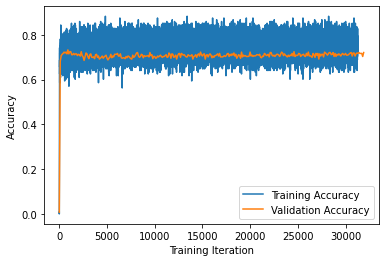

In [17]:
import matplotlib.pyplot as plt
plt.plot(range(len(training_accuracies)), training_accuracies, label = "Training Accuracy")
plt.plot(list(map(lambda x: x * 100, range(len(validation_accuracies)))), validation_accuracies, label = "Validation Accuracy")
plt.xlabel("Training Iteration")
plt.ylabel("Accuracy")
plt.legend()